# DeepFake Detection

In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 43.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install torch
!pip install torchaudio



In [ ]:
!pip install torchvision
!pip install transformers
!pip install Pillow

In [ ]:
import os
import cv2
import torch
import torchaudio
from torchvision.io import read_video
from torch.utils.data import Dataset
from transformers import ViTFeatureExtractor, ViTModel
from transformers import Wav2Vec2Model
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, ToTensor
from PIL import Image

class ToRGB:
    def __call__(self, image):
        if isinstance(image, Image.Image):
            return image.convert('RGB')
        else:
            raise TypeError("The input image must be a PIL Image.")

class VideoAudioDataset(Dataset):
    def __init__(self, root_dir, frame_rate, mean, std, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.data = []
        self.frame_rate = frame_rate
        self.transform = transform

        # Collect video and audio paths for each class
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for video_file in os.listdir(cls_dir):
                if video_file.endswith(".mp4"):
                    video_path = os.path.join(cls_dir, video_file)
                    audio_path = video_path.replace(".mp4", ".wav")
                    self.data.append({
                        "video_path": video_path,
                        "audio_path": audio_path,
                        "class": cls_name
                    })

        # Normalize video frames using provided statistics
        transform = transforms.Compose([
            ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Load the video and extract frames at the specified frame rate
        video, audio, info = read_video(sample["video_path"], pts_unit='sec', output_format='TCHW')
        if self.frame_rate != 0:
            video = video[:, ::int(self.frame_rate)]
        else:
            # Handle the case where frame_rate is zero
            video = video
        # Resize videos to 224x224 before conversion to RGB
        video = torch.nn.functional.interpolate(video, size=(224, 224), mode='bilinear')

        # Convert video to RGB
        video_rgb = []
        for frame in video:
            frame = ToPILImage()(frame)
            frame = ToRGB()(frame)
            frame = ToTensor()(frame)
            video_rgb.append(frame)
        video = torch.stack(video_rgb)

        # Load the audio file
        waveform, sample_rate = torchaudio.load(sample["audio_path"])

        # Ensure single-channel audio for Wav2Vec2
        if waveform.shape[0] > 1:
            waveform = waveform[0]  # Select the first channel (mono)

        # Reshape audio to expected dimension for Wav2Vec2
        audio = waveform.unsqueeze(1)  # Add channel dimension

        # Assuming video is of shape (batch_size, num_frames, channels, height, width)
        num_frames, channels, height, width = video.shape
        video = video.view(num_frames, channels, height, width)

        return video, waveform, self.class_to_idx[sample["class"]]

# Add data augmentation during training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

# Update dataset initialization with mean and std
dataset = VideoAudioDataset(
    root_dir="/content/drive/MyDrive/final/train",
    frame_rate=0,
    mean=[0.5, 0.5, 0.5],  # Assuming ImageNet pre-trained ViT
    std=[0.5, 0.5, 0.5],
    transform=train_transform
)

# Apply transforms only to train dataset
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True
)



In [ ]:
print("Length of dataloader: ", len(dataloader))

Length of dataloader:  865


## Early Fusion

In [ ]:
import torch
from torch import nn
from transformers import ViTModel, Wav2Vec2Model

class EarlyFusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # **Video branch with self-attention:**
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")  # Load pre-trained model

        # **Audio branch with self-attention:**
        self.audio_net = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        # **Attention layer after concatenation:**
        self.concat_attn = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size + self.audio_net.config.hidden_size, (self.vit.config.hidden_size + self.audio_net.config.hidden_size) * 2),
            nn.ReLU(),
            nn.Linear((self.vit.config.hidden_size + self.audio_net.config.hidden_size) * 2, self.vit.config.hidden_size + self.audio_net.config.hidden_size),
            nn.ReLU(),
            nn.Linear((self.vit.config.hidden_size + self.audio_net.config.hidden_size), (self.vit.config.hidden_size + self.audio_net.config.hidden_size)),
            nn.Softmax(dim=1),  # Use softmax for self-attention
        )

        # **Classification:**
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size + self.audio_net.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, images, audio):
        # Assuming images is of shape (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = images.shape
        images = images.view(batch_size * num_frames, channels, height, width)

        # Reshape audio for Wav2Vec2
        batch_size, *_ = audio.shape
        audio = audio.view(batch_size, -1)

        # Process images and audio
        x1 = self.vit(images).pooler_output
        x2 = self.audio_net(audio).last_hidden_state.mean(dim=1)

        # Flatten tensors
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)

        x1 = x1.mean(dim=0, keepdim=True)

        # Combine features for classification
        x = torch.cat((x1, x2), dim=1)

        # Apply attention after concatenation
        x = self.concat_attn(x)

        return self.classifier(x)


In [ ]:
model = EarlyFusionModel(num_classes=len(dataset.classes))

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model Training

In [ ]:
import torch.optim as optim

# Clear CUDA cache
torch.cuda.empty_cache()
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
# Calculate class weights
class_weights = torch.tensor([0.8, 0.2]).to(device)  # Adjust as necessary

# Use a weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/10:   0%|          | 1/865 [00:06<1:26:30,  6.01s/it]

Accuracy of the model after epoch 1: 0.0%


Epoch 1/10:   0%|          | 2/865 [00:11<1:20:32,  5.60s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   0%|          | 3/865 [00:15<1:13:20,  5.11s/it]

Accuracy of the model after epoch 1: 33.333333333333336%


Epoch 1/10:   0%|          | 4/865 [00:20<1:10:09,  4.89s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   1%|          | 5/865 [00:27<1:20:42,  5.63s/it]

Accuracy of the model after epoch 1: 60.0%


Epoch 1/10:   1%|          | 6/865 [00:35<1:31:07,  6.37s/it]

Accuracy of the model after epoch 1: 66.66666666666667%


Epoch 1/10:   1%|          | 7/865 [00:43<1:41:11,  7.08s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:   1%|          | 8/865 [00:51<1:44:05,  7.29s/it]

Accuracy of the model after epoch 1: 62.5%


Epoch 1/10:   1%|          | 9/865 [00:58<1:41:51,  7.14s/it]

Accuracy of the model after epoch 1: 66.66666666666667%


Epoch 1/10:   1%|          | 10/865 [01:05<1:40:49,  7.07s/it]

Accuracy of the model after epoch 1: 60.0%


Epoch 1/10:   1%|▏         | 11/865 [01:11<1:39:38,  7.00s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:   1%|▏         | 12/865 [01:18<1:37:29,  6.86s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 13/865 [01:25<1:38:26,  6.93s/it]

Accuracy of the model after epoch 1: 53.84615384615385%


Epoch 1/10:   2%|▏         | 14/865 [01:30<1:29:54,  6.34s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 15/865 [01:36<1:29:39,  6.33s/it]

Accuracy of the model after epoch 1: 53.333333333333336%


Epoch 1/10:   2%|▏         | 16/865 [01:40<1:19:38,  5.63s/it]

Accuracy of the model after epoch 1: 56.25%


Epoch 1/10:   2%|▏         | 17/865 [01:45<1:15:14,  5.32s/it]

Accuracy of the model after epoch 1: 52.94117647058823%


Epoch 1/10:   2%|▏         | 18/865 [01:51<1:19:00,  5.60s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 19/865 [01:59<1:27:24,  6.20s/it]

Accuracy of the model after epoch 1: 47.36842105263158%


Epoch 1/10:   2%|▏         | 20/865 [02:05<1:28:22,  6.28s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 21/865 [02:12<1:30:21,  6.42s/it]

Accuracy of the model after epoch 1: 47.61904761904762%


Epoch 1/10:   3%|▎         | 22/865 [02:19<1:30:23,  6.43s/it]

Accuracy of the model after epoch 1: 45.45454545454545%


Epoch 1/10:   3%|▎         | 23/865 [02:25<1:31:23,  6.51s/it]

Accuracy of the model after epoch 1: 47.82608695652174%


Epoch 1/10:   3%|▎         | 24/865 [02:33<1:35:46,  6.83s/it]

Accuracy of the model after epoch 1: 45.833333333333336%


Epoch 1/10:   3%|▎         | 25/865 [02:37<1:26:00,  6.14s/it]

Accuracy of the model after epoch 1: 44.0%


Epoch 1/10:   3%|▎         | 26/865 [02:42<1:18:34,  5.62s/it]

Accuracy of the model after epoch 1: 46.15384615384615%


Epoch 1/10:   3%|▎         | 27/865 [02:48<1:22:09,  5.88s/it]

Accuracy of the model after epoch 1: 48.148148148148145%


Epoch 1/10:   3%|▎         | 28/865 [02:55<1:24:16,  6.04s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   3%|▎         | 29/865 [03:02<1:29:27,  6.42s/it]

Accuracy of the model after epoch 1: 51.724137931034484%


Epoch 1/10:   3%|▎         | 30/865 [03:09<1:30:13,  6.48s/it]

Accuracy of the model after epoch 1: 53.333333333333336%


Epoch 1/10:   4%|▎         | 31/865 [03:16<1:33:00,  6.69s/it]

Accuracy of the model after epoch 1: 51.61290322580645%


Epoch 1/10:   4%|▎         | 32/865 [03:22<1:31:19,  6.58s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   4%|▍         | 33/865 [03:29<1:31:35,  6.61s/it]

Accuracy of the model after epoch 1: 51.515151515151516%


Epoch 1/10:   4%|▍         | 34/865 [03:36<1:32:47,  6.70s/it]

Accuracy of the model after epoch 1: 52.94117647058823%


Epoch 1/10:   4%|▍         | 35/865 [03:42<1:33:07,  6.73s/it]

Accuracy of the model after epoch 1: 54.285714285714285%


Epoch 1/10:   4%|▍         | 36/865 [03:49<1:30:34,  6.56s/it]

Accuracy of the model after epoch 1: 55.55555555555556%


Epoch 1/10:   4%|▍         | 37/865 [03:55<1:30:59,  6.59s/it]

Accuracy of the model after epoch 1: 54.054054054054056%


Epoch 1/10:   4%|▍         | 38/865 [04:02<1:30:18,  6.55s/it]

Accuracy of the model after epoch 1: 52.63157894736842%


Epoch 1/10:   5%|▍         | 39/865 [04:09<1:31:03,  6.61s/it]

Accuracy of the model after epoch 1: 53.84615384615385%


Epoch 1/10:   5%|▍         | 40/865 [04:13<1:22:09,  5.98s/it]

Accuracy of the model after epoch 1: 55.0%


Epoch 1/10:   5%|▍         | 41/865 [04:19<1:23:55,  6.11s/it]

Accuracy of the model after epoch 1: 53.65853658536585%


Epoch 1/10:   5%|▍         | 42/865 [04:26<1:24:06,  6.13s/it]

Accuracy of the model after epoch 1: 54.76190476190476%


Epoch 1/10:   5%|▍         | 43/865 [04:32<1:25:09,  6.22s/it]

Accuracy of the model after epoch 1: 53.48837209302326%


Epoch 1/10:   5%|▌         | 44/865 [04:37<1:18:05,  5.71s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:   5%|▌         | 45/865 [04:41<1:13:28,  5.38s/it]

Accuracy of the model after epoch 1: 55.55555555555556%


Epoch 1/10:   5%|▌         | 46/865 [04:45<1:08:45,  5.04s/it]

Accuracy of the model after epoch 1: 54.34782608695652%


Epoch 1/10:   5%|▌         | 47/865 [04:52<1:15:53,  5.57s/it]

Accuracy of the model after epoch 1: 53.191489361702125%


Epoch 1/10:   6%|▌         | 48/865 [04:59<1:19:10,  5.81s/it]

Accuracy of the model after epoch 1: 54.166666666666664%


Epoch 1/10:   6%|▌         | 49/865 [05:06<1:24:17,  6.20s/it]

Accuracy of the model after epoch 1: 55.10204081632653%


Epoch 1/10:   6%|▌         | 50/865 [05:12<1:23:32,  6.15s/it]

Accuracy of the model after epoch 1: 54.0%


Epoch 1/10:   6%|▌         | 51/865 [05:18<1:24:27,  6.22s/it]

Accuracy of the model after epoch 1: 54.90196078431372%


Epoch 1/10:   6%|▌         | 52/865 [05:23<1:18:43,  5.81s/it]

Accuracy of the model after epoch 1: 55.76923076923077%


Epoch 1/10:   6%|▌         | 53/865 [05:29<1:20:13,  5.93s/it]

Accuracy of the model after epoch 1: 54.716981132075475%


Epoch 1/10:   6%|▌         | 54/865 [05:36<1:24:39,  6.26s/it]

Accuracy of the model after epoch 1: 55.55555555555556%


Epoch 1/10:   6%|▋         | 55/865 [05:42<1:23:56,  6.22s/it]

Accuracy of the model after epoch 1: 56.36363636363637%


Epoch 1/10:   6%|▋         | 56/865 [05:49<1:24:04,  6.24s/it]

Accuracy of the model after epoch 1: 55.357142857142854%


Epoch 1/10:   7%|▋         | 57/865 [05:55<1:25:54,  6.38s/it]

Accuracy of the model after epoch 1: 56.14035087719298%


Epoch 1/10:   7%|▋         | 58/865 [06:00<1:17:20,  5.75s/it]

Accuracy of the model after epoch 1: 55.172413793103445%


Epoch 1/10:   7%|▋         | 59/865 [06:04<1:13:34,  5.48s/it]

Accuracy of the model after epoch 1: 55.932203389830505%


Epoch 1/10:   7%|▋         | 60/865 [06:09<1:07:59,  5.07s/it]

Accuracy of the model after epoch 1: 56.666666666666664%


Epoch 1/10:   7%|▋         | 61/865 [06:15<1:11:51,  5.36s/it]

Accuracy of the model after epoch 1: 57.377049180327866%


Epoch 1/10:   7%|▋         | 62/865 [06:21<1:14:48,  5.59s/it]

Accuracy of the model after epoch 1: 58.064516129032256%


Epoch 1/10:   7%|▋         | 63/865 [06:27<1:16:25,  5.72s/it]

Accuracy of the model after epoch 1: 58.73015873015873%


Epoch 1/10:   7%|▋         | 64/865 [06:33<1:19:07,  5.93s/it]

Accuracy of the model after epoch 1: 57.8125%


Epoch 1/10:   8%|▊         | 65/865 [06:39<1:20:04,  6.01s/it]

Accuracy of the model after epoch 1: 58.46153846153846%


Epoch 1/10:   8%|▊         | 66/865 [06:44<1:13:38,  5.53s/it]

Accuracy of the model after epoch 1: 57.57575757575758%


Epoch 1/10:   8%|▊         | 67/865 [06:48<1:09:14,  5.21s/it]

Accuracy of the model after epoch 1: 58.208955223880594%


Epoch 1/10:   8%|▊         | 68/865 [06:54<1:12:44,  5.48s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:   8%|▊         | 69/865 [07:01<1:18:01,  5.88s/it]

Accuracy of the model after epoch 1: 59.42028985507246%


Epoch 1/10:   8%|▊         | 70/865 [07:07<1:19:00,  5.96s/it]

Accuracy of the model after epoch 1: 60.0%


Epoch 1/10:   8%|▊         | 71/865 [07:13<1:19:53,  6.04s/it]

Accuracy of the model after epoch 1: 60.563380281690144%


Epoch 1/10:   8%|▊         | 72/865 [07:20<1:21:44,  6.18s/it]

Accuracy of the model after epoch 1: 59.72222222222222%


Epoch 1/10:   8%|▊         | 73/865 [07:24<1:13:48,  5.59s/it]

Accuracy of the model after epoch 1: 58.9041095890411%


Epoch 1/10:   9%|▊         | 74/865 [07:31<1:18:32,  5.96s/it]

Accuracy of the model after epoch 1: 59.45945945945946%


Epoch 1/10:   9%|▊         | 75/865 [07:38<1:20:30,  6.11s/it]

Accuracy of the model after epoch 1: 58.666666666666664%


Epoch 1/10:   9%|▉         | 76/865 [07:44<1:22:11,  6.25s/it]

Accuracy of the model after epoch 1: 57.89473684210526%


Epoch 1/10:   9%|▉         | 77/865 [07:51<1:23:08,  6.33s/it]

Accuracy of the model after epoch 1: 58.44155844155844%


Epoch 1/10:   9%|▉         | 78/865 [07:58<1:25:29,  6.52s/it]

Accuracy of the model after epoch 1: 57.69230769230769%


Epoch 1/10:   9%|▉         | 79/865 [08:04<1:26:01,  6.57s/it]

Accuracy of the model after epoch 1: 58.22784810126582%


Epoch 1/10:   9%|▉         | 80/865 [08:11<1:26:20,  6.60s/it]

Accuracy of the model after epoch 1: 57.5%


Epoch 1/10:   9%|▉         | 81/865 [08:16<1:18:48,  6.03s/it]

Accuracy of the model after epoch 1: 56.79012345679013%


Epoch 1/10:   9%|▉         | 82/865 [08:22<1:19:05,  6.06s/it]

Accuracy of the model after epoch 1: 57.31707317073171%


Epoch 1/10:  10%|▉         | 83/865 [08:29<1:21:56,  6.29s/it]

Accuracy of the model after epoch 1: 57.83132530120482%


Epoch 1/10:  10%|▉         | 84/865 [08:36<1:24:30,  6.49s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  10%|▉         | 85/865 [08:40<1:16:13,  5.86s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  10%|▉         | 86/865 [08:47<1:19:21,  6.11s/it]

Accuracy of the model after epoch 1: 58.13953488372093%


Epoch 1/10:  10%|█         | 87/865 [08:53<1:19:52,  6.16s/it]

Accuracy of the model after epoch 1: 57.47126436781609%


Epoch 1/10:  10%|█         | 88/865 [08:59<1:19:27,  6.14s/it]

Accuracy of the model after epoch 1: 57.95454545454545%


Epoch 1/10:  10%|█         | 89/865 [09:06<1:22:48,  6.40s/it]

Accuracy of the model after epoch 1: 58.42696629213483%


Epoch 1/10:  10%|█         | 90/865 [09:12<1:22:45,  6.41s/it]

Accuracy of the model after epoch 1: 57.77777777777778%


Epoch 1/10:  11%|█         | 91/865 [09:19<1:22:21,  6.38s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  11%|█         | 92/865 [09:26<1:24:10,  6.53s/it]

Accuracy of the model after epoch 1: 56.52173913043478%


Epoch 1/10:  11%|█         | 93/865 [09:32<1:25:00,  6.61s/it]

Accuracy of the model after epoch 1: 55.913978494623656%


Epoch 1/10:  11%|█         | 94/865 [09:39<1:24:39,  6.59s/it]

Accuracy of the model after epoch 1: 56.38297872340426%


Epoch 1/10:  11%|█         | 95/865 [09:43<1:16:06,  5.93s/it]

Accuracy of the model after epoch 1: 56.8421052631579%


Epoch 1/10:  11%|█         | 96/865 [09:50<1:17:04,  6.01s/it]

Accuracy of the model after epoch 1: 57.291666666666664%


Epoch 1/10:  11%|█         | 97/865 [09:57<1:21:55,  6.40s/it]

Accuracy of the model after epoch 1: 56.70103092783505%


Epoch 1/10:  11%|█▏        | 98/865 [10:03<1:20:55,  6.33s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  11%|█▏        | 99/865 [10:10<1:22:29,  6.46s/it]

Accuracy of the model after epoch 1: 56.56565656565657%


Epoch 1/10:  12%|█▏        | 100/865 [10:16<1:22:55,  6.50s/it]

Accuracy of the model after epoch 1: 57.0%


Epoch 1/10:  12%|█▏        | 101/865 [10:21<1:14:34,  5.86s/it]

Accuracy of the model after epoch 1: 57.42574257425743%


Epoch 1/10:  12%|█▏        | 102/865 [10:27<1:14:46,  5.88s/it]

Accuracy of the model after epoch 1: 57.84313725490196%


Epoch 1/10:  12%|█▏        | 103/865 [10:33<1:15:06,  5.91s/it]

Accuracy of the model after epoch 1: 58.25242718446602%


Epoch 1/10:  12%|█▏        | 104/865 [10:38<1:11:12,  5.61s/it]

Accuracy of the model after epoch 1: 58.65384615384615%


Epoch 1/10:  12%|█▏        | 105/865 [10:43<1:12:09,  5.70s/it]

Accuracy of the model after epoch 1: 59.04761904761905%


Epoch 1/10:  12%|█▏        | 106/865 [10:48<1:07:18,  5.32s/it]

Accuracy of the model after epoch 1: 58.490566037735846%


Epoch 1/10:  12%|█▏        | 107/865 [10:55<1:14:10,  5.87s/it]

Accuracy of the model after epoch 1: 57.94392523364486%


Epoch 1/10:  12%|█▏        | 108/865 [11:01<1:14:46,  5.93s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  13%|█▎        | 109/865 [11:08<1:16:33,  6.08s/it]

Accuracy of the model after epoch 1: 57.79816513761468%


Epoch 1/10:  13%|█▎        | 110/865 [11:14<1:17:10,  6.13s/it]

Accuracy of the model after epoch 1: 58.18181818181818%


Epoch 1/10:  13%|█▎        | 111/865 [11:20<1:18:08,  6.22s/it]

Accuracy of the model after epoch 1: 57.65765765765766%


Epoch 1/10:  13%|█▎        | 112/865 [11:26<1:17:55,  6.21s/it]

Accuracy of the model after epoch 1: 58.035714285714285%


Epoch 1/10:  13%|█▎        | 113/865 [11:33<1:17:41,  6.20s/it]

Accuracy of the model after epoch 1: 57.52212389380531%


Epoch 1/10:  13%|█▎        | 114/865 [11:37<1:11:42,  5.73s/it]

Accuracy of the model after epoch 1: 57.01754385964912%


Epoch 1/10:  13%|█▎        | 115/865 [11:42<1:06:15,  5.30s/it]

Accuracy of the model after epoch 1: 56.52173913043478%


Epoch 1/10:  13%|█▎        | 116/865 [11:46<1:02:45,  5.03s/it]

Accuracy of the model after epoch 1: 56.03448275862069%


Epoch 1/10:  14%|█▎        | 117/865 [11:50<1:00:55,  4.89s/it]

Accuracy of the model after epoch 1: 56.41025641025641%


Epoch 1/10:  14%|█▎        | 118/865 [11:55<57:58,  4.66s/it]  

Accuracy of the model after epoch 1: 56.779661016949156%


Epoch 1/10:  14%|█▍        | 119/865 [12:01<1:05:18,  5.25s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  14%|█▍        | 120/865 [12:05<1:00:48,  4.90s/it]

Accuracy of the model after epoch 1: 57.5%


Epoch 1/10:  14%|█▍        | 121/865 [12:12<1:07:02,  5.41s/it]

Accuracy of the model after epoch 1: 57.02479338842975%


Epoch 1/10:  14%|█▍        | 122/865 [12:18<1:09:32,  5.62s/it]

Accuracy of the model after epoch 1: 57.377049180327866%


Epoch 1/10:  14%|█▍        | 123/865 [12:24<1:12:19,  5.85s/it]

Accuracy of the model after epoch 1: 57.72357723577236%


Epoch 1/10:  14%|█▍        | 124/865 [12:29<1:08:19,  5.53s/it]

Accuracy of the model after epoch 1: 57.25806451612903%


Epoch 1/10:  14%|█▍        | 125/865 [12:36<1:11:48,  5.82s/it]

Accuracy of the model after epoch 1: 56.8%


Epoch 1/10:  15%|█▍        | 126/865 [12:42<1:13:48,  5.99s/it]

Accuracy of the model after epoch 1: 56.34920634920635%


Epoch 1/10:  15%|█▍        | 127/865 [12:49<1:16:41,  6.23s/it]

Accuracy of the model after epoch 1: 55.90551181102362%


Epoch 1/10:  15%|█▍        | 128/865 [12:55<1:17:25,  6.30s/it]

Accuracy of the model after epoch 1: 56.25%


Epoch 1/10:  15%|█▍        | 129/865 [13:02<1:17:25,  6.31s/it]

Accuracy of the model after epoch 1: 56.58914728682171%


Epoch 1/10:  15%|█▌        | 130/865 [13:09<1:20:00,  6.53s/it]

Accuracy of the model after epoch 1: 56.92307692307692%


Epoch 1/10:  15%|█▌        | 131/865 [13:15<1:18:21,  6.40s/it]

Accuracy of the model after epoch 1: 57.25190839694657%


Epoch 1/10:  15%|█▌        | 132/865 [13:21<1:17:51,  6.37s/it]

Accuracy of the model after epoch 1: 57.57575757575758%


Epoch 1/10:  15%|█▌        | 133/865 [13:25<1:09:39,  5.71s/it]

Accuracy of the model after epoch 1: 57.89473684210526%


Epoch 1/10:  15%|█▌        | 134/865 [13:30<1:05:41,  5.39s/it]

Accuracy of the model after epoch 1: 58.208955223880594%


Epoch 1/10:  16%|█▌        | 135/865 [13:35<1:02:34,  5.14s/it]

Accuracy of the model after epoch 1: 58.51851851851852%


Epoch 1/10:  16%|█▌        | 136/865 [13:41<1:07:17,  5.54s/it]

Accuracy of the model after epoch 1: 58.088235294117645%


Epoch 1/10:  16%|█▌        | 137/865 [13:47<1:09:43,  5.75s/it]

Accuracy of the model after epoch 1: 58.394160583941606%


Epoch 1/10:  16%|█▌        | 138/865 [13:54<1:14:31,  6.15s/it]

Accuracy of the model after epoch 1: 57.971014492753625%


Epoch 1/10:  16%|█▌        | 139/865 [14:01<1:16:50,  6.35s/it]

Accuracy of the model after epoch 1: 58.273381294964025%


Epoch 1/10:  16%|█▌        | 140/865 [14:08<1:16:59,  6.37s/it]

Accuracy of the model after epoch 1: 57.857142857142854%


Epoch 1/10:  16%|█▋        | 141/865 [14:12<1:08:37,  5.69s/it]

Accuracy of the model after epoch 1: 58.156028368794324%


Epoch 1/10:  16%|█▋        | 142/865 [14:18<1:12:03,  5.98s/it]

Accuracy of the model after epoch 1: 57.74647887323944%


Epoch 1/10:  17%|█▋        | 143/865 [14:23<1:06:32,  5.53s/it]

Accuracy of the model after epoch 1: 58.04195804195804%


Epoch 1/10:  17%|█▋        | 144/865 [14:30<1:11:04,  5.92s/it]

Accuracy of the model after epoch 1: 57.638888888888886%


Epoch 1/10:  17%|█▋        | 145/865 [14:36<1:12:39,  6.05s/it]

Accuracy of the model after epoch 1: 57.93103448275862%


Epoch 1/10:  17%|█▋        | 146/865 [14:42<1:12:10,  6.02s/it]

Accuracy of the model after epoch 1: 57.534246575342465%


Epoch 1/10:  17%|█▋        | 147/865 [14:49<1:14:15,  6.21s/it]

Accuracy of the model after epoch 1: 57.82312925170068%


Epoch 1/10:  17%|█▋        | 148/865 [14:55<1:15:57,  6.36s/it]

Accuracy of the model after epoch 1: 57.432432432432435%


Epoch 1/10:  17%|█▋        | 149/865 [15:00<1:09:36,  5.83s/it]

Accuracy of the model after epoch 1: 57.718120805369125%


Epoch 1/10:  17%|█▋        | 150/865 [15:06<1:11:33,  6.00s/it]

Accuracy of the model after epoch 1: 57.333333333333336%


Epoch 1/10:  17%|█▋        | 151/865 [15:11<1:06:00,  5.55s/it]

Accuracy of the model after epoch 1: 57.615894039735096%


Epoch 1/10:  18%|█▊        | 152/865 [15:17<1:07:55,  5.72s/it]

Accuracy of the model after epoch 1: 57.23684210526316%


Epoch 1/10:  18%|█▊        | 153/865 [15:23<1:10:54,  5.98s/it]

Accuracy of the model after epoch 1: 56.86274509803921%


Epoch 1/10:  18%|█▊        | 154/865 [15:30<1:11:44,  6.05s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  18%|█▊        | 155/865 [15:36<1:14:11,  6.27s/it]

Accuracy of the model after epoch 1: 57.41935483870968%


Epoch 1/10:  18%|█▊        | 156/865 [15:43<1:14:53,  6.34s/it]

Accuracy of the model after epoch 1: 57.05128205128205%


Epoch 1/10:  18%|█▊        | 157/865 [15:49<1:14:17,  6.30s/it]

Accuracy of the model after epoch 1: 57.32484076433121%


Epoch 1/10:  18%|█▊        | 158/865 [15:54<1:07:59,  5.77s/it]

Accuracy of the model after epoch 1: 57.59493670886076%


Epoch 1/10:  18%|█▊        | 159/865 [15:58<1:04:25,  5.48s/it]

Accuracy of the model after epoch 1: 57.23270440251572%


Epoch 1/10:  18%|█▊        | 160/865 [16:05<1:09:31,  5.92s/it]

Accuracy of the model after epoch 1: 56.875%


Epoch 1/10:  19%|█▊        | 161/865 [16:10<1:03:14,  5.39s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  19%|█▊        | 162/865 [16:16<1:06:06,  5.64s/it]

Accuracy of the model after epoch 1: 57.407407407407405%


Epoch 1/10:  19%|█▉        | 163/865 [16:22<1:08:49,  5.88s/it]

Accuracy of the model after epoch 1: 57.05521472392638%


Epoch 1/10:  19%|█▉        | 164/865 [16:27<1:03:58,  5.48s/it]

Accuracy of the model after epoch 1: 56.707317073170735%


Epoch 1/10:  19%|█▉        | 165/865 [16:31<58:57,  5.05s/it]  

Accuracy of the model after epoch 1: 56.96969696969697%


Epoch 1/10:  19%|█▉        | 166/865 [16:37<1:03:08,  5.42s/it]

Accuracy of the model after epoch 1: 57.2289156626506%


Epoch 1/10:  19%|█▉        | 167/865 [16:44<1:07:18,  5.79s/it]

Accuracy of the model after epoch 1: 57.48502994011976%


Epoch 1/10:  19%|█▉        | 168/865 [16:48<1:02:40,  5.40s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  20%|█▉        | 169/865 [16:53<59:19,  5.11s/it]  

Accuracy of the model after epoch 1: 57.396449704142015%


Epoch 1/10:  20%|█▉        | 170/865 [17:00<1:05:56,  5.69s/it]

Accuracy of the model after epoch 1: 57.05882352941177%


Epoch 1/10:  20%|█▉        | 171/865 [17:07<1:09:49,  6.04s/it]

Accuracy of the model after epoch 1: 56.72514619883041%


Epoch 1/10:  20%|█▉        | 172/865 [17:13<1:10:28,  6.10s/it]

Accuracy of the model after epoch 1: 56.97674418604651%


Epoch 1/10:  20%|██        | 173/865 [17:19<1:11:26,  6.19s/it]

Accuracy of the model after epoch 1: 56.64739884393064%


Epoch 1/10:  20%|██        | 174/865 [17:24<1:04:56,  5.64s/it]

Accuracy of the model after epoch 1: 56.89655172413793%


Epoch 1/10:  20%|██        | 175/865 [17:30<1:06:14,  5.76s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  20%|██        | 176/865 [17:35<1:03:02,  5.49s/it]

Accuracy of the model after epoch 1: 57.38636363636363%


Epoch 1/10:  20%|██        | 177/865 [17:41<1:05:24,  5.70s/it]

Accuracy of the model after epoch 1: 57.6271186440678%


Epoch 1/10:  21%|██        | 178/865 [17:45<1:00:47,  5.31s/it]

Accuracy of the model after epoch 1: 57.30337078651685%


Epoch 1/10:  21%|██        | 179/865 [17:51<1:04:00,  5.60s/it]

Accuracy of the model after epoch 1: 57.54189944134078%


Epoch 1/10:  21%|██        | 180/865 [17:56<59:38,  5.22s/it]  

Accuracy of the model after epoch 1: 57.77777777777778%


Epoch 1/10:  21%|██        | 181/865 [18:02<1:02:14,  5.46s/it]

Accuracy of the model after epoch 1: 57.4585635359116%


Epoch 1/10:  21%|██        | 182/865 [18:06<58:06,  5.10s/it]  

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  21%|██        | 183/865 [18:12<1:02:35,  5.51s/it]

Accuracy of the model after epoch 1: 56.830601092896174%


Epoch 1/10:  21%|██▏       | 184/865 [18:17<59:30,  5.24s/it]  

Accuracy of the model after epoch 1: 57.06521739130435%


Epoch 1/10:  21%|██▏       | 185/865 [18:21<55:42,  4.92s/it]

Accuracy of the model after epoch 1: 57.2972972972973%


Epoch 1/10:  22%|██▏       | 186/865 [18:28<1:01:30,  5.44s/it]

Accuracy of the model after epoch 1: 56.98924731182796%


Epoch 1/10:  22%|██▏       | 187/865 [18:34<1:03:21,  5.61s/it]

Accuracy of the model after epoch 1: 57.219251336898395%


Epoch 1/10:  22%|██▏       | 188/865 [18:39<1:00:55,  5.40s/it]

Accuracy of the model after epoch 1: 56.91489361702128%


Epoch 1/10:  22%|██▏       | 189/865 [18:46<1:05:29,  5.81s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  22%|██▏       | 190/865 [18:53<1:09:21,  6.17s/it]

Accuracy of the model after epoch 1: 56.8421052631579%


Epoch 1/10:  22%|██▏       | 191/865 [18:59<1:11:10,  6.34s/it]

Accuracy of the model after epoch 1: 56.544502617801044%


Epoch 1/10:  22%|██▏       | 192/865 [19:05<1:10:10,  6.26s/it]

Accuracy of the model after epoch 1: 56.770833333333336%


Epoch 1/10:  22%|██▏       | 193/865 [19:12<1:10:10,  6.27s/it]

Accuracy of the model after epoch 1: 56.994818652849744%


Epoch 1/10:  22%|██▏       | 194/865 [19:18<1:10:59,  6.35s/it]

Accuracy of the model after epoch 1: 56.70103092783505%


Epoch 1/10:  23%|██▎       | 195/865 [19:24<1:10:10,  6.28s/it]

Accuracy of the model after epoch 1: 56.92307692307692%


Epoch 1/10:  23%|██▎       | 196/865 [19:31<1:11:01,  6.37s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  23%|██▎       | 197/865 [19:35<1:04:20,  5.78s/it]

Accuracy of the model after epoch 1: 57.36040609137056%


Epoch 1/10:  23%|██▎       | 198/865 [19:42<1:07:52,  6.11s/it]

Accuracy of the model after epoch 1: 57.07070707070707%


Epoch 1/10:  23%|██▎       | 199/865 [19:47<1:02:21,  5.62s/it]

Accuracy of the model after epoch 1: 57.28643216080402%


Epoch 1/10:  23%|██▎       | 200/865 [19:51<57:56,  5.23s/it]  

Accuracy of the model after epoch 1: 57.5%


Epoch 1/10:  23%|██▎       | 201/865 [19:57<1:00:38,  5.48s/it]

Accuracy of the model after epoch 1: 57.711442786069654%


Epoch 1/10:  23%|██▎       | 202/865 [20:01<56:07,  5.08s/it]  

Accuracy of the model after epoch 1: 57.92079207920792%


Epoch 1/10:  23%|██▎       | 203/865 [20:08<1:01:40,  5.59s/it]

Accuracy of the model after epoch 1: 58.12807881773399%


Epoch 1/10:  24%|██▎       | 204/865 [20:14<1:04:23,  5.84s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  24%|██▎       | 205/865 [20:21<1:06:31,  6.05s/it]

Accuracy of the model after epoch 1: 58.048780487804876%


Epoch 1/10:  24%|██▍       | 206/865 [20:27<1:06:23,  6.05s/it]

Accuracy of the model after epoch 1: 57.76699029126213%


Epoch 1/10:  24%|██▍       | 207/865 [20:34<1:09:14,  6.31s/it]

Accuracy of the model after epoch 1: 57.971014492753625%


Epoch 1/10:  24%|██▍       | 208/865 [20:38<1:03:17,  5.78s/it]

Accuracy of the model after epoch 1: 58.17307692307692%


Epoch 1/10:  24%|██▍       | 209/865 [20:44<1:01:30,  5.63s/it]

Accuracy of the model after epoch 1: 57.89473684210526%


Epoch 1/10:  24%|██▍       | 210/865 [20:48<57:43,  5.29s/it]  

Accuracy of the model after epoch 1: 58.095238095238095%


Epoch 1/10:  24%|██▍       | 211/865 [20:52<54:08,  4.97s/it]

Accuracy of the model after epoch 1: 57.81990521327014%


Epoch 1/10:  25%|██▍       | 212/865 [20:57<51:44,  4.75s/it]

Accuracy of the model after epoch 1: 58.0188679245283%


Epoch 1/10:  25%|██▍       | 213/865 [21:03<55:16,  5.09s/it]

Accuracy of the model after epoch 1: 58.21596244131455%


Epoch 1/10:  25%|██▍       | 214/865 [21:09<1:01:06,  5.63s/it]

Accuracy of the model after epoch 1: 57.94392523364486%


Epoch 1/10:  25%|██▍       | 215/865 [21:15<1:02:19,  5.75s/it]

Accuracy of the model after epoch 1: 58.13953488372093%


Epoch 1/10:  25%|██▍       | 216/865 [21:22<1:03:04,  5.83s/it]

Accuracy of the model after epoch 1: 57.870370370370374%


Epoch 1/10:  25%|██▌       | 217/865 [21:28<1:05:11,  6.04s/it]

Accuracy of the model after epoch 1: 57.6036866359447%


Epoch 1/10:  25%|██▌       | 218/865 [21:35<1:07:00,  6.21s/it]

Accuracy of the model after epoch 1: 57.79816513761468%


Epoch 1/10:  25%|██▌       | 219/865 [21:42<1:09:49,  6.48s/it]

Accuracy of the model after epoch 1: 57.534246575342465%


Epoch 1/10:  25%|██▌       | 220/865 [21:46<1:03:14,  5.88s/it]

Accuracy of the model after epoch 1: 57.72727272727273%


Epoch 1/10:  26%|██▌       | 221/865 [21:52<1:03:38,  5.93s/it]

Accuracy of the model after epoch 1: 57.918552036199095%


Epoch 1/10:  26%|██▌       | 222/865 [21:59<1:04:29,  6.02s/it]

Accuracy of the model after epoch 1: 58.108108108108105%


Epoch 1/10:  26%|██▌       | 223/865 [22:06<1:07:50,  6.34s/it]

Accuracy of the model after epoch 1: 58.29596412556054%


Epoch 1/10:  26%|██▌       | 224/865 [22:12<1:08:58,  6.46s/it]

Accuracy of the model after epoch 1: 58.035714285714285%


Epoch 1/10:  26%|██▌       | 225/865 [22:17<1:01:42,  5.78s/it]

Accuracy of the model after epoch 1: 58.22222222222222%


Epoch 1/10:  26%|██▌       | 226/865 [22:23<1:03:42,  5.98s/it]

Accuracy of the model after epoch 1: 57.9646017699115%


Epoch 1/10:  26%|██▌       | 227/865 [22:27<58:06,  5.46s/it]  

Accuracy of the model after epoch 1: 58.14977973568282%


Epoch 1/10:  26%|██▋       | 228/865 [22:34<1:01:14,  5.77s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  26%|██▋       | 229/865 [22:39<58:43,  5.54s/it]  

Accuracy of the model after epoch 1: 58.07860262008734%


Epoch 1/10:  27%|██▋       | 230/865 [22:45<1:00:14,  5.69s/it]

Accuracy of the model after epoch 1: 57.82608695652174%


Epoch 1/10:  27%|██▋       | 231/865 [22:51<1:01:55,  5.86s/it]

Accuracy of the model after epoch 1: 58.00865800865801%


Epoch 1/10:  27%|██▋       | 232/865 [22:57<1:02:46,  5.95s/it]

Accuracy of the model after epoch 1: 58.189655172413794%


Epoch 1/10:  27%|██▋       | 233/865 [23:03<1:02:58,  5.98s/it]

Accuracy of the model after epoch 1: 58.36909871244635%


Epoch 1/10:  27%|██▋       | 234/865 [23:10<1:03:54,  6.08s/it]

Accuracy of the model after epoch 1: 58.547008547008545%


Epoch 1/10:  27%|██▋       | 235/865 [23:14<58:19,  5.55s/it]  

Accuracy of the model after epoch 1: 58.723404255319146%


Epoch 1/10:  27%|██▋       | 236/865 [23:20<1:00:20,  5.76s/it]

Accuracy of the model after epoch 1: 58.898305084745765%


Epoch 1/10:  27%|██▋       | 237/865 [23:26<1:01:47,  5.90s/it]

Accuracy of the model after epoch 1: 59.07172995780591%


Epoch 1/10:  28%|██▊       | 238/865 [23:32<59:25,  5.69s/it]  

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  28%|██▊       | 239/865 [23:36<56:00,  5.37s/it]

Accuracy of the model after epoch 1: 58.99581589958159%


Epoch 1/10:  28%|██▊       | 240/865 [23:42<58:42,  5.64s/it]

Accuracy of the model after epoch 1: 59.166666666666664%


Epoch 1/10:  28%|██▊       | 241/865 [23:49<1:01:56,  5.96s/it]

Accuracy of the model after epoch 1: 59.33609958506224%


Epoch 1/10:  28%|██▊       | 242/865 [23:55<1:02:47,  6.05s/it]

Accuracy of the model after epoch 1: 59.09090909090909%


Epoch 1/10:  28%|██▊       | 243/865 [24:00<57:30,  5.55s/it]  

Accuracy of the model after epoch 1: 59.25925925925926%


Epoch 1/10:  28%|██▊       | 244/865 [24:06<59:26,  5.74s/it]

Accuracy of the model after epoch 1: 59.42622950819672%


Epoch 1/10:  28%|██▊       | 245/865 [24:12<1:01:20,  5.94s/it]

Accuracy of the model after epoch 1: 59.59183673469388%


Epoch 1/10:  28%|██▊       | 246/865 [24:17<58:28,  5.67s/it]  

Accuracy of the model after epoch 1: 59.34959349593496%


Epoch 1/10:  29%|██▊       | 247/865 [24:24<1:00:41,  5.89s/it]

Accuracy of the model after epoch 1: 59.10931174089069%


Epoch 1/10:  29%|██▊       | 248/865 [24:30<1:02:58,  6.12s/it]

Accuracy of the model after epoch 1: 58.87096774193548%


Epoch 1/10:  29%|██▉       | 249/865 [24:37<1:04:30,  6.28s/it]

Accuracy of the model after epoch 1: 59.036144578313255%


Epoch 1/10:  29%|██▉       | 250/865 [24:43<1:03:56,  6.24s/it]

Accuracy of the model after epoch 1: 59.2%


Epoch 1/10:  29%|██▉       | 251/865 [24:48<58:27,  5.71s/it]  

Accuracy of the model after epoch 1: 59.36254980079681%


Epoch 1/10:  29%|██▉       | 252/865 [24:55<1:01:37,  6.03s/it]

Accuracy of the model after epoch 1: 59.523809523809526%


Epoch 1/10:  29%|██▉       | 253/865 [25:01<1:01:51,  6.06s/it]

Accuracy of the model after epoch 1: 59.683794466403164%


Epoch 1/10:  29%|██▉       | 254/865 [25:07<1:02:44,  6.16s/it]

Accuracy of the model after epoch 1: 59.44881889763779%


Epoch 1/10:  29%|██▉       | 255/865 [25:13<1:02:29,  6.15s/it]

Accuracy of the model after epoch 1: 59.6078431372549%


Epoch 1/10:  30%|██▉       | 256/865 [25:20<1:03:17,  6.23s/it]

Accuracy of the model after epoch 1: 59.375%


Epoch 1/10:  30%|██▉       | 257/865 [25:27<1:05:36,  6.47s/it]

Accuracy of the model after epoch 1: 59.143968871595334%


Epoch 1/10:  30%|██▉       | 258/865 [25:33<1:05:47,  6.50s/it]

Accuracy of the model after epoch 1: 58.91472868217054%


Epoch 1/10:  30%|██▉       | 259/865 [25:40<1:06:15,  6.56s/it]

Accuracy of the model after epoch 1: 58.68725868725869%


Epoch 1/10:  30%|███       | 260/865 [25:46<1:05:24,  6.49s/it]

Accuracy of the model after epoch 1: 58.46153846153846%


Epoch 1/10:  30%|███       | 261/865 [25:53<1:06:43,  6.63s/it]

Accuracy of the model after epoch 1: 58.23754789272031%


Epoch 1/10:  30%|███       | 262/865 [25:59<1:04:57,  6.46s/it]

Accuracy of the model after epoch 1: 58.396946564885496%


Epoch 1/10:  30%|███       | 263/865 [26:06<1:07:00,  6.68s/it]

Accuracy of the model after epoch 1: 58.17490494296578%


Epoch 1/10:  31%|███       | 264/865 [26:13<1:06:23,  6.63s/it]

Accuracy of the model after epoch 1: 57.95454545454545%


Epoch 1/10:  31%|███       | 265/865 [26:20<1:06:43,  6.67s/it]

Accuracy of the model after epoch 1: 57.735849056603776%


Epoch 1/10:  31%|███       | 266/865 [26:26<1:05:36,  6.57s/it]

Accuracy of the model after epoch 1: 57.89473684210526%


Epoch 1/10:  31%|███       | 267/865 [26:32<1:04:23,  6.46s/it]

Accuracy of the model after epoch 1: 58.052434456928836%


Epoch 1/10:  31%|███       | 268/865 [26:39<1:03:55,  6.42s/it]

Accuracy of the model after epoch 1: 58.208955223880594%


Epoch 1/10:  31%|███       | 269/865 [26:46<1:06:03,  6.65s/it]

Accuracy of the model after epoch 1: 57.99256505576208%


Epoch 1/10:  31%|███       | 270/865 [26:52<1:04:04,  6.46s/it]

Accuracy of the model after epoch 1: 58.148148148148145%


Epoch 1/10:  31%|███▏      | 271/865 [26:56<58:41,  5.93s/it]  

Accuracy of the model after epoch 1: 57.93357933579336%


Epoch 1/10:  31%|███▏      | 272/865 [27:03<1:00:34,  6.13s/it]

Accuracy of the model after epoch 1: 58.088235294117645%


Epoch 1/10:  32%|███▏      | 273/865 [27:09<1:01:06,  6.19s/it]

Accuracy of the model after epoch 1: 58.24175824175824%


Epoch 1/10:  32%|███▏      | 274/865 [27:14<56:03,  5.69s/it]  

Accuracy of the model after epoch 1: 58.02919708029197%


Epoch 1/10:  32%|███▏      | 275/865 [27:20<58:00,  5.90s/it]

Accuracy of the model after epoch 1: 57.81818181818182%


Epoch 1/10:  32%|███▏      | 276/865 [27:27<59:54,  6.10s/it]

Accuracy of the model after epoch 1: 57.608695652173914%


Epoch 1/10:  32%|███▏      | 277/865 [27:33<1:01:05,  6.23s/it]

Accuracy of the model after epoch 1: 57.40072202166065%


Epoch 1/10:  32%|███▏      | 278/865 [27:38<56:10,  5.74s/it]  

Accuracy of the model after epoch 1: 57.194244604316545%


Epoch 1/10:  32%|███▏      | 279/865 [27:43<53:03,  5.43s/it]

Accuracy of the model after epoch 1: 57.34767025089606%


Epoch 1/10:  32%|███▏      | 280/865 [27:47<49:20,  5.06s/it]

Accuracy of the model after epoch 1: 57.5%


Epoch 1/10:  32%|███▏      | 281/865 [27:53<52:52,  5.43s/it]

Accuracy of the model after epoch 1: 57.65124555160142%


Epoch 1/10:  33%|███▎      | 282/865 [27:59<54:02,  5.56s/it]

Accuracy of the model after epoch 1: 57.801418439716315%


Epoch 1/10:  33%|███▎      | 283/865 [28:06<56:28,  5.82s/it]

Accuracy of the model after epoch 1: 57.95053003533569%


Epoch 1/10:  33%|███▎      | 284/865 [28:10<53:45,  5.55s/it]

Accuracy of the model after epoch 1: 58.098591549295776%


Epoch 1/10:  33%|███▎      | 285/865 [28:17<55:29,  5.74s/it]

Accuracy of the model after epoch 1: 58.24561403508772%


Epoch 1/10:  33%|███▎      | 286/865 [28:23<58:07,  6.02s/it]

Accuracy of the model after epoch 1: 58.04195804195804%


Epoch 1/10:  33%|███▎      | 287/865 [28:29<58:27,  6.07s/it]

Accuracy of the model after epoch 1: 57.8397212543554%


Epoch 1/10:  33%|███▎      | 288/865 [28:36<1:00:46,  6.32s/it]

Accuracy of the model after epoch 1: 57.986111111111114%


Epoch 1/10:  33%|███▎      | 289/865 [28:43<1:01:01,  6.36s/it]

Accuracy of the model after epoch 1: 58.13148788927336%


Epoch 1/10:  34%|███▎      | 290/865 [28:49<59:52,  6.25s/it]  

Accuracy of the model after epoch 1: 58.275862068965516%


Epoch 1/10:  34%|███▎      | 291/865 [28:55<58:55,  6.16s/it]

Accuracy of the model after epoch 1: 58.419243986254294%


Epoch 1/10:  34%|███▍      | 292/865 [28:59<54:19,  5.69s/it]

Accuracy of the model after epoch 1: 58.56164383561644%


Epoch 1/10:  34%|███▍      | 293/865 [29:04<50:35,  5.31s/it]

Accuracy of the model after epoch 1: 58.3617747440273%


Epoch 1/10:  34%|███▍      | 294/865 [29:09<49:28,  5.20s/it]

Accuracy of the model after epoch 1: 58.50340136054422%


Epoch 1/10:  34%|███▍      | 295/865 [29:15<52:23,  5.52s/it]

Accuracy of the model after epoch 1: 58.30508474576271%


Epoch 1/10:  34%|███▍      | 296/865 [29:21<54:23,  5.74s/it]

Accuracy of the model after epoch 1: 58.108108108108105%


Epoch 1/10:  34%|███▍      | 297/865 [29:25<49:53,  5.27s/it]

Accuracy of the model after epoch 1: 58.24915824915825%


Epoch 1/10:  34%|███▍      | 298/865 [29:32<53:00,  5.61s/it]

Accuracy of the model after epoch 1: 58.38926174496644%


Epoch 1/10:  35%|███▍      | 299/865 [29:38<54:48,  5.81s/it]

Accuracy of the model after epoch 1: 58.52842809364549%


Epoch 1/10:  35%|███▍      | 300/865 [29:45<57:07,  6.07s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  35%|███▍      | 301/865 [29:51<56:54,  6.05s/it]

Accuracy of the model after epoch 1: 58.47176079734219%


Epoch 1/10:  35%|███▍      | 302/865 [29:57<57:03,  6.08s/it]

Accuracy of the model after epoch 1: 58.27814569536424%


Epoch 1/10:  35%|███▌      | 303/865 [30:04<59:40,  6.37s/it]

Accuracy of the model after epoch 1: 58.085808580858085%


Epoch 1/10:  35%|███▌      | 304/865 [30:11<1:00:13,  6.44s/it]

Accuracy of the model after epoch 1: 58.223684210526315%


Epoch 1/10:  35%|███▌      | 305/865 [30:15<53:57,  5.78s/it]  

Accuracy of the model after epoch 1: 58.36065573770492%


Epoch 1/10:  35%|███▌      | 306/865 [30:21<55:24,  5.95s/it]

Accuracy of the model after epoch 1: 58.49673202614379%


Epoch 1/10:  35%|███▌      | 307/865 [30:28<57:46,  6.21s/it]

Accuracy of the model after epoch 1: 58.63192182410423%


Epoch 1/10:  36%|███▌      | 308/865 [30:34<57:10,  6.16s/it]

Accuracy of the model after epoch 1: 58.76623376623377%


Epoch 1/10:  36%|███▌      | 309/865 [30:41<58:50,  6.35s/it]

Accuracy of the model after epoch 1: 58.57605177993528%


Epoch 1/10:  36%|███▌      | 310/865 [30:47<59:14,  6.40s/it]

Accuracy of the model after epoch 1: 58.70967741935484%


Epoch 1/10:  36%|███▌      | 311/865 [30:53<57:56,  6.27s/it]

Accuracy of the model after epoch 1: 58.842443729903536%


Epoch 1/10:  36%|███▌      | 312/865 [31:00<57:57,  6.29s/it]

Accuracy of the model after epoch 1: 58.97435897435897%


Epoch 1/10:  36%|███▌      | 313/865 [31:06<57:00,  6.20s/it]

Accuracy of the model after epoch 1: 59.105431309904155%


Epoch 1/10:  36%|███▋      | 314/865 [31:12<57:20,  6.24s/it]

Accuracy of the model after epoch 1: 59.23566878980892%


Epoch 1/10:  36%|███▋      | 315/865 [31:18<57:48,  6.31s/it]

Accuracy of the model after epoch 1: 59.36507936507937%


Epoch 1/10:  37%|███▋      | 316/865 [31:25<57:28,  6.28s/it]

Accuracy of the model after epoch 1: 59.177215189873415%


Epoch 1/10:  37%|███▋      | 317/865 [31:32<59:22,  6.50s/it]

Accuracy of the model after epoch 1: 59.305993690851736%


Epoch 1/10:  37%|███▋      | 318/865 [31:38<59:49,  6.56s/it]

Accuracy of the model after epoch 1: 59.119496855345915%


Epoch 1/10:  37%|███▋      | 319/865 [31:45<1:00:19,  6.63s/it]

Accuracy of the model after epoch 1: 59.24764890282132%


Epoch 1/10:  37%|███▋      | 320/865 [31:50<54:05,  5.96s/it]  

Accuracy of the model after epoch 1: 59.375%


Epoch 1/10:  37%|███▋      | 321/865 [31:56<54:37,  6.02s/it]

Accuracy of the model after epoch 1: 59.50155763239876%


Epoch 1/10:  37%|███▋      | 322/865 [32:02<55:41,  6.15s/it]

Accuracy of the model after epoch 1: 59.62732919254658%


Epoch 1/10:  37%|███▋      | 323/865 [32:08<55:43,  6.17s/it]

Accuracy of the model after epoch 1: 59.752321981424146%


Epoch 1/10:  37%|███▋      | 324/865 [32:16<58:50,  6.53s/it]

Accuracy of the model after epoch 1: 59.876543209876544%


Epoch 1/10:  38%|███▊      | 325/865 [32:23<1:00:07,  6.68s/it]

Accuracy of the model after epoch 1: 59.69230769230769%


Epoch 1/10:  38%|███▊      | 326/865 [32:30<1:00:46,  6.77s/it]

Accuracy of the model after epoch 1: 59.8159509202454%


Epoch 1/10:  38%|███▊      | 327/865 [32:36<59:15,  6.61s/it]  

Accuracy of the model after epoch 1: 59.9388379204893%


Epoch 1/10:  38%|███▊      | 328/865 [32:43<59:04,  6.60s/it]

Accuracy of the model after epoch 1: 60.0609756097561%


Epoch 1/10:  38%|███▊      | 329/865 [32:49<59:43,  6.69s/it]

Accuracy of the model after epoch 1: 60.182370820668694%


Epoch 1/10:  38%|███▊      | 330/865 [32:56<58:08,  6.52s/it]

Accuracy of the model after epoch 1: 60.303030303030305%


Epoch 1/10:  38%|███▊      | 331/865 [33:02<57:21,  6.44s/it]

Accuracy of the model after epoch 1: 60.120845921450154%


Epoch 1/10:  38%|███▊      | 332/865 [33:08<56:23,  6.35s/it]

Accuracy of the model after epoch 1: 60.24096385542169%


Epoch 1/10:  38%|███▊      | 333/865 [33:15<58:41,  6.62s/it]

Accuracy of the model after epoch 1: 60.06006006006006%


Epoch 1/10:  39%|███▊      | 334/865 [33:22<57:53,  6.54s/it]

Accuracy of the model after epoch 1: 60.17964071856287%


Epoch 1/10:  39%|███▊      | 335/865 [33:28<57:04,  6.46s/it]

Accuracy of the model after epoch 1: 60.298507462686565%


Epoch 1/10:  39%|███▉      | 336/865 [33:33<52:35,  5.96s/it]

Accuracy of the model after epoch 1: 60.416666666666664%


Epoch 1/10:  39%|███▉      | 337/865 [33:39<53:10,  6.04s/it]

Accuracy of the model after epoch 1: 60.53412462908012%


Epoch 1/10:  39%|███▉      | 338/865 [33:43<49:00,  5.58s/it]

Accuracy of the model after epoch 1: 60.35502958579882%


Epoch 1/10:  39%|███▉      | 339/865 [33:50<51:06,  5.83s/it]

Accuracy of the model after epoch 1: 60.471976401179944%


Epoch 1/10:  39%|███▉      | 340/865 [33:54<47:40,  5.45s/it]

Accuracy of the model after epoch 1: 60.588235294117645%


Epoch 1/10:  39%|███▉      | 341/865 [33:59<45:31,  5.21s/it]

Accuracy of the model after epoch 1: 60.70381231671554%


Epoch 1/10:  40%|███▉      | 342/865 [34:06<50:36,  5.81s/it]

Accuracy of the model after epoch 1: 60.526315789473685%


Epoch 1/10:  40%|███▉      | 343/865 [34:13<51:51,  5.96s/it]

Accuracy of the model after epoch 1: 60.64139941690962%


Epoch 1/10:  40%|███▉      | 344/865 [34:19<53:04,  6.11s/it]

Accuracy of the model after epoch 1: 60.75581395348837%


Epoch 1/10:  40%|███▉      | 345/865 [34:26<54:03,  6.24s/it]

Accuracy of the model after epoch 1: 60.57971014492754%


Epoch 1/10:  40%|████      | 346/865 [34:30<48:49,  5.64s/it]

Accuracy of the model after epoch 1: 60.40462427745665%


Epoch 1/10:  40%|████      | 347/865 [34:36<51:17,  5.94s/it]

Accuracy of the model after epoch 1: 60.23054755043228%


Epoch 1/10:  40%|████      | 348/865 [34:43<52:00,  6.03s/it]

Accuracy of the model after epoch 1: 60.3448275862069%


Epoch 1/10:  40%|████      | 349/865 [34:49<52:32,  6.11s/it]

Accuracy of the model after epoch 1: 60.458452722063036%


Epoch 1/10:  40%|████      | 350/865 [34:54<48:33,  5.66s/it]

Accuracy of the model after epoch 1: 60.57142857142857%


Epoch 1/10:  41%|████      | 351/865 [35:00<49:23,  5.77s/it]

Accuracy of the model after epoch 1: 60.68376068376068%


Epoch 1/10:  41%|████      | 352/865 [35:04<45:47,  5.36s/it]

Accuracy of the model after epoch 1: 60.51136363636363%


Epoch 1/10:  41%|████      | 353/865 [35:11<49:05,  5.75s/it]

Accuracy of the model after epoch 1: 60.3399433427762%


Epoch 1/10:  41%|████      | 354/865 [35:15<46:25,  5.45s/it]

Accuracy of the model after epoch 1: 60.451977401129945%


Epoch 1/10:  41%|████      | 355/865 [35:20<43:10,  5.08s/it]

Accuracy of the model after epoch 1: 60.563380281690144%


Epoch 1/10:  41%|████      | 356/865 [35:26<45:14,  5.33s/it]

Accuracy of the model after epoch 1: 60.674157303370784%


Epoch 1/10:  41%|████▏     | 357/865 [35:32<48:25,  5.72s/it]

Accuracy of the model after epoch 1: 60.78431372549019%


Epoch 1/10:  41%|████▏     | 358/865 [35:38<49:39,  5.88s/it]

Accuracy of the model after epoch 1: 60.89385474860335%


Epoch 1/10:  42%|████▏     | 359/865 [35:45<50:48,  6.02s/it]

Accuracy of the model after epoch 1: 61.00278551532033%


Epoch 1/10:  42%|████▏     | 360/865 [35:52<52:57,  6.29s/it]

Accuracy of the model after epoch 1: 61.111111111111114%


Epoch 1/10:  42%|████▏     | 361/865 [35:58<53:07,  6.32s/it]

Accuracy of the model after epoch 1: 60.94182825484764%


Epoch 1/10:  42%|████▏     | 362/865 [36:05<53:22,  6.37s/it]

Accuracy of the model after epoch 1: 60.773480662983424%


Epoch 1/10:  42%|████▏     | 363/865 [36:09<48:45,  5.83s/it]

Accuracy of the model after epoch 1: 60.60606060606061%


Epoch 1/10:  42%|████▏     | 364/865 [36:15<49:34,  5.94s/it]

Accuracy of the model after epoch 1: 60.714285714285715%


Epoch 1/10:  42%|████▏     | 365/865 [36:22<50:57,  6.12s/it]

Accuracy of the model after epoch 1: 60.54794520547945%


Epoch 1/10:  42%|████▏     | 366/865 [36:28<51:24,  6.18s/it]

Accuracy of the model after epoch 1: 60.65573770491803%


Epoch 1/10:  42%|████▏     | 367/865 [36:34<51:32,  6.21s/it]

Accuracy of the model after epoch 1: 60.490463215258856%


Epoch 1/10:  43%|████▎     | 368/865 [36:41<52:33,  6.35s/it]

Accuracy of the model after epoch 1: 60.59782608695652%


Epoch 1/10:  43%|████▎     | 369/865 [36:48<53:07,  6.43s/it]

Accuracy of the model after epoch 1: 60.43360433604336%


Epoch 1/10:  43%|████▎     | 370/865 [36:52<48:12,  5.84s/it]

Accuracy of the model after epoch 1: 60.270270270270274%


Epoch 1/10:  43%|████▎     | 371/865 [36:58<48:35,  5.90s/it]

Accuracy of the model after epoch 1: 60.107816711590296%


Epoch 1/10:  43%|████▎     | 372/865 [37:03<45:10,  5.50s/it]

Accuracy of the model after epoch 1: 59.946236559139784%


Epoch 1/10:  43%|████▎     | 373/865 [37:10<48:25,  5.90s/it]

Accuracy of the model after epoch 1: 60.05361930294906%


Epoch 1/10:  43%|████▎     | 374/865 [37:16<49:10,  6.01s/it]

Accuracy of the model after epoch 1: 60.160427807486634%


Epoch 1/10:  43%|████▎     | 375/865 [37:23<50:43,  6.21s/it]

Accuracy of the model after epoch 1: 60.266666666666666%


Epoch 1/10:  43%|████▎     | 376/865 [37:30<53:46,  6.60s/it]

Accuracy of the model after epoch 1: 60.1063829787234%


Epoch 1/10:  44%|████▎     | 377/865 [37:36<52:47,  6.49s/it]

Accuracy of the model after epoch 1: 60.212201591511935%


Epoch 1/10:  44%|████▎     | 378/865 [37:43<53:14,  6.56s/it]

Accuracy of the model after epoch 1: 60.317460317460316%


Epoch 1/10:  44%|████▍     | 379/865 [37:48<49:41,  6.13s/it]

Accuracy of the model after epoch 1: 60.15831134564644%


Epoch 1/10:  44%|████▍     | 380/865 [37:55<50:30,  6.25s/it]

Accuracy of the model after epoch 1: 60.26315789473684%


Epoch 1/10:  44%|████▍     | 381/865 [38:01<50:43,  6.29s/it]

Accuracy of the model after epoch 1: 60.10498687664042%


Epoch 1/10:  44%|████▍     | 382/865 [38:05<45:42,  5.68s/it]

Accuracy of the model after epoch 1: 60.20942408376963%


Epoch 1/10:  44%|████▍     | 383/865 [38:10<43:07,  5.37s/it]

Accuracy of the model after epoch 1: 60.31331592689295%


Epoch 1/10:  44%|████▍     | 384/865 [38:16<45:08,  5.63s/it]

Accuracy of the model after epoch 1: 60.416666666666664%


Epoch 1/10:  45%|████▍     | 385/865 [38:23<46:56,  5.87s/it]

Accuracy of the model after epoch 1: 60.51948051948052%


Epoch 1/10:  45%|████▍     | 386/865 [38:29<48:15,  6.04s/it]

Accuracy of the model after epoch 1: 60.362694300518136%


Epoch 1/10:  45%|████▍     | 387/865 [38:36<49:18,  6.19s/it]

Accuracy of the model after epoch 1: 60.20671834625323%


Epoch 1/10:  45%|████▍     | 388/865 [38:42<50:20,  6.33s/it]

Accuracy of the model after epoch 1: 60.05154639175258%


Epoch 1/10:  45%|████▍     | 389/865 [38:49<51:03,  6.44s/it]

Accuracy of the model after epoch 1: 60.15424164524421%


Epoch 1/10:  45%|████▌     | 390/865 [38:56<51:20,  6.49s/it]

Accuracy of the model after epoch 1: 60.0%


Epoch 1/10:  45%|████▌     | 391/865 [39:00<45:52,  5.81s/it]

Accuracy of the model after epoch 1: 59.846547314578004%


Epoch 1/10:  45%|████▌     | 392/865 [39:06<47:10,  5.98s/it]

Accuracy of the model after epoch 1: 59.69387755102041%


Epoch 1/10:  45%|████▌     | 393/865 [39:12<47:39,  6.06s/it]

Accuracy of the model after epoch 1: 59.79643765903308%


Epoch 1/10:  46%|████▌     | 394/865 [39:19<48:16,  6.15s/it]

Accuracy of the model after epoch 1: 59.898477157360404%


Epoch 1/10:  46%|████▌     | 395/865 [39:26<51:05,  6.52s/it]

Accuracy of the model after epoch 1: 59.74683544303797%


Epoch 1/10:  46%|████▌     | 396/865 [39:31<46:31,  5.95s/it]

Accuracy of the model after epoch 1: 59.5959595959596%


Epoch 1/10:  46%|████▌     | 397/865 [39:37<48:02,  6.16s/it]

Accuracy of the model after epoch 1: 59.44584382871537%


Epoch 1/10:  46%|████▌     | 398/865 [39:44<48:28,  6.23s/it]

Accuracy of the model after epoch 1: 59.54773869346734%


Epoch 1/10:  46%|████▌     | 399/865 [39:51<51:28,  6.63s/it]

Accuracy of the model after epoch 1: 59.3984962406015%


Epoch 1/10:  46%|████▌     | 400/865 [39:58<50:32,  6.52s/it]

Accuracy of the model after epoch 1: 59.5%


Epoch 1/10:  46%|████▋     | 401/865 [40:05<51:19,  6.64s/it]

Accuracy of the model after epoch 1: 59.35162094763092%


Epoch 1/10:  46%|████▋     | 402/865 [40:11<50:21,  6.53s/it]

Accuracy of the model after epoch 1: 59.45273631840796%


Epoch 1/10:  47%|████▋     | 403/865 [40:17<49:40,  6.45s/it]

Accuracy of the model after epoch 1: 59.30521091811414%


Epoch 1/10:  47%|████▋     | 404/865 [40:24<50:11,  6.53s/it]

Accuracy of the model after epoch 1: 59.15841584158416%


Epoch 1/10:  47%|████▋     | 405/865 [40:29<45:45,  5.97s/it]

Accuracy of the model after epoch 1: 59.01234567901235%


Epoch 1/10:  47%|████▋     | 406/865 [40:35<46:12,  6.04s/it]

Accuracy of the model after epoch 1: 59.11330049261084%


Epoch 1/10:  47%|████▋     | 407/865 [40:41<46:16,  6.06s/it]

Accuracy of the model after epoch 1: 59.21375921375921%


Epoch 1/10:  47%|████▋     | 408/865 [40:47<46:11,  6.07s/it]

Accuracy of the model after epoch 1: 59.068627450980394%


Epoch 1/10:  47%|████▋     | 409/865 [40:53<46:42,  6.15s/it]

Accuracy of the model after epoch 1: 58.924205378973106%


Epoch 1/10:  47%|████▋     | 410/865 [40:58<42:53,  5.66s/it]

Accuracy of the model after epoch 1: 58.78048780487805%


Epoch 1/10:  48%|████▊     | 411/865 [41:02<40:02,  5.29s/it]

Accuracy of the model after epoch 1: 58.880778588807786%


Epoch 1/10:  48%|████▊     | 412/865 [41:07<39:03,  5.17s/it]

Accuracy of the model after epoch 1: 58.980582524271846%


Epoch 1/10:  48%|████▊     | 413/865 [41:14<41:58,  5.57s/it]

Accuracy of the model after epoch 1: 59.07990314769976%


Epoch 1/10:  48%|████▊     | 414/865 [41:18<40:03,  5.33s/it]

Accuracy of the model after epoch 1: 58.93719806763285%


Epoch 1/10:  48%|████▊     | 415/865 [41:23<38:30,  5.14s/it]

Accuracy of the model after epoch 1: 58.795180722891565%


Epoch 1/10:  48%|████▊     | 416/865 [41:29<41:17,  5.52s/it]

Accuracy of the model after epoch 1: 58.65384615384615%


Epoch 1/10:  48%|████▊     | 417/865 [41:35<42:03,  5.63s/it]

Accuracy of the model after epoch 1: 58.752997601918466%


Epoch 1/10:  48%|████▊     | 418/865 [41:42<43:03,  5.78s/it]

Accuracy of the model after epoch 1: 58.61244019138756%


Epoch 1/10:  48%|████▊     | 419/865 [41:46<40:21,  5.43s/it]

Accuracy of the model after epoch 1: 58.711217183770884%


Epoch 1/10:  49%|████▊     | 420/865 [41:52<41:25,  5.59s/it]

Accuracy of the model after epoch 1: 58.80952380952381%


Epoch 1/10:  49%|████▊     | 421/865 [41:56<38:21,  5.18s/it]

Accuracy of the model after epoch 1: 58.90736342042755%


Epoch 1/10:  49%|████▉     | 422/865 [42:03<41:02,  5.56s/it]

Accuracy of the model after epoch 1: 58.76777251184834%


Epoch 1/10:  49%|████▉     | 423/865 [42:07<38:21,  5.21s/it]

Accuracy of the model after epoch 1: 58.628841607565015%


Epoch 1/10:  49%|████▉     | 424/865 [42:14<42:00,  5.72s/it]

Accuracy of the model after epoch 1: 58.72641509433962%


Epoch 1/10:  49%|████▉     | 425/865 [42:21<44:30,  6.07s/it]

Accuracy of the model after epoch 1: 58.588235294117645%


Epoch 1/10:  49%|████▉     | 426/865 [42:27<44:26,  6.07s/it]

Accuracy of the model after epoch 1: 58.68544600938967%


Epoch 1/10:  49%|████▉     | 427/865 [42:31<40:46,  5.59s/it]

Accuracy of the model after epoch 1: 58.5480093676815%


Epoch 1/10:  49%|████▉     | 428/865 [42:38<42:38,  5.85s/it]

Accuracy of the model after epoch 1: 58.41121495327103%


Epoch 1/10:  50%|████▉     | 429/865 [42:45<44:25,  6.11s/it]

Accuracy of the model after epoch 1: 58.50815850815851%


Epoch 1/10:  50%|████▉     | 430/865 [42:51<45:53,  6.33s/it]

Accuracy of the model after epoch 1: 58.604651162790695%


Epoch 1/10:  50%|████▉     | 431/865 [42:58<45:30,  6.29s/it]

Accuracy of the model after epoch 1: 58.70069605568445%


Epoch 1/10:  50%|████▉     | 432/865 [43:04<45:19,  6.28s/it]

Accuracy of the model after epoch 1: 58.7962962962963%


Epoch 1/10:  50%|█████     | 433/865 [43:10<45:16,  6.29s/it]

Accuracy of the model after epoch 1: 58.891454965357966%


Epoch 1/10:  50%|█████     | 434/865 [43:18<47:17,  6.58s/it]

Accuracy of the model after epoch 1: 58.986175115207374%


Epoch 1/10:  50%|█████     | 435/865 [43:22<42:30,  5.93s/it]

Accuracy of the model after epoch 1: 59.08045977011494%


Epoch 1/10:  50%|█████     | 436/865 [43:29<43:57,  6.15s/it]

Accuracy of the model after epoch 1: 58.944954128440365%


Epoch 1/10:  51%|█████     | 437/865 [43:35<44:26,  6.23s/it]

Accuracy of the model after epoch 1: 59.038901601830666%


Epoch 1/10:  51%|█████     | 438/865 [43:42<45:54,  6.45s/it]

Accuracy of the model after epoch 1: 58.9041095890411%


Epoch 1/10:  51%|█████     | 439/865 [43:47<42:18,  5.96s/it]

Accuracy of the model after epoch 1: 58.99772209567198%


Epoch 1/10:  51%|█████     | 440/865 [43:53<43:18,  6.12s/it]

Accuracy of the model after epoch 1: 58.86363636363637%


Epoch 1/10:  51%|█████     | 441/865 [44:00<44:21,  6.28s/it]

Accuracy of the model after epoch 1: 58.73015873015873%


Epoch 1/10:  51%|█████     | 442/865 [44:06<44:28,  6.31s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  51%|█████     | 443/865 [44:13<44:53,  6.38s/it]

Accuracy of the model after epoch 1: 58.690744920993225%


Epoch 1/10:  51%|█████▏    | 444/865 [44:17<39:37,  5.65s/it]

Accuracy of the model after epoch 1: 58.78378378378378%


Epoch 1/10:  51%|█████▏    | 445/865 [44:24<42:50,  6.12s/it]

Accuracy of the model after epoch 1: 58.651685393258425%


Epoch 1/10:  52%|█████▏    | 446/865 [44:30<43:08,  6.18s/it]

Accuracy of the model after epoch 1: 58.74439461883408%


Epoch 1/10:  52%|█████▏    | 447/865 [44:35<39:05,  5.61s/it]

Accuracy of the model after epoch 1: 58.83668903803132%


Epoch 1/10:  52%|█████▏    | 448/865 [44:41<41:22,  5.95s/it]

Accuracy of the model after epoch 1: 58.705357142857146%


Epoch 1/10:  52%|█████▏    | 449/865 [44:48<42:25,  6.12s/it]

Accuracy of the model after epoch 1: 58.797327394209354%


Epoch 1/10:  52%|█████▏    | 450/865 [44:52<38:48,  5.61s/it]

Accuracy of the model after epoch 1: 58.888888888888886%


Epoch 1/10:  52%|█████▏    | 451/865 [44:58<39:40,  5.75s/it]

Accuracy of the model after epoch 1: 58.980044345898%


Epoch 1/10:  52%|█████▏    | 452/865 [45:04<40:05,  5.83s/it]

Accuracy of the model after epoch 1: 59.07079646017699%


Epoch 1/10:  52%|█████▏    | 453/865 [45:09<36:49,  5.36s/it]

Accuracy of the model after epoch 1: 59.16114790286976%


Epoch 1/10:  52%|█████▏    | 454/865 [45:16<40:56,  5.98s/it]

Accuracy of the model after epoch 1: 59.25110132158591%


Epoch 1/10:  53%|█████▎    | 455/865 [45:22<41:00,  6.00s/it]

Accuracy of the model after epoch 1: 59.34065934065934%


Epoch 1/10:  53%|█████▎    | 456/865 [45:27<37:35,  5.51s/it]

Accuracy of the model after epoch 1: 59.42982456140351%


Epoch 1/10:  53%|█████▎    | 457/865 [45:31<35:29,  5.22s/it]

Accuracy of the model after epoch 1: 59.29978118161926%


Epoch 1/10:  53%|█████▎    | 458/865 [45:37<37:42,  5.56s/it]

Accuracy of the model after epoch 1: 59.38864628820961%


Epoch 1/10:  53%|█████▎    | 459/865 [45:42<35:42,  5.28s/it]

Accuracy of the model after epoch 1: 59.47712418300654%


Epoch 1/10:  53%|█████▎    | 460/865 [45:48<37:52,  5.61s/it]

Accuracy of the model after epoch 1: 59.56521739130435%


Epoch 1/10:  53%|█████▎    | 461/865 [45:55<39:33,  5.88s/it]

Accuracy of the model after epoch 1: 59.43600867678959%


Epoch 1/10:  53%|█████▎    | 462/865 [46:02<41:26,  6.17s/it]

Accuracy of the model after epoch 1: 59.307359307359306%


Epoch 1/10:  54%|█████▎    | 463/865 [46:06<37:27,  5.59s/it]

Accuracy of the model after epoch 1: 59.1792656587473%


Epoch 1/10:  54%|█████▎    | 464/865 [46:13<39:33,  5.92s/it]

Accuracy of the model after epoch 1: 59.05172413793103%


Epoch 1/10:  54%|█████▍    | 465/865 [46:19<41:02,  6.16s/it]

Accuracy of the model after epoch 1: 59.13978494623656%


Epoch 1/10:  54%|█████▍    | 466/865 [46:25<40:28,  6.09s/it]

Accuracy of the model after epoch 1: 59.227467811158796%


Epoch 1/10:  54%|█████▍    | 467/865 [46:31<40:32,  6.11s/it]

Accuracy of the model after epoch 1: 59.100642398286936%


Epoch 1/10:  54%|█████▍    | 468/865 [46:36<37:58,  5.74s/it]

Accuracy of the model after epoch 1: 59.18803418803419%


Epoch 1/10:  54%|█████▍    | 469/865 [46:43<40:33,  6.14s/it]

Accuracy of the model after epoch 1: 59.06183368869936%


Epoch 1/10:  54%|█████▍    | 470/865 [46:50<40:55,  6.22s/it]

Accuracy of the model after epoch 1: 59.148936170212764%


Epoch 1/10:  54%|█████▍    | 471/865 [46:55<38:14,  5.82s/it]

Accuracy of the model after epoch 1: 59.23566878980892%


Epoch 1/10:  55%|█████▍    | 472/865 [47:01<39:48,  6.08s/it]

Accuracy of the model after epoch 1: 59.32203389830509%


Epoch 1/10:  55%|█████▍    | 473/865 [47:09<41:53,  6.41s/it]

Accuracy of the model after epoch 1: 59.19661733615222%


Epoch 1/10:  55%|█████▍    | 474/865 [47:15<41:36,  6.39s/it]

Accuracy of the model after epoch 1: 59.28270042194093%


Epoch 1/10:  55%|█████▍    | 475/865 [47:19<37:36,  5.79s/it]

Accuracy of the model after epoch 1: 59.36842105263158%


Epoch 1/10:  55%|█████▌    | 476/865 [47:27<40:28,  6.24s/it]

Accuracy of the model after epoch 1: 59.2436974789916%


Epoch 1/10:  55%|█████▌    | 477/865 [47:32<38:31,  5.96s/it]

Accuracy of the model after epoch 1: 59.119496855345915%


Epoch 1/10:  55%|█████▌    | 478/865 [47:36<35:20,  5.48s/it]

Accuracy of the model after epoch 1: 58.99581589958159%


Epoch 1/10:  55%|█████▌    | 479/865 [47:41<33:33,  5.22s/it]

Accuracy of the model after epoch 1: 59.08141962421712%


Epoch 1/10:  55%|█████▌    | 480/865 [47:45<31:35,  4.92s/it]

Accuracy of the model after epoch 1: 58.958333333333336%


Epoch 1/10:  56%|█████▌    | 481/865 [47:52<34:58,  5.46s/it]

Accuracy of the model after epoch 1: 58.83575883575884%


Epoch 1/10:  56%|█████▌    | 482/865 [47:58<36:39,  5.74s/it]

Accuracy of the model after epoch 1: 58.92116182572614%


Epoch 1/10:  56%|█████▌    | 483/865 [48:05<38:52,  6.11s/it]

Accuracy of the model after epoch 1: 58.799171842650104%


Epoch 1/10:  56%|█████▌    | 484/865 [48:12<40:38,  6.40s/it]

Accuracy of the model after epoch 1: 58.88429752066116%


Epoch 1/10:  56%|█████▌    | 485/865 [48:19<40:27,  6.39s/it]

Accuracy of the model after epoch 1: 58.96907216494845%


Epoch 1/10:  56%|█████▌    | 486/865 [48:25<40:34,  6.42s/it]

Accuracy of the model after epoch 1: 59.053497942386834%


Epoch 1/10:  56%|█████▋    | 487/865 [48:32<41:51,  6.65s/it]

Accuracy of the model after epoch 1: 58.93223819301848%


Epoch 1/10:  56%|█████▋    | 488/865 [48:37<37:27,  5.96s/it]

Accuracy of the model after epoch 1: 59.01639344262295%


Epoch 1/10:  57%|█████▋    | 489/865 [48:44<39:18,  6.27s/it]

Accuracy of the model after epoch 1: 58.895705521472394%


Epoch 1/10:  57%|█████▋    | 490/865 [48:50<39:05,  6.25s/it]

Accuracy of the model after epoch 1: 58.775510204081634%


Epoch 1/10:  57%|█████▋    | 491/865 [48:56<38:31,  6.18s/it]

Accuracy of the model after epoch 1: 58.85947046843177%


Epoch 1/10:  57%|█████▋    | 492/865 [49:00<35:25,  5.70s/it]

Accuracy of the model after epoch 1: 58.739837398373986%


Epoch 1/10:  57%|█████▋    | 493/865 [49:06<35:45,  5.77s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  57%|█████▋    | 494/865 [49:13<38:01,  6.15s/it]

Accuracy of the model after epoch 1: 58.906882591093115%


Epoch 1/10:  57%|█████▋    | 495/865 [49:18<34:43,  5.63s/it]

Accuracy of the model after epoch 1: 58.98989898989899%


Epoch 1/10:  57%|█████▋    | 496/865 [49:24<35:22,  5.75s/it]

Accuracy of the model after epoch 1: 59.07258064516129%


Epoch 1/10:  57%|█████▋    | 497/865 [49:30<36:44,  5.99s/it]

Accuracy of the model after epoch 1: 58.95372233400403%


Epoch 1/10:  58%|█████▊    | 498/865 [49:37<37:53,  6.19s/it]

Accuracy of the model after epoch 1: 58.83534136546185%


Epoch 1/10:  58%|█████▊    | 499/865 [49:44<39:56,  6.55s/it]

Accuracy of the model after epoch 1: 58.71743486973948%


Epoch 1/10:  58%|█████▊    | 500/865 [49:51<39:45,  6.54s/it]

Accuracy of the model after epoch 1: 58.8%


Epoch 1/10:  58%|█████▊    | 501/865 [49:57<39:04,  6.44s/it]

Accuracy of the model after epoch 1: 58.88223552894212%


Epoch 1/10:  58%|█████▊    | 502/865 [50:03<38:19,  6.33s/it]

Accuracy of the model after epoch 1: 58.96414342629482%


Epoch 1/10:  58%|█████▊    | 503/865 [50:10<38:24,  6.37s/it]

Accuracy of the model after epoch 1: 58.84691848906561%


Epoch 1/10:  58%|█████▊    | 504/865 [50:16<38:58,  6.48s/it]

Accuracy of the model after epoch 1: 58.73015873015873%


Epoch 1/10:  58%|█████▊    | 505/865 [50:23<38:25,  6.41s/it]

Accuracy of the model after epoch 1: 58.81188118811881%


Epoch 1/10:  58%|█████▊    | 506/865 [50:27<34:53,  5.83s/it]

Accuracy of the model after epoch 1: 58.89328063241107%


Epoch 1/10:  59%|█████▊    | 507/865 [50:34<36:55,  6.19s/it]

Accuracy of the model after epoch 1: 58.777120315581854%


Epoch 1/10:  59%|█████▊    | 508/865 [50:38<33:22,  5.61s/it]

Accuracy of the model after epoch 1: 58.85826771653543%


Epoch 1/10:  59%|█████▉    | 509/865 [50:45<34:24,  5.80s/it]

Accuracy of the model after epoch 1: 58.93909626719057%


Epoch 1/10:  59%|█████▉    | 510/865 [50:51<34:55,  5.90s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  59%|█████▉    | 511/865 [50:58<36:15,  6.14s/it]

Accuracy of the model after epoch 1: 58.9041095890411%


Epoch 1/10:  59%|█████▉    | 512/865 [51:04<36:18,  6.17s/it]

Accuracy of the model after epoch 1: 58.984375%


Epoch 1/10:  59%|█████▉    | 513/865 [51:10<37:02,  6.31s/it]

Accuracy of the model after epoch 1: 59.06432748538012%


Epoch 1/10:  59%|█████▉    | 514/865 [51:17<38:14,  6.54s/it]

Accuracy of the model after epoch 1: 58.94941634241245%


Epoch 1/10:  60%|█████▉    | 515/865 [51:24<37:25,  6.41s/it]

Accuracy of the model after epoch 1: 59.029126213592235%


Epoch 1/10:  60%|█████▉    | 516/865 [51:28<33:34,  5.77s/it]

Accuracy of the model after epoch 1: 59.10852713178294%


Epoch 1/10:  60%|█████▉    | 517/865 [51:35<35:10,  6.06s/it]

Accuracy of the model after epoch 1: 59.18762088974855%


Epoch 1/10:  60%|█████▉    | 518/865 [51:39<32:41,  5.65s/it]

Accuracy of the model after epoch 1: 59.07335907335907%


Epoch 1/10:  60%|██████    | 519/865 [51:46<33:42,  5.85s/it]

Accuracy of the model after epoch 1: 59.152215799614645%


Epoch 1/10:  60%|██████    | 520/865 [51:52<35:15,  6.13s/it]

Accuracy of the model after epoch 1: 59.03846153846154%


Epoch 1/10:  60%|██████    | 521/865 [51:59<35:41,  6.22s/it]

Accuracy of the model after epoch 1: 59.117082533589254%


Epoch 1/10:  60%|██████    | 522/865 [52:05<35:26,  6.20s/it]

Accuracy of the model after epoch 1: 59.00383141762452%


Epoch 1/10:  60%|██████    | 523/865 [52:09<32:19,  5.67s/it]

Accuracy of the model after epoch 1: 58.89101338432123%


Epoch 1/10:  61%|██████    | 524/865 [52:14<30:48,  5.42s/it]

Accuracy of the model after epoch 1: 58.969465648854964%


Epoch 1/10:  61%|██████    | 525/865 [52:20<31:54,  5.63s/it]

Accuracy of the model after epoch 1: 59.04761904761905%


Epoch 1/10:  61%|██████    | 526/865 [52:26<32:29,  5.75s/it]

Accuracy of the model after epoch 1: 59.125475285171106%


Epoch 1/10:  61%|██████    | 527/865 [52:33<33:13,  5.90s/it]

Accuracy of the model after epoch 1: 59.20303605313093%


Epoch 1/10:  61%|██████    | 528/865 [52:39<33:42,  6.00s/it]

Accuracy of the model after epoch 1: 59.28030303030303%


Epoch 1/10:  61%|██████    | 529/865 [52:46<34:58,  6.24s/it]

Accuracy of the model after epoch 1: 59.168241965973536%


Epoch 1/10:  61%|██████▏   | 530/865 [52:53<36:43,  6.58s/it]

Accuracy of the model after epoch 1: 59.056603773584904%


Epoch 1/10:  61%|██████▏   | 531/865 [52:59<36:04,  6.48s/it]

Accuracy of the model after epoch 1: 58.94538606403013%


Epoch 1/10:  62%|██████▏   | 532/865 [53:06<35:37,  6.42s/it]

Accuracy of the model after epoch 1: 59.02255639097744%


Epoch 1/10:  62%|██████▏   | 533/865 [53:12<35:15,  6.37s/it]

Accuracy of the model after epoch 1: 59.09943714821764%


Epoch 1/10:  62%|██████▏   | 534/865 [53:18<35:10,  6.38s/it]

Accuracy of the model after epoch 1: 59.176029962546814%


Epoch 1/10:  62%|██████▏   | 535/865 [53:25<35:10,  6.40s/it]

Accuracy of the model after epoch 1: 59.06542056074766%


Epoch 1/10:  62%|██████▏   | 536/865 [53:31<34:41,  6.33s/it]

Accuracy of the model after epoch 1: 58.95522388059702%


Epoch 1/10:  62%|██████▏   | 537/865 [53:37<34:23,  6.29s/it]

Accuracy of the model after epoch 1: 58.845437616387336%


Epoch 1/10:  62%|██████▏   | 538/865 [53:44<34:53,  6.40s/it]

Accuracy of the model after epoch 1: 58.7360594795539%


Epoch 1/10:  62%|██████▏   | 539/865 [53:51<36:42,  6.76s/it]

Accuracy of the model after epoch 1: 58.62708719851577%


Epoch 1/10:  62%|██████▏   | 540/865 [53:56<32:43,  6.04s/it]

Accuracy of the model after epoch 1: 58.51851851851852%


Epoch 1/10:  63%|██████▎   | 541/865 [54:02<33:47,  6.26s/it]

Accuracy of the model after epoch 1: 58.41035120147874%


Epoch 1/10:  63%|██████▎   | 542/865 [54:09<34:14,  6.36s/it]

Accuracy of the model after epoch 1: 58.30258302583026%


Epoch 1/10:  63%|██████▎   | 543/865 [54:14<31:03,  5.79s/it]

Accuracy of the model after epoch 1: 58.37937384898711%


Epoch 1/10:  63%|██████▎   | 544/865 [54:20<32:09,  6.01s/it]

Accuracy of the model after epoch 1: 58.27205882352941%


Epoch 1/10:  63%|██████▎   | 545/865 [54:26<32:09,  6.03s/it]

Accuracy of the model after epoch 1: 58.1651376146789%


Epoch 1/10:  63%|██████▎   | 546/865 [54:31<29:34,  5.56s/it]

Accuracy of the model after epoch 1: 58.05860805860806%


Epoch 1/10:  63%|██████▎   | 547/865 [54:38<32:14,  6.08s/it]

Accuracy of the model after epoch 1: 58.13528336380256%


Epoch 1/10:  63%|██████▎   | 548/865 [54:44<32:44,  6.20s/it]

Accuracy of the model after epoch 1: 58.21167883211679%


Epoch 1/10:  63%|██████▎   | 549/865 [54:51<33:11,  6.30s/it]

Accuracy of the model after epoch 1: 58.10564663023679%


Epoch 1/10:  64%|██████▎   | 550/865 [54:57<33:02,  6.29s/it]

Accuracy of the model after epoch 1: 58.0%


Epoch 1/10:  64%|██████▎   | 551/865 [55:01<29:39,  5.67s/it]

Accuracy of the model after epoch 1: 58.07622504537205%


Epoch 1/10:  64%|██████▍   | 552/865 [55:09<32:22,  6.21s/it]

Accuracy of the model after epoch 1: 57.971014492753625%


Epoch 1/10:  64%|██████▍   | 553/865 [55:13<29:08,  5.60s/it]

Accuracy of the model after epoch 1: 58.047016274864376%


Epoch 1/10:  64%|██████▍   | 554/865 [55:18<27:30,  5.31s/it]

Accuracy of the model after epoch 1: 57.942238267148014%


Epoch 1/10:  64%|██████▍   | 555/865 [55:24<28:33,  5.53s/it]

Accuracy of the model after epoch 1: 58.01801801801802%


Epoch 1/10:  64%|██████▍   | 556/865 [55:30<30:15,  5.87s/it]

Accuracy of the model after epoch 1: 58.093525179856115%


Epoch 1/10:  64%|██████▍   | 557/865 [55:37<30:51,  6.01s/it]

Accuracy of the model after epoch 1: 57.98922800718133%


Epoch 1/10:  65%|██████▍   | 558/865 [55:43<31:06,  6.08s/it]

Accuracy of the model after epoch 1: 58.064516129032256%


Epoch 1/10:  65%|██████▍   | 559/865 [55:49<31:28,  6.17s/it]

Accuracy of the model after epoch 1: 57.960644007155636%


Epoch 1/10:  65%|██████▍   | 560/865 [55:56<31:24,  6.18s/it]

Accuracy of the model after epoch 1: 58.035714285714285%


Epoch 1/10:  65%|██████▍   | 561/865 [56:02<31:06,  6.14s/it]

Accuracy of the model after epoch 1: 58.110516934046345%


Epoch 1/10:  65%|██████▍   | 562/865 [56:07<30:28,  6.03s/it]

Accuracy of the model after epoch 1: 58.18505338078292%


Epoch 1/10:  65%|██████▌   | 563/865 [56:12<28:04,  5.58s/it]

Accuracy of the model after epoch 1: 58.259325044404974%


Epoch 1/10:  65%|██████▌   | 564/865 [56:18<29:04,  5.80s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  65%|██████▌   | 565/865 [56:22<26:31,  5.31s/it]

Accuracy of the model after epoch 1: 58.4070796460177%


Epoch 1/10:  65%|██████▌   | 566/865 [56:29<27:55,  5.60s/it]

Accuracy of the model after epoch 1: 58.48056537102474%


Epoch 1/10:  66%|██████▌   | 567/865 [56:33<25:58,  5.23s/it]

Accuracy of the model after epoch 1: 58.55379188712522%


Epoch 1/10:  66%|██████▌   | 568/865 [56:38<25:35,  5.17s/it]

Accuracy of the model after epoch 1: 58.45070422535211%


Epoch 1/10:  66%|██████▌   | 569/865 [56:45<27:26,  5.56s/it]

Accuracy of the model after epoch 1: 58.523725834797894%


Epoch 1/10:  66%|██████▌   | 570/865 [56:51<28:10,  5.73s/it]

Accuracy of the model after epoch 1: 58.59649122807018%


Epoch 1/10:  66%|██████▌   | 571/865 [56:55<26:11,  5.35s/it]

Accuracy of the model after epoch 1: 58.66900175131349%


Epoch 1/10:  66%|██████▌   | 572/865 [57:01<27:15,  5.58s/it]

Accuracy of the model after epoch 1: 58.56643356643357%


Epoch 1/10:  66%|██████▌   | 573/865 [57:05<25:11,  5.18s/it]

Accuracy of the model after epoch 1: 58.638743455497384%


Epoch 1/10:  66%|██████▋   | 574/865 [57:12<27:28,  5.66s/it]

Accuracy of the model after epoch 1: 58.710801393728225%


Epoch 1/10:  66%|██████▋   | 575/865 [57:17<25:22,  5.25s/it]

Accuracy of the model after epoch 1: 58.608695652173914%


Epoch 1/10:  67%|██████▋   | 576/865 [57:21<23:56,  4.97s/it]

Accuracy of the model after epoch 1: 58.68055555555556%


Epoch 1/10:  67%|██████▋   | 577/865 [57:25<22:39,  4.72s/it]

Accuracy of the model after epoch 1: 58.752166377816295%


Epoch 1/10:  67%|██████▋   | 578/865 [57:31<24:46,  5.18s/it]

Accuracy of the model after epoch 1: 58.65051903114187%


Epoch 1/10:  67%|██████▋   | 579/865 [57:38<26:45,  5.61s/it]

Accuracy of the model after epoch 1: 58.721934369602764%


Epoch 1/10:  67%|██████▋   | 580/865 [57:42<24:45,  5.21s/it]

Accuracy of the model after epoch 1: 58.793103448275865%


Epoch 1/10:  67%|██████▋   | 581/865 [57:49<26:35,  5.62s/it]

Accuracy of the model after epoch 1: 58.86402753872633%


Epoch 1/10:  67%|██████▋   | 582/865 [57:55<27:28,  5.82s/it]

Accuracy of the model after epoch 1: 58.934707903780065%


Epoch 1/10:  67%|██████▋   | 583/865 [57:59<25:14,  5.37s/it]

Accuracy of the model after epoch 1: 59.00514579759863%


Epoch 1/10:  68%|██████▊   | 584/865 [58:04<23:59,  5.12s/it]

Accuracy of the model after epoch 1: 58.9041095890411%


Epoch 1/10:  68%|██████▊   | 585/865 [58:10<25:46,  5.52s/it]

Accuracy of the model after epoch 1: 58.8034188034188%


Epoch 1/10:  68%|██████▊   | 586/865 [58:16<26:16,  5.65s/it]

Accuracy of the model after epoch 1: 58.87372013651877%


Epoch 1/10:  68%|██████▊   | 587/865 [58:23<27:23,  5.91s/it]

Accuracy of the model after epoch 1: 58.94378194207837%


Epoch 1/10:  68%|██████▊   | 588/865 [58:29<27:45,  6.01s/it]

Accuracy of the model after epoch 1: 59.01360544217687%


Epoch 1/10:  68%|██████▊   | 589/865 [58:34<25:43,  5.59s/it]

Accuracy of the model after epoch 1: 59.083191850594226%


Epoch 1/10:  68%|██████▊   | 590/865 [58:38<23:50,  5.20s/it]

Accuracy of the model after epoch 1: 58.983050847457626%


Epoch 1/10:  68%|██████▊   | 591/865 [58:44<24:59,  5.47s/it]

Accuracy of the model after epoch 1: 58.88324873096447%


Epoch 1/10:  68%|██████▊   | 592/865 [58:51<26:18,  5.78s/it]

Accuracy of the model after epoch 1: 58.9527027027027%


Epoch 1/10:  69%|██████▊   | 593/865 [58:58<28:00,  6.18s/it]

Accuracy of the model after epoch 1: 58.85328836424958%


Epoch 1/10:  69%|██████▊   | 594/865 [59:05<29:27,  6.52s/it]

Accuracy of the model after epoch 1: 58.92255892255892%


Epoch 1/10:  69%|██████▉   | 595/865 [59:12<29:26,  6.54s/it]

Accuracy of the model after epoch 1: 58.8235294117647%


Epoch 1/10:  69%|██████▉   | 596/865 [59:18<28:44,  6.41s/it]

Accuracy of the model after epoch 1: 58.7248322147651%


Epoch 1/10:  69%|██████▉   | 597/865 [59:24<29:01,  6.50s/it]

Accuracy of the model after epoch 1: 58.79396984924623%


Epoch 1/10:  69%|██████▉   | 598/865 [59:31<29:32,  6.64s/it]

Accuracy of the model after epoch 1: 58.69565217391305%


Epoch 1/10:  69%|██████▉   | 599/865 [59:38<29:06,  6.56s/it]

Accuracy of the model after epoch 1: 58.764607679465776%


Epoch 1/10:  69%|██████▉   | 600/865 [59:45<30:05,  6.81s/it]

Accuracy of the model after epoch 1: 58.666666666666664%


Epoch 1/10:  69%|██████▉   | 601/865 [59:51<29:16,  6.65s/it]

Accuracy of the model after epoch 1: 58.73544093178037%


Epoch 1/10:  70%|██████▉   | 602/865 [59:58<29:14,  6.67s/it]

Accuracy of the model after epoch 1: 58.63787375415282%


Epoch 1/10:  70%|██████▉   | 603/865 [1:00:02<25:57,  5.94s/it]

Accuracy of the model after epoch 1: 58.70646766169154%


Epoch 1/10:  70%|██████▉   | 604/865 [1:00:09<26:20,  6.06s/it]

Accuracy of the model after epoch 1: 58.77483443708609%


Epoch 1/10:  70%|██████▉   | 605/865 [1:00:15<26:41,  6.16s/it]

Accuracy of the model after epoch 1: 58.67768595041322%


Epoch 1/10:  70%|███████   | 606/865 [1:00:21<26:21,  6.11s/it]

Accuracy of the model after epoch 1: 58.745874587458744%


Epoch 1/10:  70%|███████   | 607/865 [1:00:27<26:17,  6.11s/it]

Accuracy of the model after epoch 1: 58.81383855024712%


Epoch 1/10:  70%|███████   | 608/865 [1:00:32<24:08,  5.64s/it]

Accuracy of the model after epoch 1: 58.7171052631579%


Epoch 1/10:  70%|███████   | 609/865 [1:00:36<22:46,  5.34s/it]

Accuracy of the model after epoch 1: 58.62068965517241%


Epoch 1/10:  71%|███████   | 610/865 [1:00:43<23:47,  5.60s/it]

Accuracy of the model after epoch 1: 58.52459016393443%


Epoch 1/10:  71%|███████   | 611/865 [1:00:49<24:23,  5.76s/it]

Accuracy of the model after epoch 1: 58.42880523731588%


Epoch 1/10:  71%|███████   | 612/865 [1:00:55<24:37,  5.84s/it]

Accuracy of the model after epoch 1: 58.49673202614379%


Epoch 1/10:  71%|███████   | 613/865 [1:01:01<25:09,  5.99s/it]

Accuracy of the model after epoch 1: 58.564437194127244%


Epoch 1/10:  71%|███████   | 614/865 [1:01:06<23:24,  5.60s/it]

Accuracy of the model after epoch 1: 58.63192182410423%


Epoch 1/10:  71%|███████   | 615/865 [1:01:12<23:35,  5.66s/it]

Accuracy of the model after epoch 1: 58.699186991869915%


Epoch 1/10:  71%|███████   | 616/865 [1:01:19<25:09,  6.06s/it]

Accuracy of the model after epoch 1: 58.603896103896105%


Epoch 1/10:  71%|███████▏  | 617/865 [1:01:26<26:16,  6.35s/it]

Accuracy of the model after epoch 1: 58.6709886547812%


Epoch 1/10:  71%|███████▏  | 618/865 [1:01:30<23:16,  5.66s/it]

Accuracy of the model after epoch 1: 58.737864077669904%


Epoch 1/10:  72%|███████▏  | 619/865 [1:01:36<24:22,  5.95s/it]

Accuracy of the model after epoch 1: 58.80452342487884%


Epoch 1/10:  72%|███████▏  | 620/865 [1:01:43<24:41,  6.05s/it]

Accuracy of the model after epoch 1: 58.87096774193548%


Epoch 1/10:  72%|███████▏  | 621/865 [1:01:49<25:03,  6.16s/it]

Accuracy of the model after epoch 1: 58.93719806763285%


Epoch 1/10:  72%|███████▏  | 622/865 [1:01:53<22:39,  5.60s/it]

Accuracy of the model after epoch 1: 59.0032154340836%


Epoch 1/10:  72%|███████▏  | 623/865 [1:02:00<23:31,  5.83s/it]

Accuracy of the model after epoch 1: 59.06902086677368%


Epoch 1/10:  72%|███████▏  | 624/865 [1:02:04<21:48,  5.43s/it]

Accuracy of the model after epoch 1: 58.97435897435897%


Epoch 1/10:  72%|███████▏  | 625/865 [1:02:10<22:30,  5.63s/it]

Accuracy of the model after epoch 1: 59.04%


Epoch 1/10:  72%|███████▏  | 626/865 [1:02:17<23:16,  5.84s/it]

Accuracy of the model after epoch 1: 58.945686900958464%


Epoch 1/10:  72%|███████▏  | 627/865 [1:02:23<23:32,  5.93s/it]

Accuracy of the model after epoch 1: 59.01116427432217%


Epoch 1/10:  73%|███████▎  | 628/865 [1:02:29<23:36,  5.98s/it]

Accuracy of the model after epoch 1: 59.07643312101911%


Epoch 1/10:  73%|███████▎  | 629/865 [1:02:35<24:01,  6.11s/it]

Accuracy of the model after epoch 1: 59.14149443561208%


Epoch 1/10:  73%|███████▎  | 630/865 [1:02:42<24:50,  6.34s/it]

Accuracy of the model after epoch 1: 59.04761904761905%


Epoch 1/10:  73%|███████▎  | 631/865 [1:02:49<25:07,  6.44s/it]

Accuracy of the model after epoch 1: 59.11251980982567%


Epoch 1/10:  73%|███████▎  | 632/865 [1:02:53<22:35,  5.82s/it]

Accuracy of the model after epoch 1: 59.177215189873415%


Epoch 1/10:  73%|███████▎  | 633/865 [1:02:59<22:46,  5.89s/it]

Accuracy of the model after epoch 1: 59.241706161137444%


Epoch 1/10:  73%|███████▎  | 634/865 [1:03:04<21:26,  5.57s/it]

Accuracy of the model after epoch 1: 59.14826498422713%


Epoch 1/10:  73%|███████▎  | 635/865 [1:03:10<22:07,  5.77s/it]

Accuracy of the model after epoch 1: 59.21259842519685%


Epoch 1/10:  74%|███████▎  | 636/865 [1:03:15<21:09,  5.55s/it]

Accuracy of the model after epoch 1: 59.119496855345915%


Epoch 1/10:  74%|███████▎  | 637/865 [1:03:22<23:00,  6.05s/it]

Accuracy of the model after epoch 1: 59.02668759811617%


Epoch 1/10:  74%|███████▍  | 638/865 [1:03:27<21:12,  5.60s/it]

Accuracy of the model after epoch 1: 58.93416927899686%


Epoch 1/10:  74%|███████▍  | 639/865 [1:03:34<22:11,  5.89s/it]

Accuracy of the model after epoch 1: 58.99843505477308%


Epoch 1/10:  74%|███████▍  | 640/865 [1:03:39<21:04,  5.62s/it]

Accuracy of the model after epoch 1: 59.0625%


Epoch 1/10:  74%|███████▍  | 641/865 [1:03:45<21:40,  5.80s/it]

Accuracy of the model after epoch 1: 59.12636505460218%


Epoch 1/10:  74%|███████▍  | 642/865 [1:03:51<22:26,  6.04s/it]

Accuracy of the model after epoch 1: 59.034267912772584%


Epoch 1/10:  74%|███████▍  | 643/865 [1:03:58<22:25,  6.06s/it]

Accuracy of the model after epoch 1: 58.94245723172628%


Epoch 1/10:  74%|███████▍  | 644/865 [1:04:04<22:41,  6.16s/it]

Accuracy of the model after epoch 1: 59.006211180124225%


Epoch 1/10:  75%|███████▍  | 645/865 [1:04:10<22:42,  6.19s/it]

Accuracy of the model after epoch 1: 59.06976744186046%


Epoch 1/10:  75%|███████▍  | 646/865 [1:04:16<22:34,  6.18s/it]

Accuracy of the model after epoch 1: 58.978328173374614%


Epoch 1/10:  75%|███████▍  | 647/865 [1:04:23<22:29,  6.19s/it]

Accuracy of the model after epoch 1: 58.887171561051005%


Epoch 1/10:  75%|███████▍  | 648/865 [1:04:29<23:07,  6.39s/it]

Accuracy of the model after epoch 1: 58.7962962962963%


Epoch 1/10:  75%|███████▌  | 649/865 [1:04:36<23:08,  6.43s/it]

Accuracy of the model after epoch 1: 58.8597842835131%


Epoch 1/10:  75%|███████▌  | 650/865 [1:04:42<22:42,  6.34s/it]

Accuracy of the model after epoch 1: 58.92307692307692%


Epoch 1/10:  75%|███████▌  | 651/865 [1:04:46<20:26,  5.73s/it]

Accuracy of the model after epoch 1: 58.83256528417819%


Epoch 1/10:  75%|███████▌  | 652/865 [1:04:53<21:42,  6.12s/it]

Accuracy of the model after epoch 1: 58.74233128834356%


Epoch 1/10:  75%|███████▌  | 653/865 [1:05:00<21:48,  6.17s/it]

Accuracy of the model after epoch 1: 58.80551301684533%


Epoch 1/10:  76%|███████▌  | 654/865 [1:05:06<22:14,  6.32s/it]

Accuracy of the model after epoch 1: 58.86850152905199%


Epoch 1/10:  76%|███████▌  | 655/865 [1:05:12<21:55,  6.26s/it]

Accuracy of the model after epoch 1: 58.93129770992366%


Epoch 1/10:  76%|███████▌  | 656/865 [1:05:19<21:48,  6.26s/it]

Accuracy of the model after epoch 1: 58.84146341463415%


Epoch 1/10:  76%|███████▌  | 657/865 [1:05:23<19:48,  5.71s/it]

Accuracy of the model after epoch 1: 58.75190258751903%


Epoch 1/10:  76%|███████▌  | 658/865 [1:05:28<18:23,  5.33s/it]

Accuracy of the model after epoch 1: 58.81458966565349%


Epoch 1/10:  76%|███████▌  | 659/865 [1:05:34<19:11,  5.59s/it]

Accuracy of the model after epoch 1: 58.877086494688925%


Epoch 1/10:  76%|███████▋  | 660/865 [1:05:40<19:45,  5.78s/it]

Accuracy of the model after epoch 1: 58.78787878787879%


Epoch 1/10:  76%|███████▋  | 661/865 [1:05:46<19:51,  5.84s/it]

Accuracy of the model after epoch 1: 58.850226928895616%


Epoch 1/10:  77%|███████▋  | 662/865 [1:05:50<18:13,  5.39s/it]

Accuracy of the model after epoch 1: 58.91238670694864%


Epoch 1/10:  77%|███████▋  | 663/865 [1:05:57<19:19,  5.74s/it]

Accuracy of the model after epoch 1: 58.97435897435897%


Epoch 1/10:  77%|███████▋  | 664/865 [1:06:02<18:17,  5.46s/it]

Accuracy of the model after epoch 1: 59.036144578313255%


Epoch 1/10:  77%|███████▋  | 665/865 [1:06:08<19:12,  5.76s/it]

Accuracy of the model after epoch 1: 59.097744360902254%


Epoch 1/10:  77%|███████▋  | 666/865 [1:06:15<19:55,  6.01s/it]

Accuracy of the model after epoch 1: 59.15915915915916%


Epoch 1/10:  77%|███████▋  | 667/865 [1:06:21<19:48,  6.00s/it]

Accuracy of the model after epoch 1: 59.220389805097454%


Epoch 1/10:  77%|███████▋  | 668/865 [1:06:27<20:10,  6.15s/it]

Accuracy of the model after epoch 1: 59.131736526946106%


Epoch 1/10:  77%|███████▋  | 669/865 [1:06:34<20:17,  6.21s/it]

Accuracy of the model after epoch 1: 59.19282511210762%


Epoch 1/10:  77%|███████▋  | 670/865 [1:06:40<19:54,  6.12s/it]

Accuracy of the model after epoch 1: 59.25373134328358%


Epoch 1/10:  78%|███████▊  | 671/865 [1:06:44<18:09,  5.61s/it]

Accuracy of the model after epoch 1: 59.31445603576751%


Epoch 1/10:  78%|███████▊  | 672/865 [1:06:48<16:36,  5.16s/it]

Accuracy of the model after epoch 1: 59.375%


Epoch 1/10:  78%|███████▊  | 673/865 [1:06:55<17:54,  5.60s/it]

Accuracy of the model after epoch 1: 59.286775631500745%


Epoch 1/10:  78%|███████▊  | 674/865 [1:07:01<18:39,  5.86s/it]

Accuracy of the model after epoch 1: 59.19881305637982%


Epoch 1/10:  78%|███████▊  | 675/865 [1:07:06<17:15,  5.45s/it]

Accuracy of the model after epoch 1: 59.25925925925926%


Epoch 1/10:  78%|███████▊  | 676/865 [1:07:10<16:12,  5.15s/it]

Accuracy of the model after epoch 1: 59.171597633136095%


Epoch 1/10:  78%|███████▊  | 677/865 [1:07:15<15:41,  5.01s/it]

Accuracy of the model after epoch 1: 59.084194977843424%


Epoch 1/10:  78%|███████▊  | 678/865 [1:07:21<16:58,  5.45s/it]

Accuracy of the model after epoch 1: 58.99705014749262%


Epoch 1/10:  78%|███████▊  | 679/865 [1:07:28<18:08,  5.85s/it]

Accuracy of the model after epoch 1: 59.057437407952875%


Epoch 1/10:  79%|███████▊  | 680/865 [1:07:34<18:18,  5.94s/it]

Accuracy of the model after epoch 1: 59.11764705882353%


Epoch 1/10:  79%|███████▊  | 681/865 [1:07:40<18:33,  6.05s/it]

Accuracy of the model after epoch 1: 59.030837004405285%


Epoch 1/10:  79%|███████▉  | 682/865 [1:07:46<18:23,  6.03s/it]

Accuracy of the model after epoch 1: 59.09090909090909%


Epoch 1/10:  79%|███████▉  | 683/865 [1:07:51<16:42,  5.51s/it]

Accuracy of the model after epoch 1: 59.004392386530014%


Epoch 1/10:  79%|███████▉  | 684/865 [1:07:57<17:21,  5.75s/it]

Accuracy of the model after epoch 1: 59.06432748538012%


Epoch 1/10:  79%|███████▉  | 685/865 [1:08:03<17:48,  5.94s/it]

Accuracy of the model after epoch 1: 58.97810218978102%


Epoch 1/10:  79%|███████▉  | 686/865 [1:08:08<16:06,  5.40s/it]

Accuracy of the model after epoch 1: 59.03790087463557%


Epoch 1/10:  79%|███████▉  | 687/865 [1:08:12<15:12,  5.13s/it]

Accuracy of the model after epoch 1: 58.951965065502186%


Epoch 1/10:  80%|███████▉  | 688/865 [1:08:19<16:23,  5.55s/it]

Accuracy of the model after epoch 1: 58.866279069767444%


Epoch 1/10:  80%|███████▉  | 689/865 [1:08:26<17:59,  6.13s/it]

Accuracy of the model after epoch 1: 58.78084179970973%


Epoch 1/10:  80%|███████▉  | 690/865 [1:08:33<18:30,  6.34s/it]

Accuracy of the model after epoch 1: 58.69565217391305%


Epoch 1/10:  80%|███████▉  | 691/865 [1:08:39<18:16,  6.30s/it]

Accuracy of the model after epoch 1: 58.61070911722142%


Epoch 1/10:  80%|████████  | 692/865 [1:08:45<17:48,  6.18s/it]

Accuracy of the model after epoch 1: 58.67052023121387%


Epoch 1/10:  80%|████████  | 693/865 [1:08:49<15:54,  5.55s/it]

Accuracy of the model after epoch 1: 58.58585858585859%


Epoch 1/10:  80%|████████  | 694/865 [1:08:55<16:28,  5.78s/it]

Accuracy of the model after epoch 1: 58.64553314121037%


Epoch 1/10:  80%|████████  | 695/865 [1:09:01<16:35,  5.86s/it]

Accuracy of the model after epoch 1: 58.70503597122302%


Epoch 1/10:  80%|████████  | 696/865 [1:09:08<17:13,  6.11s/it]

Accuracy of the model after epoch 1: 58.62068965517241%


Epoch 1/10:  81%|████████  | 697/865 [1:09:15<17:41,  6.32s/it]

Accuracy of the model after epoch 1: 58.68005738880918%


Epoch 1/10:  81%|████████  | 698/865 [1:09:21<17:32,  6.31s/it]

Accuracy of the model after epoch 1: 58.739255014326645%


Epoch 1/10:  81%|████████  | 699/865 [1:09:28<18:08,  6.56s/it]

Accuracy of the model after epoch 1: 58.798283261802574%


Epoch 1/10:  81%|████████  | 700/865 [1:09:35<17:46,  6.46s/it]

Accuracy of the model after epoch 1: 58.714285714285715%


Epoch 1/10:  81%|████████  | 701/865 [1:09:41<17:18,  6.33s/it]

Accuracy of the model after epoch 1: 58.77318116975749%


Epoch 1/10:  81%|████████  | 702/865 [1:09:45<15:30,  5.71s/it]

Accuracy of the model after epoch 1: 58.831908831908834%


Epoch 1/10:  81%|████████▏ | 703/865 [1:09:49<14:15,  5.28s/it]

Accuracy of the model after epoch 1: 58.89046941678521%


Epoch 1/10:  81%|████████▏ | 704/865 [1:09:55<14:58,  5.58s/it]

Accuracy of the model after epoch 1: 58.94886363636363%


Epoch 1/10:  82%|████████▏ | 705/865 [1:10:03<16:31,  6.20s/it]

Accuracy of the model after epoch 1: 58.86524822695036%


Epoch 1/10:  82%|████████▏ | 706/865 [1:10:09<16:21,  6.17s/it]

Accuracy of the model after epoch 1: 58.92351274787536%


Epoch 1/10:  82%|████████▏ | 707/865 [1:10:15<16:14,  6.17s/it]

Accuracy of the model after epoch 1: 58.981612446958984%


Epoch 1/10:  82%|████████▏ | 708/865 [1:10:22<16:28,  6.29s/it]

Accuracy of the model after epoch 1: 59.03954802259887%


Epoch 1/10:  82%|████████▏ | 709/865 [1:10:27<15:22,  5.92s/it]

Accuracy of the model after epoch 1: 59.09732016925247%


Epoch 1/10:  82%|████████▏ | 710/865 [1:10:33<15:39,  6.06s/it]

Accuracy of the model after epoch 1: 59.15492957746479%


Epoch 1/10:  82%|████████▏ | 711/865 [1:10:40<15:39,  6.10s/it]

Accuracy of the model after epoch 1: 59.21237693389592%


Epoch 1/10:  82%|████████▏ | 712/865 [1:10:46<15:40,  6.15s/it]

Accuracy of the model after epoch 1: 59.26966292134831%


Epoch 1/10:  82%|████████▏ | 713/865 [1:10:52<15:47,  6.23s/it]

Accuracy of the model after epoch 1: 59.186535764375876%


Epoch 1/10:  83%|████████▎ | 714/865 [1:10:57<14:47,  5.88s/it]

Accuracy of the model after epoch 1: 59.103641456582636%


Epoch 1/10:  83%|████████▎ | 715/865 [1:11:03<14:50,  5.94s/it]

Accuracy of the model after epoch 1: 59.16083916083916%


Epoch 1/10:  83%|████████▎ | 716/865 [1:11:09<14:50,  5.98s/it]

Accuracy of the model after epoch 1: 59.07821229050279%


Epoch 1/10:  83%|████████▎ | 717/865 [1:11:16<15:13,  6.17s/it]

Accuracy of the model after epoch 1: 58.99581589958159%


Epoch 1/10:  83%|████████▎ | 718/865 [1:11:22<15:09,  6.19s/it]

Accuracy of the model after epoch 1: 59.05292479108635%


Epoch 1/10:  83%|████████▎ | 719/865 [1:11:29<15:34,  6.40s/it]

Accuracy of the model after epoch 1: 58.97079276773296%


Epoch 1/10:  83%|████████▎ | 720/865 [1:11:34<14:20,  5.93s/it]

Accuracy of the model after epoch 1: 58.888888888888886%


Epoch 1/10:  83%|████████▎ | 721/865 [1:11:39<13:12,  5.50s/it]

Accuracy of the model after epoch 1: 58.80721220527046%


Epoch 1/10:  83%|████████▎ | 722/865 [1:11:45<13:28,  5.65s/it]

Accuracy of the model after epoch 1: 58.72576177285318%


Epoch 1/10:  84%|████████▎ | 723/865 [1:11:49<12:34,  5.31s/it]

Accuracy of the model after epoch 1: 58.78284923928077%


Epoch 1/10:  84%|████████▎ | 724/865 [1:11:56<13:30,  5.75s/it]

Accuracy of the model after epoch 1: 58.83977900552486%


Epoch 1/10:  84%|████████▍ | 725/865 [1:12:02<13:54,  5.96s/it]

Accuracy of the model after epoch 1: 58.89655172413793%


Epoch 1/10:  84%|████████▍ | 726/865 [1:12:09<14:03,  6.07s/it]

Accuracy of the model after epoch 1: 58.95316804407714%


Epoch 1/10:  84%|████████▍ | 727/865 [1:12:16<14:32,  6.32s/it]

Accuracy of the model after epoch 1: 58.87207702888583%


Epoch 1/10:  84%|████████▍ | 728/865 [1:12:22<14:25,  6.31s/it]

Accuracy of the model after epoch 1: 58.79120879120879%


Epoch 1/10:  84%|████████▍ | 729/865 [1:12:28<14:20,  6.32s/it]

Accuracy of the model after epoch 1: 58.8477366255144%


Epoch 1/10:  84%|████████▍ | 730/865 [1:12:34<14:05,  6.26s/it]

Accuracy of the model after epoch 1: 58.9041095890411%


Epoch 1/10:  85%|████████▍ | 731/865 [1:12:40<13:53,  6.22s/it]

Accuracy of the model after epoch 1: 58.96032831737346%


Epoch 1/10:  85%|████████▍ | 732/865 [1:12:47<13:49,  6.24s/it]

Accuracy of the model after epoch 1: 58.87978142076503%


Epoch 1/10:  85%|████████▍ | 733/865 [1:12:53<13:59,  6.36s/it]

Accuracy of the model after epoch 1: 58.93587994542974%


Epoch 1/10:  85%|████████▍ | 734/865 [1:13:00<14:04,  6.44s/it]

Accuracy of the model after epoch 1: 58.85558583106267%


Epoch 1/10:  85%|████████▍ | 735/865 [1:13:07<14:04,  6.50s/it]

Accuracy of the model after epoch 1: 58.775510204081634%


Epoch 1/10:  85%|████████▌ | 736/865 [1:13:11<12:39,  5.89s/it]

Accuracy of the model after epoch 1: 58.69565217391305%


Epoch 1/10:  85%|████████▌ | 737/865 [1:13:17<12:39,  5.94s/it]

Accuracy of the model after epoch 1: 58.751696065128904%


Epoch 1/10:  85%|████████▌ | 738/865 [1:13:24<13:09,  6.21s/it]

Accuracy of the model after epoch 1: 58.672086720867206%


Epoch 1/10:  85%|████████▌ | 739/865 [1:13:30<13:10,  6.27s/it]

Accuracy of the model after epoch 1: 58.59269282814614%


Epoch 1/10:  86%|████████▌ | 740/865 [1:13:38<13:59,  6.72s/it]

Accuracy of the model after epoch 1: 58.513513513513516%


Epoch 1/10:  86%|████████▌ | 741/865 [1:13:44<13:36,  6.58s/it]

Accuracy of the model after epoch 1: 58.43454790823212%


Epoch 1/10:  86%|████████▌ | 742/865 [1:13:51<13:31,  6.60s/it]

Accuracy of the model after epoch 1: 58.490566037735846%


Epoch 1/10:  86%|████████▌ | 743/865 [1:13:57<13:10,  6.48s/it]

Accuracy of the model after epoch 1: 58.546433378196504%


Epoch 1/10:  86%|████████▌ | 744/865 [1:14:04<13:16,  6.59s/it]

Accuracy of the model after epoch 1: 58.46774193548387%


Epoch 1/10:  86%|████████▌ | 745/865 [1:14:10<12:56,  6.47s/it]

Accuracy of the model after epoch 1: 58.52348993288591%


Epoch 1/10:  86%|████████▌ | 746/865 [1:14:17<13:03,  6.58s/it]

Accuracy of the model after epoch 1: 58.44504021447721%


Epoch 1/10:  86%|████████▋ | 747/865 [1:14:21<11:36,  5.90s/it]

Accuracy of the model after epoch 1: 58.366800535475235%


Epoch 1/10:  86%|████████▋ | 748/865 [1:14:28<11:50,  6.07s/it]

Accuracy of the model after epoch 1: 58.288770053475936%


Epoch 1/10:  87%|████████▋ | 749/865 [1:14:33<10:56,  5.66s/it]

Accuracy of the model after epoch 1: 58.344459279038716%


Epoch 1/10:  87%|████████▋ | 750/865 [1:14:39<11:06,  5.80s/it]

Accuracy of the model after epoch 1: 58.4%


Epoch 1/10:  87%|████████▋ | 751/865 [1:14:43<10:12,  5.38s/it]

Accuracy of the model after epoch 1: 58.32223701731025%


Epoch 1/10:  87%|████████▋ | 752/865 [1:14:47<09:24,  5.00s/it]

Accuracy of the model after epoch 1: 58.37765957446808%


Epoch 1/10:  87%|████████▋ | 753/865 [1:14:54<10:23,  5.57s/it]

Accuracy of the model after epoch 1: 58.43293492695883%


Epoch 1/10:  87%|████████▋ | 754/865 [1:15:01<10:54,  5.90s/it]

Accuracy of the model after epoch 1: 58.48806366047745%


Epoch 1/10:  87%|████████▋ | 755/865 [1:15:06<10:13,  5.58s/it]

Accuracy of the model after epoch 1: 58.54304635761589%


Epoch 1/10:  87%|████████▋ | 756/865 [1:15:12<10:30,  5.78s/it]

Accuracy of the model after epoch 1: 58.46560846560847%


Epoch 1/10:  88%|████████▊ | 757/865 [1:15:18<10:37,  5.91s/it]

Accuracy of the model after epoch 1: 58.520475561426686%


Epoch 1/10:  88%|████████▊ | 758/865 [1:15:25<10:52,  6.10s/it]

Accuracy of the model after epoch 1: 58.443271767810025%


Epoch 1/10:  88%|████████▊ | 759/865 [1:15:32<11:15,  6.37s/it]

Accuracy of the model after epoch 1: 58.36627140974967%


Epoch 1/10:  88%|████████▊ | 760/865 [1:15:39<11:49,  6.75s/it]

Accuracy of the model after epoch 1: 58.421052631578945%


Epoch 1/10:  88%|████████▊ | 761/865 [1:15:46<11:25,  6.59s/it]

Accuracy of the model after epoch 1: 58.3442838370565%


Epoch 1/10:  88%|████████▊ | 762/865 [1:15:52<11:19,  6.60s/it]

Accuracy of the model after epoch 1: 58.267716535433074%


Epoch 1/10:  88%|████████▊ | 763/865 [1:15:58<11:03,  6.51s/it]

Accuracy of the model after epoch 1: 58.322411533420706%


Epoch 1/10:  88%|████████▊ | 764/865 [1:16:05<10:53,  6.47s/it]

Accuracy of the model after epoch 1: 58.37696335078534%


Epoch 1/10:  88%|████████▊ | 765/865 [1:16:11<10:42,  6.42s/it]

Accuracy of the model after epoch 1: 58.30065359477124%


Epoch 1/10:  89%|████████▊ | 766/865 [1:16:17<10:33,  6.40s/it]

Accuracy of the model after epoch 1: 58.224543080939945%


Epoch 1/10:  89%|████████▊ | 767/865 [1:16:24<10:21,  6.35s/it]

Accuracy of the model after epoch 1: 58.279009126466754%


Epoch 1/10:  89%|████████▉ | 768/865 [1:16:30<10:17,  6.37s/it]

Accuracy of the model after epoch 1: 58.333333333333336%


Epoch 1/10:  89%|████████▉ | 769/865 [1:16:37<10:15,  6.41s/it]

Accuracy of the model after epoch 1: 58.25747724317295%


Epoch 1/10:  89%|████████▉ | 770/865 [1:16:43<09:57,  6.29s/it]

Accuracy of the model after epoch 1: 58.311688311688314%


Epoch 1/10:  89%|████████▉ | 771/865 [1:16:49<09:48,  6.26s/it]

Accuracy of the model after epoch 1: 58.36575875486381%


Epoch 1/10:  89%|████████▉ | 772/865 [1:16:56<09:56,  6.41s/it]

Accuracy of the model after epoch 1: 58.29015544041451%


Epoch 1/10:  89%|████████▉ | 773/865 [1:17:02<09:46,  6.37s/it]

Accuracy of the model after epoch 1: 58.214747736093145%


Epoch 1/10:  89%|████████▉ | 774/865 [1:17:08<09:44,  6.42s/it]

Accuracy of the model after epoch 1: 58.13953488372093%


Epoch 1/10:  90%|████████▉ | 775/865 [1:17:15<09:43,  6.49s/it]

Accuracy of the model after epoch 1: 58.193548387096776%


Epoch 1/10:  90%|████████▉ | 776/865 [1:17:19<08:38,  5.83s/it]

Accuracy of the model after epoch 1: 58.118556701030926%


Epoch 1/10:  90%|████████▉ | 777/865 [1:17:25<08:35,  5.85s/it]

Accuracy of the model after epoch 1: 58.17245817245817%


Epoch 1/10:  90%|████████▉ | 778/865 [1:17:31<08:35,  5.93s/it]

Accuracy of the model after epoch 1: 58.22622107969152%


Epoch 1/10:  90%|█████████ | 779/865 [1:17:36<08:01,  5.59s/it]

Accuracy of the model after epoch 1: 58.15147625160462%


Epoch 1/10:  90%|█████████ | 780/865 [1:17:43<08:20,  5.89s/it]

Accuracy of the model after epoch 1: 58.205128205128204%


Epoch 1/10:  90%|█████████ | 781/865 [1:17:49<08:27,  6.04s/it]

Accuracy of the model after epoch 1: 58.25864276568502%


Epoch 1/10:  90%|█████████ | 782/865 [1:17:54<07:42,  5.57s/it]

Accuracy of the model after epoch 1: 58.312020460358056%


Epoch 1/10:  91%|█████████ | 783/865 [1:18:00<07:53,  5.77s/it]

Accuracy of the model after epoch 1: 58.36526181353768%


Epoch 1/10:  91%|█████████ | 784/865 [1:18:07<08:12,  6.08s/it]

Accuracy of the model after epoch 1: 58.41836734693877%


Epoch 1/10:  91%|█████████ | 785/865 [1:18:13<08:16,  6.21s/it]

Accuracy of the model after epoch 1: 58.47133757961783%


Epoch 1/10:  91%|█████████ | 786/865 [1:18:19<08:11,  6.22s/it]

Accuracy of the model after epoch 1: 58.524173027989825%


Epoch 1/10:  91%|█████████ | 787/865 [1:18:25<08:00,  6.15s/it]

Accuracy of the model after epoch 1: 58.449809402795424%


Epoch 1/10:  91%|█████████ | 788/865 [1:18:30<07:10,  5.59s/it]

Accuracy of the model after epoch 1: 58.50253807106599%


Epoch 1/10:  91%|█████████ | 789/865 [1:18:34<06:42,  5.29s/it]

Accuracy of the model after epoch 1: 58.555133079847906%


Epoch 1/10:  91%|█████████▏| 790/865 [1:18:40<06:55,  5.55s/it]

Accuracy of the model after epoch 1: 58.607594936708864%


Epoch 1/10:  91%|█████████▏| 791/865 [1:18:47<07:18,  5.93s/it]

Accuracy of the model after epoch 1: 58.53350189633375%


Epoch 1/10:  92%|█████████▏| 792/865 [1:18:52<06:37,  5.45s/it]

Accuracy of the model after epoch 1: 58.45959595959596%


Epoch 1/10:  92%|█████████▏| 793/865 [1:18:56<06:08,  5.12s/it]

Accuracy of the model after epoch 1: 58.511979823455235%


Epoch 1/10:  92%|█████████▏| 794/865 [1:19:00<05:50,  4.94s/it]

Accuracy of the model after epoch 1: 58.56423173803527%


Epoch 1/10:  92%|█████████▏| 795/865 [1:19:07<06:10,  5.30s/it]

Accuracy of the model after epoch 1: 58.61635220125786%


Epoch 1/10:  92%|█████████▏| 796/865 [1:19:13<06:33,  5.70s/it]

Accuracy of the model after epoch 1: 58.54271356783919%


Epoch 1/10:  92%|█████████▏| 797/865 [1:19:17<05:55,  5.22s/it]

Accuracy of the model after epoch 1: 58.46925972396487%


Epoch 1/10:  92%|█████████▏| 798/865 [1:19:22<05:29,  4.92s/it]

Accuracy of the model after epoch 1: 58.39598997493734%


Epoch 1/10:  92%|█████████▏| 799/865 [1:19:30<06:40,  6.07s/it]

Accuracy of the model after epoch 1: 58.322903629536924%


Epoch 1/10:  92%|█████████▏| 800/865 [1:19:35<06:00,  5.54s/it]

Accuracy of the model after epoch 1: 58.25%


Epoch 1/10:  93%|█████████▎| 801/865 [1:19:39<05:37,  5.27s/it]

Accuracy of the model after epoch 1: 58.177278401997505%


Epoch 1/10:  93%|█████████▎| 802/865 [1:19:46<06:00,  5.73s/it]

Accuracy of the model after epoch 1: 58.229426433915215%


Epoch 1/10:  93%|█████████▎| 803/865 [1:19:50<05:30,  5.33s/it]

Accuracy of the model after epoch 1: 58.281444582814444%


Epoch 1/10:  93%|█████████▎| 804/865 [1:19:57<05:48,  5.71s/it]

Accuracy of the model after epoch 1: 58.208955223880594%


Epoch 1/10:  93%|█████████▎| 805/865 [1:20:03<05:49,  5.83s/it]

Accuracy of the model after epoch 1: 58.26086956521739%


Epoch 1/10:  93%|█████████▎| 806/865 [1:20:10<05:54,  6.00s/it]

Accuracy of the model after epoch 1: 58.312655086848636%


Epoch 1/10:  93%|█████████▎| 807/865 [1:20:16<05:51,  6.06s/it]

Accuracy of the model after epoch 1: 58.36431226765799%


Epoch 1/10:  93%|█████████▎| 808/865 [1:20:20<05:19,  5.61s/it]

Accuracy of the model after epoch 1: 58.29207920792079%


Epoch 1/10:  94%|█████████▎| 809/865 [1:20:27<05:29,  5.88s/it]

Accuracy of the model after epoch 1: 58.220024721878865%


Epoch 1/10:  94%|█████████▎| 810/865 [1:20:33<05:27,  5.95s/it]

Accuracy of the model after epoch 1: 58.148148148148145%


Epoch 1/10:  94%|█████████▍| 811/865 [1:20:39<05:24,  6.01s/it]

Accuracy of the model after epoch 1: 58.199753390875465%


Epoch 1/10:  94%|█████████▍| 812/865 [1:20:46<05:27,  6.17s/it]

Accuracy of the model after epoch 1: 58.12807881773399%


Epoch 1/10:  94%|█████████▍| 813/865 [1:20:50<04:55,  5.67s/it]

Accuracy of the model after epoch 1: 58.17958179581796%


Epoch 1/10:  94%|█████████▍| 814/865 [1:20:57<05:04,  5.96s/it]

Accuracy of the model after epoch 1: 58.23095823095823%


Epoch 1/10:  94%|█████████▍| 815/865 [1:21:03<05:08,  6.16s/it]

Accuracy of the model after epoch 1: 58.15950920245399%


Epoch 1/10:  94%|█████████▍| 816/865 [1:21:10<05:05,  6.23s/it]

Accuracy of the model after epoch 1: 58.088235294117645%


Epoch 1/10:  94%|█████████▍| 817/865 [1:21:16<05:00,  6.25s/it]

Accuracy of the model after epoch 1: 58.01713586291309%


Epoch 1/10:  95%|█████████▍| 818/865 [1:21:23<05:05,  6.50s/it]

Accuracy of the model after epoch 1: 57.946210268948654%


Epoch 1/10:  95%|█████████▍| 819/865 [1:21:30<04:56,  6.46s/it]

Accuracy of the model after epoch 1: 57.997557997558%


Epoch 1/10:  95%|█████████▍| 820/865 [1:21:37<05:00,  6.69s/it]

Accuracy of the model after epoch 1: 57.926829268292686%


Epoch 1/10:  95%|█████████▍| 821/865 [1:21:44<04:55,  6.71s/it]

Accuracy of the model after epoch 1: 57.97807551766139%


Epoch 1/10:  95%|█████████▌| 822/865 [1:21:50<04:45,  6.63s/it]

Accuracy of the model after epoch 1: 58.02919708029197%


Epoch 1/10:  95%|█████████▌| 823/865 [1:21:57<04:41,  6.71s/it]

Accuracy of the model after epoch 1: 57.95868772782503%


Epoch 1/10:  95%|█████████▌| 824/865 [1:22:04<04:37,  6.76s/it]

Accuracy of the model after epoch 1: 57.88834951456311%


Epoch 1/10:  95%|█████████▌| 825/865 [1:22:08<04:00,  6.02s/it]

Accuracy of the model after epoch 1: 57.93939393939394%


Epoch 1/10:  95%|█████████▌| 826/865 [1:22:14<03:54,  6.02s/it]

Accuracy of the model after epoch 1: 57.99031476997579%


Epoch 1/10:  96%|█████████▌| 827/865 [1:22:21<03:55,  6.21s/it]

Accuracy of the model after epoch 1: 57.92019347037485%


Epoch 1/10:  96%|█████████▌| 828/865 [1:22:25<03:27,  5.60s/it]

Accuracy of the model after epoch 1: 57.971014492753625%


Epoch 1/10:  96%|█████████▌| 829/865 [1:22:32<03:34,  5.97s/it]

Accuracy of the model after epoch 1: 57.90108564535585%


Epoch 1/10:  96%|█████████▌| 830/865 [1:22:36<03:11,  5.48s/it]

Accuracy of the model after epoch 1: 57.83132530120482%


Epoch 1/10:  96%|█████████▌| 831/865 [1:22:40<02:54,  5.13s/it]

Accuracy of the model after epoch 1: 57.8820697954272%


Epoch 1/10:  96%|█████████▌| 832/865 [1:22:47<03:01,  5.52s/it]

Accuracy of the model after epoch 1: 57.8125%


Epoch 1/10:  96%|█████████▋| 833/865 [1:22:53<03:01,  5.67s/it]

Accuracy of the model after epoch 1: 57.863145258103245%


Epoch 1/10:  96%|█████████▋| 834/865 [1:22:59<03:02,  5.90s/it]

Accuracy of the model after epoch 1: 57.9136690647482%


Epoch 1/10:  97%|█████████▋| 835/865 [1:23:06<03:01,  6.04s/it]

Accuracy of the model after epoch 1: 57.964071856287426%


Epoch 1/10:  97%|█████████▋| 836/865 [1:23:12<02:59,  6.18s/it]

Accuracy of the model after epoch 1: 57.89473684210526%


Epoch 1/10:  97%|█████████▋| 837/865 [1:23:18<02:52,  6.17s/it]

Accuracy of the model after epoch 1: 57.82556750298686%


Epoch 1/10:  97%|█████████▋| 838/865 [1:23:26<02:55,  6.49s/it]

Accuracy of the model after epoch 1: 57.756563245823386%


Epoch 1/10:  97%|█████████▋| 839/865 [1:23:33<02:53,  6.65s/it]

Accuracy of the model after epoch 1: 57.68772348033373%


Epoch 1/10:  97%|█████████▋| 840/865 [1:23:39<02:47,  6.72s/it]

Accuracy of the model after epoch 1: 57.61904761904762%


Epoch 1/10:  97%|█████████▋| 841/865 [1:23:46<02:38,  6.59s/it]

Accuracy of the model after epoch 1: 57.55053507728894%


Epoch 1/10:  97%|█████████▋| 842/865 [1:23:52<02:28,  6.46s/it]

Accuracy of the model after epoch 1: 57.60095011876484%


Epoch 1/10:  97%|█████████▋| 843/865 [1:23:56<02:07,  5.81s/it]

Accuracy of the model after epoch 1: 57.65124555160142%


Epoch 1/10:  98%|█████████▊| 844/865 [1:24:01<01:53,  5.43s/it]

Accuracy of the model after epoch 1: 57.70142180094787%


Epoch 1/10:  98%|█████████▊| 845/865 [1:24:05<01:44,  5.21s/it]

Accuracy of the model after epoch 1: 57.633136094674555%


Epoch 1/10:  98%|█████████▊| 846/865 [1:24:12<01:47,  5.64s/it]

Accuracy of the model after epoch 1: 57.565011820330966%


Epoch 1/10:  98%|█████████▊| 847/865 [1:24:17<01:36,  5.39s/it]

Accuracy of the model after epoch 1: 57.497048406139314%


Epoch 1/10:  98%|█████████▊| 848/865 [1:24:23<01:36,  5.65s/it]

Accuracy of the model after epoch 1: 57.429245283018865%


Epoch 1/10:  98%|█████████▊| 849/865 [1:24:30<01:33,  5.87s/it]

Accuracy of the model after epoch 1: 57.361601884570085%


Epoch 1/10:  98%|█████████▊| 850/865 [1:24:36<01:29,  5.97s/it]

Accuracy of the model after epoch 1: 57.411764705882355%


Epoch 1/10:  98%|█████████▊| 851/865 [1:24:42<01:25,  6.12s/it]

Accuracy of the model after epoch 1: 57.46180963572268%


Epoch 1/10:  98%|█████████▊| 852/865 [1:24:48<01:19,  6.14s/it]

Accuracy of the model after epoch 1: 57.51173708920188%


Epoch 1/10:  99%|█████████▊| 853/865 [1:24:55<01:14,  6.22s/it]

Accuracy of the model after epoch 1: 57.444314185228606%


Epoch 1/10:  99%|█████████▊| 854/865 [1:25:01<01:09,  6.30s/it]

Accuracy of the model after epoch 1: 57.49414519906323%


Epoch 1/10:  99%|█████████▉| 855/865 [1:25:08<01:03,  6.39s/it]

Accuracy of the model after epoch 1: 57.42690058479532%


Epoch 1/10:  99%|█████████▉| 856/865 [1:25:12<00:50,  5.60s/it]

Accuracy of the model after epoch 1: 57.47663551401869%


Epoch 1/10:  99%|█████████▉| 857/865 [1:25:18<00:46,  5.82s/it]

Accuracy of the model after epoch 1: 57.52625437572929%


Epoch 1/10:  99%|█████████▉| 858/865 [1:25:25<00:42,  6.10s/it]

Accuracy of the model after epoch 1: 57.45920745920746%


Epoch 1/10:  99%|█████████▉| 859/865 [1:25:32<00:38,  6.35s/it]

Accuracy of the model after epoch 1: 57.50873108265425%


Epoch 1/10:  99%|█████████▉| 860/865 [1:25:39<00:32,  6.50s/it]

Accuracy of the model after epoch 1: 57.44186046511628%


Epoch 1/10: 100%|█████████▉| 861/865 [1:25:45<00:25,  6.47s/it]

Accuracy of the model after epoch 1: 57.491289198606275%


Epoch 1/10: 100%|█████████▉| 862/865 [1:25:52<00:19,  6.64s/it]

Accuracy of the model after epoch 1: 57.4245939675174%


Epoch 1/10: 100%|█████████▉| 863/865 [1:25:58<00:13,  6.58s/it]

Accuracy of the model after epoch 1: 57.4739281575898%


Epoch 1/10: 100%|█████████▉| 864/865 [1:26:05<00:06,  6.54s/it]

Accuracy of the model after epoch 1: 57.407407407407405%


Epoch 1/10: 100%|██████████| 865/865 [1:26:11<00:00,  5.98s/it]

Accuracy of the model after epoch 1: 57.456647398843934%
Epoch [1/10], Step [865/865], Loss: 0.62646484375
Accuracy of the model after epoch 1: 57.456647398843934%

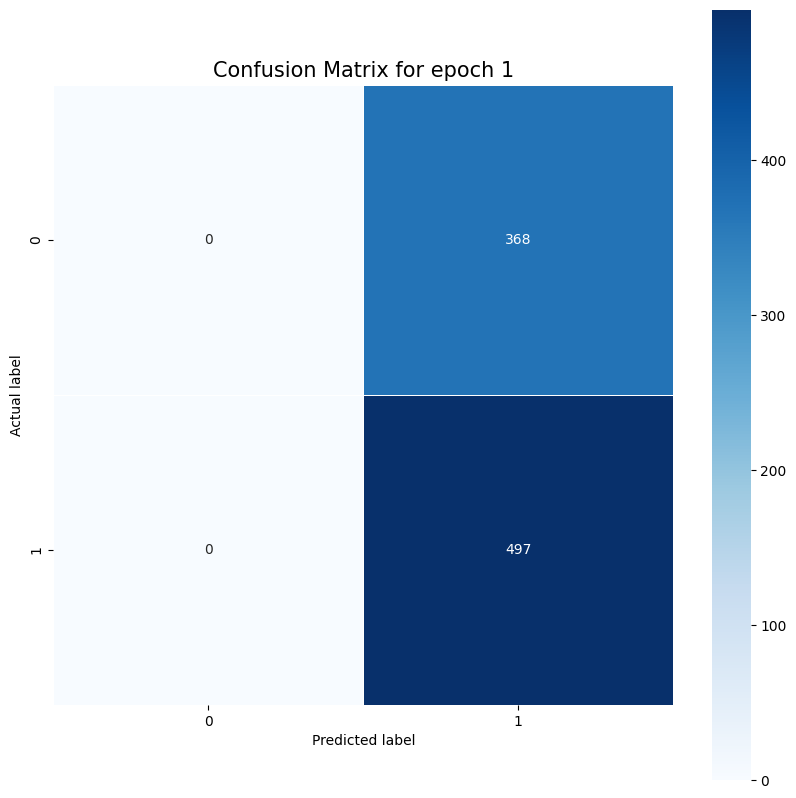

Epoch 2/10:   0%|          | 1/865 [00:02<34:58,  2.43s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   0%|          | 2/865 [00:06<51:36,  3.59s/it]

Accuracy of the model after epoch 2: 50.0%


Epoch 2/10:   0%|          | 3/865 [00:11<56:33,  3.94s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   0%|          | 4/865 [00:16<1:04:39,  4.51s/it]

Accuracy of the model after epoch 2: 75.0%


Epoch 2/10:   1%|          | 5/865 [00:21<1:06:02,  4.61s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:   1%|          | 6/865 [00:25<1:04:40,  4.52s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   1%|          | 7/865 [00:30<1:04:42,  4.53s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   1%|          | 8/865 [00:35<1:07:51,  4.75s/it]

Accuracy of the model after epoch 2: 62.5%


Epoch 2/10:   1%|          | 9/865 [00:40<1:07:50,  4.76s/it]

Accuracy of the model after epoch 2: 55.55555555555556%


Epoch 2/10:   1%|          | 10/865 [00:44<1:05:47,  4.62s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:   1%|▏         | 11/865 [00:48<1:04:45,  4.55s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   1%|▏         | 12/865 [00:53<1:02:59,  4.43s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:   2%|▏         | 13/865 [00:55<54:22,  3.83s/it]  

Accuracy of the model after epoch 2: 61.53846153846154%


Epoch 2/10:   2%|▏         | 14/865 [01:00<59:34,  4.20s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   2%|▏         | 15/865 [01:05<1:00:40,  4.28s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:   2%|▏         | 16/865 [01:07<52:14,  3.69s/it]  

Accuracy of the model after epoch 2: 62.5%


Epoch 2/10:   2%|▏         | 17/865 [01:09<46:28,  3.29s/it]

Accuracy of the model after epoch 2: 64.70588235294117%


Epoch 2/10:   2%|▏         | 18/865 [01:14<53:04,  3.76s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:   2%|▏         | 19/865 [01:17<49:37,  3.52s/it]

Accuracy of the model after epoch 2: 63.1578947368421%


Epoch 2/10:   2%|▏         | 20/865 [01:21<52:34,  3.73s/it]

Accuracy of the model after epoch 2: 65.0%


Epoch 2/10:   2%|▏         | 21/865 [01:26<55:24,  3.94s/it]

Accuracy of the model after epoch 2: 61.904761904761905%


Epoch 2/10:   3%|▎         | 22/865 [01:30<57:00,  4.06s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   3%|▎         | 23/865 [01:32<49:26,  3.52s/it]

Accuracy of the model after epoch 2: 65.21739130434783%


Epoch 2/10:   3%|▎         | 24/865 [01:37<54:17,  3.87s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   3%|▎         | 25/865 [01:40<49:10,  3.51s/it]

Accuracy of the model after epoch 2: 64.0%


Epoch 2/10:   3%|▎         | 26/865 [01:44<52:00,  3.72s/it]

Accuracy of the model after epoch 2: 65.38461538461539%


Epoch 2/10:   3%|▎         | 27/865 [01:48<53:52,  3.86s/it]

Accuracy of the model after epoch 2: 62.96296296296296%


Epoch 2/10:   3%|▎         | 28/865 [01:52<55:36,  3.99s/it]

Accuracy of the model after epoch 2: 64.28571428571429%


Epoch 2/10:   3%|▎         | 29/865 [01:57<58:27,  4.20s/it]

Accuracy of the model after epoch 2: 65.51724137931035%


Epoch 2/10:   3%|▎         | 30/865 [02:01<59:21,  4.26s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   4%|▎         | 31/865 [02:05<58:21,  4.20s/it]

Accuracy of the model after epoch 2: 67.74193548387096%


Epoch 2/10:   4%|▎         | 32/865 [02:08<50:57,  3.67s/it]

Accuracy of the model after epoch 2: 65.625%


Epoch 2/10:   4%|▍         | 33/865 [02:13<55:08,  3.98s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   4%|▍         | 34/865 [02:17<57:41,  4.17s/it]

Accuracy of the model after epoch 2: 64.70588235294117%


Epoch 2/10:   4%|▍         | 35/865 [02:22<58:24,  4.22s/it]

Accuracy of the model after epoch 2: 62.857142857142854%


Epoch 2/10:   4%|▍         | 36/865 [02:26<58:49,  4.26s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:   4%|▍         | 37/865 [02:30<58:55,  4.27s/it]

Accuracy of the model after epoch 2: 59.45945945945946%


Epoch 2/10:   4%|▍         | 38/865 [02:35<1:01:13,  4.44s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:   5%|▍         | 39/865 [02:40<1:02:38,  4.55s/it]

Accuracy of the model after epoch 2: 56.41025641025641%


Epoch 2/10:   5%|▍         | 40/865 [02:44<1:01:30,  4.47s/it]

Accuracy of the model after epoch 2: 57.5%


Epoch 2/10:   5%|▍         | 41/865 [02:47<52:54,  3.85s/it]  

Accuracy of the model after epoch 2: 56.09756097560975%


Epoch 2/10:   5%|▍         | 42/865 [02:49<48:06,  3.51s/it]

Accuracy of the model after epoch 2: 54.76190476190476%


Epoch 2/10:   5%|▍         | 43/865 [02:54<51:33,  3.76s/it]

Accuracy of the model after epoch 2: 53.48837209302326%


Epoch 2/10:   5%|▌         | 44/865 [02:58<54:52,  4.01s/it]

Accuracy of the model after epoch 2: 52.27272727272727%


Epoch 2/10:   5%|▌         | 45/865 [03:01<49:09,  3.60s/it]

Accuracy of the model after epoch 2: 53.333333333333336%


Epoch 2/10:   5%|▌         | 46/865 [03:03<44:31,  3.26s/it]

Accuracy of the model after epoch 2: 54.34782608695652%


Epoch 2/10:   5%|▌         | 47/865 [03:08<48:28,  3.56s/it]

Accuracy of the model after epoch 2: 55.319148936170215%


Epoch 2/10:   6%|▌         | 48/865 [03:12<51:00,  3.75s/it]

Accuracy of the model after epoch 2: 54.166666666666664%


Epoch 2/10:   6%|▌         | 49/865 [03:16<53:31,  3.94s/it]

Accuracy of the model after epoch 2: 55.10204081632653%


Epoch 2/10:   6%|▌         | 50/865 [03:21<55:40,  4.10s/it]

Accuracy of the model after epoch 2: 54.0%


Epoch 2/10:   6%|▌         | 51/865 [03:23<49:37,  3.66s/it]

Accuracy of the model after epoch 2: 54.90196078431372%


Epoch 2/10:   6%|▌         | 52/865 [03:28<52:43,  3.89s/it]

Accuracy of the model after epoch 2: 55.76923076923077%


Epoch 2/10:   6%|▌         | 53/865 [03:32<55:40,  4.11s/it]

Accuracy of the model after epoch 2: 56.60377358490566%


Epoch 2/10:   6%|▌         | 54/865 [03:37<57:29,  4.25s/it]

Accuracy of the model after epoch 2: 57.407407407407405%


Epoch 2/10:   6%|▋         | 55/865 [03:41<57:55,  4.29s/it]

Accuracy of the model after epoch 2: 56.36363636363637%


Epoch 2/10:   6%|▋         | 56/865 [03:45<57:31,  4.27s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   7%|▋         | 57/865 [03:50<57:20,  4.26s/it]

Accuracy of the model after epoch 2: 56.14035087719298%


Epoch 2/10:   7%|▋         | 58/865 [03:52<49:22,  3.67s/it]

Accuracy of the model after epoch 2: 56.89655172413793%


Epoch 2/10:   7%|▋         | 59/865 [03:57<54:42,  4.07s/it]

Accuracy of the model after epoch 2: 57.6271186440678%


Epoch 2/10:   7%|▋         | 60/865 [04:01<55:43,  4.15s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:   7%|▋         | 61/865 [04:04<47:44,  3.56s/it]

Accuracy of the model after epoch 2: 59.01639344262295%


Epoch 2/10:   7%|▋         | 62/865 [04:08<50:27,  3.77s/it]

Accuracy of the model after epoch 2: 59.67741935483871%


Epoch 2/10:   7%|▋         | 63/865 [04:10<45:26,  3.40s/it]

Accuracy of the model after epoch 2: 60.317460317460316%


Epoch 2/10:   7%|▋         | 64/865 [04:15<49:58,  3.74s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:   8%|▊         | 65/865 [04:19<51:50,  3.89s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:   8%|▊         | 66/865 [04:24<55:03,  4.13s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:   8%|▊         | 67/865 [04:28<55:22,  4.16s/it]

Accuracy of the model after epoch 2: 58.208955223880594%


Epoch 2/10:   8%|▊         | 68/865 [04:32<55:55,  4.21s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:   8%|▊         | 69/865 [04:37<56:56,  4.29s/it]

Accuracy of the model after epoch 2: 59.42028985507246%


Epoch 2/10:   8%|▊         | 70/865 [04:41<56:38,  4.28s/it]

Accuracy of the model after epoch 2: 58.57142857142857%


Epoch 2/10:   8%|▊         | 71/865 [04:44<50:08,  3.79s/it]

Accuracy of the model after epoch 2: 57.74647887323944%


Epoch 2/10:   8%|▊         | 72/865 [04:48<52:01,  3.94s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:   8%|▊         | 73/865 [04:52<53:30,  4.05s/it]

Accuracy of the model after epoch 2: 57.534246575342465%


Epoch 2/10:   9%|▊         | 74/865 [04:55<47:59,  3.64s/it]

Accuracy of the model after epoch 2: 56.75675675675676%


Epoch 2/10:   9%|▊         | 75/865 [04:59<50:22,  3.83s/it]

Accuracy of the model after epoch 2: 57.333333333333336%


Epoch 2/10:   9%|▉         | 76/865 [05:04<51:56,  3.95s/it]

Accuracy of the model after epoch 2: 56.578947368421055%


Epoch 2/10:   9%|▉         | 77/865 [05:06<45:59,  3.50s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   9%|▉         | 78/865 [05:10<49:25,  3.77s/it]

Accuracy of the model after epoch 2: 56.41025641025641%


Epoch 2/10:   9%|▉         | 79/865 [05:15<52:50,  4.03s/it]

Accuracy of the model after epoch 2: 55.69620253164557%


Epoch 2/10:   9%|▉         | 80/865 [05:18<46:44,  3.57s/it]

Accuracy of the model after epoch 2: 55.0%


Epoch 2/10:   9%|▉         | 81/865 [05:20<41:41,  3.19s/it]

Accuracy of the model after epoch 2: 55.55555555555556%


Epoch 2/10:   9%|▉         | 82/865 [05:25<47:28,  3.64s/it]

Accuracy of the model after epoch 2: 54.8780487804878%


Epoch 2/10:  10%|▉         | 83/865 [05:29<50:27,  3.87s/it]

Accuracy of the model after epoch 2: 55.42168674698795%


Epoch 2/10:  10%|▉         | 84/865 [05:34<53:08,  4.08s/it]

Accuracy of the model after epoch 2: 55.95238095238095%


Epoch 2/10:  10%|▉         | 85/865 [05:38<54:33,  4.20s/it]

Accuracy of the model after epoch 2: 56.470588235294116%


Epoch 2/10:  10%|▉         | 86/865 [05:42<55:20,  4.26s/it]

Accuracy of the model after epoch 2: 56.97674418604651%


Epoch 2/10:  10%|█         | 87/865 [05:47<55:20,  4.27s/it]

Accuracy of the model after epoch 2: 57.47126436781609%


Epoch 2/10:  10%|█         | 88/865 [05:51<55:52,  4.31s/it]

Accuracy of the model after epoch 2: 57.95454545454545%


Epoch 2/10:  10%|█         | 89/865 [05:56<56:50,  4.39s/it]

Accuracy of the model after epoch 2: 58.42696629213483%


Epoch 2/10:  10%|█         | 90/865 [06:00<56:10,  4.35s/it]

Accuracy of the model after epoch 2: 57.77777777777778%


Epoch 2/10:  11%|█         | 91/865 [06:04<56:49,  4.41s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:  11%|█         | 92/865 [06:09<56:27,  4.38s/it]

Accuracy of the model after epoch 2: 56.52173913043478%


Epoch 2/10:  11%|█         | 93/865 [06:11<48:25,  3.76s/it]

Accuracy of the model after epoch 2: 56.98924731182796%


Epoch 2/10:  11%|█         | 94/865 [06:16<51:19,  3.99s/it]

Accuracy of the model after epoch 2: 57.4468085106383%


Epoch 2/10:  11%|█         | 95/865 [06:20<51:48,  4.04s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:  11%|█         | 96/865 [06:22<45:30,  3.55s/it]

Accuracy of the model after epoch 2: 57.291666666666664%


Epoch 2/10:  11%|█         | 97/865 [06:26<47:55,  3.74s/it]

Accuracy of the model after epoch 2: 57.7319587628866%


Epoch 2/10:  11%|█▏        | 98/865 [06:31<50:29,  3.95s/it]

Accuracy of the model after epoch 2: 58.16326530612245%


Epoch 2/10:  11%|█▏        | 99/865 [06:33<45:18,  3.55s/it]

Accuracy of the model after epoch 2: 57.57575757575758%


Epoch 2/10:  12%|█▏        | 100/865 [06:38<50:21,  3.95s/it]

Accuracy of the model after epoch 2: 58.0%


Epoch 2/10:  12%|█▏        | 101/865 [06:43<51:56,  4.08s/it]

Accuracy of the model after epoch 2: 57.42574257425743%


Epoch 2/10:  12%|█▏        | 102/865 [06:47<54:16,  4.27s/it]

Accuracy of the model after epoch 2: 56.86274509803921%


Epoch 2/10:  12%|█▏        | 103/865 [06:50<46:54,  3.69s/it]

Accuracy of the model after epoch 2: 57.28155339805825%


Epoch 2/10:  12%|█▏        | 104/865 [06:55<50:54,  4.01s/it]

Accuracy of the model after epoch 2: 57.69230769230769%


Epoch 2/10:  12%|█▏        | 105/865 [06:59<51:47,  4.09s/it]

Accuracy of the model after epoch 2: 58.095238095238095%


Epoch 2/10:  12%|█▏        | 106/865 [07:01<44:59,  3.56s/it]

Accuracy of the model after epoch 2: 58.490566037735846%


Epoch 2/10:  12%|█▏        | 107/865 [07:03<40:16,  3.19s/it]

Accuracy of the model after epoch 2: 57.94392523364486%


Epoch 2/10:  12%|█▏        | 108/865 [07:08<44:52,  3.56s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  13%|█▎        | 109/865 [07:12<48:47,  3.87s/it]

Accuracy of the model after epoch 2: 58.71559633027523%


Epoch 2/10:  13%|█▎        | 110/865 [07:17<50:53,  4.04s/it]

Accuracy of the model after epoch 2: 58.18181818181818%


Epoch 2/10:  13%|█▎        | 111/865 [07:21<51:22,  4.09s/it]

Accuracy of the model after epoch 2: 57.65765765765766%


Epoch 2/10:  13%|█▎        | 112/865 [07:24<45:02,  3.59s/it]

Accuracy of the model after epoch 2: 58.035714285714285%


Epoch 2/10:  13%|█▎        | 113/865 [07:26<39:56,  3.19s/it]

Accuracy of the model after epoch 2: 57.52212389380531%


Epoch 2/10:  13%|█▎        | 114/865 [07:30<45:04,  3.60s/it]

Accuracy of the model after epoch 2: 57.01754385964912%


Epoch 2/10:  13%|█▎        | 115/865 [07:34<46:57,  3.76s/it]

Accuracy of the model after epoch 2: 57.391304347826086%


Epoch 2/10:  13%|█▎        | 116/865 [07:39<48:28,  3.88s/it]

Accuracy of the model after epoch 2: 57.758620689655174%


Epoch 2/10:  14%|█▎        | 117/865 [07:43<50:11,  4.03s/it]

Accuracy of the model after epoch 2: 57.26495726495727%


Epoch 2/10:  14%|█▎        | 118/865 [07:47<50:59,  4.10s/it]

Accuracy of the model after epoch 2: 57.6271186440678%


Epoch 2/10:  14%|█▍        | 119/865 [07:53<55:48,  4.49s/it]

Accuracy of the model after epoch 2: 57.983193277310924%


Epoch 2/10:  14%|█▍        | 120/865 [07:55<48:24,  3.90s/it]

Accuracy of the model after epoch 2: 57.5%


Epoch 2/10:  14%|█▍        | 121/865 [07:59<49:04,  3.96s/it]

Accuracy of the model after epoch 2: 57.85123966942149%


Epoch 2/10:  14%|█▍        | 122/865 [08:04<51:45,  4.18s/it]

Accuracy of the model after epoch 2: 58.19672131147541%


Epoch 2/10:  14%|█▍        | 123/865 [08:08<51:50,  4.19s/it]

Accuracy of the model after epoch 2: 58.53658536585366%


Epoch 2/10:  14%|█▍        | 124/865 [08:11<46:20,  3.75s/it]

Accuracy of the model after epoch 2: 58.064516129032256%


Epoch 2/10:  14%|█▍        | 125/865 [08:15<48:40,  3.95s/it]

Accuracy of the model after epoch 2: 58.4%


Epoch 2/10:  15%|█▍        | 126/865 [08:20<50:16,  4.08s/it]

Accuracy of the model after epoch 2: 57.93650793650794%


Epoch 2/10:  15%|█▍        | 127/865 [08:24<51:06,  4.15s/it]

Accuracy of the model after epoch 2: 57.48031496062992%


Epoch 2/10:  15%|█▍        | 128/865 [08:28<52:01,  4.24s/it]

Accuracy of the model after epoch 2: 57.8125%


Epoch 2/10:  15%|█▍        | 129/865 [08:33<53:33,  4.37s/it]

Accuracy of the model after epoch 2: 58.13953488372093%


Epoch 2/10:  15%|█▌        | 130/865 [08:38<53:36,  4.38s/it]

Accuracy of the model after epoch 2: 58.46153846153846%


Epoch 2/10:  15%|█▌        | 131/865 [08:42<55:13,  4.51s/it]

Accuracy of the model after epoch 2: 58.01526717557252%


Epoch 2/10:  15%|█▌        | 132/865 [08:45<47:44,  3.91s/it]

Accuracy of the model after epoch 2: 57.57575757575758%


Epoch 2/10:  15%|█▌        | 133/865 [08:49<49:55,  4.09s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:  15%|█▌        | 134/865 [08:55<54:39,  4.49s/it]

Accuracy of the model after epoch 2: 57.46268656716418%


Epoch 2/10:  16%|█▌        | 135/865 [08:59<54:21,  4.47s/it]

Accuracy of the model after epoch 2: 57.03703703703704%


Epoch 2/10:  16%|█▌        | 136/865 [09:03<53:34,  4.41s/it]

Accuracy of the model after epoch 2: 57.35294117647059%


Epoch 2/10:  16%|█▌        | 137/865 [09:08<54:33,  4.50s/it]

Accuracy of the model after epoch 2: 57.66423357664234%


Epoch 2/10:  16%|█▌        | 138/865 [09:13<55:34,  4.59s/it]

Accuracy of the model after epoch 2: 57.2463768115942%


Epoch 2/10:  16%|█▌        | 139/865 [09:16<48:33,  4.01s/it]

Accuracy of the model after epoch 2: 57.55395683453237%


Epoch 2/10:  16%|█▌        | 140/865 [09:20<49:32,  4.10s/it]

Accuracy of the model after epoch 2: 57.857142857142854%


Epoch 2/10:  16%|█▋        | 141/865 [09:22<43:34,  3.61s/it]

Accuracy of the model after epoch 2: 58.156028368794324%


Epoch 2/10:  16%|█▋        | 142/865 [09:25<39:54,  3.31s/it]

Accuracy of the model after epoch 2: 58.45070422535211%


Epoch 2/10:  17%|█▋        | 143/865 [09:29<43:29,  3.61s/it]

Accuracy of the model after epoch 2: 58.74125874125874%


Epoch 2/10:  17%|█▋        | 144/865 [09:34<47:13,  3.93s/it]

Accuracy of the model after epoch 2: 59.02777777777778%


Epoch 2/10:  17%|█▋        | 145/865 [09:38<48:07,  4.01s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  17%|█▋        | 146/865 [09:42<48:25,  4.04s/it]

Accuracy of the model after epoch 2: 58.9041095890411%


Epoch 2/10:  17%|█▋        | 147/865 [09:45<42:14,  3.53s/it]

Accuracy of the model after epoch 2: 59.183673469387756%


Epoch 2/10:  17%|█▋        | 148/865 [09:49<45:03,  3.77s/it]

Accuracy of the model after epoch 2: 58.78378378378378%


Epoch 2/10:  17%|█▋        | 149/865 [09:54<47:54,  4.01s/it]

Accuracy of the model after epoch 2: 59.060402684563755%


Epoch 2/10:  17%|█▋        | 150/865 [09:56<42:17,  3.55s/it]

Accuracy of the model after epoch 2: 59.333333333333336%


Epoch 2/10:  17%|█▋        | 151/865 [09:59<39:12,  3.29s/it]

Accuracy of the model after epoch 2: 59.602649006622514%


Epoch 2/10:  18%|█▊        | 152/865 [10:03<42:11,  3.55s/it]

Accuracy of the model after epoch 2: 59.86842105263158%


Epoch 2/10:  18%|█▊        | 153/865 [10:07<44:24,  3.74s/it]

Accuracy of the model after epoch 2: 59.47712418300654%


Epoch 2/10:  18%|█▊        | 154/865 [10:12<47:56,  4.05s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:  18%|█▊        | 155/865 [10:14<42:15,  3.57s/it]

Accuracy of the model after epoch 2: 58.70967741935484%


Epoch 2/10:  18%|█▊        | 156/865 [10:19<44:35,  3.77s/it]

Accuracy of the model after epoch 2: 58.97435897435897%


Epoch 2/10:  18%|█▊        | 157/865 [10:23<46:20,  3.93s/it]

Accuracy of the model after epoch 2: 59.23566878980892%


Epoch 2/10:  18%|█▊        | 158/865 [10:27<46:49,  3.97s/it]

Accuracy of the model after epoch 2: 59.49367088607595%


Epoch 2/10:  18%|█▊        | 159/865 [10:31<48:42,  4.14s/it]

Accuracy of the model after epoch 2: 59.119496855345915%


Epoch 2/10:  18%|█▊        | 160/865 [10:36<49:33,  4.22s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  19%|█▊        | 161/865 [10:41<52:11,  4.45s/it]

Accuracy of the model after epoch 2: 59.006211180124225%


Epoch 2/10:  19%|█▊        | 162/865 [10:43<44:40,  3.81s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  19%|█▉        | 163/865 [10:47<46:21,  3.96s/it]

Accuracy of the model after epoch 2: 59.50920245398773%


Epoch 2/10:  19%|█▉        | 164/865 [10:52<48:14,  4.13s/it]

Accuracy of the model after epoch 2: 59.75609756097561%


Epoch 2/10:  19%|█▉        | 165/865 [10:54<42:12,  3.62s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  19%|█▉        | 166/865 [10:59<44:43,  3.84s/it]

Accuracy of the model after epoch 2: 59.63855421686747%


Epoch 2/10:  19%|█▉        | 167/865 [11:03<46:24,  3.99s/it]

Accuracy of the model after epoch 2: 59.2814371257485%


Epoch 2/10:  19%|█▉        | 168/865 [11:08<48:04,  4.14s/it]

Accuracy of the model after epoch 2: 59.523809523809526%


Epoch 2/10:  20%|█▉        | 169/865 [11:12<49:40,  4.28s/it]

Accuracy of the model after epoch 2: 59.171597633136095%


Epoch 2/10:  20%|█▉        | 170/865 [11:17<50:14,  4.34s/it]

Accuracy of the model after epoch 2: 59.411764705882355%


Epoch 2/10:  20%|█▉        | 171/865 [11:21<51:47,  4.48s/it]

Accuracy of the model after epoch 2: 59.06432748538012%


Epoch 2/10:  20%|█▉        | 172/865 [11:26<51:04,  4.42s/it]

Accuracy of the model after epoch 2: 58.72093023255814%


Epoch 2/10:  20%|██        | 173/865 [11:31<53:31,  4.64s/it]

Accuracy of the model after epoch 2: 58.959537572254334%


Epoch 2/10:  20%|██        | 174/865 [11:36<53:56,  4.68s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  20%|██        | 175/865 [11:41<55:17,  4.81s/it]

Accuracy of the model after epoch 2: 58.285714285714285%


Epoch 2/10:  20%|██        | 176/865 [11:43<47:13,  4.11s/it]

Accuracy of the model after epoch 2: 57.95454545454545%


Epoch 2/10:  20%|██        | 177/865 [11:48<48:40,  4.24s/it]

Accuracy of the model after epoch 2: 58.19209039548023%


Epoch 2/10:  21%|██        | 178/865 [11:50<42:55,  3.75s/it]

Accuracy of the model after epoch 2: 57.86516853932584%


Epoch 2/10:  21%|██        | 179/865 [11:53<39:36,  3.46s/it]

Accuracy of the model after epoch 2: 58.100558659217874%


Epoch 2/10:  21%|██        | 180/865 [11:58<42:59,  3.77s/it]

Accuracy of the model after epoch 2: 57.77777777777778%


Epoch 2/10:  21%|██        | 181/865 [12:00<38:12,  3.35s/it]

Accuracy of the model after epoch 2: 58.011049723756905%


Epoch 2/10:  21%|██        | 182/865 [12:05<42:25,  3.73s/it]

Accuracy of the model after epoch 2: 58.24175824175824%


Epoch 2/10:  21%|██        | 183/865 [12:09<44:54,  3.95s/it]

Accuracy of the model after epoch 2: 57.923497267759565%


Epoch 2/10:  21%|██▏       | 184/865 [12:14<47:27,  4.18s/it]

Accuracy of the model after epoch 2: 57.608695652173914%


Epoch 2/10:  21%|██▏       | 185/865 [12:16<41:26,  3.66s/it]

Accuracy of the model after epoch 2: 57.83783783783784%


Epoch 2/10:  22%|██▏       | 186/865 [12:21<44:00,  3.89s/it]

Accuracy of the model after epoch 2: 58.064516129032256%


Epoch 2/10:  22%|██▏       | 187/865 [12:25<46:04,  4.08s/it]

Accuracy of the model after epoch 2: 58.288770053475936%


Epoch 2/10:  22%|██▏       | 188/865 [12:28<40:53,  3.62s/it]

Accuracy of the model after epoch 2: 58.51063829787234%


Epoch 2/10:  22%|██▏       | 189/865 [12:32<44:14,  3.93s/it]

Accuracy of the model after epoch 2: 58.73015873015873%


Epoch 2/10:  22%|██▏       | 190/865 [12:37<45:49,  4.07s/it]

Accuracy of the model after epoch 2: 58.94736842105263%


Epoch 2/10:  22%|██▏       | 191/865 [12:41<46:45,  4.16s/it]

Accuracy of the model after epoch 2: 58.638743455497384%


Epoch 2/10:  22%|██▏       | 192/865 [12:44<40:52,  3.64s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  22%|██▏       | 193/865 [12:48<42:48,  3.82s/it]

Accuracy of the model after epoch 2: 58.54922279792746%


Epoch 2/10:  22%|██▏       | 194/865 [12:51<39:37,  3.54s/it]

Accuracy of the model after epoch 2: 58.24742268041237%


Epoch 2/10:  23%|██▎       | 195/865 [12:55<42:17,  3.79s/it]

Accuracy of the model after epoch 2: 58.46153846153846%


Epoch 2/10:  23%|██▎       | 196/865 [12:58<38:20,  3.44s/it]

Accuracy of the model after epoch 2: 58.16326530612245%


Epoch 2/10:  23%|██▎       | 197/865 [13:00<35:14,  3.17s/it]

Accuracy of the model after epoch 2: 58.3756345177665%


Epoch 2/10:  23%|██▎       | 198/865 [13:05<39:43,  3.57s/it]

Accuracy of the model after epoch 2: 58.08080808080808%


Epoch 2/10:  23%|██▎       | 199/865 [13:10<44:32,  4.01s/it]

Accuracy of the model after epoch 2: 58.29145728643216%


Epoch 2/10:  23%|██▎       | 200/865 [13:14<45:34,  4.11s/it]

Accuracy of the model after epoch 2: 58.5%


Epoch 2/10:  23%|██▎       | 201/865 [13:19<46:22,  4.19s/it]

Accuracy of the model after epoch 2: 58.70646766169154%


Epoch 2/10:  23%|██▎       | 202/865 [13:23<46:55,  4.25s/it]

Accuracy of the model after epoch 2: 58.415841584158414%


Epoch 2/10:  23%|██▎       | 203/865 [13:28<50:33,  4.58s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  24%|██▎       | 204/865 [13:33<50:41,  4.60s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  24%|██▎       | 205/865 [13:37<49:39,  4.51s/it]

Accuracy of the model after epoch 2: 58.53658536585366%


Epoch 2/10:  24%|██▍       | 206/865 [13:42<49:06,  4.47s/it]

Accuracy of the model after epoch 2: 58.25242718446602%


Epoch 2/10:  24%|██▍       | 207/865 [13:46<48:40,  4.44s/it]

Accuracy of the model after epoch 2: 58.45410628019324%


Epoch 2/10:  24%|██▍       | 208/865 [13:51<49:00,  4.48s/it]

Accuracy of the model after epoch 2: 58.65384615384615%


Epoch 2/10:  24%|██▍       | 209/865 [13:56<51:15,  4.69s/it]

Accuracy of the model after epoch 2: 58.3732057416268%


Epoch 2/10:  24%|██▍       | 210/865 [14:01<51:17,  4.70s/it]

Accuracy of the model after epoch 2: 58.57142857142857%


Epoch 2/10:  24%|██▍       | 211/865 [14:05<49:40,  4.56s/it]

Accuracy of the model after epoch 2: 58.76777251184834%


Epoch 2/10:  25%|██▍       | 212/865 [14:07<42:55,  3.94s/it]

Accuracy of the model after epoch 2: 58.9622641509434%


Epoch 2/10:  25%|██▍       | 213/865 [14:12<44:01,  4.05s/it]

Accuracy of the model after epoch 2: 59.15492957746479%


Epoch 2/10:  25%|██▍       | 214/865 [14:16<45:51,  4.23s/it]

Accuracy of the model after epoch 2: 59.345794392523366%


Epoch 2/10:  25%|██▍       | 215/865 [14:20<45:29,  4.20s/it]

Accuracy of the model after epoch 2: 59.53488372093023%


Epoch 2/10:  25%|██▍       | 216/865 [14:25<46:20,  4.28s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  25%|██▌       | 217/865 [14:29<45:47,  4.24s/it]

Accuracy of the model after epoch 2: 58.986175115207374%


Epoch 2/10:  25%|██▌       | 218/865 [14:34<47:14,  4.38s/it]

Accuracy of the model after epoch 2: 59.174311926605505%


Epoch 2/10:  25%|██▌       | 219/865 [14:38<48:10,  4.47s/it]

Accuracy of the model after epoch 2: 59.36073059360731%


Epoch 2/10:  25%|██▌       | 220/865 [14:43<47:49,  4.45s/it]

Accuracy of the model after epoch 2: 59.54545454545455%


Epoch 2/10:  26%|██▌       | 221/865 [14:47<47:11,  4.40s/it]

Accuracy of the model after epoch 2: 59.72850678733032%


Epoch 2/10:  26%|██▌       | 222/865 [14:51<47:17,  4.41s/it]

Accuracy of the model after epoch 2: 59.909909909909906%


Epoch 2/10:  26%|██▌       | 223/865 [14:54<40:08,  3.75s/it]

Accuracy of the model after epoch 2: 59.64125560538117%


Epoch 2/10:  26%|██▌       | 224/865 [14:59<44:59,  4.21s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:  26%|██▌       | 225/865 [15:03<45:35,  4.27s/it]

Accuracy of the model after epoch 2: 59.55555555555556%


Epoch 2/10:  26%|██▌       | 226/865 [15:08<45:04,  4.23s/it]

Accuracy of the model after epoch 2: 59.73451327433628%


Epoch 2/10:  26%|██▌       | 227/865 [15:12<44:58,  4.23s/it]

Accuracy of the model after epoch 2: 59.47136563876652%


Epoch 2/10:  26%|██▋       | 228/865 [15:17<46:45,  4.40s/it]

Accuracy of the model after epoch 2: 59.21052631578947%


Epoch 2/10:  26%|██▋       | 229/865 [15:21<47:31,  4.48s/it]

Accuracy of the model after epoch 2: 58.951965065502186%


Epoch 2/10:  27%|██▋       | 230/865 [15:26<46:46,  4.42s/it]

Accuracy of the model after epoch 2: 58.69565217391305%


Epoch 2/10:  27%|██▋       | 231/865 [15:30<47:45,  4.52s/it]

Accuracy of the model after epoch 2: 58.874458874458874%


Epoch 2/10:  27%|██▋       | 232/865 [15:34<46:46,  4.43s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  27%|██▋       | 233/865 [15:39<47:24,  4.50s/it]

Accuracy of the model after epoch 2: 58.798283261802574%


Epoch 2/10:  27%|██▋       | 234/865 [15:42<41:23,  3.94s/it]

Accuracy of the model after epoch 2: 58.547008547008545%


Epoch 2/10:  27%|██▋       | 235/865 [15:44<36:39,  3.49s/it]

Accuracy of the model after epoch 2: 58.723404255319146%


Epoch 2/10:  27%|██▋       | 236/865 [15:49<39:28,  3.77s/it]

Accuracy of the model after epoch 2: 58.47457627118644%


Epoch 2/10:  27%|██▋       | 237/865 [15:53<40:42,  3.89s/it]

Accuracy of the model after epoch 2: 58.64978902953587%


Epoch 2/10:  28%|██▊       | 238/865 [15:55<36:12,  3.47s/it]

Accuracy of the model after epoch 2: 58.403361344537814%


Epoch 2/10:  28%|██▊       | 239/865 [16:00<39:50,  3.82s/it]

Accuracy of the model after epoch 2: 58.57740585774059%


Epoch 2/10:  28%|██▊       | 240/865 [16:04<41:02,  3.94s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  28%|██▊       | 241/865 [16:06<35:58,  3.46s/it]

Accuracy of the model after epoch 2: 58.92116182572614%


Epoch 2/10:  28%|██▊       | 242/865 [16:11<38:54,  3.75s/it]

Accuracy of the model after epoch 2: 58.67768595041322%


Epoch 2/10:  28%|██▊       | 243/865 [16:13<35:03,  3.38s/it]

Accuracy of the model after epoch 2: 58.8477366255144%


Epoch 2/10:  28%|██▊       | 244/865 [16:18<40:09,  3.88s/it]

Accuracy of the model after epoch 2: 59.01639344262295%


Epoch 2/10:  28%|██▊       | 245/865 [16:23<43:30,  4.21s/it]

Accuracy of the model after epoch 2: 58.775510204081634%


Epoch 2/10:  28%|██▊       | 246/865 [16:26<38:24,  3.72s/it]

Accuracy of the model after epoch 2: 58.94308943089431%


Epoch 2/10:  29%|██▊       | 247/865 [16:31<41:12,  4.00s/it]

Accuracy of the model after epoch 2: 58.70445344129555%


Epoch 2/10:  29%|██▊       | 248/865 [16:33<36:01,  3.50s/it]

Accuracy of the model after epoch 2: 58.46774193548387%


Epoch 2/10:  29%|██▉       | 249/865 [16:38<39:04,  3.81s/it]

Accuracy of the model after epoch 2: 58.63453815261044%


Epoch 2/10:  29%|██▉       | 250/865 [16:40<34:59,  3.41s/it]

Accuracy of the model after epoch 2: 58.4%


Epoch 2/10:  29%|██▉       | 251/865 [16:45<38:11,  3.73s/it]

Accuracy of the model after epoch 2: 58.167330677290835%


Epoch 2/10:  29%|██▉       | 252/865 [16:49<40:11,  3.93s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  29%|██▉       | 253/865 [16:53<41:49,  4.10s/it]

Accuracy of the model after epoch 2: 58.49802371541502%


Epoch 2/10:  29%|██▉       | 254/865 [16:56<37:02,  3.64s/it]

Accuracy of the model after epoch 2: 58.661417322834644%


Epoch 2/10:  29%|██▉       | 255/865 [17:00<38:34,  3.79s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  30%|██▉       | 256/865 [17:04<39:58,  3.94s/it]

Accuracy of the model after epoch 2: 58.984375%


Epoch 2/10:  30%|██▉       | 257/865 [17:09<41:30,  4.10s/it]

Accuracy of the model after epoch 2: 58.75486381322957%


Epoch 2/10:  30%|██▉       | 258/865 [17:12<37:02,  3.66s/it]

Accuracy of the model after epoch 2: 58.52713178294574%


Epoch 2/10:  30%|██▉       | 259/865 [17:16<39:42,  3.93s/it]

Accuracy of the model after epoch 2: 58.68725868725869%


Epoch 2/10:  30%|███       | 260/865 [17:20<40:38,  4.03s/it]

Accuracy of the model after epoch 2: 58.84615384615385%


Epoch 2/10:  30%|███       | 261/865 [17:25<41:08,  4.09s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  30%|███       | 262/865 [17:29<43:21,  4.31s/it]

Accuracy of the model after epoch 2: 58.778625954198475%


Epoch 2/10:  30%|███       | 263/865 [17:34<45:23,  4.52s/it]

Accuracy of the model after epoch 2: 58.555133079847906%


Epoch 2/10:  31%|███       | 264/865 [17:39<46:33,  4.65s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  31%|███       | 265/865 [17:44<45:59,  4.60s/it]

Accuracy of the model after epoch 2: 58.113207547169814%


Epoch 2/10:  31%|███       | 266/865 [17:48<44:34,  4.46s/it]

Accuracy of the model after epoch 2: 58.27067669172932%


Epoch 2/10:  31%|███       | 267/865 [17:52<44:27,  4.46s/it]

Accuracy of the model after epoch 2: 58.42696629213483%


Epoch 2/10:  31%|███       | 268/865 [17:57<44:12,  4.44s/it]

Accuracy of the model after epoch 2: 58.582089552238806%


Epoch 2/10:  31%|███       | 269/865 [18:01<44:42,  4.50s/it]

Accuracy of the model after epoch 2: 58.7360594795539%


Epoch 2/10:  31%|███       | 270/865 [18:04<39:12,  3.95s/it]

Accuracy of the model after epoch 2: 58.51851851851852%


Epoch 2/10:  31%|███▏      | 271/865 [18:09<40:20,  4.08s/it]

Accuracy of the model after epoch 2: 58.30258302583026%


Epoch 2/10:  31%|███▏      | 272/865 [18:11<35:00,  3.54s/it]

Accuracy of the model after epoch 2: 58.088235294117645%


Epoch 2/10:  32%|███▏      | 273/865 [18:16<38:29,  3.90s/it]

Accuracy of the model after epoch 2: 57.875457875457876%


Epoch 2/10:  32%|███▏      | 274/865 [18:18<34:23,  3.49s/it]

Accuracy of the model after epoch 2: 57.66423357664234%


Epoch 2/10:  32%|███▏      | 275/865 [18:21<31:25,  3.20s/it]

Accuracy of the model after epoch 2: 57.81818181818182%


Epoch 2/10:  32%|███▏      | 276/865 [18:25<35:06,  3.58s/it]

Accuracy of the model after epoch 2: 57.971014492753625%


Epoch 2/10:  32%|███▏      | 277/865 [18:29<37:08,  3.79s/it]

Accuracy of the model after epoch 2: 57.761732851985556%


Epoch 2/10:  32%|███▏      | 278/865 [18:32<32:59,  3.37s/it]

Accuracy of the model after epoch 2: 57.9136690647482%


Epoch 2/10:  32%|███▏      | 279/865 [18:34<31:00,  3.18s/it]

Accuracy of the model after epoch 2: 58.064516129032256%


Epoch 2/10:  32%|███▏      | 280/865 [18:37<29:00,  2.98s/it]

Accuracy of the model after epoch 2: 57.857142857142854%


Epoch 2/10:  32%|███▏      | 281/865 [18:41<32:42,  3.36s/it]

Accuracy of the model after epoch 2: 58.00711743772242%


Epoch 2/10:  33%|███▎      | 282/865 [18:46<35:34,  3.66s/it]

Accuracy of the model after epoch 2: 58.156028368794324%


Epoch 2/10:  33%|███▎      | 283/865 [18:50<39:01,  4.02s/it]

Accuracy of the model after epoch 2: 58.303886925795055%


Epoch 2/10:  33%|███▎      | 284/865 [18:53<35:51,  3.70s/it]

Accuracy of the model after epoch 2: 58.45070422535211%


Epoch 2/10:  33%|███▎      | 285/865 [18:56<31:53,  3.30s/it]

Accuracy of the model after epoch 2: 58.24561403508772%


Epoch 2/10:  33%|███▎      | 286/865 [19:00<35:14,  3.65s/it]

Accuracy of the model after epoch 2: 58.04195804195804%


Epoch 2/10:  33%|███▎      | 287/865 [19:05<37:58,  3.94s/it]

Accuracy of the model after epoch 2: 57.8397212543554%


Epoch 2/10:  33%|███▎      | 288/865 [19:09<39:52,  4.15s/it]

Accuracy of the model after epoch 2: 57.638888888888886%


Epoch 2/10:  33%|███▎      | 289/865 [19:14<41:10,  4.29s/it]

Accuracy of the model after epoch 2: 57.78546712802768%


Epoch 2/10:  34%|███▎      | 290/865 [19:17<35:44,  3.73s/it]

Accuracy of the model after epoch 2: 57.58620689655172%


Epoch 2/10:  34%|███▎      | 291/865 [19:19<32:20,  3.38s/it]

Accuracy of the model after epoch 2: 57.38831615120275%


Epoch 2/10:  34%|███▍      | 292/865 [19:24<35:40,  3.74s/it]

Accuracy of the model after epoch 2: 57.534246575342465%


Epoch 2/10:  34%|███▍      | 293/865 [19:28<37:21,  3.92s/it]

Accuracy of the model after epoch 2: 57.67918088737201%


Epoch 2/10:  34%|███▍      | 294/865 [19:33<39:10,  4.12s/it]

Accuracy of the model after epoch 2: 57.82312925170068%


Epoch 2/10:  34%|███▍      | 295/865 [19:37<39:35,  4.17s/it]

Accuracy of the model after epoch 2: 57.96610169491525%


Epoch 2/10:  34%|███▍      | 296/865 [19:39<34:58,  3.69s/it]

Accuracy of the model after epoch 2: 58.108108108108105%


Epoch 2/10:  34%|███▍      | 297/865 [19:44<37:16,  3.94s/it]

Accuracy of the model after epoch 2: 57.91245791245791%


Epoch 2/10:  34%|███▍      | 298/865 [19:49<39:55,  4.23s/it]

Accuracy of the model after epoch 2: 58.053691275167786%


Epoch 2/10:  35%|███▍      | 299/865 [19:51<35:21,  3.75s/it]

Accuracy of the model after epoch 2: 58.19397993311037%


Epoch 2/10:  35%|███▍      | 300/865 [19:54<32:04,  3.41s/it]

Accuracy of the model after epoch 2: 58.0%


Epoch 2/10:  35%|███▍      | 301/865 [19:56<28:47,  3.06s/it]

Accuracy of the model after epoch 2: 58.13953488372093%


Epoch 2/10:  35%|███▍      | 302/865 [19:59<27:28,  2.93s/it]

Accuracy of the model after epoch 2: 58.27814569536424%


Epoch 2/10:  35%|███▌      | 303/865 [20:01<26:01,  2.78s/it]

Accuracy of the model after epoch 2: 58.085808580858085%


Epoch 2/10:  35%|███▌      | 304/865 [20:06<31:32,  3.37s/it]

Accuracy of the model after epoch 2: 58.223684210526315%


Epoch 2/10:  35%|███▌      | 305/865 [20:11<35:09,  3.77s/it]

Accuracy of the model after epoch 2: 58.36065573770492%


Epoch 2/10:  35%|███▌      | 306/865 [20:13<31:18,  3.36s/it]

Accuracy of the model after epoch 2: 58.49673202614379%


Epoch 2/10:  35%|███▌      | 307/865 [20:18<34:08,  3.67s/it]

Accuracy of the model after epoch 2: 58.306188925081436%


Epoch 2/10:  36%|███▌      | 308/865 [20:22<35:46,  3.85s/it]

Accuracy of the model after epoch 2: 58.44155844155844%


Epoch 2/10:  36%|███▌      | 309/865 [20:26<37:18,  4.03s/it]

Accuracy of the model after epoch 2: 58.57605177993528%


Epoch 2/10:  36%|███▌      | 310/865 [20:31<39:29,  4.27s/it]

Accuracy of the model after epoch 2: 58.38709677419355%


Epoch 2/10:  36%|███▌      | 311/865 [20:36<39:34,  4.29s/it]

Accuracy of the model after epoch 2: 58.52090032154341%


Epoch 2/10:  36%|███▌      | 312/865 [20:40<39:50,  4.32s/it]

Accuracy of the model after epoch 2: 58.65384615384615%


Epoch 2/10:  36%|███▌      | 313/865 [20:42<34:40,  3.77s/it]

Accuracy of the model after epoch 2: 58.466453674121404%


Epoch 2/10:  36%|███▋      | 314/865 [20:45<31:54,  3.47s/it]

Accuracy of the model after epoch 2: 58.59872611464968%


Epoch 2/10:  36%|███▋      | 315/865 [20:50<35:41,  3.89s/it]

Accuracy of the model after epoch 2: 58.73015873015873%


Epoch 2/10:  37%|███▋      | 316/865 [20:53<31:39,  3.46s/it]

Accuracy of the model after epoch 2: 58.54430379746835%


Epoch 2/10:  37%|███▋      | 317/865 [20:57<33:43,  3.69s/it]

Accuracy of the model after epoch 2: 58.359621451104104%


Epoch 2/10:  37%|███▋      | 318/865 [21:01<36:22,  3.99s/it]

Accuracy of the model after epoch 2: 58.490566037735846%


Epoch 2/10:  37%|███▋      | 319/865 [21:04<33:02,  3.63s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  37%|███▋      | 320/865 [21:09<34:48,  3.83s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  37%|███▋      | 321/865 [21:13<36:09,  3.99s/it]

Accuracy of the model after epoch 2: 58.56697819314642%


Epoch 2/10:  37%|███▋      | 322/865 [21:17<37:06,  4.10s/it]

Accuracy of the model after epoch 2: 58.69565217391305%


Epoch 2/10:  37%|███▋      | 323/865 [21:21<37:15,  4.12s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  37%|███▋      | 324/865 [21:26<38:27,  4.27s/it]

Accuracy of the model after epoch 2: 58.641975308641975%


Epoch 2/10:  38%|███▊      | 325/865 [21:30<38:27,  4.27s/it]

Accuracy of the model after epoch 2: 58.46153846153846%


Epoch 2/10:  38%|███▊      | 326/865 [21:35<38:08,  4.25s/it]

Accuracy of the model after epoch 2: 58.282208588957054%


Epoch 2/10:  38%|███▊      | 327/865 [21:39<38:59,  4.35s/it]

Accuracy of the model after epoch 2: 58.103975535168196%


Epoch 2/10:  38%|███▊      | 328/865 [21:44<40:01,  4.47s/it]

Accuracy of the model after epoch 2: 57.926829268292686%


Epoch 2/10:  38%|███▊      | 329/865 [21:46<34:40,  3.88s/it]

Accuracy of the model after epoch 2: 58.05471124620061%


Epoch 2/10:  38%|███▊      | 330/865 [21:51<35:55,  4.03s/it]

Accuracy of the model after epoch 2: 57.878787878787875%


Epoch 2/10:  38%|███▊      | 331/865 [21:53<32:01,  3.60s/it]

Accuracy of the model after epoch 2: 58.00604229607251%


Epoch 2/10:  38%|███▊      | 332/865 [21:57<32:56,  3.71s/it]

Accuracy of the model after epoch 2: 58.13253012048193%


Epoch 2/10:  38%|███▊      | 333/865 [22:02<34:30,  3.89s/it]

Accuracy of the model after epoch 2: 58.25825825825826%


Epoch 2/10:  39%|███▊      | 334/865 [22:07<37:33,  4.24s/it]

Accuracy of the model after epoch 2: 58.08383233532934%


Epoch 2/10:  39%|███▊      | 335/865 [22:11<37:40,  4.27s/it]

Accuracy of the model after epoch 2: 57.91044776119403%


Epoch 2/10:  39%|███▉      | 336/865 [22:15<37:25,  4.25s/it]

Accuracy of the model after epoch 2: 58.035714285714285%


Epoch 2/10:  39%|███▉      | 337/865 [22:19<37:05,  4.22s/it]

Accuracy of the model after epoch 2: 58.160237388724035%


Epoch 2/10:  39%|███▉      | 338/865 [22:22<32:15,  3.67s/it]

Accuracy of the model after epoch 2: 58.28402366863905%


Epoch 2/10:  39%|███▉      | 339/865 [22:26<34:54,  3.98s/it]

Accuracy of the model after epoch 2: 58.4070796460177%


Epoch 2/10:  39%|███▉      | 340/865 [22:31<35:32,  4.06s/it]

Accuracy of the model after epoch 2: 58.529411764705884%


Epoch 2/10:  39%|███▉      | 341/865 [22:35<37:19,  4.27s/it]

Accuracy of the model after epoch 2: 58.35777126099707%


Epoch 2/10:  40%|███▉      | 342/865 [22:40<37:51,  4.34s/it]

Accuracy of the model after epoch 2: 58.187134502923975%


Epoch 2/10:  40%|███▉      | 343/865 [22:45<38:24,  4.41s/it]

Accuracy of the model after epoch 2: 58.01749271137026%


Epoch 2/10:  40%|███▉      | 344/865 [22:47<33:51,  3.90s/it]

Accuracy of the model after epoch 2: 58.13953488372093%


Epoch 2/10:  40%|███▉      | 345/865 [22:52<34:52,  4.02s/it]

Accuracy of the model after epoch 2: 58.26086956521739%


Epoch 2/10:  40%|████      | 346/865 [22:56<35:36,  4.12s/it]

Accuracy of the model after epoch 2: 58.38150289017341%


Epoch 2/10:  40%|████      | 347/865 [23:00<36:12,  4.19s/it]

Accuracy of the model after epoch 2: 58.21325648414986%


Epoch 2/10:  40%|████      | 348/865 [23:05<36:21,  4.22s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  40%|████      | 349/865 [23:09<37:08,  4.32s/it]

Accuracy of the model after epoch 2: 58.45272206303725%


Epoch 2/10:  40%|████      | 350/865 [23:14<37:19,  4.35s/it]

Accuracy of the model after epoch 2: 58.57142857142857%


Epoch 2/10:  41%|████      | 351/865 [23:18<37:16,  4.35s/it]

Accuracy of the model after epoch 2: 58.68945868945869%


Epoch 2/10:  41%|████      | 352/865 [23:20<32:20,  3.78s/it]

Accuracy of the model after epoch 2: 58.80681818181818%


Epoch 2/10:  41%|████      | 353/865 [23:25<34:36,  4.06s/it]

Accuracy of the model after epoch 2: 58.640226628895185%


Epoch 2/10:  41%|████      | 354/865 [23:29<35:21,  4.15s/it]

Accuracy of the model after epoch 2: 58.75706214689266%


Epoch 2/10:  41%|████      | 355/865 [23:34<35:35,  4.19s/it]

Accuracy of the model after epoch 2: 58.87323943661972%


Epoch 2/10:  41%|████      | 356/865 [23:39<37:28,  4.42s/it]

Accuracy of the model after epoch 2: 58.70786516853933%


Epoch 2/10:  41%|████▏     | 357/865 [23:43<36:49,  4.35s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  41%|████▏     | 358/865 [23:45<31:17,  3.70s/it]

Accuracy of the model after epoch 2: 58.93854748603352%


Epoch 2/10:  42%|████▏     | 359/865 [23:49<33:11,  3.94s/it]

Accuracy of the model after epoch 2: 59.05292479108635%


Epoch 2/10:  42%|████▏     | 360/865 [23:54<34:28,  4.10s/it]

Accuracy of the model after epoch 2: 59.166666666666664%


Epoch 2/10:  42%|████▏     | 361/865 [23:58<34:40,  4.13s/it]

Accuracy of the model after epoch 2: 59.2797783933518%


Epoch 2/10:  42%|████▏     | 362/865 [24:03<35:12,  4.20s/it]

Accuracy of the model after epoch 2: 59.11602209944751%


Epoch 2/10:  42%|████▏     | 363/865 [24:07<36:14,  4.33s/it]

Accuracy of the model after epoch 2: 59.22865013774105%


Epoch 2/10:  42%|████▏     | 364/865 [24:12<36:53,  4.42s/it]

Accuracy of the model after epoch 2: 59.34065934065934%


Epoch 2/10:  42%|████▏     | 365/865 [24:17<37:43,  4.53s/it]

Accuracy of the model after epoch 2: 59.178082191780824%


Epoch 2/10:  42%|████▏     | 366/865 [24:21<37:00,  4.45s/it]

Accuracy of the model after epoch 2: 59.2896174863388%


Epoch 2/10:  42%|████▏     | 367/865 [24:23<31:15,  3.77s/it]

Accuracy of the model after epoch 2: 59.40054495912806%


Epoch 2/10:  43%|████▎     | 368/865 [24:27<32:54,  3.97s/it]

Accuracy of the model after epoch 2: 59.51086956521739%


Epoch 2/10:  43%|████▎     | 369/865 [24:30<30:00,  3.63s/it]

Accuracy of the model after epoch 2: 59.34959349593496%


Epoch 2/10:  43%|████▎     | 370/865 [24:35<32:22,  3.92s/it]

Accuracy of the model after epoch 2: 59.189189189189186%


Epoch 2/10:  43%|████▎     | 371/865 [24:37<28:17,  3.44s/it]

Accuracy of the model after epoch 2: 59.02964959568733%


Epoch 2/10:  43%|████▎     | 372/865 [24:39<25:23,  3.09s/it]

Accuracy of the model after epoch 2: 58.87096774193548%


Epoch 2/10:  43%|████▎     | 373/865 [24:44<28:58,  3.53s/it]

Accuracy of the model after epoch 2: 58.98123324396783%


Epoch 2/10:  43%|████▎     | 374/865 [24:47<27:14,  3.33s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:  43%|████▎     | 375/865 [24:51<29:39,  3.63s/it]

Accuracy of the model after epoch 2: 58.93333333333333%


Epoch 2/10:  43%|████▎     | 376/865 [24:55<30:54,  3.79s/it]

Accuracy of the model after epoch 2: 59.04255319148936%


Epoch 2/10:  44%|████▎     | 377/865 [25:00<32:00,  3.94s/it]

Accuracy of the model after epoch 2: 59.15119363395225%


Epoch 2/10:  44%|████▎     | 378/865 [25:04<33:36,  4.14s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  44%|████▍     | 379/865 [25:09<34:45,  4.29s/it]

Accuracy of the model after epoch 2: 59.36675461741425%


Epoch 2/10:  44%|████▍     | 380/865 [25:11<30:16,  3.74s/it]

Accuracy of the model after epoch 2: 59.21052631578947%


Epoch 2/10:  44%|████▍     | 381/865 [25:14<26:47,  3.32s/it]

Accuracy of the model after epoch 2: 59.05511811023622%


Epoch 2/10:  44%|████▍     | 382/865 [25:18<29:11,  3.63s/it]

Accuracy of the model after epoch 2: 58.90052356020942%


Epoch 2/10:  44%|████▍     | 383/865 [25:22<30:48,  3.84s/it]

Accuracy of the model after epoch 2: 58.746736292428196%


Epoch 2/10:  44%|████▍     | 384/865 [25:27<32:47,  4.09s/it]

Accuracy of the model after epoch 2: 58.854166666666664%


Epoch 2/10:  45%|████▍     | 385/865 [25:29<28:33,  3.57s/it]

Accuracy of the model after epoch 2: 58.96103896103896%


Epoch 2/10:  45%|████▍     | 386/865 [25:34<30:32,  3.82s/it]

Accuracy of the model after epoch 2: 58.80829015544042%


Epoch 2/10:  45%|████▍     | 387/865 [25:38<31:30,  3.95s/it]

Accuracy of the model after epoch 2: 58.91472868217054%


Epoch 2/10:  45%|████▍     | 388/865 [25:43<32:29,  4.09s/it]

Accuracy of the model after epoch 2: 58.76288659793814%


Epoch 2/10:  45%|████▍     | 389/865 [25:45<29:28,  3.72s/it]

Accuracy of the model after epoch 2: 58.868894601542415%


Epoch 2/10:  45%|████▌     | 390/865 [25:48<26:05,  3.30s/it]

Accuracy of the model after epoch 2: 58.717948717948715%


Epoch 2/10:  45%|████▌     | 391/865 [25:50<23:43,  3.00s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  45%|████▌     | 392/865 [25:52<22:04,  2.80s/it]

Accuracy of the model after epoch 2: 58.92857142857143%


Epoch 2/10:  45%|████▌     | 393/865 [25:57<26:24,  3.36s/it]

Accuracy of the model after epoch 2: 59.033078880407125%


Epoch 2/10:  46%|████▌     | 394/865 [26:01<28:54,  3.68s/it]

Accuracy of the model after epoch 2: 58.88324873096447%


Epoch 2/10:  46%|████▌     | 395/865 [26:04<25:54,  3.31s/it]

Accuracy of the model after epoch 2: 58.734177215189874%


Epoch 2/10:  46%|████▌     | 396/865 [26:08<28:47,  3.68s/it]

Accuracy of the model after epoch 2: 58.58585858585859%


Epoch 2/10:  46%|████▌     | 397/865 [26:13<31:06,  3.99s/it]

Accuracy of the model after epoch 2: 58.69017632241814%


Epoch 2/10:  46%|████▌     | 398/865 [26:18<32:50,  4.22s/it]

Accuracy of the model after epoch 2: 58.79396984924623%


Epoch 2/10:  46%|████▌     | 399/865 [26:23<33:51,  4.36s/it]

Accuracy of the model after epoch 2: 58.64661654135338%


Epoch 2/10:  46%|████▌     | 400/865 [26:27<33:52,  4.37s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  46%|████▋     | 401/865 [26:31<33:15,  4.30s/it]

Accuracy of the model after epoch 2: 58.85286783042394%


Epoch 2/10:  46%|████▋     | 402/865 [26:34<29:09,  3.78s/it]

Accuracy of the model after epoch 2: 58.95522388059702%


Epoch 2/10:  47%|████▋     | 403/865 [26:38<30:39,  3.98s/it]

Accuracy of the model after epoch 2: 59.05707196029777%


Epoch 2/10:  47%|████▋     | 404/865 [26:43<32:11,  4.19s/it]

Accuracy of the model after epoch 2: 59.15841584158416%


Epoch 2/10:  47%|████▋     | 405/865 [26:48<33:26,  4.36s/it]

Accuracy of the model after epoch 2: 59.01234567901235%


Epoch 2/10:  47%|████▋     | 406/865 [26:52<33:13,  4.34s/it]

Accuracy of the model after epoch 2: 59.11330049261084%


Epoch 2/10:  47%|████▋     | 407/865 [26:56<32:57,  4.32s/it]

Accuracy of the model after epoch 2: 59.21375921375921%


Epoch 2/10:  47%|████▋     | 408/865 [27:01<33:34,  4.41s/it]

Accuracy of the model after epoch 2: 59.068627450980394%


Epoch 2/10:  47%|████▋     | 409/865 [27:05<34:06,  4.49s/it]

Accuracy of the model after epoch 2: 58.924205378973106%


Epoch 2/10:  47%|████▋     | 410/865 [27:10<33:51,  4.46s/it]

Accuracy of the model after epoch 2: 58.78048780487805%


Epoch 2/10:  48%|████▊     | 411/865 [27:14<33:25,  4.42s/it]

Accuracy of the model after epoch 2: 58.6374695863747%


Epoch 2/10:  48%|████▊     | 412/865 [27:17<29:08,  3.86s/it]

Accuracy of the model after epoch 2: 58.737864077669904%


Epoch 2/10:  48%|████▊     | 413/865 [27:21<30:14,  4.01s/it]

Accuracy of the model after epoch 2: 58.595641646489106%


Epoch 2/10:  48%|████▊     | 414/865 [27:26<31:44,  4.22s/it]

Accuracy of the model after epoch 2: 58.45410628019324%


Epoch 2/10:  48%|████▊     | 415/865 [27:30<31:53,  4.25s/it]

Accuracy of the model after epoch 2: 58.31325301204819%


Epoch 2/10:  48%|████▊     | 416/865 [27:32<27:38,  3.69s/it]

Accuracy of the model after epoch 2: 58.17307692307692%


Epoch 2/10:  48%|████▊     | 417/865 [27:37<30:08,  4.04s/it]

Accuracy of the model after epoch 2: 58.03357314148681%


Epoch 2/10:  48%|████▊     | 418/865 [27:42<30:47,  4.13s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:  48%|████▊     | 419/865 [27:47<32:24,  4.36s/it]

Accuracy of the model after epoch 2: 57.756563245823386%


Epoch 2/10:  49%|████▊     | 420/865 [27:52<33:39,  4.54s/it]

Accuracy of the model after epoch 2: 57.857142857142854%


Epoch 2/10:  49%|████▊     | 421/865 [27:56<33:05,  4.47s/it]

Accuracy of the model after epoch 2: 57.957244655581945%


Epoch 2/10:  49%|████▉     | 422/865 [28:00<33:01,  4.47s/it]

Accuracy of the model after epoch 2: 57.81990521327014%


Epoch 2/10:  49%|████▉     | 423/865 [28:03<28:27,  3.86s/it]

Accuracy of the model after epoch 2: 57.91962174940898%


Epoch 2/10:  49%|████▉     | 424/865 [28:08<30:51,  4.20s/it]

Accuracy of the model after epoch 2: 57.783018867924525%


Epoch 2/10:  49%|████▉     | 425/865 [28:12<30:47,  4.20s/it]

Accuracy of the model after epoch 2: 57.88235294117647%


Epoch 2/10:  49%|████▉     | 426/865 [28:16<30:43,  4.20s/it]

Accuracy of the model after epoch 2: 57.98122065727699%


Epoch 2/10:  49%|████▉     | 427/865 [28:18<26:35,  3.64s/it]

Accuracy of the model after epoch 2: 57.84543325526932%


Epoch 2/10:  49%|████▉     | 428/865 [28:21<23:24,  3.21s/it]

Accuracy of the model after epoch 2: 57.94392523364486%


Epoch 2/10:  50%|████▉     | 429/865 [28:25<26:37,  3.66s/it]

Accuracy of the model after epoch 2: 57.80885780885781%


Epoch 2/10:  50%|████▉     | 430/865 [28:30<27:42,  3.82s/it]

Accuracy of the model after epoch 2: 57.674418604651166%


Epoch 2/10:  50%|████▉     | 431/865 [28:32<24:19,  3.36s/it]

Accuracy of the model after epoch 2: 57.54060324825986%


Epoch 2/10:  50%|████▉     | 432/865 [28:36<26:16,  3.64s/it]

Accuracy of the model after epoch 2: 57.638888888888886%


Epoch 2/10:  50%|█████     | 433/865 [28:40<27:41,  3.85s/it]

Accuracy of the model after epoch 2: 57.736720554272516%


Epoch 2/10:  50%|█████     | 434/865 [28:45<29:12,  4.07s/it]

Accuracy of the model after epoch 2: 57.6036866359447%


Epoch 2/10:  50%|█████     | 435/865 [28:47<25:22,  3.54s/it]

Accuracy of the model after epoch 2: 57.47126436781609%


Epoch 2/10:  50%|█████     | 436/865 [28:52<27:02,  3.78s/it]

Accuracy of the model after epoch 2: 57.3394495412844%


Epoch 2/10:  51%|█████     | 437/865 [28:56<28:03,  3.93s/it]

Accuracy of the model after epoch 2: 57.20823798627002%


Epoch 2/10:  51%|█████     | 438/865 [29:00<29:02,  4.08s/it]

Accuracy of the model after epoch 2: 57.305936073059364%


Epoch 2/10:  51%|█████     | 439/865 [29:06<31:25,  4.43s/it]

Accuracy of the model after epoch 2: 57.1753986332574%


Epoch 2/10:  51%|█████     | 440/865 [29:08<27:11,  3.84s/it]

Accuracy of the model after epoch 2: 57.04545454545455%


Epoch 2/10:  51%|█████     | 441/865 [29:11<24:23,  3.45s/it]

Accuracy of the model after epoch 2: 56.91609977324263%


Epoch 2/10:  51%|█████     | 442/865 [29:16<27:15,  3.87s/it]

Accuracy of the model after epoch 2: 57.01357466063349%


Epoch 2/10:  51%|█████     | 443/865 [29:20<28:24,  4.04s/it]

Accuracy of the model after epoch 2: 56.88487584650113%


Epoch 2/10:  51%|█████▏    | 444/865 [29:23<26:04,  3.72s/it]

Accuracy of the model after epoch 2: 56.98198198198198%


Epoch 2/10:  51%|█████▏    | 445/865 [29:25<23:16,  3.33s/it]

Accuracy of the model after epoch 2: 57.07865168539326%


Epoch 2/10:  52%|█████▏    | 446/865 [29:30<26:39,  3.82s/it]

Accuracy of the model after epoch 2: 57.17488789237668%


Epoch 2/10:  52%|█████▏    | 447/865 [29:35<27:43,  3.98s/it]

Accuracy of the model after epoch 2: 57.27069351230425%


Epoch 2/10:  52%|█████▏    | 448/865 [29:39<28:32,  4.11s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:  52%|█████▏    | 449/865 [29:44<29:21,  4.23s/it]

Accuracy of the model after epoch 2: 57.238307349665924%


Epoch 2/10:  52%|█████▏    | 450/865 [29:48<29:46,  4.31s/it]

Accuracy of the model after epoch 2: 57.111111111111114%


Epoch 2/10:  52%|█████▏    | 451/865 [29:52<29:39,  4.30s/it]

Accuracy of the model after epoch 2: 57.20620842572062%


Epoch 2/10:  52%|█████▏    | 452/865 [29:55<25:25,  3.69s/it]

Accuracy of the model after epoch 2: 57.30088495575221%


Epoch 2/10:  52%|█████▏    | 453/865 [29:59<27:11,  3.96s/it]

Accuracy of the model after epoch 2: 57.39514348785872%


Epoch 2/10:  52%|█████▏    | 454/865 [30:04<28:43,  4.19s/it]

Accuracy of the model after epoch 2: 57.268722466960355%


Epoch 2/10:  53%|█████▎    | 455/865 [30:08<28:50,  4.22s/it]

Accuracy of the model after epoch 2: 57.362637362637365%


Epoch 2/10:  53%|█████▎    | 456/865 [30:13<29:11,  4.28s/it]

Accuracy of the model after epoch 2: 57.45614035087719%


Epoch 2/10:  53%|█████▎    | 457/865 [30:17<29:29,  4.34s/it]

Accuracy of the model after epoch 2: 57.5492341356674%


Epoch 2/10:  53%|█████▎    | 458/865 [30:22<29:30,  4.35s/it]

Accuracy of the model after epoch 2: 57.64192139737991%


Epoch 2/10:  53%|█████▎    | 459/865 [30:24<26:15,  3.88s/it]

Accuracy of the model after epoch 2: 57.734204793028326%


Epoch 2/10:  53%|█████▎    | 460/865 [30:29<27:24,  4.06s/it]

Accuracy of the model after epoch 2: 57.82608695652174%


Epoch 2/10:  53%|█████▎    | 461/865 [30:31<24:16,  3.61s/it]

Accuracy of the model after epoch 2: 57.9175704989154%


Epoch 2/10:  53%|█████▎    | 462/865 [30:35<25:14,  3.76s/it]

Accuracy of the model after epoch 2: 58.00865800865801%


Epoch 2/10:  54%|█████▎    | 463/865 [30:38<21:56,  3.28s/it]

Accuracy of the model after epoch 2: 57.88336933045356%


Epoch 2/10:  54%|█████▎    | 464/865 [30:40<20:40,  3.09s/it]

Accuracy of the model after epoch 2: 57.758620689655174%


Epoch 2/10:  54%|█████▍    | 465/865 [30:45<23:04,  3.46s/it]

Accuracy of the model after epoch 2: 57.8494623655914%


Epoch 2/10:  54%|█████▍    | 466/865 [30:49<24:42,  3.72s/it]

Accuracy of the model after epoch 2: 57.93991416309013%


Epoch 2/10:  54%|█████▍    | 467/865 [30:53<26:16,  3.96s/it]

Accuracy of the model after epoch 2: 58.02997858672377%


Epoch 2/10:  54%|█████▍    | 468/865 [30:56<23:26,  3.54s/it]

Accuracy of the model after epoch 2: 58.11965811965812%


Epoch 2/10:  54%|█████▍    | 469/865 [31:01<25:52,  3.92s/it]

Accuracy of the model after epoch 2: 58.208955223880594%


Epoch 2/10:  54%|█████▍    | 470/865 [31:03<22:43,  3.45s/it]

Accuracy of the model after epoch 2: 58.297872340425535%


Epoch 2/10:  54%|█████▍    | 471/865 [31:08<25:42,  3.92s/it]

Accuracy of the model after epoch 2: 58.3864118895966%


Epoch 2/10:  55%|█████▍    | 472/865 [31:13<26:58,  4.12s/it]

Accuracy of the model after epoch 2: 58.47457627118644%


Epoch 2/10:  55%|█████▍    | 473/865 [31:17<27:15,  4.17s/it]

Accuracy of the model after epoch 2: 58.56236786469345%


Epoch 2/10:  55%|█████▍    | 474/865 [31:22<29:03,  4.46s/it]

Accuracy of the model after epoch 2: 58.438818565400844%


Epoch 2/10:  55%|█████▍    | 475/865 [31:24<24:41,  3.80s/it]

Accuracy of the model after epoch 2: 58.526315789473685%


Epoch 2/10:  55%|█████▌    | 476/865 [31:29<25:23,  3.92s/it]

Accuracy of the model after epoch 2: 58.61344537815126%


Epoch 2/10:  55%|█████▌    | 477/865 [31:33<25:55,  4.01s/it]

Accuracy of the model after epoch 2: 58.700209643605874%


Epoch 2/10:  55%|█████▌    | 478/865 [31:38<27:18,  4.23s/it]

Accuracy of the model after epoch 2: 58.78661087866109%


Epoch 2/10:  55%|█████▌    | 479/865 [31:42<27:46,  4.32s/it]

Accuracy of the model after epoch 2: 58.872651356993735%


Epoch 2/10:  55%|█████▌    | 480/865 [31:46<27:29,  4.28s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  56%|█████▌    | 481/865 [31:49<24:11,  3.78s/it]

Accuracy of the model after epoch 2: 58.62785862785863%


Epoch 2/10:  56%|█████▌    | 482/865 [31:54<26:27,  4.14s/it]

Accuracy of the model after epoch 2: 58.71369294605809%


Epoch 2/10:  56%|█████▌    | 483/865 [31:59<27:18,  4.29s/it]

Accuracy of the model after epoch 2: 58.59213250517598%


Epoch 2/10:  56%|█████▌    | 484/865 [32:03<27:43,  4.37s/it]

Accuracy of the model after epoch 2: 58.67768595041322%


Epoch 2/10:  56%|█████▌    | 485/865 [32:08<28:01,  4.43s/it]

Accuracy of the model after epoch 2: 58.55670103092783%


Epoch 2/10:  56%|█████▌    | 486/865 [32:12<28:18,  4.48s/it]

Accuracy of the model after epoch 2: 58.43621399176955%


Epoch 2/10:  56%|█████▋    | 487/865 [32:16<27:28,  4.36s/it]

Accuracy of the model after epoch 2: 58.521560574948666%


Epoch 2/10:  56%|█████▋    | 488/865 [32:22<29:07,  4.64s/it]

Accuracy of the model after epoch 2: 58.40163934426229%


Epoch 2/10:  57%|█████▋    | 489/865 [32:26<29:20,  4.68s/it]

Accuracy of the model after epoch 2: 58.486707566462165%


Epoch 2/10:  57%|█████▋    | 490/865 [32:29<25:10,  4.03s/it]

Accuracy of the model after epoch 2: 58.57142857142857%


Epoch 2/10:  57%|█████▋    | 491/865 [32:33<25:21,  4.07s/it]

Accuracy of the model after epoch 2: 58.65580448065173%


Epoch 2/10:  57%|█████▋    | 492/865 [32:37<25:55,  4.17s/it]

Accuracy of the model after epoch 2: 58.739837398373986%


Epoch 2/10:  57%|█████▋    | 493/865 [32:42<26:18,  4.24s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  57%|█████▋    | 494/865 [32:45<23:13,  3.76s/it]

Accuracy of the model after epoch 2: 58.906882591093115%


Epoch 2/10:  57%|█████▋    | 495/865 [32:49<24:18,  3.94s/it]

Accuracy of the model after epoch 2: 58.78787878787879%


Epoch 2/10:  57%|█████▋    | 496/865 [32:53<24:36,  4.00s/it]

Accuracy of the model after epoch 2: 58.87096774193548%


Epoch 2/10:  57%|█████▋    | 497/865 [32:57<25:20,  4.13s/it]

Accuracy of the model after epoch 2: 58.75251509054326%


Epoch 2/10:  58%|█████▊    | 498/865 [33:03<26:58,  4.41s/it]

Accuracy of the model after epoch 2: 58.83534136546185%


Epoch 2/10:  58%|█████▊    | 499/865 [33:08<28:08,  4.61s/it]

Accuracy of the model after epoch 2: 58.71743486973948%


Epoch 2/10:  58%|█████▊    | 500/865 [33:12<27:23,  4.50s/it]

Accuracy of the model after epoch 2: 58.8%


Epoch 2/10:  58%|█████▊    | 501/865 [33:14<23:49,  3.93s/it]

Accuracy of the model after epoch 2: 58.68263473053892%


Epoch 2/10:  58%|█████▊    | 502/865 [33:19<24:40,  4.08s/it]

Accuracy of the model after epoch 2: 58.764940239043824%


Epoch 2/10:  58%|█████▊    | 503/865 [33:23<24:56,  4.13s/it]

Accuracy of the model after epoch 2: 58.64811133200795%


Epoch 2/10:  58%|█████▊    | 504/865 [33:28<26:44,  4.44s/it]

Accuracy of the model after epoch 2: 58.53174603174603%


Epoch 2/10:  58%|█████▊    | 505/865 [33:33<26:21,  4.39s/it]

Accuracy of the model after epoch 2: 58.415841584158414%


Epoch 2/10:  58%|█████▊    | 506/865 [33:37<26:11,  4.38s/it]

Accuracy of the model after epoch 2: 58.30039525691699%


Epoch 2/10:  59%|█████▊    | 507/865 [33:39<22:33,  3.78s/it]

Accuracy of the model after epoch 2: 58.38264299802761%


Epoch 2/10:  59%|█████▊    | 508/865 [33:42<19:49,  3.33s/it]

Accuracy of the model after epoch 2: 58.46456692913386%


Epoch 2/10:  59%|█████▉    | 509/865 [33:47<23:06,  3.90s/it]

Accuracy of the model after epoch 2: 58.54616895874263%


Epoch 2/10:  59%|█████▉    | 510/865 [33:49<20:35,  3.48s/it]

Accuracy of the model after epoch 2: 58.431372549019606%


Epoch 2/10:  59%|█████▉    | 511/865 [33:52<18:54,  3.21s/it]

Accuracy of the model after epoch 2: 58.51272015655577%


Epoch 2/10:  59%|█████▉    | 512/865 [33:54<17:28,  2.97s/it]

Accuracy of the model after epoch 2: 58.3984375%


Epoch 2/10:  59%|█████▉    | 513/865 [33:57<16:27,  2.80s/it]

Accuracy of the model after epoch 2: 58.28460038986355%


Epoch 2/10:  59%|█████▉    | 514/865 [33:59<15:58,  2.73s/it]

Accuracy of the model after epoch 2: 58.36575875486381%


Epoch 2/10:  60%|█████▉    | 515/865 [34:04<18:40,  3.20s/it]

Accuracy of the model after epoch 2: 58.44660194174757%


Epoch 2/10:  60%|█████▉    | 516/865 [34:08<20:31,  3.53s/it]

Accuracy of the model after epoch 2: 58.52713178294574%


Epoch 2/10:  60%|█████▉    | 517/865 [34:12<21:36,  3.73s/it]

Accuracy of the model after epoch 2: 58.6073500967118%


Epoch 2/10:  60%|█████▉    | 518/865 [34:17<22:59,  3.97s/it]

Accuracy of the model after epoch 2: 58.68725868725869%


Epoch 2/10:  60%|██████    | 519/865 [34:19<21:00,  3.64s/it]

Accuracy of the model after epoch 2: 58.76685934489403%


Epoch 2/10:  60%|██████    | 520/865 [34:24<23:04,  4.01s/it]

Accuracy of the model after epoch 2: 58.84615384615385%


Epoch 2/10:  60%|██████    | 521/865 [34:29<23:43,  4.14s/it]

Accuracy of the model after epoch 2: 58.92514395393474%


Epoch 2/10:  60%|██████    | 522/865 [34:33<24:05,  4.21s/it]

Accuracy of the model after epoch 2: 58.81226053639847%


Epoch 2/10:  60%|██████    | 523/865 [34:38<24:49,  4.35s/it]

Accuracy of the model after epoch 2: 58.69980879541109%


Epoch 2/10:  61%|██████    | 524/865 [34:43<25:29,  4.49s/it]

Accuracy of the model after epoch 2: 58.778625954198475%


Epoch 2/10:  61%|██████    | 525/865 [34:47<25:20,  4.47s/it]

Accuracy of the model after epoch 2: 58.857142857142854%


Epoch 2/10:  61%|██████    | 526/865 [34:51<25:09,  4.45s/it]

Accuracy of the model after epoch 2: 58.745247148288975%


Epoch 2/10:  61%|██████    | 527/865 [34:54<21:37,  3.84s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  61%|██████    | 528/865 [34:59<23:16,  4.14s/it]

Accuracy of the model after epoch 2: 58.90151515151515%


Epoch 2/10:  61%|██████    | 529/865 [35:04<24:46,  4.42s/it]

Accuracy of the model after epoch 2: 58.97920604914934%


Epoch 2/10:  61%|██████▏   | 530/865 [35:09<25:08,  4.50s/it]

Accuracy of the model after epoch 2: 58.867924528301884%


Epoch 2/10:  61%|██████▏   | 531/865 [35:13<24:31,  4.40s/it]

Accuracy of the model after epoch 2: 58.94538606403013%


Epoch 2/10:  62%|██████▏   | 532/865 [35:15<20:58,  3.78s/it]

Accuracy of the model after epoch 2: 59.02255639097744%


Epoch 2/10:  62%|██████▏   | 533/865 [35:19<21:50,  3.95s/it]

Accuracy of the model after epoch 2: 59.09943714821764%


Epoch 2/10:  62%|██████▏   | 534/865 [35:24<23:24,  4.24s/it]

Accuracy of the model after epoch 2: 59.176029962546814%


Epoch 2/10:  62%|██████▏   | 535/865 [35:27<20:07,  3.66s/it]

Accuracy of the model after epoch 2: 59.25233644859813%


Epoch 2/10:  62%|██████▏   | 536/865 [35:31<21:19,  3.89s/it]

Accuracy of the model after epoch 2: 59.14179104477612%


Epoch 2/10:  62%|██████▏   | 537/865 [35:36<22:58,  4.20s/it]

Accuracy of the model after epoch 2: 59.21787709497207%


Epoch 2/10:  62%|██████▏   | 538/865 [35:40<23:26,  4.30s/it]

Accuracy of the model after epoch 2: 59.10780669144982%


Epoch 2/10:  62%|██████▏   | 539/865 [35:43<21:07,  3.89s/it]

Accuracy of the model after epoch 2: 59.183673469387756%


Epoch 2/10:  62%|██████▏   | 540/865 [35:48<22:02,  4.07s/it]

Accuracy of the model after epoch 2: 59.074074074074076%


Epoch 2/10:  63%|██████▎   | 541/865 [35:52<22:21,  4.14s/it]

Accuracy of the model after epoch 2: 59.14972273567468%


Epoch 2/10:  63%|██████▎   | 542/865 [35:54<19:04,  3.54s/it]

Accuracy of the model after epoch 2: 59.22509225092251%


Epoch 2/10:  63%|██████▎   | 543/865 [35:56<16:45,  3.12s/it]

Accuracy of the model after epoch 2: 59.300184162062614%


Epoch 2/10:  63%|██████▎   | 544/865 [35:59<15:43,  2.94s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:  63%|██████▎   | 545/865 [36:03<18:09,  3.40s/it]

Accuracy of the model after epoch 2: 59.26605504587156%


Epoch 2/10:  63%|██████▎   | 546/865 [36:08<19:26,  3.66s/it]

Accuracy of the model after epoch 2: 59.15750915750916%


Epoch 2/10:  63%|██████▎   | 547/865 [36:12<21:00,  3.97s/it]

Accuracy of the model after epoch 2: 59.23217550274223%


Epoch 2/10:  63%|██████▎   | 548/865 [36:17<21:57,  4.16s/it]

Accuracy of the model after epoch 2: 59.12408759124087%


Epoch 2/10:  63%|██████▎   | 549/865 [36:22<22:26,  4.26s/it]

Accuracy of the model after epoch 2: 59.19854280510018%


Epoch 2/10:  64%|██████▎   | 550/865 [36:26<22:31,  4.29s/it]

Accuracy of the model after epoch 2: 59.27272727272727%


Epoch 2/10:  64%|██████▎   | 551/865 [36:30<22:05,  4.22s/it]

Accuracy of the model after epoch 2: 59.346642468239565%


Epoch 2/10:  64%|██████▍   | 552/865 [36:34<22:08,  4.25s/it]

Accuracy of the model after epoch 2: 59.42028985507246%


Epoch 2/10:  64%|██████▍   | 553/865 [36:37<19:20,  3.72s/it]

Accuracy of the model after epoch 2: 59.3128390596745%


Epoch 2/10:  64%|██████▍   | 554/865 [36:42<20:55,  4.04s/it]

Accuracy of the model after epoch 2: 59.2057761732852%


Epoch 2/10:  64%|██████▍   | 555/865 [36:44<18:24,  3.56s/it]

Accuracy of the model after epoch 2: 59.27927927927928%


Epoch 2/10:  64%|██████▍   | 556/865 [36:46<16:32,  3.21s/it]

Accuracy of the model after epoch 2: 59.172661870503596%


Epoch 2/10:  64%|██████▍   | 557/865 [36:51<18:17,  3.56s/it]

Accuracy of the model after epoch 2: 59.06642728904848%


Epoch 2/10:  65%|██████▍   | 558/865 [36:55<19:18,  3.77s/it]

Accuracy of the model after epoch 2: 59.13978494623656%


Epoch 2/10:  65%|██████▍   | 559/865 [37:00<20:58,  4.11s/it]

Accuracy of the model after epoch 2: 59.03398926654741%


Epoch 2/10:  65%|██████▍   | 560/865 [37:04<21:25,  4.21s/it]

Accuracy of the model after epoch 2: 58.92857142857143%


Epoch 2/10:  65%|██████▍   | 561/865 [37:09<21:31,  4.25s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  65%|██████▍   | 562/865 [37:11<18:22,  3.64s/it]

Accuracy of the model after epoch 2: 58.718861209964416%


Epoch 2/10:  65%|██████▌   | 563/865 [37:15<19:15,  3.83s/it]

Accuracy of the model after epoch 2: 58.792184724689164%


Epoch 2/10:  65%|██████▌   | 564/865 [37:18<17:21,  3.46s/it]

Accuracy of the model after epoch 2: 58.687943262411345%


Epoch 2/10:  65%|██████▌   | 565/865 [37:22<19:00,  3.80s/it]

Accuracy of the model after epoch 2: 58.584070796460175%


Epoch 2/10:  65%|██████▌   | 566/865 [37:25<16:41,  3.35s/it]

Accuracy of the model after epoch 2: 58.657243816254415%


Epoch 2/10:  66%|██████▌   | 567/865 [37:27<15:05,  3.04s/it]

Accuracy of the model after epoch 2: 58.73015873015873%


Epoch 2/10:  66%|██████▌   | 568/865 [37:31<16:55,  3.42s/it]

Accuracy of the model after epoch 2: 58.80281690140845%


Epoch 2/10:  66%|██████▌   | 569/865 [37:36<18:48,  3.81s/it]

Accuracy of the model after epoch 2: 58.699472759226715%


Epoch 2/10:  66%|██████▌   | 570/865 [37:40<19:39,  4.00s/it]

Accuracy of the model after epoch 2: 58.771929824561404%


Epoch 2/10:  66%|██████▌   | 571/865 [37:45<20:37,  4.21s/it]

Accuracy of the model after epoch 2: 58.844133099824866%


Epoch 2/10:  66%|██████▌   | 572/865 [37:47<17:49,  3.65s/it]

Accuracy of the model after epoch 2: 58.91608391608391%


Epoch 2/10:  66%|██████▌   | 573/865 [37:50<16:12,  3.33s/it]

Accuracy of the model after epoch 2: 58.81326352530541%


Epoch 2/10:  66%|██████▋   | 574/865 [37:55<17:50,  3.68s/it]

Accuracy of the model after epoch 2: 58.88501742160279%


Epoch 2/10:  66%|██████▋   | 575/865 [37:59<18:46,  3.88s/it]

Accuracy of the model after epoch 2: 58.95652173913044%


Epoch 2/10:  67%|██████▋   | 576/865 [38:01<16:17,  3.38s/it]

Accuracy of the model after epoch 2: 59.02777777777778%


Epoch 2/10:  67%|██████▋   | 577/865 [38:05<17:20,  3.61s/it]

Accuracy of the model after epoch 2: 59.098786828422874%


Epoch 2/10:  67%|██████▋   | 578/865 [38:10<19:22,  4.05s/it]

Accuracy of the model after epoch 2: 58.996539792387544%


Epoch 2/10:  67%|██████▋   | 579/865 [38:13<17:27,  3.66s/it]

Accuracy of the model after epoch 2: 58.894645941278064%


Epoch 2/10:  67%|██████▋   | 580/865 [38:18<18:24,  3.87s/it]

Accuracy of the model after epoch 2: 58.793103448275865%


Epoch 2/10:  67%|██████▋   | 581/865 [38:22<19:07,  4.04s/it]

Accuracy of the model after epoch 2: 58.69191049913942%


Epoch 2/10:  67%|██████▋   | 582/865 [38:27<19:56,  4.23s/it]

Accuracy of the model after epoch 2: 58.59106529209622%


Epoch 2/10:  67%|██████▋   | 583/865 [38:29<17:36,  3.74s/it]

Accuracy of the model after epoch 2: 58.490566037735846%


Epoch 2/10:  68%|██████▊   | 584/865 [38:34<18:45,  4.00s/it]

Accuracy of the model after epoch 2: 58.39041095890411%


Epoch 2/10:  68%|██████▊   | 585/865 [38:38<18:44,  4.02s/it]

Accuracy of the model after epoch 2: 58.46153846153846%


Epoch 2/10:  68%|██████▊   | 586/865 [38:42<19:08,  4.12s/it]

Accuracy of the model after epoch 2: 58.3617747440273%


Epoch 2/10:  68%|██████▊   | 587/865 [38:47<19:59,  4.31s/it]

Accuracy of the model after epoch 2: 58.262350936967636%


Epoch 2/10:  68%|██████▊   | 588/865 [38:51<20:08,  4.36s/it]

Accuracy of the model after epoch 2: 58.16326530612245%


Epoch 2/10:  68%|██████▊   | 589/865 [38:56<20:26,  4.44s/it]

Accuracy of the model after epoch 2: 58.23429541595925%


Epoch 2/10:  68%|██████▊   | 590/865 [38:59<17:40,  3.86s/it]

Accuracy of the model after epoch 2: 58.30508474576271%


Epoch 2/10:  68%|██████▊   | 591/865 [39:03<18:11,  3.98s/it]

Accuracy of the model after epoch 2: 58.3756345177665%


Epoch 2/10:  68%|██████▊   | 592/865 [39:07<18:30,  4.07s/it]

Accuracy of the model after epoch 2: 58.445945945945944%


Epoch 2/10:  69%|██████▊   | 593/865 [39:12<19:20,  4.27s/it]

Accuracy of the model after epoch 2: 58.34738617200674%


Epoch 2/10:  69%|██████▊   | 594/865 [39:17<20:16,  4.49s/it]

Accuracy of the model after epoch 2: 58.24915824915825%


Epoch 2/10:  69%|██████▉   | 595/865 [39:21<19:51,  4.41s/it]

Accuracy of the model after epoch 2: 58.319327731092436%


Epoch 2/10:  69%|██████▉   | 596/865 [39:25<19:38,  4.38s/it]

Accuracy of the model after epoch 2: 58.22147651006711%


Epoch 2/10:  69%|██████▉   | 597/865 [39:28<16:41,  3.74s/it]

Accuracy of the model after epoch 2: 58.12395309882747%


Epoch 2/10:  69%|██████▉   | 598/865 [39:32<18:03,  4.06s/it]

Accuracy of the model after epoch 2: 58.19397993311037%


Epoch 2/10:  69%|██████▉   | 599/865 [39:35<16:06,  3.63s/it]

Accuracy of the model after epoch 2: 58.263772954924875%


Epoch 2/10:  69%|██████▉   | 600/865 [39:39<16:57,  3.84s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  69%|██████▉   | 601/865 [39:44<17:19,  3.94s/it]

Accuracy of the model after epoch 2: 58.402662229617306%


Epoch 2/10:  70%|██████▉   | 602/865 [39:46<15:23,  3.51s/it]

Accuracy of the model after epoch 2: 58.30564784053156%


Epoch 2/10:  70%|██████▉   | 603/865 [39:51<16:36,  3.80s/it]

Accuracy of the model after epoch 2: 58.37479270315091%


Epoch 2/10:  70%|██████▉   | 604/865 [39:55<17:20,  3.99s/it]

Accuracy of the model after epoch 2: 58.443708609271525%


Epoch 2/10:  70%|██████▉   | 605/865 [40:00<18:20,  4.23s/it]

Accuracy of the model after epoch 2: 58.34710743801653%


Epoch 2/10:  70%|███████   | 606/865 [40:05<19:11,  4.45s/it]

Accuracy of the model after epoch 2: 58.25082508250825%


Epoch 2/10:  70%|███████   | 607/865 [40:09<19:03,  4.43s/it]

Accuracy of the model after epoch 2: 58.319604612850085%


Epoch 2/10:  70%|███████   | 608/865 [40:14<19:23,  4.53s/it]

Accuracy of the model after epoch 2: 58.223684210526315%


Epoch 2/10:  70%|███████   | 609/865 [40:19<19:28,  4.57s/it]

Accuracy of the model after epoch 2: 58.12807881773399%


Epoch 2/10:  71%|███████   | 610/865 [40:23<18:56,  4.46s/it]

Accuracy of the model after epoch 2: 58.19672131147541%


Epoch 2/10:  71%|███████   | 611/865 [40:27<19:08,  4.52s/it]

Accuracy of the model after epoch 2: 58.10147299509001%


Epoch 2/10:  71%|███████   | 612/865 [40:32<18:56,  4.49s/it]

Accuracy of the model after epoch 2: 58.00653594771242%


Epoch 2/10:  71%|███████   | 613/865 [40:34<16:06,  3.84s/it]

Accuracy of the model after epoch 2: 57.91190864600326%


Epoch 2/10:  71%|███████   | 614/865 [40:37<14:43,  3.52s/it]

Accuracy of the model after epoch 2: 57.98045602605863%


Epoch 2/10:  71%|███████   | 615/865 [40:41<15:46,  3.78s/it]

Accuracy of the model after epoch 2: 57.886178861788615%


Epoch 2/10:  71%|███████   | 616/865 [40:46<16:11,  3.90s/it]

Accuracy of the model after epoch 2: 57.95454545454545%


Epoch 2/10:  71%|███████▏  | 617/865 [40:48<14:26,  3.49s/it]

Accuracy of the model after epoch 2: 58.0226904376013%


Epoch 2/10:  71%|███████▏  | 618/865 [40:53<15:35,  3.79s/it]

Accuracy of the model after epoch 2: 57.92880258899677%


Epoch 2/10:  72%|███████▏  | 619/865 [40:57<16:40,  4.07s/it]

Accuracy of the model after epoch 2: 57.83521809369952%


Epoch 2/10:  72%|███████▏  | 620/865 [41:01<16:46,  4.11s/it]

Accuracy of the model after epoch 2: 57.74193548387097%


Epoch 2/10:  72%|███████▏  | 621/865 [41:06<16:58,  4.17s/it]

Accuracy of the model after epoch 2: 57.809983896940416%


Epoch 2/10:  72%|███████▏  | 622/865 [41:08<14:43,  3.64s/it]

Accuracy of the model after epoch 2: 57.71704180064309%


Epoch 2/10:  72%|███████▏  | 623/865 [41:12<15:08,  3.75s/it]

Accuracy of the model after epoch 2: 57.78491171749599%


Epoch 2/10:  72%|███████▏  | 624/865 [41:15<13:49,  3.44s/it]

Accuracy of the model after epoch 2: 57.69230769230769%


Epoch 2/10:  72%|███████▏  | 625/865 [41:17<12:43,  3.18s/it]

Accuracy of the model after epoch 2: 57.76%


Epoch 2/10:  72%|███████▏  | 626/865 [41:22<13:43,  3.44s/it]

Accuracy of the model after epoch 2: 57.82747603833866%


Epoch 2/10:  72%|███████▏  | 627/865 [41:24<12:39,  3.19s/it]

Accuracy of the model after epoch 2: 57.73524720893142%


Epoch 2/10:  73%|███████▎  | 628/865 [41:29<14:00,  3.55s/it]

Accuracy of the model after epoch 2: 57.802547770700635%


Epoch 2/10:  73%|███████▎  | 629/865 [41:33<15:07,  3.85s/it]

Accuracy of the model after epoch 2: 57.869634340222575%


Epoch 2/10:  73%|███████▎  | 630/865 [41:36<13:31,  3.45s/it]

Accuracy of the model after epoch 2: 57.93650793650794%


Epoch 2/10:  73%|███████▎  | 631/865 [41:40<14:21,  3.68s/it]

Accuracy of the model after epoch 2: 58.003169572107765%


Epoch 2/10:  73%|███████▎  | 632/865 [41:44<15:00,  3.87s/it]

Accuracy of the model after epoch 2: 58.06962025316456%


Epoch 2/10:  73%|███████▎  | 633/865 [41:47<13:19,  3.45s/it]

Accuracy of the model after epoch 2: 57.97788309636651%


Epoch 2/10:  73%|███████▎  | 634/865 [41:51<14:53,  3.87s/it]

Accuracy of the model after epoch 2: 57.88643533123028%


Epoch 2/10:  73%|███████▎  | 635/865 [41:56<15:56,  4.16s/it]

Accuracy of the model after epoch 2: 57.95275590551181%


Epoch 2/10:  74%|███████▎  | 636/865 [42:01<16:16,  4.26s/it]

Accuracy of the model after epoch 2: 57.861635220125784%


Epoch 2/10:  74%|███████▎  | 637/865 [42:05<16:29,  4.34s/it]

Accuracy of the model after epoch 2: 57.77080062794349%


Epoch 2/10:  74%|███████▍  | 638/865 [42:11<17:30,  4.63s/it]

Accuracy of the model after epoch 2: 57.68025078369906%


Epoch 2/10:  74%|███████▍  | 639/865 [42:16<17:54,  4.75s/it]

Accuracy of the model after epoch 2: 57.74647887323944%


Epoch 2/10:  74%|███████▍  | 640/865 [42:20<17:26,  4.65s/it]

Accuracy of the model after epoch 2: 57.65625%


Epoch 2/10:  74%|███████▍  | 641/865 [42:25<17:18,  4.64s/it]

Accuracy of the model after epoch 2: 57.72230889235569%


Epoch 2/10:  74%|███████▍  | 642/865 [42:29<17:05,  4.60s/it]

Accuracy of the model after epoch 2: 57.63239875389408%


Epoch 2/10:  74%|███████▍  | 643/865 [42:34<17:27,  4.72s/it]

Accuracy of the model after epoch 2: 57.69828926905132%


Epoch 2/10:  74%|███████▍  | 644/865 [42:39<17:17,  4.70s/it]

Accuracy of the model after epoch 2: 57.608695652173914%


Epoch 2/10:  75%|███████▍  | 645/865 [42:41<14:59,  4.09s/it]

Accuracy of the model after epoch 2: 57.674418604651166%


Epoch 2/10:  75%|███████▍  | 646/865 [42:46<15:20,  4.21s/it]

Accuracy of the model after epoch 2: 57.73993808049536%


Epoch 2/10:  75%|███████▍  | 647/865 [42:50<15:16,  4.20s/it]

Accuracy of the model after epoch 2: 57.805255023183925%


Epoch 2/10:  75%|███████▍  | 648/865 [42:55<15:33,  4.30s/it]

Accuracy of the model after epoch 2: 57.71604938271605%


Epoch 2/10:  75%|███████▌  | 649/865 [42:59<15:32,  4.32s/it]

Accuracy of the model after epoch 2: 57.78120184899846%


Epoch 2/10:  75%|███████▌  | 650/865 [43:04<15:38,  4.37s/it]

Accuracy of the model after epoch 2: 57.84615384615385%


Epoch 2/10:  75%|███████▌  | 651/865 [43:08<15:37,  4.38s/it]

Accuracy of the model after epoch 2: 57.757296466973884%


Epoch 2/10:  75%|███████▌  | 652/865 [43:10<13:10,  3.71s/it]

Accuracy of the model after epoch 2: 57.82208588957055%


Epoch 2/10:  75%|███████▌  | 653/865 [43:15<13:59,  3.96s/it]

Accuracy of the model after epoch 2: 57.88667687595712%


Epoch 2/10:  76%|███████▌  | 654/865 [43:19<14:47,  4.21s/it]

Accuracy of the model after epoch 2: 57.95107033639144%


Epoch 2/10:  76%|███████▌  | 655/865 [43:24<14:56,  4.27s/it]

Accuracy of the model after epoch 2: 57.86259541984733%


Epoch 2/10:  76%|███████▌  | 656/865 [43:29<15:34,  4.47s/it]

Accuracy of the model after epoch 2: 57.926829268292686%


Epoch 2/10:  76%|███████▌  | 657/865 [43:33<15:15,  4.40s/it]

Accuracy of the model after epoch 2: 57.83866057838661%


Epoch 2/10:  76%|███████▌  | 658/865 [43:38<15:40,  4.54s/it]

Accuracy of the model after epoch 2: 57.90273556231003%


Epoch 2/10:  76%|███████▌  | 659/865 [43:43<15:52,  4.63s/it]

Accuracy of the model after epoch 2: 57.81487101669196%


Epoch 2/10:  76%|███████▋  | 660/865 [43:47<15:50,  4.64s/it]

Accuracy of the model after epoch 2: 57.72727272727273%


Epoch 2/10:  76%|███████▋  | 661/865 [43:50<13:39,  4.02s/it]

Accuracy of the model after epoch 2: 57.79122541603631%


Epoch 2/10:  77%|███████▋  | 662/865 [43:54<13:49,  4.08s/it]

Accuracy of the model after epoch 2: 57.70392749244713%


Epoch 2/10:  77%|███████▋  | 663/865 [43:56<11:45,  3.49s/it]

Accuracy of the model after epoch 2: 57.76772247360483%


Epoch 2/10:  77%|███████▋  | 664/865 [43:59<10:41,  3.19s/it]

Accuracy of the model after epoch 2: 57.83132530120482%


Epoch 2/10:  77%|███████▋  | 665/865 [44:03<11:57,  3.59s/it]

Accuracy of the model after epoch 2: 57.744360902255636%


Epoch 2/10:  77%|███████▋  | 666/865 [44:06<10:50,  3.27s/it]

Accuracy of the model after epoch 2: 57.65765765765766%


Epoch 2/10:  77%|███████▋  | 667/865 [44:10<11:50,  3.59s/it]

Accuracy of the model after epoch 2: 57.5712143928036%


Epoch 2/10:  77%|███████▋  | 668/865 [44:14<12:30,  3.81s/it]

Accuracy of the model after epoch 2: 57.48502994011976%


Epoch 2/10:  77%|███████▋  | 669/865 [44:17<11:38,  3.57s/it]

Accuracy of the model after epoch 2: 57.54857997010463%


Epoch 2/10:  77%|███████▋  | 670/865 [44:22<12:14,  3.77s/it]

Accuracy of the model after epoch 2: 57.46268656716418%


Epoch 2/10:  78%|███████▊  | 671/865 [44:26<12:48,  3.96s/it]

Accuracy of the model after epoch 2: 57.377049180327866%


Epoch 2/10:  78%|███████▊  | 672/865 [44:31<13:12,  4.11s/it]

Accuracy of the model after epoch 2: 57.291666666666664%


Epoch 2/10:  78%|███████▊  | 673/865 [44:35<13:16,  4.15s/it]

Accuracy of the model after epoch 2: 57.35512630014859%


Epoch 2/10:  78%|███████▊  | 674/865 [44:40<13:49,  4.34s/it]

Accuracy of the model after epoch 2: 57.27002967359051%


Epoch 2/10:  78%|███████▊  | 675/865 [44:42<12:07,  3.83s/it]

Accuracy of the model after epoch 2: 57.18518518518518%


Epoch 2/10:  78%|███████▊  | 676/865 [44:47<12:46,  4.06s/it]

Accuracy of the model after epoch 2: 57.248520710059175%


Epoch 2/10:  78%|███████▊  | 677/865 [44:49<11:21,  3.63s/it]

Accuracy of the model after epoch 2: 57.31166912850812%


Epoch 2/10:  78%|███████▊  | 678/865 [44:54<12:00,  3.85s/it]

Accuracy of the model after epoch 2: 57.37463126843658%


Epoch 2/10:  78%|███████▊  | 679/865 [44:59<12:45,  4.11s/it]

Accuracy of the model after epoch 2: 57.43740795287187%


Epoch 2/10:  79%|███████▊  | 680/865 [45:03<13:12,  4.29s/it]

Accuracy of the model after epoch 2: 57.35294117647059%


Epoch 2/10:  79%|███████▊  | 681/865 [45:08<13:17,  4.33s/it]

Accuracy of the model after epoch 2: 57.268722466960355%


Epoch 2/10:  79%|███████▉  | 682/865 [45:12<13:12,  4.33s/it]

Accuracy of the model after epoch 2: 57.33137829912023%


Epoch 2/10:  79%|███████▉  | 683/865 [45:17<13:59,  4.62s/it]

Accuracy of the model after epoch 2: 57.24743777452416%


Epoch 2/10:  79%|███████▉  | 684/865 [45:22<14:18,  4.74s/it]

Accuracy of the model after epoch 2: 57.16374269005848%


Epoch 2/10:  79%|███████▉  | 685/865 [45:27<14:03,  4.68s/it]

Accuracy of the model after epoch 2: 57.08029197080292%


Epoch 2/10:  79%|███████▉  | 686/865 [45:29<11:55,  4.00s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:  79%|███████▉  | 687/865 [45:33<11:58,  4.04s/it]

Accuracy of the model after epoch 2: 57.05967976710335%


Epoch 2/10:  80%|███████▉  | 688/865 [45:38<12:14,  4.15s/it]

Accuracy of the model after epoch 2: 56.97674418604651%


Epoch 2/10:  80%|███████▉  | 689/865 [45:43<13:04,  4.46s/it]

Accuracy of the model after epoch 2: 57.03918722786647%


Epoch 2/10:  80%|███████▉  | 690/865 [45:47<12:56,  4.44s/it]

Accuracy of the model after epoch 2: 56.95652173913044%


Epoch 2/10:  80%|███████▉  | 691/865 [45:52<12:40,  4.37s/it]

Accuracy of the model after epoch 2: 56.87409551374819%


Epoch 2/10:  80%|████████  | 692/865 [45:56<12:40,  4.39s/it]

Accuracy of the model after epoch 2: 56.9364161849711%


Epoch 2/10:  80%|████████  | 693/865 [46:01<12:57,  4.52s/it]

Accuracy of the model after epoch 2: 56.85425685425685%


Epoch 2/10:  80%|████████  | 694/865 [46:05<12:58,  4.56s/it]

Accuracy of the model after epoch 2: 56.77233429394813%


Epoch 2/10:  80%|████████  | 695/865 [46:10<12:30,  4.41s/it]

Accuracy of the model after epoch 2: 56.83453237410072%


Epoch 2/10:  80%|████████  | 696/865 [46:12<10:45,  3.82s/it]

Accuracy of the model after epoch 2: 56.752873563218394%


Epoch 2/10:  81%|████████  | 697/865 [46:16<11:03,  3.95s/it]

Accuracy of the model after epoch 2: 56.67144906743185%


Epoch 2/10:  81%|████████  | 698/865 [46:20<11:09,  4.01s/it]

Accuracy of the model after epoch 2: 56.73352435530086%


Epoch 2/10:  81%|████████  | 699/865 [46:25<11:33,  4.18s/it]

Accuracy of the model after epoch 2: 56.795422031473535%


Epoch 2/10:  81%|████████  | 700/865 [46:30<12:05,  4.40s/it]

Accuracy of the model after epoch 2: 56.714285714285715%


Epoch 2/10:  81%|████████  | 701/865 [46:34<11:55,  4.36s/it]

Accuracy of the model after epoch 2: 56.77603423680456%


Epoch 2/10:  81%|████████  | 702/865 [46:39<12:01,  4.43s/it]

Accuracy of the model after epoch 2: 56.6951566951567%


Epoch 2/10:  81%|████████▏ | 703/865 [46:43<12:06,  4.48s/it]

Accuracy of the model after epoch 2: 56.75675675675676%


Epoch 2/10:  81%|████████▏ | 704/865 [46:46<10:36,  3.95s/it]

Accuracy of the model after epoch 2: 56.81818181818182%


Epoch 2/10:  82%|████████▏ | 705/865 [46:51<10:57,  4.11s/it]

Accuracy of the model after epoch 2: 56.87943262411348%


Epoch 2/10:  82%|████████▏ | 706/865 [46:55<11:16,  4.25s/it]

Accuracy of the model after epoch 2: 56.94050991501416%


Epoch 2/10:  82%|████████▏ | 707/865 [46:59<11:17,  4.29s/it]

Accuracy of the model after epoch 2: 56.85997171145686%


Epoch 2/10:  82%|████████▏ | 708/865 [47:04<11:25,  4.37s/it]

Accuracy of the model after epoch 2: 56.779661016949156%


Epoch 2/10:  82%|████████▏ | 709/865 [47:07<10:03,  3.87s/it]

Accuracy of the model after epoch 2: 56.69957686882934%


Epoch 2/10:  82%|████████▏ | 710/865 [47:09<08:52,  3.44s/it]

Accuracy of the model after epoch 2: 56.76056338028169%


Epoch 2/10:  82%|████████▏ | 711/865 [47:12<08:10,  3.19s/it]

Accuracy of the model after epoch 2: 56.82137834036568%


Epoch 2/10:  82%|████████▏ | 712/865 [47:16<08:58,  3.52s/it]

Accuracy of the model after epoch 2: 56.88202247191011%


Epoch 2/10:  82%|████████▏ | 713/865 [47:20<09:25,  3.72s/it]

Accuracy of the model after epoch 2: 56.94249649368864%


Epoch 2/10:  83%|████████▎ | 714/865 [47:25<09:59,  3.97s/it]

Accuracy of the model after epoch 2: 56.86274509803921%


Epoch 2/10:  83%|████████▎ | 715/865 [47:29<10:13,  4.09s/it]

Accuracy of the model after epoch 2: 56.92307692307692%


Epoch 2/10:  83%|████████▎ | 716/865 [47:34<10:23,  4.18s/it]

Accuracy of the model after epoch 2: 56.84357541899441%


Epoch 2/10:  83%|████████▎ | 717/865 [47:36<08:57,  3.64s/it]

Accuracy of the model after epoch 2: 56.90376569037657%


Epoch 2/10:  83%|████████▎ | 718/865 [47:40<09:27,  3.86s/it]

Accuracy of the model after epoch 2: 56.82451253481894%


Epoch 2/10:  83%|████████▎ | 719/865 [47:45<10:02,  4.13s/it]

Accuracy of the model after epoch 2: 56.74547983310153%


Epoch 2/10:  83%|████████▎ | 720/865 [47:47<08:33,  3.54s/it]

Accuracy of the model after epoch 2: 56.80555555555556%


Epoch 2/10:  83%|████████▎ | 721/865 [47:51<08:59,  3.75s/it]

Accuracy of the model after epoch 2: 56.86546463245492%


Epoch 2/10:  83%|████████▎ | 722/865 [47:56<09:17,  3.90s/it]

Accuracy of the model after epoch 2: 56.92520775623269%


Epoch 2/10:  84%|████████▎ | 723/865 [47:58<08:11,  3.46s/it]

Accuracy of the model after epoch 2: 56.984785615491006%


Epoch 2/10:  84%|████████▎ | 724/865 [48:01<07:40,  3.27s/it]

Accuracy of the model after epoch 2: 57.04419889502763%


Epoch 2/10:  84%|████████▍ | 725/865 [48:05<08:23,  3.60s/it]

Accuracy of the model after epoch 2: 56.96551724137931%


Epoch 2/10:  84%|████████▍ | 726/865 [48:10<08:50,  3.82s/it]

Accuracy of the model after epoch 2: 57.02479338842975%


Epoch 2/10:  84%|████████▍ | 727/865 [48:14<09:20,  4.06s/it]

Accuracy of the model after epoch 2: 56.946354883081156%


Epoch 2/10:  84%|████████▍ | 728/865 [48:19<09:40,  4.24s/it]

Accuracy of the model after epoch 2: 56.86813186813187%


Epoch 2/10:  84%|████████▍ | 729/865 [48:24<09:57,  4.39s/it]

Accuracy of the model after epoch 2: 56.927297668038406%


Epoch 2/10:  84%|████████▍ | 730/865 [48:28<10:08,  4.51s/it]

Accuracy of the model after epoch 2: 56.986301369863014%


Epoch 2/10:  85%|████████▍ | 731/865 [48:33<09:55,  4.44s/it]

Accuracy of the model after epoch 2: 57.04514363885089%


Epoch 2/10:  85%|████████▍ | 732/865 [48:37<09:47,  4.41s/it]

Accuracy of the model after epoch 2: 57.10382513661202%


Epoch 2/10:  85%|████████▍ | 733/865 [48:42<09:52,  4.49s/it]

Accuracy of the model after epoch 2: 57.02592087312415%


Epoch 2/10:  85%|████████▍ | 734/865 [48:45<08:43,  3.99s/it]

Accuracy of the model after epoch 2: 56.94822888283379%


Epoch 2/10:  85%|████████▍ | 735/865 [48:47<07:35,  3.50s/it]

Accuracy of the model after epoch 2: 57.006802721088434%


Epoch 2/10:  85%|████████▌ | 736/865 [48:51<08:00,  3.73s/it]

Accuracy of the model after epoch 2: 57.06521739130435%


Epoch 2/10:  85%|████████▌ | 737/865 [48:56<08:20,  3.91s/it]

Accuracy of the model after epoch 2: 57.12347354138399%


Epoch 2/10:  85%|████████▌ | 738/865 [49:00<08:33,  4.04s/it]

Accuracy of the model after epoch 2: 57.18157181571816%


Epoch 2/10:  85%|████████▌ | 739/865 [49:05<09:15,  4.41s/it]

Accuracy of the model after epoch 2: 57.104194857916106%


Epoch 2/10:  86%|████████▌ | 740/865 [49:08<07:54,  3.80s/it]

Accuracy of the model after epoch 2: 57.16216216216216%


Epoch 2/10:  86%|████████▌ | 741/865 [49:12<08:31,  4.13s/it]

Accuracy of the model after epoch 2: 57.08502024291498%


Epoch 2/10:  86%|████████▌ | 742/865 [49:17<08:27,  4.12s/it]

Accuracy of the model after epoch 2: 57.00808625336927%


Epoch 2/10:  86%|████████▌ | 743/865 [49:21<08:43,  4.29s/it]

Accuracy of the model after epoch 2: 56.93135935397039%


Epoch 2/10:  86%|████████▌ | 744/865 [49:26<08:58,  4.45s/it]

Accuracy of the model after epoch 2: 56.98924731182796%


Epoch 2/10:  86%|████████▌ | 745/865 [49:30<08:39,  4.33s/it]

Accuracy of the model after epoch 2: 57.04697986577181%


Epoch 2/10:  86%|████████▌ | 746/865 [49:33<07:25,  3.75s/it]

Accuracy of the model after epoch 2: 57.10455764075067%


Epoch 2/10:  86%|████████▋ | 747/865 [49:37<07:46,  3.96s/it]

Accuracy of the model after epoch 2: 57.1619812583668%


Epoch 2/10:  86%|████████▋ | 748/865 [49:40<06:55,  3.55s/it]

Accuracy of the model after epoch 2: 57.0855614973262%


Epoch 2/10:  87%|████████▋ | 749/865 [49:42<06:28,  3.35s/it]

Accuracy of the model after epoch 2: 57.00934579439252%


Epoch 2/10:  87%|████████▋ | 750/865 [49:47<07:07,  3.72s/it]

Accuracy of the model after epoch 2: 57.06666666666667%


Epoch 2/10:  87%|████████▋ | 751/865 [49:50<06:25,  3.38s/it]

Accuracy of the model after epoch 2: 57.123834886817576%


Epoch 2/10:  87%|████████▋ | 752/865 [49:54<07:03,  3.74s/it]

Accuracy of the model after epoch 2: 57.047872340425535%


Epoch 2/10:  87%|████████▋ | 753/865 [49:57<06:16,  3.36s/it]

Accuracy of the model after epoch 2: 56.97211155378486%


Epoch 2/10:  87%|████████▋ | 754/865 [50:01<06:55,  3.74s/it]

Accuracy of the model after epoch 2: 56.89655172413793%


Epoch 2/10:  87%|████████▋ | 755/865 [50:04<06:10,  3.37s/it]

Accuracy of the model after epoch 2: 56.82119205298013%


Epoch 2/10:  87%|████████▋ | 756/865 [50:08<06:45,  3.72s/it]

Accuracy of the model after epoch 2: 56.74603174603175%


Epoch 2/10:  88%|████████▊ | 757/865 [50:13<07:03,  3.92s/it]

Accuracy of the model after epoch 2: 56.67107001321004%


Epoch 2/10:  88%|████████▊ | 758/865 [50:17<07:22,  4.14s/it]

Accuracy of the model after epoch 2: 56.72823218997362%


Epoch 2/10:  88%|████████▊ | 759/865 [50:22<07:45,  4.40s/it]

Accuracy of the model after epoch 2: 56.65349143610013%


Epoch 2/10:  88%|████████▊ | 760/865 [50:27<07:37,  4.36s/it]

Accuracy of the model after epoch 2: 56.578947368421055%


Epoch 2/10:  88%|████████▊ | 761/865 [50:31<07:33,  4.36s/it]

Accuracy of the model after epoch 2: 56.63600525624179%


Epoch 2/10:  88%|████████▊ | 762/865 [50:35<07:28,  4.35s/it]

Accuracy of the model after epoch 2: 56.56167979002625%


Epoch 2/10:  88%|████████▊ | 763/865 [50:41<07:54,  4.65s/it]

Accuracy of the model after epoch 2: 56.48754914809961%


Epoch 2/10:  88%|████████▊ | 764/865 [50:43<06:45,  4.01s/it]

Accuracy of the model after epoch 2: 56.544502617801044%


Epoch 2/10:  88%|████████▊ | 765/865 [50:46<05:54,  3.55s/it]

Accuracy of the model after epoch 2: 56.60130718954248%


Epoch 2/10:  89%|████████▊ | 766/865 [50:51<06:29,  3.94s/it]

Accuracy of the model after epoch 2: 56.65796344647519%


Epoch 2/10:  89%|████████▊ | 767/865 [50:55<06:54,  4.23s/it]

Accuracy of the model after epoch 2: 56.58409387222947%


Epoch 2/10:  89%|████████▉ | 768/865 [51:00<06:54,  4.27s/it]

Accuracy of the model after epoch 2: 56.640625%


Epoch 2/10:  89%|████████▉ | 769/865 [51:04<06:59,  4.37s/it]

Accuracy of the model after epoch 2: 56.69700910273082%


Epoch 2/10:  89%|████████▉ | 770/865 [51:09<06:54,  4.36s/it]

Accuracy of the model after epoch 2: 56.62337662337662%


Epoch 2/10:  89%|████████▉ | 771/865 [51:13<06:49,  4.36s/it]

Accuracy of the model after epoch 2: 56.679636835278856%


Epoch 2/10:  89%|████████▉ | 772/865 [51:17<06:45,  4.36s/it]

Accuracy of the model after epoch 2: 56.60621761658031%


Epoch 2/10:  89%|████████▉ | 773/865 [51:20<05:44,  3.75s/it]

Accuracy of the model after epoch 2: 56.66235446313066%


Epoch 2/10:  89%|████████▉ | 774/865 [51:24<06:05,  4.02s/it]

Accuracy of the model after epoch 2: 56.58914728682171%


Epoch 2/10:  90%|████████▉ | 775/865 [51:29<06:08,  4.09s/it]

Accuracy of the model after epoch 2: 56.645161290322584%


Epoch 2/10:  90%|████████▉ | 776/865 [51:33<06:07,  4.13s/it]

Accuracy of the model after epoch 2: 56.70103092783505%


Epoch 2/10:  90%|████████▉ | 777/865 [51:38<06:23,  4.35s/it]

Accuracy of the model after epoch 2: 56.75675675675676%


Epoch 2/10:  90%|████████▉ | 778/865 [51:42<06:16,  4.33s/it]

Accuracy of the model after epoch 2: 56.81233933161954%


Epoch 2/10:  90%|█████████ | 779/865 [51:47<06:15,  4.37s/it]

Accuracy of the model after epoch 2: 56.73940949935815%


Epoch 2/10:  90%|█████████ | 780/865 [51:49<05:16,  3.72s/it]

Accuracy of the model after epoch 2: 56.794871794871796%


Epoch 2/10:  90%|█████████ | 781/865 [51:51<04:40,  3.34s/it]

Accuracy of the model after epoch 2: 56.850192061459666%


Epoch 2/10:  90%|█████████ | 782/865 [51:56<05:14,  3.79s/it]

Accuracy of the model after epoch 2: 56.90537084398977%


Epoch 2/10:  91%|█████████ | 783/865 [52:00<05:21,  3.92s/it]

Accuracy of the model after epoch 2: 56.960408684546614%


Epoch 2/10:  91%|█████████ | 784/865 [52:05<05:42,  4.23s/it]

Accuracy of the model after epoch 2: 57.015306122448976%


Epoch 2/10:  91%|█████████ | 785/865 [52:10<05:46,  4.33s/it]

Accuracy of the model after epoch 2: 57.07006369426752%


Epoch 2/10:  91%|█████████ | 786/865 [52:14<05:41,  4.33s/it]

Accuracy of the model after epoch 2: 57.12468193384224%


Epoch 2/10:  91%|█████████ | 787/865 [52:19<05:42,  4.39s/it]

Accuracy of the model after epoch 2: 57.05209656925032%


Epoch 2/10:  91%|█████████ | 788/865 [52:23<05:40,  4.42s/it]

Accuracy of the model after epoch 2: 57.10659898477157%


Epoch 2/10:  91%|█████████ | 789/865 [52:26<05:01,  3.96s/it]

Accuracy of the model after epoch 2: 57.034220532319395%


Epoch 2/10:  91%|█████████▏| 790/865 [52:29<04:27,  3.56s/it]

Accuracy of the model after epoch 2: 56.962025316455694%


Epoch 2/10:  91%|█████████▏| 791/865 [52:33<04:42,  3.81s/it]

Accuracy of the model after epoch 2: 56.89001264222503%


Epoch 2/10:  92%|█████████▏| 792/865 [52:37<04:46,  3.93s/it]

Accuracy of the model after epoch 2: 56.94444444444444%


Epoch 2/10:  92%|█████████▏| 793/865 [52:42<04:50,  4.03s/it]

Accuracy of the model after epoch 2: 56.99873896595208%


Epoch 2/10:  92%|█████████▏| 794/865 [52:46<05:04,  4.29s/it]

Accuracy of the model after epoch 2: 56.92695214105793%


Epoch 2/10:  92%|█████████▏| 795/865 [52:51<05:14,  4.50s/it]

Accuracy of the model after epoch 2: 56.855345911949684%


Epoch 2/10:  92%|█████████▏| 796/865 [52:56<05:06,  4.44s/it]

Accuracy of the model after epoch 2: 56.78391959798995%


Epoch 2/10:  92%|█████████▏| 797/865 [53:00<05:01,  4.44s/it]

Accuracy of the model after epoch 2: 56.71267252195734%


Epoch 2/10:  92%|█████████▏| 798/865 [53:03<04:18,  3.86s/it]

Accuracy of the model after epoch 2: 56.766917293233085%


Epoch 2/10:  92%|█████████▏| 799/865 [53:07<04:30,  4.10s/it]

Accuracy of the model after epoch 2: 56.821026282853566%


Epoch 2/10:  92%|█████████▏| 800/865 [53:10<03:54,  3.60s/it]

Accuracy of the model after epoch 2: 56.75%


Epoch 2/10:  93%|█████████▎| 801/865 [53:14<04:10,  3.91s/it]

Accuracy of the model after epoch 2: 56.8039950062422%


Epoch 2/10:  93%|█████████▎| 802/865 [53:17<03:41,  3.52s/it]

Accuracy of the model after epoch 2: 56.733167082294266%


Epoch 2/10:  93%|█████████▎| 803/865 [53:21<03:52,  3.75s/it]

Accuracy of the model after epoch 2: 56.787048567870485%


Epoch 2/10:  93%|█████████▎| 804/865 [53:24<03:32,  3.48s/it]

Accuracy of the model after epoch 2: 56.840796019900495%


Epoch 2/10:  93%|█████████▎| 805/865 [53:29<03:53,  3.90s/it]

Accuracy of the model after epoch 2: 56.8944099378882%


Epoch 2/10:  93%|█████████▎| 806/865 [53:31<03:22,  3.44s/it]

Accuracy of the model after epoch 2: 56.94789081885856%


Epoch 2/10:  93%|█████████▎| 807/865 [53:34<03:06,  3.21s/it]

Accuracy of the model after epoch 2: 57.001239157372986%


Epoch 2/10:  93%|█████████▎| 808/865 [53:37<02:53,  3.04s/it]

Accuracy of the model after epoch 2: 56.93069306930693%


Epoch 2/10:  94%|█████████▎| 809/865 [53:41<03:19,  3.57s/it]

Accuracy of the model after epoch 2: 56.983930778739186%


Epoch 2/10:  94%|█████████▎| 810/865 [53:46<03:29,  3.81s/it]

Accuracy of the model after epoch 2: 56.91358024691358%


Epoch 2/10:  94%|█████████▍| 811/865 [53:48<03:03,  3.40s/it]

Accuracy of the model after epoch 2: 56.84340320591862%


Epoch 2/10:  94%|█████████▍| 812/865 [53:53<03:21,  3.81s/it]

Accuracy of the model after epoch 2: 56.77339901477833%


Epoch 2/10:  94%|█████████▍| 813/865 [53:57<03:26,  3.97s/it]

Accuracy of the model after epoch 2: 56.82656826568266%


Epoch 2/10:  94%|█████████▍| 814/865 [54:02<03:35,  4.22s/it]

Accuracy of the model after epoch 2: 56.75675675675676%


Epoch 2/10:  94%|█████████▍| 815/865 [54:06<03:29,  4.20s/it]

Accuracy of the model after epoch 2: 56.809815950920246%


Epoch 2/10:  94%|█████████▍| 816/865 [54:11<03:27,  4.24s/it]

Accuracy of the model after epoch 2: 56.86274509803921%


Epoch 2/10:  94%|█████████▍| 817/865 [54:15<03:21,  4.19s/it]

Accuracy of the model after epoch 2: 56.91554467564259%


Epoch 2/10:  95%|█████████▍| 818/865 [54:17<02:50,  3.63s/it]

Accuracy of the model after epoch 2: 56.9682151589242%


Epoch 2/10:  95%|█████████▍| 819/865 [54:22<03:07,  4.09s/it]

Accuracy of the model after epoch 2: 57.020757020757024%


Epoch 2/10:  95%|█████████▍| 820/865 [54:27<03:10,  4.24s/it]

Accuracy of the model after epoch 2: 57.073170731707314%


Epoch 2/10:  95%|█████████▍| 821/865 [54:31<03:10,  4.33s/it]

Accuracy of the model after epoch 2: 57.003654080389765%


Epoch 2/10:  95%|█████████▌| 822/865 [54:36<03:06,  4.33s/it]

Accuracy of the model after epoch 2: 56.934306569343065%


Epoch 2/10:  95%|█████████▌| 823/865 [54:38<02:36,  3.73s/it]

Accuracy of the model after epoch 2: 56.86512758201701%


Epoch 2/10:  95%|█████████▌| 824/865 [54:43<02:48,  4.10s/it]

Accuracy of the model after epoch 2: 56.91747572815534%


Epoch 2/10:  95%|█████████▌| 825/865 [54:47<02:47,  4.19s/it]

Accuracy of the model after epoch 2: 56.96969696969697%


Epoch 2/10:  95%|█████████▌| 826/865 [54:52<02:46,  4.28s/it]

Accuracy of the model after epoch 2: 57.02179176755448%


Epoch 2/10:  96%|█████████▌| 827/865 [54:54<02:21,  3.72s/it]

Accuracy of the model after epoch 2: 57.073760580411125%


Epoch 2/10:  96%|█████████▌| 828/865 [54:59<02:25,  3.94s/it]

Accuracy of the model after epoch 2: 57.1256038647343%


Epoch 2/10:  96%|█████████▌| 829/865 [55:03<02:30,  4.17s/it]

Accuracy of the model after epoch 2: 57.05669481302775%


Epoch 2/10:  96%|█████████▌| 830/865 [55:08<02:32,  4.36s/it]

Accuracy of the model after epoch 2: 57.10843373493976%


Epoch 2/10:  96%|█████████▌| 831/865 [55:13<02:29,  4.40s/it]

Accuracy of the model after epoch 2: 57.03971119133574%


Epoch 2/10:  96%|█████████▌| 832/865 [55:17<02:25,  4.40s/it]

Accuracy of the model after epoch 2: 57.09134615384615%


Epoch 2/10:  96%|█████████▋| 833/865 [55:21<02:19,  4.37s/it]

Accuracy of the model after epoch 2: 57.02280912364946%


Epoch 2/10:  96%|█████████▋| 834/865 [55:26<02:18,  4.45s/it]

Accuracy of the model after epoch 2: 56.95443645083933%


Epoch 2/10:  97%|█████████▋| 835/865 [55:30<02:10,  4.34s/it]

Accuracy of the model after epoch 2: 57.0059880239521%


Epoch 2/10:  97%|█████████▋| 836/865 [55:35<02:06,  4.35s/it]

Accuracy of the model after epoch 2: 56.9377990430622%


Epoch 2/10:  97%|█████████▋| 837/865 [55:37<01:47,  3.83s/it]

Accuracy of the model after epoch 2: 56.86977299880526%


Epoch 2/10:  97%|█████████▋| 838/865 [55:39<01:30,  3.35s/it]

Accuracy of the model after epoch 2: 56.921241050119335%


Epoch 2/10:  97%|█████████▋| 839/865 [55:44<01:35,  3.68s/it]

Accuracy of the model after epoch 2: 56.97258641239571%


Epoch 2/10:  97%|█████████▋| 840/865 [55:48<01:37,  3.92s/it]

Accuracy of the model after epoch 2: 56.904761904761905%


Epoch 2/10:  97%|█████████▋| 841/865 [55:53<01:41,  4.22s/it]

Accuracy of the model after epoch 2: 56.95600475624257%


Epoch 2/10:  97%|█████████▋| 842/865 [55:56<01:25,  3.70s/it]

Accuracy of the model after epoch 2: 56.888361045130644%


Epoch 2/10:  97%|█████████▋| 843/865 [56:00<01:26,  3.93s/it]

Accuracy of the model after epoch 2: 56.93950177935943%


Epoch 2/10:  98%|█████████▊| 844/865 [56:05<01:25,  4.08s/it]

Accuracy of the model after epoch 2: 56.99052132701422%


Epoch 2/10:  98%|█████████▊| 845/865 [56:09<01:22,  4.12s/it]

Accuracy of the model after epoch 2: 57.0414201183432%


Epoch 2/10:  98%|█████████▊| 846/865 [56:11<01:07,  3.56s/it]

Accuracy of the model after epoch 2: 57.09219858156028%


Epoch 2/10:  98%|█████████▊| 847/865 [56:14<00:58,  3.27s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:  98%|█████████▊| 848/865 [56:18<01:01,  3.64s/it]

Accuracy of the model after epoch 2: 57.193396226415096%


Epoch 2/10:  98%|█████████▊| 849/865 [56:23<01:02,  3.91s/it]

Accuracy of the model after epoch 2: 57.24381625441696%


Epoch 2/10:  98%|█████████▊| 850/865 [56:27<01:00,  4.02s/it]

Accuracy of the model after epoch 2: 57.294117647058826%


Epoch 2/10:  98%|█████████▊| 851/865 [56:31<00:57,  4.11s/it]

Accuracy of the model after epoch 2: 57.226792009400704%


Epoch 2/10:  98%|█████████▊| 852/865 [56:36<00:54,  4.16s/it]

Accuracy of the model after epoch 2: 57.159624413145536%


Epoch 2/10:  99%|█████████▊| 853/865 [56:41<00:54,  4.53s/it]

Accuracy of the model after epoch 2: 57.0926143024619%


Epoch 2/10:  99%|█████████▊| 854/865 [56:46<00:49,  4.54s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:  99%|█████████▉| 855/865 [56:50<00:45,  4.52s/it]

Accuracy of the model after epoch 2: 57.19298245614035%


Epoch 2/10:  99%|█████████▉| 856/865 [56:52<00:34,  3.82s/it]

Accuracy of the model after epoch 2: 57.242990654205606%


Epoch 2/10:  99%|█████████▉| 857/865 [56:57<00:32,  4.00s/it]

Accuracy of the model after epoch 2: 57.29288214702451%


Epoch 2/10:  99%|█████████▉| 858/865 [57:01<00:28,  4.12s/it]

Accuracy of the model after epoch 2: 57.34265734265734%


Epoch 2/10:  99%|█████████▉| 859/865 [57:06<00:25,  4.26s/it]

Accuracy of the model after epoch 2: 57.39231664726426%


Epoch 2/10:  99%|█████████▉| 860/865 [57:08<00:18,  3.74s/it]

Accuracy of the model after epoch 2: 57.325581395348834%


Epoch 2/10: 100%|█████████▉| 861/865 [57:13<00:15,  3.97s/it]

Accuracy of the model after epoch 2: 57.25900116144019%


Epoch 2/10: 100%|█████████▉| 862/865 [57:17<00:12,  4.01s/it]

Accuracy of the model after epoch 2: 57.30858468677494%


Epoch 2/10: 100%|█████████▉| 863/865 [57:21<00:08,  4.02s/it]

Accuracy of the model after epoch 2: 57.35805330243337%


Epoch 2/10: 100%|█████████▉| 864/865 [57:26<00:04,  4.22s/it]

Accuracy of the model after epoch 2: 57.407407407407405%


Epoch 2/10: 100%|██████████| 865/865 [57:30<00:00,  3.99s/it]

Accuracy of the model after epoch 2: 57.456647398843934%
Epoch [2/10], Step [865/865], Loss: 0.55908203125
Accuracy of the model after epoch 2: 57.456647398843934%

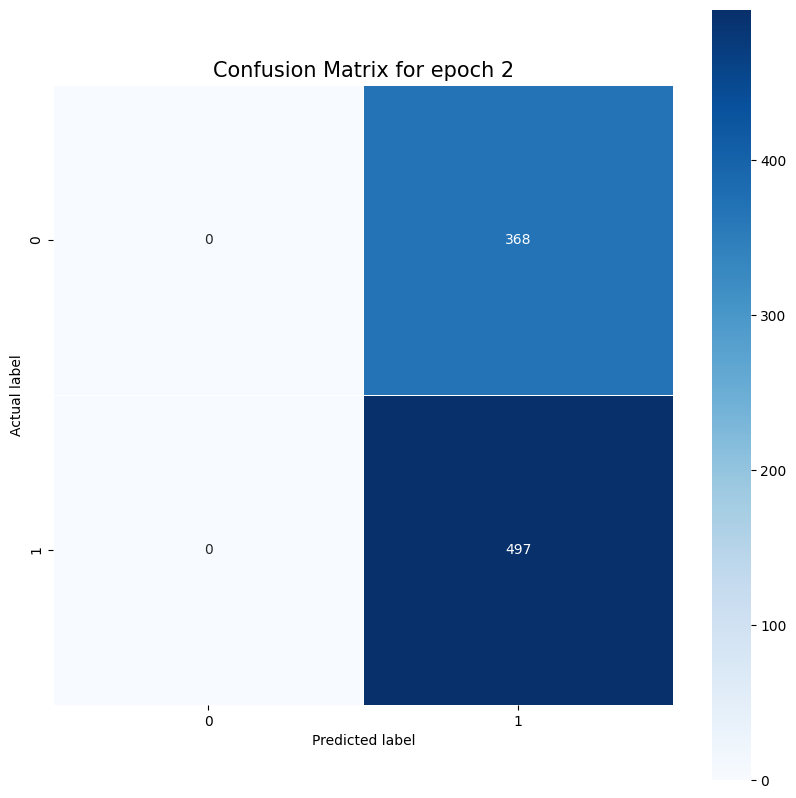

Epoch 3/10:   0%|          | 1/865 [00:04<1:02:48,  4.36s/it]

Accuracy of the model after epoch 3: 0.0%


Epoch 3/10:   0%|          | 2/865 [00:09<1:05:35,  4.56s/it]

Accuracy of the model after epoch 3: 0.0%


Epoch 3/10:   0%|          | 3/865 [00:13<1:03:53,  4.45s/it]

Accuracy of the model after epoch 3: 0.0%


Epoch 3/10:   0%|          | 4/865 [00:18<1:05:08,  4.54s/it]

Accuracy of the model after epoch 3: 25.0%


Epoch 3/10:   1%|          | 5/865 [00:22<1:04:26,  4.50s/it]

Accuracy of the model after epoch 3: 20.0%


Epoch 3/10:   1%|          | 6/865 [00:26<1:03:07,  4.41s/it]

Accuracy of the model after epoch 3: 33.333333333333336%


Epoch 3/10:   1%|          | 7/865 [00:30<1:02:14,  4.35s/it]

Accuracy of the model after epoch 3: 28.571428571428573%


Epoch 3/10:   1%|          | 8/865 [00:35<1:04:29,  4.52s/it]

Accuracy of the model after epoch 3: 37.5%


Epoch 3/10:   1%|          | 9/865 [00:40<1:04:22,  4.51s/it]

Accuracy of the model after epoch 3: 44.44444444444444%


Epoch 3/10:   1%|          | 10/865 [00:44<1:03:14,  4.44s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   1%|▏         | 11/865 [00:47<55:30,  3.90s/it]  

Accuracy of the model after epoch 3: 45.45454545454545%


Epoch 3/10:   1%|▏         | 12/865 [00:51<56:51,  4.00s/it]

Accuracy of the model after epoch 3: 41.666666666666664%


Epoch 3/10:   2%|▏         | 13/865 [00:56<1:01:07,  4.30s/it]

Accuracy of the model after epoch 3: 46.15384615384615%


Epoch 3/10:   2%|▏         | 14/865 [01:01<1:02:45,  4.43s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   2%|▏         | 15/865 [01:05<1:02:41,  4.43s/it]

Accuracy of the model after epoch 3: 53.333333333333336%


Epoch 3/10:   2%|▏         | 16/865 [01:10<1:02:41,  4.43s/it]

Accuracy of the model after epoch 3: 56.25%


Epoch 3/10:   2%|▏         | 17/865 [01:14<1:02:03,  4.39s/it]

Accuracy of the model after epoch 3: 58.8235294117647%


Epoch 3/10:   2%|▏         | 18/865 [01:18<1:02:32,  4.43s/it]

Accuracy of the model after epoch 3: 61.111111111111114%


Epoch 3/10:   2%|▏         | 19/865 [01:23<1:03:20,  4.49s/it]

Accuracy of the model after epoch 3: 63.1578947368421%


Epoch 3/10:   2%|▏         | 20/865 [01:27<1:02:40,  4.45s/it]

Accuracy of the model after epoch 3: 65.0%


Epoch 3/10:   2%|▏         | 21/865 [01:32<1:02:16,  4.43s/it]

Accuracy of the model after epoch 3: 61.904761904761905%


Epoch 3/10:   3%|▎         | 22/865 [01:36<1:01:23,  4.37s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:   3%|▎         | 23/865 [01:39<53:30,  3.81s/it]  

Accuracy of the model after epoch 3: 65.21739130434783%


Epoch 3/10:   3%|▎         | 24/865 [01:43<57:38,  4.11s/it]

Accuracy of the model after epoch 3: 62.5%


Epoch 3/10:   3%|▎         | 25/865 [01:48<58:14,  4.16s/it]

Accuracy of the model after epoch 3: 60.0%


Epoch 3/10:   3%|▎         | 26/865 [01:52<59:13,  4.23s/it]

Accuracy of the model after epoch 3: 57.69230769230769%


Epoch 3/10:   3%|▎         | 27/865 [01:56<59:59,  4.29s/it]

Accuracy of the model after epoch 3: 59.25925925925926%


Epoch 3/10:   3%|▎         | 28/865 [01:59<51:57,  3.72s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:   3%|▎         | 29/865 [02:03<55:12,  3.96s/it]

Accuracy of the model after epoch 3: 58.62068965517241%


Epoch 3/10:   3%|▎         | 30/865 [02:08<56:59,  4.10s/it]

Accuracy of the model after epoch 3: 56.666666666666664%


Epoch 3/10:   4%|▎         | 31/865 [02:10<50:08,  3.61s/it]

Accuracy of the model after epoch 3: 54.83870967741935%


Epoch 3/10:   4%|▎         | 32/865 [02:13<44:35,  3.21s/it]

Accuracy of the model after epoch 3: 53.125%


Epoch 3/10:   4%|▍         | 33/865 [02:17<49:09,  3.55s/it]

Accuracy of the model after epoch 3: 51.515151515151516%


Epoch 3/10:   4%|▍         | 34/865 [02:21<53:42,  3.88s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   4%|▍         | 35/865 [02:27<58:56,  4.26s/it]

Accuracy of the model after epoch 3: 51.42857142857143%


Epoch 3/10:   4%|▍         | 36/865 [02:31<1:00:54,  4.41s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   4%|▍         | 37/865 [02:36<59:50,  4.34s/it]  

Accuracy of the model after epoch 3: 51.351351351351354%


Epoch 3/10:   4%|▍         | 38/865 [02:38<52:16,  3.79s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   5%|▍         | 39/865 [02:43<55:30,  4.03s/it]

Accuracy of the model after epoch 3: 51.282051282051285%


Epoch 3/10:   5%|▍         | 40/865 [02:48<59:12,  4.31s/it]

Accuracy of the model after epoch 3: 52.5%


Epoch 3/10:   5%|▍         | 41/865 [02:52<59:34,  4.34s/it]

Accuracy of the model after epoch 3: 51.21951219512195%


Epoch 3/10:   5%|▍         | 42/865 [02:56<59:41,  4.35s/it]

Accuracy of the model after epoch 3: 52.38095238095238%


Epoch 3/10:   5%|▍         | 43/865 [03:01<1:01:20,  4.48s/it]

Accuracy of the model after epoch 3: 53.48837209302326%


Epoch 3/10:   5%|▌         | 44/865 [03:06<1:02:18,  4.55s/it]

Accuracy of the model after epoch 3: 52.27272727272727%


Epoch 3/10:   5%|▌         | 45/865 [03:09<54:13,  3.97s/it]  

Accuracy of the model after epoch 3: 53.333333333333336%


Epoch 3/10:   5%|▌         | 46/865 [03:13<57:27,  4.21s/it]

Accuracy of the model after epoch 3: 52.17391304347826%


Epoch 3/10:   5%|▌         | 47/865 [03:16<51:07,  3.75s/it]

Accuracy of the model after epoch 3: 53.191489361702125%


Epoch 3/10:   6%|▌         | 48/865 [03:20<53:07,  3.90s/it]

Accuracy of the model after epoch 3: 52.083333333333336%


Epoch 3/10:   6%|▌         | 49/865 [03:25<56:27,  4.15s/it]

Accuracy of the model after epoch 3: 51.02040816326531%


Epoch 3/10:   6%|▌         | 50/865 [03:27<49:17,  3.63s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   6%|▌         | 51/865 [03:32<51:58,  3.83s/it]

Accuracy of the model after epoch 3: 50.98039215686274%


Epoch 3/10:   6%|▌         | 52/865 [03:36<55:06,  4.07s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   6%|▌         | 53/865 [03:41<55:41,  4.12s/it]

Accuracy of the model after epoch 3: 50.943396226415096%


Epoch 3/10:   6%|▌         | 54/865 [03:43<49:52,  3.69s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:   6%|▋         | 55/865 [03:46<44:34,  3.30s/it]

Accuracy of the model after epoch 3: 49.09090909090909%


Epoch 3/10:   6%|▋         | 56/865 [03:50<49:31,  3.67s/it]

Accuracy of the model after epoch 3: 48.214285714285715%


Epoch 3/10:   7%|▋         | 57/865 [03:55<52:22,  3.89s/it]

Accuracy of the model after epoch 3: 47.36842105263158%


Epoch 3/10:   7%|▋         | 58/865 [03:59<54:12,  4.03s/it]

Accuracy of the model after epoch 3: 48.275862068965516%


Epoch 3/10:   7%|▋         | 59/865 [04:04<56:58,  4.24s/it]

Accuracy of the model after epoch 3: 49.152542372881356%


Epoch 3/10:   7%|▋         | 60/865 [04:08<57:37,  4.29s/it]

Accuracy of the model after epoch 3: 48.333333333333336%


Epoch 3/10:   7%|▋         | 61/865 [04:11<50:52,  3.80s/it]

Accuracy of the model after epoch 3: 47.540983606557376%


Epoch 3/10:   7%|▋         | 62/865 [04:13<45:06,  3.37s/it]

Accuracy of the model after epoch 3: 46.774193548387096%


Epoch 3/10:   7%|▋         | 63/865 [04:18<50:46,  3.80s/it]

Accuracy of the model after epoch 3: 46.03174603174603%


Epoch 3/10:   7%|▋         | 64/865 [04:23<54:27,  4.08s/it]

Accuracy of the model after epoch 3: 46.875%


Epoch 3/10:   8%|▊         | 65/865 [04:25<46:42,  3.50s/it]

Accuracy of the model after epoch 3: 46.15384615384615%


Epoch 3/10:   8%|▊         | 66/865 [04:29<49:54,  3.75s/it]

Accuracy of the model after epoch 3: 46.96969696969697%


Epoch 3/10:   8%|▊         | 67/865 [04:33<51:33,  3.88s/it]

Accuracy of the model after epoch 3: 47.76119402985075%


Epoch 3/10:   8%|▊         | 68/865 [04:38<54:01,  4.07s/it]

Accuracy of the model after epoch 3: 48.529411764705884%


Epoch 3/10:   8%|▊         | 69/865 [04:42<56:24,  4.25s/it]

Accuracy of the model after epoch 3: 47.82608695652174%


Epoch 3/10:   8%|▊         | 70/865 [04:47<56:06,  4.23s/it]

Accuracy of the model after epoch 3: 47.142857142857146%


Epoch 3/10:   8%|▊         | 71/865 [04:51<56:02,  4.24s/it]

Accuracy of the model after epoch 3: 47.88732394366197%


Epoch 3/10:   8%|▊         | 72/865 [04:55<55:59,  4.24s/it]

Accuracy of the model after epoch 3: 47.22222222222222%


Epoch 3/10:   8%|▊         | 73/865 [04:58<48:36,  3.68s/it]

Accuracy of the model after epoch 3: 47.945205479452056%


Epoch 3/10:   9%|▊         | 74/865 [05:00<44:48,  3.40s/it]

Accuracy of the model after epoch 3: 47.2972972972973%


Epoch 3/10:   9%|▊         | 75/865 [05:03<41:18,  3.14s/it]

Accuracy of the model after epoch 3: 48.0%


Epoch 3/10:   9%|▉         | 76/865 [05:05<37:58,  2.89s/it]

Accuracy of the model after epoch 3: 48.68421052631579%


Epoch 3/10:   9%|▉         | 77/865 [05:09<43:31,  3.31s/it]

Accuracy of the model after epoch 3: 48.05194805194805%


Epoch 3/10:   9%|▉         | 78/865 [05:14<48:12,  3.68s/it]

Accuracy of the model after epoch 3: 47.43589743589744%


Epoch 3/10:   9%|▉         | 79/865 [05:19<52:14,  3.99s/it]

Accuracy of the model after epoch 3: 46.835443037974684%


Epoch 3/10:   9%|▉         | 80/865 [05:23<54:00,  4.13s/it]

Accuracy of the model after epoch 3: 46.25%


Epoch 3/10:   9%|▉         | 81/865 [05:28<56:28,  4.32s/it]

Accuracy of the model after epoch 3: 45.67901234567901%


Epoch 3/10:   9%|▉         | 82/865 [05:30<48:29,  3.72s/it]

Accuracy of the model after epoch 3: 45.1219512195122%


Epoch 3/10:  10%|▉         | 83/865 [05:35<51:29,  3.95s/it]

Accuracy of the model after epoch 3: 45.78313253012048%


Epoch 3/10:  10%|▉         | 84/865 [05:39<54:35,  4.19s/it]

Accuracy of the model after epoch 3: 45.23809523809524%


Epoch 3/10:  10%|▉         | 85/865 [05:42<47:40,  3.67s/it]

Accuracy of the model after epoch 3: 44.705882352941174%


Epoch 3/10:  10%|▉         | 86/865 [05:44<42:18,  3.26s/it]

Accuracy of the model after epoch 3: 45.348837209302324%


Epoch 3/10:  10%|█         | 87/865 [05:48<46:14,  3.57s/it]

Accuracy of the model after epoch 3: 45.97701149425287%


Epoch 3/10:  10%|█         | 88/865 [05:53<49:04,  3.79s/it]

Accuracy of the model after epoch 3: 46.59090909090909%


Epoch 3/10:  10%|█         | 89/865 [05:57<52:13,  4.04s/it]

Accuracy of the model after epoch 3: 46.06741573033708%


Epoch 3/10:  10%|█         | 90/865 [06:02<52:36,  4.07s/it]

Accuracy of the model after epoch 3: 46.666666666666664%


Epoch 3/10:  11%|█         | 91/865 [06:06<53:26,  4.14s/it]

Accuracy of the model after epoch 3: 47.252747252747255%


Epoch 3/10:  11%|█         | 92/865 [06:10<54:17,  4.21s/it]

Accuracy of the model after epoch 3: 47.82608695652174%


Epoch 3/10:  11%|█         | 93/865 [06:15<54:41,  4.25s/it]

Accuracy of the model after epoch 3: 47.31182795698925%


Epoch 3/10:  11%|█         | 94/865 [06:17<48:16,  3.76s/it]

Accuracy of the model after epoch 3: 47.87234042553192%


Epoch 3/10:  11%|█         | 95/865 [06:22<50:50,  3.96s/it]

Accuracy of the model after epoch 3: 47.36842105263158%


Epoch 3/10:  11%|█         | 96/865 [06:26<52:21,  4.08s/it]

Accuracy of the model after epoch 3: 46.875%


Epoch 3/10:  11%|█         | 97/865 [06:31<54:41,  4.27s/it]

Accuracy of the model after epoch 3: 47.422680412371136%


Epoch 3/10:  11%|█▏        | 98/865 [06:35<55:57,  4.38s/it]

Accuracy of the model after epoch 3: 47.95918367346939%


Epoch 3/10:  11%|█▏        | 99/865 [06:40<55:57,  4.38s/it]

Accuracy of the model after epoch 3: 48.484848484848484%


Epoch 3/10:  12%|█▏        | 100/865 [06:44<55:25,  4.35s/it]

Accuracy of the model after epoch 3: 48.0%


Epoch 3/10:  12%|█▏        | 101/865 [06:48<55:45,  4.38s/it]

Accuracy of the model after epoch 3: 48.51485148514851%


Epoch 3/10:  12%|█▏        | 102/865 [06:53<55:36,  4.37s/it]

Accuracy of the model after epoch 3: 48.03921568627451%


Epoch 3/10:  12%|█▏        | 103/865 [06:55<48:06,  3.79s/it]

Accuracy of the model after epoch 3: 48.54368932038835%


Epoch 3/10:  12%|█▏        | 104/865 [07:00<52:50,  4.17s/it]

Accuracy of the model after epoch 3: 48.07692307692308%


Epoch 3/10:  12%|█▏        | 105/865 [07:05<53:23,  4.22s/it]

Accuracy of the model after epoch 3: 48.57142857142857%


Epoch 3/10:  12%|█▏        | 106/865 [07:07<46:35,  3.68s/it]

Accuracy of the model after epoch 3: 49.056603773584904%


Epoch 3/10:  12%|█▏        | 107/865 [07:11<48:42,  3.86s/it]

Accuracy of the model after epoch 3: 48.598130841121495%


Epoch 3/10:  12%|█▏        | 108/865 [07:16<52:13,  4.14s/it]

Accuracy of the model after epoch 3: 48.148148148148145%


Epoch 3/10:  13%|█▎        | 109/865 [07:21<53:38,  4.26s/it]

Accuracy of the model after epoch 3: 47.706422018348626%


Epoch 3/10:  13%|█▎        | 110/865 [07:25<54:43,  4.35s/it]

Accuracy of the model after epoch 3: 47.27272727272727%


Epoch 3/10:  13%|█▎        | 111/865 [07:30<55:04,  4.38s/it]

Accuracy of the model after epoch 3: 46.846846846846844%


Epoch 3/10:  13%|█▎        | 112/865 [07:32<47:49,  3.81s/it]

Accuracy of the model after epoch 3: 47.32142857142857%


Epoch 3/10:  13%|█▎        | 113/865 [07:35<43:00,  3.43s/it]

Accuracy of the model after epoch 3: 46.902654867256636%


Epoch 3/10:  13%|█▎        | 114/865 [07:37<39:44,  3.17s/it]

Accuracy of the model after epoch 3: 47.36842105263158%


Epoch 3/10:  13%|█▎        | 115/865 [07:42<45:54,  3.67s/it]

Accuracy of the model after epoch 3: 46.95652173913044%


Epoch 3/10:  13%|█▎        | 116/865 [07:47<49:09,  3.94s/it]

Accuracy of the model after epoch 3: 46.55172413793103%


Epoch 3/10:  14%|█▎        | 117/865 [07:51<50:37,  4.06s/it]

Accuracy of the model after epoch 3: 47.00854700854701%


Epoch 3/10:  14%|█▎        | 118/865 [07:55<51:23,  4.13s/it]

Accuracy of the model after epoch 3: 46.610169491525426%


Epoch 3/10:  14%|█▍        | 119/865 [07:58<45:30,  3.66s/it]

Accuracy of the model after epoch 3: 46.21848739495798%


Epoch 3/10:  14%|█▍        | 120/865 [08:02<48:49,  3.93s/it]

Accuracy of the model after epoch 3: 45.833333333333336%


Epoch 3/10:  14%|█▍        | 121/865 [08:07<50:03,  4.04s/it]

Accuracy of the model after epoch 3: 45.45454545454545%


Epoch 3/10:  14%|█▍        | 122/865 [08:11<51:08,  4.13s/it]

Accuracy of the model after epoch 3: 45.90163934426229%


Epoch 3/10:  14%|█▍        | 123/865 [08:14<45:08,  3.65s/it]

Accuracy of the model after epoch 3: 46.34146341463415%


Epoch 3/10:  14%|█▍        | 124/865 [08:18<48:51,  3.96s/it]

Accuracy of the model after epoch 3: 46.774193548387096%


Epoch 3/10:  14%|█▍        | 125/865 [08:21<44:04,  3.57s/it]

Accuracy of the model after epoch 3: 47.2%


Epoch 3/10:  15%|█▍        | 126/865 [08:26<47:54,  3.89s/it]

Accuracy of the model after epoch 3: 46.82539682539682%


Epoch 3/10:  15%|█▍        | 127/865 [08:30<50:50,  4.13s/it]

Accuracy of the model after epoch 3: 47.24409448818898%


Epoch 3/10:  15%|█▍        | 128/865 [08:35<51:34,  4.20s/it]

Accuracy of the model after epoch 3: 47.65625%


Epoch 3/10:  15%|█▍        | 129/865 [08:37<46:00,  3.75s/it]

Accuracy of the model after epoch 3: 48.06201550387597%


Epoch 3/10:  15%|█▌        | 130/865 [08:40<41:17,  3.37s/it]

Accuracy of the model after epoch 3: 48.46153846153846%


Epoch 3/10:  15%|█▌        | 131/865 [08:44<45:01,  3.68s/it]

Accuracy of the model after epoch 3: 48.85496183206107%


Epoch 3/10:  15%|█▌        | 132/865 [08:48<46:58,  3.84s/it]

Accuracy of the model after epoch 3: 48.484848484848484%


Epoch 3/10:  15%|█▌        | 133/865 [08:51<42:22,  3.47s/it]

Accuracy of the model after epoch 3: 48.87218045112782%


Epoch 3/10:  15%|█▌        | 134/865 [08:54<38:47,  3.18s/it]

Accuracy of the model after epoch 3: 49.25373134328358%


Epoch 3/10:  16%|█▌        | 135/865 [08:58<42:32,  3.50s/it]

Accuracy of the model after epoch 3: 49.629629629629626%


Epoch 3/10:  16%|█▌        | 136/865 [09:02<47:03,  3.87s/it]

Accuracy of the model after epoch 3: 50.0%


Epoch 3/10:  16%|█▌        | 137/865 [09:07<47:46,  3.94s/it]

Accuracy of the model after epoch 3: 50.36496350364963%


Epoch 3/10:  16%|█▌        | 138/865 [09:09<42:02,  3.47s/it]

Accuracy of the model after epoch 3: 50.72463768115942%


Epoch 3/10:  16%|█▌        | 139/865 [09:14<46:11,  3.82s/it]

Accuracy of the model after epoch 3: 50.35971223021583%


Epoch 3/10:  16%|█▌        | 140/865 [09:18<48:42,  4.03s/it]

Accuracy of the model after epoch 3: 50.714285714285715%


Epoch 3/10:  16%|█▋        | 141/865 [09:23<49:58,  4.14s/it]

Accuracy of the model after epoch 3: 51.06382978723404%


Epoch 3/10:  16%|█▋        | 142/865 [09:27<51:02,  4.24s/it]

Accuracy of the model after epoch 3: 50.70422535211268%


Epoch 3/10:  17%|█▋        | 143/865 [09:31<51:10,  4.25s/it]

Accuracy of the model after epoch 3: 51.04895104895105%


Epoch 3/10:  17%|█▋        | 144/865 [09:36<53:18,  4.44s/it]

Accuracy of the model after epoch 3: 50.69444444444444%


Epoch 3/10:  17%|█▋        | 145/865 [09:38<45:21,  3.78s/it]

Accuracy of the model after epoch 3: 51.03448275862069%


Epoch 3/10:  17%|█▋        | 146/865 [09:41<41:15,  3.44s/it]

Accuracy of the model after epoch 3: 51.36986301369863%


Epoch 3/10:  17%|█▋        | 147/865 [09:46<46:27,  3.88s/it]

Accuracy of the model after epoch 3: 51.70068027210884%


Epoch 3/10:  17%|█▋        | 148/865 [09:50<48:19,  4.04s/it]

Accuracy of the model after epoch 3: 51.351351351351354%


Epoch 3/10:  17%|█▋        | 149/865 [09:55<49:27,  4.15s/it]

Accuracy of the model after epoch 3: 51.67785234899329%


Epoch 3/10:  17%|█▋        | 150/865 [09:59<49:43,  4.17s/it]

Accuracy of the model after epoch 3: 51.333333333333336%


Epoch 3/10:  17%|█▋        | 151/865 [10:03<50:35,  4.25s/it]

Accuracy of the model after epoch 3: 50.99337748344371%


Epoch 3/10:  18%|█▊        | 152/865 [10:08<51:06,  4.30s/it]

Accuracy of the model after epoch 3: 51.31578947368421%


Epoch 3/10:  18%|█▊        | 153/865 [10:13<53:03,  4.47s/it]

Accuracy of the model after epoch 3: 50.98039215686274%


Epoch 3/10:  18%|█▊        | 154/865 [10:17<53:31,  4.52s/it]

Accuracy of the model after epoch 3: 51.298701298701296%


Epoch 3/10:  18%|█▊        | 155/865 [10:22<53:07,  4.49s/it]

Accuracy of the model after epoch 3: 50.96774193548387%


Epoch 3/10:  18%|█▊        | 156/865 [10:24<45:59,  3.89s/it]

Accuracy of the model after epoch 3: 50.64102564102564%


Epoch 3/10:  18%|█▊        | 157/865 [10:29<48:04,  4.07s/it]

Accuracy of the model after epoch 3: 50.955414012738856%


Epoch 3/10:  18%|█▊        | 158/865 [10:33<49:35,  4.21s/it]

Accuracy of the model after epoch 3: 50.63291139240506%


Epoch 3/10:  18%|█▊        | 159/865 [10:38<51:07,  4.35s/it]

Accuracy of the model after epoch 3: 50.943396226415096%


Epoch 3/10:  18%|█▊        | 160/865 [10:40<44:20,  3.77s/it]

Accuracy of the model after epoch 3: 51.25%


Epoch 3/10:  19%|█▊        | 161/865 [10:45<47:39,  4.06s/it]

Accuracy of the model after epoch 3: 51.5527950310559%


Epoch 3/10:  19%|█▊        | 162/865 [10:49<48:02,  4.10s/it]

Accuracy of the model after epoch 3: 51.23456790123457%


Epoch 3/10:  19%|█▉        | 163/865 [10:54<50:05,  4.28s/it]

Accuracy of the model after epoch 3: 50.920245398773005%


Epoch 3/10:  19%|█▉        | 164/865 [10:59<50:52,  4.35s/it]

Accuracy of the model after epoch 3: 51.21951219512195%


Epoch 3/10:  19%|█▉        | 165/865 [11:01<44:44,  3.83s/it]

Accuracy of the model after epoch 3: 50.90909090909091%


Epoch 3/10:  19%|█▉        | 166/865 [11:03<38:51,  3.33s/it]

Accuracy of the model after epoch 3: 51.204819277108435%


Epoch 3/10:  19%|█▉        | 167/865 [11:08<43:36,  3.75s/it]

Accuracy of the model after epoch 3: 50.89820359281437%


Epoch 3/10:  19%|█▉        | 168/865 [11:13<47:20,  4.07s/it]

Accuracy of the model after epoch 3: 51.19047619047619%


Epoch 3/10:  20%|█▉        | 169/865 [11:17<49:12,  4.24s/it]

Accuracy of the model after epoch 3: 50.887573964497044%


Epoch 3/10:  20%|█▉        | 170/865 [11:22<49:07,  4.24s/it]

Accuracy of the model after epoch 3: 51.1764705882353%


Epoch 3/10:  20%|█▉        | 171/865 [11:26<49:15,  4.26s/it]

Accuracy of the model after epoch 3: 51.461988304093566%


Epoch 3/10:  20%|█▉        | 172/865 [11:31<50:00,  4.33s/it]

Accuracy of the model after epoch 3: 51.16279069767442%


Epoch 3/10:  20%|██        | 173/865 [11:35<50:19,  4.36s/it]

Accuracy of the model after epoch 3: 51.445086705202314%


Epoch 3/10:  20%|██        | 174/865 [11:40<50:54,  4.42s/it]

Accuracy of the model after epoch 3: 51.724137931034484%


Epoch 3/10:  20%|██        | 175/865 [11:44<50:38,  4.40s/it]

Accuracy of the model after epoch 3: 51.42857142857143%


Epoch 3/10:  20%|██        | 176/865 [11:48<49:46,  4.33s/it]

Accuracy of the model after epoch 3: 51.70454545454545%


Epoch 3/10:  20%|██        | 177/865 [11:53<52:33,  4.58s/it]

Accuracy of the model after epoch 3: 51.9774011299435%


Epoch 3/10:  21%|██        | 178/865 [11:56<44:35,  3.89s/it]

Accuracy of the model after epoch 3: 52.247191011235955%


Epoch 3/10:  21%|██        | 179/865 [12:00<46:57,  4.11s/it]

Accuracy of the model after epoch 3: 52.513966480446925%


Epoch 3/10:  21%|██        | 180/865 [12:04<47:16,  4.14s/it]

Accuracy of the model after epoch 3: 52.77777777777778%


Epoch 3/10:  21%|██        | 181/865 [12:07<41:03,  3.60s/it]

Accuracy of the model after epoch 3: 53.03867403314917%


Epoch 3/10:  21%|██        | 182/865 [12:11<43:49,  3.85s/it]

Accuracy of the model after epoch 3: 52.747252747252745%


Epoch 3/10:  21%|██        | 183/865 [12:16<47:59,  4.22s/it]

Accuracy of the model after epoch 3: 52.459016393442624%


Epoch 3/10:  21%|██▏       | 184/865 [12:19<42:24,  3.74s/it]

Accuracy of the model after epoch 3: 52.71739130434783%


Epoch 3/10:  21%|██▏       | 185/865 [12:23<44:32,  3.93s/it]

Accuracy of the model after epoch 3: 52.972972972972975%


Epoch 3/10:  22%|██▏       | 186/865 [12:25<38:29,  3.40s/it]

Accuracy of the model after epoch 3: 53.225806451612904%


Epoch 3/10:  22%|██▏       | 187/865 [12:30<40:59,  3.63s/it]

Accuracy of the model after epoch 3: 53.475935828877006%


Epoch 3/10:  22%|██▏       | 188/865 [12:34<43:22,  3.84s/it]

Accuracy of the model after epoch 3: 53.723404255319146%


Epoch 3/10:  22%|██▏       | 189/865 [12:37<39:38,  3.52s/it]

Accuracy of the model after epoch 3: 53.439153439153436%


Epoch 3/10:  22%|██▏       | 190/865 [12:41<42:03,  3.74s/it]

Accuracy of the model after epoch 3: 53.68421052631579%


Epoch 3/10:  22%|██▏       | 191/865 [12:43<37:28,  3.34s/it]

Accuracy of the model after epoch 3: 53.92670157068063%


Epoch 3/10:  22%|██▏       | 192/865 [12:48<41:13,  3.68s/it]

Accuracy of the model after epoch 3: 53.645833333333336%


Epoch 3/10:  22%|██▏       | 193/865 [12:53<45:04,  4.02s/it]

Accuracy of the model after epoch 3: 53.8860103626943%


Epoch 3/10:  22%|██▏       | 194/865 [12:55<40:25,  3.61s/it]

Accuracy of the model after epoch 3: 54.123711340206185%


Epoch 3/10:  23%|██▎       | 195/865 [12:59<42:18,  3.79s/it]

Accuracy of the model after epoch 3: 53.84615384615385%


Epoch 3/10:  23%|██▎       | 196/865 [13:04<43:52,  3.94s/it]

Accuracy of the model after epoch 3: 54.08163265306123%


Epoch 3/10:  23%|██▎       | 197/865 [13:08<46:32,  4.18s/it]

Accuracy of the model after epoch 3: 53.807106598984774%


Epoch 3/10:  23%|██▎       | 198/865 [13:11<40:21,  3.63s/it]

Accuracy of the model after epoch 3: 53.535353535353536%


Epoch 3/10:  23%|██▎       | 199/865 [13:13<37:10,  3.35s/it]

Accuracy of the model after epoch 3: 53.768844221105525%


Epoch 3/10:  23%|██▎       | 200/865 [13:18<40:33,  3.66s/it]

Accuracy of the model after epoch 3: 53.5%


Epoch 3/10:  23%|██▎       | 201/865 [13:22<42:35,  3.85s/it]

Accuracy of the model after epoch 3: 53.73134328358209%


Epoch 3/10:  23%|██▎       | 202/865 [13:26<43:44,  3.96s/it]

Accuracy of the model after epoch 3: 53.46534653465346%


Epoch 3/10:  23%|██▎       | 203/865 [13:29<38:22,  3.48s/it]

Accuracy of the model after epoch 3: 53.69458128078818%


Epoch 3/10:  24%|██▎       | 204/865 [13:33<41:50,  3.80s/it]

Accuracy of the model after epoch 3: 53.92156862745098%


Epoch 3/10:  24%|██▎       | 205/865 [13:38<43:31,  3.96s/it]

Accuracy of the model after epoch 3: 54.146341463414636%


Epoch 3/10:  24%|██▍       | 206/865 [13:40<38:19,  3.49s/it]

Accuracy of the model after epoch 3: 54.36893203883495%


Epoch 3/10:  24%|██▍       | 207/865 [13:44<41:31,  3.79s/it]

Accuracy of the model after epoch 3: 54.106280193236714%


Epoch 3/10:  24%|██▍       | 208/865 [13:47<36:15,  3.31s/it]

Accuracy of the model after epoch 3: 54.32692307692308%


Epoch 3/10:  24%|██▍       | 209/865 [13:51<40:27,  3.70s/it]

Accuracy of the model after epoch 3: 54.066985645933016%


Epoch 3/10:  24%|██▍       | 210/865 [13:56<43:02,  3.94s/it]

Accuracy of the model after epoch 3: 53.80952380952381%


Epoch 3/10:  24%|██▍       | 211/865 [14:00<44:43,  4.10s/it]

Accuracy of the model after epoch 3: 53.55450236966825%


Epoch 3/10:  25%|██▍       | 212/865 [14:03<39:37,  3.64s/it]

Accuracy of the model after epoch 3: 53.301886792452834%


Epoch 3/10:  25%|██▍       | 213/865 [14:07<42:41,  3.93s/it]

Accuracy of the model after epoch 3: 53.051643192488264%


Epoch 3/10:  25%|██▍       | 214/865 [14:12<44:23,  4.09s/it]

Accuracy of the model after epoch 3: 53.271028037383175%


Epoch 3/10:  25%|██▍       | 215/865 [14:17<45:59,  4.25s/it]

Accuracy of the model after epoch 3: 53.02325581395349%


Epoch 3/10:  25%|██▍       | 216/865 [14:21<46:02,  4.26s/it]

Accuracy of the model after epoch 3: 53.24074074074074%


Epoch 3/10:  25%|██▌       | 217/865 [14:26<47:59,  4.44s/it]

Accuracy of the model after epoch 3: 53.45622119815668%


Epoch 3/10:  25%|██▌       | 218/865 [14:31<49:17,  4.57s/it]

Accuracy of the model after epoch 3: 53.211009174311926%


Epoch 3/10:  25%|██▌       | 219/865 [14:36<51:40,  4.80s/it]

Accuracy of the model after epoch 3: 53.42465753424658%


Epoch 3/10:  25%|██▌       | 220/865 [14:40<49:59,  4.65s/it]

Accuracy of the model after epoch 3: 53.63636363636363%


Epoch 3/10:  26%|██▌       | 221/865 [14:45<48:56,  4.56s/it]

Accuracy of the model after epoch 3: 53.39366515837104%


Epoch 3/10:  26%|██▌       | 222/865 [14:49<47:08,  4.40s/it]

Accuracy of the model after epoch 3: 53.6036036036036%


Epoch 3/10:  26%|██▌       | 223/865 [14:53<46:46,  4.37s/it]

Accuracy of the model after epoch 3: 53.36322869955157%


Epoch 3/10:  26%|██▌       | 224/865 [14:57<47:29,  4.45s/it]

Accuracy of the model after epoch 3: 53.57142857142857%


Epoch 3/10:  26%|██▌       | 225/865 [15:00<40:56,  3.84s/it]

Accuracy of the model after epoch 3: 53.333333333333336%


Epoch 3/10:  26%|██▌       | 226/865 [15:04<43:00,  4.04s/it]

Accuracy of the model after epoch 3: 53.53982300884956%


Epoch 3/10:  26%|██▌       | 227/865 [15:07<38:15,  3.60s/it]

Accuracy of the model after epoch 3: 53.30396475770925%


Epoch 3/10:  26%|██▋       | 228/865 [15:09<34:43,  3.27s/it]

Accuracy of the model after epoch 3: 53.07017543859649%


Epoch 3/10:  26%|██▋       | 229/865 [15:14<39:59,  3.77s/it]

Accuracy of the model after epoch 3: 52.838427947598255%


Epoch 3/10:  27%|██▋       | 230/865 [15:19<41:49,  3.95s/it]

Accuracy of the model after epoch 3: 52.608695652173914%


Epoch 3/10:  27%|██▋       | 231/865 [15:23<42:31,  4.02s/it]

Accuracy of the model after epoch 3: 52.81385281385281%


Epoch 3/10:  27%|██▋       | 232/865 [15:25<37:35,  3.56s/it]

Accuracy of the model after epoch 3: 53.01724137931034%


Epoch 3/10:  27%|██▋       | 233/865 [15:30<39:37,  3.76s/it]

Accuracy of the model after epoch 3: 53.21888412017167%


Epoch 3/10:  27%|██▋       | 234/865 [15:32<35:26,  3.37s/it]

Accuracy of the model after epoch 3: 53.41880341880342%


Epoch 3/10:  27%|██▋       | 235/865 [15:37<40:05,  3.82s/it]

Accuracy of the model after epoch 3: 53.191489361702125%


Epoch 3/10:  27%|██▋       | 236/865 [15:39<35:28,  3.38s/it]

Accuracy of the model after epoch 3: 53.389830508474574%


Epoch 3/10:  27%|██▋       | 237/865 [15:44<37:54,  3.62s/it]

Accuracy of the model after epoch 3: 53.586497890295355%


Epoch 3/10:  28%|██▊       | 238/865 [15:48<40:29,  3.87s/it]

Accuracy of the model after epoch 3: 53.36134453781513%


Epoch 3/10:  28%|██▊       | 239/865 [15:52<41:57,  4.02s/it]

Accuracy of the model after epoch 3: 53.55648535564853%


Epoch 3/10:  28%|██▊       | 240/865 [15:55<36:48,  3.53s/it]

Accuracy of the model after epoch 3: 53.75%


Epoch 3/10:  28%|██▊       | 241/865 [15:59<39:41,  3.82s/it]

Accuracy of the model after epoch 3: 53.941908713692946%


Epoch 3/10:  28%|██▊       | 242/865 [16:02<34:58,  3.37s/it]

Accuracy of the model after epoch 3: 53.71900826446281%


Epoch 3/10:  28%|██▊       | 243/865 [16:06<37:52,  3.65s/it]

Accuracy of the model after epoch 3: 53.90946502057613%


Epoch 3/10:  28%|██▊       | 244/865 [16:11<41:38,  4.02s/it]

Accuracy of the model after epoch 3: 53.68852459016394%


Epoch 3/10:  28%|██▊       | 245/865 [16:16<43:48,  4.24s/it]

Accuracy of the model after epoch 3: 53.46938775510204%


Epoch 3/10:  28%|██▊       | 246/865 [16:18<38:03,  3.69s/it]

Accuracy of the model after epoch 3: 53.2520325203252%


Epoch 3/10:  29%|██▊       | 247/865 [16:22<40:04,  3.89s/it]

Accuracy of the model after epoch 3: 53.441295546558706%


Epoch 3/10:  29%|██▊       | 248/865 [16:25<35:32,  3.46s/it]

Accuracy of the model after epoch 3: 53.225806451612904%


Epoch 3/10:  29%|██▉       | 249/865 [16:27<33:09,  3.23s/it]

Accuracy of the model after epoch 3: 53.01204819277108%


Epoch 3/10:  29%|██▉       | 250/865 [16:32<36:25,  3.55s/it]

Accuracy of the model after epoch 3: 53.2%


Epoch 3/10:  29%|██▉       | 251/865 [16:34<32:05,  3.14s/it]

Accuracy of the model after epoch 3: 53.386454183266935%


Epoch 3/10:  29%|██▉       | 252/865 [16:38<35:20,  3.46s/it]

Accuracy of the model after epoch 3: 53.57142857142857%


Epoch 3/10:  29%|██▉       | 253/865 [16:43<38:10,  3.74s/it]

Accuracy of the model after epoch 3: 53.75494071146245%


Epoch 3/10:  29%|██▉       | 254/865 [16:47<40:47,  4.01s/it]

Accuracy of the model after epoch 3: 53.93700787401575%


Epoch 3/10:  29%|██▉       | 255/865 [16:52<41:59,  4.13s/it]

Accuracy of the model after epoch 3: 54.11764705882353%


Epoch 3/10:  30%|██▉       | 256/865 [16:56<42:49,  4.22s/it]

Accuracy of the model after epoch 3: 53.90625%


Epoch 3/10:  30%|██▉       | 257/865 [17:01<44:38,  4.41s/it]

Accuracy of the model after epoch 3: 53.69649805447471%


Epoch 3/10:  30%|██▉       | 258/865 [17:03<38:08,  3.77s/it]

Accuracy of the model after epoch 3: 53.87596899224806%


Epoch 3/10:  30%|██▉       | 259/865 [17:08<40:20,  3.99s/it]

Accuracy of the model after epoch 3: 54.054054054054056%


Epoch 3/10:  30%|███       | 260/865 [17:12<41:19,  4.10s/it]

Accuracy of the model after epoch 3: 53.84615384615385%


Epoch 3/10:  30%|███       | 261/865 [17:16<41:34,  4.13s/it]

Accuracy of the model after epoch 3: 54.02298850574713%


Epoch 3/10:  30%|███       | 262/865 [17:20<41:36,  4.14s/it]

Accuracy of the model after epoch 3: 54.19847328244275%


Epoch 3/10:  30%|███       | 263/865 [17:25<42:33,  4.24s/it]

Accuracy of the model after epoch 3: 54.372623574144484%


Epoch 3/10:  31%|███       | 264/865 [17:30<43:50,  4.38s/it]

Accuracy of the model after epoch 3: 54.54545454545455%


Epoch 3/10:  31%|███       | 265/865 [17:34<43:25,  4.34s/it]

Accuracy of the model after epoch 3: 54.716981132075475%


Epoch 3/10:  31%|███       | 266/865 [17:36<38:15,  3.83s/it]

Accuracy of the model after epoch 3: 54.88721804511278%


Epoch 3/10:  31%|███       | 267/865 [17:41<40:02,  4.02s/it]

Accuracy of the model after epoch 3: 55.056179775280896%


Epoch 3/10:  31%|███       | 268/865 [17:46<42:08,  4.24s/it]

Accuracy of the model after epoch 3: 55.223880597014926%


Epoch 3/10:  31%|███       | 269/865 [17:48<36:54,  3.72s/it]

Accuracy of the model after epoch 3: 55.01858736059479%


Epoch 3/10:  31%|███       | 270/865 [17:53<39:29,  3.98s/it]

Accuracy of the model after epoch 3: 55.18518518518518%


Epoch 3/10:  31%|███▏      | 271/865 [17:57<40:08,  4.06s/it]

Accuracy of the model after epoch 3: 55.35055350553505%


Epoch 3/10:  31%|███▏      | 272/865 [18:01<40:52,  4.14s/it]

Accuracy of the model after epoch 3: 55.51470588235294%


Epoch 3/10:  32%|███▏      | 273/865 [18:06<41:15,  4.18s/it]

Accuracy of the model after epoch 3: 55.311355311355314%


Epoch 3/10:  32%|███▏      | 274/865 [18:08<36:39,  3.72s/it]

Accuracy of the model after epoch 3: 55.47445255474452%


Epoch 3/10:  32%|███▏      | 275/865 [18:13<38:37,  3.93s/it]

Accuracy of the model after epoch 3: 55.63636363636363%


Epoch 3/10:  32%|███▏      | 276/865 [18:17<39:19,  4.01s/it]

Accuracy of the model after epoch 3: 55.79710144927536%


Epoch 3/10:  32%|███▏      | 277/865 [18:21<39:51,  4.07s/it]

Accuracy of the model after epoch 3: 55.5956678700361%


Epoch 3/10:  32%|███▏      | 278/865 [18:24<35:14,  3.60s/it]

Accuracy of the model after epoch 3: 55.75539568345324%


Epoch 3/10:  32%|███▏      | 279/865 [18:28<38:24,  3.93s/it]

Accuracy of the model after epoch 3: 55.55555555555556%


Epoch 3/10:  32%|███▏      | 280/865 [18:33<40:00,  4.10s/it]

Accuracy of the model after epoch 3: 55.357142857142854%


Epoch 3/10:  32%|███▏      | 281/865 [18:37<41:05,  4.22s/it]

Accuracy of the model after epoch 3: 55.16014234875445%


Epoch 3/10:  33%|███▎      | 282/865 [18:42<41:49,  4.30s/it]

Accuracy of the model after epoch 3: 55.319148936170215%


Epoch 3/10:  33%|███▎      | 283/865 [18:44<36:42,  3.78s/it]

Accuracy of the model after epoch 3: 55.12367491166078%


Epoch 3/10:  33%|███▎      | 284/865 [18:49<38:42,  4.00s/it]

Accuracy of the model after epoch 3: 54.929577464788736%


Epoch 3/10:  33%|███▎      | 285/865 [18:53<39:12,  4.06s/it]

Accuracy of the model after epoch 3: 55.08771929824562%


Epoch 3/10:  33%|███▎      | 286/865 [18:55<34:15,  3.55s/it]

Accuracy of the model after epoch 3: 55.24475524475525%


Epoch 3/10:  33%|███▎      | 287/865 [19:00<36:55,  3.83s/it]

Accuracy of the model after epoch 3: 55.05226480836237%


Epoch 3/10:  33%|███▎      | 288/865 [19:02<32:24,  3.37s/it]

Accuracy of the model after epoch 3: 55.208333333333336%


Epoch 3/10:  33%|███▎      | 289/865 [19:07<35:35,  3.71s/it]

Accuracy of the model after epoch 3: 55.017301038062286%


Epoch 3/10:  34%|███▎      | 290/865 [19:11<37:38,  3.93s/it]

Accuracy of the model after epoch 3: 55.172413793103445%


Epoch 3/10:  34%|███▎      | 291/865 [19:16<40:14,  4.21s/it]

Accuracy of the model after epoch 3: 55.32646048109966%


Epoch 3/10:  34%|███▍      | 292/865 [19:20<40:07,  4.20s/it]

Accuracy of the model after epoch 3: 55.47945205479452%


Epoch 3/10:  34%|███▍      | 293/865 [19:23<35:12,  3.69s/it]

Accuracy of the model after epoch 3: 55.2901023890785%


Epoch 3/10:  34%|███▍      | 294/865 [19:27<37:37,  3.95s/it]

Accuracy of the model after epoch 3: 55.4421768707483%


Epoch 3/10:  34%|███▍      | 295/865 [19:32<39:38,  4.17s/it]

Accuracy of the model after epoch 3: 55.59322033898305%


Epoch 3/10:  34%|███▍      | 296/865 [19:37<41:10,  4.34s/it]

Accuracy of the model after epoch 3: 55.4054054054054%


Epoch 3/10:  34%|███▍      | 297/865 [19:41<41:17,  4.36s/it]

Accuracy of the model after epoch 3: 55.55555555555556%


Epoch 3/10:  34%|███▍      | 298/865 [19:43<35:47,  3.79s/it]

Accuracy of the model after epoch 3: 55.70469798657718%


Epoch 3/10:  35%|███▍      | 299/865 [19:49<39:48,  4.22s/it]

Accuracy of the model after epoch 3: 55.852842809364546%


Epoch 3/10:  35%|███▍      | 300/865 [19:53<40:15,  4.28s/it]

Accuracy of the model after epoch 3: 55.666666666666664%


Epoch 3/10:  35%|███▍      | 301/865 [19:56<35:25,  3.77s/it]

Accuracy of the model after epoch 3: 55.48172757475083%


Epoch 3/10:  35%|███▍      | 302/865 [20:00<36:43,  3.91s/it]

Accuracy of the model after epoch 3: 55.629139072847686%


Epoch 3/10:  35%|███▌      | 303/865 [20:04<38:05,  4.07s/it]

Accuracy of the model after epoch 3: 55.445544554455445%


Epoch 3/10:  35%|███▌      | 304/865 [20:07<33:45,  3.61s/it]

Accuracy of the model after epoch 3: 55.5921052631579%


Epoch 3/10:  35%|███▌      | 305/865 [20:11<35:54,  3.85s/it]

Accuracy of the model after epoch 3: 55.40983606557377%


Epoch 3/10:  35%|███▌      | 306/865 [20:16<38:22,  4.12s/it]

Accuracy of the model after epoch 3: 55.22875816993464%


Epoch 3/10:  35%|███▌      | 307/865 [20:19<33:39,  3.62s/it]

Accuracy of the model after epoch 3: 55.04885993485342%


Epoch 3/10:  36%|███▌      | 308/865 [20:23<36:49,  3.97s/it]

Accuracy of the model after epoch 3: 54.87012987012987%


Epoch 3/10:  36%|███▌      | 309/865 [20:28<38:02,  4.11s/it]

Accuracy of the model after epoch 3: 55.016181229773466%


Epoch 3/10:  36%|███▌      | 310/865 [20:32<37:58,  4.10s/it]

Accuracy of the model after epoch 3: 55.16129032258065%


Epoch 3/10:  36%|███▌      | 311/865 [20:36<38:46,  4.20s/it]

Accuracy of the model after epoch 3: 54.98392282958199%


Epoch 3/10:  36%|███▌      | 312/865 [20:41<39:02,  4.24s/it]

Accuracy of the model after epoch 3: 55.12820512820513%


Epoch 3/10:  36%|███▌      | 313/865 [20:43<33:49,  3.68s/it]

Accuracy of the model after epoch 3: 54.95207667731629%


Epoch 3/10:  36%|███▋      | 314/865 [20:48<36:30,  3.98s/it]

Accuracy of the model after epoch 3: 54.77707006369427%


Epoch 3/10:  36%|███▋      | 315/865 [20:50<31:46,  3.47s/it]

Accuracy of the model after epoch 3: 54.6031746031746%


Epoch 3/10:  37%|███▋      | 316/865 [20:54<34:11,  3.74s/it]

Accuracy of the model after epoch 3: 54.43037974683544%


Epoch 3/10:  37%|███▋      | 317/865 [20:59<35:52,  3.93s/it]

Accuracy of the model after epoch 3: 54.57413249211356%


Epoch 3/10:  37%|███▋      | 318/865 [21:03<37:55,  4.16s/it]

Accuracy of the model after epoch 3: 54.716981132075475%


Epoch 3/10:  37%|███▋      | 319/865 [21:08<39:15,  4.31s/it]

Accuracy of the model after epoch 3: 54.54545454545455%


Epoch 3/10:  37%|███▋      | 320/865 [21:11<34:33,  3.80s/it]

Accuracy of the model after epoch 3: 54.6875%


Epoch 3/10:  37%|███▋      | 321/865 [21:15<36:10,  3.99s/it]

Accuracy of the model after epoch 3: 54.82866043613707%


Epoch 3/10:  37%|███▋      | 322/865 [21:18<32:32,  3.60s/it]

Accuracy of the model after epoch 3: 54.6583850931677%


Epoch 3/10:  37%|███▋      | 323/865 [21:20<29:25,  3.26s/it]

Accuracy of the model after epoch 3: 54.79876160990712%


Epoch 3/10:  37%|███▋      | 324/865 [21:25<33:19,  3.70s/it]

Accuracy of the model after epoch 3: 54.629629629629626%


Epoch 3/10:  38%|███▊      | 325/865 [21:29<35:05,  3.90s/it]

Accuracy of the model after epoch 3: 54.46153846153846%


Epoch 3/10:  38%|███▊      | 326/865 [21:32<30:52,  3.44s/it]

Accuracy of the model after epoch 3: 54.60122699386503%


Epoch 3/10:  38%|███▊      | 327/865 [21:36<33:02,  3.69s/it]

Accuracy of the model after epoch 3: 54.74006116207951%


Epoch 3/10:  38%|███▊      | 328/865 [21:40<34:42,  3.88s/it]

Accuracy of the model after epoch 3: 54.573170731707314%


Epoch 3/10:  38%|███▊      | 329/865 [21:45<36:42,  4.11s/it]

Accuracy of the model after epoch 3: 54.40729483282675%


Epoch 3/10:  38%|███▊      | 330/865 [21:47<31:47,  3.56s/it]

Accuracy of the model after epoch 3: 54.54545454545455%


Epoch 3/10:  38%|███▊      | 331/865 [21:52<34:58,  3.93s/it]

Accuracy of the model after epoch 3: 54.68277945619335%


Epoch 3/10:  38%|███▊      | 332/865 [21:56<36:17,  4.08s/it]

Accuracy of the model after epoch 3: 54.51807228915663%


Epoch 3/10:  38%|███▊      | 333/865 [22:01<37:12,  4.20s/it]

Accuracy of the model after epoch 3: 54.65465465465466%


Epoch 3/10:  39%|███▊      | 334/865 [22:04<32:57,  3.72s/it]

Accuracy of the model after epoch 3: 54.49101796407186%


Epoch 3/10:  39%|███▊      | 335/865 [22:06<29:43,  3.36s/it]

Accuracy of the model after epoch 3: 54.62686567164179%


Epoch 3/10:  39%|███▉      | 336/865 [22:10<32:15,  3.66s/it]

Accuracy of the model after epoch 3: 54.76190476190476%


Epoch 3/10:  39%|███▉      | 337/865 [22:15<34:09,  3.88s/it]

Accuracy of the model after epoch 3: 54.59940652818991%


Epoch 3/10:  39%|███▉      | 338/865 [22:19<34:35,  3.94s/it]

Accuracy of the model after epoch 3: 54.73372781065089%


Epoch 3/10:  39%|███▉      | 339/865 [22:24<37:43,  4.30s/it]

Accuracy of the model after epoch 3: 54.57227138643068%


Epoch 3/10:  39%|███▉      | 340/865 [22:28<37:40,  4.31s/it]

Accuracy of the model after epoch 3: 54.411764705882355%


Epoch 3/10:  39%|███▉      | 341/865 [22:31<32:47,  3.75s/it]

Accuracy of the model after epoch 3: 54.54545454545455%


Epoch 3/10:  40%|███▉      | 342/865 [22:33<29:14,  3.35s/it]

Accuracy of the model after epoch 3: 54.3859649122807%


Epoch 3/10:  40%|███▉      | 343/865 [22:38<31:59,  3.68s/it]

Accuracy of the model after epoch 3: 54.518950437317784%


Epoch 3/10:  40%|███▉      | 344/865 [22:41<29:54,  3.44s/it]

Accuracy of the model after epoch 3: 54.36046511627907%


Epoch 3/10:  40%|███▉      | 345/865 [22:43<27:34,  3.18s/it]

Accuracy of the model after epoch 3: 54.20289855072464%


Epoch 3/10:  40%|████      | 346/865 [22:47<30:32,  3.53s/it]

Accuracy of the model after epoch 3: 54.335260115606935%


Epoch 3/10:  40%|████      | 347/865 [22:52<32:05,  3.72s/it]

Accuracy of the model after epoch 3: 54.46685878962536%


Epoch 3/10:  40%|████      | 348/865 [22:56<33:57,  3.94s/it]

Accuracy of the model after epoch 3: 54.59770114942529%


Epoch 3/10:  40%|████      | 349/865 [23:00<34:39,  4.03s/it]

Accuracy of the model after epoch 3: 54.72779369627507%


Epoch 3/10:  40%|████      | 350/865 [23:05<35:04,  4.09s/it]

Accuracy of the model after epoch 3: 54.857142857142854%


Epoch 3/10:  41%|████      | 351/865 [23:07<30:41,  3.58s/it]

Accuracy of the model after epoch 3: 54.98575498575499%


Epoch 3/10:  41%|████      | 352/865 [23:12<34:19,  4.01s/it]

Accuracy of the model after epoch 3: 54.82954545454545%


Epoch 3/10:  41%|████      | 353/865 [23:16<35:06,  4.11s/it]

Accuracy of the model after epoch 3: 54.95750708215297%


Epoch 3/10:  41%|████      | 354/865 [23:21<37:40,  4.42s/it]

Accuracy of the model after epoch 3: 54.80225988700565%


Epoch 3/10:  41%|████      | 355/865 [23:26<37:25,  4.40s/it]

Accuracy of the model after epoch 3: 54.929577464788736%


Epoch 3/10:  41%|████      | 356/865 [23:30<36:28,  4.30s/it]

Accuracy of the model after epoch 3: 55.056179775280896%


Epoch 3/10:  41%|████▏     | 357/865 [23:34<37:01,  4.37s/it]

Accuracy of the model after epoch 3: 54.90196078431372%


Epoch 3/10:  41%|████▏     | 358/865 [23:39<37:06,  4.39s/it]

Accuracy of the model after epoch 3: 55.02793296089386%


Epoch 3/10:  42%|████▏     | 359/865 [23:44<38:39,  4.58s/it]

Accuracy of the model after epoch 3: 55.15320334261838%


Epoch 3/10:  42%|████▏     | 360/865 [23:46<33:19,  3.96s/it]

Accuracy of the model after epoch 3: 55.0%


Epoch 3/10:  42%|████▏     | 361/865 [23:49<29:36,  3.52s/it]

Accuracy of the model after epoch 3: 55.124653739612185%


Epoch 3/10:  42%|████▏     | 362/865 [23:53<31:06,  3.71s/it]

Accuracy of the model after epoch 3: 55.248618784530386%


Epoch 3/10:  42%|████▏     | 363/865 [23:57<32:26,  3.88s/it]

Accuracy of the model after epoch 3: 55.37190082644628%


Epoch 3/10:  42%|████▏     | 364/865 [24:00<29:39,  3.55s/it]

Accuracy of the model after epoch 3: 55.494505494505496%


Epoch 3/10:  42%|████▏     | 365/865 [24:05<32:39,  3.92s/it]

Accuracy of the model after epoch 3: 55.61643835616438%


Epoch 3/10:  42%|████▏     | 366/865 [24:09<33:53,  4.08s/it]

Accuracy of the model after epoch 3: 55.46448087431694%


Epoch 3/10:  42%|████▏     | 367/865 [24:14<34:10,  4.12s/it]

Accuracy of the model after epoch 3: 55.3133514986376%


Epoch 3/10:  43%|████▎     | 368/865 [24:18<34:23,  4.15s/it]

Accuracy of the model after epoch 3: 55.43478260869565%


Epoch 3/10:  43%|████▎     | 369/865 [24:20<30:23,  3.68s/it]

Accuracy of the model after epoch 3: 55.55555555555556%


Epoch 3/10:  43%|████▎     | 370/865 [24:24<31:31,  3.82s/it]

Accuracy of the model after epoch 3: 55.67567567567568%


Epoch 3/10:  43%|████▎     | 371/865 [24:29<32:05,  3.90s/it]

Accuracy of the model after epoch 3: 55.79514824797844%


Epoch 3/10:  43%|████▎     | 372/865 [24:33<33:22,  4.06s/it]

Accuracy of the model after epoch 3: 55.645161290322584%


Epoch 3/10:  43%|████▎     | 373/865 [24:38<34:58,  4.27s/it]

Accuracy of the model after epoch 3: 55.49597855227882%


Epoch 3/10:  43%|████▎     | 374/865 [24:40<30:55,  3.78s/it]

Accuracy of the model after epoch 3: 55.3475935828877%


Epoch 3/10:  43%|████▎     | 375/865 [24:45<32:36,  3.99s/it]

Accuracy of the model after epoch 3: 55.2%


Epoch 3/10:  43%|████▎     | 376/865 [24:50<34:51,  4.28s/it]

Accuracy of the model after epoch 3: 55.0531914893617%


Epoch 3/10:  44%|████▎     | 377/865 [24:54<34:41,  4.27s/it]

Accuracy of the model after epoch 3: 55.172413793103445%


Epoch 3/10:  44%|████▎     | 378/865 [24:58<35:03,  4.32s/it]

Accuracy of the model after epoch 3: 55.29100529100529%


Epoch 3/10:  44%|████▍     | 379/865 [25:03<35:28,  4.38s/it]

Accuracy of the model after epoch 3: 55.4089709762533%


Epoch 3/10:  44%|████▍     | 380/865 [25:07<34:57,  4.33s/it]

Accuracy of the model after epoch 3: 55.526315789473685%


Epoch 3/10:  44%|████▍     | 381/865 [25:12<35:09,  4.36s/it]

Accuracy of the model after epoch 3: 55.38057742782152%


Epoch 3/10:  44%|████▍     | 382/865 [25:14<30:41,  3.81s/it]

Accuracy of the model after epoch 3: 55.49738219895288%


Epoch 3/10:  44%|████▍     | 383/865 [25:18<31:49,  3.96s/it]

Accuracy of the model after epoch 3: 55.61357702349869%


Epoch 3/10:  44%|████▍     | 384/865 [25:23<33:11,  4.14s/it]

Accuracy of the model after epoch 3: 55.46875%


Epoch 3/10:  45%|████▍     | 385/865 [25:26<29:21,  3.67s/it]

Accuracy of the model after epoch 3: 55.58441558441559%


Epoch 3/10:  45%|████▍     | 386/865 [25:31<32:24,  4.06s/it]

Accuracy of the model after epoch 3: 55.44041450777202%


Epoch 3/10:  45%|████▍     | 387/865 [25:33<28:20,  3.56s/it]

Accuracy of the model after epoch 3: 55.29715762273902%


Epoch 3/10:  45%|████▍     | 388/865 [25:37<29:50,  3.75s/it]

Accuracy of the model after epoch 3: 55.154639175257735%


Epoch 3/10:  45%|████▍     | 389/865 [25:42<32:46,  4.13s/it]

Accuracy of the model after epoch 3: 55.26992287917738%


Epoch 3/10:  45%|████▌     | 390/865 [25:47<34:19,  4.34s/it]

Accuracy of the model after epoch 3: 55.38461538461539%


Epoch 3/10:  45%|████▌     | 391/865 [25:51<33:56,  4.30s/it]

Accuracy of the model after epoch 3: 55.49872122762148%


Epoch 3/10:  45%|████▌     | 392/865 [25:54<29:08,  3.70s/it]

Accuracy of the model after epoch 3: 55.357142857142854%


Epoch 3/10:  45%|████▌     | 393/865 [25:58<31:30,  4.00s/it]

Accuracy of the model after epoch 3: 55.470737913486005%


Epoch 3/10:  46%|████▌     | 394/865 [26:01<28:22,  3.61s/it]

Accuracy of the model after epoch 3: 55.32994923857868%


Epoch 3/10:  46%|████▌     | 395/865 [26:06<30:53,  3.94s/it]

Accuracy of the model after epoch 3: 55.44303797468354%


Epoch 3/10:  46%|████▌     | 396/865 [26:08<27:33,  3.53s/it]

Accuracy of the model after epoch 3: 55.303030303030305%


Epoch 3/10:  46%|████▌     | 397/865 [26:13<29:27,  3.78s/it]

Accuracy of the model after epoch 3: 55.16372795969773%


Epoch 3/10:  46%|████▌     | 398/865 [26:17<30:15,  3.89s/it]

Accuracy of the model after epoch 3: 55.27638190954774%


Epoch 3/10:  46%|████▌     | 399/865 [26:22<32:46,  4.22s/it]

Accuracy of the model after epoch 3: 55.13784461152882%


Epoch 3/10:  46%|████▌     | 400/865 [26:26<33:03,  4.27s/it]

Accuracy of the model after epoch 3: 55.0%


Epoch 3/10:  46%|████▋     | 401/865 [26:31<33:36,  4.35s/it]

Accuracy of the model after epoch 3: 54.86284289276808%


Epoch 3/10:  46%|████▋     | 402/865 [26:35<33:22,  4.33s/it]

Accuracy of the model after epoch 3: 54.72636815920398%


Epoch 3/10:  47%|████▋     | 403/865 [26:40<34:17,  4.45s/it]

Accuracy of the model after epoch 3: 54.59057071960298%


Epoch 3/10:  47%|████▋     | 404/865 [26:44<34:23,  4.48s/it]

Accuracy of the model after epoch 3: 54.7029702970297%


Epoch 3/10:  47%|████▋     | 405/865 [26:49<34:12,  4.46s/it]

Accuracy of the model after epoch 3: 54.5679012345679%


Epoch 3/10:  47%|████▋     | 406/865 [26:51<29:56,  3.91s/it]

Accuracy of the model after epoch 3: 54.679802955665025%


Epoch 3/10:  47%|████▋     | 407/865 [26:56<31:16,  4.10s/it]

Accuracy of the model after epoch 3: 54.79115479115479%


Epoch 3/10:  47%|████▋     | 408/865 [27:00<32:03,  4.21s/it]

Accuracy of the model after epoch 3: 54.90196078431372%


Epoch 3/10:  47%|████▋     | 409/865 [27:05<34:15,  4.51s/it]

Accuracy of the model after epoch 3: 54.76772616136919%


Epoch 3/10:  47%|████▋     | 410/865 [27:10<33:30,  4.42s/it]

Accuracy of the model after epoch 3: 54.8780487804878%


Epoch 3/10:  48%|████▊     | 411/865 [27:12<29:08,  3.85s/it]

Accuracy of the model after epoch 3: 54.98783454987834%


Epoch 3/10:  48%|████▊     | 412/865 [27:17<30:11,  4.00s/it]

Accuracy of the model after epoch 3: 55.09708737864078%


Epoch 3/10:  48%|████▊     | 413/865 [27:21<30:37,  4.07s/it]

Accuracy of the model after epoch 3: 55.205811138014525%


Epoch 3/10:  48%|████▊     | 414/865 [27:24<27:37,  3.68s/it]

Accuracy of the model after epoch 3: 55.31400966183575%


Epoch 3/10:  48%|████▊     | 415/865 [27:26<25:06,  3.35s/it]

Accuracy of the model after epoch 3: 55.42168674698795%


Epoch 3/10:  48%|████▊     | 416/865 [27:30<27:12,  3.64s/it]

Accuracy of the model after epoch 3: 55.52884615384615%


Epoch 3/10:  48%|████▊     | 417/865 [27:35<28:51,  3.87s/it]

Accuracy of the model after epoch 3: 55.39568345323741%


Epoch 3/10:  48%|████▊     | 418/865 [27:37<25:16,  3.39s/it]

Accuracy of the model after epoch 3: 55.50239234449761%


Epoch 3/10:  48%|████▊     | 419/865 [27:42<28:45,  3.87s/it]

Accuracy of the model after epoch 3: 55.369928400954656%


Epoch 3/10:  49%|████▊     | 420/865 [27:44<25:10,  3.39s/it]

Accuracy of the model after epoch 3: 55.476190476190474%


Epoch 3/10:  49%|████▊     | 421/865 [27:49<27:07,  3.66s/it]

Accuracy of the model after epoch 3: 55.581947743467936%


Epoch 3/10:  49%|████▉     | 422/865 [27:53<29:06,  3.94s/it]

Accuracy of the model after epoch 3: 55.45023696682465%


Epoch 3/10:  49%|████▉     | 423/865 [27:55<25:09,  3.42s/it]

Accuracy of the model after epoch 3: 55.55555555555556%


Epoch 3/10:  49%|████▉     | 424/865 [28:00<27:45,  3.78s/it]

Accuracy of the model after epoch 3: 55.660377358490564%


Epoch 3/10:  49%|████▉     | 425/865 [28:02<24:31,  3.35s/it]

Accuracy of the model after epoch 3: 55.76470588235294%


Epoch 3/10:  49%|████▉     | 426/865 [28:07<26:23,  3.61s/it]

Accuracy of the model after epoch 3: 55.63380281690141%


Epoch 3/10:  49%|████▉     | 427/865 [28:09<23:34,  3.23s/it]

Accuracy of the model after epoch 3: 55.73770491803279%


Epoch 3/10:  49%|████▉     | 428/865 [28:13<25:47,  3.54s/it]

Accuracy of the model after epoch 3: 55.60747663551402%


Epoch 3/10:  50%|████▉     | 429/865 [28:18<28:05,  3.87s/it]

Accuracy of the model after epoch 3: 55.47785547785548%


Epoch 3/10:  50%|████▉     | 430/865 [28:22<28:47,  3.97s/it]

Accuracy of the model after epoch 3: 55.58139534883721%


Epoch 3/10:  50%|████▉     | 431/865 [28:25<25:26,  3.52s/it]

Accuracy of the model after epoch 3: 55.68445475638051%


Epoch 3/10:  50%|████▉     | 432/865 [28:27<22:36,  3.13s/it]

Accuracy of the model after epoch 3: 55.78703703703704%


Epoch 3/10:  50%|█████     | 433/865 [28:29<21:26,  2.98s/it]

Accuracy of the model after epoch 3: 55.65819861431871%


Epoch 3/10:  50%|█████     | 434/865 [28:32<20:50,  2.90s/it]

Accuracy of the model after epoch 3: 55.76036866359447%


Epoch 3/10:  50%|█████     | 435/865 [28:37<24:04,  3.36s/it]

Accuracy of the model after epoch 3: 55.86206896551724%


Epoch 3/10:  50%|█████     | 436/865 [28:41<26:21,  3.69s/it]

Accuracy of the model after epoch 3: 55.73394495412844%


Epoch 3/10:  51%|█████     | 437/865 [28:45<27:27,  3.85s/it]

Accuracy of the model after epoch 3: 55.83524027459954%


Epoch 3/10:  51%|█████     | 438/865 [28:47<23:59,  3.37s/it]

Accuracy of the model after epoch 3: 55.93607305936073%


Epoch 3/10:  51%|█████     | 439/865 [28:52<26:47,  3.77s/it]

Accuracy of the model after epoch 3: 55.80865603644647%


Epoch 3/10:  51%|█████     | 440/865 [28:56<27:46,  3.92s/it]

Accuracy of the model after epoch 3: 55.90909090909091%


Epoch 3/10:  51%|█████     | 441/865 [29:01<29:32,  4.18s/it]

Accuracy of the model after epoch 3: 56.00907029478458%


Epoch 3/10:  51%|█████     | 442/865 [29:06<30:51,  4.38s/it]

Accuracy of the model after epoch 3: 56.10859728506787%


Epoch 3/10:  51%|█████     | 443/865 [29:11<31:24,  4.47s/it]

Accuracy of the model after epoch 3: 55.98194130925508%


Epoch 3/10:  51%|█████▏    | 444/865 [29:16<32:06,  4.58s/it]

Accuracy of the model after epoch 3: 56.08108108108108%


Epoch 3/10:  51%|█████▏    | 445/865 [29:20<31:16,  4.47s/it]

Accuracy of the model after epoch 3: 56.17977528089887%


Epoch 3/10:  52%|█████▏    | 446/865 [29:24<31:00,  4.44s/it]

Accuracy of the model after epoch 3: 56.2780269058296%


Epoch 3/10:  52%|█████▏    | 447/865 [29:29<31:15,  4.49s/it]

Accuracy of the model after epoch 3: 56.15212527964206%


Epoch 3/10:  52%|█████▏    | 448/865 [29:33<30:50,  4.44s/it]

Accuracy of the model after epoch 3: 56.25%


Epoch 3/10:  52%|█████▏    | 449/865 [29:35<26:31,  3.82s/it]

Accuracy of the model after epoch 3: 56.347438752783965%


Epoch 3/10:  52%|█████▏    | 450/865 [29:40<27:18,  3.95s/it]

Accuracy of the model after epoch 3: 56.44444444444444%


Epoch 3/10:  52%|█████▏    | 451/865 [29:44<28:12,  4.09s/it]

Accuracy of the model after epoch 3: 56.5410199556541%


Epoch 3/10:  52%|█████▏    | 452/865 [29:48<28:12,  4.10s/it]

Accuracy of the model after epoch 3: 56.63716814159292%


Epoch 3/10:  52%|█████▏    | 453/865 [29:51<24:50,  3.62s/it]

Accuracy of the model after epoch 3: 56.5121412803532%


Epoch 3/10:  52%|█████▏    | 454/865 [29:55<26:43,  3.90s/it]

Accuracy of the model after epoch 3: 56.607929515418505%


Epoch 3/10:  53%|█████▎    | 455/865 [30:00<27:34,  4.03s/it]

Accuracy of the model after epoch 3: 56.7032967032967%


Epoch 3/10:  53%|█████▎    | 456/865 [30:05<29:16,  4.29s/it]

Accuracy of the model after epoch 3: 56.79824561403509%


Epoch 3/10:  53%|█████▎    | 457/865 [30:09<29:15,  4.30s/it]

Accuracy of the model after epoch 3: 56.67396061269147%


Epoch 3/10:  53%|█████▎    | 458/865 [30:14<30:01,  4.43s/it]

Accuracy of the model after epoch 3: 56.55021834061135%


Epoch 3/10:  53%|█████▎    | 459/865 [30:18<30:04,  4.44s/it]

Accuracy of the model after epoch 3: 56.64488017429194%


Epoch 3/10:  53%|█████▎    | 460/865 [30:20<25:48,  3.82s/it]

Accuracy of the model after epoch 3: 56.73913043478261%


Epoch 3/10:  53%|█████▎    | 461/865 [30:23<23:03,  3.42s/it]

Accuracy of the model after epoch 3: 56.61605206073753%


Epoch 3/10:  53%|█████▎    | 462/865 [30:25<21:09,  3.15s/it]

Accuracy of the model after epoch 3: 56.493506493506494%


Epoch 3/10:  54%|█████▎    | 463/865 [30:30<24:05,  3.60s/it]

Accuracy of the model after epoch 3: 56.371490280777536%


Epoch 3/10:  54%|█████▎    | 464/865 [30:35<27:12,  4.07s/it]

Accuracy of the model after epoch 3: 56.25%


Epoch 3/10:  54%|█████▍    | 465/865 [30:38<23:58,  3.60s/it]

Accuracy of the model after epoch 3: 56.344086021505376%


Epoch 3/10:  54%|█████▍    | 466/865 [30:40<21:27,  3.23s/it]

Accuracy of the model after epoch 3: 56.223175965665234%


Epoch 3/10:  54%|█████▍    | 467/865 [30:43<19:48,  2.99s/it]

Accuracy of the model after epoch 3: 56.102783725910065%


Epoch 3/10:  54%|█████▍    | 468/865 [30:45<18:34,  2.81s/it]

Accuracy of the model after epoch 3: 56.1965811965812%


Epoch 3/10:  54%|█████▍    | 469/865 [30:48<18:38,  2.82s/it]

Accuracy of the model after epoch 3: 56.07675906183369%


Epoch 3/10:  54%|█████▍    | 470/865 [30:53<22:45,  3.46s/it]

Accuracy of the model after epoch 3: 55.95744680851064%


Epoch 3/10:  54%|█████▍    | 471/865 [30:57<24:19,  3.70s/it]

Accuracy of the model after epoch 3: 56.05095541401274%


Epoch 3/10:  55%|█████▍    | 472/865 [31:02<26:26,  4.04s/it]

Accuracy of the model after epoch 3: 56.144067796610166%


Epoch 3/10:  55%|█████▍    | 473/865 [31:04<23:28,  3.59s/it]

Accuracy of the model after epoch 3: 56.02536997885835%


Epoch 3/10:  55%|█████▍    | 474/865 [31:09<25:29,  3.91s/it]

Accuracy of the model after epoch 3: 56.118143459915615%


Epoch 3/10:  55%|█████▍    | 475/865 [31:11<22:33,  3.47s/it]

Accuracy of the model after epoch 3: 56.21052631578947%


Epoch 3/10:  55%|█████▌    | 476/865 [31:16<24:40,  3.81s/it]

Accuracy of the model after epoch 3: 56.30252100840336%


Epoch 3/10:  55%|█████▌    | 477/865 [31:20<25:41,  3.97s/it]

Accuracy of the model after epoch 3: 56.39412997903564%


Epoch 3/10:  55%|█████▌    | 478/865 [31:25<27:29,  4.26s/it]

Accuracy of the model after epoch 3: 56.48535564853557%


Epoch 3/10:  55%|█████▌    | 479/865 [31:30<28:22,  4.41s/it]

Accuracy of the model after epoch 3: 56.57620041753653%


Epoch 3/10:  55%|█████▌    | 480/865 [31:35<28:49,  4.49s/it]

Accuracy of the model after epoch 3: 56.458333333333336%


Epoch 3/10:  56%|█████▌    | 481/865 [31:39<28:37,  4.47s/it]

Accuracy of the model after epoch 3: 56.34095634095634%


Epoch 3/10:  56%|█████▌    | 482/865 [31:42<25:06,  3.93s/it]

Accuracy of the model after epoch 3: 56.43153526970954%


Epoch 3/10:  56%|█████▌    | 483/865 [31:47<26:54,  4.23s/it]

Accuracy of the model after epoch 3: 56.52173913043478%


Epoch 3/10:  56%|█████▌    | 484/865 [31:52<28:03,  4.42s/it]

Accuracy of the model after epoch 3: 56.611570247933884%


Epoch 3/10:  56%|█████▌    | 485/865 [31:56<28:23,  4.48s/it]

Accuracy of the model after epoch 3: 56.49484536082474%


Epoch 3/10:  56%|█████▌    | 486/865 [32:01<27:59,  4.43s/it]

Accuracy of the model after epoch 3: 56.584362139917694%


Epoch 3/10:  56%|█████▋    | 487/865 [32:05<27:41,  4.39s/it]

Accuracy of the model after epoch 3: 56.6735112936345%


Epoch 3/10:  56%|█████▋    | 488/865 [32:10<28:25,  4.52s/it]

Accuracy of the model after epoch 3: 56.557377049180324%


Epoch 3/10:  57%|█████▋    | 489/865 [32:12<24:36,  3.93s/it]

Accuracy of the model after epoch 3: 56.441717791411044%


Epoch 3/10:  57%|█████▋    | 490/865 [32:17<26:21,  4.22s/it]

Accuracy of the model after epoch 3: 56.53061224489796%


Epoch 3/10:  57%|█████▋    | 491/865 [32:22<26:52,  4.31s/it]

Accuracy of the model after epoch 3: 56.61914460285132%


Epoch 3/10:  57%|█████▋    | 492/865 [32:26<26:23,  4.25s/it]

Accuracy of the model after epoch 3: 56.707317073170735%


Epoch 3/10:  57%|█████▋    | 493/865 [32:30<26:21,  4.25s/it]

Accuracy of the model after epoch 3: 56.79513184584179%


Epoch 3/10:  57%|█████▋    | 494/865 [32:35<26:56,  4.36s/it]

Accuracy of the model after epoch 3: 56.88259109311741%


Epoch 3/10:  57%|█████▋    | 495/865 [32:40<27:46,  4.51s/it]

Accuracy of the model after epoch 3: 56.96969696969697%


Epoch 3/10:  57%|█████▋    | 496/865 [32:44<28:17,  4.60s/it]

Accuracy of the model after epoch 3: 56.854838709677416%


Epoch 3/10:  57%|█████▋    | 497/865 [32:47<24:24,  3.98s/it]

Accuracy of the model after epoch 3: 56.94164989939638%


Epoch 3/10:  58%|█████▊    | 498/865 [32:49<21:48,  3.56s/it]

Accuracy of the model after epoch 3: 56.82730923694779%


Epoch 3/10:  58%|█████▊    | 499/865 [32:52<20:39,  3.39s/it]

Accuracy of the model after epoch 3: 56.71342685370742%


Epoch 3/10:  58%|█████▊    | 500/865 [32:57<22:10,  3.65s/it]

Accuracy of the model after epoch 3: 56.8%


Epoch 3/10:  58%|█████▊    | 501/865 [33:01<23:28,  3.87s/it]

Accuracy of the model after epoch 3: 56.68662674650699%


Epoch 3/10:  58%|█████▊    | 502/865 [33:03<20:41,  3.42s/it]

Accuracy of the model after epoch 3: 56.57370517928287%


Epoch 3/10:  58%|█████▊    | 503/865 [33:08<22:05,  3.66s/it]

Accuracy of the model after epoch 3: 56.66003976143141%


Epoch 3/10:  58%|█████▊    | 504/865 [33:12<23:29,  3.90s/it]

Accuracy of the model after epoch 3: 56.54761904761905%


Epoch 3/10:  58%|█████▊    | 505/865 [33:17<25:20,  4.22s/it]

Accuracy of the model after epoch 3: 56.43564356435643%


Epoch 3/10:  58%|█████▊    | 506/865 [33:20<22:02,  3.68s/it]

Accuracy of the model after epoch 3: 56.32411067193676%


Epoch 3/10:  59%|█████▊    | 507/865 [33:24<23:29,  3.94s/it]

Accuracy of the model after epoch 3: 56.41025641025641%


Epoch 3/10:  59%|█████▊    | 508/865 [33:29<25:20,  4.26s/it]

Accuracy of the model after epoch 3: 56.2992125984252%


Epoch 3/10:  59%|█████▉    | 509/865 [33:34<25:44,  4.34s/it]

Accuracy of the model after epoch 3: 56.385068762278976%


Epoch 3/10:  59%|█████▉    | 510/865 [33:36<22:00,  3.72s/it]

Accuracy of the model after epoch 3: 56.27450980392157%


Epoch 3/10:  59%|█████▉    | 511/865 [33:41<23:30,  3.99s/it]

Accuracy of the model after epoch 3: 56.16438356164384%


Epoch 3/10:  59%|█████▉    | 512/865 [33:45<24:11,  4.11s/it]

Accuracy of the model after epoch 3: 56.0546875%


Epoch 3/10:  59%|█████▉    | 513/865 [33:47<21:07,  3.60s/it]

Accuracy of the model after epoch 3: 56.14035087719298%


Epoch 3/10:  59%|█████▉    | 514/865 [33:50<19:20,  3.31s/it]

Accuracy of the model after epoch 3: 56.22568093385214%


Epoch 3/10:  60%|█████▉    | 515/865 [33:52<17:44,  3.04s/it]

Accuracy of the model after epoch 3: 56.116504854368934%


Epoch 3/10:  60%|█████▉    | 516/865 [33:55<17:02,  2.93s/it]

Accuracy of the model after epoch 3: 56.201550387596896%


Epoch 3/10:  60%|█████▉    | 517/865 [33:59<19:20,  3.33s/it]

Accuracy of the model after epoch 3: 56.09284332688588%


Epoch 3/10:  60%|█████▉    | 518/865 [34:04<21:39,  3.75s/it]

Accuracy of the model after epoch 3: 55.98455598455598%


Epoch 3/10:  60%|██████    | 519/865 [34:09<23:05,  4.00s/it]

Accuracy of the model after epoch 3: 55.8766859344894%


Epoch 3/10:  60%|██████    | 520/865 [34:11<20:31,  3.57s/it]

Accuracy of the model after epoch 3: 55.96153846153846%


Epoch 3/10:  60%|██████    | 521/865 [34:16<21:46,  3.80s/it]

Accuracy of the model after epoch 3: 56.046065259117086%


Epoch 3/10:  60%|██████    | 522/865 [34:20<22:25,  3.92s/it]

Accuracy of the model after epoch 3: 56.13026819923372%


Epoch 3/10:  60%|██████    | 523/865 [34:24<23:01,  4.04s/it]

Accuracy of the model after epoch 3: 56.21414913957935%


Epoch 3/10:  61%|██████    | 524/865 [34:29<24:28,  4.31s/it]

Accuracy of the model after epoch 3: 56.29770992366412%


Epoch 3/10:  61%|██████    | 525/865 [34:33<23:58,  4.23s/it]

Accuracy of the model after epoch 3: 56.38095238095238%


Epoch 3/10:  61%|██████    | 526/865 [34:37<24:17,  4.30s/it]

Accuracy of the model after epoch 3: 56.27376425855513%


Epoch 3/10:  61%|██████    | 527/865 [34:42<25:10,  4.47s/it]

Accuracy of the model after epoch 3: 56.166982922201136%


Epoch 3/10:  61%|██████    | 528/865 [34:47<25:02,  4.46s/it]

Accuracy of the model after epoch 3: 56.06060606060606%


Epoch 3/10:  61%|██████    | 529/865 [34:50<22:27,  4.01s/it]

Accuracy of the model after epoch 3: 56.14366729678639%


Epoch 3/10:  61%|██████▏   | 530/865 [34:52<20:12,  3.62s/it]

Accuracy of the model after epoch 3: 56.22641509433962%


Epoch 3/10:  61%|██████▏   | 531/865 [34:55<17:57,  3.23s/it]

Accuracy of the model after epoch 3: 56.120527306967986%


Epoch 3/10:  62%|██████▏   | 532/865 [34:59<19:31,  3.52s/it]

Accuracy of the model after epoch 3: 56.203007518796994%


Epoch 3/10:  62%|██████▏   | 533/865 [35:01<17:40,  3.19s/it]

Accuracy of the model after epoch 3: 56.09756097560975%


Epoch 3/10:  62%|██████▏   | 534/865 [35:06<20:13,  3.67s/it]

Accuracy of the model after epoch 3: 56.17977528089887%


Epoch 3/10:  62%|██████▏   | 535/865 [35:08<17:39,  3.21s/it]

Accuracy of the model after epoch 3: 56.26168224299065%


Epoch 3/10:  62%|██████▏   | 536/865 [35:13<19:45,  3.60s/it]

Accuracy of the model after epoch 3: 56.343283582089555%


Epoch 3/10:  62%|██████▏   | 537/865 [35:17<20:37,  3.77s/it]

Accuracy of the model after epoch 3: 56.42458100558659%


Epoch 3/10:  62%|██████▏   | 538/865 [35:22<22:04,  4.05s/it]

Accuracy of the model after epoch 3: 56.319702602230485%


Epoch 3/10:  62%|██████▏   | 539/865 [35:26<22:54,  4.22s/it]

Accuracy of the model after epoch 3: 56.40074211502783%


Epoch 3/10:  62%|██████▏   | 540/865 [35:29<20:19,  3.75s/it]

Accuracy of the model after epoch 3: 56.2962962962963%


Epoch 3/10:  63%|██████▎   | 541/865 [35:33<21:06,  3.91s/it]

Accuracy of the model after epoch 3: 56.377079482439925%


Epoch 3/10:  63%|██████▎   | 542/865 [35:38<21:41,  4.03s/it]

Accuracy of the model after epoch 3: 56.457564575645755%


Epoch 3/10:  63%|██████▎   | 543/865 [35:42<22:15,  4.15s/it]

Accuracy of the model after epoch 3: 56.537753222836095%


Epoch 3/10:  63%|██████▎   | 544/865 [35:45<19:35,  3.66s/it]

Accuracy of the model after epoch 3: 56.61764705882353%


Epoch 3/10:  63%|██████▎   | 545/865 [35:47<17:30,  3.28s/it]

Accuracy of the model after epoch 3: 56.69724770642202%


Epoch 3/10:  63%|██████▎   | 546/865 [35:49<16:04,  3.02s/it]

Accuracy of the model after epoch 3: 56.776556776556774%


Epoch 3/10:  63%|██████▎   | 547/865 [35:54<18:05,  3.41s/it]

Accuracy of the model after epoch 3: 56.672760511883%


Epoch 3/10:  63%|██████▎   | 548/865 [35:58<19:04,  3.61s/it]

Accuracy of the model after epoch 3: 56.56934306569343%


Epoch 3/10:  63%|██████▎   | 549/865 [36:00<17:30,  3.32s/it]

Accuracy of the model after epoch 3: 56.466302367941715%


Epoch 3/10:  64%|██████▎   | 550/865 [36:05<18:52,  3.59s/it]

Accuracy of the model after epoch 3: 56.54545454545455%


Epoch 3/10:  64%|██████▎   | 551/865 [36:09<20:02,  3.83s/it]

Accuracy of the model after epoch 3: 56.44283121597096%


Epoch 3/10:  64%|██████▍   | 552/865 [36:13<20:55,  4.01s/it]

Accuracy of the model after epoch 3: 56.52173913043478%


Epoch 3/10:  64%|██████▍   | 553/865 [36:18<21:32,  4.14s/it]

Accuracy of the model after epoch 3: 56.600361663652805%


Epoch 3/10:  64%|██████▍   | 554/865 [36:20<19:05,  3.68s/it]

Accuracy of the model after epoch 3: 56.67870036101083%


Epoch 3/10:  64%|██████▍   | 555/865 [36:25<19:34,  3.79s/it]

Accuracy of the model after epoch 3: 56.75675675675676%


Epoch 3/10:  64%|██████▍   | 556/865 [36:29<20:43,  4.02s/it]

Accuracy of the model after epoch 3: 56.83453237410072%


Epoch 3/10:  64%|██████▍   | 557/865 [36:33<20:46,  4.05s/it]

Accuracy of the model after epoch 3: 56.91202872531418%


Epoch 3/10:  65%|██████▍   | 558/865 [36:36<18:09,  3.55s/it]

Accuracy of the model after epoch 3: 56.98924731182796%


Epoch 3/10:  65%|██████▍   | 559/865 [36:40<19:43,  3.87s/it]

Accuracy of the model after epoch 3: 57.06618962432916%


Epoch 3/10:  65%|██████▍   | 560/865 [36:45<21:23,  4.21s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  65%|██████▍   | 561/865 [36:49<21:05,  4.16s/it]

Accuracy of the model after epoch 3: 57.219251336898395%


Epoch 3/10:  65%|██████▍   | 562/865 [36:52<18:25,  3.65s/it]

Accuracy of the model after epoch 3: 57.295373665480426%


Epoch 3/10:  65%|██████▌   | 563/865 [36:56<19:30,  3.88s/it]

Accuracy of the model after epoch 3: 57.19360568383659%


Epoch 3/10:  65%|██████▌   | 564/865 [37:01<20:17,  4.05s/it]

Accuracy of the model after epoch 3: 57.269503546099294%


Epoch 3/10:  65%|██████▌   | 565/865 [37:05<21:27,  4.29s/it]

Accuracy of the model after epoch 3: 57.34513274336283%


Epoch 3/10:  65%|██████▌   | 566/865 [37:10<21:52,  4.39s/it]

Accuracy of the model after epoch 3: 57.24381625441696%


Epoch 3/10:  66%|██████▌   | 567/865 [37:15<22:30,  4.53s/it]

Accuracy of the model after epoch 3: 57.31922398589065%


Epoch 3/10:  66%|██████▌   | 568/865 [37:20<22:53,  4.63s/it]

Accuracy of the model after epoch 3: 57.21830985915493%


Epoch 3/10:  66%|██████▌   | 569/865 [37:25<23:07,  4.69s/it]

Accuracy of the model after epoch 3: 57.11775043936731%


Epoch 3/10:  66%|██████▌   | 570/865 [37:29<22:21,  4.55s/it]

Accuracy of the model after epoch 3: 57.19298245614035%


Epoch 3/10:  66%|██████▌   | 571/865 [37:33<21:51,  4.46s/it]

Accuracy of the model after epoch 3: 57.26795096322242%


Epoch 3/10:  66%|██████▌   | 572/865 [37:37<21:27,  4.39s/it]

Accuracy of the model after epoch 3: 57.34265734265734%


Epoch 3/10:  66%|██████▌   | 573/865 [37:42<21:25,  4.40s/it]

Accuracy of the model after epoch 3: 57.24258289703316%


Epoch 3/10:  66%|██████▋   | 574/865 [37:46<21:10,  4.37s/it]

Accuracy of the model after epoch 3: 57.31707317073171%


Epoch 3/10:  66%|██████▋   | 575/865 [37:51<21:41,  4.49s/it]

Accuracy of the model after epoch 3: 57.391304347826086%


Epoch 3/10:  67%|██████▋   | 576/865 [37:55<21:30,  4.47s/it]

Accuracy of the model after epoch 3: 57.46527777777778%


Epoch 3/10:  67%|██████▋   | 577/865 [38:00<22:08,  4.61s/it]

Accuracy of the model after epoch 3: 57.36568457538995%


Epoch 3/10:  67%|██████▋   | 578/865 [38:05<22:10,  4.64s/it]

Accuracy of the model after epoch 3: 57.43944636678201%


Epoch 3/10:  67%|██████▋   | 579/865 [38:09<21:41,  4.55s/it]

Accuracy of the model after epoch 3: 57.512953367875646%


Epoch 3/10:  67%|██████▋   | 580/865 [38:13<21:17,  4.48s/it]

Accuracy of the model after epoch 3: 57.41379310344828%


Epoch 3/10:  67%|██████▋   | 581/865 [38:16<18:03,  3.82s/it]

Accuracy of the model after epoch 3: 57.48709122203098%


Epoch 3/10:  67%|██████▋   | 582/865 [38:20<18:57,  4.02s/it]

Accuracy of the model after epoch 3: 57.38831615120275%


Epoch 3/10:  67%|██████▋   | 583/865 [38:25<19:19,  4.11s/it]

Accuracy of the model after epoch 3: 57.46140651801029%


Epoch 3/10:  68%|██████▊   | 584/865 [38:28<17:41,  3.78s/it]

Accuracy of the model after epoch 3: 57.534246575342465%


Epoch 3/10:  68%|██████▊   | 585/865 [38:30<15:59,  3.43s/it]

Accuracy of the model after epoch 3: 57.43589743589744%


Epoch 3/10:  68%|██████▊   | 586/865 [38:33<14:50,  3.19s/it]

Accuracy of the model after epoch 3: 57.33788395904437%


Epoch 3/10:  68%|██████▊   | 587/865 [38:38<17:15,  3.73s/it]

Accuracy of the model after epoch 3: 57.41056218057922%


Epoch 3/10:  68%|██████▊   | 588/865 [38:40<15:33,  3.37s/it]

Accuracy of the model after epoch 3: 57.31292517006803%


Epoch 3/10:  68%|██████▊   | 589/865 [38:45<17:04,  3.71s/it]

Accuracy of the model after epoch 3: 57.38539898132428%


Epoch 3/10:  68%|██████▊   | 590/865 [38:47<15:12,  3.32s/it]

Accuracy of the model after epoch 3: 57.28813559322034%


Epoch 3/10:  68%|██████▊   | 591/865 [38:50<13:56,  3.05s/it]

Accuracy of the model after epoch 3: 57.1912013536379%


Epoch 3/10:  68%|██████▊   | 592/865 [38:54<15:28,  3.40s/it]

Accuracy of the model after epoch 3: 57.0945945945946%


Epoch 3/10:  69%|██████▊   | 593/865 [38:59<17:06,  3.77s/it]

Accuracy of the model after epoch 3: 57.16694772344014%


Epoch 3/10:  69%|██████▊   | 594/865 [39:03<17:56,  3.97s/it]

Accuracy of the model after epoch 3: 57.23905723905724%


Epoch 3/10:  69%|██████▉   | 595/865 [39:07<18:12,  4.05s/it]

Accuracy of the model after epoch 3: 57.3109243697479%


Epoch 3/10:  69%|██████▉   | 596/865 [39:12<19:12,  4.28s/it]

Accuracy of the model after epoch 3: 57.214765100671144%


Epoch 3/10:  69%|██████▉   | 597/865 [39:14<16:14,  3.64s/it]

Accuracy of the model after epoch 3: 57.28643216080402%


Epoch 3/10:  69%|██████▉   | 598/865 [39:16<14:26,  3.25s/it]

Accuracy of the model after epoch 3: 57.19063545150502%


Epoch 3/10:  69%|██████▉   | 599/865 [39:21<15:58,  3.60s/it]

Accuracy of the model after epoch 3: 57.26210350584307%


Epoch 3/10:  69%|██████▉   | 600/865 [39:25<16:49,  3.81s/it]

Accuracy of the model after epoch 3: 57.166666666666664%


Epoch 3/10:  69%|██████▉   | 601/865 [39:30<17:37,  4.00s/it]

Accuracy of the model after epoch 3: 57.07154742096506%


Epoch 3/10:  70%|██████▉   | 602/865 [39:32<15:20,  3.50s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  70%|██████▉   | 603/865 [39:37<17:03,  3.91s/it]

Accuracy of the model after epoch 3: 57.04809286898839%


Epoch 3/10:  70%|██████▉   | 604/865 [39:42<17:58,  4.13s/it]

Accuracy of the model after epoch 3: 57.11920529801324%


Epoch 3/10:  70%|██████▉   | 605/865 [39:44<15:54,  3.67s/it]

Accuracy of the model after epoch 3: 57.02479338842975%


Epoch 3/10:  70%|███████   | 606/865 [39:49<17:11,  3.98s/it]

Accuracy of the model after epoch 3: 56.93069306930693%


Epoch 3/10:  70%|███████   | 607/865 [39:53<17:27,  4.06s/it]

Accuracy of the model after epoch 3: 57.00164744645799%


Epoch 3/10:  70%|███████   | 608/865 [39:58<18:00,  4.20s/it]

Accuracy of the model after epoch 3: 57.07236842105263%


Epoch 3/10:  70%|███████   | 609/865 [40:02<18:31,  4.34s/it]

Accuracy of the model after epoch 3: 56.97865353037767%


Epoch 3/10:  71%|███████   | 610/865 [40:05<16:12,  3.82s/it]

Accuracy of the model after epoch 3: 57.049180327868854%


Epoch 3/10:  71%|███████   | 611/865 [40:07<14:22,  3.39s/it]

Accuracy of the model after epoch 3: 57.11947626841244%


Epoch 3/10:  71%|███████   | 612/865 [40:12<16:12,  3.84s/it]

Accuracy of the model after epoch 3: 57.189542483660134%


Epoch 3/10:  71%|███████   | 613/865 [40:16<16:29,  3.92s/it]

Accuracy of the model after epoch 3: 57.25938009787928%


Epoch 3/10:  71%|███████   | 614/865 [40:21<17:23,  4.16s/it]

Accuracy of the model after epoch 3: 57.328990228013026%


Epoch 3/10:  71%|███████   | 615/865 [40:25<17:35,  4.22s/it]

Accuracy of the model after epoch 3: 57.235772357723576%


Epoch 3/10:  71%|███████   | 616/865 [40:30<17:31,  4.22s/it]

Accuracy of the model after epoch 3: 57.3051948051948%


Epoch 3/10:  71%|███████▏  | 617/865 [40:32<15:08,  3.66s/it]

Accuracy of the model after epoch 3: 57.37439222042139%


Epoch 3/10:  71%|███████▏  | 618/865 [40:36<15:51,  3.85s/it]

Accuracy of the model after epoch 3: 57.28155339805825%


Epoch 3/10:  72%|███████▏  | 619/865 [40:41<16:36,  4.05s/it]

Accuracy of the model after epoch 3: 57.189014539579965%


Epoch 3/10:  72%|███████▏  | 620/865 [40:45<16:55,  4.14s/it]

Accuracy of the model after epoch 3: 57.096774193548384%


Epoch 3/10:  72%|███████▏  | 621/865 [40:49<17:09,  4.22s/it]

Accuracy of the model after epoch 3: 57.1658615136876%


Epoch 3/10:  72%|███████▏  | 622/865 [40:54<17:09,  4.24s/it]

Accuracy of the model after epoch 3: 57.07395498392283%


Epoch 3/10:  72%|███████▏  | 623/865 [40:59<17:44,  4.40s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  72%|███████▏  | 624/865 [41:04<18:33,  4.62s/it]

Accuracy of the model after epoch 3: 57.21153846153846%


Epoch 3/10:  72%|███████▏  | 625/865 [41:06<16:07,  4.03s/it]

Accuracy of the model after epoch 3: 57.28%


Epoch 3/10:  72%|███████▏  | 626/865 [41:11<16:27,  4.13s/it]

Accuracy of the model after epoch 3: 57.18849840255591%


Epoch 3/10:  72%|███████▏  | 627/865 [41:15<16:28,  4.15s/it]

Accuracy of the model after epoch 3: 57.09728867623605%


Epoch 3/10:  73%|███████▎  | 628/865 [41:19<16:25,  4.16s/it]

Accuracy of the model after epoch 3: 57.1656050955414%


Epoch 3/10:  73%|███████▎  | 629/865 [41:24<16:46,  4.27s/it]

Accuracy of the model after epoch 3: 57.233704292527825%


Epoch 3/10:  73%|███████▎  | 630/865 [41:28<16:49,  4.30s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  73%|███████▎  | 631/865 [41:32<16:51,  4.32s/it]

Accuracy of the model after epoch 3: 57.210776545166404%


Epoch 3/10:  73%|███████▎  | 632/865 [41:35<14:24,  3.71s/it]

Accuracy of the model after epoch 3: 57.278481012658226%


Epoch 3/10:  73%|███████▎  | 633/865 [41:39<15:04,  3.90s/it]

Accuracy of the model after epoch 3: 57.345971563981045%


Epoch 3/10:  73%|███████▎  | 634/865 [41:43<15:38,  4.06s/it]

Accuracy of the model after epoch 3: 57.413249211356465%


Epoch 3/10:  73%|███████▎  | 635/865 [41:46<13:31,  3.53s/it]

Accuracy of the model after epoch 3: 57.32283464566929%


Epoch 3/10:  74%|███████▎  | 636/865 [41:48<12:12,  3.20s/it]

Accuracy of the model after epoch 3: 57.23270440251572%


Epoch 3/10:  74%|███████▎  | 637/865 [41:52<13:26,  3.54s/it]

Accuracy of the model after epoch 3: 57.299843014128726%


Epoch 3/10:  74%|███████▍  | 638/865 [41:57<14:12,  3.76s/it]

Accuracy of the model after epoch 3: 57.210031347962385%


Epoch 3/10:  74%|███████▍  | 639/865 [42:01<14:57,  3.97s/it]

Accuracy of the model after epoch 3: 57.27699530516432%


Epoch 3/10:  74%|███████▍  | 640/865 [42:04<13:17,  3.55s/it]

Accuracy of the model after epoch 3: 57.1875%


Epoch 3/10:  74%|███████▍  | 641/865 [42:08<14:28,  3.88s/it]

Accuracy of the model after epoch 3: 57.09828393135725%


Epoch 3/10:  74%|███████▍  | 642/865 [42:12<14:36,  3.93s/it]

Accuracy of the model after epoch 3: 57.165109034267914%


Epoch 3/10:  74%|███████▍  | 643/865 [42:17<15:22,  4.15s/it]

Accuracy of the model after epoch 3: 57.07620528771384%


Epoch 3/10:  74%|███████▍  | 644/865 [42:22<15:49,  4.30s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  75%|███████▍  | 645/865 [42:26<16:02,  4.38s/it]

Accuracy of the model after epoch 3: 57.2093023255814%


Epoch 3/10:  75%|███████▍  | 646/865 [42:31<16:24,  4.49s/it]

Accuracy of the model after epoch 3: 57.12074303405573%


Epoch 3/10:  75%|███████▍  | 647/865 [42:36<16:16,  4.48s/it]

Accuracy of the model after epoch 3: 57.1870170015456%


Epoch 3/10:  75%|███████▍  | 648/865 [42:40<16:39,  4.61s/it]

Accuracy of the model after epoch 3: 57.25308641975309%


Epoch 3/10:  75%|███████▌  | 649/865 [42:45<16:40,  4.63s/it]

Accuracy of the model after epoch 3: 57.31895223420647%


Epoch 3/10:  75%|███████▌  | 650/865 [42:50<16:28,  4.60s/it]

Accuracy of the model after epoch 3: 57.23076923076923%


Epoch 3/10:  75%|███████▌  | 651/865 [42:54<16:21,  4.59s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  75%|███████▌  | 652/865 [42:59<16:35,  4.68s/it]

Accuracy of the model after epoch 3: 57.20858895705521%


Epoch 3/10:  75%|███████▌  | 653/865 [43:04<16:31,  4.68s/it]

Accuracy of the model after epoch 3: 57.274119448698315%


Epoch 3/10:  76%|███████▌  | 654/865 [43:08<16:31,  4.70s/it]

Accuracy of the model after epoch 3: 57.3394495412844%


Epoch 3/10:  76%|███████▌  | 655/865 [43:11<14:21,  4.10s/it]

Accuracy of the model after epoch 3: 57.404580152671755%


Epoch 3/10:  76%|███████▌  | 656/865 [43:16<14:33,  4.18s/it]

Accuracy of the model after epoch 3: 57.46951219512195%


Epoch 3/10:  76%|███████▌  | 657/865 [43:20<14:42,  4.24s/it]

Accuracy of the model after epoch 3: 57.534246575342465%


Epoch 3/10:  76%|███████▌  | 658/865 [43:24<14:50,  4.30s/it]

Accuracy of the model after epoch 3: 57.4468085106383%


Epoch 3/10:  76%|███████▌  | 659/865 [43:29<15:07,  4.40s/it]

Accuracy of the model after epoch 3: 57.359635811836114%


Epoch 3/10:  76%|███████▋  | 660/865 [43:33<14:47,  4.33s/it]

Accuracy of the model after epoch 3: 57.42424242424242%


Epoch 3/10:  76%|███████▋  | 661/865 [43:38<15:19,  4.51s/it]

Accuracy of the model after epoch 3: 57.337367624810895%


Epoch 3/10:  77%|███████▋  | 662/865 [43:41<13:23,  3.96s/it]

Accuracy of the model after epoch 3: 57.40181268882175%


Epoch 3/10:  77%|███████▋  | 663/865 [43:45<13:44,  4.08s/it]

Accuracy of the model after epoch 3: 57.31523378582202%


Epoch 3/10:  77%|███████▋  | 664/865 [43:50<14:19,  4.28s/it]

Accuracy of the model after epoch 3: 57.37951807228916%


Epoch 3/10:  77%|███████▋  | 665/865 [43:52<12:26,  3.73s/it]

Accuracy of the model after epoch 3: 57.29323308270677%


Epoch 3/10:  77%|███████▋  | 666/865 [43:57<13:05,  3.95s/it]

Accuracy of the model after epoch 3: 57.207207207207205%


Epoch 3/10:  77%|███████▋  | 667/865 [44:01<13:28,  4.08s/it]

Accuracy of the model after epoch 3: 57.271364317841076%


Epoch 3/10:  77%|███████▋  | 668/865 [44:04<11:42,  3.57s/it]

Accuracy of the model after epoch 3: 57.33532934131737%


Epoch 3/10:  77%|███████▋  | 669/865 [44:08<12:54,  3.95s/it]

Accuracy of the model after epoch 3: 57.399103139013455%


Epoch 3/10:  77%|███████▋  | 670/865 [44:11<11:24,  3.51s/it]

Accuracy of the model after epoch 3: 57.46268656716418%


Epoch 3/10:  78%|███████▊  | 671/865 [44:15<12:07,  3.75s/it]

Accuracy of the model after epoch 3: 57.52608047690015%


Epoch 3/10:  78%|███████▊  | 672/865 [44:19<12:28,  3.88s/it]

Accuracy of the model after epoch 3: 57.589285714285715%


Epoch 3/10:  78%|███████▊  | 673/865 [44:24<13:02,  4.07s/it]

Accuracy of the model after epoch 3: 57.5037147102526%


Epoch 3/10:  78%|███████▊  | 674/865 [44:29<13:29,  4.24s/it]

Accuracy of the model after epoch 3: 57.41839762611276%


Epoch 3/10:  78%|███████▊  | 675/865 [44:33<14:03,  4.44s/it]

Accuracy of the model after epoch 3: 57.333333333333336%


Epoch 3/10:  78%|███████▊  | 676/865 [44:38<14:04,  4.47s/it]

Accuracy of the model after epoch 3: 57.248520710059175%


Epoch 3/10:  78%|███████▊  | 677/865 [44:42<13:46,  4.40s/it]

Accuracy of the model after epoch 3: 57.31166912850812%


Epoch 3/10:  78%|███████▊  | 678/865 [44:48<14:35,  4.68s/it]

Accuracy of the model after epoch 3: 57.227138643067846%


Epoch 3/10:  78%|███████▊  | 679/865 [44:53<14:52,  4.80s/it]

Accuracy of the model after epoch 3: 57.142857142857146%


Epoch 3/10:  79%|███████▊  | 680/865 [44:57<14:21,  4.66s/it]

Accuracy of the model after epoch 3: 57.205882352941174%


Epoch 3/10:  79%|███████▊  | 681/865 [45:01<14:01,  4.57s/it]

Accuracy of the model after epoch 3: 57.268722466960355%


Epoch 3/10:  79%|███████▉  | 682/865 [45:06<13:44,  4.51s/it]

Accuracy of the model after epoch 3: 57.33137829912023%


Epoch 3/10:  79%|███████▉  | 683/865 [45:10<13:40,  4.51s/it]

Accuracy of the model after epoch 3: 57.39385065885798%


Epoch 3/10:  79%|███████▉  | 684/865 [45:13<12:01,  3.98s/it]

Accuracy of the model after epoch 3: 57.45614035087719%


Epoch 3/10:  79%|███████▉  | 685/865 [45:18<12:40,  4.22s/it]

Accuracy of the model after epoch 3: 57.372262773722625%


Epoch 3/10:  79%|███████▉  | 686/865 [45:22<12:43,  4.27s/it]

Accuracy of the model after epoch 3: 57.434402332361515%


Epoch 3/10:  79%|███████▉  | 687/865 [45:26<12:39,  4.26s/it]

Accuracy of the model after epoch 3: 57.35080058224163%


Epoch 3/10:  80%|███████▉  | 688/865 [45:31<13:08,  4.46s/it]

Accuracy of the model after epoch 3: 57.26744186046512%


Epoch 3/10:  80%|███████▉  | 689/865 [45:36<13:19,  4.54s/it]

Accuracy of the model after epoch 3: 57.32946298984035%


Epoch 3/10:  80%|███████▉  | 690/865 [45:39<11:31,  3.95s/it]

Accuracy of the model after epoch 3: 57.391304347826086%


Epoch 3/10:  80%|███████▉  | 691/865 [45:43<11:53,  4.10s/it]

Accuracy of the model after epoch 3: 57.45296671490593%


Epoch 3/10:  80%|████████  | 692/865 [45:46<10:28,  3.63s/it]

Accuracy of the model after epoch 3: 57.51445086705202%


Epoch 3/10:  80%|████████  | 693/865 [45:50<10:56,  3.82s/it]

Accuracy of the model after epoch 3: 57.57575757575758%


Epoch 3/10:  80%|████████  | 694/865 [45:54<11:35,  4.07s/it]

Accuracy of the model after epoch 3: 57.49279538904899%


Epoch 3/10:  80%|████████  | 695/865 [45:59<11:46,  4.16s/it]

Accuracy of the model after epoch 3: 57.55395683453237%


Epoch 3/10:  80%|████████  | 696/865 [46:03<11:55,  4.23s/it]

Accuracy of the model after epoch 3: 57.47126436781609%


Epoch 3/10:  81%|████████  | 697/865 [46:07<11:46,  4.21s/it]

Accuracy of the model after epoch 3: 57.53228120516499%


Epoch 3/10:  81%|████████  | 698/865 [46:12<12:00,  4.31s/it]

Accuracy of the model after epoch 3: 57.449856733524356%


Epoch 3/10:  81%|████████  | 699/865 [46:17<12:08,  4.39s/it]

Accuracy of the model after epoch 3: 57.51072961373391%


Epoch 3/10:  81%|████████  | 700/865 [46:21<12:15,  4.46s/it]

Accuracy of the model after epoch 3: 57.57142857142857%


Epoch 3/10:  81%|████████  | 701/865 [46:26<12:37,  4.62s/it]

Accuracy of the model after epoch 3: 57.48930099857347%


Epoch 3/10:  81%|████████  | 702/865 [46:30<12:19,  4.54s/it]

Accuracy of the model after epoch 3: 57.54985754985755%


Epoch 3/10:  81%|████████▏ | 703/865 [46:35<12:05,  4.48s/it]

Accuracy of the model after epoch 3: 57.46799431009957%


Epoch 3/10:  81%|████████▏ | 704/865 [46:40<12:11,  4.54s/it]

Accuracy of the model after epoch 3: 57.38636363636363%


Epoch 3/10:  82%|████████▏ | 705/865 [46:42<10:27,  3.92s/it]

Accuracy of the model after epoch 3: 57.4468085106383%


Epoch 3/10:  82%|████████▏ | 706/865 [46:45<09:21,  3.53s/it]

Accuracy of the model after epoch 3: 57.507082152974505%


Epoch 3/10:  82%|████████▏ | 707/865 [46:49<09:58,  3.79s/it]

Accuracy of the model after epoch 3: 57.42574257425743%


Epoch 3/10:  82%|████████▏ | 708/865 [46:53<10:15,  3.92s/it]

Accuracy of the model after epoch 3: 57.48587570621469%


Epoch 3/10:  82%|████████▏ | 709/865 [46:58<10:52,  4.18s/it]

Accuracy of the model after epoch 3: 57.40479548660085%


Epoch 3/10:  82%|████████▏ | 710/865 [47:00<09:20,  3.61s/it]

Accuracy of the model after epoch 3: 57.46478873239437%


Epoch 3/10:  82%|████████▏ | 711/865 [47:05<09:56,  3.87s/it]

Accuracy of the model after epoch 3: 57.38396624472574%


Epoch 3/10:  82%|████████▏ | 712/865 [47:09<10:13,  4.01s/it]

Accuracy of the model after epoch 3: 57.443820224719104%


Epoch 3/10:  82%|████████▏ | 713/865 [47:14<10:38,  4.20s/it]

Accuracy of the model after epoch 3: 57.50350631136045%


Epoch 3/10:  83%|████████▎ | 714/865 [47:19<11:00,  4.37s/it]

Accuracy of the model after epoch 3: 57.42296918767507%


Epoch 3/10:  83%|████████▎ | 715/865 [47:21<09:26,  3.78s/it]

Accuracy of the model after epoch 3: 57.48251748251748%


Epoch 3/10:  83%|████████▎ | 716/865 [47:25<09:45,  3.93s/it]

Accuracy of the model after epoch 3: 57.402234636871505%


Epoch 3/10:  83%|████████▎ | 717/865 [47:29<09:56,  4.03s/it]

Accuracy of the model after epoch 3: 57.46164574616458%


Epoch 3/10:  83%|████████▎ | 718/865 [47:34<10:01,  4.09s/it]

Accuracy of the model after epoch 3: 57.5208913649025%


Epoch 3/10:  83%|████████▎ | 719/865 [47:38<10:16,  4.22s/it]

Accuracy of the model after epoch 3: 57.57997218358832%


Epoch 3/10:  83%|████████▎ | 720/865 [47:43<10:15,  4.25s/it]

Accuracy of the model after epoch 3: 57.638888888888886%


Epoch 3/10:  83%|████████▎ | 721/865 [47:45<08:59,  3.75s/it]

Accuracy of the model after epoch 3: 57.697642163661584%


Epoch 3/10:  83%|████████▎ | 722/865 [47:50<09:35,  4.02s/it]

Accuracy of the model after epoch 3: 57.61772853185595%


Epoch 3/10:  84%|████████▎ | 723/865 [47:54<09:46,  4.13s/it]

Accuracy of the model after epoch 3: 57.67634854771784%


Epoch 3/10:  84%|████████▎ | 724/865 [47:59<10:05,  4.29s/it]

Accuracy of the model after epoch 3: 57.73480662983425%


Epoch 3/10:  84%|████████▍ | 725/865 [48:03<10:00,  4.29s/it]

Accuracy of the model after epoch 3: 57.793103448275865%


Epoch 3/10:  84%|████████▍ | 726/865 [48:06<08:38,  3.73s/it]

Accuracy of the model after epoch 3: 57.71349862258953%


Epoch 3/10:  84%|████████▍ | 727/865 [48:10<09:05,  3.95s/it]

Accuracy of the model after epoch 3: 57.63411279229711%


Epoch 3/10:  84%|████████▍ | 728/865 [48:15<09:27,  4.14s/it]

Accuracy of the model after epoch 3: 57.55494505494506%


Epoch 3/10:  84%|████████▍ | 729/865 [48:20<09:59,  4.41s/it]

Accuracy of the model after epoch 3: 57.61316872427984%


Epoch 3/10:  84%|████████▍ | 730/865 [48:24<09:57,  4.43s/it]

Accuracy of the model after epoch 3: 57.534246575342465%


Epoch 3/10:  85%|████████▍ | 731/865 [48:28<09:44,  4.36s/it]

Accuracy of the model after epoch 3: 57.59233926128591%


Epoch 3/10:  85%|████████▍ | 732/865 [48:33<09:37,  4.34s/it]

Accuracy of the model after epoch 3: 57.650273224043715%


Epoch 3/10:  85%|████████▍ | 733/865 [48:37<09:33,  4.34s/it]

Accuracy of the model after epoch 3: 57.57162346521146%


Epoch 3/10:  85%|████████▍ | 734/865 [48:42<09:39,  4.42s/it]

Accuracy of the model after epoch 3: 57.62942779291553%


Epoch 3/10:  85%|████████▍ | 735/865 [48:46<09:27,  4.36s/it]

Accuracy of the model after epoch 3: 57.68707482993197%


Epoch 3/10:  85%|████████▌ | 736/865 [48:48<08:03,  3.75s/it]

Accuracy of the model after epoch 3: 57.608695652173914%


Epoch 3/10:  85%|████████▌ | 737/865 [48:52<08:21,  3.92s/it]

Accuracy of the model after epoch 3: 57.66621438263229%


Epoch 3/10:  85%|████████▌ | 738/865 [48:57<08:33,  4.04s/it]

Accuracy of the model after epoch 3: 57.72357723577236%


Epoch 3/10:  85%|████████▌ | 739/865 [48:59<07:37,  3.63s/it]

Accuracy of the model after epoch 3: 57.64546684709066%


Epoch 3/10:  86%|████████▌ | 740/865 [49:04<08:12,  3.94s/it]

Accuracy of the model after epoch 3: 57.567567567567565%


Epoch 3/10:  86%|████████▌ | 741/865 [49:09<08:28,  4.10s/it]

Accuracy of the model after epoch 3: 57.48987854251012%


Epoch 3/10:  86%|████████▌ | 742/865 [49:13<08:27,  4.13s/it]

Accuracy of the model after epoch 3: 57.54716981132076%


Epoch 3/10:  86%|████████▌ | 743/865 [49:17<08:29,  4.18s/it]

Accuracy of the model after epoch 3: 57.604306864064604%


Epoch 3/10:  86%|████████▌ | 744/865 [49:22<08:45,  4.34s/it]

Accuracy of the model after epoch 3: 57.66129032258065%


Epoch 3/10:  86%|████████▌ | 745/865 [49:26<08:38,  4.32s/it]

Accuracy of the model after epoch 3: 57.58389261744966%


Epoch 3/10:  86%|████████▌ | 746/865 [49:29<07:32,  3.80s/it]

Accuracy of the model after epoch 3: 57.506702412868634%


Epoch 3/10:  86%|████████▋ | 747/865 [49:33<07:53,  4.01s/it]

Accuracy of the model after epoch 3: 57.429718875502004%


Epoch 3/10:  86%|████████▋ | 748/865 [49:38<08:10,  4.19s/it]

Accuracy of the model after epoch 3: 57.35294117647059%


Epoch 3/10:  87%|████████▋ | 749/865 [49:40<07:15,  3.75s/it]

Accuracy of the model after epoch 3: 57.27636849132176%


Epoch 3/10:  87%|████████▋ | 750/865 [49:45<07:39,  3.99s/it]

Accuracy of the model after epoch 3: 57.333333333333336%


Epoch 3/10:  87%|████████▋ | 751/865 [49:49<07:41,  4.05s/it]

Accuracy of the model after epoch 3: 57.3901464713715%


Epoch 3/10:  87%|████████▋ | 752/865 [49:54<07:57,  4.23s/it]

Accuracy of the model after epoch 3: 57.4468085106383%


Epoch 3/10:  87%|████████▋ | 753/865 [49:59<08:16,  4.44s/it]

Accuracy of the model after epoch 3: 57.50332005312085%


Epoch 3/10:  87%|████████▋ | 754/865 [50:03<08:21,  4.52s/it]

Accuracy of the model after epoch 3: 57.55968169761273%


Epoch 3/10:  87%|████████▋ | 755/865 [50:08<08:06,  4.42s/it]

Accuracy of the model after epoch 3: 57.48344370860927%


Epoch 3/10:  87%|████████▋ | 756/865 [50:12<07:54,  4.35s/it]

Accuracy of the model after epoch 3: 57.53968253968254%


Epoch 3/10:  88%|████████▊ | 757/865 [50:16<07:54,  4.39s/it]

Accuracy of the model after epoch 3: 57.59577278731836%


Epoch 3/10:  88%|████████▊ | 758/865 [50:21<08:08,  4.56s/it]

Accuracy of the model after epoch 3: 57.65171503957784%


Epoch 3/10:  88%|████████▊ | 759/865 [50:24<07:03,  3.99s/it]

Accuracy of the model after epoch 3: 57.57575757575758%


Epoch 3/10:  88%|████████▊ | 760/865 [50:26<06:08,  3.51s/it]

Accuracy of the model after epoch 3: 57.63157894736842%


Epoch 3/10:  88%|████████▊ | 761/865 [50:31<06:33,  3.78s/it]

Accuracy of the model after epoch 3: 57.55584756898817%


Epoch 3/10:  88%|████████▊ | 762/865 [50:35<06:48,  3.97s/it]

Accuracy of the model after epoch 3: 57.48031496062992%


Epoch 3/10:  88%|████████▊ | 763/865 [50:39<06:53,  4.05s/it]

Accuracy of the model after epoch 3: 57.536041939711666%


Epoch 3/10:  88%|████████▊ | 764/865 [50:44<07:00,  4.17s/it]

Accuracy of the model after epoch 3: 57.59162303664922%


Epoch 3/10:  88%|████████▊ | 765/865 [50:46<05:56,  3.57s/it]

Accuracy of the model after epoch 3: 57.64705882352941%


Epoch 3/10:  89%|████████▊ | 766/865 [50:51<06:34,  3.98s/it]

Accuracy of the model after epoch 3: 57.57180156657964%


Epoch 3/10:  89%|████████▊ | 767/865 [50:55<06:34,  4.03s/it]

Accuracy of the model after epoch 3: 57.496740547588004%


Epoch 3/10:  89%|████████▉ | 768/865 [50:59<06:39,  4.11s/it]

Accuracy of the model after epoch 3: 57.421875%


Epoch 3/10:  89%|████████▉ | 769/865 [51:04<06:44,  4.22s/it]

Accuracy of the model after epoch 3: 57.34720416124838%


Epoch 3/10:  89%|████████▉ | 770/865 [51:06<05:43,  3.62s/it]

Accuracy of the model after epoch 3: 57.4025974025974%


Epoch 3/10:  89%|████████▉ | 771/865 [51:10<05:55,  3.79s/it]

Accuracy of the model after epoch 3: 57.32814526588846%


Epoch 3/10:  89%|████████▉ | 772/865 [51:15<06:16,  4.05s/it]

Accuracy of the model after epoch 3: 57.38341968911917%


Epoch 3/10:  89%|████████▉ | 773/865 [51:19<06:19,  4.12s/it]

Accuracy of the model after epoch 3: 57.4385510996119%


Epoch 3/10:  89%|████████▉ | 774/865 [51:22<05:43,  3.77s/it]

Accuracy of the model after epoch 3: 57.49354005167959%


Epoch 3/10:  90%|████████▉ | 775/865 [51:24<04:58,  3.32s/it]

Accuracy of the model after epoch 3: 57.54838709677419%


Epoch 3/10:  90%|████████▉ | 776/865 [51:29<05:19,  3.59s/it]

Accuracy of the model after epoch 3: 57.603092783505154%


Epoch 3/10:  90%|████████▉ | 777/865 [51:33<05:43,  3.90s/it]

Accuracy of the model after epoch 3: 57.52895752895753%


Epoch 3/10:  90%|████████▉ | 778/865 [51:37<05:45,  3.97s/it]

Accuracy of the model after epoch 3: 57.455012853470436%


Epoch 3/10:  90%|█████████ | 779/865 [51:42<06:01,  4.21s/it]

Accuracy of the model after epoch 3: 57.50962772785623%


Epoch 3/10:  90%|█████████ | 780/865 [51:44<05:07,  3.62s/it]

Accuracy of the model after epoch 3: 57.56410256410256%


Epoch 3/10:  90%|█████████ | 781/865 [51:49<05:21,  3.83s/it]

Accuracy of the model after epoch 3: 57.61843790012804%


Epoch 3/10:  90%|█████████ | 782/865 [51:53<05:27,  3.95s/it]

Accuracy of the model after epoch 3: 57.54475703324808%


Epoch 3/10:  91%|█████████ | 783/865 [51:57<05:33,  4.07s/it]

Accuracy of the model after epoch 3: 57.59897828863346%


Epoch 3/10:  91%|█████████ | 784/865 [52:00<04:56,  3.66s/it]

Accuracy of the model after epoch 3: 57.6530612244898%


Epoch 3/10:  91%|█████████ | 785/865 [52:03<04:25,  3.32s/it]

Accuracy of the model after epoch 3: 57.70700636942675%


Epoch 3/10:  91%|█████████ | 786/865 [52:07<04:39,  3.54s/it]

Accuracy of the model after epoch 3: 57.76081424936387%


Epoch 3/10:  91%|█████████ | 787/865 [52:09<04:16,  3.28s/it]

Accuracy of the model after epoch 3: 57.68742058449809%


Epoch 3/10:  91%|█████████ | 788/865 [52:14<04:36,  3.59s/it]

Accuracy of the model after epoch 3: 57.74111675126903%


Epoch 3/10:  91%|█████████ | 789/865 [52:18<04:48,  3.79s/it]

Accuracy of the model after epoch 3: 57.79467680608365%


Epoch 3/10:  91%|█████████▏| 790/865 [52:22<05:00,  4.01s/it]

Accuracy of the model after epoch 3: 57.721518987341774%


Epoch 3/10:  91%|█████████▏| 791/865 [52:25<04:21,  3.54s/it]

Accuracy of the model after epoch 3: 57.77496839443742%


Epoch 3/10:  92%|█████████▏| 792/865 [52:27<03:55,  3.22s/it]

Accuracy of the model after epoch 3: 57.82828282828283%


Epoch 3/10:  92%|█████████▏| 793/865 [52:32<04:12,  3.51s/it]

Accuracy of the model after epoch 3: 57.75535939470366%


Epoch 3/10:  92%|█████████▏| 794/865 [52:36<04:33,  3.85s/it]

Accuracy of the model after epoch 3: 57.80856423173803%


Epoch 3/10:  92%|█████████▏| 795/865 [52:40<04:36,  3.94s/it]

Accuracy of the model after epoch 3: 57.735849056603776%


Epoch 3/10:  92%|█████████▏| 796/865 [52:43<04:02,  3.52s/it]

Accuracy of the model after epoch 3: 57.78894472361809%


Epoch 3/10:  92%|█████████▏| 797/865 [52:47<04:13,  3.73s/it]

Accuracy of the model after epoch 3: 57.71643663739021%


Epoch 3/10:  92%|█████████▏| 798/865 [52:49<03:43,  3.33s/it]

Accuracy of the model after epoch 3: 57.769423558897245%


Epoch 3/10:  92%|█████████▏| 799/865 [52:54<04:05,  3.71s/it]

Accuracy of the model after epoch 3: 57.69712140175219%


Epoch 3/10:  92%|█████████▏| 800/865 [52:58<04:14,  3.92s/it]

Accuracy of the model after epoch 3: 57.75%


Epoch 3/10:  93%|█████████▎| 801/865 [53:03<04:13,  3.96s/it]

Accuracy of the model after epoch 3: 57.80274656679151%


Epoch 3/10:  93%|█████████▎| 802/865 [53:07<04:14,  4.04s/it]

Accuracy of the model after epoch 3: 57.73067331670823%


Epoch 3/10:  93%|█████████▎| 803/865 [53:11<04:15,  4.13s/it]

Accuracy of the model after epoch 3: 57.78331257783312%


Epoch 3/10:  93%|█████████▎| 804/865 [53:16<04:24,  4.34s/it]

Accuracy of the model after epoch 3: 57.711442786069654%


Epoch 3/10:  93%|█████████▎| 805/865 [53:18<03:44,  3.73s/it]

Accuracy of the model after epoch 3: 57.7639751552795%


Epoch 3/10:  93%|█████████▎| 806/865 [53:23<03:51,  3.93s/it]

Accuracy of the model after epoch 3: 57.69230769230769%


Epoch 3/10:  93%|█████████▎| 806/865 [53:25<03:54,  3.98s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm

# Initialize GradScaler for mixed precision training
scaler = GradScaler()
model = model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # Wrap your dataloader with tqdm for a progress bar
    for i, (videos, audios, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        videos = videos.to(device)
        audios = audios.to(device)
        labels = labels.to(device)

        # Forward pass with autocast
        with autocast():
            outputs = model(videos, audios)
            loss = criterion(outputs, labels)

        # Backward and optimize with scale
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Store labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Print accuracy for this epoch
        accuracy = 100 * correct_predictions / total_predictions
        print(f'Accuracy of the model after epoch {epoch+1}: {accuracy}%')
    # Step the scheduler
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')

    # Print accuracy for this epoch
    accuracy = 100 * correct_predictions / total_predictions
    print(f'\rAccuracy of the model after epoch {epoch+1}: {accuracy}%', end='')

    # Calculate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title(f'Confusion Matrix for epoch {epoch+1}', size = 15);
    plt.show()


In [ ]:
# Assuming that `model` is your trained fusion transformer model
torch.save(model.state_dict(), "/content/drive/MyDrive/Model/early_fusion_transformer_model.pth")


In [ ]:
# Update dataset initialization with mean and std
test_dataset = VideoAudioDataset(
    root_dir="/content/drive/MyDrive/final/test",
    frame_rate=15,
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5],
    transform=train_transform
)

# Apply transforms only to train dataset
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

Testing: 100%|██████████| 246/246 [24:46<00:00,  6.04s/it]


Accuracy of the model on the test dataset: 37.39837398373984%


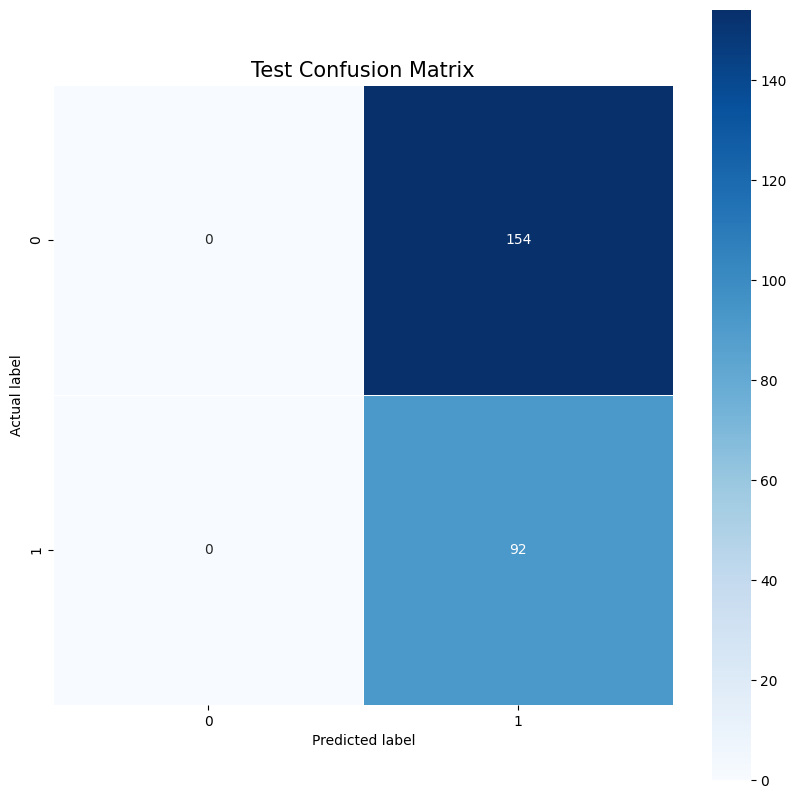

In [ ]:
# Assuming test_dataloader is your test dataset dataloader
test_correct_predictions = 0
test_total_predictions = 0
test_all_labels = []
test_all_predictions = []

# No need to track gradients for testing, so wrap in no_grad()
with torch.no_grad():
    for i, (videos, audios, labels) in enumerate(tqdm(test_dataloader, desc="Testing")):
        videos = videos.to(device)
        audios = audios.to(device)
        labels = labels.to(device)

        # Forward pass and get predictions
        outputs = model(videos, audios)
        _, predicted = torch.max(outputs.data, 1)

        # Update totals and correct counts
        test_total_predictions += labels.size(0)
        test_correct_predictions += (predicted == labels).sum().item()

        # Store labels and predictions for confusion matrix
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(predicted.cpu().numpy())

        # Clear CUDA cache
        torch.cuda.empty_cache()

# Calculate and print accuracy for the test set
test_accuracy = 100 * test_correct_predictions / test_total_predictions
print(f'Accuracy of the model on the test dataset: {test_accuracy}%')

# Calculate and display confusion matrix for the test set
test_cm = confusion_matrix(test_all_labels, test_all_predictions)
plt.figure(figsize=(10,10))
sns.heatmap(test_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Test Confusion Matrix', size = 15);
plt.show()


## Late Fusion

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.audio_net = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size + self.audio_net.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes))


    def forward(self, images, audio):


        # Assuming images is of shape (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = images.shape
        images = images.view(batch_size * num_frames, channels, height, width)

        # Reshape audio for Wav2Vec2
        batch_size, *_ = audio.shape
        audio = audio.view(batch_size, -1)

        # Process images and audio
        x1 = self.vit(images).pooler_output
        x2 = self.audio_net(audio).last_hidden_state.mean(dim=1)

        # Make the tensors contiguous and flatten them
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        # Average the features across the frames for the video
        x1 = x1.view(batch_size, num_frames, -1).mean(dim=1)

        # Concatenate and classify
        x = torch.cat((x1, x2), dim=1)
        return self.classifier(x)


In [ ]:
# Instantiate your model
model = FusionModel(num_classes=len(dataset.classes))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModelWithAttention(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # **Video branch with self-attention:**
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")  # Load pre-trained model

        # Self-attention module for videos
        self.video_attn = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, self.vit.config.hidden_size * 2),
            nn.Softmax(dim=1),  # Softmax for self-attention
            #nn.Linear(self.vit.config.hidden_size, self.vit.config.hidden_size)
        )


        # **Audio branch with self-attention:**
        self.audio_net = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        # Self-attention module for audio
        self.audio_attn = nn.Sequential(
            nn.Linear(self.audio_net.config.hidden_size, self.audio_net.config.hidden_size * 2),
            nn.Softmax(dim=1),  # Use softmax for self-attention
        )

        # **Cross-modal attention:**
        self.cross_attn = nn.MultiheadAttention(
            self.vit.config.hidden_size + self.audio_net.config.hidden_size, num_heads=10, batch_first=True
        )

        # **Classification:**
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size + self.audio_net.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, audio):

        # Assuming images is of shape (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = images.shape
        images = images.view(batch_size * num_frames, channels, height, width)

        # Reshape audio for Wav2Vec2
        batch_size, *_ = audio.shape
        audio = audio.view(batch_size, -1)

        # Process images and audio using pre-trained models
        x1 = self.vit(images).last_hidden_state.mean(dim=1)  # Get video features
        x2 = self.audio_net(audio).last_hidden_state.mean(dim=1)  # Get audio features

        # Video self-attention
        attn_weights_video = self.video_attn(x1)
        #attn_weights_video = attn_weights_video.repeat_interleave(x1.shape[1] // attn_weights_video.shape[1] + 1, dim=1)
        x1 = attn_weights_video * x1  # Apply attention mask to video features


        # Audio self-attention
        attn_weights_audio = self.audio_attn(x2) # Add dimension for attention weights
        x2 = attn_weights_audio * x2  # Apply attention mask to audio features
        x1 = x1.mean(dim=0, keepdim=True)

        x = torch.cat((x1, x2), dim=1)   # Concatenate after averaging video patches

        # **Cross-modal attention:**
        x = self.cross_attn(x, x, x)[0]  # Output has 3 elements; take only the attention-weighted features

        # **Classification:**
        return self.classifier(x)


In [ ]:
# Instantiate your model
model = FusionModelWithAttention(num_classes=len(dataset.classes))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizati

#### Model Training

In [ ]:
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
# Calculate class weights
class_weights = torch.tensor([0.8, 0.2]).to(device)  # Adjust as necessary

# Use a weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/10:   0%|          | 1/865 [00:05<1:22:53,  5.76s/it]

Accuracy of the model after epoch 1: 100.0%


Epoch 1/10:   0%|          | 2/865 [00:10<1:17:08,  5.36s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   0%|          | 3/865 [00:15<1:13:08,  5.09s/it]

Accuracy of the model after epoch 1: 33.333333333333336%


Epoch 1/10:   0%|          | 4/865 [00:20<1:11:04,  4.95s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   1%|          | 5/865 [00:24<1:08:26,  4.77s/it]

Accuracy of the model after epoch 1: 60.0%


Epoch 1/10:   1%|          | 6/865 [00:29<1:06:42,  4.66s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   1%|          | 7/865 [00:33<1:03:25,  4.43s/it]

Accuracy of the model after epoch 1: 42.857142857142854%


Epoch 1/10:   1%|          | 8/865 [00:35<54:54,  3.84s/it]  

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   1%|          | 9/865 [00:38<47:35,  3.34s/it]

Accuracy of the model after epoch 1: 55.55555555555556%


Epoch 1/10:   1%|          | 10/865 [00:40<44:24,  3.12s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   1%|▏         | 11/865 [00:44<48:28,  3.41s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:   1%|▏         | 12/865 [00:48<52:10,  3.67s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 13/865 [00:53<54:40,  3.85s/it]

Accuracy of the model after epoch 1: 53.84615384615385%


Epoch 1/10:   2%|▏         | 14/865 [00:57<58:11,  4.10s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   2%|▏         | 15/865 [01:02<1:00:38,  4.28s/it]

Accuracy of the model after epoch 1: 46.666666666666664%


Epoch 1/10:   2%|▏         | 16/865 [01:07<1:02:23,  4.41s/it]

Accuracy of the model after epoch 1: 43.75%


Epoch 1/10:   2%|▏         | 17/865 [01:11<1:01:16,  4.34s/it]

Accuracy of the model after epoch 1: 47.05882352941177%


Epoch 1/10:   2%|▏         | 18/865 [01:13<52:44,  3.74s/it]  

Accuracy of the model after epoch 1: 44.44444444444444%


Epoch 1/10:   2%|▏         | 19/865 [01:18<55:02,  3.90s/it]

Accuracy of the model after epoch 1: 47.36842105263158%


Epoch 1/10:   2%|▏         | 20/865 [01:21<50:42,  3.60s/it]

Accuracy of the model after epoch 1: 45.0%


Epoch 1/10:   2%|▏         | 21/865 [01:25<53:50,  3.83s/it]

Accuracy of the model after epoch 1: 42.857142857142854%


Epoch 1/10:   3%|▎         | 22/865 [01:29<55:33,  3.95s/it]

Accuracy of the model after epoch 1: 40.90909090909091%


Epoch 1/10:   3%|▎         | 23/865 [01:33<57:08,  4.07s/it]

Accuracy of the model after epoch 1: 39.130434782608695%


Epoch 1/10:   3%|▎         | 24/865 [01:38<1:00:44,  4.33s/it]

Accuracy of the model after epoch 1: 37.5%


Epoch 1/10:   3%|▎         | 25/865 [01:43<1:02:33,  4.47s/it]

Accuracy of the model after epoch 1: 36.0%


Epoch 1/10:   3%|▎         | 26/865 [01:48<1:03:16,  4.52s/it]

Accuracy of the model after epoch 1: 34.61538461538461%


Epoch 1/10:   3%|▎         | 27/865 [01:52<1:01:18,  4.39s/it]

Accuracy of the model after epoch 1: 37.03703703703704%


Epoch 1/10:   3%|▎         | 28/865 [01:56<1:01:40,  4.42s/it]

Accuracy of the model after epoch 1: 35.714285714285715%


Epoch 1/10:   3%|▎         | 29/865 [01:59<53:31,  3.84s/it]  

Accuracy of the model after epoch 1: 34.48275862068966%


Epoch 1/10:   3%|▎         | 30/865 [02:03<55:55,  4.02s/it]

Accuracy of the model after epoch 1: 36.666666666666664%


Epoch 1/10:   4%|▎         | 31/865 [02:06<49:54,  3.59s/it]

Accuracy of the model after epoch 1: 35.483870967741936%


Epoch 1/10:   4%|▎         | 32/865 [02:10<52:43,  3.80s/it]

Accuracy of the model after epoch 1: 34.375%


Epoch 1/10:   4%|▍         | 33/865 [02:13<47:21,  3.42s/it]

Accuracy of the model after epoch 1: 33.333333333333336%


Epoch 1/10:   4%|▍         | 34/865 [02:17<52:36,  3.80s/it]

Accuracy of the model after epoch 1: 32.35294117647059%


Epoch 1/10:   4%|▍         | 35/865 [02:22<56:11,  4.06s/it]

Accuracy of the model after epoch 1: 34.285714285714285%


Epoch 1/10:   4%|▍         | 36/865 [02:26<56:37,  4.10s/it]

Accuracy of the model after epoch 1: 36.111111111111114%


Epoch 1/10:   4%|▍         | 37/865 [02:29<49:35,  3.59s/it]

Accuracy of the model after epoch 1: 37.83783783783784%


Epoch 1/10:   4%|▍         | 38/865 [02:33<52:53,  3.84s/it]

Accuracy of the model after epoch 1: 36.8421052631579%


Epoch 1/10:   5%|▍         | 39/865 [02:38<57:13,  4.16s/it]

Accuracy of the model after epoch 1: 38.46153846153846%


Epoch 1/10:   5%|▍         | 40/865 [02:42<58:09,  4.23s/it]

Accuracy of the model after epoch 1: 40.0%


Epoch 1/10:   5%|▍         | 41/865 [02:47<57:58,  4.22s/it]

Accuracy of the model after epoch 1: 41.46341463414634%


Epoch 1/10:   5%|▍         | 42/865 [02:49<51:00,  3.72s/it]

Accuracy of the model after epoch 1: 42.857142857142854%


Epoch 1/10:   5%|▍         | 43/865 [02:53<52:44,  3.85s/it]

Accuracy of the model after epoch 1: 44.18604651162791%


Epoch 1/10:   5%|▌         | 44/865 [02:56<46:25,  3.39s/it]

Accuracy of the model after epoch 1: 43.18181818181818%


Epoch 1/10:   5%|▌         | 45/865 [03:00<51:06,  3.74s/it]

Accuracy of the model after epoch 1: 44.44444444444444%


Epoch 1/10:   5%|▌         | 46/865 [03:05<55:56,  4.10s/it]

Accuracy of the model after epoch 1: 43.47826086956522%


Epoch 1/10:   5%|▌         | 47/865 [03:09<56:26,  4.14s/it]

Accuracy of the model after epoch 1: 44.680851063829785%


Epoch 1/10:   6%|▌         | 48/865 [03:14<57:56,  4.26s/it]

Accuracy of the model after epoch 1: 45.833333333333336%


Epoch 1/10:   6%|▌         | 49/865 [03:19<1:00:40,  4.46s/it]

Accuracy of the model after epoch 1: 46.93877551020408%


Epoch 1/10:   6%|▌         | 50/865 [03:23<1:00:53,  4.48s/it]

Accuracy of the model after epoch 1: 46.0%


Epoch 1/10:   6%|▌         | 51/865 [03:28<1:00:57,  4.49s/it]

Accuracy of the model after epoch 1: 45.09803921568628%


Epoch 1/10:   6%|▌         | 52/865 [03:32<1:00:15,  4.45s/it]

Accuracy of the model after epoch 1: 44.23076923076923%


Epoch 1/10:   6%|▌         | 53/865 [03:37<1:01:11,  4.52s/it]

Accuracy of the model after epoch 1: 45.283018867924525%


Epoch 1/10:   6%|▌         | 54/865 [03:40<54:23,  4.02s/it]  

Accuracy of the model after epoch 1: 46.2962962962963%


Epoch 1/10:   6%|▋         | 55/865 [03:42<48:44,  3.61s/it]

Accuracy of the model after epoch 1: 45.45454545454545%


Epoch 1/10:   6%|▋         | 56/865 [03:47<50:58,  3.78s/it]

Accuracy of the model after epoch 1: 46.42857142857143%


Epoch 1/10:   7%|▋         | 57/865 [03:51<52:18,  3.88s/it]

Accuracy of the model after epoch 1: 45.6140350877193%


Epoch 1/10:   7%|▋         | 58/865 [03:55<53:56,  4.01s/it]

Accuracy of the model after epoch 1: 44.827586206896555%


Epoch 1/10:   7%|▋         | 59/865 [04:00<57:40,  4.29s/it]

Accuracy of the model after epoch 1: 44.067796610169495%


Epoch 1/10:   7%|▋         | 60/865 [04:05<1:00:49,  4.53s/it]

Accuracy of the model after epoch 1: 45.0%


Epoch 1/10:   7%|▋         | 61/865 [04:09<59:04,  4.41s/it]  

Accuracy of the model after epoch 1: 44.26229508196721%


Epoch 1/10:   7%|▋         | 62/865 [04:12<51:12,  3.83s/it]

Accuracy of the model after epoch 1: 45.16129032258065%


Epoch 1/10:   7%|▋         | 63/865 [04:16<53:20,  3.99s/it]

Accuracy of the model after epoch 1: 44.44444444444444%


Epoch 1/10:   7%|▋         | 64/865 [04:21<58:01,  4.35s/it]

Accuracy of the model after epoch 1: 45.3125%


Epoch 1/10:   8%|▊         | 65/865 [04:26<59:28,  4.46s/it]

Accuracy of the model after epoch 1: 44.61538461538461%


Epoch 1/10:   8%|▊         | 66/865 [04:30<58:18,  4.38s/it]

Accuracy of the model after epoch 1: 43.93939393939394%


Epoch 1/10:   8%|▊         | 67/865 [04:35<59:49,  4.50s/it]

Accuracy of the model after epoch 1: 44.776119402985074%


Epoch 1/10:   8%|▊         | 68/865 [04:40<1:00:35,  4.56s/it]

Accuracy of the model after epoch 1: 45.588235294117645%


Epoch 1/10:   8%|▊         | 69/865 [04:45<1:02:06,  4.68s/it]

Accuracy of the model after epoch 1: 44.927536231884055%


Epoch 1/10:   8%|▊         | 70/865 [04:49<1:01:26,  4.64s/it]

Accuracy of the model after epoch 1: 45.714285714285715%


Epoch 1/10:   8%|▊         | 71/865 [04:53<59:37,  4.51s/it]  

Accuracy of the model after epoch 1: 45.070422535211264%


Epoch 1/10:   8%|▊         | 72/865 [04:58<58:19,  4.41s/it]

Accuracy of the model after epoch 1: 45.833333333333336%


Epoch 1/10:   8%|▊         | 73/865 [05:02<59:00,  4.47s/it]

Accuracy of the model after epoch 1: 46.57534246575342%


Epoch 1/10:   9%|▊         | 74/865 [05:05<52:30,  3.98s/it]

Accuracy of the model after epoch 1: 47.2972972972973%


Epoch 1/10:   9%|▊         | 75/865 [05:09<54:19,  4.13s/it]

Accuracy of the model after epoch 1: 48.0%


Epoch 1/10:   9%|▉         | 76/865 [05:13<53:50,  4.09s/it]

Accuracy of the model after epoch 1: 48.68421052631579%


Epoch 1/10:   9%|▉         | 77/865 [05:18<54:05,  4.12s/it]

Accuracy of the model after epoch 1: 49.35064935064935%


Epoch 1/10:   9%|▉         | 78/865 [05:22<56:57,  4.34s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:   9%|▉         | 79/865 [05:25<49:33,  3.78s/it]

Accuracy of the model after epoch 1: 49.36708860759494%


Epoch 1/10:   9%|▉         | 80/865 [05:30<52:35,  4.02s/it]

Accuracy of the model after epoch 1: 48.75%


Epoch 1/10:   9%|▉         | 81/865 [05:34<53:40,  4.11s/it]

Accuracy of the model after epoch 1: 48.148148148148145%


Epoch 1/10:   9%|▉         | 82/865 [05:38<53:54,  4.13s/it]

Accuracy of the model after epoch 1: 48.78048780487805%


Epoch 1/10:  10%|▉         | 83/865 [05:43<56:01,  4.30s/it]

Accuracy of the model after epoch 1: 49.397590361445786%


Epoch 1/10:  10%|▉         | 84/865 [05:48<59:43,  4.59s/it]

Accuracy of the model after epoch 1: 48.80952380952381%


Epoch 1/10:  10%|▉         | 85/865 [05:52<59:13,  4.56s/it]

Accuracy of the model after epoch 1: 49.411764705882355%


Epoch 1/10:  10%|▉         | 86/865 [05:57<58:22,  4.50s/it]

Accuracy of the model after epoch 1: 48.83720930232558%


Epoch 1/10:  10%|█         | 87/865 [06:01<58:06,  4.48s/it]

Accuracy of the model after epoch 1: 48.275862068965516%


Epoch 1/10:  10%|█         | 88/865 [06:07<1:00:56,  4.71s/it]

Accuracy of the model after epoch 1: 47.72727272727273%


Epoch 1/10:  10%|█         | 89/865 [06:12<1:03:33,  4.91s/it]

Accuracy of the model after epoch 1: 48.31460674157304%


Epoch 1/10:  10%|█         | 90/865 [06:16<1:01:38,  4.77s/it]

Accuracy of the model after epoch 1: 47.77777777777778%


Epoch 1/10:  11%|█         | 91/865 [06:20<59:09,  4.59s/it]  

Accuracy of the model after epoch 1: 47.252747252747255%


Epoch 1/10:  11%|█         | 92/865 [06:25<1:00:13,  4.67s/it]

Accuracy of the model after epoch 1: 46.73913043478261%


Epoch 1/10:  11%|█         | 93/865 [06:28<50:52,  3.95s/it]  

Accuracy of the model after epoch 1: 47.31182795698925%


Epoch 1/10:  11%|█         | 94/865 [06:30<45:14,  3.52s/it]

Accuracy of the model after epoch 1: 46.808510638297875%


Epoch 1/10:  11%|█         | 95/865 [06:35<49:14,  3.84s/it]

Accuracy of the model after epoch 1: 47.36842105263158%


Epoch 1/10:  11%|█         | 96/865 [06:39<50:56,  3.98s/it]

Accuracy of the model after epoch 1: 47.916666666666664%


Epoch 1/10:  11%|█         | 97/865 [06:43<52:19,  4.09s/it]

Accuracy of the model after epoch 1: 48.45360824742268%


Epoch 1/10:  11%|█▏        | 98/865 [06:48<56:05,  4.39s/it]

Accuracy of the model after epoch 1: 48.97959183673469%


Epoch 1/10:  11%|█▏        | 99/865 [06:51<48:19,  3.79s/it]

Accuracy of the model after epoch 1: 48.484848484848484%


Epoch 1/10:  12%|█▏        | 100/865 [06:55<50:48,  3.98s/it]

Accuracy of the model after epoch 1: 49.0%


Epoch 1/10:  12%|█▏        | 101/865 [06:59<51:31,  4.05s/it]

Accuracy of the model after epoch 1: 49.504950495049506%


Epoch 1/10:  12%|█▏        | 102/865 [07:04<53:32,  4.21s/it]

Accuracy of the model after epoch 1: 49.01960784313726%


Epoch 1/10:  12%|█▏        | 103/865 [07:09<55:07,  4.34s/it]

Accuracy of the model after epoch 1: 49.51456310679612%


Epoch 1/10:  12%|█▏        | 104/865 [07:14<58:14,  4.59s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:  12%|█▏        | 105/865 [07:18<58:00,  4.58s/it]

Accuracy of the model after epoch 1: 50.476190476190474%


Epoch 1/10:  12%|█▏        | 106/865 [07:23<58:04,  4.59s/it]

Accuracy of the model after epoch 1: 50.943396226415096%


Epoch 1/10:  12%|█▏        | 107/865 [07:27<56:53,  4.50s/it]

Accuracy of the model after epoch 1: 50.467289719626166%


Epoch 1/10:  12%|█▏        | 108/865 [07:31<55:16,  4.38s/it]

Accuracy of the model after epoch 1: 50.0%


Epoch 1/10:  13%|█▎        | 109/865 [07:36<56:19,  4.47s/it]

Accuracy of the model after epoch 1: 50.45871559633027%


Epoch 1/10:  13%|█▎        | 110/865 [07:41<57:21,  4.56s/it]

Accuracy of the model after epoch 1: 50.90909090909091%


Epoch 1/10:  13%|█▎        | 111/865 [07:45<56:41,  4.51s/it]

Accuracy of the model after epoch 1: 50.450450450450454%


Epoch 1/10:  13%|█▎        | 112/865 [07:50<56:08,  4.47s/it]

Accuracy of the model after epoch 1: 50.892857142857146%


Epoch 1/10:  13%|█▎        | 113/865 [07:55<58:28,  4.67s/it]

Accuracy of the model after epoch 1: 50.442477876106196%


Epoch 1/10:  13%|█▎        | 114/865 [07:57<49:35,  3.96s/it]

Accuracy of the model after epoch 1: 50.87719298245614%


Epoch 1/10:  13%|█▎        | 115/865 [08:02<52:14,  4.18s/it]

Accuracy of the model after epoch 1: 51.30434782608695%


Epoch 1/10:  13%|█▎        | 116/865 [08:04<46:31,  3.73s/it]

Accuracy of the model after epoch 1: 51.724137931034484%


Epoch 1/10:  14%|█▎        | 117/865 [08:09<48:38,  3.90s/it]

Accuracy of the model after epoch 1: 51.282051282051285%


Epoch 1/10:  14%|█▎        | 118/865 [08:13<49:43,  3.99s/it]

Accuracy of the model after epoch 1: 50.847457627118644%


Epoch 1/10:  14%|█▍        | 119/865 [08:18<53:51,  4.33s/it]

Accuracy of the model after epoch 1: 51.260504201680675%


Epoch 1/10:  14%|█▍        | 120/865 [08:23<54:38,  4.40s/it]

Accuracy of the model after epoch 1: 51.666666666666664%


Epoch 1/10:  14%|█▍        | 121/865 [08:27<53:45,  4.33s/it]

Accuracy of the model after epoch 1: 51.239669421487605%


Epoch 1/10:  14%|█▍        | 122/865 [08:31<52:30,  4.24s/it]

Accuracy of the model after epoch 1: 51.63934426229508%


Epoch 1/10:  14%|█▍        | 123/865 [08:35<53:13,  4.30s/it]

Accuracy of the model after epoch 1: 52.03252032520325%


Epoch 1/10:  14%|█▍        | 124/865 [08:40<55:23,  4.48s/it]

Accuracy of the model after epoch 1: 51.61290322580645%


Epoch 1/10:  14%|█▍        | 125/865 [08:43<48:41,  3.95s/it]

Accuracy of the model after epoch 1: 52.0%


Epoch 1/10:  15%|█▍        | 126/865 [08:47<49:14,  4.00s/it]

Accuracy of the model after epoch 1: 51.58730158730159%


Epoch 1/10:  15%|█▍        | 127/865 [08:51<50:28,  4.10s/it]

Accuracy of the model after epoch 1: 51.181102362204726%


Epoch 1/10:  15%|█▍        | 128/865 [08:56<50:53,  4.14s/it]

Accuracy of the model after epoch 1: 51.5625%


Epoch 1/10:  15%|█▍        | 129/865 [09:00<52:07,  4.25s/it]

Accuracy of the model after epoch 1: 51.16279069767442%


Epoch 1/10:  15%|█▌        | 130/865 [09:05<53:10,  4.34s/it]

Accuracy of the model after epoch 1: 50.76923076923077%


Epoch 1/10:  15%|█▌        | 131/865 [09:07<46:18,  3.79s/it]

Accuracy of the model after epoch 1: 50.38167938931298%


Epoch 1/10:  15%|█▌        | 132/865 [09:11<47:43,  3.91s/it]

Accuracy of the model after epoch 1: 50.75757575757576%


Epoch 1/10:  15%|█▌        | 133/865 [09:16<48:54,  4.01s/it]

Accuracy of the model after epoch 1: 51.12781954887218%


Epoch 1/10:  15%|█▌        | 134/865 [09:20<50:47,  4.17s/it]

Accuracy of the model after epoch 1: 51.492537313432834%


Epoch 1/10:  16%|█▌        | 135/865 [09:25<51:47,  4.26s/it]

Accuracy of the model after epoch 1: 51.851851851851855%


Epoch 1/10:  16%|█▌        | 136/865 [09:29<53:53,  4.44s/it]

Accuracy of the model after epoch 1: 51.470588235294116%


Epoch 1/10:  16%|█▌        | 137/865 [09:32<47:08,  3.89s/it]

Accuracy of the model after epoch 1: 51.09489051094891%


Epoch 1/10:  16%|█▌        | 138/865 [09:36<48:13,  3.98s/it]

Accuracy of the model after epoch 1: 51.44927536231884%


Epoch 1/10:  16%|█▌        | 139/865 [09:41<50:39,  4.19s/it]

Accuracy of the model after epoch 1: 51.798561151079134%


Epoch 1/10:  16%|█▌        | 140/865 [09:46<52:06,  4.31s/it]

Accuracy of the model after epoch 1: 51.42857142857143%


Epoch 1/10:  16%|█▋        | 141/865 [09:50<52:09,  4.32s/it]

Accuracy of the model after epoch 1: 51.06382978723404%


Epoch 1/10:  16%|█▋        | 142/865 [09:54<51:53,  4.31s/it]

Accuracy of the model after epoch 1: 51.40845070422535%


Epoch 1/10:  17%|█▋        | 143/865 [09:59<52:58,  4.40s/it]

Accuracy of the model after epoch 1: 51.04895104895105%


Epoch 1/10:  17%|█▋        | 144/865 [10:04<55:26,  4.61s/it]

Accuracy of the model after epoch 1: 51.388888888888886%


Epoch 1/10:  17%|█▋        | 145/865 [10:09<56:04,  4.67s/it]

Accuracy of the model after epoch 1: 51.03448275862069%


Epoch 1/10:  17%|█▋        | 146/865 [10:13<53:40,  4.48s/it]

Accuracy of the model after epoch 1: 51.36986301369863%


Epoch 1/10:  17%|█▋        | 147/865 [10:17<51:58,  4.34s/it]

Accuracy of the model after epoch 1: 51.70068027210884%


Epoch 1/10:  17%|█▋        | 148/865 [10:21<51:31,  4.31s/it]

Accuracy of the model after epoch 1: 51.351351351351354%


Epoch 1/10:  17%|█▋        | 149/865 [10:26<55:06,  4.62s/it]

Accuracy of the model after epoch 1: 51.006711409395976%


Epoch 1/10:  17%|█▋        | 150/865 [10:31<54:39,  4.59s/it]

Accuracy of the model after epoch 1: 50.666666666666664%


Epoch 1/10:  17%|█▋        | 151/865 [10:35<54:31,  4.58s/it]

Accuracy of the model after epoch 1: 50.33112582781457%


Epoch 1/10:  18%|█▊        | 152/865 [10:40<54:42,  4.60s/it]

Accuracy of the model after epoch 1: 50.6578947368421%


Epoch 1/10:  18%|█▊        | 153/865 [10:45<55:30,  4.68s/it]

Accuracy of the model after epoch 1: 50.98039215686274%


Epoch 1/10:  18%|█▊        | 154/865 [10:50<58:29,  4.94s/it]

Accuracy of the model after epoch 1: 51.298701298701296%


Epoch 1/10:  18%|█▊        | 155/865 [10:56<58:46,  4.97s/it]

Accuracy of the model after epoch 1: 51.61290322580645%


Epoch 1/10:  18%|█▊        | 156/865 [10:58<50:04,  4.24s/it]

Accuracy of the model after epoch 1: 51.282051282051285%


Epoch 1/10:  18%|█▊        | 157/865 [11:00<43:32,  3.69s/it]

Accuracy of the model after epoch 1: 51.59235668789809%


Epoch 1/10:  18%|█▊        | 158/865 [11:05<46:35,  3.95s/it]

Accuracy of the model after epoch 1: 51.265822784810126%


Epoch 1/10:  18%|█▊        | 159/865 [11:09<48:18,  4.11s/it]

Accuracy of the model after epoch 1: 51.57232704402516%


Epoch 1/10:  18%|█▊        | 160/865 [11:12<43:25,  3.70s/it]

Accuracy of the model after epoch 1: 51.25%


Epoch 1/10:  19%|█▊        | 161/865 [11:16<45:01,  3.84s/it]

Accuracy of the model after epoch 1: 51.5527950310559%


Epoch 1/10:  19%|█▊        | 162/865 [11:21<46:15,  3.95s/it]

Accuracy of the model after epoch 1: 51.851851851851855%


Epoch 1/10:  19%|█▉        | 163/865 [11:25<47:25,  4.05s/it]

Accuracy of the model after epoch 1: 51.533742331288344%


Epoch 1/10:  19%|█▉        | 164/865 [11:30<50:39,  4.34s/it]

Accuracy of the model after epoch 1: 51.21951219512195%


Epoch 1/10:  19%|█▉        | 165/865 [11:35<52:40,  4.52s/it]

Accuracy of the model after epoch 1: 50.90909090909091%


Epoch 1/10:  19%|█▉        | 166/865 [11:39<51:31,  4.42s/it]

Accuracy of the model after epoch 1: 51.204819277108435%


Epoch 1/10:  19%|█▉        | 167/865 [11:41<44:22,  3.81s/it]

Accuracy of the model after epoch 1: 50.89820359281437%


Epoch 1/10:  19%|█▉        | 168/865 [11:46<46:04,  3.97s/it]

Accuracy of the model after epoch 1: 51.19047619047619%


Epoch 1/10:  20%|█▉        | 169/865 [11:51<49:22,  4.26s/it]

Accuracy of the model after epoch 1: 50.887573964497044%


Epoch 1/10:  20%|█▉        | 170/865 [11:55<49:56,  4.31s/it]

Accuracy of the model after epoch 1: 51.1764705882353%


Epoch 1/10:  20%|█▉        | 171/865 [11:59<49:32,  4.28s/it]

Accuracy of the model after epoch 1: 50.87719298245614%


Epoch 1/10:  20%|█▉        | 172/865 [12:04<49:27,  4.28s/it]

Accuracy of the model after epoch 1: 51.16279069767442%


Epoch 1/10:  20%|██        | 173/865 [12:08<51:00,  4.42s/it]

Accuracy of the model after epoch 1: 51.445086705202314%


Epoch 1/10:  20%|██        | 174/865 [12:14<53:54,  4.68s/it]

Accuracy of the model after epoch 1: 51.724137931034484%


Epoch 1/10:  20%|██        | 175/865 [12:18<53:34,  4.66s/it]

Accuracy of the model after epoch 1: 51.42857142857143%


Epoch 1/10:  20%|██        | 176/865 [12:22<51:35,  4.49s/it]

Accuracy of the model after epoch 1: 51.70454545454545%


Epoch 1/10:  20%|██        | 177/865 [12:25<45:11,  3.94s/it]

Accuracy of the model after epoch 1: 51.9774011299435%


Epoch 1/10:  21%|██        | 178/865 [12:29<46:43,  4.08s/it]

Accuracy of the model after epoch 1: 51.68539325842696%


Epoch 1/10:  21%|██        | 179/865 [12:34<49:14,  4.31s/it]

Accuracy of the model after epoch 1: 51.39664804469274%


Epoch 1/10:  21%|██        | 180/865 [12:37<43:49,  3.84s/it]

Accuracy of the model after epoch 1: 51.111111111111114%


Epoch 1/10:  21%|██        | 181/865 [12:40<39:11,  3.44s/it]

Accuracy of the model after epoch 1: 50.828729281767956%


Epoch 1/10:  21%|██        | 182/865 [12:44<43:27,  3.82s/it]

Accuracy of the model after epoch 1: 51.0989010989011%


Epoch 1/10:  21%|██        | 183/865 [12:49<45:02,  3.96s/it]

Accuracy of the model after epoch 1: 50.81967213114754%


Epoch 1/10:  21%|██▏       | 184/865 [12:51<38:48,  3.42s/it]

Accuracy of the model after epoch 1: 51.08695652173913%


Epoch 1/10:  21%|██▏       | 185/865 [12:55<41:39,  3.68s/it]

Accuracy of the model after epoch 1: 51.351351351351354%


Epoch 1/10:  22%|██▏       | 186/865 [13:00<45:01,  3.98s/it]

Accuracy of the model after epoch 1: 51.075268817204304%


Epoch 1/10:  22%|██▏       | 187/865 [13:02<39:14,  3.47s/it]

Accuracy of the model after epoch 1: 51.336898395721924%


Epoch 1/10:  22%|██▏       | 188/865 [13:06<42:49,  3.80s/it]

Accuracy of the model after epoch 1: 51.06382978723404%


Epoch 1/10:  22%|██▏       | 189/865 [13:09<38:40,  3.43s/it]

Accuracy of the model after epoch 1: 50.79365079365079%


Epoch 1/10:  22%|██▏       | 190/865 [13:12<36:49,  3.27s/it]

Accuracy of the model after epoch 1: 50.526315789473685%


Epoch 1/10:  22%|██▏       | 191/865 [13:16<39:41,  3.53s/it]

Accuracy of the model after epoch 1: 50.261780104712045%


Epoch 1/10:  22%|██▏       | 192/865 [13:20<42:26,  3.78s/it]

Accuracy of the model after epoch 1: 50.520833333333336%


Epoch 1/10:  22%|██▏       | 193/865 [13:25<43:37,  3.90s/it]

Accuracy of the model after epoch 1: 50.77720207253886%


Epoch 1/10:  22%|██▏       | 194/865 [13:30<48:21,  4.32s/it]

Accuracy of the model after epoch 1: 50.51546391752577%


Epoch 1/10:  23%|██▎       | 195/865 [13:35<49:08,  4.40s/it]

Accuracy of the model after epoch 1: 50.76923076923077%


Epoch 1/10:  23%|██▎       | 196/865 [13:37<42:44,  3.83s/it]

Accuracy of the model after epoch 1: 51.02040816326531%


Epoch 1/10:  23%|██▎       | 197/865 [13:40<38:30,  3.46s/it]

Accuracy of the model after epoch 1: 51.26903553299493%


Epoch 1/10:  23%|██▎       | 198/865 [13:44<41:22,  3.72s/it]

Accuracy of the model after epoch 1: 51.515151515151516%


Epoch 1/10:  23%|██▎       | 199/865 [13:48<43:35,  3.93s/it]

Accuracy of the model after epoch 1: 51.256281407035175%


Epoch 1/10:  23%|██▎       | 200/865 [13:53<45:03,  4.07s/it]

Accuracy of the model after epoch 1: 51.5%


Epoch 1/10:  23%|██▎       | 201/865 [13:57<45:18,  4.09s/it]

Accuracy of the model after epoch 1: 51.74129353233831%


Epoch 1/10:  23%|██▎       | 202/865 [13:59<39:51,  3.61s/it]

Accuracy of the model after epoch 1: 51.98019801980198%


Epoch 1/10:  23%|██▎       | 203/865 [14:04<43:52,  3.98s/it]

Accuracy of the model after epoch 1: 51.724137931034484%


Epoch 1/10:  24%|██▎       | 204/865 [14:09<46:37,  4.23s/it]

Accuracy of the model after epoch 1: 51.96078431372549%


Epoch 1/10:  24%|██▎       | 205/865 [14:12<41:07,  3.74s/it]

Accuracy of the model after epoch 1: 51.707317073170735%


Epoch 1/10:  24%|██▍       | 206/865 [14:14<36:42,  3.34s/it]

Accuracy of the model after epoch 1: 51.45631067961165%


Epoch 1/10:  24%|██▍       | 207/865 [14:18<39:44,  3.62s/it]

Accuracy of the model after epoch 1: 51.690821256038646%


Epoch 1/10:  24%|██▍       | 208/865 [14:23<41:45,  3.81s/it]

Accuracy of the model after epoch 1: 51.44230769230769%


Epoch 1/10:  24%|██▍       | 209/865 [14:27<43:37,  3.99s/it]

Accuracy of the model after epoch 1: 51.67464114832536%


Epoch 1/10:  24%|██▍       | 210/865 [14:30<39:18,  3.60s/it]

Accuracy of the model after epoch 1: 51.904761904761905%


Epoch 1/10:  24%|██▍       | 211/865 [14:32<35:10,  3.23s/it]

Accuracy of the model after epoch 1: 52.132701421800945%


Epoch 1/10:  25%|██▍       | 212/865 [14:37<39:46,  3.65s/it]

Accuracy of the model after epoch 1: 52.35849056603774%


Epoch 1/10:  25%|██▍       | 213/865 [14:41<42:27,  3.91s/it]

Accuracy of the model after epoch 1: 52.11267605633803%


Epoch 1/10:  25%|██▍       | 214/865 [14:45<43:30,  4.01s/it]

Accuracy of the model after epoch 1: 52.33644859813084%


Epoch 1/10:  25%|██▍       | 215/865 [14:50<44:27,  4.10s/it]

Accuracy of the model after epoch 1: 52.55813953488372%


Epoch 1/10:  25%|██▍       | 216/865 [14:54<44:41,  4.13s/it]

Accuracy of the model after epoch 1: 52.31481481481482%


Epoch 1/10:  25%|██▌       | 217/865 [14:58<45:08,  4.18s/it]

Accuracy of the model after epoch 1: 52.534562211981566%


Epoch 1/10:  25%|██▌       | 218/865 [15:04<48:40,  4.51s/it]

Accuracy of the model after epoch 1: 52.75229357798165%


Epoch 1/10:  25%|██▌       | 219/865 [15:09<51:01,  4.74s/it]

Accuracy of the model after epoch 1: 52.51141552511415%


Epoch 1/10:  25%|██▌       | 220/865 [15:13<50:29,  4.70s/it]

Accuracy of the model after epoch 1: 52.72727272727273%


Epoch 1/10:  26%|██▌       | 221/865 [15:16<43:17,  4.03s/it]

Accuracy of the model after epoch 1: 52.48868778280543%


Epoch 1/10:  26%|██▌       | 222/865 [15:20<43:24,  4.05s/it]

Accuracy of the model after epoch 1: 52.252252252252255%


Epoch 1/10:  26%|██▌       | 223/865 [15:23<39:05,  3.65s/it]

Accuracy of the model after epoch 1: 52.01793721973094%


Epoch 1/10:  26%|██▌       | 224/865 [15:27<41:51,  3.92s/it]

Accuracy of the model after epoch 1: 51.785714285714285%


Epoch 1/10:  26%|██▌       | 225/865 [15:32<43:53,  4.11s/it]

Accuracy of the model after epoch 1: 51.55555555555556%


Epoch 1/10:  26%|██▌       | 226/865 [15:37<45:39,  4.29s/it]

Accuracy of the model after epoch 1: 51.769911504424776%


Epoch 1/10:  26%|██▌       | 227/865 [15:39<39:26,  3.71s/it]

Accuracy of the model after epoch 1: 51.98237885462555%


Epoch 1/10:  26%|██▋       | 228/865 [15:41<35:22,  3.33s/it]

Accuracy of the model after epoch 1: 52.19298245614035%


Epoch 1/10:  26%|██▋       | 229/865 [15:46<38:32,  3.64s/it]

Accuracy of the model after epoch 1: 52.40174672489083%


Epoch 1/10:  27%|██▋       | 230/865 [15:51<42:27,  4.01s/it]

Accuracy of the model after epoch 1: 52.17391304347826%


Epoch 1/10:  27%|██▋       | 231/865 [15:55<42:54,  4.06s/it]

Accuracy of the model after epoch 1: 52.38095238095238%


Epoch 1/10:  27%|██▋       | 232/865 [15:59<44:04,  4.18s/it]

Accuracy of the model after epoch 1: 52.1551724137931%


Epoch 1/10:  27%|██▋       | 233/865 [16:04<45:24,  4.31s/it]

Accuracy of the model after epoch 1: 51.93133047210301%


Epoch 1/10:  27%|██▋       | 234/865 [16:09<47:28,  4.51s/it]

Accuracy of the model after epoch 1: 51.70940170940171%


Epoch 1/10:  27%|██▋       | 235/865 [16:14<48:43,  4.64s/it]

Accuracy of the model after epoch 1: 51.91489361702128%


Epoch 1/10:  27%|██▋       | 236/865 [16:16<41:58,  4.00s/it]

Accuracy of the model after epoch 1: 51.69491525423729%


Epoch 1/10:  27%|██▋       | 237/865 [16:20<42:29,  4.06s/it]

Accuracy of the model after epoch 1: 51.89873417721519%


Epoch 1/10:  28%|██▊       | 238/865 [16:25<43:32,  4.17s/it]

Accuracy of the model after epoch 1: 52.10084033613445%


Epoch 1/10:  28%|██▊       | 239/865 [16:30<45:39,  4.38s/it]

Accuracy of the model after epoch 1: 52.30125523012552%


Epoch 1/10:  28%|██▊       | 240/865 [16:33<40:36,  3.90s/it]

Accuracy of the model after epoch 1: 52.5%


Epoch 1/10:  28%|██▊       | 241/865 [16:35<36:26,  3.50s/it]

Accuracy of the model after epoch 1: 52.697095435684645%


Epoch 1/10:  28%|██▊       | 242/865 [16:39<38:36,  3.72s/it]

Accuracy of the model after epoch 1: 52.892561983471076%


Epoch 1/10:  28%|██▊       | 243/865 [16:42<34:33,  3.33s/it]

Accuracy of the model after epoch 1: 53.08641975308642%


Epoch 1/10:  28%|██▊       | 244/865 [16:44<31:58,  3.09s/it]

Accuracy of the model after epoch 1: 53.278688524590166%


Epoch 1/10:  28%|██▊       | 245/865 [16:47<30:47,  2.98s/it]

Accuracy of the model after epoch 1: 53.46938775510204%


Epoch 1/10:  28%|██▊       | 246/865 [16:51<34:15,  3.32s/it]

Accuracy of the model after epoch 1: 53.65853658536585%


Epoch 1/10:  29%|██▊       | 247/865 [16:55<37:02,  3.60s/it]

Accuracy of the model after epoch 1: 53.441295546558706%


Epoch 1/10:  29%|██▊       | 248/865 [17:00<39:39,  3.86s/it]

Accuracy of the model after epoch 1: 53.225806451612904%


Epoch 1/10:  29%|██▉       | 249/865 [17:02<35:52,  3.49s/it]

Accuracy of the model after epoch 1: 53.4136546184739%


Epoch 1/10:  29%|██▉       | 250/865 [17:05<33:09,  3.23s/it]

Accuracy of the model after epoch 1: 53.2%


Epoch 1/10:  29%|██▉       | 251/865 [17:09<35:32,  3.47s/it]

Accuracy of the model after epoch 1: 53.386454183266935%


Epoch 1/10:  29%|██▉       | 252/865 [17:14<38:44,  3.79s/it]

Accuracy of the model after epoch 1: 53.17460317460318%


Epoch 1/10:  29%|██▉       | 253/865 [17:16<35:11,  3.45s/it]

Accuracy of the model after epoch 1: 52.96442687747036%


Epoch 1/10:  29%|██▉       | 254/865 [17:19<32:11,  3.16s/it]

Accuracy of the model after epoch 1: 52.75590551181102%


Epoch 1/10:  29%|██▉       | 255/865 [17:23<36:12,  3.56s/it]

Accuracy of the model after epoch 1: 52.549019607843135%


Epoch 1/10:  30%|██▉       | 256/865 [17:28<38:26,  3.79s/it]

Accuracy of the model after epoch 1: 52.34375%


Epoch 1/10:  30%|██▉       | 257/865 [17:32<40:10,  3.97s/it]

Accuracy of the model after epoch 1: 52.52918287937743%


Epoch 1/10:  30%|██▉       | 258/865 [17:34<35:26,  3.50s/it]

Accuracy of the model after epoch 1: 52.325581395348834%


Epoch 1/10:  30%|██▉       | 259/865 [17:39<39:20,  3.90s/it]

Accuracy of the model after epoch 1: 52.50965250965251%


Epoch 1/10:  30%|███       | 260/865 [17:44<41:13,  4.09s/it]

Accuracy of the model after epoch 1: 52.30769230769231%


Epoch 1/10:  30%|███       | 261/865 [17:48<42:00,  4.17s/it]

Accuracy of the model after epoch 1: 52.490421455938694%


Epoch 1/10:  30%|███       | 262/865 [17:52<41:53,  4.17s/it]

Accuracy of the model after epoch 1: 52.67175572519084%


Epoch 1/10:  30%|███       | 263/865 [17:57<43:17,  4.32s/it]

Accuracy of the model after epoch 1: 52.851711026615966%


Epoch 1/10:  31%|███       | 264/865 [18:02<45:49,  4.58s/it]

Accuracy of the model after epoch 1: 52.65151515151515%


Epoch 1/10:  31%|███       | 265/865 [18:05<40:20,  4.03s/it]

Accuracy of the model after epoch 1: 52.45283018867924%


Epoch 1/10:  31%|███       | 266/865 [18:09<40:51,  4.09s/it]

Accuracy of the model after epoch 1: 52.63157894736842%


Epoch 1/10:  31%|███       | 267/865 [18:14<41:42,  4.18s/it]

Accuracy of the model after epoch 1: 52.80898876404494%


Epoch 1/10:  31%|███       | 268/865 [18:16<36:35,  3.68s/it]

Accuracy of the model after epoch 1: 52.985074626865675%


Epoch 1/10:  31%|███       | 269/865 [18:20<38:18,  3.86s/it]

Accuracy of the model after epoch 1: 52.78810408921933%


Epoch 1/10:  31%|███       | 270/865 [18:25<41:11,  4.15s/it]

Accuracy of the model after epoch 1: 52.96296296296296%


Epoch 1/10:  31%|███▏      | 271/865 [18:28<36:20,  3.67s/it]

Accuracy of the model after epoch 1: 53.13653136531365%


Epoch 1/10:  31%|███▏      | 272/865 [18:32<37:27,  3.79s/it]

Accuracy of the model after epoch 1: 52.94117647058823%


Epoch 1/10:  32%|███▏      | 273/865 [18:36<39:24,  3.99s/it]

Accuracy of the model after epoch 1: 52.747252747252745%


Epoch 1/10:  32%|███▏      | 274/865 [18:41<42:11,  4.28s/it]

Accuracy of the model after epoch 1: 52.55474452554745%


Epoch 1/10:  32%|███▏      | 275/865 [18:44<37:24,  3.80s/it]

Accuracy of the model after epoch 1: 52.36363636363637%


Epoch 1/10:  32%|███▏      | 276/865 [18:48<38:41,  3.94s/it]

Accuracy of the model after epoch 1: 52.17391304347826%


Epoch 1/10:  32%|███▏      | 277/865 [18:52<39:30,  4.03s/it]

Accuracy of the model after epoch 1: 52.34657039711191%


Epoch 1/10:  32%|███▏      | 278/865 [18:57<39:49,  4.07s/it]

Accuracy of the model after epoch 1: 52.15827338129496%


Epoch 1/10:  32%|███▏      | 279/865 [18:59<35:00,  3.58s/it]

Accuracy of the model after epoch 1: 51.971326164874554%


Epoch 1/10:  32%|███▏      | 280/865 [19:02<32:16,  3.31s/it]

Accuracy of the model after epoch 1: 51.785714285714285%


Epoch 1/10:  32%|███▏      | 281/865 [19:06<35:14,  3.62s/it]

Accuracy of the model after epoch 1: 51.95729537366548%


Epoch 1/10:  33%|███▎      | 282/865 [19:10<36:48,  3.79s/it]

Accuracy of the model after epoch 1: 51.773049645390074%


Epoch 1/10:  33%|███▎      | 283/865 [19:14<37:56,  3.91s/it]

Accuracy of the model after epoch 1: 51.9434628975265%


Epoch 1/10:  33%|███▎      | 284/865 [19:19<39:51,  4.12s/it]

Accuracy of the model after epoch 1: 52.11267605633803%


Epoch 1/10:  33%|███▎      | 285/865 [19:24<41:46,  4.32s/it]

Accuracy of the model after epoch 1: 51.92982456140351%


Epoch 1/10:  33%|███▎      | 286/865 [19:28<40:56,  4.24s/it]

Accuracy of the model after epoch 1: 52.0979020979021%


Epoch 1/10:  33%|███▎      | 287/865 [19:30<36:05,  3.75s/it]

Accuracy of the model after epoch 1: 51.91637630662021%


Epoch 1/10:  33%|███▎      | 288/865 [19:33<32:26,  3.37s/it]

Accuracy of the model after epoch 1: 52.083333333333336%


Epoch 1/10:  33%|███▎      | 289/865 [19:37<34:31,  3.60s/it]

Accuracy of the model after epoch 1: 52.24913494809689%


Epoch 1/10:  34%|███▎      | 290/865 [19:40<32:22,  3.38s/it]

Accuracy of the model after epoch 1: 52.41379310344828%


Epoch 1/10:  34%|███▎      | 291/865 [19:42<29:48,  3.12s/it]

Accuracy of the model after epoch 1: 52.577319587628864%


Epoch 1/10:  34%|███▍      | 292/865 [19:47<32:33,  3.41s/it]

Accuracy of the model after epoch 1: 52.73972602739726%


Epoch 1/10:  34%|███▍      | 293/865 [19:51<34:41,  3.64s/it]

Accuracy of the model after epoch 1: 52.55972696245734%


Epoch 1/10:  34%|███▍      | 294/865 [19:55<36:58,  3.88s/it]

Accuracy of the model after epoch 1: 52.72108843537415%


Epoch 1/10:  34%|███▍      | 295/865 [20:00<38:41,  4.07s/it]

Accuracy of the model after epoch 1: 52.54237288135593%


Epoch 1/10:  34%|███▍      | 296/865 [20:02<34:29,  3.64s/it]

Accuracy of the model after epoch 1: 52.36486486486486%


Epoch 1/10:  34%|███▍      | 297/865 [20:05<31:01,  3.28s/it]

Accuracy of the model after epoch 1: 52.525252525252526%


Epoch 1/10:  34%|███▍      | 298/865 [20:07<28:48,  3.05s/it]

Accuracy of the model after epoch 1: 52.68456375838926%


Epoch 1/10:  35%|███▍      | 299/865 [20:10<26:58,  2.86s/it]

Accuracy of the model after epoch 1: 52.508361204013376%


Epoch 1/10:  35%|███▍      | 300/865 [20:14<31:37,  3.36s/it]

Accuracy of the model after epoch 1: 52.666666666666664%


Epoch 1/10:  35%|███▍      | 301/865 [20:17<29:01,  3.09s/it]

Accuracy of the model after epoch 1: 52.49169435215947%


Epoch 1/10:  35%|███▍      | 302/865 [20:21<32:19,  3.45s/it]

Accuracy of the model after epoch 1: 52.64900662251656%


Epoch 1/10:  35%|███▌      | 303/865 [20:24<29:55,  3.20s/it]

Accuracy of the model after epoch 1: 52.475247524752476%


Epoch 1/10:  35%|███▌      | 304/865 [20:28<33:32,  3.59s/it]

Accuracy of the model after epoch 1: 52.30263157894737%


Epoch 1/10:  35%|███▌      | 305/865 [20:33<36:09,  3.87s/it]

Accuracy of the model after epoch 1: 52.459016393442624%


Epoch 1/10:  35%|███▌      | 306/865 [20:37<36:55,  3.96s/it]

Accuracy of the model after epoch 1: 52.61437908496732%


Epoch 1/10:  35%|███▌      | 307/865 [20:39<32:28,  3.49s/it]

Accuracy of the model after epoch 1: 52.442996742671006%


Epoch 1/10:  36%|███▌      | 308/865 [20:43<34:13,  3.69s/it]

Accuracy of the model after epoch 1: 52.5974025974026%


Epoch 1/10:  36%|███▌      | 309/865 [20:48<35:52,  3.87s/it]

Accuracy of the model after epoch 1: 52.750809061488674%


Epoch 1/10:  36%|███▌      | 310/865 [20:52<37:38,  4.07s/it]

Accuracy of the model after epoch 1: 52.903225806451616%


Epoch 1/10:  36%|███▌      | 311/865 [20:56<38:00,  4.12s/it]

Accuracy of the model after epoch 1: 52.733118971061096%


Epoch 1/10:  36%|███▌      | 312/865 [21:00<38:01,  4.13s/it]

Accuracy of the model after epoch 1: 52.56410256410256%


Epoch 1/10:  36%|███▌      | 313/865 [21:05<39:26,  4.29s/it]

Accuracy of the model after epoch 1: 52.715654952076676%


Epoch 1/10:  36%|███▋      | 314/865 [21:10<41:37,  4.53s/it]

Accuracy of the model after epoch 1: 52.547770700636946%


Epoch 1/10:  36%|███▋      | 315/865 [21:13<36:44,  4.01s/it]

Accuracy of the model after epoch 1: 52.38095238095238%


Epoch 1/10:  37%|███▋      | 316/865 [21:17<36:57,  4.04s/it]

Accuracy of the model after epoch 1: 52.53164556962025%


Epoch 1/10:  37%|███▋      | 317/865 [21:22<38:31,  4.22s/it]

Accuracy of the model after epoch 1: 52.6813880126183%


Epoch 1/10:  37%|███▋      | 318/865 [21:24<33:27,  3.67s/it]

Accuracy of the model after epoch 1: 52.515723270440255%


Epoch 1/10:  37%|███▋      | 319/865 [21:28<34:29,  3.79s/it]

Accuracy of the model after epoch 1: 52.66457680250784%


Epoch 1/10:  37%|███▋      | 320/865 [21:32<35:34,  3.92s/it]

Accuracy of the model after epoch 1: 52.8125%


Epoch 1/10:  37%|███▋      | 321/865 [21:37<37:45,  4.16s/it]

Accuracy of the model after epoch 1: 52.9595015576324%


Epoch 1/10:  37%|███▋      | 322/865 [21:41<37:31,  4.15s/it]

Accuracy of the model after epoch 1: 53.1055900621118%


Epoch 1/10:  37%|███▋      | 323/865 [21:46<38:07,  4.22s/it]

Accuracy of the model after epoch 1: 52.94117647058823%


Epoch 1/10:  37%|███▋      | 324/865 [21:51<40:15,  4.46s/it]

Accuracy of the model after epoch 1: 53.08641975308642%


Epoch 1/10:  38%|███▊      | 325/865 [21:53<35:19,  3.93s/it]

Accuracy of the model after epoch 1: 52.92307692307692%


Epoch 1/10:  38%|███▊      | 326/865 [21:58<37:10,  4.14s/it]

Accuracy of the model after epoch 1: 53.06748466257669%


Epoch 1/10:  38%|███▊      | 327/865 [22:02<37:39,  4.20s/it]

Accuracy of the model after epoch 1: 52.90519877675841%


Epoch 1/10:  38%|███▊      | 328/865 [22:07<37:26,  4.18s/it]

Accuracy of the model after epoch 1: 53.048780487804876%


Epoch 1/10:  38%|███▊      | 329/865 [22:11<37:43,  4.22s/it]

Accuracy of the model after epoch 1: 53.191489361702125%


Epoch 1/10:  38%|███▊      | 330/865 [22:16<38:56,  4.37s/it]

Accuracy of the model after epoch 1: 53.333333333333336%


Epoch 1/10:  38%|███▊      | 331/865 [22:20<38:12,  4.29s/it]

Accuracy of the model after epoch 1: 53.47432024169184%


Epoch 1/10:  38%|███▊      | 332/865 [22:24<38:08,  4.29s/it]

Accuracy of the model after epoch 1: 53.6144578313253%


Epoch 1/10:  38%|███▊      | 333/865 [22:28<37:52,  4.27s/it]

Accuracy of the model after epoch 1: 53.453453453453456%


Epoch 1/10:  39%|███▊      | 334/865 [22:33<39:13,  4.43s/it]

Accuracy of the model after epoch 1: 53.293413173652695%


Epoch 1/10:  39%|███▊      | 335/865 [22:38<41:05,  4.65s/it]

Accuracy of the model after epoch 1: 53.43283582089552%


Epoch 1/10:  39%|███▉      | 336/865 [22:40<34:48,  3.95s/it]

Accuracy of the model after epoch 1: 53.57142857142857%


Epoch 1/10:  39%|███▉      | 337/865 [22:43<30:22,  3.45s/it]

Accuracy of the model after epoch 1: 53.41246290801187%


Epoch 1/10:  39%|███▉      | 338/865 [22:47<32:42,  3.72s/it]

Accuracy of the model after epoch 1: 53.25443786982248%


Epoch 1/10:  39%|███▉      | 339/865 [22:51<33:52,  3.86s/it]

Accuracy of the model after epoch 1: 53.392330383480825%


Epoch 1/10:  39%|███▉      | 340/865 [22:56<35:30,  4.06s/it]

Accuracy of the model after epoch 1: 53.529411764705884%


Epoch 1/10:  39%|███▉      | 341/865 [22:58<31:29,  3.61s/it]

Accuracy of the model after epoch 1: 53.665689149560116%


Epoch 1/10:  40%|███▉      | 342/865 [23:03<33:04,  3.79s/it]

Accuracy of the model after epoch 1: 53.801169590643276%


Epoch 1/10:  40%|███▉      | 343/865 [23:07<34:08,  3.92s/it]

Accuracy of the model after epoch 1: 53.93586005830904%


Epoch 1/10:  40%|███▉      | 344/865 [23:09<30:10,  3.48s/it]

Accuracy of the model after epoch 1: 54.06976744186046%


Epoch 1/10:  40%|███▉      | 345/865 [23:12<27:59,  3.23s/it]

Accuracy of the model after epoch 1: 54.20289855072464%


Epoch 1/10:  40%|████      | 346/865 [23:16<31:16,  3.62s/it]

Accuracy of the model after epoch 1: 54.335260115606935%


Epoch 1/10:  40%|████      | 347/865 [23:21<33:18,  3.86s/it]

Accuracy of the model after epoch 1: 54.46685878962536%


Epoch 1/10:  40%|████      | 348/865 [23:25<35:09,  4.08s/it]

Accuracy of the model after epoch 1: 54.59770114942529%


Epoch 1/10:  40%|████      | 349/865 [23:30<35:24,  4.12s/it]

Accuracy of the model after epoch 1: 54.44126074498568%


Epoch 1/10:  40%|████      | 350/865 [23:34<36:18,  4.23s/it]

Accuracy of the model after epoch 1: 54.285714285714285%


Epoch 1/10:  41%|████      | 351/865 [23:38<36:33,  4.27s/it]

Accuracy of the model after epoch 1: 54.13105413105413%


Epoch 1/10:  41%|████      | 352/865 [23:43<36:09,  4.23s/it]

Accuracy of the model after epoch 1: 53.97727272727273%


Epoch 1/10:  41%|████      | 353/865 [23:47<36:43,  4.30s/it]

Accuracy of the model after epoch 1: 54.107648725212464%


Epoch 1/10:  41%|████      | 354/865 [23:49<31:44,  3.73s/it]

Accuracy of the model after epoch 1: 53.954802259887%


Epoch 1/10:  41%|████      | 355/865 [23:54<33:37,  3.96s/it]

Accuracy of the model after epoch 1: 53.80281690140845%


Epoch 1/10:  41%|████      | 356/865 [23:56<29:37,  3.49s/it]

Accuracy of the model after epoch 1: 53.93258426966292%


Epoch 1/10:  41%|████▏     | 357/865 [24:01<31:20,  3.70s/it]

Accuracy of the model after epoch 1: 53.78151260504202%


Epoch 1/10:  41%|████▏     | 358/865 [24:05<32:29,  3.84s/it]

Accuracy of the model after epoch 1: 53.63128491620112%


Epoch 1/10:  42%|████▏     | 359/865 [24:07<29:09,  3.46s/it]

Accuracy of the model after epoch 1: 53.760445682451255%


Epoch 1/10:  42%|████▏     | 360/865 [24:12<32:01,  3.81s/it]

Accuracy of the model after epoch 1: 53.888888888888886%


Epoch 1/10:  42%|████▏     | 361/865 [24:16<32:23,  3.86s/it]

Accuracy of the model after epoch 1: 54.016620498614955%


Epoch 1/10:  42%|████▏     | 362/865 [24:20<33:04,  3.94s/it]

Accuracy of the model after epoch 1: 54.14364640883978%


Epoch 1/10:  42%|████▏     | 363/865 [24:24<33:51,  4.05s/it]

Accuracy of the model after epoch 1: 53.99449035812672%


Epoch 1/10:  42%|████▏     | 364/865 [24:29<34:59,  4.19s/it]

Accuracy of the model after epoch 1: 54.120879120879124%


Epoch 1/10:  42%|████▏     | 365/865 [24:33<35:58,  4.32s/it]

Accuracy of the model after epoch 1: 53.97260273972603%


Epoch 1/10:  42%|████▏     | 366/865 [24:36<31:10,  3.75s/it]

Accuracy of the model after epoch 1: 54.09836065573771%


Epoch 1/10:  42%|████▏     | 367/865 [24:38<27:19,  3.29s/it]

Accuracy of the model after epoch 1: 54.223433242506815%


Epoch 1/10:  43%|████▎     | 368/865 [24:40<24:51,  3.00s/it]

Accuracy of the model after epoch 1: 54.07608695652174%


Epoch 1/10:  43%|████▎     | 369/865 [24:45<28:03,  3.39s/it]

Accuracy of the model after epoch 1: 53.929539295392956%


Epoch 1/10:  43%|████▎     | 370/865 [24:49<30:38,  3.71s/it]

Accuracy of the model after epoch 1: 54.054054054054056%


Epoch 1/10:  43%|████▎     | 371/865 [24:51<26:46,  3.25s/it]

Accuracy of the model after epoch 1: 54.17789757412399%


Epoch 1/10:  43%|████▎     | 372/865 [24:56<29:01,  3.53s/it]

Accuracy of the model after epoch 1: 54.30107526881721%


Epoch 1/10:  43%|████▎     | 373/865 [24:58<26:16,  3.20s/it]

Accuracy of the model after epoch 1: 54.42359249329759%


Epoch 1/10:  43%|████▎     | 374/865 [25:03<29:38,  3.62s/it]

Accuracy of the model after epoch 1: 54.27807486631016%


Epoch 1/10:  43%|████▎     | 375/865 [25:07<31:55,  3.91s/it]

Accuracy of the model after epoch 1: 54.4%


Epoch 1/10:  43%|████▎     | 376/865 [25:12<32:53,  4.04s/it]

Accuracy of the model after epoch 1: 54.52127659574468%


Epoch 1/10:  44%|████▎     | 377/865 [25:14<29:19,  3.61s/it]

Accuracy of the model after epoch 1: 54.641909814323604%


Epoch 1/10:  44%|████▎     | 378/865 [25:19<31:47,  3.92s/it]

Accuracy of the model after epoch 1: 54.4973544973545%


Epoch 1/10:  44%|████▍     | 379/865 [25:24<33:56,  4.19s/it]

Accuracy of the model after epoch 1: 54.35356200527705%


Epoch 1/10:  44%|████▍     | 380/865 [25:28<35:02,  4.33s/it]

Accuracy of the model after epoch 1: 54.473684210526315%


Epoch 1/10:  44%|████▍     | 381/865 [25:33<35:58,  4.46s/it]

Accuracy of the model after epoch 1: 54.330708661417326%


Epoch 1/10:  44%|████▍     | 382/865 [25:38<35:57,  4.47s/it]

Accuracy of the model after epoch 1: 54.45026178010471%


Epoch 1/10:  44%|████▍     | 383/865 [25:40<30:58,  3.86s/it]

Accuracy of the model after epoch 1: 54.30809399477807%


Epoch 1/10:  44%|████▍     | 384/865 [25:45<33:15,  4.15s/it]

Accuracy of the model after epoch 1: 54.427083333333336%


Epoch 1/10:  45%|████▍     | 385/865 [25:47<29:42,  3.71s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:  45%|████▍     | 386/865 [25:52<30:51,  3.87s/it]

Accuracy of the model after epoch 1: 54.66321243523316%


Epoch 1/10:  45%|████▍     | 387/865 [25:56<32:20,  4.06s/it]

Accuracy of the model after epoch 1: 54.78036175710594%


Epoch 1/10:  45%|████▍     | 388/865 [25:58<28:00,  3.52s/it]

Accuracy of the model after epoch 1: 54.896907216494846%


Epoch 1/10:  45%|████▍     | 389/865 [26:01<25:33,  3.22s/it]

Accuracy of the model after epoch 1: 54.75578406169666%


Epoch 1/10:  45%|████▌     | 390/865 [26:06<28:55,  3.65s/it]

Accuracy of the model after epoch 1: 54.61538461538461%


Epoch 1/10:  45%|████▌     | 391/865 [26:10<30:13,  3.83s/it]

Accuracy of the model after epoch 1: 54.47570332480819%


Epoch 1/10:  45%|████▌     | 392/865 [26:12<27:12,  3.45s/it]

Accuracy of the model after epoch 1: 54.33673469387755%


Epoch 1/10:  45%|████▌     | 393/865 [26:17<29:23,  3.74s/it]

Accuracy of the model after epoch 1: 54.4529262086514%


Epoch 1/10:  46%|████▌     | 394/865 [26:19<26:15,  3.34s/it]

Accuracy of the model after epoch 1: 54.31472081218274%


Epoch 1/10:  46%|████▌     | 395/865 [26:24<30:16,  3.86s/it]

Accuracy of the model after epoch 1: 54.177215189873415%


Epoch 1/10:  46%|████▌     | 396/865 [26:29<32:08,  4.11s/it]

Accuracy of the model after epoch 1: 54.292929292929294%


Epoch 1/10:  46%|████▌     | 397/865 [26:33<32:35,  4.18s/it]

Accuracy of the model after epoch 1: 54.15617128463476%


Epoch 1/10:  46%|████▌     | 398/865 [26:38<33:46,  4.34s/it]

Accuracy of the model after epoch 1: 54.02010050251256%


Epoch 1/10:  46%|████▌     | 399/865 [26:43<34:47,  4.48s/it]

Accuracy of the model after epoch 1: 53.88471177944862%


Epoch 1/10:  46%|████▌     | 400/865 [26:46<30:41,  3.96s/it]

Accuracy of the model after epoch 1: 53.75%


Epoch 1/10:  46%|████▋     | 401/865 [26:50<31:51,  4.12s/it]

Accuracy of the model after epoch 1: 53.86533665835412%


Epoch 1/10:  46%|████▋     | 402/865 [26:54<32:03,  4.16s/it]

Accuracy of the model after epoch 1: 53.73134328358209%


Epoch 1/10:  47%|████▋     | 403/865 [26:57<28:23,  3.69s/it]

Accuracy of the model after epoch 1: 53.59801488833747%


Epoch 1/10:  47%|████▋     | 404/865 [27:02<30:57,  4.03s/it]

Accuracy of the model after epoch 1: 53.71287128712871%


Epoch 1/10:  47%|████▋     | 405/865 [27:06<31:54,  4.16s/it]

Accuracy of the model after epoch 1: 53.82716049382716%


Epoch 1/10:  47%|████▋     | 406/865 [27:11<32:15,  4.22s/it]

Accuracy of the model after epoch 1: 53.69458128078818%


Epoch 1/10:  47%|████▋     | 407/865 [27:15<33:42,  4.42s/it]

Accuracy of the model after epoch 1: 53.562653562653566%


Epoch 1/10:  47%|████▋     | 408/865 [27:20<34:26,  4.52s/it]

Accuracy of the model after epoch 1: 53.431372549019606%


Epoch 1/10:  47%|████▋     | 409/865 [27:25<35:11,  4.63s/it]

Accuracy of the model after epoch 1: 53.30073349633252%


Epoch 1/10:  47%|████▋     | 410/865 [27:30<34:59,  4.61s/it]

Accuracy of the model after epoch 1: 53.170731707317074%


Epoch 1/10:  48%|████▊     | 411/865 [27:34<34:14,  4.53s/it]

Accuracy of the model after epoch 1: 53.04136253041362%


Epoch 1/10:  48%|████▊     | 412/865 [27:38<33:14,  4.40s/it]

Accuracy of the model after epoch 1: 53.15533980582524%


Epoch 1/10:  48%|████▊     | 413/865 [27:43<33:23,  4.43s/it]

Accuracy of the model after epoch 1: 53.026634382566584%


Epoch 1/10:  48%|████▊     | 414/865 [27:48<34:22,  4.57s/it]

Accuracy of the model after epoch 1: 52.89855072463768%


Epoch 1/10:  48%|████▊     | 415/865 [27:52<35:03,  4.67s/it]

Accuracy of the model after epoch 1: 52.7710843373494%


Epoch 1/10:  48%|████▊     | 416/865 [27:57<34:27,  4.60s/it]

Accuracy of the model after epoch 1: 52.88461538461539%


Epoch 1/10:  48%|████▊     | 417/865 [27:59<29:48,  3.99s/it]

Accuracy of the model after epoch 1: 52.99760191846523%


Epoch 1/10:  48%|████▊     | 418/865 [28:04<30:07,  4.04s/it]

Accuracy of the model after epoch 1: 52.87081339712919%


Epoch 1/10:  48%|████▊     | 419/865 [28:09<32:15,  4.34s/it]

Accuracy of the model after epoch 1: 52.98329355608592%


Epoch 1/10:  49%|████▊     | 420/865 [28:13<32:26,  4.37s/it]

Accuracy of the model after epoch 1: 53.095238095238095%


Epoch 1/10:  49%|████▊     | 421/865 [28:18<32:26,  4.38s/it]

Accuracy of the model after epoch 1: 53.20665083135392%


Epoch 1/10:  49%|████▉     | 422/865 [28:22<32:21,  4.38s/it]

Accuracy of the model after epoch 1: 53.317535545023695%


Epoch 1/10:  49%|████▉     | 423/865 [28:24<27:41,  3.76s/it]

Accuracy of the model after epoch 1: 53.427895981087474%


Epoch 1/10:  49%|████▉     | 424/865 [28:29<29:56,  4.07s/it]

Accuracy of the model after epoch 1: 53.5377358490566%


Epoch 1/10:  49%|████▉     | 425/865 [28:34<31:15,  4.26s/it]

Accuracy of the model after epoch 1: 53.411764705882355%


Epoch 1/10:  49%|████▉     | 426/865 [28:39<32:20,  4.42s/it]

Accuracy of the model after epoch 1: 53.521126760563384%


Epoch 1/10:  49%|████▉     | 427/865 [28:43<31:57,  4.38s/it]

Accuracy of the model after epoch 1: 53.62997658079625%


Epoch 1/10:  49%|████▉     | 428/865 [28:48<34:08,  4.69s/it]

Accuracy of the model after epoch 1: 53.73831775700935%


Epoch 1/10:  50%|████▉     | 429/865 [28:53<34:47,  4.79s/it]

Accuracy of the model after epoch 1: 53.84615384615385%


Epoch 1/10:  50%|████▉     | 430/865 [28:56<30:02,  4.14s/it]

Accuracy of the model after epoch 1: 53.95348837209303%


Epoch 1/10:  50%|████▉     | 431/865 [28:58<26:33,  3.67s/it]

Accuracy of the model after epoch 1: 54.06032482598608%


Epoch 1/10:  50%|████▉     | 432/865 [29:01<23:55,  3.32s/it]

Accuracy of the model after epoch 1: 54.166666666666664%


Epoch 1/10:  50%|█████     | 433/865 [29:05<26:16,  3.65s/it]

Accuracy of the model after epoch 1: 54.04157043879908%


Epoch 1/10:  50%|█████     | 434/865 [29:09<27:15,  3.79s/it]

Accuracy of the model after epoch 1: 54.14746543778802%


Epoch 1/10:  50%|█████     | 435/865 [29:14<29:26,  4.11s/it]

Accuracy of the model after epoch 1: 54.252873563218394%


Epoch 1/10:  50%|█████     | 436/865 [29:17<25:25,  3.56s/it]

Accuracy of the model after epoch 1: 54.12844036697248%


Epoch 1/10:  51%|█████     | 437/865 [29:21<26:47,  3.76s/it]

Accuracy of the model after epoch 1: 54.23340961098398%


Epoch 1/10:  51%|█████     | 438/865 [29:23<23:48,  3.34s/it]

Accuracy of the model after epoch 1: 54.337899543378995%


Epoch 1/10:  51%|█████     | 439/865 [29:28<25:47,  3.63s/it]

Accuracy of the model after epoch 1: 54.21412300683371%


Epoch 1/10:  51%|█████     | 440/865 [29:32<27:37,  3.90s/it]

Accuracy of the model after epoch 1: 54.09090909090909%


Epoch 1/10:  51%|█████     | 441/865 [29:36<28:40,  4.06s/it]

Accuracy of the model after epoch 1: 54.19501133786848%


Epoch 1/10:  51%|█████     | 442/865 [29:41<30:00,  4.26s/it]

Accuracy of the model after epoch 1: 54.29864253393665%


Epoch 1/10:  51%|█████     | 443/865 [29:46<30:29,  4.33s/it]

Accuracy of the model after epoch 1: 54.17607223476298%


Epoch 1/10:  51%|█████▏    | 444/865 [29:50<31:23,  4.47s/it]

Accuracy of the model after epoch 1: 54.27927927927928%


Epoch 1/10:  51%|█████▏    | 445/865 [29:53<27:47,  3.97s/it]

Accuracy of the model after epoch 1: 54.38202247191011%


Epoch 1/10:  52%|█████▏    | 446/865 [29:58<28:27,  4.08s/it]

Accuracy of the model after epoch 1: 54.48430493273543%


Epoch 1/10:  52%|█████▏    | 447/865 [30:02<28:15,  4.06s/it]

Accuracy of the model after epoch 1: 54.58612975391499%


Epoch 1/10:  52%|█████▏    | 448/865 [30:06<28:59,  4.17s/it]

Accuracy of the model after epoch 1: 54.464285714285715%


Epoch 1/10:  52%|█████▏    | 449/865 [30:11<30:40,  4.42s/it]

Accuracy of the model after epoch 1: 54.56570155902004%


Epoch 1/10:  52%|█████▏    | 450/865 [30:16<31:02,  4.49s/it]

Accuracy of the model after epoch 1: 54.44444444444444%


Epoch 1/10:  52%|█████▏    | 451/865 [30:20<30:43,  4.45s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:  52%|█████▏    | 452/865 [30:24<30:29,  4.43s/it]

Accuracy of the model after epoch 1: 54.64601769911504%


Epoch 1/10:  52%|█████▏    | 453/865 [30:30<31:41,  4.62s/it]

Accuracy of the model after epoch 1: 54.746136865342166%


Epoch 1/10:  52%|█████▏    | 454/865 [30:34<31:43,  4.63s/it]

Accuracy of the model after epoch 1: 54.84581497797357%


Epoch 1/10:  53%|█████▎    | 455/865 [30:39<32:05,  4.70s/it]

Accuracy of the model after epoch 1: 54.72527472527472%


Epoch 1/10:  53%|█████▎    | 456/865 [30:42<27:42,  4.06s/it]

Accuracy of the model after epoch 1: 54.824561403508774%


Epoch 1/10:  53%|█████▎    | 457/865 [30:44<23:53,  3.51s/it]

Accuracy of the model after epoch 1: 54.923413566739605%


Epoch 1/10:  53%|█████▎    | 458/865 [30:47<22:11,  3.27s/it]

Accuracy of the model after epoch 1: 54.80349344978166%


Epoch 1/10:  53%|█████▎    | 459/865 [30:51<24:35,  3.63s/it]

Accuracy of the model after epoch 1: 54.68409586056645%


Epoch 1/10:  53%|█████▎    | 460/865 [30:56<27:50,  4.13s/it]

Accuracy of the model after epoch 1: 54.56521739130435%


Epoch 1/10:  53%|█████▎    | 461/865 [31:01<28:27,  4.23s/it]

Accuracy of the model after epoch 1: 54.4468546637744%


Epoch 1/10:  53%|█████▎    | 462/865 [31:03<24:51,  3.70s/it]

Accuracy of the model after epoch 1: 54.54545454545455%


Epoch 1/10:  54%|█████▎    | 463/865 [31:07<25:41,  3.84s/it]

Accuracy of the model after epoch 1: 54.64362850971922%


Epoch 1/10:  54%|█████▎    | 464/865 [31:12<27:19,  4.09s/it]

Accuracy of the model after epoch 1: 54.525862068965516%


Epoch 1/10:  54%|█████▍    | 465/865 [31:15<24:05,  3.61s/it]

Accuracy of the model after epoch 1: 54.623655913978496%


Epoch 1/10:  54%|█████▍    | 466/865 [31:17<21:44,  3.27s/it]

Accuracy of the model after epoch 1: 54.72103004291846%


Epoch 1/10:  54%|█████▍    | 467/865 [31:21<23:54,  3.60s/it]

Accuracy of the model after epoch 1: 54.81798715203426%


Epoch 1/10:  54%|█████▍    | 468/865 [31:26<25:05,  3.79s/it]

Accuracy of the model after epoch 1: 54.914529914529915%


Epoch 1/10:  54%|█████▍    | 469/865 [31:30<25:57,  3.93s/it]

Accuracy of the model after epoch 1: 55.010660980810236%


Epoch 1/10:  54%|█████▍    | 470/865 [31:35<27:12,  4.13s/it]

Accuracy of the model after epoch 1: 54.8936170212766%


Epoch 1/10:  54%|█████▍    | 471/865 [31:39<27:30,  4.19s/it]

Accuracy of the model after epoch 1: 54.989384288747345%


Epoch 1/10:  55%|█████▍    | 472/865 [31:43<27:22,  4.18s/it]

Accuracy of the model after epoch 1: 55.08474576271186%


Epoch 1/10:  55%|█████▍    | 473/865 [31:46<24:16,  3.71s/it]

Accuracy of the model after epoch 1: 54.96828752642706%


Epoch 1/10:  55%|█████▍    | 474/865 [31:50<25:14,  3.87s/it]

Accuracy of the model after epoch 1: 55.063291139240505%


Epoch 1/10:  55%|█████▍    | 475/865 [31:55<27:45,  4.27s/it]

Accuracy of the model after epoch 1: 55.1578947368421%


Epoch 1/10:  55%|█████▌    | 476/865 [31:58<24:29,  3.78s/it]

Accuracy of the model after epoch 1: 55.04201680672269%


Epoch 1/10:  55%|█████▌    | 477/865 [32:02<25:21,  3.92s/it]

Accuracy of the model after epoch 1: 55.136268343815516%


Epoch 1/10:  55%|█████▌    | 478/865 [32:06<26:19,  4.08s/it]

Accuracy of the model after epoch 1: 55.02092050209205%


Epoch 1/10:  55%|█████▌    | 479/865 [32:11<27:58,  4.35s/it]

Accuracy of the model after epoch 1: 55.11482254697286%


Epoch 1/10:  55%|█████▌    | 480/865 [32:16<28:22,  4.42s/it]

Accuracy of the model after epoch 1: 55.0%


Epoch 1/10:  56%|█████▌    | 481/865 [32:18<24:18,  3.80s/it]

Accuracy of the model after epoch 1: 55.093555093555096%


Epoch 1/10:  56%|█████▌    | 482/865 [32:21<21:41,  3.40s/it]

Accuracy of the model after epoch 1: 55.18672199170125%


Epoch 1/10:  56%|█████▌    | 483/865 [32:25<23:43,  3.73s/it]

Accuracy of the model after epoch 1: 55.072463768115945%


Epoch 1/10:  56%|█████▌    | 484/865 [32:30<24:59,  3.93s/it]

Accuracy of the model after epoch 1: 55.16528925619835%


Epoch 1/10:  56%|█████▌    | 485/865 [32:34<26:07,  4.13s/it]

Accuracy of the model after epoch 1: 55.05154639175258%


Epoch 1/10:  56%|█████▌    | 486/865 [32:39<26:47,  4.24s/it]

Accuracy of the model after epoch 1: 54.93827160493827%


Epoch 1/10:  56%|█████▋    | 487/865 [32:43<27:02,  4.29s/it]

Accuracy of the model after epoch 1: 54.82546201232033%


Epoch 1/10:  56%|█████▋    | 488/865 [32:46<23:55,  3.81s/it]

Accuracy of the model after epoch 1: 54.71311475409836%


Epoch 1/10:  57%|█████▋    | 489/865 [32:51<27:05,  4.32s/it]

Accuracy of the model after epoch 1: 54.60122699386503%


Epoch 1/10:  57%|█████▋    | 490/865 [32:56<27:16,  4.36s/it]

Accuracy of the model after epoch 1: 54.69387755102041%


Epoch 1/10:  57%|█████▋    | 491/865 [32:58<23:41,  3.80s/it]

Accuracy of the model after epoch 1: 54.78615071283096%


Epoch 1/10:  57%|█████▋    | 492/865 [33:03<24:54,  4.01s/it]

Accuracy of the model after epoch 1: 54.67479674796748%


Epoch 1/10:  57%|█████▋    | 493/865 [33:07<25:44,  4.15s/it]

Accuracy of the model after epoch 1: 54.766734279918865%


Epoch 1/10:  57%|█████▋    | 494/865 [33:12<26:58,  4.36s/it]

Accuracy of the model after epoch 1: 54.8582995951417%


Epoch 1/10:  57%|█████▋    | 495/865 [33:17<27:35,  4.47s/it]

Accuracy of the model after epoch 1: 54.74747474747475%


Epoch 1/10:  57%|█████▋    | 496/865 [33:21<27:18,  4.44s/it]

Accuracy of the model after epoch 1: 54.63709677419355%


Epoch 1/10:  57%|█████▋    | 497/865 [33:26<27:42,  4.52s/it]

Accuracy of the model after epoch 1: 54.52716297786721%


Epoch 1/10:  58%|█████▊    | 498/865 [33:31<28:00,  4.58s/it]

Accuracy of the model after epoch 1: 54.618473895582326%


Epoch 1/10:  58%|█████▊    | 499/865 [33:36<29:43,  4.87s/it]

Accuracy of the model after epoch 1: 54.70941883767535%


Epoch 1/10:  58%|█████▊    | 500/865 [33:39<25:53,  4.26s/it]

Accuracy of the model after epoch 1: 54.8%


Epoch 1/10:  58%|█████▊    | 501/865 [33:41<22:11,  3.66s/it]

Accuracy of the model after epoch 1: 54.69061876247505%


Epoch 1/10:  58%|█████▊    | 502/865 [33:44<20:23,  3.37s/it]

Accuracy of the model after epoch 1: 54.78087649402391%


Epoch 1/10:  58%|█████▊    | 503/865 [33:48<22:13,  3.68s/it]

Accuracy of the model after epoch 1: 54.87077534791253%


Epoch 1/10:  58%|█████▊    | 504/865 [33:53<23:20,  3.88s/it]

Accuracy of the model after epoch 1: 54.96031746031746%


Epoch 1/10:  58%|█████▊    | 505/865 [33:57<24:20,  4.06s/it]

Accuracy of the model after epoch 1: 55.04950495049505%


Epoch 1/10:  58%|█████▊    | 506/865 [34:02<25:09,  4.21s/it]

Accuracy of the model after epoch 1: 54.940711462450594%


Epoch 1/10:  59%|█████▊    | 507/865 [34:06<25:02,  4.20s/it]

Accuracy of the model after epoch 1: 55.02958579881657%


Epoch 1/10:  59%|█████▊    | 508/865 [34:10<25:15,  4.25s/it]

Accuracy of the model after epoch 1: 55.118110236220474%


Epoch 1/10:  59%|█████▉    | 509/865 [34:13<21:47,  3.67s/it]

Accuracy of the model after epoch 1: 55.0098231827112%


Epoch 1/10:  59%|█████▉    | 510/865 [34:15<19:46,  3.34s/it]

Accuracy of the model after epoch 1: 55.09803921568628%


Epoch 1/10:  59%|█████▉    | 511/865 [34:19<21:03,  3.57s/it]

Accuracy of the model after epoch 1: 55.18590998043053%


Epoch 1/10:  59%|█████▉    | 512/865 [34:22<19:17,  3.28s/it]

Accuracy of the model after epoch 1: 55.078125%


Epoch 1/10:  59%|█████▉    | 513/865 [34:24<17:24,  2.97s/it]

Accuracy of the model after epoch 1: 55.16569200779727%


Epoch 1/10:  59%|█████▉    | 514/865 [34:29<20:55,  3.58s/it]

Accuracy of the model after epoch 1: 55.05836575875487%


Epoch 1/10:  60%|█████▉    | 515/865 [34:34<22:49,  3.91s/it]

Accuracy of the model after epoch 1: 55.14563106796116%


Epoch 1/10:  60%|█████▉    | 516/865 [34:39<24:16,  4.17s/it]

Accuracy of the model after epoch 1: 55.23255813953488%


Epoch 1/10:  60%|█████▉    | 517/865 [34:43<24:17,  4.19s/it]

Accuracy of the model after epoch 1: 55.319148936170215%


Epoch 1/10:  60%|█████▉    | 518/865 [34:45<21:15,  3.68s/it]

Accuracy of the model after epoch 1: 55.4054054054054%


Epoch 1/10:  60%|██████    | 519/865 [34:48<19:21,  3.36s/it]

Accuracy of the model after epoch 1: 55.298651252408476%


Epoch 1/10:  60%|██████    | 520/865 [34:51<18:18,  3.18s/it]

Accuracy of the model after epoch 1: 55.19230769230769%


Epoch 1/10:  60%|██████    | 521/865 [34:55<20:19,  3.55s/it]

Accuracy of the model after epoch 1: 55.08637236084453%


Epoch 1/10:  60%|██████    | 522/865 [34:58<18:48,  3.29s/it]

Accuracy of the model after epoch 1: 55.172413793103445%


Epoch 1/10:  60%|██████    | 523/865 [35:03<21:44,  3.81s/it]

Accuracy of the model after epoch 1: 55.06692160611855%


Epoch 1/10:  61%|██████    | 524/865 [35:07<22:56,  4.04s/it]

Accuracy of the model after epoch 1: 54.961832061068705%


Epoch 1/10:  61%|██████    | 525/865 [35:13<24:56,  4.40s/it]

Accuracy of the model after epoch 1: 55.04761904761905%


Epoch 1/10:  61%|██████    | 526/865 [35:17<24:40,  4.37s/it]

Accuracy of the model after epoch 1: 55.133079847908746%


Epoch 1/10:  61%|██████    | 527/865 [35:21<24:39,  4.38s/it]

Accuracy of the model after epoch 1: 55.02846299810247%


Epoch 1/10:  61%|██████    | 528/865 [35:24<21:02,  3.75s/it]

Accuracy of the model after epoch 1: 54.92424242424242%


Epoch 1/10:  61%|██████    | 529/865 [35:28<21:57,  3.92s/it]

Accuracy of the model after epoch 1: 55.00945179584121%


Epoch 1/10:  61%|██████▏   | 530/865 [35:33<23:13,  4.16s/it]

Accuracy of the model after epoch 1: 54.905660377358494%


Epoch 1/10:  61%|██████▏   | 531/865 [35:35<20:36,  3.70s/it]

Accuracy of the model after epoch 1: 54.99058380414313%


Epoch 1/10:  62%|██████▏   | 532/865 [35:40<22:05,  3.98s/it]

Accuracy of the model after epoch 1: 55.07518796992481%


Epoch 1/10:  62%|██████▏   | 533/865 [35:44<22:34,  4.08s/it]

Accuracy of the model after epoch 1: 54.9718574108818%


Epoch 1/10:  62%|██████▏   | 534/865 [35:49<23:32,  4.27s/it]

Accuracy of the model after epoch 1: 55.056179775280896%


Epoch 1/10:  62%|██████▏   | 535/865 [35:52<20:43,  3.77s/it]

Accuracy of the model after epoch 1: 55.14018691588785%


Epoch 1/10:  62%|██████▏   | 536/865 [35:56<22:25,  4.09s/it]

Accuracy of the model after epoch 1: 55.223880597014926%


Epoch 1/10:  62%|██████▏   | 537/865 [36:01<22:36,  4.13s/it]

Accuracy of the model after epoch 1: 55.3072625698324%


Epoch 1/10:  62%|██████▏   | 538/865 [36:05<22:51,  4.19s/it]

Accuracy of the model after epoch 1: 55.39033457249071%


Epoch 1/10:  62%|██████▏   | 539/865 [36:10<24:03,  4.43s/it]

Accuracy of the model after epoch 1: 55.473098330241186%


Epoch 1/10:  62%|██████▏   | 540/865 [36:13<21:35,  3.99s/it]

Accuracy of the model after epoch 1: 55.370370370370374%


Epoch 1/10:  63%|██████▎   | 541/865 [36:15<19:15,  3.56s/it]

Accuracy of the model after epoch 1: 55.45286506469501%


Epoch 1/10:  63%|██████▎   | 542/865 [36:20<20:21,  3.78s/it]

Accuracy of the model after epoch 1: 55.35055350553505%


Epoch 1/10:  63%|██████▎   | 543/865 [36:22<18:01,  3.36s/it]

Accuracy of the model after epoch 1: 55.43278084714549%


Epoch 1/10:  63%|██████▎   | 544/865 [36:27<19:36,  3.66s/it]

Accuracy of the model after epoch 1: 55.330882352941174%


Epoch 1/10:  63%|██████▎   | 545/865 [36:31<20:56,  3.93s/it]

Accuracy of the model after epoch 1: 55.22935779816514%


Epoch 1/10:  63%|██████▎   | 546/865 [36:35<21:14,  4.00s/it]

Accuracy of the model after epoch 1: 55.311355311355314%


Epoch 1/10:  63%|██████▎   | 547/865 [36:39<21:26,  4.04s/it]

Accuracy of the model after epoch 1: 55.21023765996344%


Epoch 1/10:  63%|██████▎   | 548/865 [36:43<21:27,  4.06s/it]

Accuracy of the model after epoch 1: 55.29197080291971%


Epoch 1/10:  63%|██████▎   | 549/865 [36:46<18:52,  3.58s/it]

Accuracy of the model after epoch 1: 55.19125683060109%


Epoch 1/10:  64%|██████▎   | 550/865 [36:51<21:32,  4.10s/it]

Accuracy of the model after epoch 1: 55.27272727272727%


Epoch 1/10:  64%|██████▎   | 551/865 [36:54<19:09,  3.66s/it]

Accuracy of the model after epoch 1: 55.35390199637023%


Epoch 1/10:  64%|██████▍   | 552/865 [36:59<20:41,  3.97s/it]

Accuracy of the model after epoch 1: 55.43478260869565%


Epoch 1/10:  64%|██████▍   | 553/865 [37:01<18:07,  3.48s/it]

Accuracy of the model after epoch 1: 55.51537070524412%


Epoch 1/10:  64%|██████▍   | 554/865 [37:03<16:25,  3.17s/it]

Accuracy of the model after epoch 1: 55.5956678700361%


Epoch 1/10:  64%|██████▍   | 555/865 [37:08<18:29,  3.58s/it]

Accuracy of the model after epoch 1: 55.4954954954955%


Epoch 1/10:  64%|██████▍   | 556/865 [37:12<19:43,  3.83s/it]

Accuracy of the model after epoch 1: 55.39568345323741%


Epoch 1/10:  64%|██████▍   | 557/865 [37:15<17:27,  3.40s/it]

Accuracy of the model after epoch 1: 55.47576301615799%


Epoch 1/10:  65%|██████▍   | 558/865 [37:19<19:14,  3.76s/it]

Accuracy of the model after epoch 1: 55.376344086021504%


Epoch 1/10:  65%|██████▍   | 559/865 [37:25<21:27,  4.21s/it]

Accuracy of the model after epoch 1: 55.27728085867621%


Epoch 1/10:  65%|██████▍   | 560/865 [37:27<19:09,  3.77s/it]

Accuracy of the model after epoch 1: 55.357142857142854%


Epoch 1/10:  65%|██████▍   | 561/865 [37:32<20:04,  3.96s/it]

Accuracy of the model after epoch 1: 55.436720142602496%


Epoch 1/10:  65%|██████▍   | 562/865 [37:36<20:12,  4.00s/it]

Accuracy of the model after epoch 1: 55.51601423487544%


Epoch 1/10:  65%|██████▌   | 563/865 [37:40<20:29,  4.07s/it]

Accuracy of the model after epoch 1: 55.59502664298402%


Epoch 1/10:  65%|██████▌   | 564/865 [37:44<20:56,  4.17s/it]

Accuracy of the model after epoch 1: 55.673758865248224%


Epoch 1/10:  65%|██████▌   | 565/865 [37:49<21:28,  4.29s/it]

Accuracy of the model after epoch 1: 55.75221238938053%


Epoch 1/10:  65%|██████▌   | 566/865 [37:53<21:35,  4.33s/it]

Accuracy of the model after epoch 1: 55.830388692579504%


Epoch 1/10:  66%|██████▌   | 567/865 [37:58<22:01,  4.43s/it]

Accuracy of the model after epoch 1: 55.73192239858906%


Epoch 1/10:  66%|██████▌   | 568/865 [38:03<22:47,  4.60s/it]

Accuracy of the model after epoch 1: 55.809859154929576%


Epoch 1/10:  66%|██████▌   | 569/865 [38:08<23:45,  4.82s/it]

Accuracy of the model after epoch 1: 55.887521968365554%


Epoch 1/10:  66%|██████▌   | 570/865 [38:11<20:46,  4.22s/it]

Accuracy of the model after epoch 1: 55.96491228070175%


Epoch 1/10:  66%|██████▌   | 571/865 [38:15<20:35,  4.20s/it]

Accuracy of the model after epoch 1: 55.86690017513135%


Epoch 1/10:  66%|██████▌   | 572/865 [38:20<20:37,  4.22s/it]

Accuracy of the model after epoch 1: 55.76923076923077%


Epoch 1/10:  66%|██████▌   | 573/865 [38:24<21:06,  4.34s/it]

Accuracy of the model after epoch 1: 55.846422338568935%


Epoch 1/10:  66%|██████▋   | 574/865 [38:29<22:00,  4.54s/it]

Accuracy of the model after epoch 1: 55.749128919860624%


Epoch 1/10:  66%|██████▋   | 575/865 [38:34<22:02,  4.56s/it]

Accuracy of the model after epoch 1: 55.82608695652174%


Epoch 1/10:  67%|██████▋   | 576/865 [38:36<18:53,  3.92s/it]

Accuracy of the model after epoch 1: 55.729166666666664%


Epoch 1/10:  67%|██████▋   | 577/865 [38:39<16:43,  3.48s/it]

Accuracy of the model after epoch 1: 55.805892547660314%


Epoch 1/10:  67%|██████▋   | 578/865 [38:41<15:16,  3.19s/it]

Accuracy of the model after epoch 1: 55.88235294117647%


Epoch 1/10:  67%|██████▋   | 579/865 [38:46<16:36,  3.49s/it]

Accuracy of the model after epoch 1: 55.95854922279793%


Epoch 1/10:  67%|██████▋   | 580/865 [38:48<15:33,  3.28s/it]

Accuracy of the model after epoch 1: 56.03448275862069%


Epoch 1/10:  67%|██████▋   | 581/865 [38:53<16:56,  3.58s/it]

Accuracy of the model after epoch 1: 55.93803786574871%


Epoch 1/10:  67%|██████▋   | 582/865 [38:55<15:16,  3.24s/it]

Accuracy of the model after epoch 1: 56.013745704467354%


Epoch 1/10:  67%|██████▋   | 583/865 [38:59<16:47,  3.57s/it]

Accuracy of the model after epoch 1: 55.917667238421956%


Epoch 1/10:  68%|██████▊   | 584/865 [39:04<18:04,  3.86s/it]

Accuracy of the model after epoch 1: 55.821917808219176%


Epoch 1/10:  68%|██████▊   | 585/865 [39:08<18:50,  4.04s/it]

Accuracy of the model after epoch 1: 55.72649572649573%


Epoch 1/10:  68%|██████▊   | 586/865 [39:13<19:00,  4.09s/it]

Accuracy of the model after epoch 1: 55.63139931740614%


Epoch 1/10:  68%|██████▊   | 587/865 [39:17<18:57,  4.09s/it]

Accuracy of the model after epoch 1: 55.70698466780239%


Epoch 1/10:  68%|██████▊   | 588/865 [39:22<20:02,  4.34s/it]

Accuracy of the model after epoch 1: 55.78231292517007%


Epoch 1/10:  68%|██████▊   | 589/865 [39:24<17:40,  3.84s/it]

Accuracy of the model after epoch 1: 55.85738539898132%


Epoch 1/10:  68%|██████▊   | 590/865 [39:29<19:04,  4.16s/it]

Accuracy of the model after epoch 1: 55.76271186440678%


Epoch 1/10:  68%|██████▊   | 591/865 [39:33<19:13,  4.21s/it]

Accuracy of the model after epoch 1: 55.66835871404399%


Epoch 1/10:  68%|██████▊   | 592/865 [39:36<16:28,  3.62s/it]

Accuracy of the model after epoch 1: 55.57432432432432%


Epoch 1/10:  69%|██████▊   | 593/865 [39:40<17:03,  3.76s/it]

Accuracy of the model after epoch 1: 55.64924114671164%


Epoch 1/10:  69%|██████▊   | 594/865 [39:45<18:54,  4.19s/it]

Accuracy of the model after epoch 1: 55.72390572390572%


Epoch 1/10:  69%|██████▉   | 595/865 [39:50<19:22,  4.31s/it]

Accuracy of the model after epoch 1: 55.79831932773109%


Epoch 1/10:  69%|██████▉   | 596/865 [39:54<19:04,  4.25s/it]

Accuracy of the model after epoch 1: 55.87248322147651%


Epoch 1/10:  69%|██████▉   | 597/865 [39:56<16:46,  3.75s/it]

Accuracy of the model after epoch 1: 55.9463986599665%


Epoch 1/10:  69%|██████▉   | 598/865 [39:59<14:42,  3.31s/it]

Accuracy of the model after epoch 1: 56.020066889632105%


Epoch 1/10:  69%|██████▉   | 599/865 [40:03<16:08,  3.64s/it]

Accuracy of the model after epoch 1: 56.09348914858097%


Epoch 1/10:  69%|██████▉   | 600/865 [40:06<14:56,  3.38s/it]

Accuracy of the model after epoch 1: 56.0%


Epoch 1/10:  69%|██████▉   | 601/865 [40:10<16:19,  3.71s/it]

Accuracy of the model after epoch 1: 56.07321131447588%


Epoch 1/10:  70%|██████▉   | 602/865 [40:13<14:42,  3.35s/it]

Accuracy of the model after epoch 1: 56.14617940199336%


Epoch 1/10:  70%|██████▉   | 603/865 [40:15<13:23,  3.07s/it]

Accuracy of the model after epoch 1: 56.053067993366504%


Epoch 1/10:  70%|██████▉   | 604/865 [40:20<15:40,  3.60s/it]

Accuracy of the model after epoch 1: 55.96026490066225%


Epoch 1/10:  70%|██████▉   | 605/865 [40:25<16:57,  3.91s/it]

Accuracy of the model after epoch 1: 56.03305785123967%


Epoch 1/10:  70%|███████   | 606/865 [40:27<14:43,  3.41s/it]

Accuracy of the model after epoch 1: 56.1056105610561%


Epoch 1/10:  70%|███████   | 607/865 [40:31<15:37,  3.63s/it]

Accuracy of the model after epoch 1: 56.17792421746293%


Epoch 1/10:  70%|███████   | 608/865 [40:35<16:10,  3.77s/it]

Accuracy of the model after epoch 1: 56.25%


Epoch 1/10:  70%|███████   | 609/865 [40:40<16:52,  3.96s/it]

Accuracy of the model after epoch 1: 56.32183908045977%


Epoch 1/10:  71%|███████   | 610/865 [40:44<17:36,  4.14s/it]

Accuracy of the model after epoch 1: 56.39344262295082%


Epoch 1/10:  71%|███████   | 611/865 [40:48<17:47,  4.20s/it]

Accuracy of the model after epoch 1: 56.30114566284779%


Epoch 1/10:  71%|███████   | 612/865 [40:52<17:26,  4.14s/it]

Accuracy of the model after epoch 1: 56.372549019607845%


Epoch 1/10:  71%|███████   | 613/865 [40:57<17:39,  4.20s/it]

Accuracy of the model after epoch 1: 56.443719412724306%


Epoch 1/10:  71%|███████   | 614/865 [41:01<18:07,  4.33s/it]

Accuracy of the model after epoch 1: 56.51465798045603%


Epoch 1/10:  71%|███████   | 615/865 [41:06<18:13,  4.38s/it]

Accuracy of the model after epoch 1: 56.422764227642276%


Epoch 1/10:  71%|███████   | 616/865 [41:10<17:55,  4.32s/it]

Accuracy of the model after epoch 1: 56.493506493506494%


Epoch 1/10:  71%|███████▏  | 617/865 [41:13<15:36,  3.78s/it]

Accuracy of the model after epoch 1: 56.40194489465154%


Epoch 1/10:  71%|███████▏  | 618/865 [41:17<16:41,  4.05s/it]

Accuracy of the model after epoch 1: 56.47249190938511%


Epoch 1/10:  72%|███████▏  | 619/865 [41:22<17:23,  4.24s/it]

Accuracy of the model after epoch 1: 56.38126009693053%


Epoch 1/10:  72%|███████▏  | 620/865 [41:27<17:43,  4.34s/it]

Accuracy of the model after epoch 1: 56.45161290322581%


Epoch 1/10:  72%|███████▏  | 621/865 [41:31<17:32,  4.31s/it]

Accuracy of the model after epoch 1: 56.52173913043478%


Epoch 1/10:  72%|███████▏  | 622/865 [41:35<17:20,  4.28s/it]

Accuracy of the model after epoch 1: 56.59163987138264%


Epoch 1/10:  72%|███████▏  | 623/865 [41:37<14:54,  3.70s/it]

Accuracy of the model after epoch 1: 56.66131621187801%


Epoch 1/10:  72%|███████▏  | 624/865 [41:40<13:16,  3.31s/it]

Accuracy of the model after epoch 1: 56.73076923076923%


Epoch 1/10:  72%|███████▏  | 625/865 [41:44<14:46,  3.69s/it]

Accuracy of the model after epoch 1: 56.64%


Epoch 1/10:  72%|███████▏  | 626/865 [41:47<13:01,  3.27s/it]

Accuracy of the model after epoch 1: 56.70926517571885%


Epoch 1/10:  72%|███████▏  | 627/865 [41:51<14:05,  3.55s/it]

Accuracy of the model after epoch 1: 56.77830940988836%


Epoch 1/10:  73%|███████▎  | 628/865 [41:53<12:45,  3.23s/it]

Accuracy of the model after epoch 1: 56.847133757961785%


Epoch 1/10:  73%|███████▎  | 629/865 [41:58<13:56,  3.55s/it]

Accuracy of the model after epoch 1: 56.91573926868045%


Epoch 1/10:  73%|███████▎  | 630/865 [42:00<12:48,  3.27s/it]

Accuracy of the model after epoch 1: 56.98412698412698%


Epoch 1/10:  73%|███████▎  | 631/865 [42:03<11:58,  3.07s/it]

Accuracy of the model after epoch 1: 56.89381933438986%


Epoch 1/10:  73%|███████▎  | 632/865 [42:07<13:14,  3.41s/it]

Accuracy of the model after epoch 1: 56.962025316455694%


Epoch 1/10:  73%|███████▎  | 633/865 [42:11<14:00,  3.62s/it]

Accuracy of the model after epoch 1: 57.03001579778831%


Epoch 1/10:  73%|███████▎  | 634/865 [42:15<14:45,  3.83s/it]

Accuracy of the model after epoch 1: 56.94006309148265%


Epoch 1/10:  73%|███████▎  | 635/865 [42:20<15:23,  4.02s/it]

Accuracy of the model after epoch 1: 56.8503937007874%


Epoch 1/10:  74%|███████▎  | 636/865 [42:24<15:34,  4.08s/it]

Accuracy of the model after epoch 1: 56.918238993710695%


Epoch 1/10:  74%|███████▎  | 637/865 [42:28<15:45,  4.15s/it]

Accuracy of the model after epoch 1: 56.98587127158556%


Epoch 1/10:  74%|███████▍  | 638/865 [42:33<15:57,  4.22s/it]

Accuracy of the model after epoch 1: 57.05329153605015%


Epoch 1/10:  74%|███████▍  | 639/865 [42:36<14:07,  3.75s/it]

Accuracy of the model after epoch 1: 56.96400625978091%


Epoch 1/10:  74%|███████▍  | 640/865 [42:40<14:59,  4.00s/it]

Accuracy of the model after epoch 1: 57.03125%


Epoch 1/10:  74%|███████▍  | 641/865 [42:44<15:16,  4.09s/it]

Accuracy of the model after epoch 1: 56.94227769110764%


Epoch 1/10:  74%|███████▍  | 642/865 [42:49<15:22,  4.14s/it]

Accuracy of the model after epoch 1: 57.00934579439252%


Epoch 1/10:  74%|███████▍  | 643/865 [42:54<16:15,  4.39s/it]

Accuracy of the model after epoch 1: 56.92068429237947%


Epoch 1/10:  74%|███████▍  | 644/865 [42:58<16:24,  4.45s/it]

Accuracy of the model after epoch 1: 56.98757763975155%


Epoch 1/10:  75%|███████▍  | 645/865 [43:01<14:30,  3.96s/it]

Accuracy of the model after epoch 1: 57.054263565891475%


Epoch 1/10:  75%|███████▍  | 646/865 [43:03<12:45,  3.50s/it]

Accuracy of the model after epoch 1: 56.96594427244582%


Epoch 1/10:  75%|███████▍  | 647/865 [43:07<13:16,  3.66s/it]

Accuracy of the model after epoch 1: 57.03245749613601%


Epoch 1/10:  75%|███████▍  | 648/865 [43:12<14:19,  3.96s/it]

Accuracy of the model after epoch 1: 56.94444444444444%


Epoch 1/10:  75%|███████▌  | 649/865 [43:14<12:30,  3.48s/it]

Accuracy of the model after epoch 1: 57.01078582434515%


Epoch 1/10:  75%|███████▌  | 650/865 [43:19<13:33,  3.79s/it]

Accuracy of the model after epoch 1: 57.07692307692308%


Epoch 1/10:  75%|███████▌  | 651/865 [43:24<14:36,  4.09s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  75%|███████▌  | 652/865 [43:28<14:24,  4.06s/it]

Accuracy of the model after epoch 1: 57.20858895705521%


Epoch 1/10:  75%|███████▌  | 653/865 [43:32<14:42,  4.16s/it]

Accuracy of the model after epoch 1: 57.274119448698315%


Epoch 1/10:  76%|███████▌  | 654/865 [43:37<15:13,  4.33s/it]

Accuracy of the model after epoch 1: 57.3394495412844%


Epoch 1/10:  76%|███████▌  | 655/865 [43:41<15:14,  4.35s/it]

Accuracy of the model after epoch 1: 57.404580152671755%


Epoch 1/10:  76%|███████▌  | 656/865 [43:45<14:58,  4.30s/it]

Accuracy of the model after epoch 1: 57.46951219512195%


Epoch 1/10:  76%|███████▌  | 657/865 [43:48<13:00,  3.75s/it]

Accuracy of the model after epoch 1: 57.38203957382039%


Epoch 1/10:  76%|███████▌  | 658/865 [43:50<11:30,  3.33s/it]

Accuracy of the model after epoch 1: 57.4468085106383%


Epoch 1/10:  76%|███████▌  | 659/865 [43:55<12:39,  3.69s/it]

Accuracy of the model after epoch 1: 57.359635811836114%


Epoch 1/10:  76%|███████▋  | 660/865 [43:59<13:32,  3.96s/it]

Accuracy of the model after epoch 1: 57.27272727272727%


Epoch 1/10:  76%|███████▋  | 661/865 [44:03<13:26,  3.95s/it]

Accuracy of the model after epoch 1: 57.337367624810895%


Epoch 1/10:  77%|███████▋  | 662/865 [44:08<13:34,  4.01s/it]

Accuracy of the model after epoch 1: 57.40181268882175%


Epoch 1/10:  77%|███████▋  | 663/865 [44:10<11:58,  3.56s/it]

Accuracy of the model after epoch 1: 57.31523378582202%


Epoch 1/10:  77%|███████▋  | 664/865 [44:15<13:03,  3.90s/it]

Accuracy of the model after epoch 1: 57.2289156626506%


Epoch 1/10:  77%|███████▋  | 665/865 [44:19<13:30,  4.05s/it]

Accuracy of the model after epoch 1: 57.29323308270677%


Epoch 1/10:  77%|███████▋  | 666/865 [44:22<11:58,  3.61s/it]

Accuracy of the model after epoch 1: 57.35735735735736%


Epoch 1/10:  77%|███████▋  | 667/865 [44:24<10:41,  3.24s/it]

Accuracy of the model after epoch 1: 57.42128935532234%


Epoch 1/10:  77%|███████▋  | 668/865 [44:29<12:08,  3.70s/it]

Accuracy of the model after epoch 1: 57.33532934131737%


Epoch 1/10:  77%|███████▋  | 669/865 [44:33<12:53,  3.95s/it]

Accuracy of the model after epoch 1: 57.399103139013455%


Epoch 1/10:  77%|███████▋  | 670/865 [44:36<11:39,  3.59s/it]

Accuracy of the model after epoch 1: 57.3134328358209%


Epoch 1/10:  78%|███████▊  | 671/865 [44:40<12:16,  3.80s/it]

Accuracy of the model after epoch 1: 57.22801788375559%


Epoch 1/10:  78%|███████▊  | 672/865 [44:45<13:08,  4.08s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  78%|███████▊  | 673/865 [44:50<13:22,  4.18s/it]

Accuracy of the model after epoch 1: 57.05794947994057%


Epoch 1/10:  78%|███████▊  | 674/865 [44:54<13:44,  4.31s/it]

Accuracy of the model after epoch 1: 56.97329376854599%


Epoch 1/10:  78%|███████▊  | 675/865 [44:57<12:20,  3.90s/it]

Accuracy of the model after epoch 1: 56.888888888888886%


Epoch 1/10:  78%|███████▊  | 676/865 [45:01<12:38,  4.01s/it]

Accuracy of the model after epoch 1: 56.80473372781065%


Epoch 1/10:  78%|███████▊  | 677/865 [45:04<10:52,  3.47s/it]

Accuracy of the model after epoch 1: 56.8685376661743%


Epoch 1/10:  78%|███████▊  | 678/865 [45:08<11:37,  3.73s/it]

Accuracy of the model after epoch 1: 56.78466076696165%


Epoch 1/10:  78%|███████▊  | 679/865 [45:10<10:11,  3.29s/it]

Accuracy of the model after epoch 1: 56.84830633284241%


Epoch 1/10:  79%|███████▊  | 680/865 [45:13<09:38,  3.13s/it]

Accuracy of the model after epoch 1: 56.76470588235294%


Epoch 1/10:  79%|███████▊  | 681/865 [45:17<10:34,  3.45s/it]

Accuracy of the model after epoch 1: 56.68135095447871%


Epoch 1/10:  79%|███████▉  | 682/865 [45:21<11:08,  3.65s/it]

Accuracy of the model after epoch 1: 56.74486803519061%


Epoch 1/10:  79%|███████▉  | 683/865 [45:23<09:46,  3.22s/it]

Accuracy of the model after epoch 1: 56.66178623718887%


Epoch 1/10:  79%|███████▉  | 684/865 [45:28<11:08,  3.69s/it]

Accuracy of the model after epoch 1: 56.578947368421055%


Epoch 1/10:  79%|███████▉  | 685/865 [45:33<11:41,  3.90s/it]

Accuracy of the model after epoch 1: 56.496350364963504%


Epoch 1/10:  79%|███████▉  | 686/865 [45:35<10:19,  3.46s/it]

Accuracy of the model after epoch 1: 56.559766763848394%


Epoch 1/10:  79%|███████▉  | 687/865 [45:39<10:50,  3.66s/it]

Accuracy of the model after epoch 1: 56.62299854439593%


Epoch 1/10:  80%|███████▉  | 688/865 [45:43<11:11,  3.79s/it]

Accuracy of the model after epoch 1: 56.68604651162791%


Epoch 1/10:  80%|███████▉  | 689/865 [45:46<09:54,  3.38s/it]

Accuracy of the model after epoch 1: 56.7489114658926%


Epoch 1/10:  80%|███████▉  | 690/865 [45:50<10:50,  3.72s/it]

Accuracy of the model after epoch 1: 56.81159420289855%


Epoch 1/10:  80%|███████▉  | 691/865 [45:55<11:30,  3.97s/it]

Accuracy of the model after epoch 1: 56.72937771345875%


Epoch 1/10:  80%|████████  | 692/865 [46:00<12:17,  4.26s/it]

Accuracy of the model after epoch 1: 56.79190751445087%


Epoch 1/10:  80%|████████  | 693/865 [46:04<12:36,  4.40s/it]

Accuracy of the model after epoch 1: 56.70995670995671%


Epoch 1/10:  80%|████████  | 694/865 [46:10<13:15,  4.65s/it]

Accuracy of the model after epoch 1: 56.77233429394813%


Epoch 1/10:  80%|████████  | 695/865 [46:15<13:28,  4.76s/it]

Accuracy of the model after epoch 1: 56.83453237410072%


Epoch 1/10:  80%|████████  | 696/865 [46:19<13:04,  4.64s/it]

Accuracy of the model after epoch 1: 56.752873563218394%


Epoch 1/10:  81%|████████  | 697/865 [46:23<12:36,  4.50s/it]

Accuracy of the model after epoch 1: 56.81492109038737%


Epoch 1/10:  81%|████████  | 698/865 [46:26<10:55,  3.92s/it]

Accuracy of the model after epoch 1: 56.73352435530086%


Epoch 1/10:  81%|████████  | 699/865 [46:28<09:44,  3.52s/it]

Accuracy of the model after epoch 1: 56.795422031473535%


Epoch 1/10:  81%|████████  | 700/865 [46:33<10:54,  3.96s/it]

Accuracy of the model after epoch 1: 56.714285714285715%


Epoch 1/10:  81%|████████  | 701/865 [46:36<09:35,  3.51s/it]

Accuracy of the model after epoch 1: 56.63338088445079%


Epoch 1/10:  81%|████████  | 702/865 [46:40<10:01,  3.69s/it]

Accuracy of the model after epoch 1: 56.6951566951567%


Epoch 1/10:  81%|████████▏ | 703/865 [46:44<10:28,  3.88s/it]

Accuracy of the model after epoch 1: 56.6145092460882%


Epoch 1/10:  81%|████████▏ | 704/865 [46:49<10:42,  3.99s/it]

Accuracy of the model after epoch 1: 56.67613636363637%


Epoch 1/10:  82%|████████▏ | 705/865 [46:51<09:32,  3.58s/it]

Accuracy of the model after epoch 1: 56.737588652482266%


Epoch 1/10:  82%|████████▏ | 706/865 [46:55<09:55,  3.75s/it]

Accuracy of the model after epoch 1: 56.657223796033996%


Epoch 1/10:  82%|████████▏ | 707/865 [47:00<10:20,  3.93s/it]

Accuracy of the model after epoch 1: 56.57708628005658%


Epoch 1/10:  82%|████████▏ | 708/865 [47:04<10:35,  4.05s/it]

Accuracy of the model after epoch 1: 56.63841807909605%


Epoch 1/10:  82%|████████▏ | 709/865 [47:09<10:56,  4.21s/it]

Accuracy of the model after epoch 1: 56.558533145275035%


Epoch 1/10:  82%|████████▏ | 710/865 [47:13<11:12,  4.34s/it]

Accuracy of the model after epoch 1: 56.478873239436616%


Epoch 1/10:  82%|████████▏ | 711/865 [47:18<11:08,  4.34s/it]

Accuracy of the model after epoch 1: 56.39943741209564%


Epoch 1/10:  82%|████████▏ | 712/865 [47:20<09:39,  3.79s/it]

Accuracy of the model after epoch 1: 56.32022471910113%


Epoch 1/10:  82%|████████▏ | 713/865 [47:24<09:55,  3.92s/it]

Accuracy of the model after epoch 1: 56.38148667601683%


Epoch 1/10:  83%|████████▎ | 714/865 [47:29<10:47,  4.29s/it]

Accuracy of the model after epoch 1: 56.44257703081232%


Epoch 1/10:  83%|████████▎ | 715/865 [47:34<11:07,  4.45s/it]

Accuracy of the model after epoch 1: 56.50349650349651%


Epoch 1/10:  83%|████████▎ | 716/865 [47:38<10:52,  4.38s/it]

Accuracy of the model after epoch 1: 56.564245810055866%


Epoch 1/10:  83%|████████▎ | 717/865 [47:43<10:37,  4.31s/it]

Accuracy of the model after epoch 1: 56.624825662482564%


Epoch 1/10:  83%|████████▎ | 718/865 [47:48<11:04,  4.52s/it]

Accuracy of the model after epoch 1: 56.68523676880223%


Epoch 1/10:  83%|████████▎ | 719/865 [47:50<09:32,  3.92s/it]

Accuracy of the model after epoch 1: 56.74547983310153%


Epoch 1/10:  83%|████████▎ | 720/865 [47:54<09:47,  4.05s/it]

Accuracy of the model after epoch 1: 56.80555555555556%


Epoch 1/10:  83%|████████▎ | 721/865 [47:59<09:41,  4.04s/it]

Accuracy of the model after epoch 1: 56.86546463245492%


Epoch 1/10:  83%|████████▎ | 722/865 [48:03<10:05,  4.23s/it]

Accuracy of the model after epoch 1: 56.78670360110803%


Epoch 1/10:  84%|████████▎ | 723/865 [48:06<08:51,  3.74s/it]

Accuracy of the model after epoch 1: 56.84647302904564%


Epoch 1/10:  84%|████████▎ | 724/865 [48:08<07:48,  3.33s/it]

Accuracy of the model after epoch 1: 56.9060773480663%


Epoch 1/10:  84%|████████▍ | 725/865 [48:11<07:11,  3.08s/it]

Accuracy of the model after epoch 1: 56.96551724137931%


Epoch 1/10:  84%|████████▍ | 726/865 [48:15<07:49,  3.38s/it]

Accuracy of the model after epoch 1: 57.02479338842975%


Epoch 1/10:  84%|████████▍ | 727/865 [48:20<08:49,  3.84s/it]

Accuracy of the model after epoch 1: 56.946354883081156%


Epoch 1/10:  84%|████████▍ | 728/865 [48:24<09:02,  3.96s/it]

Accuracy of the model after epoch 1: 57.005494505494504%


Epoch 1/10:  84%|████████▍ | 729/865 [48:29<09:44,  4.30s/it]

Accuracy of the model after epoch 1: 56.927297668038406%


Epoch 1/10:  84%|████████▍ | 730/865 [48:34<09:51,  4.38s/it]

Accuracy of the model after epoch 1: 56.986301369863014%


Epoch 1/10:  85%|████████▍ | 731/865 [48:36<08:34,  3.84s/it]

Accuracy of the model after epoch 1: 56.90834473324213%


Epoch 1/10:  85%|████████▍ | 732/865 [48:40<08:40,  3.92s/it]

Accuracy of the model after epoch 1: 56.967213114754095%


Epoch 1/10:  85%|████████▍ | 733/865 [48:45<08:56,  4.06s/it]

Accuracy of the model after epoch 1: 56.88949522510232%


Epoch 1/10:  85%|████████▍ | 734/865 [48:49<09:18,  4.26s/it]

Accuracy of the model after epoch 1: 56.81198910081744%


Epoch 1/10:  85%|████████▍ | 735/865 [48:52<08:13,  3.80s/it]

Accuracy of the model after epoch 1: 56.87074829931973%


Epoch 1/10:  85%|████████▌ | 736/865 [48:55<07:26,  3.46s/it]

Accuracy of the model after epoch 1: 56.79347826086956%


Epoch 1/10:  85%|████████▌ | 737/865 [48:59<07:54,  3.71s/it]

Accuracy of the model after epoch 1: 56.71641791044776%


Epoch 1/10:  85%|████████▌ | 738/865 [49:03<08:11,  3.87s/it]

Accuracy of the model after epoch 1: 56.639566395663955%


Epoch 1/10:  85%|████████▌ | 739/865 [49:08<08:34,  4.09s/it]

Accuracy of the model after epoch 1: 56.698240866035185%


Epoch 1/10:  86%|████████▌ | 740/865 [49:12<08:42,  4.18s/it]

Accuracy of the model after epoch 1: 56.75675675675676%


Epoch 1/10:  86%|████████▌ | 741/865 [49:17<08:44,  4.23s/it]

Accuracy of the model after epoch 1: 56.81511470985155%


Epoch 1/10:  86%|████████▌ | 742/865 [49:21<08:36,  4.20s/it]

Accuracy of the model after epoch 1: 56.73854447439353%


Epoch 1/10:  86%|████████▌ | 743/865 [49:25<08:45,  4.30s/it]

Accuracy of the model after epoch 1: 56.796769851951545%


Epoch 1/10:  86%|████████▌ | 744/865 [49:30<09:12,  4.57s/it]

Accuracy of the model after epoch 1: 56.854838709677416%


Epoch 1/10:  86%|████████▌ | 745/865 [49:33<08:08,  4.07s/it]

Accuracy of the model after epoch 1: 56.91275167785235%


Epoch 1/10:  86%|████████▌ | 746/865 [49:38<08:15,  4.17s/it]

Accuracy of the model after epoch 1: 56.970509383378015%


Epoch 1/10:  86%|████████▋ | 747/865 [49:42<08:09,  4.15s/it]

Accuracy of the model after epoch 1: 56.89424364123159%


Epoch 1/10:  86%|████████▋ | 748/865 [49:45<07:12,  3.70s/it]

Accuracy of the model after epoch 1: 56.95187165775401%


Epoch 1/10:  87%|████████▋ | 749/865 [49:49<07:40,  3.97s/it]

Accuracy of the model after epoch 1: 57.00934579439252%


Epoch 1/10:  87%|████████▋ | 750/865 [49:54<07:59,  4.17s/it]

Accuracy of the model after epoch 1: 57.06666666666667%


Epoch 1/10:  87%|████████▋ | 751/865 [49:56<06:55,  3.64s/it]

Accuracy of the model after epoch 1: 57.123834886817576%


Epoch 1/10:  87%|████████▋ | 752/865 [50:00<07:12,  3.83s/it]

Accuracy of the model after epoch 1: 57.047872340425535%


Epoch 1/10:  87%|████████▋ | 753/865 [50:03<06:23,  3.42s/it]

Accuracy of the model after epoch 1: 57.10491367861886%


Epoch 1/10:  87%|████████▋ | 754/865 [50:05<05:43,  3.10s/it]

Accuracy of the model after epoch 1: 57.16180371352785%


Epoch 1/10:  87%|████████▋ | 755/865 [50:10<06:29,  3.54s/it]

Accuracy of the model after epoch 1: 57.21854304635762%


Epoch 1/10:  87%|████████▋ | 756/865 [50:14<06:50,  3.77s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  88%|████████▊ | 757/865 [50:16<06:02,  3.36s/it]

Accuracy of the model after epoch 1: 57.199471598414796%


Epoch 1/10:  88%|████████▊ | 758/865 [50:21<06:27,  3.63s/it]

Accuracy of the model after epoch 1: 57.25593667546174%


Epoch 1/10:  88%|████████▊ | 759/865 [50:26<07:00,  3.97s/it]

Accuracy of the model after epoch 1: 57.18050065876153%


Epoch 1/10:  88%|████████▊ | 760/865 [50:30<07:14,  4.14s/it]

Accuracy of the model after epoch 1: 57.23684210526316%


Epoch 1/10:  88%|████████▊ | 761/865 [50:34<07:11,  4.14s/it]

Accuracy of the model after epoch 1: 57.16162943495401%


Epoch 1/10:  88%|████████▊ | 762/865 [50:37<06:10,  3.60s/it]

Accuracy of the model after epoch 1: 57.08661417322835%


Epoch 1/10:  88%|████████▊ | 763/865 [50:41<06:29,  3.82s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  88%|████████▊ | 764/865 [50:43<05:37,  3.34s/it]

Accuracy of the model after epoch 1: 57.19895287958115%


Epoch 1/10:  88%|████████▊ | 765/865 [50:48<06:18,  3.78s/it]

Accuracy of the model after epoch 1: 57.254901960784316%


Epoch 1/10:  89%|████████▊ | 766/865 [50:51<05:39,  3.42s/it]

Accuracy of the model after epoch 1: 57.180156657963444%


Epoch 1/10:  89%|████████▊ | 767/865 [50:55<06:02,  3.70s/it]

Accuracy of the model after epoch 1: 57.23598435462842%


Epoch 1/10:  89%|████████▉ | 768/865 [50:57<05:26,  3.37s/it]

Accuracy of the model after epoch 1: 57.161458333333336%


Epoch 1/10:  89%|████████▉ | 769/865 [51:02<05:54,  3.69s/it]

Accuracy of the model after epoch 1: 57.21716514954486%


Epoch 1/10:  89%|████████▉ | 770/865 [51:07<06:19,  3.99s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  89%|████████▉ | 771/865 [51:11<06:17,  4.02s/it]

Accuracy of the model after epoch 1: 57.19844357976654%


Epoch 1/10:  89%|████████▉ | 772/865 [51:13<05:28,  3.53s/it]

Accuracy of the model after epoch 1: 57.25388601036269%


Epoch 1/10:  89%|████████▉ | 773/865 [51:17<05:47,  3.78s/it]

Accuracy of the model after epoch 1: 57.17981888745149%


Epoch 1/10:  89%|████████▉ | 774/865 [51:20<05:09,  3.40s/it]

Accuracy of the model after epoch 1: 57.10594315245478%


Epoch 1/10:  90%|████████▉ | 775/865 [51:24<05:36,  3.74s/it]

Accuracy of the model after epoch 1: 57.03225806451613%


Epoch 1/10:  90%|████████▉ | 776/865 [51:29<05:52,  3.96s/it]

Accuracy of the model after epoch 1: 56.95876288659794%


Epoch 1/10:  90%|████████▉ | 777/865 [51:33<05:59,  4.09s/it]

Accuracy of the model after epoch 1: 57.014157014157014%


Epoch 1/10:  90%|████████▉ | 778/865 [51:38<06:19,  4.36s/it]

Accuracy of the model after epoch 1: 57.0694087403599%


Epoch 1/10:  90%|█████████ | 779/865 [51:44<06:38,  4.64s/it]

Accuracy of the model after epoch 1: 57.12451861360719%


Epoch 1/10:  90%|█████████ | 780/865 [51:48<06:29,  4.58s/it]

Accuracy of the model after epoch 1: 57.05128205128205%


Epoch 1/10:  90%|█████████ | 781/865 [51:53<06:21,  4.54s/it]

Accuracy of the model after epoch 1: 56.97823303457106%


Epoch 1/10:  90%|█████████ | 782/865 [51:57<06:15,  4.52s/it]

Accuracy of the model after epoch 1: 56.90537084398977%


Epoch 1/10:  91%|█████████ | 783/865 [52:02<06:18,  4.62s/it]

Accuracy of the model after epoch 1: 56.960408684546614%


Epoch 1/10:  91%|█████████ | 784/865 [52:07<06:31,  4.84s/it]

Accuracy of the model after epoch 1: 56.88775510204081%


Epoch 1/10:  91%|█████████ | 785/865 [52:12<06:20,  4.76s/it]

Accuracy of the model after epoch 1: 56.81528662420382%


Epoch 1/10:  91%|█████████ | 786/865 [52:16<06:04,  4.61s/it]

Accuracy of the model after epoch 1: 56.87022900763359%


Epoch 1/10:  91%|█████████ | 787/865 [52:20<05:51,  4.51s/it]

Accuracy of the model after epoch 1: 56.92503176620076%


Epoch 1/10:  91%|█████████ | 788/865 [52:23<05:01,  3.92s/it]

Accuracy of the model after epoch 1: 56.97969543147208%


Epoch 1/10:  91%|█████████ | 789/865 [52:25<04:17,  3.39s/it]

Accuracy of the model after epoch 1: 57.034220532319395%


Epoch 1/10:  91%|█████████▏| 790/865 [52:30<04:39,  3.73s/it]

Accuracy of the model after epoch 1: 56.962025316455694%


Epoch 1/10:  91%|█████████▏| 791/865 [52:34<04:49,  3.91s/it]

Accuracy of the model after epoch 1: 57.016434892541085%


Epoch 1/10:  92%|█████████▏| 792/865 [52:38<04:56,  4.06s/it]

Accuracy of the model after epoch 1: 57.07070707070707%


Epoch 1/10:  92%|█████████▏| 793/865 [52:41<04:19,  3.60s/it]

Accuracy of the model after epoch 1: 57.12484237074401%


Epoch 1/10:  92%|█████████▏| 794/865 [52:46<04:45,  4.03s/it]

Accuracy of the model after epoch 1: 57.178841309823675%


Epoch 1/10:  92%|█████████▏| 795/865 [52:50<04:54,  4.21s/it]

Accuracy of the model after epoch 1: 57.106918238993714%


Epoch 1/10:  92%|█████████▏| 796/865 [52:54<04:45,  4.14s/it]

Accuracy of the model after epoch 1: 57.1608040201005%


Epoch 1/10:  92%|█████████▏| 797/865 [52:59<04:54,  4.32s/it]

Accuracy of the model after epoch 1: 57.08908406524467%


Epoch 1/10:  92%|█████████▏| 798/865 [53:01<04:06,  3.67s/it]

Accuracy of the model after epoch 1: 57.142857142857146%


Epoch 1/10:  92%|█████████▏| 799/865 [53:06<04:14,  3.85s/it]

Accuracy of the model after epoch 1: 57.07133917396746%


Epoch 1/10:  92%|█████████▏| 800/865 [53:11<04:31,  4.17s/it]

Accuracy of the model after epoch 1: 57.0%


Epoch 1/10:  93%|█████████▎| 801/865 [53:15<04:28,  4.19s/it]

Accuracy of the model after epoch 1: 56.92883895131086%


Epoch 1/10:  93%|█████████▎| 802/865 [53:19<04:32,  4.33s/it]

Accuracy of the model after epoch 1: 56.85785536159601%


Epoch 1/10:  93%|█████████▎| 803/865 [53:22<03:52,  3.75s/it]

Accuracy of the model after epoch 1: 56.91158156911582%


Epoch 1/10:  93%|█████████▎| 804/865 [53:27<04:08,  4.08s/it]

Accuracy of the model after epoch 1: 56.840796019900495%


Epoch 1/10:  93%|█████████▎| 805/865 [53:30<03:43,  3.73s/it]

Accuracy of the model after epoch 1: 56.8944099378882%


Epoch 1/10:  93%|█████████▎| 806/865 [53:32<03:17,  3.35s/it]

Accuracy of the model after epoch 1: 56.82382133995037%


Epoch 1/10:  93%|█████████▎| 807/865 [53:36<03:30,  3.63s/it]

Accuracy of the model after epoch 1: 56.75340768277571%


Epoch 1/10:  93%|█████████▎| 808/865 [53:40<03:34,  3.77s/it]

Accuracy of the model after epoch 1: 56.68316831683168%


Epoch 1/10:  94%|█████████▎| 809/865 [53:45<03:37,  3.89s/it]

Accuracy of the model after epoch 1: 56.736711990111246%


Epoch 1/10:  94%|█████████▎| 810/865 [53:49<03:43,  4.06s/it]

Accuracy of the model after epoch 1: 56.79012345679013%


Epoch 1/10:  94%|█████████▍| 811/865 [53:53<03:43,  4.14s/it]

Accuracy of the model after epoch 1: 56.84340320591862%


Epoch 1/10:  94%|█████████▍| 812/865 [53:58<03:42,  4.20s/it]

Accuracy of the model after epoch 1: 56.77339901477833%


Epoch 1/10:  94%|█████████▍| 813/865 [54:02<03:45,  4.34s/it]

Accuracy of the model after epoch 1: 56.70356703567035%


Epoch 1/10:  94%|█████████▍| 814/865 [54:08<03:54,  4.60s/it]

Accuracy of the model after epoch 1: 56.75675675675676%


Epoch 1/10:  94%|█████████▍| 815/865 [54:10<03:20,  4.01s/it]

Accuracy of the model after epoch 1: 56.809815950920246%


Epoch 1/10:  94%|█████████▍| 816/865 [54:15<03:21,  4.11s/it]

Accuracy of the model after epoch 1: 56.86274509803921%


Epoch 1/10:  94%|█████████▍| 817/865 [54:19<03:19,  4.15s/it]

Accuracy of the model after epoch 1: 56.91554467564259%


Epoch 1/10:  95%|█████████▍| 818/865 [54:23<03:17,  4.20s/it]

Accuracy of the model after epoch 1: 56.9682151589242%


Epoch 1/10:  95%|█████████▍| 819/865 [54:28<03:24,  4.44s/it]

Accuracy of the model after epoch 1: 56.898656898656895%


Epoch 1/10:  95%|█████████▍| 820/865 [54:33<03:22,  4.51s/it]

Accuracy of the model after epoch 1: 56.951219512195124%


Epoch 1/10:  95%|█████████▍| 821/865 [54:37<03:18,  4.52s/it]

Accuracy of the model after epoch 1: 56.88185140073082%


Epoch 1/10:  95%|█████████▌| 822/865 [54:42<03:14,  4.52s/it]

Accuracy of the model after epoch 1: 56.934306569343065%


Epoch 1/10:  95%|█████████▌| 823/865 [54:44<02:43,  3.89s/it]

Accuracy of the model after epoch 1: 56.86512758201701%


Epoch 1/10:  95%|█████████▌| 824/865 [54:49<02:50,  4.15s/it]

Accuracy of the model after epoch 1: 56.79611650485437%


Epoch 1/10:  95%|█████████▌| 825/865 [54:54<02:56,  4.40s/it]

Accuracy of the model after epoch 1: 56.84848484848485%


Epoch 1/10:  95%|█████████▌| 826/865 [54:59<02:55,  4.50s/it]

Accuracy of the model after epoch 1: 56.90072639225182%


Epoch 1/10:  96%|█████████▌| 827/865 [55:01<02:26,  3.85s/it]

Accuracy of the model after epoch 1: 56.95284159613059%


Epoch 1/10:  96%|█████████▌| 828/865 [55:05<02:28,  4.01s/it]

Accuracy of the model after epoch 1: 57.00483091787439%


Epoch 1/10:  96%|█████████▌| 829/865 [55:11<02:39,  4.44s/it]

Accuracy of the model after epoch 1: 57.05669481302775%


Epoch 1/10:  96%|█████████▌| 830/865 [55:14<02:19,  3.98s/it]

Accuracy of the model after epoch 1: 57.10843373493976%


Epoch 1/10:  96%|█████████▌| 831/865 [55:18<02:16,  4.02s/it]

Accuracy of the model after epoch 1: 57.16004813477738%


Epoch 1/10:  96%|█████████▌| 832/865 [55:22<02:15,  4.10s/it]

Accuracy of the model after epoch 1: 57.21153846153846%


Epoch 1/10:  96%|█████████▋| 833/865 [55:25<01:55,  3.60s/it]

Accuracy of the model after epoch 1: 57.262905162064826%


Epoch 1/10:  96%|█████████▋| 834/865 [55:30<02:04,  4.03s/it]

Accuracy of the model after epoch 1: 57.194244604316545%


Epoch 1/10:  97%|█████████▋| 835/865 [55:34<02:06,  4.20s/it]

Accuracy of the model after epoch 1: 57.125748502994014%


Epoch 1/10:  97%|█████████▋| 836/865 [55:39<02:03,  4.26s/it]

Accuracy of the model after epoch 1: 57.057416267942585%


Epoch 1/10:  97%|█████████▋| 837/865 [55:43<01:58,  4.23s/it]

Accuracy of the model after epoch 1: 57.10872162485066%


Epoch 1/10:  97%|█████████▋| 838/865 [55:45<01:38,  3.64s/it]

Accuracy of the model after epoch 1: 57.159904534606206%


Epoch 1/10:  97%|█████████▋| 839/865 [55:47<01:23,  3.20s/it]

Accuracy of the model after epoch 1: 57.210965435041714%


Epoch 1/10:  97%|█████████▋| 840/865 [55:52<01:30,  3.61s/it]

Accuracy of the model after epoch 1: 57.26190476190476%


Epoch 1/10:  97%|█████████▋| 841/865 [55:56<01:31,  3.80s/it]

Accuracy of the model after epoch 1: 57.312722948870395%


Epoch 1/10:  97%|█████████▋| 842/865 [56:00<01:31,  3.96s/it]

Accuracy of the model after epoch 1: 57.24465558194775%


Epoch 1/10:  97%|█████████▋| 843/865 [56:05<01:31,  4.16s/it]

Accuracy of the model after epoch 1: 57.295373665480426%


Epoch 1/10:  98%|█████████▊| 844/865 [56:11<01:37,  4.66s/it]

Accuracy of the model after epoch 1: 57.345971563981045%


Epoch 1/10:  98%|█████████▊| 845/865 [56:16<01:33,  4.67s/it]

Accuracy of the model after epoch 1: 57.27810650887574%


Epoch 1/10:  98%|█████████▊| 846/865 [56:20<01:27,  4.58s/it]

Accuracy of the model after epoch 1: 57.21040189125296%


Epoch 1/10:  98%|█████████▊| 847/865 [56:24<01:19,  4.44s/it]

Accuracy of the model after epoch 1: 57.260920897284535%


Epoch 1/10:  98%|█████████▊| 848/865 [56:28<01:14,  4.41s/it]

Accuracy of the model after epoch 1: 57.193396226415096%


Epoch 1/10:  98%|█████████▊| 849/865 [56:33<01:13,  4.60s/it]

Accuracy of the model after epoch 1: 57.12603062426384%


Epoch 1/10:  98%|█████████▊| 850/865 [56:38<01:09,  4.61s/it]

Accuracy of the model after epoch 1: 57.05882352941177%


Epoch 1/10:  98%|█████████▊| 851/865 [56:42<01:01,  4.43s/it]

Accuracy of the model after epoch 1: 57.109283196239716%


Epoch 1/10:  98%|█████████▊| 852/865 [56:47<00:59,  4.55s/it]

Accuracy of the model after epoch 1: 57.159624413145536%


Epoch 1/10:  99%|█████████▊| 853/865 [56:49<00:46,  3.85s/it]

Accuracy of the model after epoch 1: 57.209847596717466%


Epoch 1/10:  99%|█████████▊| 854/865 [56:54<00:44,  4.03s/it]

Accuracy of the model after epoch 1: 57.259953161592506%


Epoch 1/10:  99%|█████████▉| 855/865 [56:58<00:41,  4.19s/it]

Accuracy of the model after epoch 1: 57.19298245614035%


Epoch 1/10:  99%|█████████▉| 856/865 [57:03<00:39,  4.41s/it]

Accuracy of the model after epoch 1: 57.126168224299064%


Epoch 1/10:  99%|█████████▉| 857/865 [57:08<00:35,  4.47s/it]

Accuracy of the model after epoch 1: 57.17619603267211%


Epoch 1/10:  99%|█████████▉| 858/865 [57:12<00:31,  4.46s/it]

Accuracy of the model after epoch 1: 57.10955710955711%


Epoch 1/10:  99%|█████████▉| 859/865 [57:17<00:26,  4.46s/it]

Accuracy of the model after epoch 1: 57.15948777648428%


Epoch 1/10:  99%|█████████▉| 860/865 [57:21<00:22,  4.48s/it]

Accuracy of the model after epoch 1: 57.2093023255814%


Epoch 1/10: 100%|█████████▉| 861/865 [57:24<00:15,  3.94s/it]

Accuracy of the model after epoch 1: 57.25900116144019%


Epoch 1/10: 100%|█████████▉| 862/865 [57:28<00:12,  4.16s/it]

Accuracy of the model after epoch 1: 57.30858468677494%


Epoch 1/10: 100%|█████████▉| 863/865 [57:33<00:08,  4.22s/it]

Accuracy of the model after epoch 1: 57.35805330243337%


Epoch 1/10: 100%|█████████▉| 864/865 [57:38<00:04,  4.40s/it]

Accuracy of the model after epoch 1: 57.407407407407405%


Epoch 1/10: 100%|██████████| 865/865 [57:43<00:00,  4.00s/it]

Accuracy of the model after epoch 1: 57.456647398843934%
Epoch [1/10], Step [865/865], Loss: 0.53076171875
Accuracy of the model after epoch 1: 57.456647398843934%


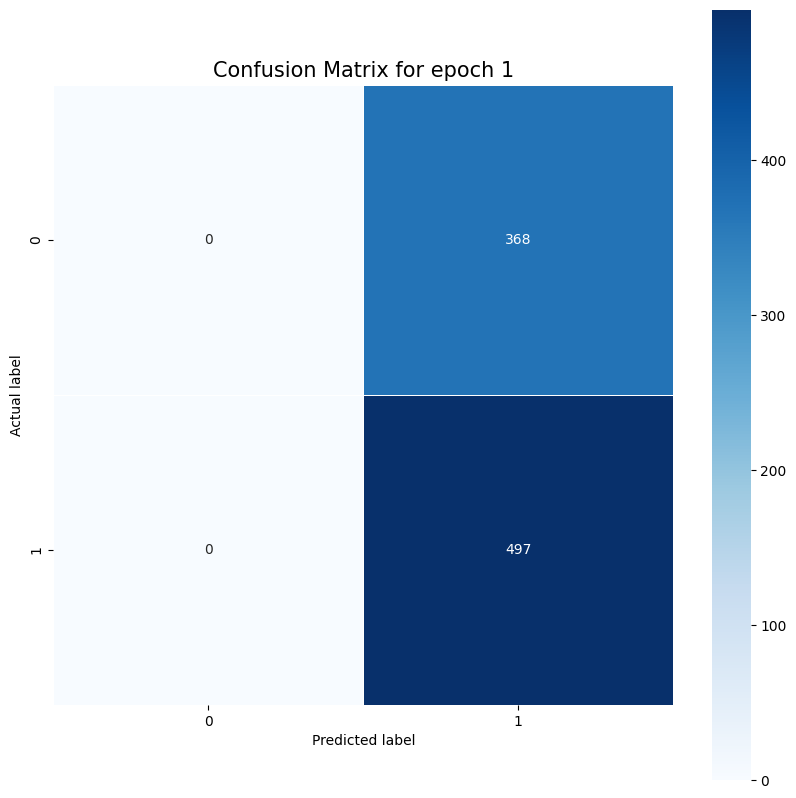

Epoch 2/10:   0%|          | 1/865 [00:04<1:01:12,  4.25s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   0%|          | 2/865 [00:06<46:00,  3.20s/it]  

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   0%|          | 3/865 [00:11<53:08,  3.70s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   0%|          | 4/865 [00:15<58:20,  4.07s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   1%|          | 5/865 [00:20<1:03:09,  4.41s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   1%|          | 6/865 [00:24<1:01:50,  4.32s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   1%|          | 7/865 [00:28<1:00:42,  4.25s/it]

Accuracy of the model after epoch 2: 100.0%


Epoch 2/10:   1%|          | 8/865 [00:33<1:04:17,  4.50s/it]

Accuracy of the model after epoch 2: 87.5%


Epoch 2/10:   1%|          | 9/865 [00:38<1:03:49,  4.47s/it]

Accuracy of the model after epoch 2: 77.77777777777777%


Epoch 2/10:   1%|          | 10/865 [00:42<1:03:57,  4.49s/it]

Accuracy of the model after epoch 2: 80.0%


Epoch 2/10:   1%|▏         | 11/865 [00:47<1:02:20,  4.38s/it]

Accuracy of the model after epoch 2: 81.81818181818181%


Epoch 2/10:   1%|▏         | 12/865 [00:51<1:01:55,  4.36s/it]

Accuracy of the model after epoch 2: 75.0%


Epoch 2/10:   2%|▏         | 13/865 [00:55<1:02:34,  4.41s/it]

Accuracy of the model after epoch 2: 69.23076923076923%


Epoch 2/10:   2%|▏         | 14/865 [01:00<1:04:13,  4.53s/it]

Accuracy of the model after epoch 2: 64.28571428571429%


Epoch 2/10:   2%|▏         | 15/865 [01:05<1:04:07,  4.53s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   2%|▏         | 16/865 [01:09<1:02:27,  4.41s/it]

Accuracy of the model after epoch 2: 62.5%


Epoch 2/10:   2%|▏         | 17/865 [01:11<54:14,  3.84s/it]  

Accuracy of the model after epoch 2: 64.70588235294117%


Epoch 2/10:   2%|▏         | 18/865 [01:16<57:06,  4.04s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   2%|▏         | 19/865 [01:21<1:02:18,  4.42s/it]

Accuracy of the model after epoch 2: 68.42105263157895%


Epoch 2/10:   2%|▏         | 20/865 [01:26<1:03:12,  4.49s/it]

Accuracy of the model after epoch 2: 70.0%


Epoch 2/10:   2%|▏         | 21/865 [01:30<1:02:15,  4.43s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   3%|▎         | 22/865 [01:34<1:00:50,  4.33s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   3%|▎         | 23/865 [01:39<1:02:14,  4.43s/it]

Accuracy of the model after epoch 2: 65.21739130434783%


Epoch 2/10:   3%|▎         | 24/865 [01:44<1:05:15,  4.66s/it]

Accuracy of the model after epoch 2: 62.5%


Epoch 2/10:   3%|▎         | 25/865 [01:49<1:06:05,  4.72s/it]

Accuracy of the model after epoch 2: 64.0%


Epoch 2/10:   3%|▎         | 26/865 [01:53<1:03:47,  4.56s/it]

Accuracy of the model after epoch 2: 65.38461538461539%


Epoch 2/10:   3%|▎         | 27/865 [01:56<55:02,  3.94s/it]  

Accuracy of the model after epoch 2: 62.96296296296296%


Epoch 2/10:   3%|▎         | 28/865 [01:58<49:03,  3.52s/it]

Accuracy of the model after epoch 2: 64.28571428571429%


Epoch 2/10:   3%|▎         | 29/865 [02:01<45:03,  3.23s/it]

Accuracy of the model after epoch 2: 65.51724137931035%


Epoch 2/10:   3%|▎         | 30/865 [02:05<50:30,  3.63s/it]

Accuracy of the model after epoch 2: 63.333333333333336%


Epoch 2/10:   4%|▎         | 31/865 [02:10<54:09,  3.90s/it]

Accuracy of the model after epoch 2: 61.29032258064516%


Epoch 2/10:   4%|▎         | 32/865 [02:14<55:36,  4.01s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:   4%|▍         | 33/865 [02:19<59:51,  4.32s/it]

Accuracy of the model after epoch 2: 60.60606060606061%


Epoch 2/10:   4%|▍         | 34/865 [02:24<1:02:30,  4.51s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:   4%|▍         | 35/865 [02:29<1:05:04,  4.70s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   4%|▍         | 36/865 [02:34<1:03:48,  4.62s/it]

Accuracy of the model after epoch 2: 55.55555555555556%


Epoch 2/10:   4%|▍         | 37/865 [02:38<1:03:07,  4.57s/it]

Accuracy of the model after epoch 2: 54.054054054054056%


Epoch 2/10:   4%|▍         | 38/865 [02:40<53:45,  3.90s/it]  

Accuracy of the model after epoch 2: 55.26315789473684%


Epoch 2/10:   5%|▍         | 39/865 [02:43<47:54,  3.48s/it]

Accuracy of the model after epoch 2: 53.84615384615385%


Epoch 2/10:   5%|▍         | 40/865 [02:47<52:18,  3.80s/it]

Accuracy of the model after epoch 2: 55.0%


Epoch 2/10:   5%|▍         | 41/865 [02:50<46:21,  3.38s/it]

Accuracy of the model after epoch 2: 56.09756097560975%


Epoch 2/10:   5%|▍         | 42/865 [02:54<49:44,  3.63s/it]

Accuracy of the model after epoch 2: 57.142857142857146%


Epoch 2/10:   5%|▍         | 43/865 [02:59<54:13,  3.96s/it]

Accuracy of the model after epoch 2: 55.81395348837209%


Epoch 2/10:   5%|▌         | 44/865 [03:03<56:48,  4.15s/it]

Accuracy of the model after epoch 2: 56.81818181818182%


Epoch 2/10:   5%|▌         | 45/865 [03:06<50:30,  3.70s/it]

Accuracy of the model after epoch 2: 57.77777777777778%


Epoch 2/10:   5%|▌         | 46/865 [03:10<52:41,  3.86s/it]

Accuracy of the model after epoch 2: 58.69565217391305%


Epoch 2/10:   5%|▌         | 47/865 [03:15<55:21,  4.06s/it]

Accuracy of the model after epoch 2: 59.57446808510638%


Epoch 2/10:   6%|▌         | 48/865 [03:19<56:19,  4.14s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:   6%|▌         | 49/865 [03:24<58:15,  4.28s/it]

Accuracy of the model after epoch 2: 59.183673469387756%


Epoch 2/10:   6%|▌         | 50/865 [03:28<59:23,  4.37s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:   6%|▌         | 51/865 [03:33<1:00:08,  4.43s/it]

Accuracy of the model after epoch 2: 60.78431372549019%


Epoch 2/10:   6%|▌         | 52/865 [03:35<51:48,  3.82s/it]  

Accuracy of the model after epoch 2: 61.53846153846154%


Epoch 2/10:   6%|▌         | 53/865 [03:38<46:41,  3.45s/it]

Accuracy of the model after epoch 2: 62.264150943396224%


Epoch 2/10:   6%|▌         | 54/865 [03:42<48:31,  3.59s/it]

Accuracy of the model after epoch 2: 62.96296296296296%


Epoch 2/10:   6%|▋         | 55/865 [03:47<54:26,  4.03s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   6%|▋         | 56/865 [03:49<48:06,  3.57s/it]

Accuracy of the model after epoch 2: 64.28571428571429%


Epoch 2/10:   7%|▋         | 57/865 [03:52<42:41,  3.17s/it]

Accuracy of the model after epoch 2: 64.91228070175438%


Epoch 2/10:   7%|▋         | 58/865 [03:56<47:36,  3.54s/it]

Accuracy of the model after epoch 2: 65.51724137931035%


Epoch 2/10:   7%|▋         | 59/865 [03:58<42:55,  3.20s/it]

Accuracy of the model after epoch 2: 64.40677966101696%


Epoch 2/10:   7%|▋         | 60/865 [04:03<48:51,  3.64s/it]

Accuracy of the model after epoch 2: 65.0%


Epoch 2/10:   7%|▋         | 61/865 [04:07<51:19,  3.83s/it]

Accuracy of the model after epoch 2: 65.57377049180327%


Epoch 2/10:   7%|▋         | 62/865 [04:11<52:21,  3.91s/it]

Accuracy of the model after epoch 2: 64.51612903225806%


Epoch 2/10:   7%|▋         | 63/865 [04:17<57:13,  4.28s/it]

Accuracy of the model after epoch 2: 65.07936507936508%


Epoch 2/10:   7%|▋         | 64/865 [04:19<49:48,  3.73s/it]

Accuracy of the model after epoch 2: 65.625%


Epoch 2/10:   8%|▊         | 65/865 [04:23<52:22,  3.93s/it]

Accuracy of the model after epoch 2: 66.15384615384616%


Epoch 2/10:   8%|▊         | 66/865 [04:28<53:12,  4.00s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   8%|▊         | 67/865 [04:32<54:37,  4.11s/it]

Accuracy of the model after epoch 2: 65.67164179104478%


Epoch 2/10:   8%|▊         | 68/865 [04:36<56:21,  4.24s/it]

Accuracy of the model after epoch 2: 66.17647058823529%


Epoch 2/10:   8%|▊         | 69/865 [04:42<1:00:16,  4.54s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   8%|▊         | 70/865 [04:46<1:00:12,  4.54s/it]

Accuracy of the model after epoch 2: 65.71428571428571%


Epoch 2/10:   8%|▊         | 71/865 [04:49<52:11,  3.94s/it]  

Accuracy of the model after epoch 2: 66.19718309859155%


Epoch 2/10:   8%|▊         | 72/865 [04:53<54:14,  4.10s/it]

Accuracy of the model after epoch 2: 66.66666666666667%


Epoch 2/10:   8%|▊         | 73/865 [04:58<54:47,  4.15s/it]

Accuracy of the model after epoch 2: 65.75342465753425%


Epoch 2/10:   9%|▊         | 74/865 [05:02<55:42,  4.23s/it]

Accuracy of the model after epoch 2: 66.21621621621621%


Epoch 2/10:   9%|▊         | 75/865 [05:06<56:54,  4.32s/it]

Accuracy of the model after epoch 2: 65.33333333333333%


Epoch 2/10:   9%|▉         | 76/865 [05:11<56:49,  4.32s/it]

Accuracy of the model after epoch 2: 64.47368421052632%


Epoch 2/10:   9%|▉         | 77/865 [05:15<56:57,  4.34s/it]

Accuracy of the model after epoch 2: 63.63636363636363%


Epoch 2/10:   9%|▉         | 78/865 [05:20<57:56,  4.42s/it]

Accuracy of the model after epoch 2: 62.82051282051282%


Epoch 2/10:   9%|▉         | 79/865 [05:25<1:02:30,  4.77s/it]

Accuracy of the model after epoch 2: 62.0253164556962%


Epoch 2/10:   9%|▉         | 80/865 [05:28<54:16,  4.15s/it]  

Accuracy of the model after epoch 2: 61.25%


Epoch 2/10:   9%|▉         | 81/865 [05:33<56:33,  4.33s/it]

Accuracy of the model after epoch 2: 61.72839506172839%


Epoch 2/10:   9%|▉         | 82/865 [05:37<56:06,  4.30s/it]

Accuracy of the model after epoch 2: 62.19512195121951%


Epoch 2/10:  10%|▉         | 83/865 [05:41<55:43,  4.28s/it]

Accuracy of the model after epoch 2: 62.65060240963855%


Epoch 2/10:  10%|▉         | 84/865 [05:46<56:30,  4.34s/it]

Accuracy of the model after epoch 2: 63.095238095238095%


Epoch 2/10:  10%|▉         | 85/865 [05:49<50:15,  3.87s/it]

Accuracy of the model after epoch 2: 63.529411764705884%


Epoch 2/10:  10%|▉         | 86/865 [05:53<52:31,  4.05s/it]

Accuracy of the model after epoch 2: 63.95348837209303%


Epoch 2/10:  10%|█         | 87/865 [05:55<45:47,  3.53s/it]

Accuracy of the model after epoch 2: 63.2183908045977%


Epoch 2/10:  10%|█         | 88/865 [05:58<41:34,  3.21s/it]

Accuracy of the model after epoch 2: 62.5%


Epoch 2/10:  10%|█         | 89/865 [06:00<38:41,  2.99s/it]

Accuracy of the model after epoch 2: 61.79775280898876%


Epoch 2/10:  10%|█         | 90/865 [06:05<44:54,  3.48s/it]

Accuracy of the model after epoch 2: 62.22222222222222%


Epoch 2/10:  11%|█         | 91/865 [06:09<48:21,  3.75s/it]

Accuracy of the model after epoch 2: 62.637362637362635%


Epoch 2/10:  11%|█         | 92/865 [06:14<51:38,  4.01s/it]

Accuracy of the model after epoch 2: 61.95652173913044%


Epoch 2/10:  11%|█         | 93/865 [06:19<55:59,  4.35s/it]

Accuracy of the model after epoch 2: 62.365591397849464%


Epoch 2/10:  11%|█         | 94/865 [06:24<59:18,  4.62s/it]

Accuracy of the model after epoch 2: 62.765957446808514%


Epoch 2/10:  11%|█         | 95/865 [06:29<58:24,  4.55s/it]

Accuracy of the model after epoch 2: 63.1578947368421%


Epoch 2/10:  11%|█         | 96/865 [06:33<58:20,  4.55s/it]

Accuracy of the model after epoch 2: 63.541666666666664%


Epoch 2/10:  11%|█         | 97/865 [06:38<57:24,  4.49s/it]

Accuracy of the model after epoch 2: 62.88659793814433%


Epoch 2/10:  11%|█▏        | 98/865 [06:42<57:36,  4.51s/it]

Accuracy of the model after epoch 2: 62.244897959183675%


Epoch 2/10:  11%|█▏        | 99/865 [06:47<59:27,  4.66s/it]

Accuracy of the model after epoch 2: 61.61616161616162%


Epoch 2/10:  12%|█▏        | 100/865 [06:52<58:45,  4.61s/it]

Accuracy of the model after epoch 2: 61.0%


Epoch 2/10:  12%|█▏        | 101/865 [06:54<49:51,  3.92s/it]

Accuracy of the model after epoch 2: 60.396039603960396%


Epoch 2/10:  12%|█▏        | 102/865 [06:58<50:02,  3.94s/it]

Accuracy of the model after epoch 2: 60.78431372549019%


Epoch 2/10:  12%|█▏        | 103/865 [07:00<44:43,  3.52s/it]

Accuracy of the model after epoch 2: 60.19417475728155%


Epoch 2/10:  12%|█▏        | 104/865 [07:05<48:44,  3.84s/it]

Accuracy of the model after epoch 2: 59.61538461538461%


Epoch 2/10:  12%|█▏        | 105/865 [07:09<50:53,  4.02s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  12%|█▏        | 106/865 [07:14<51:59,  4.11s/it]

Accuracy of the model after epoch 2: 59.43396226415094%


Epoch 2/10:  12%|█▏        | 107/865 [07:18<52:26,  4.15s/it]

Accuracy of the model after epoch 2: 58.87850467289719%


Epoch 2/10:  12%|█▏        | 108/865 [07:23<56:05,  4.45s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  13%|█▎        | 109/865 [07:26<49:28,  3.93s/it]

Accuracy of the model after epoch 2: 58.71559633027523%


Epoch 2/10:  13%|█▎        | 110/865 [07:30<51:40,  4.11s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:  13%|█▎        | 111/865 [07:35<52:55,  4.21s/it]

Accuracy of the model after epoch 2: 59.45945945945946%


Epoch 2/10:  13%|█▎        | 112/865 [07:39<53:03,  4.23s/it]

Accuracy of the model after epoch 2: 59.82142857142857%


Epoch 2/10:  13%|█▎        | 113/865 [07:44<54:05,  4.32s/it]

Accuracy of the model after epoch 2: 60.176991150442475%


Epoch 2/10:  13%|█▎        | 114/865 [07:48<55:05,  4.40s/it]

Accuracy of the model after epoch 2: 60.526315789473685%


Epoch 2/10:  13%|█▎        | 115/865 [07:51<48:58,  3.92s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  13%|█▎        | 116/865 [07:55<50:54,  4.08s/it]

Accuracy of the model after epoch 2: 59.48275862068966%


Epoch 2/10:  14%|█▎        | 117/865 [08:00<51:59,  4.17s/it]

Accuracy of the model after epoch 2: 59.82905982905983%


Epoch 2/10:  14%|█▎        | 118/865 [08:02<45:43,  3.67s/it]

Accuracy of the model after epoch 2: 59.32203389830509%


Epoch 2/10:  14%|█▍        | 119/865 [08:05<41:30,  3.34s/it]

Accuracy of the model after epoch 2: 59.66386554621849%


Epoch 2/10:  14%|█▍        | 120/865 [08:10<46:52,  3.78s/it]

Accuracy of the model after epoch 2: 59.166666666666664%


Epoch 2/10:  14%|█▍        | 121/865 [08:12<41:32,  3.35s/it]

Accuracy of the model after epoch 2: 59.50413223140496%


Epoch 2/10:  14%|█▍        | 122/865 [08:14<37:32,  3.03s/it]

Accuracy of the model after epoch 2: 59.01639344262295%


Epoch 2/10:  14%|█▍        | 123/865 [08:19<41:39,  3.37s/it]

Accuracy of the model after epoch 2: 59.34959349593496%


Epoch 2/10:  14%|█▍        | 124/865 [08:21<38:18,  3.10s/it]

Accuracy of the model after epoch 2: 59.67741935483871%


Epoch 2/10:  14%|█▍        | 125/865 [08:24<37:25,  3.03s/it]

Accuracy of the model after epoch 2: 59.2%


Epoch 2/10:  15%|█▍        | 126/865 [08:28<41:37,  3.38s/it]

Accuracy of the model after epoch 2: 58.73015873015873%


Epoch 2/10:  15%|█▍        | 127/865 [08:33<46:03,  3.74s/it]

Accuracy of the model after epoch 2: 58.267716535433074%


Epoch 2/10:  15%|█▍        | 128/865 [08:37<47:31,  3.87s/it]

Accuracy of the model after epoch 2: 58.59375%


Epoch 2/10:  15%|█▍        | 129/865 [08:42<50:25,  4.11s/it]

Accuracy of the model after epoch 2: 58.91472868217054%


Epoch 2/10:  15%|█▌        | 130/865 [08:44<44:37,  3.64s/it]

Accuracy of the model after epoch 2: 59.23076923076923%


Epoch 2/10:  15%|█▌        | 131/865 [08:48<46:42,  3.82s/it]

Accuracy of the model after epoch 2: 59.541984732824424%


Epoch 2/10:  15%|█▌        | 132/865 [08:53<50:16,  4.12s/it]

Accuracy of the model after epoch 2: 59.84848484848485%


Epoch 2/10:  15%|█▌        | 133/865 [08:58<51:20,  4.21s/it]

Accuracy of the model after epoch 2: 60.150375939849624%


Epoch 2/10:  15%|█▌        | 134/865 [09:02<52:23,  4.30s/it]

Accuracy of the model after epoch 2: 59.701492537313435%


Epoch 2/10:  16%|█▌        | 135/865 [09:07<53:21,  4.39s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  16%|█▌        | 136/865 [09:09<46:39,  3.84s/it]

Accuracy of the model after epoch 2: 60.294117647058826%


Epoch 2/10:  16%|█▌        | 137/865 [09:14<48:34,  4.00s/it]

Accuracy of the model after epoch 2: 59.85401459854015%


Epoch 2/10:  16%|█▌        | 138/865 [09:18<49:09,  4.06s/it]

Accuracy of the model after epoch 2: 60.14492753623188%


Epoch 2/10:  16%|█▌        | 139/865 [09:23<52:27,  4.34s/it]

Accuracy of the model after epoch 2: 59.71223021582734%


Epoch 2/10:  16%|█▌        | 140/865 [09:27<53:19,  4.41s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  16%|█▋        | 141/865 [09:32<53:53,  4.47s/it]

Accuracy of the model after epoch 2: 60.283687943262414%


Epoch 2/10:  16%|█▋        | 142/865 [09:36<52:14,  4.33s/it]

Accuracy of the model after epoch 2: 60.563380281690144%


Epoch 2/10:  17%|█▋        | 143/865 [09:40<52:02,  4.32s/it]

Accuracy of the model after epoch 2: 60.13986013986014%


Epoch 2/10:  17%|█▋        | 144/865 [09:45<53:49,  4.48s/it]

Accuracy of the model after epoch 2: 59.72222222222222%


Epoch 2/10:  17%|█▋        | 145/865 [09:50<56:15,  4.69s/it]

Accuracy of the model after epoch 2: 59.310344827586206%


Epoch 2/10:  17%|█▋        | 146/865 [09:55<54:34,  4.55s/it]

Accuracy of the model after epoch 2: 59.58904109589041%


Epoch 2/10:  17%|█▋        | 147/865 [09:59<55:29,  4.64s/it]

Accuracy of the model after epoch 2: 59.863945578231295%


Epoch 2/10:  17%|█▋        | 148/865 [10:04<53:52,  4.51s/it]

Accuracy of the model after epoch 2: 59.45945945945946%


Epoch 2/10:  17%|█▋        | 149/865 [10:06<45:44,  3.83s/it]

Accuracy of the model after epoch 2: 59.73154362416108%


Epoch 2/10:  17%|█▋        | 150/865 [10:10<48:04,  4.03s/it]

Accuracy of the model after epoch 2: 59.333333333333336%


Epoch 2/10:  17%|█▋        | 151/865 [10:14<48:20,  4.06s/it]

Accuracy of the model after epoch 2: 59.602649006622514%


Epoch 2/10:  18%|█▊        | 152/865 [10:19<51:41,  4.35s/it]

Accuracy of the model after epoch 2: 59.21052631578947%


Epoch 2/10:  18%|█▊        | 153/865 [10:25<54:15,  4.57s/it]

Accuracy of the model after epoch 2: 59.47712418300654%


Epoch 2/10:  18%|█▊        | 154/865 [10:30<56:41,  4.78s/it]

Accuracy of the model after epoch 2: 59.74025974025974%


Epoch 2/10:  18%|█▊        | 155/865 [10:34<56:04,  4.74s/it]

Accuracy of the model after epoch 2: 59.354838709677416%


Epoch 2/10:  18%|█▊        | 156/865 [10:39<54:24,  4.60s/it]

Accuracy of the model after epoch 2: 58.97435897435897%


Epoch 2/10:  18%|█▊        | 157/865 [10:43<53:09,  4.51s/it]

Accuracy of the model after epoch 2: 59.23566878980892%


Epoch 2/10:  18%|█▊        | 158/865 [10:48<53:51,  4.57s/it]

Accuracy of the model after epoch 2: 59.49367088607595%


Epoch 2/10:  18%|█▊        | 159/865 [10:53<54:53,  4.66s/it]

Accuracy of the model after epoch 2: 59.119496855345915%


Epoch 2/10:  18%|█▊        | 160/865 [10:57<54:20,  4.62s/it]

Accuracy of the model after epoch 2: 58.75%


Epoch 2/10:  19%|█▊        | 161/865 [11:01<52:27,  4.47s/it]

Accuracy of the model after epoch 2: 59.006211180124225%


Epoch 2/10:  19%|█▊        | 162/865 [11:04<44:57,  3.84s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  19%|█▉        | 163/865 [11:08<47:25,  4.05s/it]

Accuracy of the model after epoch 2: 58.895705521472394%


Epoch 2/10:  19%|█▉        | 164/865 [11:13<48:28,  4.15s/it]

Accuracy of the model after epoch 2: 58.53658536585366%


Epoch 2/10:  19%|█▉        | 165/865 [11:17<49:27,  4.24s/it]

Accuracy of the model after epoch 2: 58.78787878787879%


Epoch 2/10:  19%|█▉        | 166/865 [11:21<49:28,  4.25s/it]

Accuracy of the model after epoch 2: 59.036144578313255%


Epoch 2/10:  19%|█▉        | 167/865 [11:24<43:18,  3.72s/it]

Accuracy of the model after epoch 2: 58.68263473053892%


Epoch 2/10:  19%|█▉        | 168/865 [11:28<45:19,  3.90s/it]

Accuracy of the model after epoch 2: 58.92857142857143%


Epoch 2/10:  20%|█▉        | 169/865 [11:31<40:04,  3.45s/it]

Accuracy of the model after epoch 2: 58.57988165680474%


Epoch 2/10:  20%|█▉        | 170/865 [11:36<45:24,  3.92s/it]

Accuracy of the model after epoch 2: 58.23529411764706%


Epoch 2/10:  20%|█▉        | 171/865 [11:38<41:04,  3.55s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:  20%|█▉        | 172/865 [11:42<43:17,  3.75s/it]

Accuracy of the model after epoch 2: 57.55813953488372%


Epoch 2/10:  20%|██        | 173/865 [11:47<47:03,  4.08s/it]

Accuracy of the model after epoch 2: 57.80346820809248%


Epoch 2/10:  20%|██        | 174/865 [11:53<51:02,  4.43s/it]

Accuracy of the model after epoch 2: 58.04597701149425%


Epoch 2/10:  20%|██        | 175/865 [11:57<50:56,  4.43s/it]

Accuracy of the model after epoch 2: 58.285714285714285%


Epoch 2/10:  20%|██        | 176/865 [12:01<50:11,  4.37s/it]

Accuracy of the model after epoch 2: 57.95454545454545%


Epoch 2/10:  20%|██        | 177/865 [12:05<49:27,  4.31s/it]

Accuracy of the model after epoch 2: 58.19209039548023%


Epoch 2/10:  21%|██        | 178/865 [12:10<51:54,  4.53s/it]

Accuracy of the model after epoch 2: 57.86516853932584%


Epoch 2/10:  21%|██        | 179/865 [12:16<55:46,  4.88s/it]

Accuracy of the model after epoch 2: 58.100558659217874%


Epoch 2/10:  21%|██        | 180/865 [12:21<54:11,  4.75s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  21%|██        | 181/865 [12:25<52:24,  4.60s/it]

Accuracy of the model after epoch 2: 58.56353591160221%


Epoch 2/10:  21%|██        | 182/865 [12:29<50:52,  4.47s/it]

Accuracy of the model after epoch 2: 58.79120879120879%


Epoch 2/10:  21%|██        | 183/865 [12:34<51:46,  4.56s/it]

Accuracy of the model after epoch 2: 58.46994535519126%


Epoch 2/10:  21%|██▏       | 184/865 [12:36<44:53,  3.95s/it]

Accuracy of the model after epoch 2: 58.69565217391305%


Epoch 2/10:  21%|██▏       | 185/865 [12:41<46:37,  4.11s/it]

Accuracy of the model after epoch 2: 58.91891891891892%


Epoch 2/10:  22%|██▏       | 186/865 [12:45<47:13,  4.17s/it]

Accuracy of the model after epoch 2: 58.60215053763441%


Epoch 2/10:  22%|██▏       | 187/865 [12:49<47:43,  4.22s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  22%|██▏       | 188/865 [12:54<49:04,  4.35s/it]

Accuracy of the model after epoch 2: 59.04255319148936%


Epoch 2/10:  22%|██▏       | 189/865 [12:57<42:47,  3.80s/it]

Accuracy of the model after epoch 2: 58.73015873015873%


Epoch 2/10:  22%|██▏       | 190/865 [13:01<46:33,  4.14s/it]

Accuracy of the model after epoch 2: 58.421052631578945%


Epoch 2/10:  22%|██▏       | 191/865 [13:04<40:17,  3.59s/it]

Accuracy of the model after epoch 2: 58.638743455497384%


Epoch 2/10:  22%|██▏       | 192/865 [13:06<36:33,  3.26s/it]

Accuracy of the model after epoch 2: 58.854166666666664%


Epoch 2/10:  22%|██▏       | 193/865 [13:11<40:04,  3.58s/it]

Accuracy of the model after epoch 2: 58.54922279792746%


Epoch 2/10:  22%|██▏       | 194/865 [13:15<42:40,  3.82s/it]

Accuracy of the model after epoch 2: 58.76288659793814%


Epoch 2/10:  23%|██▎       | 195/865 [13:18<38:55,  3.49s/it]

Accuracy of the model after epoch 2: 58.46153846153846%


Epoch 2/10:  23%|██▎       | 196/865 [13:20<35:34,  3.19s/it]

Accuracy of the model after epoch 2: 58.16326530612245%


Epoch 2/10:  23%|██▎       | 197/865 [13:24<38:14,  3.44s/it]

Accuracy of the model after epoch 2: 58.3756345177665%


Epoch 2/10:  23%|██▎       | 198/865 [13:28<40:36,  3.65s/it]

Accuracy of the model after epoch 2: 58.58585858585859%


Epoch 2/10:  23%|██▎       | 199/865 [13:33<42:11,  3.80s/it]

Accuracy of the model after epoch 2: 58.29145728643216%


Epoch 2/10:  23%|██▎       | 200/865 [13:37<44:41,  4.03s/it]

Accuracy of the model after epoch 2: 58.0%


Epoch 2/10:  23%|██▎       | 201/865 [13:41<45:18,  4.09s/it]

Accuracy of the model after epoch 2: 58.208955223880594%


Epoch 2/10:  23%|██▎       | 202/865 [13:46<47:11,  4.27s/it]

Accuracy of the model after epoch 2: 57.92079207920792%


Epoch 2/10:  23%|██▎       | 203/865 [13:51<48:22,  4.38s/it]

Accuracy of the model after epoch 2: 58.12807881773399%


Epoch 2/10:  24%|██▎       | 204/865 [13:53<41:33,  3.77s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  24%|██▎       | 205/865 [13:57<43:41,  3.97s/it]

Accuracy of the model after epoch 2: 58.53658536585366%


Epoch 2/10:  24%|██▍       | 206/865 [14:02<44:45,  4.08s/it]

Accuracy of the model after epoch 2: 58.25242718446602%


Epoch 2/10:  24%|██▍       | 207/865 [14:06<45:12,  4.12s/it]

Accuracy of the model after epoch 2: 57.971014492753625%


Epoch 2/10:  24%|██▍       | 208/865 [14:11<47:27,  4.33s/it]

Accuracy of the model after epoch 2: 58.17307692307692%


Epoch 2/10:  24%|██▍       | 209/865 [14:16<50:37,  4.63s/it]

Accuracy of the model after epoch 2: 58.3732057416268%


Epoch 2/10:  24%|██▍       | 210/865 [14:21<52:00,  4.76s/it]

Accuracy of the model after epoch 2: 58.095238095238095%


Epoch 2/10:  24%|██▍       | 211/865 [14:26<51:39,  4.74s/it]

Accuracy of the model after epoch 2: 58.29383886255924%


Epoch 2/10:  25%|██▍       | 212/865 [14:28<43:23,  3.99s/it]

Accuracy of the model after epoch 2: 58.0188679245283%


Epoch 2/10:  25%|██▍       | 213/865 [14:33<45:21,  4.17s/it]

Accuracy of the model after epoch 2: 57.74647887323944%


Epoch 2/10:  25%|██▍       | 214/865 [14:38<47:44,  4.40s/it]

Accuracy of the model after epoch 2: 57.94392523364486%


Epoch 2/10:  25%|██▍       | 215/865 [14:42<47:58,  4.43s/it]

Accuracy of the model after epoch 2: 57.674418604651166%


Epoch 2/10:  25%|██▍       | 216/865 [14:45<41:18,  3.82s/it]

Accuracy of the model after epoch 2: 57.407407407407405%


Epoch 2/10:  25%|██▌       | 217/865 [14:49<42:37,  3.95s/it]

Accuracy of the model after epoch 2: 57.6036866359447%


Epoch 2/10:  25%|██▌       | 218/865 [14:51<38:09,  3.54s/it]

Accuracy of the model after epoch 2: 57.3394495412844%


Epoch 2/10:  25%|██▌       | 219/865 [14:56<40:17,  3.74s/it]

Accuracy of the model after epoch 2: 57.534246575342465%


Epoch 2/10:  25%|██▌       | 220/865 [15:00<42:31,  3.96s/it]

Accuracy of the model after epoch 2: 57.72727272727273%


Epoch 2/10:  26%|██▌       | 221/865 [15:05<45:18,  4.22s/it]

Accuracy of the model after epoch 2: 57.918552036199095%


Epoch 2/10:  26%|██▌       | 222/865 [15:09<44:43,  4.17s/it]

Accuracy of the model after epoch 2: 58.108108108108105%


Epoch 2/10:  26%|██▌       | 223/865 [15:14<46:11,  4.32s/it]

Accuracy of the model after epoch 2: 57.847533632286996%


Epoch 2/10:  26%|██▌       | 224/865 [15:16<40:21,  3.78s/it]

Accuracy of the model after epoch 2: 57.589285714285715%


Epoch 2/10:  26%|██▌       | 225/865 [15:20<42:01,  3.94s/it]

Accuracy of the model after epoch 2: 57.77777777777778%


Epoch 2/10:  26%|██▌       | 226/865 [15:23<37:10,  3.49s/it]

Accuracy of the model after epoch 2: 57.9646017699115%


Epoch 2/10:  26%|██▌       | 227/865 [15:27<39:30,  3.72s/it]

Accuracy of the model after epoch 2: 58.14977973568282%


Epoch 2/10:  26%|██▋       | 228/865 [15:31<40:55,  3.86s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  26%|██▋       | 229/865 [15:36<43:13,  4.08s/it]

Accuracy of the model after epoch 2: 58.51528384279476%


Epoch 2/10:  27%|██▋       | 230/865 [15:40<44:40,  4.22s/it]

Accuracy of the model after epoch 2: 58.69565217391305%


Epoch 2/10:  27%|██▋       | 231/865 [15:45<44:22,  4.20s/it]

Accuracy of the model after epoch 2: 58.874458874458874%


Epoch 2/10:  27%|██▋       | 232/865 [15:49<44:42,  4.24s/it]

Accuracy of the model after epoch 2: 58.62068965517241%


Epoch 2/10:  27%|██▋       | 233/865 [15:54<45:56,  4.36s/it]

Accuracy of the model after epoch 2: 58.798283261802574%


Epoch 2/10:  27%|██▋       | 234/865 [15:56<40:26,  3.84s/it]

Accuracy of the model after epoch 2: 58.97435897435897%


Epoch 2/10:  27%|██▋       | 235/865 [15:59<36:45,  3.50s/it]

Accuracy of the model after epoch 2: 59.148936170212764%


Epoch 2/10:  27%|██▋       | 236/865 [16:03<38:38,  3.69s/it]

Accuracy of the model after epoch 2: 58.898305084745765%


Epoch 2/10:  27%|██▋       | 237/865 [16:08<41:12,  3.94s/it]

Accuracy of the model after epoch 2: 59.07172995780591%


Epoch 2/10:  28%|██▊       | 238/865 [16:12<42:32,  4.07s/it]

Accuracy of the model after epoch 2: 59.2436974789916%


Epoch 2/10:  28%|██▊       | 239/865 [16:14<37:31,  3.60s/it]

Accuracy of the model after epoch 2: 59.41422594142259%


Epoch 2/10:  28%|██▊       | 240/865 [16:19<39:51,  3.83s/it]

Accuracy of the model after epoch 2: 59.166666666666664%


Epoch 2/10:  28%|██▊       | 241/865 [16:21<34:51,  3.35s/it]

Accuracy of the model after epoch 2: 58.92116182572614%


Epoch 2/10:  28%|██▊       | 242/865 [16:25<37:57,  3.66s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:  28%|██▊       | 243/865 [16:30<39:48,  3.84s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  28%|██▊       | 244/865 [16:32<34:53,  3.37s/it]

Accuracy of the model after epoch 2: 59.01639344262295%


Epoch 2/10:  28%|██▊       | 245/865 [16:37<39:27,  3.82s/it]

Accuracy of the model after epoch 2: 59.183673469387756%


Epoch 2/10:  28%|██▊       | 246/865 [16:39<34:57,  3.39s/it]

Accuracy of the model after epoch 2: 58.94308943089431%


Epoch 2/10:  29%|██▊       | 247/865 [16:42<32:40,  3.17s/it]

Accuracy of the model after epoch 2: 58.70445344129555%


Epoch 2/10:  29%|██▊       | 248/865 [16:46<35:16,  3.43s/it]

Accuracy of the model after epoch 2: 58.87096774193548%


Epoch 2/10:  29%|██▉       | 249/865 [16:50<38:10,  3.72s/it]

Accuracy of the model after epoch 2: 58.63453815261044%


Epoch 2/10:  29%|██▉       | 250/865 [16:55<39:59,  3.90s/it]

Accuracy of the model after epoch 2: 58.8%


Epoch 2/10:  29%|██▉       | 251/865 [16:59<40:55,  4.00s/it]

Accuracy of the model after epoch 2: 58.96414342629482%


Epoch 2/10:  29%|██▉       | 252/865 [17:01<36:07,  3.54s/it]

Accuracy of the model after epoch 2: 59.12698412698413%


Epoch 2/10:  29%|██▉       | 253/865 [17:06<38:33,  3.78s/it]

Accuracy of the model after epoch 2: 59.28853754940712%


Epoch 2/10:  29%|██▉       | 254/865 [17:08<34:28,  3.39s/it]

Accuracy of the model after epoch 2: 59.05511811023622%


Epoch 2/10:  29%|██▉       | 255/865 [17:11<32:36,  3.21s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  30%|██▉       | 256/865 [17:15<35:11,  3.47s/it]

Accuracy of the model after epoch 2: 58.984375%


Epoch 2/10:  30%|██▉       | 257/865 [17:18<32:35,  3.22s/it]

Accuracy of the model after epoch 2: 59.143968871595334%


Epoch 2/10:  30%|██▉       | 258/865 [17:22<36:37,  3.62s/it]

Accuracy of the model after epoch 2: 59.30232558139535%


Epoch 2/10:  30%|██▉       | 259/865 [17:26<38:31,  3.81s/it]

Accuracy of the model after epoch 2: 59.07335907335907%


Epoch 2/10:  30%|███       | 260/865 [17:31<40:21,  4.00s/it]

Accuracy of the model after epoch 2: 59.23076923076923%


Epoch 2/10:  30%|███       | 261/865 [17:35<40:46,  4.05s/it]

Accuracy of the model after epoch 2: 59.00383141762452%


Epoch 2/10:  30%|███       | 262/865 [17:37<35:24,  3.52s/it]

Accuracy of the model after epoch 2: 59.16030534351145%


Epoch 2/10:  30%|███       | 263/865 [17:42<37:58,  3.78s/it]

Accuracy of the model after epoch 2: 58.93536121673004%


Epoch 2/10:  31%|███       | 264/865 [17:44<33:54,  3.38s/it]

Accuracy of the model after epoch 2: 59.09090909090909%


Epoch 2/10:  31%|███       | 265/865 [17:49<38:37,  3.86s/it]

Accuracy of the model after epoch 2: 59.24528301886792%


Epoch 2/10:  31%|███       | 266/865 [17:53<39:33,  3.96s/it]

Accuracy of the model after epoch 2: 59.3984962406015%


Epoch 2/10:  31%|███       | 267/865 [17:58<40:04,  4.02s/it]

Accuracy of the model after epoch 2: 59.176029962546814%


Epoch 2/10:  31%|███       | 268/865 [18:02<41:31,  4.17s/it]

Accuracy of the model after epoch 2: 59.32835820895522%


Epoch 2/10:  31%|███       | 269/865 [18:07<44:02,  4.43s/it]

Accuracy of the model after epoch 2: 59.10780669144982%


Epoch 2/10:  31%|███       | 270/865 [18:12<45:02,  4.54s/it]

Accuracy of the model after epoch 2: 58.888888888888886%


Epoch 2/10:  31%|███▏      | 271/865 [18:16<44:11,  4.46s/it]

Accuracy of the model after epoch 2: 59.04059040590406%


Epoch 2/10:  31%|███▏      | 272/865 [18:21<43:48,  4.43s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  32%|███▏      | 273/865 [18:23<38:21,  3.89s/it]

Accuracy of the model after epoch 2: 58.97435897435897%


Epoch 2/10:  32%|███▏      | 274/865 [18:27<39:28,  4.01s/it]

Accuracy of the model after epoch 2: 59.12408759124087%


Epoch 2/10:  32%|███▏      | 275/865 [18:32<42:17,  4.30s/it]

Accuracy of the model after epoch 2: 58.90909090909091%


Epoch 2/10:  32%|███▏      | 276/865 [18:36<41:26,  4.22s/it]

Accuracy of the model after epoch 2: 59.05797101449275%


Epoch 2/10:  32%|███▏      | 277/865 [18:39<35:47,  3.65s/it]

Accuracy of the model after epoch 2: 59.2057761732852%


Epoch 2/10:  32%|███▏      | 278/865 [18:43<37:17,  3.81s/it]

Accuracy of the model after epoch 2: 59.35251798561151%


Epoch 2/10:  32%|███▏      | 279/865 [18:45<33:18,  3.41s/it]

Accuracy of the model after epoch 2: 59.13978494623656%


Epoch 2/10:  32%|███▏      | 280/865 [18:48<30:40,  3.15s/it]

Accuracy of the model after epoch 2: 59.285714285714285%


Epoch 2/10:  32%|███▏      | 281/865 [18:50<28:14,  2.90s/it]

Accuracy of the model after epoch 2: 59.430604982206404%


Epoch 2/10:  33%|███▎      | 282/865 [18:55<32:23,  3.33s/it]

Accuracy of the model after epoch 2: 59.219858156028366%


Epoch 2/10:  33%|███▎      | 283/865 [18:59<34:21,  3.54s/it]

Accuracy of the model after epoch 2: 59.36395759717315%


Epoch 2/10:  33%|███▎      | 284/865 [19:01<31:02,  3.21s/it]

Accuracy of the model after epoch 2: 59.50704225352113%


Epoch 2/10:  33%|███▎      | 285/865 [19:05<34:29,  3.57s/it]

Accuracy of the model after epoch 2: 59.64912280701754%


Epoch 2/10:  33%|███▎      | 286/865 [19:10<36:14,  3.76s/it]

Accuracy of the model after epoch 2: 59.44055944055944%


Epoch 2/10:  33%|███▎      | 287/865 [19:12<32:37,  3.39s/it]

Accuracy of the model after epoch 2: 59.23344947735192%


Epoch 2/10:  33%|███▎      | 288/865 [19:16<35:06,  3.65s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:  33%|███▎      | 289/865 [19:22<39:16,  4.09s/it]

Accuracy of the model after epoch 2: 59.515570934256054%


Epoch 2/10:  34%|███▎      | 290/865 [19:26<40:43,  4.25s/it]

Accuracy of the model after epoch 2: 59.6551724137931%


Epoch 2/10:  34%|███▎      | 291/865 [19:31<40:55,  4.28s/it]

Accuracy of the model after epoch 2: 59.450171821305844%


Epoch 2/10:  34%|███▍      | 292/865 [19:35<40:10,  4.21s/it]

Accuracy of the model after epoch 2: 59.58904109589041%


Epoch 2/10:  34%|███▍      | 293/865 [19:39<40:18,  4.23s/it]

Accuracy of the model after epoch 2: 59.72696245733788%


Epoch 2/10:  34%|███▍      | 294/865 [19:44<41:54,  4.40s/it]

Accuracy of the model after epoch 2: 59.863945578231295%


Epoch 2/10:  34%|███▍      | 295/865 [19:48<42:19,  4.46s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  34%|███▍      | 296/865 [19:52<41:19,  4.36s/it]

Accuracy of the model after epoch 2: 60.13513513513514%


Epoch 2/10:  34%|███▍      | 297/865 [19:55<35:56,  3.80s/it]

Accuracy of the model after epoch 2: 60.26936026936027%


Epoch 2/10:  34%|███▍      | 298/865 [19:59<37:21,  3.95s/it]

Accuracy of the model after epoch 2: 60.06711409395973%


Epoch 2/10:  35%|███▍      | 299/865 [20:02<32:44,  3.47s/it]

Accuracy of the model after epoch 2: 60.20066889632107%


Epoch 2/10:  35%|███▍      | 300/865 [20:06<35:21,  3.75s/it]

Accuracy of the model after epoch 2: 60.333333333333336%


Epoch 2/10:  35%|███▍      | 301/865 [20:08<31:31,  3.35s/it]

Accuracy of the model after epoch 2: 60.46511627906977%


Epoch 2/10:  35%|███▍      | 302/865 [20:13<35:44,  3.81s/it]

Accuracy of the model after epoch 2: 60.264900662251655%


Epoch 2/10:  35%|███▌      | 303/865 [20:17<36:43,  3.92s/it]

Accuracy of the model after epoch 2: 60.06600660066007%


Epoch 2/10:  35%|███▌      | 304/865 [20:23<40:12,  4.30s/it]

Accuracy of the model after epoch 2: 59.86842105263158%


Epoch 2/10:  35%|███▌      | 305/865 [20:27<41:30,  4.45s/it]

Accuracy of the model after epoch 2: 59.67213114754098%


Epoch 2/10:  35%|███▌      | 306/865 [20:32<41:10,  4.42s/it]

Accuracy of the model after epoch 2: 59.47712418300654%


Epoch 2/10:  35%|███▌      | 307/865 [20:34<34:50,  3.75s/it]

Accuracy of the model after epoch 2: 59.60912052117264%


Epoch 2/10:  36%|███▌      | 308/865 [20:39<37:21,  4.02s/it]

Accuracy of the model after epoch 2: 59.74025974025974%


Epoch 2/10:  36%|███▌      | 309/865 [20:43<38:50,  4.19s/it]

Accuracy of the model after epoch 2: 59.54692556634304%


Epoch 2/10:  36%|███▌      | 310/865 [20:48<40:10,  4.34s/it]

Accuracy of the model after epoch 2: 59.354838709677416%


Epoch 2/10:  36%|███▌      | 311/865 [20:52<39:50,  4.31s/it]

Accuracy of the model after epoch 2: 59.48553054662379%


Epoch 2/10:  36%|███▌      | 312/865 [20:56<39:35,  4.29s/it]

Accuracy of the model after epoch 2: 59.61538461538461%


Epoch 2/10:  36%|███▌      | 313/865 [20:59<34:55,  3.80s/it]

Accuracy of the model after epoch 2: 59.424920127795524%


Epoch 2/10:  36%|███▋      | 314/865 [21:04<38:11,  4.16s/it]

Accuracy of the model after epoch 2: 59.23566878980892%


Epoch 2/10:  36%|███▋      | 315/865 [21:08<38:31,  4.20s/it]

Accuracy of the model after epoch 2: 59.36507936507937%


Epoch 2/10:  37%|███▋      | 316/865 [21:13<39:00,  4.26s/it]

Accuracy of the model after epoch 2: 59.49367088607595%


Epoch 2/10:  37%|███▋      | 317/865 [21:17<38:23,  4.20s/it]

Accuracy of the model after epoch 2: 59.62145110410095%


Epoch 2/10:  37%|███▋      | 318/865 [21:21<39:29,  4.33s/it]

Accuracy of the model after epoch 2: 59.74842767295598%


Epoch 2/10:  37%|███▋      | 319/865 [21:24<34:47,  3.82s/it]

Accuracy of the model after epoch 2: 59.56112852664577%


Epoch 2/10:  37%|███▋      | 320/865 [21:27<31:50,  3.51s/it]

Accuracy of the model after epoch 2: 59.6875%


Epoch 2/10:  37%|███▋      | 321/865 [21:31<33:15,  3.67s/it]

Accuracy of the model after epoch 2: 59.81308411214953%


Epoch 2/10:  37%|███▋      | 322/865 [21:35<34:49,  3.85s/it]

Accuracy of the model after epoch 2: 59.62732919254658%


Epoch 2/10:  37%|███▋      | 323/865 [21:39<35:53,  3.97s/it]

Accuracy of the model after epoch 2: 59.44272445820433%


Epoch 2/10:  37%|███▋      | 324/865 [21:42<31:57,  3.54s/it]

Accuracy of the model after epoch 2: 59.25925925925926%


Epoch 2/10:  38%|███▊      | 325/865 [21:47<34:36,  3.85s/it]

Accuracy of the model after epoch 2: 59.07692307692308%


Epoch 2/10:  38%|███▊      | 326/865 [21:51<35:20,  3.93s/it]

Accuracy of the model after epoch 2: 59.20245398773006%


Epoch 2/10:  38%|███▊      | 327/865 [21:55<36:20,  4.05s/it]

Accuracy of the model after epoch 2: 59.02140672782875%


Epoch 2/10:  38%|███▊      | 328/865 [21:59<36:42,  4.10s/it]

Accuracy of the model after epoch 2: 58.84146341463415%


Epoch 2/10:  38%|███▊      | 329/865 [22:04<38:36,  4.32s/it]

Accuracy of the model after epoch 2: 58.66261398176292%


Epoch 2/10:  38%|███▊      | 330/865 [22:09<39:02,  4.38s/it]

Accuracy of the model after epoch 2: 58.484848484848484%


Epoch 2/10:  38%|███▊      | 331/865 [22:13<39:11,  4.40s/it]

Accuracy of the model after epoch 2: 58.30815709969789%


Epoch 2/10:  38%|███▊      | 332/865 [22:16<34:08,  3.84s/it]

Accuracy of the model after epoch 2: 58.433734939759034%


Epoch 2/10:  38%|███▊      | 333/865 [22:18<30:29,  3.44s/it]

Accuracy of the model after epoch 2: 58.25825825825826%


Epoch 2/10:  39%|███▊      | 334/865 [22:23<34:20,  3.88s/it]

Accuracy of the model after epoch 2: 58.08383233532934%


Epoch 2/10:  39%|███▊      | 335/865 [22:26<31:34,  3.57s/it]

Accuracy of the model after epoch 2: 57.91044776119403%


Epoch 2/10:  39%|███▉      | 336/865 [22:28<28:19,  3.21s/it]

Accuracy of the model after epoch 2: 58.035714285714285%


Epoch 2/10:  39%|███▉      | 337/865 [22:32<30:21,  3.45s/it]

Accuracy of the model after epoch 2: 58.160237388724035%


Epoch 2/10:  39%|███▉      | 338/865 [22:36<32:30,  3.70s/it]

Accuracy of the model after epoch 2: 57.98816568047337%


Epoch 2/10:  39%|███▉      | 339/865 [22:40<33:15,  3.79s/it]

Accuracy of the model after epoch 2: 58.11209439528024%


Epoch 2/10:  39%|███▉      | 340/865 [22:43<30:51,  3.53s/it]

Accuracy of the model after epoch 2: 57.94117647058823%


Epoch 2/10:  39%|███▉      | 341/865 [22:48<33:16,  3.81s/it]

Accuracy of the model after epoch 2: 58.064516129032256%


Epoch 2/10:  40%|███▉      | 342/865 [22:52<33:57,  3.89s/it]

Accuracy of the model after epoch 2: 57.89473684210526%


Epoch 2/10:  40%|███▉      | 343/865 [22:56<35:02,  4.03s/it]

Accuracy of the model after epoch 2: 58.01749271137026%


Epoch 2/10:  40%|███▉      | 344/865 [23:01<37:14,  4.29s/it]

Accuracy of the model after epoch 2: 58.13953488372093%


Epoch 2/10:  40%|███▉      | 345/865 [23:06<38:26,  4.44s/it]

Accuracy of the model after epoch 2: 58.26086956521739%


Epoch 2/10:  40%|████      | 346/865 [23:10<38:02,  4.40s/it]

Accuracy of the model after epoch 2: 58.38150289017341%


Epoch 2/10:  40%|████      | 347/865 [23:15<37:45,  4.37s/it]

Accuracy of the model after epoch 2: 58.21325648414986%


Epoch 2/10:  40%|████      | 348/865 [23:19<38:49,  4.51s/it]

Accuracy of the model after epoch 2: 58.333333333333336%


Epoch 2/10:  40%|████      | 349/865 [23:25<40:49,  4.75s/it]

Accuracy of the model after epoch 2: 58.45272206303725%


Epoch 2/10:  40%|████      | 350/865 [23:29<40:15,  4.69s/it]

Accuracy of the model after epoch 2: 58.57142857142857%


Epoch 2/10:  41%|████      | 351/865 [23:34<39:09,  4.57s/it]

Accuracy of the model after epoch 2: 58.68945868945869%


Epoch 2/10:  41%|████      | 352/865 [23:38<38:34,  4.51s/it]

Accuracy of the model after epoch 2: 58.80681818181818%


Epoch 2/10:  41%|████      | 353/865 [23:40<33:22,  3.91s/it]

Accuracy of the model after epoch 2: 58.92351274787536%


Epoch 2/10:  41%|████      | 354/865 [23:43<29:58,  3.52s/it]

Accuracy of the model after epoch 2: 59.03954802259887%


Epoch 2/10:  41%|████      | 355/865 [23:48<33:15,  3.91s/it]

Accuracy of the model after epoch 2: 58.87323943661972%


Epoch 2/10:  41%|████      | 356/865 [23:50<29:24,  3.47s/it]

Accuracy of the model after epoch 2: 58.70786516853933%


Epoch 2/10:  41%|████▏     | 357/865 [23:55<31:33,  3.73s/it]

Accuracy of the model after epoch 2: 58.8235294117647%


Epoch 2/10:  41%|████▏     | 358/865 [23:59<33:24,  3.95s/it]

Accuracy of the model after epoch 2: 58.659217877094974%


Epoch 2/10:  42%|████▏     | 359/865 [24:04<35:45,  4.24s/it]

Accuracy of the model after epoch 2: 58.77437325905292%


Epoch 2/10:  42%|████▏     | 360/865 [24:07<31:18,  3.72s/it]

Accuracy of the model after epoch 2: 58.888888888888886%


Epoch 2/10:  42%|████▏     | 361/865 [24:09<27:46,  3.31s/it]

Accuracy of the model after epoch 2: 59.00277008310249%


Epoch 2/10:  42%|████▏     | 362/865 [24:11<25:48,  3.08s/it]

Accuracy of the model after epoch 2: 59.11602209944751%


Epoch 2/10:  42%|████▏     | 363/865 [24:16<29:06,  3.48s/it]

Accuracy of the model after epoch 2: 59.22865013774105%


Epoch 2/10:  42%|████▏     | 364/865 [24:20<30:19,  3.63s/it]

Accuracy of the model after epoch 2: 59.34065934065934%


Epoch 2/10:  42%|████▏     | 365/865 [24:23<27:59,  3.36s/it]

Accuracy of the model after epoch 2: 59.45205479452055%


Epoch 2/10:  42%|████▏     | 366/865 [24:27<29:53,  3.59s/it]

Accuracy of the model after epoch 2: 59.2896174863388%


Epoch 2/10:  42%|████▏     | 367/865 [24:31<31:26,  3.79s/it]

Accuracy of the model after epoch 2: 59.12806539509537%


Epoch 2/10:  43%|████▎     | 368/865 [24:33<27:30,  3.32s/it]

Accuracy of the model after epoch 2: 59.23913043478261%


Epoch 2/10:  43%|████▎     | 369/865 [24:36<25:04,  3.03s/it]

Accuracy of the model after epoch 2: 59.078590785907856%


Epoch 2/10:  43%|████▎     | 370/865 [24:40<29:35,  3.59s/it]

Accuracy of the model after epoch 2: 59.189189189189186%


Epoch 2/10:  43%|████▎     | 371/865 [24:45<32:37,  3.96s/it]

Accuracy of the model after epoch 2: 59.299191374663074%


Epoch 2/10:  43%|████▎     | 372/865 [24:48<28:58,  3.53s/it]

Accuracy of the model after epoch 2: 59.40860215053763%


Epoch 2/10:  43%|████▎     | 373/865 [24:50<26:15,  3.20s/it]

Accuracy of the model after epoch 2: 59.51742627345845%


Epoch 2/10:  43%|████▎     | 374/865 [24:55<29:39,  3.62s/it]

Accuracy of the model after epoch 2: 59.35828877005348%


Epoch 2/10:  43%|████▎     | 375/865 [24:59<31:39,  3.88s/it]

Accuracy of the model after epoch 2: 59.46666666666667%


Epoch 2/10:  43%|████▎     | 376/865 [25:03<32:16,  3.96s/it]

Accuracy of the model after epoch 2: 59.308510638297875%


Epoch 2/10:  44%|████▎     | 377/865 [25:06<28:59,  3.56s/it]

Accuracy of the model after epoch 2: 59.15119363395225%


Epoch 2/10:  44%|████▎     | 378/865 [25:10<30:45,  3.79s/it]

Accuracy of the model after epoch 2: 58.99470899470899%


Epoch 2/10:  44%|████▍     | 379/865 [25:15<32:42,  4.04s/it]

Accuracy of the model after epoch 2: 58.83905013192612%


Epoch 2/10:  44%|████▍     | 380/865 [25:19<33:22,  4.13s/it]

Accuracy of the model after epoch 2: 58.94736842105263%


Epoch 2/10:  44%|████▍     | 381/865 [25:24<33:35,  4.16s/it]

Accuracy of the model after epoch 2: 59.05511811023622%


Epoch 2/10:  44%|████▍     | 382/865 [25:28<33:04,  4.11s/it]

Accuracy of the model after epoch 2: 59.16230366492147%


Epoch 2/10:  44%|████▍     | 383/865 [25:32<34:07,  4.25s/it]

Accuracy of the model after epoch 2: 59.268929503916446%


Epoch 2/10:  44%|████▍     | 384/865 [25:37<34:50,  4.35s/it]

Accuracy of the model after epoch 2: 59.114583333333336%


Epoch 2/10:  45%|████▍     | 385/865 [25:42<36:03,  4.51s/it]

Accuracy of the model after epoch 2: 58.96103896103896%


Epoch 2/10:  45%|████▍     | 386/865 [25:44<30:57,  3.88s/it]

Accuracy of the model after epoch 2: 58.80829015544042%


Epoch 2/10:  45%|████▍     | 387/865 [25:48<31:41,  3.98s/it]

Accuracy of the model after epoch 2: 58.91472868217054%


Epoch 2/10:  45%|████▍     | 388/865 [25:53<32:37,  4.10s/it]

Accuracy of the model after epoch 2: 58.76288659793814%


Epoch 2/10:  45%|████▍     | 389/865 [25:55<28:44,  3.62s/it]

Accuracy of the model after epoch 2: 58.868894601542415%


Epoch 2/10:  45%|████▌     | 390/865 [26:00<32:18,  4.08s/it]

Accuracy of the model after epoch 2: 58.97435897435897%


Epoch 2/10:  45%|████▌     | 391/865 [26:04<32:10,  4.07s/it]

Accuracy of the model after epoch 2: 59.07928388746803%


Epoch 2/10:  45%|████▌     | 392/865 [26:09<32:28,  4.12s/it]

Accuracy of the model after epoch 2: 59.183673469387756%


Epoch 2/10:  45%|████▌     | 393/865 [26:13<32:46,  4.17s/it]

Accuracy of the model after epoch 2: 59.287531806615775%


Epoch 2/10:  46%|████▌     | 394/865 [26:15<28:18,  3.61s/it]

Accuracy of the model after epoch 2: 59.13705583756345%


Epoch 2/10:  46%|████▌     | 395/865 [26:20<30:14,  3.86s/it]

Accuracy of the model after epoch 2: 59.24050632911393%


Epoch 2/10:  46%|████▌     | 396/865 [26:22<27:14,  3.48s/it]

Accuracy of the model after epoch 2: 59.343434343434346%


Epoch 2/10:  46%|████▌     | 397/865 [26:26<28:34,  3.66s/it]

Accuracy of the model after epoch 2: 59.193954659949625%


Epoch 2/10:  46%|████▌     | 398/865 [26:31<30:12,  3.88s/it]

Accuracy of the model after epoch 2: 59.2964824120603%


Epoch 2/10:  46%|████▌     | 399/865 [26:36<32:24,  4.17s/it]

Accuracy of the model after epoch 2: 59.3984962406015%


Epoch 2/10:  46%|████▌     | 400/865 [26:40<32:56,  4.25s/it]

Accuracy of the model after epoch 2: 59.5%


Epoch 2/10:  46%|████▋     | 401/865 [26:44<33:07,  4.28s/it]

Accuracy of the model after epoch 2: 59.35162094763092%


Epoch 2/10:  46%|████▋     | 402/865 [26:49<32:58,  4.27s/it]

Accuracy of the model after epoch 2: 59.20398009950249%


Epoch 2/10:  47%|████▋     | 403/865 [26:53<33:36,  4.36s/it]

Accuracy of the model after epoch 2: 59.30521091811414%


Epoch 2/10:  47%|████▋     | 404/865 [26:58<35:37,  4.64s/it]

Accuracy of the model after epoch 2: 59.40594059405941%


Epoch 2/10:  47%|████▋     | 405/865 [27:03<35:29,  4.63s/it]

Accuracy of the model after epoch 2: 59.50617283950617%


Epoch 2/10:  47%|████▋     | 406/865 [27:06<30:51,  4.03s/it]

Accuracy of the model after epoch 2: 59.35960591133005%


Epoch 2/10:  47%|████▋     | 407/865 [27:10<31:37,  4.14s/it]

Accuracy of the model after epoch 2: 59.21375921375921%


Epoch 2/10:  47%|████▋     | 408/865 [27:14<31:23,  4.12s/it]

Accuracy of the model after epoch 2: 59.31372549019608%


Epoch 2/10:  47%|████▋     | 409/865 [27:18<31:33,  4.15s/it]

Accuracy of the model after epoch 2: 59.168704156479215%


Epoch 2/10:  47%|████▋     | 410/865 [27:23<32:32,  4.29s/it]

Accuracy of the model after epoch 2: 59.02439024390244%


Epoch 2/10:  48%|████▊     | 411/865 [27:27<32:56,  4.35s/it]

Accuracy of the model after epoch 2: 59.12408759124087%


Epoch 2/10:  48%|████▊     | 412/865 [27:32<33:51,  4.49s/it]

Accuracy of the model after epoch 2: 59.22330097087379%


Epoch 2/10:  48%|████▊     | 413/865 [27:37<33:58,  4.51s/it]

Accuracy of the model after epoch 2: 59.32203389830509%


Epoch 2/10:  48%|████▊     | 414/865 [27:39<28:53,  3.84s/it]

Accuracy of the model after epoch 2: 59.42028985507246%


Epoch 2/10:  48%|████▊     | 415/865 [27:44<30:14,  4.03s/it]

Accuracy of the model after epoch 2: 59.51807228915663%


Epoch 2/10:  48%|████▊     | 416/865 [27:48<30:57,  4.14s/it]

Accuracy of the model after epoch 2: 59.375%


Epoch 2/10:  48%|████▊     | 417/865 [27:52<30:57,  4.15s/it]

Accuracy of the model after epoch 2: 59.47242206235012%


Epoch 2/10:  48%|████▊     | 418/865 [27:57<32:05,  4.31s/it]

Accuracy of the model after epoch 2: 59.569377990430624%


Epoch 2/10:  48%|████▊     | 419/865 [27:59<28:18,  3.81s/it]

Accuracy of the model after epoch 2: 59.665871121718375%


Epoch 2/10:  49%|████▊     | 420/865 [28:02<25:28,  3.44s/it]

Accuracy of the model after epoch 2: 59.76190476190476%


Epoch 2/10:  49%|████▊     | 421/865 [28:06<26:41,  3.61s/it]

Accuracy of the model after epoch 2: 59.857482185273156%


Epoch 2/10:  49%|████▉     | 422/865 [28:10<28:22,  3.84s/it]

Accuracy of the model after epoch 2: 59.95260663507109%


Epoch 2/10:  49%|████▉     | 423/865 [28:13<25:08,  3.41s/it]

Accuracy of the model after epoch 2: 60.047281323877066%


Epoch 2/10:  49%|████▉     | 424/865 [28:18<27:57,  3.80s/it]

Accuracy of the model after epoch 2: 60.14150943396226%


Epoch 2/10:  49%|████▉     | 425/865 [28:22<30:00,  4.09s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  49%|████▉     | 426/865 [28:25<26:12,  3.58s/it]

Accuracy of the model after epoch 2: 59.859154929577464%


Epoch 2/10:  49%|████▉     | 427/865 [28:27<23:46,  3.26s/it]

Accuracy of the model after epoch 2: 59.71896955503513%


Epoch 2/10:  49%|████▉     | 428/865 [28:30<22:06,  3.04s/it]

Accuracy of the model after epoch 2: 59.81308411214953%


Epoch 2/10:  50%|████▉     | 429/865 [28:34<24:33,  3.38s/it]

Accuracy of the model after epoch 2: 59.90675990675991%


Epoch 2/10:  50%|████▉     | 430/865 [28:38<26:51,  3.70s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  50%|████▉     | 431/865 [28:43<28:11,  3.90s/it]

Accuracy of the model after epoch 2: 60.092807424593964%


Epoch 2/10:  50%|████▉     | 432/865 [28:47<28:52,  4.00s/it]

Accuracy of the model after epoch 2: 60.18518518518518%


Epoch 2/10:  50%|█████     | 433/865 [28:49<24:54,  3.46s/it]

Accuracy of the model after epoch 2: 60.277136258660505%


Epoch 2/10:  50%|█████     | 434/865 [28:54<26:52,  3.74s/it]

Accuracy of the model after epoch 2: 60.36866359447004%


Epoch 2/10:  50%|█████     | 435/865 [28:59<29:31,  4.12s/it]

Accuracy of the model after epoch 2: 60.45977011494253%


Epoch 2/10:  50%|█████     | 436/865 [29:03<29:53,  4.18s/it]

Accuracy of the model after epoch 2: 60.321100917431195%


Epoch 2/10:  51%|█████     | 437/865 [29:05<26:08,  3.66s/it]

Accuracy of the model after epoch 2: 60.411899313501145%


Epoch 2/10:  51%|█████     | 438/865 [29:08<23:36,  3.32s/it]

Accuracy of the model after epoch 2: 60.50228310502283%


Epoch 2/10:  51%|█████     | 439/865 [29:12<26:11,  3.69s/it]

Accuracy of the model after epoch 2: 60.36446469248292%


Epoch 2/10:  51%|█████     | 440/865 [29:17<28:59,  4.09s/it]

Accuracy of the model after epoch 2: 60.45454545454545%


Epoch 2/10:  51%|█████     | 441/865 [29:20<25:43,  3.64s/it]

Accuracy of the model after epoch 2: 60.54421768707483%


Epoch 2/10:  51%|█████     | 442/865 [29:24<26:53,  3.81s/it]

Accuracy of the model after epoch 2: 60.40723981900452%


Epoch 2/10:  51%|█████     | 443/865 [29:29<28:36,  4.07s/it]

Accuracy of the model after epoch 2: 60.270880361173816%


Epoch 2/10:  51%|█████▏    | 444/865 [29:33<29:28,  4.20s/it]

Accuracy of the model after epoch 2: 60.13513513513514%


Epoch 2/10:  51%|█████▏    | 445/865 [29:38<30:33,  4.36s/it]

Accuracy of the model after epoch 2: 60.2247191011236%


Epoch 2/10:  52%|█████▏    | 446/865 [29:40<26:07,  3.74s/it]

Accuracy of the model after epoch 2: 60.31390134529148%


Epoch 2/10:  52%|█████▏    | 447/865 [29:45<26:47,  3.85s/it]

Accuracy of the model after epoch 2: 60.17897091722595%


Epoch 2/10:  52%|█████▏    | 448/865 [29:49<27:39,  3.98s/it]

Accuracy of the model after epoch 2: 60.267857142857146%


Epoch 2/10:  52%|█████▏    | 449/865 [29:51<24:21,  3.51s/it]

Accuracy of the model after epoch 2: 60.13363028953229%


Epoch 2/10:  52%|█████▏    | 450/865 [29:56<26:07,  3.78s/it]

Accuracy of the model after epoch 2: 60.22222222222222%


Epoch 2/10:  52%|█████▏    | 451/865 [30:00<27:12,  3.94s/it]

Accuracy of the model after epoch 2: 60.310421286031044%


Epoch 2/10:  52%|█████▏    | 452/865 [30:02<23:57,  3.48s/it]

Accuracy of the model after epoch 2: 60.39823008849557%


Epoch 2/10:  52%|█████▏    | 453/865 [30:07<25:51,  3.77s/it]

Accuracy of the model after epoch 2: 60.48565121412803%


Epoch 2/10:  52%|█████▏    | 454/865 [30:09<23:30,  3.43s/it]

Accuracy of the model after epoch 2: 60.5726872246696%


Epoch 2/10:  53%|█████▎    | 455/865 [30:14<26:42,  3.91s/it]

Accuracy of the model after epoch 2: 60.65934065934066%


Epoch 2/10:  53%|█████▎    | 456/865 [30:19<27:07,  3.98s/it]

Accuracy of the model after epoch 2: 60.74561403508772%


Epoch 2/10:  53%|█████▎    | 457/865 [30:23<27:45,  4.08s/it]

Accuracy of the model after epoch 2: 60.61269146608315%


Epoch 2/10:  53%|█████▎    | 458/865 [30:25<24:08,  3.56s/it]

Accuracy of the model after epoch 2: 60.698689956331876%


Epoch 2/10:  53%|█████▎    | 459/865 [30:30<26:18,  3.89s/it]

Accuracy of the model after epoch 2: 60.56644880174292%


Epoch 2/10:  53%|█████▎    | 460/865 [30:34<27:13,  4.03s/it]

Accuracy of the model after epoch 2: 60.65217391304348%


Epoch 2/10:  53%|█████▎    | 461/865 [30:39<27:36,  4.10s/it]

Accuracy of the model after epoch 2: 60.52060737527115%


Epoch 2/10:  53%|█████▎    | 462/865 [30:43<27:50,  4.15s/it]

Accuracy of the model after epoch 2: 60.38961038961039%


Epoch 2/10:  54%|█████▎    | 463/865 [30:45<24:13,  3.62s/it]

Accuracy of the model after epoch 2: 60.259179265658744%


Epoch 2/10:  54%|█████▎    | 464/865 [30:48<21:41,  3.24s/it]

Accuracy of the model after epoch 2: 60.3448275862069%


Epoch 2/10:  54%|█████▍    | 465/865 [30:52<23:49,  3.57s/it]

Accuracy of the model after epoch 2: 60.43010752688172%


Epoch 2/10:  54%|█████▍    | 466/865 [30:56<25:20,  3.81s/it]

Accuracy of the model after epoch 2: 60.30042918454936%


Epoch 2/10:  54%|█████▍    | 467/865 [30:59<22:39,  3.42s/it]

Accuracy of the model after epoch 2: 60.38543897216274%


Epoch 2/10:  54%|█████▍    | 468/865 [31:03<24:28,  3.70s/it]

Accuracy of the model after epoch 2: 60.47008547008547%


Epoch 2/10:  54%|█████▍    | 469/865 [31:08<26:36,  4.03s/it]

Accuracy of the model after epoch 2: 60.3411513859275%


Epoch 2/10:  54%|█████▍    | 470/865 [31:13<27:44,  4.21s/it]

Accuracy of the model after epoch 2: 60.212765957446805%


Epoch 2/10:  54%|█████▍    | 471/865 [31:15<24:37,  3.75s/it]

Accuracy of the model after epoch 2: 60.08492569002123%


Epoch 2/10:  55%|█████▍    | 472/865 [31:20<26:12,  4.00s/it]

Accuracy of the model after epoch 2: 59.95762711864407%


Epoch 2/10:  55%|█████▍    | 473/865 [31:22<23:02,  3.53s/it]

Accuracy of the model after epoch 2: 60.04228329809725%


Epoch 2/10:  55%|█████▍    | 474/865 [31:25<20:52,  3.20s/it]

Accuracy of the model after epoch 2: 60.12658227848101%


Epoch 2/10:  55%|█████▍    | 475/865 [31:29<23:10,  3.57s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  55%|█████▌    | 476/865 [31:34<24:45,  3.82s/it]

Accuracy of the model after epoch 2: 59.87394957983193%


Epoch 2/10:  55%|█████▌    | 477/865 [31:38<25:14,  3.90s/it]

Accuracy of the model after epoch 2: 59.958071278826%


Epoch 2/10:  55%|█████▌    | 478/865 [31:42<26:24,  4.09s/it]

Accuracy of the model after epoch 2: 60.0418410041841%


Epoch 2/10:  55%|█████▌    | 479/865 [31:47<28:06,  4.37s/it]

Accuracy of the model after epoch 2: 60.12526096033403%


Epoch 2/10:  55%|█████▌    | 480/865 [31:52<28:34,  4.45s/it]

Accuracy of the model after epoch 2: 60.0%


Epoch 2/10:  56%|█████▌    | 481/865 [31:56<28:05,  4.39s/it]

Accuracy of the model after epoch 2: 60.08316008316008%


Epoch 2/10:  56%|█████▌    | 482/865 [32:00<27:28,  4.30s/it]

Accuracy of the model after epoch 2: 60.16597510373444%


Epoch 2/10:  56%|█████▌    | 483/865 [32:05<27:51,  4.38s/it]

Accuracy of the model after epoch 2: 60.24844720496895%


Epoch 2/10:  56%|█████▌    | 484/865 [32:09<28:06,  4.43s/it]

Accuracy of the model after epoch 2: 60.33057851239669%


Epoch 2/10:  56%|█████▌    | 485/865 [32:14<28:12,  4.45s/it]

Accuracy of the model after epoch 2: 60.41237113402062%


Epoch 2/10:  56%|█████▌    | 486/865 [32:18<27:26,  4.34s/it]

Accuracy of the model after epoch 2: 60.49382716049383%


Epoch 2/10:  56%|█████▋    | 487/865 [32:20<23:49,  3.78s/it]

Accuracy of the model after epoch 2: 60.57494866529774%


Epoch 2/10:  56%|█████▋    | 488/865 [32:25<24:26,  3.89s/it]

Accuracy of the model after epoch 2: 60.450819672131146%


Epoch 2/10:  57%|█████▋    | 489/865 [32:27<22:04,  3.52s/it]

Accuracy of the model after epoch 2: 60.32719836400818%


Epoch 2/10:  57%|█████▋    | 490/865 [32:32<25:09,  4.03s/it]

Accuracy of the model after epoch 2: 60.40816326530612%


Epoch 2/10:  57%|█████▋    | 491/865 [32:37<25:28,  4.09s/it]

Accuracy of the model after epoch 2: 60.4887983706721%


Epoch 2/10:  57%|█████▋    | 492/865 [32:41<26:02,  4.19s/it]

Accuracy of the model after epoch 2: 60.56910569105691%


Epoch 2/10:  57%|█████▋    | 493/865 [32:46<26:50,  4.33s/it]

Accuracy of the model after epoch 2: 60.446247464503045%


Epoch 2/10:  57%|█████▋    | 494/865 [32:51<28:15,  4.57s/it]

Accuracy of the model after epoch 2: 60.32388663967611%


Epoch 2/10:  57%|█████▋    | 495/865 [32:56<28:26,  4.61s/it]

Accuracy of the model after epoch 2: 60.4040404040404%


Epoch 2/10:  57%|█████▋    | 496/865 [33:00<27:56,  4.54s/it]

Accuracy of the model after epoch 2: 60.483870967741936%


Epoch 2/10:  57%|█████▋    | 497/865 [33:03<24:17,  3.96s/it]

Accuracy of the model after epoch 2: 60.563380281690144%


Epoch 2/10:  58%|█████▊    | 498/865 [33:07<24:43,  4.04s/it]

Accuracy of the model after epoch 2: 60.6425702811245%


Epoch 2/10:  58%|█████▊    | 499/865 [33:11<25:48,  4.23s/it]

Accuracy of the model after epoch 2: 60.521042084168336%


Epoch 2/10:  58%|█████▊    | 500/865 [33:16<26:29,  4.35s/it]

Accuracy of the model after epoch 2: 60.4%


Epoch 2/10:  58%|█████▊    | 501/865 [33:21<27:21,  4.51s/it]

Accuracy of the model after epoch 2: 60.47904191616767%


Epoch 2/10:  58%|█████▊    | 502/865 [33:25<26:54,  4.45s/it]

Accuracy of the model after epoch 2: 60.55776892430279%


Epoch 2/10:  58%|█████▊    | 503/865 [33:30<27:00,  4.48s/it]

Accuracy of the model after epoch 2: 60.636182902584494%


Epoch 2/10:  58%|█████▊    | 504/865 [33:35<28:15,  4.70s/it]

Accuracy of the model after epoch 2: 60.51587301587302%


Epoch 2/10:  58%|█████▊    | 505/865 [33:40<28:05,  4.68s/it]

Accuracy of the model after epoch 2: 60.396039603960396%


Epoch 2/10:  58%|█████▊    | 506/865 [33:42<23:55,  4.00s/it]

Accuracy of the model after epoch 2: 60.47430830039526%


Epoch 2/10:  59%|█████▊    | 507/865 [33:46<24:18,  4.08s/it]

Accuracy of the model after epoch 2: 60.35502958579882%


Epoch 2/10:  59%|█████▊    | 508/865 [33:51<24:53,  4.18s/it]

Accuracy of the model after epoch 2: 60.23622047244095%


Epoch 2/10:  59%|█████▉    | 509/865 [33:53<22:01,  3.71s/it]

Accuracy of the model after epoch 2: 60.117878192534384%


Epoch 2/10:  59%|█████▉    | 510/865 [33:56<20:28,  3.46s/it]

Accuracy of the model after epoch 2: 60.19607843137255%


Epoch 2/10:  59%|█████▉    | 511/865 [34:00<21:39,  3.67s/it]

Accuracy of the model after epoch 2: 60.273972602739725%


Epoch 2/10:  59%|█████▉    | 512/865 [34:05<22:43,  3.86s/it]

Accuracy of the model after epoch 2: 60.3515625%


Epoch 2/10:  59%|█████▉    | 513/865 [34:07<19:38,  3.35s/it]

Accuracy of the model after epoch 2: 60.42884990253411%


Epoch 2/10:  59%|█████▉    | 514/865 [34:09<17:50,  3.05s/it]

Accuracy of the model after epoch 2: 60.505836575875485%


Epoch 2/10:  60%|█████▉    | 515/865 [34:14<20:50,  3.57s/it]

Accuracy of the model after epoch 2: 60.58252427184466%


Epoch 2/10:  60%|█████▉    | 516/865 [34:18<21:51,  3.76s/it]

Accuracy of the model after epoch 2: 60.65891472868217%


Epoch 2/10:  60%|█████▉    | 517/865 [34:21<19:52,  3.43s/it]

Accuracy of the model after epoch 2: 60.73500967117988%


Epoch 2/10:  60%|█████▉    | 518/865 [34:25<21:50,  3.78s/it]

Accuracy of the model after epoch 2: 60.810810810810814%


Epoch 2/10:  60%|██████    | 519/865 [34:30<23:25,  4.06s/it]

Accuracy of the model after epoch 2: 60.886319845857415%


Epoch 2/10:  60%|██████    | 520/865 [34:33<21:01,  3.66s/it]

Accuracy of the model after epoch 2: 60.76923076923077%


Epoch 2/10:  60%|██████    | 521/865 [34:37<21:55,  3.82s/it]

Accuracy of the model after epoch 2: 60.65259117082534%


Epoch 2/10:  60%|██████    | 522/865 [34:42<23:12,  4.06s/it]

Accuracy of the model after epoch 2: 60.727969348659%


Epoch 2/10:  60%|██████    | 523/865 [34:46<23:35,  4.14s/it]

Accuracy of the model after epoch 2: 60.80305927342256%


Epoch 2/10:  61%|██████    | 524/865 [34:48<20:30,  3.61s/it]

Accuracy of the model after epoch 2: 60.87786259541985%


Epoch 2/10:  61%|██████    | 525/865 [34:53<21:58,  3.88s/it]

Accuracy of the model after epoch 2: 60.95238095238095%


Epoch 2/10:  61%|██████    | 526/865 [34:55<19:22,  3.43s/it]

Accuracy of the model after epoch 2: 61.02661596958175%


Epoch 2/10:  61%|██████    | 527/865 [35:00<20:44,  3.68s/it]

Accuracy of the model after epoch 2: 60.91081593927894%


Epoch 2/10:  61%|██████    | 528/865 [35:04<21:52,  3.89s/it]

Accuracy of the model after epoch 2: 60.984848484848484%


Epoch 2/10:  61%|██████    | 529/865 [35:06<19:10,  3.42s/it]

Accuracy of the model after epoch 2: 60.869565217391305%


Epoch 2/10:  61%|██████▏   | 530/865 [35:09<17:38,  3.16s/it]

Accuracy of the model after epoch 2: 60.75471698113208%


Epoch 2/10:  61%|██████▏   | 531/865 [35:13<19:32,  3.51s/it]

Accuracy of the model after epoch 2: 60.64030131826742%


Epoch 2/10:  62%|██████▏   | 532/865 [35:17<20:32,  3.70s/it]

Accuracy of the model after epoch 2: 60.714285714285715%


Epoch 2/10:  62%|██████▏   | 533/865 [35:22<21:58,  3.97s/it]

Accuracy of the model after epoch 2: 60.78799249530957%


Epoch 2/10:  62%|██████▏   | 534/865 [35:26<22:56,  4.16s/it]

Accuracy of the model after epoch 2: 60.674157303370784%


Epoch 2/10:  62%|██████▏   | 535/865 [35:29<20:26,  3.72s/it]

Accuracy of the model after epoch 2: 60.74766355140187%


Epoch 2/10:  62%|██████▏   | 536/865 [35:33<21:20,  3.89s/it]

Accuracy of the model after epoch 2: 60.634328358208954%


Epoch 2/10:  62%|██████▏   | 537/865 [35:36<19:01,  3.48s/it]

Accuracy of the model after epoch 2: 60.707635009310984%


Epoch 2/10:  62%|██████▏   | 538/865 [35:40<20:05,  3.69s/it]

Accuracy of the model after epoch 2: 60.78066914498141%


Epoch 2/10:  62%|██████▏   | 539/865 [35:43<18:07,  3.34s/it]

Accuracy of the model after epoch 2: 60.85343228200371%


Epoch 2/10:  62%|██████▏   | 540/865 [35:47<19:52,  3.67s/it]

Accuracy of the model after epoch 2: 60.74074074074074%


Epoch 2/10:  63%|██████▎   | 541/865 [35:51<20:43,  3.84s/it]

Accuracy of the model after epoch 2: 60.813308687615525%


Epoch 2/10:  63%|██████▎   | 542/865 [35:56<21:57,  4.08s/it]

Accuracy of the model after epoch 2: 60.701107011070114%


Epoch 2/10:  63%|██████▎   | 543/865 [35:58<19:13,  3.58s/it]

Accuracy of the model after epoch 2: 60.773480662983424%


Epoch 2/10:  63%|██████▎   | 544/865 [36:03<20:59,  3.92s/it]

Accuracy of the model after epoch 2: 60.845588235294116%


Epoch 2/10:  63%|██████▎   | 545/865 [36:08<21:47,  4.09s/it]

Accuracy of the model after epoch 2: 60.91743119266055%


Epoch 2/10:  63%|██████▎   | 546/865 [36:12<22:25,  4.22s/it]

Accuracy of the model after epoch 2: 60.989010989010985%


Epoch 2/10:  63%|██████▎   | 547/865 [36:17<23:19,  4.40s/it]

Accuracy of the model after epoch 2: 61.06032906764168%


Epoch 2/10:  63%|██████▎   | 548/865 [36:22<23:59,  4.54s/it]

Accuracy of the model after epoch 2: 61.13138686131387%


Epoch 2/10:  63%|██████▎   | 549/865 [36:27<24:50,  4.72s/it]

Accuracy of the model after epoch 2: 61.202185792349724%


Epoch 2/10:  64%|██████▎   | 550/865 [36:31<24:23,  4.65s/it]

Accuracy of the model after epoch 2: 61.27272727272727%


Epoch 2/10:  64%|██████▎   | 551/865 [36:36<23:38,  4.52s/it]

Accuracy of the model after epoch 2: 61.16152450090744%


Epoch 2/10:  64%|██████▍   | 552/865 [36:38<20:14,  3.88s/it]

Accuracy of the model after epoch 2: 61.231884057971016%


Epoch 2/10:  64%|██████▍   | 553/865 [36:42<21:03,  4.05s/it]

Accuracy of the model after epoch 2: 61.301989150090414%


Epoch 2/10:  64%|██████▍   | 554/865 [36:47<21:57,  4.24s/it]

Accuracy of the model after epoch 2: 61.371841155234655%


Epoch 2/10:  64%|██████▍   | 555/865 [36:52<22:08,  4.29s/it]

Accuracy of the model after epoch 2: 61.44144144144144%


Epoch 2/10:  64%|██████▍   | 556/865 [36:56<22:03,  4.28s/it]

Accuracy of the model after epoch 2: 61.330935251798564%


Epoch 2/10:  64%|██████▍   | 557/865 [37:00<22:09,  4.31s/it]

Accuracy of the model after epoch 2: 61.22082585278277%


Epoch 2/10:  65%|██████▍   | 558/865 [37:05<22:39,  4.43s/it]

Accuracy of the model after epoch 2: 61.29032258064516%


Epoch 2/10:  65%|██████▍   | 559/865 [37:10<23:51,  4.68s/it]

Accuracy of the model after epoch 2: 61.180679785330945%


Epoch 2/10:  65%|██████▍   | 560/865 [37:15<24:27,  4.81s/it]

Accuracy of the model after epoch 2: 61.07142857142857%


Epoch 2/10:  65%|██████▍   | 561/865 [37:20<23:49,  4.70s/it]

Accuracy of the model after epoch 2: 60.962566844919785%


Epoch 2/10:  65%|██████▍   | 562/865 [37:22<20:24,  4.04s/it]

Accuracy of the model after epoch 2: 60.854092526690394%


Epoch 2/10:  65%|██████▌   | 563/865 [37:27<20:46,  4.13s/it]

Accuracy of the model after epoch 2: 60.746003552397866%


Epoch 2/10:  65%|██████▌   | 564/865 [37:29<18:10,  3.62s/it]

Accuracy of the model after epoch 2: 60.638297872340424%


Epoch 2/10:  65%|██████▌   | 565/865 [37:32<16:47,  3.36s/it]

Accuracy of the model after epoch 2: 60.530973451327434%


Epoch 2/10:  65%|██████▌   | 566/865 [37:36<18:46,  3.77s/it]

Accuracy of the model after epoch 2: 60.600706713780916%


Epoch 2/10:  66%|██████▌   | 567/865 [37:41<19:27,  3.92s/it]

Accuracy of the model after epoch 2: 60.670194003527335%


Epoch 2/10:  66%|██████▌   | 568/865 [37:45<20:39,  4.17s/it]

Accuracy of the model after epoch 2: 60.73943661971831%


Epoch 2/10:  66%|██████▌   | 569/865 [37:50<21:19,  4.32s/it]

Accuracy of the model after epoch 2: 60.80843585237258%


Epoch 2/10:  66%|██████▌   | 570/865 [37:55<21:26,  4.36s/it]

Accuracy of the model after epoch 2: 60.87719298245614%


Epoch 2/10:  66%|██████▌   | 571/865 [37:59<21:05,  4.30s/it]

Accuracy of the model after epoch 2: 60.94570928196147%


Epoch 2/10:  66%|██████▌   | 572/865 [38:03<21:08,  4.33s/it]

Accuracy of the model after epoch 2: 61.01398601398601%


Epoch 2/10:  66%|██████▌   | 573/865 [38:06<18:27,  3.79s/it]

Accuracy of the model after epoch 2: 61.082024432809774%


Epoch 2/10:  66%|██████▋   | 574/865 [38:08<16:17,  3.36s/it]

Accuracy of the model after epoch 2: 61.149825783972126%


Epoch 2/10:  66%|██████▋   | 575/865 [38:13<18:02,  3.73s/it]

Accuracy of the model after epoch 2: 61.21739130434783%


Epoch 2/10:  67%|██████▋   | 576/865 [38:17<18:47,  3.90s/it]

Accuracy of the model after epoch 2: 61.28472222222222%


Epoch 2/10:  67%|██████▋   | 577/865 [38:21<19:10,  3.99s/it]

Accuracy of the model after epoch 2: 61.35181975736568%


Epoch 2/10:  67%|██████▋   | 578/865 [38:26<20:38,  4.31s/it]

Accuracy of the model after epoch 2: 61.24567474048443%


Epoch 2/10:  67%|██████▋   | 579/865 [38:29<18:16,  3.83s/it]

Accuracy of the model after epoch 2: 61.13989637305699%


Epoch 2/10:  67%|██████▋   | 580/865 [38:34<19:39,  4.14s/it]

Accuracy of the model after epoch 2: 61.206896551724135%


Epoch 2/10:  67%|██████▋   | 581/865 [38:38<19:26,  4.11s/it]

Accuracy of the model after epoch 2: 61.2736660929432%


Epoch 2/10:  67%|██████▋   | 582/865 [38:42<19:49,  4.20s/it]

Accuracy of the model after epoch 2: 61.34020618556701%


Epoch 2/10:  67%|██████▋   | 583/865 [38:44<16:54,  3.60s/it]

Accuracy of the model after epoch 2: 61.40651801029159%


Epoch 2/10:  68%|██████▊   | 584/865 [38:49<17:54,  3.82s/it]

Accuracy of the model after epoch 2: 61.3013698630137%


Epoch 2/10:  68%|██████▊   | 585/865 [38:53<18:51,  4.04s/it]

Accuracy of the model after epoch 2: 61.1965811965812%


Epoch 2/10:  68%|██████▊   | 586/865 [38:56<16:40,  3.59s/it]

Accuracy of the model after epoch 2: 61.092150170648466%


Epoch 2/10:  68%|██████▊   | 587/865 [39:00<18:02,  3.89s/it]

Accuracy of the model after epoch 2: 60.98807495741056%


Epoch 2/10:  68%|██████▊   | 588/865 [39:05<18:52,  4.09s/it]

Accuracy of the model after epoch 2: 61.054421768707485%


Epoch 2/10:  68%|██████▊   | 589/865 [39:08<16:52,  3.67s/it]

Accuracy of the model after epoch 2: 61.120543293718164%


Epoch 2/10:  68%|██████▊   | 590/865 [39:12<18:04,  3.94s/it]

Accuracy of the model after epoch 2: 61.016949152542374%


Epoch 2/10:  68%|██████▊   | 591/865 [39:16<18:20,  4.02s/it]

Accuracy of the model after epoch 2: 60.91370558375635%


Epoch 2/10:  68%|██████▊   | 592/865 [39:21<18:35,  4.09s/it]

Accuracy of the model after epoch 2: 60.979729729729726%


Epoch 2/10:  69%|██████▊   | 593/865 [39:23<15:59,  3.53s/it]

Accuracy of the model after epoch 2: 61.045531197301855%


Epoch 2/10:  69%|██████▊   | 594/865 [39:28<17:45,  3.93s/it]

Accuracy of the model after epoch 2: 60.94276094276094%


Epoch 2/10:  69%|██████▉   | 595/865 [39:32<18:17,  4.06s/it]

Accuracy of the model after epoch 2: 61.00840336134454%


Epoch 2/10:  69%|██████▉   | 596/865 [39:36<18:23,  4.10s/it]

Accuracy of the model after epoch 2: 61.07382550335571%


Epoch 2/10:  69%|██████▉   | 597/865 [39:41<18:19,  4.10s/it]

Accuracy of the model after epoch 2: 61.139028475711896%


Epoch 2/10:  69%|██████▉   | 598/865 [39:45<18:59,  4.27s/it]

Accuracy of the model after epoch 2: 61.03678929765886%


Epoch 2/10:  69%|██████▉   | 599/865 [39:51<20:35,  4.64s/it]

Accuracy of the model after epoch 2: 61.101836393989984%


Epoch 2/10:  69%|██████▉   | 600/865 [39:55<20:16,  4.59s/it]

Accuracy of the model after epoch 2: 61.0%


Epoch 2/10:  69%|██████▉   | 601/865 [39:58<17:20,  3.94s/it]

Accuracy of the model after epoch 2: 61.064891846921796%


Epoch 2/10:  70%|██████▉   | 602/865 [40:02<18:00,  4.11s/it]

Accuracy of the model after epoch 2: 61.12956810631229%


Epoch 2/10:  70%|██████▉   | 603/865 [40:06<17:57,  4.11s/it]

Accuracy of the model after epoch 2: 61.19402985074627%


Epoch 2/10:  70%|██████▉   | 604/865 [40:11<18:22,  4.22s/it]

Accuracy of the model after epoch 2: 61.258278145695364%


Epoch 2/10:  70%|██████▉   | 605/865 [40:15<18:35,  4.29s/it]

Accuracy of the model after epoch 2: 61.32231404958678%


Epoch 2/10:  70%|███████   | 606/865 [40:17<15:55,  3.69s/it]

Accuracy of the model after epoch 2: 61.386138613861384%


Epoch 2/10:  70%|███████   | 607/865 [40:22<16:40,  3.88s/it]

Accuracy of the model after epoch 2: 61.28500823723229%


Epoch 2/10:  70%|███████   | 608/865 [40:26<17:07,  4.00s/it]

Accuracy of the model after epoch 2: 61.348684210526315%


Epoch 2/10:  70%|███████   | 609/865 [40:31<17:47,  4.17s/it]

Accuracy of the model after epoch 2: 61.41215106732348%


Epoch 2/10:  71%|███████   | 610/865 [40:35<18:09,  4.27s/it]

Accuracy of the model after epoch 2: 61.47540983606557%


Epoch 2/10:  71%|███████   | 611/865 [40:39<18:04,  4.27s/it]

Accuracy of the model after epoch 2: 61.37479541734861%


Epoch 2/10:  71%|███████   | 612/865 [40:42<15:37,  3.71s/it]

Accuracy of the model after epoch 2: 61.27450980392157%


Epoch 2/10:  71%|███████   | 613/865 [40:46<16:25,  3.91s/it]

Accuracy of the model after epoch 2: 61.174551386623165%


Epoch 2/10:  71%|███████   | 614/865 [40:48<14:25,  3.45s/it]

Accuracy of the model after epoch 2: 61.074918566775246%


Epoch 2/10:  71%|███████   | 615/865 [40:53<16:17,  3.91s/it]

Accuracy of the model after epoch 2: 60.97560975609756%


Epoch 2/10:  71%|███████   | 616/865 [40:56<14:15,  3.44s/it]

Accuracy of the model after epoch 2: 61.03896103896104%


Epoch 2/10:  71%|███████▏  | 617/865 [40:58<13:03,  3.16s/it]

Accuracy of the model after epoch 2: 61.102106969205835%


Epoch 2/10:  71%|███████▏  | 618/865 [41:03<14:27,  3.51s/it]

Accuracy of the model after epoch 2: 61.003236245954696%


Epoch 2/10:  72%|███████▏  | 619/865 [41:05<13:11,  3.22s/it]

Accuracy of the model after epoch 2: 61.066235864297255%


Epoch 2/10:  72%|███████▏  | 620/865 [41:10<14:37,  3.58s/it]

Accuracy of the model after epoch 2: 60.96774193548387%


Epoch 2/10:  72%|███████▏  | 621/865 [41:14<15:12,  3.74s/it]

Accuracy of the model after epoch 2: 61.030595813204506%


Epoch 2/10:  72%|███████▏  | 622/865 [41:18<15:53,  3.92s/it]

Accuracy of the model after epoch 2: 60.932475884244376%


Epoch 2/10:  72%|███████▏  | 623/865 [41:21<14:14,  3.53s/it]

Accuracy of the model after epoch 2: 60.834670947030496%


Epoch 2/10:  72%|███████▏  | 624/865 [41:26<15:52,  3.95s/it]

Accuracy of the model after epoch 2: 60.73717948717949%


Epoch 2/10:  72%|███████▏  | 625/865 [41:30<16:48,  4.20s/it]

Accuracy of the model after epoch 2: 60.8%


Epoch 2/10:  72%|███████▏  | 626/865 [41:35<16:49,  4.22s/it]

Accuracy of the model after epoch 2: 60.86261980830671%


Epoch 2/10:  72%|███████▏  | 627/865 [41:39<16:38,  4.20s/it]

Accuracy of the model after epoch 2: 60.92503987240829%


Epoch 2/10:  73%|███████▎  | 628/865 [41:43<16:29,  4.17s/it]

Accuracy of the model after epoch 2: 60.98726114649681%


Epoch 2/10:  73%|███████▎  | 629/865 [41:46<14:34,  3.71s/it]

Accuracy of the model after epoch 2: 60.890302066772655%


Epoch 2/10:  73%|███████▎  | 630/865 [41:50<15:19,  3.91s/it]

Accuracy of the model after epoch 2: 60.79365079365079%


Epoch 2/10:  73%|███████▎  | 631/865 [41:54<15:20,  3.94s/it]

Accuracy of the model after epoch 2: 60.85578446909667%


Epoch 2/10:  73%|███████▎  | 632/865 [41:57<13:52,  3.57s/it]

Accuracy of the model after epoch 2: 60.91772151898734%


Epoch 2/10:  73%|███████▎  | 633/865 [42:01<15:05,  3.91s/it]

Accuracy of the model after epoch 2: 60.97946287519747%


Epoch 2/10:  73%|███████▎  | 634/865 [42:04<13:28,  3.50s/it]

Accuracy of the model after epoch 2: 61.041009463722396%


Epoch 2/10:  73%|███████▎  | 635/865 [42:07<12:36,  3.29s/it]

Accuracy of the model after epoch 2: 61.10236220472441%


Epoch 2/10:  74%|███████▎  | 636/865 [42:09<11:28,  3.01s/it]

Accuracy of the model after epoch 2: 61.16352201257862%


Epoch 2/10:  74%|███████▎  | 637/865 [42:13<12:58,  3.41s/it]

Accuracy of the model after epoch 2: 61.224489795918366%


Epoch 2/10:  74%|███████▍  | 638/865 [42:18<13:54,  3.67s/it]

Accuracy of the model after epoch 2: 61.28526645768025%


Epoch 2/10:  74%|███████▍  | 639/865 [42:22<14:41,  3.90s/it]

Accuracy of the model after epoch 2: 61.34585289514867%


Epoch 2/10:  74%|███████▍  | 640/865 [42:26<15:02,  4.01s/it]

Accuracy of the model after epoch 2: 61.40625%


Epoch 2/10:  74%|███████▍  | 641/865 [42:31<15:42,  4.21s/it]

Accuracy of the model after epoch 2: 61.31045241809672%


Epoch 2/10:  74%|███████▍  | 642/865 [42:35<15:32,  4.18s/it]

Accuracy of the model after epoch 2: 61.37071651090343%


Epoch 2/10:  74%|███████▍  | 643/865 [42:38<13:37,  3.68s/it]

Accuracy of the model after epoch 2: 61.4307931570762%


Epoch 2/10:  74%|███████▍  | 644/865 [42:42<14:45,  4.00s/it]

Accuracy of the model after epoch 2: 61.49068322981366%


Epoch 2/10:  75%|███████▍  | 645/865 [42:45<13:34,  3.70s/it]

Accuracy of the model after epoch 2: 61.55038759689923%


Epoch 2/10:  75%|███████▍  | 646/865 [42:50<14:28,  3.96s/it]

Accuracy of the model after epoch 2: 61.60990712074303%


Epoch 2/10:  75%|███████▍  | 647/865 [42:54<14:30,  3.99s/it]

Accuracy of the model after epoch 2: 61.51468315301391%


Epoch 2/10:  75%|███████▍  | 648/865 [42:58<14:49,  4.10s/it]

Accuracy of the model after epoch 2: 61.41975308641975%


Epoch 2/10:  75%|███████▌  | 649/865 [43:01<12:51,  3.57s/it]

Accuracy of the model after epoch 2: 61.325115562403695%


Epoch 2/10:  75%|███████▌  | 650/865 [43:04<11:54,  3.32s/it]

Accuracy of the model after epoch 2: 61.23076923076923%


Epoch 2/10:  75%|███████▌  | 651/865 [43:08<12:58,  3.64s/it]

Accuracy of the model after epoch 2: 61.136712749615974%


Epoch 2/10:  75%|███████▌  | 652/865 [43:12<13:39,  3.85s/it]

Accuracy of the model after epoch 2: 61.04294478527607%


Epoch 2/10:  75%|███████▌  | 653/865 [43:17<14:11,  4.02s/it]

Accuracy of the model after epoch 2: 61.10260336906585%


Epoch 2/10:  76%|███████▌  | 654/865 [43:21<14:49,  4.22s/it]

Accuracy of the model after epoch 2: 61.00917431192661%


Epoch 2/10:  76%|███████▌  | 655/865 [43:24<13:05,  3.74s/it]

Accuracy of the model after epoch 2: 61.06870229007634%


Epoch 2/10:  76%|███████▌  | 656/865 [43:26<11:39,  3.35s/it]

Accuracy of the model after epoch 2: 61.1280487804878%


Epoch 2/10:  76%|███████▌  | 657/865 [43:31<12:25,  3.59s/it]

Accuracy of the model after epoch 2: 61.03500761035008%


Epoch 2/10:  76%|███████▌  | 658/865 [43:35<13:03,  3.78s/it]

Accuracy of the model after epoch 2: 61.09422492401216%


Epoch 2/10:  76%|███████▌  | 659/865 [43:39<13:36,  3.96s/it]

Accuracy of the model after epoch 2: 61.153262518968134%


Epoch 2/10:  76%|███████▋  | 660/865 [43:44<14:05,  4.12s/it]

Accuracy of the model after epoch 2: 61.21212121212121%


Epoch 2/10:  76%|███████▋  | 661/865 [43:46<12:12,  3.59s/it]

Accuracy of the model after epoch 2: 61.27080181543116%


Epoch 2/10:  77%|███████▋  | 662/865 [43:49<11:02,  3.26s/it]

Accuracy of the model after epoch 2: 61.17824773413897%


Epoch 2/10:  77%|███████▋  | 663/865 [43:51<10:09,  3.02s/it]

Accuracy of the model after epoch 2: 61.085972850678736%


Epoch 2/10:  77%|███████▋  | 664/865 [43:55<11:22,  3.39s/it]

Accuracy of the model after epoch 2: 60.993975903614455%


Epoch 2/10:  77%|███████▋  | 665/865 [44:00<12:56,  3.88s/it]

Accuracy of the model after epoch 2: 61.05263157894737%


Epoch 2/10:  77%|███████▋  | 666/865 [44:04<13:13,  3.99s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:  77%|███████▋  | 667/865 [44:07<11:40,  3.54s/it]

Accuracy of the model after epoch 2: 61.169415292353825%


Epoch 2/10:  77%|███████▋  | 668/865 [44:11<12:19,  3.75s/it]

Accuracy of the model after epoch 2: 61.22754491017964%


Epoch 2/10:  77%|███████▋  | 669/865 [44:14<10:54,  3.34s/it]

Accuracy of the model after epoch 2: 61.285500747384155%


Epoch 2/10:  77%|███████▋  | 670/865 [44:18<11:51,  3.65s/it]

Accuracy of the model after epoch 2: 61.343283582089555%


Epoch 2/10:  78%|███████▊  | 671/865 [44:22<12:17,  3.80s/it]

Accuracy of the model after epoch 2: 61.25186289120715%


Epoch 2/10:  78%|███████▊  | 672/865 [44:26<12:45,  3.96s/it]

Accuracy of the model after epoch 2: 61.160714285714285%


Epoch 2/10:  78%|███████▊  | 673/865 [44:32<13:46,  4.30s/it]

Accuracy of the model after epoch 2: 61.06983655274889%


Epoch 2/10:  78%|███████▊  | 674/865 [44:34<12:22,  3.89s/it]

Accuracy of the model after epoch 2: 61.12759643916914%


Epoch 2/10:  78%|███████▊  | 675/865 [44:37<11:16,  3.56s/it]

Accuracy of the model after epoch 2: 61.18518518518518%


Epoch 2/10:  78%|███████▊  | 676/865 [44:42<11:50,  3.76s/it]

Accuracy of the model after epoch 2: 61.094674556213015%


Epoch 2/10:  78%|███████▊  | 677/865 [44:44<10:41,  3.41s/it]

Accuracy of the model after epoch 2: 61.152141802067945%


Epoch 2/10:  78%|███████▊  | 678/865 [44:48<11:17,  3.62s/it]

Accuracy of the model after epoch 2: 61.2094395280236%


Epoch 2/10:  78%|███████▊  | 679/865 [44:53<12:01,  3.88s/it]

Accuracy of the model after epoch 2: 61.26656848306333%


Epoch 2/10:  79%|███████▊  | 680/865 [44:55<10:56,  3.55s/it]

Accuracy of the model after epoch 2: 61.1764705882353%


Epoch 2/10:  79%|███████▊  | 681/865 [45:00<12:02,  3.93s/it]

Accuracy of the model after epoch 2: 61.23348017621145%


Epoch 2/10:  79%|███████▉  | 682/865 [45:04<12:06,  3.97s/it]

Accuracy of the model after epoch 2: 61.143695014662754%


Epoch 2/10:  79%|███████▉  | 683/865 [45:09<12:27,  4.11s/it]

Accuracy of the model after epoch 2: 61.05417276720351%


Epoch 2/10:  79%|███████▉  | 684/865 [45:11<10:54,  3.62s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:  79%|███████▉  | 685/865 [45:16<11:39,  3.89s/it]

Accuracy of the model after epoch 2: 61.167883211678834%


Epoch 2/10:  79%|███████▉  | 686/865 [45:20<12:00,  4.02s/it]

Accuracy of the model after epoch 2: 61.224489795918366%


Epoch 2/10:  79%|███████▉  | 687/865 [45:24<12:10,  4.10s/it]

Accuracy of the model after epoch 2: 61.28093158660844%


Epoch 2/10:  80%|███████▉  | 688/865 [45:29<12:36,  4.27s/it]

Accuracy of the model after epoch 2: 61.33720930232558%


Epoch 2/10:  80%|███████▉  | 689/865 [45:34<13:00,  4.43s/it]

Accuracy of the model after epoch 2: 61.24818577648767%


Epoch 2/10:  80%|███████▉  | 690/865 [45:38<12:53,  4.42s/it]

Accuracy of the model after epoch 2: 61.30434782608695%


Epoch 2/10:  80%|███████▉  | 691/865 [45:41<11:03,  3.82s/it]

Accuracy of the model after epoch 2: 61.36034732272069%


Epoch 2/10:  80%|████████  | 692/865 [45:45<11:39,  4.04s/it]

Accuracy of the model after epoch 2: 61.41618497109827%


Epoch 2/10:  80%|████████  | 693/865 [45:49<11:41,  4.08s/it]

Accuracy of the model after epoch 2: 61.47186147186147%


Epoch 2/10:  80%|████████  | 694/865 [45:52<10:15,  3.60s/it]

Accuracy of the model after epoch 2: 61.527377521613836%


Epoch 2/10:  80%|████████  | 695/865 [45:56<10:51,  3.83s/it]

Accuracy of the model after epoch 2: 61.58273381294964%


Epoch 2/10:  80%|████████  | 696/865 [46:00<11:05,  3.94s/it]

Accuracy of the model after epoch 2: 61.49425287356322%


Epoch 2/10:  81%|████████  | 697/865 [46:05<11:13,  4.01s/it]

Accuracy of the model after epoch 2: 61.40602582496413%


Epoch 2/10:  81%|████████  | 698/865 [46:10<12:08,  4.36s/it]

Accuracy of the model after epoch 2: 61.46131805157593%


Epoch 2/10:  81%|████████  | 699/865 [46:12<10:36,  3.83s/it]

Accuracy of the model after epoch 2: 61.37339055793991%


Epoch 2/10:  81%|████████  | 700/865 [46:17<11:29,  4.18s/it]

Accuracy of the model after epoch 2: 61.285714285714285%


Epoch 2/10:  81%|████████  | 701/865 [46:22<11:32,  4.22s/it]

Accuracy of the model after epoch 2: 61.19828815977176%


Epoch 2/10:  81%|████████  | 702/865 [46:27<11:58,  4.41s/it]

Accuracy of the model after epoch 2: 61.25356125356125%


Epoch 2/10:  81%|████████▏ | 703/865 [46:32<12:35,  4.66s/it]

Accuracy of the model after epoch 2: 61.30867709815078%


Epoch 2/10:  81%|████████▏ | 704/865 [46:35<11:07,  4.15s/it]

Accuracy of the model after epoch 2: 61.22159090909091%


Epoch 2/10:  82%|████████▏ | 705/865 [46:39<11:28,  4.30s/it]

Accuracy of the model after epoch 2: 61.13475177304964%


Epoch 2/10:  82%|████████▏ | 706/865 [46:44<11:40,  4.41s/it]

Accuracy of the model after epoch 2: 61.04815864022663%


Epoch 2/10:  82%|████████▏ | 707/865 [46:48<11:28,  4.36s/it]

Accuracy of the model after epoch 2: 60.96181046676096%


Epoch 2/10:  82%|████████▏ | 708/865 [46:53<11:35,  4.43s/it]

Accuracy of the model after epoch 2: 60.87570621468927%


Epoch 2/10:  82%|████████▏ | 709/865 [46:58<12:00,  4.62s/it]

Accuracy of the model after epoch 2: 60.78984485190409%


Epoch 2/10:  82%|████████▏ | 710/865 [47:01<10:29,  4.06s/it]

Accuracy of the model after epoch 2: 60.84507042253521%


Epoch 2/10:  82%|████████▏ | 711/865 [47:05<10:33,  4.11s/it]

Accuracy of the model after epoch 2: 60.90014064697609%


Epoch 2/10:  82%|████████▏ | 712/865 [47:09<10:36,  4.16s/it]

Accuracy of the model after epoch 2: 60.95505617977528%


Epoch 2/10:  82%|████████▏ | 713/865 [47:14<10:43,  4.24s/it]

Accuracy of the model after epoch 2: 61.00981767180926%


Epoch 2/10:  83%|████████▎ | 714/865 [47:18<10:52,  4.32s/it]

Accuracy of the model after epoch 2: 61.06442577030813%


Epoch 2/10:  83%|████████▎ | 715/865 [47:23<11:24,  4.57s/it]

Accuracy of the model after epoch 2: 60.97902097902098%


Epoch 2/10:  83%|████████▎ | 716/865 [47:27<11:00,  4.43s/it]

Accuracy of the model after epoch 2: 61.03351955307262%


Epoch 2/10:  83%|████████▎ | 717/865 [47:30<09:18,  3.78s/it]

Accuracy of the model after epoch 2: 60.94839609483961%


Epoch 2/10:  83%|████████▎ | 718/865 [47:34<09:38,  3.94s/it]

Accuracy of the model after epoch 2: 60.863509749303624%


Epoch 2/10:  83%|████████▎ | 719/865 [47:38<09:57,  4.10s/it]

Accuracy of the model after epoch 2: 60.917941585535466%


Epoch 2/10:  83%|████████▎ | 720/865 [47:43<10:13,  4.23s/it]

Accuracy of the model after epoch 2: 60.97222222222222%


Epoch 2/10:  83%|████████▎ | 721/865 [47:47<10:05,  4.20s/it]

Accuracy of the model after epoch 2: 61.02635228848821%


Epoch 2/10:  83%|████████▎ | 722/865 [47:51<10:03,  4.22s/it]

Accuracy of the model after epoch 2: 61.0803324099723%


Epoch 2/10:  84%|████████▎ | 723/865 [47:56<10:01,  4.23s/it]

Accuracy of the model after epoch 2: 60.995850622406635%


Epoch 2/10:  84%|████████▎ | 724/865 [47:58<08:43,  3.71s/it]

Accuracy of the model after epoch 2: 61.049723756906076%


Epoch 2/10:  84%|████████▍ | 725/865 [48:03<09:15,  3.97s/it]

Accuracy of the model after epoch 2: 61.10344827586207%


Epoch 2/10:  84%|████████▍ | 726/865 [48:07<09:17,  4.01s/it]

Accuracy of the model after epoch 2: 61.019283746556475%


Epoch 2/10:  84%|████████▍ | 727/865 [48:11<09:19,  4.05s/it]

Accuracy of the model after epoch 2: 60.9353507565337%


Epoch 2/10:  84%|████████▍ | 728/865 [48:15<09:29,  4.16s/it]

Accuracy of the model after epoch 2: 60.989010989010985%


Epoch 2/10:  84%|████████▍ | 729/865 [48:18<08:11,  3.61s/it]

Accuracy of the model after epoch 2: 61.04252400548697%


Epoch 2/10:  84%|████████▍ | 730/865 [48:20<07:32,  3.35s/it]

Accuracy of the model after epoch 2: 60.95890410958904%


Epoch 2/10:  85%|████████▍ | 731/865 [48:23<06:51,  3.07s/it]

Accuracy of the model after epoch 2: 61.01231190150479%


Epoch 2/10:  85%|████████▍ | 732/865 [48:26<06:31,  2.95s/it]

Accuracy of the model after epoch 2: 60.92896174863388%


Epoch 2/10:  85%|████████▍ | 733/865 [48:30<07:22,  3.35s/it]

Accuracy of the model after epoch 2: 60.982264665757164%


Epoch 2/10:  85%|████████▍ | 734/865 [48:34<07:56,  3.64s/it]

Accuracy of the model after epoch 2: 61.03542234332425%


Epoch 2/10:  85%|████████▍ | 735/865 [48:37<07:07,  3.29s/it]

Accuracy of the model after epoch 2: 61.08843537414966%


Epoch 2/10:  85%|████████▌ | 736/865 [48:41<07:38,  3.56s/it]

Accuracy of the model after epoch 2: 61.141304347826086%


Epoch 2/10:  85%|████████▌ | 737/865 [48:45<08:03,  3.78s/it]

Accuracy of the model after epoch 2: 61.19402985074627%


Epoch 2/10:  85%|████████▌ | 738/865 [48:49<08:15,  3.90s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:  85%|████████▌ | 739/865 [48:54<08:35,  4.09s/it]

Accuracy of the model after epoch 2: 61.163734776725306%


Epoch 2/10:  86%|████████▌ | 740/865 [48:59<09:02,  4.34s/it]

Accuracy of the model after epoch 2: 61.21621621621622%


Epoch 2/10:  86%|████████▌ | 741/865 [49:03<08:53,  4.30s/it]

Accuracy of the model after epoch 2: 61.1336032388664%


Epoch 2/10:  86%|████████▌ | 742/865 [49:05<07:40,  3.74s/it]

Accuracy of the model after epoch 2: 61.18598382749326%


Epoch 2/10:  86%|████████▌ | 743/865 [49:10<07:56,  3.90s/it]

Accuracy of the model after epoch 2: 61.10363391655451%


Epoch 2/10:  86%|████████▌ | 744/865 [49:12<07:02,  3.49s/it]

Accuracy of the model after epoch 2: 61.02150537634409%


Epoch 2/10:  86%|████████▌ | 745/865 [49:17<07:41,  3.85s/it]

Accuracy of the model after epoch 2: 61.07382550335571%


Epoch 2/10:  86%|████████▌ | 746/865 [49:19<06:49,  3.44s/it]

Accuracy of the model after epoch 2: 61.1260053619303%


Epoch 2/10:  86%|████████▋ | 747/865 [49:24<07:29,  3.81s/it]

Accuracy of the model after epoch 2: 61.04417670682731%


Epoch 2/10:  86%|████████▋ | 748/865 [49:29<07:53,  4.04s/it]

Accuracy of the model after epoch 2: 61.096256684491976%


Epoch 2/10:  87%|████████▋ | 749/865 [49:33<08:15,  4.27s/it]

Accuracy of the model after epoch 2: 61.148197596795725%


Epoch 2/10:  87%|████████▋ | 750/865 [49:38<08:22,  4.37s/it]

Accuracy of the model after epoch 2: 61.2%


Epoch 2/10:  87%|████████▋ | 751/865 [49:42<08:12,  4.32s/it]

Accuracy of the model after epoch 2: 61.1185086551265%


Epoch 2/10:  87%|████████▋ | 752/865 [49:47<08:07,  4.32s/it]

Accuracy of the model after epoch 2: 61.037234042553195%


Epoch 2/10:  87%|████████▋ | 753/865 [49:51<08:07,  4.35s/it]

Accuracy of the model after epoch 2: 61.08897742363878%


Epoch 2/10:  87%|████████▋ | 754/865 [49:56<08:23,  4.53s/it]

Accuracy of the model after epoch 2: 61.14058355437666%


Epoch 2/10:  87%|████████▋ | 755/865 [50:00<08:17,  4.52s/it]

Accuracy of the model after epoch 2: 61.19205298013245%


Epoch 2/10:  87%|████████▋ | 756/865 [50:05<08:07,  4.48s/it]

Accuracy of the model after epoch 2: 61.24338624338624%


Epoch 2/10:  88%|████████▊ | 757/865 [50:09<07:58,  4.43s/it]

Accuracy of the model after epoch 2: 61.29458388375165%


Epoch 2/10:  88%|████████▊ | 758/865 [50:14<08:03,  4.52s/it]

Accuracy of the model after epoch 2: 61.21372031662269%


Epoch 2/10:  88%|████████▊ | 759/865 [50:19<08:21,  4.73s/it]

Accuracy of the model after epoch 2: 61.26482213438735%


Epoch 2/10:  88%|████████▊ | 760/865 [50:23<08:07,  4.64s/it]

Accuracy of the model after epoch 2: 61.31578947368421%


Epoch 2/10:  88%|████████▊ | 761/865 [50:28<07:51,  4.53s/it]

Accuracy of the model after epoch 2: 61.366622864651774%


Epoch 2/10:  88%|████████▊ | 762/865 [50:30<06:35,  3.84s/it]

Accuracy of the model after epoch 2: 61.41732283464567%


Epoch 2/10:  88%|████████▊ | 763/865 [50:35<07:08,  4.20s/it]

Accuracy of the model after epoch 2: 61.336828309305375%


Epoch 2/10:  88%|████████▊ | 764/865 [50:39<07:12,  4.28s/it]

Accuracy of the model after epoch 2: 61.38743455497382%


Epoch 2/10:  88%|████████▊ | 765/865 [50:44<07:15,  4.35s/it]

Accuracy of the model after epoch 2: 61.30718954248366%


Epoch 2/10:  89%|████████▊ | 766/865 [50:48<06:58,  4.23s/it]

Accuracy of the model after epoch 2: 61.35770234986945%


Epoch 2/10:  89%|████████▊ | 767/865 [50:52<06:56,  4.25s/it]

Accuracy of the model after epoch 2: 61.408083441981745%


Epoch 2/10:  89%|████████▉ | 768/865 [50:57<06:57,  4.31s/it]

Accuracy of the model after epoch 2: 61.458333333333336%


Epoch 2/10:  89%|████████▉ | 769/865 [50:59<05:58,  3.74s/it]

Accuracy of the model after epoch 2: 61.508452535760725%


Epoch 2/10:  89%|████████▉ | 770/865 [51:04<06:17,  3.97s/it]

Accuracy of the model after epoch 2: 61.42857142857143%


Epoch 2/10:  89%|████████▉ | 771/865 [51:08<06:32,  4.17s/it]

Accuracy of the model after epoch 2: 61.478599221789885%


Epoch 2/10:  89%|████████▉ | 772/865 [51:12<06:28,  4.18s/it]

Accuracy of the model after epoch 2: 61.52849740932643%


Epoch 2/10:  89%|████████▉ | 773/865 [51:15<05:34,  3.63s/it]

Accuracy of the model after epoch 2: 61.448900388098316%


Epoch 2/10:  89%|████████▉ | 774/865 [51:19<05:47,  3.82s/it]

Accuracy of the model after epoch 2: 61.49870801033592%


Epoch 2/10:  90%|████████▉ | 775/865 [51:24<06:04,  4.05s/it]

Accuracy of the model after epoch 2: 61.41935483870968%


Epoch 2/10:  90%|████████▉ | 776/865 [51:28<06:08,  4.14s/it]

Accuracy of the model after epoch 2: 61.34020618556701%


Epoch 2/10:  90%|████████▉ | 777/865 [51:32<06:07,  4.17s/it]

Accuracy of the model after epoch 2: 61.26126126126126%


Epoch 2/10:  90%|████████▉ | 778/865 [51:35<05:16,  3.64s/it]

Accuracy of the model after epoch 2: 61.311053984575835%


Epoch 2/10:  90%|█████████ | 779/865 [51:39<05:43,  3.99s/it]

Accuracy of the model after epoch 2: 61.360718870346595%


Epoch 2/10:  90%|█████████ | 780/865 [51:42<05:08,  3.63s/it]

Accuracy of the model after epoch 2: 61.282051282051285%


Epoch 2/10:  90%|█████████ | 781/865 [51:46<05:20,  3.81s/it]

Accuracy of the model after epoch 2: 61.331626120358514%


Epoch 2/10:  90%|█████████ | 782/865 [51:49<04:42,  3.40s/it]

Accuracy of the model after epoch 2: 61.38107416879795%


Epoch 2/10:  91%|█████████ | 783/865 [51:53<04:59,  3.65s/it]

Accuracy of the model after epoch 2: 61.430395913154534%


Epoch 2/10:  91%|█████████ | 784/865 [51:56<04:30,  3.34s/it]

Accuracy of the model after epoch 2: 61.35204081632653%


Epoch 2/10:  91%|█████████ | 785/865 [51:58<04:12,  3.15s/it]

Accuracy of the model after epoch 2: 61.27388535031847%


Epoch 2/10:  91%|█████████ | 786/865 [52:03<04:38,  3.52s/it]

Accuracy of the model after epoch 2: 61.19592875318066%


Epoch 2/10:  91%|█████████ | 787/865 [52:07<04:54,  3.78s/it]

Accuracy of the model after epoch 2: 61.11817026683609%


Epoch 2/10:  91%|█████████ | 788/865 [52:10<04:23,  3.43s/it]

Accuracy of the model after epoch 2: 61.16751269035533%


Epoch 2/10:  91%|█████████ | 789/865 [52:14<04:41,  3.70s/it]

Accuracy of the model after epoch 2: 61.08998732572877%


Epoch 2/10:  91%|█████████▏| 790/865 [52:19<04:54,  3.92s/it]

Accuracy of the model after epoch 2: 61.139240506329116%


Epoch 2/10:  91%|█████████▏| 791/865 [52:23<05:07,  4.16s/it]

Accuracy of the model after epoch 2: 61.18836915297092%


Epoch 2/10:  92%|█████████▏| 792/865 [52:27<05:01,  4.14s/it]

Accuracy of the model after epoch 2: 61.23737373737374%


Epoch 2/10:  92%|█████████▏| 793/865 [52:32<05:11,  4.33s/it]

Accuracy of the model after epoch 2: 61.28625472887768%


Epoch 2/10:  92%|█████████▏| 794/865 [52:38<05:35,  4.73s/it]

Accuracy of the model after epoch 2: 61.20906801007557%


Epoch 2/10:  92%|█████████▏| 795/865 [52:42<05:26,  4.67s/it]

Accuracy of the model after epoch 2: 61.132075471698116%


Epoch 2/10:  92%|█████████▏| 796/865 [52:45<04:39,  4.05s/it]

Accuracy of the model after epoch 2: 61.05527638190955%


Epoch 2/10:  92%|█████████▏| 797/865 [52:49<04:38,  4.10s/it]

Accuracy of the model after epoch 2: 61.10414052697616%


Epoch 2/10:  92%|█████████▏| 798/865 [52:53<04:38,  4.15s/it]

Accuracy of the model after epoch 2: 61.152882205513784%


Epoch 2/10:  92%|█████████▏| 799/865 [52:56<04:04,  3.71s/it]

Accuracy of the model after epoch 2: 61.201501877346686%


Epoch 2/10:  92%|█████████▏| 800/865 [52:59<03:45,  3.46s/it]

Accuracy of the model after epoch 2: 61.125%


Epoch 2/10:  93%|█████████▎| 801/865 [53:01<03:19,  3.12s/it]

Accuracy of the model after epoch 2: 61.048689138576776%


Epoch 2/10:  93%|█████████▎| 802/865 [53:05<03:32,  3.38s/it]

Accuracy of the model after epoch 2: 61.09725685785536%


Epoch 2/10:  93%|█████████▎| 803/865 [53:10<03:45,  3.64s/it]

Accuracy of the model after epoch 2: 61.14570361145704%


Epoch 2/10:  93%|█████████▎| 804/865 [53:14<03:52,  3.81s/it]

Accuracy of the model after epoch 2: 61.19402985074627%


Epoch 2/10:  93%|█████████▎| 805/865 [53:17<03:31,  3.52s/it]

Accuracy of the model after epoch 2: 61.11801242236025%


Epoch 2/10:  93%|█████████▎| 806/865 [53:21<03:42,  3.78s/it]

Accuracy of the model after epoch 2: 61.16625310173697%


Epoch 2/10:  93%|█████████▎| 807/865 [53:26<03:52,  4.01s/it]

Accuracy of the model after epoch 2: 61.090458488228%


Epoch 2/10:  93%|█████████▎| 808/865 [53:30<03:52,  4.07s/it]

Accuracy of the model after epoch 2: 61.01485148514851%


Epoch 2/10:  94%|█████████▎| 809/865 [53:35<03:59,  4.27s/it]

Accuracy of the model after epoch 2: 61.06304079110012%


Epoch 2/10:  94%|█████████▎| 810/865 [53:39<03:57,  4.32s/it]

Accuracy of the model after epoch 2: 61.111111111111114%


Epoch 2/10:  94%|█████████▍| 811/865 [53:43<03:53,  4.32s/it]

Accuracy of the model after epoch 2: 61.035758323057955%


Epoch 2/10:  94%|█████████▍| 812/865 [53:46<03:19,  3.77s/it]

Accuracy of the model after epoch 2: 60.960591133004925%


Epoch 2/10:  94%|█████████▍| 813/865 [53:48<02:57,  3.41s/it]

Accuracy of the model after epoch 2: 61.00861008610086%


Epoch 2/10:  94%|█████████▍| 814/865 [53:53<03:10,  3.74s/it]

Accuracy of the model after epoch 2: 60.93366093366093%


Epoch 2/10:  94%|█████████▍| 815/865 [53:56<02:55,  3.50s/it]

Accuracy of the model after epoch 2: 60.85889570552147%


Epoch 2/10:  94%|█████████▍| 816/865 [54:00<03:03,  3.74s/it]

Accuracy of the model after epoch 2: 60.78431372549019%


Epoch 2/10:  94%|█████████▍| 817/865 [54:04<03:09,  3.94s/it]

Accuracy of the model after epoch 2: 60.83231334149327%


Epoch 2/10:  95%|█████████▍| 818/865 [54:09<03:07,  3.99s/it]

Accuracy of the model after epoch 2: 60.880195599022%


Epoch 2/10:  95%|█████████▍| 819/865 [54:13<03:11,  4.16s/it]

Accuracy of the model after epoch 2: 60.8058608058608%


Epoch 2/10:  95%|█████████▍| 820/865 [54:18<03:13,  4.30s/it]

Accuracy of the model after epoch 2: 60.853658536585364%


Epoch 2/10:  95%|█████████▍| 821/865 [54:22<03:10,  4.34s/it]

Accuracy of the model after epoch 2: 60.779537149817294%


Epoch 2/10:  95%|█████████▌| 822/865 [54:26<03:04,  4.29s/it]

Accuracy of the model after epoch 2: 60.82725060827251%


Epoch 2/10:  95%|█████████▌| 823/865 [54:31<03:06,  4.44s/it]

Accuracy of the model after epoch 2: 60.75334143377886%


Epoch 2/10:  95%|█████████▌| 824/865 [54:36<03:06,  4.55s/it]

Accuracy of the model after epoch 2: 60.800970873786405%


Epoch 2/10:  95%|█████████▌| 825/865 [54:39<02:39,  3.99s/it]

Accuracy of the model after epoch 2: 60.72727272727273%


Epoch 2/10:  95%|█████████▌| 826/865 [54:43<02:37,  4.05s/it]

Accuracy of the model after epoch 2: 60.77481840193705%


Epoch 2/10:  96%|█████████▌| 827/865 [54:47<02:37,  4.14s/it]

Accuracy of the model after epoch 2: 60.70133010882709%


Epoch 2/10:  96%|█████████▌| 828/865 [54:52<02:36,  4.24s/it]

Accuracy of the model after epoch 2: 60.7487922705314%


Epoch 2/10:  96%|█████████▌| 829/865 [54:56<02:34,  4.30s/it]

Accuracy of the model after epoch 2: 60.79613992762364%


Epoch 2/10:  96%|█████████▌| 830/865 [55:01<02:34,  4.41s/it]

Accuracy of the model after epoch 2: 60.8433734939759%


Epoch 2/10:  96%|█████████▌| 831/865 [55:05<02:32,  4.49s/it]

Accuracy of the model after epoch 2: 60.770156438026476%


Epoch 2/10:  96%|█████████▌| 832/865 [55:10<02:29,  4.53s/it]

Accuracy of the model after epoch 2: 60.69711538461539%


Epoch 2/10:  96%|█████████▋| 833/865 [55:15<02:25,  4.55s/it]

Accuracy of the model after epoch 2: 60.74429771908763%


Epoch 2/10:  96%|█████████▋| 834/865 [55:20<02:28,  4.78s/it]

Accuracy of the model after epoch 2: 60.671462829736214%


Epoch 2/10:  97%|█████████▋| 835/865 [55:24<02:20,  4.68s/it]

Accuracy of the model after epoch 2: 60.7185628742515%


Epoch 2/10:  97%|█████████▋| 836/865 [55:29<02:12,  4.55s/it]

Accuracy of the model after epoch 2: 60.76555023923445%


Epoch 2/10:  97%|█████████▋| 837/865 [55:33<02:03,  4.42s/it]

Accuracy of the model after epoch 2: 60.81242532855436%


Epoch 2/10:  97%|█████████▋| 838/865 [55:35<01:40,  3.73s/it]

Accuracy of the model after epoch 2: 60.859188544152744%


Epoch 2/10:  97%|█████████▋| 839/865 [55:39<01:41,  3.90s/it]

Accuracy of the model after epoch 2: 60.905840286054826%


Epoch 2/10:  97%|█████████▋| 840/865 [55:44<01:44,  4.19s/it]

Accuracy of the model after epoch 2: 60.95238095238095%


Epoch 2/10:  97%|█████████▋| 841/865 [55:48<01:41,  4.23s/it]

Accuracy of the model after epoch 2: 60.99881093935791%


Epoch 2/10:  97%|█████████▋| 842/865 [55:53<01:39,  4.32s/it]

Accuracy of the model after epoch 2: 61.04513064133017%


Epoch 2/10:  97%|█████████▋| 843/865 [55:55<01:21,  3.69s/it]

Accuracy of the model after epoch 2: 61.09134045077106%


Epoch 2/10:  98%|█████████▊| 844/865 [56:00<01:24,  4.03s/it]

Accuracy of the model after epoch 2: 61.018957345971565%


Epoch 2/10:  98%|█████████▊| 845/865 [56:05<01:24,  4.21s/it]

Accuracy of the model after epoch 2: 60.946745562130175%


Epoch 2/10:  98%|█████████▊| 846/865 [56:09<01:19,  4.21s/it]

Accuracy of the model after epoch 2: 60.99290780141844%


Epoch 2/10:  98%|█████████▊| 847/865 [56:11<01:06,  3.68s/it]

Accuracy of the model after epoch 2: 60.920897284533645%


Epoch 2/10:  98%|█████████▊| 848/865 [56:15<01:04,  3.80s/it]

Accuracy of the model after epoch 2: 60.966981132075475%


Epoch 2/10:  98%|█████████▊| 849/865 [56:18<00:55,  3.46s/it]

Accuracy of the model after epoch 2: 60.89517078916372%


Epoch 2/10:  98%|█████████▊| 850/865 [56:23<00:57,  3.81s/it]

Accuracy of the model after epoch 2: 60.8235294117647%


Epoch 2/10:  98%|█████████▊| 851/865 [56:27<00:56,  4.00s/it]

Accuracy of the model after epoch 2: 60.752056404230316%


Epoch 2/10:  98%|█████████▊| 852/865 [56:30<00:45,  3.53s/it]

Accuracy of the model after epoch 2: 60.798122065727696%


Epoch 2/10:  99%|█████████▊| 853/865 [56:34<00:45,  3.80s/it]

Accuracy of the model after epoch 2: 60.726846424384526%


Epoch 2/10:  99%|█████████▊| 854/865 [56:39<00:46,  4.24s/it]

Accuracy of the model after epoch 2: 60.7728337236534%


Epoch 2/10:  99%|█████████▉| 855/865 [56:44<00:43,  4.36s/it]

Accuracy of the model after epoch 2: 60.8187134502924%


Epoch 2/10:  99%|█████████▉| 856/865 [56:46<00:33,  3.77s/it]

Accuracy of the model after epoch 2: 60.74766355140187%


Epoch 2/10:  99%|█████████▉| 857/865 [56:50<00:30,  3.84s/it]

Accuracy of the model after epoch 2: 60.793465577596265%


Epoch 2/10:  99%|█████████▉| 858/865 [56:54<00:27,  3.91s/it]

Accuracy of the model after epoch 2: 60.722610722610725%


Epoch 2/10:  99%|█████████▉| 859/865 [56:57<00:20,  3.47s/it]

Accuracy of the model after epoch 2: 60.768335273573925%


Epoch 2/10:  99%|█████████▉| 860/865 [57:01<00:18,  3.77s/it]

Accuracy of the model after epoch 2: 60.69767441860465%


Epoch 2/10: 100%|█████████▉| 861/865 [57:06<00:15,  3.93s/it]

Accuracy of the model after epoch 2: 60.62717770034843%


Epoch 2/10: 100%|█████████▉| 862/865 [57:10<00:12,  4.16s/it]

Accuracy of the model after epoch 2: 60.672853828306266%


Epoch 2/10: 100%|█████████▉| 863/865 [57:13<00:07,  3.61s/it]

Accuracy of the model after epoch 2: 60.71842410196987%


Epoch 2/10: 100%|█████████▉| 864/865 [57:18<00:04,  4.07s/it]

Accuracy of the model after epoch 2: 60.648148148148145%


Epoch 2/10: 100%|██████████| 865/865 [57:23<00:00,  3.98s/it]

Accuracy of the model after epoch 2: 60.69364161849711%
Epoch [2/10], Step [865/865], Loss: 0.52978515625
Accuracy of the model after epoch 2: 60.69364161849711%


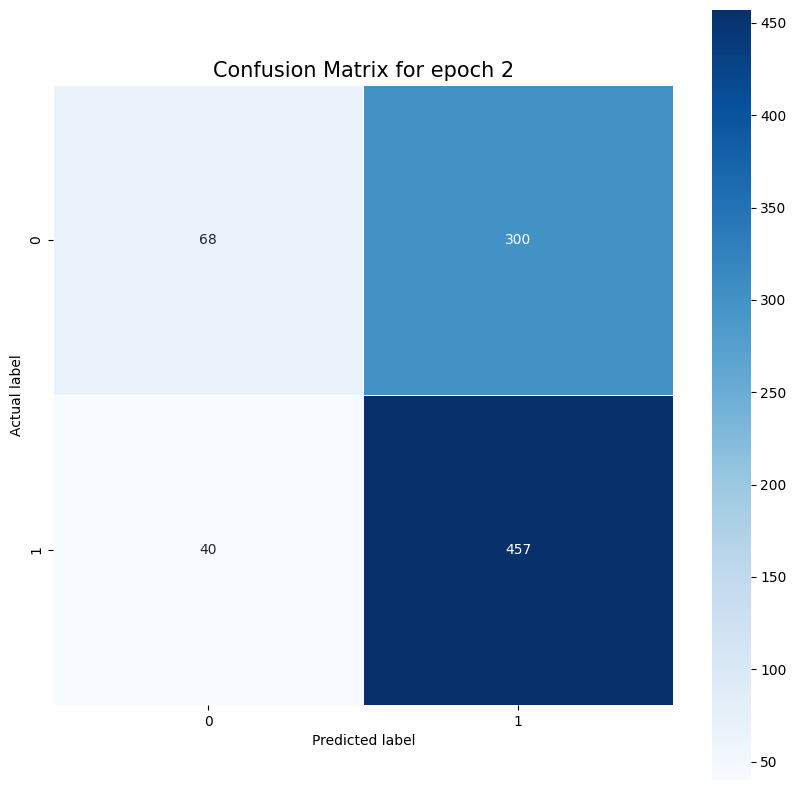

Epoch 3/10:   0%|          | 1/865 [00:04<59:41,  4.14s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   0%|          | 2/865 [00:08<1:00:18,  4.19s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   0%|          | 3/865 [00:13<1:04:17,  4.48s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   0%|          | 4/865 [00:18<1:08:10,  4.75s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   1%|          | 5/865 [00:23<1:08:20,  4.77s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   1%|          | 6/865 [00:27<1:06:08,  4.62s/it]

Accuracy of the model after epoch 3: 100.0%


Epoch 3/10:   1%|          | 7/865 [00:31<1:04:13,  4.49s/it]

Accuracy of the model after epoch 3: 85.71428571428571%


Epoch 3/10:   1%|          | 8/865 [00:34<55:20,  3.88s/it]  

Accuracy of the model after epoch 3: 87.5%


Epoch 3/10:   1%|          | 9/865 [00:39<59:09,  4.15s/it]

Accuracy of the model after epoch 3: 77.77777777777777%


Epoch 3/10:   1%|          | 10/865 [00:41<52:32,  3.69s/it]

Accuracy of the model after epoch 3: 80.0%


Epoch 3/10:   1%|▏         | 11/865 [00:45<54:33,  3.83s/it]

Accuracy of the model after epoch 3: 81.81818181818181%


Epoch 3/10:   1%|▏         | 12/865 [00:50<59:18,  4.17s/it]

Accuracy of the model after epoch 3: 75.0%


Epoch 3/10:   2%|▏         | 13/865 [00:53<51:41,  3.64s/it]

Accuracy of the model after epoch 3: 76.92307692307692%


Epoch 3/10:   2%|▏         | 14/865 [00:57<54:38,  3.85s/it]

Accuracy of the model after epoch 3: 71.42857142857143%


Epoch 3/10:   2%|▏         | 15/865 [01:02<57:21,  4.05s/it]

Accuracy of the model after epoch 3: 73.33333333333333%


Epoch 3/10:   2%|▏         | 16/865 [01:06<57:45,  4.08s/it]

Accuracy of the model after epoch 3: 68.75%


Epoch 3/10:   2%|▏         | 17/865 [01:10<57:48,  4.09s/it]

Accuracy of the model after epoch 3: 70.58823529411765%


Epoch 3/10:   2%|▏         | 18/865 [01:15<1:00:44,  4.30s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   2%|▏         | 19/865 [01:20<1:04:42,  4.59s/it]

Accuracy of the model after epoch 3: 68.42105263157895%


Epoch 3/10:   2%|▏         | 20/865 [01:25<1:05:39,  4.66s/it]

Accuracy of the model after epoch 3: 65.0%


Epoch 3/10:   2%|▏         | 21/865 [01:27<56:07,  3.99s/it]  

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   3%|▎         | 22/865 [01:31<57:17,  4.08s/it]

Accuracy of the model after epoch 3: 68.18181818181819%


Epoch 3/10:   3%|▎         | 23/865 [01:34<49:58,  3.56s/it]

Accuracy of the model after epoch 3: 69.56521739130434%


Epoch 3/10:   3%|▎         | 24/865 [01:38<53:03,  3.79s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   3%|▎         | 25/865 [01:42<55:41,  3.98s/it]

Accuracy of the model after epoch 3: 68.0%


Epoch 3/10:   3%|▎         | 26/865 [01:47<57:55,  4.14s/it]

Accuracy of the model after epoch 3: 69.23076923076923%


Epoch 3/10:   3%|▎         | 27/865 [01:51<57:45,  4.14s/it]

Accuracy of the model after epoch 3: 70.37037037037037%


Epoch 3/10:   3%|▎         | 28/865 [01:56<1:00:26,  4.33s/it]

Accuracy of the model after epoch 3: 67.85714285714286%


Epoch 3/10:   3%|▎         | 29/865 [01:58<52:45,  3.79s/it]  

Accuracy of the model after epoch 3: 65.51724137931035%


Epoch 3/10:   3%|▎         | 30/865 [02:03<56:03,  4.03s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   4%|▎         | 31/865 [02:07<56:43,  4.08s/it]

Accuracy of the model after epoch 3: 67.74193548387096%


Epoch 3/10:   4%|▎         | 32/865 [02:11<56:59,  4.10s/it]

Accuracy of the model after epoch 3: 68.75%


Epoch 3/10:   4%|▍         | 33/865 [02:16<1:00:59,  4.40s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   4%|▍         | 34/865 [02:21<1:03:20,  4.57s/it]

Accuracy of the model after epoch 3: 64.70588235294117%


Epoch 3/10:   4%|▍         | 35/865 [02:24<55:22,  4.00s/it]  

Accuracy of the model after epoch 3: 62.857142857142854%


Epoch 3/10:   4%|▍         | 36/865 [02:29<57:54,  4.19s/it]

Accuracy of the model after epoch 3: 63.888888888888886%


Epoch 3/10:   4%|▍         | 37/865 [02:31<50:58,  3.69s/it]

Accuracy of the model after epoch 3: 62.16216216216216%


Epoch 3/10:   4%|▍         | 38/865 [02:36<54:01,  3.92s/it]

Accuracy of the model after epoch 3: 63.1578947368421%


Epoch 3/10:   5%|▍         | 39/865 [02:40<57:18,  4.16s/it]

Accuracy of the model after epoch 3: 64.1025641025641%


Epoch 3/10:   5%|▍         | 40/865 [02:45<1:00:29,  4.40s/it]

Accuracy of the model after epoch 3: 62.5%


Epoch 3/10:   5%|▍         | 41/865 [02:48<52:24,  3.82s/it]  

Accuracy of the model after epoch 3: 63.41463414634146%


Epoch 3/10:   5%|▍         | 42/865 [02:52<53:26,  3.90s/it]

Accuracy of the model after epoch 3: 61.904761904761905%


Epoch 3/10:   5%|▍         | 43/865 [02:56<54:27,  3.97s/it]

Accuracy of the model after epoch 3: 62.7906976744186%


Epoch 3/10:   5%|▌         | 44/865 [03:01<56:33,  4.13s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:   5%|▌         | 45/865 [03:03<50:42,  3.71s/it]

Accuracy of the model after epoch 3: 62.22222222222222%


Epoch 3/10:   5%|▌         | 46/865 [03:08<53:38,  3.93s/it]

Accuracy of the model after epoch 3: 63.04347826086956%


Epoch 3/10:   5%|▌         | 47/865 [03:13<57:10,  4.19s/it]

Accuracy of the model after epoch 3: 63.829787234042556%


Epoch 3/10:   6%|▌         | 48/865 [03:17<57:12,  4.20s/it]

Accuracy of the model after epoch 3: 64.58333333333333%


Epoch 3/10:   6%|▌         | 49/865 [03:22<59:08,  4.35s/it]

Accuracy of the model after epoch 3: 65.3061224489796%


Epoch 3/10:   6%|▌         | 50/865 [03:26<59:34,  4.39s/it]

Accuracy of the model after epoch 3: 66.0%


Epoch 3/10:   6%|▌         | 51/865 [03:30<59:13,  4.37s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:   6%|▌         | 52/865 [03:35<58:46,  4.34s/it]

Accuracy of the model after epoch 3: 67.3076923076923%


Epoch 3/10:   6%|▌         | 53/865 [03:39<1:00:11,  4.45s/it]

Accuracy of the model after epoch 3: 67.9245283018868%


Epoch 3/10:   6%|▌         | 54/865 [03:42<51:37,  3.82s/it]  

Accuracy of the model after epoch 3: 68.51851851851852%


Epoch 3/10:   6%|▋         | 55/865 [03:46<53:07,  3.94s/it]

Accuracy of the model after epoch 3: 69.0909090909091%


Epoch 3/10:   6%|▋         | 56/865 [03:50<53:33,  3.97s/it]

Accuracy of the model after epoch 3: 69.64285714285714%


Epoch 3/10:   7%|▋         | 57/865 [03:54<54:31,  4.05s/it]

Accuracy of the model after epoch 3: 70.17543859649123%


Epoch 3/10:   7%|▋         | 58/865 [03:59<57:24,  4.27s/it]

Accuracy of the model after epoch 3: 70.6896551724138%


Epoch 3/10:   7%|▋         | 59/865 [04:04<1:01:18,  4.56s/it]

Accuracy of the model after epoch 3: 71.1864406779661%


Epoch 3/10:   7%|▋         | 60/865 [04:09<1:00:53,  4.54s/it]

Accuracy of the model after epoch 3: 71.66666666666667%


Epoch 3/10:   7%|▋         | 61/865 [04:13<1:00:05,  4.48s/it]

Accuracy of the model after epoch 3: 72.1311475409836%


Epoch 3/10:   7%|▋         | 62/865 [04:17<58:52,  4.40s/it]  

Accuracy of the model after epoch 3: 72.58064516129032%


Epoch 3/10:   7%|▋         | 63/865 [04:22<1:00:40,  4.54s/it]

Accuracy of the model after epoch 3: 73.01587301587301%


Epoch 3/10:   7%|▋         | 64/865 [04:28<1:04:24,  4.82s/it]

Accuracy of the model after epoch 3: 73.4375%


Epoch 3/10:   8%|▊         | 65/865 [04:32<1:02:38,  4.70s/it]

Accuracy of the model after epoch 3: 72.3076923076923%


Epoch 3/10:   8%|▊         | 66/865 [04:36<59:51,  4.49s/it]  

Accuracy of the model after epoch 3: 72.72727272727273%


Epoch 3/10:   8%|▊         | 67/865 [04:40<58:50,  4.42s/it]

Accuracy of the model after epoch 3: 71.64179104477611%


Epoch 3/10:   8%|▊         | 68/865 [04:45<59:19,  4.47s/it]

Accuracy of the model after epoch 3: 72.05882352941177%


Epoch 3/10:   8%|▊         | 69/865 [04:47<51:41,  3.90s/it]

Accuracy of the model after epoch 3: 71.01449275362319%


Epoch 3/10:   8%|▊         | 70/865 [04:52<54:12,  4.09s/it]

Accuracy of the model after epoch 3: 71.42857142857143%


Epoch 3/10:   8%|▊         | 71/865 [04:54<47:16,  3.57s/it]

Accuracy of the model after epoch 3: 71.83098591549296%


Epoch 3/10:   8%|▊         | 72/865 [04:59<50:09,  3.80s/it]

Accuracy of the model after epoch 3: 70.83333333333333%


Epoch 3/10:   8%|▊         | 73/865 [05:03<53:52,  4.08s/it]

Accuracy of the model after epoch 3: 71.23287671232876%


Epoch 3/10:   9%|▊         | 74/865 [05:08<57:03,  4.33s/it]

Accuracy of the model after epoch 3: 71.62162162162163%


Epoch 3/10:   9%|▊         | 75/865 [05:13<57:47,  4.39s/it]

Accuracy of the model after epoch 3: 70.66666666666667%


Epoch 3/10:   9%|▉         | 76/865 [05:17<56:36,  4.30s/it]

Accuracy of the model after epoch 3: 71.05263157894737%


Epoch 3/10:   9%|▉         | 77/865 [05:21<56:28,  4.30s/it]

Accuracy of the model after epoch 3: 71.42857142857143%


Epoch 3/10:   9%|▉         | 78/865 [05:26<57:12,  4.36s/it]

Accuracy of the model after epoch 3: 71.7948717948718%


Epoch 3/10:   9%|▉         | 79/865 [05:30<57:51,  4.42s/it]

Accuracy of the model after epoch 3: 72.15189873417721%


Epoch 3/10:   9%|▉         | 80/865 [05:35<58:26,  4.47s/it]

Accuracy of the model after epoch 3: 71.25%


Epoch 3/10:   9%|▉         | 81/865 [05:39<57:50,  4.43s/it]

Accuracy of the model after epoch 3: 70.37037037037037%


Epoch 3/10:   9%|▉         | 82/865 [05:42<50:13,  3.85s/it]

Accuracy of the model after epoch 3: 69.51219512195122%


Epoch 3/10:  10%|▉         | 83/865 [05:46<51:10,  3.93s/it]

Accuracy of the model after epoch 3: 68.67469879518072%


Epoch 3/10:  10%|▉         | 84/865 [05:48<45:03,  3.46s/it]

Accuracy of the model after epoch 3: 69.04761904761905%


Epoch 3/10:  10%|▉         | 85/865 [05:53<50:58,  3.92s/it]

Accuracy of the model after epoch 3: 68.23529411764706%


Epoch 3/10:  10%|▉         | 86/865 [05:57<51:49,  3.99s/it]

Accuracy of the model after epoch 3: 68.6046511627907%


Epoch 3/10:  10%|█         | 87/865 [06:00<45:40,  3.52s/it]

Accuracy of the model after epoch 3: 68.96551724137932%


Epoch 3/10:  10%|█         | 88/865 [06:05<50:42,  3.92s/it]

Accuracy of the model after epoch 3: 69.31818181818181%


Epoch 3/10:  10%|█         | 89/865 [06:09<52:35,  4.07s/it]

Accuracy of the model after epoch 3: 69.66292134831461%


Epoch 3/10:  10%|█         | 90/865 [06:12<47:29,  3.68s/it]

Accuracy of the model after epoch 3: 70.0%


Epoch 3/10:  11%|█         | 91/865 [06:16<51:27,  3.99s/it]

Accuracy of the model after epoch 3: 69.23076923076923%


Epoch 3/10:  11%|█         | 92/865 [06:21<52:39,  4.09s/it]

Accuracy of the model after epoch 3: 69.56521739130434%


Epoch 3/10:  11%|█         | 93/865 [06:25<53:22,  4.15s/it]

Accuracy of the model after epoch 3: 69.89247311827957%


Epoch 3/10:  11%|█         | 94/865 [06:30<55:58,  4.36s/it]

Accuracy of the model after epoch 3: 70.2127659574468%


Epoch 3/10:  11%|█         | 95/865 [06:35<57:55,  4.51s/it]

Accuracy of the model after epoch 3: 70.52631578947368%


Epoch 3/10:  11%|█         | 96/865 [06:39<56:42,  4.42s/it]

Accuracy of the model after epoch 3: 70.83333333333333%


Epoch 3/10:  11%|█         | 97/865 [06:41<49:03,  3.83s/it]

Accuracy of the model after epoch 3: 70.10309278350516%


Epoch 3/10:  11%|█▏        | 98/865 [06:46<51:06,  4.00s/it]

Accuracy of the model after epoch 3: 70.40816326530613%


Epoch 3/10:  11%|█▏        | 99/865 [06:51<54:07,  4.24s/it]

Accuracy of the model after epoch 3: 69.6969696969697%


Epoch 3/10:  12%|█▏        | 100/865 [06:53<48:42,  3.82s/it]

Accuracy of the model after epoch 3: 70.0%


Epoch 3/10:  12%|█▏        | 101/865 [06:58<52:21,  4.11s/it]

Accuracy of the model after epoch 3: 69.3069306930693%


Epoch 3/10:  12%|█▏        | 102/865 [07:01<46:11,  3.63s/it]

Accuracy of the model after epoch 3: 69.6078431372549%


Epoch 3/10:  12%|█▏        | 103/865 [07:05<49:04,  3.86s/it]

Accuracy of the model after epoch 3: 68.93203883495146%


Epoch 3/10:  12%|█▏        | 104/865 [07:09<50:32,  3.98s/it]

Accuracy of the model after epoch 3: 69.23076923076923%


Epoch 3/10:  12%|█▏        | 105/865 [07:14<52:40,  4.16s/it]

Accuracy of the model after epoch 3: 68.57142857142857%


Epoch 3/10:  12%|█▏        | 106/865 [07:18<52:51,  4.18s/it]

Accuracy of the model after epoch 3: 68.86792452830188%


Epoch 3/10:  12%|█▏        | 107/865 [07:22<52:58,  4.19s/it]

Accuracy of the model after epoch 3: 69.1588785046729%


Epoch 3/10:  12%|█▏        | 108/865 [07:27<52:51,  4.19s/it]

Accuracy of the model after epoch 3: 69.44444444444444%


Epoch 3/10:  13%|█▎        | 109/865 [07:31<54:34,  4.33s/it]

Accuracy of the model after epoch 3: 68.80733944954129%


Epoch 3/10:  13%|█▎        | 110/865 [07:37<57:46,  4.59s/it]

Accuracy of the model after epoch 3: 69.0909090909091%


Epoch 3/10:  13%|█▎        | 111/865 [07:39<49:05,  3.91s/it]

Accuracy of the model after epoch 3: 69.36936936936937%


Epoch 3/10:  13%|█▎        | 112/865 [07:43<49:28,  3.94s/it]

Accuracy of the model after epoch 3: 69.64285714285714%


Epoch 3/10:  13%|█▎        | 113/865 [07:47<50:38,  4.04s/it]

Accuracy of the model after epoch 3: 69.02654867256638%


Epoch 3/10:  13%|█▎        | 114/865 [07:52<52:26,  4.19s/it]

Accuracy of the model after epoch 3: 69.29824561403508%


Epoch 3/10:  13%|█▎        | 115/865 [07:56<54:04,  4.33s/it]

Accuracy of the model after epoch 3: 69.56521739130434%


Epoch 3/10:  13%|█▎        | 116/865 [08:00<53:13,  4.26s/it]

Accuracy of the model after epoch 3: 69.82758620689656%


Epoch 3/10:  14%|█▎        | 117/865 [08:05<52:34,  4.22s/it]

Accuracy of the model after epoch 3: 69.23076923076923%


Epoch 3/10:  14%|█▎        | 118/865 [08:10<55:34,  4.46s/it]

Accuracy of the model after epoch 3: 69.49152542372882%


Epoch 3/10:  14%|█▍        | 119/865 [08:15<59:38,  4.80s/it]

Accuracy of the model after epoch 3: 69.74789915966386%


Epoch 3/10:  14%|█▍        | 120/865 [08:18<51:02,  4.11s/it]

Accuracy of the model after epoch 3: 69.16666666666667%


Epoch 3/10:  14%|█▍        | 121/865 [08:22<51:56,  4.19s/it]

Accuracy of the model after epoch 3: 69.42148760330579%


Epoch 3/10:  14%|█▍        | 122/865 [08:26<52:06,  4.21s/it]

Accuracy of the model after epoch 3: 69.67213114754098%


Epoch 3/10:  14%|█▍        | 123/865 [08:31<52:26,  4.24s/it]

Accuracy of the model after epoch 3: 69.91869918699187%


Epoch 3/10:  14%|█▍        | 124/865 [08:33<45:45,  3.70s/it]

Accuracy of the model after epoch 3: 70.16129032258064%


Epoch 3/10:  14%|█▍        | 125/865 [08:37<48:28,  3.93s/it]

Accuracy of the model after epoch 3: 69.6%


Epoch 3/10:  15%|█▍        | 126/865 [08:42<49:39,  4.03s/it]

Accuracy of the model after epoch 3: 69.84126984126983%


Epoch 3/10:  15%|█▍        | 127/865 [08:44<43:41,  3.55s/it]

Accuracy of the model after epoch 3: 70.07874015748031%


Epoch 3/10:  15%|█▍        | 128/865 [08:48<46:10,  3.76s/it]

Accuracy of the model after epoch 3: 69.53125%


Epoch 3/10:  15%|█▍        | 129/865 [08:53<49:17,  4.02s/it]

Accuracy of the model after epoch 3: 69.76744186046511%


Epoch 3/10:  15%|█▌        | 130/865 [08:58<51:34,  4.21s/it]

Accuracy of the model after epoch 3: 69.23076923076923%


Epoch 3/10:  15%|█▌        | 131/865 [09:02<51:21,  4.20s/it]

Accuracy of the model after epoch 3: 68.70229007633588%


Epoch 3/10:  15%|█▌        | 132/865 [09:06<51:37,  4.23s/it]

Accuracy of the model after epoch 3: 68.18181818181819%


Epoch 3/10:  15%|█▌        | 133/865 [09:11<53:49,  4.41s/it]

Accuracy of the model after epoch 3: 67.66917293233082%


Epoch 3/10:  15%|█▌        | 134/865 [09:16<55:41,  4.57s/it]

Accuracy of the model after epoch 3: 67.91044776119404%


Epoch 3/10:  16%|█▌        | 135/865 [09:19<49:40,  4.08s/it]

Accuracy of the model after epoch 3: 67.4074074074074%


Epoch 3/10:  16%|█▌        | 136/865 [09:23<49:44,  4.09s/it]

Accuracy of the model after epoch 3: 66.91176470588235%


Epoch 3/10:  16%|█▌        | 137/865 [09:27<49:39,  4.09s/it]

Accuracy of the model after epoch 3: 67.15328467153284%


Epoch 3/10:  16%|█▌        | 138/865 [09:31<49:54,  4.12s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:  16%|█▌        | 139/865 [09:34<43:35,  3.60s/it]

Accuracy of the model after epoch 3: 66.90647482014388%


Epoch 3/10:  16%|█▌        | 140/865 [09:36<40:30,  3.35s/it]

Accuracy of the model after epoch 3: 66.42857142857143%


Epoch 3/10:  16%|█▋        | 141/865 [09:39<37:19,  3.09s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:  16%|█▋        | 142/865 [09:43<41:02,  3.41s/it]

Accuracy of the model after epoch 3: 66.19718309859155%


Epoch 3/10:  17%|█▋        | 143/865 [09:46<37:30,  3.12s/it]

Accuracy of the model after epoch 3: 66.43356643356644%


Epoch 3/10:  17%|█▋        | 144/865 [09:50<41:06,  3.42s/it]

Accuracy of the model after epoch 3: 66.66666666666667%


Epoch 3/10:  17%|█▋        | 145/865 [09:52<38:43,  3.23s/it]

Accuracy of the model after epoch 3: 66.20689655172414%


Epoch 3/10:  17%|█▋        | 146/865 [09:55<35:49,  2.99s/it]

Accuracy of the model after epoch 3: 66.43835616438356%


Epoch 3/10:  17%|█▋        | 147/865 [09:59<40:13,  3.36s/it]

Accuracy of the model after epoch 3: 65.98639455782313%


Epoch 3/10:  17%|█▋        | 148/865 [10:01<36:04,  3.02s/it]

Accuracy of the model after epoch 3: 66.21621621621621%


Epoch 3/10:  17%|█▋        | 149/865 [10:06<40:29,  3.39s/it]

Accuracy of the model after epoch 3: 65.77181208053692%


Epoch 3/10:  17%|█▋        | 150/865 [10:10<44:45,  3.76s/it]

Accuracy of the model after epoch 3: 65.33333333333333%


Epoch 3/10:  17%|█▋        | 151/865 [10:13<40:22,  3.39s/it]

Accuracy of the model after epoch 3: 65.56291390728477%


Epoch 3/10:  18%|█▊        | 152/865 [10:17<42:59,  3.62s/it]

Accuracy of the model after epoch 3: 65.13157894736842%


Epoch 3/10:  18%|█▊        | 153/865 [10:19<38:36,  3.25s/it]

Accuracy of the model after epoch 3: 64.70588235294117%


Epoch 3/10:  18%|█▊        | 154/865 [10:24<42:30,  3.59s/it]

Accuracy of the model after epoch 3: 64.28571428571429%


Epoch 3/10:  18%|█▊        | 155/865 [10:28<45:41,  3.86s/it]

Accuracy of the model after epoch 3: 64.51612903225806%


Epoch 3/10:  18%|█▊        | 156/865 [10:33<49:09,  4.16s/it]

Accuracy of the model after epoch 3: 64.74358974358974%


Epoch 3/10:  18%|█▊        | 157/865 [10:37<50:04,  4.24s/it]

Accuracy of the model after epoch 3: 64.96815286624204%


Epoch 3/10:  18%|█▊        | 158/865 [10:40<44:03,  3.74s/it]

Accuracy of the model after epoch 3: 65.18987341772151%


Epoch 3/10:  18%|█▊        | 159/865 [10:45<48:17,  4.10s/it]

Accuracy of the model after epoch 3: 65.40880503144655%


Epoch 3/10:  18%|█▊        | 160/865 [10:49<49:20,  4.20s/it]

Accuracy of the model after epoch 3: 65.625%


Epoch 3/10:  19%|█▊        | 161/865 [10:52<42:54,  3.66s/it]

Accuracy of the model after epoch 3: 65.21739130434783%


Epoch 3/10:  19%|█▊        | 162/865 [10:54<39:16,  3.35s/it]

Accuracy of the model after epoch 3: 64.81481481481481%


Epoch 3/10:  19%|█▉        | 163/865 [10:59<43:29,  3.72s/it]

Accuracy of the model after epoch 3: 64.41717791411043%


Epoch 3/10:  19%|█▉        | 164/865 [11:03<45:09,  3.87s/it]

Accuracy of the model after epoch 3: 64.63414634146342%


Epoch 3/10:  19%|█▉        | 165/865 [11:08<47:31,  4.07s/it]

Accuracy of the model after epoch 3: 64.84848484848484%


Epoch 3/10:  19%|█▉        | 166/865 [11:12<47:21,  4.07s/it]

Accuracy of the model after epoch 3: 65.06024096385542%


Epoch 3/10:  19%|█▉        | 167/865 [11:14<40:52,  3.51s/it]

Accuracy of the model after epoch 3: 65.26946107784431%


Epoch 3/10:  19%|█▉        | 168/865 [11:17<37:18,  3.21s/it]

Accuracy of the model after epoch 3: 65.47619047619048%


Epoch 3/10:  20%|█▉        | 169/865 [11:21<41:02,  3.54s/it]

Accuracy of the model after epoch 3: 65.08875739644971%


Epoch 3/10:  20%|█▉        | 170/865 [11:25<44:11,  3.82s/it]

Accuracy of the model after epoch 3: 65.29411764705883%


Epoch 3/10:  20%|█▉        | 171/865 [11:29<45:00,  3.89s/it]

Accuracy of the model after epoch 3: 64.91228070175438%


Epoch 3/10:  20%|█▉        | 172/865 [11:34<45:56,  3.98s/it]

Accuracy of the model after epoch 3: 65.11627906976744%


Epoch 3/10:  20%|██        | 173/865 [11:38<47:59,  4.16s/it]

Accuracy of the model after epoch 3: 65.3179190751445%


Epoch 3/10:  20%|██        | 174/865 [11:43<51:43,  4.49s/it]

Accuracy of the model after epoch 3: 64.94252873563218%


Epoch 3/10:  20%|██        | 175/865 [11:48<52:08,  4.53s/it]

Accuracy of the model after epoch 3: 65.14285714285714%


Epoch 3/10:  20%|██        | 176/865 [11:52<50:51,  4.43s/it]

Accuracy of the model after epoch 3: 64.77272727272727%


Epoch 3/10:  20%|██        | 177/865 [11:55<44:46,  3.90s/it]

Accuracy of the model after epoch 3: 64.40677966101696%


Epoch 3/10:  21%|██        | 178/865 [11:59<46:58,  4.10s/it]

Accuracy of the model after epoch 3: 64.04494382022472%


Epoch 3/10:  21%|██        | 179/865 [12:04<50:06,  4.38s/it]

Accuracy of the model after epoch 3: 64.24581005586592%


Epoch 3/10:  21%|██        | 180/865 [12:07<44:41,  3.91s/it]

Accuracy of the model after epoch 3: 63.888888888888886%


Epoch 3/10:  21%|██        | 181/865 [12:12<45:47,  4.02s/it]

Accuracy of the model after epoch 3: 64.08839779005525%


Epoch 3/10:  21%|██        | 182/865 [12:16<46:43,  4.10s/it]

Accuracy of the model after epoch 3: 64.28571428571429%


Epoch 3/10:  21%|██        | 183/865 [12:20<46:41,  4.11s/it]

Accuracy of the model after epoch 3: 64.48087431693989%


Epoch 3/10:  21%|██▏       | 184/865 [12:24<47:19,  4.17s/it]

Accuracy of the model after epoch 3: 64.1304347826087%


Epoch 3/10:  21%|██▏       | 185/865 [12:29<48:11,  4.25s/it]

Accuracy of the model after epoch 3: 64.32432432432432%


Epoch 3/10:  22%|██▏       | 186/865 [12:33<47:53,  4.23s/it]

Accuracy of the model after epoch 3: 63.97849462365591%


Epoch 3/10:  22%|██▏       | 187/865 [12:37<48:13,  4.27s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:  22%|██▏       | 188/865 [12:42<49:22,  4.38s/it]

Accuracy of the model after epoch 3: 63.297872340425535%


Epoch 3/10:  22%|██▏       | 189/865 [12:47<52:03,  4.62s/it]

Accuracy of the model after epoch 3: 63.492063492063494%


Epoch 3/10:  22%|██▏       | 190/865 [12:51<50:53,  4.52s/it]

Accuracy of the model after epoch 3: 63.1578947368421%


Epoch 3/10:  22%|██▏       | 191/865 [12:56<50:03,  4.46s/it]

Accuracy of the model after epoch 3: 62.82722513089005%


Epoch 3/10:  22%|██▏       | 192/865 [13:00<48:49,  4.35s/it]

Accuracy of the model after epoch 3: 63.020833333333336%


Epoch 3/10:  22%|██▏       | 193/865 [13:05<50:29,  4.51s/it]

Accuracy of the model after epoch 3: 63.21243523316062%


Epoch 3/10:  22%|██▏       | 194/865 [13:10<53:01,  4.74s/it]

Accuracy of the model after epoch 3: 62.88659793814433%


Epoch 3/10:  23%|██▎       | 195/865 [13:13<46:24,  4.16s/it]

Accuracy of the model after epoch 3: 63.07692307692308%


Epoch 3/10:  23%|██▎       | 196/865 [13:17<47:10,  4.23s/it]

Accuracy of the model after epoch 3: 63.265306122448976%


Epoch 3/10:  23%|██▎       | 197/865 [13:22<47:26,  4.26s/it]

Accuracy of the model after epoch 3: 63.45177664974619%


Epoch 3/10:  23%|██▎       | 198/865 [13:24<41:41,  3.75s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:  23%|██▎       | 199/865 [13:26<36:32,  3.29s/it]

Accuracy of the model after epoch 3: 63.31658291457286%


Epoch 3/10:  23%|██▎       | 200/865 [13:31<40:28,  3.65s/it]

Accuracy of the model after epoch 3: 63.5%


Epoch 3/10:  23%|██▎       | 201/865 [13:35<42:50,  3.87s/it]

Accuracy of the model after epoch 3: 63.681592039801%


Epoch 3/10:  23%|██▎       | 202/865 [13:37<37:17,  3.37s/it]

Accuracy of the model after epoch 3: 63.86138613861386%


Epoch 3/10:  23%|██▎       | 203/865 [13:42<41:00,  3.72s/it]

Accuracy of the model after epoch 3: 63.54679802955665%


Epoch 3/10:  24%|██▎       | 204/865 [13:44<36:49,  3.34s/it]

Accuracy of the model after epoch 3: 63.23529411764706%


Epoch 3/10:  24%|██▎       | 205/865 [13:47<35:20,  3.21s/it]

Accuracy of the model after epoch 3: 63.41463414634146%


Epoch 3/10:  24%|██▍       | 206/865 [13:52<40:20,  3.67s/it]

Accuracy of the model after epoch 3: 63.592233009708735%


Epoch 3/10:  24%|██▍       | 207/865 [13:56<41:58,  3.83s/it]

Accuracy of the model after epoch 3: 63.28502415458937%


Epoch 3/10:  24%|██▍       | 208/865 [13:59<37:55,  3.46s/it]

Accuracy of the model after epoch 3: 63.46153846153846%


Epoch 3/10:  24%|██▍       | 209/865 [14:03<41:05,  3.76s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:  24%|██▍       | 210/865 [14:06<38:08,  3.49s/it]

Accuracy of the model after epoch 3: 63.333333333333336%


Epoch 3/10:  24%|██▍       | 211/865 [14:10<40:49,  3.74s/it]

Accuracy of the model after epoch 3: 63.507109004739334%


Epoch 3/10:  25%|██▍       | 212/865 [14:15<42:40,  3.92s/it]

Accuracy of the model after epoch 3: 63.20754716981132%


Epoch 3/10:  25%|██▍       | 213/865 [14:19<43:23,  3.99s/it]

Accuracy of the model after epoch 3: 63.38028169014085%


Epoch 3/10:  25%|██▍       | 214/865 [14:22<38:52,  3.58s/it]

Accuracy of the model after epoch 3: 63.55140186915888%


Epoch 3/10:  25%|██▍       | 215/865 [14:26<41:36,  3.84s/it]

Accuracy of the model after epoch 3: 63.25581395348837%


Epoch 3/10:  25%|██▍       | 216/865 [14:30<43:13,  4.00s/it]

Accuracy of the model after epoch 3: 63.425925925925924%


Epoch 3/10:  25%|██▌       | 217/865 [14:33<37:27,  3.47s/it]

Accuracy of the model after epoch 3: 63.59447004608295%


Epoch 3/10:  25%|██▌       | 218/865 [14:37<40:10,  3.72s/it]

Accuracy of the model after epoch 3: 63.30275229357798%


Epoch 3/10:  25%|██▌       | 219/865 [14:42<42:57,  3.99s/it]

Accuracy of the model after epoch 3: 63.013698630136986%


Epoch 3/10:  25%|██▌       | 220/865 [14:46<44:14,  4.12s/it]

Accuracy of the model after epoch 3: 62.72727272727273%


Epoch 3/10:  26%|██▌       | 221/865 [14:51<45:44,  4.26s/it]

Accuracy of the model after epoch 3: 62.89592760180995%


Epoch 3/10:  26%|██▌       | 222/865 [14:55<47:26,  4.43s/it]

Accuracy of the model after epoch 3: 62.612612612612615%


Epoch 3/10:  26%|██▌       | 223/865 [15:00<47:59,  4.49s/it]

Accuracy of the model after epoch 3: 62.33183856502242%


Epoch 3/10:  26%|██▌       | 224/865 [15:05<50:15,  4.71s/it]

Accuracy of the model after epoch 3: 62.05357142857143%


Epoch 3/10:  26%|██▌       | 225/865 [15:10<50:12,  4.71s/it]

Accuracy of the model after epoch 3: 61.77777777777778%


Epoch 3/10:  26%|██▌       | 226/865 [15:14<48:22,  4.54s/it]

Accuracy of the model after epoch 3: 61.50442477876106%


Epoch 3/10:  26%|██▌       | 227/865 [15:16<41:24,  3.89s/it]

Accuracy of the model after epoch 3: 61.67400881057269%


Epoch 3/10:  26%|██▋       | 228/865 [15:21<42:59,  4.05s/it]

Accuracy of the model after epoch 3: 61.8421052631579%


Epoch 3/10:  26%|██▋       | 229/865 [15:25<43:58,  4.15s/it]

Accuracy of the model after epoch 3: 62.00873362445415%


Epoch 3/10:  27%|██▋       | 230/865 [15:30<46:18,  4.38s/it]

Accuracy of the model after epoch 3: 62.17391304347826%


Epoch 3/10:  27%|██▋       | 231/865 [15:34<45:20,  4.29s/it]

Accuracy of the model after epoch 3: 62.33766233766234%


Epoch 3/10:  27%|██▋       | 232/865 [15:39<46:27,  4.40s/it]

Accuracy of the model after epoch 3: 62.06896551724138%


Epoch 3/10:  27%|██▋       | 233/865 [15:44<47:10,  4.48s/it]

Accuracy of the model after epoch 3: 61.802575107296136%


Epoch 3/10:  27%|██▋       | 234/865 [15:46<40:53,  3.89s/it]

Accuracy of the model after epoch 3: 61.965811965811966%


Epoch 3/10:  27%|██▋       | 235/865 [15:51<42:56,  4.09s/it]

Accuracy of the model after epoch 3: 61.702127659574465%


Epoch 3/10:  27%|██▋       | 236/865 [15:55<44:50,  4.28s/it]

Accuracy of the model after epoch 3: 61.86440677966102%


Epoch 3/10:  27%|██▋       | 237/865 [16:00<44:36,  4.26s/it]

Accuracy of the model after epoch 3: 62.0253164556962%


Epoch 3/10:  28%|██▊       | 238/865 [16:05<46:54,  4.49s/it]

Accuracy of the model after epoch 3: 61.76470588235294%


Epoch 3/10:  28%|██▊       | 239/865 [16:09<47:27,  4.55s/it]

Accuracy of the model after epoch 3: 61.50627615062761%


Epoch 3/10:  28%|██▊       | 240/865 [16:14<46:47,  4.49s/it]

Accuracy of the model after epoch 3: 61.666666666666664%


Epoch 3/10:  28%|██▊       | 241/865 [16:18<45:28,  4.37s/it]

Accuracy of the model after epoch 3: 61.41078838174274%


Epoch 3/10:  28%|██▊       | 242/865 [16:20<39:12,  3.78s/it]

Accuracy of the model after epoch 3: 61.15702479338843%


Epoch 3/10:  28%|██▊       | 243/865 [16:25<41:07,  3.97s/it]

Accuracy of the model after epoch 3: 60.90534979423868%


Epoch 3/10:  28%|██▊       | 244/865 [16:29<43:25,  4.19s/it]

Accuracy of the model after epoch 3: 61.0655737704918%


Epoch 3/10:  28%|██▊       | 245/865 [16:34<43:55,  4.25s/it]

Accuracy of the model after epoch 3: 61.224489795918366%


Epoch 3/10:  28%|██▊       | 246/865 [16:36<38:58,  3.78s/it]

Accuracy of the model after epoch 3: 61.38211382113821%


Epoch 3/10:  29%|██▊       | 247/865 [16:39<34:52,  3.39s/it]

Accuracy of the model after epoch 3: 61.1336032388664%


Epoch 3/10:  29%|██▊       | 248/865 [16:43<37:20,  3.63s/it]

Accuracy of the model after epoch 3: 61.29032258064516%


Epoch 3/10:  29%|██▉       | 249/865 [16:47<39:14,  3.82s/it]

Accuracy of the model after epoch 3: 61.44578313253012%


Epoch 3/10:  29%|██▉       | 250/865 [16:52<41:57,  4.09s/it]

Accuracy of the model after epoch 3: 61.2%


Epoch 3/10:  29%|██▉       | 251/865 [16:56<42:26,  4.15s/it]

Accuracy of the model after epoch 3: 60.95617529880478%


Epoch 3/10:  29%|██▉       | 252/865 [17:01<42:52,  4.20s/it]

Accuracy of the model after epoch 3: 61.111111111111114%


Epoch 3/10:  29%|██▉       | 253/865 [17:05<43:59,  4.31s/it]

Accuracy of the model after epoch 3: 60.869565217391305%


Epoch 3/10:  29%|██▉       | 254/865 [17:10<45:21,  4.45s/it]

Accuracy of the model after epoch 3: 61.023622047244096%


Epoch 3/10:  29%|██▉       | 255/865 [17:14<44:49,  4.41s/it]

Accuracy of the model after epoch 3: 60.78431372549019%


Epoch 3/10:  30%|██▉       | 256/865 [17:19<44:19,  4.37s/it]

Accuracy of the model after epoch 3: 60.9375%


Epoch 3/10:  30%|██▉       | 257/865 [17:23<43:53,  4.33s/it]

Accuracy of the model after epoch 3: 61.08949416342413%


Epoch 3/10:  30%|██▉       | 258/865 [17:27<44:45,  4.42s/it]

Accuracy of the model after epoch 3: 61.24031007751938%


Epoch 3/10:  30%|██▉       | 259/865 [17:33<46:56,  4.65s/it]

Accuracy of the model after epoch 3: 61.38996138996139%


Epoch 3/10:  30%|███       | 260/865 [17:37<46:20,  4.60s/it]

Accuracy of the model after epoch 3: 61.15384615384615%


Epoch 3/10:  30%|███       | 261/865 [17:41<44:56,  4.46s/it]

Accuracy of the model after epoch 3: 61.30268199233716%


Epoch 3/10:  30%|███       | 262/865 [17:46<44:40,  4.44s/it]

Accuracy of the model after epoch 3: 61.06870229007634%


Epoch 3/10:  30%|███       | 263/865 [17:48<38:55,  3.88s/it]

Accuracy of the model after epoch 3: 61.21673003802282%


Epoch 3/10:  31%|███       | 264/865 [17:53<42:48,  4.27s/it]

Accuracy of the model after epoch 3: 60.984848484848484%


Epoch 3/10:  31%|███       | 265/865 [17:56<37:47,  3.78s/it]

Accuracy of the model after epoch 3: 60.75471698113208%


Epoch 3/10:  31%|███       | 266/865 [18:01<40:16,  4.03s/it]

Accuracy of the model after epoch 3: 60.526315789473685%


Epoch 3/10:  31%|███       | 267/865 [18:05<41:46,  4.19s/it]

Accuracy of the model after epoch 3: 60.674157303370784%


Epoch 3/10:  31%|███       | 268/865 [18:08<36:23,  3.66s/it]

Accuracy of the model after epoch 3: 60.82089552238806%


Epoch 3/10:  31%|███       | 269/865 [18:10<32:50,  3.31s/it]

Accuracy of the model after epoch 3: 60.96654275092937%


Epoch 3/10:  31%|███       | 270/865 [18:13<30:45,  3.10s/it]

Accuracy of the model after epoch 3: 60.74074074074074%


Epoch 3/10:  31%|███▏      | 271/865 [18:17<33:55,  3.43s/it]

Accuracy of the model after epoch 3: 60.51660516605166%


Epoch 3/10:  31%|███▏      | 272/865 [18:21<36:58,  3.74s/it]

Accuracy of the model after epoch 3: 60.661764705882355%


Epoch 3/10:  32%|███▏      | 273/865 [18:26<39:50,  4.04s/it]

Accuracy of the model after epoch 3: 60.8058608058608%


Epoch 3/10:  32%|███▏      | 274/865 [18:31<41:40,  4.23s/it]

Accuracy of the model after epoch 3: 60.948905109489054%


Epoch 3/10:  32%|███▏      | 275/865 [18:35<42:36,  4.33s/it]

Accuracy of the model after epoch 3: 61.09090909090909%


Epoch 3/10:  32%|███▏      | 276/865 [18:38<36:40,  3.74s/it]

Accuracy of the model after epoch 3: 61.231884057971016%


Epoch 3/10:  32%|███▏      | 277/865 [18:42<38:04,  3.89s/it]

Accuracy of the model after epoch 3: 61.01083032490975%


Epoch 3/10:  32%|███▏      | 278/865 [18:46<39:11,  4.01s/it]

Accuracy of the model after epoch 3: 61.15107913669065%


Epoch 3/10:  32%|███▏      | 279/865 [18:49<34:09,  3.50s/it]

Accuracy of the model after epoch 3: 60.93189964157706%


Epoch 3/10:  32%|███▏      | 280/865 [18:54<38:54,  3.99s/it]

Accuracy of the model after epoch 3: 61.07142857142857%


Epoch 3/10:  32%|███▏      | 281/865 [18:58<40:28,  4.16s/it]

Accuracy of the model after epoch 3: 60.854092526690394%


Epoch 3/10:  33%|███▎      | 282/865 [19:03<42:17,  4.35s/it]

Accuracy of the model after epoch 3: 60.99290780141844%


Epoch 3/10:  33%|███▎      | 283/865 [19:05<36:29,  3.76s/it]

Accuracy of the model after epoch 3: 61.130742049469966%


Epoch 3/10:  33%|███▎      | 284/865 [19:08<32:27,  3.35s/it]

Accuracy of the model after epoch 3: 61.267605633802816%


Epoch 3/10:  33%|███▎      | 285/865 [19:12<35:32,  3.68s/it]

Accuracy of the model after epoch 3: 61.05263157894737%


Epoch 3/10:  33%|███▎      | 286/865 [19:15<31:46,  3.29s/it]

Accuracy of the model after epoch 3: 60.83916083916084%


Epoch 3/10:  33%|███▎      | 287/865 [19:19<35:08,  3.65s/it]

Accuracy of the model after epoch 3: 60.97560975609756%


Epoch 3/10:  33%|███▎      | 288/865 [19:23<36:19,  3.78s/it]

Accuracy of the model after epoch 3: 61.111111111111114%


Epoch 3/10:  33%|███▎      | 289/865 [19:28<39:20,  4.10s/it]

Accuracy of the model after epoch 3: 60.89965397923876%


Epoch 3/10:  34%|███▎      | 290/865 [19:32<40:11,  4.19s/it]

Accuracy of the model after epoch 3: 61.03448275862069%


Epoch 3/10:  34%|███▎      | 291/865 [19:37<39:55,  4.17s/it]

Accuracy of the model after epoch 3: 60.824742268041234%


Epoch 3/10:  34%|███▍      | 292/865 [19:39<35:16,  3.69s/it]

Accuracy of the model after epoch 3: 60.95890410958904%


Epoch 3/10:  34%|███▍      | 293/865 [19:44<37:27,  3.93s/it]

Accuracy of the model after epoch 3: 60.75085324232082%


Epoch 3/10:  34%|███▍      | 294/865 [19:49<40:07,  4.22s/it]

Accuracy of the model after epoch 3: 60.8843537414966%


Epoch 3/10:  34%|███▍      | 295/865 [19:53<40:48,  4.30s/it]

Accuracy of the model after epoch 3: 61.016949152542374%


Epoch 3/10:  34%|███▍      | 296/865 [19:57<40:28,  4.27s/it]

Accuracy of the model after epoch 3: 60.810810810810814%


Epoch 3/10:  34%|███▍      | 297/865 [20:00<35:53,  3.79s/it]

Accuracy of the model after epoch 3: 60.60606060606061%


Epoch 3/10:  34%|███▍      | 298/865 [20:04<37:38,  3.98s/it]

Accuracy of the model after epoch 3: 60.40268456375839%


Epoch 3/10:  35%|███▍      | 299/865 [20:07<33:52,  3.59s/it]

Accuracy of the model after epoch 3: 60.20066889632107%


Epoch 3/10:  35%|███▍      | 300/865 [20:12<36:36,  3.89s/it]

Accuracy of the model after epoch 3: 60.333333333333336%


Epoch 3/10:  35%|███▍      | 301/865 [20:14<32:19,  3.44s/it]

Accuracy of the model after epoch 3: 60.1328903654485%


Epoch 3/10:  35%|███▍      | 302/865 [20:18<34:11,  3.64s/it]

Accuracy of the model after epoch 3: 59.93377483443709%


Epoch 3/10:  35%|███▌      | 303/865 [20:22<35:32,  3.79s/it]

Accuracy of the model after epoch 3: 60.06600660066007%


Epoch 3/10:  35%|███▌      | 304/865 [20:27<37:31,  4.01s/it]

Accuracy of the model after epoch 3: 59.86842105263158%


Epoch 3/10:  35%|███▌      | 305/865 [20:32<39:58,  4.28s/it]

Accuracy of the model after epoch 3: 60.0%


Epoch 3/10:  35%|███▌      | 306/865 [20:36<39:23,  4.23s/it]

Accuracy of the model after epoch 3: 59.80392156862745%


Epoch 3/10:  35%|███▌      | 307/865 [20:40<39:18,  4.23s/it]

Accuracy of the model after epoch 3: 59.60912052117264%


Epoch 3/10:  36%|███▌      | 308/865 [20:42<34:02,  3.67s/it]

Accuracy of the model after epoch 3: 59.74025974025974%


Epoch 3/10:  36%|███▌      | 309/865 [20:45<29:46,  3.21s/it]

Accuracy of the model after epoch 3: 59.8705501618123%


Epoch 3/10:  36%|███▌      | 310/865 [20:49<33:12,  3.59s/it]

Accuracy of the model after epoch 3: 60.0%


Epoch 3/10:  36%|███▌      | 311/865 [20:53<35:16,  3.82s/it]

Accuracy of the model after epoch 3: 59.80707395498392%


Epoch 3/10:  36%|███▌      | 312/865 [20:56<30:46,  3.34s/it]

Accuracy of the model after epoch 3: 59.93589743589744%


Epoch 3/10:  36%|███▌      | 313/865 [21:00<34:24,  3.74s/it]

Accuracy of the model after epoch 3: 59.7444089456869%


Epoch 3/10:  36%|███▋      | 314/865 [21:05<37:25,  4.08s/it]

Accuracy of the model after epoch 3: 59.87261146496815%


Epoch 3/10:  36%|███▋      | 315/865 [21:10<40:34,  4.43s/it]

Accuracy of the model after epoch 3: 60.0%


Epoch 3/10:  37%|███▋      | 316/865 [21:15<40:06,  4.38s/it]

Accuracy of the model after epoch 3: 59.81012658227848%


Epoch 3/10:  37%|███▋      | 317/865 [21:19<40:07,  4.39s/it]

Accuracy of the model after epoch 3: 59.936908517350155%


Epoch 3/10:  37%|███▋      | 318/865 [21:24<40:41,  4.46s/it]

Accuracy of the model after epoch 3: 60.062893081761004%


Epoch 3/10:  37%|███▋      | 319/865 [21:26<35:12,  3.87s/it]

Accuracy of the model after epoch 3: 59.874608150470216%


Epoch 3/10:  37%|███▋      | 320/865 [21:31<37:07,  4.09s/it]

Accuracy of the model after epoch 3: 59.6875%


Epoch 3/10:  37%|███▋      | 321/865 [21:33<33:02,  3.64s/it]

Accuracy of the model after epoch 3: 59.50155763239876%


Epoch 3/10:  37%|███▋      | 322/865 [21:37<33:54,  3.75s/it]

Accuracy of the model after epoch 3: 59.316770186335404%


Epoch 3/10:  37%|███▋      | 323/865 [21:40<30:50,  3.41s/it]

Accuracy of the model after epoch 3: 59.44272445820433%


Epoch 3/10:  37%|███▋      | 324/865 [21:44<33:05,  3.67s/it]

Accuracy of the model after epoch 3: 59.5679012345679%


Epoch 3/10:  38%|███▊      | 325/865 [21:49<34:49,  3.87s/it]

Accuracy of the model after epoch 3: 59.69230769230769%


Epoch 3/10:  38%|███▊      | 326/865 [21:53<36:04,  4.02s/it]

Accuracy of the model after epoch 3: 59.50920245398773%


Epoch 3/10:  38%|███▊      | 327/865 [21:57<37:12,  4.15s/it]

Accuracy of the model after epoch 3: 59.63302752293578%


Epoch 3/10:  38%|███▊      | 328/865 [22:02<38:04,  4.25s/it]

Accuracy of the model after epoch 3: 59.75609756097561%


Epoch 3/10:  38%|███▊      | 329/865 [22:07<40:15,  4.51s/it]

Accuracy of the model after epoch 3: 59.878419452887535%


Epoch 3/10:  38%|███▊      | 330/865 [22:12<40:27,  4.54s/it]

Accuracy of the model after epoch 3: 60.0%


Epoch 3/10:  38%|███▊      | 331/865 [22:16<39:05,  4.39s/it]

Accuracy of the model after epoch 3: 60.120845921450154%


Epoch 3/10:  38%|███▊      | 332/865 [22:20<39:03,  4.40s/it]

Accuracy of the model after epoch 3: 60.24096385542169%


Epoch 3/10:  38%|███▊      | 333/865 [22:25<39:39,  4.47s/it]

Accuracy of the model after epoch 3: 60.36036036036036%


Epoch 3/10:  39%|███▊      | 334/865 [22:30<40:44,  4.60s/it]

Accuracy of the model after epoch 3: 60.17964071856287%


Epoch 3/10:  39%|███▊      | 335/865 [22:35<41:58,  4.75s/it]

Accuracy of the model after epoch 3: 60.298507462686565%


Epoch 3/10:  39%|███▉      | 336/865 [22:39<40:47,  4.63s/it]

Accuracy of the model after epoch 3: 60.416666666666664%


Epoch 3/10:  39%|███▉      | 337/865 [22:43<39:32,  4.49s/it]

Accuracy of the model after epoch 3: 60.53412462908012%


Epoch 3/10:  39%|███▉      | 338/865 [22:48<40:24,  4.60s/it]

Accuracy of the model after epoch 3: 60.650887573964496%


Epoch 3/10:  39%|███▉      | 339/865 [22:54<43:07,  4.92s/it]

Accuracy of the model after epoch 3: 60.471976401179944%


Epoch 3/10:  39%|███▉      | 340/865 [22:58<41:56,  4.79s/it]

Accuracy of the model after epoch 3: 60.588235294117645%


Epoch 3/10:  39%|███▉      | 341/865 [23:03<40:38,  4.65s/it]

Accuracy of the model after epoch 3: 60.70381231671554%


Epoch 3/10:  40%|███▉      | 342/865 [23:05<34:48,  3.99s/it]

Accuracy of the model after epoch 3: 60.8187134502924%


Epoch 3/10:  40%|███▉      | 343/865 [23:08<30:57,  3.56s/it]

Accuracy of the model after epoch 3: 60.932944606414%


Epoch 3/10:  40%|███▉      | 344/865 [23:10<28:02,  3.23s/it]

Accuracy of the model after epoch 3: 60.75581395348837%


Epoch 3/10:  40%|███▉      | 345/865 [23:15<31:38,  3.65s/it]

Accuracy of the model after epoch 3: 60.57971014492754%


Epoch 3/10:  40%|████      | 346/865 [23:17<28:21,  3.28s/it]

Accuracy of the model after epoch 3: 60.69364161849711%


Epoch 3/10:  40%|████      | 347/865 [23:22<32:03,  3.71s/it]

Accuracy of the model after epoch 3: 60.80691642651297%


Epoch 3/10:  40%|████      | 348/865 [23:26<33:31,  3.89s/it]

Accuracy of the model after epoch 3: 60.91954022988506%


Epoch 3/10:  40%|████      | 349/865 [23:31<35:38,  4.14s/it]

Accuracy of the model after epoch 3: 60.74498567335244%


Epoch 3/10:  40%|████      | 350/865 [23:35<36:43,  4.28s/it]

Accuracy of the model after epoch 3: 60.857142857142854%


Epoch 3/10:  41%|████      | 351/865 [23:40<36:18,  4.24s/it]

Accuracy of the model after epoch 3: 60.96866096866097%


Epoch 3/10:  41%|████      | 352/865 [23:44<36:22,  4.25s/it]

Accuracy of the model after epoch 3: 60.79545454545455%


Epoch 3/10:  41%|████      | 353/865 [23:46<31:39,  3.71s/it]

Accuracy of the model after epoch 3: 60.906515580736546%


Epoch 3/10:  41%|████      | 354/865 [23:51<33:23,  3.92s/it]

Accuracy of the model after epoch 3: 60.73446327683616%


Epoch 3/10:  41%|████      | 355/865 [23:56<35:34,  4.19s/it]

Accuracy of the model after epoch 3: 60.84507042253521%


Epoch 3/10:  41%|████      | 356/865 [24:00<35:30,  4.18s/it]

Accuracy of the model after epoch 3: 60.674157303370784%


Epoch 3/10:  41%|████▏     | 357/865 [24:04<35:16,  4.17s/it]

Accuracy of the model after epoch 3: 60.50420168067227%


Epoch 3/10:  41%|████▏     | 358/865 [24:08<35:52,  4.25s/it]

Accuracy of the model after epoch 3: 60.614525139664806%


Epoch 3/10:  42%|████▏     | 359/865 [24:14<38:32,  4.57s/it]

Accuracy of the model after epoch 3: 60.72423398328691%


Epoch 3/10:  42%|████▏     | 360/865 [24:16<33:30,  3.98s/it]

Accuracy of the model after epoch 3: 60.833333333333336%


Epoch 3/10:  42%|████▏     | 361/865 [24:20<34:10,  4.07s/it]

Accuracy of the model after epoch 3: 60.94182825484764%


Epoch 3/10:  42%|████▏     | 362/865 [24:25<34:18,  4.09s/it]

Accuracy of the model after epoch 3: 61.049723756906076%


Epoch 3/10:  42%|████▏     | 363/865 [24:29<34:40,  4.15s/it]

Accuracy of the model after epoch 3: 61.15702479338843%


Epoch 3/10:  42%|████▏     | 364/865 [24:34<35:54,  4.30s/it]

Accuracy of the model after epoch 3: 61.26373626373626%


Epoch 3/10:  42%|████▏     | 365/865 [24:38<36:35,  4.39s/it]

Accuracy of the model after epoch 3: 61.0958904109589%


Epoch 3/10:  42%|████▏     | 366/865 [24:43<36:43,  4.42s/it]

Accuracy of the model after epoch 3: 61.202185792349724%


Epoch 3/10:  42%|████▏     | 367/865 [24:45<32:17,  3.89s/it]

Accuracy of the model after epoch 3: 61.03542234332425%


Epoch 3/10:  43%|████▎     | 368/865 [24:50<33:15,  4.01s/it]

Accuracy of the model after epoch 3: 61.141304347826086%


Epoch 3/10:  43%|████▎     | 369/865 [24:52<28:39,  3.47s/it]

Accuracy of the model after epoch 3: 61.24661246612466%


Epoch 3/10:  43%|████▎     | 370/865 [24:56<31:33,  3.83s/it]

Accuracy of the model after epoch 3: 61.351351351351354%


Epoch 3/10:  43%|████▎     | 371/865 [24:59<28:11,  3.42s/it]

Accuracy of the model after epoch 3: 61.455525606469%


Epoch 3/10:  43%|████▎     | 372/865 [25:03<29:57,  3.65s/it]

Accuracy of the model after epoch 3: 61.55913978494624%


Epoch 3/10:  43%|████▎     | 373/865 [25:07<31:18,  3.82s/it]

Accuracy of the model after epoch 3: 61.66219839142091%


Epoch 3/10:  43%|████▎     | 374/865 [25:12<32:18,  3.95s/it]

Accuracy of the model after epoch 3: 61.76470588235294%


Epoch 3/10:  43%|████▎     | 375/865 [25:16<34:24,  4.21s/it]

Accuracy of the model after epoch 3: 61.86666666666667%


Epoch 3/10:  43%|████▎     | 376/865 [25:19<30:31,  3.75s/it]

Accuracy of the model after epoch 3: 61.96808510638298%


Epoch 3/10:  44%|████▎     | 377/865 [25:24<32:28,  3.99s/it]

Accuracy of the model after epoch 3: 62.06896551724138%


Epoch 3/10:  44%|████▎     | 378/865 [25:28<32:34,  4.01s/it]

Accuracy of the model after epoch 3: 62.16931216931217%


Epoch 3/10:  44%|████▍     | 379/865 [25:32<33:58,  4.19s/it]

Accuracy of the model after epoch 3: 62.26912928759894%


Epoch 3/10:  44%|████▍     | 380/865 [25:37<35:05,  4.34s/it]

Accuracy of the model after epoch 3: 62.10526315789474%


Epoch 3/10:  44%|████▍     | 381/865 [25:40<30:38,  3.80s/it]

Accuracy of the model after epoch 3: 62.20472440944882%


Epoch 3/10:  44%|████▍     | 382/865 [25:42<27:12,  3.38s/it]

Accuracy of the model after epoch 3: 62.303664921465966%


Epoch 3/10:  44%|████▍     | 383/865 [25:46<28:54,  3.60s/it]

Accuracy of the model after epoch 3: 62.40208877284595%


Epoch 3/10:  44%|████▍     | 384/865 [25:49<26:09,  3.26s/it]

Accuracy of the model after epoch 3: 62.239583333333336%


Epoch 3/10:  45%|████▍     | 385/865 [25:53<29:39,  3.71s/it]

Accuracy of the model after epoch 3: 62.077922077922075%


Epoch 3/10:  45%|████▍     | 386/865 [25:56<26:10,  3.28s/it]

Accuracy of the model after epoch 3: 61.917098445595855%


Epoch 3/10:  45%|████▍     | 387/865 [26:00<28:22,  3.56s/it]

Accuracy of the model after epoch 3: 61.75710594315245%


Epoch 3/10:  45%|████▍     | 388/865 [26:04<29:58,  3.77s/it]

Accuracy of the model after epoch 3: 61.855670103092784%


Epoch 3/10:  45%|████▍     | 389/865 [26:06<26:27,  3.33s/it]

Accuracy of the model after epoch 3: 61.95372750642674%


Epoch 3/10:  45%|████▌     | 390/865 [26:09<25:00,  3.16s/it]

Accuracy of the model after epoch 3: 62.05128205128205%


Epoch 3/10:  45%|████▌     | 391/865 [26:12<23:15,  2.94s/it]

Accuracy of the model after epoch 3: 61.892583120204606%


Epoch 3/10:  45%|████▌     | 392/865 [26:16<26:55,  3.41s/it]

Accuracy of the model after epoch 3: 61.98979591836735%


Epoch 3/10:  45%|████▌     | 393/865 [26:20<28:44,  3.65s/it]

Accuracy of the model after epoch 3: 61.83206106870229%


Epoch 3/10:  46%|████▌     | 394/865 [26:25<31:47,  4.05s/it]

Accuracy of the model after epoch 3: 61.92893401015228%


Epoch 3/10:  46%|████▌     | 395/865 [26:28<28:49,  3.68s/it]

Accuracy of the model after epoch 3: 62.0253164556962%


Epoch 3/10:  46%|████▌     | 396/865 [26:32<30:18,  3.88s/it]

Accuracy of the model after epoch 3: 62.121212121212125%


Epoch 3/10:  46%|████▌     | 397/865 [26:37<31:22,  4.02s/it]

Accuracy of the model after epoch 3: 61.9647355163728%


Epoch 3/10:  46%|████▌     | 398/865 [26:41<31:53,  4.10s/it]

Accuracy of the model after epoch 3: 61.80904522613066%


Epoch 3/10:  46%|████▌     | 399/865 [26:46<33:07,  4.27s/it]

Accuracy of the model after epoch 3: 61.904761904761905%


Epoch 3/10:  46%|████▌     | 400/865 [26:48<29:20,  3.79s/it]

Accuracy of the model after epoch 3: 62.0%


Epoch 3/10:  46%|████▋     | 401/865 [26:53<30:16,  3.92s/it]

Accuracy of the model after epoch 3: 62.094763092269325%


Epoch 3/10:  46%|████▋     | 402/865 [26:57<31:17,  4.06s/it]

Accuracy of the model after epoch 3: 62.18905472636816%


Epoch 3/10:  47%|████▋     | 403/865 [27:01<31:59,  4.15s/it]

Accuracy of the model after epoch 3: 62.03473945409429%


Epoch 3/10:  47%|████▋     | 404/865 [27:06<33:12,  4.32s/it]

Accuracy of the model after epoch 3: 62.12871287128713%


Epoch 3/10:  47%|████▋     | 405/865 [27:11<35:04,  4.58s/it]

Accuracy of the model after epoch 3: 62.22222222222222%


Epoch 3/10:  47%|████▋     | 406/865 [27:15<34:22,  4.49s/it]

Accuracy of the model after epoch 3: 62.31527093596059%


Epoch 3/10:  47%|████▋     | 407/865 [27:20<33:53,  4.44s/it]

Accuracy of the model after epoch 3: 62.40786240786241%


Epoch 3/10:  47%|████▋     | 408/865 [27:24<33:50,  4.44s/it]

Accuracy of the model after epoch 3: 62.5%


Epoch 3/10:  47%|████▋     | 409/865 [27:29<34:55,  4.60s/it]

Accuracy of the model after epoch 3: 62.59168704156479%


Epoch 3/10:  47%|████▋     | 410/865 [27:34<35:00,  4.62s/it]

Accuracy of the model after epoch 3: 62.68292682926829%


Epoch 3/10:  48%|████▊     | 411/865 [27:36<30:21,  4.01s/it]

Accuracy of the model after epoch 3: 62.530413625304135%


Epoch 3/10:  48%|████▊     | 412/865 [27:41<30:46,  4.08s/it]

Accuracy of the model after epoch 3: 62.62135922330097%


Epoch 3/10:  48%|████▊     | 413/865 [27:45<31:34,  4.19s/it]

Accuracy of the model after epoch 3: 62.71186440677966%


Epoch 3/10:  48%|████▊     | 414/865 [27:50<32:55,  4.38s/it]

Accuracy of the model after epoch 3: 62.80193236714976%


Epoch 3/10:  48%|████▊     | 415/865 [27:53<29:20,  3.91s/it]

Accuracy of the model after epoch 3: 62.89156626506024%


Epoch 3/10:  48%|████▊     | 416/865 [27:57<30:09,  4.03s/it]

Accuracy of the model after epoch 3: 62.74038461538461%


Epoch 3/10:  48%|████▊     | 417/865 [28:01<30:29,  4.08s/it]

Accuracy of the model after epoch 3: 62.589928057553955%


Epoch 3/10:  48%|████▊     | 418/865 [28:04<26:16,  3.53s/it]

Accuracy of the model after epoch 3: 62.67942583732057%


Epoch 3/10:  48%|████▊     | 419/865 [28:08<29:10,  3.92s/it]

Accuracy of the model after epoch 3: 62.76849642004773%


Epoch 3/10:  49%|████▊     | 420/865 [28:13<30:17,  4.08s/it]

Accuracy of the model after epoch 3: 62.857142857142854%


Epoch 3/10:  49%|████▊     | 421/865 [28:18<31:53,  4.31s/it]

Accuracy of the model after epoch 3: 62.94536817102138%


Epoch 3/10:  49%|████▉     | 422/865 [28:22<31:34,  4.28s/it]

Accuracy of the model after epoch 3: 62.796208530805686%


Epoch 3/10:  49%|████▉     | 423/865 [28:27<32:26,  4.40s/it]

Accuracy of the model after epoch 3: 62.64775413711584%


Epoch 3/10:  49%|████▉     | 424/865 [28:32<33:54,  4.61s/it]

Accuracy of the model after epoch 3: 62.5%


Epoch 3/10:  49%|████▉     | 425/865 [28:36<33:48,  4.61s/it]

Accuracy of the model after epoch 3: 62.35294117647059%


Epoch 3/10:  49%|████▉     | 426/865 [28:41<33:10,  4.53s/it]

Accuracy of the model after epoch 3: 62.44131455399061%


Epoch 3/10:  49%|████▉     | 427/865 [28:45<32:24,  4.44s/it]

Accuracy of the model after epoch 3: 62.52927400468384%


Epoch 3/10:  49%|████▉     | 428/865 [28:50<34:05,  4.68s/it]

Accuracy of the model after epoch 3: 62.61682242990654%


Epoch 3/10:  50%|████▉     | 429/865 [28:55<34:29,  4.75s/it]

Accuracy of the model after epoch 3: 62.47086247086247%


Epoch 3/10:  50%|████▉     | 430/865 [28:58<30:02,  4.14s/it]

Accuracy of the model after epoch 3: 62.55813953488372%


Epoch 3/10:  50%|████▉     | 431/865 [29:00<26:18,  3.64s/it]

Accuracy of the model after epoch 3: 62.64501160092807%


Epoch 3/10:  50%|████▉     | 432/865 [29:04<27:12,  3.77s/it]

Accuracy of the model after epoch 3: 62.73148148148148%


Epoch 3/10:  50%|█████     | 433/865 [29:09<28:09,  3.91s/it]

Accuracy of the model after epoch 3: 62.8175519630485%


Epoch 3/10:  50%|█████     | 434/865 [29:11<25:08,  3.50s/it]

Accuracy of the model after epoch 3: 62.903225806451616%


Epoch 3/10:  50%|█████     | 435/865 [29:14<23:43,  3.31s/it]

Accuracy of the model after epoch 3: 62.98850574712644%


Epoch 3/10:  50%|█████     | 436/865 [29:18<25:34,  3.58s/it]

Accuracy of the model after epoch 3: 62.84403669724771%


Epoch 3/10:  51%|█████     | 437/865 [29:22<27:03,  3.79s/it]

Accuracy of the model after epoch 3: 62.92906178489702%


Epoch 3/10:  51%|█████     | 438/865 [29:27<29:10,  4.10s/it]

Accuracy of the model after epoch 3: 63.013698630136986%


Epoch 3/10:  51%|█████     | 439/865 [29:30<25:17,  3.56s/it]

Accuracy of the model after epoch 3: 63.097949886104786%


Epoch 3/10:  51%|█████     | 440/865 [29:34<27:25,  3.87s/it]

Accuracy of the model after epoch 3: 63.18181818181818%


Epoch 3/10:  51%|█████     | 441/865 [29:37<24:25,  3.46s/it]

Accuracy of the model after epoch 3: 63.265306122448976%


Epoch 3/10:  51%|█████     | 442/865 [29:41<25:52,  3.67s/it]

Accuracy of the model after epoch 3: 63.12217194570136%


Epoch 3/10:  51%|█████     | 443/865 [29:45<26:57,  3.83s/it]

Accuracy of the model after epoch 3: 63.205417607223474%


Epoch 3/10:  51%|█████▏    | 444/865 [29:50<28:43,  4.09s/it]

Accuracy of the model after epoch 3: 63.288288288288285%


Epoch 3/10:  51%|█████▏    | 445/865 [29:55<30:28,  4.35s/it]

Accuracy of the model after epoch 3: 63.146067415730336%


Epoch 3/10:  52%|█████▏    | 446/865 [29:57<26:24,  3.78s/it]

Accuracy of the model after epoch 3: 63.228699551569505%


Epoch 3/10:  52%|█████▏    | 447/865 [30:00<24:05,  3.46s/it]

Accuracy of the model after epoch 3: 63.31096196868009%


Epoch 3/10:  52%|█████▏    | 448/865 [30:05<26:38,  3.83s/it]

Accuracy of the model after epoch 3: 63.169642857142854%


Epoch 3/10:  52%|█████▏    | 449/865 [30:07<24:11,  3.49s/it]

Accuracy of the model after epoch 3: 63.25167037861915%


Epoch 3/10:  52%|█████▏    | 450/865 [30:12<27:09,  3.93s/it]

Accuracy of the model after epoch 3: 63.111111111111114%


Epoch 3/10:  52%|█████▏    | 451/865 [30:17<28:46,  4.17s/it]

Accuracy of the model after epoch 3: 63.19290465631929%


Epoch 3/10:  52%|█████▏    | 452/865 [30:21<29:01,  4.22s/it]

Accuracy of the model after epoch 3: 63.27433628318584%


Epoch 3/10:  52%|█████▏    | 453/865 [30:24<25:34,  3.72s/it]

Accuracy of the model after epoch 3: 63.35540838852097%


Epoch 3/10:  52%|█████▏    | 454/865 [30:26<23:06,  3.37s/it]

Accuracy of the model after epoch 3: 63.436123348017624%


Epoch 3/10:  53%|█████▎    | 455/865 [30:31<25:14,  3.69s/it]

Accuracy of the model after epoch 3: 63.51648351648352%


Epoch 3/10:  53%|█████▎    | 456/865 [30:35<26:35,  3.90s/it]

Accuracy of the model after epoch 3: 63.59649122807018%


Epoch 3/10:  53%|█████▎    | 457/865 [30:40<27:26,  4.04s/it]

Accuracy of the model after epoch 3: 63.67614879649891%


Epoch 3/10:  53%|█████▎    | 458/865 [30:45<29:52,  4.40s/it]

Accuracy of the model after epoch 3: 63.53711790393013%


Epoch 3/10:  53%|█████▎    | 459/865 [30:50<31:42,  4.69s/it]

Accuracy of the model after epoch 3: 63.61655773420479%


Epoch 3/10:  53%|█████▎    | 460/865 [30:55<31:30,  4.67s/it]

Accuracy of the model after epoch 3: 63.69565217391305%


Epoch 3/10:  53%|█████▎    | 461/865 [30:57<26:35,  3.95s/it]

Accuracy of the model after epoch 3: 63.55748373101952%


Epoch 3/10:  53%|█████▎    | 462/865 [31:00<23:37,  3.52s/it]

Accuracy of the model after epoch 3: 63.63636363636363%


Epoch 3/10:  54%|█████▎    | 463/865 [31:04<25:36,  3.82s/it]

Accuracy of the model after epoch 3: 63.71490280777538%


Epoch 3/10:  54%|█████▎    | 464/865 [31:07<23:00,  3.44s/it]

Accuracy of the model after epoch 3: 63.793103448275865%


Epoch 3/10:  54%|█████▍    | 465/865 [31:09<21:41,  3.25s/it]

Accuracy of the model after epoch 3: 63.87096774193548%


Epoch 3/10:  54%|█████▍    | 466/865 [31:12<20:13,  3.04s/it]

Accuracy of the model after epoch 3: 63.94849785407725%


Epoch 3/10:  54%|█████▍    | 467/865 [31:17<24:02,  3.62s/it]

Accuracy of the model after epoch 3: 64.02569593147751%


Epoch 3/10:  54%|█████▍    | 468/865 [31:20<22:06,  3.34s/it]

Accuracy of the model after epoch 3: 64.1025641025641%


Epoch 3/10:  54%|█████▍    | 469/865 [31:24<23:52,  3.62s/it]

Accuracy of the model after epoch 3: 64.17910447761194%


Epoch 3/10:  54%|█████▍    | 470/865 [31:27<22:06,  3.36s/it]

Accuracy of the model after epoch 3: 64.25531914893617%


Epoch 3/10:  54%|█████▍    | 471/865 [31:29<20:05,  3.06s/it]

Accuracy of the model after epoch 3: 64.3312101910828%


Epoch 3/10:  55%|█████▍    | 472/865 [31:34<23:57,  3.66s/it]

Accuracy of the model after epoch 3: 64.40677966101696%


Epoch 3/10:  55%|█████▍    | 473/865 [31:38<25:00,  3.83s/it]

Accuracy of the model after epoch 3: 64.27061310782241%


Epoch 3/10:  55%|█████▍    | 474/865 [31:43<26:12,  4.02s/it]

Accuracy of the model after epoch 3: 64.34599156118144%


Epoch 3/10:  55%|█████▍    | 475/865 [31:47<26:49,  4.13s/it]

Accuracy of the model after epoch 3: 64.42105263157895%


Epoch 3/10:  55%|█████▌    | 476/865 [31:52<27:42,  4.27s/it]

Accuracy of the model after epoch 3: 64.49579831932773%


Epoch 3/10:  55%|█████▌    | 477/865 [31:56<27:46,  4.30s/it]

Accuracy of the model after epoch 3: 64.57023060796645%


Epoch 3/10:  55%|█████▌    | 478/865 [31:59<24:22,  3.78s/it]

Accuracy of the model after epoch 3: 64.64435146443515%


Epoch 3/10:  55%|█████▌    | 479/865 [32:04<26:27,  4.11s/it]

Accuracy of the model after epoch 3: 64.71816283924844%


Epoch 3/10:  55%|█████▌    | 480/865 [32:08<27:08,  4.23s/it]

Accuracy of the model after epoch 3: 64.58333333333333%


Epoch 3/10:  56%|█████▌    | 481/865 [32:12<26:52,  4.20s/it]

Accuracy of the model after epoch 3: 64.65696465696466%


Epoch 3/10:  56%|█████▌    | 482/865 [32:16<26:42,  4.18s/it]

Accuracy of the model after epoch 3: 64.52282157676349%


Epoch 3/10:  56%|█████▌    | 483/865 [32:21<27:10,  4.27s/it]

Accuracy of the model after epoch 3: 64.59627329192547%


Epoch 3/10:  56%|█████▌    | 484/865 [32:26<29:16,  4.61s/it]

Accuracy of the model after epoch 3: 64.6694214876033%


Epoch 3/10:  56%|█████▌    | 485/865 [32:31<29:16,  4.62s/it]

Accuracy of the model after epoch 3: 64.74226804123711%


Epoch 3/10:  56%|█████▌    | 486/865 [32:35<28:34,  4.52s/it]

Accuracy of the model after epoch 3: 64.81481481481481%


Epoch 3/10:  56%|█████▋    | 487/865 [32:40<28:09,  4.47s/it]

Accuracy of the model after epoch 3: 64.68172484599589%


Epoch 3/10:  56%|█████▋    | 488/865 [32:42<24:32,  3.90s/it]

Accuracy of the model after epoch 3: 64.75409836065573%


Epoch 3/10:  57%|█████▋    | 489/865 [32:47<26:07,  4.17s/it]

Accuracy of the model after epoch 3: 64.82617586912066%


Epoch 3/10:  57%|█████▋    | 490/865 [32:51<26:43,  4.28s/it]

Accuracy of the model after epoch 3: 64.6938775510204%


Epoch 3/10:  57%|█████▋    | 491/865 [32:56<26:39,  4.28s/it]

Accuracy of the model after epoch 3: 64.5621181262729%


Epoch 3/10:  57%|█████▋    | 492/865 [32:58<23:09,  3.72s/it]

Accuracy of the model after epoch 3: 64.63414634146342%


Epoch 3/10:  57%|█████▋    | 493/865 [33:02<24:14,  3.91s/it]

Accuracy of the model after epoch 3: 64.50304259634889%


Epoch 3/10:  57%|█████▋    | 494/865 [33:05<21:24,  3.46s/it]

Accuracy of the model after epoch 3: 64.5748987854251%


Epoch 3/10:  57%|█████▋    | 495/865 [33:10<23:28,  3.81s/it]

Accuracy of the model after epoch 3: 64.64646464646465%


Epoch 3/10:  57%|█████▋    | 496/865 [33:14<24:16,  3.95s/it]

Accuracy of the model after epoch 3: 64.71774193548387%


Epoch 3/10:  57%|█████▋    | 497/865 [33:18<24:24,  3.98s/it]

Accuracy of the model after epoch 3: 64.78873239436619%


Epoch 3/10:  58%|█████▊    | 498/865 [33:23<25:56,  4.24s/it]

Accuracy of the model after epoch 3: 64.85943775100401%


Epoch 3/10:  58%|█████▊    | 499/865 [33:28<27:49,  4.56s/it]

Accuracy of the model after epoch 3: 64.72945891783567%


Epoch 3/10:  58%|█████▊    | 500/865 [33:31<24:31,  4.03s/it]

Accuracy of the model after epoch 3: 64.8%


Epoch 3/10:  58%|█████▊    | 501/865 [33:33<21:43,  3.58s/it]

Accuracy of the model after epoch 3: 64.87025948103792%


Epoch 3/10:  58%|█████▊    | 502/865 [33:36<20:01,  3.31s/it]

Accuracy of the model after epoch 3: 64.9402390438247%


Epoch 3/10:  58%|█████▊    | 503/865 [33:38<18:17,  3.03s/it]

Accuracy of the model after epoch 3: 64.81113320079523%


Epoch 3/10:  58%|█████▊    | 504/865 [33:43<21:22,  3.55s/it]

Accuracy of the model after epoch 3: 64.88095238095238%


Epoch 3/10:  58%|█████▊    | 505/865 [33:46<19:44,  3.29s/it]

Accuracy of the model after epoch 3: 64.95049504950495%


Epoch 3/10:  58%|█████▊    | 506/865 [33:48<17:56,  3.00s/it]

Accuracy of the model after epoch 3: 65.0197628458498%


Epoch 3/10:  59%|█████▊    | 507/865 [33:51<16:58,  2.84s/it]

Accuracy of the model after epoch 3: 64.89151873767258%


Epoch 3/10:  59%|█████▊    | 508/865 [33:55<19:38,  3.30s/it]

Accuracy of the model after epoch 3: 64.96062992125984%


Epoch 3/10:  59%|█████▉    | 509/865 [34:00<21:59,  3.71s/it]

Accuracy of the model after epoch 3: 65.02946954813359%


Epoch 3/10:  59%|█████▉    | 510/865 [34:04<23:35,  3.99s/it]

Accuracy of the model after epoch 3: 64.90196078431373%


Epoch 3/10:  59%|█████▉    | 511/865 [34:07<20:52,  3.54s/it]

Accuracy of the model after epoch 3: 64.9706457925636%


Epoch 3/10:  59%|█████▉    | 512/865 [34:09<18:48,  3.20s/it]

Accuracy of the model after epoch 3: 64.84375%


Epoch 3/10:  59%|█████▉    | 513/865 [34:12<17:47,  3.03s/it]

Accuracy of the model after epoch 3: 64.71734892787525%


Epoch 3/10:  59%|█████▉    | 514/865 [34:14<16:46,  2.87s/it]

Accuracy of the model after epoch 3: 64.59143968871595%


Epoch 3/10:  60%|█████▉    | 515/865 [34:17<16:24,  2.81s/it]

Accuracy of the model after epoch 3: 64.46601941747574%


Epoch 3/10:  60%|█████▉    | 516/865 [34:22<19:50,  3.41s/it]

Accuracy of the model after epoch 3: 64.53488372093024%


Epoch 3/10:  60%|█████▉    | 517/865 [34:26<20:49,  3.59s/it]

Accuracy of the model after epoch 3: 64.60348162475822%


Epoch 3/10:  60%|█████▉    | 518/865 [34:30<21:49,  3.77s/it]

Accuracy of the model after epoch 3: 64.67181467181467%


Epoch 3/10:  60%|██████    | 519/865 [34:35<23:24,  4.06s/it]

Accuracy of the model after epoch 3: 64.73988439306359%


Epoch 3/10:  60%|██████    | 520/865 [34:39<24:10,  4.20s/it]

Accuracy of the model after epoch 3: 64.8076923076923%


Epoch 3/10:  60%|██████    | 521/865 [34:43<23:48,  4.15s/it]

Accuracy of the model after epoch 3: 64.87523992322457%


Epoch 3/10:  60%|██████    | 522/865 [34:48<23:55,  4.19s/it]

Accuracy of the model after epoch 3: 64.94252873563218%


Epoch 3/10:  60%|██████    | 523/865 [34:52<23:59,  4.21s/it]

Accuracy of the model after epoch 3: 64.81835564053537%


Epoch 3/10:  61%|██████    | 524/865 [34:57<24:49,  4.37s/it]

Accuracy of the model after epoch 3: 64.69465648854961%


Epoch 3/10:  61%|██████    | 525/865 [34:59<21:52,  3.86s/it]

Accuracy of the model after epoch 3: 64.76190476190476%


Epoch 3/10:  61%|██████    | 526/865 [35:04<22:31,  3.99s/it]

Accuracy of the model after epoch 3: 64.63878326996198%


Epoch 3/10:  61%|██████    | 527/865 [35:08<22:49,  4.05s/it]

Accuracy of the model after epoch 3: 64.51612903225806%


Epoch 3/10:  61%|██████    | 528/865 [35:12<22:42,  4.04s/it]

Accuracy of the model after epoch 3: 64.58333333333333%


Epoch 3/10:  61%|██████    | 529/865 [35:16<23:41,  4.23s/it]

Accuracy of the model after epoch 3: 64.46124763705104%


Epoch 3/10:  61%|██████▏   | 530/865 [35:21<24:26,  4.38s/it]

Accuracy of the model after epoch 3: 64.52830188679245%


Epoch 3/10:  61%|██████▏   | 531/865 [35:24<21:27,  3.86s/it]

Accuracy of the model after epoch 3: 64.59510357815442%


Epoch 3/10:  62%|██████▏   | 532/865 [35:28<21:49,  3.93s/it]

Accuracy of the model after epoch 3: 64.66165413533835%


Epoch 3/10:  62%|██████▏   | 533/865 [35:32<22:23,  4.05s/it]

Accuracy of the model after epoch 3: 64.54033771106941%


Epoch 3/10:  62%|██████▏   | 534/865 [35:37<22:54,  4.15s/it]

Accuracy of the model after epoch 3: 64.41947565543072%


Epoch 3/10:  62%|██████▏   | 535/865 [35:41<23:14,  4.23s/it]

Accuracy of the model after epoch 3: 64.29906542056075%


Epoch 3/10:  62%|██████▏   | 536/865 [35:45<23:09,  4.22s/it]

Accuracy of the model after epoch 3: 64.36567164179104%


Epoch 3/10:  62%|██████▏   | 537/865 [35:48<20:08,  3.68s/it]

Accuracy of the model after epoch 3: 64.24581005586592%


Epoch 3/10:  62%|██████▏   | 538/865 [35:52<21:31,  3.95s/it]

Accuracy of the model after epoch 3: 64.31226765799256%


Epoch 3/10:  62%|██████▏   | 539/865 [35:57<22:19,  4.11s/it]

Accuracy of the model after epoch 3: 64.37847866419295%


Epoch 3/10:  62%|██████▏   | 540/865 [36:01<23:04,  4.26s/it]

Accuracy of the model after epoch 3: 64.25925925925925%


Epoch 3/10:  63%|██████▎   | 541/865 [36:04<19:38,  3.64s/it]

Accuracy of the model after epoch 3: 64.3253234750462%


Epoch 3/10:  63%|██████▎   | 542/865 [36:06<17:56,  3.33s/it]

Accuracy of the model after epoch 3: 64.20664206642067%


Epoch 3/10:  63%|██████▎   | 543/865 [36:10<19:20,  3.60s/it]

Accuracy of the model after epoch 3: 64.27255985267035%


Epoch 3/10:  63%|██████▎   | 544/865 [36:15<20:53,  3.90s/it]

Accuracy of the model after epoch 3: 64.33823529411765%


Epoch 3/10:  63%|██████▎   | 545/865 [36:20<22:03,  4.14s/it]

Accuracy of the model after epoch 3: 64.40366972477064%


Epoch 3/10:  63%|██████▎   | 546/865 [36:24<22:15,  4.19s/it]

Accuracy of the model after epoch 3: 64.46886446886447%


Epoch 3/10:  63%|██████▎   | 547/865 [36:28<22:22,  4.22s/it]

Accuracy of the model after epoch 3: 64.53382084095064%


Epoch 3/10:  63%|██████▎   | 548/865 [36:30<19:05,  3.61s/it]

Accuracy of the model after epoch 3: 64.41605839416059%


Epoch 3/10:  63%|██████▎   | 549/865 [36:33<17:01,  3.23s/it]

Accuracy of the model after epoch 3: 64.48087431693989%


Epoch 3/10:  64%|██████▎   | 550/865 [36:36<16:13,  3.09s/it]

Accuracy of the model after epoch 3: 64.36363636363636%


Epoch 3/10:  64%|██████▎   | 551/865 [36:38<15:10,  2.90s/it]

Accuracy of the model after epoch 3: 64.42831215970962%


Epoch 3/10:  64%|██████▍   | 552/865 [36:42<17:01,  3.26s/it]

Accuracy of the model after epoch 3: 64.4927536231884%


Epoch 3/10:  64%|██████▍   | 553/865 [36:46<18:38,  3.59s/it]

Accuracy of the model after epoch 3: 64.376130198915%


Epoch 3/10:  64%|██████▍   | 554/865 [36:51<20:00,  3.86s/it]

Accuracy of the model after epoch 3: 64.4404332129964%


Epoch 3/10:  64%|██████▍   | 555/865 [36:55<20:58,  4.06s/it]

Accuracy of the model after epoch 3: 64.50450450450451%


Epoch 3/10:  64%|██████▍   | 556/865 [37:00<21:05,  4.10s/it]

Accuracy of the model after epoch 3: 64.56834532374101%


Epoch 3/10:  64%|██████▍   | 557/865 [37:04<21:54,  4.27s/it]

Accuracy of the model after epoch 3: 64.63195691202873%


Epoch 3/10:  65%|██████▍   | 558/865 [37:07<18:59,  3.71s/it]

Accuracy of the model after epoch 3: 64.69534050179212%


Epoch 3/10:  65%|██████▍   | 559/865 [37:09<16:35,  3.25s/it]

Accuracy of the model after epoch 3: 64.75849731663685%


Epoch 3/10:  65%|██████▍   | 560/865 [37:13<18:20,  3.61s/it]

Accuracy of the model after epoch 3: 64.64285714285714%


Epoch 3/10:  65%|██████▍   | 561/865 [37:18<19:04,  3.77s/it]

Accuracy of the model after epoch 3: 64.52762923351159%


Epoch 3/10:  65%|██████▍   | 562/865 [37:22<20:31,  4.06s/it]

Accuracy of the model after epoch 3: 64.59074733096085%


Epoch 3/10:  65%|██████▌   | 563/865 [37:27<21:15,  4.22s/it]

Accuracy of the model after epoch 3: 64.65364120781527%


Epoch 3/10:  65%|██████▌   | 564/865 [37:29<18:38,  3.72s/it]

Accuracy of the model after epoch 3: 64.53900709219859%


Epoch 3/10:  65%|██████▌   | 565/865 [37:34<20:20,  4.07s/it]

Accuracy of the model after epoch 3: 64.42477876106194%


Epoch 3/10:  65%|██████▌   | 566/865 [37:39<20:29,  4.11s/it]

Accuracy of the model after epoch 3: 64.31095406360424%


Epoch 3/10:  66%|██████▌   | 567/865 [37:43<20:40,  4.16s/it]

Accuracy of the model after epoch 3: 64.37389770723104%


Epoch 3/10:  66%|██████▌   | 568/865 [37:48<21:39,  4.38s/it]

Accuracy of the model after epoch 3: 64.43661971830986%


Epoch 3/10:  66%|██████▌   | 569/865 [37:50<19:02,  3.86s/it]

Accuracy of the model after epoch 3: 64.49912126537785%


Epoch 3/10:  66%|██████▌   | 570/865 [37:55<19:58,  4.06s/it]

Accuracy of the model after epoch 3: 64.56140350877193%


Epoch 3/10:  66%|██████▌   | 571/865 [37:57<17:37,  3.60s/it]

Accuracy of the model after epoch 3: 64.44833625218914%


Epoch 3/10:  66%|██████▌   | 572/865 [38:01<18:07,  3.71s/it]

Accuracy of the model after epoch 3: 64.5104895104895%


Epoch 3/10:  66%|██████▌   | 573/865 [38:06<18:47,  3.86s/it]

Accuracy of the model after epoch 3: 64.57242582897034%


Epoch 3/10:  66%|██████▋   | 574/865 [38:11<20:21,  4.20s/it]

Accuracy of the model after epoch 3: 64.45993031358886%


Epoch 3/10:  66%|██████▋   | 575/865 [38:15<20:54,  4.33s/it]

Accuracy of the model after epoch 3: 64.52173913043478%


Epoch 3/10:  67%|██████▋   | 576/865 [38:20<21:05,  4.38s/it]

Accuracy of the model after epoch 3: 64.58333333333333%


Epoch 3/10:  67%|██████▋   | 577/865 [38:22<18:05,  3.77s/it]

Accuracy of the model after epoch 3: 64.64471403812826%


Epoch 3/10:  67%|██████▋   | 578/865 [38:26<18:35,  3.89s/it]

Accuracy of the model after epoch 3: 64.70588235294117%


Epoch 3/10:  67%|██████▋   | 579/865 [38:31<19:42,  4.13s/it]

Accuracy of the model after epoch 3: 64.76683937823834%


Epoch 3/10:  67%|██████▋   | 580/865 [38:35<20:14,  4.26s/it]

Accuracy of the model after epoch 3: 64.65517241379311%


Epoch 3/10:  67%|██████▋   | 581/865 [38:40<20:11,  4.27s/it]

Accuracy of the model after epoch 3: 64.54388984509467%


Epoch 3/10:  67%|██████▋   | 582/865 [38:44<20:15,  4.30s/it]

Accuracy of the model after epoch 3: 64.60481099656357%


Epoch 3/10:  67%|██████▋   | 583/865 [38:47<17:44,  3.78s/it]

Accuracy of the model after epoch 3: 64.6655231560892%


Epoch 3/10:  68%|██████▊   | 584/865 [38:52<19:41,  4.20s/it]

Accuracy of the model after epoch 3: 64.55479452054794%


Epoch 3/10:  68%|██████▊   | 585/865 [38:57<20:21,  4.36s/it]

Accuracy of the model after epoch 3: 64.44444444444444%


Epoch 3/10:  68%|██████▊   | 586/865 [39:01<20:14,  4.35s/it]

Accuracy of the model after epoch 3: 64.50511945392492%


Epoch 3/10:  68%|██████▊   | 587/865 [39:06<20:39,  4.46s/it]

Accuracy of the model after epoch 3: 64.5655877342419%


Epoch 3/10:  68%|██████▊   | 588/865 [39:10<21:04,  4.57s/it]

Accuracy of the model after epoch 3: 64.45578231292517%


Epoch 3/10:  68%|██████▊   | 589/865 [39:16<21:58,  4.78s/it]

Accuracy of the model after epoch 3: 64.51612903225806%


Epoch 3/10:  68%|██████▊   | 590/865 [39:20<21:49,  4.76s/it]

Accuracy of the model after epoch 3: 64.57627118644068%


Epoch 3/10:  68%|██████▊   | 591/865 [39:25<21:00,  4.60s/it]

Accuracy of the model after epoch 3: 64.63620981387479%


Epoch 3/10:  68%|██████▊   | 592/865 [39:27<17:56,  3.94s/it]

Accuracy of the model after epoch 3: 64.69594594594595%


Epoch 3/10:  69%|██████▊   | 593/865 [39:32<18:43,  4.13s/it]

Accuracy of the model after epoch 3: 64.58684654300168%


Epoch 3/10:  69%|██████▊   | 594/865 [39:37<19:50,  4.39s/it]

Accuracy of the model after epoch 3: 64.64646464646465%


Epoch 3/10:  69%|██████▉   | 595/865 [39:41<19:51,  4.41s/it]

Accuracy of the model after epoch 3: 64.70588235294117%


Epoch 3/10:  69%|██████▉   | 596/865 [39:45<19:27,  4.34s/it]

Accuracy of the model after epoch 3: 64.76510067114094%


Epoch 3/10:  69%|██████▉   | 597/865 [39:48<16:44,  3.75s/it]

Accuracy of the model after epoch 3: 64.82412060301507%


Epoch 3/10:  69%|██████▉   | 598/865 [39:52<17:19,  3.89s/it]

Accuracy of the model after epoch 3: 64.71571906354515%


Epoch 3/10:  69%|██████▉   | 599/865 [39:57<18:44,  4.23s/it]

Accuracy of the model after epoch 3: 64.6076794657763%


Epoch 3/10:  69%|██████▉   | 600/865 [40:02<20:07,  4.56s/it]

Accuracy of the model after epoch 3: 64.5%


Epoch 3/10:  69%|██████▉   | 601/865 [40:07<20:11,  4.59s/it]

Accuracy of the model after epoch 3: 64.39267886855241%


Epoch 3/10:  70%|██████▉   | 602/865 [40:11<20:00,  4.56s/it]

Accuracy of the model after epoch 3: 64.45182724252491%


Epoch 3/10:  70%|██████▉   | 603/865 [40:16<20:28,  4.69s/it]

Accuracy of the model after epoch 3: 64.34494195688225%


Epoch 3/10:  70%|██████▉   | 604/865 [40:19<17:31,  4.03s/it]

Accuracy of the model after epoch 3: 64.40397350993378%


Epoch 3/10:  70%|██████▉   | 605/865 [40:24<18:36,  4.29s/it]

Accuracy of the model after epoch 3: 64.29752066115702%


Epoch 3/10:  70%|███████   | 606/865 [40:28<18:46,  4.35s/it]

Accuracy of the model after epoch 3: 64.1914191419142%


Epoch 3/10:  70%|███████   | 607/865 [40:32<18:12,  4.23s/it]

Accuracy of the model after epoch 3: 64.2504118616145%


Epoch 3/10:  70%|███████   | 608/865 [40:36<18:13,  4.25s/it]

Accuracy of the model after epoch 3: 64.3092105263158%


Epoch 3/10:  70%|███████   | 609/865 [40:39<15:48,  3.71s/it]

Accuracy of the model after epoch 3: 64.36781609195403%


Epoch 3/10:  71%|███████   | 610/865 [40:42<14:47,  3.48s/it]

Accuracy of the model after epoch 3: 64.42622950819673%


Epoch 3/10:  71%|███████   | 611/865 [40:46<15:53,  3.75s/it]

Accuracy of the model after epoch 3: 64.48445171849427%


Epoch 3/10:  71%|███████   | 612/865 [40:51<16:30,  3.91s/it]

Accuracy of the model after epoch 3: 64.54248366013071%


Epoch 3/10:  71%|███████   | 613/865 [40:53<14:15,  3.39s/it]

Accuracy of the model after epoch 3: 64.60032626427406%


Epoch 3/10:  71%|███████   | 614/865 [40:57<15:23,  3.68s/it]

Accuracy of the model after epoch 3: 64.65798045602605%


Epoch 3/10:  71%|███████   | 615/865 [41:00<14:08,  3.40s/it]

Accuracy of the model after epoch 3: 64.71544715447155%


Epoch 3/10:  71%|███████   | 616/865 [41:02<12:45,  3.07s/it]

Accuracy of the model after epoch 3: 64.77272727272727%


Epoch 3/10:  71%|███████▏  | 617/865 [41:06<14:14,  3.45s/it]

Accuracy of the model after epoch 3: 64.82982171799027%


Epoch 3/10:  71%|███████▏  | 618/865 [41:11<14:59,  3.64s/it]

Accuracy of the model after epoch 3: 64.72491909385113%


Epoch 3/10:  72%|███████▏  | 619/865 [41:15<16:04,  3.92s/it]

Accuracy of the model after epoch 3: 64.78190630048465%


Epoch 3/10:  72%|███████▏  | 620/865 [41:18<14:52,  3.64s/it]

Accuracy of the model after epoch 3: 64.83870967741936%


Epoch 3/10:  72%|███████▏  | 621/865 [41:22<15:39,  3.85s/it]

Accuracy of the model after epoch 3: 64.73429951690821%


Epoch 3/10:  72%|███████▏  | 622/865 [41:25<13:33,  3.35s/it]

Accuracy of the model after epoch 3: 64.79099678456592%


Epoch 3/10:  72%|███████▏  | 623/865 [41:29<15:11,  3.77s/it]

Accuracy of the model after epoch 3: 64.84751203852328%


Epoch 3/10:  72%|███████▏  | 624/865 [41:34<16:25,  4.09s/it]

Accuracy of the model after epoch 3: 64.90384615384616%


Epoch 3/10:  72%|███████▏  | 625/865 [41:39<16:59,  4.25s/it]

Accuracy of the model after epoch 3: 64.96%


Epoch 3/10:  72%|███████▏  | 626/865 [41:43<17:11,  4.32s/it]

Accuracy of the model after epoch 3: 65.01597444089457%


Epoch 3/10:  72%|███████▏  | 627/865 [41:46<15:02,  3.79s/it]

Accuracy of the model after epoch 3: 65.07177033492823%


Epoch 3/10:  73%|███████▎  | 628/865 [41:48<13:34,  3.44s/it]

Accuracy of the model after epoch 3: 65.12738853503184%


Epoch 3/10:  73%|███████▎  | 629/865 [41:53<15:03,  3.83s/it]

Accuracy of the model after epoch 3: 65.18282988871225%


Epoch 3/10:  73%|███████▎  | 630/865 [41:56<13:34,  3.47s/it]

Accuracy of the model after epoch 3: 65.23809523809524%


Epoch 3/10:  73%|███████▎  | 631/865 [42:00<14:37,  3.75s/it]

Accuracy of the model after epoch 3: 65.29318541996831%


Epoch 3/10:  73%|███████▎  | 632/865 [42:03<12:59,  3.35s/it]

Accuracy of the model after epoch 3: 65.34810126582279%


Epoch 3/10:  73%|███████▎  | 633/865 [42:07<13:59,  3.62s/it]

Accuracy of the model after epoch 3: 65.24486571879937%


Epoch 3/10:  73%|███████▎  | 634/865 [42:11<14:42,  3.82s/it]

Accuracy of the model after epoch 3: 65.14195583596215%


Epoch 3/10:  73%|███████▎  | 635/865 [42:16<15:23,  4.02s/it]

Accuracy of the model after epoch 3: 65.03937007874016%


Epoch 3/10:  74%|███████▎  | 636/865 [42:20<16:00,  4.20s/it]

Accuracy of the model after epoch 3: 65.09433962264151%


Epoch 3/10:  74%|███████▎  | 637/865 [42:24<15:41,  4.13s/it]

Accuracy of the model after epoch 3: 65.149136577708%


Epoch 3/10:  74%|███████▍  | 638/865 [42:27<13:53,  3.67s/it]

Accuracy of the model after epoch 3: 65.2037617554859%


Epoch 3/10:  74%|███████▍  | 639/865 [42:31<14:37,  3.88s/it]

Accuracy of the model after epoch 3: 65.10172143974961%


Epoch 3/10:  74%|███████▍  | 640/865 [42:34<13:23,  3.57s/it]

Accuracy of the model after epoch 3: 65.0%


Epoch 3/10:  74%|███████▍  | 641/865 [42:38<14:01,  3.76s/it]

Accuracy of the model after epoch 3: 65.05460218408736%


Epoch 3/10:  74%|███████▍  | 642/865 [42:43<14:55,  4.02s/it]

Accuracy of the model after epoch 3: 64.95327102803738%


Epoch 3/10:  74%|███████▍  | 643/865 [42:47<15:14,  4.12s/it]

Accuracy of the model after epoch 3: 65.00777604976672%


Epoch 3/10:  74%|███████▍  | 644/865 [42:52<15:58,  4.34s/it]

Accuracy of the model after epoch 3: 65.06211180124224%


Epoch 3/10:  75%|███████▍  | 645/865 [42:57<16:16,  4.44s/it]

Accuracy of the model after epoch 3: 65.11627906976744%


Epoch 3/10:  75%|███████▍  | 646/865 [43:02<16:31,  4.53s/it]

Accuracy of the model after epoch 3: 65.015479876161%


Epoch 3/10:  75%|███████▍  | 647/865 [43:06<16:08,  4.44s/it]

Accuracy of the model after epoch 3: 65.06955177743431%


Epoch 3/10:  75%|███████▍  | 648/865 [43:11<16:27,  4.55s/it]

Accuracy of the model after epoch 3: 65.12345679012346%


Epoch 3/10:  75%|███████▌  | 649/865 [43:16<17:12,  4.78s/it]

Accuracy of the model after epoch 3: 65.17719568567026%


Epoch 3/10:  75%|███████▌  | 650/865 [43:20<16:43,  4.67s/it]

Accuracy of the model after epoch 3: 65.23076923076923%


Epoch 3/10:  75%|███████▌  | 651/865 [43:25<16:14,  4.55s/it]

Accuracy of the model after epoch 3: 65.284178187404%


Epoch 3/10:  75%|███████▌  | 652/865 [43:27<14:09,  3.99s/it]

Accuracy of the model after epoch 3: 65.33742331288343%


Epoch 3/10:  75%|███████▌  | 653/865 [43:32<14:33,  4.12s/it]

Accuracy of the model after epoch 3: 65.23736600306279%


Epoch 3/10:  76%|███████▌  | 654/865 [43:36<15:14,  4.33s/it]

Accuracy of the model after epoch 3: 65.13761467889908%


Epoch 3/10:  76%|███████▌  | 655/865 [43:41<15:17,  4.37s/it]

Accuracy of the model after epoch 3: 65.19083969465649%


Epoch 3/10:  76%|███████▌  | 656/865 [43:45<15:08,  4.35s/it]

Accuracy of the model after epoch 3: 65.09146341463415%


Epoch 3/10:  76%|███████▌  | 657/865 [43:49<14:51,  4.28s/it]

Accuracy of the model after epoch 3: 64.9923896499239%


Epoch 3/10:  76%|███████▌  | 658/865 [43:54<15:38,  4.53s/it]

Accuracy of the model after epoch 3: 65.04559270516717%


Epoch 3/10:  76%|███████▌  | 659/865 [43:59<15:58,  4.65s/it]

Accuracy of the model after epoch 3: 65.09863429438543%


Epoch 3/10:  76%|███████▋  | 660/865 [44:02<14:03,  4.11s/it]

Accuracy of the model after epoch 3: 65.15151515151516%


Epoch 3/10:  76%|███████▋  | 661/865 [44:07<14:11,  4.17s/it]

Accuracy of the model after epoch 3: 65.20423600605143%


Epoch 3/10:  77%|███████▋  | 662/865 [44:11<14:29,  4.28s/it]

Accuracy of the model after epoch 3: 65.25679758308156%


Epoch 3/10:  77%|███████▋  | 663/865 [44:13<12:25,  3.69s/it]

Accuracy of the model after epoch 3: 65.15837104072398%


Epoch 3/10:  77%|███████▋  | 664/865 [44:18<13:00,  3.88s/it]

Accuracy of the model after epoch 3: 65.21084337349397%


Epoch 3/10:  77%|███████▋  | 665/865 [44:22<13:46,  4.13s/it]

Accuracy of the model after epoch 3: 65.26315789473684%


Epoch 3/10:  77%|███████▋  | 666/865 [44:25<12:07,  3.66s/it]

Accuracy of the model after epoch 3: 65.16516516516516%


Epoch 3/10:  77%|███████▋  | 667/865 [44:29<12:48,  3.88s/it]

Accuracy of the model after epoch 3: 65.06746626686656%


Epoch 3/10:  77%|███████▋  | 668/865 [44:34<13:11,  4.02s/it]

Accuracy of the model after epoch 3: 65.11976047904191%


Epoch 3/10:  77%|███████▋  | 669/865 [44:39<13:57,  4.27s/it]

Accuracy of the model after epoch 3: 65.17189835575486%


Epoch 3/10:  77%|███████▋  | 670/865 [44:43<14:25,  4.44s/it]

Accuracy of the model after epoch 3: 65.07462686567165%


Epoch 3/10:  78%|███████▊  | 671/865 [44:48<14:32,  4.50s/it]

Accuracy of the model after epoch 3: 64.97764530551416%


Epoch 3/10:  78%|███████▊  | 672/865 [44:53<14:31,  4.52s/it]

Accuracy of the model after epoch 3: 65.0297619047619%


Epoch 3/10:  78%|███████▊  | 673/865 [44:55<12:28,  3.90s/it]

Accuracy of the model after epoch 3: 65.0817236255572%


Epoch 3/10:  78%|███████▊  | 674/865 [44:58<11:02,  3.47s/it]

Accuracy of the model after epoch 3: 65.13353115727003%


Epoch 3/10:  78%|███████▊  | 675/865 [45:02<12:17,  3.88s/it]

Accuracy of the model after epoch 3: 65.18518518518519%


Epoch 3/10:  78%|███████▊  | 676/865 [45:07<12:43,  4.04s/it]

Accuracy of the model after epoch 3: 65.23668639053254%


Epoch 3/10:  78%|███████▊  | 677/865 [45:09<11:16,  3.60s/it]

Accuracy of the model after epoch 3: 65.14032496307237%


Epoch 3/10:  78%|███████▊  | 678/865 [45:15<12:37,  4.05s/it]

Accuracy of the model after epoch 3: 65.19174041297936%


Epoch 3/10:  78%|███████▊  | 679/865 [45:20<13:27,  4.34s/it]

Accuracy of the model after epoch 3: 65.24300441826215%


Epoch 3/10:  79%|███████▊  | 680/865 [45:25<13:58,  4.53s/it]

Accuracy of the model after epoch 3: 65.1470588235294%


Epoch 3/10:  79%|███████▊  | 681/865 [45:30<14:25,  4.70s/it]

Accuracy of the model after epoch 3: 65.19823788546256%


Epoch 3/10:  79%|███████▉  | 682/865 [45:34<14:01,  4.60s/it]

Accuracy of the model after epoch 3: 65.24926686217009%


Epoch 3/10:  79%|███████▉  | 683/865 [45:39<14:06,  4.65s/it]

Accuracy of the model after epoch 3: 65.30014641288433%


Epoch 3/10:  79%|███████▉  | 684/865 [45:41<12:13,  4.05s/it]

Accuracy of the model after epoch 3: 65.35087719298245%


Epoch 3/10:  79%|███████▉  | 685/865 [45:44<10:58,  3.66s/it]

Accuracy of the model after epoch 3: 65.4014598540146%


Epoch 3/10:  79%|███████▉  | 686/865 [45:49<11:45,  3.94s/it]

Accuracy of the model after epoch 3: 65.45189504373178%


Epoch 3/10:  79%|███████▉  | 687/865 [45:53<12:13,  4.12s/it]

Accuracy of the model after epoch 3: 65.50218340611353%


Epoch 3/10:  80%|███████▉  | 688/865 [45:58<12:18,  4.17s/it]

Accuracy of the model after epoch 3: 65.55232558139535%


Epoch 3/10:  80%|███████▉  | 689/865 [46:02<12:41,  4.33s/it]

Accuracy of the model after epoch 3: 65.45718432510886%


Epoch 3/10:  80%|███████▉  | 690/865 [46:07<12:46,  4.38s/it]

Accuracy of the model after epoch 3: 65.5072463768116%


Epoch 3/10:  80%|███████▉  | 691/865 [46:09<10:47,  3.72s/it]

Accuracy of the model after epoch 3: 65.55716353111433%


Epoch 3/10:  80%|████████  | 692/865 [46:13<11:21,  3.94s/it]

Accuracy of the model after epoch 3: 65.46242774566474%


Epoch 3/10:  80%|████████  | 693/865 [46:18<11:33,  4.03s/it]

Accuracy of the model after epoch 3: 65.51226551226551%


Epoch 3/10:  80%|████████  | 694/865 [46:22<12:05,  4.24s/it]

Accuracy of the model after epoch 3: 65.4178674351585%


Epoch 3/10:  80%|████████  | 695/865 [46:25<10:36,  3.74s/it]

Accuracy of the model after epoch 3: 65.46762589928058%


Epoch 3/10:  80%|████████  | 696/865 [46:29<11:10,  3.96s/it]

Accuracy of the model after epoch 3: 65.3735632183908%


Epoch 3/10:  81%|████████  | 697/865 [46:34<11:14,  4.02s/it]

Accuracy of the model after epoch 3: 65.4232424677188%


Epoch 3/10:  81%|████████  | 698/865 [46:38<11:30,  4.13s/it]

Accuracy of the model after epoch 3: 65.4727793696275%


Epoch 3/10:  81%|████████  | 699/865 [46:43<11:55,  4.31s/it]

Accuracy of the model after epoch 3: 65.37911301859799%


Epoch 3/10:  81%|████████  | 700/865 [46:47<12:01,  4.37s/it]

Accuracy of the model after epoch 3: 65.42857142857143%


Epoch 3/10:  81%|████████  | 701/865 [46:50<10:25,  3.81s/it]

Accuracy of the model after epoch 3: 65.47788873038516%


Epoch 3/10:  81%|████████  | 702/865 [46:52<09:07,  3.36s/it]

Accuracy of the model after epoch 3: 65.52706552706553%


Epoch 3/10:  81%|████████▏ | 703/865 [46:54<08:18,  3.08s/it]

Accuracy of the model after epoch 3: 65.43385490753911%


Epoch 3/10:  81%|████████▏ | 704/865 [46:59<09:36,  3.58s/it]

Accuracy of the model after epoch 3: 65.48295454545455%


Epoch 3/10:  82%|████████▏ | 705/865 [47:04<10:10,  3.81s/it]

Accuracy of the model after epoch 3: 65.39007092198581%


Epoch 3/10:  82%|████████▏ | 706/865 [47:08<10:21,  3.91s/it]

Accuracy of the model after epoch 3: 65.43909348441926%


Epoch 3/10:  82%|████████▏ | 707/865 [47:12<10:31,  4.00s/it]

Accuracy of the model after epoch 3: 65.48797736916549%


Epoch 3/10:  82%|████████▏ | 708/865 [47:14<09:04,  3.47s/it]

Accuracy of the model after epoch 3: 65.53672316384181%


Epoch 3/10:  82%|████████▏ | 709/865 [47:19<10:09,  3.91s/it]

Accuracy of the model after epoch 3: 65.58533145275035%


Epoch 3/10:  82%|████████▏ | 710/865 [47:22<09:06,  3.53s/it]

Accuracy of the model after epoch 3: 65.49295774647888%


Epoch 3/10:  82%|████████▏ | 711/865 [47:26<09:38,  3.76s/it]

Accuracy of the model after epoch 3: 65.54149085794656%


Epoch 3/10:  82%|████████▏ | 712/865 [47:30<09:54,  3.88s/it]

Accuracy of the model after epoch 3: 65.58988764044943%


Epoch 3/10:  82%|████████▏ | 713/865 [47:33<08:54,  3.51s/it]

Accuracy of the model after epoch 3: 65.49789621318374%


Epoch 3/10:  83%|████████▎ | 714/865 [47:35<08:04,  3.21s/it]

Accuracy of the model after epoch 3: 65.406162464986%


Epoch 3/10:  83%|████████▎ | 715/865 [47:38<07:50,  3.13s/it]

Accuracy of the model after epoch 3: 65.45454545454545%


Epoch 3/10:  83%|████████▎ | 716/865 [47:42<08:27,  3.41s/it]

Accuracy of the model after epoch 3: 65.50279329608938%


Epoch 3/10:  83%|████████▎ | 717/865 [47:45<07:48,  3.17s/it]

Accuracy of the model after epoch 3: 65.55090655509065%


Epoch 3/10:  83%|████████▎ | 718/865 [47:49<08:35,  3.50s/it]

Accuracy of the model after epoch 3: 65.45961002785515%


Epoch 3/10:  83%|████████▎ | 719/865 [47:54<09:14,  3.80s/it]

Accuracy of the model after epoch 3: 65.5076495132128%


Epoch 3/10:  83%|████████▎ | 720/865 [47:58<09:41,  4.01s/it]

Accuracy of the model after epoch 3: 65.41666666666667%


Epoch 3/10:  83%|████████▎ | 721/865 [48:02<09:38,  4.02s/it]

Accuracy of the model after epoch 3: 65.46463245492372%


Epoch 3/10:  83%|████████▎ | 722/865 [48:06<09:42,  4.08s/it]

Accuracy of the model after epoch 3: 65.37396121883657%


Epoch 3/10:  84%|████████▎ | 723/865 [48:11<09:58,  4.22s/it]

Accuracy of the model after epoch 3: 65.42185338865836%


Epoch 3/10:  84%|████████▎ | 724/865 [48:13<08:33,  3.64s/it]

Accuracy of the model after epoch 3: 65.4696132596685%


Epoch 3/10:  84%|████████▍ | 725/865 [48:18<09:28,  4.06s/it]

Accuracy of the model after epoch 3: 65.37931034482759%


Epoch 3/10:  84%|████████▍ | 726/865 [48:23<09:30,  4.10s/it]

Accuracy of the model after epoch 3: 65.42699724517907%


Epoch 3/10:  84%|████████▍ | 727/865 [48:27<09:40,  4.20s/it]

Accuracy of the model after epoch 3: 65.33700137551583%


Epoch 3/10:  84%|████████▍ | 728/865 [48:31<09:45,  4.28s/it]

Accuracy of the model after epoch 3: 65.38461538461539%


Epoch 3/10:  84%|████████▍ | 729/865 [48:34<08:23,  3.70s/it]

Accuracy of the model after epoch 3: 65.4320987654321%


Epoch 3/10:  84%|████████▍ | 730/865 [48:37<07:47,  3.46s/it]

Accuracy of the model after epoch 3: 65.34246575342466%


Epoch 3/10:  85%|████████▍ | 731/865 [48:41<08:15,  3.70s/it]

Accuracy of the model after epoch 3: 65.2530779753762%


Epoch 3/10:  85%|████████▍ | 732/865 [48:45<08:30,  3.84s/it]

Accuracy of the model after epoch 3: 65.1639344262295%


Epoch 3/10:  85%|████████▍ | 733/865 [48:48<07:30,  3.42s/it]

Accuracy of the model after epoch 3: 65.075034106412%


Epoch 3/10:  85%|████████▍ | 734/865 [48:52<08:07,  3.72s/it]

Accuracy of the model after epoch 3: 64.98637602179836%


Epoch 3/10:  85%|████████▍ | 735/865 [48:56<08:34,  3.95s/it]

Accuracy of the model after epoch 3: 65.03401360544218%


Epoch 3/10:  85%|████████▌ | 736/865 [48:59<07:23,  3.44s/it]

Accuracy of the model after epoch 3: 65.08152173913044%


Epoch 3/10:  85%|████████▌ | 737/865 [49:03<07:46,  3.65s/it]

Accuracy of the model after epoch 3: 64.9932157394844%


Epoch 3/10:  85%|████████▌ | 738/865 [49:07<08:14,  3.89s/it]

Accuracy of the model after epoch 3: 65.04065040650407%


Epoch 3/10:  85%|████████▌ | 739/865 [49:12<08:48,  4.19s/it]

Accuracy of the model after epoch 3: 65.08795669824086%


Epoch 3/10:  86%|████████▌ | 740/865 [49:15<07:50,  3.76s/it]

Accuracy of the model after epoch 3: 65.13513513513513%


Epoch 3/10:  86%|████████▌ | 741/865 [49:19<08:07,  3.93s/it]

Accuracy of the model after epoch 3: 65.18218623481782%


Epoch 3/10:  86%|████████▌ | 742/865 [49:23<08:10,  3.99s/it]

Accuracy of the model after epoch 3: 65.09433962264151%


Epoch 3/10:  86%|████████▌ | 743/865 [49:28<08:15,  4.06s/it]

Accuracy of the model after epoch 3: 65.00672947510094%


Epoch 3/10:  86%|████████▌ | 744/865 [49:30<07:10,  3.56s/it]

Accuracy of the model after epoch 3: 65.05376344086021%


Epoch 3/10:  86%|████████▌ | 745/865 [49:34<07:35,  3.79s/it]

Accuracy of the model after epoch 3: 64.96644295302013%


Epoch 3/10:  86%|████████▌ | 746/865 [49:39<08:03,  4.06s/it]

Accuracy of the model after epoch 3: 64.87935656836461%


Epoch 3/10:  86%|████████▋ | 747/865 [49:42<07:04,  3.60s/it]

Accuracy of the model after epoch 3: 64.79250334672021%


Epoch 3/10:  86%|████████▋ | 748/865 [49:46<07:40,  3.94s/it]

Accuracy of the model after epoch 3: 64.83957219251337%


Epoch 3/10:  87%|████████▋ | 749/865 [49:51<08:02,  4.16s/it]

Accuracy of the model after epoch 3: 64.88651535380508%


Epoch 3/10:  87%|████████▋ | 750/865 [49:56<08:26,  4.40s/it]

Accuracy of the model after epoch 3: 64.8%


Epoch 3/10:  87%|████████▋ | 751/865 [50:00<08:15,  4.35s/it]

Accuracy of the model after epoch 3: 64.84687083888149%


Epoch 3/10:  87%|████████▋ | 752/865 [50:05<08:27,  4.49s/it]

Accuracy of the model after epoch 3: 64.8936170212766%


Epoch 3/10:  87%|████████▋ | 753/865 [50:07<07:16,  3.90s/it]

Accuracy of the model after epoch 3: 64.8074369189907%


Epoch 3/10:  87%|████████▋ | 754/865 [50:10<06:27,  3.49s/it]

Accuracy of the model after epoch 3: 64.72148541114058%


Epoch 3/10:  87%|████████▋ | 755/865 [50:15<07:00,  3.82s/it]

Accuracy of the model after epoch 3: 64.63576158940397%


Epoch 3/10:  87%|████████▋ | 756/865 [50:19<07:09,  3.94s/it]

Accuracy of the model after epoch 3: 64.68253968253968%


Epoch 3/10:  88%|████████▊ | 757/865 [50:21<06:16,  3.48s/it]

Accuracy of the model after epoch 3: 64.59709379128137%


Epoch 3/10:  88%|████████▊ | 758/865 [50:23<05:32,  3.11s/it]

Accuracy of the model after epoch 3: 64.64379947229551%


Epoch 3/10:  88%|████████▊ | 759/865 [50:26<05:09,  2.92s/it]

Accuracy of the model after epoch 3: 64.69038208168642%


Epoch 3/10:  88%|████████▊ | 760/865 [50:31<06:12,  3.55s/it]

Accuracy of the model after epoch 3: 64.73684210526316%


Epoch 3/10:  88%|████████▊ | 761/865 [50:33<05:34,  3.21s/it]

Accuracy of the model after epoch 3: 64.65177398160316%


Epoch 3/10:  88%|████████▊ | 762/865 [50:38<06:04,  3.54s/it]

Accuracy of the model after epoch 3: 64.56692913385827%


Epoch 3/10:  88%|████████▊ | 763/865 [50:40<05:28,  3.22s/it]

Accuracy of the model after epoch 3: 64.48230668414155%


Epoch 3/10:  88%|████████▊ | 764/865 [50:43<05:02,  2.99s/it]

Accuracy of the model after epoch 3: 64.52879581151832%


Epoch 3/10:  88%|████████▊ | 765/865 [50:46<04:58,  2.99s/it]

Accuracy of the model after epoch 3: 64.44444444444444%


Epoch 3/10:  89%|████████▊ | 766/865 [50:50<05:50,  3.54s/it]

Accuracy of the model after epoch 3: 64.49086161879896%


Epoch 3/10:  89%|████████▊ | 767/865 [50:53<05:11,  3.17s/it]

Accuracy of the model after epoch 3: 64.53715775749674%


Epoch 3/10:  89%|████████▉ | 768/865 [50:55<04:49,  2.98s/it]

Accuracy of the model after epoch 3: 64.58333333333333%


Epoch 3/10:  89%|████████▉ | 769/865 [50:58<04:32,  2.84s/it]

Accuracy of the model after epoch 3: 64.62938881664499%


Epoch 3/10:  89%|████████▉ | 770/865 [51:02<05:16,  3.33s/it]

Accuracy of the model after epoch 3: 64.67532467532467%


Epoch 3/10:  89%|████████▉ | 771/865 [51:07<05:41,  3.63s/it]

Accuracy of the model after epoch 3: 64.59143968871595%


Epoch 3/10:  89%|████████▉ | 772/865 [51:11<05:49,  3.76s/it]

Accuracy of the model after epoch 3: 64.63730569948187%


Epoch 3/10:  89%|████████▉ | 773/865 [51:15<06:10,  4.03s/it]

Accuracy of the model after epoch 3: 64.55368693402329%


Epoch 3/10:  89%|████████▉ | 774/865 [51:21<06:47,  4.48s/it]

Accuracy of the model after epoch 3: 64.4702842377261%


Epoch 3/10:  90%|████████▉ | 775/865 [51:24<05:59,  3.99s/it]

Accuracy of the model after epoch 3: 64.51612903225806%


Epoch 3/10:  90%|████████▉ | 776/865 [51:26<05:11,  3.50s/it]

Accuracy of the model after epoch 3: 64.5618556701031%


Epoch 3/10:  90%|████████▉ | 777/865 [51:30<05:27,  3.72s/it]

Accuracy of the model after epoch 3: 64.6074646074646%


Epoch 3/10:  90%|████████▉ | 778/865 [51:35<05:39,  3.90s/it]

Accuracy of the model after epoch 3: 64.65295629820051%


Epoch 3/10:  90%|█████████ | 779/865 [51:39<05:47,  4.04s/it]

Accuracy of the model after epoch 3: 64.69833119383826%


Epoch 3/10:  90%|█████████ | 780/865 [51:44<06:07,  4.32s/it]

Accuracy of the model after epoch 3: 64.61538461538461%


Epoch 3/10:  90%|█████████ | 781/865 [51:48<06:02,  4.31s/it]

Accuracy of the model after epoch 3: 64.6606914212548%


Epoch 3/10:  90%|█████████ | 782/865 [51:52<05:52,  4.25s/it]

Accuracy of the model after epoch 3: 64.70588235294117%


Epoch 3/10:  91%|█████████ | 783/865 [51:55<05:05,  3.73s/it]

Accuracy of the model after epoch 3: 64.62324393358877%


Epoch 3/10:  91%|█████████ | 784/865 [52:00<05:32,  4.10s/it]

Accuracy of the model after epoch 3: 64.66836734693878%


Epoch 3/10:  91%|█████████ | 785/865 [52:04<05:38,  4.23s/it]

Accuracy of the model after epoch 3: 64.5859872611465%


Epoch 3/10:  91%|█████████ | 786/865 [52:09<05:34,  4.23s/it]

Accuracy of the model after epoch 3: 64.63104325699746%


Epoch 3/10:  91%|█████████ | 787/865 [52:13<05:25,  4.18s/it]

Accuracy of the model after epoch 3: 64.67598475222363%


Epoch 3/10:  91%|█████████ | 788/865 [52:17<05:27,  4.26s/it]

Accuracy of the model after epoch 3: 64.72081218274111%


Epoch 3/10:  91%|█████████ | 789/865 [52:21<05:25,  4.29s/it]

Accuracy of the model after epoch 3: 64.76552598225602%


Epoch 3/10:  91%|█████████▏| 790/865 [52:26<05:33,  4.44s/it]

Accuracy of the model after epoch 3: 64.81012658227849%


Epoch 3/10:  91%|█████████▏| 791/865 [52:31<05:25,  4.39s/it]

Accuracy of the model after epoch 3: 64.72819216182047%


Epoch 3/10:  92%|█████████▏| 792/865 [52:35<05:27,  4.48s/it]

Accuracy of the model after epoch 3: 64.64646464646465%


Epoch 3/10:  92%|█████████▏| 793/865 [52:40<05:34,  4.65s/it]

Accuracy of the model after epoch 3: 64.69104665825978%


Epoch 3/10:  92%|█████████▏| 794/865 [52:46<05:48,  4.91s/it]

Accuracy of the model after epoch 3: 64.73551637279597%


Epoch 3/10:  92%|█████████▏| 795/865 [52:49<05:01,  4.31s/it]

Accuracy of the model after epoch 3: 64.65408805031447%


Epoch 3/10:  92%|█████████▏| 796/865 [52:53<04:57,  4.31s/it]

Accuracy of the model after epoch 3: 64.69849246231156%


Epoch 3/10:  92%|█████████▏| 797/865 [52:57<04:52,  4.30s/it]

Accuracy of the model after epoch 3: 64.61731493099121%


Epoch 3/10:  92%|█████████▏| 798/865 [53:02<04:49,  4.32s/it]

Accuracy of the model after epoch 3: 64.53634085213032%


Epoch 3/10:  92%|█████████▏| 799/865 [53:06<04:49,  4.39s/it]

Accuracy of the model after epoch 3: 64.58072590738423%


Epoch 3/10:  92%|█████████▏| 800/865 [53:11<04:48,  4.43s/it]

Accuracy of the model after epoch 3: 64.5%


Epoch 3/10:  93%|█████████▎| 801/865 [53:16<04:51,  4.55s/it]

Accuracy of the model after epoch 3: 64.54431960049938%


Epoch 3/10:  93%|█████████▎| 802/865 [53:18<04:04,  3.88s/it]

Accuracy of the model after epoch 3: 64.58852867830424%


Epoch 3/10:  93%|█████████▎| 803/865 [53:22<04:06,  3.98s/it]

Accuracy of the model after epoch 3: 64.50809464508094%


Epoch 3/10:  93%|█████████▎| 804/865 [53:26<04:06,  4.03s/it]

Accuracy of the model after epoch 3: 64.55223880597015%


Epoch 3/10:  93%|█████████▎| 805/865 [53:31<04:13,  4.22s/it]

Accuracy of the model after epoch 3: 64.59627329192547%


Epoch 3/10:  93%|█████████▎| 806/865 [53:36<04:17,  4.37s/it]

Accuracy of the model after epoch 3: 64.51612903225806%


Epoch 3/10:  93%|█████████▎| 807/865 [53:40<04:10,  4.31s/it]

Accuracy of the model after epoch 3: 64.56009913258984%


Epoch 3/10:  93%|█████████▎| 808/865 [53:42<03:33,  3.75s/it]

Accuracy of the model after epoch 3: 64.48019801980197%


Epoch 3/10:  94%|█████████▎| 809/865 [53:47<03:41,  3.96s/it]

Accuracy of the model after epoch 3: 64.52410383189122%


Epoch 3/10:  94%|█████████▎| 810/865 [53:49<03:18,  3.60s/it]

Accuracy of the model after epoch 3: 64.5679012345679%


Epoch 3/10:  94%|█████████▍| 811/865 [53:54<03:26,  3.83s/it]

Accuracy of the model after epoch 3: 64.48828606658446%


Epoch 3/10:  94%|█████████▍| 812/865 [53:58<03:27,  3.91s/it]

Accuracy of the model after epoch 3: 64.4088669950739%


Epoch 3/10:  94%|█████████▍| 813/865 [54:01<03:02,  3.51s/it]

Accuracy of the model after epoch 3: 64.45264452644527%


Epoch 3/10:  94%|█████████▍| 814/865 [54:05<03:12,  3.78s/it]

Accuracy of the model after epoch 3: 64.37346437346437%


Epoch 3/10:  94%|█████████▍| 815/865 [54:10<03:25,  4.10s/it]

Accuracy of the model after epoch 3: 64.41717791411043%


Epoch 3/10:  94%|█████████▍| 816/865 [54:14<03:22,  4.13s/it]

Accuracy of the model after epoch 3: 64.33823529411765%


Epoch 3/10:  94%|█████████▍| 817/865 [54:18<03:18,  4.13s/it]

Accuracy of the model after epoch 3: 64.38188494492044%


Epoch 3/10:  95%|█████████▍| 818/865 [54:23<03:18,  4.22s/it]

Accuracy of the model after epoch 3: 64.42542787286064%


Epoch 3/10:  95%|█████████▍| 819/865 [54:27<03:23,  4.41s/it]

Accuracy of the model after epoch 3: 64.46886446886447%


Epoch 3/10:  95%|█████████▍| 820/865 [54:32<03:27,  4.62s/it]

Accuracy of the model after epoch 3: 64.51219512195122%


Epoch 3/10:  95%|█████████▍| 821/865 [54:35<02:57,  4.04s/it]

Accuracy of the model after epoch 3: 64.55542021924482%


Epoch 3/10:  95%|█████████▌| 822/865 [54:38<02:34,  3.60s/it]

Accuracy of the model after epoch 3: 64.5985401459854%


Epoch 3/10:  95%|█████████▌| 823/865 [54:42<02:42,  3.88s/it]

Accuracy of the model after epoch 3: 64.6415552855407%


Epoch 3/10:  95%|█████████▌| 824/865 [54:47<02:47,  4.09s/it]

Accuracy of the model after epoch 3: 64.68446601941747%


Epoch 3/10:  95%|█████████▌| 825/865 [54:51<02:47,  4.19s/it]

Accuracy of the model after epoch 3: 64.72727272727273%


Epoch 3/10:  95%|█████████▌| 826/865 [54:56<02:44,  4.21s/it]

Accuracy of the model after epoch 3: 64.64891041162228%


Epoch 3/10:  96%|█████████▌| 827/865 [54:58<02:18,  3.64s/it]

Accuracy of the model after epoch 3: 64.69165659008465%


Epoch 3/10:  96%|█████████▌| 828/865 [55:02<02:25,  3.94s/it]

Accuracy of the model after epoch 3: 64.73429951690821%


Epoch 3/10:  96%|█████████▌| 829/865 [55:07<02:25,  4.03s/it]

Accuracy of the model after epoch 3: 64.77683956574185%


Epoch 3/10:  96%|█████████▌| 830/865 [55:09<02:06,  3.61s/it]

Accuracy of the model after epoch 3: 64.81927710843374%


Epoch 3/10:  96%|█████████▌| 831/865 [55:14<02:11,  3.86s/it]

Accuracy of the model after epoch 3: 64.86161251504211%


Epoch 3/10:  96%|█████████▌| 832/865 [55:18<02:12,  4.02s/it]

Accuracy of the model after epoch 3: 64.90384615384616%


Epoch 3/10:  96%|█████████▋| 833/865 [55:22<02:10,  4.08s/it]

Accuracy of the model after epoch 3: 64.82593037214886%


Epoch 3/10:  96%|█████████▋| 834/865 [55:27<02:15,  4.38s/it]

Accuracy of the model after epoch 3: 64.86810551558753%


Epoch 3/10:  97%|█████████▋| 835/865 [55:32<02:15,  4.52s/it]

Accuracy of the model after epoch 3: 64.91017964071857%


Epoch 3/10:  97%|█████████▋| 836/865 [55:36<02:07,  4.41s/it]

Accuracy of the model after epoch 3: 64.95215311004785%


Epoch 3/10:  97%|█████████▋| 837/865 [55:39<01:47,  3.82s/it]

Accuracy of the model after epoch 3: 64.99402628434886%


Epoch 3/10:  97%|█████████▋| 838/865 [55:41<01:30,  3.37s/it]

Accuracy of the model after epoch 3: 65.03579952267303%


Epoch 3/10:  97%|█████████▋| 839/865 [55:46<01:38,  3.78s/it]

Accuracy of the model after epoch 3: 65.07747318235995%


Epoch 3/10:  97%|█████████▋| 840/865 [55:50<01:39,  4.00s/it]

Accuracy of the model after epoch 3: 65.0%


Epoch 3/10:  97%|█████████▋| 841/865 [55:55<01:37,  4.07s/it]

Accuracy of the model after epoch 3: 65.04161712247324%


Epoch 3/10:  97%|█████████▋| 842/865 [55:59<01:32,  4.04s/it]

Accuracy of the model after epoch 3: 65.08313539192399%


Epoch 3/10:  97%|█████████▋| 843/865 [56:04<01:33,  4.27s/it]

Accuracy of the model after epoch 3: 65.12455516014235%


Epoch 3/10:  98%|█████████▊| 844/865 [56:09<01:35,  4.53s/it]

Accuracy of the model after epoch 3: 65.04739336492891%


Epoch 3/10:  98%|█████████▊| 845/865 [56:13<01:30,  4.52s/it]

Accuracy of the model after epoch 3: 65.08875739644971%


Epoch 3/10:  98%|█████████▊| 846/865 [56:17<01:24,  4.44s/it]

Accuracy of the model after epoch 3: 65.01182033096927%


Epoch 3/10:  98%|█████████▊| 847/865 [56:22<01:18,  4.36s/it]

Accuracy of the model after epoch 3: 65.05312868949233%


Epoch 3/10:  98%|█████████▊| 848/865 [56:26<01:15,  4.46s/it]

Accuracy of the model after epoch 3: 64.97641509433963%


Epoch 3/10:  98%|█████████▊| 849/865 [56:31<01:14,  4.68s/it]

Accuracy of the model after epoch 3: 65.01766784452296%


Epoch 3/10:  98%|█████████▊| 850/865 [56:36<01:09,  4.62s/it]

Accuracy of the model after epoch 3: 65.05882352941177%


Epoch 3/10:  98%|█████████▊| 851/865 [56:40<01:02,  4.47s/it]

Accuracy of the model after epoch 3: 65.09988249118683%


Epoch 3/10:  98%|█████████▊| 852/865 [56:44<00:56,  4.38s/it]

Accuracy of the model after epoch 3: 65.14084507042253%


Epoch 3/10:  99%|█████████▊| 853/865 [56:48<00:51,  4.29s/it]

Accuracy of the model after epoch 3: 65.18171160609613%


Epoch 3/10:  99%|█████████▊| 854/865 [56:53<00:47,  4.35s/it]

Accuracy of the model after epoch 3: 65.10538641686183%


Epoch 3/10:  99%|█████████▉| 855/865 [56:57<00:44,  4.44s/it]

Accuracy of the model after epoch 3: 65.14619883040936%


Epoch 3/10:  99%|█████████▉| 856/865 [57:02<00:40,  4.50s/it]

Accuracy of the model after epoch 3: 65.18691588785046%


Epoch 3/10:  99%|█████████▉| 857/865 [57:06<00:35,  4.38s/it]

Accuracy of the model after epoch 3: 65.22753792298717%


Epoch 3/10:  99%|█████████▉| 858/865 [57:11<00:31,  4.44s/it]

Accuracy of the model after epoch 3: 65.26806526806527%


Epoch 3/10:  99%|█████████▉| 859/865 [57:17<00:29,  4.86s/it]

Accuracy of the model after epoch 3: 65.30849825378347%


Epoch 3/10:  99%|█████████▉| 860/865 [57:22<00:24,  4.90s/it]

Accuracy of the model after epoch 3: 65.34883720930233%


Epoch 3/10: 100%|█████████▉| 861/865 [57:26<00:19,  4.77s/it]

Accuracy of the model after epoch 3: 65.3890824622532%


Epoch 3/10: 100%|█████████▉| 862/865 [57:31<00:14,  4.73s/it]

Accuracy of the model after epoch 3: 65.31322505800465%


Epoch 3/10: 100%|█████████▉| 863/865 [57:33<00:08,  4.11s/it]

Accuracy of the model after epoch 3: 65.35341830822712%


Epoch 3/10: 100%|█████████▉| 864/865 [57:38<00:04,  4.25s/it]

Accuracy of the model after epoch 3: 65.39351851851852%


Epoch 3/10: 100%|██████████| 865/865 [57:41<00:00,  4.00s/it]

Accuracy of the model after epoch 3: 65.43352601156069%
Epoch [3/10], Step [865/865], Loss: 0.2064208984375
Accuracy of the model after epoch 3: 65.43352601156069%


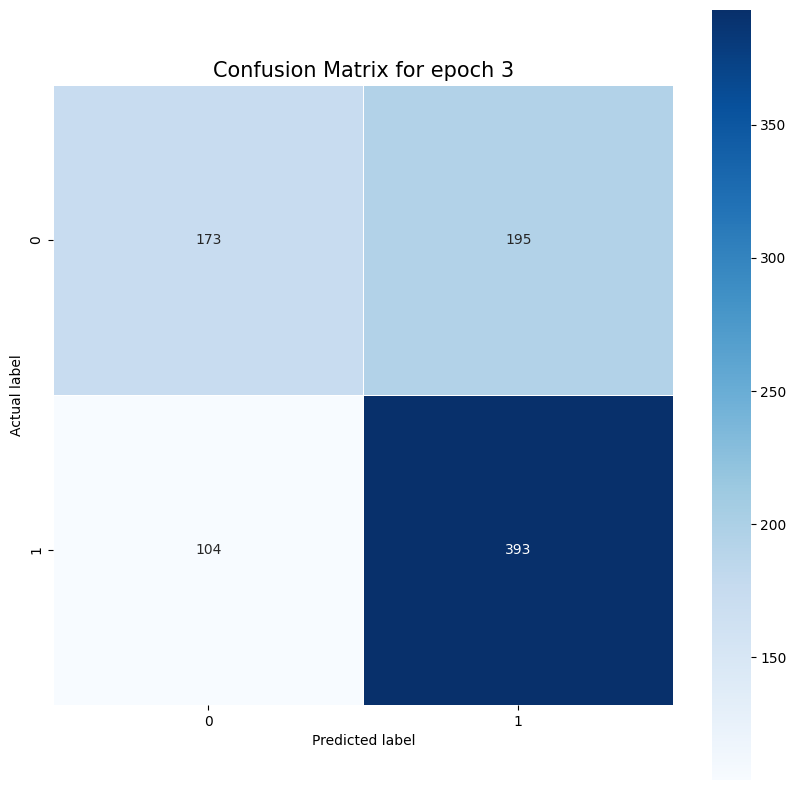

Epoch 4/10:   0%|          | 1/865 [00:04<1:08:50,  4.78s/it]

Accuracy of the model after epoch 4: 0.0%


Epoch 4/10:   0%|          | 2/865 [00:08<1:03:32,  4.42s/it]

Accuracy of the model after epoch 4: 50.0%


Epoch 4/10:   0%|          | 3/865 [00:13<1:02:10,  4.33s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   0%|          | 4/865 [00:17<1:03:51,  4.45s/it]

Accuracy of the model after epoch 4: 75.0%


Epoch 4/10:   1%|          | 5/865 [00:22<1:04:15,  4.48s/it]

Accuracy of the model after epoch 4: 80.0%


Epoch 4/10:   1%|          | 6/865 [00:26<1:02:21,  4.36s/it]

Accuracy of the model after epoch 4: 83.33333333333333%


Epoch 4/10:   1%|          | 7/865 [00:28<52:59,  3.71s/it]  

Accuracy of the model after epoch 4: 71.42857142857143%


Epoch 4/10:   1%|          | 8/865 [00:32<54:41,  3.83s/it]

Accuracy of the model after epoch 4: 62.5%


Epoch 4/10:   1%|          | 9/865 [00:35<49:18,  3.46s/it]

Accuracy of the model after epoch 4: 55.55555555555556%


Epoch 4/10:   1%|          | 10/865 [00:38<46:19,  3.25s/it]

Accuracy of the model after epoch 4: 50.0%


Epoch 4/10:   1%|▏         | 11/865 [00:40<42:24,  2.98s/it]

Accuracy of the model after epoch 4: 54.54545454545455%


Epoch 4/10:   1%|▏         | 12/865 [00:44<47:27,  3.34s/it]

Accuracy of the model after epoch 4: 58.333333333333336%


Epoch 4/10:   2%|▏         | 13/865 [00:49<51:46,  3.65s/it]

Accuracy of the model after epoch 4: 61.53846153846154%


Epoch 4/10:   2%|▏         | 14/865 [00:53<55:55,  3.94s/it]

Accuracy of the model after epoch 4: 64.28571428571429%


Epoch 4/10:   2%|▏         | 15/865 [00:58<58:25,  4.12s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   2%|▏         | 16/865 [01:02<58:36,  4.14s/it]

Accuracy of the model after epoch 4: 68.75%


Epoch 4/10:   2%|▏         | 17/865 [01:06<57:56,  4.10s/it]

Accuracy of the model after epoch 4: 70.58823529411765%


Epoch 4/10:   2%|▏         | 18/865 [01:10<58:42,  4.16s/it]

Accuracy of the model after epoch 4: 72.22222222222223%


Epoch 4/10:   2%|▏         | 19/865 [01:15<1:00:37,  4.30s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:   2%|▏         | 20/865 [01:18<54:43,  3.89s/it]  

Accuracy of the model after epoch 4: 70.0%


Epoch 4/10:   2%|▏         | 21/865 [01:20<47:58,  3.41s/it]

Accuracy of the model after epoch 4: 71.42857142857143%


Epoch 4/10:   3%|▎         | 22/865 [01:25<51:51,  3.69s/it]

Accuracy of the model after epoch 4: 72.72727272727273%


Epoch 4/10:   3%|▎         | 23/865 [01:29<53:35,  3.82s/it]

Accuracy of the model after epoch 4: 73.91304347826087%


Epoch 4/10:   3%|▎         | 24/865 [01:33<56:06,  4.00s/it]

Accuracy of the model after epoch 4: 70.83333333333333%


Epoch 4/10:   3%|▎         | 25/865 [01:38<1:00:52,  4.35s/it]

Accuracy of the model after epoch 4: 72.0%


Epoch 4/10:   3%|▎         | 26/865 [01:42<1:00:00,  4.29s/it]

Accuracy of the model after epoch 4: 69.23076923076923%


Epoch 4/10:   3%|▎         | 27/865 [01:47<1:01:11,  4.38s/it]

Accuracy of the model after epoch 4: 70.37037037037037%


Epoch 4/10:   3%|▎         | 28/865 [01:52<1:01:51,  4.43s/it]

Accuracy of the model after epoch 4: 67.85714285714286%


Epoch 4/10:   3%|▎         | 29/865 [01:56<1:02:28,  4.48s/it]

Accuracy of the model after epoch 4: 68.96551724137932%


Epoch 4/10:   3%|▎         | 30/865 [02:01<1:04:09,  4.61s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   4%|▎         | 31/865 [02:04<55:13,  3.97s/it]  

Accuracy of the model after epoch 4: 64.51612903225806%


Epoch 4/10:   4%|▎         | 32/865 [02:08<56:44,  4.09s/it]

Accuracy of the model after epoch 4: 65.625%


Epoch 4/10:   4%|▍         | 33/865 [02:13<59:46,  4.31s/it]

Accuracy of the model after epoch 4: 63.63636363636363%


Epoch 4/10:   4%|▍         | 34/865 [02:15<51:42,  3.73s/it]

Accuracy of the model after epoch 4: 64.70588235294117%


Epoch 4/10:   4%|▍         | 35/865 [02:18<47:41,  3.45s/it]

Accuracy of the model after epoch 4: 65.71428571428571%


Epoch 4/10:   4%|▍         | 36/865 [02:22<50:21,  3.64s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   4%|▍         | 37/865 [02:25<45:53,  3.33s/it]

Accuracy of the model after epoch 4: 67.56756756756756%


Epoch 4/10:   4%|▍         | 38/865 [02:29<51:48,  3.76s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:   5%|▍         | 39/865 [02:32<47:12,  3.43s/it]

Accuracy of the model after epoch 4: 69.23076923076923%


Epoch 4/10:   5%|▍         | 40/865 [02:36<50:57,  3.71s/it]

Accuracy of the model after epoch 4: 70.0%


Epoch 4/10:   5%|▍         | 41/865 [02:41<53:18,  3.88s/it]

Accuracy of the model after epoch 4: 68.29268292682927%


Epoch 4/10:   5%|▍         | 42/865 [02:45<54:03,  3.94s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   5%|▍         | 43/865 [02:50<57:49,  4.22s/it]

Accuracy of the model after epoch 4: 65.11627906976744%


Epoch 4/10:   5%|▌         | 44/865 [02:55<1:01:48,  4.52s/it]

Accuracy of the model after epoch 4: 63.63636363636363%


Epoch 4/10:   5%|▌         | 45/865 [03:00<1:02:51,  4.60s/it]

Accuracy of the model after epoch 4: 64.44444444444444%


Epoch 4/10:   5%|▌         | 46/865 [03:04<1:03:41,  4.67s/it]

Accuracy of the model after epoch 4: 65.21739130434783%


Epoch 4/10:   5%|▌         | 47/865 [03:09<1:02:09,  4.56s/it]

Accuracy of the model after epoch 4: 63.829787234042556%


Epoch 4/10:   6%|▌         | 48/865 [03:14<1:03:11,  4.64s/it]

Accuracy of the model after epoch 4: 64.58333333333333%


Epoch 4/10:   6%|▌         | 49/865 [03:19<1:07:18,  4.95s/it]

Accuracy of the model after epoch 4: 65.3061224489796%


Epoch 4/10:   6%|▌         | 50/865 [03:24<1:05:55,  4.85s/it]

Accuracy of the model after epoch 4: 66.0%


Epoch 4/10:   6%|▌         | 51/865 [03:28<1:03:33,  4.69s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   6%|▌         | 52/865 [03:32<1:01:39,  4.55s/it]

Accuracy of the model after epoch 4: 65.38461538461539%


Epoch 4/10:   6%|▌         | 53/865 [03:37<1:02:49,  4.64s/it]

Accuracy of the model after epoch 4: 64.15094339622641%


Epoch 4/10:   6%|▌         | 54/865 [03:42<1:04:50,  4.80s/it]

Accuracy of the model after epoch 4: 64.81481481481481%


Epoch 4/10:   6%|▋         | 55/865 [03:47<1:04:25,  4.77s/it]

Accuracy of the model after epoch 4: 65.45454545454545%


Epoch 4/10:   6%|▋         | 56/865 [03:52<1:02:37,  4.65s/it]

Accuracy of the model after epoch 4: 66.07142857142857%


Epoch 4/10:   7%|▋         | 57/865 [03:56<1:01:11,  4.54s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   7%|▋         | 58/865 [04:00<1:01:27,  4.57s/it]

Accuracy of the model after epoch 4: 67.24137931034483%


Epoch 4/10:   7%|▋         | 59/865 [04:06<1:04:25,  4.80s/it]

Accuracy of the model after epoch 4: 67.79661016949153%


Epoch 4/10:   7%|▋         | 60/865 [04:10<1:04:01,  4.77s/it]

Accuracy of the model after epoch 4: 68.33333333333333%


Epoch 4/10:   7%|▋         | 61/865 [04:13<53:52,  4.02s/it]  

Accuracy of the model after epoch 4: 68.85245901639344%


Epoch 4/10:   7%|▋         | 62/865 [04:15<47:20,  3.54s/it]

Accuracy of the model after epoch 4: 69.35483870967742%


Epoch 4/10:   7%|▋         | 63/865 [04:18<43:14,  3.24s/it]

Accuracy of the model after epoch 4: 69.84126984126983%


Epoch 4/10:   7%|▋         | 64/865 [04:20<40:09,  3.01s/it]

Accuracy of the model after epoch 4: 70.3125%


Epoch 4/10:   8%|▊         | 65/865 [04:23<39:57,  3.00s/it]

Accuracy of the model after epoch 4: 69.23076923076923%


Epoch 4/10:   8%|▊         | 66/865 [04:28<46:32,  3.50s/it]

Accuracy of the model after epoch 4: 69.6969696969697%


Epoch 4/10:   8%|▊         | 67/865 [04:33<51:35,  3.88s/it]

Accuracy of the model after epoch 4: 68.65671641791045%


Epoch 4/10:   8%|▊         | 68/865 [04:37<53:56,  4.06s/it]

Accuracy of the model after epoch 4: 69.11764705882354%


Epoch 4/10:   8%|▊         | 69/865 [04:42<56:43,  4.28s/it]

Accuracy of the model after epoch 4: 68.1159420289855%


Epoch 4/10:   8%|▊         | 70/865 [04:47<58:45,  4.43s/it]

Accuracy of the model after epoch 4: 68.57142857142857%


Epoch 4/10:   8%|▊         | 71/865 [04:51<58:40,  4.43s/it]

Accuracy of the model after epoch 4: 67.6056338028169%


Epoch 4/10:   8%|▊         | 72/865 [04:55<58:20,  4.41s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:   8%|▊         | 73/865 [05:01<1:02:05,  4.70s/it]

Accuracy of the model after epoch 4: 67.12328767123287%


Epoch 4/10:   9%|▊         | 74/865 [05:06<1:02:22,  4.73s/it]

Accuracy of the model after epoch 4: 67.56756756756756%


Epoch 4/10:   9%|▊         | 75/865 [05:11<1:05:01,  4.94s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:   9%|▉         | 76/865 [05:16<1:05:55,  5.01s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:   9%|▉         | 77/865 [05:21<1:04:56,  4.95s/it]

Accuracy of the model after epoch 4: 68.83116883116882%


Epoch 4/10:   9%|▉         | 78/865 [05:26<1:05:23,  4.98s/it]

Accuracy of the model after epoch 4: 67.94871794871794%


Epoch 4/10:   9%|▉         | 79/865 [05:32<1:07:46,  5.17s/it]

Accuracy of the model after epoch 4: 68.35443037974683%


Epoch 4/10:   9%|▉         | 80/865 [05:36<1:05:00,  4.97s/it]

Accuracy of the model after epoch 4: 68.75%


Epoch 4/10:   9%|▉         | 81/865 [05:39<55:05,  4.22s/it]  

Accuracy of the model after epoch 4: 69.1358024691358%


Epoch 4/10:   9%|▉         | 82/865 [05:43<55:22,  4.24s/it]

Accuracy of the model after epoch 4: 69.51219512195122%


Epoch 4/10:  10%|▉         | 83/865 [05:47<55:23,  4.25s/it]

Accuracy of the model after epoch 4: 69.87951807228916%


Epoch 4/10:  10%|▉         | 84/865 [05:52<56:42,  4.36s/it]

Accuracy of the model after epoch 4: 70.23809523809524%


Epoch 4/10:  10%|▉         | 85/865 [05:55<50:46,  3.91s/it]

Accuracy of the model after epoch 4: 70.58823529411765%


Epoch 4/10:  10%|▉         | 86/865 [05:59<51:25,  3.96s/it]

Accuracy of the model after epoch 4: 70.93023255813954%


Epoch 4/10:  10%|█         | 87/865 [06:03<52:14,  4.03s/it]

Accuracy of the model after epoch 4: 71.26436781609195%


Epoch 4/10:  10%|█         | 88/865 [06:08<54:20,  4.20s/it]

Accuracy of the model after epoch 4: 70.45454545454545%


Epoch 4/10:  10%|█         | 89/865 [06:13<58:52,  4.55s/it]

Accuracy of the model after epoch 4: 69.66292134831461%


Epoch 4/10:  10%|█         | 90/865 [06:17<58:47,  4.55s/it]

Accuracy of the model after epoch 4: 68.88888888888889%


Epoch 4/10:  11%|█         | 91/865 [06:21<56:29,  4.38s/it]

Accuracy of the model after epoch 4: 69.23076923076923%


Epoch 4/10:  11%|█         | 92/865 [06:24<48:23,  3.76s/it]

Accuracy of the model after epoch 4: 69.56521739130434%


Epoch 4/10:  11%|█         | 93/865 [06:28<52:03,  4.05s/it]

Accuracy of the model after epoch 4: 68.81720430107526%


Epoch 4/10:  11%|█         | 94/865 [06:33<53:08,  4.14s/it]

Accuracy of the model after epoch 4: 69.14893617021276%


Epoch 4/10:  11%|█         | 95/865 [06:36<48:31,  3.78s/it]

Accuracy of the model after epoch 4: 69.47368421052632%


Epoch 4/10:  11%|█         | 96/865 [06:38<43:12,  3.37s/it]

Accuracy of the model after epoch 4: 69.79166666666667%


Epoch 4/10:  11%|█         | 97/865 [06:42<46:31,  3.63s/it]

Accuracy of the model after epoch 4: 69.0721649484536%


Epoch 4/10:  11%|█▏        | 98/865 [06:47<48:29,  3.79s/it]

Accuracy of the model after epoch 4: 69.38775510204081%


Epoch 4/10:  11%|█▏        | 99/865 [06:51<50:14,  3.93s/it]

Accuracy of the model after epoch 4: 69.6969696969697%


Epoch 4/10:  12%|█▏        | 100/865 [06:54<46:04,  3.61s/it]

Accuracy of the model after epoch 4: 70.0%


Epoch 4/10:  12%|█▏        | 101/865 [06:58<47:39,  3.74s/it]

Accuracy of the model after epoch 4: 69.3069306930693%


Epoch 4/10:  12%|█▏        | 102/865 [07:00<42:34,  3.35s/it]

Accuracy of the model after epoch 4: 68.62745098039215%


Epoch 4/10:  12%|█▏        | 103/865 [07:05<47:05,  3.71s/it]

Accuracy of the model after epoch 4: 67.96116504854369%


Epoch 4/10:  12%|█▏        | 104/865 [07:09<50:20,  3.97s/it]

Accuracy of the model after epoch 4: 67.3076923076923%


Epoch 4/10:  12%|█▏        | 105/865 [07:14<52:37,  4.15s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  12%|█▏        | 106/865 [07:16<45:30,  3.60s/it]

Accuracy of the model after epoch 4: 66.98113207547169%


Epoch 4/10:  12%|█▏        | 107/865 [07:20<47:27,  3.76s/it]

Accuracy of the model after epoch 4: 67.28971962616822%


Epoch 4/10:  12%|█▏        | 108/865 [07:25<49:45,  3.94s/it]

Accuracy of the model after epoch 4: 67.5925925925926%


Epoch 4/10:  13%|█▎        | 109/865 [07:27<44:24,  3.52s/it]

Accuracy of the model after epoch 4: 67.88990825688073%


Epoch 4/10:  13%|█▎        | 110/865 [07:32<49:07,  3.90s/it]

Accuracy of the model after epoch 4: 67.27272727272727%


Epoch 4/10:  13%|█▎        | 111/865 [07:36<50:25,  4.01s/it]

Accuracy of the model after epoch 4: 67.56756756756756%


Epoch 4/10:  13%|█▎        | 112/865 [07:39<44:46,  3.57s/it]

Accuracy of the model after epoch 4: 66.96428571428571%


Epoch 4/10:  13%|█▎        | 113/865 [07:43<47:06,  3.76s/it]

Accuracy of the model after epoch 4: 67.2566371681416%


Epoch 4/10:  13%|█▎        | 114/865 [07:48<50:17,  4.02s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  13%|█▎        | 115/865 [07:50<45:08,  3.61s/it]

Accuracy of the model after epoch 4: 66.95652173913044%


Epoch 4/10:  13%|█▎        | 116/865 [07:54<46:42,  3.74s/it]

Accuracy of the model after epoch 4: 66.37931034482759%


Epoch 4/10:  14%|█▎        | 117/865 [07:59<48:44,  3.91s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  14%|█▎        | 118/865 [08:01<43:01,  3.46s/it]

Accuracy of the model after epoch 4: 66.10169491525424%


Epoch 4/10:  14%|█▍        | 119/865 [08:06<48:51,  3.93s/it]

Accuracy of the model after epoch 4: 65.54621848739495%


Epoch 4/10:  14%|█▍        | 120/865 [08:09<44:35,  3.59s/it]

Accuracy of the model after epoch 4: 65.0%


Epoch 4/10:  14%|█▍        | 121/865 [08:13<47:31,  3.83s/it]

Accuracy of the model after epoch 4: 65.2892561983471%


Epoch 4/10:  14%|█▍        | 122/865 [08:18<49:05,  3.96s/it]

Accuracy of the model after epoch 4: 65.57377049180327%


Epoch 4/10:  14%|█▍        | 123/865 [08:22<49:58,  4.04s/it]

Accuracy of the model after epoch 4: 65.85365853658537%


Epoch 4/10:  14%|█▍        | 124/865 [08:27<52:19,  4.24s/it]

Accuracy of the model after epoch 4: 66.12903225806451%


Epoch 4/10:  14%|█▍        | 125/865 [08:31<53:08,  4.31s/it]

Accuracy of the model after epoch 4: 65.6%


Epoch 4/10:  15%|█▍        | 126/865 [08:36<54:33,  4.43s/it]

Accuracy of the model after epoch 4: 65.07936507936508%


Epoch 4/10:  15%|█▍        | 127/865 [08:40<53:25,  4.34s/it]

Accuracy of the model after epoch 4: 64.56692913385827%


Epoch 4/10:  15%|█▍        | 128/865 [08:45<54:48,  4.46s/it]

Accuracy of the model after epoch 4: 64.84375%


Epoch 4/10:  15%|█▍        | 129/865 [08:50<56:55,  4.64s/it]

Accuracy of the model after epoch 4: 65.11627906976744%


Epoch 4/10:  15%|█▌        | 130/865 [08:54<56:42,  4.63s/it]

Accuracy of the model after epoch 4: 65.38461538461539%


Epoch 4/10:  15%|█▌        | 131/865 [08:57<49:13,  4.02s/it]

Accuracy of the model after epoch 4: 65.64885496183206%


Epoch 4/10:  15%|█▌        | 132/865 [09:01<50:06,  4.10s/it]

Accuracy of the model after epoch 4: 65.15151515151516%


Epoch 4/10:  15%|█▌        | 133/865 [09:06<51:05,  4.19s/it]

Accuracy of the model after epoch 4: 65.41353383458646%


Epoch 4/10:  15%|█▌        | 134/865 [09:11<54:09,  4.45s/it]

Accuracy of the model after epoch 4: 65.67164179104478%


Epoch 4/10:  16%|█▌        | 135/865 [09:16<56:02,  4.61s/it]

Accuracy of the model after epoch 4: 65.92592592592592%


Epoch 4/10:  16%|█▌        | 136/865 [09:20<56:38,  4.66s/it]

Accuracy of the model after epoch 4: 65.44117647058823%


Epoch 4/10:  16%|█▌        | 137/865 [09:23<47:49,  3.94s/it]

Accuracy of the model after epoch 4: 65.69343065693431%


Epoch 4/10:  16%|█▌        | 138/865 [09:25<41:41,  3.44s/it]

Accuracy of the model after epoch 4: 65.21739130434783%


Epoch 4/10:  16%|█▌        | 139/865 [09:29<45:34,  3.77s/it]

Accuracy of the model after epoch 4: 65.46762589928058%


Epoch 4/10:  16%|█▌        | 140/865 [09:32<42:22,  3.51s/it]

Accuracy of the model after epoch 4: 65.71428571428571%


Epoch 4/10:  16%|█▋        | 141/865 [09:37<44:49,  3.72s/it]

Accuracy of the model after epoch 4: 65.95744680851064%


Epoch 4/10:  16%|█▋        | 142/865 [09:41<46:37,  3.87s/it]

Accuracy of the model after epoch 4: 66.19718309859155%


Epoch 4/10:  17%|█▋        | 143/865 [09:45<47:52,  3.98s/it]

Accuracy of the model after epoch 4: 66.43356643356644%


Epoch 4/10:  17%|█▋        | 144/865 [09:49<48:52,  4.07s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  17%|█▋        | 145/865 [09:54<50:17,  4.19s/it]

Accuracy of the model after epoch 4: 66.20689655172414%


Epoch 4/10:  17%|█▋        | 146/865 [09:58<51:04,  4.26s/it]

Accuracy of the model after epoch 4: 65.75342465753425%


Epoch 4/10:  17%|█▋        | 147/865 [10:03<51:33,  4.31s/it]

Accuracy of the model after epoch 4: 65.3061224489796%


Epoch 4/10:  17%|█▋        | 148/865 [10:05<45:10,  3.78s/it]

Accuracy of the model after epoch 4: 65.54054054054055%


Epoch 4/10:  17%|█▋        | 149/865 [10:07<40:00,  3.35s/it]

Accuracy of the model after epoch 4: 65.1006711409396%


Epoch 4/10:  17%|█▋        | 150/865 [10:12<44:06,  3.70s/it]

Accuracy of the model after epoch 4: 64.66666666666667%


Epoch 4/10:  17%|█▋        | 151/865 [10:16<45:51,  3.85s/it]

Accuracy of the model after epoch 4: 64.23841059602648%


Epoch 4/10:  18%|█▊        | 152/865 [10:20<47:05,  3.96s/it]

Accuracy of the model after epoch 4: 64.47368421052632%


Epoch 4/10:  18%|█▊        | 153/865 [10:26<51:16,  4.32s/it]

Accuracy of the model after epoch 4: 64.70588235294117%


Epoch 4/10:  18%|█▊        | 154/865 [10:28<44:50,  3.78s/it]

Accuracy of the model after epoch 4: 64.93506493506493%


Epoch 4/10:  18%|█▊        | 155/865 [10:33<47:48,  4.04s/it]

Accuracy of the model after epoch 4: 65.16129032258064%


Epoch 4/10:  18%|█▊        | 156/865 [10:37<48:06,  4.07s/it]

Accuracy of the model after epoch 4: 65.38461538461539%


Epoch 4/10:  18%|█▊        | 157/865 [10:41<48:55,  4.15s/it]

Accuracy of the model after epoch 4: 65.60509554140127%


Epoch 4/10:  18%|█▊        | 158/865 [10:44<42:32,  3.61s/it]

Accuracy of the model after epoch 4: 65.82278481012658%


Epoch 4/10:  18%|█▊        | 159/865 [10:46<38:06,  3.24s/it]

Accuracy of the model after epoch 4: 66.0377358490566%


Epoch 4/10:  18%|█▊        | 160/865 [10:51<43:05,  3.67s/it]

Accuracy of the model after epoch 4: 66.25%


Epoch 4/10:  19%|█▊        | 161/865 [10:53<37:59,  3.24s/it]

Accuracy of the model after epoch 4: 66.45962732919254%


Epoch 4/10:  19%|█▊        | 162/865 [10:57<41:01,  3.50s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  19%|█▉        | 163/865 [11:01<43:33,  3.72s/it]

Accuracy of the model after epoch 4: 66.87116564417178%


Epoch 4/10:  19%|█▉        | 164/865 [11:04<38:38,  3.31s/it]

Accuracy of the model after epoch 4: 67.07317073170732%


Epoch 4/10:  19%|█▉        | 165/865 [11:08<42:27,  3.64s/it]

Accuracy of the model after epoch 4: 67.27272727272727%


Epoch 4/10:  19%|█▉        | 166/865 [11:12<44:34,  3.83s/it]

Accuracy of the model after epoch 4: 67.46987951807229%


Epoch 4/10:  19%|█▉        | 167/865 [11:16<45:56,  3.95s/it]

Accuracy of the model after epoch 4: 67.06586826347305%


Epoch 4/10:  19%|█▉        | 168/865 [11:21<48:17,  4.16s/it]

Accuracy of the model after epoch 4: 67.26190476190476%


Epoch 4/10:  20%|█▉        | 169/865 [11:24<42:45,  3.69s/it]

Accuracy of the model after epoch 4: 67.45562130177515%


Epoch 4/10:  20%|█▉        | 170/865 [11:26<39:36,  3.42s/it]

Accuracy of the model after epoch 4: 67.6470588235294%


Epoch 4/10:  20%|█▉        | 171/865 [11:31<42:36,  3.68s/it]

Accuracy of the model after epoch 4: 67.83625730994152%


Epoch 4/10:  20%|█▉        | 172/865 [11:35<44:23,  3.84s/it]

Accuracy of the model after epoch 4: 67.44186046511628%


Epoch 4/10:  20%|██        | 173/865 [11:37<39:06,  3.39s/it]

Accuracy of the model after epoch 4: 67.6300578034682%


Epoch 4/10:  20%|██        | 174/865 [11:40<36:06,  3.13s/it]

Accuracy of the model after epoch 4: 67.24137931034483%


Epoch 4/10:  20%|██        | 175/865 [11:44<40:17,  3.50s/it]

Accuracy of the model after epoch 4: 67.42857142857143%


Epoch 4/10:  20%|██        | 176/865 [11:47<37:00,  3.22s/it]

Accuracy of the model after epoch 4: 67.61363636363636%


Epoch 4/10:  20%|██        | 177/865 [11:51<40:10,  3.50s/it]

Accuracy of the model after epoch 4: 67.79661016949153%


Epoch 4/10:  21%|██        | 178/865 [11:55<42:51,  3.74s/it]

Accuracy of the model after epoch 4: 67.41573033707866%


Epoch 4/10:  21%|██        | 179/865 [12:00<45:59,  4.02s/it]

Accuracy of the model after epoch 4: 67.59776536312849%


Epoch 4/10:  21%|██        | 180/865 [12:04<47:19,  4.14s/it]

Accuracy of the model after epoch 4: 67.22222222222223%


Epoch 4/10:  21%|██        | 181/865 [12:08<46:49,  4.11s/it]

Accuracy of the model after epoch 4: 67.40331491712708%


Epoch 4/10:  21%|██        | 182/865 [12:11<41:41,  3.66s/it]

Accuracy of the model after epoch 4: 67.58241758241758%


Epoch 4/10:  21%|██        | 183/865 [12:15<43:48,  3.85s/it]

Accuracy of the model after epoch 4: 67.21311475409836%


Epoch 4/10:  21%|██▏       | 184/865 [12:19<44:48,  3.95s/it]

Accuracy of the model after epoch 4: 67.3913043478261%


Epoch 4/10:  21%|██▏       | 185/865 [12:24<46:34,  4.11s/it]

Accuracy of the model after epoch 4: 67.56756756756756%


Epoch 4/10:  22%|██▏       | 186/865 [12:28<46:45,  4.13s/it]

Accuracy of the model after epoch 4: 67.74193548387096%


Epoch 4/10:  22%|██▏       | 187/865 [12:33<48:23,  4.28s/it]

Accuracy of the model after epoch 4: 67.37967914438502%


Epoch 4/10:  22%|██▏       | 188/865 [12:37<49:36,  4.40s/it]

Accuracy of the model after epoch 4: 67.02127659574468%


Epoch 4/10:  22%|██▏       | 189/865 [12:40<43:20,  3.85s/it]

Accuracy of the model after epoch 4: 67.19576719576719%


Epoch 4/10:  22%|██▏       | 190/865 [12:44<45:19,  4.03s/it]

Accuracy of the model after epoch 4: 67.36842105263158%


Epoch 4/10:  22%|██▏       | 191/865 [12:49<48:07,  4.28s/it]

Accuracy of the model after epoch 4: 67.53926701570681%


Epoch 4/10:  22%|██▏       | 192/865 [12:52<42:00,  3.75s/it]

Accuracy of the model after epoch 4: 67.70833333333333%


Epoch 4/10:  22%|██▏       | 193/865 [12:56<43:34,  3.89s/it]

Accuracy of the model after epoch 4: 67.87564766839378%


Epoch 4/10:  22%|██▏       | 194/865 [13:01<45:50,  4.10s/it]

Accuracy of the model after epoch 4: 68.04123711340206%


Epoch 4/10:  23%|██▎       | 195/865 [13:05<47:12,  4.23s/it]

Accuracy of the model after epoch 4: 67.6923076923077%


Epoch 4/10:  23%|██▎       | 196/865 [13:07<40:28,  3.63s/it]

Accuracy of the model after epoch 4: 67.34693877551021%


Epoch 4/10:  23%|██▎       | 197/865 [13:10<36:39,  3.29s/it]

Accuracy of the model after epoch 4: 67.51269035532995%


Epoch 4/10:  23%|██▎       | 198/865 [13:14<39:55,  3.59s/it]

Accuracy of the model after epoch 4: 67.67676767676768%


Epoch 4/10:  23%|██▎       | 199/865 [13:19<43:21,  3.91s/it]

Accuracy of the model after epoch 4: 67.8391959798995%


Epoch 4/10:  23%|██▎       | 200/865 [13:22<39:25,  3.56s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  23%|██▎       | 201/865 [13:26<41:44,  3.77s/it]

Accuracy of the model after epoch 4: 68.1592039800995%


Epoch 4/10:  23%|██▎       | 202/865 [13:28<37:32,  3.40s/it]

Accuracy of the model after epoch 4: 68.31683168316832%


Epoch 4/10:  23%|██▎       | 203/865 [13:31<34:08,  3.09s/it]

Accuracy of the model after epoch 4: 68.47290640394088%


Epoch 4/10:  24%|██▎       | 204/865 [13:35<37:35,  3.41s/it]

Accuracy of the model after epoch 4: 68.13725490196079%


Epoch 4/10:  24%|██▎       | 205/865 [13:39<40:33,  3.69s/it]

Accuracy of the model after epoch 4: 68.29268292682927%


Epoch 4/10:  24%|██▍       | 206/865 [13:42<36:30,  3.32s/it]

Accuracy of the model after epoch 4: 68.44660194174757%


Epoch 4/10:  24%|██▍       | 207/865 [13:46<39:08,  3.57s/it]

Accuracy of the model after epoch 4: 68.59903381642512%


Epoch 4/10:  24%|██▍       | 208/865 [13:50<41:03,  3.75s/it]

Accuracy of the model after epoch 4: 68.26923076923077%


Epoch 4/10:  24%|██▍       | 209/865 [13:55<44:13,  4.04s/it]

Accuracy of the model after epoch 4: 67.94258373205741%


Epoch 4/10:  24%|██▍       | 210/865 [13:58<39:59,  3.66s/it]

Accuracy of the model after epoch 4: 68.0952380952381%


Epoch 4/10:  24%|██▍       | 211/865 [14:02<41:53,  3.84s/it]

Accuracy of the model after epoch 4: 67.77251184834124%


Epoch 4/10:  25%|██▍       | 212/865 [14:06<43:33,  4.00s/it]

Accuracy of the model after epoch 4: 67.9245283018868%


Epoch 4/10:  25%|██▍       | 213/865 [14:09<38:54,  3.58s/it]

Accuracy of the model after epoch 4: 67.6056338028169%


Epoch 4/10:  25%|██▍       | 214/865 [14:11<34:26,  3.17s/it]

Accuracy of the model after epoch 4: 67.75700934579439%


Epoch 4/10:  25%|██▍       | 215/865 [14:15<38:19,  3.54s/it]

Accuracy of the model after epoch 4: 67.90697674418605%


Epoch 4/10:  25%|██▍       | 216/865 [14:20<40:43,  3.77s/it]

Accuracy of the model after epoch 4: 68.05555555555556%


Epoch 4/10:  25%|██▌       | 217/865 [14:24<42:23,  3.92s/it]

Accuracy of the model after epoch 4: 67.74193548387096%


Epoch 4/10:  25%|██▌       | 218/865 [14:29<45:30,  4.22s/it]

Accuracy of the model after epoch 4: 67.88990825688073%


Epoch 4/10:  25%|██▌       | 219/865 [14:34<49:34,  4.60s/it]

Accuracy of the model after epoch 4: 67.57990867579909%


Epoch 4/10:  25%|██▌       | 220/865 [14:39<50:13,  4.67s/it]

Accuracy of the model after epoch 4: 67.72727272727273%


Epoch 4/10:  26%|██▌       | 221/865 [14:44<50:27,  4.70s/it]

Accuracy of the model after epoch 4: 67.87330316742081%


Epoch 4/10:  26%|██▌       | 222/865 [14:46<43:19,  4.04s/it]

Accuracy of the model after epoch 4: 68.01801801801801%


Epoch 4/10:  26%|██▌       | 223/865 [14:51<45:12,  4.23s/it]

Accuracy of the model after epoch 4: 68.16143497757848%


Epoch 4/10:  26%|██▌       | 224/865 [14:56<46:10,  4.32s/it]

Accuracy of the model after epoch 4: 68.30357142857143%


Epoch 4/10:  26%|██▌       | 225/865 [15:00<47:09,  4.42s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  26%|██▌       | 226/865 [15:05<46:55,  4.41s/it]

Accuracy of the model after epoch 4: 67.69911504424779%


Epoch 4/10:  26%|██▌       | 227/865 [15:09<46:01,  4.33s/it]

Accuracy of the model after epoch 4: 67.40088105726872%


Epoch 4/10:  26%|██▋       | 228/865 [15:13<46:29,  4.38s/it]

Accuracy of the model after epoch 4: 67.54385964912281%


Epoch 4/10:  26%|██▋       | 229/865 [15:18<47:55,  4.52s/it]

Accuracy of the model after epoch 4: 67.68558951965065%


Epoch 4/10:  27%|██▋       | 230/865 [15:21<42:54,  4.05s/it]

Accuracy of the model after epoch 4: 67.82608695652173%


Epoch 4/10:  27%|██▋       | 231/865 [15:26<44:23,  4.20s/it]

Accuracy of the model after epoch 4: 67.96536796536796%


Epoch 4/10:  27%|██▋       | 232/865 [15:30<44:08,  4.18s/it]

Accuracy of the model after epoch 4: 68.10344827586206%


Epoch 4/10:  27%|██▋       | 233/865 [15:34<44:21,  4.21s/it]

Accuracy of the model after epoch 4: 67.81115879828326%


Epoch 4/10:  27%|██▋       | 234/865 [15:38<44:19,  4.22s/it]

Accuracy of the model after epoch 4: 67.94871794871794%


Epoch 4/10:  27%|██▋       | 235/865 [15:41<39:08,  3.73s/it]

Accuracy of the model after epoch 4: 68.08510638297872%


Epoch 4/10:  27%|██▋       | 236/865 [15:45<40:14,  3.84s/it]

Accuracy of the model after epoch 4: 67.79661016949153%


Epoch 4/10:  27%|██▋       | 237/865 [15:49<41:25,  3.96s/it]

Accuracy of the model after epoch 4: 67.9324894514768%


Epoch 4/10:  28%|██▊       | 238/865 [15:53<42:02,  4.02s/it]

Accuracy of the model after epoch 4: 68.0672268907563%


Epoch 4/10:  28%|██▊       | 239/865 [15:58<44:21,  4.25s/it]

Accuracy of the model after epoch 4: 68.20083682008368%


Epoch 4/10:  28%|██▊       | 240/865 [16:03<44:20,  4.26s/it]

Accuracy of the model after epoch 4: 68.33333333333333%


Epoch 4/10:  28%|██▊       | 241/865 [16:07<43:29,  4.18s/it]

Accuracy of the model after epoch 4: 68.46473029045643%


Epoch 4/10:  28%|██▊       | 242/865 [16:09<38:45,  3.73s/it]

Accuracy of the model after epoch 4: 68.59504132231405%


Epoch 4/10:  28%|██▊       | 243/865 [16:13<40:11,  3.88s/it]

Accuracy of the model after epoch 4: 68.3127572016461%


Epoch 4/10:  28%|██▊       | 244/865 [16:18<43:22,  4.19s/it]

Accuracy of the model after epoch 4: 68.44262295081967%


Epoch 4/10:  28%|██▊       | 245/865 [16:21<38:42,  3.75s/it]

Accuracy of the model after epoch 4: 68.57142857142857%


Epoch 4/10:  28%|██▊       | 246/865 [16:25<40:09,  3.89s/it]

Accuracy of the model after epoch 4: 68.29268292682927%


Epoch 4/10:  29%|██▊       | 247/865 [16:29<40:38,  3.95s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:  29%|██▊       | 248/865 [16:34<41:37,  4.05s/it]

Accuracy of the model after epoch 4: 68.14516129032258%


Epoch 4/10:  29%|██▉       | 249/865 [16:38<43:40,  4.25s/it]

Accuracy of the model after epoch 4: 68.27309236947791%


Epoch 4/10:  29%|██▉       | 250/865 [16:43<44:44,  4.36s/it]

Accuracy of the model after epoch 4: 68.4%


Epoch 4/10:  29%|██▉       | 251/865 [16:47<44:25,  4.34s/it]

Accuracy of the model after epoch 4: 68.12749003984064%


Epoch 4/10:  29%|██▉       | 252/865 [16:50<38:22,  3.76s/it]

Accuracy of the model after epoch 4: 68.25396825396825%


Epoch 4/10:  29%|██▉       | 253/865 [16:54<40:17,  3.95s/it]

Accuracy of the model after epoch 4: 67.98418972332016%


Epoch 4/10:  29%|██▉       | 254/865 [16:59<42:59,  4.22s/it]

Accuracy of the model after epoch 4: 67.71653543307086%


Epoch 4/10:  29%|██▉       | 255/865 [17:04<44:09,  4.34s/it]

Accuracy of the model after epoch 4: 67.84313725490196%


Epoch 4/10:  30%|██▉       | 256/865 [17:08<44:05,  4.34s/it]

Accuracy of the model after epoch 4: 67.96875%


Epoch 4/10:  30%|██▉       | 257/865 [17:10<38:22,  3.79s/it]

Accuracy of the model after epoch 4: 68.09338521400778%


Epoch 4/10:  30%|██▉       | 258/865 [17:15<41:25,  4.09s/it]

Accuracy of the model after epoch 4: 67.82945736434108%


Epoch 4/10:  30%|██▉       | 259/865 [17:18<36:31,  3.62s/it]

Accuracy of the model after epoch 4: 67.95366795366796%


Epoch 4/10:  30%|███       | 260/865 [17:22<39:24,  3.91s/it]

Accuracy of the model after epoch 4: 68.07692307692308%


Epoch 4/10:  30%|███       | 261/865 [17:27<40:21,  4.01s/it]

Accuracy of the model after epoch 4: 68.19923371647509%


Epoch 4/10:  30%|███       | 262/865 [17:31<40:52,  4.07s/it]

Accuracy of the model after epoch 4: 68.3206106870229%


Epoch 4/10:  30%|███       | 263/865 [17:33<36:30,  3.64s/it]

Accuracy of the model after epoch 4: 68.44106463878327%


Epoch 4/10:  31%|███       | 264/865 [17:38<40:01,  4.00s/it]

Accuracy of the model after epoch 4: 68.56060606060606%


Epoch 4/10:  31%|███       | 265/865 [17:43<41:56,  4.19s/it]

Accuracy of the model after epoch 4: 68.30188679245283%


Epoch 4/10:  31%|███       | 266/865 [17:48<44:20,  4.44s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:  31%|███       | 267/865 [17:52<44:12,  4.44s/it]

Accuracy of the model after epoch 4: 68.53932584269663%


Epoch 4/10:  31%|███       | 268/865 [17:57<45:09,  4.54s/it]

Accuracy of the model after epoch 4: 68.28358208955224%


Epoch 4/10:  31%|███       | 269/865 [18:03<47:44,  4.81s/it]

Accuracy of the model after epoch 4: 68.02973977695167%


Epoch 4/10:  31%|███       | 270/865 [18:05<41:39,  4.20s/it]

Accuracy of the model after epoch 4: 68.14814814814815%


Epoch 4/10:  31%|███▏      | 271/865 [18:10<42:08,  4.26s/it]

Accuracy of the model after epoch 4: 68.26568265682657%


Epoch 4/10:  31%|███▏      | 272/865 [18:14<43:27,  4.40s/it]

Accuracy of the model after epoch 4: 68.38235294117646%


Epoch 4/10:  32%|███▏      | 273/865 [18:19<43:57,  4.45s/it]

Accuracy of the model after epoch 4: 68.4981684981685%


Epoch 4/10:  32%|███▏      | 274/865 [18:24<45:27,  4.62s/it]

Accuracy of the model after epoch 4: 68.61313868613139%


Epoch 4/10:  32%|███▏      | 275/865 [18:27<39:54,  4.06s/it]

Accuracy of the model after epoch 4: 68.72727272727273%


Epoch 4/10:  32%|███▏      | 276/865 [18:29<35:12,  3.59s/it]

Accuracy of the model after epoch 4: 68.84057971014492%


Epoch 4/10:  32%|███▏      | 277/865 [18:33<37:04,  3.78s/it]

Accuracy of the model after epoch 4: 68.95306859205776%


Epoch 4/10:  32%|███▏      | 278/865 [18:38<39:42,  4.06s/it]

Accuracy of the model after epoch 4: 68.70503597122303%


Epoch 4/10:  32%|███▏      | 279/865 [18:43<40:45,  4.17s/it]

Accuracy of the model after epoch 4: 68.81720430107526%


Epoch 4/10:  32%|███▏      | 280/865 [18:47<41:54,  4.30s/it]

Accuracy of the model after epoch 4: 68.57142857142857%


Epoch 4/10:  32%|███▏      | 281/865 [18:51<41:39,  4.28s/it]

Accuracy of the model after epoch 4: 68.32740213523131%


Epoch 4/10:  33%|███▎      | 282/865 [18:56<42:30,  4.37s/it]

Accuracy of the model after epoch 4: 68.43971631205673%


Epoch 4/10:  33%|███▎      | 283/865 [18:58<36:45,  3.79s/it]

Accuracy of the model after epoch 4: 68.55123674911661%


Epoch 4/10:  33%|███▎      | 284/865 [19:03<39:36,  4.09s/it]

Accuracy of the model after epoch 4: 68.66197183098592%


Epoch 4/10:  33%|███▎      | 285/865 [19:08<40:10,  4.16s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:  33%|███▎      | 286/865 [19:12<40:30,  4.20s/it]

Accuracy of the model after epoch 4: 68.18181818181819%


Epoch 4/10:  33%|███▎      | 287/865 [19:14<35:35,  3.69s/it]

Accuracy of the model after epoch 4: 68.29268292682927%


Epoch 4/10:  33%|███▎      | 288/865 [19:19<37:45,  3.93s/it]

Accuracy of the model after epoch 4: 68.05555555555556%


Epoch 4/10:  33%|███▎      | 289/865 [19:24<40:53,  4.26s/it]

Accuracy of the model after epoch 4: 67.82006920415225%


Epoch 4/10:  34%|███▎      | 290/865 [19:27<36:17,  3.79s/it]

Accuracy of the model after epoch 4: 67.93103448275862%


Epoch 4/10:  34%|███▎      | 291/865 [19:31<39:21,  4.11s/it]

Accuracy of the model after epoch 4: 68.04123711340206%


Epoch 4/10:  34%|███▍      | 292/865 [19:36<39:38,  4.15s/it]

Accuracy of the model after epoch 4: 67.8082191780822%


Epoch 4/10:  34%|███▍      | 293/865 [19:40<39:45,  4.17s/it]

Accuracy of the model after epoch 4: 67.91808873720136%


Epoch 4/10:  34%|███▍      | 294/865 [19:42<35:03,  3.68s/it]

Accuracy of the model after epoch 4: 68.02721088435374%


Epoch 4/10:  34%|███▍      | 295/865 [19:47<37:55,  3.99s/it]

Accuracy of the model after epoch 4: 68.13559322033899%


Epoch 4/10:  34%|███▍      | 296/865 [19:51<37:58,  4.00s/it]

Accuracy of the model after epoch 4: 68.24324324324324%


Epoch 4/10:  34%|███▍      | 297/865 [19:55<38:41,  4.09s/it]

Accuracy of the model after epoch 4: 68.01346801346801%


Epoch 4/10:  34%|███▍      | 298/865 [20:00<39:05,  4.14s/it]

Accuracy of the model after epoch 4: 68.12080536912751%


Epoch 4/10:  35%|███▍      | 299/865 [20:04<40:43,  4.32s/it]

Accuracy of the model after epoch 4: 67.89297658862876%


Epoch 4/10:  35%|███▍      | 300/865 [20:09<41:35,  4.42s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  35%|███▍      | 301/865 [20:13<40:53,  4.35s/it]

Accuracy of the model after epoch 4: 68.10631229235881%


Epoch 4/10:  35%|███▍      | 302/865 [20:16<35:23,  3.77s/it]

Accuracy of the model after epoch 4: 68.21192052980132%


Epoch 4/10:  35%|███▌      | 303/865 [20:20<37:44,  4.03s/it]

Accuracy of the model after epoch 4: 67.98679867986799%


Epoch 4/10:  35%|███▌      | 304/865 [20:25<39:45,  4.25s/it]

Accuracy of the model after epoch 4: 67.76315789473684%


Epoch 4/10:  35%|███▌      | 305/865 [20:28<35:13,  3.77s/it]

Accuracy of the model after epoch 4: 67.54098360655738%


Epoch 4/10:  35%|███▌      | 306/865 [20:32<36:27,  3.91s/it]

Accuracy of the model after epoch 4: 67.6470588235294%


Epoch 4/10:  35%|███▌      | 307/865 [20:35<32:23,  3.48s/it]

Accuracy of the model after epoch 4: 67.75244299674267%


Epoch 4/10:  36%|███▌      | 308/865 [20:39<34:19,  3.70s/it]

Accuracy of the model after epoch 4: 67.85714285714286%


Epoch 4/10:  36%|███▌      | 309/865 [20:43<35:49,  3.87s/it]

Accuracy of the model after epoch 4: 67.63754045307444%


Epoch 4/10:  36%|███▌      | 310/865 [20:45<31:54,  3.45s/it]

Accuracy of the model after epoch 4: 67.74193548387096%


Epoch 4/10:  36%|███▌      | 311/865 [20:50<33:58,  3.68s/it]

Accuracy of the model after epoch 4: 67.52411575562701%


Epoch 4/10:  36%|███▌      | 312/865 [20:54<35:14,  3.82s/it]

Accuracy of the model after epoch 4: 67.62820512820512%


Epoch 4/10:  36%|███▌      | 313/865 [20:58<35:58,  3.91s/it]

Accuracy of the model after epoch 4: 67.73162939297124%


Epoch 4/10:  36%|███▋      | 314/865 [21:01<32:30,  3.54s/it]

Accuracy of the model after epoch 4: 67.51592356687898%


Epoch 4/10:  36%|███▋      | 315/865 [21:05<35:15,  3.85s/it]

Accuracy of the model after epoch 4: 67.61904761904762%


Epoch 4/10:  37%|███▋      | 316/865 [21:09<36:11,  3.96s/it]

Accuracy of the model after epoch 4: 67.72151898734177%


Epoch 4/10:  37%|███▋      | 317/865 [21:14<37:13,  4.08s/it]

Accuracy of the model after epoch 4: 67.50788643533123%


Epoch 4/10:  37%|███▋      | 318/865 [21:18<37:44,  4.14s/it]

Accuracy of the model after epoch 4: 67.29559748427673%


Epoch 4/10:  37%|███▋      | 319/865 [21:23<38:53,  4.27s/it]

Accuracy of the model after epoch 4: 67.39811912225706%


Epoch 4/10:  37%|███▋      | 320/865 [21:25<34:15,  3.77s/it]

Accuracy of the model after epoch 4: 67.5%


Epoch 4/10:  37%|███▋      | 321/865 [21:29<35:23,  3.90s/it]

Accuracy of the model after epoch 4: 67.601246105919%


Epoch 4/10:  37%|███▋      | 322/865 [21:34<36:24,  4.02s/it]

Accuracy of the model after epoch 4: 67.70186335403727%


Epoch 4/10:  37%|███▋      | 323/865 [21:36<32:12,  3.57s/it]

Accuracy of the model after epoch 4: 67.80185758513932%


Epoch 4/10:  37%|███▋      | 324/865 [21:41<35:16,  3.91s/it]

Accuracy of the model after epoch 4: 67.5925925925926%


Epoch 4/10:  38%|███▊      | 325/865 [21:44<32:24,  3.60s/it]

Accuracy of the model after epoch 4: 67.38461538461539%


Epoch 4/10:  38%|███▊      | 326/865 [21:48<34:29,  3.84s/it]

Accuracy of the model after epoch 4: 67.48466257668711%


Epoch 4/10:  38%|███▊      | 327/865 [21:52<35:16,  3.93s/it]

Accuracy of the model after epoch 4: 67.58409785932722%


Epoch 4/10:  38%|███▊      | 328/865 [21:57<36:42,  4.10s/it]

Accuracy of the model after epoch 4: 67.6829268292683%


Epoch 4/10:  38%|███▊      | 329/865 [22:02<40:19,  4.51s/it]

Accuracy of the model after epoch 4: 67.47720364741642%


Epoch 4/10:  38%|███▊      | 330/865 [22:07<40:42,  4.57s/it]

Accuracy of the model after epoch 4: 67.57575757575758%


Epoch 4/10:  38%|███▊      | 331/865 [22:12<40:54,  4.60s/it]

Accuracy of the model after epoch 4: 67.6737160120846%


Epoch 4/10:  38%|███▊      | 332/865 [22:16<40:55,  4.61s/it]

Accuracy of the model after epoch 4: 67.7710843373494%


Epoch 4/10:  38%|███▊      | 333/865 [22:19<34:44,  3.92s/it]

Accuracy of the model after epoch 4: 67.86786786786787%


Epoch 4/10:  39%|███▊      | 334/865 [22:23<36:59,  4.18s/it]

Accuracy of the model after epoch 4: 67.96407185628742%


Epoch 4/10:  39%|███▊      | 335/865 [22:28<38:10,  4.32s/it]

Accuracy of the model after epoch 4: 67.76119402985074%


Epoch 4/10:  39%|███▉      | 336/865 [22:32<38:09,  4.33s/it]

Accuracy of the model after epoch 4: 67.55952380952381%


Epoch 4/10:  39%|███▉      | 337/865 [22:37<38:50,  4.41s/it]

Accuracy of the model after epoch 4: 67.65578635014836%


Epoch 4/10:  39%|███▉      | 338/865 [22:39<33:34,  3.82s/it]

Accuracy of the model after epoch 4: 67.75147928994083%


Epoch 4/10:  39%|███▉      | 339/865 [22:45<37:26,  4.27s/it]

Accuracy of the model after epoch 4: 67.84660766961652%


Epoch 4/10:  39%|███▉      | 340/865 [22:50<39:38,  4.53s/it]

Accuracy of the model after epoch 4: 67.94117647058823%


Epoch 4/10:  39%|███▉      | 341/865 [22:54<39:36,  4.53s/it]

Accuracy of the model after epoch 4: 68.03519061583577%


Epoch 4/10:  40%|███▉      | 342/865 [22:59<38:23,  4.41s/it]

Accuracy of the model after epoch 4: 68.12865497076024%


Epoch 4/10:  40%|███▉      | 343/865 [23:01<33:12,  3.82s/it]

Accuracy of the model after epoch 4: 68.22157434402332%


Epoch 4/10:  40%|███▉      | 344/865 [23:05<34:26,  3.97s/it]

Accuracy of the model after epoch 4: 68.02325581395348%


Epoch 4/10:  40%|███▉      | 345/865 [23:10<36:57,  4.27s/it]

Accuracy of the model after epoch 4: 68.1159420289855%


Epoch 4/10:  40%|████      | 346/865 [23:13<32:25,  3.75s/it]

Accuracy of the model after epoch 4: 68.20809248554913%


Epoch 4/10:  40%|████      | 347/865 [23:17<34:19,  3.98s/it]

Accuracy of the model after epoch 4: 68.29971181556196%


Epoch 4/10:  40%|████      | 348/865 [23:22<36:19,  4.21s/it]

Accuracy of the model after epoch 4: 68.39080459770115%


Epoch 4/10:  40%|████      | 349/865 [23:27<37:21,  4.34s/it]

Accuracy of the model after epoch 4: 68.19484240687679%


Epoch 4/10:  40%|████      | 350/865 [23:30<33:07,  3.86s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  41%|████      | 351/865 [23:34<33:54,  3.96s/it]

Accuracy of the model after epoch 4: 68.09116809116809%


Epoch 4/10:  41%|████      | 352/865 [23:36<29:41,  3.47s/it]

Accuracy of the model after epoch 4: 68.18181818181819%


Epoch 4/10:  41%|████      | 353/865 [23:41<32:49,  3.85s/it]

Accuracy of the model after epoch 4: 68.27195467422096%


Epoch 4/10:  41%|████      | 354/865 [23:45<33:39,  3.95s/it]

Accuracy of the model after epoch 4: 68.36158192090396%


Epoch 4/10:  41%|████      | 355/865 [23:50<35:28,  4.17s/it]

Accuracy of the model after epoch 4: 68.16901408450704%


Epoch 4/10:  41%|████      | 356/865 [23:54<37:01,  4.36s/it]

Accuracy of the model after epoch 4: 68.25842696629213%


Epoch 4/10:  41%|████▏     | 357/865 [23:59<36:31,  4.31s/it]

Accuracy of the model after epoch 4: 68.34733893557423%


Epoch 4/10:  41%|████▏     | 358/865 [24:01<31:41,  3.75s/it]

Accuracy of the model after epoch 4: 68.43575418994413%


Epoch 4/10:  42%|████▏     | 359/865 [24:06<34:01,  4.03s/it]

Accuracy of the model after epoch 4: 68.24512534818942%


Epoch 4/10:  42%|████▏     | 360/865 [24:09<30:47,  3.66s/it]

Accuracy of the model after epoch 4: 68.33333333333333%


Epoch 4/10:  42%|████▏     | 361/865 [24:13<32:22,  3.85s/it]

Accuracy of the model after epoch 4: 68.14404432132964%


Epoch 4/10:  42%|████▏     | 362/865 [24:15<28:47,  3.43s/it]

Accuracy of the model after epoch 4: 68.23204419889503%


Epoch 4/10:  42%|████▏     | 363/865 [24:19<30:20,  3.63s/it]

Accuracy of the model after epoch 4: 68.31955922865014%


Epoch 4/10:  42%|████▏     | 364/865 [24:24<31:52,  3.82s/it]

Accuracy of the model after epoch 4: 68.4065934065934%


Epoch 4/10:  42%|████▏     | 365/865 [24:28<34:07,  4.09s/it]

Accuracy of the model after epoch 4: 68.4931506849315%


Epoch 4/10:  42%|████▏     | 366/865 [24:32<33:54,  4.08s/it]

Accuracy of the model after epoch 4: 68.5792349726776%


Epoch 4/10:  42%|████▏     | 367/865 [24:37<34:36,  4.17s/it]

Accuracy of the model after epoch 4: 68.66485013623978%


Epoch 4/10:  43%|████▎     | 368/865 [24:42<35:47,  4.32s/it]

Accuracy of the model after epoch 4: 68.47826086956522%


Epoch 4/10:  43%|████▎     | 369/865 [24:46<37:20,  4.52s/it]

Accuracy of the model after epoch 4: 68.56368563685636%


Epoch 4/10:  43%|████▎     | 370/865 [24:51<37:35,  4.56s/it]

Accuracy of the model after epoch 4: 68.37837837837837%


Epoch 4/10:  43%|████▎     | 371/865 [24:55<36:41,  4.46s/it]

Accuracy of the model after epoch 4: 68.46361185983828%


Epoch 4/10:  43%|████▎     | 372/865 [24:58<31:35,  3.84s/it]

Accuracy of the model after epoch 4: 68.54838709677419%


Epoch 4/10:  43%|████▎     | 373/865 [25:02<32:39,  3.98s/it]

Accuracy of the model after epoch 4: 68.63270777479893%


Epoch 4/10:  43%|████▎     | 374/865 [25:07<34:40,  4.24s/it]

Accuracy of the model after epoch 4: 68.44919786096257%


Epoch 4/10:  43%|████▎     | 375/865 [25:11<35:10,  4.31s/it]

Accuracy of the model after epoch 4: 68.26666666666667%


Epoch 4/10:  43%|████▎     | 376/865 [25:16<34:51,  4.28s/it]

Accuracy of the model after epoch 4: 68.35106382978724%


Epoch 4/10:  44%|████▎     | 377/865 [25:20<34:53,  4.29s/it]

Accuracy of the model after epoch 4: 68.16976127320955%


Epoch 4/10:  44%|████▎     | 378/865 [25:22<30:24,  3.75s/it]

Accuracy of the model after epoch 4: 68.25396825396825%


Epoch 4/10:  44%|████▍     | 379/865 [25:27<31:26,  3.88s/it]

Accuracy of the model after epoch 4: 68.3377308707124%


Epoch 4/10:  44%|████▍     | 380/865 [25:31<32:52,  4.07s/it]

Accuracy of the model after epoch 4: 68.42105263157895%


Epoch 4/10:  44%|████▍     | 381/865 [25:34<29:13,  3.62s/it]

Accuracy of the model after epoch 4: 68.50393700787401%


Epoch 4/10:  44%|████▍     | 382/865 [25:38<31:00,  3.85s/it]

Accuracy of the model after epoch 4: 68.58638743455498%


Epoch 4/10:  44%|████▍     | 383/865 [25:41<28:04,  3.50s/it]

Accuracy of the model after epoch 4: 68.66840731070496%


Epoch 4/10:  44%|████▍     | 384/865 [25:43<25:48,  3.22s/it]

Accuracy of the model after epoch 4: 68.75%


Epoch 4/10:  45%|████▍     | 385/865 [25:48<29:25,  3.68s/it]

Accuracy of the model after epoch 4: 68.83116883116882%


Epoch 4/10:  45%|████▍     | 386/865 [25:52<30:33,  3.83s/it]

Accuracy of the model after epoch 4: 68.9119170984456%


Epoch 4/10:  45%|████▍     | 387/865 [25:57<31:43,  3.98s/it]

Accuracy of the model after epoch 4: 68.9922480620155%


Epoch 4/10:  45%|████▍     | 388/865 [25:59<27:57,  3.52s/it]

Accuracy of the model after epoch 4: 69.0721649484536%


Epoch 4/10:  45%|████▍     | 389/865 [26:04<30:59,  3.91s/it]

Accuracy of the model after epoch 4: 69.15167095115682%


Epoch 4/10:  45%|████▌     | 390/865 [26:09<33:48,  4.27s/it]

Accuracy of the model after epoch 4: 69.23076923076923%


Epoch 4/10:  45%|████▌     | 391/865 [26:13<33:56,  4.30s/it]

Accuracy of the model after epoch 4: 69.0537084398977%


Epoch 4/10:  45%|████▌     | 392/865 [26:18<33:41,  4.27s/it]

Accuracy of the model after epoch 4: 69.13265306122449%


Epoch 4/10:  45%|████▌     | 393/865 [26:22<34:58,  4.45s/it]

Accuracy of the model after epoch 4: 68.95674300254453%


Epoch 4/10:  46%|████▌     | 394/865 [26:27<35:24,  4.51s/it]

Accuracy of the model after epoch 4: 69.03553299492386%


Epoch 4/10:  46%|████▌     | 395/865 [26:32<35:37,  4.55s/it]

Accuracy of the model after epoch 4: 68.86075949367088%


Epoch 4/10:  46%|████▌     | 396/865 [26:36<34:37,  4.43s/it]

Accuracy of the model after epoch 4: 68.93939393939394%


Epoch 4/10:  46%|████▌     | 397/865 [26:40<33:52,  4.34s/it]

Accuracy of the model after epoch 4: 69.0176322418136%


Epoch 4/10:  46%|████▌     | 398/865 [26:45<34:49,  4.47s/it]

Accuracy of the model after epoch 4: 68.84422110552764%


Epoch 4/10:  46%|████▌     | 399/865 [26:49<34:46,  4.48s/it]

Accuracy of the model after epoch 4: 68.92230576441102%


Epoch 4/10:  46%|████▌     | 400/865 [26:54<34:55,  4.51s/it]

Accuracy of the model after epoch 4: 68.75%


Epoch 4/10:  46%|████▋     | 401/865 [26:58<34:17,  4.43s/it]

Accuracy of the model after epoch 4: 68.82793017456359%


Epoch 4/10:  46%|████▋     | 402/865 [27:02<33:44,  4.37s/it]

Accuracy of the model after epoch 4: 68.90547263681592%


Epoch 4/10:  47%|████▋     | 403/865 [27:07<34:08,  4.43s/it]

Accuracy of the model after epoch 4: 68.98263027295286%


Epoch 4/10:  47%|████▋     | 404/865 [27:12<35:00,  4.56s/it]

Accuracy of the model after epoch 4: 69.05940594059406%


Epoch 4/10:  47%|████▋     | 405/865 [27:16<34:30,  4.50s/it]

Accuracy of the model after epoch 4: 68.88888888888889%


Epoch 4/10:  47%|████▋     | 406/865 [27:21<34:57,  4.57s/it]

Accuracy of the model after epoch 4: 68.7192118226601%


Epoch 4/10:  47%|████▋     | 407/865 [27:25<33:49,  4.43s/it]

Accuracy of the model after epoch 4: 68.55036855036855%


Epoch 4/10:  47%|████▋     | 408/865 [27:27<29:22,  3.86s/it]

Accuracy of the model after epoch 4: 68.38235294117646%


Epoch 4/10:  47%|████▋     | 409/865 [27:30<26:12,  3.45s/it]

Accuracy of the model after epoch 4: 68.21515892420538%


Epoch 4/10:  47%|████▋     | 410/865 [27:35<28:43,  3.79s/it]

Accuracy of the model after epoch 4: 68.04878048780488%


Epoch 4/10:  48%|████▊     | 411/865 [27:37<25:36,  3.38s/it]

Accuracy of the model after epoch 4: 68.1265206812652%


Epoch 4/10:  48%|████▊     | 412/865 [27:42<28:44,  3.81s/it]

Accuracy of the model after epoch 4: 67.96116504854369%


Epoch 4/10:  48%|████▊     | 413/865 [27:47<31:05,  4.13s/it]

Accuracy of the model after epoch 4: 68.03874092009686%


Epoch 4/10:  48%|████▊     | 414/865 [27:49<26:30,  3.53s/it]

Accuracy of the model after epoch 4: 68.1159420289855%


Epoch 4/10:  48%|████▊     | 415/865 [27:51<24:43,  3.30s/it]

Accuracy of the model after epoch 4: 67.95180722891567%


Epoch 4/10:  48%|████▊     | 416/865 [27:56<26:34,  3.55s/it]

Accuracy of the model after epoch 4: 67.78846153846153%


Epoch 4/10:  48%|████▊     | 417/865 [28:00<28:41,  3.84s/it]

Accuracy of the model after epoch 4: 67.86570743405275%


Epoch 4/10:  48%|████▊     | 418/865 [28:04<29:16,  3.93s/it]

Accuracy of the model after epoch 4: 67.94258373205741%


Epoch 4/10:  48%|████▊     | 419/865 [28:07<25:56,  3.49s/it]

Accuracy of the model after epoch 4: 68.01909307875896%


Epoch 4/10:  49%|████▊     | 420/865 [28:09<24:08,  3.26s/it]

Accuracy of the model after epoch 4: 67.85714285714286%


Epoch 4/10:  49%|████▊     | 421/865 [28:12<22:20,  3.02s/it]

Accuracy of the model after epoch 4: 67.93349168646081%


Epoch 4/10:  49%|████▉     | 422/865 [28:16<24:47,  3.36s/it]

Accuracy of the model after epoch 4: 68.00947867298578%


Epoch 4/10:  49%|████▉     | 423/865 [28:21<27:04,  3.68s/it]

Accuracy of the model after epoch 4: 68.08510638297872%


Epoch 4/10:  49%|████▉     | 424/865 [28:25<28:38,  3.90s/it]

Accuracy of the model after epoch 4: 67.9245283018868%


Epoch 4/10:  49%|████▉     | 425/865 [28:29<29:47,  4.06s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  49%|████▉     | 426/865 [28:34<30:14,  4.13s/it]

Accuracy of the model after epoch 4: 67.84037558685446%


Epoch 4/10:  49%|████▉     | 427/865 [28:38<30:00,  4.11s/it]

Accuracy of the model after epoch 4: 67.91569086651054%


Epoch 4/10:  49%|████▉     | 428/865 [28:42<30:53,  4.24s/it]

Accuracy of the model after epoch 4: 67.99065420560747%


Epoch 4/10:  50%|████▉     | 429/865 [28:47<31:21,  4.32s/it]

Accuracy of the model after epoch 4: 68.06526806526807%


Epoch 4/10:  50%|████▉     | 430/865 [28:51<31:40,  4.37s/it]

Accuracy of the model after epoch 4: 68.13953488372093%


Epoch 4/10:  50%|████▉     | 431/865 [28:56<31:45,  4.39s/it]

Accuracy of the model after epoch 4: 68.21345707656613%


Epoch 4/10:  50%|████▉     | 432/865 [29:00<31:37,  4.38s/it]

Accuracy of the model after epoch 4: 68.28703703703704%


Epoch 4/10:  50%|█████     | 433/865 [29:05<31:57,  4.44s/it]

Accuracy of the model after epoch 4: 68.36027713625866%


Epoch 4/10:  50%|█████     | 434/865 [29:10<33:11,  4.62s/it]

Accuracy of the model after epoch 4: 68.4331797235023%


Epoch 4/10:  50%|█████     | 435/865 [29:12<28:56,  4.04s/it]

Accuracy of the model after epoch 4: 68.50574712643679%


Epoch 4/10:  50%|█████     | 436/865 [29:15<25:34,  3.58s/it]

Accuracy of the model after epoch 4: 68.34862385321101%


Epoch 4/10:  51%|█████     | 437/865 [29:19<26:59,  3.78s/it]

Accuracy of the model after epoch 4: 68.19221967963387%


Epoch 4/10:  51%|█████     | 438/865 [29:22<24:08,  3.39s/it]

Accuracy of the model after epoch 4: 68.03652968036529%


Epoch 4/10:  51%|█████     | 439/865 [29:26<25:59,  3.66s/it]

Accuracy of the model after epoch 4: 68.10933940774487%


Epoch 4/10:  51%|█████     | 440/865 [29:29<23:48,  3.36s/it]

Accuracy of the model after epoch 4: 68.18181818181819%


Epoch 4/10:  51%|█████     | 441/865 [29:33<25:36,  3.62s/it]

Accuracy of the model after epoch 4: 68.02721088435374%


Epoch 4/10:  51%|█████     | 442/865 [29:38<28:05,  3.98s/it]

Accuracy of the model after epoch 4: 67.87330316742081%


Epoch 4/10:  51%|█████     | 443/865 [29:42<28:29,  4.05s/it]

Accuracy of the model after epoch 4: 67.94582392776523%


Epoch 4/10:  51%|█████▏    | 444/865 [29:47<31:05,  4.43s/it]

Accuracy of the model after epoch 4: 68.01801801801801%


Epoch 4/10:  51%|█████▏    | 445/865 [29:50<26:59,  3.86s/it]

Accuracy of the model after epoch 4: 68.08988764044943%


Epoch 4/10:  52%|█████▏    | 446/865 [29:54<27:28,  3.93s/it]

Accuracy of the model after epoch 4: 67.9372197309417%


Epoch 4/10:  52%|█████▏    | 447/865 [29:56<24:32,  3.52s/it]

Accuracy of the model after epoch 4: 68.0089485458613%


Epoch 4/10:  52%|█████▏    | 448/865 [30:01<25:55,  3.73s/it]

Accuracy of the model after epoch 4: 67.85714285714286%


Epoch 4/10:  52%|█████▏    | 449/865 [30:03<22:45,  3.28s/it]

Accuracy of the model after epoch 4: 67.92873051224944%


Epoch 4/10:  52%|█████▏    | 450/865 [30:06<21:51,  3.16s/it]

Accuracy of the model after epoch 4: 68.0%


Epoch 4/10:  52%|█████▏    | 451/865 [30:10<24:13,  3.51s/it]

Accuracy of the model after epoch 4: 68.0709534368071%


Epoch 4/10:  52%|█████▏    | 452/865 [30:15<26:19,  3.82s/it]

Accuracy of the model after epoch 4: 67.92035398230088%


Epoch 4/10:  52%|█████▏    | 453/865 [30:19<27:19,  3.98s/it]

Accuracy of the model after epoch 4: 67.99116997792494%


Epoch 4/10:  52%|█████▏    | 454/865 [30:24<29:05,  4.25s/it]

Accuracy of the model after epoch 4: 67.84140969162996%


Epoch 4/10:  53%|█████▎    | 455/865 [30:28<29:15,  4.28s/it]

Accuracy of the model after epoch 4: 67.6923076923077%


Epoch 4/10:  53%|█████▎    | 456/865 [30:32<29:06,  4.27s/it]

Accuracy of the model after epoch 4: 67.76315789473684%


Epoch 4/10:  53%|█████▎    | 457/865 [30:35<25:03,  3.69s/it]

Accuracy of the model after epoch 4: 67.83369803063458%


Epoch 4/10:  53%|█████▎    | 458/865 [30:37<22:43,  3.35s/it]

Accuracy of the model after epoch 4: 67.68558951965065%


Epoch 4/10:  53%|█████▎    | 459/865 [30:42<25:13,  3.73s/it]

Accuracy of the model after epoch 4: 67.53812636165577%


Epoch 4/10:  53%|█████▎    | 460/865 [30:45<23:09,  3.43s/it]

Accuracy of the model after epoch 4: 67.6086956521739%


Epoch 4/10:  53%|█████▎    | 461/865 [30:49<25:31,  3.79s/it]

Accuracy of the model after epoch 4: 67.67895878524946%


Epoch 4/10:  53%|█████▎    | 462/865 [30:54<26:31,  3.95s/it]

Accuracy of the model after epoch 4: 67.53246753246754%


Epoch 4/10:  54%|█████▎    | 463/865 [30:58<27:47,  4.15s/it]

Accuracy of the model after epoch 4: 67.60259179265658%


Epoch 4/10:  54%|█████▎    | 464/865 [31:01<24:37,  3.69s/it]

Accuracy of the model after epoch 4: 67.67241379310344%


Epoch 4/10:  54%|█████▍    | 465/865 [31:05<26:12,  3.93s/it]

Accuracy of the model after epoch 4: 67.52688172043011%


Epoch 4/10:  54%|█████▍    | 466/865 [31:09<26:39,  4.01s/it]

Accuracy of the model after epoch 4: 67.59656652360515%


Epoch 4/10:  54%|█████▍    | 467/865 [31:14<26:49,  4.04s/it]

Accuracy of the model after epoch 4: 67.6659528907923%


Epoch 4/10:  54%|█████▍    | 468/865 [31:18<26:53,  4.06s/it]

Accuracy of the model after epoch 4: 67.52136752136752%


Epoch 4/10:  54%|█████▍    | 469/865 [31:20<24:02,  3.64s/it]

Accuracy of the model after epoch 4: 67.59061833688699%


Epoch 4/10:  54%|█████▍    | 470/865 [31:25<25:50,  3.93s/it]

Accuracy of the model after epoch 4: 67.44680851063829%


Epoch 4/10:  54%|█████▍    | 471/865 [31:29<26:07,  3.98s/it]

Accuracy of the model after epoch 4: 67.3036093418259%


Epoch 4/10:  55%|█████▍    | 472/865 [31:33<26:29,  4.04s/it]

Accuracy of the model after epoch 4: 67.37288135593221%


Epoch 4/10:  55%|█████▍    | 473/865 [31:38<27:50,  4.26s/it]

Accuracy of the model after epoch 4: 67.44186046511628%


Epoch 4/10:  55%|█████▍    | 474/865 [31:41<24:56,  3.83s/it]

Accuracy of the model after epoch 4: 67.51054852320675%


Epoch 4/10:  55%|█████▍    | 475/865 [31:44<22:58,  3.53s/it]

Accuracy of the model after epoch 4: 67.36842105263158%


Epoch 4/10:  55%|█████▌    | 476/865 [31:48<24:18,  3.75s/it]

Accuracy of the model after epoch 4: 67.43697478991596%


Epoch 4/10:  55%|█████▌    | 477/865 [31:50<21:40,  3.35s/it]

Accuracy of the model after epoch 4: 67.50524109014675%


Epoch 4/10:  55%|█████▌    | 478/865 [31:55<23:21,  3.62s/it]

Accuracy of the model after epoch 4: 67.36401673640168%


Epoch 4/10:  55%|█████▌    | 479/865 [31:57<21:18,  3.31s/it]

Accuracy of the model after epoch 4: 67.22338204592901%


Epoch 4/10:  55%|█████▌    | 480/865 [32:02<23:52,  3.72s/it]

Accuracy of the model after epoch 4: 67.29166666666667%


Epoch 4/10:  56%|█████▌    | 481/865 [32:04<21:26,  3.35s/it]

Accuracy of the model after epoch 4: 67.35966735966736%


Epoch 4/10:  56%|█████▌    | 482/865 [32:09<24:19,  3.81s/it]

Accuracy of the model after epoch 4: 67.42738589211618%


Epoch 4/10:  56%|█████▌    | 483/865 [32:12<21:35,  3.39s/it]

Accuracy of the model after epoch 4: 67.49482401656314%


Epoch 4/10:  56%|█████▌    | 484/865 [32:14<19:31,  3.07s/it]

Accuracy of the model after epoch 4: 67.35537190082644%


Epoch 4/10:  56%|█████▌    | 485/865 [32:17<18:44,  2.96s/it]

Accuracy of the model after epoch 4: 67.42268041237114%


Epoch 4/10:  56%|█████▌    | 486/865 [32:21<21:26,  3.39s/it]

Accuracy of the model after epoch 4: 67.48971193415638%


Epoch 4/10:  56%|█████▋    | 487/865 [32:26<23:47,  3.78s/it]

Accuracy of the model after epoch 4: 67.5564681724846%


Epoch 4/10:  56%|█████▋    | 488/865 [32:30<24:30,  3.90s/it]

Accuracy of the model after epoch 4: 67.62295081967213%


Epoch 4/10:  57%|█████▋    | 489/865 [32:35<26:06,  4.17s/it]

Accuracy of the model after epoch 4: 67.68916155419222%


Epoch 4/10:  57%|█████▋    | 490/865 [32:39<26:51,  4.30s/it]

Accuracy of the model after epoch 4: 67.75510204081633%


Epoch 4/10:  57%|█████▋    | 491/865 [32:44<27:00,  4.33s/it]

Accuracy of the model after epoch 4: 67.61710794297352%


Epoch 4/10:  57%|█████▋    | 492/865 [32:48<27:04,  4.35s/it]

Accuracy of the model after epoch 4: 67.47967479674797%


Epoch 4/10:  57%|█████▋    | 493/865 [32:53<27:31,  4.44s/it]

Accuracy of the model after epoch 4: 67.34279918864097%


Epoch 4/10:  57%|█████▋    | 494/865 [32:58<29:07,  4.71s/it]

Accuracy of the model after epoch 4: 67.4089068825911%


Epoch 4/10:  57%|█████▋    | 495/865 [33:03<29:23,  4.77s/it]

Accuracy of the model after epoch 4: 67.47474747474747%


Epoch 4/10:  57%|█████▋    | 496/865 [33:05<24:51,  4.04s/it]

Accuracy of the model after epoch 4: 67.54032258064517%


Epoch 4/10:  57%|█████▋    | 497/865 [33:10<25:19,  4.13s/it]

Accuracy of the model after epoch 4: 67.40442655935614%


Epoch 4/10:  58%|█████▊    | 498/865 [33:14<25:13,  4.12s/it]

Accuracy of the model after epoch 4: 67.26907630522088%


Epoch 4/10:  58%|█████▊    | 499/865 [33:18<25:48,  4.23s/it]

Accuracy of the model after epoch 4: 67.13426853707415%


Epoch 4/10:  58%|█████▊    | 500/865 [33:23<26:20,  4.33s/it]

Accuracy of the model after epoch 4: 67.2%


Epoch 4/10:  58%|█████▊    | 501/865 [33:27<25:49,  4.26s/it]

Accuracy of the model after epoch 4: 67.26546906187625%


Epoch 4/10:  58%|█████▊    | 502/865 [33:31<25:40,  4.24s/it]

Accuracy of the model after epoch 4: 67.33067729083665%


Epoch 4/10:  58%|█████▊    | 503/865 [33:36<26:08,  4.33s/it]

Accuracy of the model after epoch 4: 67.39562624254474%


Epoch 4/10:  58%|█████▊    | 504/865 [33:41<27:15,  4.53s/it]

Accuracy of the model after epoch 4: 67.46031746031746%


Epoch 4/10:  58%|█████▊    | 505/865 [33:45<27:02,  4.51s/it]

Accuracy of the model after epoch 4: 67.32673267326733%


Epoch 4/10:  58%|█████▊    | 506/865 [33:50<27:19,  4.57s/it]

Accuracy of the model after epoch 4: 67.19367588932806%


Epoch 4/10:  59%|█████▊    | 507/865 [33:54<27:11,  4.56s/it]

Accuracy of the model after epoch 4: 67.25838264299803%


Epoch 4/10:  59%|█████▊    | 508/865 [33:59<27:37,  4.64s/it]

Accuracy of the model after epoch 4: 67.1259842519685%


Epoch 4/10:  59%|█████▉    | 509/865 [34:04<28:22,  4.78s/it]

Accuracy of the model after epoch 4: 66.99410609037328%


Epoch 4/10:  59%|█████▉    | 510/865 [34:09<27:52,  4.71s/it]

Accuracy of the model after epoch 4: 67.05882352941177%


Epoch 4/10:  59%|█████▉    | 511/865 [34:12<24:07,  4.09s/it]

Accuracy of the model after epoch 4: 67.12328767123287%


Epoch 4/10:  59%|█████▉    | 512/865 [34:16<25:24,  4.32s/it]

Accuracy of the model after epoch 4: 67.1875%


Epoch 4/10:  59%|█████▉    | 513/865 [34:21<25:39,  4.37s/it]

Accuracy of the model after epoch 4: 67.05653021442495%


Epoch 4/10:  59%|█████▉    | 514/865 [34:25<26:02,  4.45s/it]

Accuracy of the model after epoch 4: 66.92607003891051%


Epoch 4/10:  60%|█████▉    | 515/865 [34:30<26:23,  4.53s/it]

Accuracy of the model after epoch 4: 66.79611650485437%


Epoch 4/10:  60%|█████▉    | 516/865 [34:35<26:40,  4.59s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  60%|█████▉    | 517/865 [34:39<26:03,  4.49s/it]

Accuracy of the model after epoch 4: 66.53771760154739%


Epoch 4/10:  60%|█████▉    | 518/865 [34:44<26:14,  4.54s/it]

Accuracy of the model after epoch 4: 66.40926640926641%


Epoch 4/10:  60%|██████    | 519/865 [34:49<27:55,  4.84s/it]

Accuracy of the model after epoch 4: 66.28131021194605%


Epoch 4/10:  60%|██████    | 520/865 [34:54<27:01,  4.70s/it]

Accuracy of the model after epoch 4: 66.15384615384616%


Epoch 4/10:  60%|██████    | 521/865 [34:58<26:00,  4.54s/it]

Accuracy of the model after epoch 4: 66.21880998080614%


Epoch 4/10:  60%|██████    | 522/865 [35:02<25:40,  4.49s/it]

Accuracy of the model after epoch 4: 66.28352490421456%


Epoch 4/10:  60%|██████    | 523/865 [35:07<25:34,  4.49s/it]

Accuracy of the model after epoch 4: 66.1567877629063%


Epoch 4/10:  61%|██████    | 524/865 [35:12<26:11,  4.61s/it]

Accuracy of the model after epoch 4: 66.03053435114504%


Epoch 4/10:  61%|██████    | 525/865 [35:16<25:56,  4.58s/it]

Accuracy of the model after epoch 4: 66.0952380952381%


Epoch 4/10:  61%|██████    | 526/865 [35:18<21:53,  3.87s/it]

Accuracy of the model after epoch 4: 66.1596958174905%


Epoch 4/10:  61%|██████    | 527/865 [35:21<19:28,  3.46s/it]

Accuracy of the model after epoch 4: 66.22390891840607%


Epoch 4/10:  61%|██████    | 528/865 [35:24<18:00,  3.21s/it]

Accuracy of the model after epoch 4: 66.28787878787878%


Epoch 4/10:  61%|██████    | 529/865 [35:28<19:43,  3.52s/it]

Accuracy of the model after epoch 4: 66.351606805293%


Epoch 4/10:  61%|██████▏   | 530/865 [35:31<18:25,  3.30s/it]

Accuracy of the model after epoch 4: 66.41509433962264%


Epoch 4/10:  61%|██████▏   | 531/865 [35:33<17:07,  3.08s/it]

Accuracy of the model after epoch 4: 66.29001883239171%


Epoch 4/10:  62%|██████▏   | 532/865 [35:37<18:59,  3.42s/it]

Accuracy of the model after epoch 4: 66.16541353383458%


Epoch 4/10:  62%|██████▏   | 533/865 [35:40<17:30,  3.16s/it]

Accuracy of the model after epoch 4: 66.22889305816135%


Epoch 4/10:  62%|██████▏   | 534/865 [35:44<19:24,  3.52s/it]

Accuracy of the model after epoch 4: 66.10486891385767%


Epoch 4/10:  62%|██████▏   | 535/865 [35:49<20:58,  3.81s/it]

Accuracy of the model after epoch 4: 66.16822429906541%


Epoch 4/10:  62%|██████▏   | 536/865 [35:51<18:27,  3.37s/it]

Accuracy of the model after epoch 4: 66.23134328358209%


Epoch 4/10:  62%|██████▏   | 537/865 [35:55<20:00,  3.66s/it]

Accuracy of the model after epoch 4: 66.10800744878958%


Epoch 4/10:  62%|██████▏   | 538/865 [36:00<20:51,  3.83s/it]

Accuracy of the model after epoch 4: 66.17100371747212%


Epoch 4/10:  62%|██████▏   | 539/865 [36:02<18:33,  3.41s/it]

Accuracy of the model after epoch 4: 66.04823747680891%


Epoch 4/10:  62%|██████▏   | 540/865 [36:06<20:00,  3.69s/it]

Accuracy of the model after epoch 4: 66.11111111111111%


Epoch 4/10:  63%|██████▎   | 541/865 [36:09<18:20,  3.40s/it]

Accuracy of the model after epoch 4: 66.17375231053605%


Epoch 4/10:  63%|██████▎   | 542/865 [36:13<19:20,  3.59s/it]

Accuracy of the model after epoch 4: 66.23616236162361%


Epoch 4/10:  63%|██████▎   | 543/865 [36:17<20:05,  3.74s/it]

Accuracy of the model after epoch 4: 66.29834254143647%


Epoch 4/10:  63%|██████▎   | 544/865 [36:20<17:45,  3.32s/it]

Accuracy of the model after epoch 4: 66.17647058823529%


Epoch 4/10:  63%|██████▎   | 545/865 [36:24<20:13,  3.79s/it]

Accuracy of the model after epoch 4: 66.05504587155963%


Epoch 4/10:  63%|██████▎   | 546/865 [36:29<20:45,  3.91s/it]

Accuracy of the model after epoch 4: 65.93406593406593%


Epoch 4/10:  63%|██████▎   | 547/865 [36:33<21:56,  4.14s/it]

Accuracy of the model after epoch 4: 65.81352833638026%


Epoch 4/10:  63%|██████▎   | 548/865 [36:38<22:36,  4.28s/it]

Accuracy of the model after epoch 4: 65.87591240875912%


Epoch 4/10:  63%|██████▎   | 549/865 [36:40<19:24,  3.69s/it]

Accuracy of the model after epoch 4: 65.93806921675774%


Epoch 4/10:  64%|██████▎   | 550/865 [36:43<17:54,  3.41s/it]

Accuracy of the model after epoch 4: 66.0%


Epoch 4/10:  64%|██████▎   | 551/865 [36:47<19:09,  3.66s/it]

Accuracy of the model after epoch 4: 66.0617059891107%


Epoch 4/10:  64%|██████▍   | 552/865 [36:52<20:08,  3.86s/it]

Accuracy of the model after epoch 4: 65.94202898550725%


Epoch 4/10:  64%|██████▍   | 553/865 [36:56<20:39,  3.97s/it]

Accuracy of the model after epoch 4: 66.00361663652802%


Epoch 4/10:  64%|██████▍   | 554/865 [37:01<21:54,  4.23s/it]

Accuracy of the model after epoch 4: 66.06498194945848%


Epoch 4/10:  64%|██████▍   | 555/865 [37:05<22:14,  4.30s/it]

Accuracy of the model after epoch 4: 66.12612612612612%


Epoch 4/10:  64%|██████▍   | 556/865 [37:09<22:07,  4.30s/it]

Accuracy of the model after epoch 4: 66.18705035971223%


Epoch 4/10:  64%|██████▍   | 557/865 [37:12<19:27,  3.79s/it]

Accuracy of the model after epoch 4: 66.24775583482945%


Epoch 4/10:  65%|██████▍   | 558/865 [37:16<20:19,  3.97s/it]

Accuracy of the model after epoch 4: 66.30824372759857%


Epoch 4/10:  65%|██████▍   | 559/865 [37:19<17:39,  3.46s/it]

Accuracy of the model after epoch 4: 66.3685152057245%


Epoch 4/10:  65%|██████▍   | 560/865 [37:23<19:15,  3.79s/it]

Accuracy of the model after epoch 4: 66.42857142857143%


Epoch 4/10:  65%|██████▍   | 561/865 [37:28<20:09,  3.98s/it]

Accuracy of the model after epoch 4: 66.48841354723707%


Epoch 4/10:  65%|██████▍   | 562/865 [37:32<20:19,  4.02s/it]

Accuracy of the model after epoch 4: 66.54804270462634%


Epoch 4/10:  65%|██████▌   | 563/865 [37:34<18:09,  3.61s/it]

Accuracy of the model after epoch 4: 66.42984014209591%


Epoch 4/10:  65%|██████▌   | 564/865 [37:40<20:20,  4.06s/it]

Accuracy of the model after epoch 4: 66.48936170212765%


Epoch 4/10:  65%|██████▌   | 565/865 [37:42<18:10,  3.63s/it]

Accuracy of the model after epoch 4: 66.54867256637168%


Epoch 4/10:  65%|██████▌   | 566/865 [37:47<19:37,  3.94s/it]

Accuracy of the model after epoch 4: 66.60777385159011%


Epoch 4/10:  66%|██████▌   | 567/865 [37:51<20:31,  4.13s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  66%|██████▌   | 568/865 [37:56<20:39,  4.17s/it]

Accuracy of the model after epoch 4: 66.54929577464789%


Epoch 4/10:  66%|██████▌   | 569/865 [38:00<21:19,  4.32s/it]

Accuracy of the model after epoch 4: 66.4323374340949%


Epoch 4/10:  66%|██████▌   | 570/865 [38:03<19:10,  3.90s/it]

Accuracy of the model after epoch 4: 66.3157894736842%


Epoch 4/10:  66%|██████▌   | 571/865 [38:08<20:01,  4.09s/it]

Accuracy of the model after epoch 4: 66.37478108581436%


Epoch 4/10:  66%|██████▌   | 572/865 [38:12<20:21,  4.17s/it]

Accuracy of the model after epoch 4: 66.43356643356644%


Epoch 4/10:  66%|██████▌   | 573/865 [38:16<20:08,  4.14s/it]

Accuracy of the model after epoch 4: 66.49214659685863%


Epoch 4/10:  66%|██████▋   | 574/865 [38:21<21:00,  4.33s/it]

Accuracy of the model after epoch 4: 66.37630662020906%


Epoch 4/10:  66%|██████▋   | 575/865 [38:26<22:05,  4.57s/it]

Accuracy of the model after epoch 4: 66.43478260869566%


Epoch 4/10:  67%|██████▋   | 576/865 [38:30<21:32,  4.47s/it]

Accuracy of the model after epoch 4: 66.31944444444444%


Epoch 4/10:  67%|██████▋   | 577/865 [38:35<21:01,  4.38s/it]

Accuracy of the model after epoch 4: 66.37781629116118%


Epoch 4/10:  67%|██████▋   | 578/865 [38:37<18:03,  3.77s/it]

Accuracy of the model after epoch 4: 66.43598615916954%


Epoch 4/10:  67%|██████▋   | 579/865 [38:42<19:57,  4.19s/it]

Accuracy of the model after epoch 4: 66.32124352331606%


Epoch 4/10:  67%|██████▋   | 580/865 [38:47<20:21,  4.28s/it]

Accuracy of the model after epoch 4: 66.37931034482759%


Epoch 4/10:  67%|██████▋   | 581/865 [38:49<17:43,  3.75s/it]

Accuracy of the model after epoch 4: 66.43717728055077%


Epoch 4/10:  67%|██████▋   | 582/865 [38:53<18:20,  3.89s/it]

Accuracy of the model after epoch 4: 66.49484536082474%


Epoch 4/10:  67%|██████▋   | 583/865 [38:58<18:56,  4.03s/it]

Accuracy of the model after epoch 4: 66.38078902229846%


Epoch 4/10:  68%|██████▊   | 584/865 [39:02<19:30,  4.17s/it]

Accuracy of the model after epoch 4: 66.26712328767124%


Epoch 4/10:  68%|██████▊   | 585/865 [39:07<19:53,  4.26s/it]

Accuracy of the model after epoch 4: 66.32478632478633%


Epoch 4/10:  68%|██████▊   | 586/865 [39:11<19:44,  4.25s/it]

Accuracy of the model after epoch 4: 66.21160409556315%


Epoch 4/10:  68%|██████▊   | 587/865 [39:13<17:00,  3.67s/it]

Accuracy of the model after epoch 4: 66.26916524701873%


Epoch 4/10:  68%|██████▊   | 588/865 [39:16<15:17,  3.31s/it]

Accuracy of the model after epoch 4: 66.3265306122449%


Epoch 4/10:  68%|██████▊   | 589/865 [39:20<17:00,  3.70s/it]

Accuracy of the model after epoch 4: 66.21392190152801%


Epoch 4/10:  68%|██████▊   | 590/865 [39:25<18:13,  3.98s/it]

Accuracy of the model after epoch 4: 66.27118644067797%


Epoch 4/10:  68%|██████▊   | 591/865 [39:29<18:36,  4.08s/it]

Accuracy of the model after epoch 4: 66.32825719120136%


Epoch 4/10:  68%|██████▊   | 592/865 [39:32<16:18,  3.59s/it]

Accuracy of the model after epoch 4: 66.38513513513513%


Epoch 4/10:  69%|██████▊   | 593/865 [39:36<17:10,  3.79s/it]

Accuracy of the model after epoch 4: 66.27318718381113%


Epoch 4/10:  69%|██████▊   | 594/865 [39:41<18:22,  4.07s/it]

Accuracy of the model after epoch 4: 66.16161616161617%


Epoch 4/10:  69%|██████▉   | 595/865 [39:43<16:21,  3.64s/it]

Accuracy of the model after epoch 4: 66.05042016806723%


Epoch 4/10:  69%|██████▉   | 596/865 [39:46<14:40,  3.27s/it]

Accuracy of the model after epoch 4: 66.10738255033557%


Epoch 4/10:  69%|██████▉   | 597/865 [39:50<16:07,  3.61s/it]

Accuracy of the model after epoch 4: 66.1641541038526%


Epoch 4/10:  69%|██████▉   | 598/865 [39:52<14:29,  3.26s/it]

Accuracy of the model after epoch 4: 66.22073578595318%


Epoch 4/10:  69%|██████▉   | 599/865 [39:57<15:40,  3.54s/it]

Accuracy of the model after epoch 4: 66.2771285475793%


Epoch 4/10:  69%|██████▉   | 600/865 [40:01<17:06,  3.87s/it]

Accuracy of the model after epoch 4: 66.33333333333333%


Epoch 4/10:  69%|██████▉   | 601/865 [40:06<18:28,  4.20s/it]

Accuracy of the model after epoch 4: 66.38935108153078%


Epoch 4/10:  70%|██████▉   | 602/865 [40:09<16:12,  3.70s/it]

Accuracy of the model after epoch 4: 66.44518272425249%


Epoch 4/10:  70%|██████▉   | 603/865 [40:11<14:11,  3.25s/it]

Accuracy of the model after epoch 4: 66.50082918739635%


Epoch 4/10:  70%|██████▉   | 604/865 [40:13<13:09,  3.03s/it]

Accuracy of the model after epoch 4: 66.55629139072848%


Epoch 4/10:  70%|██████▉   | 605/865 [40:18<14:54,  3.44s/it]

Accuracy of the model after epoch 4: 66.61157024793388%


Epoch 4/10:  70%|███████   | 606/865 [40:22<15:45,  3.65s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  70%|███████   | 607/865 [40:26<16:27,  3.83s/it]

Accuracy of the model after epoch 4: 66.55683690280065%


Epoch 4/10:  70%|███████   | 608/865 [40:31<17:30,  4.09s/it]

Accuracy of the model after epoch 4: 66.44736842105263%


Epoch 4/10:  70%|███████   | 609/865 [40:36<18:48,  4.41s/it]

Accuracy of the model after epoch 4: 66.50246305418719%


Epoch 4/10:  71%|███████   | 610/865 [40:39<16:29,  3.88s/it]

Accuracy of the model after epoch 4: 66.39344262295081%


Epoch 4/10:  71%|███████   | 611/865 [40:41<14:30,  3.43s/it]

Accuracy of the model after epoch 4: 66.44844517184943%


Epoch 4/10:  71%|███████   | 612/865 [40:45<15:25,  3.66s/it]

Accuracy of the model after epoch 4: 66.50326797385621%


Epoch 4/10:  71%|███████   | 613/865 [40:50<16:31,  3.93s/it]

Accuracy of the model after epoch 4: 66.557911908646%


Epoch 4/10:  71%|███████   | 614/865 [40:52<14:34,  3.49s/it]

Accuracy of the model after epoch 4: 66.61237785016287%


Epoch 4/10:  71%|███████   | 615/865 [40:57<15:43,  3.77s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  71%|███████   | 616/865 [41:01<16:15,  3.92s/it]

Accuracy of the model after epoch 4: 66.72077922077922%


Epoch 4/10:  71%|███████▏  | 617/865 [41:06<17:04,  4.13s/it]

Accuracy of the model after epoch 4: 66.61264181523501%


Epoch 4/10:  71%|███████▏  | 618/865 [41:11<17:52,  4.34s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  72%|███████▏  | 619/865 [41:16<18:56,  4.62s/it]

Accuracy of the model after epoch 4: 66.5589660743134%


Epoch 4/10:  72%|███████▏  | 620/865 [41:21<19:31,  4.78s/it]

Accuracy of the model after epoch 4: 66.61290322580645%


Epoch 4/10:  72%|███████▏  | 621/865 [41:25<18:47,  4.62s/it]

Accuracy of the model after epoch 4: 66.50563607085346%


Epoch 4/10:  72%|███████▏  | 622/865 [41:28<16:14,  4.01s/it]

Accuracy of the model after epoch 4: 66.55948553054662%


Epoch 4/10:  72%|███████▏  | 623/865 [41:32<16:30,  4.09s/it]

Accuracy of the model after epoch 4: 66.45264847512038%


Epoch 4/10:  72%|███████▏  | 624/865 [41:37<16:52,  4.20s/it]

Accuracy of the model after epoch 4: 66.50641025641026%


Epoch 4/10:  72%|███████▏  | 625/865 [41:41<17:09,  4.29s/it]

Accuracy of the model after epoch 4: 66.4%


Epoch 4/10:  72%|███████▏  | 626/865 [41:45<17:07,  4.30s/it]

Accuracy of the model after epoch 4: 66.29392971246007%


Epoch 4/10:  72%|███████▏  | 627/865 [41:50<17:03,  4.30s/it]

Accuracy of the model after epoch 4: 66.34768740031897%


Epoch 4/10:  73%|███████▎  | 628/865 [41:54<17:25,  4.41s/it]

Accuracy of the model after epoch 4: 66.24203821656052%


Epoch 4/10:  73%|███████▎  | 629/865 [41:59<18:14,  4.64s/it]

Accuracy of the model after epoch 4: 66.29570747217807%


Epoch 4/10:  73%|███████▎  | 630/865 [42:04<18:34,  4.74s/it]

Accuracy of the model after epoch 4: 66.19047619047619%


Epoch 4/10:  73%|███████▎  | 631/865 [42:09<18:08,  4.65s/it]

Accuracy of the model after epoch 4: 66.08557844690966%


Epoch 4/10:  73%|███████▎  | 632/865 [42:13<17:23,  4.48s/it]

Accuracy of the model after epoch 4: 66.13924050632912%


Epoch 4/10:  73%|███████▎  | 633/865 [42:15<14:54,  3.85s/it]

Accuracy of the model after epoch 4: 66.0347551342812%


Epoch 4/10:  73%|███████▎  | 634/865 [42:20<15:30,  4.03s/it]

Accuracy of the model after epoch 4: 65.93059936908517%


Epoch 4/10:  73%|███████▎  | 635/865 [42:24<16:05,  4.20s/it]

Accuracy of the model after epoch 4: 65.98425196850394%


Epoch 4/10:  74%|███████▎  | 636/865 [42:29<16:21,  4.29s/it]

Accuracy of the model after epoch 4: 66.0377358490566%


Epoch 4/10:  74%|███████▎  | 637/865 [42:33<16:33,  4.36s/it]

Accuracy of the model after epoch 4: 66.09105180533751%


Epoch 4/10:  74%|███████▍  | 638/865 [42:38<16:13,  4.29s/it]

Accuracy of the model after epoch 4: 66.14420062695925%


Epoch 4/10:  74%|███████▍  | 639/865 [42:40<13:48,  3.67s/it]

Accuracy of the model after epoch 4: 66.19718309859155%


Epoch 4/10:  74%|███████▍  | 640/865 [42:44<14:41,  3.92s/it]

Accuracy of the model after epoch 4: 66.25%


Epoch 4/10:  74%|███████▍  | 641/865 [42:47<12:59,  3.48s/it]

Accuracy of the model after epoch 4: 66.30265210608424%


Epoch 4/10:  74%|███████▍  | 642/865 [42:49<11:46,  3.17s/it]

Accuracy of the model after epoch 4: 66.35514018691589%


Epoch 4/10:  74%|███████▍  | 643/865 [42:51<10:36,  2.87s/it]

Accuracy of the model after epoch 4: 66.40746500777605%


Epoch 4/10:  74%|███████▍  | 644/865 [42:55<11:51,  3.22s/it]

Accuracy of the model after epoch 4: 66.45962732919254%


Epoch 4/10:  75%|███████▍  | 645/865 [43:00<13:01,  3.55s/it]

Accuracy of the model after epoch 4: 66.51162790697674%


Epoch 4/10:  75%|███████▍  | 646/865 [43:02<11:40,  3.20s/it]

Accuracy of the model after epoch 4: 66.40866873065015%


Epoch 4/10:  75%|███████▍  | 647/865 [43:06<12:42,  3.50s/it]

Accuracy of the model after epoch 4: 66.30602782071098%


Epoch 4/10:  75%|███████▍  | 648/865 [43:09<11:35,  3.20s/it]

Accuracy of the model after epoch 4: 66.35802469135803%


Epoch 4/10:  75%|███████▌  | 649/865 [43:13<13:01,  3.62s/it]

Accuracy of the model after epoch 4: 66.40986132511556%


Epoch 4/10:  75%|███████▌  | 650/865 [43:16<11:50,  3.30s/it]

Accuracy of the model after epoch 4: 66.46153846153847%


Epoch 4/10:  75%|███████▌  | 651/865 [43:21<13:11,  3.70s/it]

Accuracy of the model after epoch 4: 66.3594470046083%


Epoch 4/10:  75%|███████▌  | 652/865 [43:25<13:48,  3.89s/it]

Accuracy of the model after epoch 4: 66.41104294478528%


Epoch 4/10:  75%|███████▌  | 653/865 [43:27<12:09,  3.44s/it]

Accuracy of the model after epoch 4: 66.4624808575804%


Epoch 4/10:  76%|███████▌  | 654/865 [43:32<13:14,  3.76s/it]

Accuracy of the model after epoch 4: 66.5137614678899%


Epoch 4/10:  76%|███████▌  | 655/865 [43:36<13:56,  3.98s/it]

Accuracy of the model after epoch 4: 66.56488549618321%


Epoch 4/10:  76%|███████▌  | 656/865 [43:38<11:58,  3.44s/it]

Accuracy of the model after epoch 4: 66.61585365853658%


Epoch 4/10:  76%|███████▌  | 657/865 [43:43<12:45,  3.68s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  76%|███████▌  | 658/865 [43:47<13:26,  3.90s/it]

Accuracy of the model after epoch 4: 66.71732522796353%


Epoch 4/10:  76%|███████▌  | 659/865 [43:50<11:59,  3.49s/it]

Accuracy of the model after epoch 4: 66.76783004552352%


Epoch 4/10:  76%|███████▋  | 660/865 [43:54<13:07,  3.84s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  76%|███████▋  | 661/865 [43:59<13:32,  3.98s/it]

Accuracy of the model after epoch 4: 66.71709531013616%


Epoch 4/10:  77%|███████▋  | 662/865 [44:01<11:57,  3.53s/it]

Accuracy of the model after epoch 4: 66.76737160120845%


Epoch 4/10:  77%|███████▋  | 663/865 [44:06<13:12,  3.92s/it]

Accuracy of the model after epoch 4: 66.81749622926094%


Epoch 4/10:  77%|███████▋  | 664/865 [44:10<13:38,  4.07s/it]

Accuracy of the model after epoch 4: 66.86746987951807%


Epoch 4/10:  77%|███████▋  | 665/865 [44:13<12:08,  3.64s/it]

Accuracy of the model after epoch 4: 66.9172932330827%


Epoch 4/10:  77%|███████▋  | 666/865 [44:17<12:46,  3.85s/it]

Accuracy of the model after epoch 4: 66.81681681681681%


Epoch 4/10:  77%|███████▋  | 667/865 [44:22<13:08,  3.98s/it]

Accuracy of the model after epoch 4: 66.71664167916042%


Epoch 4/10:  77%|███████▋  | 668/865 [44:26<13:14,  4.03s/it]

Accuracy of the model after epoch 4: 66.61676646706587%


Epoch 4/10:  77%|███████▋  | 669/865 [44:31<13:50,  4.24s/it]

Accuracy of the model after epoch 4: 66.51718983557548%


Epoch 4/10:  77%|███████▋  | 670/865 [44:35<14:09,  4.36s/it]

Accuracy of the model after epoch 4: 66.41791044776119%


Epoch 4/10:  78%|███████▊  | 671/865 [44:38<12:18,  3.81s/it]

Accuracy of the model after epoch 4: 66.46795827123697%


Epoch 4/10:  78%|███████▊  | 672/865 [44:40<11:07,  3.46s/it]

Accuracy of the model after epoch 4: 66.36904761904762%


Epoch 4/10:  78%|███████▊  | 673/865 [44:45<11:46,  3.68s/it]

Accuracy of the model after epoch 4: 66.27043090638931%


Epoch 4/10:  78%|███████▊  | 674/865 [44:47<10:34,  3.32s/it]

Accuracy of the model after epoch 4: 66.32047477744807%


Epoch 4/10:  78%|███████▊  | 675/865 [44:51<11:35,  3.66s/it]

Accuracy of the model after epoch 4: 66.22222222222223%


Epoch 4/10:  78%|███████▊  | 676/865 [44:56<12:32,  3.98s/it]

Accuracy of the model after epoch 4: 66.27218934911242%


Epoch 4/10:  78%|███████▊  | 677/865 [45:00<12:44,  4.07s/it]

Accuracy of the model after epoch 4: 66.32200886262925%


Epoch 4/10:  78%|███████▊  | 678/865 [45:05<13:10,  4.23s/it]

Accuracy of the model after epoch 4: 66.3716814159292%


Epoch 4/10:  78%|███████▊  | 679/865 [45:10<13:41,  4.42s/it]

Accuracy of the model after epoch 4: 66.42120765832107%


Epoch 4/10:  79%|███████▊  | 680/865 [45:12<11:51,  3.85s/it]

Accuracy of the model after epoch 4: 66.32352941176471%


Epoch 4/10:  79%|███████▊  | 681/865 [45:17<12:27,  4.06s/it]

Accuracy of the model after epoch 4: 66.37298091042584%


Epoch 4/10:  79%|███████▉  | 682/865 [45:21<12:34,  4.12s/it]

Accuracy of the model after epoch 4: 66.27565982404693%


Epoch 4/10:  79%|███████▉  | 683/865 [45:24<10:53,  3.59s/it]

Accuracy of the model after epoch 4: 66.32503660322108%


Epoch 4/10:  79%|███████▉  | 684/865 [45:28<11:35,  3.84s/it]

Accuracy of the model after epoch 4: 66.37426900584795%


Epoch 4/10:  79%|███████▉  | 685/865 [45:31<10:37,  3.54s/it]

Accuracy of the model after epoch 4: 66.42335766423358%


Epoch 4/10:  79%|███████▉  | 686/865 [45:36<11:31,  3.86s/it]

Accuracy of the model after epoch 4: 66.3265306122449%


Epoch 4/10:  79%|███████▉  | 687/865 [45:40<12:08,  4.09s/it]

Accuracy of the model after epoch 4: 66.37554585152839%


Epoch 4/10:  80%|███████▉  | 688/865 [45:43<10:35,  3.59s/it]

Accuracy of the model after epoch 4: 66.27906976744185%


Epoch 4/10:  80%|███████▉  | 689/865 [45:47<10:59,  3.75s/it]

Accuracy of the model after epoch 4: 66.32801161103048%


Epoch 4/10:  80%|███████▉  | 690/865 [45:51<11:41,  4.01s/it]

Accuracy of the model after epoch 4: 66.23188405797102%


Epoch 4/10:  80%|███████▉  | 691/865 [45:55<11:41,  4.03s/it]

Accuracy of the model after epoch 4: 66.28075253256151%


Epoch 4/10:  80%|████████  | 692/865 [46:00<11:43,  4.07s/it]

Accuracy of the model after epoch 4: 66.32947976878613%


Epoch 4/10:  80%|████████  | 693/865 [46:02<10:08,  3.54s/it]

Accuracy of the model after epoch 4: 66.37806637806638%


Epoch 4/10:  80%|████████  | 694/865 [46:06<10:32,  3.70s/it]

Accuracy of the model after epoch 4: 66.28242074927954%


Epoch 4/10:  80%|████████  | 695/865 [46:09<09:52,  3.49s/it]

Accuracy of the model after epoch 4: 66.33093525179856%


Epoch 4/10:  80%|████████  | 696/865 [46:11<08:59,  3.19s/it]

Accuracy of the model after epoch 4: 66.23563218390805%


Epoch 4/10:  81%|████████  | 697/865 [46:16<09:51,  3.52s/it]

Accuracy of the model after epoch 4: 66.28407460545193%


Epoch 4/10:  81%|████████  | 698/865 [46:20<10:21,  3.72s/it]

Accuracy of the model after epoch 4: 66.3323782234957%


Epoch 4/10:  81%|████████  | 699/865 [46:25<11:06,  4.02s/it]

Accuracy of the model after epoch 4: 66.38054363376251%


Epoch 4/10:  81%|████████  | 700/865 [46:29<11:14,  4.09s/it]

Accuracy of the model after epoch 4: 66.42857142857143%


Epoch 4/10:  81%|████████  | 701/865 [46:33<11:16,  4.12s/it]

Accuracy of the model after epoch 4: 66.33380884450784%


Epoch 4/10:  81%|████████  | 702/865 [46:37<11:17,  4.16s/it]

Accuracy of the model after epoch 4: 66.38176638176638%


Epoch 4/10:  81%|████████▏ | 703/865 [46:42<11:45,  4.35s/it]

Accuracy of the model after epoch 4: 66.2873399715505%


Epoch 4/10:  81%|████████▏ | 704/865 [46:45<10:23,  3.87s/it]

Accuracy of the model after epoch 4: 66.33522727272727%


Epoch 4/10:  82%|████████▏ | 705/865 [46:49<10:53,  4.08s/it]

Accuracy of the model after epoch 4: 66.24113475177305%


Epoch 4/10:  82%|████████▏ | 706/865 [46:54<10:52,  4.11s/it]

Accuracy of the model after epoch 4: 66.28895184135978%


Epoch 4/10:  82%|████████▏ | 707/865 [46:58<11:06,  4.22s/it]

Accuracy of the model after epoch 4: 66.33663366336634%


Epoch 4/10:  82%|████████▏ | 708/865 [47:02<10:59,  4.20s/it]

Accuracy of the model after epoch 4: 66.38418079096046%


Epoch 4/10:  82%|████████▏ | 709/865 [47:07<11:00,  4.24s/it]

Accuracy of the model after epoch 4: 66.43159379407616%


Epoch 4/10:  82%|████████▏ | 710/865 [47:12<11:42,  4.53s/it]

Accuracy of the model after epoch 4: 66.47887323943662%


Epoch 4/10:  82%|████████▏ | 711/865 [47:16<11:41,  4.55s/it]

Accuracy of the model after epoch 4: 66.52601969057665%


Epoch 4/10:  82%|████████▏ | 712/865 [47:19<09:53,  3.88s/it]

Accuracy of the model after epoch 4: 66.57303370786516%


Epoch 4/10:  82%|████████▏ | 713/865 [47:21<08:54,  3.52s/it]

Accuracy of the model after epoch 4: 66.61991584852736%


Epoch 4/10:  83%|████████▎ | 714/865 [47:26<09:37,  3.82s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  83%|████████▎ | 715/865 [47:29<08:43,  3.49s/it]

Accuracy of the model after epoch 4: 66.57342657342657%


Epoch 4/10:  83%|████████▎ | 716/865 [47:33<09:09,  3.69s/it]

Accuracy of the model after epoch 4: 66.4804469273743%


Epoch 4/10:  83%|████████▎ | 717/865 [47:37<09:34,  3.88s/it]

Accuracy of the model after epoch 4: 66.52719665271967%


Epoch 4/10:  83%|████████▎ | 718/865 [47:41<09:38,  3.94s/it]

Accuracy of the model after epoch 4: 66.57381615598885%


Epoch 4/10:  83%|████████▎ | 719/865 [47:44<08:39,  3.56s/it]

Accuracy of the model after epoch 4: 66.62030598052851%


Epoch 4/10:  83%|████████▎ | 720/865 [47:48<09:17,  3.85s/it]

Accuracy of the model after epoch 4: 66.52777777777777%


Epoch 4/10:  83%|████████▎ | 721/865 [47:53<09:30,  3.96s/it]

Accuracy of the model after epoch 4: 66.43550624133148%


Epoch 4/10:  83%|████████▎ | 722/865 [47:55<08:23,  3.52s/it]

Accuracy of the model after epoch 4: 66.4819944598338%


Epoch 4/10:  84%|████████▎ | 723/865 [47:59<08:50,  3.74s/it]

Accuracy of the model after epoch 4: 66.5283540802213%


Epoch 4/10:  84%|████████▎ | 724/865 [48:04<09:24,  4.00s/it]

Accuracy of the model after epoch 4: 66.57458563535911%


Epoch 4/10:  84%|████████▍ | 725/865 [48:08<09:40,  4.14s/it]

Accuracy of the model after epoch 4: 66.62068965517241%


Epoch 4/10:  84%|████████▍ | 726/865 [48:11<08:16,  3.57s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  84%|████████▍ | 727/865 [48:15<08:37,  3.75s/it]

Accuracy of the model after epoch 4: 66.57496561210453%


Epoch 4/10:  84%|████████▍ | 728/865 [48:19<08:57,  3.92s/it]

Accuracy of the model after epoch 4: 66.62087912087912%


Epoch 4/10:  84%|████████▍ | 729/865 [48:22<08:01,  3.54s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  84%|████████▍ | 730/865 [48:26<08:40,  3.86s/it]

Accuracy of the model after epoch 4: 66.71232876712328%


Epoch 4/10:  85%|████████▍ | 731/865 [48:29<07:37,  3.41s/it]

Accuracy of the model after epoch 4: 66.62106703146375%


Epoch 4/10:  85%|████████▍ | 732/865 [48:33<08:11,  3.69s/it]

Accuracy of the model after epoch 4: 66.53005464480874%


Epoch 4/10:  85%|████████▍ | 733/865 [48:38<08:56,  4.07s/it]

Accuracy of the model after epoch 4: 66.43929058663029%


Epoch 4/10:  85%|████████▍ | 734/865 [48:43<09:10,  4.20s/it]

Accuracy of the model after epoch 4: 66.4850136239782%


Epoch 4/10:  85%|████████▍ | 735/865 [48:45<08:11,  3.78s/it]

Accuracy of the model after epoch 4: 66.53061224489795%


Epoch 4/10:  85%|████████▌ | 736/865 [48:49<08:18,  3.86s/it]

Accuracy of the model after epoch 4: 66.44021739130434%


Epoch 4/10:  85%|████████▌ | 737/865 [48:53<08:19,  3.90s/it]

Accuracy of the model after epoch 4: 66.48575305291723%


Epoch 4/10:  85%|████████▌ | 738/865 [48:56<07:12,  3.41s/it]

Accuracy of the model after epoch 4: 66.39566395663957%


Epoch 4/10:  85%|████████▌ | 739/865 [49:00<07:45,  3.70s/it]

Accuracy of the model after epoch 4: 66.44113667117726%


Epoch 4/10:  86%|████████▌ | 740/865 [49:04<08:08,  3.90s/it]

Accuracy of the model after epoch 4: 66.48648648648648%


Epoch 4/10:  86%|████████▌ | 741/865 [49:09<08:23,  4.06s/it]

Accuracy of the model after epoch 4: 66.39676113360323%


Epoch 4/10:  86%|████████▌ | 742/865 [49:13<08:28,  4.13s/it]

Accuracy of the model after epoch 4: 66.44204851752022%


Epoch 4/10:  86%|████████▌ | 743/865 [49:18<08:38,  4.25s/it]

Accuracy of the model after epoch 4: 66.35262449528936%


Epoch 4/10:  86%|████████▌ | 744/865 [49:23<09:07,  4.52s/it]

Accuracy of the model after epoch 4: 66.26344086021506%


Epoch 4/10:  86%|████████▌ | 745/865 [49:28<09:27,  4.73s/it]

Accuracy of the model after epoch 4: 66.1744966442953%


Epoch 4/10:  86%|████████▌ | 746/865 [49:32<09:02,  4.56s/it]

Accuracy of the model after epoch 4: 66.21983914209115%


Epoch 4/10:  86%|████████▋ | 747/865 [49:35<07:45,  3.94s/it]

Accuracy of the model after epoch 4: 66.26506024096386%


Epoch 4/10:  86%|████████▋ | 748/865 [49:39<08:10,  4.19s/it]

Accuracy of the model after epoch 4: 66.17647058823529%


Epoch 4/10:  87%|████████▋ | 749/865 [49:44<08:33,  4.42s/it]

Accuracy of the model after epoch 4: 66.08811748998664%


Epoch 4/10:  87%|████████▋ | 750/865 [49:49<08:34,  4.48s/it]

Accuracy of the model after epoch 4: 66.13333333333334%


Epoch 4/10:  87%|████████▋ | 751/865 [49:53<08:23,  4.41s/it]

Accuracy of the model after epoch 4: 66.17842876165113%


Epoch 4/10:  87%|████████▋ | 752/865 [49:57<08:01,  4.27s/it]

Accuracy of the model after epoch 4: 66.22340425531915%


Epoch 4/10:  87%|████████▋ | 753/865 [50:02<08:08,  4.36s/it]

Accuracy of the model after epoch 4: 66.26826029216467%


Epoch 4/10:  87%|████████▋ | 754/865 [50:07<08:28,  4.58s/it]

Accuracy of the model after epoch 4: 66.3129973474801%


Epoch 4/10:  87%|████████▋ | 755/865 [50:11<08:23,  4.58s/it]

Accuracy of the model after epoch 4: 66.2251655629139%


Epoch 4/10:  87%|████████▋ | 756/865 [50:16<08:11,  4.51s/it]

Accuracy of the model after epoch 4: 66.13756613756614%


Epoch 4/10:  88%|████████▊ | 757/865 [50:20<08:00,  4.45s/it]

Accuracy of the model after epoch 4: 66.05019815059445%


Epoch 4/10:  88%|████████▊ | 758/865 [50:22<06:49,  3.83s/it]

Accuracy of the model after epoch 4: 66.09498680738787%


Epoch 4/10:  88%|████████▊ | 759/865 [50:27<07:19,  4.14s/it]

Accuracy of the model after epoch 4: 66.13965744400527%


Epoch 4/10:  88%|████████▊ | 760/865 [50:32<07:17,  4.17s/it]

Accuracy of the model after epoch 4: 66.1842105263158%


Epoch 4/10:  88%|████████▊ | 761/865 [50:34<06:15,  3.61s/it]

Accuracy of the model after epoch 4: 66.09724047306176%


Epoch 4/10:  88%|████████▊ | 762/865 [50:38<06:32,  3.81s/it]

Accuracy of the model after epoch 4: 66.14173228346456%


Epoch 4/10:  88%|████████▊ | 763/865 [50:41<05:52,  3.45s/it]

Accuracy of the model after epoch 4: 66.18610747051115%


Epoch 4/10:  88%|████████▊ | 764/865 [50:45<06:18,  3.75s/it]

Accuracy of the model after epoch 4: 66.09947643979058%


Epoch 4/10:  88%|████████▊ | 765/865 [50:50<06:36,  3.97s/it]

Accuracy of the model after epoch 4: 66.01307189542484%


Epoch 4/10:  89%|████████▊ | 766/865 [50:54<06:44,  4.09s/it]

Accuracy of the model after epoch 4: 65.92689295039165%


Epoch 4/10:  89%|████████▊ | 767/865 [50:56<05:46,  3.54s/it]

Accuracy of the model after epoch 4: 65.97131681877444%


Epoch 4/10:  89%|████████▉ | 768/865 [50:59<05:12,  3.22s/it]

Accuracy of the model after epoch 4: 66.015625%


Epoch 4/10:  89%|████████▉ | 769/865 [51:04<05:55,  3.70s/it]

Accuracy of the model after epoch 4: 66.05981794538361%


Epoch 4/10:  89%|████████▉ | 770/865 [51:08<06:13,  3.93s/it]

Accuracy of the model after epoch 4: 65.97402597402598%


Epoch 4/10:  89%|████████▉ | 771/865 [51:13<06:23,  4.08s/it]

Accuracy of the model after epoch 4: 66.01815823605708%


Epoch 4/10:  89%|████████▉ | 772/865 [51:17<06:22,  4.11s/it]

Accuracy of the model after epoch 4: 66.06217616580311%


Epoch 4/10:  89%|████████▉ | 773/865 [51:21<06:31,  4.26s/it]

Accuracy of the model after epoch 4: 65.97671410090557%


Epoch 4/10:  89%|████████▉ | 774/865 [51:27<06:55,  4.56s/it]

Accuracy of the model after epoch 4: 66.02067183462532%


Epoch 4/10:  90%|████████▉ | 775/865 [51:31<06:46,  4.52s/it]

Accuracy of the model after epoch 4: 65.93548387096774%


Epoch 4/10:  90%|████████▉ | 776/865 [51:33<05:47,  3.90s/it]

Accuracy of the model after epoch 4: 65.97938144329896%


Epoch 4/10:  90%|████████▉ | 777/865 [51:38<05:55,  4.03s/it]

Accuracy of the model after epoch 4: 65.8944658944659%


Epoch 4/10:  90%|████████▉ | 778/865 [51:42<06:06,  4.21s/it]

Accuracy of the model after epoch 4: 65.93830334190231%


Epoch 4/10:  90%|█████████ | 779/865 [51:45<05:20,  3.73s/it]

Accuracy of the model after epoch 4: 65.98202824133504%


Epoch 4/10:  90%|█████████ | 780/865 [51:50<05:40,  4.00s/it]

Accuracy of the model after epoch 4: 66.02564102564102%


Epoch 4/10:  90%|█████████ | 781/865 [51:54<05:45,  4.12s/it]

Accuracy of the model after epoch 4: 66.06914212548016%


Epoch 4/10:  90%|█████████ | 782/865 [51:58<05:41,  4.12s/it]

Accuracy of the model after epoch 4: 66.11253196930946%


Epoch 4/10:  91%|█████████ | 783/865 [52:03<05:46,  4.23s/it]

Accuracy of the model after epoch 4: 66.15581098339719%


Epoch 4/10:  91%|█████████ | 784/865 [52:07<05:54,  4.38s/it]

Accuracy of the model after epoch 4: 66.19897959183673%


Epoch 4/10:  91%|█████████ | 785/865 [52:12<05:54,  4.43s/it]

Accuracy of the model after epoch 4: 66.24203821656052%


Epoch 4/10:  91%|█████████ | 786/865 [52:14<04:59,  3.79s/it]

Accuracy of the model after epoch 4: 66.15776081424936%


Epoch 4/10:  91%|█████████ | 787/865 [52:18<05:05,  3.92s/it]

Accuracy of the model after epoch 4: 66.20076238881829%


Epoch 4/10:  91%|█████████ | 788/865 [52:23<05:12,  4.06s/it]

Accuracy of the model after epoch 4: 66.24365482233503%


Epoch 4/10:  91%|█████████ | 789/865 [52:27<05:20,  4.22s/it]

Accuracy of the model after epoch 4: 66.28643852978453%


Epoch 4/10:  91%|█████████▏| 790/865 [52:32<05:25,  4.35s/it]

Accuracy of the model after epoch 4: 66.32911392405063%


Epoch 4/10:  91%|█████████▏| 791/865 [52:36<05:15,  4.26s/it]

Accuracy of the model after epoch 4: 66.3716814159292%


Epoch 4/10:  92%|█████████▏| 792/865 [52:39<04:32,  3.73s/it]

Accuracy of the model after epoch 4: 66.41414141414141%


Epoch 4/10:  92%|█████████▏| 793/865 [52:43<04:43,  3.93s/it]

Accuracy of the model after epoch 4: 66.45649432534678%


Epoch 4/10:  92%|█████████▏| 794/865 [52:48<04:51,  4.11s/it]

Accuracy of the model after epoch 4: 66.49874055415617%


Epoch 4/10:  92%|█████████▏| 795/865 [52:50<04:18,  3.69s/it]

Accuracy of the model after epoch 4: 66.54088050314465%


Epoch 4/10:  92%|█████████▏| 796/865 [52:53<03:52,  3.36s/it]

Accuracy of the model after epoch 4: 66.58291457286433%


Epoch 4/10:  92%|█████████▏| 797/865 [52:55<03:32,  3.12s/it]

Accuracy of the model after epoch 4: 66.62484316185696%


Epoch 4/10:  92%|█████████▏| 798/865 [53:00<04:03,  3.64s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  92%|█████████▏| 799/865 [53:03<03:39,  3.33s/it]

Accuracy of the model after epoch 4: 66.70838548185232%


Epoch 4/10:  92%|█████████▏| 800/865 [53:07<03:58,  3.67s/it]

Accuracy of the model after epoch 4: 66.75%


Epoch 4/10:  93%|█████████▎| 801/865 [53:12<04:08,  3.88s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  93%|█████████▎| 802/865 [53:16<04:09,  3.97s/it]

Accuracy of the model after epoch 4: 66.70822942643392%


Epoch 4/10:  93%|█████████▎| 803/865 [53:18<03:39,  3.54s/it]

Accuracy of the model after epoch 4: 66.62515566625156%


Epoch 4/10:  93%|█████████▎| 804/865 [53:24<04:03,  3.99s/it]

Accuracy of the model after epoch 4: 66.54228855721394%


Epoch 4/10:  93%|█████████▎| 805/865 [53:29<04:20,  4.35s/it]

Accuracy of the model after epoch 4: 66.58385093167702%


Epoch 4/10:  93%|█████████▎| 806/865 [53:33<04:17,  4.37s/it]

Accuracy of the model after epoch 4: 66.50124069478908%


Epoch 4/10:  93%|█████████▎| 807/865 [53:38<04:17,  4.44s/it]

Accuracy of the model after epoch 4: 66.54275092936803%


Epoch 4/10:  93%|█████████▎| 808/865 [53:40<03:37,  3.81s/it]

Accuracy of the model after epoch 4: 66.58415841584159%


Epoch 4/10:  94%|█████████▎| 809/865 [53:45<03:49,  4.09s/it]

Accuracy of the model after epoch 4: 66.50185414091472%


Epoch 4/10:  94%|█████████▎| 810/865 [53:48<03:25,  3.73s/it]

Accuracy of the model after epoch 4: 66.54320987654322%


Epoch 4/10:  94%|█████████▍| 811/865 [53:52<03:33,  3.95s/it]

Accuracy of the model after epoch 4: 66.46115906288533%


Epoch 4/10:  94%|█████████▍| 812/865 [53:56<03:32,  4.01s/it]

Accuracy of the model after epoch 4: 66.50246305418719%


Epoch 4/10:  94%|█████████▍| 813/865 [54:00<03:30,  4.05s/it]

Accuracy of the model after epoch 4: 66.54366543665436%


Epoch 4/10:  94%|█████████▍| 814/865 [54:05<03:29,  4.11s/it]

Accuracy of the model after epoch 4: 66.46191646191646%


Epoch 4/10:  94%|█████████▍| 815/865 [54:10<03:38,  4.37s/it]

Accuracy of the model after epoch 4: 66.50306748466258%


Epoch 4/10:  94%|█████████▍| 816/865 [54:14<03:33,  4.36s/it]

Accuracy of the model after epoch 4: 66.54411764705883%


Epoch 4/10:  94%|█████████▍| 817/865 [54:19<03:33,  4.46s/it]

Accuracy of the model after epoch 4: 66.46266829865361%


Epoch 4/10:  95%|█████████▍| 818/865 [54:21<03:02,  3.89s/it]

Accuracy of the model after epoch 4: 66.50366748166259%


Epoch 4/10:  95%|█████████▍| 819/865 [54:26<03:11,  4.17s/it]

Accuracy of the model after epoch 4: 66.54456654456655%


Epoch 4/10:  95%|█████████▍| 820/865 [54:31<03:22,  4.51s/it]

Accuracy of the model after epoch 4: 66.58536585365853%


Epoch 4/10:  95%|█████████▍| 821/865 [54:34<02:51,  3.89s/it]

Accuracy of the model after epoch 4: 66.62606577344701%


Epoch 4/10:  95%|█████████▌| 822/865 [54:38<02:52,  4.02s/it]

Accuracy of the model after epoch 4: 66.66666666666667%


Epoch 4/10:  95%|█████████▌| 823/865 [54:43<02:53,  4.14s/it]

Accuracy of the model after epoch 4: 66.70716889428918%


Epoch 4/10:  95%|█████████▌| 824/865 [54:47<02:58,  4.34s/it]

Accuracy of the model after epoch 4: 66.74757281553399%


Epoch 4/10:  95%|█████████▌| 825/865 [54:52<02:54,  4.37s/it]

Accuracy of the model after epoch 4: 66.78787878787878%


Epoch 4/10:  95%|█████████▌| 826/865 [54:56<02:49,  4.33s/it]

Accuracy of the model after epoch 4: 66.70702179176756%


Epoch 4/10:  96%|█████████▌| 827/865 [55:01<02:46,  4.39s/it]

Accuracy of the model after epoch 4: 66.74727932285369%


Epoch 4/10:  96%|█████████▌| 828/865 [55:06<02:48,  4.55s/it]

Accuracy of the model after epoch 4: 66.78743961352657%


Epoch 4/10:  96%|█████████▌| 829/865 [55:08<02:24,  4.02s/it]

Accuracy of the model after epoch 4: 66.82750301568154%


Epoch 4/10:  96%|█████████▌| 830/865 [55:13<02:26,  4.18s/it]

Accuracy of the model after epoch 4: 66.86746987951807%


Epoch 4/10:  96%|█████████▌| 831/865 [55:15<02:03,  3.62s/it]

Accuracy of the model after epoch 4: 66.7870036101083%


Epoch 4/10:  96%|█████████▌| 832/865 [55:18<01:47,  3.27s/it]

Accuracy of the model after epoch 4: 66.70673076923077%


Epoch 4/10:  96%|█████████▋| 833/865 [55:22<01:52,  3.52s/it]

Accuracy of the model after epoch 4: 66.74669867947179%


Epoch 4/10:  96%|█████████▋| 834/865 [55:26<01:55,  3.72s/it]

Accuracy of the model after epoch 4: 66.78657074340528%


Epoch 4/10:  97%|█████████▋| 835/865 [55:29<01:42,  3.40s/it]

Accuracy of the model after epoch 4: 66.82634730538922%


Epoch 4/10:  97%|█████████▋| 836/865 [55:33<01:45,  3.63s/it]

Accuracy of the model after epoch 4: 66.86602870813397%


Epoch 4/10:  97%|█████████▋| 837/865 [55:37<01:47,  3.85s/it]

Accuracy of the model after epoch 4: 66.90561529271207%


Epoch 4/10:  97%|█████████▋| 838/865 [55:41<01:47,  3.98s/it]

Accuracy of the model after epoch 4: 66.82577565632458%


Epoch 4/10:  97%|█████████▋| 839/865 [55:46<01:49,  4.20s/it]

Accuracy of the model after epoch 4: 66.865315852205%


Epoch 4/10:  97%|█████████▋| 840/865 [55:51<01:47,  4.29s/it]

Accuracy of the model after epoch 4: 66.78571428571429%


Epoch 4/10:  97%|█████████▋| 841/865 [55:53<01:30,  3.75s/it]

Accuracy of the model after epoch 4: 66.82520808561236%


Epoch 4/10:  97%|█████████▋| 842/865 [55:57<01:29,  3.91s/it]

Accuracy of the model after epoch 4: 66.8646080760095%


Epoch 4/10:  97%|█████████▋| 843/865 [56:02<01:30,  4.10s/it]

Accuracy of the model after epoch 4: 66.90391459074733%


Epoch 4/10:  98%|█████████▊| 844/865 [56:07<01:32,  4.39s/it]

Accuracy of the model after epoch 4: 66.94312796208531%


Epoch 4/10:  98%|█████████▊| 845/865 [56:10<01:17,  3.88s/it]

Accuracy of the model after epoch 4: 66.98224852071006%


Epoch 4/10:  98%|█████████▊| 846/865 [56:14<01:14,  3.93s/it]

Accuracy of the model after epoch 4: 67.02127659574468%


Epoch 4/10:  98%|█████████▊| 847/865 [56:18<01:13,  4.07s/it]

Accuracy of the model after epoch 4: 67.06021251475796%


Epoch 4/10:  98%|█████████▊| 848/865 [56:23<01:12,  4.26s/it]

Accuracy of the model after epoch 4: 66.98113207547169%


Epoch 4/10:  98%|█████████▊| 849/865 [56:27<01:10,  4.38s/it]

Accuracy of the model after epoch 4: 67.02002355712602%


Epoch 4/10:  98%|█████████▊| 850/865 [56:32<01:06,  4.42s/it]

Accuracy of the model after epoch 4: 67.05882352941177%


Epoch 4/10:  98%|█████████▊| 851/865 [56:34<00:53,  3.82s/it]

Accuracy of the model after epoch 4: 66.98002350176263%


Epoch 4/10:  98%|█████████▊| 852/865 [56:37<00:43,  3.38s/it]

Accuracy of the model after epoch 4: 67.01877934272301%


Epoch 4/10:  99%|█████████▊| 853/865 [56:41<00:43,  3.63s/it]

Accuracy of the model after epoch 4: 67.05744431418523%


Epoch 4/10:  99%|█████████▊| 854/865 [56:43<00:35,  3.27s/it]

Accuracy of the model after epoch 4: 67.096018735363%


Epoch 4/10:  99%|█████████▉| 855/865 [56:48<00:36,  3.62s/it]

Accuracy of the model after epoch 4: 67.13450292397661%


Epoch 4/10:  99%|█████████▉| 856/865 [56:52<00:34,  3.79s/it]

Accuracy of the model after epoch 4: 67.05607476635514%


Epoch 4/10:  99%|█████████▉| 857/865 [56:57<00:32,  4.04s/it]

Accuracy of the model after epoch 4: 66.97782963827305%


Epoch 4/10:  99%|█████████▉| 858/865 [57:01<00:29,  4.23s/it]

Accuracy of the model after epoch 4: 66.8997668997669%


Epoch 4/10:  99%|█████████▉| 859/865 [57:06<00:26,  4.40s/it]

Accuracy of the model after epoch 4: 66.9383003492433%


Epoch 4/10:  99%|█████████▉| 860/865 [57:10<00:21,  4.37s/it]

Accuracy of the model after epoch 4: 66.97674418604652%


Epoch 4/10: 100%|█████████▉| 861/865 [57:15<00:17,  4.45s/it]

Accuracy of the model after epoch 4: 66.89895470383276%


Epoch 4/10: 100%|█████████▉| 862/865 [57:20<00:13,  4.46s/it]

Accuracy of the model after epoch 4: 66.93735498839906%


Epoch 4/10: 100%|█████████▉| 863/865 [57:24<00:09,  4.53s/it]

Accuracy of the model after epoch 4: 66.97566628041714%


Epoch 4/10: 100%|█████████▉| 864/865 [57:30<00:04,  4.77s/it]

Accuracy of the model after epoch 4: 67.01388888888889%


Epoch 4/10: 100%|██████████| 865/865 [57:35<00:00,  3.99s/it]

Accuracy of the model after epoch 4: 67.05202312138728%
Epoch [4/10], Step [865/865], Loss: 0.2484130859375
Accuracy of the model after epoch 4: 67.05202312138728%


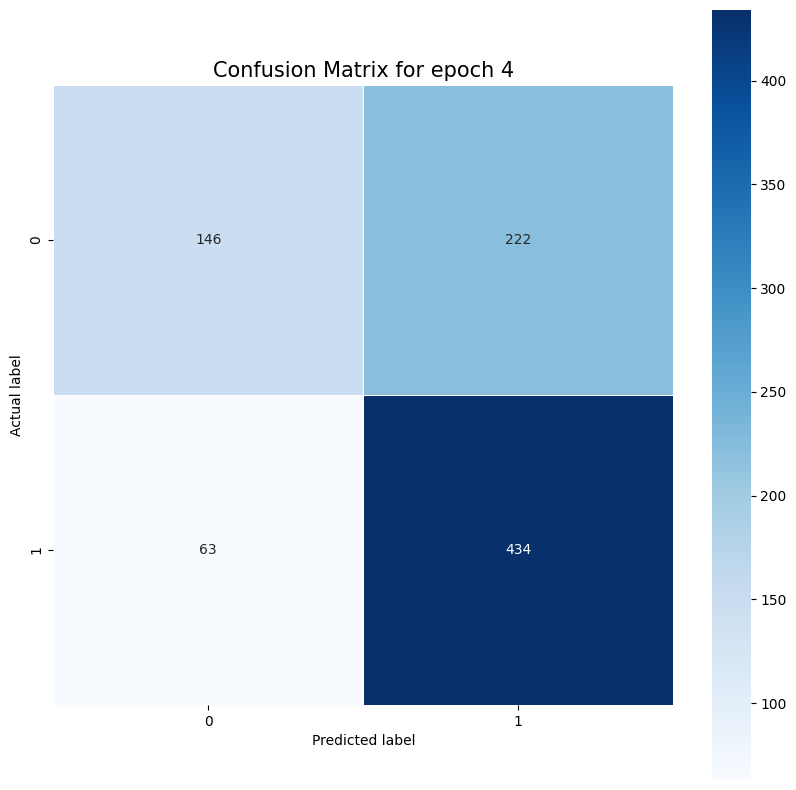

Epoch 5/10:   0%|          | 1/865 [00:04<1:00:38,  4.21s/it]

Accuracy of the model after epoch 5: 100.0%


Epoch 5/10:   0%|          | 2/865 [00:08<1:01:57,  4.31s/it]

Accuracy of the model after epoch 5: 50.0%


Epoch 5/10:   0%|          | 3/865 [00:13<1:04:01,  4.46s/it]

Accuracy of the model after epoch 5: 66.66666666666667%


Epoch 5/10:   0%|          | 4/865 [00:18<1:07:03,  4.67s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   1%|          | 5/865 [00:22<1:05:50,  4.59s/it]

Accuracy of the model after epoch 5: 80.0%


Epoch 5/10:   1%|          | 6/865 [00:26<1:03:54,  4.46s/it]

Accuracy of the model after epoch 5: 83.33333333333333%


Epoch 5/10:   1%|          | 7/865 [00:29<55:25,  3.88s/it]  

Accuracy of the model after epoch 5: 85.71428571428571%


Epoch 5/10:   1%|          | 8/865 [00:34<59:34,  4.17s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   1%|          | 9/865 [00:36<51:36,  3.62s/it]

Accuracy of the model after epoch 5: 77.77777777777777%


Epoch 5/10:   1%|          | 10/865 [00:41<55:08,  3.87s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:   1%|▏         | 11/865 [00:45<56:56,  4.00s/it]

Accuracy of the model after epoch 5: 72.72727272727273%


Epoch 5/10:   1%|▏         | 12/865 [00:50<1:00:15,  4.24s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   2%|▏         | 13/865 [00:52<52:53,  3.72s/it]  

Accuracy of the model after epoch 5: 76.92307692307692%


Epoch 5/10:   2%|▏         | 14/865 [00:55<47:37,  3.36s/it]

Accuracy of the model after epoch 5: 71.42857142857143%


Epoch 5/10:   2%|▏         | 15/865 [00:59<52:28,  3.70s/it]

Accuracy of the model after epoch 5: 73.33333333333333%


Epoch 5/10:   2%|▏         | 16/865 [01:04<55:20,  3.91s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   2%|▏         | 17/865 [01:08<58:12,  4.12s/it]

Accuracy of the model after epoch 5: 76.47058823529412%


Epoch 5/10:   2%|▏         | 18/865 [01:11<51:36,  3.66s/it]

Accuracy of the model after epoch 5: 77.77777777777777%


Epoch 5/10:   2%|▏         | 19/865 [01:16<56:39,  4.02s/it]

Accuracy of the model after epoch 5: 73.6842105263158%


Epoch 5/10:   2%|▏         | 20/865 [01:19<52:25,  3.72s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   2%|▏         | 21/865 [01:23<54:43,  3.89s/it]

Accuracy of the model after epoch 5: 76.19047619047619%


Epoch 5/10:   3%|▎         | 22/865 [01:27<56:11,  4.00s/it]

Accuracy of the model after epoch 5: 77.27272727272727%


Epoch 5/10:   3%|▎         | 23/865 [01:30<50:08,  3.57s/it]

Accuracy of the model after epoch 5: 78.26086956521739%


Epoch 5/10:   3%|▎         | 24/865 [01:35<55:20,  3.95s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   3%|▎         | 25/865 [01:39<57:55,  4.14s/it]

Accuracy of the model after epoch 5: 76.0%


Epoch 5/10:   3%|▎         | 26/865 [01:44<59:09,  4.23s/it]

Accuracy of the model after epoch 5: 73.07692307692308%


Epoch 5/10:   3%|▎         | 27/865 [01:46<51:29,  3.69s/it]

Accuracy of the model after epoch 5: 70.37037037037037%


Epoch 5/10:   3%|▎         | 28/865 [01:51<55:00,  3.94s/it]

Accuracy of the model after epoch 5: 71.42857142857143%


Epoch 5/10:   3%|▎         | 29/865 [01:55<58:10,  4.18s/it]

Accuracy of the model after epoch 5: 72.41379310344827%


Epoch 5/10:   3%|▎         | 30/865 [02:00<1:00:05,  4.32s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:   4%|▎         | 31/865 [02:04<59:34,  4.29s/it]  

Accuracy of the model after epoch 5: 70.96774193548387%


Epoch 5/10:   4%|▎         | 32/865 [02:09<1:00:03,  4.33s/it]

Accuracy of the model after epoch 5: 71.875%


Epoch 5/10:   4%|▍         | 33/865 [02:11<52:06,  3.76s/it]  

Accuracy of the model after epoch 5: 72.72727272727273%


Epoch 5/10:   4%|▍         | 34/865 [02:16<55:48,  4.03s/it]

Accuracy of the model after epoch 5: 73.52941176470588%


Epoch 5/10:   4%|▍         | 35/865 [02:21<1:00:40,  4.39s/it]

Accuracy of the model after epoch 5: 74.28571428571429%


Epoch 5/10:   4%|▍         | 36/865 [02:25<59:52,  4.33s/it]  

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   4%|▍         | 37/865 [02:30<59:35,  4.32s/it]

Accuracy of the model after epoch 5: 75.67567567567568%


Epoch 5/10:   4%|▍         | 38/865 [02:34<1:01:56,  4.49s/it]

Accuracy of the model after epoch 5: 73.6842105263158%


Epoch 5/10:   5%|▍         | 39/865 [02:37<52:59,  3.85s/it]  

Accuracy of the model after epoch 5: 74.35897435897436%


Epoch 5/10:   5%|▍         | 40/865 [02:41<56:27,  4.11s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   5%|▍         | 41/865 [02:46<56:54,  4.14s/it]

Accuracy of the model after epoch 5: 75.60975609756098%


Epoch 5/10:   5%|▍         | 42/865 [02:48<49:15,  3.59s/it]

Accuracy of the model after epoch 5: 76.19047619047619%


Epoch 5/10:   5%|▍         | 43/865 [02:50<43:38,  3.19s/it]

Accuracy of the model after epoch 5: 74.4186046511628%


Epoch 5/10:   5%|▌         | 44/865 [02:55<48:42,  3.56s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   5%|▌         | 45/865 [02:59<52:51,  3.87s/it]

Accuracy of the model after epoch 5: 75.55555555555556%


Epoch 5/10:   5%|▌         | 46/865 [03:04<56:31,  4.14s/it]

Accuracy of the model after epoch 5: 73.91304347826087%


Epoch 5/10:   5%|▌         | 47/865 [03:08<57:16,  4.20s/it]

Accuracy of the model after epoch 5: 74.46808510638297%


Epoch 5/10:   6%|▌         | 48/865 [03:13<58:50,  4.32s/it]

Accuracy of the model after epoch 5: 75.0%


Epoch 5/10:   6%|▌         | 49/865 [03:19<1:04:24,  4.74s/it]

Accuracy of the model after epoch 5: 73.46938775510205%


Epoch 5/10:   6%|▌         | 50/865 [03:23<1:03:15,  4.66s/it]

Accuracy of the model after epoch 5: 74.0%


Epoch 5/10:   6%|▌         | 51/865 [03:27<1:01:23,  4.53s/it]

Accuracy of the model after epoch 5: 72.54901960784314%


Epoch 5/10:   6%|▌         | 52/865 [03:30<51:43,  3.82s/it]  

Accuracy of the model after epoch 5: 71.15384615384616%


Epoch 5/10:   6%|▌         | 53/865 [03:32<46:09,  3.41s/it]

Accuracy of the model after epoch 5: 69.81132075471699%


Epoch 5/10:   6%|▌         | 54/865 [03:37<51:48,  3.83s/it]

Accuracy of the model after epoch 5: 70.37037037037037%


Epoch 5/10:   6%|▋         | 55/865 [03:41<54:22,  4.03s/it]

Accuracy of the model after epoch 5: 70.9090909090909%


Epoch 5/10:   6%|▋         | 56/865 [03:46<55:12,  4.09s/it]

Accuracy of the model after epoch 5: 71.42857142857143%


Epoch 5/10:   7%|▋         | 57/865 [03:50<56:38,  4.21s/it]

Accuracy of the model after epoch 5: 71.9298245614035%


Epoch 5/10:   7%|▋         | 58/865 [03:54<56:32,  4.20s/it]

Accuracy of the model after epoch 5: 70.6896551724138%


Epoch 5/10:   7%|▋         | 59/865 [03:59<59:07,  4.40s/it]

Accuracy of the model after epoch 5: 71.1864406779661%


Epoch 5/10:   7%|▋         | 60/865 [04:02<51:58,  3.87s/it]

Accuracy of the model after epoch 5: 71.66666666666667%


Epoch 5/10:   7%|▋         | 61/865 [04:04<46:13,  3.45s/it]

Accuracy of the model after epoch 5: 72.1311475409836%


Epoch 5/10:   7%|▋         | 62/865 [04:07<43:12,  3.23s/it]

Accuracy of the model after epoch 5: 72.58064516129032%


Epoch 5/10:   7%|▋         | 63/865 [04:11<47:41,  3.57s/it]

Accuracy of the model after epoch 5: 71.42857142857143%


Epoch 5/10:   7%|▋         | 64/865 [04:16<50:33,  3.79s/it]

Accuracy of the model after epoch 5: 71.875%


Epoch 5/10:   8%|▊         | 65/865 [04:20<52:58,  3.97s/it]

Accuracy of the model after epoch 5: 70.76923076923077%


Epoch 5/10:   8%|▊         | 66/865 [04:24<53:13,  4.00s/it]

Accuracy of the model after epoch 5: 71.21212121212122%


Epoch 5/10:   8%|▊         | 67/865 [04:28<53:33,  4.03s/it]

Accuracy of the model after epoch 5: 70.14925373134328%


Epoch 5/10:   8%|▊         | 68/865 [04:32<54:10,  4.08s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:   8%|▊         | 69/865 [04:37<58:11,  4.39s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:   8%|▊         | 70/865 [04:42<1:00:19,  4.55s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:   8%|▊         | 71/865 [04:45<52:03,  3.93s/it]  

Accuracy of the model after epoch 5: 70.4225352112676%


Epoch 5/10:   8%|▊         | 72/865 [04:49<53:31,  4.05s/it]

Accuracy of the model after epoch 5: 70.83333333333333%


Epoch 5/10:   8%|▊         | 73/865 [04:53<54:15,  4.11s/it]

Accuracy of the model after epoch 5: 69.86301369863014%


Epoch 5/10:   9%|▊         | 74/865 [04:56<48:02,  3.64s/it]

Accuracy of the model after epoch 5: 70.27027027027027%


Epoch 5/10:   9%|▊         | 75/865 [05:01<51:29,  3.91s/it]

Accuracy of the model after epoch 5: 69.33333333333333%


Epoch 5/10:   9%|▉         | 76/865 [05:05<53:07,  4.04s/it]

Accuracy of the model after epoch 5: 69.73684210526316%


Epoch 5/10:   9%|▉         | 77/865 [05:09<53:14,  4.05s/it]

Accuracy of the model after epoch 5: 70.12987012987013%


Epoch 5/10:   9%|▉         | 78/865 [05:14<55:40,  4.24s/it]

Accuracy of the model after epoch 5: 70.51282051282051%


Epoch 5/10:   9%|▉         | 79/865 [05:16<48:05,  3.67s/it]

Accuracy of the model after epoch 5: 70.88607594936708%


Epoch 5/10:   9%|▉         | 80/865 [05:19<44:36,  3.41s/it]

Accuracy of the model after epoch 5: 71.25%


Epoch 5/10:   9%|▉         | 81/865 [05:23<47:53,  3.67s/it]

Accuracy of the model after epoch 5: 71.60493827160494%


Epoch 5/10:   9%|▉         | 82/865 [05:26<43:30,  3.33s/it]

Accuracy of the model after epoch 5: 70.73170731707317%


Epoch 5/10:  10%|▉         | 83/865 [05:30<47:10,  3.62s/it]

Accuracy of the model after epoch 5: 69.87951807228916%


Epoch 5/10:  10%|▉         | 84/865 [05:34<50:48,  3.90s/it]

Accuracy of the model after epoch 5: 70.23809523809524%


Epoch 5/10:  10%|▉         | 85/865 [05:39<53:53,  4.15s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:  10%|▉         | 86/865 [05:43<53:47,  4.14s/it]

Accuracy of the model after epoch 5: 69.76744186046511%


Epoch 5/10:  10%|█         | 87/865 [05:48<54:20,  4.19s/it]

Accuracy of the model after epoch 5: 68.96551724137932%


Epoch 5/10:  10%|█         | 88/865 [05:50<47:08,  3.64s/it]

Accuracy of the model after epoch 5: 69.31818181818181%


Epoch 5/10:  10%|█         | 89/865 [05:55<51:05,  3.95s/it]

Accuracy of the model after epoch 5: 69.66292134831461%


Epoch 5/10:  10%|█         | 90/865 [05:59<52:32,  4.07s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  11%|█         | 91/865 [06:03<53:00,  4.11s/it]

Accuracy of the model after epoch 5: 70.32967032967034%


Epoch 5/10:  11%|█         | 92/865 [06:07<53:31,  4.15s/it]

Accuracy of the model after epoch 5: 70.65217391304348%


Epoch 5/10:  11%|█         | 93/865 [06:10<46:35,  3.62s/it]

Accuracy of the model after epoch 5: 69.89247311827957%


Epoch 5/10:  11%|█         | 94/865 [06:15<51:47,  4.03s/it]

Accuracy of the model after epoch 5: 70.2127659574468%


Epoch 5/10:  11%|█         | 95/865 [06:19<53:59,  4.21s/it]

Accuracy of the model after epoch 5: 70.52631578947368%


Epoch 5/10:  11%|█         | 96/865 [06:24<54:43,  4.27s/it]

Accuracy of the model after epoch 5: 69.79166666666667%


Epoch 5/10:  11%|█         | 97/865 [06:28<54:44,  4.28s/it]

Accuracy of the model after epoch 5: 70.10309278350516%


Epoch 5/10:  11%|█▏        | 98/865 [06:33<56:33,  4.42s/it]

Accuracy of the model after epoch 5: 70.40816326530613%


Epoch 5/10:  11%|█▏        | 99/865 [06:35<49:01,  3.84s/it]

Accuracy of the model after epoch 5: 70.70707070707071%


Epoch 5/10:  12%|█▏        | 100/865 [06:40<51:39,  4.05s/it]

Accuracy of the model after epoch 5: 71.0%


Epoch 5/10:  12%|█▏        | 101/865 [06:44<52:53,  4.15s/it]

Accuracy of the model after epoch 5: 71.2871287128713%


Epoch 5/10:  12%|█▏        | 102/865 [06:49<54:57,  4.32s/it]

Accuracy of the model after epoch 5: 71.56862745098039%


Epoch 5/10:  12%|█▏        | 103/865 [06:53<55:25,  4.36s/it]

Accuracy of the model after epoch 5: 71.84466019417475%


Epoch 5/10:  12%|█▏        | 104/865 [06:59<58:26,  4.61s/it]

Accuracy of the model after epoch 5: 72.11538461538461%


Epoch 5/10:  12%|█▏        | 105/865 [07:01<50:59,  4.03s/it]

Accuracy of the model after epoch 5: 72.38095238095238%


Epoch 5/10:  12%|█▏        | 106/865 [07:04<44:38,  3.53s/it]

Accuracy of the model after epoch 5: 71.69811320754717%


Epoch 5/10:  12%|█▏        | 107/865 [07:08<48:00,  3.80s/it]

Accuracy of the model after epoch 5: 71.96261682242991%


Epoch 5/10:  12%|█▏        | 108/865 [07:11<42:45,  3.39s/it]

Accuracy of the model after epoch 5: 72.22222222222223%


Epoch 5/10:  13%|█▎        | 109/865 [07:15<48:05,  3.82s/it]

Accuracy of the model after epoch 5: 71.55963302752293%


Epoch 5/10:  13%|█▎        | 110/865 [07:20<51:24,  4.09s/it]

Accuracy of the model after epoch 5: 70.9090909090909%


Epoch 5/10:  13%|█▎        | 111/865 [07:24<52:16,  4.16s/it]

Accuracy of the model after epoch 5: 70.27027027027027%


Epoch 5/10:  13%|█▎        | 112/865 [07:29<54:33,  4.35s/it]

Accuracy of the model after epoch 5: 70.53571428571429%


Epoch 5/10:  13%|█▎        | 113/865 [07:32<47:57,  3.83s/it]

Accuracy of the model after epoch 5: 69.91150442477876%


Epoch 5/10:  13%|█▎        | 114/865 [07:34<41:51,  3.34s/it]

Accuracy of the model after epoch 5: 70.17543859649123%


Epoch 5/10:  13%|█▎        | 115/865 [07:39<47:40,  3.81s/it]

Accuracy of the model after epoch 5: 70.43478260869566%


Epoch 5/10:  13%|█▎        | 116/865 [07:44<50:39,  4.06s/it]

Accuracy of the model after epoch 5: 69.82758620689656%


Epoch 5/10:  14%|█▎        | 117/865 [07:48<52:38,  4.22s/it]

Accuracy of the model after epoch 5: 70.08547008547009%


Epoch 5/10:  14%|█▎        | 118/865 [07:53<54:16,  4.36s/it]

Accuracy of the model after epoch 5: 69.49152542372882%


Epoch 5/10:  14%|█▍        | 119/865 [07:58<57:10,  4.60s/it]

Accuracy of the model after epoch 5: 69.74789915966386%


Epoch 5/10:  14%|█▍        | 120/865 [08:03<57:14,  4.61s/it]

Accuracy of the model after epoch 5: 69.16666666666667%


Epoch 5/10:  14%|█▍        | 121/865 [08:07<56:02,  4.52s/it]

Accuracy of the model after epoch 5: 69.42148760330579%


Epoch 5/10:  14%|█▍        | 122/865 [08:11<53:56,  4.36s/it]

Accuracy of the model after epoch 5: 69.67213114754098%


Epoch 5/10:  14%|█▍        | 123/865 [08:13<47:02,  3.80s/it]

Accuracy of the model after epoch 5: 69.91869918699187%


Epoch 5/10:  14%|█▍        | 124/865 [08:16<41:59,  3.40s/it]

Accuracy of the model after epoch 5: 70.16129032258064%


Epoch 5/10:  14%|█▍        | 125/865 [08:19<39:35,  3.21s/it]

Accuracy of the model after epoch 5: 69.6%


Epoch 5/10:  15%|█▍        | 126/865 [08:23<43:45,  3.55s/it]

Accuracy of the model after epoch 5: 69.84126984126983%


Epoch 5/10:  15%|█▍        | 127/865 [08:27<46:41,  3.80s/it]

Accuracy of the model after epoch 5: 69.29133858267717%


Epoch 5/10:  15%|█▍        | 128/865 [08:30<41:18,  3.36s/it]

Accuracy of the model after epoch 5: 69.53125%


Epoch 5/10:  15%|█▍        | 129/865 [08:34<44:57,  3.67s/it]

Accuracy of the model after epoch 5: 69.76744186046511%


Epoch 5/10:  15%|█▌        | 130/865 [08:37<41:16,  3.37s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  15%|█▌        | 131/865 [08:41<44:44,  3.66s/it]

Accuracy of the model after epoch 5: 69.46564885496183%


Epoch 5/10:  15%|█▌        | 132/865 [08:45<47:18,  3.87s/it]

Accuracy of the model after epoch 5: 68.93939393939394%


Epoch 5/10:  15%|█▌        | 133/865 [08:48<42:13,  3.46s/it]

Accuracy of the model after epoch 5: 69.17293233082707%


Epoch 5/10:  15%|█▌        | 134/865 [08:52<45:29,  3.73s/it]

Accuracy of the model after epoch 5: 69.40298507462687%


Epoch 5/10:  16%|█▌        | 135/865 [08:57<50:29,  4.15s/it]

Accuracy of the model after epoch 5: 69.62962962962963%


Epoch 5/10:  16%|█▌        | 136/865 [09:00<43:27,  3.58s/it]

Accuracy of the model after epoch 5: 69.8529411764706%


Epoch 5/10:  16%|█▌        | 137/865 [09:04<45:28,  3.75s/it]

Accuracy of the model after epoch 5: 69.34306569343066%


Epoch 5/10:  16%|█▌        | 138/865 [09:08<47:48,  3.95s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  16%|█▌        | 139/865 [09:13<50:58,  4.21s/it]

Accuracy of the model after epoch 5: 69.7841726618705%


Epoch 5/10:  16%|█▌        | 140/865 [09:18<53:28,  4.43s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  16%|█▋        | 141/865 [09:23<54:24,  4.51s/it]

Accuracy of the model after epoch 5: 70.2127659574468%


Epoch 5/10:  16%|█▋        | 142/865 [09:27<52:48,  4.38s/it]

Accuracy of the model after epoch 5: 69.71830985915493%


Epoch 5/10:  17%|█▋        | 143/865 [09:31<53:30,  4.45s/it]

Accuracy of the model after epoch 5: 69.23076923076923%


Epoch 5/10:  17%|█▋        | 144/865 [09:34<45:53,  3.82s/it]

Accuracy of the model after epoch 5: 69.44444444444444%


Epoch 5/10:  17%|█▋        | 145/865 [09:38<48:17,  4.02s/it]

Accuracy of the model after epoch 5: 69.65517241379311%


Epoch 5/10:  17%|█▋        | 146/865 [09:41<42:24,  3.54s/it]

Accuracy of the model after epoch 5: 69.86301369863014%


Epoch 5/10:  17%|█▋        | 147/865 [09:43<38:32,  3.22s/it]

Accuracy of the model after epoch 5: 70.06802721088435%


Epoch 5/10:  17%|█▋        | 148/865 [09:46<36:31,  3.06s/it]

Accuracy of the model after epoch 5: 70.27027027027027%


Epoch 5/10:  17%|█▋        | 149/865 [09:50<41:06,  3.44s/it]

Accuracy of the model after epoch 5: 69.79865771812081%


Epoch 5/10:  17%|█▋        | 150/865 [09:55<45:10,  3.79s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  17%|█▋        | 151/865 [09:57<40:49,  3.43s/it]

Accuracy of the model after epoch 5: 70.19867549668874%


Epoch 5/10:  18%|█▊        | 152/865 [10:02<43:41,  3.68s/it]

Accuracy of the model after epoch 5: 70.39473684210526%


Epoch 5/10:  18%|█▊        | 153/865 [10:06<44:57,  3.79s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:  18%|█▊        | 154/865 [10:10<47:10,  3.98s/it]

Accuracy of the model after epoch 5: 70.77922077922078%


Epoch 5/10:  18%|█▊        | 155/865 [10:15<48:41,  4.11s/it]

Accuracy of the model after epoch 5: 70.96774193548387%


Epoch 5/10:  18%|█▊        | 156/865 [10:19<48:56,  4.14s/it]

Accuracy of the model after epoch 5: 71.15384615384616%


Epoch 5/10:  18%|█▊        | 157/865 [10:23<50:48,  4.31s/it]

Accuracy of the model after epoch 5: 70.70063694267516%


Epoch 5/10:  18%|█▊        | 158/865 [10:28<51:48,  4.40s/it]

Accuracy of the model after epoch 5: 70.88607594936708%


Epoch 5/10:  18%|█▊        | 159/865 [10:33<53:57,  4.59s/it]

Accuracy of the model after epoch 5: 71.06918238993711%


Epoch 5/10:  18%|█▊        | 160/865 [10:38<53:55,  4.59s/it]

Accuracy of the model after epoch 5: 71.25%


Epoch 5/10:  19%|█▊        | 161/865 [10:40<46:12,  3.94s/it]

Accuracy of the model after epoch 5: 71.42857142857143%


Epoch 5/10:  19%|█▊        | 162/865 [10:44<47:17,  4.04s/it]

Accuracy of the model after epoch 5: 71.60493827160494%


Epoch 5/10:  19%|█▉        | 163/865 [10:49<48:35,  4.15s/it]

Accuracy of the model after epoch 5: 71.77914110429448%


Epoch 5/10:  19%|█▉        | 164/865 [10:51<42:39,  3.65s/it]

Accuracy of the model after epoch 5: 71.95121951219512%


Epoch 5/10:  19%|█▉        | 165/865 [10:56<45:44,  3.92s/it]

Accuracy of the model after epoch 5: 72.12121212121212%


Epoch 5/10:  19%|█▉        | 166/865 [11:00<47:19,  4.06s/it]

Accuracy of the model after epoch 5: 71.6867469879518%


Epoch 5/10:  19%|█▉        | 167/865 [11:05<50:22,  4.33s/it]

Accuracy of the model after epoch 5: 71.8562874251497%


Epoch 5/10:  19%|█▉        | 168/865 [11:08<44:15,  3.81s/it]

Accuracy of the model after epoch 5: 72.02380952380952%


Epoch 5/10:  20%|█▉        | 169/865 [11:10<39:17,  3.39s/it]

Accuracy of the model after epoch 5: 72.18934911242603%


Epoch 5/10:  20%|█▉        | 170/865 [11:15<42:53,  3.70s/it]

Accuracy of the model after epoch 5: 72.3529411764706%


Epoch 5/10:  20%|█▉        | 171/865 [11:17<38:36,  3.34s/it]

Accuracy of the model after epoch 5: 72.51461988304094%


Epoch 5/10:  20%|█▉        | 172/865 [11:21<41:45,  3.62s/it]

Accuracy of the model after epoch 5: 72.67441860465117%


Epoch 5/10:  20%|██        | 173/865 [11:24<36:52,  3.20s/it]

Accuracy of the model after epoch 5: 72.25433526011561%


Epoch 5/10:  20%|██        | 174/865 [11:29<43:20,  3.76s/it]

Accuracy of the model after epoch 5: 72.41379310344827%


Epoch 5/10:  20%|██        | 175/865 [11:33<45:53,  3.99s/it]

Accuracy of the model after epoch 5: 72.57142857142857%


Epoch 5/10:  20%|██        | 176/865 [11:37<46:24,  4.04s/it]

Accuracy of the model after epoch 5: 72.1590909090909%


Epoch 5/10:  20%|██        | 177/865 [11:40<41:26,  3.61s/it]

Accuracy of the model after epoch 5: 72.31638418079096%


Epoch 5/10:  21%|██        | 178/865 [11:44<43:56,  3.84s/it]

Accuracy of the model after epoch 5: 71.91011235955057%


Epoch 5/10:  21%|██        | 179/865 [11:47<38:35,  3.38s/it]

Accuracy of the model after epoch 5: 72.06703910614524%


Epoch 5/10:  21%|██        | 180/865 [11:51<42:25,  3.72s/it]

Accuracy of the model after epoch 5: 72.22222222222223%


Epoch 5/10:  21%|██        | 181/865 [11:55<44:09,  3.87s/it]

Accuracy of the model after epoch 5: 72.37569060773481%


Epoch 5/10:  21%|██        | 182/865 [11:58<38:57,  3.42s/it]

Accuracy of the model after epoch 5: 72.52747252747253%


Epoch 5/10:  21%|██        | 183/865 [12:00<35:28,  3.12s/it]

Accuracy of the model after epoch 5: 72.6775956284153%


Epoch 5/10:  21%|██▏       | 184/865 [12:05<39:58,  3.52s/it]

Accuracy of the model after epoch 5: 72.82608695652173%


Epoch 5/10:  21%|██▏       | 185/865 [12:09<44:31,  3.93s/it]

Accuracy of the model after epoch 5: 72.97297297297297%


Epoch 5/10:  22%|██▏       | 186/865 [12:14<45:41,  4.04s/it]

Accuracy of the model after epoch 5: 72.58064516129032%


Epoch 5/10:  22%|██▏       | 187/865 [12:18<46:20,  4.10s/it]

Accuracy of the model after epoch 5: 72.72727272727273%


Epoch 5/10:  22%|██▏       | 188/865 [12:23<49:23,  4.38s/it]

Accuracy of the model after epoch 5: 72.87234042553192%


Epoch 5/10:  22%|██▏       | 189/865 [12:26<43:11,  3.83s/it]

Accuracy of the model after epoch 5: 73.01587301587301%


Epoch 5/10:  22%|██▏       | 190/865 [12:30<46:22,  4.12s/it]

Accuracy of the model after epoch 5: 73.15789473684211%


Epoch 5/10:  22%|██▏       | 191/865 [12:35<47:02,  4.19s/it]

Accuracy of the model after epoch 5: 72.77486910994764%


Epoch 5/10:  22%|██▏       | 192/865 [12:39<47:41,  4.25s/it]

Accuracy of the model after epoch 5: 72.91666666666667%


Epoch 5/10:  22%|██▏       | 193/865 [12:44<49:17,  4.40s/it]

Accuracy of the model after epoch 5: 72.53886010362694%


Epoch 5/10:  22%|██▏       | 194/865 [12:49<52:07,  4.66s/it]

Accuracy of the model after epoch 5: 72.16494845360825%


Epoch 5/10:  23%|██▎       | 195/865 [12:54<52:33,  4.71s/it]

Accuracy of the model after epoch 5: 72.3076923076923%


Epoch 5/10:  23%|██▎       | 196/865 [12:58<51:41,  4.64s/it]

Accuracy of the model after epoch 5: 72.44897959183673%


Epoch 5/10:  23%|██▎       | 197/865 [13:03<50:37,  4.55s/it]

Accuracy of the model after epoch 5: 72.58883248730965%


Epoch 5/10:  23%|██▎       | 198/865 [13:08<51:34,  4.64s/it]

Accuracy of the model after epoch 5: 72.22222222222223%


Epoch 5/10:  23%|██▎       | 199/865 [13:10<45:00,  4.05s/it]

Accuracy of the model after epoch 5: 71.85929648241206%


Epoch 5/10:  23%|██▎       | 200/865 [13:13<41:28,  3.74s/it]

Accuracy of the model after epoch 5: 72.0%


Epoch 5/10:  23%|██▎       | 201/865 [13:18<42:57,  3.88s/it]

Accuracy of the model after epoch 5: 72.13930348258707%


Epoch 5/10:  23%|██▎       | 202/865 [13:22<44:11,  4.00s/it]

Accuracy of the model after epoch 5: 72.27722772277228%


Epoch 5/10:  23%|██▎       | 203/865 [13:24<39:13,  3.56s/it]

Accuracy of the model after epoch 5: 72.41379310344827%


Epoch 5/10:  24%|██▎       | 204/865 [13:27<35:08,  3.19s/it]

Accuracy of the model after epoch 5: 72.54901960784314%


Epoch 5/10:  24%|██▎       | 205/865 [13:31<39:39,  3.61s/it]

Accuracy of the model after epoch 5: 72.1951219512195%


Epoch 5/10:  24%|██▍       | 206/865 [13:34<35:31,  3.23s/it]

Accuracy of the model after epoch 5: 72.33009708737865%


Epoch 5/10:  24%|██▍       | 207/865 [13:38<38:08,  3.48s/it]

Accuracy of the model after epoch 5: 72.46376811594203%


Epoch 5/10:  24%|██▍       | 208/865 [13:40<34:27,  3.15s/it]

Accuracy of the model after epoch 5: 72.59615384615384%


Epoch 5/10:  24%|██▍       | 209/865 [13:44<37:56,  3.47s/it]

Accuracy of the model after epoch 5: 72.72727272727273%


Epoch 5/10:  24%|██▍       | 210/865 [13:49<41:20,  3.79s/it]

Accuracy of the model after epoch 5: 72.85714285714286%


Epoch 5/10:  24%|██▍       | 211/865 [13:53<41:57,  3.85s/it]

Accuracy of the model after epoch 5: 72.98578199052133%


Epoch 5/10:  25%|██▍       | 212/865 [13:57<44:06,  4.05s/it]

Accuracy of the model after epoch 5: 73.11320754716981%


Epoch 5/10:  25%|██▍       | 213/865 [14:01<44:20,  4.08s/it]

Accuracy of the model after epoch 5: 72.7699530516432%


Epoch 5/10:  25%|██▍       | 214/865 [14:06<46:06,  4.25s/it]

Accuracy of the model after epoch 5: 72.89719626168224%


Epoch 5/10:  25%|██▍       | 215/865 [14:11<47:42,  4.40s/it]

Accuracy of the model after epoch 5: 73.02325581395348%


Epoch 5/10:  25%|██▍       | 216/865 [14:15<47:16,  4.37s/it]

Accuracy of the model after epoch 5: 73.14814814814815%


Epoch 5/10:  25%|██▌       | 217/865 [14:19<47:07,  4.36s/it]

Accuracy of the model after epoch 5: 72.8110599078341%


Epoch 5/10:  25%|██▌       | 218/865 [14:24<48:40,  4.51s/it]

Accuracy of the model after epoch 5: 72.93577981651376%


Epoch 5/10:  25%|██▌       | 219/865 [14:27<42:38,  3.96s/it]

Accuracy of the model after epoch 5: 73.05936073059361%


Epoch 5/10:  25%|██▌       | 220/865 [14:32<44:42,  4.16s/it]

Accuracy of the model after epoch 5: 73.18181818181819%


Epoch 5/10:  26%|██▌       | 221/865 [14:36<44:26,  4.14s/it]

Accuracy of the model after epoch 5: 73.30316742081448%


Epoch 5/10:  26%|██▌       | 222/865 [14:38<38:58,  3.64s/it]

Accuracy of the model after epoch 5: 72.97297297297297%


Epoch 5/10:  26%|██▌       | 223/865 [14:41<35:28,  3.32s/it]

Accuracy of the model after epoch 5: 72.6457399103139%


Epoch 5/10:  26%|██▌       | 224/865 [14:45<38:44,  3.63s/it]

Accuracy of the model after epoch 5: 72.76785714285714%


Epoch 5/10:  26%|██▌       | 225/865 [14:50<41:12,  3.86s/it]

Accuracy of the model after epoch 5: 72.88888888888889%


Epoch 5/10:  26%|██▌       | 226/865 [14:54<42:37,  4.00s/it]

Accuracy of the model after epoch 5: 73.00884955752213%


Epoch 5/10:  26%|██▌       | 227/865 [14:56<37:23,  3.52s/it]

Accuracy of the model after epoch 5: 73.12775330396475%


Epoch 5/10:  26%|██▋       | 228/865 [15:01<40:00,  3.77s/it]

Accuracy of the model after epoch 5: 72.80701754385964%


Epoch 5/10:  26%|██▋       | 229/865 [15:05<42:54,  4.05s/it]

Accuracy of the model after epoch 5: 72.92576419213974%


Epoch 5/10:  27%|██▋       | 230/865 [15:11<46:51,  4.43s/it]

Accuracy of the model after epoch 5: 72.6086956521739%


Epoch 5/10:  27%|██▋       | 231/865 [15:15<46:32,  4.40s/it]

Accuracy of the model after epoch 5: 72.72727272727273%


Epoch 5/10:  27%|██▋       | 232/865 [15:19<45:55,  4.35s/it]

Accuracy of the model after epoch 5: 72.41379310344827%


Epoch 5/10:  27%|██▋       | 233/865 [15:24<46:02,  4.37s/it]

Accuracy of the model after epoch 5: 72.1030042918455%


Epoch 5/10:  27%|██▋       | 234/865 [15:28<47:23,  4.51s/it]

Accuracy of the model after epoch 5: 72.22222222222223%


Epoch 5/10:  27%|██▋       | 235/865 [15:33<48:06,  4.58s/it]

Accuracy of the model after epoch 5: 71.91489361702128%


Epoch 5/10:  27%|██▋       | 236/865 [15:36<40:57,  3.91s/it]

Accuracy of the model after epoch 5: 72.03389830508475%


Epoch 5/10:  27%|██▋       | 237/865 [15:40<42:05,  4.02s/it]

Accuracy of the model after epoch 5: 72.15189873417721%


Epoch 5/10:  28%|██▊       | 238/865 [15:44<43:22,  4.15s/it]

Accuracy of the model after epoch 5: 72.26890756302521%


Epoch 5/10:  28%|██▊       | 239/865 [15:49<45:05,  4.32s/it]

Accuracy of the model after epoch 5: 71.96652719665272%


Epoch 5/10:  28%|██▊       | 240/865 [15:52<39:58,  3.84s/it]

Accuracy of the model after epoch 5: 72.08333333333333%


Epoch 5/10:  28%|██▊       | 241/865 [15:54<35:44,  3.44s/it]

Accuracy of the model after epoch 5: 72.19917012448133%


Epoch 5/10:  28%|██▊       | 242/865 [15:59<38:26,  3.70s/it]

Accuracy of the model after epoch 5: 72.31404958677686%


Epoch 5/10:  28%|██▊       | 243/865 [16:03<41:18,  3.98s/it]

Accuracy of the model after epoch 5: 72.42798353909465%


Epoch 5/10:  28%|██▊       | 244/865 [16:06<36:14,  3.50s/it]

Accuracy of the model after epoch 5: 72.1311475409836%


Epoch 5/10:  28%|██▊       | 245/865 [16:10<39:34,  3.83s/it]

Accuracy of the model after epoch 5: 71.83673469387755%


Epoch 5/10:  28%|██▊       | 246/865 [16:14<40:24,  3.92s/it]

Accuracy of the model after epoch 5: 71.54471544715447%


Epoch 5/10:  29%|██▊       | 247/865 [16:18<41:07,  3.99s/it]

Accuracy of the model after epoch 5: 71.25506072874494%


Epoch 5/10:  29%|██▊       | 248/865 [16:21<36:20,  3.53s/it]

Accuracy of the model after epoch 5: 71.37096774193549%


Epoch 5/10:  29%|██▉       | 249/865 [16:25<39:13,  3.82s/it]

Accuracy of the model after epoch 5: 71.4859437751004%


Epoch 5/10:  29%|██▉       | 250/865 [16:30<40:46,  3.98s/it]

Accuracy of the model after epoch 5: 71.2%


Epoch 5/10:  29%|██▉       | 251/865 [16:34<41:47,  4.08s/it]

Accuracy of the model after epoch 5: 70.91633466135458%


Epoch 5/10:  29%|██▉       | 252/865 [16:39<42:53,  4.20s/it]

Accuracy of the model after epoch 5: 70.63492063492063%


Epoch 5/10:  29%|██▉       | 253/865 [16:43<44:20,  4.35s/it]

Accuracy of the model after epoch 5: 70.35573122529644%


Epoch 5/10:  29%|██▉       | 254/865 [16:46<38:32,  3.78s/it]

Accuracy of the model after epoch 5: 70.4724409448819%


Epoch 5/10:  29%|██▉       | 255/865 [16:49<35:49,  3.52s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:  30%|██▉       | 256/865 [16:53<37:31,  3.70s/it]

Accuracy of the model after epoch 5: 70.3125%


Epoch 5/10:  30%|██▉       | 257/865 [16:55<33:57,  3.35s/it]

Accuracy of the model after epoch 5: 70.03891050583658%


Epoch 5/10:  30%|██▉       | 258/865 [16:58<30:48,  3.05s/it]

Accuracy of the model after epoch 5: 70.15503875968992%


Epoch 5/10:  30%|██▉       | 259/865 [17:02<34:51,  3.45s/it]

Accuracy of the model after epoch 5: 69.88416988416988%


Epoch 5/10:  30%|███       | 260/865 [17:05<32:53,  3.26s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  30%|███       | 261/865 [17:09<36:15,  3.60s/it]

Accuracy of the model after epoch 5: 70.11494252873563%


Epoch 5/10:  30%|███       | 262/865 [17:13<38:06,  3.79s/it]

Accuracy of the model after epoch 5: 70.22900763358778%


Epoch 5/10:  30%|███       | 263/865 [17:18<40:34,  4.04s/it]

Accuracy of the model after epoch 5: 70.34220532319392%


Epoch 5/10:  31%|███       | 264/865 [17:21<36:22,  3.63s/it]

Accuracy of the model after epoch 5: 70.45454545454545%


Epoch 5/10:  31%|███       | 265/865 [17:25<38:35,  3.86s/it]

Accuracy of the model after epoch 5: 70.56603773584905%


Epoch 5/10:  31%|███       | 266/865 [17:30<42:01,  4.21s/it]

Accuracy of the model after epoch 5: 70.30075187969925%


Epoch 5/10:  31%|███       | 267/865 [17:34<41:30,  4.17s/it]

Accuracy of the model after epoch 5: 70.0374531835206%


Epoch 5/10:  31%|███       | 268/865 [17:39<42:09,  4.24s/it]

Accuracy of the model after epoch 5: 69.77611940298507%


Epoch 5/10:  31%|███       | 269/865 [17:43<43:19,  4.36s/it]

Accuracy of the model after epoch 5: 69.88847583643123%


Epoch 5/10:  31%|███       | 270/865 [17:48<44:13,  4.46s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  31%|███▏      | 271/865 [17:53<45:08,  4.56s/it]

Accuracy of the model after epoch 5: 70.11070110701107%


Epoch 5/10:  31%|███▏      | 272/865 [17:57<45:03,  4.56s/it]

Accuracy of the model after epoch 5: 69.8529411764706%


Epoch 5/10:  32%|███▏      | 273/865 [18:02<45:00,  4.56s/it]

Accuracy of the model after epoch 5: 69.96336996336996%


Epoch 5/10:  32%|███▏      | 274/865 [18:04<39:09,  3.97s/it]

Accuracy of the model after epoch 5: 70.07299270072993%


Epoch 5/10:  32%|███▏      | 275/865 [18:09<40:42,  4.14s/it]

Accuracy of the model after epoch 5: 70.18181818181819%


Epoch 5/10:  32%|███▏      | 276/865 [18:13<41:26,  4.22s/it]

Accuracy of the model after epoch 5: 69.92753623188406%


Epoch 5/10:  32%|███▏      | 277/865 [18:18<41:06,  4.19s/it]

Accuracy of the model after epoch 5: 69.67509025270758%


Epoch 5/10:  32%|███▏      | 278/865 [18:20<35:42,  3.65s/it]

Accuracy of the model after epoch 5: 69.7841726618705%


Epoch 5/10:  32%|███▏      | 279/865 [18:23<32:32,  3.33s/it]

Accuracy of the model after epoch 5: 69.89247311827957%


Epoch 5/10:  32%|███▏      | 280/865 [18:27<36:02,  3.70s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  32%|███▏      | 281/865 [18:32<38:46,  3.98s/it]

Accuracy of the model after epoch 5: 70.1067615658363%


Epoch 5/10:  33%|███▎      | 282/865 [18:36<39:49,  4.10s/it]

Accuracy of the model after epoch 5: 70.2127659574468%


Epoch 5/10:  33%|███▎      | 283/865 [18:41<40:59,  4.23s/it]

Accuracy of the model after epoch 5: 69.96466431095406%


Epoch 5/10:  33%|███▎      | 284/865 [18:45<42:29,  4.39s/it]

Accuracy of the model after epoch 5: 70.07042253521126%


Epoch 5/10:  33%|███▎      | 285/865 [18:48<37:46,  3.91s/it]

Accuracy of the model after epoch 5: 70.17543859649123%


Epoch 5/10:  33%|███▎      | 286/865 [18:51<33:34,  3.48s/it]

Accuracy of the model after epoch 5: 70.27972027972028%


Epoch 5/10:  33%|███▎      | 287/865 [18:55<37:08,  3.86s/it]

Accuracy of the model after epoch 5: 70.38327526132404%


Epoch 5/10:  33%|███▎      | 288/865 [19:00<38:28,  4.00s/it]

Accuracy of the model after epoch 5: 70.48611111111111%


Epoch 5/10:  33%|███▎      | 289/865 [19:04<40:35,  4.23s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:  34%|███▎      | 290/865 [19:07<35:39,  3.72s/it]

Accuracy of the model after epoch 5: 70.6896551724138%


Epoch 5/10:  34%|███▎      | 291/865 [19:11<37:32,  3.92s/it]

Accuracy of the model after epoch 5: 70.79037800687286%


Epoch 5/10:  34%|███▍      | 292/865 [19:16<38:25,  4.02s/it]

Accuracy of the model after epoch 5: 70.54794520547945%


Epoch 5/10:  34%|███▍      | 293/865 [19:20<39:14,  4.12s/it]

Accuracy of the model after epoch 5: 70.30716723549489%


Epoch 5/10:  34%|███▍      | 294/865 [19:25<41:41,  4.38s/it]

Accuracy of the model after epoch 5: 70.06802721088435%


Epoch 5/10:  34%|███▍      | 295/865 [19:30<43:40,  4.60s/it]

Accuracy of the model after epoch 5: 69.83050847457628%


Epoch 5/10:  34%|███▍      | 296/865 [19:35<43:26,  4.58s/it]

Accuracy of the model after epoch 5: 69.93243243243244%


Epoch 5/10:  34%|███▍      | 297/865 [19:39<42:09,  4.45s/it]

Accuracy of the model after epoch 5: 70.03367003367003%


Epoch 5/10:  34%|███▍      | 298/865 [19:41<36:22,  3.85s/it]

Accuracy of the model after epoch 5: 70.13422818791946%


Epoch 5/10:  35%|███▍      | 299/865 [19:44<32:12,  3.41s/it]

Accuracy of the model after epoch 5: 70.23411371237458%


Epoch 5/10:  35%|███▍      | 300/865 [19:48<35:29,  3.77s/it]

Accuracy of the model after epoch 5: 70.33333333333333%


Epoch 5/10:  35%|███▍      | 301/865 [19:53<36:53,  3.93s/it]

Accuracy of the model after epoch 5: 70.09966777408638%


Epoch 5/10:  35%|███▍      | 302/865 [19:57<38:15,  4.08s/it]

Accuracy of the model after epoch 5: 70.19867549668874%


Epoch 5/10:  35%|███▌      | 303/865 [20:01<39:16,  4.19s/it]

Accuracy of the model after epoch 5: 70.29702970297029%


Epoch 5/10:  35%|███▌      | 304/865 [20:04<33:37,  3.60s/it]

Accuracy of the model after epoch 5: 70.39473684210526%


Epoch 5/10:  35%|███▌      | 305/865 [20:07<31:41,  3.40s/it]

Accuracy of the model after epoch 5: 70.49180327868852%


Epoch 5/10:  35%|███▌      | 306/865 [20:11<35:41,  3.83s/it]

Accuracy of the model after epoch 5: 70.26143790849673%


Epoch 5/10:  35%|███▌      | 307/865 [20:16<36:36,  3.94s/it]

Accuracy of the model after epoch 5: 70.35830618892508%


Epoch 5/10:  36%|███▌      | 308/865 [20:20<39:11,  4.22s/it]

Accuracy of the model after epoch 5: 70.12987012987013%


Epoch 5/10:  36%|███▌      | 309/865 [20:25<40:58,  4.42s/it]

Accuracy of the model after epoch 5: 69.90291262135922%


Epoch 5/10:  36%|███▌      | 310/865 [20:30<41:28,  4.48s/it]

Accuracy of the model after epoch 5: 69.6774193548387%


Epoch 5/10:  36%|███▌      | 311/865 [20:34<40:22,  4.37s/it]

Accuracy of the model after epoch 5: 69.7749196141479%


Epoch 5/10:  36%|███▌      | 312/865 [20:38<40:16,  4.37s/it]

Accuracy of the model after epoch 5: 69.55128205128206%


Epoch 5/10:  36%|███▌      | 313/865 [20:43<40:09,  4.37s/it]

Accuracy of the model after epoch 5: 69.32907348242811%


Epoch 5/10:  36%|███▋      | 314/865 [20:48<42:38,  4.64s/it]

Accuracy of the model after epoch 5: 69.4267515923567%


Epoch 5/10:  36%|███▋      | 315/865 [20:53<42:21,  4.62s/it]

Accuracy of the model after epoch 5: 69.2063492063492%


Epoch 5/10:  37%|███▋      | 316/865 [20:57<41:40,  4.56s/it]

Accuracy of the model after epoch 5: 69.30379746835443%


Epoch 5/10:  37%|███▋      | 317/865 [21:01<41:02,  4.49s/it]

Accuracy of the model after epoch 5: 69.4006309148265%


Epoch 5/10:  37%|███▋      | 318/865 [21:06<41:35,  4.56s/it]

Accuracy of the model after epoch 5: 69.49685534591195%


Epoch 5/10:  37%|███▋      | 319/865 [21:09<36:15,  3.98s/it]

Accuracy of the model after epoch 5: 69.59247648902821%


Epoch 5/10:  37%|███▋      | 320/865 [21:13<37:27,  4.12s/it]

Accuracy of the model after epoch 5: 69.6875%


Epoch 5/10:  37%|███▋      | 321/865 [21:17<37:43,  4.16s/it]

Accuracy of the model after epoch 5: 69.78193146417445%


Epoch 5/10:  37%|███▋      | 322/865 [21:20<33:20,  3.68s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  37%|███▋      | 323/865 [21:22<29:49,  3.30s/it]

Accuracy of the model after epoch 5: 69.6594427244582%


Epoch 5/10:  37%|███▋      | 324/865 [21:25<28:06,  3.12s/it]

Accuracy of the model after epoch 5: 69.75308641975309%


Epoch 5/10:  38%|███▊      | 325/865 [21:30<31:55,  3.55s/it]

Accuracy of the model after epoch 5: 69.53846153846153%


Epoch 5/10:  38%|███▊      | 326/865 [21:34<33:59,  3.78s/it]

Accuracy of the model after epoch 5: 69.32515337423312%


Epoch 5/10:  38%|███▊      | 327/865 [21:39<36:42,  4.09s/it]

Accuracy of the model after epoch 5: 69.1131498470948%


Epoch 5/10:  38%|███▊      | 328/865 [21:43<36:45,  4.11s/it]

Accuracy of the model after epoch 5: 68.90243902439025%


Epoch 5/10:  38%|███▊      | 329/865 [21:45<31:48,  3.56s/it]

Accuracy of the model after epoch 5: 68.69300911854103%


Epoch 5/10:  38%|███▊      | 330/865 [21:50<34:32,  3.87s/it]

Accuracy of the model after epoch 5: 68.78787878787878%


Epoch 5/10:  38%|███▊      | 331/865 [21:54<35:20,  3.97s/it]

Accuracy of the model after epoch 5: 68.58006042296073%


Epoch 5/10:  38%|███▊      | 332/865 [21:58<36:11,  4.07s/it]

Accuracy of the model after epoch 5: 68.67469879518072%


Epoch 5/10:  38%|███▊      | 333/865 [22:03<37:26,  4.22s/it]

Accuracy of the model after epoch 5: 68.76876876876877%


Epoch 5/10:  39%|███▊      | 334/865 [22:09<41:13,  4.66s/it]

Accuracy of the model after epoch 5: 68.8622754491018%


Epoch 5/10:  39%|███▊      | 335/865 [22:14<42:02,  4.76s/it]

Accuracy of the model after epoch 5: 68.95522388059702%


Epoch 5/10:  39%|███▉      | 336/865 [22:18<41:16,  4.68s/it]

Accuracy of the model after epoch 5: 69.04761904761905%


Epoch 5/10:  39%|███▉      | 337/865 [22:20<34:56,  3.97s/it]

Accuracy of the model after epoch 5: 69.13946587537092%


Epoch 5/10:  39%|███▉      | 338/865 [22:25<35:34,  4.05s/it]

Accuracy of the model after epoch 5: 69.23076923076923%


Epoch 5/10:  39%|███▉      | 339/865 [22:29<36:46,  4.19s/it]

Accuracy of the model after epoch 5: 69.32153392330383%


Epoch 5/10:  39%|███▉      | 340/865 [22:34<38:27,  4.39s/it]

Accuracy of the model after epoch 5: 69.11764705882354%


Epoch 5/10:  39%|███▉      | 341/865 [22:38<37:37,  4.31s/it]

Accuracy of the model after epoch 5: 69.20821114369501%


Epoch 5/10:  40%|███▉      | 342/865 [22:42<37:33,  4.31s/it]

Accuracy of the model after epoch 5: 69.00584795321637%


Epoch 5/10:  40%|███▉      | 343/865 [22:47<39:03,  4.49s/it]

Accuracy of the model after epoch 5: 69.09620991253644%


Epoch 5/10:  40%|███▉      | 344/865 [22:52<40:12,  4.63s/it]

Accuracy of the model after epoch 5: 68.8953488372093%


Epoch 5/10:  40%|███▉      | 345/865 [22:57<40:02,  4.62s/it]

Accuracy of the model after epoch 5: 68.98550724637681%


Epoch 5/10:  40%|████      | 346/865 [23:01<38:58,  4.51s/it]

Accuracy of the model after epoch 5: 69.07514450867052%


Epoch 5/10:  40%|████      | 347/865 [23:06<38:23,  4.45s/it]

Accuracy of the model after epoch 5: 69.164265129683%


Epoch 5/10:  40%|████      | 348/865 [23:10<39:28,  4.58s/it]

Accuracy of the model after epoch 5: 69.25287356321839%


Epoch 5/10:  40%|████      | 349/865 [23:15<40:33,  4.72s/it]

Accuracy of the model after epoch 5: 69.34097421203438%


Epoch 5/10:  40%|████      | 350/865 [23:20<40:58,  4.77s/it]

Accuracy of the model after epoch 5: 69.42857142857143%


Epoch 5/10:  41%|████      | 351/865 [23:25<39:22,  4.60s/it]

Accuracy of the model after epoch 5: 69.51566951566952%


Epoch 5/10:  41%|████      | 352/865 [23:29<37:56,  4.44s/it]

Accuracy of the model after epoch 5: 69.60227272727273%


Epoch 5/10:  41%|████      | 353/865 [23:33<37:56,  4.45s/it]

Accuracy of the model after epoch 5: 69.68838526912181%


Epoch 5/10:  41%|████      | 354/865 [23:36<33:13,  3.90s/it]

Accuracy of the model after epoch 5: 69.77401129943503%


Epoch 5/10:  41%|████      | 355/865 [23:40<34:50,  4.10s/it]

Accuracy of the model after epoch 5: 69.5774647887324%


Epoch 5/10:  41%|████      | 356/865 [23:44<35:08,  4.14s/it]

Accuracy of the model after epoch 5: 69.66292134831461%


Epoch 5/10:  41%|████▏     | 357/865 [23:47<31:15,  3.69s/it]

Accuracy of the model after epoch 5: 69.74789915966386%


Epoch 5/10:  41%|████▏     | 358/865 [23:51<32:37,  3.86s/it]

Accuracy of the model after epoch 5: 69.83240223463687%


Epoch 5/10:  42%|████▏     | 359/865 [23:56<34:22,  4.08s/it]

Accuracy of the model after epoch 5: 69.91643454038997%


Epoch 5/10:  42%|████▏     | 360/865 [24:01<35:41,  4.24s/it]

Accuracy of the model after epoch 5: 69.72222222222223%


Epoch 5/10:  42%|████▏     | 361/865 [24:05<35:42,  4.25s/it]

Accuracy of the model after epoch 5: 69.52908587257618%


Epoch 5/10:  42%|████▏     | 362/865 [24:07<31:14,  3.73s/it]

Accuracy of the model after epoch 5: 69.61325966850829%


Epoch 5/10:  42%|████▏     | 363/865 [24:12<33:48,  4.04s/it]

Accuracy of the model after epoch 5: 69.6969696969697%


Epoch 5/10:  42%|████▏     | 364/865 [24:17<34:45,  4.16s/it]

Accuracy of the model after epoch 5: 69.50549450549451%


Epoch 5/10:  42%|████▏     | 365/865 [24:21<35:29,  4.26s/it]

Accuracy of the model after epoch 5: 69.31506849315069%


Epoch 5/10:  42%|████▏     | 366/865 [24:26<36:57,  4.44s/it]

Accuracy of the model after epoch 5: 69.39890710382514%


Epoch 5/10:  42%|████▏     | 367/865 [24:30<36:16,  4.37s/it]

Accuracy of the model after epoch 5: 69.20980926430518%


Epoch 5/10:  43%|████▎     | 368/865 [24:35<37:39,  4.55s/it]

Accuracy of the model after epoch 5: 69.29347826086956%


Epoch 5/10:  43%|████▎     | 369/865 [24:41<40:19,  4.88s/it]

Accuracy of the model after epoch 5: 69.37669376693766%


Epoch 5/10:  43%|████▎     | 370/865 [24:45<39:17,  4.76s/it]

Accuracy of the model after epoch 5: 69.45945945945945%


Epoch 5/10:  43%|████▎     | 371/865 [24:50<39:17,  4.77s/it]

Accuracy of the model after epoch 5: 69.2722371967655%


Epoch 5/10:  43%|████▎     | 372/865 [24:54<37:47,  4.60s/it]

Accuracy of the model after epoch 5: 69.08602150537635%


Epoch 5/10:  43%|████▎     | 373/865 [24:59<37:50,  4.62s/it]

Accuracy of the model after epoch 5: 69.16890080428955%


Epoch 5/10:  43%|████▎     | 374/865 [25:04<38:55,  4.76s/it]

Accuracy of the model after epoch 5: 68.98395721925134%


Epoch 5/10:  43%|████▎     | 375/865 [25:09<38:22,  4.70s/it]

Accuracy of the model after epoch 5: 69.06666666666666%


Epoch 5/10:  43%|████▎     | 376/865 [25:13<36:44,  4.51s/it]

Accuracy of the model after epoch 5: 69.14893617021276%


Epoch 5/10:  44%|████▎     | 377/865 [25:15<31:51,  3.92s/it]

Accuracy of the model after epoch 5: 68.96551724137932%


Epoch 5/10:  44%|████▎     | 378/865 [25:19<32:03,  3.95s/it]

Accuracy of the model after epoch 5: 69.04761904761905%


Epoch 5/10:  44%|████▍     | 379/865 [25:23<32:42,  4.04s/it]

Accuracy of the model after epoch 5: 69.12928759894459%


Epoch 5/10:  44%|████▍     | 380/865 [25:26<29:20,  3.63s/it]

Accuracy of the model after epoch 5: 69.21052631578948%


Epoch 5/10:  44%|████▍     | 381/865 [25:28<26:13,  3.25s/it]

Accuracy of the model after epoch 5: 69.29133858267717%


Epoch 5/10:  44%|████▍     | 382/865 [25:33<28:44,  3.57s/it]

Accuracy of the model after epoch 5: 69.10994764397905%


Epoch 5/10:  44%|████▍     | 383/865 [25:37<30:09,  3.75s/it]

Accuracy of the model after epoch 5: 68.9295039164491%


Epoch 5/10:  44%|████▍     | 384/865 [25:41<31:34,  3.94s/it]

Accuracy of the model after epoch 5: 69.01041666666667%


Epoch 5/10:  45%|████▍     | 385/865 [25:44<28:39,  3.58s/it]

Accuracy of the model after epoch 5: 69.0909090909091%


Epoch 5/10:  45%|████▍     | 386/865 [25:49<30:45,  3.85s/it]

Accuracy of the model after epoch 5: 68.9119170984456%


Epoch 5/10:  45%|████▍     | 387/865 [25:51<27:23,  3.44s/it]

Accuracy of the model after epoch 5: 68.9922480620155%


Epoch 5/10:  45%|████▍     | 388/865 [25:55<29:10,  3.67s/it]

Accuracy of the model after epoch 5: 69.0721649484536%


Epoch 5/10:  45%|████▍     | 389/865 [26:00<30:37,  3.86s/it]

Accuracy of the model after epoch 5: 69.15167095115682%


Epoch 5/10:  45%|████▌     | 390/865 [26:02<28:24,  3.59s/it]

Accuracy of the model after epoch 5: 69.23076923076923%


Epoch 5/10:  45%|████▌     | 391/865 [26:07<30:06,  3.81s/it]

Accuracy of the model after epoch 5: 69.30946291560102%


Epoch 5/10:  45%|████▌     | 392/865 [26:11<31:00,  3.93s/it]

Accuracy of the model after epoch 5: 69.13265306122449%


Epoch 5/10:  45%|████▌     | 393/865 [26:14<27:38,  3.51s/it]

Accuracy of the model after epoch 5: 69.21119592875318%


Epoch 5/10:  46%|████▌     | 394/865 [26:18<29:41,  3.78s/it]

Accuracy of the model after epoch 5: 69.03553299492386%


Epoch 5/10:  46%|████▌     | 395/865 [26:23<31:20,  4.00s/it]

Accuracy of the model after epoch 5: 69.11392405063292%


Epoch 5/10:  46%|████▌     | 396/865 [26:27<32:06,  4.11s/it]

Accuracy of the model after epoch 5: 68.93939393939394%


Epoch 5/10:  46%|████▌     | 397/865 [26:31<32:31,  4.17s/it]

Accuracy of the model after epoch 5: 68.76574307304786%


Epoch 5/10:  46%|████▌     | 398/865 [26:34<28:32,  3.67s/it]

Accuracy of the model after epoch 5: 68.84422110552764%


Epoch 5/10:  46%|████▌     | 399/865 [26:38<30:49,  3.97s/it]

Accuracy of the model after epoch 5: 68.67167919799499%


Epoch 5/10:  46%|████▌     | 400/865 [26:41<27:48,  3.59s/it]

Accuracy of the model after epoch 5: 68.75%


Epoch 5/10:  46%|████▋     | 401/865 [26:46<30:11,  3.90s/it]

Accuracy of the model after epoch 5: 68.82793017456359%


Epoch 5/10:  46%|████▋     | 402/865 [26:50<31:28,  4.08s/it]

Accuracy of the model after epoch 5: 68.90547263681592%


Epoch 5/10:  47%|████▋     | 403/865 [26:53<27:37,  3.59s/it]

Accuracy of the model after epoch 5: 68.98263027295286%


Epoch 5/10:  47%|████▋     | 404/865 [26:57<29:00,  3.77s/it]

Accuracy of the model after epoch 5: 69.05940594059406%


Epoch 5/10:  47%|████▋     | 405/865 [27:02<31:35,  4.12s/it]

Accuracy of the model after epoch 5: 69.1358024691358%


Epoch 5/10:  47%|████▋     | 406/865 [27:07<33:09,  4.33s/it]

Accuracy of the model after epoch 5: 69.21182266009852%


Epoch 5/10:  47%|████▋     | 407/865 [27:09<28:55,  3.79s/it]

Accuracy of the model after epoch 5: 69.28746928746929%


Epoch 5/10:  47%|████▋     | 408/865 [27:13<29:54,  3.93s/it]

Accuracy of the model after epoch 5: 69.11764705882354%


Epoch 5/10:  47%|████▋     | 409/865 [27:18<31:24,  4.13s/it]

Accuracy of the model after epoch 5: 69.19315403422983%


Epoch 5/10:  47%|████▋     | 410/865 [27:21<27:59,  3.69s/it]

Accuracy of the model after epoch 5: 69.26829268292683%


Epoch 5/10:  48%|████▊     | 411/865 [27:25<28:52,  3.82s/it]

Accuracy of the model after epoch 5: 69.34306569343066%


Epoch 5/10:  48%|████▊     | 412/865 [27:27<25:57,  3.44s/it]

Accuracy of the model after epoch 5: 69.41747572815534%


Epoch 5/10:  48%|████▊     | 413/865 [27:30<23:10,  3.08s/it]

Accuracy of the model after epoch 5: 69.49152542372882%


Epoch 5/10:  48%|████▊     | 414/865 [27:34<25:40,  3.42s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  48%|████▊     | 415/865 [27:37<24:23,  3.25s/it]

Accuracy of the model after epoch 5: 69.63855421686748%


Epoch 5/10:  48%|████▊     | 416/865 [27:41<27:45,  3.71s/it]

Accuracy of the model after epoch 5: 69.71153846153847%


Epoch 5/10:  48%|████▊     | 417/865 [27:46<28:41,  3.84s/it]

Accuracy of the model after epoch 5: 69.7841726618705%


Epoch 5/10:  48%|████▊     | 418/865 [27:50<29:49,  4.00s/it]

Accuracy of the model after epoch 5: 69.85645933014354%


Epoch 5/10:  48%|████▊     | 419/865 [27:52<25:35,  3.44s/it]

Accuracy of the model after epoch 5: 69.92840095465394%


Epoch 5/10:  49%|████▊     | 420/865 [27:57<29:16,  3.95s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  49%|████▊     | 421/865 [28:01<30:04,  4.06s/it]

Accuracy of the model after epoch 5: 70.07125890736341%


Epoch 5/10:  49%|████▉     | 422/865 [28:04<26:28,  3.59s/it]

Accuracy of the model after epoch 5: 70.14218009478672%


Epoch 5/10:  49%|████▉     | 423/865 [28:06<23:47,  3.23s/it]

Accuracy of the model after epoch 5: 70.2127659574468%


Epoch 5/10:  49%|████▉     | 424/865 [28:11<25:55,  3.53s/it]

Accuracy of the model after epoch 5: 70.28301886792453%


Epoch 5/10:  49%|████▉     | 425/865 [28:15<28:01,  3.82s/it]

Accuracy of the model after epoch 5: 70.3529411764706%


Epoch 5/10:  49%|████▉     | 426/865 [28:19<28:12,  3.86s/it]

Accuracy of the model after epoch 5: 70.4225352112676%


Epoch 5/10:  49%|████▉     | 427/865 [28:23<28:57,  3.97s/it]

Accuracy of the model after epoch 5: 70.49180327868852%


Epoch 5/10:  49%|████▉     | 428/865 [28:28<29:43,  4.08s/it]

Accuracy of the model after epoch 5: 70.5607476635514%


Epoch 5/10:  50%|████▉     | 429/865 [28:32<31:03,  4.27s/it]

Accuracy of the model after epoch 5: 70.62937062937063%


Epoch 5/10:  50%|████▉     | 430/865 [28:35<27:27,  3.79s/it]

Accuracy of the model after epoch 5: 70.69767441860465%


Epoch 5/10:  50%|████▉     | 431/865 [28:39<28:27,  3.93s/it]

Accuracy of the model after epoch 5: 70.53364269141531%


Epoch 5/10:  50%|████▉     | 432/865 [28:44<29:43,  4.12s/it]

Accuracy of the model after epoch 5: 70.37037037037037%


Epoch 5/10:  50%|█████     | 433/865 [28:49<31:10,  4.33s/it]

Accuracy of the model after epoch 5: 70.43879907621248%


Epoch 5/10:  50%|█████     | 434/865 [28:53<32:02,  4.46s/it]

Accuracy of the model after epoch 5: 70.27649769585254%


Epoch 5/10:  50%|█████     | 435/865 [28:58<32:59,  4.60s/it]

Accuracy of the model after epoch 5: 70.34482758620689%


Epoch 5/10:  50%|█████     | 436/865 [29:03<32:08,  4.50s/it]

Accuracy of the model after epoch 5: 70.41284403669725%


Epoch 5/10:  51%|█████     | 437/865 [29:07<31:02,  4.35s/it]

Accuracy of the model after epoch 5: 70.48054919908466%


Epoch 5/10:  51%|█████     | 438/865 [29:12<32:36,  4.58s/it]

Accuracy of the model after epoch 5: 70.54794520547945%


Epoch 5/10:  51%|█████     | 439/865 [29:17<33:38,  4.74s/it]

Accuracy of the model after epoch 5: 70.3872437357631%


Epoch 5/10:  51%|█████     | 440/865 [29:22<33:52,  4.78s/it]

Accuracy of the model after epoch 5: 70.45454545454545%


Epoch 5/10:  51%|█████     | 441/865 [29:26<32:30,  4.60s/it]

Accuracy of the model after epoch 5: 70.52154195011337%


Epoch 5/10:  51%|█████     | 442/865 [29:30<31:58,  4.53s/it]

Accuracy of the model after epoch 5: 70.58823529411765%


Epoch 5/10:  51%|█████     | 443/865 [29:33<27:07,  3.86s/it]

Accuracy of the model after epoch 5: 70.42889390519187%


Epoch 5/10:  51%|█████▏    | 444/865 [29:37<28:28,  4.06s/it]

Accuracy of the model after epoch 5: 70.49549549549549%


Epoch 5/10:  51%|█████▏    | 445/865 [29:42<29:16,  4.18s/it]

Accuracy of the model after epoch 5: 70.56179775280899%


Epoch 5/10:  52%|█████▏    | 446/865 [29:46<29:23,  4.21s/it]

Accuracy of the model after epoch 5: 70.62780269058295%


Epoch 5/10:  52%|█████▏    | 447/865 [29:51<30:33,  4.39s/it]

Accuracy of the model after epoch 5: 70.69351230425056%


Epoch 5/10:  52%|█████▏    | 448/865 [29:55<31:20,  4.51s/it]

Accuracy of the model after epoch 5: 70.75892857142857%


Epoch 5/10:  52%|█████▏    | 449/865 [30:01<32:32,  4.69s/it]

Accuracy of the model after epoch 5: 70.60133630289532%


Epoch 5/10:  52%|█████▏    | 450/865 [30:05<32:56,  4.76s/it]

Accuracy of the model after epoch 5: 70.66666666666667%


Epoch 5/10:  52%|█████▏    | 451/865 [30:10<31:59,  4.64s/it]

Accuracy of the model after epoch 5: 70.509977827051%


Epoch 5/10:  52%|█████▏    | 452/865 [30:12<27:25,  3.98s/it]

Accuracy of the model after epoch 5: 70.57522123893806%


Epoch 5/10:  52%|█████▏    | 453/865 [30:17<27:58,  4.07s/it]

Accuracy of the model after epoch 5: 70.41942604856513%


Epoch 5/10:  52%|█████▏    | 454/865 [30:21<29:30,  4.31s/it]

Accuracy of the model after epoch 5: 70.26431718061674%


Epoch 5/10:  53%|█████▎    | 455/865 [30:26<29:37,  4.33s/it]

Accuracy of the model after epoch 5: 70.32967032967034%


Epoch 5/10:  53%|█████▎    | 456/865 [30:30<29:20,  4.30s/it]

Accuracy of the model after epoch 5: 70.17543859649123%


Epoch 5/10:  53%|█████▎    | 457/865 [30:34<29:19,  4.31s/it]

Accuracy of the model after epoch 5: 70.24070021881838%


Epoch 5/10:  53%|█████▎    | 458/865 [30:39<29:38,  4.37s/it]

Accuracy of the model after epoch 5: 70.3056768558952%


Epoch 5/10:  53%|█████▎    | 459/865 [30:44<31:32,  4.66s/it]

Accuracy of the model after epoch 5: 70.1525054466231%


Epoch 5/10:  53%|█████▎    | 460/865 [30:47<28:02,  4.15s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  53%|█████▎    | 461/865 [30:50<24:48,  3.68s/it]

Accuracy of the model after epoch 5: 69.84815618221258%


Epoch 5/10:  53%|█████▎    | 462/865 [30:54<25:35,  3.81s/it]

Accuracy of the model after epoch 5: 69.6969696969697%


Epoch 5/10:  54%|█████▎    | 463/865 [30:58<26:35,  3.97s/it]

Accuracy of the model after epoch 5: 69.54643628509719%


Epoch 5/10:  54%|█████▎    | 464/865 [31:03<27:49,  4.16s/it]

Accuracy of the model after epoch 5: 69.39655172413794%


Epoch 5/10:  54%|█████▍    | 465/865 [31:07<28:20,  4.25s/it]

Accuracy of the model after epoch 5: 69.46236559139786%


Epoch 5/10:  54%|█████▍    | 466/865 [31:12<28:45,  4.32s/it]

Accuracy of the model after epoch 5: 69.31330472103004%


Epoch 5/10:  54%|█████▍    | 467/865 [31:16<28:23,  4.28s/it]

Accuracy of the model after epoch 5: 69.16488222698072%


Epoch 5/10:  54%|█████▍    | 468/865 [31:21<29:25,  4.45s/it]

Accuracy of the model after epoch 5: 69.01709401709402%


Epoch 5/10:  54%|█████▍    | 469/865 [31:23<25:20,  3.84s/it]

Accuracy of the model after epoch 5: 69.08315565031982%


Epoch 5/10:  54%|█████▍    | 470/865 [31:26<22:59,  3.49s/it]

Accuracy of the model after epoch 5: 69.14893617021276%


Epoch 5/10:  54%|█████▍    | 471/865 [31:28<20:50,  3.17s/it]

Accuracy of the model after epoch 5: 69.2144373673036%


Epoch 5/10:  55%|█████▍    | 472/865 [31:32<22:44,  3.47s/it]

Accuracy of the model after epoch 5: 69.27966101694915%


Epoch 5/10:  55%|█████▍    | 473/865 [31:37<24:06,  3.69s/it]

Accuracy of the model after epoch 5: 69.3446088794926%


Epoch 5/10:  55%|█████▍    | 474/865 [31:39<21:50,  3.35s/it]

Accuracy of the model after epoch 5: 69.19831223628692%


Epoch 5/10:  55%|█████▍    | 475/865 [31:44<23:57,  3.69s/it]

Accuracy of the model after epoch 5: 69.26315789473684%


Epoch 5/10:  55%|█████▌    | 476/865 [31:48<24:57,  3.85s/it]

Accuracy of the model after epoch 5: 69.32773109243698%


Epoch 5/10:  55%|█████▌    | 477/865 [31:52<25:56,  4.01s/it]

Accuracy of the model after epoch 5: 69.39203354297693%


Epoch 5/10:  55%|█████▌    | 478/865 [31:55<22:54,  3.55s/it]

Accuracy of the model after epoch 5: 69.4560669456067%


Epoch 5/10:  55%|█████▌    | 479/865 [31:59<24:29,  3.81s/it]

Accuracy of the model after epoch 5: 69.51983298538622%


Epoch 5/10:  55%|█████▌    | 480/865 [32:04<26:29,  4.13s/it]

Accuracy of the model after epoch 5: 69.58333333333333%


Epoch 5/10:  56%|█████▌    | 481/865 [32:07<23:13,  3.63s/it]

Accuracy of the model after epoch 5: 69.64656964656965%


Epoch 5/10:  56%|█████▌    | 482/865 [32:11<24:16,  3.80s/it]

Accuracy of the model after epoch 5: 69.50207468879668%


Epoch 5/10:  56%|█████▌    | 483/865 [32:15<25:46,  4.05s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  56%|█████▌    | 484/865 [32:18<22:41,  3.57s/it]

Accuracy of the model after epoch 5: 69.62809917355372%


Epoch 5/10:  56%|█████▌    | 485/865 [32:23<24:50,  3.92s/it]

Accuracy of the model after epoch 5: 69.48453608247422%


Epoch 5/10:  56%|█████▌    | 486/865 [32:27<26:27,  4.19s/it]

Accuracy of the model after epoch 5: 69.34156378600824%


Epoch 5/10:  56%|█████▋    | 487/865 [32:32<26:52,  4.27s/it]

Accuracy of the model after epoch 5: 69.40451745379877%


Epoch 5/10:  56%|█████▋    | 488/865 [32:36<27:24,  4.36s/it]

Accuracy of the model after epoch 5: 69.26229508196721%


Epoch 5/10:  57%|█████▋    | 489/865 [32:41<28:22,  4.53s/it]

Accuracy of the model after epoch 5: 69.32515337423312%


Epoch 5/10:  57%|█████▋    | 490/865 [32:46<28:19,  4.53s/it]

Accuracy of the model after epoch 5: 69.18367346938776%


Epoch 5/10:  57%|█████▋    | 491/865 [32:48<23:59,  3.85s/it]

Accuracy of the model after epoch 5: 69.24643584521385%


Epoch 5/10:  57%|█████▋    | 492/865 [32:52<24:37,  3.96s/it]

Accuracy of the model after epoch 5: 69.3089430894309%


Epoch 5/10:  57%|█████▋    | 493/865 [32:57<25:34,  4.13s/it]

Accuracy of the model after epoch 5: 69.3711967545639%


Epoch 5/10:  57%|█████▋    | 494/865 [33:02<26:32,  4.29s/it]

Accuracy of the model after epoch 5: 69.23076923076923%


Epoch 5/10:  57%|█████▋    | 495/865 [33:04<23:19,  3.78s/it]

Accuracy of the model after epoch 5: 69.29292929292929%


Epoch 5/10:  57%|█████▋    | 496/865 [33:07<20:58,  3.41s/it]

Accuracy of the model after epoch 5: 69.35483870967742%


Epoch 5/10:  57%|█████▋    | 497/865 [33:11<22:32,  3.68s/it]

Accuracy of the model after epoch 5: 69.41649899396378%


Epoch 5/10:  58%|█████▊    | 498/865 [33:16<24:21,  3.98s/it]

Accuracy of the model after epoch 5: 69.47791164658635%


Epoch 5/10:  58%|█████▊    | 499/865 [33:18<21:22,  3.50s/it]

Accuracy of the model after epoch 5: 69.53907815631263%


Epoch 5/10:  58%|█████▊    | 500/865 [33:23<23:04,  3.79s/it]

Accuracy of the model after epoch 5: 69.6%


Epoch 5/10:  58%|█████▊    | 501/865 [33:25<20:36,  3.40s/it]

Accuracy of the model after epoch 5: 69.66067864271457%


Epoch 5/10:  58%|█████▊    | 502/865 [33:28<19:01,  3.15s/it]

Accuracy of the model after epoch 5: 69.7211155378486%


Epoch 5/10:  58%|█████▊    | 503/865 [33:32<21:36,  3.58s/it]

Accuracy of the model after epoch 5: 69.78131212723657%


Epoch 5/10:  58%|█████▊    | 504/865 [33:37<23:35,  3.92s/it]

Accuracy of the model after epoch 5: 69.84126984126983%


Epoch 5/10:  58%|█████▊    | 505/865 [33:41<24:44,  4.12s/it]

Accuracy of the model after epoch 5: 69.70297029702971%


Epoch 5/10:  58%|█████▊    | 506/865 [33:46<25:12,  4.21s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  59%|█████▊    | 507/865 [33:50<25:49,  4.33s/it]

Accuracy of the model after epoch 5: 69.42800788954635%


Epoch 5/10:  59%|█████▊    | 508/865 [33:55<26:12,  4.41s/it]

Accuracy of the model after epoch 5: 69.48818897637796%


Epoch 5/10:  59%|█████▉    | 509/865 [34:00<26:58,  4.55s/it]

Accuracy of the model after epoch 5: 69.3516699410609%


Epoch 5/10:  59%|█████▉    | 510/865 [34:03<23:34,  3.99s/it]

Accuracy of the model after epoch 5: 69.41176470588235%


Epoch 5/10:  59%|█████▉    | 511/865 [34:07<24:16,  4.11s/it]

Accuracy of the model after epoch 5: 69.27592954990216%


Epoch 5/10:  59%|█████▉    | 512/865 [34:12<24:53,  4.23s/it]

Accuracy of the model after epoch 5: 69.140625%


Epoch 5/10:  59%|█████▉    | 513/865 [34:16<25:00,  4.26s/it]

Accuracy of the model after epoch 5: 69.00584795321637%


Epoch 5/10:  59%|█████▉    | 514/865 [34:21<26:45,  4.57s/it]

Accuracy of the model after epoch 5: 68.8715953307393%


Epoch 5/10:  60%|█████▉    | 515/865 [34:26<27:01,  4.63s/it]

Accuracy of the model after epoch 5: 68.93203883495146%


Epoch 5/10:  60%|█████▉    | 516/865 [34:28<23:13,  3.99s/it]

Accuracy of the model after epoch 5: 68.9922480620155%


Epoch 5/10:  60%|█████▉    | 517/865 [34:33<23:53,  4.12s/it]

Accuracy of the model after epoch 5: 68.85880077369438%


Epoch 5/10:  60%|█████▉    | 518/865 [34:35<20:57,  3.63s/it]

Accuracy of the model after epoch 5: 68.91891891891892%


Epoch 5/10:  60%|██████    | 519/865 [34:38<19:13,  3.33s/it]

Accuracy of the model after epoch 5: 68.97880539499036%


Epoch 5/10:  60%|██████    | 520/865 [34:41<18:10,  3.16s/it]

Accuracy of the model after epoch 5: 69.03846153846153%


Epoch 5/10:  60%|██████    | 521/865 [34:45<20:08,  3.51s/it]

Accuracy of the model after epoch 5: 69.0978886756238%


Epoch 5/10:  60%|██████    | 522/865 [34:49<21:12,  3.71s/it]

Accuracy of the model after epoch 5: 69.15708812260536%


Epoch 5/10:  60%|██████    | 523/865 [34:54<22:56,  4.02s/it]

Accuracy of the model after epoch 5: 69.21606118546845%


Epoch 5/10:  61%|██████    | 524/865 [34:56<19:46,  3.48s/it]

Accuracy of the model after epoch 5: 69.27480916030534%


Epoch 5/10:  61%|██████    | 525/865 [34:59<18:37,  3.29s/it]

Accuracy of the model after epoch 5: 69.14285714285714%


Epoch 5/10:  61%|██████    | 526/865 [35:03<20:09,  3.57s/it]

Accuracy of the model after epoch 5: 69.20152091254752%


Epoch 5/10:  61%|██████    | 527/865 [35:08<21:33,  3.83s/it]

Accuracy of the model after epoch 5: 69.25996204933587%


Epoch 5/10:  61%|██████    | 528/865 [35:12<22:12,  3.95s/it]

Accuracy of the model after epoch 5: 69.31818181818181%


Epoch 5/10:  61%|██████    | 529/865 [35:16<22:50,  4.08s/it]

Accuracy of the model after epoch 5: 69.37618147448015%


Epoch 5/10:  61%|██████▏   | 530/865 [35:21<24:30,  4.39s/it]

Accuracy of the model after epoch 5: 69.43396226415095%


Epoch 5/10:  61%|██████▏   | 531/865 [35:26<24:58,  4.49s/it]

Accuracy of the model after epoch 5: 69.49152542372882%


Epoch 5/10:  62%|██████▏   | 532/865 [35:31<24:46,  4.46s/it]

Accuracy of the model after epoch 5: 69.54887218045113%


Epoch 5/10:  62%|██████▏   | 533/865 [35:35<24:59,  4.52s/it]

Accuracy of the model after epoch 5: 69.41838649155723%


Epoch 5/10:  62%|██████▏   | 534/865 [35:40<25:50,  4.69s/it]

Accuracy of the model after epoch 5: 69.28838951310861%


Epoch 5/10:  62%|██████▏   | 535/865 [35:45<26:25,  4.81s/it]

Accuracy of the model after epoch 5: 69.1588785046729%


Epoch 5/10:  62%|██████▏   | 536/865 [35:49<25:12,  4.60s/it]

Accuracy of the model after epoch 5: 69.21641791044776%


Epoch 5/10:  62%|██████▏   | 537/865 [35:54<25:20,  4.63s/it]

Accuracy of the model after epoch 5: 69.27374301675978%


Epoch 5/10:  62%|██████▏   | 538/865 [35:57<21:51,  4.01s/it]

Accuracy of the model after epoch 5: 69.14498141263941%


Epoch 5/10:  62%|██████▏   | 539/865 [36:01<22:15,  4.10s/it]

Accuracy of the model after epoch 5: 69.01669758812616%


Epoch 5/10:  62%|██████▏   | 540/865 [36:04<20:00,  3.70s/it]

Accuracy of the model after epoch 5: 69.07407407407408%


Epoch 5/10:  63%|██████▎   | 541/865 [36:08<20:52,  3.87s/it]

Accuracy of the model after epoch 5: 69.13123844731977%


Epoch 5/10:  63%|██████▎   | 542/865 [36:12<20:55,  3.89s/it]

Accuracy of the model after epoch 5: 69.18819188191883%


Epoch 5/10:  63%|██████▎   | 543/865 [36:14<18:27,  3.44s/it]

Accuracy of the model after epoch 5: 69.24493554327809%


Epoch 5/10:  63%|██████▎   | 544/865 [36:19<20:14,  3.78s/it]

Accuracy of the model after epoch 5: 69.30147058823529%


Epoch 5/10:  63%|██████▎   | 545/865 [36:24<21:50,  4.10s/it]

Accuracy of the model after epoch 5: 69.35779816513761%


Epoch 5/10:  63%|██████▎   | 546/865 [36:26<19:20,  3.64s/it]

Accuracy of the model after epoch 5: 69.41391941391942%


Epoch 5/10:  63%|██████▎   | 547/865 [36:31<20:18,  3.83s/it]

Accuracy of the model after epoch 5: 69.28702010968921%


Epoch 5/10:  63%|██████▎   | 548/865 [36:35<21:02,  3.98s/it]

Accuracy of the model after epoch 5: 69.34306569343066%


Epoch 5/10:  63%|██████▎   | 549/865 [36:40<21:50,  4.15s/it]

Accuracy of the model after epoch 5: 69.39890710382514%


Epoch 5/10:  64%|██████▎   | 550/865 [36:44<22:30,  4.29s/it]

Accuracy of the model after epoch 5: 69.27272727272727%


Epoch 5/10:  64%|██████▎   | 551/865 [36:48<22:00,  4.20s/it]

Accuracy of the model after epoch 5: 69.1470054446461%


Epoch 5/10:  64%|██████▍   | 552/865 [36:52<21:47,  4.18s/it]

Accuracy of the model after epoch 5: 69.20289855072464%


Epoch 5/10:  64%|██████▍   | 553/865 [36:57<22:11,  4.27s/it]

Accuracy of the model after epoch 5: 69.25858951175407%


Epoch 5/10:  64%|██████▍   | 554/865 [37:01<22:42,  4.38s/it]

Accuracy of the model after epoch 5: 69.13357400722022%


Epoch 5/10:  64%|██████▍   | 555/865 [37:06<23:38,  4.58s/it]

Accuracy of the model after epoch 5: 69.1891891891892%


Epoch 5/10:  64%|██████▍   | 556/865 [37:11<23:58,  4.66s/it]

Accuracy of the model after epoch 5: 69.24460431654676%


Epoch 5/10:  64%|██████▍   | 557/865 [37:15<23:11,  4.52s/it]

Accuracy of the model after epoch 5: 69.12028725314183%


Epoch 5/10:  65%|██████▍   | 558/865 [37:20<23:29,  4.59s/it]

Accuracy of the model after epoch 5: 69.17562724014337%


Epoch 5/10:  65%|██████▍   | 559/865 [37:26<24:36,  4.82s/it]

Accuracy of the model after epoch 5: 69.05187835420394%


Epoch 5/10:  65%|██████▍   | 560/865 [37:30<24:07,  4.75s/it]

Accuracy of the model after epoch 5: 68.92857142857143%


Epoch 5/10:  65%|██████▍   | 561/865 [37:34<23:20,  4.61s/it]

Accuracy of the model after epoch 5: 68.98395721925134%


Epoch 5/10:  65%|██████▍   | 562/865 [37:37<19:38,  3.89s/it]

Accuracy of the model after epoch 5: 69.03914590747331%


Epoch 5/10:  65%|██████▌   | 563/865 [37:41<20:42,  4.11s/it]

Accuracy of the model after epoch 5: 69.09413854351688%


Epoch 5/10:  65%|██████▌   | 564/865 [37:44<18:29,  3.68s/it]

Accuracy of the model after epoch 5: 69.14893617021276%


Epoch 5/10:  65%|██████▌   | 565/865 [37:48<19:38,  3.93s/it]

Accuracy of the model after epoch 5: 69.20353982300885%


Epoch 5/10:  65%|██████▌   | 566/865 [37:53<20:02,  4.02s/it]

Accuracy of the model after epoch 5: 69.08127208480565%


Epoch 5/10:  66%|██████▌   | 567/865 [37:57<21:00,  4.23s/it]

Accuracy of the model after epoch 5: 68.95943562610229%


Epoch 5/10:  66%|██████▌   | 568/865 [38:00<18:22,  3.71s/it]

Accuracy of the model after epoch 5: 69.01408450704226%


Epoch 5/10:  66%|██████▌   | 569/865 [38:04<19:12,  3.89s/it]

Accuracy of the model after epoch 5: 68.89279437609842%


Epoch 5/10:  66%|██████▌   | 570/865 [38:09<20:06,  4.09s/it]

Accuracy of the model after epoch 5: 68.94736842105263%


Epoch 5/10:  66%|██████▌   | 571/865 [38:13<20:01,  4.09s/it]

Accuracy of the model after epoch 5: 68.82661996497373%


Epoch 5/10:  66%|██████▌   | 572/865 [38:17<20:26,  4.18s/it]

Accuracy of the model after epoch 5: 68.7062937062937%


Epoch 5/10:  66%|██████▌   | 573/865 [38:20<17:34,  3.61s/it]

Accuracy of the model after epoch 5: 68.58638743455498%


Epoch 5/10:  66%|██████▋   | 574/865 [38:24<19:18,  3.98s/it]

Accuracy of the model after epoch 5: 68.6411149825784%


Epoch 5/10:  66%|██████▋   | 575/865 [38:29<19:40,  4.07s/it]

Accuracy of the model after epoch 5: 68.69565217391305%


Epoch 5/10:  67%|██████▋   | 576/865 [38:33<19:48,  4.11s/it]

Accuracy of the model after epoch 5: 68.57638888888889%


Epoch 5/10:  67%|██████▋   | 577/865 [38:37<19:49,  4.13s/it]

Accuracy of the model after epoch 5: 68.63084922010398%


Epoch 5/10:  67%|██████▋   | 578/865 [38:42<21:22,  4.47s/it]

Accuracy of the model after epoch 5: 68.5121107266436%


Epoch 5/10:  67%|██████▋   | 579/865 [38:48<22:31,  4.72s/it]

Accuracy of the model after epoch 5: 68.566493955095%


Epoch 5/10:  67%|██████▋   | 580/865 [38:50<19:25,  4.09s/it]

Accuracy of the model after epoch 5: 68.62068965517241%


Epoch 5/10:  67%|██████▋   | 581/865 [38:55<20:24,  4.31s/it]

Accuracy of the model after epoch 5: 68.67469879518072%


Epoch 5/10:  67%|██████▋   | 582/865 [38:59<20:03,  4.25s/it]

Accuracy of the model after epoch 5: 68.72852233676976%


Epoch 5/10:  67%|██████▋   | 583/865 [39:04<20:03,  4.27s/it]

Accuracy of the model after epoch 5: 68.78216123499142%


Epoch 5/10:  68%|██████▊   | 584/865 [39:08<20:25,  4.36s/it]

Accuracy of the model after epoch 5: 68.83561643835617%


Epoch 5/10:  68%|██████▊   | 585/865 [39:13<21:31,  4.61s/it]

Accuracy of the model after epoch 5: 68.71794871794872%


Epoch 5/10:  68%|██████▊   | 586/865 [39:18<21:00,  4.52s/it]

Accuracy of the model after epoch 5: 68.77133105802048%


Epoch 5/10:  68%|██████▊   | 587/865 [39:20<18:14,  3.94s/it]

Accuracy of the model after epoch 5: 68.82453151618398%


Epoch 5/10:  68%|██████▊   | 588/865 [39:25<19:08,  4.15s/it]

Accuracy of the model after epoch 5: 68.70748299319727%


Epoch 5/10:  68%|██████▊   | 589/865 [39:27<16:49,  3.66s/it]

Accuracy of the model after epoch 5: 68.76061120543294%


Epoch 5/10:  68%|██████▊   | 590/865 [39:32<17:54,  3.91s/it]

Accuracy of the model after epoch 5: 68.64406779661017%


Epoch 5/10:  68%|██████▊   | 591/865 [39:36<18:08,  3.97s/it]

Accuracy of the model after epoch 5: 68.69712351945854%


Epoch 5/10:  68%|██████▊   | 592/865 [39:38<15:59,  3.51s/it]

Accuracy of the model after epoch 5: 68.75%


Epoch 5/10:  69%|██████▊   | 593/865 [39:43<17:26,  3.85s/it]

Accuracy of the model after epoch 5: 68.63406408094436%


Epoch 5/10:  69%|██████▊   | 594/865 [39:47<18:00,  3.99s/it]

Accuracy of the model after epoch 5: 68.51851851851852%


Epoch 5/10:  69%|██████▉   | 595/865 [39:50<16:04,  3.57s/it]

Accuracy of the model after epoch 5: 68.57142857142857%


Epoch 5/10:  69%|██████▉   | 596/865 [39:54<17:03,  3.81s/it]

Accuracy of the model after epoch 5: 68.45637583892618%


Epoch 5/10:  69%|██████▉   | 597/865 [39:58<17:29,  3.92s/it]

Accuracy of the model after epoch 5: 68.50921273031825%


Epoch 5/10:  69%|██████▉   | 598/865 [40:01<15:35,  3.50s/it]

Accuracy of the model after epoch 5: 68.39464882943143%


Epoch 5/10:  69%|██████▉   | 599/865 [40:05<16:33,  3.73s/it]

Accuracy of the model after epoch 5: 68.44741235392321%


Epoch 5/10:  69%|██████▉   | 600/865 [40:10<17:18,  3.92s/it]

Accuracy of the model after epoch 5: 68.5%


Epoch 5/10:  69%|██████▉   | 601/865 [40:12<15:03,  3.42s/it]

Accuracy of the model after epoch 5: 68.55241264559068%


Epoch 5/10:  70%|██████▉   | 602/865 [40:16<16:01,  3.66s/it]

Accuracy of the model after epoch 5: 68.43853820598007%


Epoch 5/10:  70%|██████▉   | 603/865 [40:21<17:01,  3.90s/it]

Accuracy of the model after epoch 5: 68.49087893864014%


Epoch 5/10:  70%|██████▉   | 604/865 [40:23<15:06,  3.47s/it]

Accuracy of the model after epoch 5: 68.54304635761589%


Epoch 5/10:  70%|██████▉   | 605/865 [40:27<16:15,  3.75s/it]

Accuracy of the model after epoch 5: 68.59504132231405%


Epoch 5/10:  70%|███████   | 606/865 [40:30<14:37,  3.39s/it]

Accuracy of the model after epoch 5: 68.64686468646865%


Epoch 5/10:  70%|███████   | 607/865 [40:35<16:14,  3.78s/it]

Accuracy of the model after epoch 5: 68.53377265238879%


Epoch 5/10:  70%|███████   | 608/865 [40:39<16:56,  3.96s/it]

Accuracy of the model after epoch 5: 68.58552631578948%


Epoch 5/10:  70%|███████   | 609/865 [40:44<17:48,  4.17s/it]

Accuracy of the model after epoch 5: 68.47290640394088%


Epoch 5/10:  71%|███████   | 610/865 [40:48<18:01,  4.24s/it]

Accuracy of the model after epoch 5: 68.52459016393442%


Epoch 5/10:  71%|███████   | 611/865 [40:52<17:55,  4.24s/it]

Accuracy of the model after epoch 5: 68.57610474631751%


Epoch 5/10:  71%|███████   | 612/865 [40:57<18:17,  4.34s/it]

Accuracy of the model after epoch 5: 68.62745098039215%


Epoch 5/10:  71%|███████   | 613/865 [41:02<18:36,  4.43s/it]

Accuracy of the model after epoch 5: 68.51549755301795%


Epoch 5/10:  71%|███████   | 614/865 [41:07<19:23,  4.63s/it]

Accuracy of the model after epoch 5: 68.56677524429968%


Epoch 5/10:  71%|███████   | 615/865 [41:11<19:05,  4.58s/it]

Accuracy of the model after epoch 5: 68.45528455284553%


Epoch 5/10:  71%|███████   | 616/865 [41:14<16:39,  4.01s/it]

Accuracy of the model after epoch 5: 68.50649350649351%


Epoch 5/10:  71%|███████▏  | 617/865 [41:18<16:47,  4.06s/it]

Accuracy of the model after epoch 5: 68.39546191247975%


Epoch 5/10:  71%|███████▏  | 618/865 [41:22<16:53,  4.10s/it]

Accuracy of the model after epoch 5: 68.44660194174757%


Epoch 5/10:  72%|███████▏  | 619/865 [41:27<17:53,  4.37s/it]

Accuracy of the model after epoch 5: 68.49757673667204%


Epoch 5/10:  72%|███████▏  | 620/865 [41:30<16:04,  3.93s/it]

Accuracy of the model after epoch 5: 68.54838709677419%


Epoch 5/10:  72%|███████▏  | 621/865 [41:34<16:16,  4.00s/it]

Accuracy of the model after epoch 5: 68.59903381642512%


Epoch 5/10:  72%|███████▏  | 622/865 [41:38<16:23,  4.05s/it]

Accuracy of the model after epoch 5: 68.64951768488746%


Epoch 5/10:  72%|███████▏  | 623/865 [41:43<16:38,  4.12s/it]

Accuracy of the model after epoch 5: 68.69983948635634%


Epoch 5/10:  72%|███████▏  | 624/865 [41:45<14:14,  3.54s/it]

Accuracy of the model after epoch 5: 68.75%


Epoch 5/10:  72%|███████▏  | 625/865 [41:49<15:12,  3.80s/it]

Accuracy of the model after epoch 5: 68.64%


Epoch 5/10:  72%|███████▏  | 626/865 [41:54<15:40,  3.93s/it]

Accuracy of the model after epoch 5: 68.53035143769968%


Epoch 5/10:  72%|███████▏  | 627/865 [41:56<13:38,  3.44s/it]

Accuracy of the model after epoch 5: 68.5805422647528%


Epoch 5/10:  73%|███████▎  | 628/865 [42:00<14:38,  3.71s/it]

Accuracy of the model after epoch 5: 68.47133757961784%


Epoch 5/10:  73%|███████▎  | 629/865 [42:05<15:53,  4.04s/it]

Accuracy of the model after epoch 5: 68.5214626391097%


Epoch 5/10:  73%|███████▎  | 630/865 [42:10<16:25,  4.19s/it]

Accuracy of the model after epoch 5: 68.41269841269842%


Epoch 5/10:  73%|███████▎  | 631/865 [42:14<16:28,  4.22s/it]

Accuracy of the model after epoch 5: 68.30427892234549%


Epoch 5/10:  73%|███████▎  | 632/865 [42:16<14:22,  3.70s/it]

Accuracy of the model after epoch 5: 68.35443037974683%


Epoch 5/10:  73%|███████▎  | 633/865 [42:21<14:53,  3.85s/it]

Accuracy of the model after epoch 5: 68.4044233807267%


Epoch 5/10:  73%|███████▎  | 634/865 [42:25<15:41,  4.08s/it]

Accuracy of the model after epoch 5: 68.29652996845427%


Epoch 5/10:  73%|███████▎  | 635/865 [42:30<16:29,  4.30s/it]

Accuracy of the model after epoch 5: 68.34645669291339%


Epoch 5/10:  74%|███████▎  | 636/865 [42:34<16:21,  4.29s/it]

Accuracy of the model after epoch 5: 68.39622641509433%


Epoch 5/10:  74%|███████▎  | 637/865 [42:36<14:01,  3.69s/it]

Accuracy of the model after epoch 5: 68.4458398744113%


Epoch 5/10:  74%|███████▍  | 638/865 [42:39<12:33,  3.32s/it]

Accuracy of the model after epoch 5: 68.49529780564264%


Epoch 5/10:  74%|███████▍  | 639/865 [42:44<14:19,  3.80s/it]

Accuracy of the model after epoch 5: 68.54460093896714%


Epoch 5/10:  74%|███████▍  | 640/865 [42:47<13:11,  3.52s/it]

Accuracy of the model after epoch 5: 68.4375%


Epoch 5/10:  74%|███████▍  | 641/865 [42:51<14:23,  3.85s/it]

Accuracy of the model after epoch 5: 68.48673946957878%


Epoch 5/10:  74%|███████▍  | 642/865 [42:56<14:46,  3.97s/it]

Accuracy of the model after epoch 5: 68.53582554517133%


Epoch 5/10:  74%|███████▍  | 643/865 [43:00<15:23,  4.16s/it]

Accuracy of the model after epoch 5: 68.58475894245723%


Epoch 5/10:  74%|███████▍  | 644/865 [43:02<13:06,  3.56s/it]

Accuracy of the model after epoch 5: 68.63354037267081%


Epoch 5/10:  75%|███████▍  | 645/865 [43:05<12:01,  3.28s/it]

Accuracy of the model after epoch 5: 68.68217054263566%


Epoch 5/10:  75%|███████▍  | 646/865 [43:09<12:51,  3.52s/it]

Accuracy of the model after epoch 5: 68.73065015479877%


Epoch 5/10:  75%|███████▍  | 647/865 [43:13<13:33,  3.73s/it]

Accuracy of the model after epoch 5: 68.7789799072643%


Epoch 5/10:  75%|███████▍  | 648/865 [43:16<11:56,  3.30s/it]

Accuracy of the model after epoch 5: 68.82716049382717%


Epoch 5/10:  75%|███████▌  | 649/865 [43:18<11:02,  3.07s/it]

Accuracy of the model after epoch 5: 68.87519260400616%


Epoch 5/10:  75%|███████▌  | 650/865 [43:23<12:28,  3.48s/it]

Accuracy of the model after epoch 5: 68.92307692307692%


Epoch 5/10:  75%|███████▌  | 651/865 [43:27<13:15,  3.72s/it]

Accuracy of the model after epoch 5: 68.97081413210445%


Epoch 5/10:  75%|███████▌  | 652/865 [43:31<13:50,  3.90s/it]

Accuracy of the model after epoch 5: 69.01840490797547%


Epoch 5/10:  75%|███████▌  | 653/865 [43:36<14:43,  4.17s/it]

Accuracy of the model after epoch 5: 68.91271056661562%


Epoch 5/10:  76%|███████▌  | 654/865 [43:39<13:24,  3.81s/it]

Accuracy of the model after epoch 5: 68.80733944954129%


Epoch 5/10:  76%|███████▌  | 655/865 [43:42<12:15,  3.50s/it]

Accuracy of the model after epoch 5: 68.85496183206106%


Epoch 5/10:  76%|███████▌  | 656/865 [43:44<11:12,  3.22s/it]

Accuracy of the model after epoch 5: 68.90243902439025%


Epoch 5/10:  76%|███████▌  | 657/865 [43:47<10:22,  2.99s/it]

Accuracy of the model after epoch 5: 68.79756468797565%


Epoch 5/10:  76%|███████▌  | 658/865 [43:51<11:34,  3.36s/it]

Accuracy of the model after epoch 5: 68.84498480243161%


Epoch 5/10:  76%|███████▌  | 659/865 [43:54<10:45,  3.13s/it]

Accuracy of the model after epoch 5: 68.89226100151745%


Epoch 5/10:  76%|███████▋  | 660/865 [43:58<12:09,  3.56s/it]

Accuracy of the model after epoch 5: 68.93939393939394%


Epoch 5/10:  76%|███████▋  | 661/865 [44:01<10:55,  3.21s/it]

Accuracy of the model after epoch 5: 68.83509833585477%


Epoch 5/10:  77%|███████▋  | 662/865 [44:05<11:49,  3.49s/it]

Accuracy of the model after epoch 5: 68.8821752265861%


Epoch 5/10:  77%|███████▋  | 663/865 [44:09<13:06,  3.89s/it]

Accuracy of the model after epoch 5: 68.77828054298642%


Epoch 5/10:  77%|███████▋  | 664/865 [44:12<11:33,  3.45s/it]

Accuracy of the model after epoch 5: 68.82530120481928%


Epoch 5/10:  77%|███████▋  | 665/865 [44:17<12:39,  3.80s/it]

Accuracy of the model after epoch 5: 68.7218045112782%


Epoch 5/10:  77%|███████▋  | 666/865 [44:21<13:01,  3.93s/it]

Accuracy of the model after epoch 5: 68.76876876876877%


Epoch 5/10:  77%|███████▋  | 667/865 [44:25<13:17,  4.03s/it]

Accuracy of the model after epoch 5: 68.81559220389805%


Epoch 5/10:  77%|███████▋  | 668/865 [44:30<13:45,  4.19s/it]

Accuracy of the model after epoch 5: 68.7125748502994%


Epoch 5/10:  77%|███████▋  | 669/865 [44:32<12:26,  3.81s/it]

Accuracy of the model after epoch 5: 68.75934230194319%


Epoch 5/10:  77%|███████▋  | 670/865 [44:37<13:07,  4.04s/it]

Accuracy of the model after epoch 5: 68.80597014925372%


Epoch 5/10:  78%|███████▊  | 671/865 [44:41<13:19,  4.12s/it]

Accuracy of the model after epoch 5: 68.85245901639344%


Epoch 5/10:  78%|███████▊  | 672/865 [44:44<11:29,  3.57s/it]

Accuracy of the model after epoch 5: 68.89880952380952%


Epoch 5/10:  78%|███████▊  | 673/865 [44:48<12:05,  3.78s/it]

Accuracy of the model after epoch 5: 68.7964338781575%


Epoch 5/10:  78%|███████▊  | 674/865 [44:53<13:06,  4.12s/it]

Accuracy of the model after epoch 5: 68.8427299703264%


Epoch 5/10:  78%|███████▊  | 675/865 [44:57<13:22,  4.22s/it]

Accuracy of the model after epoch 5: 68.88888888888889%


Epoch 5/10:  78%|███████▊  | 676/865 [45:02<13:40,  4.34s/it]

Accuracy of the model after epoch 5: 68.93491124260355%


Epoch 5/10:  78%|███████▊  | 677/865 [45:06<13:41,  4.37s/it]

Accuracy of the model after epoch 5: 68.9807976366322%


Epoch 5/10:  78%|███████▊  | 678/865 [45:11<13:55,  4.47s/it]

Accuracy of the model after epoch 5: 68.87905604719764%


Epoch 5/10:  78%|███████▊  | 679/865 [45:16<14:38,  4.72s/it]

Accuracy of the model after epoch 5: 68.77761413843888%


Epoch 5/10:  79%|███████▊  | 680/865 [45:21<14:20,  4.65s/it]

Accuracy of the model after epoch 5: 68.82352941176471%


Epoch 5/10:  79%|███████▊  | 681/865 [45:25<13:54,  4.54s/it]

Accuracy of the model after epoch 5: 68.86930983847283%


Epoch 5/10:  79%|███████▉  | 682/865 [45:28<11:54,  3.91s/it]

Accuracy of the model after epoch 5: 68.91495601173021%


Epoch 5/10:  79%|███████▉  | 683/865 [45:32<12:06,  3.99s/it]

Accuracy of the model after epoch 5: 68.81405563689604%


Epoch 5/10:  79%|███████▉  | 684/865 [45:37<12:43,  4.22s/it]

Accuracy of the model after epoch 5: 68.85964912280701%


Epoch 5/10:  79%|███████▉  | 685/865 [45:41<12:51,  4.28s/it]

Accuracy of the model after epoch 5: 68.75912408759125%


Epoch 5/10:  79%|███████▉  | 686/865 [45:45<12:47,  4.29s/it]

Accuracy of the model after epoch 5: 68.65889212827989%


Epoch 5/10:  79%|███████▉  | 687/865 [45:48<10:56,  3.69s/it]

Accuracy of the model after epoch 5: 68.70451237263464%


Epoch 5/10:  80%|███████▉  | 688/865 [45:50<09:51,  3.34s/it]

Accuracy of the model after epoch 5: 68.75%


Epoch 5/10:  80%|███████▉  | 689/865 [45:54<10:32,  3.59s/it]

Accuracy of the model after epoch 5: 68.79535558780842%


Epoch 5/10:  80%|███████▉  | 690/865 [45:59<11:11,  3.84s/it]

Accuracy of the model after epoch 5: 68.69565217391305%


Epoch 5/10:  80%|███████▉  | 691/865 [46:03<11:31,  3.97s/it]

Accuracy of the model after epoch 5: 68.7409551374819%


Epoch 5/10:  80%|████████  | 692/865 [46:05<10:04,  3.50s/it]

Accuracy of the model after epoch 5: 68.64161849710983%


Epoch 5/10:  80%|████████  | 693/865 [46:10<10:39,  3.72s/it]

Accuracy of the model after epoch 5: 68.68686868686869%


Epoch 5/10:  80%|████████  | 694/865 [46:12<09:39,  3.39s/it]

Accuracy of the model after epoch 5: 68.73198847262248%


Epoch 5/10:  80%|████████  | 695/865 [46:16<10:22,  3.66s/it]

Accuracy of the model after epoch 5: 68.77697841726619%


Epoch 5/10:  80%|████████  | 696/865 [46:19<09:07,  3.24s/it]

Accuracy of the model after epoch 5: 68.67816091954023%


Epoch 5/10:  81%|████████  | 697/865 [46:23<09:52,  3.53s/it]

Accuracy of the model after epoch 5: 68.72309899569584%


Epoch 5/10:  81%|████████  | 698/865 [46:27<10:24,  3.74s/it]

Accuracy of the model after epoch 5: 68.76790830945559%


Epoch 5/10:  81%|████████  | 699/865 [46:30<09:17,  3.36s/it]

Accuracy of the model after epoch 5: 68.6695278969957%


Epoch 5/10:  81%|████████  | 700/865 [46:34<10:17,  3.74s/it]

Accuracy of the model after epoch 5: 68.71428571428571%


Epoch 5/10:  81%|████████  | 701/865 [46:37<09:08,  3.34s/it]

Accuracy of the model after epoch 5: 68.75891583452211%


Epoch 5/10:  81%|████████  | 702/865 [46:39<08:29,  3.12s/it]

Accuracy of the model after epoch 5: 68.80341880341881%


Epoch 5/10:  81%|████████▏ | 703/865 [46:42<08:00,  2.97s/it]

Accuracy of the model after epoch 5: 68.84779516358464%


Epoch 5/10:  81%|████████▏ | 704/865 [46:45<07:39,  2.86s/it]

Accuracy of the model after epoch 5: 68.89204545454545%


Epoch 5/10:  82%|████████▏ | 705/865 [46:49<09:18,  3.49s/it]

Accuracy of the model after epoch 5: 68.79432624113475%


Epoch 5/10:  82%|████████▏ | 706/865 [46:54<09:49,  3.71s/it]

Accuracy of the model after epoch 5: 68.83852691218131%


Epoch 5/10:  82%|████████▏ | 707/865 [46:56<08:50,  3.36s/it]

Accuracy of the model after epoch 5: 68.88260254596888%


Epoch 5/10:  82%|████████▏ | 708/865 [47:01<09:31,  3.64s/it]

Accuracy of the model after epoch 5: 68.92655367231639%


Epoch 5/10:  82%|████████▏ | 709/865 [47:05<10:06,  3.89s/it]

Accuracy of the model after epoch 5: 68.8293370944993%


Epoch 5/10:  82%|████████▏ | 710/865 [47:10<10:33,  4.09s/it]

Accuracy of the model after epoch 5: 68.87323943661971%


Epoch 5/10:  82%|████████▏ | 711/865 [47:12<09:17,  3.62s/it]

Accuracy of the model after epoch 5: 68.91701828410689%


Epoch 5/10:  82%|████████▏ | 712/865 [47:17<09:50,  3.86s/it]

Accuracy of the model after epoch 5: 68.96067415730337%


Epoch 5/10:  82%|████████▏ | 713/865 [47:21<10:14,  4.04s/it]

Accuracy of the model after epoch 5: 68.86395511921458%


Epoch 5/10:  83%|████████▎ | 714/865 [47:23<08:54,  3.54s/it]

Accuracy of the model after epoch 5: 68.90756302521008%


Epoch 5/10:  83%|████████▎ | 715/865 [47:29<10:06,  4.04s/it]

Accuracy of the model after epoch 5: 68.95104895104895%


Epoch 5/10:  83%|████████▎ | 716/865 [47:33<10:16,  4.14s/it]

Accuracy of the model after epoch 5: 68.85474860335195%


Epoch 5/10:  83%|████████▎ | 717/865 [47:37<10:28,  4.25s/it]

Accuracy of the model after epoch 5: 68.75871687587168%


Epoch 5/10:  83%|████████▎ | 718/865 [47:42<10:45,  4.39s/it]

Accuracy of the model after epoch 5: 68.80222841225627%


Epoch 5/10:  83%|████████▎ | 719/865 [47:45<09:16,  3.81s/it]

Accuracy of the model after epoch 5: 68.84561891515995%


Epoch 5/10:  83%|████████▎ | 720/865 [47:50<10:04,  4.17s/it]

Accuracy of the model after epoch 5: 68.88888888888889%


Epoch 5/10:  83%|████████▎ | 721/865 [47:54<10:02,  4.18s/it]

Accuracy of the model after epoch 5: 68.93203883495146%


Epoch 5/10:  83%|████████▎ | 722/865 [47:56<08:45,  3.68s/it]

Accuracy of the model after epoch 5: 68.97506925207756%


Epoch 5/10:  84%|████████▎ | 723/865 [48:00<09:01,  3.82s/it]

Accuracy of the model after epoch 5: 68.87966804979253%


Epoch 5/10:  84%|████████▎ | 724/865 [48:05<09:37,  4.10s/it]

Accuracy of the model after epoch 5: 68.78453038674033%


Epoch 5/10:  84%|████████▍ | 725/865 [48:10<09:56,  4.26s/it]

Accuracy of the model after epoch 5: 68.82758620689656%


Epoch 5/10:  84%|████████▍ | 726/865 [48:12<08:33,  3.69s/it]

Accuracy of the model after epoch 5: 68.87052341597796%


Epoch 5/10:  84%|████████▍ | 727/865 [48:17<08:56,  3.89s/it]

Accuracy of the model after epoch 5: 68.91334250343878%


Epoch 5/10:  84%|████████▍ | 728/865 [48:19<07:53,  3.45s/it]

Accuracy of the model after epoch 5: 68.81868131868131%


Epoch 5/10:  84%|████████▍ | 729/865 [48:23<08:19,  3.67s/it]

Accuracy of the model after epoch 5: 68.86145404663924%


Epoch 5/10:  84%|████████▍ | 730/865 [48:28<08:47,  3.91s/it]

Accuracy of the model after epoch 5: 68.9041095890411%


Epoch 5/10:  85%|████████▍ | 731/865 [48:32<08:51,  3.97s/it]

Accuracy of the model after epoch 5: 68.94664842681259%


Epoch 5/10:  85%|████████▍ | 732/865 [48:36<09:00,  4.07s/it]

Accuracy of the model after epoch 5: 68.98907103825137%


Epoch 5/10:  85%|████████▍ | 733/865 [48:38<07:46,  3.53s/it]

Accuracy of the model after epoch 5: 69.03137789904503%


Epoch 5/10:  85%|████████▍ | 734/865 [48:41<07:04,  3.24s/it]

Accuracy of the model after epoch 5: 69.07356948228883%


Epoch 5/10:  85%|████████▍ | 735/865 [48:44<06:43,  3.10s/it]

Accuracy of the model after epoch 5: 69.1156462585034%


Epoch 5/10:  85%|████████▌ | 736/865 [48:48<07:21,  3.43s/it]

Accuracy of the model after epoch 5: 69.15760869565217%


Epoch 5/10:  85%|████████▌ | 737/865 [48:52<07:50,  3.68s/it]

Accuracy of the model after epoch 5: 69.19945725915875%


Epoch 5/10:  85%|████████▌ | 738/865 [48:55<07:09,  3.39s/it]

Accuracy of the model after epoch 5: 69.24119241192412%


Epoch 5/10:  85%|████████▌ | 739/865 [48:57<06:31,  3.11s/it]

Accuracy of the model after epoch 5: 69.2828146143437%


Epoch 5/10:  86%|████████▌ | 740/865 [49:02<07:39,  3.68s/it]

Accuracy of the model after epoch 5: 69.32432432432432%


Epoch 5/10:  86%|████████▌ | 741/865 [49:05<06:52,  3.33s/it]

Accuracy of the model after epoch 5: 69.36572199730094%


Epoch 5/10:  86%|████████▌ | 742/865 [49:09<07:19,  3.57s/it]

Accuracy of the model after epoch 5: 69.40700808625337%


Epoch 5/10:  86%|████████▌ | 743/865 [49:13<07:38,  3.76s/it]

Accuracy of the model after epoch 5: 69.44818304172274%


Epoch 5/10:  86%|████████▌ | 744/865 [49:18<08:08,  4.04s/it]

Accuracy of the model after epoch 5: 69.48924731182795%


Epoch 5/10:  86%|████████▌ | 745/865 [49:23<08:28,  4.24s/it]

Accuracy of the model after epoch 5: 69.53020134228188%


Epoch 5/10:  86%|████████▌ | 746/865 [49:27<08:20,  4.21s/it]

Accuracy of the model after epoch 5: 69.57104557640751%


Epoch 5/10:  86%|████████▋ | 747/865 [49:31<08:09,  4.15s/it]

Accuracy of the model after epoch 5: 69.61178045515395%


Epoch 5/10:  86%|████████▋ | 748/865 [49:35<08:24,  4.31s/it]

Accuracy of the model after epoch 5: 69.6524064171123%


Epoch 5/10:  87%|████████▋ | 749/865 [49:40<08:42,  4.50s/it]

Accuracy of the model after epoch 5: 69.69292389853138%


Epoch 5/10:  87%|████████▋ | 750/865 [49:45<08:39,  4.51s/it]

Accuracy of the model after epoch 5: 69.73333333333333%


Epoch 5/10:  87%|████████▋ | 751/865 [49:49<08:27,  4.45s/it]

Accuracy of the model after epoch 5: 69.77363515312916%


Epoch 5/10:  87%|████████▋ | 752/865 [49:54<08:36,  4.57s/it]

Accuracy of the model after epoch 5: 69.68085106382979%


Epoch 5/10:  87%|████████▋ | 753/865 [49:58<08:17,  4.45s/it]

Accuracy of the model after epoch 5: 69.7211155378486%


Epoch 5/10:  87%|████████▋ | 754/865 [50:03<08:18,  4.49s/it]

Accuracy of the model after epoch 5: 69.76127320954907%


Epoch 5/10:  87%|████████▋ | 755/865 [50:08<08:34,  4.67s/it]

Accuracy of the model after epoch 5: 69.66887417218543%


Epoch 5/10:  87%|████████▋ | 756/865 [50:12<08:15,  4.54s/it]

Accuracy of the model after epoch 5: 69.70899470899471%


Epoch 5/10:  88%|████████▊ | 757/865 [50:16<07:57,  4.42s/it]

Accuracy of the model after epoch 5: 69.61690885072655%


Epoch 5/10:  88%|████████▊ | 758/865 [50:19<06:50,  3.83s/it]

Accuracy of the model after epoch 5: 69.65699208443272%


Epoch 5/10:  88%|████████▊ | 759/865 [50:24<07:28,  4.23s/it]

Accuracy of the model after epoch 5: 69.56521739130434%


Epoch 5/10:  88%|████████▊ | 760/865 [50:28<07:31,  4.30s/it]

Accuracy of the model after epoch 5: 69.60526315789474%


Epoch 5/10:  88%|████████▊ | 761/865 [50:33<07:23,  4.27s/it]

Accuracy of the model after epoch 5: 69.64520367936925%


Epoch 5/10:  88%|████████▊ | 762/865 [50:37<07:22,  4.30s/it]

Accuracy of the model after epoch 5: 69.55380577427822%


Epoch 5/10:  88%|████████▊ | 763/865 [50:42<07:30,  4.41s/it]

Accuracy of the model after epoch 5: 69.46264744429882%


Epoch 5/10:  88%|████████▊ | 764/865 [50:47<07:56,  4.71s/it]

Accuracy of the model after epoch 5: 69.50261780104712%


Epoch 5/10:  88%|████████▊ | 765/865 [50:51<07:44,  4.65s/it]

Accuracy of the model after epoch 5: 69.41176470588235%


Epoch 5/10:  89%|████████▊ | 766/865 [50:56<07:25,  4.50s/it]

Accuracy of the model after epoch 5: 69.45169712793734%


Epoch 5/10:  89%|████████▊ | 767/865 [50:58<06:19,  3.87s/it]

Accuracy of the model after epoch 5: 69.49152542372882%


Epoch 5/10:  89%|████████▉ | 768/865 [51:02<06:22,  3.94s/it]

Accuracy of the model after epoch 5: 69.53125%


Epoch 5/10:  89%|████████▉ | 769/865 [51:07<06:48,  4.25s/it]

Accuracy of the model after epoch 5: 69.57087126137841%


Epoch 5/10:  89%|████████▉ | 770/865 [51:10<05:57,  3.77s/it]

Accuracy of the model after epoch 5: 69.6103896103896%


Epoch 5/10:  89%|████████▉ | 771/865 [51:14<06:08,  3.92s/it]

Accuracy of the model after epoch 5: 69.52010376134889%


Epoch 5/10:  89%|████████▉ | 772/865 [51:19<06:23,  4.12s/it]

Accuracy of the model after epoch 5: 69.55958549222798%


Epoch 5/10:  89%|████████▉ | 773/865 [51:23<06:20,  4.14s/it]

Accuracy of the model after epoch 5: 69.59896507115135%


Epoch 5/10:  89%|████████▉ | 774/865 [51:25<05:30,  3.63s/it]

Accuracy of the model after epoch 5: 69.63824289405684%


Epoch 5/10:  90%|████████▉ | 775/865 [51:30<05:49,  3.88s/it]

Accuracy of the model after epoch 5: 69.6774193548387%


Epoch 5/10:  90%|████████▉ | 776/865 [51:34<05:58,  4.03s/it]

Accuracy of the model after epoch 5: 69.58762886597938%


Epoch 5/10:  90%|████████▉ | 777/865 [51:38<06:00,  4.10s/it]

Accuracy of the model after epoch 5: 69.62676962676963%


Epoch 5/10:  90%|████████▉ | 778/865 [51:43<06:13,  4.29s/it]

Accuracy of the model after epoch 5: 69.66580976863753%


Epoch 5/10:  90%|█████████ | 779/865 [51:48<06:35,  4.60s/it]

Accuracy of the model after epoch 5: 69.70474967907573%


Epoch 5/10:  90%|█████████ | 780/865 [51:51<05:46,  4.07s/it]

Accuracy of the model after epoch 5: 69.74358974358974%


Epoch 5/10:  90%|█████████ | 781/865 [51:54<05:03,  3.62s/it]

Accuracy of the model after epoch 5: 69.65428937259924%


Epoch 5/10:  90%|█████████ | 782/865 [51:56<04:26,  3.21s/it]

Accuracy of the model after epoch 5: 69.69309462915601%


Epoch 5/10:  91%|█████████ | 783/865 [52:00<04:41,  3.43s/it]

Accuracy of the model after epoch 5: 69.73180076628353%


Epoch 5/10:  91%|█████████ | 784/865 [52:04<04:58,  3.69s/it]

Accuracy of the model after epoch 5: 69.7704081632653%


Epoch 5/10:  91%|█████████ | 785/865 [52:07<04:34,  3.43s/it]

Accuracy of the model after epoch 5: 69.80891719745223%


Epoch 5/10:  91%|█████████ | 786/865 [52:10<04:08,  3.15s/it]

Accuracy of the model after epoch 5: 69.8473282442748%


Epoch 5/10:  91%|█████████ | 787/865 [52:14<04:32,  3.49s/it]

Accuracy of the model after epoch 5: 69.8856416772554%


Epoch 5/10:  91%|█████████ | 788/865 [52:18<04:41,  3.65s/it]

Accuracy of the model after epoch 5: 69.9238578680203%


Epoch 5/10:  91%|█████████ | 789/865 [52:23<05:01,  3.96s/it]

Accuracy of the model after epoch 5: 69.96197718631178%


Epoch 5/10:  91%|█████████▏| 790/865 [52:27<05:14,  4.19s/it]

Accuracy of the model after epoch 5: 69.87341772151899%


Epoch 5/10:  91%|█████████▏| 791/865 [52:32<05:10,  4.19s/it]

Accuracy of the model after epoch 5: 69.91150442477876%


Epoch 5/10:  92%|█████████▏| 792/865 [52:36<05:08,  4.22s/it]

Accuracy of the model after epoch 5: 69.94949494949495%


Epoch 5/10:  92%|█████████▏| 793/865 [52:41<05:13,  4.36s/it]

Accuracy of the model after epoch 5: 69.9873896595208%


Epoch 5/10:  92%|█████████▏| 794/865 [52:43<04:22,  3.69s/it]

Accuracy of the model after epoch 5: 70.02518891687657%


Epoch 5/10:  92%|█████████▏| 795/865 [52:47<04:40,  4.00s/it]

Accuracy of the model after epoch 5: 70.062893081761%


Epoch 5/10:  92%|█████████▏| 796/865 [52:52<04:40,  4.07s/it]

Accuracy of the model after epoch 5: 70.10050251256281%


Epoch 5/10:  92%|█████████▏| 797/865 [52:56<04:41,  4.15s/it]

Accuracy of the model after epoch 5: 70.01254705144291%


Epoch 5/10:  92%|█████████▏| 798/865 [53:01<04:49,  4.32s/it]

Accuracy of the model after epoch 5: 69.92481203007519%


Epoch 5/10:  92%|█████████▏| 799/865 [53:06<05:04,  4.61s/it]

Accuracy of the model after epoch 5: 69.83729662077597%


Epoch 5/10:  92%|█████████▏| 800/865 [53:10<04:55,  4.55s/it]

Accuracy of the model after epoch 5: 69.75%


Epoch 5/10:  93%|█████████▎| 801/865 [53:13<04:12,  3.94s/it]

Accuracy of the model after epoch 5: 69.78776529338327%


Epoch 5/10:  93%|█████████▎| 802/865 [53:18<04:22,  4.16s/it]

Accuracy of the model after epoch 5: 69.82543640897755%


Epoch 5/10:  93%|█████████▎| 803/865 [53:22<04:28,  4.32s/it]

Accuracy of the model after epoch 5: 69.7384806973848%


Epoch 5/10:  93%|█████████▎| 804/865 [53:27<04:38,  4.56s/it]

Accuracy of the model after epoch 5: 69.65174129353234%


Epoch 5/10:  93%|█████████▎| 805/865 [53:30<04:02,  4.04s/it]

Accuracy of the model after epoch 5: 69.68944099378882%


Epoch 5/10:  93%|█████████▎| 806/865 [53:35<04:07,  4.20s/it]

Accuracy of the model after epoch 5: 69.6029776674938%


Epoch 5/10:  93%|█████████▎| 807/865 [53:39<04:06,  4.25s/it]

Accuracy of the model after epoch 5: 69.64064436183395%


Epoch 5/10:  93%|█████████▎| 808/865 [53:43<04:01,  4.24s/it]

Accuracy of the model after epoch 5: 69.67821782178218%


Epoch 5/10:  94%|█████████▎| 809/865 [53:48<04:11,  4.50s/it]

Accuracy of the model after epoch 5: 69.71569839307787%


Epoch 5/10:  94%|█████████▎| 810/865 [53:53<04:06,  4.48s/it]

Accuracy of the model after epoch 5: 69.62962962962963%


Epoch 5/10:  94%|█████████▍| 811/865 [53:57<04:00,  4.45s/it]

Accuracy of the model after epoch 5: 69.66707768187423%


Epoch 5/10:  94%|█████████▍| 812/865 [54:02<04:01,  4.55s/it]

Accuracy of the model after epoch 5: 69.70443349753694%


Epoch 5/10:  94%|█████████▍| 813/865 [54:06<03:52,  4.47s/it]

Accuracy of the model after epoch 5: 69.74169741697418%


Epoch 5/10:  94%|█████████▍| 814/865 [54:11<03:49,  4.50s/it]

Accuracy of the model after epoch 5: 69.77886977886978%


Epoch 5/10:  94%|█████████▍| 815/865 [54:15<03:42,  4.46s/it]

Accuracy of the model after epoch 5: 69.8159509202454%


Epoch 5/10:  94%|█████████▍| 816/865 [54:19<03:34,  4.38s/it]

Accuracy of the model after epoch 5: 69.8529411764706%


Epoch 5/10:  94%|█████████▍| 817/865 [54:24<03:36,  4.51s/it]

Accuracy of the model after epoch 5: 69.88984088127295%


Epoch 5/10:  95%|█████████▍| 818/865 [54:27<03:02,  3.88s/it]

Accuracy of the model after epoch 5: 69.92665036674816%


Epoch 5/10:  95%|█████████▍| 819/865 [54:29<02:38,  3.44s/it]

Accuracy of the model after epoch 5: 69.96336996336996%


Epoch 5/10:  95%|█████████▍| 820/865 [54:34<02:48,  3.75s/it]

Accuracy of the model after epoch 5: 70.0%


Epoch 5/10:  95%|█████████▍| 821/865 [54:38<02:49,  3.85s/it]

Accuracy of the model after epoch 5: 70.03654080389768%


Epoch 5/10:  95%|█████████▌| 822/865 [54:42<02:52,  4.01s/it]

Accuracy of the model after epoch 5: 70.07299270072993%


Epoch 5/10:  95%|█████████▌| 823/865 [54:47<02:57,  4.24s/it]

Accuracy of the model after epoch 5: 69.98784933171325%


Epoch 5/10:  95%|█████████▌| 824/865 [54:52<03:08,  4.61s/it]

Accuracy of the model after epoch 5: 70.02427184466019%


Epoch 5/10:  95%|█████████▌| 825/865 [54:57<03:00,  4.51s/it]

Accuracy of the model after epoch 5: 70.06060606060606%


Epoch 5/10:  95%|█████████▌| 826/865 [55:01<02:54,  4.47s/it]

Accuracy of the model after epoch 5: 70.09685230024213%


Epoch 5/10:  96%|█████████▌| 827/865 [55:03<02:27,  3.87s/it]

Accuracy of the model after epoch 5: 70.13301088270859%


Epoch 5/10:  96%|█████████▌| 828/865 [55:08<02:31,  4.09s/it]

Accuracy of the model after epoch 5: 70.04830917874396%


Epoch 5/10:  96%|█████████▌| 829/865 [55:13<02:32,  4.24s/it]

Accuracy of the model after epoch 5: 70.08443908323281%


Epoch 5/10:  96%|█████████▌| 830/865 [55:15<02:10,  3.73s/it]

Accuracy of the model after epoch 5: 70.12048192771084%


Epoch 5/10:  96%|█████████▌| 831/865 [55:20<02:16,  4.00s/it]

Accuracy of the model after epoch 5: 70.15643802647413%


Epoch 5/10:  96%|█████████▌| 832/865 [55:24<02:17,  4.15s/it]

Accuracy of the model after epoch 5: 70.1923076923077%


Epoch 5/10:  96%|█████████▋| 833/865 [55:29<02:14,  4.22s/it]

Accuracy of the model after epoch 5: 70.22809123649459%


Epoch 5/10:  96%|█████████▋| 834/865 [55:34<02:20,  4.53s/it]

Accuracy of the model after epoch 5: 70.26378896882494%


Epoch 5/10:  97%|█████████▋| 835/865 [55:38<02:13,  4.46s/it]

Accuracy of the model after epoch 5: 70.2994011976048%


Epoch 5/10:  97%|█████████▋| 836/865 [55:43<02:11,  4.55s/it]

Accuracy of the model after epoch 5: 70.33492822966507%


Epoch 5/10:  97%|█████████▋| 837/865 [55:47<02:05,  4.47s/it]

Accuracy of the model after epoch 5: 70.37037037037037%


Epoch 5/10:  97%|█████████▋| 838/865 [55:52<02:02,  4.53s/it]

Accuracy of the model after epoch 5: 70.28639618138425%


Epoch 5/10:  97%|█████████▋| 839/865 [55:55<01:42,  3.96s/it]

Accuracy of the model after epoch 5: 70.32181168057211%


Epoch 5/10:  97%|█████████▋| 840/865 [55:59<01:42,  4.09s/it]

Accuracy of the model after epoch 5: 70.23809523809524%


Epoch 5/10:  97%|█████████▋| 841/865 [56:03<01:39,  4.15s/it]

Accuracy of the model after epoch 5: 70.15457788347206%


Epoch 5/10:  97%|█████████▋| 842/865 [56:07<01:36,  4.19s/it]

Accuracy of the model after epoch 5: 70.19002375296913%


Epoch 5/10:  97%|█████████▋| 843/865 [56:10<01:20,  3.64s/it]

Accuracy of the model after epoch 5: 70.22538552787663%


Epoch 5/10:  98%|█████████▊| 844/865 [56:15<01:24,  4.03s/it]

Accuracy of the model after epoch 5: 70.260663507109%


Epoch 5/10:  98%|█████████▊| 845/865 [56:19<01:23,  4.16s/it]

Accuracy of the model after epoch 5: 70.29585798816568%


Epoch 5/10:  98%|█████████▊| 846/865 [56:24<01:20,  4.21s/it]

Accuracy of the model after epoch 5: 70.33096926713948%


Epoch 5/10:  98%|█████████▊| 847/865 [56:26<01:07,  3.75s/it]

Accuracy of the model after epoch 5: 70.3659976387249%


Epoch 5/10:  98%|█████████▊| 848/865 [56:31<01:07,  3.97s/it]

Accuracy of the model after epoch 5: 70.28301886792453%


Epoch 5/10:  98%|█████████▊| 849/865 [56:35<01:06,  4.15s/it]

Accuracy of the model after epoch 5: 70.31802120141343%


Epoch 5/10:  98%|█████████▊| 850/865 [56:40<01:04,  4.31s/it]

Accuracy of the model after epoch 5: 70.3529411764706%


Epoch 5/10:  98%|█████████▊| 851/865 [56:44<01:00,  4.35s/it]

Accuracy of the model after epoch 5: 70.38777908343125%


Epoch 5/10:  98%|█████████▊| 852/865 [56:49<00:55,  4.29s/it]

Accuracy of the model after epoch 5: 70.30516431924883%


Epoch 5/10:  99%|█████████▊| 853/865 [56:51<00:45,  3.80s/it]

Accuracy of the model after epoch 5: 70.33997655334115%


Epoch 5/10:  99%|█████████▊| 854/865 [56:54<00:37,  3.43s/it]

Accuracy of the model after epoch 5: 70.37470725995315%


Epoch 5/10:  99%|█████████▉| 855/865 [56:58<00:37,  3.76s/it]

Accuracy of the model after epoch 5: 70.4093567251462%


Epoch 5/10:  99%|█████████▉| 856/865 [57:01<00:30,  3.38s/it]

Accuracy of the model after epoch 5: 70.44392523364486%


Epoch 5/10:  99%|█████████▉| 857/865 [57:05<00:29,  3.65s/it]

Accuracy of the model after epoch 5: 70.36172695449241%


Epoch 5/10:  99%|█████████▉| 858/865 [57:10<00:27,  3.89s/it]

Accuracy of the model after epoch 5: 70.3962703962704%


Epoch 5/10:  99%|█████████▉| 859/865 [57:14<00:24,  4.11s/it]

Accuracy of the model after epoch 5: 70.43073341094296%


Epoch 5/10:  99%|█████████▉| 860/865 [57:17<00:18,  3.71s/it]

Accuracy of the model after epoch 5: 70.46511627906976%


Epoch 5/10: 100%|█████████▉| 861/865 [57:21<00:15,  3.86s/it]

Accuracy of the model after epoch 5: 70.49941927990709%


Epoch 5/10: 100%|█████████▉| 862/865 [57:25<00:11,  3.97s/it]

Accuracy of the model after epoch 5: 70.41763341067285%


Epoch 5/10: 100%|█████████▉| 863/865 [57:30<00:08,  4.05s/it]

Accuracy of the model after epoch 5: 70.33603707995366%


Epoch 5/10: 100%|█████████▉| 864/865 [57:34<00:04,  4.25s/it]

Accuracy of the model after epoch 5: 70.25462962962963%


Epoch 5/10: 100%|██████████| 865/865 [57:39<00:00,  4.00s/it]

Accuracy of the model after epoch 5: 70.17341040462428%
Epoch [5/10], Step [865/865], Loss: 1.0703125
Accuracy of the model after epoch 5: 70.17341040462428%


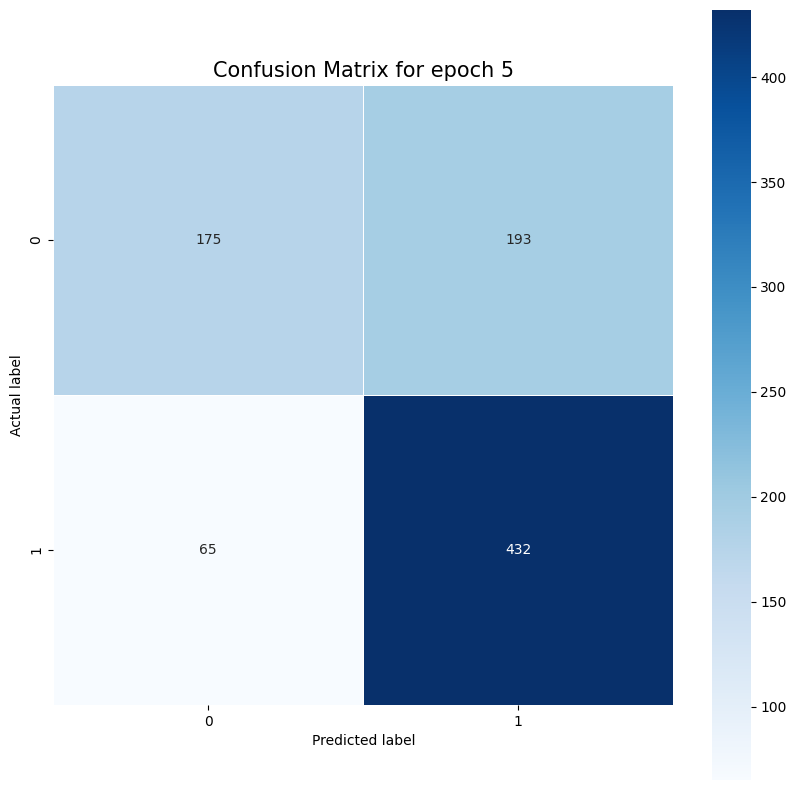

Epoch 6/10:   0%|          | 1/865 [00:04<1:00:54,  4.23s/it]

Accuracy of the model after epoch 6: 100.0%


Epoch 6/10:   0%|          | 2/865 [00:08<1:01:54,  4.30s/it]

Accuracy of the model after epoch 6: 50.0%


Epoch 6/10:   0%|          | 3/865 [00:10<49:21,  3.44s/it]  

Accuracy of the model after epoch 6: 33.333333333333336%


Epoch 6/10:   0%|          | 4/865 [00:13<43:32,  3.03s/it]

Accuracy of the model after epoch 6: 50.0%


Epoch 6/10:   1%|          | 5/865 [00:17<51:14,  3.57s/it]

Accuracy of the model after epoch 6: 40.0%


Epoch 6/10:   1%|          | 6/865 [00:22<53:50,  3.76s/it]

Accuracy of the model after epoch 6: 50.0%


Epoch 6/10:   1%|          | 7/865 [00:26<56:07,  3.92s/it]

Accuracy of the model after epoch 6: 57.142857142857146%


Epoch 6/10:   1%|          | 8/865 [00:28<49:23,  3.46s/it]

Accuracy of the model after epoch 6: 62.5%


Epoch 6/10:   1%|          | 9/865 [00:31<45:10,  3.17s/it]

Accuracy of the model after epoch 6: 55.55555555555556%


Epoch 6/10:   1%|          | 10/865 [00:35<49:56,  3.50s/it]

Accuracy of the model after epoch 6: 60.0%


Epoch 6/10:   1%|▏         | 11/865 [00:40<54:52,  3.86s/it]

Accuracy of the model after epoch 6: 54.54545454545455%


Epoch 6/10:   1%|▏         | 12/865 [00:44<56:00,  3.94s/it]

Accuracy of the model after epoch 6: 58.333333333333336%


Epoch 6/10:   2%|▏         | 13/865 [00:48<58:27,  4.12s/it]

Accuracy of the model after epoch 6: 61.53846153846154%


Epoch 6/10:   2%|▏         | 14/865 [00:54<1:04:43,  4.56s/it]

Accuracy of the model after epoch 6: 57.142857142857146%


Epoch 6/10:   2%|▏         | 15/865 [00:57<57:03,  4.03s/it]  

Accuracy of the model after epoch 6: 60.0%


Epoch 6/10:   2%|▏         | 16/865 [01:01<58:02,  4.10s/it]

Accuracy of the model after epoch 6: 62.5%


Epoch 6/10:   2%|▏         | 17/865 [01:03<50:48,  3.60s/it]

Accuracy of the model after epoch 6: 64.70588235294117%


Epoch 6/10:   2%|▏         | 18/865 [01:08<53:34,  3.80s/it]

Accuracy of the model after epoch 6: 61.111111111111114%


Epoch 6/10:   2%|▏         | 19/865 [01:12<56:16,  3.99s/it]

Accuracy of the model after epoch 6: 63.1578947368421%


Epoch 6/10:   2%|▏         | 20/865 [01:17<58:03,  4.12s/it]

Accuracy of the model after epoch 6: 60.0%


Epoch 6/10:   2%|▏         | 21/865 [01:21<57:58,  4.12s/it]

Accuracy of the model after epoch 6: 61.904761904761905%


Epoch 6/10:   3%|▎         | 22/865 [01:23<49:58,  3.56s/it]

Accuracy of the model after epoch 6: 63.63636363636363%


Epoch 6/10:   3%|▎         | 23/865 [01:25<44:40,  3.18s/it]

Accuracy of the model after epoch 6: 65.21739130434783%


Epoch 6/10:   3%|▎         | 24/865 [01:30<49:35,  3.54s/it]

Accuracy of the model after epoch 6: 62.5%


Epoch 6/10:   3%|▎         | 25/865 [01:34<53:22,  3.81s/it]

Accuracy of the model after epoch 6: 64.0%


Epoch 6/10:   3%|▎         | 26/865 [01:38<55:02,  3.94s/it]

Accuracy of the model after epoch 6: 65.38461538461539%


Epoch 6/10:   3%|▎         | 27/865 [01:41<49:20,  3.53s/it]

Accuracy of the model after epoch 6: 66.66666666666667%


Epoch 6/10:   3%|▎         | 28/865 [01:45<53:15,  3.82s/it]

Accuracy of the model after epoch 6: 64.28571428571429%


Epoch 6/10:   3%|▎         | 29/865 [01:51<58:58,  4.23s/it]

Accuracy of the model after epoch 6: 65.51724137931035%


Epoch 6/10:   3%|▎         | 30/865 [01:55<1:00:16,  4.33s/it]

Accuracy of the model after epoch 6: 63.333333333333336%


Epoch 6/10:   4%|▎         | 31/865 [01:59<59:31,  4.28s/it]  

Accuracy of the model after epoch 6: 64.51612903225806%


Epoch 6/10:   4%|▎         | 32/865 [02:04<59:31,  4.29s/it]

Accuracy of the model after epoch 6: 65.625%


Epoch 6/10:   4%|▍         | 33/865 [02:08<1:00:17,  4.35s/it]

Accuracy of the model after epoch 6: 66.66666666666667%


Epoch 6/10:   4%|▍         | 34/865 [02:13<1:04:01,  4.62s/it]

Accuracy of the model after epoch 6: 67.6470588235294%


Epoch 6/10:   4%|▍         | 35/865 [02:18<1:03:53,  4.62s/it]

Accuracy of the model after epoch 6: 68.57142857142857%


Epoch 6/10:   4%|▍         | 36/865 [02:22<1:02:18,  4.51s/it]

Accuracy of the model after epoch 6: 69.44444444444444%


Epoch 6/10:   4%|▍         | 37/865 [02:26<1:01:07,  4.43s/it]

Accuracy of the model after epoch 6: 70.27027027027027%


Epoch 6/10:   4%|▍         | 38/865 [02:31<1:01:41,  4.48s/it]

Accuracy of the model after epoch 6: 71.05263157894737%


Epoch 6/10:   5%|▍         | 39/865 [02:36<1:02:43,  4.56s/it]

Accuracy of the model after epoch 6: 71.7948717948718%


Epoch 6/10:   5%|▍         | 40/865 [02:41<1:03:31,  4.62s/it]

Accuracy of the model after epoch 6: 72.5%


Epoch 6/10:   5%|▍         | 41/865 [02:45<1:02:19,  4.54s/it]

Accuracy of the model after epoch 6: 73.17073170731707%


Epoch 6/10:   5%|▍         | 42/865 [02:49<1:02:00,  4.52s/it]

Accuracy of the model after epoch 6: 73.80952380952381%


Epoch 6/10:   5%|▍         | 43/865 [02:54<1:02:38,  4.57s/it]

Accuracy of the model after epoch 6: 72.09302325581395%


Epoch 6/10:   5%|▌         | 44/865 [02:59<1:05:32,  4.79s/it]

Accuracy of the model after epoch 6: 72.72727272727273%


Epoch 6/10:   5%|▌         | 45/865 [03:04<1:03:51,  4.67s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:   5%|▌         | 46/865 [03:08<1:02:00,  4.54s/it]

Accuracy of the model after epoch 6: 73.91304347826087%


Epoch 6/10:   5%|▌         | 47/865 [03:13<1:03:20,  4.65s/it]

Accuracy of the model after epoch 6: 74.46808510638297%


Epoch 6/10:   6%|▌         | 48/865 [03:17<1:03:00,  4.63s/it]

Accuracy of the model after epoch 6: 75.0%


Epoch 6/10:   6%|▌         | 49/865 [03:23<1:05:29,  4.82s/it]

Accuracy of the model after epoch 6: 73.46938775510205%


Epoch 6/10:   6%|▌         | 50/865 [03:28<1:05:44,  4.84s/it]

Accuracy of the model after epoch 6: 72.0%


Epoch 6/10:   6%|▌         | 51/865 [03:32<1:03:17,  4.66s/it]

Accuracy of the model after epoch 6: 70.58823529411765%


Epoch 6/10:   6%|▌         | 52/865 [03:36<1:00:55,  4.50s/it]

Accuracy of the model after epoch 6: 71.15384615384616%


Epoch 6/10:   6%|▌         | 53/865 [03:40<1:00:48,  4.49s/it]

Accuracy of the model after epoch 6: 71.69811320754717%


Epoch 6/10:   6%|▌         | 54/865 [03:45<1:01:22,  4.54s/it]

Accuracy of the model after epoch 6: 72.22222222222223%


Epoch 6/10:   6%|▋         | 55/865 [03:50<1:01:30,  4.56s/it]

Accuracy of the model after epoch 6: 70.9090909090909%


Epoch 6/10:   6%|▋         | 56/865 [03:54<1:00:08,  4.46s/it]

Accuracy of the model after epoch 6: 71.42857142857143%


Epoch 6/10:   7%|▋         | 57/865 [03:58<59:13,  4.40s/it]  

Accuracy of the model after epoch 6: 71.9298245614035%


Epoch 6/10:   7%|▋         | 58/865 [04:03<59:14,  4.40s/it]

Accuracy of the model after epoch 6: 72.41379310344827%


Epoch 6/10:   7%|▋         | 59/865 [04:05<51:22,  3.83s/it]

Accuracy of the model after epoch 6: 72.88135593220339%


Epoch 6/10:   7%|▋         | 60/865 [04:08<47:05,  3.51s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:   7%|▋         | 61/865 [04:10<42:51,  3.20s/it]

Accuracy of the model after epoch 6: 73.77049180327869%


Epoch 6/10:   7%|▋         | 62/865 [04:15<49:39,  3.71s/it]

Accuracy of the model after epoch 6: 74.19354838709677%


Epoch 6/10:   7%|▋         | 63/865 [04:20<51:42,  3.87s/it]

Accuracy of the model after epoch 6: 73.01587301587301%


Epoch 6/10:   7%|▋         | 64/865 [04:22<45:38,  3.42s/it]

Accuracy of the model after epoch 6: 71.875%


Epoch 6/10:   8%|▊         | 65/865 [04:27<52:52,  3.97s/it]

Accuracy of the model after epoch 6: 72.3076923076923%


Epoch 6/10:   8%|▊         | 66/865 [04:30<46:42,  3.51s/it]

Accuracy of the model after epoch 6: 72.72727272727273%


Epoch 6/10:   8%|▊         | 67/865 [04:34<49:45,  3.74s/it]

Accuracy of the model after epoch 6: 71.64179104477611%


Epoch 6/10:   8%|▊         | 68/865 [04:38<51:26,  3.87s/it]

Accuracy of the model after epoch 6: 70.58823529411765%


Epoch 6/10:   8%|▊         | 69/865 [04:41<45:55,  3.46s/it]

Accuracy of the model after epoch 6: 71.01449275362319%


Epoch 6/10:   8%|▊         | 70/865 [04:45<50:07,  3.78s/it]

Accuracy of the model after epoch 6: 70.0%


Epoch 6/10:   8%|▊         | 71/865 [04:50<53:32,  4.05s/it]

Accuracy of the model after epoch 6: 70.4225352112676%


Epoch 6/10:   8%|▊         | 72/865 [04:54<55:02,  4.16s/it]

Accuracy of the model after epoch 6: 69.44444444444444%


Epoch 6/10:   8%|▊         | 73/865 [04:59<56:59,  4.32s/it]

Accuracy of the model after epoch 6: 68.4931506849315%


Epoch 6/10:   9%|▊         | 74/865 [05:04<59:50,  4.54s/it]

Accuracy of the model after epoch 6: 68.91891891891892%


Epoch 6/10:   9%|▊         | 75/865 [05:09<1:00:58,  4.63s/it]

Accuracy of the model after epoch 6: 69.33333333333333%


Epoch 6/10:   9%|▉         | 76/865 [05:13<59:13,  4.50s/it]  

Accuracy of the model after epoch 6: 69.73684210526316%


Epoch 6/10:   9%|▉         | 77/865 [05:17<57:25,  4.37s/it]

Accuracy of the model after epoch 6: 70.12987012987013%


Epoch 6/10:   9%|▉         | 78/865 [05:21<57:15,  4.36s/it]

Accuracy of the model after epoch 6: 70.51282051282051%


Epoch 6/10:   9%|▉         | 79/865 [05:24<49:28,  3.78s/it]

Accuracy of the model after epoch 6: 70.88607594936708%


Epoch 6/10:   9%|▉         | 80/865 [05:28<52:15,  3.99s/it]

Accuracy of the model after epoch 6: 70.0%


Epoch 6/10:   9%|▉         | 81/865 [05:32<52:32,  4.02s/it]

Accuracy of the model after epoch 6: 70.37037037037037%


Epoch 6/10:   9%|▉         | 82/865 [05:36<52:53,  4.05s/it]

Accuracy of the model after epoch 6: 69.51219512195122%


Epoch 6/10:  10%|▉         | 83/865 [05:41<53:25,  4.10s/it]

Accuracy of the model after epoch 6: 69.87951807228916%


Epoch 6/10:  10%|▉         | 84/865 [05:46<56:14,  4.32s/it]

Accuracy of the model after epoch 6: 70.23809523809524%


Epoch 6/10:  10%|▉         | 85/865 [05:50<56:55,  4.38s/it]

Accuracy of the model after epoch 6: 70.58823529411765%


Epoch 6/10:  10%|▉         | 86/865 [05:55<57:31,  4.43s/it]

Accuracy of the model after epoch 6: 69.76744186046511%


Epoch 6/10:  10%|█         | 87/865 [05:59<56:51,  4.39s/it]

Accuracy of the model after epoch 6: 68.96551724137932%


Epoch 6/10:  10%|█         | 88/865 [06:04<58:33,  4.52s/it]

Accuracy of the model after epoch 6: 69.31818181818181%


Epoch 6/10:  10%|█         | 89/865 [06:06<50:48,  3.93s/it]

Accuracy of the model after epoch 6: 69.66292134831461%


Epoch 6/10:  10%|█         | 90/865 [06:11<53:27,  4.14s/it]

Accuracy of the model after epoch 6: 70.0%


Epoch 6/10:  11%|█         | 91/865 [06:15<53:45,  4.17s/it]

Accuracy of the model after epoch 6: 69.23076923076923%


Epoch 6/10:  11%|█         | 92/865 [06:19<54:03,  4.20s/it]

Accuracy of the model after epoch 6: 68.47826086956522%


Epoch 6/10:  11%|█         | 93/865 [06:24<55:28,  4.31s/it]

Accuracy of the model after epoch 6: 68.81720430107526%


Epoch 6/10:  11%|█         | 94/865 [06:29<58:15,  4.53s/it]

Accuracy of the model after epoch 6: 68.08510638297872%


Epoch 6/10:  11%|█         | 95/865 [06:34<1:00:03,  4.68s/it]

Accuracy of the model after epoch 6: 68.42105263157895%


Epoch 6/10:  11%|█         | 96/865 [06:38<58:25,  4.56s/it]  

Accuracy of the model after epoch 6: 68.75%


Epoch 6/10:  11%|█         | 97/865 [06:43<57:07,  4.46s/it]

Accuracy of the model after epoch 6: 69.0721649484536%


Epoch 6/10:  11%|█▏        | 98/865 [06:47<57:44,  4.52s/it]

Accuracy of the model after epoch 6: 69.38775510204081%


Epoch 6/10:  11%|█▏        | 99/865 [06:52<57:56,  4.54s/it]

Accuracy of the model after epoch 6: 69.6969696969697%


Epoch 6/10:  12%|█▏        | 100/865 [06:57<59:09,  4.64s/it]

Accuracy of the model after epoch 6: 70.0%


Epoch 6/10:  12%|█▏        | 101/865 [07:01<57:47,  4.54s/it]

Accuracy of the model after epoch 6: 69.3069306930693%


Epoch 6/10:  12%|█▏        | 102/865 [07:03<49:25,  3.89s/it]

Accuracy of the model after epoch 6: 69.6078431372549%


Epoch 6/10:  12%|█▏        | 103/865 [07:08<51:15,  4.04s/it]

Accuracy of the model after epoch 6: 68.93203883495146%


Epoch 6/10:  12%|█▏        | 104/865 [07:12<53:46,  4.24s/it]

Accuracy of the model after epoch 6: 69.23076923076923%


Epoch 6/10:  12%|█▏        | 105/865 [07:17<54:30,  4.30s/it]

Accuracy of the model after epoch 6: 69.52380952380952%


Epoch 6/10:  12%|█▏        | 106/865 [07:21<54:41,  4.32s/it]

Accuracy of the model after epoch 6: 69.81132075471699%


Epoch 6/10:  12%|█▏        | 107/865 [07:26<54:44,  4.33s/it]

Accuracy of the model after epoch 6: 70.09345794392523%


Epoch 6/10:  12%|█▏        | 108/865 [07:30<55:50,  4.43s/it]

Accuracy of the model after epoch 6: 70.37037037037037%


Epoch 6/10:  13%|█▎        | 109/865 [07:35<58:34,  4.65s/it]

Accuracy of the model after epoch 6: 69.72477064220183%


Epoch 6/10:  13%|█▎        | 110/865 [07:40<57:46,  4.59s/it]

Accuracy of the model after epoch 6: 70.0%


Epoch 6/10:  13%|█▎        | 111/865 [07:44<56:09,  4.47s/it]

Accuracy of the model after epoch 6: 70.27027027027027%


Epoch 6/10:  13%|█▎        | 112/865 [07:48<55:26,  4.42s/it]

Accuracy of the model after epoch 6: 69.64285714285714%


Epoch 6/10:  13%|█▎        | 113/865 [07:51<48:50,  3.90s/it]

Accuracy of the model after epoch 6: 69.91150442477876%


Epoch 6/10:  13%|█▎        | 114/865 [07:56<53:28,  4.27s/it]

Accuracy of the model after epoch 6: 70.17543859649123%


Epoch 6/10:  13%|█▎        | 115/865 [07:59<48:06,  3.85s/it]

Accuracy of the model after epoch 6: 69.56521739130434%


Epoch 6/10:  13%|█▎        | 116/865 [08:02<43:08,  3.46s/it]

Accuracy of the model after epoch 6: 69.82758620689656%


Epoch 6/10:  14%|█▎        | 117/865 [08:06<46:51,  3.76s/it]

Accuracy of the model after epoch 6: 70.08547008547009%


Epoch 6/10:  14%|█▎        | 118/865 [08:10<48:59,  3.93s/it]

Accuracy of the model after epoch 6: 70.33898305084746%


Epoch 6/10:  14%|█▍        | 119/865 [08:15<50:26,  4.06s/it]

Accuracy of the model after epoch 6: 70.58823529411765%


Epoch 6/10:  14%|█▍        | 120/865 [08:19<52:13,  4.21s/it]

Accuracy of the model after epoch 6: 70.83333333333333%


Epoch 6/10:  14%|█▍        | 121/865 [08:24<52:31,  4.24s/it]

Accuracy of the model after epoch 6: 71.07438016528926%


Epoch 6/10:  14%|█▍        | 122/865 [08:28<51:52,  4.19s/it]

Accuracy of the model after epoch 6: 70.49180327868852%


Epoch 6/10:  14%|█▍        | 123/865 [08:32<53:47,  4.35s/it]

Accuracy of the model after epoch 6: 70.73170731707317%


Epoch 6/10:  14%|█▍        | 124/865 [08:35<47:32,  3.85s/it]

Accuracy of the model after epoch 6: 70.96774193548387%


Epoch 6/10:  14%|█▍        | 125/865 [08:40<50:22,  4.08s/it]

Accuracy of the model after epoch 6: 71.2%


Epoch 6/10:  15%|█▍        | 126/865 [08:44<52:24,  4.25s/it]

Accuracy of the model after epoch 6: 71.42857142857143%


Epoch 6/10:  15%|█▍        | 127/865 [08:49<52:34,  4.27s/it]

Accuracy of the model after epoch 6: 71.65354330708661%


Epoch 6/10:  15%|█▍        | 128/865 [08:51<45:33,  3.71s/it]

Accuracy of the model after epoch 6: 71.09375%


Epoch 6/10:  15%|█▍        | 129/865 [08:54<40:56,  3.34s/it]

Accuracy of the model after epoch 6: 71.31782945736434%


Epoch 6/10:  15%|█▌        | 130/865 [08:59<47:01,  3.84s/it]

Accuracy of the model after epoch 6: 71.53846153846153%


Epoch 6/10:  15%|█▌        | 131/865 [09:03<48:33,  3.97s/it]

Accuracy of the model after epoch 6: 70.99236641221374%


Epoch 6/10:  15%|█▌        | 132/865 [09:07<49:44,  4.07s/it]

Accuracy of the model after epoch 6: 71.21212121212122%


Epoch 6/10:  15%|█▌        | 133/865 [09:12<51:26,  4.22s/it]

Accuracy of the model after epoch 6: 71.42857142857143%


Epoch 6/10:  15%|█▌        | 134/865 [09:17<53:44,  4.41s/it]

Accuracy of the model after epoch 6: 71.64179104477611%


Epoch 6/10:  16%|█▌        | 135/865 [09:21<54:07,  4.45s/it]

Accuracy of the model after epoch 6: 71.85185185185185%


Epoch 6/10:  16%|█▌        | 136/865 [09:25<53:25,  4.40s/it]

Accuracy of the model after epoch 6: 71.32352941176471%


Epoch 6/10:  16%|█▌        | 137/865 [09:30<53:15,  4.39s/it]

Accuracy of the model after epoch 6: 71.53284671532846%


Epoch 6/10:  16%|█▌        | 138/865 [09:34<54:23,  4.49s/it]

Accuracy of the model after epoch 6: 71.73913043478261%


Epoch 6/10:  16%|█▌        | 139/865 [09:37<47:14,  3.90s/it]

Accuracy of the model after epoch 6: 71.94244604316546%


Epoch 6/10:  16%|█▌        | 140/865 [09:41<48:43,  4.03s/it]

Accuracy of the model after epoch 6: 72.14285714285714%


Epoch 6/10:  16%|█▋        | 141/865 [09:46<49:39,  4.11s/it]

Accuracy of the model after epoch 6: 72.34042553191489%


Epoch 6/10:  16%|█▋        | 142/865 [09:50<50:07,  4.16s/it]

Accuracy of the model after epoch 6: 71.83098591549296%


Epoch 6/10:  17%|█▋        | 143/865 [09:55<51:54,  4.31s/it]

Accuracy of the model after epoch 6: 72.02797202797203%


Epoch 6/10:  17%|█▋        | 144/865 [10:00<55:15,  4.60s/it]

Accuracy of the model after epoch 6: 72.22222222222223%


Epoch 6/10:  17%|█▋        | 145/865 [10:04<54:30,  4.54s/it]

Accuracy of the model after epoch 6: 72.41379310344827%


Epoch 6/10:  17%|█▋        | 146/865 [10:07<47:16,  3.94s/it]

Accuracy of the model after epoch 6: 72.6027397260274%


Epoch 6/10:  17%|█▋        | 147/865 [10:11<48:58,  4.09s/it]

Accuracy of the model after epoch 6: 72.78911564625851%


Epoch 6/10:  17%|█▋        | 148/865 [10:15<49:02,  4.10s/it]

Accuracy of the model after epoch 6: 72.97297297297297%


Epoch 6/10:  17%|█▋        | 149/865 [10:18<42:09,  3.53s/it]

Accuracy of the model after epoch 6: 73.15436241610739%


Epoch 6/10:  17%|█▋        | 150/865 [10:22<45:37,  3.83s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  17%|█▋        | 151/865 [10:26<47:01,  3.95s/it]

Accuracy of the model after epoch 6: 73.50993377483444%


Epoch 6/10:  18%|█▊        | 152/865 [10:31<48:11,  4.06s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  18%|█▊        | 153/865 [10:35<49:09,  4.14s/it]

Accuracy of the model after epoch 6: 73.20261437908496%


Epoch 6/10:  18%|█▊        | 154/865 [10:40<51:34,  4.35s/it]

Accuracy of the model after epoch 6: 72.72727272727273%


Epoch 6/10:  18%|█▊        | 155/865 [10:45<53:49,  4.55s/it]

Accuracy of the model after epoch 6: 72.90322580645162%


Epoch 6/10:  18%|█▊        | 156/865 [10:49<52:34,  4.45s/it]

Accuracy of the model after epoch 6: 73.07692307692308%


Epoch 6/10:  18%|█▊        | 157/865 [10:54<53:11,  4.51s/it]

Accuracy of the model after epoch 6: 73.2484076433121%


Epoch 6/10:  18%|█▊        | 158/865 [10:59<54:20,  4.61s/it]

Accuracy of the model after epoch 6: 73.41772151898734%


Epoch 6/10:  18%|█▊        | 159/865 [11:04<56:43,  4.82s/it]

Accuracy of the model after epoch 6: 73.58490566037736%


Epoch 6/10:  18%|█▊        | 160/865 [11:06<48:50,  4.16s/it]

Accuracy of the model after epoch 6: 73.75%


Epoch 6/10:  19%|█▊        | 161/865 [11:09<42:42,  3.64s/it]

Accuracy of the model after epoch 6: 73.91304347826087%


Epoch 6/10:  19%|█▊        | 162/865 [11:13<44:42,  3.82s/it]

Accuracy of the model after epoch 6: 74.07407407407408%


Epoch 6/10:  19%|█▉        | 163/865 [11:17<45:49,  3.92s/it]

Accuracy of the model after epoch 6: 74.23312883435582%


Epoch 6/10:  19%|█▉        | 164/865 [11:22<47:31,  4.07s/it]

Accuracy of the model after epoch 6: 73.78048780487805%


Epoch 6/10:  19%|█▉        | 165/865 [11:26<49:24,  4.23s/it]

Accuracy of the model after epoch 6: 73.93939393939394%


Epoch 6/10:  19%|█▉        | 166/865 [11:29<43:14,  3.71s/it]

Accuracy of the model after epoch 6: 73.49397590361446%


Epoch 6/10:  19%|█▉        | 167/865 [11:33<45:25,  3.91s/it]

Accuracy of the model after epoch 6: 73.65269461077844%


Epoch 6/10:  19%|█▉        | 168/865 [11:37<46:42,  4.02s/it]

Accuracy of the model after epoch 6: 73.80952380952381%


Epoch 6/10:  20%|█▉        | 169/865 [11:42<49:11,  4.24s/it]

Accuracy of the model after epoch 6: 73.96449704142012%


Epoch 6/10:  20%|█▉        | 170/865 [11:45<43:09,  3.73s/it]

Accuracy of the model after epoch 6: 74.11764705882354%


Epoch 6/10:  20%|█▉        | 171/865 [11:49<44:28,  3.85s/it]

Accuracy of the model after epoch 6: 74.26900584795321%


Epoch 6/10:  20%|█▉        | 172/865 [11:53<45:59,  3.98s/it]

Accuracy of the model after epoch 6: 74.4186046511628%


Epoch 6/10:  20%|██        | 173/865 [11:57<46:35,  4.04s/it]

Accuracy of the model after epoch 6: 74.56647398843931%


Epoch 6/10:  20%|██        | 174/865 [12:02<47:26,  4.12s/it]

Accuracy of the model after epoch 6: 74.71264367816092%


Epoch 6/10:  20%|██        | 175/865 [12:06<48:32,  4.22s/it]

Accuracy of the model after epoch 6: 74.85714285714286%


Epoch 6/10:  20%|██        | 176/865 [12:09<42:33,  3.71s/it]

Accuracy of the model after epoch 6: 75.0%


Epoch 6/10:  20%|██        | 177/865 [12:13<44:24,  3.87s/it]

Accuracy of the model after epoch 6: 74.57627118644068%


Epoch 6/10:  21%|██        | 178/865 [12:17<44:59,  3.93s/it]

Accuracy of the model after epoch 6: 74.15730337078652%


Epoch 6/10:  21%|██        | 179/865 [12:21<47:08,  4.12s/it]

Accuracy of the model after epoch 6: 74.30167597765363%


Epoch 6/10:  21%|██        | 180/865 [12:26<48:09,  4.22s/it]

Accuracy of the model after epoch 6: 74.44444444444444%


Epoch 6/10:  21%|██        | 181/865 [12:30<47:44,  4.19s/it]

Accuracy of the model after epoch 6: 74.03314917127072%


Epoch 6/10:  21%|██        | 182/865 [12:34<48:09,  4.23s/it]

Accuracy of the model after epoch 6: 74.17582417582418%


Epoch 6/10:  21%|██        | 183/865 [12:39<50:02,  4.40s/it]

Accuracy of the model after epoch 6: 74.31693989071039%


Epoch 6/10:  21%|██▏       | 184/865 [12:44<52:23,  4.62s/it]

Accuracy of the model after epoch 6: 74.45652173913044%


Epoch 6/10:  21%|██▏       | 185/865 [12:49<51:49,  4.57s/it]

Accuracy of the model after epoch 6: 74.05405405405405%


Epoch 6/10:  22%|██▏       | 186/865 [12:51<44:45,  3.96s/it]

Accuracy of the model after epoch 6: 74.19354838709677%


Epoch 6/10:  22%|██▏       | 187/865 [12:56<45:49,  4.06s/it]

Accuracy of the model after epoch 6: 73.79679144385027%


Epoch 6/10:  22%|██▏       | 188/865 [12:58<40:09,  3.56s/it]

Accuracy of the model after epoch 6: 73.93617021276596%


Epoch 6/10:  22%|██▏       | 189/865 [13:02<43:19,  3.85s/it]

Accuracy of the model after epoch 6: 74.07407407407408%


Epoch 6/10:  22%|██▏       | 190/865 [13:07<45:34,  4.05s/it]

Accuracy of the model after epoch 6: 74.21052631578948%


Epoch 6/10:  22%|██▏       | 191/865 [13:10<40:28,  3.60s/it]

Accuracy of the model after epoch 6: 74.3455497382199%


Epoch 6/10:  22%|██▏       | 192/865 [13:14<42:48,  3.82s/it]

Accuracy of the model after epoch 6: 74.47916666666667%


Epoch 6/10:  22%|██▏       | 193/865 [13:16<38:15,  3.42s/it]

Accuracy of the model after epoch 6: 74.61139896373057%


Epoch 6/10:  22%|██▏       | 194/865 [13:21<42:11,  3.77s/it]

Accuracy of the model after epoch 6: 74.74226804123711%


Epoch 6/10:  23%|██▎       | 195/865 [13:26<44:54,  4.02s/it]

Accuracy of the model after epoch 6: 74.87179487179488%


Epoch 6/10:  23%|██▎       | 196/865 [13:30<46:42,  4.19s/it]

Accuracy of the model after epoch 6: 75.0%


Epoch 6/10:  23%|██▎       | 197/865 [13:34<46:08,  4.14s/it]

Accuracy of the model after epoch 6: 75.1269035532995%


Epoch 6/10:  23%|██▎       | 198/865 [13:39<48:14,  4.34s/it]

Accuracy of the model after epoch 6: 75.25252525252525%


Epoch 6/10:  23%|██▎       | 199/865 [13:44<49:45,  4.48s/it]

Accuracy of the model after epoch 6: 75.37688442211055%


Epoch 6/10:  23%|██▎       | 200/865 [13:48<50:07,  4.52s/it]

Accuracy of the model after epoch 6: 75.0%


Epoch 6/10:  23%|██▎       | 201/865 [13:53<49:17,  4.45s/it]

Accuracy of the model after epoch 6: 75.12437810945273%


Epoch 6/10:  23%|██▎       | 202/865 [13:57<49:36,  4.49s/it]

Accuracy of the model after epoch 6: 75.24752475247524%


Epoch 6/10:  23%|██▎       | 203/865 [14:00<42:34,  3.86s/it]

Accuracy of the model after epoch 6: 75.36945812807882%


Epoch 6/10:  24%|██▎       | 204/865 [14:04<45:24,  4.12s/it]

Accuracy of the model after epoch 6: 75.49019607843137%


Epoch 6/10:  24%|██▎       | 205/865 [14:09<46:14,  4.20s/it]

Accuracy of the model after epoch 6: 75.60975609756098%


Epoch 6/10:  24%|██▍       | 206/865 [14:13<46:25,  4.23s/it]

Accuracy of the model after epoch 6: 75.72815533980582%


Epoch 6/10:  24%|██▍       | 207/865 [14:15<40:22,  3.68s/it]

Accuracy of the model after epoch 6: 75.84541062801932%


Epoch 6/10:  24%|██▍       | 208/865 [14:20<43:48,  4.00s/it]

Accuracy of the model after epoch 6: 75.48076923076923%


Epoch 6/10:  24%|██▍       | 209/865 [14:25<46:02,  4.21s/it]

Accuracy of the model after epoch 6: 75.11961722488039%


Epoch 6/10:  24%|██▍       | 210/865 [14:30<47:10,  4.32s/it]

Accuracy of the model after epoch 6: 75.23809523809524%


Epoch 6/10:  24%|██▍       | 211/865 [14:34<47:03,  4.32s/it]

Accuracy of the model after epoch 6: 75.35545023696683%


Epoch 6/10:  25%|██▍       | 212/865 [14:38<47:50,  4.40s/it]

Accuracy of the model after epoch 6: 75.47169811320755%


Epoch 6/10:  25%|██▍       | 213/865 [14:43<48:02,  4.42s/it]

Accuracy of the model after epoch 6: 75.5868544600939%


Epoch 6/10:  25%|██▍       | 214/865 [14:48<50:45,  4.68s/it]

Accuracy of the model after epoch 6: 75.70093457943925%


Epoch 6/10:  25%|██▍       | 215/865 [14:53<50:14,  4.64s/it]

Accuracy of the model after epoch 6: 75.81395348837209%


Epoch 6/10:  25%|██▍       | 216/865 [14:57<50:24,  4.66s/it]

Accuracy of the model after epoch 6: 75.46296296296296%


Epoch 6/10:  25%|██▌       | 217/865 [15:00<43:42,  4.05s/it]

Accuracy of the model after epoch 6: 75.57603686635944%


Epoch 6/10:  25%|██▌       | 218/865 [15:05<45:25,  4.21s/it]

Accuracy of the model after epoch 6: 75.68807339449542%


Epoch 6/10:  25%|██▌       | 219/865 [15:09<46:40,  4.33s/it]

Accuracy of the model after epoch 6: 75.79908675799086%


Epoch 6/10:  25%|██▌       | 220/865 [15:12<40:37,  3.78s/it]

Accuracy of the model after epoch 6: 75.45454545454545%


Epoch 6/10:  26%|██▌       | 221/865 [15:16<42:10,  3.93s/it]

Accuracy of the model after epoch 6: 75.56561085972851%


Epoch 6/10:  26%|██▌       | 222/865 [15:19<37:51,  3.53s/it]

Accuracy of the model after epoch 6: 75.22522522522523%


Epoch 6/10:  26%|██▌       | 223/865 [15:21<34:31,  3.23s/it]

Accuracy of the model after epoch 6: 75.33632286995515%


Epoch 6/10:  26%|██▌       | 224/865 [15:24<31:45,  2.97s/it]

Accuracy of the model after epoch 6: 75.44642857142857%


Epoch 6/10:  26%|██▌       | 225/865 [15:26<31:05,  2.92s/it]

Accuracy of the model after epoch 6: 75.55555555555556%


Epoch 6/10:  26%|██▌       | 226/865 [15:31<35:34,  3.34s/it]

Accuracy of the model after epoch 6: 75.66371681415929%


Epoch 6/10:  26%|██▌       | 227/865 [15:33<33:00,  3.10s/it]

Accuracy of the model after epoch 6: 75.77092511013215%


Epoch 6/10:  26%|██▋       | 228/865 [15:37<36:04,  3.40s/it]

Accuracy of the model after epoch 6: 75.87719298245614%


Epoch 6/10:  26%|██▋       | 229/865 [15:40<33:10,  3.13s/it]

Accuracy of the model after epoch 6: 75.9825327510917%


Epoch 6/10:  27%|██▋       | 230/865 [15:45<39:14,  3.71s/it]

Accuracy of the model after epoch 6: 76.08695652173913%


Epoch 6/10:  27%|██▋       | 231/865 [15:49<41:18,  3.91s/it]

Accuracy of the model after epoch 6: 76.19047619047619%


Epoch 6/10:  27%|██▋       | 232/865 [15:53<41:43,  3.96s/it]

Accuracy of the model after epoch 6: 76.29310344827586%


Epoch 6/10:  27%|██▋       | 233/865 [15:58<43:55,  4.17s/it]

Accuracy of the model after epoch 6: 76.39484978540773%


Epoch 6/10:  27%|██▋       | 234/865 [16:03<45:34,  4.33s/it]

Accuracy of the model after epoch 6: 76.06837606837607%


Epoch 6/10:  27%|██▋       | 235/865 [16:07<45:49,  4.36s/it]

Accuracy of the model after epoch 6: 76.17021276595744%


Epoch 6/10:  27%|██▋       | 236/865 [16:11<45:06,  4.30s/it]

Accuracy of the model after epoch 6: 76.27118644067797%


Epoch 6/10:  27%|██▋       | 237/865 [16:16<44:53,  4.29s/it]

Accuracy of the model after epoch 6: 76.37130801687763%


Epoch 6/10:  28%|██▊       | 238/865 [16:20<45:57,  4.40s/it]

Accuracy of the model after epoch 6: 76.05042016806723%


Epoch 6/10:  28%|██▊       | 239/865 [16:26<48:51,  4.68s/it]

Accuracy of the model after epoch 6: 76.15062761506276%


Epoch 6/10:  28%|██▊       | 240/865 [16:30<49:28,  4.75s/it]

Accuracy of the model after epoch 6: 75.83333333333333%


Epoch 6/10:  28%|██▊       | 241/865 [16:35<48:07,  4.63s/it]

Accuracy of the model after epoch 6: 75.51867219917013%


Epoch 6/10:  28%|██▊       | 242/865 [16:39<47:03,  4.53s/it]

Accuracy of the model after epoch 6: 75.6198347107438%


Epoch 6/10:  28%|██▊       | 243/865 [16:42<40:27,  3.90s/it]

Accuracy of the model after epoch 6: 75.7201646090535%


Epoch 6/10:  28%|██▊       | 244/865 [16:46<42:27,  4.10s/it]

Accuracy of the model after epoch 6: 75.81967213114754%


Epoch 6/10:  28%|██▊       | 245/865 [16:51<43:39,  4.22s/it]

Accuracy of the model after epoch 6: 75.91836734693878%


Epoch 6/10:  28%|██▊       | 246/865 [16:55<45:04,  4.37s/it]

Accuracy of the model after epoch 6: 76.01626016260163%


Epoch 6/10:  29%|██▊       | 247/865 [16:58<38:55,  3.78s/it]

Accuracy of the model after epoch 6: 76.11336032388664%


Epoch 6/10:  29%|██▊       | 248/865 [17:00<35:18,  3.43s/it]

Accuracy of the model after epoch 6: 76.20967741935483%


Epoch 6/10:  29%|██▉       | 249/865 [17:05<40:15,  3.92s/it]

Accuracy of the model after epoch 6: 75.90361445783132%


Epoch 6/10:  29%|██▉       | 250/865 [17:10<41:58,  4.10s/it]

Accuracy of the model after epoch 6: 76.0%


Epoch 6/10:  29%|██▉       | 251/865 [17:14<42:40,  4.17s/it]

Accuracy of the model after epoch 6: 75.69721115537848%


Epoch 6/10:  29%|██▉       | 252/865 [17:18<42:10,  4.13s/it]

Accuracy of the model after epoch 6: 75.7936507936508%


Epoch 6/10:  29%|██▉       | 253/865 [17:23<43:50,  4.30s/it]

Accuracy of the model after epoch 6: 75.88932806324111%


Epoch 6/10:  29%|██▉       | 254/865 [17:28<44:40,  4.39s/it]

Accuracy of the model after epoch 6: 75.98425196850394%


Epoch 6/10:  29%|██▉       | 255/865 [17:32<44:49,  4.41s/it]

Accuracy of the model after epoch 6: 75.68627450980392%


Epoch 6/10:  30%|██▉       | 256/865 [17:36<44:33,  4.39s/it]

Accuracy of the model after epoch 6: 75.78125%


Epoch 6/10:  30%|██▉       | 257/865 [17:41<45:44,  4.51s/it]

Accuracy of the model after epoch 6: 75.4863813229572%


Epoch 6/10:  30%|██▉       | 258/865 [17:46<47:28,  4.69s/it]

Accuracy of the model after epoch 6: 75.5813953488372%


Epoch 6/10:  30%|██▉       | 259/865 [17:49<40:05,  3.97s/it]

Accuracy of the model after epoch 6: 75.2895752895753%


Epoch 6/10:  30%|███       | 260/865 [17:53<41:07,  4.08s/it]

Accuracy of the model after epoch 6: 75.38461538461539%


Epoch 6/10:  30%|███       | 261/865 [17:58<43:13,  4.29s/it]

Accuracy of the model after epoch 6: 75.47892720306514%


Epoch 6/10:  30%|███       | 262/865 [18:00<38:15,  3.81s/it]

Accuracy of the model after epoch 6: 75.57251908396947%


Epoch 6/10:  30%|███       | 263/865 [18:05<39:21,  3.92s/it]

Accuracy of the model after epoch 6: 75.66539923954373%


Epoch 6/10:  31%|███       | 264/865 [18:07<34:46,  3.47s/it]

Accuracy of the model after epoch 6: 75.37878787878788%


Epoch 6/10:  31%|███       | 265/865 [18:11<37:16,  3.73s/it]

Accuracy of the model after epoch 6: 75.47169811320755%


Epoch 6/10:  31%|███       | 266/865 [18:16<39:46,  3.98s/it]

Accuracy of the model after epoch 6: 75.18796992481202%


Epoch 6/10:  31%|███       | 267/865 [18:20<40:27,  4.06s/it]

Accuracy of the model after epoch 6: 75.28089887640449%


Epoch 6/10:  31%|███       | 268/865 [18:22<34:57,  3.51s/it]

Accuracy of the model after epoch 6: 75.0%


Epoch 6/10:  31%|███       | 269/865 [18:25<31:52,  3.21s/it]

Accuracy of the model after epoch 6: 75.09293680297398%


Epoch 6/10:  31%|███       | 270/865 [18:29<35:33,  3.59s/it]

Accuracy of the model after epoch 6: 74.81481481481481%


Epoch 6/10:  31%|███▏      | 271/865 [18:32<32:20,  3.27s/it]

Accuracy of the model after epoch 6: 74.90774907749078%


Epoch 6/10:  31%|███▏      | 272/865 [18:36<36:14,  3.67s/it]

Accuracy of the model after epoch 6: 74.63235294117646%


Epoch 6/10:  32%|███▏      | 273/865 [18:41<38:25,  3.90s/it]

Accuracy of the model after epoch 6: 74.35897435897436%


Epoch 6/10:  32%|███▏      | 274/865 [18:46<41:13,  4.19s/it]

Accuracy of the model after epoch 6: 74.45255474452554%


Epoch 6/10:  32%|███▏      | 275/865 [18:50<42:17,  4.30s/it]

Accuracy of the model after epoch 6: 74.54545454545455%


Epoch 6/10:  32%|███▏      | 276/865 [18:55<42:35,  4.34s/it]

Accuracy of the model after epoch 6: 74.27536231884058%


Epoch 6/10:  32%|███▏      | 277/865 [18:57<37:12,  3.80s/it]

Accuracy of the model after epoch 6: 74.36823104693141%


Epoch 6/10:  32%|███▏      | 278/865 [19:00<33:20,  3.41s/it]

Accuracy of the model after epoch 6: 74.46043165467626%


Epoch 6/10:  32%|███▏      | 279/865 [19:04<36:57,  3.78s/it]

Accuracy of the model after epoch 6: 74.55197132616487%


Epoch 6/10:  32%|███▏      | 280/865 [19:07<34:01,  3.49s/it]

Accuracy of the model after epoch 6: 74.64285714285714%


Epoch 6/10:  32%|███▏      | 281/865 [19:12<37:58,  3.90s/it]

Accuracy of the model after epoch 6: 74.73309608540926%


Epoch 6/10:  33%|███▎      | 282/865 [19:16<38:44,  3.99s/it]

Accuracy of the model after epoch 6: 74.46808510638297%


Epoch 6/10:  33%|███▎      | 283/865 [19:21<39:32,  4.08s/it]

Accuracy of the model after epoch 6: 74.20494699646643%


Epoch 6/10:  33%|███▎      | 284/865 [19:25<41:37,  4.30s/it]

Accuracy of the model after epoch 6: 73.94366197183099%


Epoch 6/10:  33%|███▎      | 285/865 [19:30<42:14,  4.37s/it]

Accuracy of the model after epoch 6: 74.03508771929825%


Epoch 6/10:  33%|███▎      | 286/865 [19:34<41:55,  4.35s/it]

Accuracy of the model after epoch 6: 74.12587412587412%


Epoch 6/10:  33%|███▎      | 287/865 [19:37<36:08,  3.75s/it]

Accuracy of the model after epoch 6: 74.21602787456446%


Epoch 6/10:  33%|███▎      | 288/865 [19:41<39:05,  4.07s/it]

Accuracy of the model after epoch 6: 73.95833333333333%


Epoch 6/10:  33%|███▎      | 289/865 [19:46<40:58,  4.27s/it]

Accuracy of the model after epoch 6: 73.70242214532873%


Epoch 6/10:  34%|███▎      | 290/865 [19:51<42:15,  4.41s/it]

Accuracy of the model after epoch 6: 73.79310344827586%


Epoch 6/10:  34%|███▎      | 291/865 [19:55<42:13,  4.41s/it]

Accuracy of the model after epoch 6: 73.53951890034364%


Epoch 6/10:  34%|███▍      | 292/865 [20:00<42:18,  4.43s/it]

Accuracy of the model after epoch 6: 73.28767123287672%


Epoch 6/10:  34%|███▍      | 293/865 [20:05<43:16,  4.54s/it]

Accuracy of the model after epoch 6: 73.03754266211604%


Epoch 6/10:  34%|███▍      | 294/865 [20:10<46:00,  4.83s/it]

Accuracy of the model after epoch 6: 73.12925170068027%


Epoch 6/10:  34%|███▍      | 295/865 [20:15<45:56,  4.84s/it]

Accuracy of the model after epoch 6: 73.22033898305085%


Epoch 6/10:  34%|███▍      | 296/865 [20:19<44:35,  4.70s/it]

Accuracy of the model after epoch 6: 73.3108108108108%


Epoch 6/10:  34%|███▍      | 297/865 [20:24<43:44,  4.62s/it]

Accuracy of the model after epoch 6: 73.4006734006734%


Epoch 6/10:  34%|███▍      | 298/865 [20:26<38:06,  4.03s/it]

Accuracy of the model after epoch 6: 73.48993288590604%


Epoch 6/10:  35%|███▍      | 299/865 [20:29<33:49,  3.59s/it]

Accuracy of the model after epoch 6: 73.57859531772576%


Epoch 6/10:  35%|███▍      | 300/865 [20:31<30:52,  3.28s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  35%|███▍      | 301/865 [20:36<33:01,  3.51s/it]

Accuracy of the model after epoch 6: 73.421926910299%


Epoch 6/10:  35%|███▍      | 302/865 [20:38<30:09,  3.21s/it]

Accuracy of the model after epoch 6: 73.50993377483444%


Epoch 6/10:  35%|███▌      | 303/865 [20:43<34:37,  3.70s/it]

Accuracy of the model after epoch 6: 73.5973597359736%


Epoch 6/10:  35%|███▌      | 304/865 [20:45<30:30,  3.26s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  35%|███▌      | 305/865 [20:50<34:15,  3.67s/it]

Accuracy of the model after epoch 6: 73.77049180327869%


Epoch 6/10:  35%|███▌      | 306/865 [20:52<31:05,  3.34s/it]

Accuracy of the model after epoch 6: 73.85620915032679%


Epoch 6/10:  35%|███▌      | 307/865 [20:55<28:34,  3.07s/it]

Accuracy of the model after epoch 6: 73.9413680781759%


Epoch 6/10:  36%|███▌      | 308/865 [20:59<31:34,  3.40s/it]

Accuracy of the model after epoch 6: 74.02597402597402%


Epoch 6/10:  36%|███▌      | 309/865 [21:04<35:23,  3.82s/it]

Accuracy of the model after epoch 6: 74.11003236245955%


Epoch 6/10:  36%|███▌      | 310/865 [21:07<32:53,  3.56s/it]

Accuracy of the model after epoch 6: 74.19354838709677%


Epoch 6/10:  36%|███▌      | 311/865 [21:11<35:30,  3.85s/it]

Accuracy of the model after epoch 6: 74.27652733118971%


Epoch 6/10:  36%|███▌      | 312/865 [21:16<36:51,  4.00s/it]

Accuracy of the model after epoch 6: 74.35897435897436%


Epoch 6/10:  36%|███▌      | 313/865 [21:18<32:45,  3.56s/it]

Accuracy of the model after epoch 6: 74.4408945686901%


Epoch 6/10:  36%|███▋      | 314/865 [21:23<35:59,  3.92s/it]

Accuracy of the model after epoch 6: 74.52229299363057%


Epoch 6/10:  36%|███▋      | 315/865 [21:27<37:39,  4.11s/it]

Accuracy of the model after epoch 6: 74.28571428571429%


Epoch 6/10:  37%|███▋      | 316/865 [21:30<33:24,  3.65s/it]

Accuracy of the model after epoch 6: 74.36708860759494%


Epoch 6/10:  37%|███▋      | 317/865 [21:34<34:46,  3.81s/it]

Accuracy of the model after epoch 6: 74.44794952681389%


Epoch 6/10:  37%|███▋      | 318/865 [21:36<30:15,  3.32s/it]

Accuracy of the model after epoch 6: 74.52830188679245%


Epoch 6/10:  37%|███▋      | 319/865 [21:39<28:05,  3.09s/it]

Accuracy of the model after epoch 6: 74.29467084639498%


Epoch 6/10:  37%|███▋      | 320/865 [21:43<31:56,  3.52s/it]

Accuracy of the model after epoch 6: 74.0625%


Epoch 6/10:  37%|███▋      | 321/865 [21:48<34:58,  3.86s/it]

Accuracy of the model after epoch 6: 74.14330218068535%


Epoch 6/10:  37%|███▋      | 322/865 [21:50<30:40,  3.39s/it]

Accuracy of the model after epoch 6: 73.91304347826087%


Epoch 6/10:  37%|███▋      | 323/865 [21:55<33:08,  3.67s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  37%|███▋      | 324/865 [22:00<37:16,  4.13s/it]

Accuracy of the model after epoch 6: 73.45679012345678%


Epoch 6/10:  38%|███▊      | 325/865 [22:04<38:16,  4.25s/it]

Accuracy of the model after epoch 6: 73.23076923076923%


Epoch 6/10:  38%|███▊      | 326/865 [22:09<38:22,  4.27s/it]

Accuracy of the model after epoch 6: 73.00613496932516%


Epoch 6/10:  38%|███▊      | 327/865 [22:13<38:02,  4.24s/it]

Accuracy of the model after epoch 6: 73.08868501529052%


Epoch 6/10:  38%|███▊      | 328/865 [22:15<33:10,  3.71s/it]

Accuracy of the model after epoch 6: 73.17073170731707%


Epoch 6/10:  38%|███▊      | 329/865 [22:18<29:49,  3.34s/it]

Accuracy of the model after epoch 6: 73.25227963525836%


Epoch 6/10:  38%|███▊      | 330/865 [22:22<33:07,  3.72s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  38%|███▊      | 331/865 [22:27<36:21,  4.09s/it]

Accuracy of the model after epoch 6: 73.1117824773414%


Epoch 6/10:  38%|███▊      | 332/865 [22:32<36:49,  4.15s/it]

Accuracy of the model after epoch 6: 73.19277108433735%


Epoch 6/10:  38%|███▊      | 333/865 [22:36<38:27,  4.34s/it]

Accuracy of the model after epoch 6: 73.27327327327328%


Epoch 6/10:  39%|███▊      | 334/865 [22:42<42:02,  4.75s/it]

Accuracy of the model after epoch 6: 73.05389221556887%


Epoch 6/10:  39%|███▊      | 335/865 [22:47<41:15,  4.67s/it]

Accuracy of the model after epoch 6: 73.13432835820896%


Epoch 6/10:  39%|███▉      | 336/865 [22:49<35:12,  3.99s/it]

Accuracy of the model after epoch 6: 72.91666666666667%


Epoch 6/10:  39%|███▉      | 337/865 [22:53<35:50,  4.07s/it]

Accuracy of the model after epoch 6: 72.70029673590504%


Epoch 6/10:  39%|███▉      | 338/865 [22:58<37:45,  4.30s/it]

Accuracy of the model after epoch 6: 72.48520710059172%


Epoch 6/10:  39%|███▉      | 339/865 [23:03<39:52,  4.55s/it]

Accuracy of the model after epoch 6: 72.27138643067846%


Epoch 6/10:  39%|███▉      | 340/865 [23:08<41:10,  4.71s/it]

Accuracy of the model after epoch 6: 72.05882352941177%


Epoch 6/10:  39%|███▉      | 341/865 [23:11<34:54,  4.00s/it]

Accuracy of the model after epoch 6: 72.14076246334311%


Epoch 6/10:  40%|███▉      | 342/865 [23:13<30:45,  3.53s/it]

Accuracy of the model after epoch 6: 71.9298245614035%


Epoch 6/10:  40%|███▉      | 343/865 [23:17<32:51,  3.78s/it]

Accuracy of the model after epoch 6: 72.01166180758017%


Epoch 6/10:  40%|███▉      | 344/865 [23:20<29:12,  3.36s/it]

Accuracy of the model after epoch 6: 72.09302325581395%


Epoch 6/10:  40%|███▉      | 345/865 [23:24<31:56,  3.68s/it]

Accuracy of the model after epoch 6: 72.17391304347827%


Epoch 6/10:  40%|████      | 346/865 [23:29<33:14,  3.84s/it]

Accuracy of the model after epoch 6: 71.96531791907515%


Epoch 6/10:  40%|████      | 347/865 [23:33<34:06,  3.95s/it]

Accuracy of the model after epoch 6: 72.04610951008645%


Epoch 6/10:  40%|████      | 348/865 [23:37<34:52,  4.05s/it]

Accuracy of the model after epoch 6: 71.83908045977012%


Epoch 6/10:  40%|████      | 349/865 [23:39<30:21,  3.53s/it]

Accuracy of the model after epoch 6: 71.91977077363897%


Epoch 6/10:  40%|████      | 350/865 [23:44<32:46,  3.82s/it]

Accuracy of the model after epoch 6: 72.0%


Epoch 6/10:  41%|████      | 351/865 [23:46<29:03,  3.39s/it]

Accuracy of the model after epoch 6: 72.07977207977208%


Epoch 6/10:  41%|████      | 352/865 [23:51<31:31,  3.69s/it]

Accuracy of the model after epoch 6: 72.1590909090909%


Epoch 6/10:  41%|████      | 353/865 [23:56<34:42,  4.07s/it]

Accuracy of the model after epoch 6: 72.23796033994334%


Epoch 6/10:  41%|████      | 354/865 [24:00<36:38,  4.30s/it]

Accuracy of the model after epoch 6: 72.03389830508475%


Epoch 6/10:  41%|████      | 355/865 [24:03<32:35,  3.83s/it]

Accuracy of the model after epoch 6: 72.11267605633803%


Epoch 6/10:  41%|████      | 356/865 [24:06<29:32,  3.48s/it]

Accuracy of the model after epoch 6: 72.19101123595506%


Epoch 6/10:  41%|████▏     | 357/865 [24:10<32:00,  3.78s/it]

Accuracy of the model after epoch 6: 72.26890756302521%


Epoch 6/10:  41%|████▏     | 358/865 [24:15<33:31,  3.97s/it]

Accuracy of the model after epoch 6: 72.3463687150838%


Epoch 6/10:  42%|████▏     | 359/865 [24:19<34:22,  4.08s/it]

Accuracy of the model after epoch 6: 72.14484679665738%


Epoch 6/10:  42%|████▏     | 360/865 [24:24<36:34,  4.35s/it]

Accuracy of the model after epoch 6: 71.94444444444444%


Epoch 6/10:  42%|████▏     | 361/865 [24:28<36:04,  4.29s/it]

Accuracy of the model after epoch 6: 72.02216066481995%


Epoch 6/10:  42%|████▏     | 362/865 [24:31<31:40,  3.78s/it]

Accuracy of the model after epoch 6: 72.09944751381215%


Epoch 6/10:  42%|████▏     | 363/865 [24:36<34:47,  4.16s/it]

Accuracy of the model after epoch 6: 72.1763085399449%


Epoch 6/10:  42%|████▏     | 364/865 [24:41<36:10,  4.33s/it]

Accuracy of the model after epoch 6: 71.97802197802197%


Epoch 6/10:  42%|████▏     | 365/865 [24:45<36:46,  4.41s/it]

Accuracy of the model after epoch 6: 71.78082191780823%


Epoch 6/10:  42%|████▏     | 366/865 [24:48<31:59,  3.85s/it]

Accuracy of the model after epoch 6: 71.5846994535519%


Epoch 6/10:  42%|████▏     | 367/865 [24:52<33:02,  3.98s/it]

Accuracy of the model after epoch 6: 71.66212534059946%


Epoch 6/10:  43%|████▎     | 368/865 [24:56<33:33,  4.05s/it]

Accuracy of the model after epoch 6: 71.73913043478261%


Epoch 6/10:  43%|████▎     | 369/865 [25:01<35:41,  4.32s/it]

Accuracy of the model after epoch 6: 71.81571815718158%


Epoch 6/10:  43%|████▎     | 370/865 [25:04<31:37,  3.83s/it]

Accuracy of the model after epoch 6: 71.89189189189189%


Epoch 6/10:  43%|████▎     | 371/865 [25:08<32:14,  3.92s/it]

Accuracy of the model after epoch 6: 71.96765498652292%


Epoch 6/10:  43%|████▎     | 372/865 [25:12<33:27,  4.07s/it]

Accuracy of the model after epoch 6: 71.7741935483871%


Epoch 6/10:  43%|████▎     | 373/865 [25:15<29:21,  3.58s/it]

Accuracy of the model after epoch 6: 71.84986595174263%


Epoch 6/10:  43%|████▎     | 374/865 [25:19<31:07,  3.80s/it]

Accuracy of the model after epoch 6: 71.92513368983957%


Epoch 6/10:  43%|████▎     | 375/865 [25:24<33:33,  4.11s/it]

Accuracy of the model after epoch 6: 71.73333333333333%


Epoch 6/10:  43%|████▎     | 376/865 [25:27<29:58,  3.68s/it]

Accuracy of the model after epoch 6: 71.80851063829788%


Epoch 6/10:  44%|████▎     | 377/865 [25:31<32:28,  3.99s/it]

Accuracy of the model after epoch 6: 71.88328912466844%


Epoch 6/10:  44%|████▎     | 378/865 [25:35<32:39,  4.02s/it]

Accuracy of the model after epoch 6: 71.95767195767196%


Epoch 6/10:  44%|████▍     | 379/865 [25:40<34:03,  4.20s/it]

Accuracy of the model after epoch 6: 72.03166226912928%


Epoch 6/10:  44%|████▍     | 380/865 [25:45<34:56,  4.32s/it]

Accuracy of the model after epoch 6: 72.10526315789474%


Epoch 6/10:  44%|████▍     | 381/865 [25:47<30:38,  3.80s/it]

Accuracy of the model after epoch 6: 72.17847769028872%


Epoch 6/10:  44%|████▍     | 382/865 [25:51<31:29,  3.91s/it]

Accuracy of the model after epoch 6: 72.25130890052355%


Epoch 6/10:  44%|████▍     | 383/865 [25:54<28:25,  3.54s/it]

Accuracy of the model after epoch 6: 72.32375979112271%


Epoch 6/10:  44%|████▍     | 384/865 [25:58<29:57,  3.74s/it]

Accuracy of the model after epoch 6: 72.39583333333333%


Epoch 6/10:  45%|████▍     | 385/865 [26:03<31:35,  3.95s/it]

Accuracy of the model after epoch 6: 72.46753246753246%


Epoch 6/10:  45%|████▍     | 386/865 [26:05<28:05,  3.52s/it]

Accuracy of the model after epoch 6: 72.53886010362694%


Epoch 6/10:  45%|████▍     | 387/865 [26:10<29:58,  3.76s/it]

Accuracy of the model after epoch 6: 72.3514211886305%


Epoch 6/10:  45%|████▍     | 388/865 [26:14<30:57,  3.89s/it]

Accuracy of the model after epoch 6: 72.16494845360825%


Epoch 6/10:  45%|████▍     | 389/865 [26:18<32:52,  4.14s/it]

Accuracy of the model after epoch 6: 71.97943444730078%


Epoch 6/10:  45%|████▌     | 390/865 [26:21<29:09,  3.68s/it]

Accuracy of the model after epoch 6: 72.05128205128206%


Epoch 6/10:  45%|████▌     | 391/865 [26:25<30:49,  3.90s/it]

Accuracy of the model after epoch 6: 72.1227621483376%


Epoch 6/10:  45%|████▌     | 392/865 [26:30<31:35,  4.01s/it]

Accuracy of the model after epoch 6: 72.1938775510204%


Epoch 6/10:  45%|████▌     | 393/865 [26:34<32:32,  4.14s/it]

Accuracy of the model after epoch 6: 72.264631043257%


Epoch 6/10:  46%|████▌     | 394/865 [26:39<33:05,  4.22s/it]

Accuracy of the model after epoch 6: 72.08121827411168%


Epoch 6/10:  46%|████▌     | 395/865 [26:41<29:39,  3.79s/it]

Accuracy of the model after epoch 6: 72.15189873417721%


Epoch 6/10:  46%|████▌     | 396/865 [26:44<26:17,  3.36s/it]

Accuracy of the model after epoch 6: 71.96969696969697%


Epoch 6/10:  46%|████▌     | 397/865 [26:48<29:24,  3.77s/it]

Accuracy of the model after epoch 6: 72.04030226700252%


Epoch 6/10:  46%|████▌     | 398/865 [26:53<31:49,  4.09s/it]

Accuracy of the model after epoch 6: 72.1105527638191%


Epoch 6/10:  46%|████▌     | 399/865 [26:56<27:30,  3.54s/it]

Accuracy of the model after epoch 6: 72.18045112781955%


Epoch 6/10:  46%|████▌     | 400/865 [27:00<30:14,  3.90s/it]

Accuracy of the model after epoch 6: 72.25%


Epoch 6/10:  46%|████▋     | 401/865 [27:03<27:02,  3.50s/it]

Accuracy of the model after epoch 6: 72.31920199501246%


Epoch 6/10:  46%|████▋     | 402/865 [27:05<24:23,  3.16s/it]

Accuracy of the model after epoch 6: 72.13930348258707%


Epoch 6/10:  47%|████▋     | 403/865 [27:10<27:06,  3.52s/it]

Accuracy of the model after epoch 6: 71.96029776674938%


Epoch 6/10:  47%|████▋     | 404/865 [27:12<24:33,  3.20s/it]

Accuracy of the model after epoch 6: 72.02970297029702%


Epoch 6/10:  47%|████▋     | 405/865 [27:15<23:55,  3.12s/it]

Accuracy of the model after epoch 6: 72.09876543209876%


Epoch 6/10:  47%|████▋     | 406/865 [27:19<26:36,  3.48s/it]

Accuracy of the model after epoch 6: 72.16748768472907%


Epoch 6/10:  47%|████▋     | 407/865 [27:24<28:41,  3.76s/it]

Accuracy of the model after epoch 6: 72.23587223587224%


Epoch 6/10:  47%|████▋     | 408/865 [27:28<29:36,  3.89s/it]

Accuracy of the model after epoch 6: 72.30392156862744%


Epoch 6/10:  47%|████▋     | 409/865 [27:30<25:46,  3.39s/it]

Accuracy of the model after epoch 6: 72.12713936430318%


Epoch 6/10:  47%|████▋     | 410/865 [27:33<24:17,  3.20s/it]

Accuracy of the model after epoch 6: 72.1951219512195%


Epoch 6/10:  48%|████▊     | 411/865 [27:38<27:41,  3.66s/it]

Accuracy of the model after epoch 6: 72.01946472019465%


Epoch 6/10:  48%|████▊     | 412/865 [27:42<28:52,  3.82s/it]

Accuracy of the model after epoch 6: 72.0873786407767%


Epoch 6/10:  48%|████▊     | 413/865 [27:44<26:08,  3.47s/it]

Accuracy of the model after epoch 6: 72.15496368038741%


Epoch 6/10:  48%|████▊     | 414/865 [27:49<29:24,  3.91s/it]

Accuracy of the model after epoch 6: 72.22222222222223%


Epoch 6/10:  48%|████▊     | 415/865 [27:54<30:42,  4.10s/it]

Accuracy of the model after epoch 6: 72.28915662650603%


Epoch 6/10:  48%|████▊     | 416/865 [27:58<31:15,  4.18s/it]

Accuracy of the model after epoch 6: 72.35576923076923%


Epoch 6/10:  48%|████▊     | 417/865 [28:03<32:03,  4.29s/it]

Accuracy of the model after epoch 6: 72.4220623501199%


Epoch 6/10:  48%|████▊     | 418/865 [28:08<33:17,  4.47s/it]

Accuracy of the model after epoch 6: 72.48803827751196%


Epoch 6/10:  48%|████▊     | 419/865 [28:13<35:00,  4.71s/it]

Accuracy of the model after epoch 6: 72.55369928400955%


Epoch 6/10:  49%|████▊     | 420/865 [28:18<35:20,  4.77s/it]

Accuracy of the model after epoch 6: 72.61904761904762%


Epoch 6/10:  49%|████▊     | 421/865 [28:21<30:31,  4.12s/it]

Accuracy of the model after epoch 6: 72.68408551068883%


Epoch 6/10:  49%|████▉     | 422/865 [28:23<27:00,  3.66s/it]

Accuracy of the model after epoch 6: 72.74881516587678%


Epoch 6/10:  49%|████▉     | 423/865 [28:27<28:09,  3.82s/it]

Accuracy of the model after epoch 6: 72.57683215130024%


Epoch 6/10:  49%|████▉     | 424/865 [28:32<29:07,  3.96s/it]

Accuracy of the model after epoch 6: 72.64150943396227%


Epoch 6/10:  49%|████▉     | 425/865 [28:36<30:23,  4.15s/it]

Accuracy of the model after epoch 6: 72.70588235294117%


Epoch 6/10:  49%|████▉     | 426/865 [28:39<26:45,  3.66s/it]

Accuracy of the model after epoch 6: 72.7699530516432%


Epoch 6/10:  49%|████▉     | 427/865 [28:43<27:53,  3.82s/it]

Accuracy of the model after epoch 6: 72.83372365339578%


Epoch 6/10:  49%|████▉     | 428/865 [28:45<24:44,  3.40s/it]

Accuracy of the model after epoch 6: 72.89719626168224%


Epoch 6/10:  50%|████▉     | 429/865 [28:49<26:24,  3.63s/it]

Accuracy of the model after epoch 6: 72.96037296037296%


Epoch 6/10:  50%|████▉     | 430/865 [28:54<28:18,  3.91s/it]

Accuracy of the model after epoch 6: 73.02325581395348%


Epoch 6/10:  50%|████▉     | 431/865 [28:58<29:26,  4.07s/it]

Accuracy of the model after epoch 6: 73.08584686774942%


Epoch 6/10:  50%|████▉     | 432/865 [29:03<29:57,  4.15s/it]

Accuracy of the model after epoch 6: 73.14814814814815%


Epoch 6/10:  50%|█████     | 433/865 [29:08<31:43,  4.41s/it]

Accuracy of the model after epoch 6: 73.21016166281755%


Epoch 6/10:  50%|█████     | 434/865 [29:13<33:46,  4.70s/it]

Accuracy of the model after epoch 6: 73.04147465437788%


Epoch 6/10:  50%|█████     | 435/865 [29:18<33:11,  4.63s/it]

Accuracy of the model after epoch 6: 72.8735632183908%


Epoch 6/10:  50%|█████     | 436/865 [29:20<28:28,  3.98s/it]

Accuracy of the model after epoch 6: 72.93577981651376%


Epoch 6/10:  51%|█████     | 437/865 [29:25<29:11,  4.09s/it]

Accuracy of the model after epoch 6: 72.99771167048056%


Epoch 6/10:  51%|█████     | 438/865 [29:29<29:48,  4.19s/it]

Accuracy of the model after epoch 6: 73.05936073059361%


Epoch 6/10:  51%|█████     | 439/865 [29:34<30:35,  4.31s/it]

Accuracy of the model after epoch 6: 73.12072892938497%


Epoch 6/10:  51%|█████     | 440/865 [29:38<30:58,  4.37s/it]

Accuracy of the model after epoch 6: 73.18181818181819%


Epoch 6/10:  51%|█████     | 441/865 [29:42<30:34,  4.33s/it]

Accuracy of the model after epoch 6: 73.24263038548753%


Epoch 6/10:  51%|█████     | 442/865 [29:45<26:25,  3.75s/it]

Accuracy of the model after epoch 6: 73.30316742081448%


Epoch 6/10:  51%|█████     | 443/865 [29:49<28:01,  3.98s/it]

Accuracy of the model after epoch 6: 73.36343115124153%


Epoch 6/10:  51%|█████▏    | 444/865 [29:52<24:45,  3.53s/it]

Accuracy of the model after epoch 6: 73.42342342342343%


Epoch 6/10:  51%|█████▏    | 445/865 [29:55<23:21,  3.34s/it]

Accuracy of the model after epoch 6: 73.25842696629213%


Epoch 6/10:  52%|█████▏    | 446/865 [29:59<24:47,  3.55s/it]

Accuracy of the model after epoch 6: 73.31838565022422%


Epoch 6/10:  52%|█████▏    | 447/865 [30:01<22:24,  3.22s/it]

Accuracy of the model after epoch 6: 73.37807606263982%


Epoch 6/10:  52%|█████▏    | 448/865 [30:05<24:23,  3.51s/it]

Accuracy of the model after epoch 6: 73.21428571428571%


Epoch 6/10:  52%|█████▏    | 449/865 [30:10<26:25,  3.81s/it]

Accuracy of the model after epoch 6: 73.05122494432071%


Epoch 6/10:  52%|█████▏    | 450/865 [30:13<24:27,  3.54s/it]

Accuracy of the model after epoch 6: 72.88888888888889%


Epoch 6/10:  52%|█████▏    | 451/865 [30:15<22:26,  3.25s/it]

Accuracy of the model after epoch 6: 72.9490022172949%


Epoch 6/10:  52%|█████▏    | 452/865 [30:18<20:38,  3.00s/it]

Accuracy of the model after epoch 6: 73.00884955752213%


Epoch 6/10:  52%|█████▏    | 453/865 [30:22<23:02,  3.36s/it]

Accuracy of the model after epoch 6: 72.8476821192053%


Epoch 6/10:  52%|█████▏    | 454/865 [30:26<24:30,  3.58s/it]

Accuracy of the model after epoch 6: 72.90748898678414%


Epoch 6/10:  53%|█████▎    | 455/865 [30:30<25:47,  3.77s/it]

Accuracy of the model after epoch 6: 72.96703296703296%


Epoch 6/10:  53%|█████▎    | 456/865 [30:33<23:16,  3.41s/it]

Accuracy of the model after epoch 6: 73.02631578947368%


Epoch 6/10:  53%|█████▎    | 457/865 [30:37<25:24,  3.74s/it]

Accuracy of the model after epoch 6: 72.86652078774617%


Epoch 6/10:  53%|█████▎    | 458/865 [30:42<26:36,  3.92s/it]

Accuracy of the model after epoch 6: 72.92576419213974%


Epoch 6/10:  53%|█████▎    | 459/865 [30:44<23:29,  3.47s/it]

Accuracy of the model after epoch 6: 72.98474945533769%


Epoch 6/10:  53%|█████▎    | 460/865 [30:49<25:51,  3.83s/it]

Accuracy of the model after epoch 6: 73.04347826086956%


Epoch 6/10:  53%|█████▎    | 461/865 [30:51<22:35,  3.35s/it]

Accuracy of the model after epoch 6: 73.10195227765726%


Epoch 6/10:  53%|█████▎    | 462/865 [30:56<25:04,  3.73s/it]

Accuracy of the model after epoch 6: 73.16017316017316%


Epoch 6/10:  54%|█████▎    | 463/865 [31:00<25:50,  3.86s/it]

Accuracy of the model after epoch 6: 73.2181425485961%


Epoch 6/10:  54%|█████▎    | 464/865 [31:04<26:54,  4.03s/it]

Accuracy of the model after epoch 6: 73.27586206896552%


Epoch 6/10:  54%|█████▍    | 465/865 [31:09<28:01,  4.20s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  54%|█████▍    | 466/865 [31:13<28:02,  4.22s/it]

Accuracy of the model after epoch 6: 73.17596566523605%


Epoch 6/10:  54%|█████▍    | 467/865 [31:17<28:08,  4.24s/it]

Accuracy of the model after epoch 6: 73.01927194860814%


Epoch 6/10:  54%|█████▍    | 468/865 [31:22<28:44,  4.34s/it]

Accuracy of the model after epoch 6: 73.07692307692308%


Epoch 6/10:  54%|█████▍    | 469/865 [31:27<30:12,  4.58s/it]

Accuracy of the model after epoch 6: 73.13432835820896%


Epoch 6/10:  54%|█████▍    | 470/865 [31:31<30:02,  4.56s/it]

Accuracy of the model after epoch 6: 73.19148936170212%


Epoch 6/10:  54%|█████▍    | 471/865 [31:34<25:36,  3.90s/it]

Accuracy of the model after epoch 6: 73.2484076433121%


Epoch 6/10:  55%|█████▍    | 472/865 [31:36<22:56,  3.50s/it]

Accuracy of the model after epoch 6: 73.30508474576271%


Epoch 6/10:  55%|█████▍    | 473/865 [31:41<24:09,  3.70s/it]

Accuracy of the model after epoch 6: 73.3615221987315%


Epoch 6/10:  55%|█████▍    | 474/865 [31:45<25:35,  3.93s/it]

Accuracy of the model after epoch 6: 73.41772151898734%


Epoch 6/10:  55%|█████▍    | 475/865 [31:50<27:21,  4.21s/it]

Accuracy of the model after epoch 6: 73.47368421052632%


Epoch 6/10:  55%|█████▌    | 476/865 [31:55<28:09,  4.34s/it]

Accuracy of the model after epoch 6: 73.31932773109244%


Epoch 6/10:  55%|█████▌    | 477/865 [31:59<29:00,  4.48s/it]

Accuracy of the model after epoch 6: 73.16561844863732%


Epoch 6/10:  55%|█████▌    | 478/865 [32:04<29:09,  4.52s/it]

Accuracy of the model after epoch 6: 73.01255230125523%


Epoch 6/10:  55%|█████▌    | 479/865 [32:09<29:40,  4.61s/it]

Accuracy of the model after epoch 6: 72.86012526096033%


Epoch 6/10:  55%|█████▌    | 480/865 [32:14<30:14,  4.71s/it]

Accuracy of the model after epoch 6: 72.70833333333333%


Epoch 6/10:  56%|█████▌    | 481/865 [32:18<29:21,  4.59s/it]

Accuracy of the model after epoch 6: 72.76507276507276%


Epoch 6/10:  56%|█████▌    | 482/865 [32:22<28:50,  4.52s/it]

Accuracy of the model after epoch 6: 72.82157676348548%


Epoch 6/10:  56%|█████▌    | 483/865 [32:25<24:52,  3.91s/it]

Accuracy of the model after epoch 6: 72.87784679089027%


Epoch 6/10:  56%|█████▌    | 484/865 [32:29<25:55,  4.08s/it]

Accuracy of the model after epoch 6: 72.93388429752066%


Epoch 6/10:  56%|█████▌    | 485/865 [32:34<26:43,  4.22s/it]

Accuracy of the model after epoch 6: 72.98969072164948%


Epoch 6/10:  56%|█████▌    | 486/865 [32:38<26:34,  4.21s/it]

Accuracy of the model after epoch 6: 73.04526748971193%


Epoch 6/10:  56%|█████▋    | 487/865 [32:41<23:18,  3.70s/it]

Accuracy of the model after epoch 6: 73.10061601642711%


Epoch 6/10:  56%|█████▋    | 488/865 [32:43<20:25,  3.25s/it]

Accuracy of the model after epoch 6: 73.15573770491804%


Epoch 6/10:  57%|█████▋    | 489/865 [32:47<22:57,  3.66s/it]

Accuracy of the model after epoch 6: 73.21063394683027%


Epoch 6/10:  57%|█████▋    | 490/865 [32:52<24:20,  3.89s/it]

Accuracy of the model after epoch 6: 73.26530612244898%


Epoch 6/10:  57%|█████▋    | 491/865 [32:56<25:09,  4.04s/it]

Accuracy of the model after epoch 6: 73.31975560081466%


Epoch 6/10:  57%|█████▋    | 492/865 [32:59<22:09,  3.56s/it]

Accuracy of the model after epoch 6: 73.3739837398374%


Epoch 6/10:  57%|█████▋    | 493/865 [33:01<20:16,  3.27s/it]

Accuracy of the model after epoch 6: 73.42799188640974%


Epoch 6/10:  57%|█████▋    | 494/865 [33:04<18:56,  3.06s/it]

Accuracy of the model after epoch 6: 73.48178137651821%


Epoch 6/10:  57%|█████▋    | 495/865 [33:08<21:42,  3.52s/it]

Accuracy of the model after epoch 6: 73.53535353535354%


Epoch 6/10:  57%|█████▋    | 496/865 [33:11<19:38,  3.19s/it]

Accuracy of the model after epoch 6: 73.58870967741936%


Epoch 6/10:  57%|█████▋    | 497/865 [33:13<17:52,  2.92s/it]

Accuracy of the model after epoch 6: 73.64185110663983%


Epoch 6/10:  58%|█████▊    | 498/865 [33:18<21:08,  3.46s/it]

Accuracy of the model after epoch 6: 73.49397590361446%


Epoch 6/10:  58%|█████▊    | 499/865 [33:21<19:38,  3.22s/it]

Accuracy of the model after epoch 6: 73.54709418837675%


Epoch 6/10:  58%|█████▊    | 500/865 [33:25<21:55,  3.60s/it]

Accuracy of the model after epoch 6: 73.6%


Epoch 6/10:  58%|█████▊    | 501/865 [33:29<23:08,  3.81s/it]

Accuracy of the model after epoch 6: 73.65269461077844%


Epoch 6/10:  58%|█████▊    | 502/865 [33:33<23:35,  3.90s/it]

Accuracy of the model after epoch 6: 73.50597609561753%


Epoch 6/10:  58%|█████▊    | 503/865 [33:38<25:37,  4.25s/it]

Accuracy of the model after epoch 6: 73.35984095427435%


Epoch 6/10:  58%|█████▊    | 504/865 [33:44<27:41,  4.60s/it]

Accuracy of the model after epoch 6: 73.41269841269842%


Epoch 6/10:  58%|█████▊    | 505/865 [33:48<27:26,  4.57s/it]

Accuracy of the model after epoch 6: 73.26732673267327%


Epoch 6/10:  58%|█████▊    | 506/865 [33:53<26:43,  4.47s/it]

Accuracy of the model after epoch 6: 73.3201581027668%


Epoch 6/10:  59%|█████▊    | 507/865 [33:57<26:10,  4.39s/it]

Accuracy of the model after epoch 6: 73.17554240631164%


Epoch 6/10:  59%|█████▊    | 508/865 [33:59<22:34,  3.79s/it]

Accuracy of the model after epoch 6: 73.22834645669292%


Epoch 6/10:  59%|█████▉    | 509/865 [34:02<19:51,  3.35s/it]

Accuracy of the model after epoch 6: 73.28094302554028%


Epoch 6/10:  59%|█████▉    | 510/865 [34:04<18:47,  3.18s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  59%|█████▉    | 511/865 [34:07<17:20,  2.94s/it]

Accuracy of the model after epoch 6: 73.38551859099805%


Epoch 6/10:  59%|█████▉    | 512/865 [34:11<19:36,  3.33s/it]

Accuracy of the model after epoch 6: 73.4375%


Epoch 6/10:  59%|█████▉    | 513/865 [34:15<21:02,  3.59s/it]

Accuracy of the model after epoch 6: 73.48927875243665%


Epoch 6/10:  59%|█████▉    | 514/865 [34:20<22:26,  3.84s/it]

Accuracy of the model after epoch 6: 73.34630350194553%


Epoch 6/10:  60%|█████▉    | 515/865 [34:24<23:59,  4.11s/it]

Accuracy of the model after epoch 6: 73.39805825242719%


Epoch 6/10:  60%|█████▉    | 516/865 [34:27<20:50,  3.58s/it]

Accuracy of the model after epoch 6: 73.25581395348837%


Epoch 6/10:  60%|█████▉    | 517/865 [34:31<22:19,  3.85s/it]

Accuracy of the model after epoch 6: 73.30754352030948%


Epoch 6/10:  60%|█████▉    | 518/865 [34:35<22:31,  3.90s/it]

Accuracy of the model after epoch 6: 73.35907335907336%


Epoch 6/10:  60%|██████    | 519/865 [34:37<19:47,  3.43s/it]

Accuracy of the model after epoch 6: 73.41040462427746%


Epoch 6/10:  60%|██████    | 520/865 [34:42<22:08,  3.85s/it]

Accuracy of the model after epoch 6: 73.46153846153847%


Epoch 6/10:  60%|██████    | 521/865 [34:47<22:55,  4.00s/it]

Accuracy of the model after epoch 6: 73.51247600767755%


Epoch 6/10:  60%|██████    | 522/865 [34:49<20:05,  3.52s/it]

Accuracy of the model after epoch 6: 73.5632183908046%


Epoch 6/10:  60%|██████    | 523/865 [34:53<21:15,  3.73s/it]

Accuracy of the model after epoch 6: 73.61376673040154%


Epoch 6/10:  61%|██████    | 524/865 [34:58<22:33,  3.97s/it]

Accuracy of the model after epoch 6: 73.47328244274809%


Epoch 6/10:  61%|██████    | 525/865 [35:02<23:42,  4.18s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  61%|██████    | 526/865 [35:07<23:39,  4.19s/it]

Accuracy of the model after epoch 6: 73.38403041825094%


Epoch 6/10:  61%|██████    | 527/865 [35:11<23:50,  4.23s/it]

Accuracy of the model after epoch 6: 73.43453510436433%


Epoch 6/10:  61%|██████    | 528/865 [35:15<23:37,  4.21s/it]

Accuracy of the model after epoch 6: 73.48484848484848%


Epoch 6/10:  61%|██████    | 529/865 [35:20<24:45,  4.42s/it]

Accuracy of the model after epoch 6: 73.53497164461248%


Epoch 6/10:  61%|██████▏   | 530/865 [35:25<24:52,  4.45s/it]

Accuracy of the model after epoch 6: 73.58490566037736%


Epoch 6/10:  61%|██████▏   | 531/865 [35:29<24:20,  4.37s/it]

Accuracy of the model after epoch 6: 73.6346516007533%


Epoch 6/10:  62%|██████▏   | 532/865 [35:33<24:08,  4.35s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  62%|██████▏   | 533/865 [35:36<21:18,  3.85s/it]

Accuracy of the model after epoch 6: 73.73358348968105%


Epoch 6/10:  62%|██████▏   | 534/865 [35:40<22:10,  4.02s/it]

Accuracy of the model after epoch 6: 73.59550561797752%


Epoch 6/10:  62%|██████▏   | 535/865 [35:45<22:37,  4.11s/it]

Accuracy of the model after epoch 6: 73.64485981308411%


Epoch 6/10:  62%|██████▏   | 536/865 [35:49<22:50,  4.17s/it]

Accuracy of the model after epoch 6: 73.69402985074628%


Epoch 6/10:  62%|██████▏   | 537/865 [35:53<22:47,  4.17s/it]

Accuracy of the model after epoch 6: 73.74301675977654%


Epoch 6/10:  62%|██████▏   | 538/865 [35:58<23:26,  4.30s/it]

Accuracy of the model after epoch 6: 73.60594795539033%


Epoch 6/10:  62%|██████▏   | 539/865 [36:03<24:51,  4.57s/it]

Accuracy of the model after epoch 6: 73.46938775510205%


Epoch 6/10:  62%|██████▏   | 540/865 [36:08<24:57,  4.61s/it]

Accuracy of the model after epoch 6: 73.51851851851852%


Epoch 6/10:  63%|██████▎   | 541/865 [36:10<21:12,  3.93s/it]

Accuracy of the model after epoch 6: 73.56746765249538%


Epoch 6/10:  63%|██████▎   | 542/865 [36:15<22:23,  4.16s/it]

Accuracy of the model after epoch 6: 73.61623616236163%


Epoch 6/10:  63%|██████▎   | 543/865 [36:19<23:03,  4.30s/it]

Accuracy of the model after epoch 6: 73.66482504604052%


Epoch 6/10:  63%|██████▎   | 544/865 [36:24<23:42,  4.43s/it]

Accuracy of the model after epoch 6: 73.71323529411765%


Epoch 6/10:  63%|██████▎   | 545/865 [36:28<23:46,  4.46s/it]

Accuracy of the model after epoch 6: 73.57798165137615%


Epoch 6/10:  63%|██████▎   | 546/865 [36:32<22:51,  4.30s/it]

Accuracy of the model after epoch 6: 73.62637362637362%


Epoch 6/10:  63%|██████▎   | 547/865 [36:37<22:55,  4.33s/it]

Accuracy of the model after epoch 6: 73.6745886654479%


Epoch 6/10:  63%|██████▎   | 548/865 [36:41<22:58,  4.35s/it]

Accuracy of the model after epoch 6: 73.72262773722628%


Epoch 6/10:  63%|██████▎   | 549/865 [36:46<23:37,  4.49s/it]

Accuracy of the model after epoch 6: 73.58834244080145%


Epoch 6/10:  64%|██████▎   | 550/865 [36:50<23:33,  4.49s/it]

Accuracy of the model after epoch 6: 73.63636363636364%


Epoch 6/10:  64%|██████▎   | 551/865 [36:55<23:00,  4.40s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  64%|██████▍   | 552/865 [36:59<22:44,  4.36s/it]

Accuracy of the model after epoch 6: 73.55072463768116%


Epoch 6/10:  64%|██████▍   | 553/865 [37:04<23:13,  4.47s/it]

Accuracy of the model after epoch 6: 73.41772151898734%


Epoch 6/10:  64%|██████▍   | 554/865 [37:09<24:21,  4.70s/it]

Accuracy of the model after epoch 6: 73.46570397111914%


Epoch 6/10:  64%|██████▍   | 555/865 [37:12<21:13,  4.11s/it]

Accuracy of the model after epoch 6: 73.51351351351352%


Epoch 6/10:  64%|██████▍   | 556/865 [37:16<21:34,  4.19s/it]

Accuracy of the model after epoch 6: 73.38129496402878%


Epoch 6/10:  64%|██████▍   | 557/865 [37:20<21:41,  4.22s/it]

Accuracy of the model after epoch 6: 73.24955116696589%


Epoch 6/10:  65%|██████▍   | 558/865 [37:25<21:47,  4.26s/it]

Accuracy of the model after epoch 6: 73.29749103942652%


Epoch 6/10:  65%|██████▍   | 559/865 [37:27<18:46,  3.68s/it]

Accuracy of the model after epoch 6: 73.34525939177102%


Epoch 6/10:  65%|██████▍   | 560/865 [37:32<20:13,  3.98s/it]

Accuracy of the model after epoch 6: 73.21428571428571%


Epoch 6/10:  65%|██████▍   | 561/865 [37:36<20:38,  4.07s/it]

Accuracy of the model after epoch 6: 73.0837789661319%


Epoch 6/10:  65%|██████▍   | 562/865 [37:40<21:04,  4.17s/it]

Accuracy of the model after epoch 6: 73.13167259786476%


Epoch 6/10:  65%|██████▌   | 563/865 [37:45<22:01,  4.38s/it]

Accuracy of the model after epoch 6: 73.17939609236234%


Epoch 6/10:  65%|██████▌   | 564/865 [37:48<19:17,  3.84s/it]

Accuracy of the model after epoch 6: 73.22695035460993%


Epoch 6/10:  65%|██████▌   | 565/865 [37:51<17:50,  3.57s/it]

Accuracy of the model after epoch 6: 73.27433628318585%


Epoch 6/10:  65%|██████▌   | 566/865 [37:55<18:35,  3.73s/it]

Accuracy of the model after epoch 6: 73.32155477031802%


Epoch 6/10:  66%|██████▌   | 567/865 [37:59<19:23,  3.90s/it]

Accuracy of the model after epoch 6: 73.19223985890653%


Epoch 6/10:  66%|██████▌   | 568/865 [38:04<20:04,  4.06s/it]

Accuracy of the model after epoch 6: 73.2394366197183%


Epoch 6/10:  66%|██████▌   | 569/865 [38:06<17:23,  3.53s/it]

Accuracy of the model after epoch 6: 73.28646748681898%


Epoch 6/10:  66%|██████▌   | 570/865 [38:11<19:20,  3.93s/it]

Accuracy of the model after epoch 6: 73.15789473684211%


Epoch 6/10:  66%|██████▌   | 571/865 [38:15<19:52,  4.06s/it]

Accuracy of the model after epoch 6: 73.20490367775832%


Epoch 6/10:  66%|██████▌   | 572/865 [38:19<20:00,  4.10s/it]

Accuracy of the model after epoch 6: 73.07692307692308%


Epoch 6/10:  66%|██████▌   | 573/865 [38:24<21:13,  4.36s/it]

Accuracy of the model after epoch 6: 73.1239092495637%


Epoch 6/10:  66%|██████▋   | 574/865 [38:30<22:42,  4.68s/it]

Accuracy of the model after epoch 6: 73.17073170731707%


Epoch 6/10:  66%|██████▋   | 575/865 [38:34<22:35,  4.67s/it]

Accuracy of the model after epoch 6: 73.21739130434783%


Epoch 6/10:  67%|██████▋   | 576/865 [38:39<21:55,  4.55s/it]

Accuracy of the model after epoch 6: 73.26388888888889%


Epoch 6/10:  67%|██████▋   | 577/865 [38:43<21:23,  4.46s/it]

Accuracy of the model after epoch 6: 73.3102253032929%


Epoch 6/10:  67%|██████▋   | 578/865 [38:45<18:11,  3.80s/it]

Accuracy of the model after epoch 6: 73.35640138408304%


Epoch 6/10:  67%|██████▋   | 579/865 [38:50<19:23,  4.07s/it]

Accuracy of the model after epoch 6: 73.40241796200345%


Epoch 6/10:  67%|██████▋   | 580/865 [38:54<19:49,  4.17s/it]

Accuracy of the model after epoch 6: 73.44827586206897%


Epoch 6/10:  67%|██████▋   | 581/865 [38:58<19:53,  4.20s/it]

Accuracy of the model after epoch 6: 73.49397590361446%


Epoch 6/10:  67%|██████▋   | 582/865 [39:03<19:48,  4.20s/it]

Accuracy of the model after epoch 6: 73.53951890034364%


Epoch 6/10:  67%|██████▋   | 583/865 [39:08<21:11,  4.51s/it]

Accuracy of the model after epoch 6: 73.41337907375643%


Epoch 6/10:  68%|██████▊   | 584/865 [39:14<22:57,  4.90s/it]

Accuracy of the model after epoch 6: 73.45890410958904%


Epoch 6/10:  68%|██████▊   | 585/865 [39:16<19:29,  4.18s/it]

Accuracy of the model after epoch 6: 73.5042735042735%


Epoch 6/10:  68%|██████▊   | 586/865 [39:21<20:21,  4.38s/it]

Accuracy of the model after epoch 6: 73.37883959044369%


Epoch 6/10:  68%|██████▊   | 587/865 [39:26<20:47,  4.49s/it]

Accuracy of the model after epoch 6: 73.25383304940375%


Epoch 6/10:  68%|██████▊   | 588/865 [39:31<21:29,  4.65s/it]

Accuracy of the model after epoch 6: 73.12925170068027%


Epoch 6/10:  68%|██████▊   | 589/865 [39:36<21:31,  4.68s/it]

Accuracy of the model after epoch 6: 73.1748726655348%


Epoch 6/10:  68%|██████▊   | 590/865 [39:38<18:58,  4.14s/it]

Accuracy of the model after epoch 6: 73.05084745762711%


Epoch 6/10:  68%|██████▊   | 591/865 [39:43<19:41,  4.31s/it]

Accuracy of the model after epoch 6: 73.09644670050761%


Epoch 6/10:  68%|██████▊   | 592/865 [39:47<19:34,  4.30s/it]

Accuracy of the model after epoch 6: 73.14189189189189%


Epoch 6/10:  69%|██████▊   | 593/865 [39:52<19:55,  4.39s/it]

Accuracy of the model after epoch 6: 73.18718381112984%


Epoch 6/10:  69%|██████▊   | 594/865 [39:57<20:36,  4.56s/it]

Accuracy of the model after epoch 6: 73.23232323232324%


Epoch 6/10:  69%|██████▉   | 595/865 [40:02<20:35,  4.58s/it]

Accuracy of the model after epoch 6: 73.27731092436974%


Epoch 6/10:  69%|██████▉   | 596/865 [40:06<20:52,  4.66s/it]

Accuracy of the model after epoch 6: 73.15436241610739%


Epoch 6/10:  69%|██████▉   | 597/865 [40:11<20:12,  4.52s/it]

Accuracy of the model after epoch 6: 73.19932998324958%


Epoch 6/10:  69%|██████▉   | 598/865 [40:15<20:22,  4.58s/it]

Accuracy of the model after epoch 6: 73.24414715719064%


Epoch 6/10:  69%|██████▉   | 599/865 [40:18<17:43,  4.00s/it]

Accuracy of the model after epoch 6: 73.28881469115191%


Epoch 6/10:  69%|██████▉   | 600/865 [40:23<19:01,  4.31s/it]

Accuracy of the model after epoch 6: 73.33333333333333%


Epoch 6/10:  69%|██████▉   | 601/865 [40:27<19:00,  4.32s/it]

Accuracy of the model after epoch 6: 73.37770382695507%


Epoch 6/10:  70%|██████▉   | 602/865 [40:31<18:32,  4.23s/it]

Accuracy of the model after epoch 6: 73.421926910299%


Epoch 6/10:  70%|██████▉   | 603/865 [40:36<18:37,  4.27s/it]

Accuracy of the model after epoch 6: 73.46600331674959%


Epoch 6/10:  70%|██████▉   | 604/865 [40:41<19:29,  4.48s/it]

Accuracy of the model after epoch 6: 73.50993377483444%


Epoch 6/10:  70%|██████▉   | 605/865 [40:45<19:36,  4.52s/it]

Accuracy of the model after epoch 6: 73.38842975206612%


Epoch 6/10:  70%|███████   | 606/865 [40:48<17:03,  3.95s/it]

Accuracy of the model after epoch 6: 73.43234323432343%


Epoch 6/10:  70%|███████   | 607/865 [40:52<17:06,  3.98s/it]

Accuracy of the model after epoch 6: 73.47611202635915%


Epoch 6/10:  70%|███████   | 608/865 [40:56<17:31,  4.09s/it]

Accuracy of the model after epoch 6: 73.51973684210526%


Epoch 6/10:  70%|███████   | 609/865 [41:01<18:09,  4.26s/it]

Accuracy of the model after epoch 6: 73.5632183908046%


Epoch 6/10:  71%|███████   | 610/865 [41:06<18:38,  4.39s/it]

Accuracy of the model after epoch 6: 73.44262295081967%


Epoch 6/10:  71%|███████   | 611/865 [41:10<18:20,  4.33s/it]

Accuracy of the model after epoch 6: 73.48608837970541%


Epoch 6/10:  71%|███████   | 612/865 [41:15<18:46,  4.45s/it]

Accuracy of the model after epoch 6: 73.52941176470588%


Epoch 6/10:  71%|███████   | 613/865 [41:19<18:45,  4.47s/it]

Accuracy of the model after epoch 6: 73.5725938009788%


Epoch 6/10:  71%|███████   | 614/865 [41:24<19:06,  4.57s/it]

Accuracy of the model after epoch 6: 73.61563517915309%


Epoch 6/10:  71%|███████   | 615/865 [41:28<18:56,  4.55s/it]

Accuracy of the model after epoch 6: 73.65853658536585%


Epoch 6/10:  71%|███████   | 616/865 [41:31<16:12,  3.91s/it]

Accuracy of the model after epoch 6: 73.7012987012987%


Epoch 6/10:  71%|███████▏  | 617/865 [41:35<16:32,  4.00s/it]

Accuracy of the model after epoch 6: 73.58184764991896%


Epoch 6/10:  71%|███████▏  | 618/865 [41:37<14:25,  3.50s/it]

Accuracy of the model after epoch 6: 73.62459546925567%


Epoch 6/10:  72%|███████▏  | 619/865 [41:40<13:01,  3.18s/it]

Accuracy of the model after epoch 6: 73.66720516962843%


Epoch 6/10:  72%|███████▏  | 620/865 [41:43<12:30,  3.06s/it]

Accuracy of the model after epoch 6: 73.70967741935483%


Epoch 6/10:  72%|███████▏  | 621/865 [41:47<13:45,  3.38s/it]

Accuracy of the model after epoch 6: 73.75201288244766%


Epoch 6/10:  72%|███████▏  | 622/865 [41:51<14:43,  3.64s/it]

Accuracy of the model after epoch 6: 73.79421221864952%


Epoch 6/10:  72%|███████▏  | 623/865 [41:54<13:25,  3.33s/it]

Accuracy of the model after epoch 6: 73.8362760834671%


Epoch 6/10:  72%|███████▏  | 624/865 [41:58<14:52,  3.70s/it]

Accuracy of the model after epoch 6: 73.87820512820512%


Epoch 6/10:  72%|███████▏  | 625/865 [42:01<13:32,  3.39s/it]

Accuracy of the model after epoch 6: 73.92%


Epoch 6/10:  72%|███████▏  | 626/865 [42:05<14:40,  3.68s/it]

Accuracy of the model after epoch 6: 73.96166134185303%


Epoch 6/10:  72%|███████▏  | 627/865 [42:09<15:17,  3.86s/it]

Accuracy of the model after epoch 6: 74.00318979266348%


Epoch 6/10:  73%|███████▎  | 628/865 [42:12<13:33,  3.43s/it]

Accuracy of the model after epoch 6: 74.04458598726114%


Epoch 6/10:  73%|███████▎  | 629/865 [42:16<14:31,  3.69s/it]

Accuracy of the model after epoch 6: 74.08585055643879%


Epoch 6/10:  73%|███████▎  | 630/865 [42:21<15:23,  3.93s/it]

Accuracy of the model after epoch 6: 74.12698412698413%


Epoch 6/10:  73%|███████▎  | 631/865 [42:23<13:28,  3.45s/it]

Accuracy of the model after epoch 6: 74.0095087163233%


Epoch 6/10:  73%|███████▎  | 632/865 [42:27<14:14,  3.67s/it]

Accuracy of the model after epoch 6: 73.89240506329114%


Epoch 6/10:  73%|███████▎  | 633/865 [42:30<13:01,  3.37s/it]

Accuracy of the model after epoch 6: 73.93364928909952%


Epoch 6/10:  73%|███████▎  | 634/865 [42:34<14:09,  3.68s/it]

Accuracy of the model after epoch 6: 73.81703470031546%


Epoch 6/10:  73%|███████▎  | 635/865 [42:39<14:55,  3.89s/it]

Accuracy of the model after epoch 6: 73.85826771653544%


Epoch 6/10:  74%|███████▎  | 636/865 [42:43<15:17,  4.01s/it]

Accuracy of the model after epoch 6: 73.74213836477988%


Epoch 6/10:  74%|███████▎  | 637/865 [42:48<16:14,  4.27s/it]

Accuracy of the model after epoch 6: 73.78335949764521%


Epoch 6/10:  74%|███████▍  | 638/865 [42:50<14:02,  3.71s/it]

Accuracy of the model after epoch 6: 73.82445141065831%


Epoch 6/10:  74%|███████▍  | 639/865 [42:53<12:28,  3.31s/it]

Accuracy of the model after epoch 6: 73.86541471048513%


Epoch 6/10:  74%|███████▍  | 640/865 [42:57<13:49,  3.69s/it]

Accuracy of the model after epoch 6: 73.90625%


Epoch 6/10:  74%|███████▍  | 641/865 [43:02<14:29,  3.88s/it]

Accuracy of the model after epoch 6: 73.94695787831513%


Epoch 6/10:  74%|███████▍  | 642/865 [43:06<14:57,  4.02s/it]

Accuracy of the model after epoch 6: 73.98753894080997%


Epoch 6/10:  74%|███████▍  | 643/865 [43:08<13:16,  3.59s/it]

Accuracy of the model after epoch 6: 73.87247278382581%


Epoch 6/10:  74%|███████▍  | 644/865 [43:11<11:55,  3.24s/it]

Accuracy of the model after epoch 6: 73.75776397515529%


Epoch 6/10:  75%|███████▍  | 645/865 [43:14<11:24,  3.11s/it]

Accuracy of the model after epoch 6: 73.7984496124031%


Epoch 6/10:  75%|███████▍  | 646/865 [43:18<12:28,  3.42s/it]

Accuracy of the model after epoch 6: 73.83900928792569%


Epoch 6/10:  75%|███████▍  | 647/865 [43:22<13:32,  3.72s/it]

Accuracy of the model after epoch 6: 73.87944358578052%


Epoch 6/10:  75%|███████▍  | 648/865 [43:25<11:54,  3.29s/it]

Accuracy of the model after epoch 6: 73.91975308641975%


Epoch 6/10:  75%|███████▌  | 649/865 [43:27<10:58,  3.05s/it]

Accuracy of the model after epoch 6: 73.95993836671803%


Epoch 6/10:  75%|███████▌  | 650/865 [43:30<10:31,  2.94s/it]

Accuracy of the model after epoch 6: 73.84615384615384%


Epoch 6/10:  75%|███████▌  | 651/865 [43:34<11:50,  3.32s/it]

Accuracy of the model after epoch 6: 73.8863287250384%


Epoch 6/10:  75%|███████▌  | 652/865 [43:38<13:00,  3.66s/it]

Accuracy of the model after epoch 6: 73.92638036809817%


Epoch 6/10:  75%|███████▌  | 653/865 [43:41<11:40,  3.30s/it]

Accuracy of the model after epoch 6: 73.96630934150076%


Epoch 6/10:  76%|███████▌  | 654/865 [43:46<13:21,  3.80s/it]

Accuracy of the model after epoch 6: 74.00611620795107%


Epoch 6/10:  76%|███████▌  | 655/865 [43:50<13:59,  4.00s/it]

Accuracy of the model after epoch 6: 74.04580152671755%


Epoch 6/10:  76%|███████▌  | 656/865 [43:53<12:14,  3.51s/it]

Accuracy of the model after epoch 6: 74.08536585365853%


Epoch 6/10:  76%|███████▌  | 657/865 [43:57<12:44,  3.67s/it]

Accuracy of the model after epoch 6: 74.1248097412481%


Epoch 6/10:  76%|███████▌  | 658/865 [44:01<13:24,  3.88s/it]

Accuracy of the model after epoch 6: 74.16413373860182%


Epoch 6/10:  76%|███████▌  | 659/865 [44:03<11:45,  3.43s/it]

Accuracy of the model after epoch 6: 74.20333839150227%


Epoch 6/10:  76%|███████▋  | 660/865 [44:08<12:47,  3.75s/it]

Accuracy of the model after epoch 6: 74.24242424242425%


Epoch 6/10:  76%|███████▋  | 661/865 [44:10<11:18,  3.33s/it]

Accuracy of the model after epoch 6: 74.28139183055976%


Epoch 6/10:  77%|███████▋  | 662/865 [44:14<12:06,  3.58s/it]

Accuracy of the model after epoch 6: 74.16918429003022%


Epoch 6/10:  77%|███████▋  | 663/865 [44:17<10:36,  3.15s/it]

Accuracy of the model after epoch 6: 74.2081447963801%


Epoch 6/10:  77%|███████▋  | 664/865 [44:21<11:54,  3.56s/it]

Accuracy of the model after epoch 6: 74.09638554216868%


Epoch 6/10:  77%|███████▋  | 665/865 [44:26<12:50,  3.85s/it]

Accuracy of the model after epoch 6: 74.13533834586467%


Epoch 6/10:  77%|███████▋  | 666/865 [44:28<11:22,  3.43s/it]

Accuracy of the model after epoch 6: 74.17417417417417%


Epoch 6/10:  77%|███████▋  | 667/865 [44:33<12:32,  3.80s/it]

Accuracy of the model after epoch 6: 74.2128935532234%


Epoch 6/10:  77%|███████▋  | 668/865 [44:35<11:13,  3.42s/it]

Accuracy of the model after epoch 6: 74.25149700598803%


Epoch 6/10:  77%|███████▋  | 669/865 [44:38<10:17,  3.15s/it]

Accuracy of the model after epoch 6: 74.14050822122572%


Epoch 6/10:  77%|███████▋  | 670/865 [44:42<11:40,  3.59s/it]

Accuracy of the model after epoch 6: 74.17910447761194%


Epoch 6/10:  78%|███████▊  | 671/865 [44:47<12:23,  3.83s/it]

Accuracy of the model after epoch 6: 74.06855439642325%


Epoch 6/10:  78%|███████▊  | 672/865 [44:51<12:46,  3.97s/it]

Accuracy of the model after epoch 6: 74.10714285714286%


Epoch 6/10:  78%|███████▊  | 673/865 [44:54<11:21,  3.55s/it]

Accuracy of the model after epoch 6: 74.14561664190194%


Epoch 6/10:  78%|███████▊  | 674/865 [44:59<12:41,  3.99s/it]

Accuracy of the model after epoch 6: 74.1839762611276%


Epoch 6/10:  78%|███████▊  | 675/865 [45:03<12:59,  4.10s/it]

Accuracy of the model after epoch 6: 74.22222222222223%


Epoch 6/10:  78%|███████▊  | 676/865 [45:07<12:56,  4.11s/it]

Accuracy of the model after epoch 6: 74.11242603550296%


Epoch 6/10:  78%|███████▊  | 677/865 [45:11<13:05,  4.18s/it]

Accuracy of the model after epoch 6: 74.1506646971935%


Epoch 6/10:  78%|███████▊  | 678/865 [45:16<13:30,  4.33s/it]

Accuracy of the model after epoch 6: 74.18879056047197%


Epoch 6/10:  78%|███████▊  | 679/865 [45:19<11:53,  3.84s/it]

Accuracy of the model after epoch 6: 74.22680412371135%


Epoch 6/10:  79%|███████▊  | 680/865 [45:22<10:46,  3.49s/it]

Accuracy of the model after epoch 6: 74.26470588235294%


Epoch 6/10:  79%|███████▊  | 681/865 [45:26<11:25,  3.73s/it]

Accuracy of the model after epoch 6: 74.15565345080763%


Epoch 6/10:  79%|███████▉  | 682/865 [45:28<09:59,  3.28s/it]

Accuracy of the model after epoch 6: 74.19354838709677%


Epoch 6/10:  79%|███████▉  | 683/865 [45:33<11:08,  3.67s/it]

Accuracy of the model after epoch 6: 74.23133235724744%


Epoch 6/10:  79%|███████▉  | 684/865 [45:35<09:59,  3.31s/it]

Accuracy of the model after epoch 6: 74.26900584795321%


Epoch 6/10:  79%|███████▉  | 685/865 [45:40<11:06,  3.70s/it]

Accuracy of the model after epoch 6: 74.16058394160584%


Epoch 6/10:  79%|███████▉  | 686/865 [45:44<11:32,  3.87s/it]

Accuracy of the model after epoch 6: 74.05247813411079%


Epoch 6/10:  79%|███████▉  | 687/865 [45:49<12:21,  4.16s/it]

Accuracy of the model after epoch 6: 74.09024745269286%


Epoch 6/10:  80%|███████▉  | 688/865 [45:53<12:42,  4.31s/it]

Accuracy of the model after epoch 6: 74.12790697674419%


Epoch 6/10:  80%|███████▉  | 689/865 [45:59<13:23,  4.56s/it]

Accuracy of the model after epoch 6: 74.1654571843251%


Epoch 6/10:  80%|███████▉  | 690/865 [46:03<13:17,  4.56s/it]

Accuracy of the model after epoch 6: 74.20289855072464%


Epoch 6/10:  80%|███████▉  | 691/865 [46:07<12:55,  4.46s/it]

Accuracy of the model after epoch 6: 74.24023154848047%


Epoch 6/10:  80%|████████  | 692/865 [46:12<12:40,  4.39s/it]

Accuracy of the model after epoch 6: 74.13294797687861%


Epoch 6/10:  80%|████████  | 693/865 [46:16<12:52,  4.49s/it]

Accuracy of the model after epoch 6: 74.17027417027417%


Epoch 6/10:  80%|████████  | 694/865 [46:19<11:01,  3.87s/it]

Accuracy of the model after epoch 6: 74.06340057636888%


Epoch 6/10:  80%|████████  | 695/865 [46:22<10:09,  3.59s/it]

Accuracy of the model after epoch 6: 74.10071942446044%


Epoch 6/10:  80%|████████  | 696/865 [46:24<09:09,  3.25s/it]

Accuracy of the model after epoch 6: 74.13793103448276%


Epoch 6/10:  81%|████████  | 697/865 [46:27<08:24,  3.00s/it]

Accuracy of the model after epoch 6: 74.03156384505021%


Epoch 6/10:  81%|████████  | 698/865 [46:31<09:39,  3.47s/it]

Accuracy of the model after epoch 6: 74.06876790830945%


Epoch 6/10:  81%|████████  | 699/865 [46:35<10:04,  3.64s/it]

Accuracy of the model after epoch 6: 74.10586552217454%


Epoch 6/10:  81%|████████  | 700/865 [46:40<10:39,  3.88s/it]

Accuracy of the model after epoch 6: 74.0%


Epoch 6/10:  81%|████████  | 701/865 [46:42<09:11,  3.36s/it]

Accuracy of the model after epoch 6: 74.03708987161198%


Epoch 6/10:  81%|████████  | 702/865 [46:46<09:57,  3.67s/it]

Accuracy of the model after epoch 6: 73.93162393162393%


Epoch 6/10:  81%|████████▏ | 703/865 [46:50<10:15,  3.80s/it]

Accuracy of the model after epoch 6: 73.96870554765292%


Epoch 6/10:  81%|████████▏ | 704/865 [46:55<10:52,  4.05s/it]

Accuracy of the model after epoch 6: 74.00568181818181%


Epoch 6/10:  82%|████████▏ | 705/865 [46:59<11:06,  4.17s/it]

Accuracy of the model after epoch 6: 74.04255319148936%


Epoch 6/10:  82%|████████▏ | 706/865 [47:04<11:05,  4.19s/it]

Accuracy of the model after epoch 6: 74.07932011331445%


Epoch 6/10:  82%|████████▏ | 707/865 [47:06<09:39,  3.67s/it]

Accuracy of the model after epoch 6: 74.11598302687412%


Epoch 6/10:  82%|████████▏ | 708/865 [47:10<10:02,  3.84s/it]

Accuracy of the model after epoch 6: 74.15254237288136%


Epoch 6/10:  82%|████████▏ | 709/865 [47:15<10:32,  4.05s/it]

Accuracy of the model after epoch 6: 74.04795486600847%


Epoch 6/10:  82%|████████▏ | 710/865 [47:19<10:53,  4.21s/it]

Accuracy of the model after epoch 6: 73.94366197183099%


Epoch 6/10:  82%|████████▏ | 711/865 [47:24<10:52,  4.24s/it]

Accuracy of the model after epoch 6: 73.98030942334739%


Epoch 6/10:  82%|████████▏ | 712/865 [47:28<10:48,  4.24s/it]

Accuracy of the model after epoch 6: 74.01685393258427%


Epoch 6/10:  82%|████████▏ | 713/865 [47:31<09:31,  3.76s/it]

Accuracy of the model after epoch 6: 74.05329593267882%


Epoch 6/10:  83%|████████▎ | 714/865 [47:36<10:18,  4.10s/it]

Accuracy of the model after epoch 6: 73.94957983193277%


Epoch 6/10:  83%|████████▎ | 715/865 [47:40<10:35,  4.24s/it]

Accuracy of the model after epoch 6: 73.98601398601399%


Epoch 6/10:  83%|████████▎ | 716/865 [47:44<10:28,  4.22s/it]

Accuracy of the model after epoch 6: 74.02234636871508%


Epoch 6/10:  83%|████████▎ | 717/865 [47:47<09:16,  3.76s/it]

Accuracy of the model after epoch 6: 74.05857740585775%


Epoch 6/10:  83%|████████▎ | 718/865 [47:51<09:33,  3.90s/it]

Accuracy of the model after epoch 6: 73.95543175487465%


Epoch 6/10:  83%|████████▎ | 719/865 [47:56<10:03,  4.13s/it]

Accuracy of the model after epoch 6: 73.99165507649514%


Epoch 6/10:  83%|████████▎ | 720/865 [48:00<10:19,  4.28s/it]

Accuracy of the model after epoch 6: 73.88888888888889%


Epoch 6/10:  83%|████████▎ | 721/865 [48:05<10:36,  4.42s/it]

Accuracy of the model after epoch 6: 73.7864077669903%


Epoch 6/10:  83%|████████▎ | 722/865 [48:10<10:41,  4.49s/it]

Accuracy of the model after epoch 6: 73.6842105263158%


Epoch 6/10:  84%|████████▎ | 723/865 [48:15<10:51,  4.59s/it]

Accuracy of the model after epoch 6: 73.58229598893499%


Epoch 6/10:  84%|████████▎ | 724/865 [48:21<11:48,  5.02s/it]

Accuracy of the model after epoch 6: 73.61878453038673%


Epoch 6/10:  84%|████████▍ | 725/865 [48:26<11:39,  5.00s/it]

Accuracy of the model after epoch 6: 73.51724137931035%


Epoch 6/10:  84%|████████▍ | 726/865 [48:30<10:54,  4.71s/it]

Accuracy of the model after epoch 6: 73.55371900826447%


Epoch 6/10:  84%|████████▍ | 727/865 [48:34<10:41,  4.65s/it]

Accuracy of the model after epoch 6: 73.5900962861073%


Epoch 6/10:  84%|████████▍ | 728/865 [48:39<10:36,  4.65s/it]

Accuracy of the model after epoch 6: 73.48901098901099%


Epoch 6/10:  84%|████████▍ | 729/865 [48:44<10:35,  4.67s/it]

Accuracy of the model after epoch 6: 73.52537722908093%


Epoch 6/10:  84%|████████▍ | 730/865 [48:49<10:42,  4.76s/it]

Accuracy of the model after epoch 6: 73.42465753424658%


Epoch 6/10:  85%|████████▍ | 731/865 [48:53<10:20,  4.63s/it]

Accuracy of the model after epoch 6: 73.4610123119015%


Epoch 6/10:  85%|████████▍ | 732/865 [48:57<09:58,  4.50s/it]

Accuracy of the model after epoch 6: 73.49726775956285%


Epoch 6/10:  85%|████████▍ | 733/865 [49:00<08:41,  3.95s/it]

Accuracy of the model after epoch 6: 73.53342428376534%


Epoch 6/10:  85%|████████▍ | 734/865 [49:02<07:44,  3.55s/it]

Accuracy of the model after epoch 6: 73.56948228882834%


Epoch 6/10:  85%|████████▍ | 735/865 [49:05<07:19,  3.38s/it]

Accuracy of the model after epoch 6: 73.60544217687075%


Epoch 6/10:  85%|████████▌ | 736/865 [49:10<08:15,  3.84s/it]

Accuracy of the model after epoch 6: 73.6413043478261%


Epoch 6/10:  85%|████████▌ | 737/865 [49:13<07:23,  3.46s/it]

Accuracy of the model after epoch 6: 73.67706919945726%


Epoch 6/10:  85%|████████▌ | 738/865 [49:15<06:42,  3.17s/it]

Accuracy of the model after epoch 6: 73.71273712737127%


Epoch 6/10:  85%|████████▌ | 739/865 [49:20<07:32,  3.59s/it]

Accuracy of the model after epoch 6: 73.74830852503383%


Epoch 6/10:  86%|████████▌ | 740/865 [49:24<07:58,  3.83s/it]

Accuracy of the model after epoch 6: 73.78378378378379%


Epoch 6/10:  86%|████████▌ | 741/865 [49:29<08:11,  3.97s/it]

Accuracy of the model after epoch 6: 73.8191632928475%


Epoch 6/10:  86%|████████▌ | 742/865 [49:33<08:17,  4.05s/it]

Accuracy of the model after epoch 6: 73.71967654986523%


Epoch 6/10:  86%|████████▌ | 743/865 [49:37<08:34,  4.22s/it]

Accuracy of the model after epoch 6: 73.7550471063257%


Epoch 6/10:  86%|████████▌ | 744/865 [49:43<09:10,  4.55s/it]

Accuracy of the model after epoch 6: 73.65591397849462%


Epoch 6/10:  86%|████████▌ | 745/865 [49:48<09:35,  4.79s/it]

Accuracy of the model after epoch 6: 73.69127516778524%


Epoch 6/10:  86%|████████▌ | 746/865 [49:52<09:09,  4.62s/it]

Accuracy of the model after epoch 6: 73.72654155495978%


Epoch 6/10:  86%|████████▋ | 747/865 [49:57<08:58,  4.56s/it]

Accuracy of the model after epoch 6: 73.62784471218207%


Epoch 6/10:  86%|████████▋ | 748/865 [49:59<07:32,  3.86s/it]

Accuracy of the model after epoch 6: 73.66310160427807%


Epoch 6/10:  87%|████████▋ | 749/865 [50:03<07:48,  4.04s/it]

Accuracy of the model after epoch 6: 73.56475300400534%


Epoch 6/10:  87%|████████▋ | 750/865 [50:08<08:03,  4.21s/it]

Accuracy of the model after epoch 6: 73.46666666666667%


Epoch 6/10:  87%|████████▋ | 751/865 [50:10<06:53,  3.62s/it]

Accuracy of the model after epoch 6: 73.50199733688416%


Epoch 6/10:  87%|████████▋ | 752/865 [50:14<07:07,  3.78s/it]

Accuracy of the model after epoch 6: 73.40425531914893%


Epoch 6/10:  87%|████████▋ | 753/865 [50:19<07:21,  3.94s/it]

Accuracy of the model after epoch 6: 73.30677290836654%


Epoch 6/10:  87%|████████▋ | 754/865 [50:21<06:23,  3.45s/it]

Accuracy of the model after epoch 6: 73.342175066313%


Epoch 6/10:  87%|████████▋ | 755/865 [50:24<05:57,  3.25s/it]

Accuracy of the model after epoch 6: 73.24503311258277%


Epoch 6/10:  87%|████████▋ | 756/865 [50:28<06:23,  3.52s/it]

Accuracy of the model after epoch 6: 73.28042328042328%


Epoch 6/10:  88%|████████▊ | 757/865 [50:33<07:02,  3.91s/it]

Accuracy of the model after epoch 6: 73.18361955085865%


Epoch 6/10:  88%|████████▊ | 758/865 [50:35<06:13,  3.49s/it]

Accuracy of the model after epoch 6: 73.21899736147758%


Epoch 6/10:  88%|████████▊ | 759/865 [50:40<06:37,  3.75s/it]

Accuracy of the model after epoch 6: 73.25428194993412%


Epoch 6/10:  88%|████████▊ | 760/865 [50:44<06:58,  3.99s/it]

Accuracy of the model after epoch 6: 73.28947368421052%


Epoch 6/10:  88%|████████▊ | 761/865 [50:49<07:06,  4.10s/it]

Accuracy of the model after epoch 6: 73.32457293035479%


Epoch 6/10:  88%|████████▊ | 762/865 [50:53<07:12,  4.20s/it]

Accuracy of the model after epoch 6: 73.35958005249344%


Epoch 6/10:  88%|████████▊ | 763/865 [50:56<06:21,  3.74s/it]

Accuracy of the model after epoch 6: 73.39449541284404%


Epoch 6/10:  88%|████████▊ | 764/865 [51:01<06:51,  4.07s/it]

Accuracy of the model after epoch 6: 73.42931937172774%


Epoch 6/10:  88%|████████▊ | 765/865 [51:05<07:03,  4.23s/it]

Accuracy of the model after epoch 6: 73.4640522875817%


Epoch 6/10:  89%|████████▊ | 766/865 [51:10<07:15,  4.40s/it]

Accuracy of the model after epoch 6: 73.49869451697128%


Epoch 6/10:  89%|████████▊ | 767/865 [51:12<06:09,  3.77s/it]

Accuracy of the model after epoch 6: 73.53324641460235%


Epoch 6/10:  89%|████████▉ | 768/865 [51:17<06:21,  3.94s/it]

Accuracy of the model after epoch 6: 73.56770833333333%


Epoch 6/10:  89%|████████▉ | 769/865 [51:22<06:55,  4.33s/it]

Accuracy of the model after epoch 6: 73.47204161248375%


Epoch 6/10:  89%|████████▉ | 770/865 [51:26<06:55,  4.38s/it]

Accuracy of the model after epoch 6: 73.50649350649351%


Epoch 6/10:  89%|████████▉ | 771/865 [51:30<06:46,  4.32s/it]

Accuracy of the model after epoch 6: 73.41115434500648%


Epoch 6/10:  89%|████████▉ | 772/865 [51:35<06:42,  4.32s/it]

Accuracy of the model after epoch 6: 73.3160621761658%


Epoch 6/10:  89%|████████▉ | 773/865 [51:39<06:46,  4.42s/it]

Accuracy of the model after epoch 6: 73.35058214747735%


Epoch 6/10:  89%|████████▉ | 774/865 [51:45<07:03,  4.66s/it]

Accuracy of the model after epoch 6: 73.25581395348837%


Epoch 6/10:  90%|████████▉ | 775/865 [51:50<07:06,  4.73s/it]

Accuracy of the model after epoch 6: 73.16129032258064%


Epoch 6/10:  90%|████████▉ | 776/865 [51:52<06:01,  4.06s/it]

Accuracy of the model after epoch 6: 73.19587628865979%


Epoch 6/10:  90%|████████▉ | 777/865 [51:56<06:04,  4.14s/it]

Accuracy of the model after epoch 6: 73.23037323037323%


Epoch 6/10:  90%|████████▉ | 778/865 [52:01<06:17,  4.34s/it]

Accuracy of the model after epoch 6: 73.13624678663238%


Epoch 6/10:  90%|█████████ | 779/865 [52:06<06:21,  4.44s/it]

Accuracy of the model after epoch 6: 73.17073170731707%


Epoch 6/10:  90%|█████████ | 780/865 [52:09<05:37,  3.97s/it]

Accuracy of the model after epoch 6: 73.2051282051282%


Epoch 6/10:  90%|█████████ | 781/865 [52:13<05:44,  4.10s/it]

Accuracy of the model after epoch 6: 73.2394366197183%


Epoch 6/10:  90%|█████████ | 782/865 [52:15<04:56,  3.57s/it]

Accuracy of the model after epoch 6: 73.27365728900256%


Epoch 6/10:  91%|█████████ | 783/865 [52:18<04:24,  3.22s/it]

Accuracy of the model after epoch 6: 73.30779054916987%


Epoch 6/10:  91%|█████████ | 784/865 [52:23<04:54,  3.64s/it]

Accuracy of the model after epoch 6: 73.21428571428571%


Epoch 6/10:  91%|█████████ | 785/865 [52:27<05:08,  3.86s/it]

Accuracy of the model after epoch 6: 73.2484076433121%


Epoch 6/10:  91%|█████████ | 786/865 [52:31<05:11,  3.94s/it]

Accuracy of the model after epoch 6: 73.15521628498728%


Epoch 6/10:  91%|█████████ | 787/865 [52:35<05:13,  4.02s/it]

Accuracy of the model after epoch 6: 73.06226175349428%


Epoch 6/10:  91%|█████████ | 788/865 [52:40<05:30,  4.29s/it]

Accuracy of the model after epoch 6: 73.09644670050761%


Epoch 6/10:  91%|█████████ | 789/865 [52:43<04:43,  3.73s/it]

Accuracy of the model after epoch 6: 73.13054499366287%


Epoch 6/10:  91%|█████████▏| 790/865 [52:45<04:14,  3.39s/it]

Accuracy of the model after epoch 6: 73.0379746835443%


Epoch 6/10:  91%|█████████▏| 791/865 [52:50<04:33,  3.69s/it]

Accuracy of the model after epoch 6: 73.07206068268015%


Epoch 6/10:  92%|█████████▏| 792/865 [52:54<04:50,  3.98s/it]

Accuracy of the model after epoch 6: 72.97979797979798%


Epoch 6/10:  92%|█████████▏| 793/865 [52:57<04:14,  3.53s/it]

Accuracy of the model after epoch 6: 73.01387137452711%


Epoch 6/10:  92%|█████████▏| 794/865 [53:01<04:29,  3.80s/it]

Accuracy of the model after epoch 6: 73.04785894206549%


Epoch 6/10:  92%|█████████▏| 795/865 [53:06<04:43,  4.05s/it]

Accuracy of the model after epoch 6: 72.95597484276729%


Epoch 6/10:  92%|█████████▏| 796/865 [53:10<04:42,  4.09s/it]

Accuracy of the model after epoch 6: 72.8643216080402%


Epoch 6/10:  92%|█████████▏| 797/865 [53:12<04:03,  3.59s/it]

Accuracy of the model after epoch 6: 72.89836888331241%


Epoch 6/10:  92%|█████████▏| 798/865 [53:17<04:12,  3.77s/it]

Accuracy of the model after epoch 6: 72.80701754385964%


Epoch 6/10:  92%|█████████▏| 799/865 [53:21<04:25,  4.03s/it]

Accuracy of the model after epoch 6: 72.84105131414267%


Epoch 6/10:  92%|█████████▏| 800/865 [53:26<04:38,  4.28s/it]

Accuracy of the model after epoch 6: 72.875%


Epoch 6/10:  93%|█████████▎| 801/865 [53:29<03:59,  3.74s/it]

Accuracy of the model after epoch 6: 72.90886392009988%


Epoch 6/10:  93%|█████████▎| 802/865 [53:33<04:16,  4.07s/it]

Accuracy of the model after epoch 6: 72.9426433915212%


Epoch 6/10:  93%|█████████▎| 803/865 [53:38<04:25,  4.28s/it]

Accuracy of the model after epoch 6: 72.97633872976338%


Epoch 6/10:  93%|█████████▎| 804/865 [53:43<04:31,  4.46s/it]

Accuracy of the model after epoch 6: 73.00995024875621%


Epoch 6/10:  93%|█████████▎| 805/865 [53:46<03:57,  3.96s/it]

Accuracy of the model after epoch 6: 73.04347826086956%


Epoch 6/10:  93%|█████████▎| 806/865 [53:50<03:57,  4.03s/it]

Accuracy of the model after epoch 6: 73.07692307692308%


Epoch 6/10:  93%|█████████▎| 807/865 [53:55<04:04,  4.21s/it]

Accuracy of the model after epoch 6: 73.11028500619578%


Epoch 6/10:  93%|█████████▎| 808/865 [53:57<03:33,  3.74s/it]

Accuracy of the model after epoch 6: 73.14356435643565%


Epoch 6/10:  94%|█████████▎| 809/865 [54:02<03:39,  3.92s/it]

Accuracy of the model after epoch 6: 73.17676143386898%


Epoch 6/10:  94%|█████████▎| 810/865 [54:06<03:45,  4.10s/it]

Accuracy of the model after epoch 6: 73.20987654320987%


Epoch 6/10:  94%|█████████▍| 811/865 [54:08<03:13,  3.58s/it]

Accuracy of the model after epoch 6: 73.24290998766955%


Epoch 6/10:  94%|█████████▍| 812/865 [54:13<03:20,  3.78s/it]

Accuracy of the model after epoch 6: 73.27586206896552%


Epoch 6/10:  94%|█████████▍| 813/865 [54:17<03:26,  3.97s/it]

Accuracy of the model after epoch 6: 73.30873308733088%


Epoch 6/10:  94%|█████████▍| 814/865 [54:22<03:34,  4.21s/it]

Accuracy of the model after epoch 6: 73.21867321867322%


Epoch 6/10:  94%|█████████▍| 815/865 [54:27<03:38,  4.36s/it]

Accuracy of the model after epoch 6: 73.25153374233129%


Epoch 6/10:  94%|█████████▍| 816/865 [54:31<03:37,  4.44s/it]

Accuracy of the model after epoch 6: 73.2843137254902%


Epoch 6/10:  94%|█████████▍| 817/865 [54:34<03:06,  3.89s/it]

Accuracy of the model after epoch 6: 73.3170134638923%


Epoch 6/10:  95%|█████████▍| 818/865 [54:38<03:10,  4.06s/it]

Accuracy of the model after epoch 6: 73.22738386308069%


Epoch 6/10:  95%|█████████▍| 819/865 [54:43<03:17,  4.30s/it]

Accuracy of the model after epoch 6: 73.26007326007326%


Epoch 6/10:  95%|█████████▍| 820/865 [54:48<03:22,  4.49s/it]

Accuracy of the model after epoch 6: 73.29268292682927%


Epoch 6/10:  95%|█████████▍| 821/865 [54:51<02:52,  3.92s/it]

Accuracy of the model after epoch 6: 73.32521315468941%


Epoch 6/10:  95%|█████████▌| 822/865 [54:55<02:54,  4.05s/it]

Accuracy of the model after epoch 6: 73.35766423357664%


Epoch 6/10:  95%|█████████▌| 823/865 [55:00<03:01,  4.32s/it]

Accuracy of the model after epoch 6: 73.39003645200486%


Epoch 6/10:  95%|█████████▌| 824/865 [55:02<02:33,  3.76s/it]

Accuracy of the model after epoch 6: 73.42233009708738%


Epoch 6/10:  95%|█████████▌| 825/865 [55:07<02:42,  4.05s/it]

Accuracy of the model after epoch 6: 73.45454545454545%


Epoch 6/10:  95%|█████████▌| 826/865 [55:12<02:43,  4.20s/it]

Accuracy of the model after epoch 6: 73.48668280871671%


Epoch 6/10:  96%|█████████▌| 827/865 [55:17<02:46,  4.38s/it]

Accuracy of the model after epoch 6: 73.51874244256348%


Epoch 6/10:  96%|█████████▌| 828/865 [55:21<02:45,  4.47s/it]

Accuracy of the model after epoch 6: 73.55072463768116%


Epoch 6/10:  96%|█████████▌| 829/865 [55:27<02:53,  4.81s/it]

Accuracy of the model after epoch 6: 73.58262967430639%


Epoch 6/10:  96%|█████████▌| 830/865 [55:31<02:44,  4.71s/it]

Accuracy of the model after epoch 6: 73.49397590361446%


Epoch 6/10:  96%|█████████▌| 831/865 [55:35<02:35,  4.56s/it]

Accuracy of the model after epoch 6: 73.52587244283995%


Epoch 6/10:  96%|█████████▌| 832/865 [55:40<02:26,  4.43s/it]

Accuracy of the model after epoch 6: 73.4375%


Epoch 6/10:  96%|█████████▋| 833/865 [55:44<02:21,  4.43s/it]

Accuracy of the model after epoch 6: 73.46938775510205%


Epoch 6/10:  96%|█████████▋| 834/865 [55:49<02:22,  4.61s/it]

Accuracy of the model after epoch 6: 73.50119904076739%


Epoch 6/10:  97%|█████████▋| 835/865 [55:54<02:21,  4.70s/it]

Accuracy of the model after epoch 6: 73.41317365269461%


Epoch 6/10:  97%|█████████▋| 836/865 [55:58<02:12,  4.55s/it]

Accuracy of the model after epoch 6: 73.44497607655502%


Epoch 6/10:  97%|█████████▋| 837/865 [56:02<02:04,  4.44s/it]

Accuracy of the model after epoch 6: 73.47670250896057%


Epoch 6/10:  97%|█████████▋| 838/865 [56:07<01:59,  4.43s/it]

Accuracy of the model after epoch 6: 73.50835322195704%


Epoch 6/10:  97%|█████████▋| 839/865 [56:12<02:02,  4.69s/it]

Accuracy of the model after epoch 6: 73.5399284862932%


Epoch 6/10:  97%|█████████▋| 840/865 [56:16<01:54,  4.60s/it]

Accuracy of the model after epoch 6: 73.57142857142857%


Epoch 6/10:  97%|█████████▋| 841/865 [56:21<01:46,  4.45s/it]

Accuracy of the model after epoch 6: 73.60285374554103%


Epoch 6/10:  97%|█████████▋| 842/865 [56:23<01:27,  3.81s/it]

Accuracy of the model after epoch 6: 73.63420427553444%


Epoch 6/10:  97%|█████████▋| 843/865 [56:27<01:25,  3.90s/it]

Accuracy of the model after epoch 6: 73.66548042704626%


Epoch 6/10:  98%|█████████▊| 844/865 [56:32<01:27,  4.18s/it]

Accuracy of the model after epoch 6: 73.5781990521327%


Epoch 6/10:  98%|█████████▊| 845/865 [56:35<01:15,  3.79s/it]

Accuracy of the model after epoch 6: 73.6094674556213%


Epoch 6/10:  98%|█████████▊| 846/865 [56:39<01:17,  4.06s/it]

Accuracy of the model after epoch 6: 73.64066193853428%


Epoch 6/10:  98%|█████████▊| 847/865 [56:44<01:14,  4.13s/it]

Accuracy of the model after epoch 6: 73.55371900826447%


Epoch 6/10:  98%|█████████▊| 848/865 [56:46<01:03,  3.71s/it]

Accuracy of the model after epoch 6: 73.58490566037736%


Epoch 6/10:  98%|█████████▊| 849/865 [56:49<00:53,  3.33s/it]

Accuracy of the model after epoch 6: 73.61601884570082%


Epoch 6/10:  98%|█████████▊| 850/865 [56:52<00:47,  3.18s/it]

Accuracy of the model after epoch 6: 73.52941176470588%


Epoch 6/10:  98%|█████████▊| 851/865 [56:56<00:48,  3.48s/it]

Accuracy of the model after epoch 6: 73.44300822561692%


Epoch 6/10:  98%|█████████▊| 852/865 [57:00<00:48,  3.74s/it]

Accuracy of the model after epoch 6: 73.47417840375587%


Epoch 6/10:  99%|█████████▊| 853/865 [57:05<00:48,  4.08s/it]

Accuracy of the model after epoch 6: 73.5052754982415%


Epoch 6/10:  99%|█████████▊| 854/865 [57:10<00:46,  4.22s/it]

Accuracy of the model after epoch 6: 73.53629976580797%


Epoch 6/10:  99%|█████████▉| 855/865 [57:12<00:37,  3.79s/it]

Accuracy of the model after epoch 6: 73.45029239766082%


Epoch 6/10:  99%|█████████▉| 856/865 [57:15<00:30,  3.44s/it]

Accuracy of the model after epoch 6: 73.48130841121495%


Epoch 6/10:  99%|█████████▉| 857/865 [57:17<00:24,  3.07s/it]

Accuracy of the model after epoch 6: 73.512252042007%


Epoch 6/10:  99%|█████████▉| 858/865 [57:21<00:23,  3.42s/it]

Accuracy of the model after epoch 6: 73.54312354312354%


Epoch 6/10:  99%|█████████▉| 859/865 [57:26<00:21,  3.63s/it]

Accuracy of the model after epoch 6: 73.45750873108265%


Epoch 6/10:  99%|█████████▉| 860/865 [57:30<00:19,  3.95s/it]

Accuracy of the model after epoch 6: 73.37209302325581%


Epoch 6/10: 100%|█████████▉| 861/865 [57:35<00:16,  4.07s/it]

Accuracy of the model after epoch 6: 73.40301974448316%


Epoch 6/10: 100%|█████████▉| 862/865 [57:37<00:10,  3.57s/it]

Accuracy of the model after epoch 6: 73.43387470997679%


Epoch 6/10: 100%|█████████▉| 863/865 [57:40<00:06,  3.24s/it]

Accuracy of the model after epoch 6: 73.46465816917728%


Epoch 6/10: 100%|█████████▉| 864/865 [57:45<00:03,  3.77s/it]

Accuracy of the model after epoch 6: 73.49537037037037%


Epoch 6/10: 100%|██████████| 865/865 [57:49<00:00,  4.01s/it]

Accuracy of the model after epoch 6: 73.41040462427746%
Epoch [6/10], Step [865/865], Loss: 1.357421875
Accuracy of the model after epoch 6: 73.41040462427746%


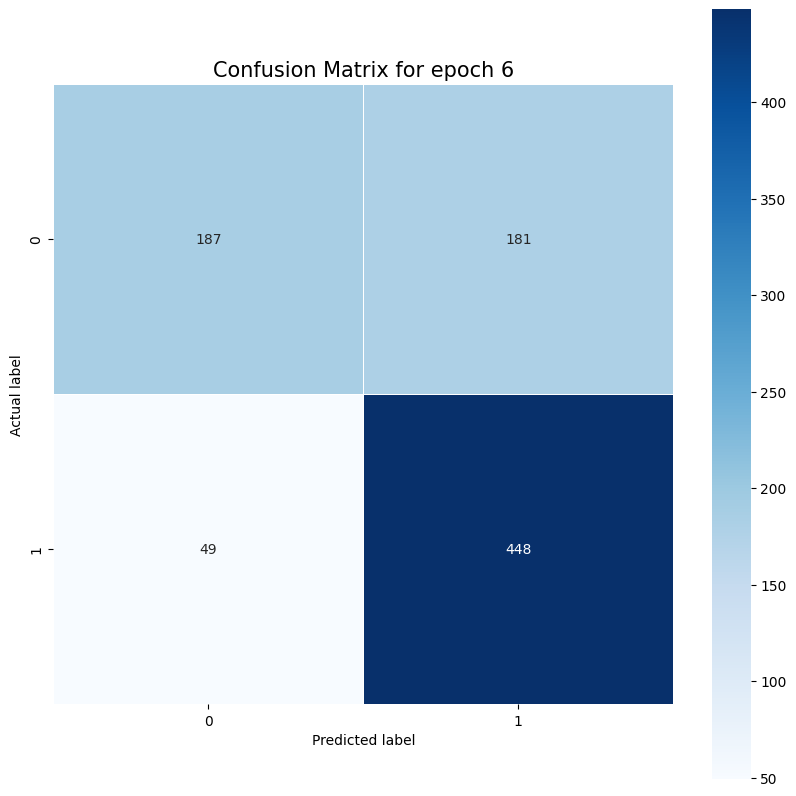

Epoch 7/10:   0%|          | 1/865 [00:04<1:07:22,  4.68s/it]

Accuracy of the model after epoch 7: 0.0%


Epoch 7/10:   0%|          | 2/865 [00:08<1:03:21,  4.40s/it]

Accuracy of the model after epoch 7: 0.0%


Epoch 7/10:   0%|          | 3/865 [00:13<1:04:18,  4.48s/it]

Accuracy of the model after epoch 7: 33.333333333333336%


Epoch 7/10:   0%|          | 4/865 [00:18<1:08:55,  4.80s/it]

Accuracy of the model after epoch 7: 25.0%


Epoch 7/10:   1%|          | 5/865 [00:23<1:07:23,  4.70s/it]

Accuracy of the model after epoch 7: 20.0%


Epoch 7/10:   1%|          | 6/865 [00:25<57:19,  4.00s/it]  

Accuracy of the model after epoch 7: 33.333333333333336%


Epoch 7/10:   1%|          | 7/865 [00:30<58:40,  4.10s/it]

Accuracy of the model after epoch 7: 42.857142857142854%


Epoch 7/10:   1%|          | 8/865 [00:34<1:00:51,  4.26s/it]

Accuracy of the model after epoch 7: 37.5%


Epoch 7/10:   1%|          | 9/865 [00:39<1:02:45,  4.40s/it]

Accuracy of the model after epoch 7: 44.44444444444444%


Epoch 7/10:   1%|          | 10/865 [00:42<55:07,  3.87s/it] 

Accuracy of the model after epoch 7: 50.0%


Epoch 7/10:   1%|▏         | 11/865 [00:46<58:52,  4.14s/it]

Accuracy of the model after epoch 7: 54.54545454545455%


Epoch 7/10:   1%|▏         | 12/865 [00:49<51:15,  3.61s/it]

Accuracy of the model after epoch 7: 58.333333333333336%


Epoch 7/10:   2%|▏         | 13/865 [00:52<47:15,  3.33s/it]

Accuracy of the model after epoch 7: 61.53846153846154%


Epoch 7/10:   2%|▏         | 14/865 [00:56<50:46,  3.58s/it]

Accuracy of the model after epoch 7: 64.28571428571429%


Epoch 7/10:   2%|▏         | 15/865 [01:00<54:07,  3.82s/it]

Accuracy of the model after epoch 7: 60.0%


Epoch 7/10:   2%|▏         | 16/865 [01:04<55:07,  3.90s/it]

Accuracy of the model after epoch 7: 62.5%


Epoch 7/10:   2%|▏         | 17/865 [01:08<56:58,  4.03s/it]

Accuracy of the model after epoch 7: 64.70588235294117%


Epoch 7/10:   2%|▏         | 18/865 [01:13<57:55,  4.10s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   2%|▏         | 19/865 [01:18<1:01:05,  4.33s/it]

Accuracy of the model after epoch 7: 63.1578947368421%


Epoch 7/10:   2%|▏         | 20/865 [01:22<1:01:58,  4.40s/it]

Accuracy of the model after epoch 7: 65.0%


Epoch 7/10:   2%|▏         | 21/865 [01:26<1:01:20,  4.36s/it]

Accuracy of the model after epoch 7: 61.904761904761905%


Epoch 7/10:   3%|▎         | 22/865 [01:31<1:01:23,  4.37s/it]

Accuracy of the model after epoch 7: 63.63636363636363%


Epoch 7/10:   3%|▎         | 23/865 [01:36<1:02:30,  4.45s/it]

Accuracy of the model after epoch 7: 65.21739130434783%


Epoch 7/10:   3%|▎         | 24/865 [01:38<53:57,  3.85s/it]  

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   3%|▎         | 25/865 [01:43<57:07,  4.08s/it]

Accuracy of the model after epoch 7: 68.0%


Epoch 7/10:   3%|▎         | 26/865 [01:47<57:33,  4.12s/it]

Accuracy of the model after epoch 7: 69.23076923076923%


Epoch 7/10:   3%|▎         | 27/865 [01:51<58:00,  4.15s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   3%|▎         | 28/865 [01:56<1:00:04,  4.31s/it]

Accuracy of the model after epoch 7: 67.85714285714286%


Epoch 7/10:   3%|▎         | 29/865 [02:01<1:04:23,  4.62s/it]

Accuracy of the model after epoch 7: 65.51724137931035%


Epoch 7/10:   3%|▎         | 30/865 [02:04<57:07,  4.10s/it]  

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   4%|▎         | 31/865 [02:07<50:52,  3.66s/it]

Accuracy of the model after epoch 7: 67.74193548387096%


Epoch 7/10:   4%|▎         | 32/865 [02:11<53:51,  3.88s/it]

Accuracy of the model after epoch 7: 68.75%


Epoch 7/10:   4%|▍         | 33/865 [02:15<55:44,  4.02s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   4%|▍         | 34/865 [02:20<57:09,  4.13s/it]

Accuracy of the model after epoch 7: 64.70588235294117%


Epoch 7/10:   4%|▍         | 35/865 [02:24<58:53,  4.26s/it]

Accuracy of the model after epoch 7: 65.71428571428571%


Epoch 7/10:   4%|▍         | 36/865 [02:27<51:53,  3.76s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   4%|▍         | 37/865 [02:29<46:15,  3.35s/it]

Accuracy of the model after epoch 7: 67.56756756756756%


Epoch 7/10:   4%|▍         | 38/865 [02:34<50:12,  3.64s/it]

Accuracy of the model after epoch 7: 65.78947368421052%


Epoch 7/10:   5%|▍         | 39/865 [02:38<55:28,  4.03s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   5%|▍         | 40/865 [02:43<57:22,  4.17s/it]

Accuracy of the model after epoch 7: 65.0%


Epoch 7/10:   5%|▍         | 41/865 [02:48<59:48,  4.35s/it]

Accuracy of the model after epoch 7: 63.41463414634146%


Epoch 7/10:   5%|▍         | 42/865 [02:52<58:42,  4.28s/it]

Accuracy of the model after epoch 7: 64.28571428571429%


Epoch 7/10:   5%|▍         | 43/865 [02:57<1:00:51,  4.44s/it]

Accuracy of the model after epoch 7: 65.11627906976744%


Epoch 7/10:   5%|▌         | 44/865 [03:02<1:03:54,  4.67s/it]

Accuracy of the model after epoch 7: 65.9090909090909%


Epoch 7/10:   5%|▌         | 45/865 [03:07<1:03:43,  4.66s/it]

Accuracy of the model after epoch 7: 64.44444444444444%


Epoch 7/10:   5%|▌         | 46/865 [03:09<55:19,  4.05s/it]  

Accuracy of the model after epoch 7: 65.21739130434783%


Epoch 7/10:   5%|▌         | 47/865 [03:11<48:11,  3.54s/it]

Accuracy of the model after epoch 7: 65.95744680851064%


Epoch 7/10:   6%|▌         | 48/865 [03:14<44:04,  3.24s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   6%|▌         | 49/865 [03:18<48:40,  3.58s/it]

Accuracy of the model after epoch 7: 67.34693877551021%


Epoch 7/10:   6%|▌         | 50/865 [03:23<54:21,  4.00s/it]

Accuracy of the model after epoch 7: 66.0%


Epoch 7/10:   6%|▌         | 51/865 [03:28<55:40,  4.10s/it]

Accuracy of the model after epoch 7: 64.70588235294117%


Epoch 7/10:   6%|▌         | 52/865 [03:32<55:56,  4.13s/it]

Accuracy of the model after epoch 7: 65.38461538461539%


Epoch 7/10:   6%|▌         | 53/865 [03:36<57:01,  4.21s/it]

Accuracy of the model after epoch 7: 64.15094339622641%


Epoch 7/10:   6%|▌         | 54/865 [03:41<1:00:09,  4.45s/it]

Accuracy of the model after epoch 7: 64.81481481481481%


Epoch 7/10:   6%|▋         | 55/865 [03:47<1:03:01,  4.67s/it]

Accuracy of the model after epoch 7: 63.63636363636363%


Epoch 7/10:   6%|▋         | 56/865 [03:49<55:10,  4.09s/it]  

Accuracy of the model after epoch 7: 64.28571428571429%


Epoch 7/10:   7%|▋         | 57/865 [03:53<55:30,  4.12s/it]

Accuracy of the model after epoch 7: 64.91228070175438%


Epoch 7/10:   7%|▋         | 58/865 [03:58<55:37,  4.14s/it]

Accuracy of the model after epoch 7: 65.51724137931035%


Epoch 7/10:   7%|▋         | 59/865 [04:03<1:00:00,  4.47s/it]

Accuracy of the model after epoch 7: 66.10169491525424%


Epoch 7/10:   7%|▋         | 60/865 [04:08<1:00:49,  4.53s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   7%|▋         | 61/865 [04:12<1:00:42,  4.53s/it]

Accuracy of the model after epoch 7: 65.57377049180327%


Epoch 7/10:   7%|▋         | 62/865 [04:16<58:49,  4.39s/it]  

Accuracy of the model after epoch 7: 66.12903225806451%


Epoch 7/10:   7%|▋         | 63/865 [04:21<1:00:21,  4.52s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   7%|▋         | 64/865 [04:26<1:03:49,  4.78s/it]

Accuracy of the model after epoch 7: 67.1875%


Epoch 7/10:   8%|▊         | 65/865 [04:31<1:03:06,  4.73s/it]

Accuracy of the model after epoch 7: 67.6923076923077%


Epoch 7/10:   8%|▊         | 66/865 [04:36<1:02:54,  4.72s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   8%|▊         | 67/865 [04:40<1:00:29,  4.55s/it]

Accuracy of the model after epoch 7: 67.16417910447761%


Epoch 7/10:   8%|▊         | 68/865 [04:44<1:00:21,  4.54s/it]

Accuracy of the model after epoch 7: 67.6470588235294%


Epoch 7/10:   8%|▊         | 69/865 [04:49<1:00:21,  4.55s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   8%|▊         | 70/865 [04:53<1:00:08,  4.54s/it]

Accuracy of the model after epoch 7: 67.14285714285714%


Epoch 7/10:   8%|▊         | 71/865 [04:58<59:38,  4.51s/it]  

Accuracy of the model after epoch 7: 67.6056338028169%


Epoch 7/10:   8%|▊         | 72/865 [05:02<58:04,  4.39s/it]

Accuracy of the model after epoch 7: 68.05555555555556%


Epoch 7/10:   8%|▊         | 73/865 [05:07<1:00:49,  4.61s/it]

Accuracy of the model after epoch 7: 68.4931506849315%


Epoch 7/10:   9%|▊         | 74/865 [05:10<52:41,  4.00s/it]  

Accuracy of the model after epoch 7: 68.91891891891892%


Epoch 7/10:   9%|▊         | 75/865 [05:14<54:09,  4.11s/it]

Accuracy of the model after epoch 7: 69.33333333333333%


Epoch 7/10:   9%|▉         | 76/865 [05:17<48:11,  3.66s/it]

Accuracy of the model after epoch 7: 68.42105263157895%


Epoch 7/10:   9%|▉         | 77/865 [05:19<43:37,  3.32s/it]

Accuracy of the model after epoch 7: 68.83116883116882%


Epoch 7/10:   9%|▉         | 78/865 [05:24<47:43,  3.64s/it]

Accuracy of the model after epoch 7: 67.94871794871794%


Epoch 7/10:   9%|▉         | 79/865 [05:29<53:02,  4.05s/it]

Accuracy of the model after epoch 7: 67.0886075949367%


Epoch 7/10:   9%|▉         | 80/865 [05:33<55:31,  4.24s/it]

Accuracy of the model after epoch 7: 66.25%


Epoch 7/10:   9%|▉         | 81/865 [05:37<54:59,  4.21s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:   9%|▉         | 82/865 [05:40<48:20,  3.70s/it]

Accuracy of the model after epoch 7: 65.85365853658537%


Epoch 7/10:  10%|▉         | 83/865 [05:44<50:01,  3.84s/it]

Accuracy of the model after epoch 7: 66.26506024096386%


Epoch 7/10:  10%|▉         | 84/865 [05:49<52:36,  4.04s/it]

Accuracy of the model after epoch 7: 65.47619047619048%


Epoch 7/10:  10%|▉         | 85/865 [05:53<54:24,  4.19s/it]

Accuracy of the model after epoch 7: 65.88235294117646%


Epoch 7/10:  10%|▉         | 86/865 [05:58<57:12,  4.41s/it]

Accuracy of the model after epoch 7: 66.27906976744185%


Epoch 7/10:  10%|█         | 87/865 [06:02<56:54,  4.39s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:  10%|█         | 88/865 [06:07<58:28,  4.52s/it]

Accuracy of the model after epoch 7: 67.04545454545455%


Epoch 7/10:  10%|█         | 89/865 [06:13<1:01:56,  4.79s/it]

Accuracy of the model after epoch 7: 67.41573033707866%


Epoch 7/10:  10%|█         | 90/865 [06:17<1:01:18,  4.75s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:  11%|█         | 91/865 [06:22<1:00:56,  4.72s/it]

Accuracy of the model after epoch 7: 67.03296703296704%


Epoch 7/10:  11%|█         | 92/865 [06:26<59:04,  4.59s/it]  

Accuracy of the model after epoch 7: 66.30434782608695%


Epoch 7/10:  11%|█         | 93/865 [06:31<59:43,  4.64s/it]

Accuracy of the model after epoch 7: 65.59139784946237%


Epoch 7/10:  11%|█         | 94/865 [06:33<51:02,  3.97s/it]

Accuracy of the model after epoch 7: 65.95744680851064%


Epoch 7/10:  11%|█         | 95/865 [06:38<53:10,  4.14s/it]

Accuracy of the model after epoch 7: 66.3157894736842%


Epoch 7/10:  11%|█         | 96/865 [06:43<55:21,  4.32s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:  11%|█         | 97/865 [06:47<55:31,  4.34s/it]

Accuracy of the model after epoch 7: 65.97938144329896%


Epoch 7/10:  11%|█▏        | 98/865 [06:51<55:26,  4.34s/it]

Accuracy of the model after epoch 7: 66.3265306122449%


Epoch 7/10:  11%|█▏        | 99/865 [06:56<56:16,  4.41s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:  12%|█▏        | 100/865 [07:01<56:47,  4.45s/it]

Accuracy of the model after epoch 7: 66.0%


Epoch 7/10:  12%|█▏        | 101/865 [07:05<56:01,  4.40s/it]

Accuracy of the model after epoch 7: 65.34653465346534%


Epoch 7/10:  12%|█▏        | 102/865 [07:09<55:19,  4.35s/it]

Accuracy of the model after epoch 7: 65.68627450980392%


Epoch 7/10:  12%|█▏        | 103/865 [07:12<48:46,  3.84s/it]

Accuracy of the model after epoch 7: 66.01941747572816%


Epoch 7/10:  12%|█▏        | 104/865 [07:16<51:00,  4.02s/it]

Accuracy of the model after epoch 7: 65.38461538461539%


Epoch 7/10:  12%|█▏        | 105/865 [07:21<55:32,  4.38s/it]

Accuracy of the model after epoch 7: 65.71428571428571%


Epoch 7/10:  12%|█▏        | 106/865 [07:26<55:07,  4.36s/it]

Accuracy of the model after epoch 7: 66.0377358490566%


Epoch 7/10:  12%|█▏        | 107/865 [07:28<47:51,  3.79s/it]

Accuracy of the model after epoch 7: 66.35514018691589%


Epoch 7/10:  12%|█▏        | 108/865 [07:33<50:29,  4.00s/it]

Accuracy of the model after epoch 7: 65.74074074074075%


Epoch 7/10:  13%|█▎        | 109/865 [07:37<53:29,  4.24s/it]

Accuracy of the model after epoch 7: 65.13761467889908%


Epoch 7/10:  13%|█▎        | 110/865 [07:42<56:31,  4.49s/it]

Accuracy of the model after epoch 7: 65.45454545454545%


Epoch 7/10:  13%|█▎        | 111/865 [07:47<56:11,  4.47s/it]

Accuracy of the model after epoch 7: 64.86486486486487%


Epoch 7/10:  13%|█▎        | 112/865 [07:51<54:50,  4.37s/it]

Accuracy of the model after epoch 7: 65.17857142857143%


Epoch 7/10:  13%|█▎        | 113/865 [07:55<54:46,  4.37s/it]

Accuracy of the model after epoch 7: 65.48672566371681%


Epoch 7/10:  13%|█▎        | 114/865 [07:58<48:00,  3.84s/it]

Accuracy of the model after epoch 7: 65.78947368421052%


Epoch 7/10:  13%|█▎        | 115/865 [08:03<51:23,  4.11s/it]

Accuracy of the model after epoch 7: 66.08695652173913%


Epoch 7/10:  13%|█▎        | 116/865 [08:07<52:54,  4.24s/it]

Accuracy of the model after epoch 7: 66.37931034482759%


Epoch 7/10:  14%|█▎        | 117/865 [08:12<53:20,  4.28s/it]

Accuracy of the model after epoch 7: 66.66666666666667%


Epoch 7/10:  14%|█▎        | 118/865 [08:16<55:13,  4.44s/it]

Accuracy of the model after epoch 7: 66.94915254237289%


Epoch 7/10:  14%|█▍        | 119/865 [08:22<58:15,  4.69s/it]

Accuracy of the model after epoch 7: 67.22689075630252%


Epoch 7/10:  14%|█▍        | 120/865 [08:26<57:01,  4.59s/it]

Accuracy of the model after epoch 7: 67.5%


Epoch 7/10:  14%|█▍        | 121/865 [08:31<56:59,  4.60s/it]

Accuracy of the model after epoch 7: 67.76859504132231%


Epoch 7/10:  14%|█▍        | 122/865 [08:33<48:11,  3.89s/it]

Accuracy of the model after epoch 7: 68.0327868852459%


Epoch 7/10:  14%|█▍        | 123/865 [08:37<49:35,  4.01s/it]

Accuracy of the model after epoch 7: 68.29268292682927%


Epoch 7/10:  14%|█▍        | 124/865 [08:42<52:51,  4.28s/it]

Accuracy of the model after epoch 7: 67.74193548387096%


Epoch 7/10:  14%|█▍        | 125/865 [08:47<53:41,  4.35s/it]

Accuracy of the model after epoch 7: 68.0%


Epoch 7/10:  15%|█▍        | 126/865 [08:49<47:00,  3.82s/it]

Accuracy of the model after epoch 7: 68.25396825396825%


Epoch 7/10:  15%|█▍        | 127/865 [08:54<48:40,  3.96s/it]

Accuracy of the model after epoch 7: 68.50393700787401%


Epoch 7/10:  15%|█▍        | 128/865 [08:56<42:39,  3.47s/it]

Accuracy of the model after epoch 7: 68.75%


Epoch 7/10:  15%|█▍        | 129/865 [09:00<46:16,  3.77s/it]

Accuracy of the model after epoch 7: 68.9922480620155%


Epoch 7/10:  15%|█▌        | 130/865 [09:03<42:49,  3.50s/it]

Accuracy of the model after epoch 7: 69.23076923076923%


Epoch 7/10:  15%|█▌        | 131/865 [09:08<45:43,  3.74s/it]

Accuracy of the model after epoch 7: 69.46564885496183%


Epoch 7/10:  15%|█▌        | 132/865 [09:12<47:16,  3.87s/it]

Accuracy of the model after epoch 7: 69.6969696969697%


Epoch 7/10:  15%|█▌        | 133/865 [09:14<42:43,  3.50s/it]

Accuracy of the model after epoch 7: 69.92481203007519%


Epoch 7/10:  15%|█▌        | 134/865 [09:17<39:18,  3.23s/it]

Accuracy of the model after epoch 7: 70.14925373134328%


Epoch 7/10:  16%|█▌        | 135/865 [09:20<37:06,  3.05s/it]

Accuracy of the model after epoch 7: 70.37037037037037%


Epoch 7/10:  16%|█▌        | 136/865 [09:24<41:57,  3.45s/it]

Accuracy of the model after epoch 7: 70.58823529411765%


Epoch 7/10:  16%|█▌        | 137/865 [09:28<45:03,  3.71s/it]

Accuracy of the model after epoch 7: 70.8029197080292%


Epoch 7/10:  16%|█▌        | 138/865 [09:32<46:38,  3.85s/it]

Accuracy of the model after epoch 7: 71.01449275362319%


Epoch 7/10:  16%|█▌        | 139/865 [09:37<49:52,  4.12s/it]

Accuracy of the model after epoch 7: 71.22302158273381%


Epoch 7/10:  16%|█▌        | 140/865 [09:42<50:51,  4.21s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  16%|█▋        | 141/865 [09:46<53:09,  4.41s/it]

Accuracy of the model after epoch 7: 71.63120567375887%


Epoch 7/10:  16%|█▋        | 142/865 [09:49<46:40,  3.87s/it]

Accuracy of the model after epoch 7: 71.83098591549296%


Epoch 7/10:  17%|█▋        | 143/865 [09:53<48:00,  3.99s/it]

Accuracy of the model after epoch 7: 72.02797202797203%


Epoch 7/10:  17%|█▋        | 144/865 [09:58<51:51,  4.32s/it]

Accuracy of the model after epoch 7: 72.22222222222223%


Epoch 7/10:  17%|█▋        | 145/865 [10:03<52:38,  4.39s/it]

Accuracy of the model after epoch 7: 72.41379310344827%


Epoch 7/10:  17%|█▋        | 146/865 [10:08<53:12,  4.44s/it]

Accuracy of the model after epoch 7: 72.6027397260274%


Epoch 7/10:  17%|█▋        | 147/865 [10:10<46:53,  3.92s/it]

Accuracy of the model after epoch 7: 72.78911564625851%


Epoch 7/10:  17%|█▋        | 148/865 [10:12<40:31,  3.39s/it]

Accuracy of the model after epoch 7: 72.97297297297297%


Epoch 7/10:  17%|█▋        | 149/865 [10:17<44:18,  3.71s/it]

Accuracy of the model after epoch 7: 73.15436241610739%


Epoch 7/10:  17%|█▋        | 150/865 [10:20<41:12,  3.46s/it]

Accuracy of the model after epoch 7: 73.33333333333333%


Epoch 7/10:  17%|█▋        | 151/865 [10:22<37:53,  3.18s/it]

Accuracy of the model after epoch 7: 73.50993377483444%


Epoch 7/10:  18%|█▊        | 152/865 [10:26<41:26,  3.49s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  18%|█▊        | 153/865 [10:31<45:28,  3.83s/it]

Accuracy of the model after epoch 7: 73.85620915032679%


Epoch 7/10:  18%|█▊        | 154/865 [10:34<40:30,  3.42s/it]

Accuracy of the model after epoch 7: 74.02597402597402%


Epoch 7/10:  18%|█▊        | 155/865 [10:38<44:39,  3.77s/it]

Accuracy of the model after epoch 7: 74.19354838709677%


Epoch 7/10:  18%|█▊        | 156/865 [10:41<39:55,  3.38s/it]

Accuracy of the model after epoch 7: 73.71794871794872%


Epoch 7/10:  18%|█▊        | 157/865 [10:45<43:37,  3.70s/it]

Accuracy of the model after epoch 7: 73.88535031847134%


Epoch 7/10:  18%|█▊        | 158/865 [10:48<39:16,  3.33s/it]

Accuracy of the model after epoch 7: 74.0506329113924%


Epoch 7/10:  18%|█▊        | 159/865 [10:52<42:15,  3.59s/it]

Accuracy of the model after epoch 7: 74.21383647798743%


Epoch 7/10:  18%|█▊        | 160/865 [10:56<45:49,  3.90s/it]

Accuracy of the model after epoch 7: 74.375%


Epoch 7/10:  19%|█▊        | 161/865 [11:00<46:01,  3.92s/it]

Accuracy of the model after epoch 7: 74.53416149068323%


Epoch 7/10:  19%|█▊        | 162/865 [11:03<41:05,  3.51s/it]

Accuracy of the model after epoch 7: 74.07407407407408%


Epoch 7/10:  19%|█▉        | 163/865 [11:07<43:54,  3.75s/it]

Accuracy of the model after epoch 7: 73.61963190184049%


Epoch 7/10:  19%|█▉        | 164/865 [11:12<46:56,  4.02s/it]

Accuracy of the model after epoch 7: 73.78048780487805%


Epoch 7/10:  19%|█▉        | 165/865 [11:14<41:35,  3.56s/it]

Accuracy of the model after epoch 7: 73.93939393939394%


Epoch 7/10:  19%|█▉        | 166/865 [11:17<37:43,  3.24s/it]

Accuracy of the model after epoch 7: 74.09638554216868%


Epoch 7/10:  19%|█▉        | 167/865 [11:21<41:21,  3.55s/it]

Accuracy of the model after epoch 7: 74.25149700598803%


Epoch 7/10:  19%|█▉        | 168/865 [11:24<37:17,  3.21s/it]

Accuracy of the model after epoch 7: 73.80952380952381%


Epoch 7/10:  20%|█▉        | 169/865 [11:26<34:15,  2.95s/it]

Accuracy of the model after epoch 7: 73.96449704142012%


Epoch 7/10:  20%|█▉        | 170/865 [11:30<39:46,  3.43s/it]

Accuracy of the model after epoch 7: 73.52941176470588%


Epoch 7/10:  20%|█▉        | 171/865 [11:33<36:43,  3.17s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  20%|█▉        | 172/865 [11:37<40:43,  3.53s/it]

Accuracy of the model after epoch 7: 73.83720930232558%


Epoch 7/10:  20%|██        | 173/865 [11:42<43:04,  3.73s/it]

Accuracy of the model after epoch 7: 73.98843930635839%


Epoch 7/10:  20%|██        | 174/865 [11:44<38:25,  3.34s/it]

Accuracy of the model after epoch 7: 74.13793103448276%


Epoch 7/10:  20%|██        | 175/865 [11:49<42:59,  3.74s/it]

Accuracy of the model after epoch 7: 74.28571428571429%


Epoch 7/10:  20%|██        | 176/865 [11:51<37:47,  3.29s/it]

Accuracy of the model after epoch 7: 74.43181818181819%


Epoch 7/10:  20%|██        | 177/865 [11:55<40:48,  3.56s/it]

Accuracy of the model after epoch 7: 74.57627118644068%


Epoch 7/10:  21%|██        | 178/865 [12:00<45:15,  3.95s/it]

Accuracy of the model after epoch 7: 74.71910112359551%


Epoch 7/10:  21%|██        | 179/865 [12:05<47:31,  4.16s/it]

Accuracy of the model after epoch 7: 74.86033519553072%


Epoch 7/10:  21%|██        | 180/865 [12:09<48:08,  4.22s/it]

Accuracy of the model after epoch 7: 75.0%


Epoch 7/10:  21%|██        | 181/865 [12:13<47:40,  4.18s/it]

Accuracy of the model after epoch 7: 75.13812154696133%


Epoch 7/10:  21%|██        | 182/865 [12:16<42:10,  3.71s/it]

Accuracy of the model after epoch 7: 74.72527472527473%


Epoch 7/10:  21%|██        | 183/865 [12:20<44:37,  3.93s/it]

Accuracy of the model after epoch 7: 74.86338797814207%


Epoch 7/10:  21%|██▏       | 184/865 [12:25<48:10,  4.24s/it]

Accuracy of the model after epoch 7: 74.45652173913044%


Epoch 7/10:  21%|██▏       | 185/865 [12:29<48:41,  4.30s/it]

Accuracy of the model after epoch 7: 74.5945945945946%


Epoch 7/10:  22%|██▏       | 186/865 [12:34<49:57,  4.41s/it]

Accuracy of the model after epoch 7: 74.73118279569893%


Epoch 7/10:  22%|██▏       | 187/865 [12:38<49:21,  4.37s/it]

Accuracy of the model after epoch 7: 74.8663101604278%


Epoch 7/10:  22%|██▏       | 188/865 [12:43<51:24,  4.56s/it]

Accuracy of the model after epoch 7: 74.46808510638297%


Epoch 7/10:  22%|██▏       | 189/865 [12:49<53:43,  4.77s/it]

Accuracy of the model after epoch 7: 74.07407407407408%


Epoch 7/10:  22%|██▏       | 190/865 [12:53<52:26,  4.66s/it]

Accuracy of the model after epoch 7: 74.21052631578948%


Epoch 7/10:  22%|██▏       | 191/865 [12:57<51:01,  4.54s/it]

Accuracy of the model after epoch 7: 74.3455497382199%


Epoch 7/10:  22%|██▏       | 192/865 [13:02<49:59,  4.46s/it]

Accuracy of the model after epoch 7: 74.47916666666667%


Epoch 7/10:  22%|██▏       | 193/865 [13:06<50:50,  4.54s/it]

Accuracy of the model after epoch 7: 74.61139896373057%


Epoch 7/10:  22%|██▏       | 194/865 [13:11<51:10,  4.58s/it]

Accuracy of the model after epoch 7: 74.74226804123711%


Epoch 7/10:  23%|██▎       | 195/865 [13:14<44:53,  4.02s/it]

Accuracy of the model after epoch 7: 74.35897435897436%


Epoch 7/10:  23%|██▎       | 196/865 [13:18<47:06,  4.22s/it]

Accuracy of the model after epoch 7: 74.48979591836735%


Epoch 7/10:  23%|██▎       | 197/865 [13:21<41:43,  3.75s/it]

Accuracy of the model after epoch 7: 74.61928934010152%


Epoch 7/10:  23%|██▎       | 198/865 [13:26<44:02,  3.96s/it]

Accuracy of the model after epoch 7: 74.24242424242425%


Epoch 7/10:  23%|██▎       | 199/865 [13:30<45:46,  4.12s/it]

Accuracy of the model after epoch 7: 74.37185929648241%


Epoch 7/10:  23%|██▎       | 200/865 [13:33<41:28,  3.74s/it]

Accuracy of the model after epoch 7: 74.5%


Epoch 7/10:  23%|██▎       | 201/865 [13:37<43:20,  3.92s/it]

Accuracy of the model after epoch 7: 74.12935323383084%


Epoch 7/10:  23%|██▎       | 202/865 [13:41<44:26,  4.02s/it]

Accuracy of the model after epoch 7: 74.25742574257426%


Epoch 7/10:  23%|██▎       | 203/865 [13:44<39:16,  3.56s/it]

Accuracy of the model after epoch 7: 73.89162561576354%


Epoch 7/10:  24%|██▎       | 204/865 [13:48<41:37,  3.78s/it]

Accuracy of the model after epoch 7: 74.01960784313725%


Epoch 7/10:  24%|██▎       | 205/865 [13:51<38:39,  3.51s/it]

Accuracy of the model after epoch 7: 73.65853658536585%


Epoch 7/10:  24%|██▍       | 206/865 [13:56<41:22,  3.77s/it]

Accuracy of the model after epoch 7: 73.7864077669903%


Epoch 7/10:  24%|██▍       | 207/865 [14:00<42:52,  3.91s/it]

Accuracy of the model after epoch 7: 73.91304347826087%


Epoch 7/10:  24%|██▍       | 208/865 [14:04<45:25,  4.15s/it]

Accuracy of the model after epoch 7: 74.03846153846153%


Epoch 7/10:  24%|██▍       | 209/865 [14:07<40:17,  3.68s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  24%|██▍       | 210/865 [14:10<36:26,  3.34s/it]

Accuracy of the model after epoch 7: 73.33333333333333%


Epoch 7/10:  24%|██▍       | 211/865 [14:12<33:23,  3.06s/it]

Accuracy of the model after epoch 7: 73.45971563981043%


Epoch 7/10:  25%|██▍       | 212/865 [14:16<37:26,  3.44s/it]

Accuracy of the model after epoch 7: 73.11320754716981%


Epoch 7/10:  25%|██▍       | 213/865 [14:19<34:57,  3.22s/it]

Accuracy of the model after epoch 7: 73.2394366197183%


Epoch 7/10:  25%|██▍       | 214/865 [14:22<32:52,  3.03s/it]

Accuracy of the model after epoch 7: 73.3644859813084%


Epoch 7/10:  25%|██▍       | 215/865 [14:24<31:38,  2.92s/it]

Accuracy of the model after epoch 7: 73.48837209302326%


Epoch 7/10:  25%|██▍       | 216/865 [14:28<35:45,  3.31s/it]

Accuracy of the model after epoch 7: 73.61111111111111%


Epoch 7/10:  25%|██▌       | 217/865 [14:33<38:58,  3.61s/it]

Accuracy of the model after epoch 7: 73.27188940092167%


Epoch 7/10:  25%|██▌       | 218/865 [14:35<35:18,  3.27s/it]

Accuracy of the model after epoch 7: 72.93577981651376%


Epoch 7/10:  25%|██▌       | 219/865 [14:37<31:45,  2.95s/it]

Accuracy of the model after epoch 7: 73.05936073059361%


Epoch 7/10:  25%|██▌       | 220/865 [14:43<39:32,  3.68s/it]

Accuracy of the model after epoch 7: 72.72727272727273%


Epoch 7/10:  26%|██▌       | 221/865 [14:45<34:51,  3.25s/it]

Accuracy of the model after epoch 7: 72.39819004524887%


Epoch 7/10:  26%|██▌       | 222/865 [14:50<39:08,  3.65s/it]

Accuracy of the model after epoch 7: 72.52252252252252%


Epoch 7/10:  26%|██▌       | 223/865 [14:54<41:28,  3.88s/it]

Accuracy of the model after epoch 7: 72.19730941704036%


Epoch 7/10:  26%|██▌       | 224/865 [14:57<36:54,  3.46s/it]

Accuracy of the model after epoch 7: 72.32142857142857%


Epoch 7/10:  26%|██▌       | 225/865 [15:01<39:43,  3.72s/it]

Accuracy of the model after epoch 7: 72.44444444444444%


Epoch 7/10:  26%|██▌       | 226/865 [15:06<43:10,  4.05s/it]

Accuracy of the model after epoch 7: 72.56637168141593%


Epoch 7/10:  26%|██▌       | 227/865 [15:10<44:03,  4.14s/it]

Accuracy of the model after epoch 7: 72.68722466960352%


Epoch 7/10:  26%|██▋       | 228/865 [15:15<46:20,  4.37s/it]

Accuracy of the model after epoch 7: 72.80701754385964%


Epoch 7/10:  26%|██▋       | 229/865 [15:18<40:47,  3.85s/it]

Accuracy of the model after epoch 7: 72.92576419213974%


Epoch 7/10:  27%|██▋       | 230/865 [15:21<37:40,  3.56s/it]

Accuracy of the model after epoch 7: 72.6086956521739%


Epoch 7/10:  27%|██▋       | 231/865 [15:23<34:33,  3.27s/it]

Accuracy of the model after epoch 7: 72.72727272727273%


Epoch 7/10:  27%|██▋       | 232/865 [15:27<37:22,  3.54s/it]

Accuracy of the model after epoch 7: 72.41379310344827%


Epoch 7/10:  27%|██▋       | 233/865 [15:32<39:36,  3.76s/it]

Accuracy of the model after epoch 7: 72.53218884120172%


Epoch 7/10:  27%|██▋       | 234/865 [15:34<35:18,  3.36s/it]

Accuracy of the model after epoch 7: 72.64957264957265%


Epoch 7/10:  27%|██▋       | 235/865 [15:39<39:11,  3.73s/it]

Accuracy of the model after epoch 7: 72.34042553191489%


Epoch 7/10:  27%|██▋       | 236/865 [15:43<41:21,  3.94s/it]

Accuracy of the model after epoch 7: 72.45762711864407%


Epoch 7/10:  27%|██▋       | 237/865 [15:47<42:11,  4.03s/it]

Accuracy of the model after epoch 7: 72.15189873417721%


Epoch 7/10:  28%|██▊       | 238/865 [15:52<43:34,  4.17s/it]

Accuracy of the model after epoch 7: 72.26890756302521%


Epoch 7/10:  28%|██▊       | 239/865 [15:54<38:23,  3.68s/it]

Accuracy of the model after epoch 7: 72.38493723849372%


Epoch 7/10:  28%|██▊       | 240/865 [15:59<40:44,  3.91s/it]

Accuracy of the model after epoch 7: 72.08333333333333%


Epoch 7/10:  28%|██▊       | 241/865 [16:03<41:43,  4.01s/it]

Accuracy of the model after epoch 7: 72.19917012448133%


Epoch 7/10:  28%|██▊       | 242/865 [16:06<37:19,  3.59s/it]

Accuracy of the model after epoch 7: 72.31404958677686%


Epoch 7/10:  28%|██▊       | 243/865 [16:10<39:50,  3.84s/it]

Accuracy of the model after epoch 7: 72.42798353909465%


Epoch 7/10:  28%|██▊       | 244/865 [16:15<44:07,  4.26s/it]

Accuracy of the model after epoch 7: 72.54098360655738%


Epoch 7/10:  28%|██▊       | 245/865 [16:18<38:59,  3.77s/it]

Accuracy of the model after epoch 7: 72.65306122448979%


Epoch 7/10:  28%|██▊       | 246/865 [16:21<35:25,  3.43s/it]

Accuracy of the model after epoch 7: 72.35772357723577%


Epoch 7/10:  29%|██▊       | 247/865 [16:23<32:43,  3.18s/it]

Accuracy of the model after epoch 7: 72.46963562753037%


Epoch 7/10:  29%|██▊       | 248/865 [16:26<30:41,  2.98s/it]

Accuracy of the model after epoch 7: 72.58064516129032%


Epoch 7/10:  29%|██▉       | 249/865 [16:30<34:28,  3.36s/it]

Accuracy of the model after epoch 7: 72.28915662650603%


Epoch 7/10:  29%|██▉       | 250/865 [16:35<39:18,  3.83s/it]

Accuracy of the model after epoch 7: 72.4%


Epoch 7/10:  29%|██▉       | 251/865 [16:39<40:32,  3.96s/it]

Accuracy of the model after epoch 7: 72.11155378486056%


Epoch 7/10:  29%|██▉       | 252/865 [16:43<41:00,  4.01s/it]

Accuracy of the model after epoch 7: 72.22222222222223%


Epoch 7/10:  29%|██▉       | 253/865 [16:48<41:44,  4.09s/it]

Accuracy of the model after epoch 7: 72.33201581027669%


Epoch 7/10:  29%|██▉       | 254/865 [16:52<43:14,  4.25s/it]

Accuracy of the model after epoch 7: 72.44094488188976%


Epoch 7/10:  29%|██▉       | 255/865 [16:57<44:16,  4.36s/it]

Accuracy of the model after epoch 7: 72.54901960784314%


Epoch 7/10:  30%|██▉       | 256/865 [17:01<43:27,  4.28s/it]

Accuracy of the model after epoch 7: 72.65625%


Epoch 7/10:  30%|██▉       | 257/865 [17:03<37:37,  3.71s/it]

Accuracy of the model after epoch 7: 72.76264591439688%


Epoch 7/10:  30%|██▉       | 258/865 [17:08<39:39,  3.92s/it]

Accuracy of the model after epoch 7: 72.86821705426357%


Epoch 7/10:  30%|██▉       | 259/865 [17:12<42:13,  4.18s/it]

Accuracy of the model after epoch 7: 72.97297297297297%


Epoch 7/10:  30%|███       | 260/865 [17:17<44:06,  4.37s/it]

Accuracy of the model after epoch 7: 73.07692307692308%


Epoch 7/10:  30%|███       | 261/865 [17:22<44:15,  4.40s/it]

Accuracy of the model after epoch 7: 73.1800766283525%


Epoch 7/10:  30%|███       | 262/865 [17:26<44:48,  4.46s/it]

Accuracy of the model after epoch 7: 73.2824427480916%


Epoch 7/10:  30%|███       | 263/865 [17:31<44:55,  4.48s/it]

Accuracy of the model after epoch 7: 73.00380228136882%


Epoch 7/10:  31%|███       | 264/865 [17:36<45:35,  4.55s/it]

Accuracy of the model after epoch 7: 73.10606060606061%


Epoch 7/10:  31%|███       | 265/865 [17:38<39:42,  3.97s/it]

Accuracy of the model after epoch 7: 73.20754716981132%


Epoch 7/10:  31%|███       | 266/865 [17:43<41:17,  4.14s/it]

Accuracy of the model after epoch 7: 73.30827067669173%


Epoch 7/10:  31%|███       | 267/865 [17:45<35:57,  3.61s/it]

Accuracy of the model after epoch 7: 73.03370786516854%


Epoch 7/10:  31%|███       | 268/865 [17:49<37:46,  3.80s/it]

Accuracy of the model after epoch 7: 73.13432835820896%


Epoch 7/10:  31%|███       | 269/865 [17:54<40:28,  4.08s/it]

Accuracy of the model after epoch 7: 73.23420074349443%


Epoch 7/10:  31%|███       | 270/865 [17:59<43:39,  4.40s/it]

Accuracy of the model after epoch 7: 73.33333333333333%


Epoch 7/10:  31%|███▏      | 271/865 [18:03<43:05,  4.35s/it]

Accuracy of the model after epoch 7: 73.43173431734317%


Epoch 7/10:  31%|███▏      | 272/865 [18:06<37:23,  3.78s/it]

Accuracy of the model after epoch 7: 73.52941176470588%


Epoch 7/10:  32%|███▏      | 273/865 [18:10<38:54,  3.94s/it]

Accuracy of the model after epoch 7: 73.62637362637362%


Epoch 7/10:  32%|███▏      | 274/865 [18:13<34:19,  3.49s/it]

Accuracy of the model after epoch 7: 73.72262773722628%


Epoch 7/10:  32%|███▏      | 275/865 [18:17<37:32,  3.82s/it]

Accuracy of the model after epoch 7: 73.81818181818181%


Epoch 7/10:  32%|███▏      | 276/865 [18:22<39:56,  4.07s/it]

Accuracy of the model after epoch 7: 73.91304347826087%


Epoch 7/10:  32%|███▏      | 277/865 [18:26<40:33,  4.14s/it]

Accuracy of the model after epoch 7: 73.64620938628158%


Epoch 7/10:  32%|███▏      | 278/865 [18:29<35:49,  3.66s/it]

Accuracy of the model after epoch 7: 73.7410071942446%


Epoch 7/10:  32%|███▏      | 279/865 [18:33<38:48,  3.97s/it]

Accuracy of the model after epoch 7: 73.83512544802868%


Epoch 7/10:  32%|███▏      | 280/865 [18:36<34:56,  3.58s/it]

Accuracy of the model after epoch 7: 73.57142857142857%


Epoch 7/10:  32%|███▏      | 281/865 [18:41<37:45,  3.88s/it]

Accuracy of the model after epoch 7: 73.66548042704626%


Epoch 7/10:  33%|███▎      | 282/865 [18:45<39:18,  4.05s/it]

Accuracy of the model after epoch 7: 73.75886524822695%


Epoch 7/10:  33%|███▎      | 283/865 [18:50<41:00,  4.23s/it]

Accuracy of the model after epoch 7: 73.85159010600707%


Epoch 7/10:  33%|███▎      | 284/865 [18:55<42:44,  4.41s/it]

Accuracy of the model after epoch 7: 73.94366197183099%


Epoch 7/10:  33%|███▎      | 285/865 [19:00<44:41,  4.62s/it]

Accuracy of the model after epoch 7: 74.03508771929825%


Epoch 7/10:  33%|███▎      | 286/865 [19:04<43:23,  4.50s/it]

Accuracy of the model after epoch 7: 73.77622377622377%


Epoch 7/10:  33%|███▎      | 287/865 [19:08<43:00,  4.46s/it]

Accuracy of the model after epoch 7: 73.86759581881533%


Epoch 7/10:  33%|███▎      | 288/865 [19:13<43:05,  4.48s/it]

Accuracy of the model after epoch 7: 73.95833333333333%


Epoch 7/10:  33%|███▎      | 289/865 [19:15<37:15,  3.88s/it]

Accuracy of the model after epoch 7: 73.70242214532873%


Epoch 7/10:  34%|███▎      | 290/865 [19:18<33:49,  3.53s/it]

Accuracy of the model after epoch 7: 73.79310344827586%


Epoch 7/10:  34%|███▎      | 291/865 [19:22<35:54,  3.75s/it]

Accuracy of the model after epoch 7: 73.88316151202748%


Epoch 7/10:  34%|███▍      | 292/865 [19:26<37:06,  3.89s/it]

Accuracy of the model after epoch 7: 73.97260273972603%


Epoch 7/10:  34%|███▍      | 293/865 [19:31<38:13,  4.01s/it]

Accuracy of the model after epoch 7: 74.06143344709898%


Epoch 7/10:  34%|███▍      | 294/865 [19:35<39:27,  4.15s/it]

Accuracy of the model after epoch 7: 74.14965986394557%


Epoch 7/10:  34%|███▍      | 295/865 [19:40<41:00,  4.32s/it]

Accuracy of the model after epoch 7: 73.89830508474576%


Epoch 7/10:  34%|███▍      | 296/865 [19:44<41:00,  4.32s/it]

Accuracy of the model after epoch 7: 73.64864864864865%


Epoch 7/10:  34%|███▍      | 297/865 [19:49<41:00,  4.33s/it]

Accuracy of the model after epoch 7: 73.4006734006734%


Epoch 7/10:  34%|███▍      | 298/865 [19:54<43:36,  4.61s/it]

Accuracy of the model after epoch 7: 73.15436241610739%


Epoch 7/10:  35%|███▍      | 299/865 [19:59<45:29,  4.82s/it]

Accuracy of the model after epoch 7: 73.24414715719064%


Epoch 7/10:  35%|███▍      | 300/865 [20:04<44:08,  4.69s/it]

Accuracy of the model after epoch 7: 73.33333333333333%


Epoch 7/10:  35%|███▍      | 301/865 [20:08<44:13,  4.71s/it]

Accuracy of the model after epoch 7: 73.421926910299%


Epoch 7/10:  35%|███▍      | 302/865 [20:13<42:58,  4.58s/it]

Accuracy of the model after epoch 7: 73.50993377483444%


Epoch 7/10:  35%|███▌      | 303/865 [20:17<43:19,  4.62s/it]

Accuracy of the model after epoch 7: 73.5973597359736%


Epoch 7/10:  35%|███▌      | 304/865 [20:23<45:19,  4.85s/it]

Accuracy of the model after epoch 7: 73.35526315789474%


Epoch 7/10:  35%|███▌      | 305/865 [20:25<39:17,  4.21s/it]

Accuracy of the model after epoch 7: 73.44262295081967%


Epoch 7/10:  35%|███▌      | 306/865 [20:30<39:27,  4.24s/it]

Accuracy of the model after epoch 7: 73.52941176470588%


Epoch 7/10:  35%|███▌      | 307/865 [20:34<40:09,  4.32s/it]

Accuracy of the model after epoch 7: 73.61563517915309%


Epoch 7/10:  36%|███▌      | 308/865 [20:37<34:21,  3.70s/it]

Accuracy of the model after epoch 7: 73.7012987012987%


Epoch 7/10:  36%|███▌      | 309/865 [20:39<31:05,  3.36s/it]

Accuracy of the model after epoch 7: 73.46278317152104%


Epoch 7/10:  36%|███▌      | 310/865 [20:44<34:49,  3.76s/it]

Accuracy of the model after epoch 7: 73.54838709677419%


Epoch 7/10:  36%|███▌      | 311/865 [20:48<37:14,  4.03s/it]

Accuracy of the model after epoch 7: 73.63344051446946%


Epoch 7/10:  36%|███▌      | 312/865 [20:53<38:08,  4.14s/it]

Accuracy of the model after epoch 7: 73.3974358974359%


Epoch 7/10:  36%|███▌      | 313/865 [20:55<33:41,  3.66s/it]

Accuracy of the model after epoch 7: 73.1629392971246%


Epoch 7/10:  36%|███▋      | 314/865 [21:00<37:04,  4.04s/it]

Accuracy of the model after epoch 7: 72.92993630573248%


Epoch 7/10:  36%|███▋      | 315/865 [21:05<38:21,  4.18s/it]

Accuracy of the model after epoch 7: 73.01587301587301%


Epoch 7/10:  37%|███▋      | 316/865 [21:09<38:28,  4.20s/it]

Accuracy of the model after epoch 7: 73.10126582278481%


Epoch 7/10:  37%|███▋      | 317/865 [21:13<38:47,  4.25s/it]

Accuracy of the model after epoch 7: 73.18611987381703%


Epoch 7/10:  37%|███▋      | 318/865 [21:18<39:43,  4.36s/it]

Accuracy of the model after epoch 7: 73.27044025157232%


Epoch 7/10:  37%|███▋      | 319/865 [21:24<43:17,  4.76s/it]

Accuracy of the model after epoch 7: 73.04075235109718%


Epoch 7/10:  37%|███▋      | 320/865 [21:27<38:21,  4.22s/it]

Accuracy of the model after epoch 7: 73.125%


Epoch 7/10:  37%|███▋      | 321/865 [21:31<38:57,  4.30s/it]

Accuracy of the model after epoch 7: 73.20872274143302%


Epoch 7/10:  37%|███▋      | 322/865 [21:34<33:36,  3.71s/it]

Accuracy of the model after epoch 7: 72.98136645962732%


Epoch 7/10:  37%|███▋      | 323/865 [21:38<35:11,  3.90s/it]

Accuracy of the model after epoch 7: 72.75541795665634%


Epoch 7/10:  37%|███▋      | 324/865 [21:42<36:49,  4.08s/it]

Accuracy of the model after epoch 7: 72.53086419753086%


Epoch 7/10:  38%|███▊      | 325/865 [21:47<38:15,  4.25s/it]

Accuracy of the model after epoch 7: 72.61538461538461%


Epoch 7/10:  38%|███▊      | 326/865 [21:51<38:14,  4.26s/it]

Accuracy of the model after epoch 7: 72.69938650306749%


Epoch 7/10:  38%|███▊      | 327/865 [21:56<39:14,  4.38s/it]

Accuracy of the model after epoch 7: 72.78287461773701%


Epoch 7/10:  38%|███▊      | 328/865 [22:01<39:42,  4.44s/it]

Accuracy of the model after epoch 7: 72.86585365853658%


Epoch 7/10:  38%|███▊      | 329/865 [22:03<34:42,  3.89s/it]

Accuracy of the model after epoch 7: 72.94832826747721%


Epoch 7/10:  38%|███▊      | 330/865 [22:08<37:54,  4.25s/it]

Accuracy of the model after epoch 7: 72.72727272727273%


Epoch 7/10:  38%|███▊      | 331/865 [22:13<38:12,  4.29s/it]

Accuracy of the model after epoch 7: 72.50755287009063%


Epoch 7/10:  38%|███▊      | 332/865 [22:17<38:06,  4.29s/it]

Accuracy of the model after epoch 7: 72.59036144578313%


Epoch 7/10:  38%|███▊      | 333/865 [22:21<38:03,  4.29s/it]

Accuracy of the model after epoch 7: 72.67267267267268%


Epoch 7/10:  39%|███▊      | 334/865 [22:26<39:07,  4.42s/it]

Accuracy of the model after epoch 7: 72.75449101796407%


Epoch 7/10:  39%|███▊      | 335/865 [22:31<40:01,  4.53s/it]

Accuracy of the model after epoch 7: 72.83582089552239%


Epoch 7/10:  39%|███▉      | 336/865 [22:35<39:25,  4.47s/it]

Accuracy of the model after epoch 7: 72.61904761904762%


Epoch 7/10:  39%|███▉      | 337/865 [22:38<34:25,  3.91s/it]

Accuracy of the model after epoch 7: 72.70029673590504%


Epoch 7/10:  39%|███▉      | 338/865 [22:40<30:28,  3.47s/it]

Accuracy of the model after epoch 7: 72.7810650887574%


Epoch 7/10:  39%|███▉      | 339/865 [22:45<33:14,  3.79s/it]

Accuracy of the model after epoch 7: 72.8613569321534%


Epoch 7/10:  39%|███▉      | 340/865 [22:49<34:54,  3.99s/it]

Accuracy of the model after epoch 7: 72.6470588235294%


Epoch 7/10:  39%|███▉      | 341/865 [22:53<35:25,  4.06s/it]

Accuracy of the model after epoch 7: 72.43401759530792%


Epoch 7/10:  40%|███▉      | 342/865 [22:57<35:45,  4.10s/it]

Accuracy of the model after epoch 7: 72.22222222222223%


Epoch 7/10:  40%|███▉      | 343/865 [23:00<32:00,  3.68s/it]

Accuracy of the model after epoch 7: 72.30320699708454%


Epoch 7/10:  40%|███▉      | 344/865 [23:05<33:41,  3.88s/it]

Accuracy of the model after epoch 7: 72.38372093023256%


Epoch 7/10:  40%|███▉      | 345/865 [23:07<30:38,  3.54s/it]

Accuracy of the model after epoch 7: 72.46376811594203%


Epoch 7/10:  40%|████      | 346/865 [23:12<32:36,  3.77s/it]

Accuracy of the model after epoch 7: 72.54335260115607%


Epoch 7/10:  40%|████      | 347/865 [23:16<34:17,  3.97s/it]

Accuracy of the model after epoch 7: 72.62247838616715%


Epoch 7/10:  40%|████      | 348/865 [23:21<35:53,  4.16s/it]

Accuracy of the model after epoch 7: 72.70114942528735%


Epoch 7/10:  40%|████      | 349/865 [23:25<37:38,  4.38s/it]

Accuracy of the model after epoch 7: 72.77936962750717%


Epoch 7/10:  40%|████      | 350/865 [23:28<33:11,  3.87s/it]

Accuracy of the model after epoch 7: 72.57142857142857%


Epoch 7/10:  41%|████      | 351/865 [23:33<35:00,  4.09s/it]

Accuracy of the model after epoch 7: 72.64957264957265%


Epoch 7/10:  41%|████      | 352/865 [23:37<35:36,  4.16s/it]

Accuracy of the model after epoch 7: 72.44318181818181%


Epoch 7/10:  41%|████      | 353/865 [23:41<35:48,  4.20s/it]

Accuracy of the model after epoch 7: 72.52124645892351%


Epoch 7/10:  41%|████      | 354/865 [23:46<37:19,  4.38s/it]

Accuracy of the model after epoch 7: 72.59887005649718%


Epoch 7/10:  41%|████      | 355/865 [23:49<33:09,  3.90s/it]

Accuracy of the model after epoch 7: 72.67605633802818%


Epoch 7/10:  41%|████      | 356/865 [23:53<33:59,  4.01s/it]

Accuracy of the model after epoch 7: 72.75280898876404%


Epoch 7/10:  41%|████▏     | 357/865 [23:57<34:33,  4.08s/it]

Accuracy of the model after epoch 7: 72.82913165266106%


Epoch 7/10:  41%|████▏     | 358/865 [24:02<35:51,  4.24s/it]

Accuracy of the model after epoch 7: 72.90502793296089%


Epoch 7/10:  42%|████▏     | 359/865 [24:07<36:52,  4.37s/it]

Accuracy of the model after epoch 7: 72.98050139275766%


Epoch 7/10:  42%|████▏     | 360/865 [24:12<37:44,  4.48s/it]

Accuracy of the model after epoch 7: 73.05555555555556%


Epoch 7/10:  42%|████▏     | 361/865 [24:16<38:05,  4.53s/it]

Accuracy of the model after epoch 7: 73.13019390581718%


Epoch 7/10:  42%|████▏     | 362/865 [24:19<33:11,  3.96s/it]

Accuracy of the model after epoch 7: 73.20441988950276%


Epoch 7/10:  42%|████▏     | 363/865 [24:24<35:53,  4.29s/it]

Accuracy of the model after epoch 7: 73.27823691460055%


Epoch 7/10:  42%|████▏     | 364/865 [24:29<36:53,  4.42s/it]

Accuracy of the model after epoch 7: 73.07692307692308%


Epoch 7/10:  42%|████▏     | 365/865 [24:34<38:09,  4.58s/it]

Accuracy of the model after epoch 7: 72.87671232876713%


Epoch 7/10:  42%|████▏     | 366/865 [24:38<37:07,  4.46s/it]

Accuracy of the model after epoch 7: 72.95081967213115%


Epoch 7/10:  42%|████▏     | 367/865 [24:40<32:23,  3.90s/it]

Accuracy of the model after epoch 7: 73.02452316076294%


Epoch 7/10:  43%|████▎     | 368/865 [24:45<33:23,  4.03s/it]

Accuracy of the model after epoch 7: 73.09782608695652%


Epoch 7/10:  43%|████▎     | 369/865 [24:49<33:48,  4.09s/it]

Accuracy of the model after epoch 7: 73.17073170731707%


Epoch 7/10:  43%|████▎     | 370/865 [24:54<35:50,  4.34s/it]

Accuracy of the model after epoch 7: 73.24324324324324%


Epoch 7/10:  43%|████▎     | 371/865 [24:58<35:26,  4.30s/it]

Accuracy of the model after epoch 7: 73.31536388140162%


Epoch 7/10:  43%|████▎     | 372/865 [25:01<31:23,  3.82s/it]

Accuracy of the model after epoch 7: 73.38709677419355%


Epoch 7/10:  43%|████▎     | 373/865 [25:03<27:44,  3.38s/it]

Accuracy of the model after epoch 7: 73.45844504021447%


Epoch 7/10:  43%|████▎     | 374/865 [25:06<25:23,  3.10s/it]

Accuracy of the model after epoch 7: 73.52941176470588%


Epoch 7/10:  43%|████▎     | 375/865 [25:08<24:36,  3.01s/it]

Accuracy of the model after epoch 7: 73.6%


Epoch 7/10:  43%|████▎     | 376/865 [25:13<27:38,  3.39s/it]

Accuracy of the model after epoch 7: 73.67021276595744%


Epoch 7/10:  44%|████▎     | 377/865 [25:15<25:08,  3.09s/it]

Accuracy of the model after epoch 7: 73.74005305039788%


Epoch 7/10:  44%|████▎     | 378/865 [25:19<27:49,  3.43s/it]

Accuracy of the model after epoch 7: 73.54497354497354%


Epoch 7/10:  44%|████▍     | 379/865 [25:22<25:21,  3.13s/it]

Accuracy of the model after epoch 7: 73.61477572559367%


Epoch 7/10:  44%|████▍     | 380/865 [25:26<28:50,  3.57s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  44%|████▍     | 381/865 [25:31<31:28,  3.90s/it]

Accuracy of the model after epoch 7: 73.49081364829397%


Epoch 7/10:  44%|████▍     | 382/865 [25:35<32:06,  3.99s/it]

Accuracy of the model after epoch 7: 73.56020942408377%


Epoch 7/10:  44%|████▍     | 383/865 [25:38<28:27,  3.54s/it]

Accuracy of the model after epoch 7: 73.36814621409921%


Epoch 7/10:  44%|████▍     | 384/865 [25:42<30:17,  3.78s/it]

Accuracy of the model after epoch 7: 73.4375%


Epoch 7/10:  45%|████▍     | 385/865 [25:47<32:14,  4.03s/it]

Accuracy of the model after epoch 7: 73.50649350649351%


Epoch 7/10:  45%|████▍     | 386/865 [25:51<33:10,  4.16s/it]

Accuracy of the model after epoch 7: 73.57512953367876%


Epoch 7/10:  45%|████▍     | 387/865 [25:56<34:51,  4.38s/it]

Accuracy of the model after epoch 7: 73.64341085271317%


Epoch 7/10:  45%|████▍     | 388/865 [26:01<35:58,  4.53s/it]

Accuracy of the model after epoch 7: 73.71134020618557%


Epoch 7/10:  45%|████▍     | 389/865 [26:03<31:22,  3.95s/it]

Accuracy of the model after epoch 7: 73.7789203084833%


Epoch 7/10:  45%|████▌     | 390/865 [26:08<32:33,  4.11s/it]

Accuracy of the model after epoch 7: 73.84615384615384%


Epoch 7/10:  45%|████▌     | 391/865 [26:10<28:16,  3.58s/it]

Accuracy of the model after epoch 7: 73.65728900255755%


Epoch 7/10:  45%|████▌     | 392/865 [26:15<30:09,  3.82s/it]

Accuracy of the model after epoch 7: 73.46938775510205%


Epoch 7/10:  45%|████▌     | 393/865 [26:17<26:29,  3.37s/it]

Accuracy of the model after epoch 7: 73.2824427480916%


Epoch 7/10:  46%|████▌     | 394/865 [26:22<30:18,  3.86s/it]

Accuracy of the model after epoch 7: 73.3502538071066%


Epoch 7/10:  46%|████▌     | 395/865 [26:25<27:49,  3.55s/it]

Accuracy of the model after epoch 7: 73.41772151898734%


Epoch 7/10:  46%|████▌     | 396/865 [26:30<31:01,  3.97s/it]

Accuracy of the model after epoch 7: 73.48484848484848%


Epoch 7/10:  46%|████▌     | 397/865 [26:34<32:35,  4.18s/it]

Accuracy of the model after epoch 7: 73.29974811083123%


Epoch 7/10:  46%|████▌     | 398/865 [26:39<33:33,  4.31s/it]

Accuracy of the model after epoch 7: 73.36683417085428%


Epoch 7/10:  46%|████▌     | 399/865 [26:44<35:01,  4.51s/it]

Accuracy of the model after epoch 7: 73.43358395989975%


Epoch 7/10:  46%|████▌     | 400/865 [26:49<35:24,  4.57s/it]

Accuracy of the model after epoch 7: 73.5%


Epoch 7/10:  46%|████▋     | 401/865 [26:51<30:27,  3.94s/it]

Accuracy of the model after epoch 7: 73.56608478802993%


Epoch 7/10:  46%|████▋     | 402/865 [26:55<31:08,  4.04s/it]

Accuracy of the model after epoch 7: 73.38308457711443%


Epoch 7/10:  47%|████▋     | 403/865 [26:58<27:27,  3.57s/it]

Accuracy of the model after epoch 7: 73.44913151364764%


Epoch 7/10:  47%|████▋     | 404/865 [27:00<24:44,  3.22s/it]

Accuracy of the model after epoch 7: 73.51485148514851%


Epoch 7/10:  47%|████▋     | 405/865 [27:05<27:38,  3.61s/it]

Accuracy of the model after epoch 7: 73.58024691358025%


Epoch 7/10:  47%|████▋     | 406/865 [27:10<30:23,  3.97s/it]

Accuracy of the model after epoch 7: 73.39901477832512%


Epoch 7/10:  47%|████▋     | 407/865 [27:14<31:03,  4.07s/it]

Accuracy of the model after epoch 7: 73.46437346437347%


Epoch 7/10:  47%|████▋     | 408/865 [27:19<33:19,  4.38s/it]

Accuracy of the model after epoch 7: 73.52941176470588%


Epoch 7/10:  47%|████▋     | 409/865 [27:24<35:10,  4.63s/it]

Accuracy of the model after epoch 7: 73.59413202933985%


Epoch 7/10:  47%|████▋     | 410/865 [27:29<35:24,  4.67s/it]

Accuracy of the model after epoch 7: 73.65853658536585%


Epoch 7/10:  48%|████▊     | 411/865 [27:32<30:53,  4.08s/it]

Accuracy of the model after epoch 7: 73.72262773722628%


Epoch 7/10:  48%|████▊     | 412/865 [27:34<27:17,  3.61s/it]

Accuracy of the model after epoch 7: 73.7864077669903%


Epoch 7/10:  48%|████▊     | 413/865 [27:37<24:21,  3.23s/it]

Accuracy of the model after epoch 7: 73.60774818401937%


Epoch 7/10:  48%|████▊     | 414/865 [27:41<26:28,  3.52s/it]

Accuracy of the model after epoch 7: 73.67149758454106%


Epoch 7/10:  48%|████▊     | 415/865 [27:45<28:48,  3.84s/it]

Accuracy of the model after epoch 7: 73.73493975903614%


Epoch 7/10:  48%|████▊     | 416/865 [27:50<30:01,  4.01s/it]

Accuracy of the model after epoch 7: 73.79807692307692%


Epoch 7/10:  48%|████▊     | 417/865 [27:52<26:40,  3.57s/it]

Accuracy of the model after epoch 7: 73.86091127098321%


Epoch 7/10:  48%|████▊     | 418/865 [27:57<28:25,  3.81s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  48%|████▊     | 419/865 [28:02<30:41,  4.13s/it]

Accuracy of the model after epoch 7: 73.50835322195704%


Epoch 7/10:  49%|████▊     | 420/865 [28:06<31:25,  4.24s/it]

Accuracy of the model after epoch 7: 73.57142857142857%


Epoch 7/10:  49%|████▊     | 421/865 [28:11<31:53,  4.31s/it]

Accuracy of the model after epoch 7: 73.63420427553444%


Epoch 7/10:  49%|████▉     | 422/865 [28:13<28:03,  3.80s/it]

Accuracy of the model after epoch 7: 73.69668246445498%


Epoch 7/10:  49%|████▉     | 423/865 [28:17<29:01,  3.94s/it]

Accuracy of the model after epoch 7: 73.75886524822695%


Epoch 7/10:  49%|████▉     | 424/865 [28:22<31:01,  4.22s/it]

Accuracy of the model after epoch 7: 73.58490566037736%


Epoch 7/10:  49%|████▉     | 425/865 [28:27<32:26,  4.42s/it]

Accuracy of the model after epoch 7: 73.6470588235294%


Epoch 7/10:  49%|████▉     | 426/865 [28:31<32:06,  4.39s/it]

Accuracy of the model after epoch 7: 73.70892018779342%


Epoch 7/10:  49%|████▉     | 427/865 [28:36<31:50,  4.36s/it]

Accuracy of the model after epoch 7: 73.53629976580797%


Epoch 7/10:  49%|████▉     | 428/865 [28:40<32:22,  4.44s/it]

Accuracy of the model after epoch 7: 73.59813084112149%


Epoch 7/10:  50%|████▉     | 429/865 [28:46<33:54,  4.67s/it]

Accuracy of the model after epoch 7: 73.65967365967366%


Epoch 7/10:  50%|████▉     | 430/865 [28:50<33:45,  4.66s/it]

Accuracy of the model after epoch 7: 73.48837209302326%


Epoch 7/10:  50%|████▉     | 431/865 [28:53<28:42,  3.97s/it]

Accuracy of the model after epoch 7: 73.54988399071925%


Epoch 7/10:  50%|████▉     | 432/865 [28:55<25:40,  3.56s/it]

Accuracy of the model after epoch 7: 73.61111111111111%


Epoch 7/10:  50%|█████     | 433/865 [28:59<26:42,  3.71s/it]

Accuracy of the model after epoch 7: 73.67205542725173%


Epoch 7/10:  50%|█████     | 434/865 [29:04<28:09,  3.92s/it]

Accuracy of the model after epoch 7: 73.73271889400921%


Epoch 7/10:  50%|█████     | 435/865 [29:09<30:39,  4.28s/it]

Accuracy of the model after epoch 7: 73.5632183908046%


Epoch 7/10:  50%|█████     | 436/865 [29:13<30:23,  4.25s/it]

Accuracy of the model after epoch 7: 73.62385321100918%


Epoch 7/10:  51%|█████     | 437/865 [29:17<30:18,  4.25s/it]

Accuracy of the model after epoch 7: 73.6842105263158%


Epoch 7/10:  51%|█████     | 438/865 [29:21<30:03,  4.22s/it]

Accuracy of the model after epoch 7: 73.74429223744292%


Epoch 7/10:  51%|█████     | 439/865 [29:26<30:40,  4.32s/it]

Accuracy of the model after epoch 7: 73.80410022779043%


Epoch 7/10:  51%|█████     | 440/865 [29:31<31:16,  4.42s/it]

Accuracy of the model after epoch 7: 73.86363636363636%


Epoch 7/10:  51%|█████     | 441/865 [29:35<30:59,  4.39s/it]

Accuracy of the model after epoch 7: 73.69614512471655%


Epoch 7/10:  51%|█████     | 442/865 [29:37<26:42,  3.79s/it]

Accuracy of the model after epoch 7: 73.75565610859728%


Epoch 7/10:  51%|█████     | 443/865 [29:40<23:37,  3.36s/it]

Accuracy of the model after epoch 7: 73.81489841986456%


Epoch 7/10:  51%|█████▏    | 444/865 [29:44<26:04,  3.72s/it]

Accuracy of the model after epoch 7: 73.87387387387388%


Epoch 7/10:  51%|█████▏    | 445/865 [29:49<29:23,  4.20s/it]

Accuracy of the model after epoch 7: 73.93258426966293%


Epoch 7/10:  52%|█████▏    | 446/865 [29:54<29:02,  4.16s/it]

Accuracy of the model after epoch 7: 73.99103139013452%


Epoch 7/10:  52%|█████▏    | 447/865 [29:56<25:40,  3.69s/it]

Accuracy of the model after epoch 7: 74.04921700223714%


Epoch 7/10:  52%|█████▏    | 448/865 [30:00<26:44,  3.85s/it]

Accuracy of the model after epoch 7: 73.88392857142857%


Epoch 7/10:  52%|█████▏    | 449/865 [30:05<28:36,  4.13s/it]

Accuracy of the model after epoch 7: 73.71937639198218%


Epoch 7/10:  52%|█████▏    | 450/865 [30:08<25:55,  3.75s/it]

Accuracy of the model after epoch 7: 73.55555555555556%


Epoch 7/10:  52%|█████▏    | 451/865 [30:12<26:58,  3.91s/it]

Accuracy of the model after epoch 7: 73.39246119733924%


Epoch 7/10:  52%|█████▏    | 452/865 [30:16<27:20,  3.97s/it]

Accuracy of the model after epoch 7: 73.23008849557522%


Epoch 7/10:  52%|█████▏    | 453/865 [30:21<28:53,  4.21s/it]

Accuracy of the model after epoch 7: 73.28918322295806%


Epoch 7/10:  52%|█████▏    | 454/865 [30:24<25:09,  3.67s/it]

Accuracy of the model after epoch 7: 73.34801762114537%


Epoch 7/10:  53%|█████▎    | 455/865 [30:26<23:08,  3.39s/it]

Accuracy of the model after epoch 7: 73.4065934065934%


Epoch 7/10:  53%|█████▎    | 456/865 [30:31<25:09,  3.69s/it]

Accuracy of the model after epoch 7: 73.24561403508773%


Epoch 7/10:  53%|█████▎    | 457/865 [30:35<26:08,  3.84s/it]

Accuracy of the model after epoch 7: 73.30415754923413%


Epoch 7/10:  53%|█████▎    | 458/865 [30:39<27:13,  4.01s/it]

Accuracy of the model after epoch 7: 73.14410480349345%


Epoch 7/10:  53%|█████▎    | 459/865 [30:44<28:49,  4.26s/it]

Accuracy of the model after epoch 7: 73.20261437908496%


Epoch 7/10:  53%|█████▎    | 460/865 [30:49<29:37,  4.39s/it]

Accuracy of the model after epoch 7: 73.04347826086956%


Epoch 7/10:  53%|█████▎    | 461/865 [30:53<29:25,  4.37s/it]

Accuracy of the model after epoch 7: 73.10195227765726%


Epoch 7/10:  53%|█████▎    | 462/865 [30:57<29:03,  4.33s/it]

Accuracy of the model after epoch 7: 73.16017316017316%


Epoch 7/10:  54%|█████▎    | 463/865 [31:02<29:45,  4.44s/it]

Accuracy of the model after epoch 7: 73.00215982721382%


Epoch 7/10:  54%|█████▎    | 464/865 [31:08<32:21,  4.84s/it]

Accuracy of the model after epoch 7: 73.0603448275862%


Epoch 7/10:  54%|█████▍    | 465/865 [31:12<31:43,  4.76s/it]

Accuracy of the model after epoch 7: 73.11827956989248%


Epoch 7/10:  54%|█████▍    | 466/865 [31:17<30:30,  4.59s/it]

Accuracy of the model after epoch 7: 72.96137339055794%


Epoch 7/10:  54%|█████▍    | 467/865 [31:21<30:03,  4.53s/it]

Accuracy of the model after epoch 7: 72.8051391862955%


Epoch 7/10:  54%|█████▍    | 468/865 [31:23<25:46,  3.90s/it]

Accuracy of the model after epoch 7: 72.86324786324786%


Epoch 7/10:  54%|█████▍    | 469/865 [31:28<27:45,  4.21s/it]

Accuracy of the model after epoch 7: 72.92110874200426%


Epoch 7/10:  54%|█████▍    | 470/865 [31:33<28:12,  4.28s/it]

Accuracy of the model after epoch 7: 72.97872340425532%


Epoch 7/10:  54%|█████▍    | 471/865 [31:38<29:10,  4.44s/it]

Accuracy of the model after epoch 7: 72.82377919320595%


Epoch 7/10:  55%|█████▍    | 472/865 [31:40<25:05,  3.83s/it]

Accuracy of the model after epoch 7: 72.66949152542372%


Epoch 7/10:  55%|█████▍    | 473/865 [31:43<22:20,  3.42s/it]

Accuracy of the model after epoch 7: 72.51585623678648%


Epoch 7/10:  55%|█████▍    | 474/865 [31:47<24:36,  3.77s/it]

Accuracy of the model after epoch 7: 72.57383966244726%


Epoch 7/10:  55%|█████▍    | 475/865 [31:50<22:18,  3.43s/it]

Accuracy of the model after epoch 7: 72.63157894736842%


Epoch 7/10:  55%|█████▌    | 476/865 [31:54<24:11,  3.73s/it]

Accuracy of the model after epoch 7: 72.47899159663865%


Epoch 7/10:  55%|█████▌    | 477/865 [31:57<21:57,  3.40s/it]

Accuracy of the model after epoch 7: 72.32704402515724%


Epoch 7/10:  55%|█████▌    | 478/865 [32:01<23:34,  3.66s/it]

Accuracy of the model after epoch 7: 72.38493723849372%


Epoch 7/10:  55%|█████▌    | 479/865 [32:06<26:11,  4.07s/it]

Accuracy of the model after epoch 7: 72.44258872651356%


Epoch 7/10:  55%|█████▌    | 480/865 [32:09<23:28,  3.66s/it]

Accuracy of the model after epoch 7: 72.29166666666667%


Epoch 7/10:  56%|█████▌    | 481/865 [32:13<24:44,  3.87s/it]

Accuracy of the model after epoch 7: 72.34927234927235%


Epoch 7/10:  56%|█████▌    | 482/865 [32:17<25:33,  4.00s/it]

Accuracy of the model after epoch 7: 72.40663900414938%


Epoch 7/10:  56%|█████▌    | 483/865 [32:22<27:20,  4.29s/it]

Accuracy of the model after epoch 7: 72.46376811594203%


Epoch 7/10:  56%|█████▌    | 484/865 [32:27<28:09,  4.43s/it]

Accuracy of the model after epoch 7: 72.52066115702479%


Epoch 7/10:  56%|█████▌    | 485/865 [32:32<28:12,  4.45s/it]

Accuracy of the model after epoch 7: 72.57731958762886%


Epoch 7/10:  56%|█████▌    | 486/865 [32:36<27:44,  4.39s/it]

Accuracy of the model after epoch 7: 72.42798353909465%


Epoch 7/10:  56%|█████▋    | 487/865 [32:40<27:20,  4.34s/it]

Accuracy of the model after epoch 7: 72.48459958932239%


Epoch 7/10:  56%|█████▋    | 488/865 [32:45<27:48,  4.43s/it]

Accuracy of the model after epoch 7: 72.54098360655738%


Epoch 7/10:  57%|█████▋    | 489/865 [32:50<29:51,  4.76s/it]

Accuracy of the model after epoch 7: 72.59713701431492%


Epoch 7/10:  57%|█████▋    | 490/865 [32:55<29:17,  4.69s/it]

Accuracy of the model after epoch 7: 72.65306122448979%


Epoch 7/10:  57%|█████▋    | 491/865 [32:57<25:03,  4.02s/it]

Accuracy of the model after epoch 7: 72.70875763747455%


Epoch 7/10:  57%|█████▋    | 492/865 [33:02<25:31,  4.10s/it]

Accuracy of the model after epoch 7: 72.76422764227642%


Epoch 7/10:  57%|█████▋    | 493/865 [33:04<22:34,  3.64s/it]

Accuracy of the model after epoch 7: 72.61663286004057%


Epoch 7/10:  57%|█████▋    | 494/865 [33:06<19:59,  3.23s/it]

Accuracy of the model after epoch 7: 72.46963562753037%


Epoch 7/10:  57%|█████▋    | 495/865 [33:09<18:37,  3.02s/it]

Accuracy of the model after epoch 7: 72.32323232323232%


Epoch 7/10:  57%|█████▋    | 496/865 [33:13<21:07,  3.43s/it]

Accuracy of the model after epoch 7: 72.1774193548387%


Epoch 7/10:  57%|█████▋    | 497/865 [33:16<19:22,  3.16s/it]

Accuracy of the model after epoch 7: 72.23340040241449%


Epoch 7/10:  58%|█████▊    | 498/865 [33:18<17:41,  2.89s/it]

Accuracy of the model after epoch 7: 72.28915662650603%


Epoch 7/10:  58%|█████▊    | 499/865 [33:21<16:52,  2.77s/it]

Accuracy of the model after epoch 7: 72.34468937875752%


Epoch 7/10:  58%|█████▊    | 500/865 [33:25<20:26,  3.36s/it]

Accuracy of the model after epoch 7: 72.2%


Epoch 7/10:  58%|█████▊    | 501/865 [33:30<22:23,  3.69s/it]

Accuracy of the model after epoch 7: 72.2554890219561%


Epoch 7/10:  58%|█████▊    | 502/865 [33:32<20:25,  3.38s/it]

Accuracy of the model after epoch 7: 72.31075697211155%


Epoch 7/10:  58%|█████▊    | 503/865 [33:35<18:56,  3.14s/it]

Accuracy of the model after epoch 7: 72.16699801192843%


Epoch 7/10:  58%|█████▊    | 504/865 [33:40<21:14,  3.53s/it]

Accuracy of the model after epoch 7: 72.22222222222223%


Epoch 7/10:  58%|█████▊    | 505/865 [33:45<24:33,  4.09s/it]

Accuracy of the model after epoch 7: 72.07920792079207%


Epoch 7/10:  58%|█████▊    | 506/865 [33:49<25:02,  4.19s/it]

Accuracy of the model after epoch 7: 72.13438735177866%


Epoch 7/10:  59%|█████▊    | 507/865 [33:54<25:05,  4.20s/it]

Accuracy of the model after epoch 7: 71.99211045364892%


Epoch 7/10:  59%|█████▊    | 508/865 [33:58<26:12,  4.40s/it]

Accuracy of the model after epoch 7: 71.85039370078741%


Epoch 7/10:  59%|█████▉    | 509/865 [34:04<27:48,  4.69s/it]

Accuracy of the model after epoch 7: 71.70923379174853%


Epoch 7/10:  59%|█████▉    | 510/865 [34:09<28:27,  4.81s/it]

Accuracy of the model after epoch 7: 71.56862745098039%


Epoch 7/10:  59%|█████▉    | 511/865 [34:11<24:19,  4.12s/it]

Accuracy of the model after epoch 7: 71.62426614481409%


Epoch 7/10:  59%|█████▉    | 512/865 [34:16<24:49,  4.22s/it]

Accuracy of the model after epoch 7: 71.6796875%


Epoch 7/10:  59%|█████▉    | 513/865 [34:20<25:11,  4.30s/it]

Accuracy of the model after epoch 7: 71.73489278752437%


Epoch 7/10:  59%|█████▉    | 514/865 [34:23<22:17,  3.81s/it]

Accuracy of the model after epoch 7: 71.59533073929961%


Epoch 7/10:  60%|█████▉    | 515/865 [34:28<24:11,  4.15s/it]

Accuracy of the model after epoch 7: 71.6504854368932%


Epoch 7/10:  60%|█████▉    | 516/865 [34:32<24:32,  4.22s/it]

Accuracy of the model after epoch 7: 71.51162790697674%


Epoch 7/10:  60%|█████▉    | 517/865 [34:37<24:39,  4.25s/it]

Accuracy of the model after epoch 7: 71.37330754352031%


Epoch 7/10:  60%|█████▉    | 518/865 [34:41<25:11,  4.36s/it]

Accuracy of the model after epoch 7: 71.23552123552123%


Epoch 7/10:  60%|██████    | 519/865 [34:47<26:47,  4.65s/it]

Accuracy of the model after epoch 7: 71.29094412331406%


Epoch 7/10:  60%|██████    | 520/865 [34:51<26:40,  4.64s/it]

Accuracy of the model after epoch 7: 71.34615384615384%


Epoch 7/10:  60%|██████    | 521/865 [34:56<27:00,  4.71s/it]

Accuracy of the model after epoch 7: 71.40115163147793%


Epoch 7/10:  60%|██████    | 522/865 [35:00<26:12,  4.58s/it]

Accuracy of the model after epoch 7: 71.455938697318%


Epoch 7/10:  60%|██████    | 523/865 [35:05<26:00,  4.56s/it]

Accuracy of the model after epoch 7: 71.51051625239006%


Epoch 7/10:  61%|██████    | 524/865 [35:07<22:14,  3.91s/it]

Accuracy of the model after epoch 7: 71.56488549618321%


Epoch 7/10:  61%|██████    | 525/865 [35:12<23:08,  4.08s/it]

Accuracy of the model after epoch 7: 71.61904761904762%


Epoch 7/10:  61%|██████    | 526/865 [35:14<20:24,  3.61s/it]

Accuracy of the model after epoch 7: 71.67300380228137%


Epoch 7/10:  61%|██████    | 527/865 [35:19<21:28,  3.81s/it]

Accuracy of the model after epoch 7: 71.72675521821633%


Epoch 7/10:  61%|██████    | 528/865 [35:23<22:56,  4.08s/it]

Accuracy of the model after epoch 7: 71.5909090909091%


Epoch 7/10:  61%|██████    | 529/865 [35:28<23:38,  4.22s/it]

Accuracy of the model after epoch 7: 71.64461247637051%


Epoch 7/10:  61%|██████▏   | 530/865 [35:32<24:11,  4.33s/it]

Accuracy of the model after epoch 7: 71.69811320754717%


Epoch 7/10:  61%|██████▏   | 531/865 [35:36<23:41,  4.26s/it]

Accuracy of the model after epoch 7: 71.75141242937853%


Epoch 7/10:  62%|██████▏   | 532/865 [35:41<23:54,  4.31s/it]

Accuracy of the model after epoch 7: 71.80451127819549%


Epoch 7/10:  62%|██████▏   | 533/865 [35:45<24:16,  4.39s/it]

Accuracy of the model after epoch 7: 71.85741088180113%


Epoch 7/10:  62%|██████▏   | 534/865 [35:50<25:03,  4.54s/it]

Accuracy of the model after epoch 7: 71.72284644194757%


Epoch 7/10:  62%|██████▏   | 535/865 [35:55<25:11,  4.58s/it]

Accuracy of the model after epoch 7: 71.77570093457943%


Epoch 7/10:  62%|██████▏   | 536/865 [35:58<21:45,  3.97s/it]

Accuracy of the model after epoch 7: 71.82835820895522%


Epoch 7/10:  62%|██████▏   | 537/865 [36:02<22:25,  4.10s/it]

Accuracy of the model after epoch 7: 71.88081936685289%


Epoch 7/10:  62%|██████▏   | 538/865 [36:06<22:29,  4.13s/it]

Accuracy of the model after epoch 7: 71.93308550185874%


Epoch 7/10:  62%|██████▏   | 539/865 [36:11<22:59,  4.23s/it]

Accuracy of the model after epoch 7: 71.98515769944342%


Epoch 7/10:  62%|██████▏   | 540/865 [36:15<23:12,  4.29s/it]

Accuracy of the model after epoch 7: 72.03703703703704%


Epoch 7/10:  63%|██████▎   | 541/865 [36:18<20:06,  3.72s/it]

Accuracy of the model after epoch 7: 72.08872458410352%


Epoch 7/10:  63%|██████▎   | 542/865 [36:22<21:01,  3.91s/it]

Accuracy of the model after epoch 7: 72.14022140221402%


Epoch 7/10:  63%|██████▎   | 543/865 [36:26<21:05,  3.93s/it]

Accuracy of the model after epoch 7: 72.19152854511971%


Epoch 7/10:  63%|██████▎   | 544/865 [36:31<22:43,  4.25s/it]

Accuracy of the model after epoch 7: 72.24264705882354%


Epoch 7/10:  63%|██████▎   | 545/865 [36:36<23:51,  4.47s/it]

Accuracy of the model after epoch 7: 72.29357798165138%


Epoch 7/10:  63%|██████▎   | 546/865 [36:38<20:14,  3.81s/it]

Accuracy of the model after epoch 7: 72.34432234432235%


Epoch 7/10:  63%|██████▎   | 547/865 [36:43<21:48,  4.11s/it]

Accuracy of the model after epoch 7: 72.39488117001828%


Epoch 7/10:  63%|██████▎   | 548/865 [36:47<22:00,  4.17s/it]

Accuracy of the model after epoch 7: 72.44525547445255%


Epoch 7/10:  63%|██████▎   | 549/865 [36:52<22:38,  4.30s/it]

Accuracy of the model after epoch 7: 72.49544626593807%


Epoch 7/10:  64%|██████▎   | 550/865 [36:56<23:10,  4.42s/it]

Accuracy of the model after epoch 7: 72.36363636363636%


Epoch 7/10:  64%|██████▎   | 551/865 [36:59<20:00,  3.82s/it]

Accuracy of the model after epoch 7: 72.41379310344827%


Epoch 7/10:  64%|██████▍   | 552/865 [37:03<20:56,  4.01s/it]

Accuracy of the model after epoch 7: 72.46376811594203%


Epoch 7/10:  64%|██████▍   | 553/865 [37:08<21:41,  4.17s/it]

Accuracy of the model after epoch 7: 72.51356238698011%


Epoch 7/10:  64%|██████▍   | 554/865 [37:13<22:36,  4.36s/it]

Accuracy of the model after epoch 7: 72.56317689530685%


Epoch 7/10:  64%|██████▍   | 555/865 [37:17<22:48,  4.42s/it]

Accuracy of the model after epoch 7: 72.43243243243244%


Epoch 7/10:  64%|██████▍   | 556/865 [37:20<19:44,  3.83s/it]

Accuracy of the model after epoch 7: 72.4820143884892%


Epoch 7/10:  64%|██████▍   | 557/865 [37:24<20:09,  3.93s/it]

Accuracy of the model after epoch 7: 72.53141831238779%


Epoch 7/10:  65%|██████▍   | 558/865 [37:28<20:39,  4.04s/it]

Accuracy of the model after epoch 7: 72.40143369175627%


Epoch 7/10:  65%|██████▍   | 559/865 [37:33<21:36,  4.24s/it]

Accuracy of the model after epoch 7: 72.45080500894454%


Epoch 7/10:  65%|██████▍   | 560/865 [37:35<18:54,  3.72s/it]

Accuracy of the model after epoch 7: 72.5%


Epoch 7/10:  65%|██████▍   | 561/865 [37:40<20:27,  4.04s/it]

Accuracy of the model after epoch 7: 72.54901960784314%


Epoch 7/10:  65%|██████▍   | 562/865 [37:44<20:36,  4.08s/it]

Accuracy of the model after epoch 7: 72.59786476868328%


Epoch 7/10:  65%|██████▌   | 563/865 [37:49<20:43,  4.12s/it]

Accuracy of the model after epoch 7: 72.64653641207815%


Epoch 7/10:  65%|██████▌   | 564/865 [37:51<18:16,  3.64s/it]

Accuracy of the model after epoch 7: 72.69503546099291%


Epoch 7/10:  65%|██████▌   | 565/865 [37:56<19:52,  3.98s/it]

Accuracy of the model after epoch 7: 72.56637168141593%


Epoch 7/10:  65%|██████▌   | 566/865 [38:00<20:07,  4.04s/it]

Accuracy of the model after epoch 7: 72.6148409893993%


Epoch 7/10:  66%|██████▌   | 567/865 [38:04<20:23,  4.10s/it]

Accuracy of the model after epoch 7: 72.663139329806%


Epoch 7/10:  66%|██████▌   | 568/865 [38:07<18:14,  3.68s/it]

Accuracy of the model after epoch 7: 72.53521126760563%


Epoch 7/10:  66%|██████▌   | 569/865 [38:11<19:13,  3.90s/it]

Accuracy of the model after epoch 7: 72.58347978910369%


Epoch 7/10:  66%|██████▌   | 570/865 [38:16<20:20,  4.14s/it]

Accuracy of the model after epoch 7: 72.63157894736842%


Epoch 7/10:  66%|██████▌   | 571/865 [38:20<20:26,  4.17s/it]

Accuracy of the model after epoch 7: 72.50437828371278%


Epoch 7/10:  66%|██████▌   | 572/865 [38:23<17:38,  3.61s/it]

Accuracy of the model after epoch 7: 72.55244755244755%


Epoch 7/10:  66%|██████▌   | 573/865 [38:25<15:52,  3.26s/it]

Accuracy of the model after epoch 7: 72.60034904013962%


Epoch 7/10:  66%|██████▋   | 574/865 [38:30<17:36,  3.63s/it]

Accuracy of the model after epoch 7: 72.47386759581882%


Epoch 7/10:  66%|██████▋   | 575/865 [38:32<16:05,  3.33s/it]

Accuracy of the model after epoch 7: 72.52173913043478%


Epoch 7/10:  67%|██████▋   | 576/865 [38:37<17:29,  3.63s/it]

Accuracy of the model after epoch 7: 72.56944444444444%


Epoch 7/10:  67%|██████▋   | 577/865 [38:41<18:44,  3.90s/it]

Accuracy of the model after epoch 7: 72.44367417677643%


Epoch 7/10:  67%|██████▋   | 578/865 [38:45<19:14,  4.02s/it]

Accuracy of the model after epoch 7: 72.31833910034602%


Epoch 7/10:  67%|██████▋   | 579/865 [38:48<16:52,  3.54s/it]

Accuracy of the model after epoch 7: 72.19343696027634%


Epoch 7/10:  67%|██████▋   | 580/865 [38:52<18:15,  3.84s/it]

Accuracy of the model after epoch 7: 72.24137931034483%


Epoch 7/10:  67%|██████▋   | 581/865 [38:57<19:39,  4.15s/it]

Accuracy of the model after epoch 7: 72.28915662650603%


Epoch 7/10:  67%|██████▋   | 582/865 [39:01<19:43,  4.18s/it]

Accuracy of the model after epoch 7: 72.16494845360825%


Epoch 7/10:  67%|██████▋   | 583/865 [39:04<16:48,  3.58s/it]

Accuracy of the model after epoch 7: 72.21269296740995%


Epoch 7/10:  68%|██████▊   | 584/865 [39:06<15:14,  3.25s/it]

Accuracy of the model after epoch 7: 72.26027397260275%


Epoch 7/10:  68%|██████▊   | 585/865 [39:11<16:55,  3.63s/it]

Accuracy of the model after epoch 7: 72.3076923076923%


Epoch 7/10:  68%|██████▊   | 586/865 [39:15<18:25,  3.96s/it]

Accuracy of the model after epoch 7: 72.35494880546075%


Epoch 7/10:  68%|██████▊   | 587/865 [39:20<18:40,  4.03s/it]

Accuracy of the model after epoch 7: 72.40204429301534%


Epoch 7/10:  68%|██████▊   | 588/865 [39:24<19:44,  4.27s/it]

Accuracy of the model after epoch 7: 72.27891156462584%


Epoch 7/10:  68%|██████▊   | 589/865 [39:30<21:15,  4.62s/it]

Accuracy of the model after epoch 7: 72.32597623089983%


Epoch 7/10:  68%|██████▊   | 590/865 [39:34<21:12,  4.63s/it]

Accuracy of the model after epoch 7: 72.37288135593221%


Epoch 7/10:  68%|██████▊   | 591/865 [39:37<18:08,  3.97s/it]

Accuracy of the model after epoch 7: 72.25042301184433%


Epoch 7/10:  68%|██████▊   | 592/865 [39:41<18:39,  4.10s/it]

Accuracy of the model after epoch 7: 72.29729729729729%


Epoch 7/10:  69%|██████▊   | 593/865 [39:46<19:02,  4.20s/it]

Accuracy of the model after epoch 7: 72.17537942664418%


Epoch 7/10:  69%|██████▊   | 594/865 [39:50<19:36,  4.34s/it]

Accuracy of the model after epoch 7: 72.22222222222223%


Epoch 7/10:  69%|██████▉   | 595/865 [39:55<19:33,  4.35s/it]

Accuracy of the model after epoch 7: 72.26890756302521%


Epoch 7/10:  69%|██████▉   | 596/865 [39:59<19:31,  4.35s/it]

Accuracy of the model after epoch 7: 72.31543624161074%


Epoch 7/10:  69%|██████▉   | 597/865 [40:03<19:22,  4.34s/it]

Accuracy of the model after epoch 7: 72.19430485762145%


Epoch 7/10:  69%|██████▉   | 598/865 [40:08<20:01,  4.50s/it]

Accuracy of the model after epoch 7: 72.07357859531773%


Epoch 7/10:  69%|██████▉   | 599/865 [40:11<17:20,  3.91s/it]

Accuracy of the model after epoch 7: 72.12020033388981%


Epoch 7/10:  69%|██████▉   | 600/865 [40:16<18:19,  4.15s/it]

Accuracy of the model after epoch 7: 72.16666666666667%


Epoch 7/10:  69%|██████▉   | 601/865 [40:20<18:50,  4.28s/it]

Accuracy of the model after epoch 7: 72.21297836938436%


Epoch 7/10:  70%|██████▉   | 602/865 [40:23<16:27,  3.76s/it]

Accuracy of the model after epoch 7: 72.25913621262458%


Epoch 7/10:  70%|██████▉   | 603/865 [40:27<17:41,  4.05s/it]

Accuracy of the model after epoch 7: 72.30514096185738%


Epoch 7/10:  70%|██████▉   | 604/865 [40:32<18:14,  4.19s/it]

Accuracy of the model after epoch 7: 72.18543046357615%


Epoch 7/10:  70%|██████▉   | 605/865 [40:37<19:09,  4.42s/it]

Accuracy of the model after epoch 7: 72.06611570247934%


Epoch 7/10:  70%|███████   | 606/865 [40:41<18:58,  4.40s/it]

Accuracy of the model after epoch 7: 71.94719471947195%


Epoch 7/10:  70%|███████   | 607/865 [40:46<18:55,  4.40s/it]

Accuracy of the model after epoch 7: 71.82866556836903%


Epoch 7/10:  70%|███████   | 608/865 [40:51<19:56,  4.66s/it]

Accuracy of the model after epoch 7: 71.71052631578948%


Epoch 7/10:  70%|███████   | 609/865 [40:53<17:08,  4.02s/it]

Accuracy of the model after epoch 7: 71.75697865353038%


Epoch 7/10:  71%|███████   | 610/865 [40:58<17:35,  4.14s/it]

Accuracy of the model after epoch 7: 71.80327868852459%


Epoch 7/10:  71%|███████   | 611/865 [41:00<15:13,  3.60s/it]

Accuracy of the model after epoch 7: 71.68576104746317%


Epoch 7/10:  71%|███████   | 612/865 [41:04<15:56,  3.78s/it]

Accuracy of the model after epoch 7: 71.73202614379085%


Epoch 7/10:  71%|███████   | 613/865 [41:09<16:47,  4.00s/it]

Accuracy of the model after epoch 7: 71.77814029363785%


Epoch 7/10:  71%|███████   | 614/865 [41:14<18:39,  4.46s/it]

Accuracy of the model after epoch 7: 71.82410423452768%


Epoch 7/10:  71%|███████   | 615/865 [41:19<18:40,  4.48s/it]

Accuracy of the model after epoch 7: 71.70731707317073%


Epoch 7/10:  71%|███████   | 616/865 [41:21<16:06,  3.88s/it]

Accuracy of the model after epoch 7: 71.75324675324676%


Epoch 7/10:  71%|███████▏  | 617/865 [41:26<16:34,  4.01s/it]

Accuracy of the model after epoch 7: 71.63695299837926%


Epoch 7/10:  71%|███████▏  | 618/865 [41:30<16:49,  4.09s/it]

Accuracy of the model after epoch 7: 71.68284789644012%


Epoch 7/10:  72%|███████▏  | 619/865 [41:35<17:34,  4.29s/it]

Accuracy of the model after epoch 7: 71.72859450726979%


Epoch 7/10:  72%|███████▏  | 620/865 [41:38<15:35,  3.82s/it]

Accuracy of the model after epoch 7: 71.7741935483871%


Epoch 7/10:  72%|███████▏  | 621/865 [41:42<16:06,  3.96s/it]

Accuracy of the model after epoch 7: 71.65861513687601%


Epoch 7/10:  72%|███████▏  | 622/865 [41:45<14:31,  3.59s/it]

Accuracy of the model after epoch 7: 71.70418006430869%


Epoch 7/10:  72%|███████▏  | 623/865 [41:49<15:23,  3.82s/it]

Accuracy of the model after epoch 7: 71.74959871589085%


Epoch 7/10:  72%|███████▏  | 624/865 [41:53<16:06,  4.01s/it]

Accuracy of the model after epoch 7: 71.63461538461539%


Epoch 7/10:  72%|███████▏  | 625/865 [41:59<17:29,  4.37s/it]

Accuracy of the model after epoch 7: 71.68%


Epoch 7/10:  72%|███████▏  | 626/865 [42:01<15:24,  3.87s/it]

Accuracy of the model after epoch 7: 71.72523961661342%


Epoch 7/10:  72%|███████▏  | 627/865 [42:04<13:34,  3.42s/it]

Accuracy of the model after epoch 7: 71.61084529505582%


Epoch 7/10:  73%|███████▎  | 628/865 [42:08<14:37,  3.70s/it]

Accuracy of the model after epoch 7: 71.4968152866242%


Epoch 7/10:  73%|███████▎  | 629/865 [42:12<15:15,  3.88s/it]

Accuracy of the model after epoch 7: 71.38314785373609%


Epoch 7/10:  73%|███████▎  | 630/865 [42:17<16:37,  4.25s/it]

Accuracy of the model after epoch 7: 71.26984126984127%


Epoch 7/10:  73%|███████▎  | 631/865 [42:22<16:32,  4.24s/it]

Accuracy of the model after epoch 7: 71.31537242472267%


Epoch 7/10:  73%|███████▎  | 632/865 [42:26<16:25,  4.23s/it]

Accuracy of the model after epoch 7: 71.36075949367088%


Epoch 7/10:  73%|███████▎  | 633/865 [42:31<16:59,  4.39s/it]

Accuracy of the model after epoch 7: 71.40600315955766%


Epoch 7/10:  73%|███████▎  | 634/865 [42:36<18:10,  4.72s/it]

Accuracy of the model after epoch 7: 71.45110410094637%


Epoch 7/10:  73%|███████▎  | 635/865 [42:41<18:24,  4.80s/it]

Accuracy of the model after epoch 7: 71.33858267716535%


Epoch 7/10:  74%|███████▎  | 636/865 [42:44<15:44,  4.13s/it]

Accuracy of the model after epoch 7: 71.38364779874213%


Epoch 7/10:  74%|███████▎  | 637/865 [42:48<15:53,  4.18s/it]

Accuracy of the model after epoch 7: 71.27158555729984%


Epoch 7/10:  74%|███████▍  | 638/865 [42:52<15:41,  4.15s/it]

Accuracy of the model after epoch 7: 71.31661442006269%


Epoch 7/10:  74%|███████▍  | 639/865 [42:54<13:43,  3.64s/it]

Accuracy of the model after epoch 7: 71.36150234741784%


Epoch 7/10:  74%|███████▍  | 640/865 [42:59<14:41,  3.92s/it]

Accuracy of the model after epoch 7: 71.25%


Epoch 7/10:  74%|███████▍  | 641/865 [43:01<12:55,  3.46s/it]

Accuracy of the model after epoch 7: 71.29485179407176%


Epoch 7/10:  74%|███████▍  | 642/865 [43:06<13:40,  3.68s/it]

Accuracy of the model after epoch 7: 71.33956386292834%


Epoch 7/10:  74%|███████▍  | 643/865 [43:10<14:14,  3.85s/it]

Accuracy of the model after epoch 7: 71.3841368584759%


Epoch 7/10:  74%|███████▍  | 644/865 [43:12<12:38,  3.43s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  75%|███████▍  | 645/865 [43:17<13:51,  3.78s/it]

Accuracy of the model after epoch 7: 71.31782945736434%


Epoch 7/10:  75%|███████▍  | 646/865 [43:21<14:31,  3.98s/it]

Accuracy of the model after epoch 7: 71.20743034055728%


Epoch 7/10:  75%|███████▍  | 647/865 [43:26<14:44,  4.06s/it]

Accuracy of the model after epoch 7: 71.25193199381762%


Epoch 7/10:  75%|███████▍  | 648/865 [43:30<15:16,  4.22s/it]

Accuracy of the model after epoch 7: 71.29629629629629%


Epoch 7/10:  75%|███████▌  | 649/865 [43:35<15:48,  4.39s/it]

Accuracy of the model after epoch 7: 71.1864406779661%


Epoch 7/10:  75%|███████▌  | 650/865 [43:38<14:12,  3.97s/it]

Accuracy of the model after epoch 7: 71.07692307692308%


Epoch 7/10:  75%|███████▌  | 651/865 [43:40<12:29,  3.50s/it]

Accuracy of the model after epoch 7: 71.12135176651306%


Epoch 7/10:  75%|███████▌  | 652/865 [43:45<13:20,  3.76s/it]

Accuracy of the model after epoch 7: 71.16564417177914%


Epoch 7/10:  75%|███████▌  | 653/865 [43:47<11:49,  3.35s/it]

Accuracy of the model after epoch 7: 71.20980091883614%


Epoch 7/10:  76%|███████▌  | 654/865 [43:51<12:38,  3.60s/it]

Accuracy of the model after epoch 7: 71.25382262996942%


Epoch 7/10:  76%|███████▌  | 655/865 [43:57<14:18,  4.09s/it]

Accuracy of the model after epoch 7: 71.29770992366412%


Epoch 7/10:  76%|███████▌  | 656/865 [44:01<14:22,  4.13s/it]

Accuracy of the model after epoch 7: 71.1890243902439%


Epoch 7/10:  76%|███████▌  | 657/865 [44:05<14:46,  4.26s/it]

Accuracy of the model after epoch 7: 71.23287671232876%


Epoch 7/10:  76%|███████▌  | 658/865 [44:10<15:33,  4.51s/it]

Accuracy of the model after epoch 7: 71.27659574468085%


Epoch 7/10:  76%|███████▌  | 659/865 [44:13<13:22,  3.90s/it]

Accuracy of the model after epoch 7: 71.32018209408194%


Epoch 7/10:  76%|███████▋  | 660/865 [44:17<13:53,  4.07s/it]

Accuracy of the model after epoch 7: 71.21212121212122%


Epoch 7/10:  76%|███████▋  | 661/865 [44:22<14:08,  4.16s/it]

Accuracy of the model after epoch 7: 71.10438729198185%


Epoch 7/10:  77%|███████▋  | 662/865 [44:26<14:22,  4.25s/it]

Accuracy of the model after epoch 7: 71.14803625377644%


Epoch 7/10:  77%|███████▋  | 663/865 [44:31<15:19,  4.55s/it]

Accuracy of the model after epoch 7: 71.04072398190046%


Epoch 7/10:  77%|███████▋  | 664/865 [44:37<15:58,  4.77s/it]

Accuracy of the model after epoch 7: 71.08433734939759%


Epoch 7/10:  77%|███████▋  | 665/865 [44:39<13:46,  4.13s/it]

Accuracy of the model after epoch 7: 71.12781954887218%


Epoch 7/10:  77%|███████▋  | 666/865 [44:44<13:58,  4.22s/it]

Accuracy of the model after epoch 7: 71.02102102102103%


Epoch 7/10:  77%|███████▋  | 667/865 [44:48<14:02,  4.25s/it]

Accuracy of the model after epoch 7: 70.91454272863568%


Epoch 7/10:  77%|███████▋  | 668/865 [44:53<14:24,  4.39s/it]

Accuracy of the model after epoch 7: 70.95808383233533%


Epoch 7/10:  77%|███████▋  | 669/865 [44:55<12:21,  3.78s/it]

Accuracy of the model after epoch 7: 71.0014947683109%


Epoch 7/10:  77%|███████▋  | 670/865 [45:00<13:07,  4.04s/it]

Accuracy of the model after epoch 7: 71.04477611940298%


Epoch 7/10:  78%|███████▊  | 671/865 [45:04<13:39,  4.23s/it]

Accuracy of the model after epoch 7: 70.93889716840536%


Epoch 7/10:  78%|███████▊  | 672/865 [45:09<13:59,  4.35s/it]

Accuracy of the model after epoch 7: 70.98214285714286%


Epoch 7/10:  78%|███████▊  | 673/865 [45:14<14:15,  4.45s/it]

Accuracy of the model after epoch 7: 70.87667161961367%


Epoch 7/10:  78%|███████▊  | 674/865 [45:19<14:33,  4.57s/it]

Accuracy of the model after epoch 7: 70.77151335311572%


Epoch 7/10:  78%|███████▊  | 675/865 [45:21<12:45,  4.03s/it]

Accuracy of the model after epoch 7: 70.81481481481481%


Epoch 7/10:  78%|███████▊  | 676/865 [45:26<12:56,  4.11s/it]

Accuracy of the model after epoch 7: 70.85798816568047%


Epoch 7/10:  78%|███████▊  | 677/865 [45:30<13:02,  4.16s/it]

Accuracy of the model after epoch 7: 70.90103397341211%


Epoch 7/10:  78%|███████▊  | 678/865 [45:33<11:30,  3.69s/it]

Accuracy of the model after epoch 7: 70.94395280235989%


Epoch 7/10:  78%|███████▊  | 679/865 [45:37<12:17,  3.96s/it]

Accuracy of the model after epoch 7: 70.98674521354934%


Epoch 7/10:  79%|███████▊  | 680/865 [45:42<12:52,  4.18s/it]

Accuracy of the model after epoch 7: 71.02941176470588%


Epoch 7/10:  79%|███████▊  | 681/865 [45:46<13:12,  4.31s/it]

Accuracy of the model after epoch 7: 71.071953010279%


Epoch 7/10:  79%|███████▉  | 682/865 [45:51<13:08,  4.31s/it]

Accuracy of the model after epoch 7: 71.11436950146627%


Epoch 7/10:  79%|███████▉  | 683/865 [45:56<13:34,  4.48s/it]

Accuracy of the model after epoch 7: 71.1566617862372%


Epoch 7/10:  79%|███████▉  | 684/865 [46:01<14:16,  4.73s/it]

Accuracy of the model after epoch 7: 71.19883040935673%


Epoch 7/10:  79%|███████▉  | 685/865 [46:04<12:29,  4.16s/it]

Accuracy of the model after epoch 7: 71.24087591240875%


Epoch 7/10:  79%|███████▉  | 686/865 [46:08<12:26,  4.17s/it]

Accuracy of the model after epoch 7: 71.28279883381924%


Epoch 7/10:  79%|███████▉  | 687/865 [46:12<12:28,  4.21s/it]

Accuracy of the model after epoch 7: 71.17903930131004%


Epoch 7/10:  80%|███████▉  | 688/865 [46:17<13:05,  4.44s/it]

Accuracy of the model after epoch 7: 71.22093023255815%


Epoch 7/10:  80%|███████▉  | 689/865 [46:22<13:14,  4.51s/it]

Accuracy of the model after epoch 7: 71.26269956458636%


Epoch 7/10:  80%|███████▉  | 690/865 [46:25<11:47,  4.04s/it]

Accuracy of the model after epoch 7: 71.30434782608695%


Epoch 7/10:  80%|███████▉  | 691/865 [46:29<11:54,  4.11s/it]

Accuracy of the model after epoch 7: 71.34587554269176%


Epoch 7/10:  80%|████████  | 692/865 [46:33<11:58,  4.15s/it]

Accuracy of the model after epoch 7: 71.38728323699422%


Epoch 7/10:  80%|████████  | 693/865 [46:38<12:07,  4.23s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  80%|████████  | 694/865 [46:43<12:29,  4.39s/it]

Accuracy of the model after epoch 7: 71.46974063400576%


Epoch 7/10:  80%|████████  | 695/865 [46:47<12:43,  4.49s/it]

Accuracy of the model after epoch 7: 71.51079136690647%


Epoch 7/10:  80%|████████  | 696/865 [46:52<12:51,  4.56s/it]

Accuracy of the model after epoch 7: 71.55172413793103%


Epoch 7/10:  81%|████████  | 697/865 [46:54<10:52,  3.88s/it]

Accuracy of the model after epoch 7: 71.59253945480631%


Epoch 7/10:  81%|████████  | 698/865 [46:59<11:13,  4.04s/it]

Accuracy of the model after epoch 7: 71.63323782234957%


Epoch 7/10:  81%|████████  | 699/865 [47:03<11:43,  4.24s/it]

Accuracy of the model after epoch 7: 71.67381974248927%


Epoch 7/10:  81%|████████  | 700/865 [47:08<11:56,  4.34s/it]

Accuracy of the model after epoch 7: 71.57142857142857%


Epoch 7/10:  81%|████████  | 701/865 [47:12<11:54,  4.35s/it]

Accuracy of the model after epoch 7: 71.61198288159771%


Epoch 7/10:  81%|████████  | 702/865 [47:15<10:19,  3.80s/it]

Accuracy of the model after epoch 7: 71.5099715099715%


Epoch 7/10:  81%|████████▏ | 703/865 [47:19<10:51,  4.02s/it]

Accuracy of the model after epoch 7: 71.40825035561878%


Epoch 7/10:  81%|████████▏ | 704/865 [47:24<11:26,  4.26s/it]

Accuracy of the model after epoch 7: 71.30681818181819%


Epoch 7/10:  82%|████████▏ | 705/865 [47:29<11:43,  4.40s/it]

Accuracy of the model after epoch 7: 71.34751773049645%


Epoch 7/10:  82%|████████▏ | 706/865 [47:31<10:07,  3.82s/it]

Accuracy of the model after epoch 7: 71.38810198300283%


Epoch 7/10:  82%|████████▏ | 707/865 [47:36<10:19,  3.92s/it]

Accuracy of the model after epoch 7: 71.2871287128713%


Epoch 7/10:  82%|████████▏ | 708/865 [47:40<10:39,  4.07s/it]

Accuracy of the model after epoch 7: 71.1864406779661%


Epoch 7/10:  82%|████████▏ | 709/865 [47:45<11:27,  4.41s/it]

Accuracy of the model after epoch 7: 71.22708039492242%


Epoch 7/10:  82%|████████▏ | 710/865 [47:50<11:24,  4.42s/it]

Accuracy of the model after epoch 7: 71.26760563380282%


Epoch 7/10:  82%|████████▏ | 711/865 [47:55<11:39,  4.54s/it]

Accuracy of the model after epoch 7: 71.30801687763713%


Epoch 7/10:  82%|████████▏ | 712/865 [47:59<11:49,  4.64s/it]

Accuracy of the model after epoch 7: 71.20786516853933%


Epoch 7/10:  82%|████████▏ | 713/865 [48:04<12:02,  4.75s/it]

Accuracy of the model after epoch 7: 71.24824684431978%


Epoch 7/10:  83%|████████▎ | 714/865 [48:10<12:26,  4.94s/it]

Accuracy of the model after epoch 7: 71.1484593837535%


Epoch 7/10:  83%|████████▎ | 715/865 [48:12<10:30,  4.20s/it]

Accuracy of the model after epoch 7: 71.18881118881119%


Epoch 7/10:  83%|████████▎ | 716/865 [48:17<10:51,  4.37s/it]

Accuracy of the model after epoch 7: 71.22905027932961%


Epoch 7/10:  83%|████████▎ | 717/865 [48:21<10:37,  4.31s/it]

Accuracy of the model after epoch 7: 71.1297071129707%


Epoch 7/10:  83%|████████▎ | 718/865 [48:25<10:33,  4.31s/it]

Accuracy of the model after epoch 7: 71.03064066852367%


Epoch 7/10:  83%|████████▎ | 719/865 [48:30<10:43,  4.41s/it]

Accuracy of the model after epoch 7: 71.07093184979138%


Epoch 7/10:  83%|████████▎ | 720/865 [48:35<10:41,  4.42s/it]

Accuracy of the model after epoch 7: 71.11111111111111%


Epoch 7/10:  83%|████████▎ | 721/865 [48:37<09:00,  3.75s/it]

Accuracy of the model after epoch 7: 71.15117891816921%


Epoch 7/10:  83%|████████▎ | 722/865 [48:39<08:01,  3.36s/it]

Accuracy of the model after epoch 7: 71.19113573407202%


Epoch 7/10:  84%|████████▎ | 723/865 [48:43<08:33,  3.62s/it]

Accuracy of the model after epoch 7: 71.23098201936376%


Epoch 7/10:  84%|████████▎ | 724/865 [48:46<07:28,  3.18s/it]

Accuracy of the model after epoch 7: 71.2707182320442%


Epoch 7/10:  84%|████████▍ | 725/865 [48:49<07:14,  3.10s/it]

Accuracy of the model after epoch 7: 71.3103448275862%


Epoch 7/10:  84%|████████▍ | 726/865 [48:53<08:03,  3.48s/it]

Accuracy of the model after epoch 7: 71.34986225895317%


Epoch 7/10:  84%|████████▍ | 727/865 [48:55<07:21,  3.20s/it]

Accuracy of the model after epoch 7: 71.38927097661623%


Epoch 7/10:  84%|████████▍ | 728/865 [49:00<08:13,  3.60s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  84%|████████▍ | 729/865 [49:05<08:57,  3.96s/it]

Accuracy of the model after epoch 7: 71.46776406035666%


Epoch 7/10:  84%|████████▍ | 730/865 [49:10<09:38,  4.28s/it]

Accuracy of the model after epoch 7: 71.5068493150685%


Epoch 7/10:  85%|████████▍ | 731/865 [49:14<09:34,  4.29s/it]

Accuracy of the model after epoch 7: 71.54582763337893%


Epoch 7/10:  85%|████████▍ | 732/865 [49:18<09:27,  4.26s/it]

Accuracy of the model after epoch 7: 71.44808743169399%


Epoch 7/10:  85%|████████▍ | 733/865 [49:23<09:38,  4.38s/it]

Accuracy of the model after epoch 7: 71.3506139154161%


Epoch 7/10:  85%|████████▍ | 734/865 [49:28<10:14,  4.69s/it]

Accuracy of the model after epoch 7: 71.38964577656675%


Epoch 7/10:  85%|████████▍ | 735/865 [49:33<10:08,  4.68s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  85%|████████▌ | 736/865 [49:37<09:45,  4.54s/it]

Accuracy of the model after epoch 7: 71.33152173913044%


Epoch 7/10:  85%|████████▌ | 737/865 [49:40<08:28,  3.97s/it]

Accuracy of the model after epoch 7: 71.37042062415196%


Epoch 7/10:  85%|████████▌ | 738/865 [49:44<08:48,  4.16s/it]

Accuracy of the model after epoch 7: 71.40921409214093%


Epoch 7/10:  85%|████████▌ | 739/865 [49:47<07:39,  3.64s/it]

Accuracy of the model after epoch 7: 71.44790257104195%


Epoch 7/10:  86%|████████▌ | 740/865 [49:50<07:00,  3.36s/it]

Accuracy of the model after epoch 7: 71.48648648648648%


Epoch 7/10:  86%|████████▌ | 741/865 [49:52<06:25,  3.11s/it]

Accuracy of the model after epoch 7: 71.39001349527665%


Epoch 7/10:  86%|████████▌ | 742/865 [49:56<07:03,  3.45s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  86%|████████▌ | 743/865 [50:01<07:30,  3.69s/it]

Accuracy of the model after epoch 7: 71.33243606998654%


Epoch 7/10:  86%|████████▌ | 744/865 [50:05<07:51,  3.90s/it]

Accuracy of the model after epoch 7: 71.37096774193549%


Epoch 7/10:  86%|████████▌ | 745/865 [50:10<08:28,  4.24s/it]

Accuracy of the model after epoch 7: 71.40939597315436%


Epoch 7/10:  86%|████████▌ | 746/865 [50:15<08:39,  4.36s/it]

Accuracy of the model after epoch 7: 71.44772117962466%


Epoch 7/10:  86%|████████▋ | 747/865 [50:19<08:48,  4.48s/it]

Accuracy of the model after epoch 7: 71.4859437751004%


Epoch 7/10:  86%|████████▋ | 748/865 [50:22<07:24,  3.80s/it]

Accuracy of the model after epoch 7: 71.524064171123%


Epoch 7/10:  87%|████████▋ | 749/865 [50:24<06:35,  3.41s/it]

Accuracy of the model after epoch 7: 71.56208277703605%


Epoch 7/10:  87%|████████▋ | 750/865 [50:29<07:10,  3.74s/it]

Accuracy of the model after epoch 7: 71.6%


Epoch 7/10:  87%|████████▋ | 751/865 [50:33<07:28,  3.93s/it]

Accuracy of the model after epoch 7: 71.5046604527297%


Epoch 7/10:  87%|████████▋ | 752/865 [50:36<06:41,  3.55s/it]

Accuracy of the model after epoch 7: 71.40957446808511%


Epoch 7/10:  87%|████████▋ | 753/865 [50:38<05:53,  3.15s/it]

Accuracy of the model after epoch 7: 71.44754316069057%


Epoch 7/10:  87%|████████▋ | 754/865 [50:40<05:21,  2.90s/it]

Accuracy of the model after epoch 7: 71.48541114058355%


Epoch 7/10:  87%|████████▋ | 755/865 [50:45<06:32,  3.56s/it]

Accuracy of the model after epoch 7: 71.52317880794702%


Epoch 7/10:  87%|████████▋ | 756/865 [50:48<05:55,  3.26s/it]

Accuracy of the model after epoch 7: 71.56084656084656%


Epoch 7/10:  88%|████████▊ | 757/865 [50:53<06:40,  3.70s/it]

Accuracy of the model after epoch 7: 71.4663143989432%


Epoch 7/10:  88%|████████▊ | 758/865 [50:57<07:07,  4.00s/it]

Accuracy of the model after epoch 7: 71.50395778364116%


Epoch 7/10:  88%|████████▊ | 759/865 [51:02<07:30,  4.25s/it]

Accuracy of the model after epoch 7: 71.40974967061923%


Epoch 7/10:  88%|████████▊ | 760/865 [51:07<07:36,  4.35s/it]

Accuracy of the model after epoch 7: 71.44736842105263%


Epoch 7/10:  88%|████████▊ | 761/865 [51:11<07:32,  4.35s/it]

Accuracy of the model after epoch 7: 71.48488830486203%


Epoch 7/10:  88%|████████▊ | 762/865 [51:15<07:25,  4.32s/it]

Accuracy of the model after epoch 7: 71.52230971128608%


Epoch 7/10:  88%|████████▊ | 763/865 [51:20<07:33,  4.44s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  88%|████████▊ | 764/865 [51:23<06:26,  3.83s/it]

Accuracy of the model after epoch 7: 71.33507853403141%


Epoch 7/10:  88%|████████▊ | 765/865 [51:27<06:57,  4.17s/it]

Accuracy of the model after epoch 7: 71.37254901960785%


Epoch 7/10:  89%|████████▊ | 766/865 [51:32<07:07,  4.32s/it]

Accuracy of the model after epoch 7: 71.40992167101828%


Epoch 7/10:  89%|████████▊ | 767/865 [51:36<07:02,  4.31s/it]

Accuracy of the model after epoch 7: 71.44719687092568%


Epoch 7/10:  89%|████████▉ | 768/865 [51:41<07:08,  4.42s/it]

Accuracy of the model after epoch 7: 71.35416666666667%


Epoch 7/10:  89%|████████▉ | 769/865 [51:46<07:21,  4.60s/it]

Accuracy of the model after epoch 7: 71.39141742522757%


Epoch 7/10:  89%|████████▉ | 770/865 [51:51<07:34,  4.79s/it]

Accuracy of the model after epoch 7: 71.42857142857143%


Epoch 7/10:  89%|████████▉ | 771/865 [51:54<06:22,  4.07s/it]

Accuracy of the model after epoch 7: 71.4656290531777%


Epoch 7/10:  89%|████████▉ | 772/865 [51:58<06:23,  4.12s/it]

Accuracy of the model after epoch 7: 71.50259067357513%


Epoch 7/10:  89%|████████▉ | 773/865 [52:02<06:24,  4.18s/it]

Accuracy of the model after epoch 7: 71.53945666235447%


Epoch 7/10:  89%|████████▉ | 774/865 [52:07<06:26,  4.24s/it]

Accuracy of the model after epoch 7: 71.44702842377261%


Epoch 7/10:  90%|████████▉ | 775/865 [52:11<06:33,  4.37s/it]

Accuracy of the model after epoch 7: 71.48387096774194%


Epoch 7/10:  90%|████████▉ | 776/865 [52:16<06:42,  4.53s/it]

Accuracy of the model after epoch 7: 71.52061855670104%


Epoch 7/10:  90%|████████▉ | 777/865 [52:20<06:30,  4.44s/it]

Accuracy of the model after epoch 7: 71.55727155727156%


Epoch 7/10:  90%|████████▉ | 778/865 [52:26<06:42,  4.63s/it]

Accuracy of the model after epoch 7: 71.59383033419023%


Epoch 7/10:  90%|█████████ | 779/865 [52:30<06:33,  4.57s/it]

Accuracy of the model after epoch 7: 71.63029525032093%


Epoch 7/10:  90%|█████████ | 780/865 [52:33<05:41,  4.01s/it]

Accuracy of the model after epoch 7: 71.66666666666667%


Epoch 7/10:  90%|█████████ | 781/865 [52:35<05:03,  3.61s/it]

Accuracy of the model after epoch 7: 71.57490396927017%


Epoch 7/10:  90%|█████████ | 782/865 [52:40<05:20,  3.86s/it]

Accuracy of the model after epoch 7: 71.48337595907928%


Epoch 7/10:  91%|█████████ | 783/865 [52:44<05:26,  3.98s/it]

Accuracy of the model after epoch 7: 71.51979565772669%


Epoch 7/10:  91%|█████████ | 784/865 [52:47<04:46,  3.54s/it]

Accuracy of the model after epoch 7: 71.5561224489796%


Epoch 7/10:  91%|█████████ | 785/865 [52:51<05:10,  3.89s/it]

Accuracy of the model after epoch 7: 71.59235668789809%


Epoch 7/10:  91%|█████████ | 786/865 [52:56<05:19,  4.04s/it]

Accuracy of the model after epoch 7: 71.62849872773536%


Epoch 7/10:  91%|█████████ | 787/865 [52:58<04:38,  3.57s/it]

Accuracy of the model after epoch 7: 71.66454891994917%


Epoch 7/10:  91%|█████████ | 788/865 [53:00<04:04,  3.18s/it]

Accuracy of the model after epoch 7: 71.57360406091371%


Epoch 7/10:  91%|█████████ | 789/865 [53:05<04:28,  3.54s/it]

Accuracy of the model after epoch 7: 71.48288973384031%


Epoch 7/10:  91%|█████████▏| 790/865 [53:10<05:03,  4.05s/it]

Accuracy of the model after epoch 7: 71.51898734177215%


Epoch 7/10:  91%|█████████▏| 791/865 [53:14<05:07,  4.15s/it]

Accuracy of the model after epoch 7: 71.55499367888748%


Epoch 7/10:  92%|█████████▏| 792/865 [53:19<05:06,  4.20s/it]

Accuracy of the model after epoch 7: 71.46464646464646%


Epoch 7/10:  92%|█████████▏| 793/865 [53:24<05:15,  4.39s/it]

Accuracy of the model after epoch 7: 71.37452711223203%


Epoch 7/10:  92%|█████████▏| 794/865 [53:29<05:28,  4.62s/it]

Accuracy of the model after epoch 7: 71.41057934508817%


Epoch 7/10:  92%|█████████▏| 795/865 [53:32<04:45,  4.08s/it]

Accuracy of the model after epoch 7: 71.44654088050315%


Epoch 7/10:  92%|█████████▏| 796/865 [53:36<04:46,  4.15s/it]

Accuracy of the model after epoch 7: 71.48241206030151%


Epoch 7/10:  92%|█████████▏| 797/865 [53:38<04:06,  3.63s/it]

Accuracy of the model after epoch 7: 71.51819322459222%


Epoch 7/10:  92%|█████████▏| 798/865 [53:42<04:15,  3.81s/it]

Accuracy of the model after epoch 7: 71.55388471177945%


Epoch 7/10:  92%|█████████▏| 799/865 [53:47<04:26,  4.04s/it]

Accuracy of the model after epoch 7: 71.58948685857321%


Epoch 7/10:  92%|█████████▏| 800/865 [53:50<04:00,  3.70s/it]

Accuracy of the model after epoch 7: 71.625%


Epoch 7/10:  93%|█████████▎| 801/865 [53:54<04:05,  3.83s/it]

Accuracy of the model after epoch 7: 71.66042446941323%


Epoch 7/10:  93%|█████████▎| 802/865 [53:59<04:13,  4.02s/it]

Accuracy of the model after epoch 7: 71.69576059850374%


Epoch 7/10:  93%|█████████▎| 803/865 [54:03<04:14,  4.11s/it]

Accuracy of the model after epoch 7: 71.73100871731009%


Epoch 7/10:  93%|█████████▎| 804/865 [54:08<04:23,  4.33s/it]

Accuracy of the model after epoch 7: 71.76616915422886%


Epoch 7/10:  93%|█████████▎| 805/865 [54:12<04:23,  4.39s/it]

Accuracy of the model after epoch 7: 71.67701863354037%


Epoch 7/10:  93%|█████████▎| 806/865 [54:16<04:15,  4.33s/it]

Accuracy of the model after epoch 7: 71.712158808933%


Epoch 7/10:  93%|█████████▎| 807/865 [54:21<04:08,  4.29s/it]

Accuracy of the model after epoch 7: 71.62329615861215%


Epoch 7/10:  93%|█████████▎| 808/865 [54:25<04:11,  4.41s/it]

Accuracy of the model after epoch 7: 71.53465346534654%


Epoch 7/10:  94%|█████████▎| 809/865 [54:28<03:32,  3.80s/it]

Accuracy of the model after epoch 7: 71.56983930778739%


Epoch 7/10:  94%|█████████▎| 810/865 [54:32<03:43,  4.06s/it]

Accuracy of the model after epoch 7: 71.60493827160494%


Epoch 7/10:  94%|█████████▍| 811/865 [54:37<03:41,  4.10s/it]

Accuracy of the model after epoch 7: 71.6399506781751%


Epoch 7/10:  94%|█████████▍| 812/865 [54:41<03:43,  4.22s/it]

Accuracy of the model after epoch 7: 71.55172413793103%


Epoch 7/10:  94%|█████████▍| 813/865 [54:43<03:09,  3.65s/it]

Accuracy of the model after epoch 7: 71.58671586715867%


Epoch 7/10:  94%|█████████▍| 814/865 [54:48<03:19,  3.90s/it]

Accuracy of the model after epoch 7: 71.62162162162163%


Epoch 7/10:  94%|█████████▍| 815/865 [54:50<02:54,  3.49s/it]

Accuracy of the model after epoch 7: 71.65644171779141%


Epoch 7/10:  94%|█████████▍| 816/865 [54:55<03:04,  3.77s/it]

Accuracy of the model after epoch 7: 71.69117647058823%


Epoch 7/10:  94%|█████████▍| 817/865 [54:59<03:11,  3.99s/it]

Accuracy of the model after epoch 7: 71.72582619339045%


Epoch 7/10:  95%|█████████▍| 818/865 [55:04<03:11,  4.07s/it]

Accuracy of the model after epoch 7: 71.760391198044%


Epoch 7/10:  95%|█████████▍| 819/865 [55:06<02:44,  3.59s/it]

Accuracy of the model after epoch 7: 71.7948717948718%


Epoch 7/10:  95%|█████████▍| 820/865 [55:11<03:03,  4.07s/it]

Accuracy of the model after epoch 7: 71.82926829268293%


Epoch 7/10:  95%|█████████▍| 821/865 [55:15<03:00,  4.10s/it]

Accuracy of the model after epoch 7: 71.86358099878197%


Epoch 7/10:  95%|█████████▌| 822/865 [55:20<02:56,  4.10s/it]

Accuracy of the model after epoch 7: 71.89781021897811%


Epoch 7/10:  95%|█████████▌| 823/865 [55:24<02:52,  4.11s/it]

Accuracy of the model after epoch 7: 71.93195625759417%


Epoch 7/10:  95%|█████████▌| 824/865 [55:28<02:56,  4.31s/it]

Accuracy of the model after epoch 7: 71.84466019417475%


Epoch 7/10:  95%|█████████▌| 825/865 [55:33<02:58,  4.46s/it]

Accuracy of the model after epoch 7: 71.87878787878788%


Epoch 7/10:  95%|█████████▌| 826/865 [55:36<02:29,  3.83s/it]

Accuracy of the model after epoch 7: 71.91283292978208%


Epoch 7/10:  96%|█████████▌| 827/865 [55:40<02:30,  3.95s/it]

Accuracy of the model after epoch 7: 71.94679564691657%


Epoch 7/10:  96%|█████████▌| 828/865 [55:42<02:09,  3.50s/it]

Accuracy of the model after epoch 7: 71.98067632850241%


Epoch 7/10:  96%|█████████▌| 829/865 [55:47<02:15,  3.77s/it]

Accuracy of the model after epoch 7: 72.01447527141134%


Epoch 7/10:  96%|█████████▌| 830/865 [55:51<02:18,  3.97s/it]

Accuracy of the model after epoch 7: 72.04819277108433%


Epoch 7/10:  96%|█████████▌| 831/865 [55:54<02:00,  3.55s/it]

Accuracy of the model after epoch 7: 72.08182912154031%


Epoch 7/10:  96%|█████████▌| 832/865 [55:58<02:09,  3.92s/it]

Accuracy of the model after epoch 7: 72.11538461538461%


Epoch 7/10:  96%|█████████▋| 833/865 [56:03<02:12,  4.14s/it]

Accuracy of the model after epoch 7: 72.02881152460985%


Epoch 7/10:  96%|█████████▋| 834/865 [56:08<02:18,  4.47s/it]

Accuracy of the model after epoch 7: 71.94244604316546%


Epoch 7/10:  97%|█████████▋| 835/865 [56:13<02:15,  4.53s/it]

Accuracy of the model after epoch 7: 71.97604790419162%


Epoch 7/10:  97%|█████████▋| 836/865 [56:17<02:09,  4.48s/it]

Accuracy of the model after epoch 7: 72.00956937799043%


Epoch 7/10:  97%|█████████▋| 837/865 [56:22<02:04,  4.46s/it]

Accuracy of the model after epoch 7: 72.04301075268818%


Epoch 7/10:  97%|█████████▋| 838/865 [56:26<02:00,  4.45s/it]

Accuracy of the model after epoch 7: 72.0763723150358%


Epoch 7/10:  97%|█████████▋| 839/865 [56:31<01:59,  4.59s/it]

Accuracy of the model after epoch 7: 72.10965435041716%


Epoch 7/10:  97%|█████████▋| 840/865 [56:34<01:41,  4.07s/it]

Accuracy of the model after epoch 7: 72.14285714285714%


Epoch 7/10:  97%|█████████▋| 841/865 [56:38<01:39,  4.15s/it]

Accuracy of the model after epoch 7: 72.17598097502973%


Epoch 7/10:  97%|█████████▋| 842/865 [56:43<01:36,  4.19s/it]

Accuracy of the model after epoch 7: 72.20902612826603%


Epoch 7/10:  97%|█████████▋| 843/865 [56:45<01:19,  3.63s/it]

Accuracy of the model after epoch 7: 72.24199288256227%


Epoch 7/10:  98%|█████████▊| 844/865 [56:49<01:20,  3.83s/it]

Accuracy of the model after epoch 7: 72.27488151658768%


Epoch 7/10:  98%|█████████▊| 845/865 [56:54<01:22,  4.11s/it]

Accuracy of the model after epoch 7: 72.3076923076923%


Epoch 7/10:  98%|█████████▊| 846/865 [56:58<01:19,  4.17s/it]

Accuracy of the model after epoch 7: 72.34042553191489%


Epoch 7/10:  98%|█████████▊| 847/865 [57:01<01:05,  3.64s/it]

Accuracy of the model after epoch 7: 72.37308146399056%


Epoch 7/10:  98%|█████████▊| 848/865 [57:05<01:05,  3.88s/it]

Accuracy of the model after epoch 7: 72.40566037735849%


Epoch 7/10:  98%|█████████▊| 849/865 [57:10<01:06,  4.17s/it]

Accuracy of the model after epoch 7: 72.43816254416961%


Epoch 7/10:  98%|█████████▊| 850/865 [57:15<01:05,  4.37s/it]

Accuracy of the model after epoch 7: 72.47058823529412%


Epoch 7/10:  98%|█████████▊| 851/865 [57:19<01:00,  4.35s/it]

Accuracy of the model after epoch 7: 72.50293772032903%


Epoch 7/10:  98%|█████████▊| 852/865 [57:22<00:49,  3.78s/it]

Accuracy of the model after epoch 7: 72.53521126760563%


Epoch 7/10:  99%|█████████▊| 853/865 [57:26<00:47,  3.94s/it]

Accuracy of the model after epoch 7: 72.56740914419696%


Epoch 7/10:  99%|█████████▊| 854/865 [57:30<00:45,  4.10s/it]

Accuracy of the model after epoch 7: 72.59953161592506%


Epoch 7/10:  99%|█████████▉| 855/865 [57:35<00:43,  4.33s/it]

Accuracy of the model after epoch 7: 72.63157894736842%


Epoch 7/10:  99%|█████████▉| 856/865 [57:38<00:33,  3.74s/it]

Accuracy of the model after epoch 7: 72.66355140186916%


Epoch 7/10:  99%|█████████▉| 857/865 [57:42<00:31,  3.91s/it]

Accuracy of the model after epoch 7: 72.69544924154026%


Epoch 7/10:  99%|█████████▉| 858/865 [57:46<00:28,  4.06s/it]

Accuracy of the model after epoch 7: 72.72727272727273%


Epoch 7/10:  99%|█████████▉| 859/865 [57:49<00:21,  3.52s/it]

Accuracy of the model after epoch 7: 72.75902211874272%


Epoch 7/10:  99%|█████████▉| 860/865 [57:54<00:19,  3.96s/it]

Accuracy of the model after epoch 7: 72.79069767441861%


Epoch 7/10: 100%|█████████▉| 861/865 [57:56<00:13,  3.49s/it]

Accuracy of the model after epoch 7: 72.7061556329849%


Epoch 7/10: 100%|█████████▉| 862/865 [58:00<00:11,  3.75s/it]

Accuracy of the model after epoch 7: 72.73781902552204%


Epoch 7/10: 100%|█████████▉| 863/865 [58:05<00:07,  3.92s/it]

Accuracy of the model after epoch 7: 72.7694090382387%


Epoch 7/10: 100%|█████████▉| 864/865 [58:09<00:04,  4.16s/it]

Accuracy of the model after epoch 7: 72.80092592592592%


Epoch 7/10: 100%|██████████| 865/865 [58:14<00:00,  4.04s/it]

Accuracy of the model after epoch 7: 72.71676300578035%
Epoch [7/10], Step [865/865], Loss: 2.2265625
Accuracy of the model after epoch 7: 72.71676300578035%


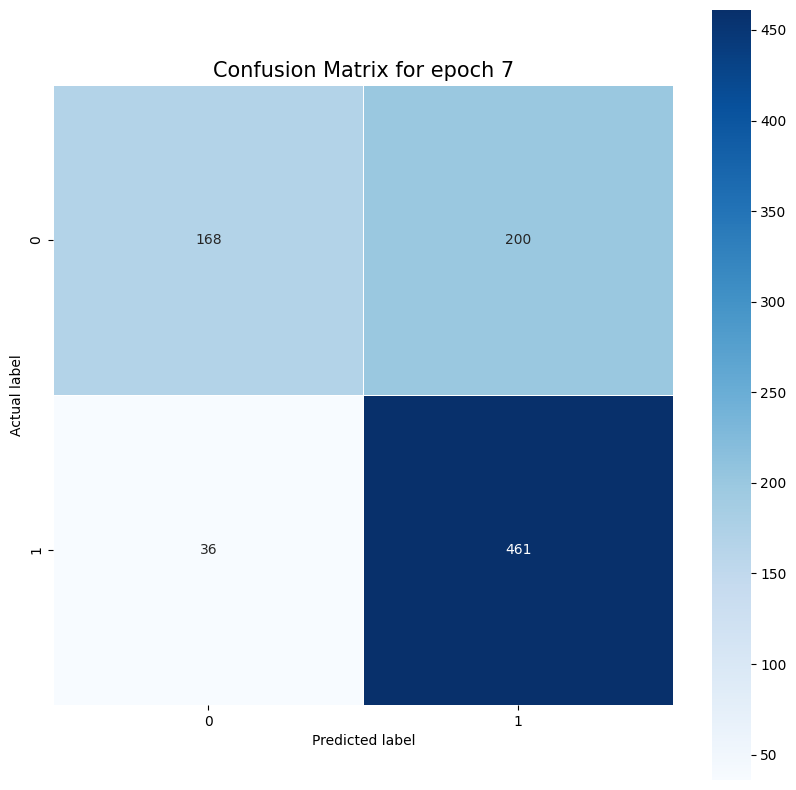

Epoch 8/10:   0%|          | 1/865 [00:02<34:16,  2.38s/it]

Accuracy of the model after epoch 8: 0.0%


Epoch 8/10:   0%|          | 2/865 [00:07<54:15,  3.77s/it]

Accuracy of the model after epoch 8: 50.0%


Epoch 8/10:   0%|          | 3/865 [00:11<1:01:12,  4.26s/it]

Accuracy of the model after epoch 8: 33.333333333333336%


Epoch 8/10:   0%|          | 4/865 [00:14<51:03,  3.56s/it]  

Accuracy of the model after epoch 8: 25.0%


Epoch 8/10:   1%|          | 5/865 [00:19<56:15,  3.92s/it]

Accuracy of the model after epoch 8: 40.0%


Epoch 8/10:   1%|          | 6/865 [00:21<50:04,  3.50s/it]

Accuracy of the model after epoch 8: 50.0%


Epoch 8/10:   1%|          | 7/865 [00:25<53:36,  3.75s/it]

Accuracy of the model after epoch 8: 57.142857142857146%


Epoch 8/10:   1%|          | 8/865 [00:28<46:31,  3.26s/it]

Accuracy of the model after epoch 8: 62.5%


Epoch 8/10:   1%|          | 9/865 [00:33<53:36,  3.76s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   1%|          | 10/865 [00:37<57:37,  4.04s/it]

Accuracy of the model after epoch 8: 60.0%


Epoch 8/10:   1%|▏         | 11/865 [00:42<58:55,  4.14s/it]

Accuracy of the model after epoch 8: 54.54545454545455%


Epoch 8/10:   1%|▏         | 12/865 [00:46<59:18,  4.17s/it]

Accuracy of the model after epoch 8: 58.333333333333336%


Epoch 8/10:   2%|▏         | 13/865 [00:51<1:03:35,  4.48s/it]

Accuracy of the model after epoch 8: 61.53846153846154%


Epoch 8/10:   2%|▏         | 14/865 [00:56<1:07:11,  4.74s/it]

Accuracy of the model after epoch 8: 57.142857142857146%


Epoch 8/10:   2%|▏         | 15/865 [00:59<59:28,  4.20s/it]  

Accuracy of the model after epoch 8: 60.0%


Epoch 8/10:   2%|▏         | 16/865 [01:04<1:00:08,  4.25s/it]

Accuracy of the model after epoch 8: 56.25%


Epoch 8/10:   2%|▏         | 17/865 [01:08<1:00:53,  4.31s/it]

Accuracy of the model after epoch 8: 52.94117647058823%


Epoch 8/10:   2%|▏         | 18/865 [01:12<1:01:04,  4.33s/it]

Accuracy of the model after epoch 8: 55.55555555555556%


Epoch 8/10:   2%|▏         | 19/865 [01:17<1:03:40,  4.52s/it]

Accuracy of the model after epoch 8: 57.89473684210526%


Epoch 8/10:   2%|▏         | 20/865 [01:22<1:04:04,  4.55s/it]

Accuracy of the model after epoch 8: 60.0%


Epoch 8/10:   2%|▏         | 21/865 [01:26<1:02:04,  4.41s/it]

Accuracy of the model after epoch 8: 61.904761904761905%


Epoch 8/10:   3%|▎         | 22/865 [01:30<1:01:43,  4.39s/it]

Accuracy of the model after epoch 8: 63.63636363636363%


Epoch 8/10:   3%|▎         | 23/865 [01:35<1:01:39,  4.39s/it]

Accuracy of the model after epoch 8: 65.21739130434783%


Epoch 8/10:   3%|▎         | 24/865 [01:39<1:02:31,  4.46s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   3%|▎         | 25/865 [01:42<55:36,  3.97s/it]  

Accuracy of the model after epoch 8: 68.0%


Epoch 8/10:   3%|▎         | 26/865 [01:47<57:18,  4.10s/it]

Accuracy of the model after epoch 8: 65.38461538461539%


Epoch 8/10:   3%|▎         | 27/865 [01:51<57:44,  4.13s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   3%|▎         | 28/865 [01:55<58:55,  4.22s/it]

Accuracy of the model after epoch 8: 64.28571428571429%


Epoch 8/10:   3%|▎         | 29/865 [02:01<1:02:59,  4.52s/it]

Accuracy of the model after epoch 8: 62.06896551724138%


Epoch 8/10:   3%|▎         | 30/865 [02:05<1:02:53,  4.52s/it]

Accuracy of the model after epoch 8: 63.333333333333336%


Epoch 8/10:   4%|▎         | 31/865 [02:09<1:01:34,  4.43s/it]

Accuracy of the model after epoch 8: 61.29032258064516%


Epoch 8/10:   4%|▎         | 32/865 [02:13<1:00:22,  4.35s/it]

Accuracy of the model after epoch 8: 62.5%


Epoch 8/10:   4%|▍         | 33/865 [02:16<52:43,  3.80s/it]  

Accuracy of the model after epoch 8: 63.63636363636363%


Epoch 8/10:   4%|▍         | 34/865 [02:21<57:28,  4.15s/it]

Accuracy of the model after epoch 8: 64.70588235294117%


Epoch 8/10:   4%|▍         | 35/865 [02:26<59:31,  4.30s/it]

Accuracy of the model after epoch 8: 65.71428571428571%


Epoch 8/10:   4%|▍         | 36/865 [02:30<58:48,  4.26s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   4%|▍         | 37/865 [02:34<58:31,  4.24s/it]

Accuracy of the model after epoch 8: 67.56756756756756%


Epoch 8/10:   4%|▍         | 38/865 [02:38<58:47,  4.27s/it]

Accuracy of the model after epoch 8: 68.42105263157895%


Epoch 8/10:   5%|▍         | 39/865 [02:43<1:02:09,  4.52s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   5%|▍         | 40/865 [02:48<1:02:08,  4.52s/it]

Accuracy of the model after epoch 8: 67.5%


Epoch 8/10:   5%|▍         | 41/865 [02:52<1:01:03,  4.45s/it]

Accuracy of the model after epoch 8: 65.85365853658537%


Epoch 8/10:   5%|▍         | 42/865 [02:57<1:00:26,  4.41s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   5%|▍         | 43/865 [02:59<51:21,  3.75s/it]  

Accuracy of the model after epoch 8: 65.11627906976744%


Epoch 8/10:   5%|▌         | 44/865 [03:03<55:15,  4.04s/it]

Accuracy of the model after epoch 8: 65.9090909090909%


Epoch 8/10:   5%|▌         | 45/865 [03:08<57:11,  4.19s/it]

Accuracy of the model after epoch 8: 66.66666666666667%


Epoch 8/10:   5%|▌         | 46/865 [03:10<49:47,  3.65s/it]

Accuracy of the model after epoch 8: 67.3913043478261%


Epoch 8/10:   5%|▌         | 47/865 [03:13<44:29,  3.26s/it]

Accuracy of the model after epoch 8: 68.08510638297872%


Epoch 8/10:   6%|▌         | 48/865 [03:17<47:55,  3.52s/it]

Accuracy of the model after epoch 8: 68.75%


Epoch 8/10:   6%|▌         | 49/865 [03:21<52:26,  3.86s/it]

Accuracy of the model after epoch 8: 69.38775510204081%


Epoch 8/10:   6%|▌         | 50/865 [03:27<58:02,  4.27s/it]

Accuracy of the model after epoch 8: 70.0%


Epoch 8/10:   6%|▌         | 51/865 [03:29<49:42,  3.66s/it]

Accuracy of the model after epoch 8: 70.58823529411765%


Epoch 8/10:   6%|▌         | 52/865 [03:33<52:31,  3.88s/it]

Accuracy of the model after epoch 8: 69.23076923076923%


Epoch 8/10:   6%|▌         | 53/865 [03:38<54:34,  4.03s/it]

Accuracy of the model after epoch 8: 69.81132075471699%


Epoch 8/10:   6%|▌         | 54/865 [03:40<48:00,  3.55s/it]

Accuracy of the model after epoch 8: 70.37037037037037%


Epoch 8/10:   6%|▋         | 55/865 [03:43<44:43,  3.31s/it]

Accuracy of the model after epoch 8: 70.9090909090909%


Epoch 8/10:   6%|▋         | 56/865 [03:46<42:09,  3.13s/it]

Accuracy of the model after epoch 8: 69.64285714285714%


Epoch 8/10:   7%|▋         | 57/865 [03:50<48:54,  3.63s/it]

Accuracy of the model after epoch 8: 70.17543859649123%


Epoch 8/10:   7%|▋         | 58/865 [03:55<51:27,  3.83s/it]

Accuracy of the model after epoch 8: 68.96551724137932%


Epoch 8/10:   7%|▋         | 59/865 [04:00<55:52,  4.16s/it]

Accuracy of the model after epoch 8: 67.79661016949153%


Epoch 8/10:   7%|▋         | 60/865 [04:04<57:24,  4.28s/it]

Accuracy of the model after epoch 8: 68.33333333333333%


Epoch 8/10:   7%|▋         | 61/865 [04:07<50:29,  3.77s/it]

Accuracy of the model after epoch 8: 68.85245901639344%


Epoch 8/10:   7%|▋         | 62/865 [04:11<52:19,  3.91s/it]

Accuracy of the model after epoch 8: 69.35483870967742%


Epoch 8/10:   7%|▋         | 63/865 [04:14<46:57,  3.51s/it]

Accuracy of the model after epoch 8: 68.25396825396825%


Epoch 8/10:   7%|▋         | 64/865 [04:18<50:34,  3.79s/it]

Accuracy of the model after epoch 8: 68.75%


Epoch 8/10:   8%|▊         | 65/865 [04:21<46:38,  3.50s/it]

Accuracy of the model after epoch 8: 69.23076923076923%


Epoch 8/10:   8%|▊         | 66/865 [04:23<41:50,  3.14s/it]

Accuracy of the model after epoch 8: 69.6969696969697%


Epoch 8/10:   8%|▊         | 67/865 [04:28<48:02,  3.61s/it]

Accuracy of the model after epoch 8: 68.65671641791045%


Epoch 8/10:   8%|▊         | 68/865 [04:32<51:50,  3.90s/it]

Accuracy of the model after epoch 8: 69.11764705882354%


Epoch 8/10:   8%|▊         | 69/865 [04:37<53:22,  4.02s/it]

Accuracy of the model after epoch 8: 68.1159420289855%


Epoch 8/10:   8%|▊         | 70/865 [04:39<47:37,  3.59s/it]

Accuracy of the model after epoch 8: 68.57142857142857%


Epoch 8/10:   8%|▊         | 71/865 [04:43<49:30,  3.74s/it]

Accuracy of the model after epoch 8: 69.01408450704226%


Epoch 8/10:   8%|▊         | 72/865 [04:48<51:36,  3.90s/it]

Accuracy of the model after epoch 8: 69.44444444444444%


Epoch 8/10:   8%|▊         | 73/865 [04:52<54:24,  4.12s/it]

Accuracy of the model after epoch 8: 69.86301369863014%


Epoch 8/10:   9%|▊         | 74/865 [04:57<57:01,  4.33s/it]

Accuracy of the model after epoch 8: 68.91891891891892%


Epoch 8/10:   9%|▊         | 75/865 [05:02<58:45,  4.46s/it]

Accuracy of the model after epoch 8: 69.33333333333333%


Epoch 8/10:   9%|▉         | 76/865 [05:06<57:53,  4.40s/it]

Accuracy of the model after epoch 8: 69.73684210526316%


Epoch 8/10:   9%|▉         | 77/865 [05:10<57:15,  4.36s/it]

Accuracy of the model after epoch 8: 70.12987012987013%


Epoch 8/10:   9%|▉         | 78/865 [05:15<58:43,  4.48s/it]

Accuracy of the model after epoch 8: 69.23076923076923%


Epoch 8/10:   9%|▉         | 79/865 [05:20<1:00:54,  4.65s/it]

Accuracy of the model after epoch 8: 69.62025316455696%


Epoch 8/10:   9%|▉         | 80/865 [05:26<1:03:08,  4.83s/it]

Accuracy of the model after epoch 8: 70.0%


Epoch 8/10:   9%|▉         | 81/865 [05:30<1:01:31,  4.71s/it]

Accuracy of the model after epoch 8: 70.37037037037037%


Epoch 8/10:   9%|▉         | 82/865 [05:32<52:31,  4.03s/it]  

Accuracy of the model after epoch 8: 70.73170731707317%


Epoch 8/10:  10%|▉         | 83/865 [05:37<52:55,  4.06s/it]

Accuracy of the model after epoch 8: 71.08433734939759%


Epoch 8/10:  10%|▉         | 84/865 [05:42<57:28,  4.42s/it]

Accuracy of the model after epoch 8: 71.42857142857143%


Epoch 8/10:  10%|▉         | 85/865 [05:46<57:55,  4.46s/it]

Accuracy of the model after epoch 8: 70.58823529411765%


Epoch 8/10:  10%|▉         | 86/865 [05:51<59:00,  4.54s/it]

Accuracy of the model after epoch 8: 70.93023255813954%


Epoch 8/10:  10%|█         | 87/865 [05:55<57:44,  4.45s/it]

Accuracy of the model after epoch 8: 71.26436781609195%


Epoch 8/10:  10%|█         | 88/865 [06:00<58:46,  4.54s/it]

Accuracy of the model after epoch 8: 70.45454545454545%


Epoch 8/10:  10%|█         | 89/865 [06:03<50:45,  3.93s/it]

Accuracy of the model after epoch 8: 70.78651685393258%


Epoch 8/10:  10%|█         | 90/865 [06:07<53:02,  4.11s/it]

Accuracy of the model after epoch 8: 70.0%


Epoch 8/10:  11%|█         | 91/865 [06:12<54:32,  4.23s/it]

Accuracy of the model after epoch 8: 70.32967032967034%


Epoch 8/10:  11%|█         | 92/865 [06:16<54:28,  4.23s/it]

Accuracy of the model after epoch 8: 70.65217391304348%


Epoch 8/10:  11%|█         | 93/865 [06:20<55:32,  4.32s/it]

Accuracy of the model after epoch 8: 70.96774193548387%


Epoch 8/10:  11%|█         | 94/865 [06:25<57:04,  4.44s/it]

Accuracy of the model after epoch 8: 71.27659574468085%


Epoch 8/10:  11%|█         | 95/865 [06:29<56:40,  4.42s/it]

Accuracy of the model after epoch 8: 71.57894736842105%


Epoch 8/10:  11%|█         | 96/865 [06:34<56:09,  4.38s/it]

Accuracy of the model after epoch 8: 71.875%


Epoch 8/10:  11%|█         | 97/865 [06:38<57:32,  4.50s/it]

Accuracy of the model after epoch 8: 72.16494845360825%


Epoch 8/10:  11%|█▏        | 98/865 [06:43<57:56,  4.53s/it]

Accuracy of the model after epoch 8: 72.44897959183673%


Epoch 8/10:  11%|█▏        | 99/865 [06:48<1:01:03,  4.78s/it]

Accuracy of the model after epoch 8: 72.72727272727273%


Epoch 8/10:  12%|█▏        | 100/865 [06:51<53:46,  4.22s/it] 

Accuracy of the model after epoch 8: 72.0%


Epoch 8/10:  12%|█▏        | 101/865 [06:56<56:08,  4.41s/it]

Accuracy of the model after epoch 8: 71.2871287128713%


Epoch 8/10:  12%|█▏        | 102/865 [06:59<48:30,  3.81s/it]

Accuracy of the model after epoch 8: 71.56862745098039%


Epoch 8/10:  12%|█▏        | 103/865 [07:03<50:08,  3.95s/it]

Accuracy of the model after epoch 8: 71.84466019417475%


Epoch 8/10:  12%|█▏        | 104/865 [07:08<53:07,  4.19s/it]

Accuracy of the model after epoch 8: 71.15384615384616%


Epoch 8/10:  12%|█▏        | 105/865 [07:10<46:39,  3.68s/it]

Accuracy of the model after epoch 8: 71.42857142857143%


Epoch 8/10:  12%|█▏        | 106/865 [07:15<49:03,  3.88s/it]

Accuracy of the model after epoch 8: 71.69811320754717%


Epoch 8/10:  12%|█▏        | 107/865 [07:19<50:48,  4.02s/it]

Accuracy of the model after epoch 8: 71.96261682242991%


Epoch 8/10:  12%|█▏        | 108/865 [07:23<52:07,  4.13s/it]

Accuracy of the model after epoch 8: 72.22222222222223%


Epoch 8/10:  13%|█▎        | 109/865 [07:26<45:23,  3.60s/it]

Accuracy of the model after epoch 8: 72.4770642201835%


Epoch 8/10:  13%|█▎        | 110/865 [07:31<50:15,  3.99s/it]

Accuracy of the model after epoch 8: 71.81818181818181%


Epoch 8/10:  13%|█▎        | 111/865 [07:35<51:47,  4.12s/it]

Accuracy of the model after epoch 8: 71.17117117117117%


Epoch 8/10:  13%|█▎        | 112/865 [07:39<52:19,  4.17s/it]

Accuracy of the model after epoch 8: 71.42857142857143%


Epoch 8/10:  13%|█▎        | 113/865 [07:44<54:27,  4.34s/it]

Accuracy of the model after epoch 8: 70.79646017699115%


Epoch 8/10:  13%|█▎        | 114/865 [07:49<58:13,  4.65s/it]

Accuracy of the model after epoch 8: 71.05263157894737%


Epoch 8/10:  13%|█▎        | 115/865 [07:54<58:41,  4.70s/it]

Accuracy of the model after epoch 8: 71.30434782608695%


Epoch 8/10:  13%|█▎        | 116/865 [07:57<50:24,  4.04s/it]

Accuracy of the model after epoch 8: 71.55172413793103%


Epoch 8/10:  14%|█▎        | 117/865 [07:59<44:16,  3.55s/it]

Accuracy of the model after epoch 8: 71.7948717948718%


Epoch 8/10:  14%|█▎        | 118/865 [08:03<46:47,  3.76s/it]

Accuracy of the model after epoch 8: 72.03389830508475%


Epoch 8/10:  14%|█▍        | 119/865 [08:08<49:24,  3.97s/it]

Accuracy of the model after epoch 8: 72.26890756302521%


Epoch 8/10:  14%|█▍        | 120/865 [08:11<45:13,  3.64s/it]

Accuracy of the model after epoch 8: 72.5%


Epoch 8/10:  14%|█▍        | 121/865 [08:15<47:26,  3.83s/it]

Accuracy of the model after epoch 8: 72.72727272727273%


Epoch 8/10:  14%|█▍        | 122/865 [08:17<42:13,  3.41s/it]

Accuracy of the model after epoch 8: 72.95081967213115%


Epoch 8/10:  14%|█▍        | 123/865 [08:22<47:04,  3.81s/it]

Accuracy of the model after epoch 8: 72.35772357723577%


Epoch 8/10:  14%|█▍        | 124/865 [08:27<50:07,  4.06s/it]

Accuracy of the model after epoch 8: 71.7741935483871%


Epoch 8/10:  14%|█▍        | 125/865 [08:31<52:19,  4.24s/it]

Accuracy of the model after epoch 8: 72.0%


Epoch 8/10:  15%|█▍        | 126/865 [08:36<53:42,  4.36s/it]

Accuracy of the model after epoch 8: 72.22222222222223%


Epoch 8/10:  15%|█▍        | 127/865 [08:40<53:32,  4.35s/it]

Accuracy of the model after epoch 8: 71.65354330708661%


Epoch 8/10:  15%|█▍        | 128/865 [08:45<55:25,  4.51s/it]

Accuracy of the model after epoch 8: 71.875%


Epoch 8/10:  15%|█▍        | 129/865 [08:50<56:21,  4.59s/it]

Accuracy of the model after epoch 8: 72.09302325581395%


Epoch 8/10:  15%|█▌        | 130/865 [08:53<49:40,  4.06s/it]

Accuracy of the model after epoch 8: 72.3076923076923%


Epoch 8/10:  15%|█▌        | 131/865 [08:57<50:40,  4.14s/it]

Accuracy of the model after epoch 8: 72.51908396946565%


Epoch 8/10:  15%|█▌        | 132/865 [09:02<51:32,  4.22s/it]

Accuracy of the model after epoch 8: 72.72727272727273%


Epoch 8/10:  15%|█▌        | 133/865 [09:06<51:55,  4.26s/it]

Accuracy of the model after epoch 8: 72.93233082706767%


Epoch 8/10:  15%|█▌        | 134/865 [09:11<53:55,  4.43s/it]

Accuracy of the model after epoch 8: 72.38805970149254%


Epoch 8/10:  16%|█▌        | 135/865 [09:15<53:54,  4.43s/it]

Accuracy of the model after epoch 8: 72.5925925925926%


Epoch 8/10:  16%|█▌        | 136/865 [09:18<47:14,  3.89s/it]

Accuracy of the model after epoch 8: 72.79411764705883%


Epoch 8/10:  16%|█▌        | 137/865 [09:20<41:26,  3.42s/it]

Accuracy of the model after epoch 8: 72.99270072992701%


Epoch 8/10:  16%|█▌        | 138/865 [09:25<45:25,  3.75s/it]

Accuracy of the model after epoch 8: 72.46376811594203%


Epoch 8/10:  16%|█▌        | 139/865 [09:29<47:49,  3.95s/it]

Accuracy of the model after epoch 8: 72.66187050359713%


Epoch 8/10:  16%|█▌        | 140/865 [09:32<43:13,  3.58s/it]

Accuracy of the model after epoch 8: 72.85714285714286%


Epoch 8/10:  16%|█▋        | 141/865 [09:36<45:30,  3.77s/it]

Accuracy of the model after epoch 8: 72.34042553191489%


Epoch 8/10:  16%|█▋        | 142/865 [09:40<46:56,  3.90s/it]

Accuracy of the model after epoch 8: 72.53521126760563%


Epoch 8/10:  17%|█▋        | 143/865 [09:44<48:17,  4.01s/it]

Accuracy of the model after epoch 8: 72.72727272727273%


Epoch 8/10:  17%|█▋        | 144/865 [09:49<51:07,  4.25s/it]

Accuracy of the model after epoch 8: 72.91666666666667%


Epoch 8/10:  17%|█▋        | 145/865 [09:54<53:02,  4.42s/it]

Accuracy of the model after epoch 8: 73.10344827586206%


Epoch 8/10:  17%|█▋        | 146/865 [09:58<51:45,  4.32s/it]

Accuracy of the model after epoch 8: 73.28767123287672%


Epoch 8/10:  17%|█▋        | 147/865 [10:02<51:40,  4.32s/it]

Accuracy of the model after epoch 8: 73.46938775510205%


Epoch 8/10:  17%|█▋        | 148/865 [10:05<45:23,  3.80s/it]

Accuracy of the model after epoch 8: 72.97297297297297%


Epoch 8/10:  17%|█▋        | 149/865 [10:09<47:17,  3.96s/it]

Accuracy of the model after epoch 8: 73.15436241610739%


Epoch 8/10:  17%|█▋        | 150/865 [10:14<49:18,  4.14s/it]

Accuracy of the model after epoch 8: 73.33333333333333%


Epoch 8/10:  17%|█▋        | 151/865 [10:18<49:58,  4.20s/it]

Accuracy of the model after epoch 8: 73.50993377483444%


Epoch 8/10:  18%|█▊        | 152/865 [10:23<50:29,  4.25s/it]

Accuracy of the model after epoch 8: 73.6842105263158%


Epoch 8/10:  18%|█▊        | 153/865 [10:27<52:12,  4.40s/it]

Accuracy of the model after epoch 8: 73.85620915032679%


Epoch 8/10:  18%|█▊        | 154/865 [10:30<45:58,  3.88s/it]

Accuracy of the model after epoch 8: 73.37662337662337%


Epoch 8/10:  18%|█▊        | 155/865 [10:35<48:46,  4.12s/it]

Accuracy of the model after epoch 8: 73.54838709677419%


Epoch 8/10:  18%|█▊        | 156/865 [10:40<51:10,  4.33s/it]

Accuracy of the model after epoch 8: 73.71794871794872%


Epoch 8/10:  18%|█▊        | 157/865 [10:42<44:47,  3.80s/it]

Accuracy of the model after epoch 8: 73.88535031847134%


Epoch 8/10:  18%|█▊        | 158/865 [10:46<46:37,  3.96s/it]

Accuracy of the model after epoch 8: 74.0506329113924%


Epoch 8/10:  18%|█▊        | 159/865 [10:52<51:24,  4.37s/it]

Accuracy of the model after epoch 8: 73.58490566037736%


Epoch 8/10:  18%|█▊        | 160/865 [10:56<51:56,  4.42s/it]

Accuracy of the model after epoch 8: 73.75%


Epoch 8/10:  19%|█▊        | 161/865 [10:59<45:48,  3.90s/it]

Accuracy of the model after epoch 8: 73.2919254658385%


Epoch 8/10:  19%|█▊        | 162/865 [11:02<40:45,  3.48s/it]

Accuracy of the model after epoch 8: 73.45679012345678%


Epoch 8/10:  19%|█▉        | 163/865 [11:06<43:39,  3.73s/it]

Accuracy of the model after epoch 8: 73.00613496932516%


Epoch 8/10:  19%|█▉        | 164/865 [11:08<38:51,  3.33s/it]

Accuracy of the model after epoch 8: 73.17073170731707%


Epoch 8/10:  19%|█▉        | 165/865 [11:13<45:26,  3.90s/it]

Accuracy of the model after epoch 8: 73.33333333333333%


Epoch 8/10:  19%|█▉        | 166/865 [11:18<46:56,  4.03s/it]

Accuracy of the model after epoch 8: 73.49397590361446%


Epoch 8/10:  19%|█▉        | 167/865 [11:20<40:40,  3.50s/it]

Accuracy of the model after epoch 8: 73.05389221556887%


Epoch 8/10:  19%|█▉        | 168/865 [11:23<37:30,  3.23s/it]

Accuracy of the model after epoch 8: 73.21428571428571%


Epoch 8/10:  20%|█▉        | 169/865 [11:28<43:30,  3.75s/it]

Accuracy of the model after epoch 8: 73.37278106508876%


Epoch 8/10:  20%|█▉        | 170/865 [11:32<46:15,  3.99s/it]

Accuracy of the model after epoch 8: 73.52941176470588%


Epoch 8/10:  20%|█▉        | 171/865 [11:37<47:30,  4.11s/it]

Accuracy of the model after epoch 8: 73.6842105263158%


Epoch 8/10:  20%|█▉        | 172/865 [11:39<41:07,  3.56s/it]

Accuracy of the model after epoch 8: 73.83720930232558%


Epoch 8/10:  20%|██        | 173/865 [11:43<43:30,  3.77s/it]

Accuracy of the model after epoch 8: 73.98843930635839%


Epoch 8/10:  20%|██        | 174/865 [11:48<47:54,  4.16s/it]

Accuracy of the model after epoch 8: 74.13793103448276%


Epoch 8/10:  20%|██        | 175/865 [11:53<48:56,  4.26s/it]

Accuracy of the model after epoch 8: 74.28571428571429%


Epoch 8/10:  20%|██        | 176/865 [11:57<49:19,  4.30s/it]

Accuracy of the model after epoch 8: 73.86363636363636%


Epoch 8/10:  20%|██        | 177/865 [12:01<49:11,  4.29s/it]

Accuracy of the model after epoch 8: 74.01129943502825%


Epoch 8/10:  21%|██        | 178/865 [12:04<42:28,  3.71s/it]

Accuracy of the model after epoch 8: 74.15730337078652%


Epoch 8/10:  21%|██        | 179/865 [12:06<38:49,  3.40s/it]

Accuracy of the model after epoch 8: 74.30167597765363%


Epoch 8/10:  21%|██        | 180/865 [12:11<43:25,  3.80s/it]

Accuracy of the model after epoch 8: 74.44444444444444%


Epoch 8/10:  21%|██        | 181/865 [12:16<45:30,  3.99s/it]

Accuracy of the model after epoch 8: 74.58563535911603%


Epoch 8/10:  21%|██        | 182/865 [12:20<46:17,  4.07s/it]

Accuracy of the model after epoch 8: 74.17582417582418%


Epoch 8/10:  21%|██        | 183/865 [12:25<48:31,  4.27s/it]

Accuracy of the model after epoch 8: 73.77049180327869%


Epoch 8/10:  21%|██▏       | 184/865 [12:30<51:45,  4.56s/it]

Accuracy of the model after epoch 8: 73.91304347826087%


Epoch 8/10:  21%|██▏       | 185/865 [12:34<52:14,  4.61s/it]

Accuracy of the model after epoch 8: 74.05405405405405%


Epoch 8/10:  22%|██▏       | 186/865 [12:39<51:32,  4.55s/it]

Accuracy of the model after epoch 8: 74.19354838709677%


Epoch 8/10:  22%|██▏       | 187/865 [12:43<50:26,  4.46s/it]

Accuracy of the model after epoch 8: 73.79679144385027%


Epoch 8/10:  22%|██▏       | 188/865 [12:48<52:30,  4.65s/it]

Accuracy of the model after epoch 8: 73.93617021276596%


Epoch 8/10:  22%|██▏       | 189/865 [12:51<44:55,  3.99s/it]

Accuracy of the model after epoch 8: 74.07407407407408%


Epoch 8/10:  22%|██▏       | 190/865 [12:53<40:04,  3.56s/it]

Accuracy of the model after epoch 8: 74.21052631578948%


Epoch 8/10:  22%|██▏       | 191/865 [12:58<42:22,  3.77s/it]

Accuracy of the model after epoch 8: 74.3455497382199%


Epoch 8/10:  22%|██▏       | 192/865 [13:02<43:47,  3.90s/it]

Accuracy of the model after epoch 8: 73.95833333333333%


Epoch 8/10:  22%|██▏       | 193/865 [13:06<44:55,  4.01s/it]

Accuracy of the model after epoch 8: 74.09326424870466%


Epoch 8/10:  22%|██▏       | 194/865 [13:11<48:06,  4.30s/it]

Accuracy of the model after epoch 8: 74.22680412371135%


Epoch 8/10:  23%|██▎       | 195/865 [13:16<48:54,  4.38s/it]

Accuracy of the model after epoch 8: 74.35897435897436%


Epoch 8/10:  23%|██▎       | 196/865 [13:18<42:52,  3.85s/it]

Accuracy of the model after epoch 8: 74.48979591836735%


Epoch 8/10:  23%|██▎       | 197/865 [13:21<38:07,  3.42s/it]

Accuracy of the model after epoch 8: 74.61928934010152%


Epoch 8/10:  23%|██▎       | 198/865 [13:23<35:19,  3.18s/it]

Accuracy of the model after epoch 8: 74.74747474747475%


Epoch 8/10:  23%|██▎       | 199/865 [13:28<40:13,  3.62s/it]

Accuracy of the model after epoch 8: 74.87437185929649%


Epoch 8/10:  23%|██▎       | 200/865 [13:32<42:52,  3.87s/it]

Accuracy of the model after epoch 8: 75.0%


Epoch 8/10:  23%|██▎       | 201/865 [13:37<44:45,  4.04s/it]

Accuracy of the model after epoch 8: 75.12437810945273%


Epoch 8/10:  23%|██▎       | 202/865 [13:41<45:18,  4.10s/it]

Accuracy of the model after epoch 8: 74.75247524752476%


Epoch 8/10:  23%|██▎       | 203/865 [13:46<47:00,  4.26s/it]

Accuracy of the model after epoch 8: 74.38423645320196%


Epoch 8/10:  24%|██▎       | 204/865 [13:51<50:09,  4.55s/it]

Accuracy of the model after epoch 8: 74.50980392156863%


Epoch 8/10:  24%|██▎       | 205/865 [13:55<50:05,  4.55s/it]

Accuracy of the model after epoch 8: 74.63414634146342%


Epoch 8/10:  24%|██▍       | 206/865 [13:58<43:24,  3.95s/it]

Accuracy of the model after epoch 8: 74.75728155339806%


Epoch 8/10:  24%|██▍       | 207/865 [14:00<38:24,  3.50s/it]

Accuracy of the model after epoch 8: 74.8792270531401%


Epoch 8/10:  24%|██▍       | 208/865 [14:05<40:56,  3.74s/it]

Accuracy of the model after epoch 8: 74.51923076923077%


Epoch 8/10:  24%|██▍       | 209/865 [14:09<43:10,  3.95s/it]

Accuracy of the model after epoch 8: 74.16267942583733%


Epoch 8/10:  24%|██▍       | 210/865 [14:14<45:17,  4.15s/it]

Accuracy of the model after epoch 8: 74.28571428571429%


Epoch 8/10:  24%|██▍       | 211/865 [14:18<45:01,  4.13s/it]

Accuracy of the model after epoch 8: 74.40758293838863%


Epoch 8/10:  25%|██▍       | 212/865 [14:20<39:24,  3.62s/it]

Accuracy of the model after epoch 8: 74.52830188679245%


Epoch 8/10:  25%|██▍       | 213/865 [14:25<41:35,  3.83s/it]

Accuracy of the model after epoch 8: 74.64788732394366%


Epoch 8/10:  25%|██▍       | 214/865 [14:30<46:15,  4.26s/it]

Accuracy of the model after epoch 8: 74.29906542056075%


Epoch 8/10:  25%|██▍       | 215/865 [14:33<41:36,  3.84s/it]

Accuracy of the model after epoch 8: 74.4186046511628%


Epoch 8/10:  25%|██▍       | 216/865 [14:35<37:03,  3.43s/it]

Accuracy of the model after epoch 8: 74.53703703703704%


Epoch 8/10:  25%|██▌       | 217/865 [14:39<39:45,  3.68s/it]

Accuracy of the model after epoch 8: 74.65437788018433%


Epoch 8/10:  25%|██▌       | 218/865 [14:44<41:36,  3.86s/it]

Accuracy of the model after epoch 8: 74.77064220183486%


Epoch 8/10:  25%|██▌       | 219/865 [14:46<36:59,  3.44s/it]

Accuracy of the model after epoch 8: 74.88584474885845%


Epoch 8/10:  25%|██▌       | 220/865 [14:51<40:51,  3.80s/it]

Accuracy of the model after epoch 8: 75.0%


Epoch 8/10:  26%|██▌       | 221/865 [14:53<36:20,  3.39s/it]

Accuracy of the model after epoch 8: 75.1131221719457%


Epoch 8/10:  26%|██▌       | 222/865 [14:56<32:51,  3.07s/it]

Accuracy of the model after epoch 8: 75.22522522522523%


Epoch 8/10:  26%|██▌       | 223/865 [14:58<31:02,  2.90s/it]

Accuracy of the model after epoch 8: 75.33632286995515%


Epoch 8/10:  26%|██▌       | 224/865 [15:01<29:45,  2.78s/it]

Accuracy of the model after epoch 8: 75.44642857142857%


Epoch 8/10:  26%|██▌       | 225/865 [15:06<36:41,  3.44s/it]

Accuracy of the model after epoch 8: 75.55555555555556%


Epoch 8/10:  26%|██▌       | 226/865 [15:08<33:13,  3.12s/it]

Accuracy of the model after epoch 8: 75.66371681415929%


Epoch 8/10:  26%|██▌       | 227/865 [15:10<30:57,  2.91s/it]

Accuracy of the model after epoch 8: 75.77092511013215%


Epoch 8/10:  26%|██▋       | 228/865 [15:15<35:08,  3.31s/it]

Accuracy of the model after epoch 8: 75.87719298245614%


Epoch 8/10:  26%|██▋       | 229/865 [15:19<38:35,  3.64s/it]

Accuracy of the model after epoch 8: 75.54585152838428%


Epoch 8/10:  27%|██▋       | 230/865 [15:24<42:03,  3.97s/it]

Accuracy of the model after epoch 8: 75.65217391304348%


Epoch 8/10:  27%|██▋       | 231/865 [15:28<42:16,  4.00s/it]

Accuracy of the model after epoch 8: 75.75757575757575%


Epoch 8/10:  27%|██▋       | 232/865 [15:32<42:55,  4.07s/it]

Accuracy of the model after epoch 8: 75.86206896551724%


Epoch 8/10:  27%|██▋       | 233/865 [15:36<43:52,  4.17s/it]

Accuracy of the model after epoch 8: 75.9656652360515%


Epoch 8/10:  27%|██▋       | 234/865 [15:39<37:52,  3.60s/it]

Accuracy of the model after epoch 8: 76.06837606837607%


Epoch 8/10:  27%|██▋       | 235/865 [15:41<34:25,  3.28s/it]

Accuracy of the model after epoch 8: 76.17021276595744%


Epoch 8/10:  27%|██▋       | 236/865 [15:44<31:53,  3.04s/it]

Accuracy of the model after epoch 8: 76.27118644067797%


Epoch 8/10:  27%|██▋       | 237/865 [15:48<36:47,  3.51s/it]

Accuracy of the model after epoch 8: 76.37130801687763%


Epoch 8/10:  28%|██▊       | 238/865 [15:53<39:06,  3.74s/it]

Accuracy of the model after epoch 8: 76.47058823529412%


Epoch 8/10:  28%|██▊       | 239/865 [15:58<43:02,  4.13s/it]

Accuracy of the model after epoch 8: 76.56903765690376%


Epoch 8/10:  28%|██▊       | 240/865 [16:02<44:37,  4.28s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  28%|██▊       | 241/865 [16:07<46:25,  4.46s/it]

Accuracy of the model after epoch 8: 76.76348547717842%


Epoch 8/10:  28%|██▊       | 242/865 [16:11<45:33,  4.39s/it]

Accuracy of the model after epoch 8: 76.85950413223141%


Epoch 8/10:  28%|██▊       | 243/865 [16:16<46:28,  4.48s/it]

Accuracy of the model after epoch 8: 76.95473251028807%


Epoch 8/10:  28%|██▊       | 244/865 [16:19<40:41,  3.93s/it]

Accuracy of the model after epoch 8: 77.04918032786885%


Epoch 8/10:  28%|██▊       | 245/865 [16:23<42:39,  4.13s/it]

Accuracy of the model after epoch 8: 77.14285714285714%


Epoch 8/10:  28%|██▊       | 246/865 [16:28<43:02,  4.17s/it]

Accuracy of the model after epoch 8: 77.23577235772358%


Epoch 8/10:  29%|██▊       | 247/865 [16:32<43:40,  4.24s/it]

Accuracy of the model after epoch 8: 77.32793522267207%


Epoch 8/10:  29%|██▊       | 248/865 [16:37<45:35,  4.43s/it]

Accuracy of the model after epoch 8: 77.41935483870968%


Epoch 8/10:  29%|██▉       | 249/865 [16:42<48:06,  4.69s/it]

Accuracy of the model after epoch 8: 77.51004016064257%


Epoch 8/10:  29%|██▉       | 250/865 [16:47<48:03,  4.69s/it]

Accuracy of the model after epoch 8: 77.6%


Epoch 8/10:  29%|██▉       | 251/865 [16:51<47:30,  4.64s/it]

Accuracy of the model after epoch 8: 77.68924302788845%


Epoch 8/10:  29%|██▉       | 252/865 [16:56<46:19,  4.53s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  29%|██▉       | 253/865 [17:00<46:17,  4.54s/it]

Accuracy of the model after epoch 8: 77.86561264822134%


Epoch 8/10:  29%|██▉       | 254/865 [17:06<49:00,  4.81s/it]

Accuracy of the model after epoch 8: 77.95275590551181%


Epoch 8/10:  29%|██▉       | 255/865 [17:09<42:59,  4.23s/it]

Accuracy of the model after epoch 8: 78.03921568627452%


Epoch 8/10:  30%|██▉       | 256/865 [17:13<42:34,  4.19s/it]

Accuracy of the model after epoch 8: 78.125%


Epoch 8/10:  30%|██▉       | 257/865 [17:15<37:22,  3.69s/it]

Accuracy of the model after epoch 8: 78.21011673151752%


Epoch 8/10:  30%|██▉       | 258/865 [17:19<39:15,  3.88s/it]

Accuracy of the model after epoch 8: 78.29457364341086%


Epoch 8/10:  30%|██▉       | 259/865 [17:24<42:06,  4.17s/it]

Accuracy of the model after epoch 8: 77.99227799227799%


Epoch 8/10:  30%|███       | 260/865 [17:29<42:54,  4.26s/it]

Accuracy of the model after epoch 8: 78.07692307692308%


Epoch 8/10:  30%|███       | 261/865 [17:31<37:48,  3.76s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  30%|███       | 262/865 [17:35<38:50,  3.87s/it]

Accuracy of the model after epoch 8: 77.86259541984732%


Epoch 8/10:  30%|███       | 263/865 [17:38<34:24,  3.43s/it]

Accuracy of the model after epoch 8: 77.9467680608365%


Epoch 8/10:  31%|███       | 264/865 [17:42<37:41,  3.76s/it]

Accuracy of the model after epoch 8: 78.03030303030303%


Epoch 8/10:  31%|███       | 265/865 [17:47<40:05,  4.01s/it]

Accuracy of the model after epoch 8: 77.73584905660377%


Epoch 8/10:  31%|███       | 266/865 [17:51<40:29,  4.06s/it]

Accuracy of the model after epoch 8: 77.44360902255639%


Epoch 8/10:  31%|███       | 267/865 [17:56<41:29,  4.16s/it]

Accuracy of the model after epoch 8: 77.52808988764045%


Epoch 8/10:  31%|███       | 268/865 [18:00<42:12,  4.24s/it]

Accuracy of the model after epoch 8: 77.61194029850746%


Epoch 8/10:  31%|███       | 269/865 [18:05<43:09,  4.34s/it]

Accuracy of the model after epoch 8: 77.69516728624535%


Epoch 8/10:  31%|███       | 270/865 [18:08<38:54,  3.92s/it]

Accuracy of the model after epoch 8: 77.4074074074074%


Epoch 8/10:  31%|███▏      | 271/865 [18:10<34:15,  3.46s/it]

Accuracy of the model after epoch 8: 77.49077490774907%


Epoch 8/10:  31%|███▏      | 272/865 [18:14<37:06,  3.76s/it]

Accuracy of the model after epoch 8: 77.57352941176471%


Epoch 8/10:  32%|███▏      | 273/865 [18:17<33:52,  3.43s/it]

Accuracy of the model after epoch 8: 77.65567765567765%


Epoch 8/10:  32%|███▏      | 274/865 [18:21<35:56,  3.65s/it]

Accuracy of the model after epoch 8: 77.73722627737226%


Epoch 8/10:  32%|███▏      | 275/865 [18:26<38:27,  3.91s/it]

Accuracy of the model after epoch 8: 77.45454545454545%


Epoch 8/10:  32%|███▏      | 276/865 [18:30<39:40,  4.04s/it]

Accuracy of the model after epoch 8: 77.17391304347827%


Epoch 8/10:  32%|███▏      | 277/865 [18:34<40:29,  4.13s/it]

Accuracy of the model after epoch 8: 77.25631768953069%


Epoch 8/10:  32%|███▏      | 278/865 [18:37<35:12,  3.60s/it]

Accuracy of the model after epoch 8: 77.33812949640287%


Epoch 8/10:  32%|███▏      | 279/865 [18:41<38:16,  3.92s/it]

Accuracy of the model after epoch 8: 77.41935483870968%


Epoch 8/10:  32%|███▏      | 280/865 [18:46<40:10,  4.12s/it]

Accuracy of the model after epoch 8: 77.5%


Epoch 8/10:  32%|███▏      | 281/865 [18:50<39:57,  4.11s/it]

Accuracy of the model after epoch 8: 77.58007117437722%


Epoch 8/10:  33%|███▎      | 282/865 [18:55<41:50,  4.31s/it]

Accuracy of the model after epoch 8: 77.65957446808511%


Epoch 8/10:  33%|███▎      | 283/865 [18:57<36:07,  3.72s/it]

Accuracy of the model after epoch 8: 77.73851590106007%


Epoch 8/10:  33%|███▎      | 284/865 [19:02<38:27,  3.97s/it]

Accuracy of the model after epoch 8: 77.8169014084507%


Epoch 8/10:  33%|███▎      | 285/865 [19:05<34:42,  3.59s/it]

Accuracy of the model after epoch 8: 77.89473684210526%


Epoch 8/10:  33%|███▎      | 286/865 [19:09<36:41,  3.80s/it]

Accuracy of the model after epoch 8: 77.97202797202797%


Epoch 8/10:  33%|███▎      | 287/865 [19:13<38:33,  4.00s/it]

Accuracy of the model after epoch 8: 78.04878048780488%


Epoch 8/10:  33%|███▎      | 288/865 [19:18<40:12,  4.18s/it]

Accuracy of the model after epoch 8: 78.125%


Epoch 8/10:  33%|███▎      | 289/865 [19:23<42:27,  4.42s/it]

Accuracy of the model after epoch 8: 78.20069204152249%


Epoch 8/10:  34%|███▎      | 290/865 [19:25<37:14,  3.89s/it]

Accuracy of the model after epoch 8: 78.27586206896552%


Epoch 8/10:  34%|███▎      | 291/865 [19:28<33:07,  3.46s/it]

Accuracy of the model after epoch 8: 78.35051546391753%


Epoch 8/10:  34%|███▍      | 292/865 [19:32<35:24,  3.71s/it]

Accuracy of the model after epoch 8: 78.42465753424658%


Epoch 8/10:  34%|███▍      | 293/865 [19:36<36:37,  3.84s/it]

Accuracy of the model after epoch 8: 78.15699658703072%


Epoch 8/10:  34%|███▍      | 294/865 [19:41<39:17,  4.13s/it]

Accuracy of the model after epoch 8: 77.89115646258503%


Epoch 8/10:  34%|███▍      | 295/865 [19:46<40:09,  4.23s/it]

Accuracy of the model after epoch 8: 77.96610169491525%


Epoch 8/10:  34%|███▍      | 296/865 [19:50<40:46,  4.30s/it]

Accuracy of the model after epoch 8: 78.04054054054055%


Epoch 8/10:  34%|███▍      | 297/865 [19:52<35:11,  3.72s/it]

Accuracy of the model after epoch 8: 78.11447811447812%


Epoch 8/10:  34%|███▍      | 298/865 [19:57<37:07,  3.93s/it]

Accuracy of the model after epoch 8: 77.85234899328859%


Epoch 8/10:  35%|███▍      | 299/865 [20:02<39:27,  4.18s/it]

Accuracy of the model after epoch 8: 77.92642140468227%


Epoch 8/10:  35%|███▍      | 300/865 [20:05<35:45,  3.80s/it]

Accuracy of the model after epoch 8: 77.66666666666667%


Epoch 8/10:  35%|███▍      | 301/865 [20:09<36:58,  3.93s/it]

Accuracy of the model after epoch 8: 77.40863787375416%


Epoch 8/10:  35%|███▍      | 302/865 [20:11<31:55,  3.40s/it]

Accuracy of the model after epoch 8: 77.48344370860927%


Epoch 8/10:  35%|███▌      | 303/865 [20:13<29:11,  3.12s/it]

Accuracy of the model after epoch 8: 77.55775577557756%


Epoch 8/10:  35%|███▌      | 304/865 [20:16<27:05,  2.90s/it]

Accuracy of the model after epoch 8: 77.63157894736842%


Epoch 8/10:  35%|███▌      | 305/865 [20:21<32:59,  3.53s/it]

Accuracy of the model after epoch 8: 77.70491803278688%


Epoch 8/10:  35%|███▌      | 306/865 [20:25<35:12,  3.78s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  35%|███▌      | 307/865 [20:28<31:30,  3.39s/it]

Accuracy of the model after epoch 8: 77.85016286644951%


Epoch 8/10:  36%|███▌      | 308/865 [20:32<34:32,  3.72s/it]

Accuracy of the model after epoch 8: 77.59740259740259%


Epoch 8/10:  36%|███▌      | 309/865 [20:38<39:07,  4.22s/it]

Accuracy of the model after epoch 8: 77.66990291262135%


Epoch 8/10:  36%|███▌      | 310/865 [20:40<35:20,  3.82s/it]

Accuracy of the model after epoch 8: 77.74193548387096%


Epoch 8/10:  36%|███▌      | 311/865 [20:45<36:34,  3.96s/it]

Accuracy of the model after epoch 8: 77.81350482315112%


Epoch 8/10:  36%|███▌      | 312/865 [20:47<31:43,  3.44s/it]

Accuracy of the model after epoch 8: 77.88461538461539%


Epoch 8/10:  36%|███▌      | 313/865 [20:49<28:58,  3.15s/it]

Accuracy of the model after epoch 8: 77.95527156549521%


Epoch 8/10:  36%|███▋      | 314/865 [20:54<32:44,  3.57s/it]

Accuracy of the model after epoch 8: 78.02547770700637%


Epoch 8/10:  36%|███▋      | 315/865 [20:59<35:41,  3.89s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  37%|███▋      | 316/865 [21:04<38:42,  4.23s/it]

Accuracy of the model after epoch 8: 77.84810126582279%


Epoch 8/10:  37%|███▋      | 317/865 [21:08<39:00,  4.27s/it]

Accuracy of the model after epoch 8: 77.91798107255521%


Epoch 8/10:  37%|███▋      | 318/865 [21:11<34:14,  3.76s/it]

Accuracy of the model after epoch 8: 77.9874213836478%


Epoch 8/10:  37%|███▋      | 319/865 [21:13<30:44,  3.38s/it]

Accuracy of the model after epoch 8: 78.0564263322884%


Epoch 8/10:  37%|███▋      | 320/865 [21:16<28:15,  3.11s/it]

Accuracy of the model after epoch 8: 78.125%


Epoch 8/10:  37%|███▋      | 321/865 [21:20<31:10,  3.44s/it]

Accuracy of the model after epoch 8: 78.19314641744548%


Epoch 8/10:  37%|███▋      | 322/865 [21:22<27:39,  3.06s/it]

Accuracy of the model after epoch 8: 78.26086956521739%


Epoch 8/10:  37%|███▋      | 323/865 [21:24<25:31,  2.83s/it]

Accuracy of the model after epoch 8: 78.0185758513932%


Epoch 8/10:  37%|███▋      | 324/865 [21:29<30:45,  3.41s/it]

Accuracy of the model after epoch 8: 78.08641975308642%


Epoch 8/10:  38%|███▊      | 325/865 [21:34<34:04,  3.79s/it]

Accuracy of the model after epoch 8: 78.15384615384616%


Epoch 8/10:  38%|███▊      | 326/865 [21:38<35:12,  3.92s/it]

Accuracy of the model after epoch 8: 77.91411042944786%


Epoch 8/10:  38%|███▊      | 327/865 [21:42<36:08,  4.03s/it]

Accuracy of the model after epoch 8: 77.67584097859327%


Epoch 8/10:  38%|███▊      | 328/865 [21:47<38:49,  4.34s/it]

Accuracy of the model after epoch 8: 77.7439024390244%


Epoch 8/10:  38%|███▊      | 329/865 [21:52<41:14,  4.62s/it]

Accuracy of the model after epoch 8: 77.50759878419453%


Epoch 8/10:  38%|███▊      | 330/865 [21:55<36:35,  4.10s/it]

Accuracy of the model after epoch 8: 77.57575757575758%


Epoch 8/10:  38%|███▊      | 331/865 [21:59<36:18,  4.08s/it]

Accuracy of the model after epoch 8: 77.64350453172206%


Epoch 8/10:  38%|███▊      | 332/865 [22:02<31:47,  3.58s/it]

Accuracy of the model after epoch 8: 77.71084337349397%


Epoch 8/10:  38%|███▊      | 333/865 [22:06<33:33,  3.79s/it]

Accuracy of the model after epoch 8: 77.47747747747748%


Epoch 8/10:  39%|███▊      | 334/865 [22:09<30:31,  3.45s/it]

Accuracy of the model after epoch 8: 77.54491017964072%


Epoch 8/10:  39%|███▊      | 335/865 [22:13<32:51,  3.72s/it]

Accuracy of the model after epoch 8: 77.31343283582089%


Epoch 8/10:  39%|███▉      | 336/865 [22:16<29:49,  3.38s/it]

Accuracy of the model after epoch 8: 77.38095238095238%


Epoch 8/10:  39%|███▉      | 337/865 [22:20<32:54,  3.74s/it]

Accuracy of the model after epoch 8: 77.44807121661721%


Epoch 8/10:  39%|███▉      | 338/865 [22:25<34:36,  3.94s/it]

Accuracy of the model after epoch 8: 77.51479289940828%


Epoch 8/10:  39%|███▉      | 339/865 [22:27<30:37,  3.49s/it]

Accuracy of the model after epoch 8: 77.5811209439528%


Epoch 8/10:  39%|███▉      | 340/865 [22:32<34:31,  3.95s/it]

Accuracy of the model after epoch 8: 77.6470588235294%


Epoch 8/10:  39%|███▉      | 341/865 [22:37<36:10,  4.14s/it]

Accuracy of the model after epoch 8: 77.71260997067449%


Epoch 8/10:  40%|███▉      | 342/865 [22:41<36:36,  4.20s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  40%|███▉      | 343/865 [22:46<37:43,  4.34s/it]

Accuracy of the model after epoch 8: 77.84256559766764%


Epoch 8/10:  40%|███▉      | 344/865 [22:51<39:02,  4.50s/it]

Accuracy of the model after epoch 8: 77.61627906976744%


Epoch 8/10:  40%|███▉      | 345/865 [22:55<39:01,  4.50s/it]

Accuracy of the model after epoch 8: 77.68115942028986%


Epoch 8/10:  40%|████      | 346/865 [23:00<39:22,  4.55s/it]

Accuracy of the model after epoch 8: 77.74566473988439%


Epoch 8/10:  40%|████      | 347/865 [23:04<38:45,  4.49s/it]

Accuracy of the model after epoch 8: 77.80979827089337%


Epoch 8/10:  40%|████      | 348/865 [23:07<33:31,  3.89s/it]

Accuracy of the model after epoch 8: 77.8735632183908%


Epoch 8/10:  40%|████      | 349/865 [23:12<37:29,  4.36s/it]

Accuracy of the model after epoch 8: 77.65042979942693%


Epoch 8/10:  40%|████      | 350/865 [23:17<37:50,  4.41s/it]

Accuracy of the model after epoch 8: 77.71428571428571%


Epoch 8/10:  41%|████      | 351/865 [23:21<37:45,  4.41s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  41%|████      | 352/865 [23:25<37:16,  4.36s/it]

Accuracy of the model after epoch 8: 77.8409090909091%


Epoch 8/10:  41%|████      | 353/865 [23:30<38:28,  4.51s/it]

Accuracy of the model after epoch 8: 77.90368271954674%


Epoch 8/10:  41%|████      | 354/865 [23:35<38:58,  4.58s/it]

Accuracy of the model after epoch 8: 77.96610169491525%


Epoch 8/10:  41%|████      | 355/865 [23:40<39:15,  4.62s/it]

Accuracy of the model after epoch 8: 78.02816901408451%


Epoch 8/10:  41%|████      | 356/865 [23:42<33:47,  3.98s/it]

Accuracy of the model after epoch 8: 78.08988764044943%


Epoch 8/10:  41%|████▏     | 357/865 [23:46<34:53,  4.12s/it]

Accuracy of the model after epoch 8: 78.15126050420169%


Epoch 8/10:  41%|████▏     | 358/865 [23:51<35:17,  4.18s/it]

Accuracy of the model after epoch 8: 78.2122905027933%


Epoch 8/10:  42%|████▏     | 359/865 [23:53<31:16,  3.71s/it]

Accuracy of the model after epoch 8: 78.27298050139275%


Epoch 8/10:  42%|████▏     | 360/865 [23:58<32:43,  3.89s/it]

Accuracy of the model after epoch 8: 78.33333333333333%


Epoch 8/10:  42%|████▏     | 361/865 [24:02<34:12,  4.07s/it]

Accuracy of the model after epoch 8: 78.39335180055402%


Epoch 8/10:  42%|████▏     | 362/865 [24:06<34:19,  4.10s/it]

Accuracy of the model after epoch 8: 78.1767955801105%


Epoch 8/10:  42%|████▏     | 363/865 [24:11<35:58,  4.30s/it]

Accuracy of the model after epoch 8: 78.23691460055096%


Epoch 8/10:  42%|████▏     | 364/865 [24:17<38:39,  4.63s/it]

Accuracy of the model after epoch 8: 78.02197802197803%


Epoch 8/10:  42%|████▏     | 365/865 [24:21<38:36,  4.63s/it]

Accuracy of the model after epoch 8: 77.8082191780822%


Epoch 8/10:  42%|████▏     | 366/865 [24:26<37:57,  4.56s/it]

Accuracy of the model after epoch 8: 77.59562841530055%


Epoch 8/10:  42%|████▏     | 367/865 [24:28<32:53,  3.96s/it]

Accuracy of the model after epoch 8: 77.65667574931881%


Epoch 8/10:  43%|████▎     | 368/865 [24:33<35:45,  4.32s/it]

Accuracy of the model after epoch 8: 77.71739130434783%


Epoch 8/10:  43%|████▎     | 369/865 [24:39<38:00,  4.60s/it]

Accuracy of the model after epoch 8: 77.50677506775068%


Epoch 8/10:  43%|████▎     | 370/865 [24:43<37:47,  4.58s/it]

Accuracy of the model after epoch 8: 77.56756756756756%


Epoch 8/10:  43%|████▎     | 371/865 [24:47<36:47,  4.47s/it]

Accuracy of the model after epoch 8: 77.62803234501348%


Epoch 8/10:  43%|████▎     | 372/865 [24:52<36:36,  4.45s/it]

Accuracy of the model after epoch 8: 77.68817204301075%


Epoch 8/10:  43%|████▎     | 373/865 [24:54<31:11,  3.80s/it]

Accuracy of the model after epoch 8: 77.7479892761394%


Epoch 8/10:  43%|████▎     | 374/865 [24:56<27:39,  3.38s/it]

Accuracy of the model after epoch 8: 77.80748663101605%


Epoch 8/10:  43%|████▎     | 375/865 [25:01<30:31,  3.74s/it]

Accuracy of the model after epoch 8: 77.86666666666666%


Epoch 8/10:  43%|████▎     | 376/865 [25:03<27:19,  3.35s/it]

Accuracy of the model after epoch 8: 77.92553191489361%


Epoch 8/10:  44%|████▎     | 377/865 [25:08<29:17,  3.60s/it]

Accuracy of the model after epoch 8: 77.9840848806366%


Epoch 8/10:  44%|████▎     | 378/865 [25:12<31:56,  3.94s/it]

Accuracy of the model after epoch 8: 78.04232804232804%


Epoch 8/10:  44%|████▍     | 379/865 [25:18<35:08,  4.34s/it]

Accuracy of the model after epoch 8: 77.83641160949868%


Epoch 8/10:  44%|████▍     | 380/865 [25:22<35:31,  4.39s/it]

Accuracy of the model after epoch 8: 77.89473684210526%


Epoch 8/10:  44%|████▍     | 381/865 [25:27<36:29,  4.52s/it]

Accuracy of the model after epoch 8: 77.69028871391076%


Epoch 8/10:  44%|████▍     | 382/865 [25:31<35:24,  4.40s/it]

Accuracy of the model after epoch 8: 77.4869109947644%


Epoch 8/10:  44%|████▍     | 383/865 [25:36<36:00,  4.48s/it]

Accuracy of the model after epoch 8: 77.54569190600522%


Epoch 8/10:  44%|████▍     | 384/865 [25:41<37:47,  4.71s/it]

Accuracy of the model after epoch 8: 77.34375%


Epoch 8/10:  45%|████▍     | 385/865 [25:46<38:30,  4.81s/it]

Accuracy of the model after epoch 8: 77.40259740259741%


Epoch 8/10:  45%|████▍     | 386/865 [25:48<32:17,  4.05s/it]

Accuracy of the model after epoch 8: 77.46113989637306%


Epoch 8/10:  45%|████▍     | 387/865 [25:53<32:55,  4.13s/it]

Accuracy of the model after epoch 8: 77.2609819121447%


Epoch 8/10:  45%|████▍     | 388/865 [25:55<28:56,  3.64s/it]

Accuracy of the model after epoch 8: 77.31958762886597%


Epoch 8/10:  45%|████▍     | 389/865 [26:00<30:40,  3.87s/it]

Accuracy of the model after epoch 8: 77.37789203084833%


Epoch 8/10:  45%|████▌     | 390/865 [26:02<27:39,  3.49s/it]

Accuracy of the model after epoch 8: 77.43589743589743%


Epoch 8/10:  45%|████▌     | 391/865 [26:07<30:44,  3.89s/it]

Accuracy of the model after epoch 8: 77.2378516624041%


Epoch 8/10:  45%|████▌     | 392/865 [26:11<31:34,  4.01s/it]

Accuracy of the model after epoch 8: 77.29591836734694%


Epoch 8/10:  45%|████▌     | 393/865 [26:13<27:19,  3.47s/it]

Accuracy of the model after epoch 8: 77.09923664122137%


Epoch 8/10:  46%|████▌     | 394/865 [26:18<29:27,  3.75s/it]

Accuracy of the model after epoch 8: 77.15736040609137%


Epoch 8/10:  46%|████▌     | 395/865 [26:21<26:47,  3.42s/it]

Accuracy of the model after epoch 8: 76.9620253164557%


Epoch 8/10:  46%|████▌     | 396/865 [26:23<24:30,  3.14s/it]

Accuracy of the model after epoch 8: 77.02020202020202%


Epoch 8/10:  46%|████▌     | 397/865 [26:27<26:51,  3.44s/it]

Accuracy of the model after epoch 8: 77.07808564231738%


Epoch 8/10:  46%|████▌     | 398/865 [26:31<28:33,  3.67s/it]

Accuracy of the model after epoch 8: 76.88442211055276%


Epoch 8/10:  46%|████▌     | 399/865 [26:34<25:31,  3.29s/it]

Accuracy of the model after epoch 8: 76.69172932330827%


Epoch 8/10:  46%|████▌     | 400/865 [26:38<28:04,  3.62s/it]

Accuracy of the model after epoch 8: 76.75%


Epoch 8/10:  46%|████▋     | 401/865 [26:43<29:56,  3.87s/it]

Accuracy of the model after epoch 8: 76.55860349127182%


Epoch 8/10:  46%|████▋     | 402/865 [26:45<26:43,  3.46s/it]

Accuracy of the model after epoch 8: 76.61691542288557%


Epoch 8/10:  47%|████▋     | 403/865 [26:48<24:12,  3.14s/it]

Accuracy of the model after epoch 8: 76.67493796526054%


Epoch 8/10:  47%|████▋     | 404/865 [26:50<22:02,  2.87s/it]

Accuracy of the model after epoch 8: 76.48514851485149%


Epoch 8/10:  47%|████▋     | 405/865 [26:54<25:40,  3.35s/it]

Accuracy of the model after epoch 8: 76.54320987654322%


Epoch 8/10:  47%|████▋     | 406/865 [26:59<28:31,  3.73s/it]

Accuracy of the model after epoch 8: 76.35467980295566%


Epoch 8/10:  47%|████▋     | 407/865 [27:03<29:35,  3.88s/it]

Accuracy of the model after epoch 8: 76.41277641277641%


Epoch 8/10:  47%|████▋     | 408/865 [27:08<31:22,  4.12s/it]

Accuracy of the model after epoch 8: 76.47058823529412%


Epoch 8/10:  47%|████▋     | 409/865 [27:13<33:43,  4.44s/it]

Accuracy of the model after epoch 8: 76.28361858190709%


Epoch 8/10:  47%|████▋     | 410/865 [27:18<34:04,  4.49s/it]

Accuracy of the model after epoch 8: 76.34146341463415%


Epoch 8/10:  48%|████▊     | 411/865 [27:22<33:24,  4.41s/it]

Accuracy of the model after epoch 8: 76.39902676399026%


Epoch 8/10:  48%|████▊     | 412/865 [27:26<33:23,  4.42s/it]

Accuracy of the model after epoch 8: 76.45631067961165%


Epoch 8/10:  48%|████▊     | 413/865 [27:29<29:12,  3.88s/it]

Accuracy of the model after epoch 8: 76.51331719128329%


Epoch 8/10:  48%|████▊     | 414/865 [27:31<25:45,  3.43s/it]

Accuracy of the model after epoch 8: 76.57004830917874%


Epoch 8/10:  48%|████▊     | 415/865 [27:36<28:07,  3.75s/it]

Accuracy of the model after epoch 8: 76.62650602409639%


Epoch 8/10:  48%|████▊     | 416/865 [27:40<29:21,  3.92s/it]

Accuracy of the model after epoch 8: 76.6826923076923%


Epoch 8/10:  48%|████▊     | 417/865 [27:45<31:04,  4.16s/it]

Accuracy of the model after epoch 8: 76.73860911270984%


Epoch 8/10:  48%|████▊     | 418/865 [27:49<32:09,  4.32s/it]

Accuracy of the model after epoch 8: 76.79425837320574%


Epoch 8/10:  48%|████▊     | 419/865 [27:55<35:12,  4.74s/it]

Accuracy of the model after epoch 8: 76.6109785202864%


Epoch 8/10:  49%|████▊     | 420/865 [27:58<31:05,  4.19s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  49%|████▊     | 421/865 [28:01<27:37,  3.73s/it]

Accuracy of the model after epoch 8: 76.72209026128266%


Epoch 8/10:  49%|████▉     | 422/865 [28:05<29:11,  3.95s/it]

Accuracy of the model after epoch 8: 76.77725118483413%


Epoch 8/10:  49%|████▉     | 423/865 [28:10<29:55,  4.06s/it]

Accuracy of the model after epoch 8: 76.8321513002364%


Epoch 8/10:  49%|████▉     | 424/865 [28:12<26:17,  3.58s/it]

Accuracy of the model after epoch 8: 76.88679245283019%


Epoch 8/10:  49%|████▉     | 425/865 [28:16<28:02,  3.82s/it]

Accuracy of the model after epoch 8: 76.94117647058823%


Epoch 8/10:  49%|████▉     | 426/865 [28:20<28:36,  3.91s/it]

Accuracy of the model after epoch 8: 76.99530516431925%


Epoch 8/10:  49%|████▉     | 427/865 [28:25<29:31,  4.04s/it]

Accuracy of the model after epoch 8: 77.04918032786885%


Epoch 8/10:  49%|████▉     | 428/865 [28:29<30:40,  4.21s/it]

Accuracy of the model after epoch 8: 77.10280373831776%


Epoch 8/10:  50%|████▉     | 429/865 [28:32<26:45,  3.68s/it]

Accuracy of the model after epoch 8: 77.15617715617715%


Epoch 8/10:  50%|████▉     | 430/865 [28:37<28:52,  3.98s/it]

Accuracy of the model after epoch 8: 77.20930232558139%


Epoch 8/10:  50%|████▉     | 431/865 [28:39<25:43,  3.56s/it]

Accuracy of the model after epoch 8: 77.26218097447796%


Epoch 8/10:  50%|████▉     | 432/865 [28:42<23:25,  3.25s/it]

Accuracy of the model after epoch 8: 77.08333333333333%


Epoch 8/10:  50%|█████     | 433/865 [28:46<25:55,  3.60s/it]

Accuracy of the model after epoch 8: 77.13625866050808%


Epoch 8/10:  50%|█████     | 434/865 [28:51<27:54,  3.88s/it]

Accuracy of the model after epoch 8: 77.1889400921659%


Epoch 8/10:  50%|█████     | 435/865 [28:53<25:23,  3.54s/it]

Accuracy of the model after epoch 8: 77.01149425287356%


Epoch 8/10:  50%|█████     | 436/865 [28:57<26:36,  3.72s/it]

Accuracy of the model after epoch 8: 77.06422018348624%


Epoch 8/10:  51%|█████     | 437/865 [29:02<28:50,  4.04s/it]

Accuracy of the model after epoch 8: 77.11670480549199%


Epoch 8/10:  51%|█████     | 438/865 [29:07<30:11,  4.24s/it]

Accuracy of the model after epoch 8: 76.94063926940639%


Epoch 8/10:  51%|█████     | 439/865 [29:12<31:37,  4.46s/it]

Accuracy of the model after epoch 8: 76.99316628701594%


Epoch 8/10:  51%|█████     | 440/865 [29:16<31:35,  4.46s/it]

Accuracy of the model after epoch 8: 77.04545454545455%


Epoch 8/10:  51%|█████     | 441/865 [29:20<30:31,  4.32s/it]

Accuracy of the model after epoch 8: 76.87074829931973%


Epoch 8/10:  51%|█████     | 442/865 [29:25<30:18,  4.30s/it]

Accuracy of the model after epoch 8: 76.92307692307692%


Epoch 8/10:  51%|█████     | 443/865 [29:29<31:18,  4.45s/it]

Accuracy of the model after epoch 8: 76.74943566591422%


Epoch 8/10:  51%|█████▏    | 444/865 [29:34<32:23,  4.62s/it]

Accuracy of the model after epoch 8: 76.8018018018018%


Epoch 8/10:  51%|█████▏    | 445/865 [29:37<28:40,  4.10s/it]

Accuracy of the model after epoch 8: 76.85393258426966%


Epoch 8/10:  52%|█████▏    | 446/865 [29:42<29:23,  4.21s/it]

Accuracy of the model after epoch 8: 76.90582959641256%


Epoch 8/10:  52%|█████▏    | 447/865 [29:44<25:21,  3.64s/it]

Accuracy of the model after epoch 8: 76.95749440715883%


Epoch 8/10:  52%|█████▏    | 448/865 [29:49<26:58,  3.88s/it]

Accuracy of the model after epoch 8: 76.78571428571429%


Epoch 8/10:  52%|█████▏    | 449/865 [29:53<28:07,  4.06s/it]

Accuracy of the model after epoch 8: 76.83741648106904%


Epoch 8/10:  52%|█████▏    | 450/865 [29:56<25:49,  3.73s/it]

Accuracy of the model after epoch 8: 76.88888888888889%


Epoch 8/10:  52%|█████▏    | 451/865 [30:00<27:00,  3.91s/it]

Accuracy of the model after epoch 8: 76.94013303769401%


Epoch 8/10:  52%|█████▏    | 452/865 [30:05<27:49,  4.04s/it]

Accuracy of the model after epoch 8: 76.99115044247787%


Epoch 8/10:  52%|█████▏    | 453/865 [30:09<27:53,  4.06s/it]

Accuracy of the model after epoch 8: 77.04194260485652%


Epoch 8/10:  52%|█████▏    | 454/865 [30:14<30:01,  4.38s/it]

Accuracy of the model after epoch 8: 77.09251101321586%


Epoch 8/10:  53%|█████▎    | 455/865 [30:17<26:49,  3.93s/it]

Accuracy of the model after epoch 8: 77.14285714285714%


Epoch 8/10:  53%|█████▎    | 456/865 [30:19<24:07,  3.54s/it]

Accuracy of the model after epoch 8: 77.19298245614036%


Epoch 8/10:  53%|█████▎    | 457/865 [30:24<25:44,  3.78s/it]

Accuracy of the model after epoch 8: 77.24288840262582%


Epoch 8/10:  53%|█████▎    | 458/865 [30:29<27:48,  4.10s/it]

Accuracy of the model after epoch 8: 77.29257641921397%


Epoch 8/10:  53%|█████▎    | 459/865 [30:33<28:42,  4.24s/it]

Accuracy of the model after epoch 8: 77.12418300653594%


Epoch 8/10:  53%|█████▎    | 460/865 [30:38<30:03,  4.45s/it]

Accuracy of the model after epoch 8: 76.95652173913044%


Epoch 8/10:  53%|█████▎    | 461/865 [30:42<29:39,  4.40s/it]

Accuracy of the model after epoch 8: 77.00650759219089%


Epoch 8/10:  53%|█████▎    | 462/865 [30:47<30:24,  4.53s/it]

Accuracy of the model after epoch 8: 76.83982683982684%


Epoch 8/10:  54%|█████▎    | 463/865 [30:52<30:53,  4.61s/it]

Accuracy of the model after epoch 8: 76.88984881209504%


Epoch 8/10:  54%|█████▎    | 464/865 [30:58<32:58,  4.93s/it]

Accuracy of the model after epoch 8: 76.9396551724138%


Epoch 8/10:  54%|█████▍    | 465/865 [31:02<31:35,  4.74s/it]

Accuracy of the model after epoch 8: 76.7741935483871%


Epoch 8/10:  54%|█████▍    | 466/865 [31:06<30:31,  4.59s/it]

Accuracy of the model after epoch 8: 76.82403433476395%


Epoch 8/10:  54%|█████▍    | 467/865 [31:09<26:07,  3.94s/it]

Accuracy of the model after epoch 8: 76.87366167023555%


Epoch 8/10:  54%|█████▍    | 468/865 [31:13<27:05,  4.09s/it]

Accuracy of the model after epoch 8: 76.7094017094017%


Epoch 8/10:  54%|█████▍    | 469/865 [31:19<29:38,  4.49s/it]

Accuracy of the model after epoch 8: 76.7590618336887%


Epoch 8/10:  54%|█████▍    | 470/865 [31:23<29:43,  4.52s/it]

Accuracy of the model after epoch 8: 76.59574468085107%


Epoch 8/10:  54%|█████▍    | 471/865 [31:27<28:46,  4.38s/it]

Accuracy of the model after epoch 8: 76.64543524416136%


Epoch 8/10:  55%|█████▍    | 472/865 [31:32<28:45,  4.39s/it]

Accuracy of the model after epoch 8: 76.48305084745763%


Epoch 8/10:  55%|█████▍    | 473/865 [31:36<28:38,  4.38s/it]

Accuracy of the model after epoch 8: 76.32135306553911%


Epoch 8/10:  55%|█████▍    | 474/865 [31:41<29:22,  4.51s/it]

Accuracy of the model after epoch 8: 76.37130801687763%


Epoch 8/10:  55%|█████▍    | 475/865 [31:46<30:12,  4.65s/it]

Accuracy of the model after epoch 8: 76.42105263157895%


Epoch 8/10:  55%|█████▌    | 476/865 [31:50<29:13,  4.51s/it]

Accuracy of the model after epoch 8: 76.47058823529412%


Epoch 8/10:  55%|█████▌    | 477/865 [31:52<25:16,  3.91s/it]

Accuracy of the model after epoch 8: 76.51991614255765%


Epoch 8/10:  55%|█████▌    | 478/865 [31:57<25:46,  4.00s/it]

Accuracy of the model after epoch 8: 76.56903765690376%


Epoch 8/10:  55%|█████▌    | 479/865 [31:59<22:58,  3.57s/it]

Accuracy of the model after epoch 8: 76.61795407098121%


Epoch 8/10:  55%|█████▌    | 480/865 [32:04<25:26,  3.96s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  56%|█████▌    | 481/865 [32:07<22:37,  3.54s/it]

Accuracy of the model after epoch 8: 76.71517671517671%


Epoch 8/10:  56%|█████▌    | 482/865 [32:11<24:24,  3.82s/it]

Accuracy of the model after epoch 8: 76.76348547717842%


Epoch 8/10:  56%|█████▌    | 483/865 [32:16<25:57,  4.08s/it]

Accuracy of the model after epoch 8: 76.81159420289855%


Epoch 8/10:  56%|█████▌    | 484/865 [32:20<26:35,  4.19s/it]

Accuracy of the model after epoch 8: 76.85950413223141%


Epoch 8/10:  56%|█████▌    | 485/865 [32:25<27:22,  4.32s/it]

Accuracy of the model after epoch 8: 76.70103092783505%


Epoch 8/10:  56%|█████▌    | 486/865 [32:29<26:59,  4.27s/it]

Accuracy of the model after epoch 8: 76.54320987654322%


Epoch 8/10:  56%|█████▋    | 487/865 [32:33<27:06,  4.30s/it]

Accuracy of the model after epoch 8: 76.59137577002053%


Epoch 8/10:  56%|█████▋    | 488/865 [32:38<27:40,  4.41s/it]

Accuracy of the model after epoch 8: 76.63934426229508%


Epoch 8/10:  57%|█████▋    | 489/865 [32:43<28:22,  4.53s/it]

Accuracy of the model after epoch 8: 76.68711656441718%


Epoch 8/10:  57%|█████▋    | 490/865 [32:46<24:55,  3.99s/it]

Accuracy of the model after epoch 8: 76.73469387755102%


Epoch 8/10:  57%|█████▋    | 491/865 [32:50<25:39,  4.12s/it]

Accuracy of the model after epoch 8: 76.78207739307535%


Epoch 8/10:  57%|█████▋    | 492/865 [32:54<26:04,  4.19s/it]

Accuracy of the model after epoch 8: 76.82926829268293%


Epoch 8/10:  57%|█████▋    | 493/865 [32:59<26:04,  4.21s/it]

Accuracy of the model after epoch 8: 76.67342799188641%


Epoch 8/10:  57%|█████▋    | 494/865 [33:01<22:43,  3.68s/it]

Accuracy of the model after epoch 8: 76.72064777327935%


Epoch 8/10:  57%|█████▋    | 495/865 [33:04<21:01,  3.41s/it]

Accuracy of the model after epoch 8: 76.76767676767676%


Epoch 8/10:  57%|█████▋    | 496/865 [33:06<18:56,  3.08s/it]

Accuracy of the model after epoch 8: 76.81451612903226%


Epoch 8/10:  57%|█████▋    | 497/865 [33:10<20:49,  3.39s/it]

Accuracy of the model after epoch 8: 76.86116700201207%


Epoch 8/10:  58%|█████▊    | 498/865 [33:14<22:13,  3.63s/it]

Accuracy of the model after epoch 8: 76.90763052208835%


Epoch 8/10:  58%|█████▊    | 499/865 [33:19<23:34,  3.86s/it]

Accuracy of the model after epoch 8: 76.95390781563127%


Epoch 8/10:  58%|█████▊    | 500/865 [33:23<24:45,  4.07s/it]

Accuracy of the model after epoch 8: 77.0%


Epoch 8/10:  58%|█████▊    | 501/865 [33:28<24:50,  4.09s/it]

Accuracy of the model after epoch 8: 76.84630738522954%


Epoch 8/10:  58%|█████▊    | 502/865 [33:30<22:02,  3.64s/it]

Accuracy of the model after epoch 8: 76.89243027888446%


Epoch 8/10:  58%|█████▊    | 503/865 [33:35<23:21,  3.87s/it]

Accuracy of the model after epoch 8: 76.73956262425448%


Epoch 8/10:  58%|█████▊    | 504/865 [33:39<24:30,  4.07s/it]

Accuracy of the model after epoch 8: 76.78571428571429%


Epoch 8/10:  58%|█████▊    | 505/865 [33:42<22:06,  3.69s/it]

Accuracy of the model after epoch 8: 76.83168316831683%


Epoch 8/10:  58%|█████▊    | 506/865 [33:46<23:23,  3.91s/it]

Accuracy of the model after epoch 8: 76.87747035573122%


Epoch 8/10:  59%|█████▊    | 507/865 [33:51<24:37,  4.13s/it]

Accuracy of the model after epoch 8: 76.7258382642998%


Epoch 8/10:  59%|█████▊    | 508/865 [33:55<24:59,  4.20s/it]

Accuracy of the model after epoch 8: 76.5748031496063%


Epoch 8/10:  59%|█████▉    | 509/865 [34:00<26:10,  4.41s/it]

Accuracy of the model after epoch 8: 76.62082514734774%


Epoch 8/10:  59%|█████▉    | 510/865 [34:05<26:24,  4.46s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  59%|█████▉    | 511/865 [34:09<26:34,  4.50s/it]

Accuracy of the model after epoch 8: 76.71232876712328%


Epoch 8/10:  59%|█████▉    | 512/865 [34:12<22:49,  3.88s/it]

Accuracy of the model after epoch 8: 76.7578125%


Epoch 8/10:  59%|█████▉    | 513/865 [34:14<20:08,  3.43s/it]

Accuracy of the model after epoch 8: 76.80311890838206%


Epoch 8/10:  59%|█████▉    | 514/865 [34:19<21:32,  3.68s/it]

Accuracy of the model after epoch 8: 76.84824902723736%


Epoch 8/10:  60%|█████▉    | 515/865 [34:23<23:05,  3.96s/it]

Accuracy of the model after epoch 8: 76.69902912621359%


Epoch 8/10:  60%|█████▉    | 516/865 [34:26<20:26,  3.51s/it]

Accuracy of the model after epoch 8: 76.74418604651163%


Epoch 8/10:  60%|█████▉    | 517/865 [34:30<21:51,  3.77s/it]

Accuracy of the model after epoch 8: 76.59574468085107%


Epoch 8/10:  60%|█████▉    | 518/865 [34:33<19:45,  3.42s/it]

Accuracy of the model after epoch 8: 76.64092664092664%


Epoch 8/10:  60%|██████    | 519/865 [34:37<21:21,  3.70s/it]

Accuracy of the model after epoch 8: 76.6859344894027%


Epoch 8/10:  60%|██████    | 520/865 [34:42<22:53,  3.98s/it]

Accuracy of the model after epoch 8: 76.53846153846153%


Epoch 8/10:  60%|██████    | 521/865 [34:46<23:12,  4.05s/it]

Accuracy of the model after epoch 8: 76.58349328214972%


Epoch 8/10:  60%|██████    | 522/865 [34:50<23:24,  4.10s/it]

Accuracy of the model after epoch 8: 76.62835249042146%


Epoch 8/10:  60%|██████    | 523/865 [34:54<23:50,  4.18s/it]

Accuracy of the model after epoch 8: 76.67304015296367%


Epoch 8/10:  61%|██████    | 524/865 [34:59<24:32,  4.32s/it]

Accuracy of the model after epoch 8: 76.7175572519084%


Epoch 8/10:  61%|██████    | 525/865 [35:04<25:02,  4.42s/it]

Accuracy of the model after epoch 8: 76.76190476190476%


Epoch 8/10:  61%|██████    | 526/865 [35:08<24:32,  4.34s/it]

Accuracy of the model after epoch 8: 76.80608365019012%


Epoch 8/10:  61%|██████    | 527/865 [35:12<24:25,  4.34s/it]

Accuracy of the model after epoch 8: 76.66034155597723%


Epoch 8/10:  61%|██████    | 528/865 [35:17<25:03,  4.46s/it]

Accuracy of the model after epoch 8: 76.70454545454545%


Epoch 8/10:  61%|██████    | 529/865 [35:22<26:02,  4.65s/it]

Accuracy of the model after epoch 8: 76.55954631379961%


Epoch 8/10:  61%|██████▏   | 530/865 [35:27<26:00,  4.66s/it]

Accuracy of the model after epoch 8: 76.41509433962264%


Epoch 8/10:  61%|██████▏   | 531/865 [35:29<22:22,  4.02s/it]

Accuracy of the model after epoch 8: 76.45951035781545%


Epoch 8/10:  62%|██████▏   | 532/865 [35:33<22:38,  4.08s/it]

Accuracy of the model after epoch 8: 76.50375939849624%


Epoch 8/10:  62%|██████▏   | 533/865 [35:36<19:46,  3.57s/it]

Accuracy of the model after epoch 8: 76.54784240150094%


Epoch 8/10:  62%|██████▏   | 534/865 [35:40<21:09,  3.84s/it]

Accuracy of the model after epoch 8: 76.59176029962546%


Epoch 8/10:  62%|██████▏   | 535/865 [35:43<19:06,  3.47s/it]

Accuracy of the model after epoch 8: 76.6355140186916%


Epoch 8/10:  62%|██████▏   | 536/865 [35:47<20:19,  3.71s/it]

Accuracy of the model after epoch 8: 76.49253731343283%


Epoch 8/10:  62%|██████▏   | 537/865 [35:50<18:21,  3.36s/it]

Accuracy of the model after epoch 8: 76.53631284916202%


Epoch 8/10:  62%|██████▏   | 538/865 [35:52<16:46,  3.08s/it]

Accuracy of the model after epoch 8: 76.57992565055763%


Epoch 8/10:  62%|██████▏   | 539/865 [35:56<18:49,  3.46s/it]

Accuracy of the model after epoch 8: 76.62337662337663%


Epoch 8/10:  62%|██████▏   | 540/865 [36:01<20:31,  3.79s/it]

Accuracy of the model after epoch 8: 76.48148148148148%


Epoch 8/10:  63%|██████▎   | 541/865 [36:03<18:20,  3.40s/it]

Accuracy of the model after epoch 8: 76.52495378927911%


Epoch 8/10:  63%|██████▎   | 542/865 [36:08<19:36,  3.64s/it]

Accuracy of the model after epoch 8: 76.56826568265683%


Epoch 8/10:  63%|██████▎   | 543/865 [36:12<20:23,  3.80s/it]

Accuracy of the model after epoch 8: 76.61141804788214%


Epoch 8/10:  63%|██████▎   | 544/865 [36:16<21:17,  3.98s/it]

Accuracy of the model after epoch 8: 76.65441176470588%


Epoch 8/10:  63%|██████▎   | 545/865 [36:21<22:14,  4.17s/it]

Accuracy of the model after epoch 8: 76.69724770642202%


Epoch 8/10:  63%|██████▎   | 546/865 [36:26<23:13,  4.37s/it]

Accuracy of the model after epoch 8: 76.55677655677655%


Epoch 8/10:  63%|██████▎   | 547/865 [36:30<22:47,  4.30s/it]

Accuracy of the model after epoch 8: 76.59963436928702%


Epoch 8/10:  63%|██████▎   | 548/865 [36:34<23:03,  4.36s/it]

Accuracy of the model after epoch 8: 76.45985401459853%


Epoch 8/10:  63%|██████▎   | 549/865 [36:39<24:09,  4.59s/it]

Accuracy of the model after epoch 8: 76.50273224043715%


Epoch 8/10:  64%|██████▎   | 550/865 [36:42<21:11,  4.04s/it]

Accuracy of the model after epoch 8: 76.54545454545455%


Epoch 8/10:  64%|██████▎   | 551/865 [36:47<21:37,  4.13s/it]

Accuracy of the model after epoch 8: 76.58802177858439%


Epoch 8/10:  64%|██████▍   | 552/865 [36:49<19:13,  3.69s/it]

Accuracy of the model after epoch 8: 76.44927536231884%


Epoch 8/10:  64%|██████▍   | 553/865 [36:54<20:14,  3.89s/it]

Accuracy of the model after epoch 8: 76.49186256781194%


Epoch 8/10:  64%|██████▍   | 554/865 [36:58<21:33,  4.16s/it]

Accuracy of the model after epoch 8: 76.53429602888086%


Epoch 8/10:  64%|██████▍   | 555/865 [37:03<21:53,  4.24s/it]

Accuracy of the model after epoch 8: 76.57657657657657%


Epoch 8/10:  64%|██████▍   | 556/865 [37:07<21:45,  4.22s/it]

Accuracy of the model after epoch 8: 76.61870503597122%


Epoch 8/10:  64%|██████▍   | 557/865 [37:11<21:50,  4.25s/it]

Accuracy of the model after epoch 8: 76.48114901256733%


Epoch 8/10:  65%|██████▍   | 558/865 [37:14<18:58,  3.71s/it]

Accuracy of the model after epoch 8: 76.52329749103943%


Epoch 8/10:  65%|██████▍   | 559/865 [37:19<20:49,  4.08s/it]

Accuracy of the model after epoch 8: 76.38640429338103%


Epoch 8/10:  65%|██████▍   | 560/865 [37:22<18:56,  3.72s/it]

Accuracy of the model after epoch 8: 76.42857142857143%


Epoch 8/10:  65%|██████▍   | 561/865 [37:26<19:51,  3.92s/it]

Accuracy of the model after epoch 8: 76.47058823529412%


Epoch 8/10:  65%|██████▍   | 562/865 [37:28<17:38,  3.49s/it]

Accuracy of the model after epoch 8: 76.51245551601423%


Epoch 8/10:  65%|██████▌   | 563/865 [37:33<18:27,  3.67s/it]

Accuracy of the model after epoch 8: 76.55417406749557%


Epoch 8/10:  65%|██████▌   | 564/865 [37:35<16:37,  3.31s/it]

Accuracy of the model after epoch 8: 76.59574468085107%


Epoch 8/10:  65%|██████▌   | 565/865 [37:40<19:12,  3.84s/it]

Accuracy of the model after epoch 8: 76.63716814159292%


Epoch 8/10:  65%|██████▌   | 566/865 [37:44<19:40,  3.95s/it]

Accuracy of the model after epoch 8: 76.67844522968198%


Epoch 8/10:  66%|██████▌   | 567/865 [37:47<17:38,  3.55s/it]

Accuracy of the model after epoch 8: 76.71957671957672%


Epoch 8/10:  66%|██████▌   | 568/865 [37:51<18:45,  3.79s/it]

Accuracy of the model after epoch 8: 76.7605633802817%


Epoch 8/10:  66%|██████▌   | 569/865 [37:56<20:02,  4.06s/it]

Accuracy of the model after epoch 8: 76.6256590509666%


Epoch 8/10:  66%|██████▌   | 570/865 [38:01<20:45,  4.22s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  66%|██████▌   | 571/865 [38:03<17:45,  3.62s/it]

Accuracy of the model after epoch 8: 76.70753064798599%


Epoch 8/10:  66%|██████▌   | 572/865 [38:07<18:13,  3.73s/it]

Accuracy of the model after epoch 8: 76.74825174825175%


Epoch 8/10:  66%|██████▌   | 573/865 [38:11<19:02,  3.91s/it]

Accuracy of the model after epoch 8: 76.78883071553228%


Epoch 8/10:  66%|██████▋   | 574/865 [38:15<19:32,  4.03s/it]

Accuracy of the model after epoch 8: 76.82926829268293%


Epoch 8/10:  66%|██████▋   | 575/865 [38:20<20:08,  4.17s/it]

Accuracy of the model after epoch 8: 76.8695652173913%


Epoch 8/10:  67%|██████▋   | 576/865 [38:24<20:14,  4.20s/it]

Accuracy of the model after epoch 8: 76.73611111111111%


Epoch 8/10:  67%|██████▋   | 577/865 [38:29<20:57,  4.37s/it]

Accuracy of the model after epoch 8: 76.77642980935875%


Epoch 8/10:  67%|██████▋   | 578/865 [38:31<18:13,  3.81s/it]

Accuracy of the model after epoch 8: 76.8166089965398%


Epoch 8/10:  67%|██████▋   | 579/865 [38:37<20:20,  4.27s/it]

Accuracy of the model after epoch 8: 76.6839378238342%


Epoch 8/10:  67%|██████▋   | 580/865 [38:39<17:53,  3.77s/it]

Accuracy of the model after epoch 8: 76.55172413793103%


Epoch 8/10:  67%|██████▋   | 581/865 [38:44<18:26,  3.90s/it]

Accuracy of the model after epoch 8: 76.41996557659208%


Epoch 8/10:  67%|██████▋   | 582/865 [38:46<16:22,  3.47s/it]

Accuracy of the model after epoch 8: 76.46048109965636%


Epoch 8/10:  67%|██████▋   | 583/865 [38:49<15:03,  3.20s/it]

Accuracy of the model after epoch 8: 76.5008576329331%


Epoch 8/10:  68%|██████▊   | 584/865 [38:51<13:55,  2.97s/it]

Accuracy of the model after epoch 8: 76.54109589041096%


Epoch 8/10:  68%|██████▊   | 585/865 [38:55<15:45,  3.38s/it]

Accuracy of the model after epoch 8: 76.58119658119658%


Epoch 8/10:  68%|██████▊   | 586/865 [38:58<14:28,  3.11s/it]

Accuracy of the model after epoch 8: 76.62116040955631%


Epoch 8/10:  68%|██████▊   | 587/865 [39:02<16:17,  3.52s/it]

Accuracy of the model after epoch 8: 76.66098807495742%


Epoch 8/10:  68%|██████▊   | 588/865 [39:07<17:26,  3.78s/it]

Accuracy of the model after epoch 8: 76.70068027210884%


Epoch 8/10:  68%|██████▊   | 589/865 [39:12<18:59,  4.13s/it]

Accuracy of the model after epoch 8: 76.7402376910017%


Epoch 8/10:  68%|██████▊   | 590/865 [39:16<19:48,  4.32s/it]

Accuracy of the model after epoch 8: 76.77966101694915%


Epoch 8/10:  68%|██████▊   | 591/865 [39:21<19:50,  4.34s/it]

Accuracy of the model after epoch 8: 76.81895093062606%


Epoch 8/10:  68%|██████▊   | 592/865 [39:25<19:38,  4.32s/it]

Accuracy of the model after epoch 8: 76.85810810810811%


Epoch 8/10:  69%|██████▊   | 593/865 [39:30<19:49,  4.37s/it]

Accuracy of the model after epoch 8: 76.89713322091062%


Epoch 8/10:  69%|██████▊   | 594/865 [39:35<21:02,  4.66s/it]

Accuracy of the model after epoch 8: 76.93602693602693%


Epoch 8/10:  69%|██████▉   | 595/865 [39:40<21:28,  4.77s/it]

Accuracy of the model after epoch 8: 76.80672268907563%


Epoch 8/10:  69%|██████▉   | 596/865 [39:45<21:29,  4.80s/it]

Accuracy of the model after epoch 8: 76.84563758389261%


Epoch 8/10:  69%|██████▉   | 597/865 [39:49<21:12,  4.75s/it]

Accuracy of the model after epoch 8: 76.71691792294807%


Epoch 8/10:  69%|██████▉   | 598/865 [39:54<21:17,  4.79s/it]

Accuracy of the model after epoch 8: 76.5886287625418%


Epoch 8/10:  69%|██████▉   | 599/865 [40:00<21:49,  4.92s/it]

Accuracy of the model after epoch 8: 76.62771285475793%


Epoch 8/10:  69%|██████▉   | 600/865 [40:05<22:04,  5.00s/it]

Accuracy of the model after epoch 8: 76.66666666666667%


Epoch 8/10:  69%|██████▉   | 601/865 [40:09<21:16,  4.83s/it]

Accuracy of the model after epoch 8: 76.7054908485857%


Epoch 8/10:  70%|██████▉   | 602/865 [40:14<21:12,  4.84s/it]

Accuracy of the model after epoch 8: 76.74418604651163%


Epoch 8/10:  70%|██████▉   | 603/865 [40:17<18:00,  4.13s/it]

Accuracy of the model after epoch 8: 76.78275290215589%


Epoch 8/10:  70%|██████▉   | 604/865 [40:21<18:30,  4.25s/it]

Accuracy of the model after epoch 8: 76.82119205298014%


Epoch 8/10:  70%|██████▉   | 605/865 [40:26<18:56,  4.37s/it]

Accuracy of the model after epoch 8: 76.69421487603306%


Epoch 8/10:  70%|███████   | 606/865 [40:30<19:12,  4.45s/it]

Accuracy of the model after epoch 8: 76.73267326732673%


Epoch 8/10:  70%|███████   | 607/865 [40:35<18:59,  4.42s/it]

Accuracy of the model after epoch 8: 76.77100494233937%


Epoch 8/10:  70%|███████   | 608/865 [40:40<19:27,  4.54s/it]

Accuracy of the model after epoch 8: 76.64473684210526%


Epoch 8/10:  70%|███████   | 609/865 [40:45<20:14,  4.75s/it]

Accuracy of the model after epoch 8: 76.68308702791461%


Epoch 8/10:  71%|███████   | 610/865 [40:49<19:46,  4.65s/it]

Accuracy of the model after epoch 8: 76.72131147540983%


Epoch 8/10:  71%|███████   | 611/865 [40:53<19:13,  4.54s/it]

Accuracy of the model after epoch 8: 76.59574468085107%


Epoch 8/10:  71%|███████   | 612/865 [40:56<16:27,  3.90s/it]

Accuracy of the model after epoch 8: 76.63398692810458%


Epoch 8/10:  71%|███████   | 613/865 [40:58<14:36,  3.48s/it]

Accuracy of the model after epoch 8: 76.6721044045677%


Epoch 8/10:  71%|███████   | 614/865 [41:03<15:53,  3.80s/it]

Accuracy of the model after epoch 8: 76.71009771986971%


Epoch 8/10:  71%|███████   | 615/865 [41:06<14:25,  3.46s/it]

Accuracy of the model after epoch 8: 76.7479674796748%


Epoch 8/10:  71%|███████   | 616/865 [41:10<15:45,  3.80s/it]

Accuracy of the model after epoch 8: 76.78571428571429%


Epoch 8/10:  71%|███████▏  | 617/865 [41:13<13:59,  3.38s/it]

Accuracy of the model after epoch 8: 76.82333873581848%


Epoch 8/10:  71%|███████▏  | 618/865 [41:15<12:55,  3.14s/it]

Accuracy of the model after epoch 8: 76.86084142394822%


Epoch 8/10:  72%|███████▏  | 619/865 [41:19<14:15,  3.48s/it]

Accuracy of the model after epoch 8: 76.89822294022618%


Epoch 8/10:  72%|███████▏  | 620/865 [41:24<15:34,  3.81s/it]

Accuracy of the model after epoch 8: 76.93548387096774%


Epoch 8/10:  72%|███████▏  | 621/865 [41:28<16:13,  3.99s/it]

Accuracy of the model after epoch 8: 76.97262479871175%


Epoch 8/10:  72%|███████▏  | 622/865 [41:31<14:32,  3.59s/it]

Accuracy of the model after epoch 8: 77.0096463022508%


Epoch 8/10:  72%|███████▏  | 623/865 [41:35<15:15,  3.78s/it]

Accuracy of the model after epoch 8: 77.04654895666131%


Epoch 8/10:  72%|███████▏  | 624/865 [41:40<16:16,  4.05s/it]

Accuracy of the model after epoch 8: 77.08333333333333%


Epoch 8/10:  72%|███████▏  | 625/865 [41:45<17:17,  4.32s/it]

Accuracy of the model after epoch 8: 77.12%


Epoch 8/10:  72%|███████▏  | 626/865 [41:49<17:28,  4.39s/it]

Accuracy of the model after epoch 8: 77.15654952076677%


Epoch 8/10:  72%|███████▏  | 627/865 [41:54<17:23,  4.39s/it]

Accuracy of the model after epoch 8: 77.19298245614036%


Epoch 8/10:  73%|███████▎  | 628/865 [41:59<18:03,  4.57s/it]

Accuracy of the model after epoch 8: 77.22929936305732%


Epoch 8/10:  73%|███████▎  | 629/865 [42:04<18:56,  4.82s/it]

Accuracy of the model after epoch 8: 77.26550079491255%


Epoch 8/10:  73%|███████▎  | 630/865 [42:07<16:23,  4.19s/it]

Accuracy of the model after epoch 8: 77.3015873015873%


Epoch 8/10:  73%|███████▎  | 631/865 [42:11<16:30,  4.23s/it]

Accuracy of the model after epoch 8: 77.33755942947703%


Epoch 8/10:  73%|███████▎  | 632/865 [42:16<16:29,  4.25s/it]

Accuracy of the model after epoch 8: 77.21518987341773%


Epoch 8/10:  73%|███████▎  | 633/865 [42:20<16:26,  4.25s/it]

Accuracy of the model after epoch 8: 77.09320695102686%


Epoch 8/10:  73%|███████▎  | 634/865 [42:25<17:12,  4.47s/it]

Accuracy of the model after epoch 8: 77.12933753943217%


Epoch 8/10:  73%|███████▎  | 635/865 [42:29<17:20,  4.52s/it]

Accuracy of the model after epoch 8: 77.16535433070867%


Epoch 8/10:  74%|███████▎  | 636/865 [42:34<16:42,  4.38s/it]

Accuracy of the model after epoch 8: 77.20125786163523%


Epoch 8/10:  74%|███████▎  | 637/865 [42:36<14:22,  3.78s/it]

Accuracy of the model after epoch 8: 77.2370486656201%


Epoch 8/10:  74%|███████▍  | 638/865 [42:40<14:59,  3.96s/it]

Accuracy of the model after epoch 8: 77.27272727272727%


Epoch 8/10:  74%|███████▍  | 639/865 [42:45<15:28,  4.11s/it]

Accuracy of the model after epoch 8: 77.30829420970267%


Epoch 8/10:  74%|███████▍  | 640/865 [42:49<15:59,  4.26s/it]

Accuracy of the model after epoch 8: 77.34375%


Epoch 8/10:  74%|███████▍  | 641/865 [42:54<16:06,  4.32s/it]

Accuracy of the model after epoch 8: 77.22308892355694%


Epoch 8/10:  74%|███████▍  | 642/865 [42:58<15:56,  4.29s/it]

Accuracy of the model after epoch 8: 77.25856697819314%


Epoch 8/10:  74%|███████▍  | 643/865 [43:03<16:29,  4.46s/it]

Accuracy of the model after epoch 8: 77.29393468118197%


Epoch 8/10:  74%|███████▍  | 644/865 [43:08<17:33,  4.77s/it]

Accuracy of the model after epoch 8: 77.17391304347827%


Epoch 8/10:  75%|███████▍  | 645/865 [43:13<17:13,  4.70s/it]

Accuracy of the model after epoch 8: 77.20930232558139%


Epoch 8/10:  75%|███████▍  | 646/865 [43:18<17:06,  4.69s/it]

Accuracy of the model after epoch 8: 77.24458204334366%


Epoch 8/10:  75%|███████▍  | 647/865 [43:22<16:21,  4.50s/it]

Accuracy of the model after epoch 8: 77.27975270479135%


Epoch 8/10:  75%|███████▍  | 648/865 [43:24<14:15,  3.94s/it]

Accuracy of the model after epoch 8: 77.31481481481481%


Epoch 8/10:  75%|███████▌  | 649/865 [43:29<15:06,  4.20s/it]

Accuracy of the model after epoch 8: 77.34976887519261%


Epoch 8/10:  75%|███████▌  | 650/865 [43:34<15:37,  4.36s/it]

Accuracy of the model after epoch 8: 77.38461538461539%


Epoch 8/10:  75%|███████▌  | 651/865 [43:38<15:21,  4.31s/it]

Accuracy of the model after epoch 8: 77.41935483870968%


Epoch 8/10:  75%|███████▌  | 652/865 [43:42<15:10,  4.28s/it]

Accuracy of the model after epoch 8: 77.45398773006134%


Epoch 8/10:  75%|███████▌  | 653/865 [43:47<15:28,  4.38s/it]

Accuracy of the model after epoch 8: 77.4885145482389%


Epoch 8/10:  76%|███████▌  | 654/865 [43:52<15:49,  4.50s/it]

Accuracy of the model after epoch 8: 77.37003058103976%


Epoch 8/10:  76%|███████▌  | 655/865 [43:56<15:54,  4.54s/it]

Accuracy of the model after epoch 8: 77.40458015267176%


Epoch 8/10:  76%|███████▌  | 656/865 [44:01<15:31,  4.46s/it]

Accuracy of the model after epoch 8: 77.4390243902439%


Epoch 8/10:  76%|███████▌  | 657/865 [44:03<13:15,  3.82s/it]

Accuracy of the model after epoch 8: 77.47336377473364%


Epoch 8/10:  76%|███████▌  | 658/865 [44:07<13:34,  3.94s/it]

Accuracy of the model after epoch 8: 77.50759878419453%


Epoch 8/10:  76%|███████▌  | 659/865 [44:12<14:26,  4.21s/it]

Accuracy of the model after epoch 8: 77.54172989377845%


Epoch 8/10:  76%|███████▋  | 660/865 [44:17<14:55,  4.37s/it]

Accuracy of the model after epoch 8: 77.42424242424242%


Epoch 8/10:  76%|███████▋  | 661/865 [44:21<14:40,  4.32s/it]

Accuracy of the model after epoch 8: 77.45839636913767%


Epoch 8/10:  77%|███████▋  | 662/865 [44:25<14:25,  4.26s/it]

Accuracy of the model after epoch 8: 77.34138972809667%


Epoch 8/10:  77%|███████▋  | 663/865 [44:29<14:34,  4.33s/it]

Accuracy of the model after epoch 8: 77.37556561085972%


Epoch 8/10:  77%|███████▋  | 664/865 [44:35<15:22,  4.59s/it]

Accuracy of the model after epoch 8: 77.40963855421687%


Epoch 8/10:  77%|███████▋  | 665/865 [44:39<15:12,  4.56s/it]

Accuracy of the model after epoch 8: 77.29323308270676%


Epoch 8/10:  77%|███████▋  | 666/865 [44:44<14:55,  4.50s/it]

Accuracy of the model after epoch 8: 77.32732732732732%


Epoch 8/10:  77%|███████▋  | 667/865 [44:46<12:50,  3.89s/it]

Accuracy of the model after epoch 8: 77.36131934032983%


Epoch 8/10:  77%|███████▋  | 668/865 [44:50<13:13,  4.03s/it]

Accuracy of the model after epoch 8: 77.39520958083833%


Epoch 8/10:  77%|███████▋  | 669/865 [44:53<11:40,  3.57s/it]

Accuracy of the model after epoch 8: 77.42899850523169%


Epoch 8/10:  77%|███████▋  | 670/865 [44:58<12:45,  3.93s/it]

Accuracy of the model after epoch 8: 77.46268656716418%


Epoch 8/10:  78%|███████▊  | 671/865 [45:00<11:31,  3.57s/it]

Accuracy of the model after epoch 8: 77.4962742175857%


Epoch 8/10:  78%|███████▊  | 672/865 [45:05<12:16,  3.82s/it]

Accuracy of the model after epoch 8: 77.5297619047619%


Epoch 8/10:  78%|███████▊  | 673/865 [45:07<10:51,  3.39s/it]

Accuracy of the model after epoch 8: 77.5631500742942%


Epoch 8/10:  78%|███████▊  | 674/865 [45:10<09:50,  3.09s/it]

Accuracy of the model after epoch 8: 77.59643916913947%


Epoch 8/10:  78%|███████▊  | 675/865 [45:14<11:16,  3.56s/it]

Accuracy of the model after epoch 8: 77.62962962962963%


Epoch 8/10:  78%|███████▊  | 676/865 [45:19<12:09,  3.86s/it]

Accuracy of the model after epoch 8: 77.66272189349112%


Epoch 8/10:  78%|███████▊  | 677/865 [45:23<12:37,  4.03s/it]

Accuracy of the model after epoch 8: 77.69571639586411%


Epoch 8/10:  78%|███████▊  | 678/865 [45:28<13:20,  4.28s/it]

Accuracy of the model after epoch 8: 77.72861356932154%


Epoch 8/10:  78%|███████▊  | 679/865 [45:33<14:20,  4.62s/it]

Accuracy of the model after epoch 8: 77.76141384388806%


Epoch 8/10:  79%|███████▊  | 680/865 [45:38<14:38,  4.75s/it]

Accuracy of the model after epoch 8: 77.6470588235294%


Epoch 8/10:  79%|███████▊  | 681/865 [45:41<12:28,  4.07s/it]

Accuracy of the model after epoch 8: 77.67988252569751%


Epoch 8/10:  79%|███████▉  | 682/865 [45:43<10:49,  3.55s/it]

Accuracy of the model after epoch 8: 77.71260997067449%


Epoch 8/10:  79%|███████▉  | 683/865 [45:47<11:18,  3.73s/it]

Accuracy of the model after epoch 8: 77.74524158125915%


Epoch 8/10:  79%|███████▉  | 684/865 [45:52<11:57,  3.96s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  79%|███████▉  | 685/865 [45:57<12:52,  4.29s/it]

Accuracy of the model after epoch 8: 77.81021897810218%


Epoch 8/10:  79%|███████▉  | 686/865 [46:02<13:11,  4.42s/it]

Accuracy of the model after epoch 8: 77.84256559766764%


Epoch 8/10:  79%|███████▉  | 687/865 [46:04<11:33,  3.89s/it]

Accuracy of the model after epoch 8: 77.7292576419214%


Epoch 8/10:  80%|███████▉  | 688/865 [46:09<11:51,  4.02s/it]

Accuracy of the model after epoch 8: 77.61627906976744%


Epoch 8/10:  80%|███████▉  | 689/865 [46:11<10:12,  3.48s/it]

Accuracy of the model after epoch 8: 77.64876632801162%


Epoch 8/10:  80%|███████▉  | 690/865 [46:16<11:32,  3.96s/it]

Accuracy of the model after epoch 8: 77.53623188405797%


Epoch 8/10:  80%|███████▉  | 691/865 [46:20<11:36,  4.01s/it]

Accuracy of the model after epoch 8: 77.56874095513749%


Epoch 8/10:  80%|████████  | 692/865 [46:24<11:36,  4.03s/it]

Accuracy of the model after epoch 8: 77.60115606936417%


Epoch 8/10:  80%|████████  | 693/865 [46:29<11:50,  4.13s/it]

Accuracy of the model after epoch 8: 77.63347763347764%


Epoch 8/10:  80%|████████  | 694/865 [46:33<12:18,  4.32s/it]

Accuracy of the model after epoch 8: 77.52161383285302%


Epoch 8/10:  80%|████████  | 695/865 [46:38<12:28,  4.40s/it]

Accuracy of the model after epoch 8: 77.55395683453237%


Epoch 8/10:  80%|████████  | 696/865 [46:42<12:20,  4.38s/it]

Accuracy of the model after epoch 8: 77.58620689655173%


Epoch 8/10:  81%|████████  | 697/865 [46:46<12:01,  4.29s/it]

Accuracy of the model after epoch 8: 77.61836441893831%


Epoch 8/10:  81%|████████  | 698/865 [46:51<12:18,  4.42s/it]

Accuracy of the model after epoch 8: 77.50716332378224%


Epoch 8/10:  81%|████████  | 699/865 [46:56<12:38,  4.57s/it]

Accuracy of the model after epoch 8: 77.39628040057225%


Epoch 8/10:  81%|████████  | 700/865 [47:01<12:51,  4.67s/it]

Accuracy of the model after epoch 8: 77.42857142857143%


Epoch 8/10:  81%|████████  | 701/865 [47:03<11:00,  4.03s/it]

Accuracy of the model after epoch 8: 77.46077032810271%


Epoch 8/10:  81%|████████  | 702/865 [47:08<11:15,  4.15s/it]

Accuracy of the model after epoch 8: 77.4928774928775%


Epoch 8/10:  81%|████████▏ | 703/865 [47:12<11:23,  4.22s/it]

Accuracy of the model after epoch 8: 77.52489331436699%


Epoch 8/10:  81%|████████▏ | 704/865 [47:15<09:46,  3.65s/it]

Accuracy of the model after epoch 8: 77.55681818181819%


Epoch 8/10:  82%|████████▏ | 705/865 [47:19<10:21,  3.89s/it]

Accuracy of the model after epoch 8: 77.58865248226951%


Epoch 8/10:  82%|████████▏ | 706/865 [47:24<11:04,  4.18s/it]

Accuracy of the model after epoch 8: 77.62039660056658%


Epoch 8/10:  82%|████████▏ | 707/865 [47:28<11:13,  4.27s/it]

Accuracy of the model after epoch 8: 77.65205091937766%


Epoch 8/10:  82%|████████▏ | 708/865 [47:33<11:14,  4.30s/it]

Accuracy of the model after epoch 8: 77.68361581920904%


Epoch 8/10:  82%|████████▏ | 709/865 [47:35<09:50,  3.78s/it]

Accuracy of the model after epoch 8: 77.71509167842031%


Epoch 8/10:  82%|████████▏ | 710/865 [47:40<10:14,  3.96s/it]

Accuracy of the model after epoch 8: 77.6056338028169%


Epoch 8/10:  82%|████████▏ | 711/865 [47:44<10:31,  4.10s/it]

Accuracy of the model after epoch 8: 77.63713080168776%


Epoch 8/10:  82%|████████▏ | 712/865 [47:48<10:28,  4.11s/it]

Accuracy of the model after epoch 8: 77.6685393258427%


Epoch 8/10:  82%|████████▏ | 713/865 [47:53<10:38,  4.20s/it]

Accuracy of the model after epoch 8: 77.69985974754559%


Epoch 8/10:  83%|████████▎ | 714/865 [47:57<10:58,  4.36s/it]

Accuracy of the model after epoch 8: 77.73109243697479%


Epoch 8/10:  83%|████████▎ | 715/865 [48:00<09:51,  3.94s/it]

Accuracy of the model after epoch 8: 77.76223776223776%


Epoch 8/10:  83%|████████▎ | 716/865 [48:03<08:37,  3.47s/it]

Accuracy of the model after epoch 8: 77.79329608938548%


Epoch 8/10:  83%|████████▎ | 717/865 [48:07<09:25,  3.82s/it]

Accuracy of the model after epoch 8: 77.82426778242677%


Epoch 8/10:  83%|████████▎ | 718/865 [48:12<09:47,  4.00s/it]

Accuracy of the model after epoch 8: 77.7158774373259%


Epoch 8/10:  83%|████████▎ | 719/865 [48:14<08:38,  3.55s/it]

Accuracy of the model after epoch 8: 77.74687065368568%


Epoch 8/10:  83%|████████▎ | 720/865 [48:19<09:33,  3.96s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  83%|████████▎ | 721/865 [48:21<08:16,  3.45s/it]

Accuracy of the model after epoch 8: 77.80859916782246%


Epoch 8/10:  83%|████████▎ | 722/865 [48:26<08:51,  3.72s/it]

Accuracy of the model after epoch 8: 77.8393351800554%


Epoch 8/10:  84%|████████▎ | 723/865 [48:28<07:57,  3.36s/it]

Accuracy of the model after epoch 8: 77.86998616874135%


Epoch 8/10:  84%|████████▎ | 724/865 [48:33<08:42,  3.71s/it]

Accuracy of the model after epoch 8: 77.90055248618785%


Epoch 8/10:  84%|████████▍ | 725/865 [48:37<09:04,  3.89s/it]

Accuracy of the model after epoch 8: 77.93103448275862%


Epoch 8/10:  84%|████████▍ | 726/865 [48:40<08:00,  3.46s/it]

Accuracy of the model after epoch 8: 77.96143250688705%


Epoch 8/10:  84%|████████▍ | 727/865 [48:44<08:49,  3.84s/it]

Accuracy of the model after epoch 8: 77.85419532324622%


Epoch 8/10:  84%|████████▍ | 728/865 [48:49<09:12,  4.03s/it]

Accuracy of the model after epoch 8: 77.88461538461539%


Epoch 8/10:  84%|████████▍ | 729/865 [48:54<09:40,  4.27s/it]

Accuracy of the model after epoch 8: 77.91495198902606%


Epoch 8/10:  84%|████████▍ | 730/865 [48:58<09:43,  4.32s/it]

Accuracy of the model after epoch 8: 77.8082191780822%


Epoch 8/10:  85%|████████▍ | 731/865 [49:00<08:21,  3.74s/it]

Accuracy of the model after epoch 8: 77.83857729138167%


Epoch 8/10:  85%|████████▍ | 732/865 [49:05<08:40,  3.91s/it]

Accuracy of the model after epoch 8: 77.73224043715847%


Epoch 8/10:  85%|████████▍ | 733/865 [49:09<08:49,  4.01s/it]

Accuracy of the model after epoch 8: 77.76261937244202%


Epoch 8/10:  85%|████████▍ | 734/865 [49:13<09:04,  4.16s/it]

Accuracy of the model after epoch 8: 77.79291553133515%


Epoch 8/10:  85%|████████▍ | 735/865 [49:18<09:25,  4.35s/it]

Accuracy of the model after epoch 8: 77.82312925170068%


Epoch 8/10:  85%|████████▌ | 736/865 [49:21<08:10,  3.80s/it]

Accuracy of the model after epoch 8: 77.85326086956522%


Epoch 8/10:  85%|████████▌ | 737/865 [49:25<08:26,  3.96s/it]

Accuracy of the model after epoch 8: 77.88331071913161%


Epoch 8/10:  85%|████████▌ | 738/865 [49:28<07:26,  3.52s/it]

Accuracy of the model after epoch 8: 77.77777777777777%


Epoch 8/10:  85%|████████▌ | 739/865 [49:32<08:14,  3.92s/it]

Accuracy of the model after epoch 8: 77.80784844384303%


Epoch 8/10:  86%|████████▌ | 740/865 [49:37<08:36,  4.13s/it]

Accuracy of the model after epoch 8: 77.83783783783784%


Epoch 8/10:  86%|████████▌ | 741/865 [49:41<08:34,  4.15s/it]

Accuracy of the model after epoch 8: 77.86774628879893%


Epoch 8/10:  86%|████████▌ | 742/865 [49:46<08:32,  4.17s/it]

Accuracy of the model after epoch 8: 77.89757412398922%


Epoch 8/10:  86%|████████▌ | 743/865 [49:50<08:45,  4.31s/it]

Accuracy of the model after epoch 8: 77.92732166890983%


Epoch 8/10:  86%|████████▌ | 744/865 [49:55<09:14,  4.58s/it]

Accuracy of the model after epoch 8: 77.95698924731182%


Epoch 8/10:  86%|████████▌ | 745/865 [50:00<09:11,  4.60s/it]

Accuracy of the model after epoch 8: 77.98657718120805%


Epoch 8/10:  86%|████████▌ | 746/865 [50:02<07:46,  3.92s/it]

Accuracy of the model after epoch 8: 78.01608579088472%


Epoch 8/10:  86%|████████▋ | 747/865 [50:07<08:08,  4.14s/it]

Accuracy of the model after epoch 8: 78.04551539491298%


Epoch 8/10:  86%|████████▋ | 748/865 [50:11<08:00,  4.10s/it]

Accuracy of the model after epoch 8: 78.07486631016043%


Epoch 8/10:  87%|████████▋ | 749/865 [50:16<08:29,  4.39s/it]

Accuracy of the model after epoch 8: 78.1041388518024%


Epoch 8/10:  87%|████████▋ | 750/865 [50:21<08:54,  4.65s/it]

Accuracy of the model after epoch 8: 78.13333333333334%


Epoch 8/10:  87%|████████▋ | 751/865 [50:26<09:02,  4.76s/it]

Accuracy of the model after epoch 8: 78.16245006657789%


Epoch 8/10:  87%|████████▋ | 752/865 [50:31<08:46,  4.66s/it]

Accuracy of the model after epoch 8: 78.19148936170212%


Epoch 8/10:  87%|████████▋ | 753/865 [50:36<08:47,  4.71s/it]

Accuracy of the model after epoch 8: 78.22045152722444%


Epoch 8/10:  87%|████████▋ | 754/865 [50:41<08:57,  4.85s/it]

Accuracy of the model after epoch 8: 78.24933687002653%


Epoch 8/10:  87%|████████▋ | 755/865 [50:45<08:40,  4.73s/it]

Accuracy of the model after epoch 8: 78.27814569536424%


Epoch 8/10:  87%|████████▋ | 756/865 [50:47<07:14,  3.98s/it]

Accuracy of the model after epoch 8: 78.3068783068783%


Epoch 8/10:  88%|████████▊ | 757/865 [50:50<06:26,  3.57s/it]

Accuracy of the model after epoch 8: 78.33553500660501%


Epoch 8/10:  88%|████████▊ | 758/865 [50:54<06:44,  3.78s/it]

Accuracy of the model after epoch 8: 78.23218997361478%


Epoch 8/10:  88%|████████▊ | 759/865 [50:57<06:02,  3.42s/it]

Accuracy of the model after epoch 8: 78.26086956521739%


Epoch 8/10:  88%|████████▊ | 760/865 [51:01<06:30,  3.72s/it]

Accuracy of the model after epoch 8: 78.28947368421052%


Epoch 8/10:  88%|████████▊ | 761/865 [51:06<06:43,  3.88s/it]

Accuracy of the model after epoch 8: 78.3180026281209%


Epoch 8/10:  88%|████████▊ | 762/865 [51:10<06:49,  3.98s/it]

Accuracy of the model after epoch 8: 78.34645669291339%


Epoch 8/10:  88%|████████▊ | 763/865 [51:14<07:02,  4.14s/it]

Accuracy of the model after epoch 8: 78.37483617300131%


Epoch 8/10:  88%|████████▊ | 764/865 [51:19<07:18,  4.35s/it]

Accuracy of the model after epoch 8: 78.27225130890052%


Epoch 8/10:  88%|████████▊ | 765/865 [51:24<07:17,  4.37s/it]

Accuracy of the model after epoch 8: 78.30065359477125%


Epoch 8/10:  89%|████████▊ | 766/865 [51:28<07:14,  4.39s/it]

Accuracy of the model after epoch 8: 78.19843342036553%


Epoch 8/10:  89%|████████▊ | 767/865 [51:32<07:05,  4.34s/it]

Accuracy of the model after epoch 8: 78.22685788787484%


Epoch 8/10:  89%|████████▉ | 768/865 [51:37<07:07,  4.41s/it]

Accuracy of the model after epoch 8: 78.125%


Epoch 8/10:  89%|████████▉ | 769/865 [51:42<07:26,  4.65s/it]

Accuracy of the model after epoch 8: 78.15344603381014%


Epoch 8/10:  89%|████████▉ | 770/865 [51:45<06:28,  4.09s/it]

Accuracy of the model after epoch 8: 78.18181818181819%


Epoch 8/10:  89%|████████▉ | 771/865 [51:49<06:37,  4.23s/it]

Accuracy of the model after epoch 8: 78.21011673151752%


Epoch 8/10:  89%|████████▉ | 772/865 [51:52<05:45,  3.71s/it]

Accuracy of the model after epoch 8: 78.23834196891191%


Epoch 8/10:  89%|████████▉ | 773/865 [51:56<05:56,  3.88s/it]

Accuracy of the model after epoch 8: 78.13712807244502%


Epoch 8/10:  89%|████████▉ | 774/865 [51:59<05:11,  3.43s/it]

Accuracy of the model after epoch 8: 78.16537467700259%


Epoch 8/10:  90%|████████▉ | 775/865 [52:03<05:46,  3.86s/it]

Accuracy of the model after epoch 8: 78.19354838709677%


Epoch 8/10:  90%|████████▉ | 776/865 [52:08<05:57,  4.02s/it]

Accuracy of the model after epoch 8: 78.22164948453609%


Epoch 8/10:  90%|████████▉ | 777/865 [52:12<05:59,  4.08s/it]

Accuracy of the model after epoch 8: 78.24967824967825%


Epoch 8/10:  90%|████████▉ | 778/865 [52:17<06:11,  4.28s/it]

Accuracy of the model after epoch 8: 78.27763496143959%


Epoch 8/10:  90%|█████████ | 779/865 [52:22<06:40,  4.66s/it]

Accuracy of the model after epoch 8: 78.30551989730424%


Epoch 8/10:  90%|█████████ | 780/865 [52:27<06:30,  4.60s/it]

Accuracy of the model after epoch 8: 78.2051282051282%


Epoch 8/10:  90%|█████████ | 781/865 [52:31<06:15,  4.47s/it]

Accuracy of the model after epoch 8: 78.10499359795135%


Epoch 8/10:  90%|█████████ | 782/865 [52:33<05:13,  3.78s/it]

Accuracy of the model after epoch 8: 78.13299232736573%


Epoch 8/10:  91%|█████████ | 783/865 [52:38<05:31,  4.05s/it]

Accuracy of the model after epoch 8: 78.16091954022988%


Epoch 8/10:  91%|█████████ | 784/865 [52:42<05:39,  4.19s/it]

Accuracy of the model after epoch 8: 78.18877551020408%


Epoch 8/10:  91%|█████████ | 785/865 [52:47<05:44,  4.31s/it]

Accuracy of the model after epoch 8: 78.21656050955414%


Epoch 8/10:  91%|█████████ | 786/865 [52:52<05:56,  4.52s/it]

Accuracy of the model after epoch 8: 78.2442748091603%


Epoch 8/10:  91%|█████████ | 787/865 [52:56<05:42,  4.39s/it]

Accuracy of the model after epoch 8: 78.27191867852605%


Epoch 8/10:  91%|█████████ | 788/865 [53:01<05:42,  4.44s/it]

Accuracy of the model after epoch 8: 78.2994923857868%


Epoch 8/10:  91%|█████████ | 789/865 [53:03<04:50,  3.82s/it]

Accuracy of the model after epoch 8: 78.32699619771863%


Epoch 8/10:  91%|█████████▏| 790/865 [53:06<04:26,  3.55s/it]

Accuracy of the model after epoch 8: 78.35443037974683%


Epoch 8/10:  91%|█████████▏| 791/865 [53:10<04:37,  3.75s/it]

Accuracy of the model after epoch 8: 78.38179519595448%


Epoch 8/10:  92%|█████████▏| 792/865 [53:12<04:04,  3.35s/it]

Accuracy of the model after epoch 8: 78.4090909090909%


Epoch 8/10:  92%|█████████▏| 793/865 [53:17<04:20,  3.62s/it]

Accuracy of the model after epoch 8: 78.43631778058007%


Epoch 8/10:  92%|█████████▏| 794/865 [53:21<04:35,  3.88s/it]

Accuracy of the model after epoch 8: 78.46347607052897%


Epoch 8/10:  92%|█████████▏| 795/865 [53:26<04:53,  4.19s/it]

Accuracy of the model after epoch 8: 78.49056603773585%


Epoch 8/10:  92%|█████████▏| 796/865 [53:30<04:48,  4.18s/it]

Accuracy of the model after epoch 8: 78.51758793969849%


Epoch 8/10:  92%|█████████▏| 797/865 [53:35<04:46,  4.21s/it]

Accuracy of the model after epoch 8: 78.41907151819322%


Epoch 8/10:  92%|█████████▏| 798/865 [53:40<05:03,  4.52s/it]

Accuracy of the model after epoch 8: 78.44611528822055%


Epoch 8/10:  92%|█████████▏| 799/865 [53:43<04:25,  4.03s/it]

Accuracy of the model after epoch 8: 78.47309136420526%


Epoch 8/10:  92%|█████████▏| 800/865 [53:45<03:54,  3.61s/it]

Accuracy of the model after epoch 8: 78.5%


Epoch 8/10:  93%|█████████▎| 801/865 [53:48<03:30,  3.29s/it]

Accuracy of the model after epoch 8: 78.52684144818976%


Epoch 8/10:  93%|█████████▎| 802/865 [53:50<03:15,  3.11s/it]

Accuracy of the model after epoch 8: 78.42892768079801%


Epoch 8/10:  93%|█████████▎| 803/865 [53:55<03:33,  3.45s/it]

Accuracy of the model after epoch 8: 78.4557907845579%


Epoch 8/10:  93%|█████████▎| 804/865 [53:57<03:14,  3.19s/it]

Accuracy of the model after epoch 8: 78.35820895522389%


Epoch 8/10:  93%|█████████▎| 805/865 [54:02<03:34,  3.58s/it]

Accuracy of the model after epoch 8: 78.38509316770187%


Epoch 8/10:  93%|█████████▎| 806/865 [54:06<03:45,  3.83s/it]

Accuracy of the model after epoch 8: 78.41191066997519%


Epoch 8/10:  93%|█████████▎| 807/865 [54:08<03:14,  3.35s/it]

Accuracy of the model after epoch 8: 78.31474597273854%


Epoch 8/10:  93%|█████████▎| 808/865 [54:13<03:27,  3.65s/it]

Accuracy of the model after epoch 8: 78.21782178217822%


Epoch 8/10:  94%|█████████▎| 809/865 [54:18<03:49,  4.10s/it]

Accuracy of the model after epoch 8: 78.24474660074165%


Epoch 8/10:  94%|█████████▎| 810/865 [54:22<03:49,  4.18s/it]

Accuracy of the model after epoch 8: 78.27160493827161%


Epoch 8/10:  94%|█████████▍| 811/865 [54:25<03:18,  3.67s/it]

Accuracy of the model after epoch 8: 78.2983970406905%


Epoch 8/10:  94%|█████████▍| 812/865 [54:30<03:31,  4.00s/it]

Accuracy of the model after epoch 8: 78.20197044334975%


Epoch 8/10:  94%|█████████▍| 813/865 [54:34<03:33,  4.10s/it]

Accuracy of the model after epoch 8: 78.22878228782288%


Epoch 8/10:  94%|█████████▍| 814/865 [54:39<03:40,  4.33s/it]

Accuracy of the model after epoch 8: 78.25552825552826%


Epoch 8/10:  94%|█████████▍| 815/865 [54:43<03:37,  4.36s/it]

Accuracy of the model after epoch 8: 78.28220858895706%


Epoch 8/10:  94%|█████████▍| 816/865 [54:47<03:29,  4.28s/it]

Accuracy of the model after epoch 8: 78.30882352941177%


Epoch 8/10:  94%|█████████▍| 817/865 [54:50<02:57,  3.70s/it]

Accuracy of the model after epoch 8: 78.33537331701346%


Epoch 8/10:  95%|█████████▍| 818/865 [54:54<03:03,  3.89s/it]

Accuracy of the model after epoch 8: 78.36185819070904%


Epoch 8/10:  95%|█████████▍| 819/865 [54:58<03:06,  4.05s/it]

Accuracy of the model after epoch 8: 78.3882783882784%


Epoch 8/10:  95%|█████████▍| 820/865 [55:03<03:11,  4.25s/it]

Accuracy of the model after epoch 8: 78.41463414634147%


Epoch 8/10:  95%|█████████▍| 821/865 [55:05<02:41,  3.68s/it]

Accuracy of the model after epoch 8: 78.44092570036541%


Epoch 8/10:  95%|█████████▌| 822/865 [55:10<02:46,  3.87s/it]

Accuracy of the model after epoch 8: 78.34549878345499%


Epoch 8/10:  95%|█████████▌| 823/865 [55:14<02:49,  4.04s/it]

Accuracy of the model after epoch 8: 78.37181044957472%


Epoch 8/10:  95%|█████████▌| 824/865 [55:17<02:26,  3.58s/it]

Accuracy of the model after epoch 8: 78.39805825242719%


Epoch 8/10:  95%|█████████▌| 825/865 [55:21<02:32,  3.82s/it]

Accuracy of the model after epoch 8: 78.42424242424242%


Epoch 8/10:  95%|█████████▌| 826/865 [55:26<02:40,  4.12s/it]

Accuracy of the model after epoch 8: 78.4503631961259%


Epoch 8/10:  96%|█████████▌| 827/865 [55:30<02:38,  4.18s/it]

Accuracy of the model after epoch 8: 78.35550181378477%


Epoch 8/10:  96%|█████████▌| 828/865 [55:33<02:15,  3.66s/it]

Accuracy of the model after epoch 8: 78.38164251207729%


Epoch 8/10:  96%|█████████▌| 829/865 [55:35<01:58,  3.28s/it]

Accuracy of the model after epoch 8: 78.40772014475272%


Epoch 8/10:  96%|█████████▌| 830/865 [55:38<01:48,  3.10s/it]

Accuracy of the model after epoch 8: 78.43373493975903%


Epoch 8/10:  96%|█████████▌| 831/865 [55:42<01:58,  3.48s/it]

Accuracy of the model after epoch 8: 78.45968712394705%


Epoch 8/10:  96%|█████████▌| 832/865 [55:46<02:01,  3.68s/it]

Accuracy of the model after epoch 8: 78.48557692307692%


Epoch 8/10:  96%|█████████▋| 833/865 [55:51<02:03,  3.86s/it]

Accuracy of the model after epoch 8: 78.51140456182473%


Epoch 8/10:  96%|█████████▋| 834/865 [55:55<02:07,  4.10s/it]

Accuracy of the model after epoch 8: 78.41726618705036%


Epoch 8/10:  97%|█████████▋| 835/865 [56:00<02:07,  4.26s/it]

Accuracy of the model after epoch 8: 78.32335329341318%


Epoch 8/10:  97%|█████████▋| 836/865 [56:02<01:45,  3.65s/it]

Accuracy of the model after epoch 8: 78.34928229665071%


Epoch 8/10:  97%|█████████▋| 837/865 [56:04<01:31,  3.28s/it]

Accuracy of the model after epoch 8: 78.37514934289128%


Epoch 8/10:  97%|█████████▋| 838/865 [56:09<01:37,  3.60s/it]

Accuracy of the model after epoch 8: 78.40095465393794%


Epoch 8/10:  97%|█████████▋| 839/865 [56:13<01:38,  3.79s/it]

Accuracy of the model after epoch 8: 78.30750893921335%


Epoch 8/10:  97%|█████████▋| 840/865 [56:18<01:40,  4.04s/it]

Accuracy of the model after epoch 8: 78.21428571428571%


Epoch 8/10:  97%|█████████▋| 841/865 [56:20<01:25,  3.57s/it]

Accuracy of the model after epoch 8: 78.24019024970274%


Epoch 8/10:  97%|█████████▋| 842/865 [56:24<01:27,  3.80s/it]

Accuracy of the model after epoch 8: 78.26603325415677%


Epoch 8/10:  97%|█████████▋| 843/865 [56:29<01:26,  3.92s/it]

Accuracy of the model after epoch 8: 78.17319098457888%


Epoch 8/10:  98%|█████████▊| 844/865 [56:34<01:31,  4.35s/it]

Accuracy of the model after epoch 8: 78.19905213270142%


Epoch 8/10:  98%|█████████▊| 845/865 [56:37<01:17,  3.88s/it]

Accuracy of the model after epoch 8: 78.22485207100591%


Epoch 8/10:  98%|█████████▊| 846/865 [56:42<01:19,  4.17s/it]

Accuracy of the model after epoch 8: 78.1323877068558%


Epoch 8/10:  98%|█████████▊| 847/865 [56:46<01:16,  4.24s/it]

Accuracy of the model after epoch 8: 78.15820543093271%


Epoch 8/10:  98%|█████████▊| 848/865 [56:51<01:15,  4.45s/it]

Accuracy of the model after epoch 8: 78.18396226415095%


Epoch 8/10:  98%|█████████▊| 849/865 [56:56<01:12,  4.54s/it]

Accuracy of the model after epoch 8: 78.20965842167256%


Epoch 8/10:  98%|█████████▊| 850/865 [57:00<01:08,  4.55s/it]

Accuracy of the model after epoch 8: 78.23529411764706%


Epoch 8/10:  98%|█████████▊| 851/865 [57:05<01:03,  4.50s/it]

Accuracy of the model after epoch 8: 78.14336075205641%


Epoch 8/10:  98%|█████████▊| 852/865 [57:09<00:57,  4.40s/it]

Accuracy of the model after epoch 8: 78.05164319248826%


Epoch 8/10:  99%|█████████▊| 853/865 [57:13<00:53,  4.43s/it]

Accuracy of the model after epoch 8: 78.07737397420867%


Epoch 8/10:  99%|█████████▊| 854/865 [57:18<00:50,  4.56s/it]

Accuracy of the model after epoch 8: 78.10304449648712%


Epoch 8/10:  99%|█████████▉| 855/865 [57:23<00:45,  4.56s/it]

Accuracy of the model after epoch 8: 78.12865497076024%


Epoch 8/10:  99%|█████████▉| 856/865 [57:27<00:40,  4.53s/it]

Accuracy of the model after epoch 8: 78.15420560747664%


Epoch 8/10:  99%|█████████▉| 857/865 [57:31<00:35,  4.40s/it]

Accuracy of the model after epoch 8: 78.17969661610269%


Epoch 8/10:  99%|█████████▉| 858/865 [57:37<00:32,  4.62s/it]

Accuracy of the model after epoch 8: 78.2051282051282%


Epoch 8/10:  99%|█████████▉| 859/865 [57:42<00:28,  4.81s/it]

Accuracy of the model after epoch 8: 78.23050058207218%


Epoch 8/10:  99%|█████████▉| 860/865 [57:46<00:23,  4.76s/it]

Accuracy of the model after epoch 8: 78.25581395348837%


Epoch 8/10: 100%|█████████▉| 861/865 [57:51<00:18,  4.66s/it]

Accuracy of the model after epoch 8: 78.28106852497096%


Epoch 8/10: 100%|█████████▉| 862/865 [57:55<00:13,  4.57s/it]

Accuracy of the model after epoch 8: 78.30626450116009%


Epoch 8/10: 100%|█████████▉| 863/865 [58:00<00:09,  4.64s/it]

Accuracy of the model after epoch 8: 78.3314020857474%


Epoch 8/10: 100%|█████████▉| 864/865 [58:05<00:04,  4.82s/it]

Accuracy of the model after epoch 8: 78.35648148148148%


Epoch 8/10: 100%|██████████| 865/865 [58:10<00:00,  4.04s/it]

Accuracy of the model after epoch 8: 78.38150289017341%
Epoch [8/10], Step [865/865], Loss: 0.517578125
Accuracy of the model after epoch 8: 78.38150289017341%


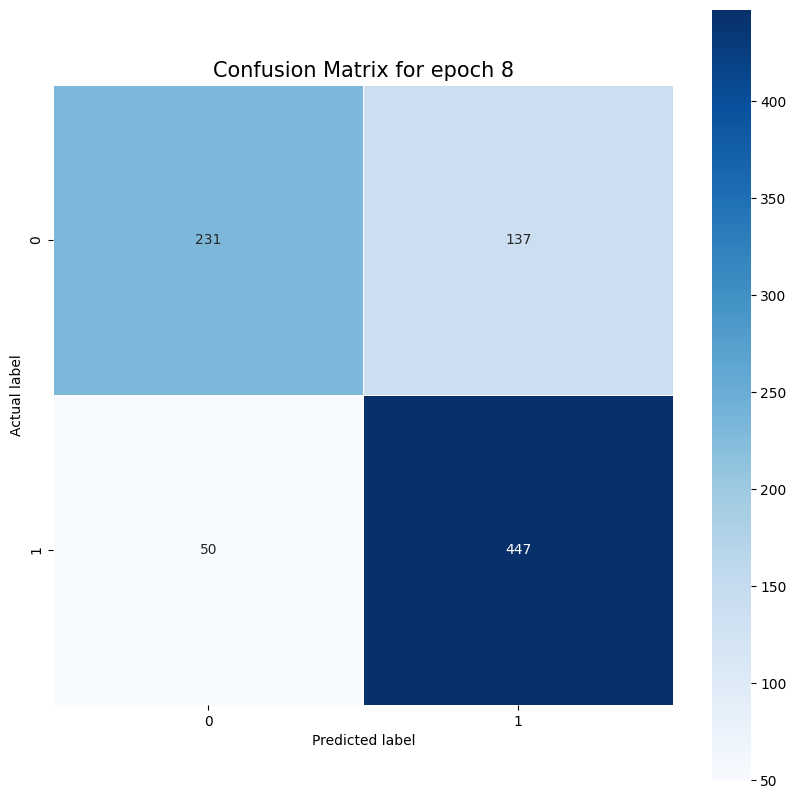

Epoch 9/10:   0%|          | 1/865 [00:04<1:01:29,  4.27s/it]

Accuracy of the model after epoch 9: 100.0%


Epoch 9/10:   0%|          | 2/865 [00:08<1:02:37,  4.35s/it]

Accuracy of the model after epoch 9: 100.0%


Epoch 9/10:   0%|          | 3/865 [00:13<1:08:01,  4.74s/it]

Accuracy of the model after epoch 9: 66.66666666666667%


Epoch 9/10:   0%|          | 4/865 [00:16<56:37,  3.95s/it]  

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:   1%|          | 5/865 [00:19<51:33,  3.60s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:   1%|          | 6/865 [00:24<55:30,  3.88s/it]

Accuracy of the model after epoch 9: 83.33333333333333%


Epoch 9/10:   1%|          | 7/865 [00:28<57:46,  4.04s/it]

Accuracy of the model after epoch 9: 85.71428571428571%


Epoch 9/10:   1%|          | 8/865 [00:32<58:33,  4.10s/it]

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:   1%|          | 9/865 [00:37<1:01:07,  4.28s/it]

Accuracy of the model after epoch 9: 66.66666666666667%


Epoch 9/10:   1%|          | 10/865 [00:41<1:01:56,  4.35s/it]

Accuracy of the model after epoch 9: 70.0%


Epoch 9/10:   1%|▏         | 11/865 [00:45<1:00:35,  4.26s/it]

Accuracy of the model after epoch 9: 72.72727272727273%


Epoch 9/10:   1%|▏         | 12/865 [00:49<59:34,  4.19s/it]  

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:   2%|▏         | 13/865 [00:54<1:01:14,  4.31s/it]

Accuracy of the model after epoch 9: 76.92307692307692%


Epoch 9/10:   2%|▏         | 14/865 [00:56<53:07,  3.75s/it]  

Accuracy of the model after epoch 9: 78.57142857142857%


Epoch 9/10:   2%|▏         | 15/865 [01:01<56:43,  4.00s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:   2%|▏         | 16/865 [01:06<1:00:06,  4.25s/it]

Accuracy of the model after epoch 9: 81.25%


Epoch 9/10:   2%|▏         | 17/865 [01:08<53:21,  3.78s/it]  

Accuracy of the model after epoch 9: 82.3529411764706%


Epoch 9/10:   2%|▏         | 18/865 [01:11<47:21,  3.35s/it]

Accuracy of the model after epoch 9: 83.33333333333333%


Epoch 9/10:   2%|▏         | 19/865 [01:16<54:05,  3.84s/it]

Accuracy of the model after epoch 9: 84.21052631578948%


Epoch 9/10:   2%|▏         | 20/865 [01:19<49:09,  3.49s/it]

Accuracy of the model after epoch 9: 85.0%


Epoch 9/10:   2%|▏         | 21/865 [01:23<52:49,  3.75s/it]

Accuracy of the model after epoch 9: 85.71428571428571%


Epoch 9/10:   3%|▎         | 22/865 [01:25<47:19,  3.37s/it]

Accuracy of the model after epoch 9: 86.36363636363636%


Epoch 9/10:   3%|▎         | 23/865 [01:30<50:43,  3.61s/it]

Accuracy of the model after epoch 9: 86.95652173913044%


Epoch 9/10:   3%|▎         | 24/865 [01:34<54:12,  3.87s/it]

Accuracy of the model after epoch 9: 83.33333333333333%


Epoch 9/10:   3%|▎         | 25/865 [01:37<50:22,  3.60s/it]

Accuracy of the model after epoch 9: 84.0%


Epoch 9/10:   3%|▎         | 26/865 [01:41<52:28,  3.75s/it]

Accuracy of the model after epoch 9: 84.61538461538461%


Epoch 9/10:   3%|▎         | 27/865 [01:46<56:04,  4.02s/it]

Accuracy of the model after epoch 9: 85.18518518518519%


Epoch 9/10:   3%|▎         | 28/865 [01:50<57:16,  4.11s/it]

Accuracy of the model after epoch 9: 85.71428571428571%


Epoch 9/10:   3%|▎         | 29/865 [01:52<50:10,  3.60s/it]

Accuracy of the model after epoch 9: 86.20689655172414%


Epoch 9/10:   3%|▎         | 30/865 [01:57<53:46,  3.86s/it]

Accuracy of the model after epoch 9: 86.66666666666667%


Epoch 9/10:   4%|▎         | 31/865 [01:59<47:42,  3.43s/it]

Accuracy of the model after epoch 9: 87.09677419354838%


Epoch 9/10:   4%|▎         | 32/865 [02:04<50:44,  3.66s/it]

Accuracy of the model after epoch 9: 87.5%


Epoch 9/10:   4%|▍         | 33/865 [02:08<53:47,  3.88s/it]

Accuracy of the model after epoch 9: 87.87878787878788%


Epoch 9/10:   4%|▍         | 34/865 [02:13<57:17,  4.14s/it]

Accuracy of the model after epoch 9: 85.29411764705883%


Epoch 9/10:   4%|▍         | 35/865 [02:17<59:43,  4.32s/it]

Accuracy of the model after epoch 9: 85.71428571428571%


Epoch 9/10:   4%|▍         | 36/865 [02:22<58:53,  4.26s/it]

Accuracy of the model after epoch 9: 86.11111111111111%


Epoch 9/10:   4%|▍         | 37/865 [02:24<51:58,  3.77s/it]

Accuracy of the model after epoch 9: 83.78378378378379%


Epoch 9/10:   4%|▍         | 38/865 [02:27<46:28,  3.37s/it]

Accuracy of the model after epoch 9: 84.21052631578948%


Epoch 9/10:   5%|▍         | 39/865 [02:29<43:27,  3.16s/it]

Accuracy of the model after epoch 9: 84.61538461538461%


Epoch 9/10:   5%|▍         | 40/865 [02:34<51:32,  3.75s/it]

Accuracy of the model after epoch 9: 85.0%


Epoch 9/10:   5%|▍         | 41/865 [02:39<53:59,  3.93s/it]

Accuracy of the model after epoch 9: 82.92682926829268%


Epoch 9/10:   5%|▍         | 42/865 [02:43<55:36,  4.05s/it]

Accuracy of the model after epoch 9: 83.33333333333333%


Epoch 9/10:   5%|▍         | 43/865 [02:48<59:31,  4.34s/it]

Accuracy of the model after epoch 9: 83.72093023255815%


Epoch 9/10:   5%|▌         | 44/865 [02:54<1:04:19,  4.70s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:   5%|▌         | 45/865 [02:58<1:03:59,  4.68s/it]

Accuracy of the model after epoch 9: 82.22222222222223%


Epoch 9/10:   5%|▌         | 46/865 [03:01<53:56,  3.95s/it]  

Accuracy of the model after epoch 9: 82.6086956521739%


Epoch 9/10:   5%|▌         | 47/865 [03:05<55:38,  4.08s/it]

Accuracy of the model after epoch 9: 80.85106382978724%


Epoch 9/10:   6%|▌         | 48/865 [03:10<58:39,  4.31s/it]

Accuracy of the model after epoch 9: 81.25%


Epoch 9/10:   6%|▌         | 49/865 [03:14<1:00:19,  4.44s/it]

Accuracy of the model after epoch 9: 79.59183673469387%


Epoch 9/10:   6%|▌         | 50/865 [03:20<1:03:04,  4.64s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:   6%|▌         | 51/865 [03:22<54:26,  4.01s/it]  

Accuracy of the model after epoch 9: 80.3921568627451%


Epoch 9/10:   6%|▌         | 52/865 [03:25<48:16,  3.56s/it]

Accuracy of the model after epoch 9: 78.84615384615384%


Epoch 9/10:   6%|▌         | 53/865 [03:29<53:03,  3.92s/it]

Accuracy of the model after epoch 9: 77.35849056603773%


Epoch 9/10:   6%|▌         | 54/865 [03:34<56:01,  4.14s/it]

Accuracy of the model after epoch 9: 75.92592592592592%


Epoch 9/10:   6%|▋         | 55/865 [03:39<59:01,  4.37s/it]

Accuracy of the model after epoch 9: 76.36363636363636%


Epoch 9/10:   6%|▋         | 56/865 [03:43<58:13,  4.32s/it]

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:   7%|▋         | 57/865 [03:47<57:38,  4.28s/it]

Accuracy of the model after epoch 9: 73.6842105263158%


Epoch 9/10:   7%|▋         | 58/865 [03:52<57:47,  4.30s/it]

Accuracy of the model after epoch 9: 72.41379310344827%


Epoch 9/10:   7%|▋         | 59/865 [03:57<59:58,  4.47s/it]

Accuracy of the model after epoch 9: 72.88135593220339%


Epoch 9/10:   7%|▋         | 60/865 [03:59<53:11,  3.96s/it]

Accuracy of the model after epoch 9: 73.33333333333333%


Epoch 9/10:   7%|▋         | 61/865 [04:03<53:47,  4.01s/it]

Accuracy of the model after epoch 9: 73.77049180327869%


Epoch 9/10:   7%|▋         | 62/865 [04:06<47:56,  3.58s/it]

Accuracy of the model after epoch 9: 72.58064516129032%


Epoch 9/10:   7%|▋         | 63/865 [04:09<44:21,  3.32s/it]

Accuracy of the model after epoch 9: 73.01587301587301%


Epoch 9/10:   7%|▋         | 64/865 [04:13<47:49,  3.58s/it]

Accuracy of the model after epoch 9: 73.4375%


Epoch 9/10:   8%|▊         | 65/865 [04:18<52:51,  3.96s/it]

Accuracy of the model after epoch 9: 73.84615384615384%


Epoch 9/10:   8%|▊         | 66/865 [04:22<53:25,  4.01s/it]

Accuracy of the model after epoch 9: 74.24242424242425%


Epoch 9/10:   8%|▊         | 67/865 [04:26<54:28,  4.10s/it]

Accuracy of the model after epoch 9: 73.13432835820896%


Epoch 9/10:   8%|▊         | 68/865 [04:31<55:47,  4.20s/it]

Accuracy of the model after epoch 9: 73.52941176470588%


Epoch 9/10:   8%|▊         | 69/865 [04:36<58:38,  4.42s/it]

Accuracy of the model after epoch 9: 72.46376811594203%


Epoch 9/10:   8%|▊         | 70/865 [04:38<51:11,  3.86s/it]

Accuracy of the model after epoch 9: 71.42857142857143%


Epoch 9/10:   8%|▊         | 71/865 [04:42<52:21,  3.96s/it]

Accuracy of the model after epoch 9: 70.4225352112676%


Epoch 9/10:   8%|▊         | 72/865 [04:47<53:40,  4.06s/it]

Accuracy of the model after epoch 9: 70.83333333333333%


Epoch 9/10:   8%|▊         | 73/865 [04:51<55:45,  4.22s/it]

Accuracy of the model after epoch 9: 71.23287671232876%


Epoch 9/10:   9%|▊         | 74/865 [04:56<57:56,  4.39s/it]

Accuracy of the model after epoch 9: 71.62162162162163%


Epoch 9/10:   9%|▊         | 75/865 [05:01<59:47,  4.54s/it]

Accuracy of the model after epoch 9: 72.0%


Epoch 9/10:   9%|▉         | 76/865 [05:03<51:06,  3.89s/it]

Accuracy of the model after epoch 9: 71.05263157894737%


Epoch 9/10:   9%|▉         | 77/865 [05:06<45:58,  3.50s/it]

Accuracy of the model after epoch 9: 70.12987012987013%


Epoch 9/10:   9%|▉         | 78/865 [05:10<48:59,  3.74s/it]

Accuracy of the model after epoch 9: 70.51282051282051%


Epoch 9/10:   9%|▉         | 79/865 [05:15<52:13,  3.99s/it]

Accuracy of the model after epoch 9: 70.88607594936708%


Epoch 9/10:   9%|▉         | 80/865 [05:19<54:05,  4.13s/it]

Accuracy of the model after epoch 9: 71.25%


Epoch 9/10:   9%|▉         | 81/865 [05:22<47:57,  3.67s/it]

Accuracy of the model after epoch 9: 71.60493827160494%


Epoch 9/10:   9%|▉         | 82/865 [05:26<50:49,  3.89s/it]

Accuracy of the model after epoch 9: 71.95121951219512%


Epoch 9/10:  10%|▉         | 83/865 [05:30<51:50,  3.98s/it]

Accuracy of the model after epoch 9: 72.28915662650603%


Epoch 9/10:  10%|▉         | 84/865 [05:35<54:14,  4.17s/it]

Accuracy of the model after epoch 9: 71.42857142857143%


Epoch 9/10:  10%|▉         | 85/865 [05:40<56:43,  4.36s/it]

Accuracy of the model after epoch 9: 71.76470588235294%


Epoch 9/10:  10%|▉         | 86/865 [05:42<49:36,  3.82s/it]

Accuracy of the model after epoch 9: 72.09302325581395%


Epoch 9/10:  10%|█         | 87/865 [05:45<44:17,  3.42s/it]

Accuracy of the model after epoch 9: 72.41379310344827%


Epoch 9/10:  10%|█         | 88/865 [05:49<47:12,  3.65s/it]

Accuracy of the model after epoch 9: 72.72727272727273%


Epoch 9/10:  10%|█         | 89/865 [05:53<49:23,  3.82s/it]

Accuracy of the model after epoch 9: 73.03370786516854%


Epoch 9/10:  10%|█         | 90/865 [05:56<45:41,  3.54s/it]

Accuracy of the model after epoch 9: 73.33333333333333%


Epoch 9/10:  11%|█         | 91/865 [05:59<41:39,  3.23s/it]

Accuracy of the model after epoch 9: 73.62637362637362%


Epoch 9/10:  11%|█         | 92/865 [06:03<47:10,  3.66s/it]

Accuracy of the model after epoch 9: 73.91304347826087%


Epoch 9/10:  11%|█         | 93/865 [06:08<50:05,  3.89s/it]

Accuracy of the model after epoch 9: 74.19354838709677%


Epoch 9/10:  11%|█         | 94/865 [06:12<51:58,  4.05s/it]

Accuracy of the model after epoch 9: 74.46808510638297%


Epoch 9/10:  11%|█         | 95/865 [06:17<53:18,  4.15s/it]

Accuracy of the model after epoch 9: 74.73684210526316%


Epoch 9/10:  11%|█         | 96/865 [06:21<54:45,  4.27s/it]

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:  11%|█         | 97/865 [06:25<54:50,  4.28s/it]

Accuracy of the model after epoch 9: 75.25773195876289%


Epoch 9/10:  11%|█▏        | 98/865 [06:31<58:57,  4.61s/it]

Accuracy of the model after epoch 9: 75.51020408163265%


Epoch 9/10:  11%|█▏        | 99/865 [06:36<1:02:38,  4.91s/it]

Accuracy of the model after epoch 9: 75.75757575757575%


Epoch 9/10:  12%|█▏        | 100/865 [06:41<1:01:06,  4.79s/it]

Accuracy of the model after epoch 9: 75.0%


Epoch 9/10:  12%|█▏        | 101/865 [06:45<59:30,  4.67s/it]  

Accuracy of the model after epoch 9: 75.24752475247524%


Epoch 9/10:  12%|█▏        | 102/865 [06:48<51:48,  4.07s/it]

Accuracy of the model after epoch 9: 75.49019607843137%


Epoch 9/10:  12%|█▏        | 103/865 [06:52<52:34,  4.14s/it]

Accuracy of the model after epoch 9: 75.72815533980582%


Epoch 9/10:  12%|█▏        | 104/865 [06:57<55:21,  4.36s/it]

Accuracy of the model after epoch 9: 75.96153846153847%


Epoch 9/10:  12%|█▏        | 105/865 [07:00<49:27,  3.90s/it]

Accuracy of the model after epoch 9: 76.19047619047619%


Epoch 9/10:  12%|█▏        | 106/865 [07:04<50:58,  4.03s/it]

Accuracy of the model after epoch 9: 75.47169811320755%


Epoch 9/10:  12%|█▏        | 107/865 [07:09<51:30,  4.08s/it]

Accuracy of the model after epoch 9: 75.70093457943925%


Epoch 9/10:  12%|█▏        | 108/865 [07:13<52:02,  4.12s/it]

Accuracy of the model after epoch 9: 75.92592592592592%


Epoch 9/10:  13%|█▎        | 109/865 [07:18<54:43,  4.34s/it]

Accuracy of the model after epoch 9: 75.22935779816514%


Epoch 9/10:  13%|█▎        | 110/865 [07:22<55:38,  4.42s/it]

Accuracy of the model after epoch 9: 75.45454545454545%


Epoch 9/10:  13%|█▎        | 111/865 [07:27<57:05,  4.54s/it]

Accuracy of the model after epoch 9: 75.67567567567568%


Epoch 9/10:  13%|█▎        | 112/865 [07:29<48:44,  3.88s/it]

Accuracy of the model after epoch 9: 75.89285714285714%


Epoch 9/10:  13%|█▎        | 113/865 [07:32<43:28,  3.47s/it]

Accuracy of the model after epoch 9: 76.10619469026548%


Epoch 9/10:  13%|█▎        | 114/865 [07:36<45:31,  3.64s/it]

Accuracy of the model after epoch 9: 76.3157894736842%


Epoch 9/10:  13%|█▎        | 115/865 [07:40<48:39,  3.89s/it]

Accuracy of the model after epoch 9: 76.52173913043478%


Epoch 9/10:  13%|█▎        | 116/865 [07:45<49:33,  3.97s/it]

Accuracy of the model after epoch 9: 76.72413793103448%


Epoch 9/10:  14%|█▎        | 117/865 [07:47<43:46,  3.51s/it]

Accuracy of the model after epoch 9: 76.92307692307692%


Epoch 9/10:  14%|█▎        | 118/865 [07:51<46:34,  3.74s/it]

Accuracy of the model after epoch 9: 77.11864406779661%


Epoch 9/10:  14%|█▍        | 119/865 [07:56<50:26,  4.06s/it]

Accuracy of the model after epoch 9: 77.3109243697479%


Epoch 9/10:  14%|█▍        | 120/865 [07:59<46:20,  3.73s/it]

Accuracy of the model after epoch 9: 77.5%


Epoch 9/10:  14%|█▍        | 121/865 [08:02<41:33,  3.35s/it]

Accuracy of the model after epoch 9: 77.68595041322314%


Epoch 9/10:  14%|█▍        | 122/865 [08:06<45:06,  3.64s/it]

Accuracy of the model after epoch 9: 77.8688524590164%


Epoch 9/10:  14%|█▍        | 123/865 [08:10<47:06,  3.81s/it]

Accuracy of the model after epoch 9: 78.04878048780488%


Epoch 9/10:  14%|█▍        | 124/865 [08:12<41:34,  3.37s/it]

Accuracy of the model after epoch 9: 78.2258064516129%


Epoch 9/10:  14%|█▍        | 125/865 [08:15<38:57,  3.16s/it]

Accuracy of the model after epoch 9: 78.4%


Epoch 9/10:  15%|█▍        | 126/865 [08:19<42:59,  3.49s/it]

Accuracy of the model after epoch 9: 77.77777777777777%


Epoch 9/10:  15%|█▍        | 127/865 [08:22<39:10,  3.18s/it]

Accuracy of the model after epoch 9: 77.95275590551181%


Epoch 9/10:  15%|█▍        | 128/865 [08:24<36:32,  2.98s/it]

Accuracy of the model after epoch 9: 78.125%


Epoch 9/10:  15%|█▍        | 129/865 [08:28<40:35,  3.31s/it]

Accuracy of the model after epoch 9: 77.51937984496124%


Epoch 9/10:  15%|█▌        | 130/865 [08:31<38:21,  3.13s/it]

Accuracy of the model after epoch 9: 77.6923076923077%


Epoch 9/10:  15%|█▌        | 131/865 [08:35<42:31,  3.48s/it]

Accuracy of the model after epoch 9: 77.86259541984732%


Epoch 9/10:  15%|█▌        | 132/865 [08:38<38:41,  3.17s/it]

Accuracy of the model after epoch 9: 78.03030303030303%


Epoch 9/10:  15%|█▌        | 133/865 [08:42<42:16,  3.46s/it]

Accuracy of the model after epoch 9: 78.19548872180451%


Epoch 9/10:  15%|█▌        | 134/865 [08:46<45:27,  3.73s/it]

Accuracy of the model after epoch 9: 78.35820895522389%


Epoch 9/10:  16%|█▌        | 135/865 [08:51<48:16,  3.97s/it]

Accuracy of the model after epoch 9: 77.77777777777777%


Epoch 9/10:  16%|█▌        | 136/865 [08:55<49:57,  4.11s/it]

Accuracy of the model after epoch 9: 77.94117647058823%


Epoch 9/10:  16%|█▌        | 137/865 [08:58<43:56,  3.62s/it]

Accuracy of the model after epoch 9: 78.10218978102189%


Epoch 9/10:  16%|█▌        | 138/865 [09:02<46:26,  3.83s/it]

Accuracy of the model after epoch 9: 78.26086956521739%


Epoch 9/10:  16%|█▌        | 139/865 [09:04<40:34,  3.35s/it]

Accuracy of the model after epoch 9: 78.41726618705036%


Epoch 9/10:  16%|█▌        | 140/865 [09:09<45:34,  3.77s/it]

Accuracy of the model after epoch 9: 78.57142857142857%


Epoch 9/10:  16%|█▋        | 141/865 [09:14<48:36,  4.03s/it]

Accuracy of the model after epoch 9: 78.72340425531915%


Epoch 9/10:  16%|█▋        | 142/865 [09:18<49:37,  4.12s/it]

Accuracy of the model after epoch 9: 78.87323943661971%


Epoch 9/10:  17%|█▋        | 143/865 [09:22<50:12,  4.17s/it]

Accuracy of the model after epoch 9: 79.02097902097903%


Epoch 9/10:  17%|█▋        | 144/865 [09:27<53:25,  4.45s/it]

Accuracy of the model after epoch 9: 79.16666666666667%


Epoch 9/10:  17%|█▋        | 145/865 [09:30<47:42,  3.98s/it]

Accuracy of the model after epoch 9: 79.3103448275862%


Epoch 9/10:  17%|█▋        | 146/865 [09:35<49:38,  4.14s/it]

Accuracy of the model after epoch 9: 79.45205479452055%


Epoch 9/10:  17%|█▋        | 147/865 [09:39<50:18,  4.20s/it]

Accuracy of the model after epoch 9: 79.59183673469387%


Epoch 9/10:  17%|█▋        | 148/865 [09:43<50:28,  4.22s/it]

Accuracy of the model after epoch 9: 79.72972972972973%


Epoch 9/10:  17%|█▋        | 149/865 [09:46<43:46,  3.67s/it]

Accuracy of the model after epoch 9: 79.86577181208054%


Epoch 9/10:  17%|█▋        | 150/865 [09:50<46:11,  3.88s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  17%|█▋        | 151/865 [09:53<40:44,  3.42s/it]

Accuracy of the model after epoch 9: 80.13245033112582%


Epoch 9/10:  18%|█▊        | 152/865 [09:55<37:02,  3.12s/it]

Accuracy of the model after epoch 9: 80.26315789473684%


Epoch 9/10:  18%|█▊        | 153/865 [09:58<35:18,  2.97s/it]

Accuracy of the model after epoch 9: 80.3921568627451%


Epoch 9/10:  18%|█▊        | 154/865 [10:00<33:36,  2.84s/it]

Accuracy of the model after epoch 9: 80.51948051948052%


Epoch 9/10:  18%|█▊        | 155/865 [10:03<33:14,  2.81s/it]

Accuracy of the model after epoch 9: 80.64516129032258%


Epoch 9/10:  18%|█▊        | 156/865 [10:08<39:51,  3.37s/it]

Accuracy of the model after epoch 9: 80.76923076923077%


Epoch 9/10:  18%|█▊        | 157/865 [10:10<36:42,  3.11s/it]

Accuracy of the model after epoch 9: 80.89171974522293%


Epoch 9/10:  18%|█▊        | 158/865 [10:14<41:11,  3.50s/it]

Accuracy of the model after epoch 9: 81.0126582278481%


Epoch 9/10:  18%|█▊        | 159/865 [10:17<36:40,  3.12s/it]

Accuracy of the model after epoch 9: 81.13207547169812%


Epoch 9/10:  18%|█▊        | 160/865 [10:21<41:14,  3.51s/it]

Accuracy of the model after epoch 9: 80.625%


Epoch 9/10:  19%|█▊        | 161/865 [10:25<44:17,  3.78s/it]

Accuracy of the model after epoch 9: 80.12422360248448%


Epoch 9/10:  19%|█▊        | 162/865 [10:30<47:20,  4.04s/it]

Accuracy of the model after epoch 9: 80.24691358024691%


Epoch 9/10:  19%|█▉        | 163/865 [10:33<42:21,  3.62s/it]

Accuracy of the model after epoch 9: 80.3680981595092%


Epoch 9/10:  19%|█▉        | 164/865 [10:37<45:40,  3.91s/it]

Accuracy of the model after epoch 9: 80.48780487804878%


Epoch 9/10:  19%|█▉        | 165/865 [10:42<47:42,  4.09s/it]

Accuracy of the model after epoch 9: 80.60606060606061%


Epoch 9/10:  19%|█▉        | 166/865 [10:46<47:45,  4.10s/it]

Accuracy of the model after epoch 9: 80.12048192771084%


Epoch 9/10:  19%|█▉        | 167/865 [10:50<48:10,  4.14s/it]

Accuracy of the model after epoch 9: 80.23952095808383%


Epoch 9/10:  19%|█▉        | 168/865 [10:55<50:49,  4.37s/it]

Accuracy of the model after epoch 9: 80.35714285714286%


Epoch 9/10:  20%|█▉        | 169/865 [11:00<53:48,  4.64s/it]

Accuracy of the model after epoch 9: 80.4733727810651%


Epoch 9/10:  20%|█▉        | 170/865 [11:05<53:00,  4.58s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  20%|█▉        | 171/865 [11:07<45:27,  3.93s/it]

Accuracy of the model after epoch 9: 80.11695906432749%


Epoch 9/10:  20%|█▉        | 172/865 [11:12<48:06,  4.16s/it]

Accuracy of the model after epoch 9: 80.23255813953489%


Epoch 9/10:  20%|██        | 173/865 [11:16<48:58,  4.25s/it]

Accuracy of the model after epoch 9: 80.34682080924856%


Epoch 9/10:  20%|██        | 174/865 [11:21<51:03,  4.43s/it]

Accuracy of the model after epoch 9: 80.45977011494253%


Epoch 9/10:  20%|██        | 175/865 [11:26<51:04,  4.44s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  20%|██        | 176/865 [11:28<44:26,  3.87s/it]

Accuracy of the model after epoch 9: 80.11363636363636%


Epoch 9/10:  20%|██        | 177/865 [11:31<40:19,  3.52s/it]

Accuracy of the model after epoch 9: 79.66101694915254%


Epoch 9/10:  21%|██        | 178/865 [11:36<44:29,  3.89s/it]

Accuracy of the model after epoch 9: 79.7752808988764%


Epoch 9/10:  21%|██        | 179/865 [11:40<46:18,  4.05s/it]

Accuracy of the model after epoch 9: 79.88826815642459%


Epoch 9/10:  21%|██        | 180/865 [11:45<47:31,  4.16s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  21%|██        | 181/865 [11:49<47:53,  4.20s/it]

Accuracy of the model after epoch 9: 80.11049723756906%


Epoch 9/10:  21%|██        | 182/865 [11:51<42:20,  3.72s/it]

Accuracy of the model after epoch 9: 80.21978021978022%


Epoch 9/10:  21%|██        | 183/865 [11:56<43:51,  3.86s/it]

Accuracy of the model after epoch 9: 80.32786885245902%


Epoch 9/10:  21%|██▏       | 184/865 [11:58<38:38,  3.40s/it]

Accuracy of the model after epoch 9: 80.43478260869566%


Epoch 9/10:  21%|██▏       | 185/865 [12:01<36:54,  3.26s/it]

Accuracy of the model after epoch 9: 80.54054054054055%


Epoch 9/10:  22%|██▏       | 186/865 [12:05<41:09,  3.64s/it]

Accuracy of the model after epoch 9: 80.64516129032258%


Epoch 9/10:  22%|██▏       | 187/865 [12:10<43:23,  3.84s/it]

Accuracy of the model after epoch 9: 80.74866310160428%


Epoch 9/10:  22%|██▏       | 188/865 [12:14<45:44,  4.05s/it]

Accuracy of the model after epoch 9: 80.85106382978724%


Epoch 9/10:  22%|██▏       | 189/865 [12:19<48:44,  4.33s/it]

Accuracy of the model after epoch 9: 80.95238095238095%


Epoch 9/10:  22%|██▏       | 190/865 [12:24<50:05,  4.45s/it]

Accuracy of the model after epoch 9: 81.05263157894737%


Epoch 9/10:  22%|██▏       | 191/865 [12:28<48:57,  4.36s/it]

Accuracy of the model after epoch 9: 81.15183246073299%


Epoch 9/10:  22%|██▏       | 192/865 [12:32<48:50,  4.35s/it]

Accuracy of the model after epoch 9: 80.72916666666667%


Epoch 9/10:  22%|██▏       | 193/865 [12:35<42:17,  3.78s/it]

Accuracy of the model after epoch 9: 80.82901554404145%


Epoch 9/10:  22%|██▏       | 194/865 [12:40<45:40,  4.08s/it]

Accuracy of the model after epoch 9: 80.9278350515464%


Epoch 9/10:  23%|██▎       | 195/865 [12:44<47:14,  4.23s/it]

Accuracy of the model after epoch 9: 81.02564102564102%


Epoch 9/10:  23%|██▎       | 196/865 [12:49<47:29,  4.26s/it]

Accuracy of the model after epoch 9: 81.12244897959184%


Epoch 9/10:  23%|██▎       | 197/865 [12:53<48:41,  4.37s/it]

Accuracy of the model after epoch 9: 81.21827411167513%


Epoch 9/10:  23%|██▎       | 198/865 [12:58<50:15,  4.52s/it]

Accuracy of the model after epoch 9: 81.31313131313131%


Epoch 9/10:  23%|██▎       | 199/865 [13:04<53:15,  4.80s/it]

Accuracy of the model after epoch 9: 80.90452261306532%


Epoch 9/10:  23%|██▎       | 200/865 [13:08<52:08,  4.70s/it]

Accuracy of the model after epoch 9: 81.0%


Epoch 9/10:  23%|██▎       | 201/865 [13:10<44:12,  3.99s/it]

Accuracy of the model after epoch 9: 81.09452736318408%


Epoch 9/10:  23%|██▎       | 202/865 [13:15<45:44,  4.14s/it]

Accuracy of the model after epoch 9: 80.6930693069307%


Epoch 9/10:  23%|██▎       | 203/865 [13:19<46:18,  4.20s/it]

Accuracy of the model after epoch 9: 80.78817733990148%


Epoch 9/10:  24%|██▎       | 204/865 [13:24<47:38,  4.32s/it]

Accuracy of the model after epoch 9: 80.88235294117646%


Epoch 9/10:  24%|██▎       | 205/865 [13:27<42:58,  3.91s/it]

Accuracy of the model after epoch 9: 80.97560975609755%


Epoch 9/10:  24%|██▍       | 206/865 [13:31<43:52,  3.99s/it]

Accuracy of the model after epoch 9: 81.06796116504854%


Epoch 9/10:  24%|██▍       | 207/865 [13:35<44:44,  4.08s/it]

Accuracy of the model after epoch 9: 80.67632850241546%


Epoch 9/10:  24%|██▍       | 208/865 [13:38<39:31,  3.61s/it]

Accuracy of the model after epoch 9: 80.76923076923077%


Epoch 9/10:  24%|██▍       | 209/865 [13:40<35:39,  3.26s/it]

Accuracy of the model after epoch 9: 80.86124401913875%


Epoch 9/10:  24%|██▍       | 210/865 [13:43<32:57,  3.02s/it]

Accuracy of the model after epoch 9: 80.95238095238095%


Epoch 9/10:  24%|██▍       | 211/865 [13:47<37:22,  3.43s/it]

Accuracy of the model after epoch 9: 80.56872037914692%


Epoch 9/10:  25%|██▍       | 212/865 [13:51<39:51,  3.66s/it]

Accuracy of the model after epoch 9: 80.18867924528301%


Epoch 9/10:  25%|██▍       | 213/865 [13:56<43:42,  4.02s/it]

Accuracy of the model after epoch 9: 80.28169014084507%


Epoch 9/10:  25%|██▍       | 214/865 [14:01<46:27,  4.28s/it]

Accuracy of the model after epoch 9: 80.37383177570094%


Epoch 9/10:  25%|██▍       | 215/865 [14:06<48:39,  4.49s/it]

Accuracy of the model after epoch 9: 80.46511627906976%


Epoch 9/10:  25%|██▍       | 216/865 [14:09<42:29,  3.93s/it]

Accuracy of the model after epoch 9: 80.55555555555556%


Epoch 9/10:  25%|██▌       | 217/865 [14:11<38:05,  3.53s/it]

Accuracy of the model after epoch 9: 80.64516129032258%


Epoch 9/10:  25%|██▌       | 218/865 [14:14<34:28,  3.20s/it]

Accuracy of the model after epoch 9: 80.73394495412845%


Epoch 9/10:  25%|██▌       | 219/865 [14:18<37:31,  3.48s/it]

Accuracy of the model after epoch 9: 80.82191780821918%


Epoch 9/10:  25%|██▌       | 220/865 [14:22<40:40,  3.78s/it]

Accuracy of the model after epoch 9: 80.45454545454545%


Epoch 9/10:  26%|██▌       | 221/865 [14:27<42:14,  3.94s/it]

Accuracy of the model after epoch 9: 80.54298642533936%


Epoch 9/10:  26%|██▌       | 222/865 [14:31<43:21,  4.05s/it]

Accuracy of the model after epoch 9: 80.63063063063063%


Epoch 9/10:  26%|██▌       | 223/865 [14:36<47:04,  4.40s/it]

Accuracy of the model after epoch 9: 80.26905829596413%


Epoch 9/10:  26%|██▌       | 224/865 [14:41<49:55,  4.67s/it]

Accuracy of the model after epoch 9: 79.91071428571429%


Epoch 9/10:  26%|██▌       | 225/865 [14:44<43:28,  4.08s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  26%|██▌       | 226/865 [14:49<44:39,  4.19s/it]

Accuracy of the model after epoch 9: 80.08849557522124%


Epoch 9/10:  26%|██▌       | 227/865 [14:53<44:23,  4.17s/it]

Accuracy of the model after epoch 9: 80.1762114537445%


Epoch 9/10:  26%|██▋       | 228/865 [14:57<45:01,  4.24s/it]

Accuracy of the model after epoch 9: 80.26315789473684%


Epoch 9/10:  26%|██▋       | 229/865 [15:02<46:39,  4.40s/it]

Accuracy of the model after epoch 9: 80.34934497816595%


Epoch 9/10:  27%|██▋       | 230/865 [15:05<41:51,  3.96s/it]

Accuracy of the model after epoch 9: 80.43478260869566%


Epoch 9/10:  27%|██▋       | 231/865 [15:07<36:47,  3.48s/it]

Accuracy of the model after epoch 9: 80.51948051948052%


Epoch 9/10:  27%|██▋       | 232/865 [15:09<33:10,  3.15s/it]

Accuracy of the model after epoch 9: 80.60344827586206%


Epoch 9/10:  27%|██▋       | 233/865 [15:14<36:34,  3.47s/it]

Accuracy of the model after epoch 9: 80.68669527896996%


Epoch 9/10:  27%|██▋       | 234/865 [15:18<38:50,  3.69s/it]

Accuracy of the model after epoch 9: 80.34188034188034%


Epoch 9/10:  27%|██▋       | 235/865 [15:23<42:12,  4.02s/it]

Accuracy of the model after epoch 9: 80.42553191489361%


Epoch 9/10:  27%|██▋       | 236/865 [15:27<43:11,  4.12s/it]

Accuracy of the model after epoch 9: 80.08474576271186%


Epoch 9/10:  27%|██▋       | 237/865 [15:31<44:05,  4.21s/it]

Accuracy of the model after epoch 9: 80.16877637130801%


Epoch 9/10:  28%|██▊       | 238/865 [15:36<45:20,  4.34s/it]

Accuracy of the model after epoch 9: 80.25210084033614%


Epoch 9/10:  28%|██▊       | 239/865 [15:41<47:09,  4.52s/it]

Accuracy of the model after epoch 9: 80.3347280334728%


Epoch 9/10:  28%|██▊       | 240/865 [15:46<47:36,  4.57s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  28%|██▊       | 241/865 [15:48<40:56,  3.94s/it]

Accuracy of the model after epoch 9: 80.08298755186722%


Epoch 9/10:  28%|██▊       | 242/865 [15:52<41:42,  4.02s/it]

Accuracy of the model after epoch 9: 80.16528925619835%


Epoch 9/10:  28%|██▊       | 243/865 [15:57<42:12,  4.07s/it]

Accuracy of the model after epoch 9: 80.24691358024691%


Epoch 9/10:  28%|██▊       | 244/865 [16:02<44:56,  4.34s/it]

Accuracy of the model after epoch 9: 80.32786885245902%


Epoch 9/10:  28%|██▊       | 245/865 [16:06<45:40,  4.42s/it]

Accuracy of the model after epoch 9: 80.40816326530613%


Epoch 9/10:  28%|██▊       | 246/865 [16:11<45:59,  4.46s/it]

Accuracy of the model after epoch 9: 80.48780487804878%


Epoch 9/10:  29%|██▊       | 247/865 [16:13<39:12,  3.81s/it]

Accuracy of the model after epoch 9: 80.56680161943319%


Epoch 9/10:  29%|██▊       | 248/865 [16:17<40:37,  3.95s/it]

Accuracy of the model after epoch 9: 80.64516129032258%


Epoch 9/10:  29%|██▉       | 249/865 [16:22<43:25,  4.23s/it]

Accuracy of the model after epoch 9: 80.72289156626506%


Epoch 9/10:  29%|██▉       | 250/865 [16:27<44:29,  4.34s/it]

Accuracy of the model after epoch 9: 80.8%


Epoch 9/10:  29%|██▉       | 251/865 [16:29<38:17,  3.74s/it]

Accuracy of the model after epoch 9: 80.87649402390439%


Epoch 9/10:  29%|██▉       | 252/865 [16:33<40:01,  3.92s/it]

Accuracy of the model after epoch 9: 80.95238095238095%


Epoch 9/10:  29%|██▉       | 253/865 [16:38<41:19,  4.05s/it]

Accuracy of the model after epoch 9: 81.02766798418972%


Epoch 9/10:  29%|██▉       | 254/865 [16:43<43:21,  4.26s/it]

Accuracy of the model after epoch 9: 81.10236220472441%


Epoch 9/10:  29%|██▉       | 255/865 [16:45<38:44,  3.81s/it]

Accuracy of the model after epoch 9: 80.7843137254902%


Epoch 9/10:  30%|██▉       | 256/865 [16:50<39:58,  3.94s/it]

Accuracy of the model after epoch 9: 80.859375%


Epoch 9/10:  30%|██▉       | 257/865 [16:52<34:59,  3.45s/it]

Accuracy of the model after epoch 9: 80.93385214007782%


Epoch 9/10:  30%|██▉       | 258/865 [16:54<32:07,  3.18s/it]

Accuracy of the model after epoch 9: 81.0077519379845%


Epoch 9/10:  30%|██▉       | 259/865 [16:57<30:18,  3.00s/it]

Accuracy of the model after epoch 9: 81.08108108108108%


Epoch 9/10:  30%|███       | 260/865 [17:00<29:48,  2.96s/it]

Accuracy of the model after epoch 9: 81.15384615384616%


Epoch 9/10:  30%|███       | 261/865 [17:04<34:43,  3.45s/it]

Accuracy of the model after epoch 9: 81.22605363984674%


Epoch 9/10:  30%|███       | 262/865 [17:07<31:48,  3.16s/it]

Accuracy of the model after epoch 9: 81.29770992366412%


Epoch 9/10:  30%|███       | 263/865 [17:09<29:43,  2.96s/it]

Accuracy of the model after epoch 9: 81.36882129277566%


Epoch 9/10:  31%|███       | 264/865 [17:12<27:41,  2.76s/it]

Accuracy of the model after epoch 9: 81.43939393939394%


Epoch 9/10:  31%|███       | 265/865 [17:16<32:29,  3.25s/it]

Accuracy of the model after epoch 9: 81.50943396226415%


Epoch 9/10:  31%|███       | 266/865 [17:20<35:46,  3.58s/it]

Accuracy of the model after epoch 9: 81.57894736842105%


Epoch 9/10:  31%|███       | 267/865 [17:25<37:39,  3.78s/it]

Accuracy of the model after epoch 9: 81.27340823970037%


Epoch 9/10:  31%|███       | 268/865 [17:29<39:15,  3.95s/it]

Accuracy of the model after epoch 9: 81.34328358208955%


Epoch 9/10:  31%|███       | 269/865 [17:34<41:28,  4.17s/it]

Accuracy of the model after epoch 9: 81.41263940520446%


Epoch 9/10:  31%|███       | 270/865 [17:36<36:51,  3.72s/it]

Accuracy of the model after epoch 9: 81.48148148148148%


Epoch 9/10:  31%|███▏      | 271/865 [17:41<38:27,  3.89s/it]

Accuracy of the model after epoch 9: 81.54981549815498%


Epoch 9/10:  31%|███▏      | 272/865 [17:45<39:49,  4.03s/it]

Accuracy of the model after epoch 9: 81.61764705882354%


Epoch 9/10:  32%|███▏      | 273/865 [17:49<39:55,  4.05s/it]

Accuracy of the model after epoch 9: 81.68498168498168%


Epoch 9/10:  32%|███▏      | 274/865 [17:52<35:24,  3.59s/it]

Accuracy of the model after epoch 9: 81.38686131386861%


Epoch 9/10:  32%|███▏      | 275/865 [17:57<39:47,  4.05s/it]

Accuracy of the model after epoch 9: 81.0909090909091%


Epoch 9/10:  32%|███▏      | 276/865 [18:01<41:17,  4.21s/it]

Accuracy of the model after epoch 9: 81.15942028985508%


Epoch 9/10:  32%|███▏      | 277/865 [18:04<35:43,  3.65s/it]

Accuracy of the model after epoch 9: 80.86642599277978%


Epoch 9/10:  32%|███▏      | 278/865 [18:08<38:42,  3.96s/it]

Accuracy of the model after epoch 9: 80.93525179856115%


Epoch 9/10:  32%|███▏      | 279/865 [18:11<34:25,  3.52s/it]

Accuracy of the model after epoch 9: 81.00358422939068%


Epoch 9/10:  32%|███▏      | 280/865 [18:14<32:35,  3.34s/it]

Accuracy of the model after epoch 9: 81.07142857142857%


Epoch 9/10:  32%|███▏      | 281/865 [18:18<35:25,  3.64s/it]

Accuracy of the model after epoch 9: 80.7829181494662%


Epoch 9/10:  33%|███▎      | 282/865 [18:23<37:30,  3.86s/it]

Accuracy of the model after epoch 9: 80.49645390070921%


Epoch 9/10:  33%|███▎      | 283/865 [18:27<40:23,  4.16s/it]

Accuracy of the model after epoch 9: 80.21201413427562%


Epoch 9/10:  33%|███▎      | 284/865 [18:30<35:16,  3.64s/it]

Accuracy of the model after epoch 9: 80.28169014084507%


Epoch 9/10:  33%|███▎      | 285/865 [18:33<32:33,  3.37s/it]

Accuracy of the model after epoch 9: 80.35087719298245%


Epoch 9/10:  33%|███▎      | 286/865 [18:35<30:04,  3.12s/it]

Accuracy of the model after epoch 9: 80.41958041958041%


Epoch 9/10:  33%|███▎      | 287/865 [18:37<27:54,  2.90s/it]

Accuracy of the model after epoch 9: 80.48780487804878%


Epoch 9/10:  33%|███▎      | 288/865 [18:40<26:31,  2.76s/it]

Accuracy of the model after epoch 9: 80.55555555555556%


Epoch 9/10:  33%|███▎      | 289/865 [18:42<25:51,  2.69s/it]

Accuracy of the model after epoch 9: 80.62283737024221%


Epoch 9/10:  34%|███▎      | 290/865 [18:47<31:06,  3.25s/it]

Accuracy of the model after epoch 9: 80.6896551724138%


Epoch 9/10:  34%|███▎      | 291/865 [18:49<28:58,  3.03s/it]

Accuracy of the model after epoch 9: 80.75601374570446%


Epoch 9/10:  34%|███▍      | 292/865 [18:54<32:49,  3.44s/it]

Accuracy of the model after epoch 9: 80.47945205479452%


Epoch 9/10:  34%|███▍      | 293/865 [18:56<30:22,  3.19s/it]

Accuracy of the model after epoch 9: 80.54607508532423%


Epoch 9/10:  34%|███▍      | 294/865 [19:01<33:28,  3.52s/it]

Accuracy of the model after epoch 9: 80.61224489795919%


Epoch 9/10:  34%|███▍      | 295/865 [19:04<31:12,  3.29s/it]

Accuracy of the model after epoch 9: 80.67796610169492%


Epoch 9/10:  34%|███▍      | 296/865 [19:08<34:14,  3.61s/it]

Accuracy of the model after epoch 9: 80.74324324324324%


Epoch 9/10:  34%|███▍      | 297/865 [19:12<36:10,  3.82s/it]

Accuracy of the model after epoch 9: 80.47138047138047%


Epoch 9/10:  34%|███▍      | 298/865 [19:17<38:38,  4.09s/it]

Accuracy of the model after epoch 9: 80.20134228187919%


Epoch 9/10:  35%|███▍      | 299/865 [19:22<40:24,  4.28s/it]

Accuracy of the model after epoch 9: 80.2675585284281%


Epoch 9/10:  35%|███▍      | 300/865 [19:26<41:01,  4.36s/it]

Accuracy of the model after epoch 9: 80.33333333333333%


Epoch 9/10:  35%|███▍      | 301/865 [19:31<41:10,  4.38s/it]

Accuracy of the model after epoch 9: 80.39867109634551%


Epoch 9/10:  35%|███▍      | 302/865 [19:33<35:46,  3.81s/it]

Accuracy of the model after epoch 9: 80.13245033112582%


Epoch 9/10:  35%|███▌      | 303/865 [19:35<31:32,  3.37s/it]

Accuracy of the model after epoch 9: 80.1980198019802%


Epoch 9/10:  35%|███▌      | 304/865 [19:40<34:22,  3.68s/it]

Accuracy of the model after epoch 9: 80.26315789473684%


Epoch 9/10:  35%|███▌      | 305/865 [19:43<31:44,  3.40s/it]

Accuracy of the model after epoch 9: 80.32786885245902%


Epoch 9/10:  35%|███▌      | 306/865 [19:47<33:34,  3.60s/it]

Accuracy of the model after epoch 9: 80.3921568627451%


Epoch 9/10:  35%|███▌      | 307/865 [19:51<35:42,  3.84s/it]

Accuracy of the model after epoch 9: 80.13029315960912%


Epoch 9/10:  36%|███▌      | 308/865 [19:56<38:29,  4.15s/it]

Accuracy of the model after epoch 9: 80.1948051948052%


Epoch 9/10:  36%|███▌      | 309/865 [20:01<40:09,  4.33s/it]

Accuracy of the model after epoch 9: 80.2588996763754%


Epoch 9/10:  36%|███▌      | 310/865 [20:05<40:57,  4.43s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  36%|███▌      | 311/865 [20:09<39:58,  4.33s/it]

Accuracy of the model after epoch 9: 80.06430868167203%


Epoch 9/10:  36%|███▌      | 312/865 [20:14<39:25,  4.28s/it]

Accuracy of the model after epoch 9: 80.12820512820512%


Epoch 9/10:  36%|███▌      | 313/865 [20:16<34:29,  3.75s/it]

Accuracy of the model after epoch 9: 80.19169329073482%


Epoch 9/10:  36%|███▋      | 314/865 [20:21<37:53,  4.13s/it]

Accuracy of the model after epoch 9: 80.2547770700637%


Epoch 9/10:  36%|███▋      | 315/865 [20:24<33:57,  3.70s/it]

Accuracy of the model after epoch 9: 80.31746031746032%


Epoch 9/10:  37%|███▋      | 316/865 [20:28<35:19,  3.86s/it]

Accuracy of the model after epoch 9: 80.37974683544304%


Epoch 9/10:  37%|███▋      | 317/865 [20:32<36:24,  3.99s/it]

Accuracy of the model after epoch 9: 80.4416403785489%


Epoch 9/10:  37%|███▋      | 318/865 [20:37<38:37,  4.24s/it]

Accuracy of the model after epoch 9: 80.50314465408805%


Epoch 9/10:  37%|███▋      | 319/865 [20:42<41:12,  4.53s/it]

Accuracy of the model after epoch 9: 80.25078369905957%


Epoch 9/10:  37%|███▋      | 320/865 [20:47<41:06,  4.53s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  37%|███▋      | 321/865 [20:51<39:52,  4.40s/it]

Accuracy of the model after epoch 9: 80.06230529595015%


Epoch 9/10:  37%|███▋      | 322/865 [20:55<39:39,  4.38s/it]

Accuracy of the model after epoch 9: 79.8136645962733%


Epoch 9/10:  37%|███▋      | 323/865 [21:00<39:35,  4.38s/it]

Accuracy of the model after epoch 9: 79.87616099071208%


Epoch 9/10:  37%|███▋      | 324/865 [21:05<40:59,  4.55s/it]

Accuracy of the model after epoch 9: 79.93827160493827%


Epoch 9/10:  38%|███▊      | 325/865 [21:09<41:21,  4.60s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  38%|███▊      | 326/865 [21:12<35:30,  3.95s/it]

Accuracy of the model after epoch 9: 80.06134969325153%


Epoch 9/10:  38%|███▊      | 327/865 [21:16<36:31,  4.07s/it]

Accuracy of the model after epoch 9: 80.1223241590214%


Epoch 9/10:  38%|███▊      | 328/865 [21:20<36:51,  4.12s/it]

Accuracy of the model after epoch 9: 80.1829268292683%


Epoch 9/10:  38%|███▊      | 329/865 [21:25<38:21,  4.29s/it]

Accuracy of the model after epoch 9: 80.24316109422493%


Epoch 9/10:  38%|███▊      | 330/865 [21:30<40:39,  4.56s/it]

Accuracy of the model after epoch 9: 80.3030303030303%


Epoch 9/10:  38%|███▊      | 331/865 [21:33<34:31,  3.88s/it]

Accuracy of the model after epoch 9: 80.36253776435045%


Epoch 9/10:  38%|███▊      | 332/865 [21:37<34:48,  3.92s/it]

Accuracy of the model after epoch 9: 80.42168674698796%


Epoch 9/10:  38%|███▊      | 333/865 [21:41<35:58,  4.06s/it]

Accuracy of the model after epoch 9: 80.48048048048048%


Epoch 9/10:  39%|███▊      | 334/865 [21:43<31:48,  3.59s/it]

Accuracy of the model after epoch 9: 80.53892215568862%


Epoch 9/10:  39%|███▊      | 335/865 [21:48<34:26,  3.90s/it]

Accuracy of the model after epoch 9: 80.59701492537313%


Epoch 9/10:  39%|███▉      | 336/865 [21:52<35:23,  4.01s/it]

Accuracy of the model after epoch 9: 80.6547619047619%


Epoch 9/10:  39%|███▉      | 337/865 [21:55<31:02,  3.53s/it]

Accuracy of the model after epoch 9: 80.41543026706232%


Epoch 9/10:  39%|███▉      | 338/865 [21:59<33:14,  3.79s/it]

Accuracy of the model after epoch 9: 80.1775147928994%


Epoch 9/10:  39%|███▉      | 339/865 [22:04<36:06,  4.12s/it]

Accuracy of the model after epoch 9: 79.9410029498525%


Epoch 9/10:  39%|███▉      | 340/865 [22:09<37:17,  4.26s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  39%|███▉      | 341/865 [22:13<37:23,  4.28s/it]

Accuracy of the model after epoch 9: 80.05865102639297%


Epoch 9/10:  40%|███▉      | 342/865 [22:18<38:37,  4.43s/it]

Accuracy of the model after epoch 9: 79.82456140350877%


Epoch 9/10:  40%|███▉      | 343/865 [22:22<39:04,  4.49s/it]

Accuracy of the model after epoch 9: 79.88338192419825%


Epoch 9/10:  40%|███▉      | 344/865 [22:28<42:32,  4.90s/it]

Accuracy of the model after epoch 9: 79.94186046511628%


Epoch 9/10:  40%|███▉      | 345/865 [22:33<41:32,  4.79s/it]

Accuracy of the model after epoch 9: 80.0%


Epoch 9/10:  40%|████      | 346/865 [22:37<39:49,  4.60s/it]

Accuracy of the model after epoch 9: 80.05780346820809%


Epoch 9/10:  40%|████      | 347/865 [22:42<39:51,  4.62s/it]

Accuracy of the model after epoch 9: 80.11527377521614%


Epoch 9/10:  40%|████      | 348/865 [22:46<39:02,  4.53s/it]

Accuracy of the model after epoch 9: 80.17241379310344%


Epoch 9/10:  40%|████      | 349/865 [22:51<39:22,  4.58s/it]

Accuracy of the model after epoch 9: 80.22922636103152%


Epoch 9/10:  40%|████      | 350/865 [22:53<34:26,  4.01s/it]

Accuracy of the model after epoch 9: 80.28571428571429%


Epoch 9/10:  41%|████      | 351/865 [22:56<29:57,  3.50s/it]

Accuracy of the model after epoch 9: 80.34188034188034%


Epoch 9/10:  41%|████      | 352/865 [23:00<31:53,  3.73s/it]

Accuracy of the model after epoch 9: 80.39772727272727%


Epoch 9/10:  41%|████      | 353/865 [23:04<32:28,  3.81s/it]

Accuracy of the model after epoch 9: 80.45325779036827%


Epoch 9/10:  41%|████      | 354/865 [23:06<28:32,  3.35s/it]

Accuracy of the model after epoch 9: 80.50847457627118%


Epoch 9/10:  41%|████      | 355/865 [23:11<32:11,  3.79s/it]

Accuracy of the model after epoch 9: 80.56338028169014%


Epoch 9/10:  41%|████      | 356/865 [23:16<34:14,  4.04s/it]

Accuracy of the model after epoch 9: 80.61797752808988%


Epoch 9/10:  41%|████▏     | 357/865 [23:20<34:18,  4.05s/it]

Accuracy of the model after epoch 9: 80.67226890756302%


Epoch 9/10:  41%|████▏     | 358/865 [23:25<36:33,  4.33s/it]

Accuracy of the model after epoch 9: 80.72625698324022%


Epoch 9/10:  42%|████▏     | 359/865 [23:27<31:48,  3.77s/it]

Accuracy of the model after epoch 9: 80.77994428969359%


Epoch 9/10:  42%|████▏     | 360/865 [23:32<33:36,  3.99s/it]

Accuracy of the model after epoch 9: 80.55555555555556%


Epoch 9/10:  42%|████▏     | 361/865 [23:36<34:40,  4.13s/it]

Accuracy of the model after epoch 9: 80.60941828254848%


Epoch 9/10:  42%|████▏     | 362/865 [23:39<30:47,  3.67s/it]

Accuracy of the model after epoch 9: 80.66298342541437%


Epoch 9/10:  42%|████▏     | 363/865 [23:43<32:35,  3.90s/it]

Accuracy of the model after epoch 9: 80.71625344352617%


Epoch 9/10:  42%|████▏     | 364/865 [23:48<34:12,  4.10s/it]

Accuracy of the model after epoch 9: 80.49450549450549%


Epoch 9/10:  42%|████▏     | 365/865 [23:53<36:26,  4.37s/it]

Accuracy of the model after epoch 9: 80.54794520547945%


Epoch 9/10:  42%|████▏     | 366/865 [23:57<36:15,  4.36s/it]

Accuracy of the model after epoch 9: 80.60109289617486%


Epoch 9/10:  42%|████▏     | 367/865 [24:01<36:08,  4.35s/it]

Accuracy of the model after epoch 9: 80.65395095367847%


Epoch 9/10:  43%|████▎     | 368/865 [24:06<37:05,  4.48s/it]

Accuracy of the model after epoch 9: 80.70652173913044%


Epoch 9/10:  43%|████▎     | 369/865 [24:11<39:01,  4.72s/it]

Accuracy of the model after epoch 9: 80.75880758807588%


Epoch 9/10:  43%|████▎     | 370/865 [24:14<34:05,  4.13s/it]

Accuracy of the model after epoch 9: 80.8108108108108%


Epoch 9/10:  43%|████▎     | 371/865 [24:18<34:13,  4.16s/it]

Accuracy of the model after epoch 9: 80.86253369272237%


Epoch 9/10:  43%|████▎     | 372/865 [24:23<34:42,  4.22s/it]

Accuracy of the model after epoch 9: 80.91397849462365%


Epoch 9/10:  43%|████▎     | 373/865 [24:28<36:08,  4.41s/it]

Accuracy of the model after epoch 9: 80.6970509383378%


Epoch 9/10:  43%|████▎     | 374/865 [24:30<31:11,  3.81s/it]

Accuracy of the model after epoch 9: 80.74866310160428%


Epoch 9/10:  43%|████▎     | 375/865 [24:34<32:27,  3.97s/it]

Accuracy of the model after epoch 9: 80.8%


Epoch 9/10:  43%|████▎     | 376/865 [24:37<28:59,  3.56s/it]

Accuracy of the model after epoch 9: 80.85106382978724%


Epoch 9/10:  44%|████▎     | 377/865 [24:41<30:05,  3.70s/it]

Accuracy of the model after epoch 9: 80.90185676392574%


Epoch 9/10:  44%|████▎     | 378/865 [24:43<26:43,  3.29s/it]

Accuracy of the model after epoch 9: 80.95238095238095%


Epoch 9/10:  44%|████▍     | 379/865 [24:48<30:01,  3.71s/it]

Accuracy of the model after epoch 9: 81.00263852242745%


Epoch 9/10:  44%|████▍     | 380/865 [24:52<31:40,  3.92s/it]

Accuracy of the model after epoch 9: 81.05263157894737%


Epoch 9/10:  44%|████▍     | 381/865 [24:57<32:25,  4.02s/it]

Accuracy of the model after epoch 9: 80.83989501312335%


Epoch 9/10:  44%|████▍     | 382/865 [25:01<32:36,  4.05s/it]

Accuracy of the model after epoch 9: 80.89005235602095%


Epoch 9/10:  44%|████▍     | 383/865 [25:05<34:03,  4.24s/it]

Accuracy of the model after epoch 9: 80.93994778067885%


Epoch 9/10:  44%|████▍     | 384/865 [25:08<29:47,  3.72s/it]

Accuracy of the model after epoch 9: 80.98958333333333%


Epoch 9/10:  45%|████▍     | 385/865 [25:13<32:02,  4.01s/it]

Accuracy of the model after epoch 9: 81.03896103896103%


Epoch 9/10:  45%|████▍     | 386/865 [25:17<32:13,  4.04s/it]

Accuracy of the model after epoch 9: 81.0880829015544%


Epoch 9/10:  45%|████▍     | 387/865 [25:21<33:10,  4.16s/it]

Accuracy of the model after epoch 9: 81.13695090439276%


Epoch 9/10:  45%|████▍     | 388/865 [25:26<34:36,  4.35s/it]

Accuracy of the model after epoch 9: 81.18556701030928%


Epoch 9/10:  45%|████▍     | 389/865 [25:31<36:22,  4.58s/it]

Accuracy of the model after epoch 9: 80.97686375321337%


Epoch 9/10:  45%|████▌     | 390/865 [25:34<31:59,  4.04s/it]

Accuracy of the model after epoch 9: 81.02564102564102%


Epoch 9/10:  45%|████▌     | 391/865 [25:38<32:41,  4.14s/it]

Accuracy of the model after epoch 9: 80.81841432225065%


Epoch 9/10:  45%|████▌     | 392/865 [25:43<33:51,  4.29s/it]

Accuracy of the model after epoch 9: 80.86734693877551%


Epoch 9/10:  45%|████▌     | 393/865 [25:47<33:46,  4.29s/it]

Accuracy of the model after epoch 9: 80.6615776081425%


Epoch 9/10:  46%|████▌     | 394/865 [25:52<33:57,  4.33s/it]

Accuracy of the model after epoch 9: 80.71065989847716%


Epoch 9/10:  46%|████▌     | 395/865 [25:56<34:32,  4.41s/it]

Accuracy of the model after epoch 9: 80.75949367088607%


Epoch 9/10:  46%|████▌     | 396/865 [25:59<29:51,  3.82s/it]

Accuracy of the model after epoch 9: 80.8080808080808%


Epoch 9/10:  46%|████▌     | 397/865 [26:01<26:44,  3.43s/it]

Accuracy of the model after epoch 9: 80.85642317380352%


Epoch 9/10:  46%|████▌     | 398/865 [26:05<28:20,  3.64s/it]

Accuracy of the model after epoch 9: 80.90452261306532%


Epoch 9/10:  46%|████▌     | 399/865 [26:10<29:56,  3.86s/it]

Accuracy of the model after epoch 9: 80.95238095238095%


Epoch 9/10:  46%|████▌     | 400/865 [26:14<31:48,  4.10s/it]

Accuracy of the model after epoch 9: 81.0%


Epoch 9/10:  46%|████▋     | 401/865 [26:19<32:45,  4.24s/it]

Accuracy of the model after epoch 9: 81.04738154613466%


Epoch 9/10:  46%|████▋     | 402/865 [26:23<32:28,  4.21s/it]

Accuracy of the model after epoch 9: 81.09452736318408%


Epoch 9/10:  47%|████▋     | 403/865 [26:25<28:07,  3.65s/it]

Accuracy of the model after epoch 9: 81.14143920595534%


Epoch 9/10:  47%|████▋     | 404/865 [26:30<29:45,  3.87s/it]

Accuracy of the model after epoch 9: 81.18811881188118%


Epoch 9/10:  47%|████▋     | 405/865 [26:34<31:00,  4.05s/it]

Accuracy of the model after epoch 9: 81.23456790123457%


Epoch 9/10:  47%|████▋     | 406/865 [26:38<31:20,  4.10s/it]

Accuracy of the model after epoch 9: 81.2807881773399%


Epoch 9/10:  47%|████▋     | 407/865 [26:43<32:03,  4.20s/it]

Accuracy of the model after epoch 9: 81.32678132678133%


Epoch 9/10:  47%|████▋     | 408/865 [26:48<33:04,  4.34s/it]

Accuracy of the model after epoch 9: 81.12745098039215%


Epoch 9/10:  47%|████▋     | 409/865 [26:53<35:03,  4.61s/it]

Accuracy of the model after epoch 9: 81.17359413202934%


Epoch 9/10:  47%|████▋     | 410/865 [26:56<30:49,  4.06s/it]

Accuracy of the model after epoch 9: 81.21951219512195%


Epoch 9/10:  48%|████▊     | 411/865 [26:58<26:52,  3.55s/it]

Accuracy of the model after epoch 9: 81.02189781021897%


Epoch 9/10:  48%|████▊     | 412/865 [27:02<28:40,  3.80s/it]

Accuracy of the model after epoch 9: 81.06796116504854%


Epoch 9/10:  48%|████▊     | 413/865 [27:07<29:48,  3.96s/it]

Accuracy of the model after epoch 9: 81.1138014527845%


Epoch 9/10:  48%|████▊     | 414/865 [27:09<26:41,  3.55s/it]

Accuracy of the model after epoch 9: 81.15942028985508%


Epoch 9/10:  48%|████▊     | 415/865 [27:14<28:44,  3.83s/it]

Accuracy of the model after epoch 9: 81.20481927710843%


Epoch 9/10:  48%|████▊     | 416/865 [27:18<29:28,  3.94s/it]

Accuracy of the model after epoch 9: 81.25%


Epoch 9/10:  48%|████▊     | 417/865 [27:22<29:42,  3.98s/it]

Accuracy of the model after epoch 9: 81.29496402877697%


Epoch 9/10:  48%|████▊     | 418/865 [27:26<30:11,  4.05s/it]

Accuracy of the model after epoch 9: 81.33971291866028%


Epoch 9/10:  48%|████▊     | 419/865 [27:31<31:34,  4.25s/it]

Accuracy of the model after epoch 9: 81.14558472553699%


Epoch 9/10:  49%|████▊     | 420/865 [27:34<27:57,  3.77s/it]

Accuracy of the model after epoch 9: 81.19047619047619%


Epoch 9/10:  49%|████▊     | 421/865 [27:36<25:00,  3.38s/it]

Accuracy of the model after epoch 9: 81.23515439429929%


Epoch 9/10:  49%|████▉     | 422/865 [27:38<22:45,  3.08s/it]

Accuracy of the model after epoch 9: 81.27962085308057%


Epoch 9/10:  49%|████▉     | 423/865 [27:43<26:06,  3.54s/it]

Accuracy of the model after epoch 9: 81.08747044917257%


Epoch 9/10:  49%|████▉     | 424/865 [27:48<28:25,  3.87s/it]

Accuracy of the model after epoch 9: 81.13207547169812%


Epoch 9/10:  49%|████▉     | 425/865 [27:53<30:46,  4.20s/it]

Accuracy of the model after epoch 9: 81.17647058823529%


Epoch 9/10:  49%|████▉     | 426/865 [27:55<27:14,  3.72s/it]

Accuracy of the model after epoch 9: 81.22065727699531%


Epoch 9/10:  49%|████▉     | 427/865 [28:00<28:38,  3.92s/it]

Accuracy of the model after epoch 9: 81.26463700234191%


Epoch 9/10:  49%|████▉     | 428/865 [28:04<29:36,  4.06s/it]

Accuracy of the model after epoch 9: 81.30841121495327%


Epoch 9/10:  50%|████▉     | 429/865 [28:06<25:52,  3.56s/it]

Accuracy of the model after epoch 9: 81.35198135198135%


Epoch 9/10:  50%|████▉     | 430/865 [28:11<29:02,  4.01s/it]

Accuracy of the model after epoch 9: 81.3953488372093%


Epoch 9/10:  50%|████▉     | 431/865 [28:16<29:25,  4.07s/it]

Accuracy of the model after epoch 9: 81.4385150812065%


Epoch 9/10:  50%|████▉     | 432/865 [28:20<30:03,  4.16s/it]

Accuracy of the model after epoch 9: 81.48148148148148%


Epoch 9/10:  50%|█████     | 433/865 [28:24<30:16,  4.20s/it]

Accuracy of the model after epoch 9: 81.29330254041571%


Epoch 9/10:  50%|█████     | 434/865 [28:29<31:18,  4.36s/it]

Accuracy of the model after epoch 9: 81.33640552995392%


Epoch 9/10:  50%|█████     | 435/865 [28:33<31:15,  4.36s/it]

Accuracy of the model after epoch 9: 81.37931034482759%


Epoch 9/10:  50%|█████     | 436/865 [28:36<27:10,  3.80s/it]

Accuracy of the model after epoch 9: 81.42201834862385%


Epoch 9/10:  51%|█████     | 437/865 [28:41<29:11,  4.09s/it]

Accuracy of the model after epoch 9: 81.46453089244851%


Epoch 9/10:  51%|█████     | 438/865 [28:43<25:52,  3.64s/it]

Accuracy of the model after epoch 9: 81.5068493150685%


Epoch 9/10:  51%|█████     | 439/865 [28:48<27:48,  3.92s/it]

Accuracy of the model after epoch 9: 81.54897494305239%


Epoch 9/10:  51%|█████     | 440/865 [28:50<24:37,  3.48s/it]

Accuracy of the model after epoch 9: 81.5909090909091%


Epoch 9/10:  51%|█████     | 441/865 [28:55<27:54,  3.95s/it]

Accuracy of the model after epoch 9: 81.63265306122449%


Epoch 9/10:  51%|█████     | 442/865 [29:00<28:34,  4.05s/it]

Accuracy of the model after epoch 9: 81.44796380090497%


Epoch 9/10:  51%|█████     | 443/865 [29:04<28:50,  4.10s/it]

Accuracy of the model after epoch 9: 81.48984198645599%


Epoch 9/10:  51%|█████▏    | 444/865 [29:09<29:58,  4.27s/it]

Accuracy of the model after epoch 9: 81.53153153153153%


Epoch 9/10:  51%|█████▏    | 445/865 [29:13<30:27,  4.35s/it]

Accuracy of the model after epoch 9: 81.57303370786516%


Epoch 9/10:  52%|█████▏    | 446/865 [29:17<30:23,  4.35s/it]

Accuracy of the model after epoch 9: 81.61434977578476%


Epoch 9/10:  52%|█████▏    | 447/865 [29:22<30:03,  4.31s/it]

Accuracy of the model after epoch 9: 81.65548098434004%


Epoch 9/10:  52%|█████▏    | 448/865 [29:26<30:44,  4.42s/it]

Accuracy of the model after epoch 9: 81.69642857142857%


Epoch 9/10:  52%|█████▏    | 449/865 [29:29<26:02,  3.76s/it]

Accuracy of the model after epoch 9: 81.73719376391982%


Epoch 9/10:  52%|█████▏    | 450/865 [29:33<27:05,  3.92s/it]

Accuracy of the model after epoch 9: 81.77777777777777%


Epoch 9/10:  52%|█████▏    | 451/865 [29:37<27:57,  4.05s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  52%|█████▏    | 452/865 [29:42<28:34,  4.15s/it]

Accuracy of the model after epoch 9: 81.85840707964601%


Epoch 9/10:  52%|█████▏    | 453/865 [29:46<28:47,  4.19s/it]

Accuracy of the model after epoch 9: 81.89845474613686%


Epoch 9/10:  52%|█████▏    | 454/865 [29:51<29:47,  4.35s/it]

Accuracy of the model after epoch 9: 81.93832599118943%


Epoch 9/10:  53%|█████▎    | 455/865 [29:53<26:14,  3.84s/it]

Accuracy of the model after epoch 9: 81.97802197802197%


Epoch 9/10:  53%|█████▎    | 456/865 [29:57<27:00,  3.96s/it]

Accuracy of the model after epoch 9: 82.01754385964912%


Epoch 9/10:  53%|█████▎    | 457/865 [30:02<27:10,  4.00s/it]

Accuracy of the model after epoch 9: 82.05689277899343%


Epoch 9/10:  53%|█████▎    | 458/865 [30:06<28:30,  4.20s/it]

Accuracy of the model after epoch 9: 82.09606986899563%


Epoch 9/10:  53%|█████▎    | 459/865 [30:11<29:10,  4.31s/it]

Accuracy of the model after epoch 9: 81.91721132897604%


Epoch 9/10:  53%|█████▎    | 460/865 [30:15<29:50,  4.42s/it]

Accuracy of the model after epoch 9: 81.95652173913044%


Epoch 9/10:  53%|█████▎    | 461/865 [30:20<29:21,  4.36s/it]

Accuracy of the model after epoch 9: 81.99566160520607%


Epoch 9/10:  53%|█████▎    | 462/865 [30:24<29:10,  4.34s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  54%|█████▎    | 463/865 [30:29<29:58,  4.47s/it]

Accuracy of the model after epoch 9: 81.8574514038877%


Epoch 9/10:  54%|█████▎    | 464/865 [30:34<32:07,  4.81s/it]

Accuracy of the model after epoch 9: 81.89655172413794%


Epoch 9/10:  54%|█████▍    | 465/865 [30:39<31:42,  4.76s/it]

Accuracy of the model after epoch 9: 81.93548387096774%


Epoch 9/10:  54%|█████▍    | 466/865 [30:44<31:16,  4.70s/it]

Accuracy of the model after epoch 9: 81.97424892703863%


Epoch 9/10:  54%|█████▍    | 467/865 [30:46<26:47,  4.04s/it]

Accuracy of the model after epoch 9: 82.01284796573876%


Epoch 9/10:  54%|█████▍    | 468/865 [30:50<27:21,  4.14s/it]

Accuracy of the model after epoch 9: 82.05128205128206%


Epoch 9/10:  54%|█████▍    | 469/865 [30:53<23:31,  3.57s/it]

Accuracy of the model after epoch 9: 81.87633262260128%


Epoch 9/10:  54%|█████▍    | 470/865 [30:55<21:37,  3.29s/it]

Accuracy of the model after epoch 9: 81.91489361702128%


Epoch 9/10:  54%|█████▍    | 471/865 [31:00<23:54,  3.64s/it]

Accuracy of the model after epoch 9: 81.95329087048832%


Epoch 9/10:  55%|█████▍    | 472/865 [31:04<25:54,  3.96s/it]

Accuracy of the model after epoch 9: 81.99152542372882%


Epoch 9/10:  55%|█████▍    | 473/865 [31:09<26:29,  4.05s/it]

Accuracy of the model after epoch 9: 82.02959830866807%


Epoch 9/10:  55%|█████▍    | 474/865 [31:11<23:28,  3.60s/it]

Accuracy of the model after epoch 9: 81.85654008438819%


Epoch 9/10:  55%|█████▍    | 475/865 [31:16<24:55,  3.83s/it]

Accuracy of the model after epoch 9: 81.89473684210526%


Epoch 9/10:  55%|█████▌    | 476/865 [31:20<25:29,  3.93s/it]

Accuracy of the model after epoch 9: 81.9327731092437%


Epoch 9/10:  55%|█████▌    | 477/865 [31:24<26:04,  4.03s/it]

Accuracy of the model after epoch 9: 81.9706498951782%


Epoch 9/10:  55%|█████▌    | 478/865 [31:27<23:13,  3.60s/it]

Accuracy of the model after epoch 9: 82.00836820083683%


Epoch 9/10:  55%|█████▌    | 479/865 [31:29<21:08,  3.29s/it]

Accuracy of the model after epoch 9: 81.83716075156576%


Epoch 9/10:  55%|█████▌    | 480/865 [31:34<23:33,  3.67s/it]

Accuracy of the model after epoch 9: 81.875%


Epoch 9/10:  56%|█████▌    | 481/865 [31:36<21:15,  3.32s/it]

Accuracy of the model after epoch 9: 81.70478170478171%


Epoch 9/10:  56%|█████▌    | 482/865 [31:41<23:14,  3.64s/it]

Accuracy of the model after epoch 9: 81.74273858921161%


Epoch 9/10:  56%|█████▌    | 483/865 [31:43<20:55,  3.29s/it]

Accuracy of the model after epoch 9: 81.78053830227744%


Epoch 9/10:  56%|█████▌    | 484/865 [31:47<22:47,  3.59s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  56%|█████▌    | 485/865 [31:52<25:03,  3.96s/it]

Accuracy of the model after epoch 9: 81.85567010309278%


Epoch 9/10:  56%|█████▌    | 486/865 [31:57<25:33,  4.05s/it]

Accuracy of the model after epoch 9: 81.6872427983539%


Epoch 9/10:  56%|█████▋    | 487/865 [32:01<25:48,  4.10s/it]

Accuracy of the model after epoch 9: 81.72484599589322%


Epoch 9/10:  56%|█████▋    | 488/865 [32:06<27:00,  4.30s/it]

Accuracy of the model after epoch 9: 81.76229508196721%


Epoch 9/10:  57%|█████▋    | 489/865 [32:11<28:37,  4.57s/it]

Accuracy of the model after epoch 9: 81.79959100204499%


Epoch 9/10:  57%|█████▋    | 490/865 [32:15<28:39,  4.58s/it]

Accuracy of the model after epoch 9: 81.83673469387755%


Epoch 9/10:  57%|█████▋    | 491/865 [32:20<27:55,  4.48s/it]

Accuracy of the model after epoch 9: 81.87372708757637%


Epoch 9/10:  57%|█████▋    | 492/865 [32:24<28:34,  4.60s/it]

Accuracy of the model after epoch 9: 81.91056910569105%


Epoch 9/10:  57%|█████▋    | 493/865 [32:29<28:47,  4.64s/it]

Accuracy of the model after epoch 9: 81.74442190669372%


Epoch 9/10:  57%|█████▋    | 494/865 [32:34<29:49,  4.82s/it]

Accuracy of the model after epoch 9: 81.78137651821862%


Epoch 9/10:  57%|█████▋    | 495/865 [32:37<26:16,  4.26s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  57%|█████▋    | 496/865 [32:42<27:23,  4.45s/it]

Accuracy of the model after epoch 9: 81.85483870967742%


Epoch 9/10:  57%|█████▋    | 497/865 [32:47<27:22,  4.46s/it]

Accuracy of the model after epoch 9: 81.69014084507042%


Epoch 9/10:  58%|█████▊    | 498/865 [32:51<26:41,  4.36s/it]

Accuracy of the model after epoch 9: 81.52610441767068%


Epoch 9/10:  58%|█████▊    | 499/865 [32:53<22:58,  3.77s/it]

Accuracy of the model after epoch 9: 81.56312625250501%


Epoch 9/10:  58%|█████▊    | 500/865 [32:58<25:16,  4.15s/it]

Accuracy of the model after epoch 9: 81.6%


Epoch 9/10:  58%|█████▊    | 501/865 [33:03<26:00,  4.29s/it]

Accuracy of the model after epoch 9: 81.63672654690619%


Epoch 9/10:  58%|█████▊    | 502/865 [33:07<25:22,  4.19s/it]

Accuracy of the model after epoch 9: 81.67330677290836%


Epoch 9/10:  58%|█████▊    | 503/865 [33:11<25:20,  4.20s/it]

Accuracy of the model after epoch 9: 81.70974155069582%


Epoch 9/10:  58%|█████▊    | 504/865 [33:17<27:28,  4.57s/it]

Accuracy of the model after epoch 9: 81.74603174603175%


Epoch 9/10:  58%|█████▊    | 505/865 [33:21<27:11,  4.53s/it]

Accuracy of the model after epoch 9: 81.78217821782178%


Epoch 9/10:  58%|█████▊    | 506/865 [33:25<26:29,  4.43s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  59%|█████▊    | 507/865 [33:28<22:54,  3.84s/it]

Accuracy of the model after epoch 9: 81.85404339250493%


Epoch 9/10:  59%|█████▊    | 508/865 [33:32<23:52,  4.01s/it]

Accuracy of the model after epoch 9: 81.88976377952756%


Epoch 9/10:  59%|█████▉    | 509/865 [33:37<25:42,  4.33s/it]

Accuracy of the model after epoch 9: 81.9253438113949%


Epoch 9/10:  59%|█████▉    | 510/865 [33:42<25:45,  4.35s/it]

Accuracy of the model after epoch 9: 81.96078431372548%


Epoch 9/10:  59%|█████▉    | 511/865 [33:46<25:17,  4.29s/it]

Accuracy of the model after epoch 9: 81.99608610567515%


Epoch 9/10:  59%|█████▉    | 512/865 [33:50<25:56,  4.41s/it]

Accuracy of the model after epoch 9: 82.03125%


Epoch 9/10:  59%|█████▉    | 513/865 [33:55<25:57,  4.43s/it]

Accuracy of the model after epoch 9: 82.06627680311891%


Epoch 9/10:  59%|█████▉    | 514/865 [34:00<26:39,  4.56s/it]

Accuracy of the model after epoch 9: 82.1011673151751%


Epoch 9/10:  60%|█████▉    | 515/865 [34:05<27:50,  4.77s/it]

Accuracy of the model after epoch 9: 82.13592233009709%


Epoch 9/10:  60%|█████▉    | 516/865 [34:09<26:48,  4.61s/it]

Accuracy of the model after epoch 9: 82.17054263565892%


Epoch 9/10:  60%|█████▉    | 517/865 [34:13<25:55,  4.47s/it]

Accuracy of the model after epoch 9: 82.01160541586073%


Epoch 9/10:  60%|█████▉    | 518/865 [34:18<26:30,  4.58s/it]

Accuracy of the model after epoch 9: 82.04633204633204%


Epoch 9/10:  60%|██████    | 519/865 [34:24<27:49,  4.82s/it]

Accuracy of the model after epoch 9: 82.08092485549133%


Epoch 9/10:  60%|██████    | 520/865 [34:28<27:21,  4.76s/it]

Accuracy of the model after epoch 9: 81.92307692307692%


Epoch 9/10:  60%|██████    | 521/865 [34:32<26:26,  4.61s/it]

Accuracy of the model after epoch 9: 81.95777351247601%


Epoch 9/10:  60%|██████    | 522/865 [34:37<25:43,  4.50s/it]

Accuracy of the model after epoch 9: 81.80076628352491%


Epoch 9/10:  60%|██████    | 523/865 [34:42<26:44,  4.69s/it]

Accuracy of the model after epoch 9: 81.64435946462716%


Epoch 9/10:  61%|██████    | 524/865 [34:47<27:34,  4.85s/it]

Accuracy of the model after epoch 9: 81.6793893129771%


Epoch 9/10:  61%|██████    | 525/865 [34:52<27:04,  4.78s/it]

Accuracy of the model after epoch 9: 81.71428571428571%


Epoch 9/10:  61%|██████    | 526/865 [34:54<22:41,  4.02s/it]

Accuracy of the model after epoch 9: 81.74904942965779%


Epoch 9/10:  61%|██████    | 527/865 [34:59<23:40,  4.20s/it]

Accuracy of the model after epoch 9: 81.59392789373814%


Epoch 9/10:  61%|██████    | 528/865 [35:03<24:07,  4.29s/it]

Accuracy of the model after epoch 9: 81.62878787878788%


Epoch 9/10:  61%|██████    | 529/865 [35:05<20:52,  3.73s/it]

Accuracy of the model after epoch 9: 81.66351606805293%


Epoch 9/10:  61%|██████▏   | 530/865 [35:10<22:10,  3.97s/it]

Accuracy of the model after epoch 9: 81.69811320754717%


Epoch 9/10:  61%|██████▏   | 531/865 [35:14<22:41,  4.08s/it]

Accuracy of the model after epoch 9: 81.54425612052731%


Epoch 9/10:  62%|██████▏   | 532/865 [35:17<20:00,  3.60s/it]

Accuracy of the model after epoch 9: 81.57894736842105%


Epoch 9/10:  62%|██████▏   | 533/865 [35:19<18:12,  3.29s/it]

Accuracy of the model after epoch 9: 81.61350844277673%


Epoch 9/10:  62%|██████▏   | 534/865 [35:24<20:09,  3.66s/it]

Accuracy of the model after epoch 9: 81.46067415730337%


Epoch 9/10:  62%|██████▏   | 535/865 [35:29<21:51,  3.97s/it]

Accuracy of the model after epoch 9: 81.49532710280374%


Epoch 9/10:  62%|██████▏   | 536/865 [35:34<23:23,  4.26s/it]

Accuracy of the model after epoch 9: 81.52985074626865%


Epoch 9/10:  62%|██████▏   | 537/865 [35:38<23:35,  4.32s/it]

Accuracy of the model after epoch 9: 81.56424581005587%


Epoch 9/10:  62%|██████▏   | 538/865 [35:42<23:51,  4.38s/it]

Accuracy of the model after epoch 9: 81.59851301115242%


Epoch 9/10:  62%|██████▏   | 539/865 [35:48<25:36,  4.71s/it]

Accuracy of the model after epoch 9: 81.63265306122449%


Epoch 9/10:  62%|██████▏   | 540/865 [35:53<25:30,  4.71s/it]

Accuracy of the model after epoch 9: 81.48148148148148%


Epoch 9/10:  63%|██████▎   | 541/865 [35:57<24:37,  4.56s/it]

Accuracy of the model after epoch 9: 81.51571164510166%


Epoch 9/10:  63%|██████▎   | 542/865 [35:59<21:06,  3.92s/it]

Accuracy of the model after epoch 9: 81.54981549815498%


Epoch 9/10:  63%|██████▎   | 543/865 [36:04<22:12,  4.14s/it]

Accuracy of the model after epoch 9: 81.58379373848987%


Epoch 9/10:  63%|██████▎   | 544/865 [36:08<22:22,  4.18s/it]

Accuracy of the model after epoch 9: 81.61764705882354%


Epoch 9/10:  63%|██████▎   | 545/865 [36:13<22:41,  4.25s/it]

Accuracy of the model after epoch 9: 81.65137614678899%


Epoch 9/10:  63%|██████▎   | 546/865 [36:17<22:52,  4.30s/it]

Accuracy of the model after epoch 9: 81.68498168498168%


Epoch 9/10:  63%|██████▎   | 547/865 [36:20<19:55,  3.76s/it]

Accuracy of the model after epoch 9: 81.71846435100548%


Epoch 9/10:  63%|██████▎   | 548/865 [36:24<20:56,  3.96s/it]

Accuracy of the model after epoch 9: 81.75182481751825%


Epoch 9/10:  63%|██████▎   | 549/865 [36:29<22:02,  4.19s/it]

Accuracy of the model after epoch 9: 81.78506375227687%


Epoch 9/10:  64%|██████▎   | 550/865 [36:33<22:34,  4.30s/it]

Accuracy of the model after epoch 9: 81.63636363636364%


Epoch 9/10:  64%|██████▎   | 551/865 [36:36<19:46,  3.78s/it]

Accuracy of the model after epoch 9: 81.66969147005445%


Epoch 9/10:  64%|██████▍   | 552/865 [36:40<20:30,  3.93s/it]

Accuracy of the model after epoch 9: 81.70289855072464%


Epoch 9/10:  64%|██████▍   | 553/865 [36:44<20:51,  4.01s/it]

Accuracy of the model after epoch 9: 81.73598553345388%


Epoch 9/10:  64%|██████▍   | 554/865 [36:49<21:54,  4.23s/it]

Accuracy of the model after epoch 9: 81.76895306859205%


Epoch 9/10:  64%|██████▍   | 555/865 [36:52<19:40,  3.81s/it]

Accuracy of the model after epoch 9: 81.8018018018018%


Epoch 9/10:  64%|██████▍   | 556/865 [36:56<20:29,  3.98s/it]

Accuracy of the model after epoch 9: 81.83453237410072%


Epoch 9/10:  64%|██████▍   | 557/865 [37:01<20:48,  4.05s/it]

Accuracy of the model after epoch 9: 81.68761220825853%


Epoch 9/10:  65%|██████▍   | 558/865 [37:06<22:11,  4.34s/it]

Accuracy of the model after epoch 9: 81.72043010752688%


Epoch 9/10:  65%|██████▍   | 559/865 [37:08<18:46,  3.68s/it]

Accuracy of the model after epoch 9: 81.7531305903399%


Epoch 9/10:  65%|██████▍   | 560/865 [37:12<19:48,  3.90s/it]

Accuracy of the model after epoch 9: 81.78571428571429%


Epoch 9/10:  65%|██████▍   | 561/865 [37:16<20:11,  3.99s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  65%|██████▍   | 562/865 [37:21<20:49,  4.12s/it]

Accuracy of the model after epoch 9: 81.85053380782918%


Epoch 9/10:  65%|██████▌   | 563/865 [37:26<21:52,  4.35s/it]

Accuracy of the model after epoch 9: 81.88277087033748%


Epoch 9/10:  65%|██████▌   | 564/865 [37:31<23:21,  4.66s/it]

Accuracy of the model after epoch 9: 81.91489361702128%


Epoch 9/10:  65%|██████▌   | 565/865 [37:36<23:31,  4.70s/it]

Accuracy of the model after epoch 9: 81.76991150442478%


Epoch 9/10:  65%|██████▌   | 566/865 [37:40<22:46,  4.57s/it]

Accuracy of the model after epoch 9: 81.80212014134275%


Epoch 9/10:  66%|██████▌   | 567/865 [37:42<19:27,  3.92s/it]

Accuracy of the model after epoch 9: 81.8342151675485%


Epoch 9/10:  66%|██████▌   | 568/865 [37:47<20:02,  4.05s/it]

Accuracy of the model after epoch 9: 81.86619718309859%


Epoch 9/10:  66%|██████▌   | 569/865 [37:49<17:48,  3.61s/it]

Accuracy of the model after epoch 9: 81.89806678383128%


Epoch 9/10:  66%|██████▌   | 570/865 [37:54<19:17,  3.92s/it]

Accuracy of the model after epoch 9: 81.9298245614035%


Epoch 9/10:  66%|██████▌   | 571/865 [37:57<17:12,  3.51s/it]

Accuracy of the model after epoch 9: 81.9614711033275%


Epoch 9/10:  66%|██████▌   | 572/865 [38:01<18:41,  3.83s/it]

Accuracy of the model after epoch 9: 81.99300699300699%


Epoch 9/10:  66%|██████▌   | 573/865 [38:05<19:24,  3.99s/it]

Accuracy of the model after epoch 9: 82.02443280977312%


Epoch 9/10:  66%|██████▋   | 574/865 [38:10<19:56,  4.11s/it]

Accuracy of the model after epoch 9: 82.05574912891986%


Epoch 9/10:  66%|██████▋   | 575/865 [38:15<20:42,  4.29s/it]

Accuracy of the model after epoch 9: 81.91304347826087%


Epoch 9/10:  67%|██████▋   | 576/865 [38:19<21:30,  4.47s/it]

Accuracy of the model after epoch 9: 81.94444444444444%


Epoch 9/10:  67%|██████▋   | 577/865 [38:22<18:14,  3.80s/it]

Accuracy of the model after epoch 9: 81.97573656845753%


Epoch 9/10:  67%|██████▋   | 578/865 [38:24<16:32,  3.46s/it]

Accuracy of the model after epoch 9: 82.00692041522491%


Epoch 9/10:  67%|██████▋   | 579/865 [38:29<18:49,  3.95s/it]

Accuracy of the model after epoch 9: 82.03799654576856%


Epoch 9/10:  67%|██████▋   | 580/865 [38:34<19:45,  4.16s/it]

Accuracy of the model after epoch 9: 82.06896551724138%


Epoch 9/10:  67%|██████▋   | 581/865 [38:38<19:50,  4.19s/it]

Accuracy of the model after epoch 9: 81.92771084337349%


Epoch 9/10:  67%|██████▋   | 582/865 [38:43<19:40,  4.17s/it]

Accuracy of the model after epoch 9: 81.95876288659794%


Epoch 9/10:  67%|██████▋   | 583/865 [38:47<20:31,  4.37s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  68%|██████▊   | 584/865 [38:52<21:13,  4.53s/it]

Accuracy of the model after epoch 9: 81.84931506849315%


Epoch 9/10:  68%|██████▊   | 585/865 [38:55<18:26,  3.95s/it]

Accuracy of the model after epoch 9: 81.88034188034187%


Epoch 9/10:  68%|██████▊   | 586/865 [38:57<16:26,  3.54s/it]

Accuracy of the model after epoch 9: 81.91126279863481%


Epoch 9/10:  68%|██████▊   | 587/865 [39:02<17:33,  3.79s/it]

Accuracy of the model after epoch 9: 81.94207836456559%


Epoch 9/10:  68%|██████▊   | 588/865 [39:04<15:39,  3.39s/it]

Accuracy of the model after epoch 9: 81.97278911564626%


Epoch 9/10:  68%|██████▊   | 589/865 [39:09<17:27,  3.80s/it]

Accuracy of the model after epoch 9: 82.00339558573855%


Epoch 9/10:  68%|██████▊   | 590/865 [39:14<18:44,  4.09s/it]

Accuracy of the model after epoch 9: 82.03389830508475%


Epoch 9/10:  68%|██████▊   | 591/865 [39:18<18:50,  4.13s/it]

Accuracy of the model after epoch 9: 82.06429780033841%


Epoch 9/10:  68%|██████▊   | 592/865 [39:22<18:56,  4.16s/it]

Accuracy of the model after epoch 9: 82.0945945945946%


Epoch 9/10:  69%|██████▊   | 593/865 [39:26<18:56,  4.18s/it]

Accuracy of the model after epoch 9: 81.95615514333896%


Epoch 9/10:  69%|██████▊   | 594/865 [39:31<19:47,  4.38s/it]

Accuracy of the model after epoch 9: 81.98653198653199%


Epoch 9/10:  69%|██████▉   | 595/865 [39:36<19:59,  4.44s/it]

Accuracy of the model after epoch 9: 81.84873949579831%


Epoch 9/10:  69%|██████▉   | 596/865 [39:40<19:48,  4.42s/it]

Accuracy of the model after epoch 9: 81.87919463087249%


Epoch 9/10:  69%|██████▉   | 597/865 [39:43<17:10,  3.84s/it]

Accuracy of the model after epoch 9: 81.90954773869346%


Epoch 9/10:  69%|██████▉   | 598/865 [39:47<17:48,  4.00s/it]

Accuracy of the model after epoch 9: 81.93979933110369%


Epoch 9/10:  69%|██████▉   | 599/865 [39:52<19:26,  4.39s/it]

Accuracy of the model after epoch 9: 81.96994991652754%


Epoch 9/10:  69%|██████▉   | 600/865 [39:55<17:02,  3.86s/it]

Accuracy of the model after epoch 9: 82.0%


Epoch 9/10:  69%|██████▉   | 601/865 [39:58<15:23,  3.50s/it]

Accuracy of the model after epoch 9: 82.02995008319468%


Epoch 9/10:  70%|██████▉   | 602/865 [40:02<16:10,  3.69s/it]

Accuracy of the model after epoch 9: 82.05980066445183%


Epoch 9/10:  70%|██████▉   | 603/865 [40:06<16:39,  3.81s/it]

Accuracy of the model after epoch 9: 82.08955223880596%


Epoch 9/10:  70%|██████▉   | 604/865 [40:10<17:15,  3.97s/it]

Accuracy of the model after epoch 9: 81.95364238410596%


Epoch 9/10:  70%|██████▉   | 605/865 [40:13<15:31,  3.58s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  70%|███████   | 606/865 [40:17<16:16,  3.77s/it]

Accuracy of the model after epoch 9: 81.84818481848185%


Epoch 9/10:  70%|███████   | 607/865 [40:22<17:05,  3.97s/it]

Accuracy of the model after epoch 9: 81.87808896210873%


Epoch 9/10:  70%|███████   | 608/865 [40:26<17:18,  4.04s/it]

Accuracy of the model after epoch 9: 81.74342105263158%


Epoch 9/10:  70%|███████   | 609/865 [40:28<15:02,  3.53s/it]

Accuracy of the model after epoch 9: 81.77339901477832%


Epoch 9/10:  71%|███████   | 610/865 [40:31<13:42,  3.23s/it]

Accuracy of the model after epoch 9: 81.63934426229508%


Epoch 9/10:  71%|███████   | 611/865 [40:35<15:05,  3.56s/it]

Accuracy of the model after epoch 9: 81.66939443535188%


Epoch 9/10:  71%|███████   | 612/865 [40:37<13:39,  3.24s/it]

Accuracy of the model after epoch 9: 81.69934640522875%


Epoch 9/10:  71%|███████   | 613/865 [40:42<14:53,  3.55s/it]

Accuracy of the model after epoch 9: 81.72920065252855%


Epoch 9/10:  71%|███████   | 614/865 [40:44<13:27,  3.22s/it]

Accuracy of the model after epoch 9: 81.75895765472313%


Epoch 9/10:  71%|███████   | 615/865 [40:49<14:48,  3.55s/it]

Accuracy of the model after epoch 9: 81.78861788617886%


Epoch 9/10:  71%|███████   | 616/865 [40:53<15:50,  3.82s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  71%|███████▏  | 617/865 [40:57<16:26,  3.98s/it]

Accuracy of the model after epoch 9: 81.84764991896272%


Epoch 9/10:  71%|███████▏  | 618/865 [41:02<17:17,  4.20s/it]

Accuracy of the model after epoch 9: 81.71521035598705%


Epoch 9/10:  72%|███████▏  | 619/865 [41:04<15:03,  3.67s/it]

Accuracy of the model after epoch 9: 81.74474959612277%


Epoch 9/10:  72%|███████▏  | 620/865 [41:09<15:52,  3.89s/it]

Accuracy of the model after epoch 9: 81.7741935483871%


Epoch 9/10:  72%|███████▏  | 621/865 [41:14<16:52,  4.15s/it]

Accuracy of the model after epoch 9: 81.64251207729468%


Epoch 9/10:  72%|███████▏  | 622/865 [41:18<16:56,  4.18s/it]

Accuracy of the model after epoch 9: 81.67202572347267%


Epoch 9/10:  72%|███████▏  | 623/865 [41:22<17:18,  4.29s/it]

Accuracy of the model after epoch 9: 81.70144462279293%


Epoch 9/10:  72%|███████▏  | 624/865 [41:28<18:34,  4.62s/it]

Accuracy of the model after epoch 9: 81.73076923076923%


Epoch 9/10:  72%|███████▏  | 625/865 [41:32<18:29,  4.62s/it]

Accuracy of the model after epoch 9: 81.76%


Epoch 9/10:  72%|███████▏  | 626/865 [41:35<15:56,  4.00s/it]

Accuracy of the model after epoch 9: 81.78913738019169%


Epoch 9/10:  72%|███████▏  | 627/865 [41:38<14:09,  3.57s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  73%|███████▎  | 628/865 [41:42<14:47,  3.75s/it]

Accuracy of the model after epoch 9: 81.84713375796179%


Epoch 9/10:  73%|███████▎  | 629/865 [41:47<16:05,  4.09s/it]

Accuracy of the model after epoch 9: 81.87599364069952%


Epoch 9/10:  73%|███████▎  | 630/865 [41:51<16:48,  4.29s/it]

Accuracy of the model after epoch 9: 81.74603174603175%


Epoch 9/10:  73%|███████▎  | 631/865 [41:56<16:44,  4.29s/it]

Accuracy of the model after epoch 9: 81.77496038034866%


Epoch 9/10:  73%|███████▎  | 632/865 [42:00<16:51,  4.34s/it]

Accuracy of the model after epoch 9: 81.80379746835443%


Epoch 9/10:  73%|███████▎  | 633/865 [42:05<16:57,  4.38s/it]

Accuracy of the model after epoch 9: 81.83254344391786%


Epoch 9/10:  73%|███████▎  | 634/865 [42:10<17:59,  4.67s/it]

Accuracy of the model after epoch 9: 81.86119873817034%


Epoch 9/10:  73%|███████▎  | 635/865 [42:15<17:57,  4.69s/it]

Accuracy of the model after epoch 9: 81.88976377952756%


Epoch 9/10:  74%|███████▎  | 636/865 [42:19<17:25,  4.56s/it]

Accuracy of the model after epoch 9: 81.76100628930817%


Epoch 9/10:  74%|███████▎  | 637/865 [42:24<17:49,  4.69s/it]

Accuracy of the model after epoch 9: 81.63265306122449%


Epoch 9/10:  74%|███████▍  | 638/865 [42:29<17:55,  4.74s/it]

Accuracy of the model after epoch 9: 81.6614420062696%


Epoch 9/10:  74%|███████▍  | 639/865 [42:34<18:23,  4.88s/it]

Accuracy of the model after epoch 9: 81.53364632237871%


Epoch 9/10:  74%|███████▍  | 640/865 [42:37<15:57,  4.26s/it]

Accuracy of the model after epoch 9: 81.5625%


Epoch 9/10:  74%|███████▍  | 641/865 [42:41<15:41,  4.20s/it]

Accuracy of the model after epoch 9: 81.59126365054603%


Epoch 9/10:  74%|███████▍  | 642/865 [42:45<15:37,  4.20s/it]

Accuracy of the model after epoch 9: 81.61993769470405%


Epoch 9/10:  74%|███████▍  | 643/865 [42:49<15:40,  4.23s/it]

Accuracy of the model after epoch 9: 81.64852255054433%


Epoch 9/10:  74%|███████▍  | 644/865 [42:54<16:06,  4.37s/it]

Accuracy of the model after epoch 9: 81.52173913043478%


Epoch 9/10:  75%|███████▍  | 645/865 [42:59<16:20,  4.46s/it]

Accuracy of the model after epoch 9: 81.55038759689923%


Epoch 9/10:  75%|███████▍  | 646/865 [43:03<16:22,  4.49s/it]

Accuracy of the model after epoch 9: 81.57894736842105%


Epoch 9/10:  75%|███████▍  | 647/865 [43:06<14:22,  3.95s/it]

Accuracy of the model after epoch 9: 81.60741885625966%


Epoch 9/10:  75%|███████▍  | 648/865 [43:10<14:52,  4.11s/it]

Accuracy of the model after epoch 9: 81.6358024691358%


Epoch 9/10:  75%|███████▌  | 649/865 [43:15<15:45,  4.38s/it]

Accuracy of the model after epoch 9: 81.66409861325116%


Epoch 9/10:  75%|███████▌  | 650/865 [43:21<16:28,  4.60s/it]

Accuracy of the model after epoch 9: 81.6923076923077%


Epoch 9/10:  75%|███████▌  | 651/865 [43:23<14:25,  4.04s/it]

Accuracy of the model after epoch 9: 81.72043010752688%


Epoch 9/10:  75%|███████▌  | 652/865 [43:28<14:40,  4.13s/it]

Accuracy of the model after epoch 9: 81.74846625766871%


Epoch 9/10:  75%|███████▌  | 653/865 [43:32<14:59,  4.24s/it]

Accuracy of the model after epoch 9: 81.77641653905053%


Epoch 9/10:  76%|███████▌  | 654/865 [43:38<16:06,  4.58s/it]

Accuracy of the model after epoch 9: 81.80428134556576%


Epoch 9/10:  76%|███████▌  | 655/865 [43:42<16:10,  4.62s/it]

Accuracy of the model after epoch 9: 81.83206106870229%


Epoch 9/10:  76%|███████▌  | 656/865 [43:45<13:50,  3.97s/it]

Accuracy of the model after epoch 9: 81.85975609756098%


Epoch 9/10:  76%|███████▌  | 657/865 [43:49<14:14,  4.11s/it]

Accuracy of the model after epoch 9: 81.7351598173516%


Epoch 9/10:  76%|███████▌  | 658/865 [43:54<14:32,  4.21s/it]

Accuracy of the model after epoch 9: 81.7629179331307%


Epoch 9/10:  76%|███████▌  | 659/865 [43:56<12:35,  3.67s/it]

Accuracy of the model after epoch 9: 81.79059180576631%


Epoch 9/10:  76%|███████▋  | 660/865 [44:01<13:35,  3.98s/it]

Accuracy of the model after epoch 9: 81.66666666666667%


Epoch 9/10:  76%|███████▋  | 661/865 [44:03<12:03,  3.54s/it]

Accuracy of the model after epoch 9: 81.69440242057489%


Epoch 9/10:  77%|███████▋  | 662/865 [44:08<12:49,  3.79s/it]

Accuracy of the model after epoch 9: 81.72205438066466%


Epoch 9/10:  77%|███████▋  | 663/865 [44:12<13:24,  3.98s/it]

Accuracy of the model after epoch 9: 81.74962292609351%


Epoch 9/10:  77%|███████▋  | 664/865 [44:17<14:20,  4.28s/it]

Accuracy of the model after epoch 9: 81.77710843373494%


Epoch 9/10:  77%|███████▋  | 665/865 [44:20<12:51,  3.86s/it]

Accuracy of the model after epoch 9: 81.80451127819549%


Epoch 9/10:  77%|███████▋  | 666/865 [44:24<13:16,  4.00s/it]

Accuracy of the model after epoch 9: 81.83183183183183%


Epoch 9/10:  77%|███████▋  | 667/865 [44:29<13:38,  4.13s/it]

Accuracy of the model after epoch 9: 81.85907046476761%


Epoch 9/10:  77%|███████▋  | 668/865 [44:34<14:25,  4.40s/it]

Accuracy of the model after epoch 9: 81.88622754491018%


Epoch 9/10:  77%|███████▋  | 669/865 [44:39<15:38,  4.79s/it]

Accuracy of the model after epoch 9: 81.91330343796712%


Epoch 9/10:  77%|███████▋  | 670/865 [44:42<13:48,  4.25s/it]

Accuracy of the model after epoch 9: 81.94029850746269%


Epoch 9/10:  78%|███████▊  | 671/865 [44:47<14:13,  4.40s/it]

Accuracy of the model after epoch 9: 81.9672131147541%


Epoch 9/10:  78%|███████▊  | 672/865 [44:51<14:01,  4.36s/it]

Accuracy of the model after epoch 9: 81.99404761904762%


Epoch 9/10:  78%|███████▊  | 673/865 [44:56<14:13,  4.44s/it]

Accuracy of the model after epoch 9: 82.02080237741457%


Epoch 9/10:  78%|███████▊  | 674/865 [45:01<14:31,  4.56s/it]

Accuracy of the model after epoch 9: 82.04747774480713%


Epoch 9/10:  78%|███████▊  | 675/865 [45:06<15:02,  4.75s/it]

Accuracy of the model after epoch 9: 82.07407407407408%


Epoch 9/10:  78%|███████▊  | 676/865 [45:11<14:40,  4.66s/it]

Accuracy of the model after epoch 9: 82.10059171597634%


Epoch 9/10:  78%|███████▊  | 677/865 [45:15<14:15,  4.55s/it]

Accuracy of the model after epoch 9: 82.12703101920236%


Epoch 9/10:  78%|███████▊  | 678/865 [45:19<14:11,  4.56s/it]

Accuracy of the model after epoch 9: 82.15339233038348%


Epoch 9/10:  78%|███████▊  | 679/865 [45:22<12:07,  3.91s/it]

Accuracy of the model after epoch 9: 82.17967599410899%


Epoch 9/10:  79%|███████▊  | 680/865 [45:27<12:53,  4.18s/it]

Accuracy of the model after epoch 9: 82.20588235294117%


Epoch 9/10:  79%|███████▊  | 681/865 [45:31<12:51,  4.20s/it]

Accuracy of the model after epoch 9: 82.23201174743025%


Epoch 9/10:  79%|███████▉  | 682/865 [45:33<11:21,  3.73s/it]

Accuracy of the model after epoch 9: 82.25806451612904%


Epoch 9/10:  79%|███████▉  | 683/865 [45:38<12:28,  4.11s/it]

Accuracy of the model after epoch 9: 82.28404099560761%


Epoch 9/10:  79%|███████▉  | 684/865 [45:43<13:07,  4.35s/it]

Accuracy of the model after epoch 9: 82.16374269005848%


Epoch 9/10:  79%|███████▉  | 685/865 [45:48<13:40,  4.56s/it]

Accuracy of the model after epoch 9: 82.18978102189782%


Epoch 9/10:  79%|███████▉  | 686/865 [45:51<11:56,  4.00s/it]

Accuracy of the model after epoch 9: 82.21574344023324%


Epoch 9/10:  79%|███████▉  | 687/865 [45:56<12:38,  4.26s/it]

Accuracy of the model after epoch 9: 82.24163027656478%


Epoch 9/10:  80%|███████▉  | 688/865 [46:01<12:51,  4.36s/it]

Accuracy of the model after epoch 9: 82.26744186046511%


Epoch 9/10:  80%|███████▉  | 689/865 [46:05<13:05,  4.47s/it]

Accuracy of the model after epoch 9: 82.29317851959361%


Epoch 9/10:  80%|███████▉  | 690/865 [46:10<13:01,  4.47s/it]

Accuracy of the model after epoch 9: 82.17391304347827%


Epoch 9/10:  80%|███████▉  | 691/865 [46:14<13:00,  4.48s/it]

Accuracy of the model after epoch 9: 82.19971056439942%


Epoch 9/10:  80%|████████  | 692/865 [46:19<12:52,  4.47s/it]

Accuracy of the model after epoch 9: 82.22543352601156%


Epoch 9/10:  80%|████████  | 693/865 [46:24<13:09,  4.59s/it]

Accuracy of the model after epoch 9: 82.25108225108225%


Epoch 9/10:  80%|████████  | 694/865 [46:29<13:35,  4.77s/it]

Accuracy of the model after epoch 9: 82.13256484149856%


Epoch 9/10:  80%|████████  | 695/865 [46:31<11:38,  4.11s/it]

Accuracy of the model after epoch 9: 82.15827338129496%


Epoch 9/10:  80%|████████  | 696/865 [46:34<10:22,  3.68s/it]

Accuracy of the model after epoch 9: 82.183908045977%


Epoch 9/10:  81%|████████  | 697/865 [46:39<11:01,  3.94s/it]

Accuracy of the model after epoch 9: 82.20946915351506%


Epoch 9/10:  81%|████████  | 698/865 [46:43<11:16,  4.05s/it]

Accuracy of the model after epoch 9: 82.09169054441261%


Epoch 9/10:  81%|████████  | 699/865 [46:48<11:41,  4.23s/it]

Accuracy of the model after epoch 9: 82.1173104434907%


Epoch 9/10:  81%|████████  | 700/865 [46:52<11:55,  4.34s/it]

Accuracy of the model after epoch 9: 82.14285714285714%


Epoch 9/10:  81%|████████  | 701/865 [46:56<11:46,  4.31s/it]

Accuracy of the model after epoch 9: 82.02567760342367%


Epoch 9/10:  81%|████████  | 702/865 [47:02<12:22,  4.56s/it]

Accuracy of the model after epoch 9: 82.05128205128206%


Epoch 9/10:  81%|████████▏ | 703/865 [47:04<10:23,  3.85s/it]

Accuracy of the model after epoch 9: 82.07681365576103%


Epoch 9/10:  81%|████████▏ | 704/865 [47:09<11:24,  4.25s/it]

Accuracy of the model after epoch 9: 82.10227272727273%


Epoch 9/10:  82%|████████▏ | 705/865 [47:14<11:46,  4.42s/it]

Accuracy of the model after epoch 9: 82.12765957446808%


Epoch 9/10:  82%|████████▏ | 706/865 [47:18<11:27,  4.32s/it]

Accuracy of the model after epoch 9: 82.15297450424929%


Epoch 9/10:  82%|████████▏ | 707/865 [47:22<11:24,  4.33s/it]

Accuracy of the model after epoch 9: 82.03677510608203%


Epoch 9/10:  82%|████████▏ | 708/865 [47:26<11:18,  4.32s/it]

Accuracy of the model after epoch 9: 82.06214689265536%


Epoch 9/10:  82%|████████▏ | 709/865 [47:32<12:04,  4.65s/it]

Accuracy of the model after epoch 9: 82.08744710860367%


Epoch 9/10:  82%|████████▏ | 710/865 [47:36<11:59,  4.64s/it]

Accuracy of the model after epoch 9: 82.11267605633803%


Epoch 9/10:  82%|████████▏ | 711/865 [47:41<11:45,  4.58s/it]

Accuracy of the model after epoch 9: 82.13783403656821%


Epoch 9/10:  82%|████████▏ | 712/865 [47:45<11:31,  4.52s/it]

Accuracy of the model after epoch 9: 82.16292134831461%


Epoch 9/10:  82%|████████▏ | 713/865 [47:50<11:46,  4.65s/it]

Accuracy of the model after epoch 9: 82.18793828892005%


Epoch 9/10:  83%|████████▎ | 714/865 [47:56<12:15,  4.87s/it]

Accuracy of the model after epoch 9: 82.07282913165267%


Epoch 9/10:  83%|████████▎ | 715/865 [48:01<12:21,  4.95s/it]

Accuracy of the model after epoch 9: 82.0979020979021%


Epoch 9/10:  83%|████████▎ | 716/865 [48:03<10:26,  4.20s/it]

Accuracy of the model after epoch 9: 82.12290502793296%


Epoch 9/10:  83%|████████▎ | 717/865 [48:08<10:56,  4.44s/it]

Accuracy of the model after epoch 9: 82.14783821478382%


Epoch 9/10:  83%|████████▎ | 718/865 [48:12<10:42,  4.37s/it]

Accuracy of the model after epoch 9: 82.17270194986072%


Epoch 9/10:  83%|████████▎ | 719/865 [48:17<10:52,  4.47s/it]

Accuracy of the model after epoch 9: 82.05841446453408%


Epoch 9/10:  83%|████████▎ | 720/865 [48:22<10:51,  4.50s/it]

Accuracy of the model after epoch 9: 82.08333333333333%


Epoch 9/10:  83%|████████▎ | 721/865 [48:26<10:38,  4.43s/it]

Accuracy of the model after epoch 9: 81.96948682385576%


Epoch 9/10:  83%|████████▎ | 722/865 [48:28<09:00,  3.78s/it]

Accuracy of the model after epoch 9: 81.99445983379502%


Epoch 9/10:  84%|████████▎ | 723/865 [48:33<09:33,  4.04s/it]

Accuracy of the model after epoch 9: 82.01936376210236%


Epoch 9/10:  84%|████████▎ | 724/865 [48:37<09:54,  4.21s/it]

Accuracy of the model after epoch 9: 82.04419889502762%


Epoch 9/10:  84%|████████▍ | 725/865 [48:42<10:20,  4.43s/it]

Accuracy of the model after epoch 9: 82.06896551724138%


Epoch 9/10:  84%|████████▍ | 726/865 [48:47<10:14,  4.42s/it]

Accuracy of the model after epoch 9: 81.95592286501378%


Epoch 9/10:  84%|████████▍ | 727/865 [48:51<10:02,  4.37s/it]

Accuracy of the model after epoch 9: 81.98074277854195%


Epoch 9/10:  84%|████████▍ | 728/865 [48:56<10:34,  4.63s/it]

Accuracy of the model after epoch 9: 82.00549450549451%


Epoch 9/10:  84%|████████▍ | 729/865 [49:02<11:01,  4.86s/it]

Accuracy of the model after epoch 9: 82.03017832647463%


Epoch 9/10:  84%|████████▍ | 730/865 [49:04<09:28,  4.21s/it]

Accuracy of the model after epoch 9: 82.05479452054794%


Epoch 9/10:  85%|████████▍ | 731/865 [49:07<08:13,  3.68s/it]

Accuracy of the model after epoch 9: 82.07934336525308%


Epoch 9/10:  85%|████████▍ | 732/865 [49:11<08:38,  3.90s/it]

Accuracy of the model after epoch 9: 82.10382513661202%


Epoch 9/10:  85%|████████▍ | 733/865 [49:16<08:55,  4.06s/it]

Accuracy of the model after epoch 9: 82.12824010914052%


Epoch 9/10:  85%|████████▍ | 734/865 [49:18<07:45,  3.55s/it]

Accuracy of the model after epoch 9: 82.15258855585832%


Epoch 9/10:  85%|████████▍ | 735/865 [49:23<08:23,  3.88s/it]

Accuracy of the model after epoch 9: 82.17687074829932%


Epoch 9/10:  85%|████████▌ | 736/865 [49:27<08:36,  4.01s/it]

Accuracy of the model after epoch 9: 82.20108695652173%


Epoch 9/10:  85%|████████▌ | 737/865 [49:29<07:25,  3.48s/it]

Accuracy of the model after epoch 9: 82.22523744911804%


Epoch 9/10:  85%|████████▌ | 738/865 [49:32<06:50,  3.23s/it]

Accuracy of the model after epoch 9: 82.11382113821138%


Epoch 9/10:  85%|████████▌ | 739/865 [49:37<07:45,  3.69s/it]

Accuracy of the model after epoch 9: 82.13802435723952%


Epoch 9/10:  86%|████████▌ | 740/865 [49:41<08:22,  4.02s/it]

Accuracy of the model after epoch 9: 82.16216216216216%


Epoch 9/10:  86%|████████▌ | 741/865 [49:46<08:30,  4.12s/it]

Accuracy of the model after epoch 9: 82.18623481781377%


Epoch 9/10:  86%|████████▌ | 742/865 [49:50<08:30,  4.15s/it]

Accuracy of the model after epoch 9: 82.21024258760107%


Epoch 9/10:  86%|████████▌ | 743/865 [49:53<07:32,  3.71s/it]

Accuracy of the model after epoch 9: 82.23418573351279%


Epoch 9/10:  86%|████████▌ | 744/865 [49:55<06:44,  3.34s/it]

Accuracy of the model after epoch 9: 82.25806451612904%


Epoch 9/10:  86%|████████▌ | 745/865 [49:58<06:19,  3.17s/it]

Accuracy of the model after epoch 9: 82.28187919463087%


Epoch 9/10:  86%|████████▌ | 746/865 [50:02<07:02,  3.55s/it]

Accuracy of the model after epoch 9: 82.30563002680965%


Epoch 9/10:  86%|████████▋ | 747/865 [50:07<07:28,  3.80s/it]

Accuracy of the model after epoch 9: 82.1954484605087%


Epoch 9/10:  86%|████████▋ | 748/865 [50:11<07:46,  3.99s/it]

Accuracy of the model after epoch 9: 82.2192513368984%


Epoch 9/10:  87%|████████▋ | 749/865 [50:16<08:17,  4.29s/it]

Accuracy of the model after epoch 9: 82.10947930574099%


Epoch 9/10:  87%|████████▋ | 750/865 [50:21<08:29,  4.43s/it]

Accuracy of the model after epoch 9: 82.13333333333334%


Epoch 9/10:  87%|████████▋ | 751/865 [50:26<08:43,  4.59s/it]

Accuracy of the model after epoch 9: 82.15712383488682%


Epoch 9/10:  87%|████████▋ | 752/865 [50:30<08:29,  4.51s/it]

Accuracy of the model after epoch 9: 82.18085106382979%


Epoch 9/10:  87%|████████▋ | 753/865 [50:35<08:25,  4.51s/it]

Accuracy of the model after epoch 9: 82.20451527224435%


Epoch 9/10:  87%|████████▋ | 754/865 [50:40<08:30,  4.60s/it]

Accuracy of the model after epoch 9: 82.09549071618036%


Epoch 9/10:  87%|████████▋ | 755/865 [50:45<08:54,  4.86s/it]

Accuracy of the model after epoch 9: 82.11920529801324%


Epoch 9/10:  87%|████████▋ | 756/865 [50:48<07:35,  4.18s/it]

Accuracy of the model after epoch 9: 82.14285714285714%


Epoch 9/10:  88%|████████▊ | 757/865 [50:50<06:43,  3.73s/it]

Accuracy of the model after epoch 9: 82.1664464993395%


Epoch 9/10:  88%|████████▊ | 758/865 [50:55<07:02,  3.95s/it]

Accuracy of the model after epoch 9: 82.18997361477572%


Epoch 9/10:  88%|████████▊ | 759/865 [50:59<07:16,  4.12s/it]

Accuracy of the model after epoch 9: 82.21343873517786%


Epoch 9/10:  88%|████████▊ | 760/865 [51:04<07:29,  4.28s/it]

Accuracy of the model after epoch 9: 82.10526315789474%


Epoch 9/10:  88%|████████▊ | 761/865 [51:07<06:33,  3.78s/it]

Accuracy of the model after epoch 9: 82.1287779237845%


Epoch 9/10:  88%|████████▊ | 762/865 [51:11<06:43,  3.92s/it]

Accuracy of the model after epoch 9: 82.1522309711286%


Epoch 9/10:  88%|████████▊ | 763/865 [51:15<06:54,  4.06s/it]

Accuracy of the model after epoch 9: 82.04456094364352%


Epoch 9/10:  88%|████████▊ | 764/865 [51:17<05:57,  3.54s/it]

Accuracy of the model after epoch 9: 82.06806282722513%


Epoch 9/10:  88%|████████▊ | 765/865 [51:22<06:28,  3.89s/it]

Accuracy of the model after epoch 9: 82.09150326797386%


Epoch 9/10:  89%|████████▊ | 766/865 [51:27<06:55,  4.20s/it]

Accuracy of the model after epoch 9: 81.98433420365535%


Epoch 9/10:  89%|████████▊ | 767/865 [51:31<06:52,  4.21s/it]

Accuracy of the model after epoch 9: 82.00782268578878%


Epoch 9/10:  89%|████████▉ | 768/865 [51:36<06:59,  4.32s/it]

Accuracy of the model after epoch 9: 82.03125%


Epoch 9/10:  89%|████████▉ | 769/865 [51:41<07:10,  4.49s/it]

Accuracy of the model after epoch 9: 82.05461638491548%


Epoch 9/10:  89%|████████▉ | 770/865 [51:45<07:04,  4.46s/it]

Accuracy of the model after epoch 9: 82.07792207792208%


Epoch 9/10:  89%|████████▉ | 771/865 [51:50<07:03,  4.50s/it]

Accuracy of the model after epoch 9: 81.97146562905317%


Epoch 9/10:  89%|████████▉ | 772/865 [51:52<06:03,  3.91s/it]

Accuracy of the model after epoch 9: 81.99481865284974%


Epoch 9/10:  89%|████████▉ | 773/865 [51:57<06:15,  4.08s/it]

Accuracy of the model after epoch 9: 82.01811125485123%


Epoch 9/10:  89%|████████▉ | 774/865 [52:02<06:49,  4.50s/it]

Accuracy of the model after epoch 9: 82.04134366925065%


Epoch 9/10:  90%|████████▉ | 775/865 [52:05<05:55,  3.95s/it]

Accuracy of the model after epoch 9: 82.06451612903226%


Epoch 9/10:  90%|████████▉ | 776/865 [52:09<05:57,  4.01s/it]

Accuracy of the model after epoch 9: 82.08762886597938%


Epoch 9/10:  90%|████████▉ | 777/865 [52:14<06:03,  4.13s/it]

Accuracy of the model after epoch 9: 82.1106821106821%


Epoch 9/10:  90%|████████▉ | 778/865 [52:18<06:04,  4.19s/it]

Accuracy of the model after epoch 9: 82.13367609254499%


Epoch 9/10:  90%|█████████ | 779/865 [52:20<05:20,  3.72s/it]

Accuracy of the model after epoch 9: 82.02824133504492%


Epoch 9/10:  90%|█████████ | 780/865 [52:23<04:46,  3.37s/it]

Accuracy of the model after epoch 9: 81.92307692307692%


Epoch 9/10:  90%|█████████ | 781/865 [52:25<04:15,  3.04s/it]

Accuracy of the model after epoch 9: 81.94622279129321%


Epoch 9/10:  90%|█████████ | 782/865 [52:30<04:44,  3.43s/it]

Accuracy of the model after epoch 9: 81.9693094629156%


Epoch 9/10:  91%|█████████ | 783/865 [52:34<05:02,  3.69s/it]

Accuracy of the model after epoch 9: 81.8646232439336%


Epoch 9/10:  91%|█████████ | 784/865 [52:36<04:22,  3.25s/it]

Accuracy of the model after epoch 9: 81.88775510204081%


Epoch 9/10:  91%|█████████ | 785/865 [52:41<04:56,  3.71s/it]

Accuracy of the model after epoch 9: 81.91082802547771%


Epoch 9/10:  91%|█████████ | 786/865 [52:45<05:06,  3.88s/it]

Accuracy of the model after epoch 9: 81.80661577608143%


Epoch 9/10:  91%|█████████ | 787/865 [52:48<04:34,  3.53s/it]

Accuracy of the model after epoch 9: 81.8297331639136%


Epoch 9/10:  91%|█████████ | 788/865 [52:52<04:53,  3.81s/it]

Accuracy of the model after epoch 9: 81.7258883248731%


Epoch 9/10:  91%|█████████ | 789/865 [52:58<05:22,  4.25s/it]

Accuracy of the model after epoch 9: 81.62230671736376%


Epoch 9/10:  91%|█████████▏| 790/865 [53:02<05:31,  4.42s/it]

Accuracy of the model after epoch 9: 81.64556962025317%


Epoch 9/10:  91%|█████████▏| 791/865 [53:07<05:21,  4.35s/it]

Accuracy of the model after epoch 9: 81.66877370417194%


Epoch 9/10:  92%|█████████▏| 792/865 [53:09<04:40,  3.84s/it]

Accuracy of the model after epoch 9: 81.6919191919192%


Epoch 9/10:  92%|█████████▏| 793/865 [53:14<04:45,  3.96s/it]

Accuracy of the model after epoch 9: 81.71500630517023%


Epoch 9/10:  92%|█████████▏| 794/865 [53:16<04:13,  3.56s/it]

Accuracy of the model after epoch 9: 81.73803526448363%


Epoch 9/10:  92%|█████████▏| 795/865 [53:21<04:40,  4.01s/it]

Accuracy of the model after epoch 9: 81.63522012578616%


Epoch 9/10:  92%|█████████▏| 796/865 [53:24<04:00,  3.49s/it]

Accuracy of the model after epoch 9: 81.53266331658291%


Epoch 9/10:  92%|█████████▏| 797/865 [53:28<04:18,  3.80s/it]

Accuracy of the model after epoch 9: 81.55583437892095%


Epoch 9/10:  92%|█████████▏| 798/865 [53:33<04:29,  4.03s/it]

Accuracy of the model after epoch 9: 81.57894736842105%


Epoch 9/10:  92%|█████████▏| 799/865 [53:38<04:44,  4.31s/it]

Accuracy of the model after epoch 9: 81.60200250312892%


Epoch 9/10:  92%|█████████▏| 800/865 [53:42<04:45,  4.39s/it]

Accuracy of the model after epoch 9: 81.625%


Epoch 9/10:  93%|█████████▎| 801/865 [53:45<04:03,  3.81s/it]

Accuracy of the model after epoch 9: 81.64794007490637%


Epoch 9/10:  93%|█████████▎| 802/865 [53:49<04:13,  4.02s/it]

Accuracy of the model after epoch 9: 81.54613466334165%


Epoch 9/10:  93%|█████████▎| 803/865 [53:54<04:18,  4.17s/it]

Accuracy of the model after epoch 9: 81.56911581569116%


Epoch 9/10:  93%|█████████▎| 804/865 [53:59<04:39,  4.57s/it]

Accuracy of the model after epoch 9: 81.59203980099502%


Epoch 9/10:  93%|█████████▎| 805/865 [54:02<04:00,  4.01s/it]

Accuracy of the model after epoch 9: 81.61490683229813%


Epoch 9/10:  93%|█████████▎| 806/865 [54:07<04:08,  4.21s/it]

Accuracy of the model after epoch 9: 81.6377171215881%


Epoch 9/10:  93%|█████████▎| 807/865 [54:11<04:04,  4.22s/it]

Accuracy of the model after epoch 9: 81.66047087980174%


Epoch 9/10:  93%|█████████▎| 808/865 [54:15<04:03,  4.27s/it]

Accuracy of the model after epoch 9: 81.68316831683168%


Epoch 9/10:  94%|█████████▎| 809/865 [54:17<03:26,  3.69s/it]

Accuracy of the model after epoch 9: 81.70580964153275%


Epoch 9/10:  94%|█████████▎| 810/865 [54:22<03:38,  3.97s/it]

Accuracy of the model after epoch 9: 81.72839506172839%


Epoch 9/10:  94%|█████████▍| 811/865 [54:27<03:42,  4.13s/it]

Accuracy of the model after epoch 9: 81.6276202219482%


Epoch 9/10:  94%|█████████▍| 812/865 [54:31<03:44,  4.23s/it]

Accuracy of the model after epoch 9: 81.65024630541872%


Epoch 9/10:  94%|█████████▍| 813/865 [54:36<03:52,  4.48s/it]

Accuracy of the model after epoch 9: 81.67281672816728%


Epoch 9/10:  94%|█████████▍| 814/865 [54:41<03:58,  4.68s/it]

Accuracy of the model after epoch 9: 81.69533169533169%


Epoch 9/10:  94%|█████████▍| 815/865 [54:46<03:54,  4.68s/it]

Accuracy of the model after epoch 9: 81.59509202453988%


Epoch 9/10:  94%|█████████▍| 816/865 [54:50<03:45,  4.60s/it]

Accuracy of the model after epoch 9: 81.61764705882354%


Epoch 9/10:  94%|█████████▍| 817/865 [54:53<03:13,  4.02s/it]

Accuracy of the model after epoch 9: 81.64014687882496%


Epoch 9/10:  95%|█████████▍| 818/865 [54:58<03:21,  4.29s/it]

Accuracy of the model after epoch 9: 81.66259168704157%


Epoch 9/10:  95%|█████████▍| 819/865 [55:03<03:26,  4.48s/it]

Accuracy of the model after epoch 9: 81.68498168498168%


Epoch 9/10:  95%|█████████▍| 820/865 [55:07<03:22,  4.50s/it]

Accuracy of the model after epoch 9: 81.70731707317073%


Epoch 9/10:  95%|█████████▍| 821/865 [55:12<03:14,  4.43s/it]

Accuracy of the model after epoch 9: 81.72959805115713%


Epoch 9/10:  95%|█████████▌| 822/865 [55:16<03:10,  4.43s/it]

Accuracy of the model after epoch 9: 81.75182481751825%


Epoch 9/10:  95%|█████████▌| 823/865 [55:21<03:07,  4.48s/it]

Accuracy of the model after epoch 9: 81.77399756986634%


Epoch 9/10:  95%|█████████▌| 824/865 [55:26<03:17,  4.82s/it]

Accuracy of the model after epoch 9: 81.6747572815534%


Epoch 9/10:  95%|█████████▌| 825/865 [55:32<03:17,  4.93s/it]

Accuracy of the model after epoch 9: 81.6969696969697%


Epoch 9/10:  95%|█████████▌| 826/865 [55:36<03:05,  4.76s/it]

Accuracy of the model after epoch 9: 81.71912832929782%


Epoch 9/10:  96%|█████████▌| 827/865 [55:40<02:57,  4.68s/it]

Accuracy of the model after epoch 9: 81.74123337363966%


Epoch 9/10:  96%|█████████▌| 828/865 [55:45<02:49,  4.57s/it]

Accuracy of the model after epoch 9: 81.76328502415458%


Epoch 9/10:  96%|█████████▌| 829/865 [55:50<02:47,  4.64s/it]

Accuracy of the model after epoch 9: 81.78528347406514%


Epoch 9/10:  96%|█████████▌| 830/865 [55:54<02:44,  4.71s/it]

Accuracy of the model after epoch 9: 81.80722891566265%


Epoch 9/10:  96%|█████████▌| 831/865 [55:59<02:36,  4.61s/it]

Accuracy of the model after epoch 9: 81.82912154031288%


Epoch 9/10:  96%|█████████▌| 832/865 [56:03<02:29,  4.54s/it]

Accuracy of the model after epoch 9: 81.85096153846153%


Epoch 9/10:  96%|█████████▋| 833/865 [56:08<02:25,  4.55s/it]

Accuracy of the model after epoch 9: 81.87274909963986%


Epoch 9/10:  96%|█████████▋| 834/865 [56:10<02:01,  3.92s/it]

Accuracy of the model after epoch 9: 81.89448441247002%


Epoch 9/10:  97%|█████████▋| 835/865 [56:13<01:48,  3.61s/it]

Accuracy of the model after epoch 9: 81.91616766467065%


Epoch 9/10:  97%|█████████▋| 836/865 [56:17<01:51,  3.85s/it]

Accuracy of the model after epoch 9: 81.9377990430622%


Epoch 9/10:  97%|█████████▋| 837/865 [56:22<01:51,  3.99s/it]

Accuracy of the model after epoch 9: 81.95937873357228%


Epoch 9/10:  97%|█████████▋| 838/865 [56:26<01:51,  4.14s/it]

Accuracy of the model after epoch 9: 81.98090692124104%


Epoch 9/10:  97%|█████████▋| 839/865 [56:29<01:34,  3.62s/it]

Accuracy of the model after epoch 9: 82.00238379022646%


Epoch 9/10:  97%|█████████▋| 840/865 [56:33<01:37,  3.90s/it]

Accuracy of the model after epoch 9: 82.02380952380952%


Epoch 9/10:  97%|█████████▋| 841/865 [56:38<01:38,  4.12s/it]

Accuracy of the model after epoch 9: 81.92627824019024%


Epoch 9/10:  97%|█████████▋| 842/865 [56:42<01:37,  4.25s/it]

Accuracy of the model after epoch 9: 81.94774346793349%


Epoch 9/10:  97%|█████████▋| 843/865 [56:47<01:37,  4.44s/it]

Accuracy of the model after epoch 9: 81.96915776986951%


Epoch 9/10:  98%|█████████▊| 844/865 [56:52<01:36,  4.58s/it]

Accuracy of the model after epoch 9: 81.99052132701422%


Epoch 9/10:  98%|█████████▊| 845/865 [56:57<01:31,  4.59s/it]

Accuracy of the model after epoch 9: 82.01183431952663%


Epoch 9/10:  98%|█████████▊| 846/865 [56:59<01:14,  3.90s/it]

Accuracy of the model after epoch 9: 82.03309692671395%


Epoch 9/10:  98%|█████████▊| 847/865 [57:04<01:14,  4.16s/it]

Accuracy of the model after epoch 9: 82.0543093270366%


Epoch 9/10:  98%|█████████▊| 848/865 [57:08<01:11,  4.18s/it]

Accuracy of the model after epoch 9: 81.95754716981132%


Epoch 9/10:  98%|█████████▊| 849/865 [57:13<01:09,  4.32s/it]

Accuracy of the model after epoch 9: 81.97879858657244%


Epoch 9/10:  98%|█████████▊| 850/865 [57:17<01:06,  4.43s/it]

Accuracy of the model after epoch 9: 81.88235294117646%


Epoch 9/10:  98%|█████████▊| 851/865 [57:20<00:53,  3.85s/it]

Accuracy of the model after epoch 9: 81.90364277320799%


Epoch 9/10:  98%|█████████▊| 852/865 [57:24<00:52,  4.01s/it]

Accuracy of the model after epoch 9: 81.8075117370892%


Epoch 9/10:  99%|█████████▊| 853/865 [57:27<00:42,  3.53s/it]

Accuracy of the model after epoch 9: 81.82883939038688%


Epoch 9/10:  99%|█████████▊| 854/865 [57:31<00:41,  3.79s/it]

Accuracy of the model after epoch 9: 81.85011709601874%


Epoch 9/10:  99%|█████████▉| 855/865 [57:34<00:35,  3.52s/it]

Accuracy of the model after epoch 9: 81.87134502923976%


Epoch 9/10:  99%|█████████▉| 856/865 [57:39<00:35,  3.98s/it]

Accuracy of the model after epoch 9: 81.77570093457943%


Epoch 9/10:  99%|█████████▉| 857/865 [57:43<00:32,  4.12s/it]

Accuracy of the model after epoch 9: 81.79696616102684%


Epoch 9/10:  99%|█████████▉| 858/865 [57:48<00:29,  4.21s/it]

Accuracy of the model after epoch 9: 81.81818181818181%


Epoch 9/10:  99%|█████████▉| 859/865 [57:53<00:26,  4.36s/it]

Accuracy of the model after epoch 9: 81.83934807916182%


Epoch 9/10:  99%|█████████▉| 860/865 [57:57<00:22,  4.44s/it]

Accuracy of the model after epoch 9: 81.86046511627907%


Epoch 9/10: 100%|█████████▉| 861/865 [58:02<00:18,  4.58s/it]

Accuracy of the model after epoch 9: 81.88153310104529%


Epoch 9/10: 100%|█████████▉| 862/865 [58:06<00:13,  4.49s/it]

Accuracy of the model after epoch 9: 81.90255220417633%


Epoch 9/10: 100%|█████████▉| 863/865 [58:11<00:09,  4.53s/it]

Accuracy of the model after epoch 9: 81.80764774044033%


Epoch 9/10: 100%|█████████▉| 864/865 [58:13<00:03,  3.90s/it]

Accuracy of the model after epoch 9: 81.82870370370371%


Epoch 9/10: 100%|██████████| 865/865 [58:18<00:00,  4.04s/it]

Accuracy of the model after epoch 9: 81.84971098265896%
Epoch [9/10], Step [865/865], Loss: 0.004055023193359375
Accuracy of the model after epoch 9: 81.84971098265896%


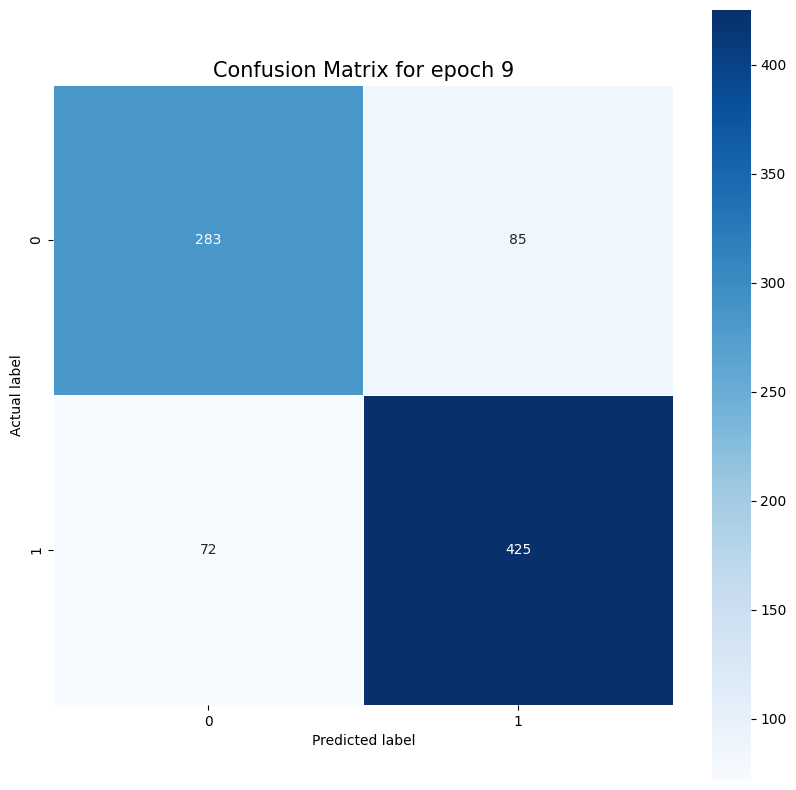

Epoch 10/10:   0%|          | 1/865 [00:04<1:01:17,  4.26s/it]

Accuracy of the model after epoch 10: 100.0%


Epoch 10/10:   0%|          | 2/865 [00:06<44:38,  3.10s/it]  

Accuracy of the model after epoch 10: 50.0%


Epoch 10/10:   0%|          | 3/865 [00:11<57:35,  4.01s/it]

Accuracy of the model after epoch 10: 66.66666666666667%


Epoch 10/10:   0%|          | 4/865 [00:16<1:01:24,  4.28s/it]

Accuracy of the model after epoch 10: 50.0%


Epoch 10/10:   1%|          | 5/865 [00:21<1:04:50,  4.52s/it]

Accuracy of the model after epoch 10: 60.0%


Epoch 10/10:   1%|          | 6/865 [00:25<1:04:28,  4.50s/it]

Accuracy of the model after epoch 10: 66.66666666666667%


Epoch 10/10:   1%|          | 7/865 [00:30<1:03:13,  4.42s/it]

Accuracy of the model after epoch 10: 71.42857142857143%


Epoch 10/10:   1%|          | 8/865 [00:34<1:05:19,  4.57s/it]

Accuracy of the model after epoch 10: 62.5%


Epoch 10/10:   1%|          | 9/865 [00:40<1:08:26,  4.80s/it]

Accuracy of the model after epoch 10: 66.66666666666667%


Epoch 10/10:   1%|          | 10/865 [00:43<1:00:15,  4.23s/it]

Accuracy of the model after epoch 10: 70.0%


Epoch 10/10:   1%|▏         | 11/865 [00:45<52:41,  3.70s/it]  

Accuracy of the model after epoch 10: 63.63636363636363%


Epoch 10/10:   1%|▏         | 12/865 [00:48<48:05,  3.38s/it]

Accuracy of the model after epoch 10: 66.66666666666667%


Epoch 10/10:   2%|▏         | 13/865 [00:50<44:14,  3.12s/it]

Accuracy of the model after epoch 10: 69.23076923076923%


Epoch 10/10:   2%|▏         | 14/865 [00:53<41:17,  2.91s/it]

Accuracy of the model after epoch 10: 71.42857142857143%


Epoch 10/10:   2%|▏         | 15/865 [00:58<50:02,  3.53s/it]

Accuracy of the model after epoch 10: 73.33333333333333%


Epoch 10/10:   2%|▏         | 16/865 [01:02<53:28,  3.78s/it]

Accuracy of the model after epoch 10: 75.0%


Epoch 10/10:   2%|▏         | 17/865 [01:06<55:22,  3.92s/it]

Accuracy of the model after epoch 10: 76.47058823529412%


Epoch 10/10:   2%|▏         | 18/865 [01:09<49:24,  3.50s/it]

Accuracy of the model after epoch 10: 77.77777777777777%


Epoch 10/10:   2%|▏         | 19/865 [01:14<56:00,  3.97s/it]

Accuracy of the model after epoch 10: 78.94736842105263%


Epoch 10/10:   2%|▏         | 20/865 [01:19<59:41,  4.24s/it]

Accuracy of the model after epoch 10: 80.0%


Epoch 10/10:   2%|▏         | 21/865 [01:21<53:13,  3.78s/it]

Accuracy of the model after epoch 10: 80.95238095238095%


Epoch 10/10:   3%|▎         | 22/865 [01:26<57:05,  4.06s/it]

Accuracy of the model after epoch 10: 81.81818181818181%


Epoch 10/10:   3%|▎         | 23/865 [01:31<1:01:12,  4.36s/it]

Accuracy of the model after epoch 10: 82.6086956521739%


Epoch 10/10:   3%|▎         | 24/865 [01:36<1:02:24,  4.45s/it]

Accuracy of the model after epoch 10: 83.33333333333333%


Epoch 10/10:   3%|▎         | 25/865 [01:39<56:13,  4.02s/it]  

Accuracy of the model after epoch 10: 84.0%


Epoch 10/10:   3%|▎         | 26/865 [01:43<57:48,  4.13s/it]

Accuracy of the model after epoch 10: 80.76923076923077%


Epoch 10/10:   3%|▎         | 27/865 [01:48<59:04,  4.23s/it]

Accuracy of the model after epoch 10: 81.48148148148148%


Epoch 10/10:   3%|▎         | 28/865 [01:53<1:02:32,  4.48s/it]

Accuracy of the model after epoch 10: 78.57142857142857%


Epoch 10/10:   3%|▎         | 29/865 [01:55<53:34,  3.85s/it]  

Accuracy of the model after epoch 10: 79.3103448275862%


Epoch 10/10:   3%|▎         | 30/865 [02:00<55:50,  4.01s/it]

Accuracy of the model after epoch 10: 80.0%


Epoch 10/10:   4%|▎         | 31/865 [02:05<1:00:35,  4.36s/it]

Accuracy of the model after epoch 10: 80.64516129032258%


Epoch 10/10:   4%|▎         | 32/865 [02:09<1:01:17,  4.41s/it]

Accuracy of the model after epoch 10: 81.25%


Epoch 10/10:   4%|▍         | 33/865 [02:14<1:02:53,  4.54s/it]

Accuracy of the model after epoch 10: 81.81818181818181%


Epoch 10/10:   4%|▍         | 34/865 [02:17<54:37,  3.94s/it]  

Accuracy of the model after epoch 10: 82.3529411764706%


Epoch 10/10:   4%|▍         | 35/865 [02:21<56:45,  4.10s/it]

Accuracy of the model after epoch 10: 82.85714285714286%


Epoch 10/10:   4%|▍         | 36/865 [02:26<57:56,  4.19s/it]

Accuracy of the model after epoch 10: 83.33333333333333%


Epoch 10/10:   4%|▍         | 37/865 [02:28<49:50,  3.61s/it]

Accuracy of the model after epoch 10: 83.78378378378379%


Epoch 10/10:   4%|▍         | 38/865 [02:32<53:49,  3.91s/it]

Accuracy of the model after epoch 10: 84.21052631578948%


Epoch 10/10:   5%|▍         | 39/865 [02:37<57:50,  4.20s/it]

Accuracy of the model after epoch 10: 84.61538461538461%


Epoch 10/10:   5%|▍         | 40/865 [02:42<59:23,  4.32s/it]

Accuracy of the model after epoch 10: 85.0%


Epoch 10/10:   5%|▍         | 41/865 [02:46<59:01,  4.30s/it]

Accuracy of the model after epoch 10: 85.36585365853658%


Epoch 10/10:   5%|▍         | 42/865 [02:51<59:17,  4.32s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:   5%|▍         | 43/865 [02:55<1:00:31,  4.42s/it]

Accuracy of the model after epoch 10: 86.04651162790698%


Epoch 10/10:   5%|▌         | 44/865 [03:00<1:03:58,  4.67s/it]

Accuracy of the model after epoch 10: 86.36363636363636%


Epoch 10/10:   5%|▌         | 45/865 [03:05<1:03:46,  4.67s/it]

Accuracy of the model after epoch 10: 86.66666666666667%


Epoch 10/10:   5%|▌         | 46/865 [03:07<54:15,  3.98s/it]  

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:   5%|▌         | 47/865 [03:12<55:46,  4.09s/it]

Accuracy of the model after epoch 10: 87.23404255319149%


Epoch 10/10:   6%|▌         | 48/865 [03:16<57:27,  4.22s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:   6%|▌         | 49/865 [03:22<1:01:47,  4.54s/it]

Accuracy of the model after epoch 10: 87.75510204081633%


Epoch 10/10:   6%|▌         | 50/865 [03:27<1:03:07,  4.65s/it]

Accuracy of the model after epoch 10: 88.0%


Epoch 10/10:   6%|▌         | 51/865 [03:29<54:23,  4.01s/it]  

Accuracy of the model after epoch 10: 88.23529411764706%


Epoch 10/10:   6%|▌         | 52/865 [03:33<54:59,  4.06s/it]

Accuracy of the model after epoch 10: 88.46153846153847%


Epoch 10/10:   6%|▌         | 53/865 [03:38<56:18,  4.16s/it]

Accuracy of the model after epoch 10: 88.67924528301887%


Epoch 10/10:   6%|▌         | 54/865 [03:42<57:11,  4.23s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:   6%|▋         | 55/865 [03:47<58:49,  4.36s/it]

Accuracy of the model after epoch 10: 89.0909090909091%


Epoch 10/10:   6%|▋         | 56/865 [03:49<51:16,  3.80s/it]

Accuracy of the model after epoch 10: 89.28571428571429%


Epoch 10/10:   7%|▋         | 57/865 [03:54<53:42,  3.99s/it]

Accuracy of the model after epoch 10: 89.47368421052632%


Epoch 10/10:   7%|▋         | 58/865 [03:56<47:37,  3.54s/it]

Accuracy of the model after epoch 10: 89.65517241379311%


Epoch 10/10:   7%|▋         | 59/865 [04:01<52:37,  3.92s/it]

Accuracy of the model after epoch 10: 89.83050847457628%


Epoch 10/10:   7%|▋         | 60/865 [04:06<56:03,  4.18s/it]

Accuracy of the model after epoch 10: 90.0%


Epoch 10/10:   7%|▋         | 61/865 [04:08<48:55,  3.65s/it]

Accuracy of the model after epoch 10: 90.1639344262295%


Epoch 10/10:   7%|▋         | 62/865 [04:12<51:36,  3.86s/it]

Accuracy of the model after epoch 10: 90.3225806451613%


Epoch 10/10:   7%|▋         | 63/865 [04:15<46:05,  3.45s/it]

Accuracy of the model after epoch 10: 90.47619047619048%


Epoch 10/10:   7%|▋         | 64/865 [04:19<50:00,  3.75s/it]

Accuracy of the model after epoch 10: 90.625%


Epoch 10/10:   8%|▊         | 65/865 [04:25<55:55,  4.19s/it]

Accuracy of the model after epoch 10: 90.76923076923077%


Epoch 10/10:   8%|▊         | 66/865 [04:29<56:46,  4.26s/it]

Accuracy of the model after epoch 10: 90.9090909090909%


Epoch 10/10:   8%|▊         | 67/865 [04:33<57:00,  4.29s/it]

Accuracy of the model after epoch 10: 89.55223880597015%


Epoch 10/10:   8%|▊         | 68/865 [04:39<1:00:39,  4.57s/it]

Accuracy of the model after epoch 10: 89.70588235294117%


Epoch 10/10:   8%|▊         | 69/865 [04:45<1:06:05,  4.98s/it]

Accuracy of the model after epoch 10: 89.85507246376811%


Epoch 10/10:   8%|▊         | 70/865 [04:49<1:05:18,  4.93s/it]

Accuracy of the model after epoch 10: 90.0%


Epoch 10/10:   8%|▊         | 71/865 [04:53<1:01:59,  4.68s/it]

Accuracy of the model after epoch 10: 90.14084507042253%


Epoch 10/10:   8%|▊         | 72/865 [04:58<1:00:45,  4.60s/it]

Accuracy of the model after epoch 10: 90.27777777777777%


Epoch 10/10:   8%|▊         | 73/865 [05:00<52:33,  3.98s/it]  

Accuracy of the model after epoch 10: 90.41095890410959%


Epoch 10/10:   9%|▊         | 74/865 [05:05<54:01,  4.10s/it]

Accuracy of the model after epoch 10: 90.54054054054055%


Epoch 10/10:   9%|▊         | 75/865 [05:08<48:56,  3.72s/it]

Accuracy of the model after epoch 10: 90.66666666666667%


Epoch 10/10:   9%|▉         | 76/865 [05:12<52:03,  3.96s/it]

Accuracy of the model after epoch 10: 90.78947368421052%


Epoch 10/10:   9%|▉         | 77/865 [05:16<53:28,  4.07s/it]

Accuracy of the model after epoch 10: 90.9090909090909%


Epoch 10/10:   9%|▉         | 78/865 [05:21<55:02,  4.20s/it]

Accuracy of the model after epoch 10: 91.02564102564102%


Epoch 10/10:   9%|▉         | 79/865 [05:23<48:04,  3.67s/it]

Accuracy of the model after epoch 10: 91.13924050632912%


Epoch 10/10:   9%|▉         | 80/865 [05:28<51:13,  3.92s/it]

Accuracy of the model after epoch 10: 91.25%


Epoch 10/10:   9%|▉         | 81/865 [05:32<52:43,  4.04s/it]

Accuracy of the model after epoch 10: 90.12345679012346%


Epoch 10/10:   9%|▉         | 82/865 [05:37<54:13,  4.16s/it]

Accuracy of the model after epoch 10: 90.2439024390244%


Epoch 10/10:  10%|▉         | 83/865 [05:39<47:10,  3.62s/it]

Accuracy of the model after epoch 10: 90.36144578313252%


Epoch 10/10:  10%|▉         | 84/865 [05:44<51:59,  3.99s/it]

Accuracy of the model after epoch 10: 90.47619047619048%


Epoch 10/10:  10%|▉         | 85/865 [05:49<54:26,  4.19s/it]

Accuracy of the model after epoch 10: 90.58823529411765%


Epoch 10/10:  10%|▉         | 86/865 [05:53<57:07,  4.40s/it]

Accuracy of the model after epoch 10: 89.53488372093024%


Epoch 10/10:  10%|█         | 87/865 [05:58<58:36,  4.52s/it]

Accuracy of the model after epoch 10: 89.65517241379311%


Epoch 10/10:  10%|█         | 88/865 [06:03<1:00:38,  4.68s/it]

Accuracy of the model after epoch 10: 89.77272727272727%


Epoch 10/10:  10%|█         | 89/865 [06:08<1:01:33,  4.76s/it]

Accuracy of the model after epoch 10: 89.88764044943821%


Epoch 10/10:  10%|█         | 90/865 [06:13<1:00:54,  4.72s/it]

Accuracy of the model after epoch 10: 90.0%


Epoch 10/10:  11%|█         | 91/865 [06:17<59:54,  4.64s/it]  

Accuracy of the model after epoch 10: 90.10989010989012%


Epoch 10/10:  11%|█         | 92/865 [06:22<1:01:17,  4.76s/it]

Accuracy of the model after epoch 10: 90.21739130434783%


Epoch 10/10:  11%|█         | 93/865 [06:27<1:01:23,  4.77s/it]

Accuracy of the model after epoch 10: 89.24731182795699%


Epoch 10/10:  11%|█         | 94/865 [06:30<53:29,  4.16s/it]  

Accuracy of the model after epoch 10: 89.36170212765957%


Epoch 10/10:  11%|█         | 95/865 [06:33<48:47,  3.80s/it]

Accuracy of the model after epoch 10: 89.47368421052632%


Epoch 10/10:  11%|█         | 96/865 [06:35<43:47,  3.42s/it]

Accuracy of the model after epoch 10: 89.58333333333333%


Epoch 10/10:  11%|█         | 97/865 [06:40<49:31,  3.87s/it]

Accuracy of the model after epoch 10: 88.65979381443299%


Epoch 10/10:  11%|█▏        | 98/865 [06:45<51:27,  4.03s/it]

Accuracy of the model after epoch 10: 88.77551020408163%


Epoch 10/10:  11%|█▏        | 99/865 [06:47<44:29,  3.48s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:  12%|█▏        | 100/865 [06:52<49:01,  3.84s/it]

Accuracy of the model after epoch 10: 89.0%


Epoch 10/10:  12%|█▏        | 101/865 [06:56<50:13,  3.94s/it]

Accuracy of the model after epoch 10: 89.10891089108911%


Epoch 10/10:  12%|█▏        | 102/865 [06:58<44:29,  3.50s/it]

Accuracy of the model after epoch 10: 89.2156862745098%


Epoch 10/10:  12%|█▏        | 103/865 [07:03<47:46,  3.76s/it]

Accuracy of the model after epoch 10: 89.32038834951456%


Epoch 10/10:  12%|█▏        | 104/865 [07:07<50:12,  3.96s/it]

Accuracy of the model after epoch 10: 89.42307692307692%


Epoch 10/10:  12%|█▏        | 105/865 [07:10<45:33,  3.60s/it]

Accuracy of the model after epoch 10: 89.52380952380952%


Epoch 10/10:  12%|█▏        | 106/865 [07:14<49:01,  3.88s/it]

Accuracy of the model after epoch 10: 89.62264150943396%


Epoch 10/10:  12%|█▏        | 107/865 [07:19<51:14,  4.06s/it]

Accuracy of the model after epoch 10: 89.7196261682243%


Epoch 10/10:  12%|█▏        | 108/865 [07:23<52:59,  4.20s/it]

Accuracy of the model after epoch 10: 89.81481481481481%


Epoch 10/10:  13%|█▎        | 109/865 [07:28<55:29,  4.40s/it]

Accuracy of the model after epoch 10: 89.90825688073394%


Epoch 10/10:  13%|█▎        | 110/865 [07:33<57:57,  4.61s/it]

Accuracy of the model after epoch 10: 90.0%


Epoch 10/10:  13%|█▎        | 111/865 [07:36<50:31,  4.02s/it]

Accuracy of the model after epoch 10: 90.09009009009009%


Epoch 10/10:  13%|█▎        | 112/865 [07:40<51:11,  4.08s/it]

Accuracy of the model after epoch 10: 90.17857142857143%


Epoch 10/10:  13%|█▎        | 113/865 [07:43<45:15,  3.61s/it]

Accuracy of the model after epoch 10: 90.26548672566372%


Epoch 10/10:  13%|█▎        | 114/865 [07:47<49:35,  3.96s/it]

Accuracy of the model after epoch 10: 90.35087719298245%


Epoch 10/10:  13%|█▎        | 115/865 [07:52<52:12,  4.18s/it]

Accuracy of the model after epoch 10: 89.56521739130434%


Epoch 10/10:  13%|█▎        | 116/865 [07:55<45:34,  3.65s/it]

Accuracy of the model after epoch 10: 89.65517241379311%


Epoch 10/10:  14%|█▎        | 117/865 [08:00<50:40,  4.07s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:  14%|█▎        | 118/865 [08:04<53:03,  4.26s/it]

Accuracy of the model after epoch 10: 88.98305084745763%


Epoch 10/10:  14%|█▍        | 119/865 [08:09<54:52,  4.41s/it]

Accuracy of the model after epoch 10: 89.07563025210084%


Epoch 10/10:  14%|█▍        | 120/865 [08:14<57:59,  4.67s/it]

Accuracy of the model after epoch 10: 89.16666666666667%


Epoch 10/10:  14%|█▍        | 121/865 [08:17<49:03,  3.96s/it]

Accuracy of the model after epoch 10: 89.25619834710744%


Epoch 10/10:  14%|█▍        | 122/865 [08:21<50:12,  4.05s/it]

Accuracy of the model after epoch 10: 89.34426229508196%


Epoch 10/10:  14%|█▍        | 123/865 [08:25<50:55,  4.12s/it]

Accuracy of the model after epoch 10: 89.4308943089431%


Epoch 10/10:  14%|█▍        | 124/865 [08:30<54:10,  4.39s/it]

Accuracy of the model after epoch 10: 89.51612903225806%


Epoch 10/10:  14%|█▍        | 125/865 [08:35<55:21,  4.49s/it]

Accuracy of the model after epoch 10: 89.6%


Epoch 10/10:  15%|█▍        | 126/865 [08:39<54:40,  4.44s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:  15%|█▍        | 127/865 [08:44<54:39,  4.44s/it]

Accuracy of the model after epoch 10: 88.97637795275591%


Epoch 10/10:  15%|█▍        | 128/865 [08:46<47:03,  3.83s/it]

Accuracy of the model after epoch 10: 89.0625%


Epoch 10/10:  15%|█▍        | 129/865 [08:48<41:44,  3.40s/it]

Accuracy of the model after epoch 10: 89.14728682170542%


Epoch 10/10:  15%|█▌        | 130/865 [08:53<45:51,  3.74s/it]

Accuracy of the model after epoch 10: 88.46153846153847%


Epoch 10/10:  15%|█▌        | 131/865 [08:57<47:59,  3.92s/it]

Accuracy of the model after epoch 10: 88.54961832061069%


Epoch 10/10:  15%|█▌        | 132/865 [09:01<48:22,  3.96s/it]

Accuracy of the model after epoch 10: 88.63636363636364%


Epoch 10/10:  15%|█▌        | 133/865 [09:06<50:35,  4.15s/it]

Accuracy of the model after epoch 10: 88.7218045112782%


Epoch 10/10:  15%|█▌        | 134/865 [09:11<55:11,  4.53s/it]

Accuracy of the model after epoch 10: 88.80597014925372%


Epoch 10/10:  16%|█▌        | 135/865 [09:16<55:39,  4.57s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:  16%|█▌        | 136/865 [09:19<48:28,  3.99s/it]

Accuracy of the model after epoch 10: 88.97058823529412%


Epoch 10/10:  16%|█▌        | 137/865 [09:23<50:30,  4.16s/it]

Accuracy of the model after epoch 10: 89.05109489051095%


Epoch 10/10:  16%|█▌        | 138/865 [09:27<50:22,  4.16s/it]

Accuracy of the model after epoch 10: 89.1304347826087%


Epoch 10/10:  16%|█▌        | 139/865 [09:32<52:29,  4.34s/it]

Accuracy of the model after epoch 10: 89.20863309352518%


Epoch 10/10:  16%|█▌        | 140/865 [09:37<53:16,  4.41s/it]

Accuracy of the model after epoch 10: 89.28571428571429%


Epoch 10/10:  16%|█▋        | 141/865 [09:39<45:40,  3.78s/it]

Accuracy of the model after epoch 10: 89.36170212765957%


Epoch 10/10:  16%|█▋        | 142/865 [09:44<48:59,  4.07s/it]

Accuracy of the model after epoch 10: 89.43661971830986%


Epoch 10/10:  17%|█▋        | 143/865 [09:49<51:31,  4.28s/it]

Accuracy of the model after epoch 10: 89.5104895104895%


Epoch 10/10:  17%|█▋        | 144/865 [09:51<45:30,  3.79s/it]

Accuracy of the model after epoch 10: 89.58333333333333%


Epoch 10/10:  17%|█▋        | 145/865 [09:56<48:30,  4.04s/it]

Accuracy of the model after epoch 10: 89.65517241379311%


Epoch 10/10:  17%|█▋        | 146/865 [10:00<50:17,  4.20s/it]

Accuracy of the model after epoch 10: 89.72602739726027%


Epoch 10/10:  17%|█▋        | 147/865 [10:05<51:11,  4.28s/it]

Accuracy of the model after epoch 10: 89.1156462585034%


Epoch 10/10:  17%|█▋        | 148/865 [10:07<44:51,  3.75s/it]

Accuracy of the model after epoch 10: 89.1891891891892%


Epoch 10/10:  17%|█▋        | 149/865 [10:10<40:55,  3.43s/it]

Accuracy of the model after epoch 10: 89.26174496644295%


Epoch 10/10:  17%|█▋        | 150/865 [10:15<45:25,  3.81s/it]

Accuracy of the model after epoch 10: 89.33333333333333%


Epoch 10/10:  17%|█▋        | 151/865 [10:19<48:17,  4.06s/it]

Accuracy of the model after epoch 10: 89.40397350993378%


Epoch 10/10:  18%|█▊        | 152/865 [10:24<48:42,  4.10s/it]

Accuracy of the model after epoch 10: 89.47368421052632%


Epoch 10/10:  18%|█▊        | 153/865 [10:28<51:07,  4.31s/it]

Accuracy of the model after epoch 10: 89.54248366013071%


Epoch 10/10:  18%|█▊        | 154/865 [10:33<53:17,  4.50s/it]

Accuracy of the model after epoch 10: 89.6103896103896%


Epoch 10/10:  18%|█▊        | 155/865 [10:38<53:33,  4.53s/it]

Accuracy of the model after epoch 10: 89.6774193548387%


Epoch 10/10:  18%|█▊        | 156/865 [10:42<53:25,  4.52s/it]

Accuracy of the model after epoch 10: 89.74358974358974%


Epoch 10/10:  18%|█▊        | 157/865 [10:47<52:58,  4.49s/it]

Accuracy of the model after epoch 10: 89.171974522293%


Epoch 10/10:  18%|█▊        | 158/865 [10:52<54:20,  4.61s/it]

Accuracy of the model after epoch 10: 89.24050632911393%


Epoch 10/10:  18%|█▊        | 159/865 [10:55<47:41,  4.05s/it]

Accuracy of the model after epoch 10: 89.30817610062893%


Epoch 10/10:  18%|█▊        | 160/865 [11:00<51:17,  4.37s/it]

Accuracy of the model after epoch 10: 89.375%


Epoch 10/10:  19%|█▊        | 161/865 [11:04<51:20,  4.38s/it]

Accuracy of the model after epoch 10: 89.44099378881988%


Epoch 10/10:  19%|█▊        | 162/865 [11:08<51:15,  4.38s/it]

Accuracy of the model after epoch 10: 89.50617283950618%


Epoch 10/10:  19%|█▉        | 163/865 [11:13<52:52,  4.52s/it]

Accuracy of the model after epoch 10: 89.57055214723927%


Epoch 10/10:  19%|█▉        | 164/865 [11:19<56:29,  4.84s/it]

Accuracy of the model after epoch 10: 89.63414634146342%


Epoch 10/10:  19%|█▉        | 165/865 [11:24<57:47,  4.95s/it]

Accuracy of the model after epoch 10: 89.6969696969697%


Epoch 10/10:  19%|█▉        | 166/865 [11:29<56:09,  4.82s/it]

Accuracy of the model after epoch 10: 89.75903614457832%


Epoch 10/10:  19%|█▉        | 167/865 [11:33<54:30,  4.69s/it]

Accuracy of the model after epoch 10: 89.82035928143712%


Epoch 10/10:  19%|█▉        | 168/865 [11:35<46:35,  4.01s/it]

Accuracy of the model after epoch 10: 89.88095238095238%


Epoch 10/10:  20%|█▉        | 169/865 [11:38<41:22,  3.57s/it]

Accuracy of the model after epoch 10: 89.94082840236686%


Epoch 10/10:  20%|█▉        | 170/865 [11:43<47:15,  4.08s/it]

Accuracy of the model after epoch 10: 89.41176470588235%


Epoch 10/10:  20%|█▉        | 171/865 [11:48<48:32,  4.20s/it]

Accuracy of the model after epoch 10: 89.47368421052632%


Epoch 10/10:  20%|█▉        | 172/865 [11:50<42:54,  3.72s/it]

Accuracy of the model after epoch 10: 89.53488372093024%


Epoch 10/10:  20%|██        | 173/865 [11:55<46:22,  4.02s/it]

Accuracy of the model after epoch 10: 89.01734104046243%


Epoch 10/10:  20%|██        | 174/865 [12:00<48:50,  4.24s/it]

Accuracy of the model after epoch 10: 88.50574712643679%


Epoch 10/10:  20%|██        | 175/865 [12:04<50:15,  4.37s/it]

Accuracy of the model after epoch 10: 88.0%


Epoch 10/10:  20%|██        | 176/865 [12:09<50:18,  4.38s/it]

Accuracy of the model after epoch 10: 88.06818181818181%


Epoch 10/10:  20%|██        | 177/865 [12:11<43:40,  3.81s/it]

Accuracy of the model after epoch 10: 88.13559322033899%


Epoch 10/10:  21%|██        | 178/865 [12:16<45:22,  3.96s/it]

Accuracy of the model after epoch 10: 88.20224719101124%


Epoch 10/10:  21%|██        | 179/865 [12:20<47:44,  4.18s/it]

Accuracy of the model after epoch 10: 88.26815642458101%


Epoch 10/10:  21%|██        | 180/865 [12:23<42:55,  3.76s/it]

Accuracy of the model after epoch 10: 88.33333333333333%


Epoch 10/10:  21%|██        | 181/865 [12:28<46:59,  4.12s/it]

Accuracy of the model after epoch 10: 88.39779005524862%


Epoch 10/10:  21%|██        | 182/865 [12:33<48:36,  4.27s/it]

Accuracy of the model after epoch 10: 88.46153846153847%


Epoch 10/10:  21%|██        | 183/865 [12:37<50:00,  4.40s/it]

Accuracy of the model after epoch 10: 88.52459016393442%


Epoch 10/10:  21%|██▏       | 184/865 [12:42<51:19,  4.52s/it]

Accuracy of the model after epoch 10: 88.58695652173913%


Epoch 10/10:  21%|██▏       | 185/865 [12:47<51:36,  4.55s/it]

Accuracy of the model after epoch 10: 88.64864864864865%


Epoch 10/10:  22%|██▏       | 186/865 [12:51<50:47,  4.49s/it]

Accuracy of the model after epoch 10: 88.70967741935483%


Epoch 10/10:  22%|██▏       | 187/865 [12:56<50:20,  4.46s/it]

Accuracy of the model after epoch 10: 88.77005347593582%


Epoch 10/10:  22%|██▏       | 188/865 [13:00<49:52,  4.42s/it]

Accuracy of the model after epoch 10: 88.29787234042553%


Epoch 10/10:  22%|██▏       | 189/865 [13:02<43:35,  3.87s/it]

Accuracy of the model after epoch 10: 87.83068783068784%


Epoch 10/10:  22%|██▏       | 190/865 [13:07<45:49,  4.07s/it]

Accuracy of the model after epoch 10: 87.89473684210526%


Epoch 10/10:  22%|██▏       | 191/865 [13:11<46:51,  4.17s/it]

Accuracy of the model after epoch 10: 87.95811518324608%


Epoch 10/10:  22%|██▏       | 192/865 [13:16<46:50,  4.18s/it]

Accuracy of the model after epoch 10: 88.02083333333333%


Epoch 10/10:  22%|██▏       | 193/865 [13:18<40:52,  3.65s/it]

Accuracy of the model after epoch 10: 88.08290155440415%


Epoch 10/10:  22%|██▏       | 194/865 [13:21<37:23,  3.34s/it]

Accuracy of the model after epoch 10: 88.14432989690722%


Epoch 10/10:  23%|██▎       | 195/865 [13:25<41:46,  3.74s/it]

Accuracy of the model after epoch 10: 88.2051282051282%


Epoch 10/10:  23%|██▎       | 196/865 [13:28<37:12,  3.34s/it]

Accuracy of the model after epoch 10: 88.26530612244898%


Epoch 10/10:  23%|██▎       | 197/865 [13:30<33:49,  3.04s/it]

Accuracy of the model after epoch 10: 88.3248730964467%


Epoch 10/10:  23%|██▎       | 198/865 [13:35<38:33,  3.47s/it]

Accuracy of the model after epoch 10: 88.38383838383838%


Epoch 10/10:  23%|██▎       | 199/865 [13:39<41:41,  3.76s/it]

Accuracy of the model after epoch 10: 88.44221105527639%


Epoch 10/10:  23%|██▎       | 200/865 [13:44<45:57,  4.15s/it]

Accuracy of the model after epoch 10: 88.5%


Epoch 10/10:  23%|██▎       | 201/865 [13:48<46:36,  4.21s/it]

Accuracy of the model after epoch 10: 88.55721393034825%


Epoch 10/10:  23%|██▎       | 202/865 [13:52<46:16,  4.19s/it]

Accuracy of the model after epoch 10: 88.61386138613861%


Epoch 10/10:  23%|██▎       | 203/865 [13:58<49:29,  4.49s/it]

Accuracy of the model after epoch 10: 88.66995073891626%


Epoch 10/10:  24%|██▎       | 204/865 [14:03<52:21,  4.75s/it]

Accuracy of the model after epoch 10: 88.72549019607843%


Epoch 10/10:  24%|██▎       | 205/865 [14:08<51:58,  4.72s/it]

Accuracy of the model after epoch 10: 88.78048780487805%


Epoch 10/10:  24%|██▍       | 206/865 [14:12<50:28,  4.60s/it]

Accuracy of the model after epoch 10: 88.83495145631068%


Epoch 10/10:  24%|██▍       | 207/865 [14:16<49:46,  4.54s/it]

Accuracy of the model after epoch 10: 88.88888888888889%


Epoch 10/10:  24%|██▍       | 208/865 [14:21<50:35,  4.62s/it]

Accuracy of the model after epoch 10: 88.46153846153847%


Epoch 10/10:  24%|██▍       | 209/865 [14:24<43:25,  3.97s/it]

Accuracy of the model after epoch 10: 88.51674641148325%


Epoch 10/10:  24%|██▍       | 210/865 [14:28<45:10,  4.14s/it]

Accuracy of the model after epoch 10: 88.57142857142857%


Epoch 10/10:  24%|██▍       | 211/865 [14:32<45:22,  4.16s/it]

Accuracy of the model after epoch 10: 88.15165876777252%


Epoch 10/10:  25%|██▍       | 212/865 [14:37<46:34,  4.28s/it]

Accuracy of the model after epoch 10: 87.73584905660377%


Epoch 10/10:  25%|██▍       | 213/865 [14:42<48:52,  4.50s/it]

Accuracy of the model after epoch 10: 87.79342723004694%


Epoch 10/10:  25%|██▍       | 214/865 [14:47<51:28,  4.74s/it]

Accuracy of the model after epoch 10: 87.85046728971963%


Epoch 10/10:  25%|██▍       | 215/865 [14:52<51:06,  4.72s/it]

Accuracy of the model after epoch 10: 87.90697674418605%


Epoch 10/10:  25%|██▍       | 216/865 [14:56<49:37,  4.59s/it]

Accuracy of the model after epoch 10: 87.96296296296296%


Epoch 10/10:  25%|██▌       | 217/865 [15:01<48:56,  4.53s/it]

Accuracy of the model after epoch 10: 88.0184331797235%


Epoch 10/10:  25%|██▌       | 218/865 [15:05<48:36,  4.51s/it]

Accuracy of the model after epoch 10: 88.07339449541284%


Epoch 10/10:  25%|██▌       | 219/865 [15:10<49:47,  4.62s/it]

Accuracy of the model after epoch 10: 88.12785388127854%


Epoch 10/10:  25%|██▌       | 220/865 [15:13<44:19,  4.12s/it]

Accuracy of the model after epoch 10: 88.18181818181819%


Epoch 10/10:  26%|██▌       | 221/865 [15:15<39:10,  3.65s/it]

Accuracy of the model after epoch 10: 88.23529411764706%


Epoch 10/10:  26%|██▌       | 222/865 [15:20<42:32,  3.97s/it]

Accuracy of the model after epoch 10: 88.28828828828829%


Epoch 10/10:  26%|██▌       | 223/865 [15:25<44:58,  4.20s/it]

Accuracy of the model after epoch 10: 87.89237668161435%


Epoch 10/10:  26%|██▌       | 224/865 [15:30<47:29,  4.44s/it]

Accuracy of the model after epoch 10: 87.94642857142857%


Epoch 10/10:  26%|██▌       | 225/865 [15:35<48:35,  4.56s/it]

Accuracy of the model after epoch 10: 88.0%


Epoch 10/10:  26%|██▌       | 226/865 [15:39<47:35,  4.47s/it]

Accuracy of the model after epoch 10: 87.61061946902655%


Epoch 10/10:  26%|██▌       | 227/865 [15:43<47:02,  4.42s/it]

Accuracy of the model after epoch 10: 87.22466960352423%


Epoch 10/10:  26%|██▋       | 228/865 [15:46<40:48,  3.84s/it]

Accuracy of the model after epoch 10: 87.28070175438596%


Epoch 10/10:  26%|██▋       | 229/865 [15:48<36:18,  3.43s/it]

Accuracy of the model after epoch 10: 87.33624454148472%


Epoch 10/10:  27%|██▋       | 230/865 [15:53<40:20,  3.81s/it]

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:  27%|██▋       | 231/865 [15:57<42:07,  3.99s/it]

Accuracy of the model after epoch 10: 87.01298701298701%


Epoch 10/10:  27%|██▋       | 232/865 [16:02<42:57,  4.07s/it]

Accuracy of the model after epoch 10: 86.63793103448276%


Epoch 10/10:  27%|██▋       | 233/865 [16:07<45:34,  4.33s/it]

Accuracy of the model after epoch 10: 86.69527896995709%


Epoch 10/10:  27%|██▋       | 234/865 [16:12<49:10,  4.68s/it]

Accuracy of the model after epoch 10: 86.75213675213675%


Epoch 10/10:  27%|██▋       | 235/865 [16:17<50:37,  4.82s/it]

Accuracy of the model after epoch 10: 86.80851063829788%


Epoch 10/10:  27%|██▋       | 236/865 [16:20<43:11,  4.12s/it]

Accuracy of the model after epoch 10: 86.86440677966101%


Epoch 10/10:  27%|██▋       | 237/865 [16:22<38:34,  3.69s/it]

Accuracy of the model after epoch 10: 86.91983122362869%


Epoch 10/10:  28%|██▊       | 238/865 [16:27<40:49,  3.91s/it]

Accuracy of the model after epoch 10: 86.97478991596638%


Epoch 10/10:  28%|██▊       | 239/865 [16:29<36:22,  3.49s/it]

Accuracy of the model after epoch 10: 87.02928870292887%


Epoch 10/10:  28%|██▊       | 240/865 [16:34<40:12,  3.86s/it]

Accuracy of the model after epoch 10: 87.08333333333333%


Epoch 10/10:  28%|██▊       | 241/865 [16:39<42:15,  4.06s/it]

Accuracy of the model after epoch 10: 87.13692946058092%


Epoch 10/10:  28%|██▊       | 242/865 [16:43<43:29,  4.19s/it]

Accuracy of the model after epoch 10: 86.77685950413223%


Epoch 10/10:  28%|██▊       | 243/865 [16:48<45:30,  4.39s/it]

Accuracy of the model after epoch 10: 86.83127572016461%


Epoch 10/10:  28%|██▊       | 244/865 [16:53<48:45,  4.71s/it]

Accuracy of the model after epoch 10: 86.88524590163935%


Epoch 10/10:  28%|██▊       | 245/865 [16:58<48:41,  4.71s/it]

Accuracy of the model after epoch 10: 86.93877551020408%


Epoch 10/10:  28%|██▊       | 246/865 [17:01<42:04,  4.08s/it]

Accuracy of the model after epoch 10: 86.99186991869918%


Epoch 10/10:  29%|██▊       | 247/865 [17:06<44:13,  4.29s/it]

Accuracy of the model after epoch 10: 87.04453441295547%


Epoch 10/10:  29%|██▊       | 248/865 [17:10<44:25,  4.32s/it]

Accuracy of the model after epoch 10: 87.09677419354838%


Epoch 10/10:  29%|██▉       | 249/865 [17:15<46:06,  4.49s/it]

Accuracy of the model after epoch 10: 86.74698795180723%


Epoch 10/10:  29%|██▉       | 250/865 [17:20<47:12,  4.61s/it]

Accuracy of the model after epoch 10: 86.8%


Epoch 10/10:  29%|██▉       | 251/865 [17:24<47:36,  4.65s/it]

Accuracy of the model after epoch 10: 86.85258964143426%


Epoch 10/10:  29%|██▉       | 252/865 [17:29<47:07,  4.61s/it]

Accuracy of the model after epoch 10: 86.9047619047619%


Epoch 10/10:  29%|██▉       | 253/865 [17:31<40:17,  3.95s/it]

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:  29%|██▉       | 254/865 [17:36<41:55,  4.12s/it]

Accuracy of the model after epoch 10: 87.00787401574803%


Epoch 10/10:  29%|██▉       | 255/865 [17:41<43:46,  4.31s/it]

Accuracy of the model after epoch 10: 87.05882352941177%


Epoch 10/10:  30%|██▉       | 256/865 [17:45<44:08,  4.35s/it]

Accuracy of the model after epoch 10: 87.109375%


Epoch 10/10:  30%|██▉       | 257/865 [17:48<38:24,  3.79s/it]

Accuracy of the model after epoch 10: 87.15953307392996%


Epoch 10/10:  30%|██▉       | 258/865 [17:52<40:43,  4.03s/it]

Accuracy of the model after epoch 10: 87.20930232558139%


Epoch 10/10:  30%|██▉       | 259/865 [17:54<35:15,  3.49s/it]

Accuracy of the model after epoch 10: 86.87258687258688%


Epoch 10/10:  30%|███       | 260/865 [17:59<40:05,  3.98s/it]

Accuracy of the model after epoch 10: 86.92307692307692%


Epoch 10/10:  30%|███       | 261/865 [18:02<35:13,  3.50s/it]

Accuracy of the model after epoch 10: 86.97318007662835%


Epoch 10/10:  30%|███       | 262/865 [18:04<31:58,  3.18s/it]

Accuracy of the model after epoch 10: 87.02290076335878%


Epoch 10/10:  30%|███       | 263/865 [18:09<35:27,  3.53s/it]

Accuracy of the model after epoch 10: 86.69201520912547%


Epoch 10/10:  31%|███       | 264/865 [18:14<39:36,  3.95s/it]

Accuracy of the model after epoch 10: 86.36363636363636%


Epoch 10/10:  31%|███       | 265/865 [18:18<41:58,  4.20s/it]

Accuracy of the model after epoch 10: 86.41509433962264%


Epoch 10/10:  31%|███       | 266/865 [18:21<37:03,  3.71s/it]

Accuracy of the model after epoch 10: 86.46616541353383%


Epoch 10/10:  31%|███       | 267/865 [18:25<38:41,  3.88s/it]

Accuracy of the model after epoch 10: 86.51685393258427%


Epoch 10/10:  31%|███       | 268/865 [18:28<34:54,  3.51s/it]

Accuracy of the model after epoch 10: 86.56716417910448%


Epoch 10/10:  31%|███       | 269/865 [18:32<37:57,  3.82s/it]

Accuracy of the model after epoch 10: 86.61710037174721%


Epoch 10/10:  31%|███       | 270/865 [18:37<41:13,  4.16s/it]

Accuracy of the model after epoch 10: 86.66666666666667%


Epoch 10/10:  31%|███▏      | 271/865 [18:42<43:29,  4.39s/it]

Accuracy of the model after epoch 10: 86.71586715867159%


Epoch 10/10:  31%|███▏      | 272/865 [18:47<45:06,  4.56s/it]

Accuracy of the model after epoch 10: 86.76470588235294%


Epoch 10/10:  32%|███▏      | 273/865 [18:50<39:32,  4.01s/it]

Accuracy of the model after epoch 10: 86.81318681318682%


Epoch 10/10:  32%|███▏      | 274/865 [18:52<34:55,  3.55s/it]

Accuracy of the model after epoch 10: 86.86131386861314%


Epoch 10/10:  32%|███▏      | 275/865 [18:57<38:12,  3.89s/it]

Accuracy of the model after epoch 10: 86.9090909090909%


Epoch 10/10:  32%|███▏      | 276/865 [19:00<33:57,  3.46s/it]

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:  32%|███▏      | 277/865 [19:02<30:34,  3.12s/it]

Accuracy of the model after epoch 10: 87.00361010830325%


Epoch 10/10:  32%|███▏      | 278/865 [19:06<34:45,  3.55s/it]

Accuracy of the model after epoch 10: 87.05035971223022%


Epoch 10/10:  32%|███▏      | 279/865 [19:11<37:50,  3.87s/it]

Accuracy of the model after epoch 10: 87.09677419354838%


Epoch 10/10:  32%|███▏      | 280/865 [19:16<39:42,  4.07s/it]

Accuracy of the model after epoch 10: 86.78571428571429%


Epoch 10/10:  32%|███▏      | 281/865 [19:18<35:16,  3.62s/it]

Accuracy of the model after epoch 10: 86.83274021352314%


Epoch 10/10:  33%|███▎      | 282/865 [19:22<37:09,  3.82s/it]

Accuracy of the model after epoch 10: 86.87943262411348%


Epoch 10/10:  33%|███▎      | 283/865 [19:27<38:27,  3.97s/it]

Accuracy of the model after epoch 10: 86.92579505300354%


Epoch 10/10:  33%|███▎      | 284/865 [19:31<40:28,  4.18s/it]

Accuracy of the model after epoch 10: 86.97183098591549%


Epoch 10/10:  33%|███▎      | 285/865 [19:36<41:39,  4.31s/it]

Accuracy of the model after epoch 10: 87.01754385964912%


Epoch 10/10:  33%|███▎      | 286/865 [19:40<41:33,  4.31s/it]

Accuracy of the model after epoch 10: 87.06293706293707%


Epoch 10/10:  33%|███▎      | 287/865 [19:45<41:42,  4.33s/it]

Accuracy of the model after epoch 10: 87.10801393728222%


Epoch 10/10:  33%|███▎      | 288/865 [19:50<43:57,  4.57s/it]

Accuracy of the model after epoch 10: 87.15277777777777%


Epoch 10/10:  33%|███▎      | 289/865 [19:55<45:40,  4.76s/it]

Accuracy of the model after epoch 10: 87.19723183391004%


Epoch 10/10:  34%|███▎      | 290/865 [20:00<45:31,  4.75s/it]

Accuracy of the model after epoch 10: 86.89655172413794%


Epoch 10/10:  34%|███▎      | 291/865 [20:04<44:15,  4.63s/it]

Accuracy of the model after epoch 10: 86.94158075601375%


Epoch 10/10:  34%|███▍      | 292/865 [20:09<43:41,  4.57s/it]

Accuracy of the model after epoch 10: 86.98630136986301%


Epoch 10/10:  34%|███▍      | 293/865 [20:14<46:44,  4.90s/it]

Accuracy of the model after epoch 10: 87.03071672354949%


Epoch 10/10:  34%|███▍      | 294/865 [20:17<39:56,  4.20s/it]

Accuracy of the model after epoch 10: 87.07482993197279%


Epoch 10/10:  34%|███▍      | 295/865 [20:20<35:56,  3.78s/it]

Accuracy of the model after epoch 10: 87.11864406779661%


Epoch 10/10:  34%|███▍      | 296/865 [20:22<32:12,  3.40s/it]

Accuracy of the model after epoch 10: 87.16216216216216%


Epoch 10/10:  34%|███▍      | 297/865 [20:26<34:24,  3.63s/it]

Accuracy of the model after epoch 10: 87.20538720538721%


Epoch 10/10:  34%|███▍      | 298/865 [20:31<36:19,  3.84s/it]

Accuracy of the model after epoch 10: 87.24832214765101%


Epoch 10/10:  35%|███▍      | 299/865 [20:33<32:32,  3.45s/it]

Accuracy of the model after epoch 10: 87.29096989966555%


Epoch 10/10:  35%|███▍      | 300/865 [20:38<35:34,  3.78s/it]

Accuracy of the model after epoch 10: 87.33333333333333%


Epoch 10/10:  35%|███▍      | 301/865 [20:42<36:49,  3.92s/it]

Accuracy of the model after epoch 10: 87.37541528239203%


Epoch 10/10:  35%|███▍      | 302/865 [20:46<38:05,  4.06s/it]

Accuracy of the model after epoch 10: 87.41721854304636%


Epoch 10/10:  35%|███▌      | 303/865 [20:49<34:03,  3.64s/it]

Accuracy of the model after epoch 10: 87.45874587458746%


Epoch 10/10:  35%|███▌      | 304/865 [20:53<36:16,  3.88s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  35%|███▌      | 305/865 [20:58<38:12,  4.09s/it]

Accuracy of the model after epoch 10: 87.54098360655738%


Epoch 10/10:  35%|███▌      | 306/865 [21:03<39:10,  4.20s/it]

Accuracy of the model after epoch 10: 87.58169934640523%


Epoch 10/10:  35%|███▌      | 307/865 [21:07<39:17,  4.22s/it]

Accuracy of the model after epoch 10: 87.62214983713355%


Epoch 10/10:  36%|███▌      | 308/865 [21:12<41:10,  4.44s/it]

Accuracy of the model after epoch 10: 87.33766233766234%


Epoch 10/10:  36%|███▌      | 309/865 [21:17<44:07,  4.76s/it]

Accuracy of the model after epoch 10: 87.37864077669903%


Epoch 10/10:  36%|███▌      | 310/865 [21:22<43:41,  4.72s/it]

Accuracy of the model after epoch 10: 87.41935483870968%


Epoch 10/10:  36%|███▌      | 311/865 [21:24<36:42,  3.97s/it]

Accuracy of the model after epoch 10: 87.45980707395498%


Epoch 10/10:  36%|███▌      | 312/865 [21:28<37:20,  4.05s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  36%|███▌      | 313/865 [21:31<33:07,  3.60s/it]

Accuracy of the model after epoch 10: 87.53993610223642%


Epoch 10/10:  36%|███▋      | 314/865 [21:34<30:24,  3.31s/it]

Accuracy of the model after epoch 10: 87.57961783439491%


Epoch 10/10:  36%|███▋      | 315/865 [21:38<33:31,  3.66s/it]

Accuracy of the model after epoch 10: 87.61904761904762%


Epoch 10/10:  37%|███▋      | 316/865 [21:42<35:09,  3.84s/it]

Accuracy of the model after epoch 10: 87.65822784810126%


Epoch 10/10:  37%|███▋      | 317/865 [21:47<36:59,  4.05s/it]

Accuracy of the model after epoch 10: 87.69716088328076%


Epoch 10/10:  37%|███▋      | 318/865 [21:51<38:45,  4.25s/it]

Accuracy of the model after epoch 10: 87.73584905660377%


Epoch 10/10:  37%|███▋      | 319/865 [21:54<34:06,  3.75s/it]

Accuracy of the model after epoch 10: 87.7742946708464%


Epoch 10/10:  37%|███▋      | 320/865 [21:59<36:32,  4.02s/it]

Accuracy of the model after epoch 10: 87.8125%


Epoch 10/10:  37%|███▋      | 321/865 [22:03<37:25,  4.13s/it]

Accuracy of the model after epoch 10: 87.85046728971963%


Epoch 10/10:  37%|███▋      | 322/865 [22:08<38:33,  4.26s/it]

Accuracy of the model after epoch 10: 87.88819875776397%


Epoch 10/10:  37%|███▋      | 323/865 [22:10<33:15,  3.68s/it]

Accuracy of the model after epoch 10: 87.92569659442725%


Epoch 10/10:  37%|███▋      | 324/865 [22:15<36:23,  4.04s/it]

Accuracy of the model after epoch 10: 87.96296296296296%


Epoch 10/10:  38%|███▊      | 325/865 [22:20<38:20,  4.26s/it]

Accuracy of the model after epoch 10: 87.6923076923077%


Epoch 10/10:  38%|███▊      | 326/865 [22:24<38:47,  4.32s/it]

Accuracy of the model after epoch 10: 87.42331288343559%


Epoch 10/10:  38%|███▊      | 327/865 [22:28<38:20,  4.28s/it]

Accuracy of the model after epoch 10: 87.46177370030581%


Epoch 10/10:  38%|███▊      | 328/865 [22:33<38:59,  4.36s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  38%|███▊      | 329/865 [22:38<41:14,  4.62s/it]

Accuracy of the model after epoch 10: 87.53799392097264%


Epoch 10/10:  38%|███▊      | 330/865 [22:43<41:54,  4.70s/it]

Accuracy of the model after epoch 10: 87.57575757575758%


Epoch 10/10:  38%|███▊      | 331/865 [22:47<41:11,  4.63s/it]

Accuracy of the model after epoch 10: 87.31117824773413%


Epoch 10/10:  38%|███▊      | 332/865 [22:52<40:06,  4.52s/it]

Accuracy of the model after epoch 10: 87.34939759036145%


Epoch 10/10:  38%|███▊      | 333/865 [22:56<40:27,  4.56s/it]

Accuracy of the model after epoch 10: 87.38738738738739%


Epoch 10/10:  39%|███▊      | 334/865 [23:02<43:29,  4.91s/it]

Accuracy of the model after epoch 10: 87.42514970059881%


Epoch 10/10:  39%|███▊      | 335/865 [23:05<37:52,  4.29s/it]

Accuracy of the model after epoch 10: 87.46268656716418%


Epoch 10/10:  39%|███▉      | 336/865 [23:08<33:39,  3.82s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  39%|███▉      | 337/865 [23:13<36:44,  4.17s/it]

Accuracy of the model after epoch 10: 87.53709198813057%


Epoch 10/10:  39%|███▉      | 338/865 [23:17<37:37,  4.28s/it]

Accuracy of the model after epoch 10: 87.27810650887574%


Epoch 10/10:  39%|███▉      | 339/865 [23:22<38:43,  4.42s/it]

Accuracy of the model after epoch 10: 87.02064896755162%


Epoch 10/10:  39%|███▉      | 340/865 [23:25<34:27,  3.94s/it]

Accuracy of the model after epoch 10: 87.05882352941177%


Epoch 10/10:  39%|███▉      | 341/865 [23:29<35:55,  4.11s/it]

Accuracy of the model after epoch 10: 87.09677419354838%


Epoch 10/10:  40%|███▉      | 342/865 [23:34<36:47,  4.22s/it]

Accuracy of the model after epoch 10: 87.13450292397661%


Epoch 10/10:  40%|███▉      | 343/865 [23:39<38:14,  4.40s/it]

Accuracy of the model after epoch 10: 87.17201166180757%


Epoch 10/10:  40%|███▉      | 344/865 [23:44<39:45,  4.58s/it]

Accuracy of the model after epoch 10: 87.20930232558139%


Epoch 10/10:  40%|███▉      | 345/865 [23:48<40:17,  4.65s/it]

Accuracy of the model after epoch 10: 87.2463768115942%


Epoch 10/10:  40%|████      | 346/865 [23:51<34:20,  3.97s/it]

Accuracy of the model after epoch 10: 87.28323699421965%


Epoch 10/10:  40%|████      | 347/865 [23:55<35:15,  4.08s/it]

Accuracy of the model after epoch 10: 87.31988472622479%


Epoch 10/10:  40%|████      | 348/865 [23:58<31:10,  3.62s/it]

Accuracy of the model after epoch 10: 87.35632183908046%


Epoch 10/10:  40%|████      | 349/865 [24:02<32:55,  3.83s/it]

Accuracy of the model after epoch 10: 87.39255014326648%


Epoch 10/10:  40%|████      | 350/865 [24:05<30:31,  3.56s/it]

Accuracy of the model after epoch 10: 87.42857142857143%


Epoch 10/10:  41%|████      | 351/865 [24:09<32:24,  3.78s/it]

Accuracy of the model after epoch 10: 87.46438746438747%


Epoch 10/10:  41%|████      | 352/865 [24:14<34:07,  3.99s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  41%|████      | 353/865 [24:16<30:29,  3.57s/it]

Accuracy of the model after epoch 10: 87.53541076487252%


Epoch 10/10:  41%|████      | 354/865 [24:19<28:06,  3.30s/it]

Accuracy of the model after epoch 10: 87.57062146892656%


Epoch 10/10:  41%|████      | 355/865 [24:24<31:49,  3.74s/it]

Accuracy of the model after epoch 10: 87.6056338028169%


Epoch 10/10:  41%|████      | 356/865 [24:28<34:29,  4.07s/it]

Accuracy of the model after epoch 10: 87.64044943820225%


Epoch 10/10:  41%|████▏     | 357/865 [24:31<30:29,  3.60s/it]

Accuracy of the model after epoch 10: 87.6750700280112%


Epoch 10/10:  41%|████▏     | 358/865 [24:35<32:19,  3.82s/it]

Accuracy of the model after epoch 10: 87.70949720670392%


Epoch 10/10:  42%|████▏     | 359/865 [24:38<28:40,  3.40s/it]

Accuracy of the model after epoch 10: 87.74373259052925%


Epoch 10/10:  42%|████▏     | 360/865 [24:40<26:56,  3.20s/it]

Accuracy of the model after epoch 10: 87.77777777777777%


Epoch 10/10:  42%|████▏     | 361/865 [24:45<29:32,  3.52s/it]

Accuracy of the model after epoch 10: 87.81163434903047%


Epoch 10/10:  42%|████▏     | 362/865 [24:49<32:09,  3.84s/it]

Accuracy of the model after epoch 10: 87.84530386740332%


Epoch 10/10:  42%|████▏     | 363/865 [24:54<34:04,  4.07s/it]

Accuracy of the model after epoch 10: 87.87878787878788%


Epoch 10/10:  42%|████▏     | 364/865 [24:59<35:35,  4.26s/it]

Accuracy of the model after epoch 10: 87.91208791208791%


Epoch 10/10:  42%|████▏     | 365/865 [25:03<36:39,  4.40s/it]

Accuracy of the model after epoch 10: 87.94520547945206%


Epoch 10/10:  42%|████▏     | 366/865 [25:08<36:20,  4.37s/it]

Accuracy of the model after epoch 10: 87.97814207650273%


Epoch 10/10:  42%|████▏     | 367/865 [25:12<36:32,  4.40s/it]

Accuracy of the model after epoch 10: 87.73841961852861%


Epoch 10/10:  43%|████▎     | 368/865 [25:17<36:19,  4.39s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  43%|████▎     | 369/865 [25:19<31:04,  3.76s/it]

Accuracy of the model after epoch 10: 87.26287262872629%


Epoch 10/10:  43%|████▎     | 370/865 [25:22<29:04,  3.52s/it]

Accuracy of the model after epoch 10: 87.29729729729729%


Epoch 10/10:  43%|████▎     | 371/865 [25:26<31:22,  3.81s/it]

Accuracy of the model after epoch 10: 87.33153638814017%


Epoch 10/10:  43%|████▎     | 372/865 [25:31<33:13,  4.04s/it]

Accuracy of the model after epoch 10: 87.36559139784946%


Epoch 10/10:  43%|████▎     | 373/865 [25:35<34:24,  4.20s/it]

Accuracy of the model after epoch 10: 87.1313672922252%


Epoch 10/10:  43%|████▎     | 374/865 [25:40<35:35,  4.35s/it]

Accuracy of the model after epoch 10: 87.16577540106952%


Epoch 10/10:  43%|████▎     | 375/865 [25:43<32:08,  3.93s/it]

Accuracy of the model after epoch 10: 87.2%


Epoch 10/10:  43%|████▎     | 376/865 [25:48<33:56,  4.16s/it]

Accuracy of the model after epoch 10: 87.23404255319149%


Epoch 10/10:  44%|████▎     | 377/865 [25:50<29:56,  3.68s/it]

Accuracy of the model after epoch 10: 87.26790450928382%


Epoch 10/10:  44%|████▎     | 378/865 [25:55<32:12,  3.97s/it]

Accuracy of the model after epoch 10: 87.3015873015873%


Epoch 10/10:  44%|████▍     | 379/865 [25:59<33:00,  4.07s/it]

Accuracy of the model after epoch 10: 87.0712401055409%


Epoch 10/10:  44%|████▍     | 380/865 [26:04<34:38,  4.29s/it]

Accuracy of the model after epoch 10: 87.10526315789474%


Epoch 10/10:  44%|████▍     | 381/865 [26:08<34:22,  4.26s/it]

Accuracy of the model after epoch 10: 87.13910761154855%


Epoch 10/10:  44%|████▍     | 382/865 [26:13<36:01,  4.48s/it]

Accuracy of the model after epoch 10: 87.17277486910994%


Epoch 10/10:  44%|████▍     | 383/865 [26:18<36:11,  4.50s/it]

Accuracy of the model after epoch 10: 87.20626631853786%


Epoch 10/10:  44%|████▍     | 384/865 [26:23<36:51,  4.60s/it]

Accuracy of the model after epoch 10: 87.23958333333333%


Epoch 10/10:  45%|████▍     | 385/865 [26:25<32:31,  4.07s/it]

Accuracy of the model after epoch 10: 87.27272727272727%


Epoch 10/10:  45%|████▍     | 386/865 [26:30<33:27,  4.19s/it]

Accuracy of the model after epoch 10: 87.30569948186529%


Epoch 10/10:  45%|████▍     | 387/865 [26:34<33:31,  4.21s/it]

Accuracy of the model after epoch 10: 87.33850129198966%


Epoch 10/10:  45%|████▍     | 388/865 [26:39<34:05,  4.29s/it]

Accuracy of the model after epoch 10: 87.11340206185567%


Epoch 10/10:  45%|████▍     | 389/865 [26:43<34:54,  4.40s/it]

Accuracy of the model after epoch 10: 87.14652956298201%


Epoch 10/10:  45%|████▌     | 390/865 [26:46<31:16,  3.95s/it]

Accuracy of the model after epoch 10: 87.17948717948718%


Epoch 10/10:  45%|████▌     | 391/865 [26:51<32:34,  4.12s/it]

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:  45%|████▌     | 392/865 [26:55<33:01,  4.19s/it]

Accuracy of the model after epoch 10: 86.98979591836735%


Epoch 10/10:  45%|████▌     | 393/865 [26:57<28:20,  3.60s/it]

Accuracy of the model after epoch 10: 86.76844783715013%


Epoch 10/10:  46%|████▌     | 394/865 [27:02<31:41,  4.04s/it]

Accuracy of the model after epoch 10: 86.80203045685279%


Epoch 10/10:  46%|████▌     | 395/865 [27:07<32:55,  4.20s/it]

Accuracy of the model after epoch 10: 86.83544303797468%


Epoch 10/10:  46%|████▌     | 396/865 [27:11<33:18,  4.26s/it]

Accuracy of the model after epoch 10: 86.86868686868686%


Epoch 10/10:  46%|████▌     | 397/865 [27:14<28:33,  3.66s/it]

Accuracy of the model after epoch 10: 86.64987405541562%


Epoch 10/10:  46%|████▌     | 398/865 [27:18<30:29,  3.92s/it]

Accuracy of the model after epoch 10: 86.68341708542714%


Epoch 10/10:  46%|████▌     | 399/865 [27:21<27:24,  3.53s/it]

Accuracy of the model after epoch 10: 86.71679197994987%


Epoch 10/10:  46%|████▌     | 400/865 [27:24<25:47,  3.33s/it]

Accuracy of the model after epoch 10: 86.75%


Epoch 10/10:  46%|████▋     | 401/865 [27:26<23:52,  3.09s/it]

Accuracy of the model after epoch 10: 86.78304239401496%


Epoch 10/10:  46%|████▋     | 402/865 [27:31<27:35,  3.57s/it]

Accuracy of the model after epoch 10: 86.81592039800995%


Epoch 10/10:  47%|████▋     | 403/865 [27:35<29:07,  3.78s/it]

Accuracy of the model after epoch 10: 86.848635235732%


Epoch 10/10:  47%|████▋     | 404/865 [27:40<30:26,  3.96s/it]

Accuracy of the model after epoch 10: 86.88118811881188%


Epoch 10/10:  47%|████▋     | 405/865 [27:44<31:27,  4.10s/it]

Accuracy of the model after epoch 10: 86.91358024691358%


Epoch 10/10:  47%|████▋     | 406/865 [27:48<32:03,  4.19s/it]

Accuracy of the model after epoch 10: 86.69950738916256%


Epoch 10/10:  47%|████▋     | 407/865 [27:53<33:10,  4.35s/it]

Accuracy of the model after epoch 10: 86.73218673218673%


Epoch 10/10:  47%|████▋     | 408/865 [27:55<28:43,  3.77s/it]

Accuracy of the model after epoch 10: 86.76470588235294%


Epoch 10/10:  47%|████▋     | 409/865 [28:00<30:52,  4.06s/it]

Accuracy of the model after epoch 10: 86.79706601466992%


Epoch 10/10:  47%|████▋     | 410/865 [28:05<33:00,  4.35s/it]

Accuracy of the model after epoch 10: 86.82926829268293%


Epoch 10/10:  48%|████▊     | 411/865 [28:08<29:07,  3.85s/it]

Accuracy of the model after epoch 10: 86.86131386861314%


Epoch 10/10:  48%|████▊     | 412/865 [28:12<30:03,  3.98s/it]

Accuracy of the model after epoch 10: 86.89320388349515%


Epoch 10/10:  48%|████▊     | 413/865 [28:15<26:55,  3.57s/it]

Accuracy of the model after epoch 10: 86.92493946731234%


Epoch 10/10:  48%|████▊     | 414/865 [28:17<23:49,  3.17s/it]

Accuracy of the model after epoch 10: 86.95652173913044%


Epoch 10/10:  48%|████▊     | 415/865 [28:20<22:34,  3.01s/it]

Accuracy of the model after epoch 10: 86.98795180722891%


Epoch 10/10:  48%|████▊     | 416/865 [28:25<26:37,  3.56s/it]

Accuracy of the model after epoch 10: 87.01923076923077%


Epoch 10/10:  48%|████▊     | 417/865 [28:29<28:24,  3.81s/it]

Accuracy of the model after epoch 10: 87.05035971223022%


Epoch 10/10:  48%|████▊     | 418/865 [28:34<31:01,  4.17s/it]

Accuracy of the model after epoch 10: 87.08133971291866%


Epoch 10/10:  48%|████▊     | 419/865 [28:37<27:32,  3.71s/it]

Accuracy of the model after epoch 10: 87.11217183770883%


Epoch 10/10:  49%|████▊     | 420/865 [28:42<31:00,  4.18s/it]

Accuracy of the model after epoch 10: 87.14285714285714%


Epoch 10/10:  49%|████▊     | 421/865 [28:46<31:29,  4.26s/it]

Accuracy of the model after epoch 10: 87.17339667458432%


Epoch 10/10:  49%|████▉     | 422/865 [28:51<31:28,  4.26s/it]

Accuracy of the model after epoch 10: 87.20379146919431%


Epoch 10/10:  49%|████▉     | 423/865 [28:55<32:19,  4.39s/it]

Accuracy of the model after epoch 10: 87.23404255319149%


Epoch 10/10:  49%|████▉     | 424/865 [29:00<33:05,  4.50s/it]

Accuracy of the model after epoch 10: 87.26415094339623%


Epoch 10/10:  49%|████▉     | 425/865 [29:05<33:59,  4.64s/it]

Accuracy of the model after epoch 10: 87.29411764705883%


Epoch 10/10:  49%|████▉     | 426/865 [29:09<33:32,  4.58s/it]

Accuracy of the model after epoch 10: 87.32394366197182%


Epoch 10/10:  49%|████▉     | 427/865 [29:12<28:44,  3.94s/it]

Accuracy of the model after epoch 10: 87.35362997658079%


Epoch 10/10:  49%|████▉     | 428/865 [29:16<29:49,  4.10s/it]

Accuracy of the model after epoch 10: 87.38317757009345%


Epoch 10/10:  50%|████▉     | 429/865 [29:21<31:33,  4.34s/it]

Accuracy of the model after epoch 10: 87.41258741258741%


Epoch 10/10:  50%|████▉     | 430/865 [29:26<32:28,  4.48s/it]

Accuracy of the model after epoch 10: 87.44186046511628%


Epoch 10/10:  50%|████▉     | 431/865 [29:28<27:29,  3.80s/it]

Accuracy of the model after epoch 10: 87.47099767981439%


Epoch 10/10:  50%|████▉     | 432/865 [29:31<24:27,  3.39s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  50%|█████     | 433/865 [29:35<26:28,  3.68s/it]

Accuracy of the model after epoch 10: 87.29792147806005%


Epoch 10/10:  50%|█████     | 434/865 [29:38<23:55,  3.33s/it]

Accuracy of the model after epoch 10: 87.32718894009217%


Epoch 10/10:  50%|█████     | 435/865 [29:41<23:08,  3.23s/it]

Accuracy of the model after epoch 10: 87.35632183908046%


Epoch 10/10:  50%|█████     | 436/865 [29:45<25:31,  3.57s/it]

Accuracy of the model after epoch 10: 87.38532110091744%


Epoch 10/10:  51%|█████     | 437/865 [29:49<27:16,  3.82s/it]

Accuracy of the model after epoch 10: 87.18535469107552%


Epoch 10/10:  51%|█████     | 438/865 [29:54<28:52,  4.06s/it]

Accuracy of the model after epoch 10: 87.21461187214612%


Epoch 10/10:  51%|█████     | 439/865 [29:59<30:57,  4.36s/it]

Accuracy of the model after epoch 10: 87.01594533029613%


Epoch 10/10:  51%|█████     | 440/865 [30:02<27:27,  3.88s/it]

Accuracy of the model after epoch 10: 87.04545454545455%


Epoch 10/10:  51%|█████     | 441/865 [30:06<28:38,  4.05s/it]

Accuracy of the model after epoch 10: 87.07482993197279%


Epoch 10/10:  51%|█████     | 442/865 [30:11<29:58,  4.25s/it]

Accuracy of the model after epoch 10: 87.10407239819004%


Epoch 10/10:  51%|█████     | 443/865 [30:15<30:27,  4.33s/it]

Accuracy of the model after epoch 10: 87.13318284424379%


Epoch 10/10:  51%|█████▏    | 444/865 [30:20<31:29,  4.49s/it]

Accuracy of the model after epoch 10: 87.16216216216216%


Epoch 10/10:  51%|█████▏    | 445/865 [30:25<31:45,  4.54s/it]

Accuracy of the model after epoch 10: 87.19101123595506%


Epoch 10/10:  52%|█████▏    | 446/865 [30:29<31:10,  4.46s/it]

Accuracy of the model after epoch 10: 87.21973094170404%


Epoch 10/10:  52%|█████▏    | 447/865 [30:34<30:45,  4.41s/it]

Accuracy of the model after epoch 10: 87.24832214765101%


Epoch 10/10:  52%|█████▏    | 448/865 [30:36<26:12,  3.77s/it]

Accuracy of the model after epoch 10: 87.27678571428571%


Epoch 10/10:  52%|█████▏    | 449/865 [30:41<28:43,  4.14s/it]

Accuracy of the model after epoch 10: 87.30512249443207%


Epoch 10/10:  52%|█████▏    | 450/865 [30:45<29:20,  4.24s/it]

Accuracy of the model after epoch 10: 87.33333333333333%


Epoch 10/10:  52%|█████▏    | 451/865 [30:50<30:53,  4.48s/it]

Accuracy of the model after epoch 10: 87.36141906873614%


Epoch 10/10:  52%|█████▏    | 452/865 [30:55<30:41,  4.46s/it]

Accuracy of the model after epoch 10: 87.38938053097345%


Epoch 10/10:  52%|█████▏    | 453/865 [31:00<31:55,  4.65s/it]

Accuracy of the model after epoch 10: 87.41721854304636%


Epoch 10/10:  52%|█████▏    | 454/865 [31:03<28:27,  4.16s/it]

Accuracy of the model after epoch 10: 87.22466960352423%


Epoch 10/10:  53%|█████▎    | 455/865 [31:06<26:02,  3.81s/it]

Accuracy of the model after epoch 10: 87.25274725274726%


Epoch 10/10:  53%|█████▎    | 456/865 [31:11<27:56,  4.10s/it]

Accuracy of the model after epoch 10: 87.28070175438596%


Epoch 10/10:  53%|█████▎    | 457/865 [31:15<28:30,  4.19s/it]

Accuracy of the model after epoch 10: 87.30853391684902%


Epoch 10/10:  53%|█████▎    | 458/865 [31:19<28:37,  4.22s/it]

Accuracy of the model after epoch 10: 87.33624454148472%


Epoch 10/10:  53%|█████▎    | 459/865 [31:24<29:58,  4.43s/it]

Accuracy of the model after epoch 10: 87.36383442265796%


Epoch 10/10:  53%|█████▎    | 460/865 [31:27<26:34,  3.94s/it]

Accuracy of the model after epoch 10: 87.3913043478261%


Epoch 10/10:  53%|█████▎    | 461/865 [31:29<23:18,  3.46s/it]

Accuracy of the model after epoch 10: 87.20173535791757%


Epoch 10/10:  53%|█████▎    | 462/865 [31:34<25:05,  3.74s/it]

Accuracy of the model after epoch 10: 87.22943722943722%


Epoch 10/10:  54%|█████▎    | 463/865 [31:38<26:50,  4.01s/it]

Accuracy of the model after epoch 10: 87.25701943844493%


Epoch 10/10:  54%|█████▎    | 464/865 [31:41<23:40,  3.54s/it]

Accuracy of the model after epoch 10: 87.28448275862068%


Epoch 10/10:  54%|█████▍    | 465/865 [31:43<21:49,  3.27s/it]

Accuracy of the model after epoch 10: 87.31182795698925%


Epoch 10/10:  54%|█████▍    | 466/865 [31:48<23:35,  3.55s/it]

Accuracy of the model after epoch 10: 87.33905579399142%


Epoch 10/10:  54%|█████▍    | 467/865 [31:52<25:10,  3.80s/it]

Accuracy of the model after epoch 10: 87.36616702355461%


Epoch 10/10:  54%|█████▍    | 468/865 [31:56<26:06,  3.95s/it]

Accuracy of the model after epoch 10: 87.3931623931624%


Epoch 10/10:  54%|█████▍    | 469/865 [32:02<29:07,  4.41s/it]

Accuracy of the model after epoch 10: 87.42004264392324%


Epoch 10/10:  54%|█████▍    | 470/865 [32:07<29:38,  4.50s/it]

Accuracy of the model after epoch 10: 87.44680851063829%


Epoch 10/10:  54%|█████▍    | 471/865 [32:09<25:29,  3.88s/it]

Accuracy of the model after epoch 10: 87.47346072186836%


Epoch 10/10:  55%|█████▍    | 472/865 [32:13<26:26,  4.04s/it]

Accuracy of the model after epoch 10: 87.5%


Epoch 10/10:  55%|█████▍    | 473/865 [32:16<22:57,  3.51s/it]

Accuracy of the model after epoch 10: 87.31501057082453%


Epoch 10/10:  55%|█████▍    | 474/865 [32:20<25:12,  3.87s/it]

Accuracy of the model after epoch 10: 87.34177215189874%


Epoch 10/10:  55%|█████▍    | 475/865 [32:25<26:15,  4.04s/it]

Accuracy of the model after epoch 10: 87.36842105263158%


Epoch 10/10:  55%|█████▌    | 476/865 [32:27<23:19,  3.60s/it]

Accuracy of the model after epoch 10: 87.18487394957984%


Epoch 10/10:  55%|█████▌    | 477/865 [32:32<24:38,  3.81s/it]

Accuracy of the model after epoch 10: 87.21174004192872%


Epoch 10/10:  55%|█████▌    | 478/865 [32:36<26:11,  4.06s/it]

Accuracy of the model after epoch 10: 87.02928870292887%


Epoch 10/10:  55%|█████▌    | 479/865 [32:41<27:34,  4.29s/it]

Accuracy of the model after epoch 10: 86.84759916492693%


Epoch 10/10:  55%|█████▌    | 480/865 [32:46<28:36,  4.46s/it]

Accuracy of the model after epoch 10: 86.875%


Epoch 10/10:  56%|█████▌    | 481/865 [32:48<24:20,  3.80s/it]

Accuracy of the model after epoch 10: 86.9022869022869%


Epoch 10/10:  56%|█████▌    | 482/865 [32:53<25:07,  3.94s/it]

Accuracy of the model after epoch 10: 86.72199170124482%


Epoch 10/10:  56%|█████▌    | 483/865 [32:57<25:47,  4.05s/it]

Accuracy of the model after epoch 10: 86.74948240165631%


Epoch 10/10:  56%|█████▌    | 484/865 [33:01<26:44,  4.21s/it]

Accuracy of the model after epoch 10: 86.77685950413223%


Epoch 10/10:  56%|█████▌    | 485/865 [33:06<27:19,  4.31s/it]

Accuracy of the model after epoch 10: 86.80412371134021%


Epoch 10/10:  56%|█████▌    | 486/865 [33:10<27:20,  4.33s/it]

Accuracy of the model after epoch 10: 86.83127572016461%


Epoch 10/10:  56%|█████▋    | 487/865 [33:15<27:11,  4.32s/it]

Accuracy of the model after epoch 10: 86.85831622176592%


Epoch 10/10:  56%|█████▋    | 488/865 [33:17<23:59,  3.82s/it]

Accuracy of the model after epoch 10: 86.68032786885246%


Epoch 10/10:  57%|█████▋    | 489/865 [33:22<26:26,  4.22s/it]

Accuracy of the model after epoch 10: 86.70756646216769%


Epoch 10/10:  57%|█████▋    | 490/865 [33:25<24:09,  3.87s/it]

Accuracy of the model after epoch 10: 86.53061224489795%


Epoch 10/10:  57%|█████▋    | 491/865 [33:30<25:10,  4.04s/it]

Accuracy of the model after epoch 10: 86.35437881873727%


Epoch 10/10:  57%|█████▋    | 492/865 [33:34<25:38,  4.13s/it]

Accuracy of the model after epoch 10: 86.3821138211382%


Epoch 10/10:  57%|█████▋    | 493/865 [33:39<26:33,  4.28s/it]

Accuracy of the model after epoch 10: 86.40973630831643%


Epoch 10/10:  57%|█████▋    | 494/865 [33:44<27:41,  4.48s/it]

Accuracy of the model after epoch 10: 86.43724696356276%


Epoch 10/10:  57%|█████▋    | 495/865 [33:48<27:39,  4.48s/it]

Accuracy of the model after epoch 10: 86.26262626262626%


Epoch 10/10:  57%|█████▋    | 496/865 [33:51<23:51,  3.88s/it]

Accuracy of the model after epoch 10: 86.29032258064517%


Epoch 10/10:  57%|█████▋    | 497/865 [33:55<24:47,  4.04s/it]

Accuracy of the model after epoch 10: 86.11670020120724%


Epoch 10/10:  58%|█████▊    | 498/865 [34:00<25:28,  4.16s/it]

Accuracy of the model after epoch 10: 86.144578313253%


Epoch 10/10:  58%|█████▊    | 499/865 [34:02<22:20,  3.66s/it]

Accuracy of the model after epoch 10: 86.17234468937876%


Epoch 10/10:  58%|█████▊    | 500/865 [34:07<23:42,  3.90s/it]

Accuracy of the model after epoch 10: 86.2%


Epoch 10/10:  58%|█████▊    | 501/865 [34:11<24:18,  4.01s/it]

Accuracy of the model after epoch 10: 86.22754491017965%


Epoch 10/10:  58%|█████▊    | 502/865 [34:15<24:50,  4.11s/it]

Accuracy of the model after epoch 10: 86.25498007968127%


Epoch 10/10:  58%|█████▊    | 503/865 [34:20<26:08,  4.33s/it]

Accuracy of the model after epoch 10: 86.28230616302187%


Epoch 10/10:  58%|█████▊    | 504/865 [34:26<28:03,  4.66s/it]

Accuracy of the model after epoch 10: 86.30952380952381%


Epoch 10/10:  58%|█████▊    | 505/865 [34:30<27:56,  4.66s/it]

Accuracy of the model after epoch 10: 86.33663366336634%


Epoch 10/10:  58%|█████▊    | 506/865 [34:35<27:32,  4.60s/it]

Accuracy of the model after epoch 10: 86.16600790513834%


Epoch 10/10:  59%|█████▊    | 507/865 [34:37<23:31,  3.94s/it]

Accuracy of the model after epoch 10: 86.19329388560158%


Epoch 10/10:  59%|█████▊    | 508/865 [34:42<24:30,  4.12s/it]

Accuracy of the model after epoch 10: 86.02362204724409%


Epoch 10/10:  59%|█████▉    | 509/865 [34:46<25:33,  4.31s/it]

Accuracy of the model after epoch 10: 86.05108055009823%


Epoch 10/10:  59%|█████▉    | 510/865 [34:49<22:31,  3.81s/it]

Accuracy of the model after epoch 10: 85.88235294117646%


Epoch 10/10:  59%|█████▉    | 511/865 [34:53<23:08,  3.92s/it]

Accuracy of the model after epoch 10: 85.90998043052838%


Epoch 10/10:  59%|█████▉    | 512/865 [34:58<24:11,  4.11s/it]

Accuracy of the model after epoch 10: 85.9375%


Epoch 10/10:  59%|█████▉    | 513/865 [35:00<21:35,  3.68s/it]

Accuracy of the model after epoch 10: 85.96491228070175%


Epoch 10/10:  59%|█████▉    | 514/865 [35:05<23:02,  3.94s/it]

Accuracy of the model after epoch 10: 85.99221789883268%


Epoch 10/10:  60%|█████▉    | 515/865 [35:10<24:18,  4.17s/it]

Accuracy of the model after epoch 10: 86.01941747572816%


Epoch 10/10:  60%|█████▉    | 516/865 [35:12<20:55,  3.60s/it]

Accuracy of the model after epoch 10: 86.04651162790698%


Epoch 10/10:  60%|█████▉    | 517/865 [35:16<22:08,  3.82s/it]

Accuracy of the model after epoch 10: 86.073500967118%


Epoch 10/10:  60%|█████▉    | 518/865 [35:21<23:28,  4.06s/it]

Accuracy of the model after epoch 10: 86.1003861003861%


Epoch 10/10:  60%|██████    | 519/865 [35:26<25:05,  4.35s/it]

Accuracy of the model after epoch 10: 85.9344894026975%


Epoch 10/10:  60%|██████    | 520/865 [35:31<25:43,  4.47s/it]

Accuracy of the model after epoch 10: 85.96153846153847%


Epoch 10/10:  60%|██████    | 521/865 [35:35<26:03,  4.55s/it]

Accuracy of the model after epoch 10: 85.98848368522073%


Epoch 10/10:  60%|██████    | 522/865 [35:40<25:48,  4.51s/it]

Accuracy of the model after epoch 10: 86.01532567049809%


Epoch 10/10:  60%|██████    | 523/865 [35:45<26:35,  4.66s/it]

Accuracy of the model after epoch 10: 86.04206500956023%


Epoch 10/10:  61%|██████    | 524/865 [35:51<28:41,  5.05s/it]

Accuracy of the model after epoch 10: 86.06870229007633%


Epoch 10/10:  61%|██████    | 525/865 [35:53<24:29,  4.32s/it]

Accuracy of the model after epoch 10: 86.0952380952381%


Epoch 10/10:  61%|██████    | 526/865 [35:58<24:25,  4.32s/it]

Accuracy of the model after epoch 10: 86.12167300380229%


Epoch 10/10:  61%|██████    | 527/865 [36:03<25:14,  4.48s/it]

Accuracy of the model after epoch 10: 85.95825426944971%


Epoch 10/10:  61%|██████    | 528/865 [36:07<25:12,  4.49s/it]

Accuracy of the model after epoch 10: 85.98484848484848%


Epoch 10/10:  61%|██████    | 529/865 [36:12<25:42,  4.59s/it]

Accuracy of the model after epoch 10: 86.01134215500946%


Epoch 10/10:  61%|██████▏   | 530/865 [36:17<25:45,  4.61s/it]

Accuracy of the model after epoch 10: 86.0377358490566%


Epoch 10/10:  61%|██████▏   | 531/865 [36:21<25:25,  4.57s/it]

Accuracy of the model after epoch 10: 86.06403013182674%


Epoch 10/10:  62%|██████▏   | 532/865 [36:25<24:48,  4.47s/it]

Accuracy of the model after epoch 10: 86.09022556390977%


Epoch 10/10:  62%|██████▏   | 533/865 [36:28<21:38,  3.91s/it]

Accuracy of the model after epoch 10: 86.11632270168856%


Epoch 10/10:  62%|██████▏   | 534/865 [36:30<19:19,  3.50s/it]

Accuracy of the model after epoch 10: 86.14232209737828%


Epoch 10/10:  62%|██████▏   | 535/865 [36:35<21:07,  3.84s/it]

Accuracy of the model after epoch 10: 86.16822429906541%


Epoch 10/10:  62%|██████▏   | 536/865 [36:39<21:54,  4.00s/it]

Accuracy of the model after epoch 10: 86.19402985074628%


Epoch 10/10:  62%|██████▏   | 537/865 [36:44<22:31,  4.12s/it]

Accuracy of the model after epoch 10: 86.21973929236499%


Epoch 10/10:  62%|██████▏   | 538/865 [36:48<23:22,  4.29s/it]

Accuracy of the model after epoch 10: 86.2453531598513%


Epoch 10/10:  62%|██████▏   | 539/865 [36:51<20:11,  3.72s/it]

Accuracy of the model after epoch 10: 86.2708719851577%


Epoch 10/10:  62%|██████▏   | 540/865 [36:56<21:38,  4.00s/it]

Accuracy of the model after epoch 10: 86.29629629629629%


Epoch 10/10:  63%|██████▎   | 541/865 [37:00<22:42,  4.21s/it]

Accuracy of the model after epoch 10: 86.32162661737523%


Epoch 10/10:  63%|██████▎   | 542/865 [37:05<23:34,  4.38s/it]

Accuracy of the model after epoch 10: 86.16236162361623%


Epoch 10/10:  63%|██████▎   | 543/865 [37:07<20:00,  3.73s/it]

Accuracy of the model after epoch 10: 86.1878453038674%


Epoch 10/10:  63%|██████▎   | 544/865 [37:10<17:57,  3.36s/it]

Accuracy of the model after epoch 10: 86.21323529411765%


Epoch 10/10:  63%|██████▎   | 545/865 [37:14<20:11,  3.79s/it]

Accuracy of the model after epoch 10: 86.05504587155963%


Epoch 10/10:  63%|██████▎   | 546/865 [37:17<18:04,  3.40s/it]

Accuracy of the model after epoch 10: 86.08058608058609%


Epoch 10/10:  63%|██████▎   | 547/865 [37:21<19:37,  3.70s/it]

Accuracy of the model after epoch 10: 86.10603290676417%


Epoch 10/10:  63%|██████▎   | 548/865 [37:26<21:37,  4.09s/it]

Accuracy of the model after epoch 10: 86.13138686131387%


Epoch 10/10:  63%|██████▎   | 549/865 [37:29<18:53,  3.59s/it]

Accuracy of the model after epoch 10: 86.15664845173042%


Epoch 10/10:  64%|██████▎   | 550/865 [37:33<20:33,  3.92s/it]

Accuracy of the model after epoch 10: 86.18181818181819%


Epoch 10/10:  64%|██████▎   | 551/865 [37:38<21:51,  4.18s/it]

Accuracy of the model after epoch 10: 86.20689655172414%


Epoch 10/10:  64%|██████▍   | 552/865 [37:43<22:45,  4.36s/it]

Accuracy of the model after epoch 10: 86.23188405797102%


Epoch 10/10:  64%|██████▍   | 553/865 [37:45<19:36,  3.77s/it]

Accuracy of the model after epoch 10: 86.25678119349006%


Epoch 10/10:  64%|██████▍   | 554/865 [37:50<20:12,  3.90s/it]

Accuracy of the model after epoch 10: 86.28158844765343%


Epoch 10/10:  64%|██████▍   | 555/865 [37:54<21:01,  4.07s/it]

Accuracy of the model after epoch 10: 86.30630630630631%


Epoch 10/10:  64%|██████▍   | 556/865 [37:58<21:12,  4.12s/it]

Accuracy of the model after epoch 10: 86.33093525179856%


Epoch 10/10:  64%|██████▍   | 557/865 [38:01<18:34,  3.62s/it]

Accuracy of the model after epoch 10: 86.35547576301616%


Epoch 10/10:  65%|██████▍   | 558/865 [38:05<19:24,  3.79s/it]

Accuracy of the model after epoch 10: 86.37992831541219%


Epoch 10/10:  65%|██████▍   | 559/865 [38:07<17:20,  3.40s/it]

Accuracy of the model after epoch 10: 86.40429338103756%


Epoch 10/10:  65%|██████▍   | 560/865 [38:10<16:33,  3.26s/it]

Accuracy of the model after epoch 10: 86.42857142857143%


Epoch 10/10:  65%|██████▍   | 561/865 [38:13<15:25,  3.04s/it]

Accuracy of the model after epoch 10: 86.45276292335116%


Epoch 10/10:  65%|██████▍   | 562/865 [38:17<17:25,  3.45s/it]

Accuracy of the model after epoch 10: 86.47686832740213%


Epoch 10/10:  65%|██████▌   | 563/865 [38:22<18:40,  3.71s/it]

Accuracy of the model after epoch 10: 86.50088809946715%


Epoch 10/10:  65%|██████▌   | 564/865 [38:27<20:34,  4.10s/it]

Accuracy of the model after epoch 10: 86.52482269503547%


Epoch 10/10:  65%|██████▌   | 565/865 [38:29<18:20,  3.67s/it]

Accuracy of the model after epoch 10: 86.54867256637168%


Epoch 10/10:  65%|██████▌   | 566/865 [38:32<16:35,  3.33s/it]

Accuracy of the model after epoch 10: 86.57243816254417%


Epoch 10/10:  66%|██████▌   | 567/865 [38:37<18:37,  3.75s/it]

Accuracy of the model after epoch 10: 86.59611992945327%


Epoch 10/10:  66%|██████▌   | 568/865 [38:39<16:57,  3.42s/it]

Accuracy of the model after epoch 10: 86.61971830985915%


Epoch 10/10:  66%|██████▌   | 569/865 [38:44<18:06,  3.67s/it]

Accuracy of the model after epoch 10: 86.6432337434095%


Epoch 10/10:  66%|██████▌   | 570/865 [38:48<19:08,  3.89s/it]

Accuracy of the model after epoch 10: 86.66666666666667%


Epoch 10/10:  66%|██████▌   | 571/865 [38:50<16:39,  3.40s/it]

Accuracy of the model after epoch 10: 86.51488616462346%


Epoch 10/10:  66%|██████▌   | 572/865 [38:54<17:36,  3.61s/it]

Accuracy of the model after epoch 10: 86.53846153846153%


Epoch 10/10:  66%|██████▌   | 573/865 [38:59<18:45,  3.86s/it]

Accuracy of the model after epoch 10: 86.56195462478185%


Epoch 10/10:  66%|██████▋   | 574/865 [39:03<19:52,  4.10s/it]

Accuracy of the model after epoch 10: 86.41114982578397%


Epoch 10/10:  66%|██████▋   | 575/865 [39:08<20:16,  4.20s/it]

Accuracy of the model after epoch 10: 86.26086956521739%


Epoch 10/10:  67%|██████▋   | 576/865 [39:10<17:28,  3.63s/it]

Accuracy of the model after epoch 10: 86.28472222222223%


Epoch 10/10:  67%|██████▋   | 577/865 [39:13<15:49,  3.30s/it]

Accuracy of the model after epoch 10: 86.30849220103985%


Epoch 10/10:  67%|██████▋   | 578/865 [39:15<14:49,  3.10s/it]

Accuracy of the model after epoch 10: 86.33217993079585%


Epoch 10/10:  67%|██████▋   | 579/865 [39:20<17:12,  3.61s/it]

Accuracy of the model after epoch 10: 86.35578583765113%


Epoch 10/10:  67%|██████▋   | 580/865 [39:25<18:32,  3.91s/it]

Accuracy of the model after epoch 10: 86.37931034482759%


Epoch 10/10:  67%|██████▋   | 581/865 [39:27<16:25,  3.47s/it]

Accuracy of the model after epoch 10: 86.4027538726334%


Epoch 10/10:  67%|██████▋   | 582/865 [39:31<17:39,  3.74s/it]

Accuracy of the model after epoch 10: 86.42611683848797%


Epoch 10/10:  67%|██████▋   | 583/865 [39:36<18:54,  4.02s/it]

Accuracy of the model after epoch 10: 86.2778730703259%


Epoch 10/10:  68%|██████▊   | 584/865 [39:41<19:46,  4.22s/it]

Accuracy of the model after epoch 10: 86.3013698630137%


Epoch 10/10:  68%|██████▊   | 585/865 [39:46<20:44,  4.44s/it]

Accuracy of the model after epoch 10: 86.32478632478633%


Epoch 10/10:  68%|██████▊   | 586/865 [39:50<20:31,  4.42s/it]

Accuracy of the model after epoch 10: 86.3481228668942%


Epoch 10/10:  68%|██████▊   | 587/865 [39:55<20:49,  4.49s/it]

Accuracy of the model after epoch 10: 86.37137989778535%


Epoch 10/10:  68%|██████▊   | 588/865 [40:00<20:59,  4.55s/it]

Accuracy of the model after epoch 10: 86.39455782312925%


Epoch 10/10:  68%|██████▊   | 589/865 [40:05<21:43,  4.72s/it]

Accuracy of the model after epoch 10: 86.41765704584041%


Epoch 10/10:  68%|██████▊   | 590/865 [40:09<21:24,  4.67s/it]

Accuracy of the model after epoch 10: 86.44067796610169%


Epoch 10/10:  68%|██████▊   | 591/865 [40:12<18:21,  4.02s/it]

Accuracy of the model after epoch 10: 86.46362098138748%


Epoch 10/10:  68%|██████▊   | 592/865 [40:16<18:47,  4.13s/it]

Accuracy of the model after epoch 10: 86.48648648648648%


Epoch 10/10:  69%|██████▊   | 593/865 [40:20<18:27,  4.07s/it]

Accuracy of the model after epoch 10: 86.50927487352445%


Epoch 10/10:  69%|██████▊   | 594/865 [40:22<16:01,  3.55s/it]

Accuracy of the model after epoch 10: 86.53198653198653%


Epoch 10/10:  69%|██████▉   | 595/865 [40:27<17:02,  3.79s/it]

Accuracy of the model after epoch 10: 86.5546218487395%


Epoch 10/10:  69%|██████▉   | 596/865 [40:31<17:35,  3.92s/it]

Accuracy of the model after epoch 10: 86.40939597315436%


Epoch 10/10:  69%|██████▉   | 597/865 [40:35<18:10,  4.07s/it]

Accuracy of the model after epoch 10: 86.4321608040201%


Epoch 10/10:  69%|██████▉   | 598/865 [40:40<19:01,  4.28s/it]

Accuracy of the model after epoch 10: 86.2876254180602%


Epoch 10/10:  69%|██████▉   | 599/865 [40:45<19:29,  4.40s/it]

Accuracy of the model after epoch 10: 86.14357262103506%


Epoch 10/10:  69%|██████▉   | 600/865 [40:49<19:31,  4.42s/it]

Accuracy of the model after epoch 10: 86.16666666666667%


Epoch 10/10:  69%|██████▉   | 601/865 [40:52<17:00,  3.87s/it]

Accuracy of the model after epoch 10: 86.18968386023295%


Epoch 10/10:  70%|██████▉   | 602/865 [40:56<17:29,  3.99s/it]

Accuracy of the model after epoch 10: 86.2126245847176%


Epoch 10/10:  70%|██████▉   | 603/865 [40:59<15:41,  3.60s/it]

Accuracy of the model after epoch 10: 86.23548922056385%


Epoch 10/10:  70%|██████▉   | 604/865 [41:03<16:34,  3.81s/it]

Accuracy of the model after epoch 10: 86.25827814569537%


Epoch 10/10:  70%|██████▉   | 605/865 [41:06<15:16,  3.52s/it]

Accuracy of the model after epoch 10: 86.11570247933884%


Epoch 10/10:  70%|███████   | 606/865 [41:10<16:12,  3.75s/it]

Accuracy of the model after epoch 10: 86.13861386138613%


Epoch 10/10:  70%|███████   | 607/865 [41:14<16:43,  3.89s/it]

Accuracy of the model after epoch 10: 86.16144975288303%


Epoch 10/10:  70%|███████   | 608/865 [41:19<17:30,  4.09s/it]

Accuracy of the model after epoch 10: 86.1842105263158%


Epoch 10/10:  70%|███████   | 609/865 [41:21<15:22,  3.60s/it]

Accuracy of the model after epoch 10: 86.20689655172414%


Epoch 10/10:  71%|███████   | 610/865 [41:26<16:19,  3.84s/it]

Accuracy of the model after epoch 10: 86.22950819672131%


Epoch 10/10:  71%|███████   | 611/865 [41:30<16:46,  3.96s/it]

Accuracy of the model after epoch 10: 86.2520458265139%


Epoch 10/10:  71%|███████   | 612/865 [41:34<16:58,  4.03s/it]

Accuracy of the model after epoch 10: 86.27450980392157%


Epoch 10/10:  71%|███████   | 613/865 [41:39<17:14,  4.11s/it]

Accuracy of the model after epoch 10: 86.2969004893964%


Epoch 10/10:  71%|███████   | 614/865 [41:44<18:16,  4.37s/it]

Accuracy of the model after epoch 10: 86.31921824104235%


Epoch 10/10:  71%|███████   | 615/865 [41:48<18:23,  4.42s/it]

Accuracy of the model after epoch 10: 86.34146341463415%


Epoch 10/10:  71%|███████   | 616/865 [41:52<18:02,  4.35s/it]

Accuracy of the model after epoch 10: 86.36363636363636%


Epoch 10/10:  71%|███████▏  | 617/865 [41:56<17:36,  4.26s/it]

Accuracy of the model after epoch 10: 86.38573743922204%


Epoch 10/10:  71%|███████▏  | 618/865 [42:02<18:44,  4.55s/it]

Accuracy of the model after epoch 10: 86.40776699029126%


Epoch 10/10:  72%|███████▏  | 619/865 [42:04<15:50,  3.86s/it]

Accuracy of the model after epoch 10: 86.4297253634895%


Epoch 10/10:  72%|███████▏  | 620/865 [42:09<16:51,  4.13s/it]

Accuracy of the model after epoch 10: 86.45161290322581%


Epoch 10/10:  72%|███████▏  | 621/865 [42:13<17:02,  4.19s/it]

Accuracy of the model after epoch 10: 86.47342995169082%


Epoch 10/10:  72%|███████▏  | 622/865 [42:18<17:28,  4.32s/it]

Accuracy of the model after epoch 10: 86.49517684887459%


Epoch 10/10:  72%|███████▏  | 623/865 [42:23<18:26,  4.57s/it]

Accuracy of the model after epoch 10: 86.51685393258427%


Epoch 10/10:  72%|███████▏  | 624/865 [42:28<19:03,  4.74s/it]

Accuracy of the model after epoch 10: 86.37820512820512%


Epoch 10/10:  72%|███████▏  | 625/865 [42:33<19:06,  4.78s/it]

Accuracy of the model after epoch 10: 86.4%


Epoch 10/10:  72%|███████▏  | 626/865 [42:37<18:42,  4.70s/it]

Accuracy of the model after epoch 10: 86.42172523961662%


Epoch 10/10:  72%|███████▏  | 627/865 [42:41<17:50,  4.50s/it]

Accuracy of the model after epoch 10: 86.44338118022328%


Epoch 10/10:  73%|███████▎  | 628/865 [42:44<15:23,  3.90s/it]

Accuracy of the model after epoch 10: 86.46496815286625%


Epoch 10/10:  73%|███████▎  | 629/865 [42:46<13:29,  3.43s/it]

Accuracy of the model after epoch 10: 86.48648648648648%


Epoch 10/10:  73%|███████▎  | 630/865 [42:51<14:47,  3.78s/it]

Accuracy of the model after epoch 10: 86.5079365079365%


Epoch 10/10:  73%|███████▎  | 631/865 [42:55<15:16,  3.92s/it]

Accuracy of the model after epoch 10: 86.52931854199683%


Epoch 10/10:  73%|███████▎  | 632/865 [42:57<13:24,  3.45s/it]

Accuracy of the model after epoch 10: 86.5506329113924%


Epoch 10/10:  73%|███████▎  | 633/865 [43:02<14:23,  3.72s/it]

Accuracy of the model after epoch 10: 86.57187993680884%


Epoch 10/10:  73%|███████▎  | 634/865 [43:04<12:35,  3.27s/it]

Accuracy of the model after epoch 10: 86.43533123028391%


Epoch 10/10:  73%|███████▎  | 635/865 [43:08<13:51,  3.61s/it]

Accuracy of the model after epoch 10: 86.45669291338582%


Epoch 10/10:  74%|███████▎  | 636/865 [43:13<14:39,  3.84s/it]

Accuracy of the model after epoch 10: 86.32075471698113%


Epoch 10/10:  74%|███████▎  | 637/865 [43:17<15:09,  3.99s/it]

Accuracy of the model after epoch 10: 86.34222919937206%


Epoch 10/10:  74%|███████▍  | 638/865 [43:20<13:32,  3.58s/it]

Accuracy of the model after epoch 10: 86.36363636363636%


Epoch 10/10:  74%|███████▍  | 639/865 [43:24<14:37,  3.88s/it]

Accuracy of the model after epoch 10: 86.3849765258216%


Epoch 10/10:  74%|███████▍  | 640/865 [43:29<15:43,  4.19s/it]

Accuracy of the model after epoch 10: 86.40625%


Epoch 10/10:  74%|███████▍  | 641/865 [43:32<13:46,  3.69s/it]

Accuracy of the model after epoch 10: 86.42745709828394%


Epoch 10/10:  74%|███████▍  | 642/865 [43:36<14:39,  3.94s/it]

Accuracy of the model after epoch 10: 86.44859813084112%


Epoch 10/10:  74%|███████▍  | 643/865 [43:40<14:59,  4.05s/it]

Accuracy of the model after epoch 10: 86.4696734059098%


Epoch 10/10:  74%|███████▍  | 644/865 [43:43<13:06,  3.56s/it]

Accuracy of the model after epoch 10: 86.49068322981367%


Epoch 10/10:  75%|███████▍  | 645/865 [43:47<13:53,  3.79s/it]

Accuracy of the model after epoch 10: 86.51162790697674%


Epoch 10/10:  75%|███████▍  | 646/865 [43:51<14:24,  3.95s/it]

Accuracy of the model after epoch 10: 86.37770897832817%


Epoch 10/10:  75%|███████▍  | 647/865 [43:56<15:02,  4.14s/it]

Accuracy of the model after epoch 10: 86.39876352395672%


Epoch 10/10:  75%|███████▍  | 648/865 [43:58<13:02,  3.61s/it]

Accuracy of the model after epoch 10: 86.41975308641975%


Epoch 10/10:  75%|███████▌  | 649/865 [44:03<14:15,  3.96s/it]

Accuracy of the model after epoch 10: 86.44067796610169%


Epoch 10/10:  75%|███████▌  | 650/865 [44:08<14:54,  4.16s/it]

Accuracy of the model after epoch 10: 86.46153846153847%


Epoch 10/10:  75%|███████▌  | 651/865 [44:12<15:21,  4.30s/it]

Accuracy of the model after epoch 10: 86.32872503840245%


Epoch 10/10:  75%|███████▌  | 652/865 [44:15<13:29,  3.80s/it]

Accuracy of the model after epoch 10: 86.34969325153374%


Epoch 10/10:  75%|███████▌  | 653/865 [44:17<11:52,  3.36s/it]

Accuracy of the model after epoch 10: 86.37059724349157%


Epoch 10/10:  76%|███████▌  | 654/865 [44:22<12:52,  3.66s/it]

Accuracy of the model after epoch 10: 86.23853211009174%


Epoch 10/10:  76%|███████▌  | 655/865 [44:26<13:45,  3.93s/it]

Accuracy of the model after epoch 10: 86.25954198473282%


Epoch 10/10:  76%|███████▌  | 656/865 [44:29<12:06,  3.48s/it]

Accuracy of the model after epoch 10: 86.28048780487805%


Epoch 10/10:  76%|███████▌  | 657/865 [44:33<12:49,  3.70s/it]

Accuracy of the model after epoch 10: 86.3013698630137%


Epoch 10/10:  76%|███████▌  | 658/865 [44:37<13:32,  3.92s/it]

Accuracy of the model after epoch 10: 86.17021276595744%


Epoch 10/10:  76%|███████▌  | 659/865 [44:42<14:23,  4.19s/it]

Accuracy of the model after epoch 10: 86.19119878603945%


Epoch 10/10:  76%|███████▋  | 660/865 [44:47<14:47,  4.33s/it]

Accuracy of the model after epoch 10: 86.21212121212122%


Epoch 10/10:  76%|███████▋  | 661/865 [44:51<14:36,  4.30s/it]

Accuracy of the model after epoch 10: 86.23298033282904%


Epoch 10/10:  77%|███████▋  | 662/865 [44:55<14:20,  4.24s/it]

Accuracy of the model after epoch 10: 86.25377643504531%


Epoch 10/10:  77%|███████▋  | 663/865 [45:00<14:21,  4.27s/it]

Accuracy of the model after epoch 10: 86.27450980392157%


Epoch 10/10:  77%|███████▋  | 664/865 [45:05<15:13,  4.54s/it]

Accuracy of the model after epoch 10: 86.144578313253%


Epoch 10/10:  77%|███████▋  | 665/865 [45:09<15:06,  4.53s/it]

Accuracy of the model after epoch 10: 86.16541353383458%


Epoch 10/10:  77%|███████▋  | 666/865 [45:13<14:33,  4.39s/it]

Accuracy of the model after epoch 10: 86.18618618618619%


Epoch 10/10:  77%|███████▋  | 667/865 [45:18<14:17,  4.33s/it]

Accuracy of the model after epoch 10: 86.20689655172414%


Epoch 10/10:  77%|███████▋  | 668/865 [45:20<12:27,  3.80s/it]

Accuracy of the model after epoch 10: 86.22754491017965%


Epoch 10/10:  77%|███████▋  | 669/865 [45:25<13:06,  4.01s/it]

Accuracy of the model after epoch 10: 86.09865470852019%


Epoch 10/10:  77%|███████▋  | 670/865 [45:27<11:52,  3.65s/it]

Accuracy of the model after epoch 10: 86.11940298507463%


Epoch 10/10:  78%|███████▊  | 671/865 [45:32<12:36,  3.90s/it]

Accuracy of the model after epoch 10: 86.14008941877795%


Epoch 10/10:  78%|███████▊  | 672/865 [45:36<13:00,  4.04s/it]

Accuracy of the model after epoch 10: 86.16071428571429%


Epoch 10/10:  78%|███████▊  | 673/865 [45:41<13:37,  4.26s/it]

Accuracy of the model after epoch 10: 86.03268945022289%


Epoch 10/10:  78%|███████▊  | 674/865 [45:46<13:50,  4.35s/it]

Accuracy of the model after epoch 10: 86.05341246290801%


Epoch 10/10:  78%|███████▊  | 675/865 [45:50<13:58,  4.41s/it]

Accuracy of the model after epoch 10: 86.07407407407408%


Epoch 10/10:  78%|███████▊  | 676/865 [45:55<13:52,  4.40s/it]

Accuracy of the model after epoch 10: 86.09467455621302%


Epoch 10/10:  78%|███████▊  | 677/865 [45:57<12:05,  3.86s/it]

Accuracy of the model after epoch 10: 85.9675036927622%


Epoch 10/10:  78%|███████▊  | 678/865 [46:02<12:34,  4.04s/it]

Accuracy of the model after epoch 10: 85.9882005899705%


Epoch 10/10:  78%|███████▊  | 679/865 [46:04<11:06,  3.58s/it]

Accuracy of the model after epoch 10: 86.00883652430045%


Epoch 10/10:  79%|███████▊  | 680/865 [46:09<12:04,  3.91s/it]

Accuracy of the model after epoch 10: 85.88235294117646%


Epoch 10/10:  79%|███████▊  | 681/865 [46:13<12:18,  4.02s/it]

Accuracy of the model after epoch 10: 85.75624082232012%


Epoch 10/10:  79%|███████▉  | 682/865 [46:18<12:41,  4.16s/it]

Accuracy of the model after epoch 10: 85.77712609970675%


Epoch 10/10:  79%|███████▉  | 683/865 [46:22<13:05,  4.31s/it]

Accuracy of the model after epoch 10: 85.79795021961932%


Epoch 10/10:  79%|███████▉  | 684/865 [46:27<13:50,  4.59s/it]

Accuracy of the model after epoch 10: 85.81871345029239%


Epoch 10/10:  79%|███████▉  | 685/865 [46:32<14:05,  4.70s/it]

Accuracy of the model after epoch 10: 85.69343065693431%


Epoch 10/10:  79%|███████▉  | 686/865 [46:36<13:27,  4.51s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:  79%|███████▉  | 687/865 [46:39<11:31,  3.88s/it]

Accuracy of the model after epoch 10: 85.58951965065502%


Epoch 10/10:  80%|███████▉  | 688/865 [46:43<11:47,  4.00s/it]

Accuracy of the model after epoch 10: 85.46511627906976%


Epoch 10/10:  80%|███████▉  | 689/865 [46:47<11:59,  4.09s/it]

Accuracy of the model after epoch 10: 85.48621190130623%


Epoch 10/10:  80%|███████▉  | 690/865 [46:52<12:15,  4.20s/it]

Accuracy of the model after epoch 10: 85.5072463768116%


Epoch 10/10:  80%|███████▉  | 691/865 [46:56<12:18,  4.24s/it]

Accuracy of the model after epoch 10: 85.52821997105644%


Epoch 10/10:  80%|████████  | 692/865 [47:01<12:35,  4.37s/it]

Accuracy of the model after epoch 10: 85.54913294797687%


Epoch 10/10:  80%|████████  | 693/865 [47:06<12:50,  4.48s/it]

Accuracy of the model after epoch 10: 85.56998556998558%


Epoch 10/10:  80%|████████  | 694/865 [47:08<11:00,  3.86s/it]

Accuracy of the model after epoch 10: 85.5907780979827%


Epoch 10/10:  80%|████████  | 695/865 [47:11<09:56,  3.51s/it]

Accuracy of the model after epoch 10: 85.61151079136691%


Epoch 10/10:  80%|████████  | 696/865 [47:15<10:48,  3.84s/it]

Accuracy of the model after epoch 10: 85.63218390804597%


Epoch 10/10:  81%|████████  | 697/865 [47:20<11:07,  3.97s/it]

Accuracy of the model after epoch 10: 85.50932568149211%


Epoch 10/10:  81%|████████  | 698/865 [47:24<11:19,  4.07s/it]

Accuracy of the model after epoch 10: 85.38681948424069%


Epoch 10/10:  81%|████████  | 699/865 [47:26<09:50,  3.56s/it]

Accuracy of the model after epoch 10: 85.26466380543634%


Epoch 10/10:  81%|████████  | 700/865 [47:31<10:58,  3.99s/it]

Accuracy of the model after epoch 10: 85.28571428571429%


Epoch 10/10:  81%|████████  | 701/865 [47:35<11:00,  4.03s/it]

Accuracy of the model after epoch 10: 85.30670470756063%


Epoch 10/10:  81%|████████  | 702/865 [47:38<09:40,  3.56s/it]

Accuracy of the model after epoch 10: 85.32763532763532%


Epoch 10/10:  81%|████████▏ | 703/865 [47:42<10:05,  3.74s/it]

Accuracy of the model after epoch 10: 85.34850640113798%


Epoch 10/10:  81%|████████▏ | 704/865 [47:46<10:22,  3.86s/it]

Accuracy of the model after epoch 10: 85.22727272727273%


Epoch 10/10:  82%|████████▏ | 705/865 [47:50<10:39,  3.99s/it]

Accuracy of the model after epoch 10: 85.2482269503546%


Epoch 10/10:  82%|████████▏ | 706/865 [47:55<10:52,  4.10s/it]

Accuracy of the model after epoch 10: 85.12747875354107%


Epoch 10/10:  82%|████████▏ | 707/865 [47:59<10:45,  4.09s/it]

Accuracy of the model after epoch 10: 85.14851485148515%


Epoch 10/10:  82%|████████▏ | 708/865 [48:01<09:23,  3.59s/it]

Accuracy of the model after epoch 10: 85.16949152542372%


Epoch 10/10:  82%|████████▏ | 709/865 [48:06<10:26,  4.01s/it]

Accuracy of the model after epoch 10: 85.1904090267983%


Epoch 10/10:  82%|████████▏ | 710/865 [48:11<10:52,  4.21s/it]

Accuracy of the model after epoch 10: 85.21126760563381%


Epoch 10/10:  82%|████████▏ | 711/865 [48:14<09:35,  3.74s/it]

Accuracy of the model after epoch 10: 85.23206751054852%


Epoch 10/10:  82%|████████▏ | 712/865 [48:18<09:56,  3.90s/it]

Accuracy of the model after epoch 10: 85.25280898876404%


Epoch 10/10:  82%|████████▏ | 713/865 [48:23<10:32,  4.16s/it]

Accuracy of the model after epoch 10: 85.273492286115%


Epoch 10/10:  83%|████████▎ | 714/865 [48:28<11:17,  4.48s/it]

Accuracy of the model after epoch 10: 85.29411764705883%


Epoch 10/10:  83%|████████▎ | 715/865 [48:32<11:16,  4.51s/it]

Accuracy of the model after epoch 10: 85.31468531468532%


Epoch 10/10:  83%|████████▎ | 716/865 [48:37<10:58,  4.42s/it]

Accuracy of the model after epoch 10: 85.19553072625699%


Epoch 10/10:  83%|████████▎ | 717/865 [48:41<10:39,  4.32s/it]

Accuracy of the model after epoch 10: 85.21617852161785%


Epoch 10/10:  83%|████████▎ | 718/865 [48:43<09:06,  3.72s/it]

Accuracy of the model after epoch 10: 85.23676880222841%


Epoch 10/10:  83%|████████▎ | 719/865 [48:48<09:34,  3.93s/it]

Accuracy of the model after epoch 10: 85.1182197496523%


Epoch 10/10:  83%|████████▎ | 720/865 [48:50<08:45,  3.62s/it]

Accuracy of the model after epoch 10: 85.13888888888889%


Epoch 10/10:  83%|████████▎ | 721/865 [48:55<09:32,  3.97s/it]

Accuracy of the model after epoch 10: 85.15950069348128%


Epoch 10/10:  83%|████████▎ | 722/865 [48:58<08:18,  3.49s/it]

Accuracy of the model after epoch 10: 85.18005540166205%


Epoch 10/10:  84%|████████▎ | 723/865 [49:02<08:43,  3.68s/it]

Accuracy of the model after epoch 10: 85.06224066390041%


Epoch 10/10:  84%|████████▎ | 724/865 [49:06<09:12,  3.92s/it]

Accuracy of the model after epoch 10: 85.0828729281768%


Epoch 10/10:  84%|████████▍ | 725/865 [49:11<09:29,  4.07s/it]

Accuracy of the model after epoch 10: 85.10344827586206%


Epoch 10/10:  84%|████████▍ | 726/865 [49:15<09:29,  4.10s/it]

Accuracy of the model after epoch 10: 85.12396694214875%


Epoch 10/10:  84%|████████▍ | 727/865 [49:19<09:24,  4.09s/it]

Accuracy of the model after epoch 10: 85.14442916093535%


Epoch 10/10:  84%|████████▍ | 728/865 [49:23<09:36,  4.21s/it]

Accuracy of the model after epoch 10: 85.02747252747253%


Epoch 10/10:  84%|████████▍ | 729/865 [49:28<10:04,  4.45s/it]

Accuracy of the model after epoch 10: 85.0480109739369%


Epoch 10/10:  84%|████████▍ | 730/865 [49:33<10:01,  4.45s/it]

Accuracy of the model after epoch 10: 85.06849315068493%


Epoch 10/10:  85%|████████▍ | 731/865 [49:37<09:42,  4.35s/it]

Accuracy of the model after epoch 10: 85.08891928864568%


Epoch 10/10:  85%|████████▍ | 732/865 [49:41<09:35,  4.32s/it]

Accuracy of the model after epoch 10: 85.10928961748634%


Epoch 10/10:  85%|████████▍ | 733/865 [49:45<09:20,  4.24s/it]

Accuracy of the model after epoch 10: 85.12960436562074%


Epoch 10/10:  85%|████████▍ | 734/865 [49:50<09:29,  4.35s/it]

Accuracy of the model after epoch 10: 85.14986376021798%


Epoch 10/10:  85%|████████▍ | 735/865 [49:55<09:49,  4.54s/it]

Accuracy of the model after epoch 10: 85.03401360544218%


Epoch 10/10:  85%|████████▌ | 736/865 [49:57<08:32,  3.98s/it]

Accuracy of the model after epoch 10: 85.05434782608695%


Epoch 10/10:  85%|████████▌ | 737/865 [50:02<08:37,  4.04s/it]

Accuracy of the model after epoch 10: 85.07462686567165%


Epoch 10/10:  85%|████████▌ | 738/865 [50:06<08:36,  4.07s/it]

Accuracy of the model after epoch 10: 85.09485094850949%


Epoch 10/10:  85%|████████▌ | 739/865 [50:10<08:51,  4.22s/it]

Accuracy of the model after epoch 10: 85.11502029769959%


Epoch 10/10:  86%|████████▌ | 740/865 [50:13<07:46,  3.74s/it]

Accuracy of the model after epoch 10: 85.13513513513513%


Epoch 10/10:  86%|████████▌ | 741/865 [50:17<07:56,  3.85s/it]

Accuracy of the model after epoch 10: 85.15519568151147%


Epoch 10/10:  86%|████████▌ | 742/865 [50:21<08:12,  4.01s/it]

Accuracy of the model after epoch 10: 85.17520215633424%


Epoch 10/10:  86%|████████▌ | 743/865 [50:26<08:21,  4.11s/it]

Accuracy of the model after epoch 10: 85.06056527590847%


Epoch 10/10:  86%|████████▌ | 744/865 [50:28<07:21,  3.65s/it]

Accuracy of the model after epoch 10: 85.08064516129032%


Epoch 10/10:  86%|████████▌ | 745/865 [50:33<07:50,  3.92s/it]

Accuracy of the model after epoch 10: 85.1006711409396%


Epoch 10/10:  86%|████████▌ | 746/865 [50:37<07:59,  4.03s/it]

Accuracy of the model after epoch 10: 85.12064343163539%


Epoch 10/10:  86%|████████▋ | 747/865 [50:40<07:02,  3.58s/it]

Accuracy of the model after epoch 10: 85.14056224899599%


Epoch 10/10:  86%|████████▋ | 748/865 [50:42<06:26,  3.30s/it]

Accuracy of the model after epoch 10: 85.16042780748663%


Epoch 10/10:  87%|████████▋ | 749/865 [50:47<07:24,  3.83s/it]

Accuracy of the model after epoch 10: 85.18024032042723%


Epoch 10/10:  87%|████████▋ | 750/865 [50:50<06:41,  3.49s/it]

Accuracy of the model after epoch 10: 85.2%


Epoch 10/10:  87%|████████▋ | 751/865 [50:54<06:58,  3.67s/it]

Accuracy of the model after epoch 10: 85.219707057257%


Epoch 10/10:  87%|████████▋ | 752/865 [50:57<06:08,  3.26s/it]

Accuracy of the model after epoch 10: 85.23936170212765%


Epoch 10/10:  87%|████████▋ | 753/865 [51:01<06:43,  3.60s/it]

Accuracy of the model after epoch 10: 85.2589641434263%


Epoch 10/10:  87%|████████▋ | 754/865 [51:05<07:02,  3.81s/it]

Accuracy of the model after epoch 10: 85.27851458885942%


Epoch 10/10:  87%|████████▋ | 755/865 [51:10<07:20,  4.01s/it]

Accuracy of the model after epoch 10: 85.29801324503312%


Epoch 10/10:  87%|████████▋ | 756/865 [51:14<07:20,  4.04s/it]

Accuracy of the model after epoch 10: 85.31746031746032%


Epoch 10/10:  88%|████████▊ | 757/865 [51:18<07:14,  4.02s/it]

Accuracy of the model after epoch 10: 85.33685601056803%


Epoch 10/10:  88%|████████▊ | 758/865 [51:22<07:21,  4.13s/it]

Accuracy of the model after epoch 10: 85.35620052770449%


Epoch 10/10:  88%|████████▊ | 759/865 [51:27<07:48,  4.42s/it]

Accuracy of the model after epoch 10: 85.37549407114625%


Epoch 10/10:  88%|████████▊ | 760/865 [51:32<07:54,  4.52s/it]

Accuracy of the model after epoch 10: 85.39473684210526%


Epoch 10/10:  88%|████████▊ | 761/865 [51:35<06:52,  3.97s/it]

Accuracy of the model after epoch 10: 85.41392904073588%


Epoch 10/10:  88%|████████▊ | 762/865 [51:39<06:49,  3.97s/it]

Accuracy of the model after epoch 10: 85.43307086614173%


Epoch 10/10:  88%|████████▊ | 763/865 [51:41<06:01,  3.54s/it]

Accuracy of the model after epoch 10: 85.4521625163827%


Epoch 10/10:  88%|████████▊ | 764/865 [51:46<06:19,  3.76s/it]

Accuracy of the model after epoch 10: 85.47120418848168%


Epoch 10/10:  88%|████████▊ | 765/865 [51:50<06:49,  4.10s/it]

Accuracy of the model after epoch 10: 85.49019607843137%


Epoch 10/10:  89%|████████▊ | 766/865 [51:55<06:48,  4.12s/it]

Accuracy of the model after epoch 10: 85.50913838120104%


Epoch 10/10:  89%|████████▊ | 767/865 [51:59<06:47,  4.15s/it]

Accuracy of the model after epoch 10: 85.52803129074316%


Epoch 10/10:  89%|████████▉ | 768/865 [52:01<05:56,  3.67s/it]

Accuracy of the model after epoch 10: 85.546875%


Epoch 10/10:  89%|████████▉ | 769/865 [52:04<05:15,  3.28s/it]

Accuracy of the model after epoch 10: 85.56566970091028%


Epoch 10/10:  89%|████████▉ | 770/865 [52:08<05:49,  3.68s/it]

Accuracy of the model after epoch 10: 85.58441558441558%


Epoch 10/10:  89%|████████▉ | 771/865 [52:11<05:12,  3.32s/it]

Accuracy of the model after epoch 10: 85.60311284046692%


Epoch 10/10:  89%|████████▉ | 772/865 [52:15<05:33,  3.59s/it]

Accuracy of the model after epoch 10: 85.62176165803109%


Epoch 10/10:  89%|████████▉ | 773/865 [52:19<05:47,  3.78s/it]

Accuracy of the model after epoch 10: 85.64036222509702%


Epoch 10/10:  89%|████████▉ | 774/865 [52:24<06:12,  4.09s/it]

Accuracy of the model after epoch 10: 85.65891472868218%


Epoch 10/10:  90%|████████▉ | 775/865 [52:29<06:17,  4.20s/it]

Accuracy of the model after epoch 10: 85.6774193548387%


Epoch 10/10:  90%|████████▉ | 776/865 [52:33<06:14,  4.20s/it]

Accuracy of the model after epoch 10: 85.69587628865979%


Epoch 10/10:  90%|████████▉ | 777/865 [52:37<06:11,  4.22s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:  90%|████████▉ | 778/865 [52:42<06:22,  4.39s/it]

Accuracy of the model after epoch 10: 85.60411311053984%


Epoch 10/10:  90%|█████████ | 779/865 [52:44<05:30,  3.84s/it]

Accuracy of the model after epoch 10: 85.62259306803594%


Epoch 10/10:  90%|█████████ | 780/865 [52:49<05:42,  4.03s/it]

Accuracy of the model after epoch 10: 85.64102564102564%


Epoch 10/10:  90%|█████████ | 781/865 [52:53<05:43,  4.09s/it]

Accuracy of the model after epoch 10: 85.65941101152369%


Epoch 10/10:  90%|█████████ | 782/865 [52:55<04:58,  3.59s/it]

Accuracy of the model after epoch 10: 85.67774936061382%


Epoch 10/10:  91%|█████████ | 783/865 [53:00<05:13,  3.82s/it]

Accuracy of the model after epoch 10: 85.69604086845466%


Epoch 10/10:  91%|█████████ | 784/865 [53:05<05:35,  4.14s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:  91%|█████████ | 785/865 [53:07<04:56,  3.70s/it]

Accuracy of the model after epoch 10: 85.73248407643312%


Epoch 10/10:  91%|█████████ | 786/865 [53:10<04:23,  3.33s/it]

Accuracy of the model after epoch 10: 85.75063613231552%


Epoch 10/10:  91%|█████████ | 787/865 [53:12<04:03,  3.12s/it]

Accuracy of the model after epoch 10: 85.7687420584498%


Epoch 10/10:  91%|█████████ | 788/865 [53:17<04:25,  3.45s/it]

Accuracy of the model after epoch 10: 85.78680203045685%


Epoch 10/10:  91%|█████████ | 789/865 [53:19<04:00,  3.17s/it]

Accuracy of the model after epoch 10: 85.80481622306718%


Epoch 10/10:  91%|█████████▏| 790/865 [53:24<04:39,  3.73s/it]

Accuracy of the model after epoch 10: 85.69620253164557%


Epoch 10/10:  91%|█████████▏| 791/865 [53:28<04:45,  3.86s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:  92%|█████████▏| 792/865 [53:31<04:04,  3.35s/it]

Accuracy of the model after epoch 10: 85.73232323232324%


Epoch 10/10:  92%|█████████▏| 793/865 [53:35<04:18,  3.59s/it]

Accuracy of the model after epoch 10: 85.75031525851198%


Epoch 10/10:  92%|█████████▏| 794/865 [53:37<03:53,  3.28s/it]

Accuracy of the model after epoch 10: 85.76826196473552%


Epoch 10/10:  92%|█████████▏| 795/865 [53:40<03:39,  3.13s/it]

Accuracy of the model after epoch 10: 85.78616352201257%


Epoch 10/10:  92%|█████████▏| 796/865 [53:44<04:01,  3.50s/it]

Accuracy of the model after epoch 10: 85.80402010050251%


Epoch 10/10:  92%|█████████▏| 797/865 [53:49<04:12,  3.71s/it]

Accuracy of the model after epoch 10: 85.82183186951066%


Epoch 10/10:  92%|█████████▏| 798/865 [53:53<04:25,  3.97s/it]

Accuracy of the model after epoch 10: 85.83959899749374%


Epoch 10/10:  92%|█████████▏| 799/865 [53:58<04:43,  4.29s/it]

Accuracy of the model after epoch 10: 85.85732165206508%


Epoch 10/10:  92%|█████████▏| 800/865 [54:01<04:09,  3.83s/it]

Accuracy of the model after epoch 10: 85.875%


Epoch 10/10:  93%|█████████▎| 801/865 [54:05<04:12,  3.95s/it]

Accuracy of the model after epoch 10: 85.89263420724095%


Epoch 10/10:  93%|█████████▎| 802/865 [54:10<04:21,  4.15s/it]

Accuracy of the model after epoch 10: 85.785536159601%


Epoch 10/10:  93%|█████████▎| 803/865 [54:14<04:16,  4.13s/it]

Accuracy of the model after epoch 10: 85.80323785803238%


Epoch 10/10:  93%|█████████▎| 804/865 [54:19<04:21,  4.29s/it]

Accuracy of the model after epoch 10: 85.69651741293532%


Epoch 10/10:  93%|█████████▎| 805/865 [54:23<04:17,  4.30s/it]

Accuracy of the model after epoch 10: 85.71428571428571%


Epoch 10/10:  93%|█████████▎| 806/865 [54:27<04:16,  4.35s/it]

Accuracy of the model after epoch 10: 85.73200992555832%


Epoch 10/10:  93%|█████████▎| 807/865 [54:32<04:15,  4.41s/it]

Accuracy of the model after epoch 10: 85.74969021065675%


Epoch 10/10:  93%|█████████▎| 808/865 [54:37<04:15,  4.49s/it]

Accuracy of the model after epoch 10: 85.76732673267327%


Epoch 10/10:  94%|█████████▎| 809/865 [54:42<04:23,  4.71s/it]

Accuracy of the model after epoch 10: 85.7849196538937%


Epoch 10/10:  94%|█████████▎| 810/865 [54:46<04:11,  4.58s/it]

Accuracy of the model after epoch 10: 85.80246913580247%


Epoch 10/10:  94%|█████████▍| 811/865 [54:51<04:12,  4.67s/it]

Accuracy of the model after epoch 10: 85.81997533908755%


Epoch 10/10:  94%|█████████▍| 812/865 [54:55<03:59,  4.51s/it]

Accuracy of the model after epoch 10: 85.83743842364532%


Epoch 10/10:  94%|█████████▍| 813/865 [55:00<03:56,  4.55s/it]

Accuracy of the model after epoch 10: 85.85485854858548%


Epoch 10/10:  94%|█████████▍| 814/865 [55:02<03:20,  3.93s/it]

Accuracy of the model after epoch 10: 85.87223587223588%


Epoch 10/10:  94%|█████████▍| 815/865 [55:07<03:30,  4.22s/it]

Accuracy of the model after epoch 10: 85.88957055214723%


Epoch 10/10:  94%|█████████▍| 816/865 [55:11<03:28,  4.25s/it]

Accuracy of the model after epoch 10: 85.90686274509804%


Epoch 10/10:  94%|█████████▍| 817/865 [55:16<03:25,  4.27s/it]

Accuracy of the model after epoch 10: 85.92411260709915%


Epoch 10/10:  95%|█████████▍| 818/865 [55:21<03:32,  4.52s/it]

Accuracy of the model after epoch 10: 85.81907090464547%


Epoch 10/10:  95%|█████████▍| 819/865 [55:24<03:03,  4.00s/it]

Accuracy of the model after epoch 10: 85.83638583638583%


Epoch 10/10:  95%|█████████▍| 820/865 [55:28<03:08,  4.20s/it]

Accuracy of the model after epoch 10: 85.85365853658537%


Epoch 10/10:  95%|█████████▍| 821/865 [55:33<03:05,  4.21s/it]

Accuracy of the model after epoch 10: 85.87088915956151%


Epoch 10/10:  95%|█████████▌| 822/865 [55:37<03:02,  4.24s/it]

Accuracy of the model after epoch 10: 85.88807785888078%


Epoch 10/10:  95%|█████████▌| 823/865 [55:42<03:07,  4.47s/it]

Accuracy of the model after epoch 10: 85.90522478736331%


Epoch 10/10:  95%|█████████▌| 824/865 [55:47<03:12,  4.70s/it]

Accuracy of the model after epoch 10: 85.92233009708738%


Epoch 10/10:  95%|█████████▌| 825/865 [55:52<03:04,  4.61s/it]

Accuracy of the model after epoch 10: 85.93939393939394%


Epoch 10/10:  95%|█████████▌| 826/865 [55:54<02:36,  4.00s/it]

Accuracy of the model after epoch 10: 85.95641646489103%


Epoch 10/10:  96%|█████████▌| 827/865 [55:58<02:34,  4.07s/it]

Accuracy of the model after epoch 10: 85.97339782345828%


Epoch 10/10:  96%|█████████▌| 828/865 [56:03<02:35,  4.21s/it]

Accuracy of the model after epoch 10: 85.99033816425121%


Epoch 10/10:  96%|█████████▌| 829/865 [56:07<02:33,  4.28s/it]

Accuracy of the model after epoch 10: 86.00723763570566%


Epoch 10/10:  96%|█████████▌| 830/865 [56:12<02:33,  4.38s/it]

Accuracy of the model after epoch 10: 86.02409638554217%


Epoch 10/10:  96%|█████████▌| 831/865 [56:17<02:32,  4.50s/it]

Accuracy of the model after epoch 10: 86.04091456077016%


Epoch 10/10:  96%|█████████▌| 832/865 [56:19<02:08,  3.90s/it]

Accuracy of the model after epoch 10: 86.0576923076923%


Epoch 10/10:  96%|█████████▋| 833/865 [56:24<02:09,  4.04s/it]

Accuracy of the model after epoch 10: 86.07442977190877%


Epoch 10/10:  96%|█████████▋| 834/865 [56:26<01:49,  3.52s/it]

Accuracy of the model after epoch 10: 85.97122302158273%


Epoch 10/10:  97%|█████████▋| 835/865 [56:30<01:54,  3.81s/it]

Accuracy of the model after epoch 10: 85.9880239520958%


Epoch 10/10:  97%|█████████▋| 836/865 [56:35<01:54,  3.95s/it]

Accuracy of the model after epoch 10: 86.00478468899522%


Epoch 10/10:  97%|█████████▋| 837/865 [56:39<01:54,  4.08s/it]

Accuracy of the model after epoch 10: 86.02150537634408%


Epoch 10/10:  97%|█████████▋| 838/865 [56:44<01:54,  4.24s/it]

Accuracy of the model after epoch 10: 86.0381861575179%


Epoch 10/10:  97%|█████████▋| 839/865 [56:46<01:36,  3.71s/it]

Accuracy of the model after epoch 10: 86.05482717520859%


Epoch 10/10:  97%|█████████▋| 840/865 [56:51<01:44,  4.17s/it]

Accuracy of the model after epoch 10: 86.07142857142857%


Epoch 10/10:  97%|█████████▋| 841/865 [56:56<01:44,  4.37s/it]

Accuracy of the model after epoch 10: 86.08799048751486%


Epoch 10/10:  97%|█████████▋| 842/865 [56:59<01:28,  3.83s/it]

Accuracy of the model after epoch 10: 86.10451306413302%


Epoch 10/10:  97%|█████████▋| 843/865 [57:03<01:27,  3.97s/it]

Accuracy of the model after epoch 10: 86.12099644128114%


Epoch 10/10:  98%|█████████▊| 844/865 [57:08<01:27,  4.17s/it]

Accuracy of the model after epoch 10: 86.13744075829383%


Epoch 10/10:  98%|█████████▊| 845/865 [57:11<01:15,  3.76s/it]

Accuracy of the model after epoch 10: 86.15384615384616%


Epoch 10/10:  98%|█████████▊| 846/865 [57:13<01:04,  3.38s/it]

Accuracy of the model after epoch 10: 86.17021276595744%


Epoch 10/10:  98%|█████████▊| 847/865 [57:17<01:05,  3.64s/it]

Accuracy of the model after epoch 10: 86.18654073199528%


Epoch 10/10:  98%|█████████▊| 848/865 [57:22<01:05,  3.85s/it]

Accuracy of the model after epoch 10: 86.20283018867924%


Epoch 10/10:  98%|█████████▊| 849/865 [57:24<00:53,  3.36s/it]

Accuracy of the model after epoch 10: 86.21908127208481%


Epoch 10/10:  98%|█████████▊| 850/865 [57:28<00:54,  3.66s/it]

Accuracy of the model after epoch 10: 86.23529411764706%


Epoch 10/10:  98%|█████████▊| 851/865 [57:33<00:55,  3.98s/it]

Accuracy of the model after epoch 10: 86.25146886016451%


Epoch 10/10:  98%|█████████▊| 852/865 [57:37<00:53,  4.08s/it]

Accuracy of the model after epoch 10: 86.26760563380282%


Epoch 10/10:  99%|█████████▊| 853/865 [57:39<00:42,  3.53s/it]

Accuracy of the model after epoch 10: 86.28370457209847%


Epoch 10/10:  99%|█████████▊| 854/865 [57:44<00:43,  3.94s/it]

Accuracy of the model after epoch 10: 86.29976580796253%


Epoch 10/10:  99%|█████████▉| 855/865 [57:49<00:40,  4.10s/it]

Accuracy of the model after epoch 10: 86.3157894736842%


Epoch 10/10:  99%|█████████▉| 856/865 [57:54<00:38,  4.28s/it]

Accuracy of the model after epoch 10: 86.33177570093459%


Epoch 10/10:  99%|█████████▉| 857/865 [57:58<00:34,  4.28s/it]

Accuracy of the model after epoch 10: 86.34772462077012%


Epoch 10/10:  99%|█████████▉| 858/865 [58:03<00:31,  4.49s/it]

Accuracy of the model after epoch 10: 86.36363636363636%


Epoch 10/10:  99%|█████████▉| 859/865 [58:07<00:27,  4.53s/it]

Accuracy of the model after epoch 10: 86.37951105937137%


Epoch 10/10:  99%|█████████▉| 860/865 [58:12<00:22,  4.55s/it]

Accuracy of the model after epoch 10: 86.3953488372093%


Epoch 10/10: 100%|█████████▉| 861/865 [58:16<00:17,  4.43s/it]

Accuracy of the model after epoch 10: 86.41114982578397%


Epoch 10/10: 100%|█████████▉| 862/865 [58:18<00:11,  3.80s/it]

Accuracy of the model after epoch 10: 86.42691415313224%


Epoch 10/10: 100%|█████████▉| 863/865 [58:23<00:07,  3.95s/it]

Accuracy of the model after epoch 10: 86.32676709154113%


Epoch 10/10: 100%|█████████▉| 864/865 [58:28<00:04,  4.22s/it]

Accuracy of the model after epoch 10: 86.3425925925926%


Epoch 10/10: 100%|██████████| 865/865 [58:32<00:00,  4.06s/it]

Accuracy of the model after epoch 10: 86.35838150289017%
Epoch [10/10], Step [865/865], Loss: 0.32421875
Accuracy of the model after epoch 10: 86.35838150289017%


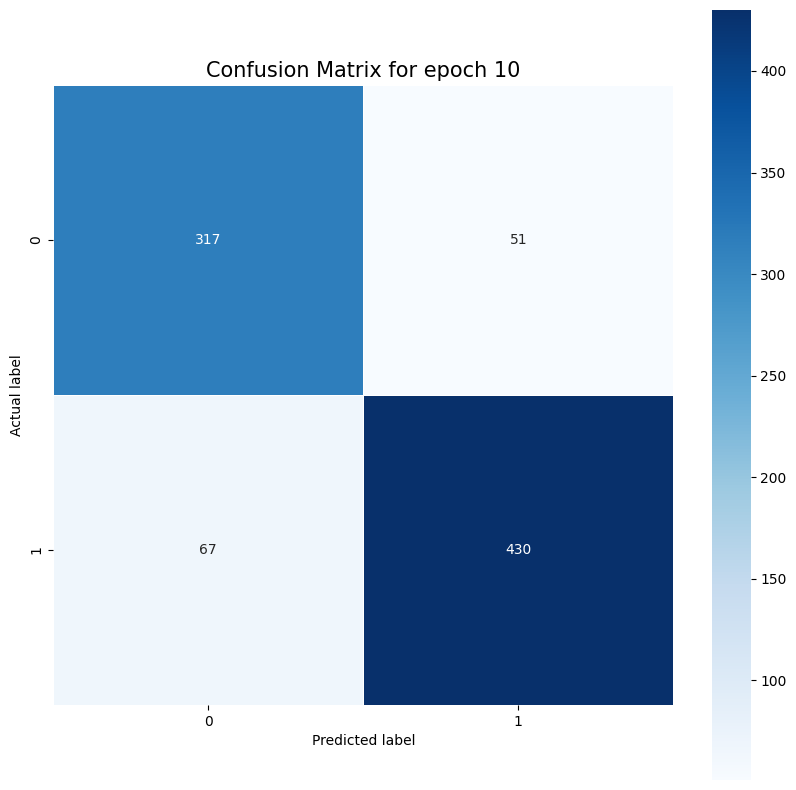

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm

# Initialize GradScaler for mixed precision training
scaler = GradScaler()
model = model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # Wrap your dataloader with tqdm for a progress bar
    for i, (videos, audios, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        torch.cuda.empty_cache()
        videos = videos.to(device)
        audios = audios.to(device)
        labels = labels.to(device)

        # Forward pass with autocast
        with autocast():
            outputs = model(videos, audios)
            loss = criterion(outputs, labels)

        # Backward and optimize with scale
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Store labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Clear CUDA cache
        torch.cuda.empty_cache()

        accuracy = 100 * correct_predictions / total_predictions
        print(f'\rAccuracy of the model after epoch {epoch+1}: {accuracy}%')

    # Step the scheduler
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')

    # Print accuracy for this epoch
    accuracy = 100 * correct_predictions / total_predictions
    print(f'Accuracy of the model after epoch {epoch+1}: {accuracy}%')

    # Calculate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title(f'Confusion Matrix for epoch {epoch+1}', size = 15);
    plt.show()


In [ ]:
# Assuming that `model` is your trained fusion transformer model
torch.save(model.state_dict(), "/content/drive/MyDrive/Model/late_fusion_transformer_model.pth")


In [ ]:
# Update dataset initialization with mean and std
test_dataset = VideoAudioDataset(
    root_dir="/content/drive/MyDrive/final/test",
    frame_rate=15,
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5],
    transform=train_transform
)

# Apply transforms only to train dataset
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

Step 246/246, Accuracy: 28.46%: 100%|██████████| 246/246 [39:44<00:00,  9.69s/it]


Accuracy of the model on the test dataset: 28.45528455284553%


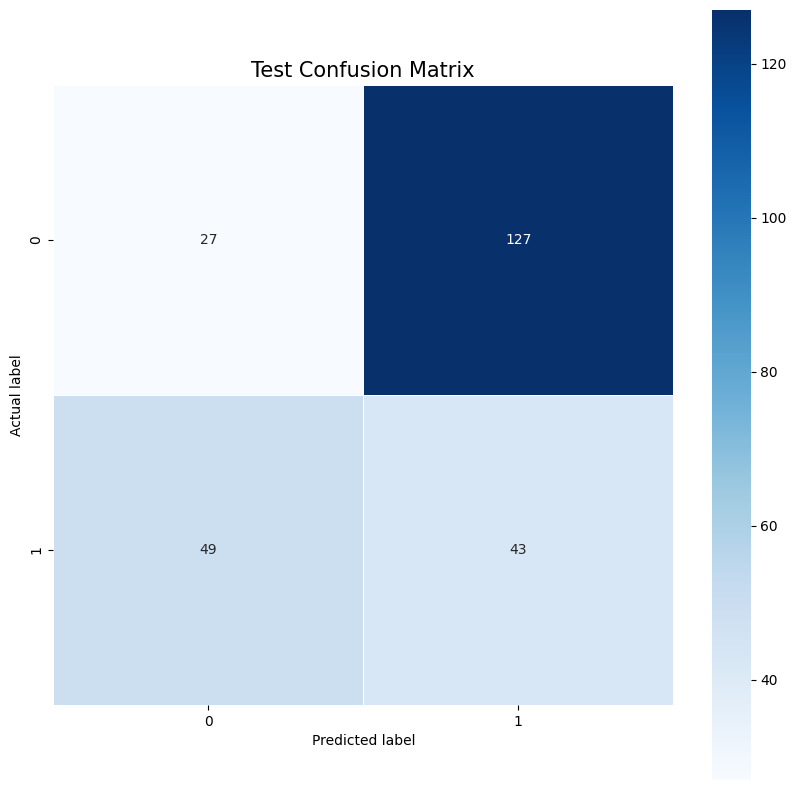

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm

# Assuming test_dataloader is your test dataset dataloader
test_correct_predictions = 0
test_total_predictions = 0
test_all_labels = []
test_all_predictions = []

# No need to track gradients for testing, so wrap in no_grad()
with torch.no_grad():
    pbar = tqdm(test_dataloader, desc=f"")
    for i, (videos, audios, labels) in enumerate(pbar):
        videos = videos.to(device)
        audios = audios.to(device)
        labels = labels.to(device)



        # Forward pass and get predictions
        outputs = model(videos, audios)
        _, predicted = torch.max(outputs.data, 1)

        # Update totals and correct counts
        test_total_predictions += labels.size(0)
        test_correct_predictions += (predicted == labels).sum().item()

        # Store labels and predictions for confusion matrix
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(predicted.cpu().numpy())

        # Clear CUDA cache
        torch.cuda.empty_cache()
        accuracy = 100 * test_correct_predictions / test_total_predictions
        pbar.set_description(f"Step {i+1}/{len(test_dataloader)}, Accuracy: {accuracy:.2f}%")

# Calculate and print accuracy for the test set
test_accuracy = 100 * test_correct_predictions / test_total_predictions
print(f'Accuracy of the model on the test dataset: {test_accuracy}%')

# Calculate and display confusion matrix for the test set
test_cm = confusion_matrix(test_all_labels, test_all_predictions)
plt.figure(figsize=(10,10))
sns.heatmap(test_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Test Confusion Matrix', size = 15);
plt.show()


## Prediction

In [ ]:
# Load your trained model
model = FusionModel(num_classes=len(dataset.classes))
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/late_fusion_transformer_model.pth",map_location=torch.device('cpu')))
#model1.eval()  # Set model to evaluation mode

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# Get a sample video and audio
video_path = "/content/drive/MyDrive/final/test/fake/alvymawvku.mp4"
audio_path = "/content/drive/MyDrive/final/test/fake/alvymawvku.wav"

# Load the video and audio
video, audio, _ = read_video(video_path, pts_unit='sec', output_format='TCHW')
waveform, sample_rate = torchaudio.load(audio_path)

# Preprocess the video
# Normalize the video frames
video = video / 224.0


# Preprocess the audio
# If your audio data is stereo, you might want to convert it to mono
if audio.shape[0] == 2:
    audio = torch.mean(audio, dim=0, keepdim=True)
# Normalize the audio waveform
audio = torchaudio.transforms.Vad(sample_rate)(waveform)
# If your model expects a specific length, you might need to pad or truncate the waveform
if audio.shape[1] < sample_rate:
    audio = torch.nn.functional.pad(audio, (0, sample_rate - audio.shape[1]))
elif audio.shape[1] > sample_rate:
    audio = audio[:, :sample_rate]
audio = audio.reshape(1, -1)


# Reshape the tensors for model input
video = torch.nn.functional.interpolate(video.squeeze(0), size=(224, 224), mode='bilinear')
video = video.unsqueeze(0)  # Add batch dimension
audio = audio.unsqueeze(0)  # Add batch dimension

# Move tensors to the correct device
video = video.to(device)
audio = audio.to(device)
model = model.to(device)

# Make predictions
with torch.no_grad():  # Disable gradient calculation for prediction
  outputs = model(video, audio)
  probs = torch.nn.functional.softmax(outputs, dim=1)
  predicted_class = torch.argmax(probs, dim=1).item()
  predicted_class_name = dataset.classes[predicted_class]
  print("outputs",outputs)
  print("probs",probs)
  print("predicted_class",predicted_class)

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {probs.tolist()}")  # Print probabilities for all classes


outputs tensor([[-1.6430,  1.4423]])
probs tensor([[0.0437, 0.9563]])
predicted_class 1
Predicted class: real
Prediction probabilities: [[0.043716948479413986, 0.9562830924987793]]
